In [1]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

## Exploratory analysis

In [2]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)

In [2]:
#######
# Train pickle model
#######
o_train = pd.read_hdf("train.h5")

In [5]:
excl = ["id", "timestamp", "y"]
col = [c for c in o_train.columns if c not in excl]
train = o_train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)

In [5]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

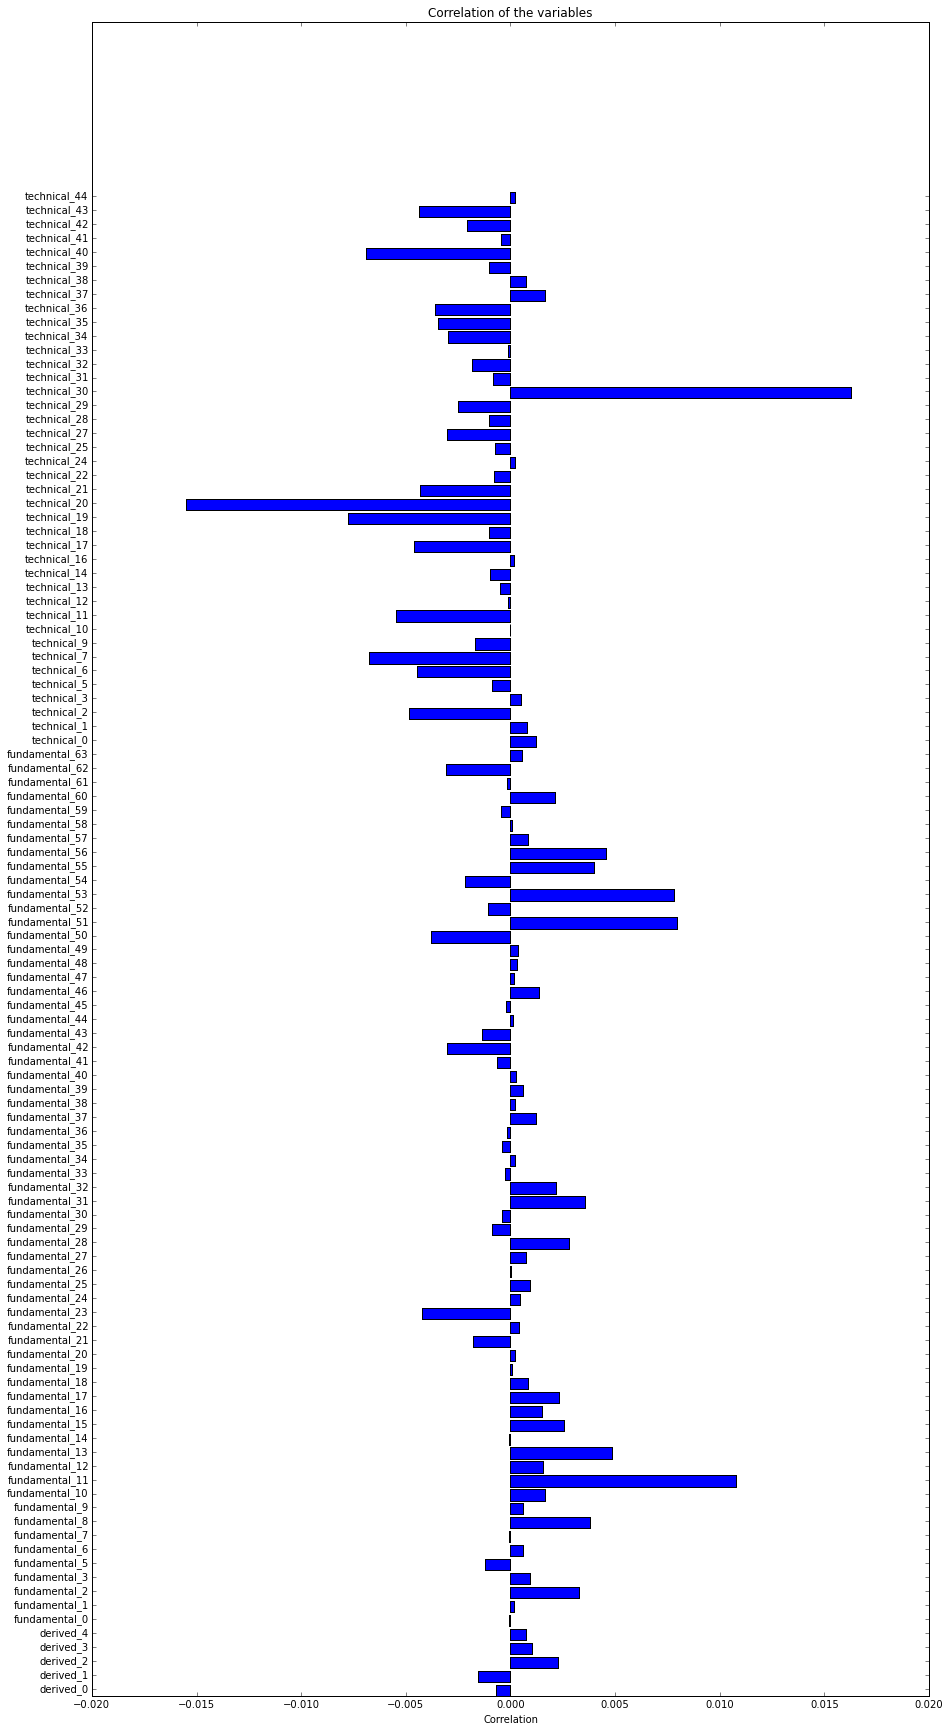

In [16]:
fig, ax = plt.subplots(figsize=(15, 30))
grid = np.arange(len(correlation))
ax.barh(grid, correlation)
ax.set_yticks(grid + 0.5)
ax.set_title("Correlation of the variables")
ax.set_xlabel("Correlation")
ax.set_yticklabels(columns, rotation="horizontal")
plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

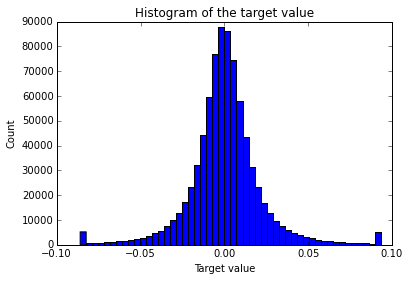

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

## Models

In [3]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [6]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=6, n_jobs=-1, 
                          random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o_train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 3945.54212785s.


In [7]:
# Using pickle to save model.
saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
print(saved_model_2)

QlpoOTFBWSZTWQgEHeUEPUXfgGAQf///////////////Yb926vPrgoTsOW6AHz19FUrbRSKi2wFz7758A+KqlVAkqgqin3330ACAAAAUAAFCWxw0YokAAKVShwAAAAwxQBpsRqRCEbtyKRCU4waUpFoNCFVSVkoUqsSkBVF21vvPQAUPeEKjnHdIAIRQRzhuFKe6NLokqveLuAlVEIFKKCqPXmY7bEDiGqElSKVVRBTqdMOKg89dxQFKREQCkqHqIZWzVd67gAFbNRIFKNs9IRiBd6bihICyYKEIJLwNlDYG563UqSglSQp21UpYAAdcccZlTGYCVBJIAVcBMCMAB03Fe2U8spFAkoHulXcvH1CpIiRCAAAKAAfWEAAAAAAAoFAAAAAAASRAlVFVIAAn2DQVJQCQVZ9gcJemIG2kiqILeJzhEVSdtTsYqujLsahCS1pShDGZKkCO2iiVoMoVEqqVQLsIAAAIKAkBEAAAAOmA00BxAALWgGqO7iUNX0YRUHFBQFSegNAIAEGgAAFADbBgAOgBQAAAAAZEdKcRpWg0pHastGhEAFUFKlEFESKkmtVsYpQoSKoiKShIpChWobY2AJFFJBShQoKFQkVQiISUKpQoJCkUJUqURDtlJFRUkhKHYMKqiqpFFCAKkUI2GVKKqqQUhIiRSJKUaNCKglAlUUEiRAUgqgpKEBKjJAAAYMqVURSQQkkiIRAbZQlSIgqoJRJRVQBSqBRKiiSBSJIqhSISlUoBUqQBCJKpEiUUhCqhCBSClJJVIWADoDcQQokoXbXvnwBvPTwO+NpCEKJSk3wTcFcAd3eLVAe8wdJFVQKUbijA6wAF98edRV77h0UUKUkAN0juKnOFN4PaKkBVJUhEcCwGeQHeHgZ3m4BQVezSKPAF3aT080Aoc98nwdUr4+7joCmgoFUaAAXOgDS3Crh99JD6aFUoSRCqRA5dUOpYAABFsCqlyF9unTZhem1hHEikUyCWiRVBREpV

In [8]:
model_2_str = """
QlpoOTFBWSZTWQgEHeUEPUXfgGAQf///////////////Yb926vPrgoTsOW6AHz19FUrbRSKi2wFz7758A+KqlVAkqgqin3330ACAAAAUAAFCWxw0YokAAKVShwAAAAwxQBpsRqRCEbtyKRCU4waUpFoNCFVSVkoUqsSkBVF21vvPQAUPeEKjnHdIAIRQRzhuFKe6NLokqveLuAlVEIFKKCqPXmY7bEDiGqElSKVVRBTqdMOKg89dxQFKREQCkqHqIZWzVd67gAFbNRIFKNs9IRiBd6bihICyYKEIJLwNlDYG563UqSglSQp21UpYAAdcccZlTGYCVBJIAVcBMCMAB03Fe2U8spFAkoHulXcvH1CpIiRCAAAKAAfWEAAAAAAAoFAAAAAAASRAlVFVIAAn2DQVJQCQVZ9gcJemIG2kiqILeJzhEVSdtTsYqujLsahCS1pShDGZKkCO2iiVoMoVEqqVQLsIAAAIKAkBEAAAAOmA00BxAALWgGqO7iUNX0YRUHFBQFSegNAIAEGgAAFADbBgAOgBQAAAAAZEdKcRpWg0pHastGhEAFUFKlEFESKkmtVsYpQoSKoiKShIpChWobY2AJFFJBShQoKFQkVQiISUKpQoJCkUJUqURDtlJFRUkhKHYMKqiqpFFCAKkUI2GVKKqqQUhIiRSJKUaNCKglAlUUEiRAUgqgpKEBKjJAAAYMqVURSQQkkiIRAbZQlSIgqoJRJRVQBSqBRKiiSBSJIqhSISlUoBUqQBCJKpEiUUhCqhCBSClJJVIWADoDcQQokoXbXvnwBvPTwO+NpCEKJSk3wTcFcAd3eLVAe8wdJFVQKUbijA6wAF98edRV77h0UUKUkAN0juKnOFN4PaKkBVJUhEcCwGeQHeHgZ3m4BQVezSKPAF3aT080Aoc98nwdUr4+7joCmgoFUaAAXOgDS3Crh99JD6aFUoSRCqRA5dUOpYAABFsCqlyF9unTZhem1hHEikUyCWiRVBREpVRE0AgAATIAAJoaAAAAAAmIJIIp6AACAECZAEyaaYQaMQDQAAASQNU/QNCSQjSCZMmSMTTAIaGieRo00GU2hlM0MVRhpiBEkQRpDKaQ9GpkxTxqE8Kf6pp6I1PQepk9QjwTTUAk0kQJImkwCRow0p6mT9UPU2jUabU0yMjajT1DTJ6mEAQpQgAhCA0AmBACaaYCYDSaYTT1MIxSjemi0Q7wgI0UBgABQFBb82QufNmzZ1rWtZFrWta1pWta1rzMzDnVhZCxPKlBxmPEVdW75k4TDJQXa7vMrmVk7lpVjd8JwQAI5EADDTEZEkcHLgzN1k5WVlZWVlZFY2VlDKysrIrGysrKyuXyb4uXy+Xy+Xy+GIADiIAi5V7EADOX/y/s8BA7hA0vmYedkASAYQDyEDind1xhrLl0tcwXWaQbm+fEgDIBuSVIqUBpI0JSUEuuYu8ELmoGogU7YtQ1CAJscZeOdb3rh05IBzogAzjoAW/Q6AuItmujN4bRy8yjl5iOXmI5eYjl5iOXmI5eYjl5iOXmIpsbMRy8tHLzEXy8yDl5itsx8Ry8xE5eYjl5aOWcxHLzLxjeYjl5iOXmI5eYjl5iBy8xHLzEcvMRy8xHLzEcvJxHHkdACOiSSSSSSqqqqqqqiqqqqqqqqpJJJ66AGRap5Iaaw8/9/OtO328d7vfeZmZmZeHMzMzMzMzGDJJKqWZmZmZmZmZmZmZmZmDMzMzMzMzMzMzMzMzMzMzMuWduRkdAAND5j5izczMzMzMzMzMzMzMzJ66ABA6APXQDUgHMgHZAM0u7bbbbbbbbbbbbbbbbbbbbbbbbbbbS222222221JJJJJJJJJBJbIzeVzm3u3zb5t82+bfLrLrLrLrLrLrLrLrLrLrLrLqstZiq6y6y6y6y6y6y6y6y6y6bLp3dO+Zl3mZmZmZmZmZmZmZmYcFY7YLN5dNlFmRx8iU+NnTXj5bZOQzCstVb5dXlFUJwYzvIVZWJKjFVN6G7jxNuPDU238v1/0PS00AeEoPhGW0hpIA7+l16d++vaw778137xA5YIGqgaqBvEBQPleVkv55JwWasRaxrmxE5SA6AFjoAXQgAPd3bzlSTZ3Jd7WczMXGisrmRAAkQA77kA7kA4IBeuui3vnDWXLpa5gus0QC3c8vgnOFhzrcst5xudYbRK4EnuTMst0UXnJmWW843OFtQlqCZ402W7puZyZllta21wtst021nJmWW643OplkpXbcjjbZbfG51htEq8bmeTMstoolZxzLLY4EnpbQCWIJnjTZDd03M8mZZYda3K4WGy2oSVcmZZbnjc4mWSgtCQY422W9nkzWsNhEqrbnOTMstyUXvJmWW9CT0tqEmgmeclzJbkJO+KZTLa1trhZbKe7MynXKqrlTN0mZxFpkoKtbMjiYbLdcbnbkTKJSXC3uuTLLdlCYFsJQx8AX/d59tu8ny6S87pdXxLCNP9KTxeKChCRN57z9EgQM4gsSEAneJAzU2ZGHYlcLxREPBYINeELQsXVnPXEDPiO7pRBKTf08NQY6ep8Hjp/v+j/34+/snx9gesXXXT/Ovr6SRayD5CwGumTKU5I+AoPiQn7GoQfEA7xCJooQFLEJGxpHRt0kLsiCBSIIkShY0MHrKctAkBqnifML+6Qw4QIoSrpTl0sH8WHUv2ePXEGo7bldAAFMVLcdtuTycZDgrFALQndShBmaxX9nvZ4rYFBP/0QMj+v/uZRP/CAO0l/+EhAMIA+JHM5ZJnzESJf/kGIFMolAnOIB5ehQBI1SqeHZMhtJVdSIHp8rPI9babX4YyrbK3vyob/7+b3cazx8+4w4JeJfD+cdv2JzmeDNmlmZw24UNn+fD7iLJSiBQICQJWCUZYrGiFYABFgHB+PIwFQDRTzsXU/+W26ylvhkRDWZ4RYbbcnN5PnUlybU/z6FzwRZ7KQ1rYayHhk0K5ZRhXOy+iVg4/Kq0/9pUtH8ZcnGzYlsM03RsX9W8VpCo2LqOa7/97sxdLelm0/+euJw3S/8ajcZsrRHlfZCylFtaAowWq69qG3REx8WpjUUPUv+ldx87ZXS9dNPbRdgMXyLvZDgYCwHrmw4I/xM59wmB0edPtC8vmfnZ32gruzCQiRIACIAAA9V6fuKegYoHqZbaFoPWPhzfV43jgRO1k0mRSH7eWiGu7n/1+jr9Ly3qfN9v/znQFL6ivVul9I+bvcUjYZeeFV7/utkzfNO11nBiA11eHciiQTWr+Sdnh/35kbYH7l9TFkDGApDNjS/NzXf/qx5xfd0tw4bb/72C6EAplQsQQhw4+3v/tlSmKZcFnzKc4IqixAcIUAAHklx6yk14FRnJeGwSpJJCTkfVecCrekwLIDIEmEeKqhtbSJXyMLllBRI42Q8/WQvmlrbbqR906oKLVbarGkio1V8OZEot7cT4LGSQN3zEbWBN0SEEgkEBESEMAHIHRS50n+nZlkto2ZC2Y5put1lvoqN1vZkcfWcVhtiCs7pNFiSLXKSatlir9BDZQhnU65SHDMiikWdRmeb+lWyltcH7vtWeVpfg0FAABFDyk795ewKD1zF7GJtroBMxgQzFnN7Cy2pZqUWkuuSIdzf/cUnzWsrp2ophNN7wGNJWhyFm/nJqt+KG/etWMXjzcxkPp2BaIQIB6JSgQCbtvzqpMFVdl1lFTggRupHeX/zUWNT3BaZMLueZ1bJQaFzHuESQBAN0RARGgKKU0UGJ+/lwapSvVQALBe8EygwQnw/Xe/p7OJweR3IcDTMu1kjBpUKnPmnJmVXxPWqUWSlyj5CtqRg4x/syE2TRpKCmig48QFjYMguRY+LYKoLBpSK7b/JomL/0puIQ1Vi9HP8a6UJIPiWjb644d34udezuZcitY9vceXW8dq8H//EwGsxb3NNwiwfTr1aHNNSkKX63ItAHl6K9NKXde+bPN6r+yspZ6yauzz/89nLZbVxZWnTmjeRjq6HVosEAwgICIiIk3O0+vKiA62EcdbXHLT/q/bJrOtRuyfr9ZT60lFJ63nYD2vl9nPLYHruNrNuf3Nev1uPE38cQUoTIcZYkRWP0WbQRNzNZFq+8KuP/a+cqkLfy/7Yx9Nv/R42VcZ+6AK04woBzAb+n7RBIDnfLl4bukzDzP7bdttSNctvRalC5DXNv+FtUWaCCysyUNAYUCW/MYw5U6sJ2E9/fou+2z61zx2mm58tmP+no+1bE/lwzONKculMcYDVfW2CsY2gGPxndCYeWsy4hZSFEhJlFIABeEH90dk0YM0ubfI7tOb7IcAkIDRSCIFEGNtmWFQACi/jsG+gCAClGBwsyCpLH+F2kYxG1+mD6n5dnt9j4PuyjFKJSGciVJQqvfQBY0tHyR1dDLgLDKPPrtQxDJ3qNOIVoBbKKFoiAbuW25HC3/kr6ev/xn8yDAXEUG4jvSLiKpMUK2Hzw7dqPylbC7/37pAzBI9796XqSqzLYSciTp2IMAoKhb8v/QKntj3TBjmuOHMf27QSXyMz+OpwmcyZJmWTL+cz+wXMh/uktv/ibn6+z/wPa8qQQQ0gkvrLaC6vwlyvzFlkJIe75EeRi2DR9Jw8NP32+OTL4XiPnhExjhvLxEA+Lc4tLaeZvClvTmUtv+Un8RAGCkRJApUCFBohFCapiamipCliqhgqhos9b2P9fj3+4fS/Z+XXv5/Hh7nsn1/xa+Ae7vf+8iKAF2He9CX8ykJNqsRX9kWyEDSHlECAHIP/wEIQgEC3VQByaqCd3rFQmIuZjq8ZZJvxlIhkgEgdpSgICQCGIGkYAAfTm/GkkAA5lB2CBhGIpFFN84kZQs/+i/9Wnaaj69IwUVOG0XCgw/qZjgwJAp/jW8a4zuycWvxYrhnPQZBDmSXTAgODA2fvB7RpzupSNmifO1zp3x2v4WAUDaTAafS+dRqZJLfQqq3/qOp5apX2uJCDUo5DT8PRx2vLC7Af2qcupL2OhHB87XGQwkACABW611hBCABCAdLBZuw2FLVq0xaMfoZ+jxKoni9OrBPjirZs109+ryvyN7cliJDjTNpVg4rUnlX1Cwuy1Jr44q7D/LUELZR1bVCrszzgg+eZk05CCIEoCggUBEqwYGlgJoAA4VUa41e+B1nCDD6HBIsvsRMFiUnu+y779b32V67nVnVVMuoXpnXQql5MEFQRY2zdEjCQJ3nXmazRycJOTxQ1eqv5zs/T1V/eWB1bhNkzHY5fE8rEuWm57sh1dG9Qmpa2NPyXttR57sJ//m+u6qGmB8L7M9Mh88qQoBsQq6zOSNV22Kks2l/tEVZfgsaaduyS06mxGijaGigAeE/TlW8yL7FAQKzD4qOhaJjzwIOwUegU2W4zAe+BBIBNHj7mBALLJW1YDkAASFc8patM8v0dYm4NvLr+BJ5aHMzQ6rrlxBtth99R8qIAMfezTNKPEztw5Ufw2YQY3IPvqYSIj5FsGLnpCic7NbF6HCP/SBC0KPhVRa9gc1ORfWnKDCO8SNMofZDK6rrmHcGtOkrCLXh8EXrH8aTJg5tSvt6LtzRW//P97Dujl0W4f1G+XVNlmkUqdvjBv71imr4JbLZ4gtzOM3KyDaJ3rFlCuyYGrldZvM7IfKpZc/1wVvaC7xbd7Yns4LZtBnNNTWX5YwXoXwZ3L7gAATEKCABKKGA7x7GOZepdFAJWYQUDuv5v9DTN5obcxwVFWrnT1Jkx7+sqP5/+LvuIwUVk91V2clV+gp8LH97lNAAFidjf8rHZxw0ENZ1OPL/UkMUbbOy82ionnyRXuuTJUZh+cPXTg5EqmbGmPZRbcrOm0H9qJM9h/6rOPx7lPp4b9yOe21AGs40+ih6IGwR+wIAB27N1yfoqvuvWHViesCc0kpMCzOclA1bjKWJ6zpAbEgEnEhCAPXr/t1cqltSstFBV+uhYm/azcAmZ9O6Cwzy5ihpAHKIEAC1wKUCeuG5SkABATPyy1FQBABICNZjc9Dw3CdHko3xw77td0RqG3pRNW0XByXIn62+kGRrvTGJwYDvRUpg0DTnOHiKSAQ5Q1Jz9tXKm48X1F2/SxhiingsM8wgBXFYU+EStbW5VeDUjazsyGYiUjBA57TB4mYoCpez6OHHA+91fdbD2XVAX48GWuy3OTXPNjR0z0dWNX2fCQurx1pOO1Hk8p10UAAcVAWavnp7d1YJ1QGgulKsoBKK+mc3MLFopCeIgAIC39mIwOSQoAwOsIVU0j5xSyvOfrWpbOhIWvyNvB9XVSbeCK9E/AUsYkJrJEA4hAwABQANv3UzjixzmUBQEGgQRtDtiQusNYbInJIzEhj3Ung8w6f8QXhvrCBz/n8Jjy3kEpeb4RjYuXRMK47p4lFLBVbRtnN1p0GmDmHM9BfGZJQJSPDKxRw4a4mnrAXFpuwz8myVVaHmN84MVbUluOrilxmqlTrOed0C539SaUINVzr5KWqxdRulAlKze/8OTTPRNAfAxEB7+oXQycWzyFWcP/PlD5EAIADZL+smJqf0TPGX/klYP/Foz0qbHZf/u2tHYoocYkIQFLl0ToYdrL4BLeSbeFRuduRk9sbV4iyiYhCfopCdPl/lpIQCWklaKSS0Vy5/n1mPW1Dh+2XDNSCv9fP6O3COVVjVaaRkhhAiLKJWlocUWzzg8mPfSx2ltmiB7RmYFJ5mWFh9wCJZnRxO3u2yz+f+Q78swE1KzGoiFUrjHMziQjXvQMRi0k1eXS+7sFyL/q/A2HMht50Zc+9lSmJRaWkVhza/WB4UMYJMf9Njx9telygZiwoFAreyJ0PLVsI37rk2kyqFJ8WBLAIarS7ULp/fw/Ps9h1s05iNj/abLsjAcZpY2aZV2rFz+UmtaT9rJ67Ntmvca2b8vyja4iABRIAiBIRESlECBx80bvnasAshAWFiot7XztK0lclWHKppoRw6EOz36udTrzb4N+xWfaQzDGOTIsQIAAzU4VLwa2XKcE0AOKeBRate/3VGh4jgDQ6eflpCFiSjPXI/XPOJnOGL5RhtMMUl2WWKIN1SEDD0+xrzWuP6fvG+8nA7odwqvu9ghjls2p1voM0vZqr+fU1GfGXe0rjnvPDgf7/ZwNKa+t9uN1D0pRnOTbxsG4L+m9yIABcQAP/iN7koQACPPXirbxrt541tJwB0OnTPmYFdsOgBWK6uFdZlFUIuUrPfzcekIHPHG3jzCAPJyzt5SFZNITTyxMgOUjwuMJku+U4TXKHe+zJ6kHCSQ+dD6U2gQX2pvNPpIaTTUBZKwbSKafoyikBYVkKwD5hCBbTeV5TpMM7ppkkm90y0UxK1vTT4huOOI9bsmKV1uSbzekzCwILJFxIVNpbahtpq9vHVAOcsODC8Od2o8OnB1YScsgGCQ/t45xTS8ZciyQDi2AC3qyQ2+IbQ7eY4ixrYxxK+N+znJAHV0stribYRQmat8pJo7pA0bbDbXxzBzMzVrjxagDWnaI8IpWBDpkPn1QDOrwrUKKjFQ7eUMR3DhhJenUICJrdlvGsTN7Mn9AQPz71ovOEJ7jyyENppC6u3EttoY4+3mSTXnpm2uTm/M1w83qePLyAR9G7w0RDp6PR9pUVd0KoBrIAFILQhko5AJSK0qlKrQA0ohSBkANIhQAHWVVO8BpAU0CFIFAlLQoJRFVJVUqtCTFJTEVREA0lIJQqD2gFXIAV1lEEyQRClB0gVcgFNJBBAAclQSgAaEFCkBpFQaGgBpSkWgEKViAChEBEOMAKIoZJSgoBSi0iglIBSCFKAFClAqpQLEALQpQo0iEQAooomkAqiDkIIuQgIPeVU0kFUoQKRAoWlQmEAdJEAKMgKAChChRKFKRSkRCqQAiCshAE0kU0lEKVQpaQKKVGgVWmWAaQAFClOkg5IpkiZAqOsoDQCoOWSAtAgOQiKFKgDQghMoxCLSgFKCVQjQRAxCtIPbXtr07dOvPvyQ1o4YHDbB6aGRMLmKH64dJFCZaAYYQUCImIQgPKHJKF7QOkmWkD4QPhAmuuBwkBzrzEDXn18PDw8OSukKZpicp8rCgoSU//RkeEAYSjSACawqYwxSwi0jQnTMKHtGTFK1ArWRt9zIGJMQKh9xJwwNayh0249efbf35nfvz2jr44r2g8bZoWQvDAHApgFTWFDCACYomUKXIyEe88LhDrOsGtQ6TtPCTSBDSXpA5VtKZB279e+/f279OfIYl4cc4b9tOXLBOkGrllDJRAHS6SZK2jkMKLygByRZKKiAg0GQrJA7WkJoTTNSEwFmCGRSUOSPhKaTpL3gDJDQqdYB0jTMU3wHTl33du3brv49+SLwKJgZXnAdLfIasw1KKkwxRVFBAepKbSJQHhC61DRSFCNKUB4VAh2039efPt179+Q7R1gcsjlGX7LQWPKzXADIaBqSgJQpBWqVKAkpKWE7yGkGklCUPlKmE0VpHSdJNIKKck0hTJTS8pTdL377sDv17dvD3+sIG9PG5idpNpch5lBQkJ3vKUNPcxDCSKiKIUDfCBkUNEwFE0KCLIThCSoQLxZjFhjygQqGWEIeUOtrL4QHh3279efDht4eHITbz2KHlGQHfMWkCloCgiiUoGkSlChO8IZJ3zANIpyCgqaiqopVaUSaqKSYoqmokhiwBayFTdqyCgIg5SVAU0ypEQWLjWAxWCgp21CGIUGSDrPjGSaWZgm0ZCawb47d93Z69/LY9CB6Ed+UeXKQAHZ7PQA6RIshj0X9S4uZjik8NcYKAb+LTjqi9NjF+DUemx3ZDi0JNXrAOOMZw6mO2BiEnV4TJj7k1qhpKz2thpgUGQBjpKr0l9JQD1AAkABGIM1ynmXRs9oabizhAOy0RHsY4fXu2CYoxperzrcT/iV/aQNIwjmgcMRNUTOemPCKPloD5WsQUWWYJge5jpGGqSi2VURACWqW4TTKDmwF/B8XESQO1+r4PGgfE4Duw8HryI8ePI9wKZ+8U5bPFNcV4awtZ8/PtoXYvg8yicaqmJFZ5c2clf7WndtrKctGV9H0Vh91+jZ4Plt16AECOGALxD7DHv7ISYH2EaQOnhhGPbJ7L84rJsUM7tqBZJEkDKUuuOVhXjW8m2sMTEO++8MjippmMUXaV9J553nKouWq07wmmTth0+MOEOUh4nLDpDrrjAYrHvrN1shC4U7RYbVLOUbtztMcq7kZgRMRFAiIJiEYkswRkZB1ec8wqJphwwFMVtoTm6wtph3SbRExnWeZ29awyBRgQYpGLHdsVRiCoWlEPLcrzxc13vDFUmmWVtNiTU2xO2wSbPOTJtFA6c0zpDMlLGgauLkjOOg92szFfOM8lRZiLIFGNJiGkm8pNbshtEQ0d2VmapMTdpHqlZjFFS6ckqGP+DnF43Ss75Kz3JeOCnrMMR1bFRRkJnNkuW2PluCPHXHeuBVgqLOJAkZA55w06Hiy+qaViRVeOd4QnKDbBVhd3vV1rMUtomPyZoFmFABfLT3MPTnXdz5OqrEjMLCAosBEEfam/V0dbeDGKjFTTnFAnSEmN0WoY8rooq8CxrIcMJMjMSCxYiImPOS6QWryW5UEGazISaSu2obS+X2ZjvfbiIiZreQklMtOqFZu2ttr8VuctUWSKEwVTm8PWszbhxckTECPVklTlNIip9TCE0rP5LQ1Svs8ezcdNe/PNnXpKs4SEN06wlXn7vHezarzrEWKprWSAON4ti4xay3SXBtGJWpICqEWLEfVqOUs8T9z1rA0wKwMN1cao8MARLSRIXo9/un29csdpfLjYw2SC0oiAKPjdWVivrMyceriw5aIp5a82QKqOkpd86N7ng3jUxIqopJ2wJXLZBxCmprDNGS0oJF2ABEA1dzAszx4JnN9d74ORX+XCBPGYPLco1t7t6tUVGYFrQgQOFnpqgtxi9pooEwZLuXCMIkVVgGhJA6SS5RiKaW8Iu3NVO2ElP0POcverpL5b31bTvNNq2tAA8MUYEyQgqtB5lK8pC0AiIgDGLaKtZy7dWihBSByXfdK4GpRWInBc4zM0Uy9oSdM+l2MihvmmTLM7ppuUIeeWSV2IPjZulRNMDtwHXV63vOnWUkebR4L5kq9y3n+DIYhCKSEFJCQYVBKBFEpREKVRSkFaWlFBKEECkUaUQAoFVYhVQVGkGhRRUlgFFaEQApRVaUABiFETjAawCgahKi3mILAUdZHSpEAdZVoEE0hEFWkQAHfByucqKhrKovmgByE9+EUTnKb5QNYEEGBYUE5EJq8HjxOfXiHV4IoocoFAKEB4QIJhJElNItIgVEIKyQKUkQvjC5ACAfshQD1pFR3wKLQADzgBAXaEQShQAeSADDAJMoTMBDSBEQAKA4iyFRKilIATKqDpAuQKHORQzMFQdIBUKUFNJV4woqZAqhQIqhtIIIUIq0AgFKgESApQoJQKpSKDSiFIJQorQoCAUCA0iJQCoUgiFFK0CLSACUAhMKoUoIhSqTAKFIKCC0qIgoFIqA0oiqUCigFKKogUJQiiUKClKqvOVBEyVRKWlECkECgVCkAAKEGlUChpE0kBdIVNJBpOcoAKZKgq9JMlQqhFKFoEoBqlQoEoRaRWkUKFVaB4wiZKlAhSAg0qJStKotKKlCIC0KIgkQB+AjpgAARZ3ODsb3o/11onFdoQw4rZqRwsqUxAgGF0HpkTltm6VkSJ1UZDawxOcszAgSKpiHq5i2lAY40XAJPEpKEmjcpPjivh3/fMROg24hmARXGIAx/9XECvV+2u/4vakzl93tnL1m58zrLCHjMRRZFiqPV5woQ7Mp2hJplSos4S9751o6sqVlZIAVITZEge3VJpx2cUFozlw3ijlqIA4QIgoWCxbactEyVHFAgYXafG4SKib3Vx8QDxAmCos6esvJfMIAefHe3bU7Tt7GG2BIZaCkOszOLYKAxFBZFUPGpxapBSshFhDx64uxBRt5txJNsCZl4ec8wDeS7enHCzW7qQrYzple+Mo9JpQgD13cgdoG0DDum9WQOR2bSkzugHPG8ADq2HSVHjrLhQsb2450mJA6YQxxObvJzeEwADW/MrITTtCpFCcoThC4VZDaQC67461mt98Wb1ZDwSQwZK0dt2rtsPCUNILh7W7U1kQql8IDtDEBYI8SGY5Jc79a0kk7eMqJllqVmk2yByhDzW8Cm+ce7O31nLgTHDEEQSVranrJlYuPWNnMkYYCBAIIABw4Zx0xV1lEmoCkFpKFiAopaIhoXhOEDSJRwlMJBpOM5AhQPGU0k4yGpI0gUJURBI9GIEuRq6OaZrJMDpwPof/IiYes5xhGBFEAbfExJCXSwRlmyFNEba6t5KaLI2lEgTuXNGIJeKIoy7ZSaadJEUnIx54OOQeVmUo244KJROx44t1SbeeFDtI2CiyquqqZUACzzWnpjhRowYSEc6FzFIdMgp8yTOLS2otvTgN3kzi8u0ne6jrdMyw8YZtv6vdmTtCnnlMFzE2V3uOVbZPpJGskPCgVUuRpgBGIBLIhHxAfFomkNIWTshAiO2w+9RpsZtO5UGz2ZJFpBg7vK5Sgi0oZSxEEB/YZPNZlHjumu+tb4Td4RigCnCBUMtFRBSq0ZWFZA3brWHGitc5SvJvKnHFzigRYaYadjt2g7wwHWub3vhPegdu/VCqwU5QqnOtd9ccN8Kb3vhNCk0giQGlVZsiiyED3VA9yp+PksjnF+MiZNevKClSYhcWr05B2Wxmj1IkUecURESSCLKPCTFFUuGjEnS3xh8I/8vnFxUwGCMJfWqlQXABKIajpDZjhTWljJhzXU7MTc01cua1vNYpFAFn27pwjaLpxonNDHzq6uyGbo29tFTaFZdb1pYpc8ycdcZtFKXMLzYBpMc1Z5l2KmmEcgGg3wG+HSCkWhpShDW13agxEHpwcVUYIJUlhPzyFsv1RG20DCwMF8OHPKTjVlZx15edLDd54pt2KLIA9WQLlSMcuSQSScStTyuXdgS92QyddTwVRYAJJJGJAizJTiEeY2ThAz524oXzrmj4vN+jW4qApBYRVzNXjW+rOG7uOaqP3LVdN00VkVMtTj1cdXaa62dJoZ7JWJObymDDWUxFFkLddZo1w1/X0wzLYDBais2pRCBgO0UwzaRJBW+pieO9thx8ubdCzSeN+e7THYIoB4hx6YKqJWpfNWbYGvfSekm9lkUYMQgEj1qmZrvKsRRsEhTUTPUE4tLZs92cGAVpCaC1NkhEYoFlkfvln26qvLkaYowLlzIk+eN1ZWSw24tCZPh12SRMp4hJj/Bm/LL0lBTnjDrVju22x99KzEqBbxlYCwULaGIosqRHu0+x9jNpnslT1Z15dCnxpXnfmOj2wNasmh33fwetYrvz5sN7Cu2VDfjo9tQrF3ZfN3EeSw86Cqo0HBMY682pBHFvFPCLBmlR5TdnCWEQebwLD/Zn0flyNZnTw2rY5I61EkAYEhmkxihlG2hagtznSm96zcNO+N8O98QYAwhSYmas1lszNsebptywbx4/52uVYt046xe0vPKuuC83LU8gQBEIiIAgExpABSAVQiAlKmSBpCiezayjvgADaE3SJrAA/JCoBrKujAo0AAcJRQyBNJXJRoRCJhfc6MhVFZK1UHT6w6y61c2qU1bxrzW9lZr7Na0JW8+2GOqUVUVEgqIoy2HrLIdOK6TTPLfOtYXyw6hO7ORii8suN75zB3Ssctj3ThwcasDtqC/SgVgc7uJw+ZTtLFOLTy1H63bR0hUdY8a4QiJKIxBIo5aZAshDlisOt1i51mD0NRX1ZQOkmkmI23LVmsp3qxDgsqixeLUQXi8b1zl4ZtQEtKMpT8OMc2mB0KXnk8lAgmOkIgHiiUQRnDK7tCoFRZtIFTm2Dw7uZx1fTrrWcc/O8SaGKxRe6VDlKlas4gcDizMT4+mQ0g8QhkUYkksgSdYtgqAis0nGVFFTbmtZy9JHLmqYP5vVDFHzqhxl15Thx3asBVhOmF5shRCLs2bmFKwuWxV0WEOHsyHlO5FQ4vUAzIJk692RmCgHfE8MIzQQA0gIuQyXDP3967BAv4FPwNMkHw9r9beeXEDYCIRAidudXS90ojy3LPZMUFiu6SirvzChrlAcZoTadoNmqmlKoIpJIPacYXspWC3jeXezM3TXezFOEzH6bc7e3WinPlNm9W4ZSVFe+bhUtZDl9nk5px4qXnu3G6ciLp79Nhv8FK9+usFWK41GCd85jNt6p44qLzVqNSodHOZD8rTmh6JMsFm3SGM4vnWsFFUkQYKp3ymD2WwSQcBBMl8xLXIkwoJlpwm8k0zjje9LWdsOcumj21U/sZUBgj7NPL25363rSnd4eNHfHo2iXRy9M0afWRTN2TtxN3dMe7KrErYttIBJiFTm0hO26tLSqzpOXFQnTZcEJLhCykKIkcKw0WCeELCkkLB149LOoJELUbh21CkBGjCMExGKWjqQJAJgJCTYkIxIzWLNq2aQWW4PFDKkXiE85LBmna5SkUaNuTRzhVlNsgSlEVOYe5hv9N0gs6tOWvq2CmsswYqZS0o9ltIE4wPGiKtuPChXjueAj7xDkWRJnXOYgiwwt7tJeqGMFNS0Y92VEk6kUiiZOFmVlZXTZIsoAyXyXGysl5Rd85hqnDgjxcTMvWFQCQXl2Jm+SnOmMNnlNgmJNyCkDEtQAAyI1JEcdB40bX9RD5XJRAm46YcQASy+p8T2WCVIp01nRbODykwTHbJIOWQnyMqAdt8bFh1aTp0wmMUFgKRZI6vjGuj2/tnfFeyEN4ogQKP+Eq48JUKPqAJAgekqHjF35ThbHvjjYQ0hiQsVisIoppIgAKSpgooioqhiSKCU3yFG0GksRrKGEFUQWLN5Th2wxIKQHqyAcJCb3mXi640a0XNG97kk0gvKcOxYiKMgRkq1BQ1EE1DTRS0SWuLiAKSXLCGM0hXrmwOEOEBYbtAxkBVkcsAWAVIUv0b7Pp9jr1vroZIIMdNJ732Xd1GtGaeM6c9FEJ4hjt+t155vnN45eckARRIojEYpIAzVEVBQ0TEymkC0DQPWIYJD2YBdU6Z0w0wDSVayUA5QnGU0jaCgG2Os6NcPGrJNsKxUSRUjERFKtCNLFTSFNExRRVRUJthWHDCsAONFMThHCR72TrJkp1jJdoWkTrIG1rexm9PBnSXUkrADXsm8mmutfM+723D7fa99nlQcQANnXEUYsgQab0w8UKD2Uzn718+BQwWIiBul+pkg5jHk/+D+AiZxejPtSWlSfQYmYAj0QBAr0duYZgY0GTMup/2cCurAxDPa3IBbYr35rNTZSrplt1mcmgzGkInNMZMVCtDju5Np2nTxz3nIycpDocOii1F8lnn4Dsxd3xTAARZdNgdYdSoIFG5RbiaTMW84Qe7tlYfa74tRV3vj0+b485OvHnWPGJwyAKDzSqIopDVsy1DIJZiNMCLlGk3OZPLWsVWrZyIhsIEkpImwSV+8tnrrmTpVuurHu3QWdzCAA0gTAMEgmyrQxqcqZrk0tk7rt7ZN5Ju70xEE0r2W0ECCSQSNWO7SerJXDu3WGABnFFGASDLcODqBBb5m8D4qLzaVQiBFG/wKieJDQl1BEgtdenbL5eJq1NsABkNqOmTDGUHCJLlIq3tOy7AEcPe6OYb733wWabOO+zG97x++m0kYiydIOkAIxRHKUIxjWgCADBKkOaVzd2heKENW+Za64dTDRnGHW7tXhhDF00F1U1QYO5M4snuzO1iM2oE43OpiUJIXC7l5zki7xOIA4Ywsk3ksMjXVzNsuhNDZCRCrHKXhmq26w1NtkGBaCAEoJmG2/OPq+rX1fT7fk639gEJx1z1v4uzJAP9RwnZk7IB2AAJ6vM3jtE3rtykNdrh2mEsyw9/ivL3L66ADzlXV5yzlk9q93eO6Hg9EQAJdsQAGlpkpJWslYsniBUOU4Qm8snjCdvRAFGGYjDAZgeZ8T8c+SO0Xfzxn0bS+Z353Mihdxj3U/BdOObjZsc9tW98h4JhaJGV3+Bnyq4oxVsOKSHMNGCSoqcQAYdQLRZ0UUAAFTU6ucqQs0AAVQodADogGbtD1NMqsQzMaHB6yAgdYEoRPCfGAR01jn16ce3huPC8LtzF3w+8lLT0lS4ZilqUrBpanWTbIB5W+EA7Qq5IgeaTpCUp4QL36du+7n38fCEDv18ee7oKb/FocMuOg6SNBQmhnDTQg0gIx92QE8ZAfCFoDJA8ZAMlFPKF7+Hc48/Lt38tw+HIThXgYZ/5ZVNwt2jh0wPPrjmmeMKusopxlHWFpUDaAeu/nx38OvHt225C8YssjlmRTdiylesigdZEEyETp16nXfz6c+m468kd9PXMzMMwyaoQ8IU2gd0oD2hA8IByVQ6bb/OoHThz7d+/fudBeVbvPmvHbSoMzI0LKXpCCnLbEF8YQPNHhAr4yUhugDfL34aHbbl27eCgSgeO/EQO+PjewTotviacHdtzDFYemE96SLIBCx3lB7wGsGkH25QDv048Onfw6eCgd/Dmj69sbswmStsDhCAHhKi7QqHngDWAO0qdtOFw6c+igdeO47dOfnk515rI3baaB1sDheRbuWmiPhBkHKaVAMlfCQQ+o0QB9ZEARydt45uSW23SJpc3CPwDrb5MmX7mvjrX0okvyOAfozqHT/a820xhNOGZM3hufx0oFm+4QehEP05BB6mvn+Bh71feTfkv6J8z5124138UZ+eYiJ34T6a3/NNarGy5/9hvkx3wK4k2+RVMP+qSpR8T5/NX8/yZxH8Hxv3I1vd5wSerB55XTCYEQwYzl6L3dNPZiUo8yXXJzeC8q3iXKrI/Yu6EpvXyQm843gGGwrypEnGKvmXgKvQxmC3erJqXOzUiW7OG2JZ+7FvipLh+Lof1fr7PcHDyd8oel5NcU8J+580V+GWMGqAtRL/RoTlVFX6QHeB4LeGd8Uy0Q8/rKfSPs/QZ7Zr5EfYvEEb8W0UQvQcvDdBYHC2vYmIE32+quc7mGtMqJEmlGYbliNd/+OZxHeP+7vtTpwcZZgksp2T6zsDPq87PBFVGcFVlC+eqaYa/eUEj7yQfGNmu5juDRKmY9k1X+83Nmsfvy4WYM+sGs0Qj1TgkA1TeH8Ehl04OICkESTVLEBEQUikvVIFSTIyDEATk1O9nE5bhDeKo9ElDJSJEggHxhDCB/0lDSEdCUM5cdBNZAN/6v9f7fd8u3D6nhz8uiG0JSFJQUgZDhkmVBAEq3BBYgpBRCQQ/qde4+vGVcfOru/h2qkloaIr0vHJf1ENw5FuFEPVMtqvyvYMVtKp50MsU6BtfulODS3EkuE+nfdLv1WVu+PlpV22JEA+aO1IgkWXdKd2pESRlYxwvap1hGVT1PGtItQsGrTwMZ/3XaMhy1U//nFUzkK98MJq5rMioxr7r0T7LBnVtr5IhQKAnLVdQL2n+H4ntYc5ExE5gp6cpjESGaW6ji5ByRIlsdoFsgVTA0ROMKpoYtip0rSV4yzMTNjZlzbGMiphpnIum9Ym2efhvOll5nMu+VT07Sx/4arzWWEjIqNZvB5mZcXaiNmPBvl2yka7SPFaINo0FPpzYXZoRv2E/I3IYyrxnapB4M5HyCoTVzJ122RMHier2qITVkBMkcm4hxmdI+eTWJPlwUhLZUwHmIqmbpoFjYYqoONUQhAaWulUe+oto22IdGrmJSwqKd2/VV8hbkMXxnjGB0YZPk/91cCQlbWUNcMHM3Q5c41zOCsXOJbS1Jcq6oacV4zg+lTecAa1Uc53L/Dnj6yCdROt81Ltsp2JCFkIVasxMEgGCQZRBFNFGSlbddcvmCWFeXLqgcIRPMFD9OBOVVnrTmmpmZJubV2JEoYki8VBmmUMP+ucEM1u0/1snBjfwbFGWvkT3UDKmseY5bSsuohB3Igh4mUpsZXsy9ane3bYybCOw0NsXfn8WR/3T+9mHNrgX45ffFeWjdDz7zcp+V1Kfz81y0mCl3w74LUjmn/DUZ+bY39rk31jxneKE8+X6K+j7JXY3zggiHgszlOecFkDt3qYxVkkfL9iajAbcHIjhca/Hdra09s9cIX5qasxYzP97ITXx242jKfsjgmLgFusy0MsfhmK9XFC4IfxjDk8PCGuaJcmLd32/ji+ZTLnIfiBMp7QRdnoct4Yy5XBGN0npY71Q5tPubCrTS5g1lunqxZoVfR6CzguVvnemwhMuw5ruKMNVyVUrZnmRevUll7ya4wjOXxbziw3Ncnk8/JUmd71PLq3uV+eAzEARWZWdzBEShIE7YErOOrJANJAmmccHPGaPTAIRYQ8ZIbQDhgBiR8ob641okDhBd8gpvkOMIJtAKbpEdoROPDbRBXJEOUib+GPWFNpA3wb4dJWg6KBcZQo1i52CG0igcIF2gUdIN9SAubsAdJdoR5SG+BE5nQ3W/E5zq+qs88zM1yHF+wsT6DU3qtyqUjQplw9mx+bRMg0JOhtaTk1gjfT+tn5LtdvkFm2GgeLePXM8S3h85Utfin7Tcti17kgxetNw0p6OSsmZkT+PMO1SlmuWBNvOPUhzCtVcaXuHcN++xHw/E/dXnc2dmfSH31ry9hXxAdAMZm48gwgAICALiAB/vgD7zECN5u31ravzyVN541yuF3xC1OYqA6AjroANEqsVZjlSTCmkMwf3RUxA6AFAt10AL3KO7ppaRXnmB+Fw/yHqf4TNfT5TpHsPb9H1fT8x9jD9PnngXoCPsLaAZhbJ3ZSrxmWgT1nTwVTB5IPf+NISiGOw/Mo85Ycy03yZLZdhppKQ2VDVd1N4z3aEzWXVhxTXfiyEZQCxIQZQwruhbgFAAD700AoaJiGB4V1NcloUAAReHPrp372PeeC7uygZIgRadeudvHv59tLttzzlEKAAIRPBsnyWCBkkhRBvsJQkXmsrdTWoxykMgIySFEwoAAa+EjzXAtFACKaBGhLCACHeCS2qS6igABTXuc9lK6AcNCRCMxrse4ARCigAAjoPbKSAAJCCwoiKhPJhfgI/7+gdWx8uugBd8rx5+fn4vrhEFiB7PHiA/bAGpapj6KAAFpoB7yACABAmGgDteuuZS2nkWMWug6UJUUAASIFAQhVCNlKKaUGINJZNfRQABGFM1MppWFYgCT1zWlewE+vp4aON6v6r1T+2OyZF+o5kTmNkzF3Yx4c2uP/8V3Zfd++fMXPJ9nNDmjKggIsMswz3zPys1LMBYM1v55Oo0LF5nVOP0oLyulIKenGD3niGkSBd3R2KQmTk+59pYGbvmmtkfixh+SbdjB7e4GmQ2pmENQXCkybqw5g0FQq1N+3JBG8NXrM7xDbmWlhkNMYk8iiFeXClulNNK0GXLGK7xztKawreTSciRiFTkOmeqFGXm4X9LDei5LLI2zVV/LGqE/ODfJqRs7iPUvIbk4GGzcZYLmfhPwZyTFP7O+VLV21bXpWU8oL1aSgRPdl3lqrlqpo+Pud4OvLqiWx8hgrjWlCGUHOFoxqgO1XNF81wJMT3C5Q5jXo7zjsq3+revNKF74uFJ9K1Pm+GW/cwrYm3xtJLN+fY9/Nyb3IMasELushpg2d6CS9dn2EiyfGk58PHjh6RYZWhrWgMi44OM/6y8pDpAebYwG38eW8Ory3K9Q4IomSFJErStBQ0JQLXHMH2IP6f35crx97x6cu2m7k6xSNFLSa1wzvGoLxdJNbNhhdGaxExzTcdOnQ2wEMJENguE/j+yq5Y6lnxq40fK13GGFgut3XIbu26j+XxVbwd+16qu/b208djTHw9NQ+a+94Q/mK73x4EGu/NeUF27wW/k6m4eMFVdwDi7gY1Q2N/KRsjUNcbcBZFvA8Lg8oxZUO2kzGRqyBZM3y0yFQ+Q92ryJnBgqYBN28xjVGXDxNNOTGEF8mhBRex0HyqkSPlcUTUBu8sPWZcbReIlxGVCFchpz+6Z1fHnKBi2xrFXBI1hXo6qLw97s3VmYeWsSLhqqJq9d8E1JByRE40vbefCc6tW5IRYyroJ2O9G9XMFFCY8Qe9517ys6aqzuwlg09NbW4UH+N4ZjsLODG0RuMYbWb8UCr0O2PV1Tzn6amE34qXYzYxgyEAzXDSdOih6fawmVXCm7dESKaw0M/iroq5ouXu0Mp59cnEGfrGX7W6k9joJcuJ14qTxqlRVdVbVTmBEAUd5ZvNWg8sV/XofcrOy28/Q4yPKs3Zfrmn21EDa0Y7TYyYMo7IWCFL/9N1Hc/kvexr29d1T0RQLvklu/TwMIqhvv80HJXLPCyiZiTQYfyH1wNwXSuYO/S5dSe3pb8K8r5c2681egKzpeZWl9tQ5NldE1QmUqqeUhxWGLw1j7bpKQkEJqaQpyqozNDS7FBtJIkQiknCBztCWdpmQ/Sp4ae0wjtywabTCNz++3+mdkXkve0Puqb5m0QjQrNrPUzFeKmManbOqH1PDTw2n1v74zbeqaPTB3bbnidjyedna4ZPuhkq6cpUNMDiMfw4GsxmR20285rKAUFSwZkxjoRadmaKi7gCbE2ZaTAvGxwZTMcg0GnMs/2ssmhV5sU2unYYqoW8qTfd7cO5tyyzJ+JhfK42+Wc2bcOvkycr9vhjEPY7UfrXLi6Q77KaILWzUwaIheIgzNl3473EVIkbw1pFqg+u9d47/Dv4Z71CB430eLtq3Pjl3J7UbVExDQMgLuHORqgzF3GVdtJFIhpL97N/nURn8piiO2es49sjEFJppoVCBCriJIBX7fE/Z1bLkd4cK45zIlK+qv5r5ejk8RlvsaMoPs3WXBh8hmeWy1ktk2/vTMbsdtzcln09W8B7wEXysxNKFx1j/6NuLakW7y4ycIXZ5NWIVxL4XEiYZYngFl9DLy25rzGw9PGrm1jdHp5EjcFPZWXeFCGsbE4s3Z4vwUzmu0+uaEXCyzXCYSdxTxgocDuVtv6nNEU1gtFnZGST1WqXulihTbtbPUGDf4CqAOG14q5xuApmR5Wyxa3CuU7xsy9/uqImnd3jBuorf4oh7tcBiaO1Lfabc47r0x9GzZ5Rivs0s9Xa/Es3fGIaBXBNHYq5hraeWhF5eVnp675faM/X9vqsE5fNu4iAI4ogAZhBMIiAARa5NN7X0NyG1XjtlLX/oHB0AKbWqp2ycytT9dACFDyq5ucbnHKvMXONrJotEgmGit26lnc2YD274bDek+3zkyTPtERHPR40e1rpe10Jp0fI33nO5/Z3p8cDp/DO3h2rnA2y7pdIi2DC4psurGbPd4oa3HJPJ5r3K5YiaUsg46wRbkNY9fwhQABOUKao1SXRWIIGgBi/mpWaK50mplNU3wZKmigACny86606QIZh5TDeySY53mc8cvvroAePb5T0GKIGeO64dvNtpv3b+PJQOnbt2u8bw9GkERVQTWDz47eNujn4YmuucC8rSN0Pm78u3Xbp4duOh4KB4ahQE5nbOVMphJ1AUAANjBsHTCc4/hlAFSRAgCaUhOTpoQAwgeIUAAMGL4KlFNAHGhAgdrmRKES0rUph3Ri+x5PgGGD0OeB4iQ54c5uSu++/Lx2bHQj2+yK858eXM8vKvHl5pAOeg5rV5enifIB/R/peyLXCdti1b1Ro5SaRURT1NTsdUnFxkmCwd7+23m+0M5G/LL//uMjP5OBETvNHq6BBYKAtq/fgsIXf0OGyEBkUe+1aDUJBg6ltKR3CUwhr/taYHG92I0HNC5pVmQs1HcnZ/NXPb6LFz2wYs1LePL+a2y6LGG+AiHnjufQ6ZrvnShLB2l6UXfEm2qE4nOA+22Ku+BrOoSJK4KlKUgSw0Q0iO8cOSKILOuWZygUsQmryZfGqtzqFrwirrsn6sH81/a48/YS9/d8aPpQU7xPazx5jyUzIi3mJaKn+drjePySqqNOPDxTh106Q5wSLFn/jceyqWVpVKYMW0sZKhA2+jLz6Z1e2t/+9jvibOSQY/wI8ZtEdl/OpGcYO17ZMCovieNNzP1og3cpkTUt0MiFMLCQ230v93DRLLIutPxs8lvscZG71Vfb8qIUyxl2OLLip+hWazXPZfM+uzu1cfObGWZaItd/gA4Q/HDQ6JrIUcIXIiJAkBdlnlyePPoczjvUOM/bnJKSk7xkJSccMGOPbzXHnqc9xvRoKECThCuZhhkmRd08ByJ53nRd48CKEjRt/KecieHmw22hcVEUZgRwuoz9hi8yFE60m3EmAXNdiIFK31A+DL5JZdNsCtX4bVy/IgHDDQQwi6lqgu3KpJSEdpU5en6SajPFArghnlSp2WDNj745U1si063XKfR3DId1eVzW6VNz+bbnjgd9eTe7EckWLGtY2W+W+hPsqxHOgGIczyRpJ+FvD/0Z7d1+zFsN+cXlToqtDQk4Q2jj926GjhnHgN8Etl++zxmYWfIfk9BMVVcP+E/Lcd7zkDz49Q3ZsdnozjtCnGJv/xK2hr9u64l9LiVP/sjEZ7bvK8oHbu1jtTNTAhxnC5qWuSon9mOY+fOHYoVGF4JDHAze48xDLvsZGj4aVRjkH+F9rmp+RAAfwt72nmD3ryvbg5yQ1dXflKVV0cbAzr34LJrmc2iQZhZykIim0KzC539HqblFEq8rcdoawwubl/CfLFmnMDloNl3FvY2agRhj6bCJsX8SFDhnKtqnaw1DTNPUrvIyrno4r5Zs82RyZpVZnaVI5OL/UxAmdb9hkid0cFXHGqQZxMLMO32M9c6nizN1FU4g5NVLGw8+OYxIiSgw0SIDLgwk4btgmZ1w2rTIu2tkBvN+e5qofUVmnf9Hp3K8sIn1UVX6zmWaJc4QIn7+OI+/r+Qh/sRV558IZDMiU1z3F1/0qVvYxVf7FMKuf3lrl3Jlq2n7xmVuH4YyBUVLzDJ2bCVb58D5v5LdxB35dyYcc5L9241CKF4sdCl6ujVO4tDS+K0vsTg1V3M8Gv10bvjgVMbtVQl4ip2wRFxcvNM1S2SWjLnEEoipbKZIZcXbv+Xc6zaDaYdhFjUz580tXBaGbNdmrehLNmrt4Ek6bnPVedmkbUc7doKi9mVLTYOzdy5d8TTEv9CxMHNudrAnaqj80cytzyArMBC3JIanaqrupsmc6e5vwmt3o3SNjWaDZi7YVH0/9L8zStwrj6ey/dR5BYlSEx420f2HV4SjWMVJ65JEtH5+2z0lV6XPXW5uzUF+Tw4ZbL+tOZP9N8ho5DO/N4008l8/SYk2xs+Iyp4gt477YPJp1SKVSn9M46Yr3jnJzs5v0482rM+rR9BoJi8R5LW1ReLclTfU5viybaxL1kl8CYrJkcmT/CgqCVBdGUpOHy8py/Lt1a0WxUG0KDNnusYTppwy8j4vl939bx8C5/t59x4DeT+D4Ob4f37DCj9R268d8ZvNNq7TLmJoeZVE5kVcQMtVFvRTqflUbWgg+URthxK2A3PhAHQ68/rb6R4vvxJZSvrV9fGoDoDVNu7Tmp2u1ew2IFPbVeYLxVTPUYqu6Ko5LyleJ5hkuMOBAF7R5lnnNNnPTPB8vZ78XSFz8aw2Waag8mjVOg6lH0gYGqKjLijGXL3lBFIKPLV+jaGsxUu41g6rA8Hje+05aUYcDj29+32ez2+2XA5dCxBY0AV70vMSqMSLdBKWxU+JqACEiJiCxCDT746AHheOd+XPLAIIDkV6eBQ9L32waVz4666A65y/ECzi9gEEAAqpg+JGy/cKACgFiFFFFCnNS6EpSm04hUMhCkQSIVTGo2gxRlZJy4HXKmmlMRSIAUQKJBfFyGHlnDXrty6c9+7p5kXtKZHaRWDdDu68jOuds8Dmc9y2Mc+B4gJBApmEKALEovc8bCRqWhL4Ga50pRrg0KAY8sZiSgrIhBr3NhF4LiJ6KCDQxcHwEAEZzI2PA7sqxxMSwn0uJaTQFWGCu7VY8EECDL+vmuNQrmOssRA/Vd8X9P9GDuGHlrQzL1yZMBCvIMSzfq+vvyTLJRjPXp+j18TDoKdcS3/PlD8X/yOtqGZi2lzQllpgBEsC9V75v4fLfevm7jiviLd+eta7ZCRFXRYsnkhC+q7WIVKe4Lm9VqmFSgEUNmzVtEuuFYHN8MDWOYMaBlc5IBt7JzmXUADeI3lbdG+cQ4zypBDcwyUtuS4ISgMnqlkCbdqDSqVMqDE9CS5aU/4uNylba3rivo05qRPUfHInw2KVqvxL2vfM/b50i5ZcVoKQpkTkTMy5VB2kzxdQxDzC8JrEfjIuyJowQxFOw5xlFeG4sPtuNLw5xaCDW+PYYcTrKXyTIe8hCPaqeOzkwyx9mXJUw8GNqfr7sw1jIfGGzGM0NPpKuRlBCXM0OICaLJdDp56bdLgYKjJGYaifuXQiHN3k+n5Wg8Fp/bNazfmvPJ+E/MyLAs8ZpUD39UJjHq1YT3QskIb2ej1PbYGc0Rj3eUxAViETMPlOUTr75+rpv1t3AyI13hrBUW0ySySPp2zbm6adXDNZdtamMxM+56reMc+2j4hm1vJ99uhO7YufN49A2CNd1Ns5/bVlLgqFE+TS+X+FvFem35XI72XceU+H2+aL2FeiLqzTUcDGbh/Fq6D5S5lbHwNBrHGsWHah+QJVc0XMsF1kWIDmPR1F0nLQcrYqNobhEqrBgU99cQ6YgAYusCAO+xT/J/XL314MPGa9vYtUxd9j6uRp9DKPW4s5DTUMgXcu0/2VULsxb8vIsqNde28lNX/L2PamvLpjD/RcFnG84znwmt4J2oT21EWyqbjxUxOTMUwP5Zq7TNcGVikBUcpQnBJpoWtZGTAy17iJrS6vAYNDVT6NqHMOYaDibBOpb5T5ynrNmdGdwO8X9U1GJTAiTMXOM4jDpuqCya96djRWRmnYLVOuWbLsxTpRKEYzWwoXmW10kMBp3ukXOOuQnro5VyaMiTM7SH9/V3SNZl/rSMd/z52r9MU7qp5Bje1XvtMxNTHsp6OZyf8Z00q2enadgsS31Gx9mHxhMNJTms8B3tqS1G6kfBKqRSMM7W3HYYgdSGX/hOC0spPiO951lY+XOJ7jVRAnzXSgQzPduYiFD2tb339YazeLvhaIhHXTtTRXHyxT4gzeycOeb4IT5eiLWtNtTNDpt5NYa0i603fhmjFaRybaukrGm5kEwnARBQtiR1KuthKtxM12UMxUbP9dvsjJthqT/nN1XS3Z5dsrRNLzM30vXEs/T591bUf+k/FeM2Z7DPM0GgV614uOFoexMjHxpMTW7FiGVwmeGqbcY+S426GTp35qx0QzPyK5meed0xOSimio6665x+pjnBlTE7H9EMoayLk/tPc467CWeDJHHtbutWFdl3awmAiTRxk7+4UJBF3ZJU8fKufIN7a3exrO4OcCluiG65oe8aWxyQhmcmIh4dvOMVQpkZc3VCVPJH0xWkf4JubbW+s88x1j91P32RgKcL73rA3vTOcs29u5wJjHVG7vGsZiiHUYrqmByMEyZachQzR9hVG0NkEF9dhL2Cwzae2cggtHrkHz5d4OMCWxoubiPXsIhMYGCD8f5vLk6K7nJ7pffm7Mm2Nd94LAV6S7N4lsmQ2ze0R9mlaVj+Om6MYSgpwvxxEO3e/Poz7V8htDcprLNrM7bfMihcF7tLDWM35dm9mG1U+0VMUPa9TSNf8Wsnlsy7o1QYHbZoowrakh+WMfEMgs0YGxMMlX4/M4OzY7Tp81FelDE3Qs5aCadCvDZwSw40HZK/spJYs3dsOvC/w+zffMrZPPhfsfwQGX+JeZOzV+9dVbTz0BHwS68WlT+zpik1GhXSjJ5fDVuiJo1DWjZO6boahWHMmVpWCrNH9R8MoaSefqLhHLTR6G1kjCp74tPUGuWXuiKTKxJZjiIacTFUYp66dB4BfN/gXo9+/6HOxlZX3KjgAgcEQAGrraay+ca2841vJ/N3nb7d1oWzerB0AC83M3WYFIL1NLMkzDzWUVFpMA5mFIhiKtmxsRrJEN49G6r0p/P0p4mamBPpTBU5sI42Z7YqiGCEnJiWiHePpVGstNMhxY9OKmDVclPJl2fyy/euLVnFbTrUPwnK4U7jlIU4T8AWQqqrbZSxVAMGgHggxJ0kg1ymqexr3sabMNf1sAFXsFrKvl88ePCAwjr154/X4nv2jroDsjoAGNe6EKmUUNGhEpSONJ0zMSK3uS6TYxVQI0GMQ4gsRTYL3wguuSZDKUISlI6moBQnEHjRWwgC5guhJQAUQpoFApWVzowXGMeMaDioQUIAss4TpKJjte5bIpdAhwCIgsQx8b6UPIePGGPGeO+/HflQ6Y4eu9js+3na3OeNPjV7D1RHUc9rej4SPY5z1afb7UvbmiatmD25Xt/ydxQXNj07bh8YfLyd70vy4d9yZsR63kdMw6xnLjp3d2HPMj9HpPdT13k+D4I5+R7cKkMm3ZQnJuT6mRV68dLZvfaXMkIi27GJmwXW5dUrXHt0GdSYYskPxVPJ27OZgpWwsTmsOM+RFXhMHEncgUwlUKx7JtGizREPRQzCoU4qzRW1N7mmQcd0FkKXd3VuTUyEXhCLELLClFn3fP4vQkSA7vlMI/wYOGU4SBsHJOlainMSfw1E45qvECXyjO8YULqiTPN3frz6xo0Xphxbu8TLTLcO0ZGcs4302WSWGRTROTiZQvK7eP3Ho8u9cAip9TtCe4Nws0RQoiradLzlyrMIYniYL2caRATtcIM0B/PYmVt5QDiGWMXbR165pa6yy3jpzlTeJ1jeaJWQOoiy90/u3QXrNMFw+fFm1fLzW0aLOvdT+A2/Q8ocsnZkRPSFgIskQBCAag7OO+OQdDodOXGmk2u9wnUiikp4SGSlCyL9XOujW0VQVQgdpQke21tqoEk0YmSoRChSmIRMFsuvy3Yyvb29h6wedKGDve83IzaL3qTKZ0ou+WYbqHdSwdMtvHbaGuMNVeoSjavZhhl9fnkZk7ZyheqqRa1DlpdCWpmnZFzLFAd/YdUd2LjdNKBW8z4L+GWnXdjd9CJ9jZ2E3Dd94lVSBdytkxZYRXxXrtr+b6J4aOctFbMNw55RpO+xXvBwqIL/XM+J78S0v394sNhcMxM8aHm3CPjfkqsF6p3P7jWgN8V99KsyyLgGTvxdvgyohRE5Ap5ejWLTLsNZWRX2ssZchemzWcbGyozLhKapuUyeXkYztNn86h28JD3fLOX48Q12WE7rvbudynnvS4+7igaOZnIdttNyZuF5a8bsLX6cZRaXT1bp03/E/eKN2c5yONSXZ+HwvOLfG1/La6moiO5cMuxcUC42AFCqoVucWfur2XbhroesPob3++GRlBrhvjiprUIxvxv5753sDdeWbBrOoe8dvGh4Zr1QzsE+Q+jVklnjLL/JF6sJx04wjTelebYXyuqpfH0W+tWqPWEOFbpRKlzeTOv1y5VitizRwbKd7by/7jk/WdLW+N+Dgh8D41hpDHPbNXs6ttmZF927tdCCG8pUMQzLKvKe2WrfJmZU5TWu6ygWkVZKBGotjRSBRqSTlWnUhq1Ik/XV0MzoowQaKf62jN0uz8bBdytplNtOiE0zYwSzVClHFLWcFpVXAdfK2ebc5bVFvlG+O+NjOPn4uCKvltXp0yW3Mc2wir/caNmFdiTnqr6oxSWtDIe6tEYV8jZTZ4j6Ad/8j3POC/FCQ8vDe08qaPlOP2a1u6IrK+pXdWoXB5icDf7W55oXsfI1sJW4KVVi8KTrbtrcBsV+LJ2fMhqucFmsTlvpC1G+7K6l0bmyQdnnK7K41V7LYkHa2QpmVGRIM/+MjV0SME7bZNB4d6JtrE3uY4gvIwQ95VKDbDHM5VuLYTVF4lcaxG4cFzv+LpSvbPsyu247Ds+Oc4dHingH1xBVy1U/SyFMkN/BKEzVwY8UDbAu9bFwX7t/buOn3JlGiwL5Tmox3kzTiKPyW2LAi3KeNzqCp38E6MhY2ls91xySXmA/DeVWrZU1JaGL1lf5Vo2vWm58Pblib+hGn9Rew9hLGbR26f8rd11qUNyar5vgY+MsPMTVly3yxybyI+1DwMq7eu/N3Nn8HlvjwsUHXnvvLhU/KoMZno9aavZi/brL/Tg2d5UZZZxqt/Llymc2qn13vZRGnV2poK6duZdu4/ab8Bl6dTrxNcn4dz4rypcG39cjkOl47EGJmIUzHKcVXJxek+O/MKFPtml/JYHQEwB0BIHQGDdbJy3ZUtdrpZYl3zKF3WKE8qcuslxaoSySt+/35AM3vec7IBaQ6ZO0k2yB2yVh29mICMRZiAjh4QzADKz5L4/HM+S+LzflZvnDrgZAMSJd4ZY36ru8k60+K4a0bDXl+UqrN72HFvLpx/tGxI5rCcmA2sCgscQXP26gehnRGMIILZvoTWmT7FVQrqOFAc7VOaMiyYQHo79DBooooe58I5e51J6DlzPffkrjmvGb2B0OEddePHj2e2kdNHoIiN8/S484yvR1PnNc8/Le/Tybpj1RA7nytoWZzmtbVAChAHiEYFcWJW2IQAHORLntg8z4PVQFwmQQAgeTiMkJHuY853ucwQcIAESPSE1sStzXvexJBiIUEkQEzQDheVzEJQty3vQFAIDYc4FznFqkPZCoKAAGRhGTGrBg0UHFTaogRXpMdcqBnL9HOgjLGFOci6nDIh0LLITb0hNbIr3NHL5HlZyp6/Joqk4/rjDOt0+1OTJBIdgXbfBBmvTHXBkzNFSKcZQt9CmFadesR6QsbWtMDDhNkMJ9LYeG6oTclGRqjCIFKQimU9Z5WCcd5b7tnp2+ctKneu6XErRVvJbMatd83JwixwBLSRIkackVaVCxdWblMGbmSVjTg47mnk1M5VUk5GL6FknxobnHv5/H3HpDu49W4PLytd5P+3pfN960e97rHOdi2sM80jEd8GLFHszL1Q9FmDoRtIvKX9ZvlMgp5UjciVbqaoNJXbYMYGZamyBAkCur/bPiueB4cd73LPa4/dGJbvLxxUNiIsU9RQdjgb90rKcJSEzgvqwXOyhOVMxSm1UMrZPiFtlTRQzJMsMdlWEPHx4LqVrLZxJ9x4vzE9Vc1uqaM3eyPfZO85efeoo87Z/ZBICkwZIKKqCjCpUm2qxVEZ9NJO4YQA7duZ1P02wm8kJqpIgopoK2TYXvVue2zbIqCIxjOrQAVgiRE9cUx3zkzV1lZtLWwVSpYJvmHv6u27lSw3IwZynk/CdrjbqM1zqtR136zeRscNxwn7DslvQ64XfmS7STC4g1zvLacbauErrU9NdWC725lpU/VaerzYbZL3raQSonf+KtR8WJoY+6d7V+jP2I8d7kVxt7aNkjrq6uX2fM3rCPL5Q0PlUtVbdFdcRVE2qoPA3QOVoVyDaGCWh8P4IaOtXq3NPOGPt9xxsHQ+4ydouONvcvkxz8SDxdV7Jmo/fGG6PfWTY4P8fD2Im7mM5qMGnsj6lf9VF+/2O35xl+L+ShMmXoeG/6PiBvyY9xJv/69eUvx6u/Z8M1Ay8Ud2X6HRpjtMMP3TsNCYaOMK2kIqcWeXuibL6+Tt6hrZ5j1oGUMHJy3+1fS9e7QytPZKV/qHlbqLP5E8Hep2o7zGvQRi0JfcyYCNYjjKbycP1t87nmPutLwucCjhak7ZFRai8tYWgPNSP1tF7nlriGuq1rcFoDRBMWeKsWW88I/Xc1AvmzFZJ2FQYXpCiMN4QnTjHpnw3E5L4yeqfLMC/G4uqcW5DuID+vIejI4wyrQ2Xc3IuLiHBXPmyHG9Jovq6/DW8yrfjC5wOLglM6iN68yrWnbjTQOJ1DbGQif+2x61S8u15j7cUbmKtMnqHcIS+bhuacyKFmbuqpze1uaK5liWOOCQJKawzN6DbONbybTt2hoTW7MYoLFixHMyGEUFimLbWYzaYZTJc1pynWhQxrd4kcMAtpnNcRMo79TC/x55gy5zLlUu9cJwckOKLIrUD5k5WPzdN/JNlcYrCqfStO16qXZNpe8aae9NtEtDDQmgX+R4vHwHCYzOtJ/QrrBxmISjM2IehFRKyiWeHz6tNc6MTh8jSHVbFhXARbLuYtPTJRFkxkPSnLqy0Pgr8332Kx2oJzFm52GhQ6chVpR4r/mLqsbXaYxtiXy50AImQzlmNvFUIsUijltxhmIABTzjad1o1xn4TI9H/hvmXv5Jr1TkTQY890oH63nXejFgl73zdswAyC3WVEVdzSFkycpzNuJjwz3dZBl82az4+bbNjbX2zRkNGPT82eM6oRKERL7bZDKTAp3/29FJyUzLT9He4SZe/4iOs3mxt1NEK9hsb5pfVVWx5UkY925lVo8lqtJwTJdOQ51aG4/7q4qhSleprRS84K2wl1LypDtzObmTKclh7RVT9SkjzmX72J8NdOpzM13c4IitabevyOZaq5NTxLiQct26XpPNFcf/t53uPwHpxtR2qtWqgEgMiT0kdo/d579r2RvfJENriVHIYd32hEY1q8lk017ZuFuncEVl6aqJyRTBv1XWBgzD58qNfm8o1/dmvJbu7wlqc59KeXScKcsN/rIsKAtkESXmy+D3u7HLefy8x9mn577v1OtrtYbHm5x/U+ue74PDc5IUqvkqG+lMQUNBIrGlrnW0tdLHa6Qc4E+c4MzTfMcQANiAAYgAbN7fOWcsSty8HOVNxAANShAAcQAGDZYoEjXuWnWMyRsqHKhhcz49jY6z08odvN49IHtuqF1mGTWHMFl3c+cyHysznNC82vWi+1UTeqOU7cO/844lTk3mu0vfwTyq9FHrU8lJmrqRLrjXtnz+fUUzNTGKgKIRHiFAgB5TaWRnyE6FF6HHY+M5zegGiYQWNANOJokg57lNQp7nPPSoEjQCRoLBxKYVklGTYOdCD5SOchKAKJBQwtJgM6a0cMXQVCMIoexsWGSIPGigzkTlUUWuf0nZGMZSTEUgoQBgkGil4Cus9BDFpNBr1uhF7owTITDQYTiAUmiSkO9SSmkr5TpqqqnGbUBNsyUIEqSUOFYnE6BLUSqdU6CrSckWRXNL4STIQAw0GFQwWEvGsIp1W88eOdkAOR6eL0d+1vKvTxPsVj0pCIJumzXynsmRfdp3U8PGMkVT3TAkgg2Qmttdtc/oW81d/lOeZHxOn1aojhRgAkRCSzzt77CvFAKketxvUyLMngRZ/8aamj6mNbXLwSPHJiJ1JhLlTJLM6Lp/obqM5aDE6U2JbnXCBm6uQrVGWPdOyi6sUEiwmE9oWRt2Je6oSq3jpUZi9y1+bjrcbCREqUkGDfKmtlXVtxTV25qrYq5WTOC6Ic28SRrP/v9n+7934cEIJEL3lbkyPLQgxkpyG8YtKYOWoKt8joCd5IqN9puQb7I+hA/h9vwiY4Rju8ePeTiUfZ7LuZIm/ZL6Y1pQW2CGfIj27ZsEg/bzXnnu/bHXeX70f07FDzKfZcT+/vH8/niPZvPZyMSNN6/s/HcDzKvzLZHk0F2YKuPTW0ualqiLlKLig8+LpxUvOY00piRNQHKQlMCSpkf3XsoqHEQ8W2bTqC3ul7R5kmTdXHBe2MtSGsHCcoZ5K8qYg1tWaLyzuUaQjJi3Xb4YEZy3WYLsXxXznGCRQaRHfwQIJhMkWCRggjtJVGS3vkzJpixVSAkA4mczzns9HfUDsRYiLCdCUVfpfg4+53N/fhw4zjLVAUNMxBSQR1qh032dVMhipFU00RVERUQ4lq5KaaHvtxgz3HAs95M295Vu+0Hor/P48sZzk++p7vtujy9Ed2q600zqDOcxaqzq7ehZLDTWo1d5ae3la+c70JFXOJTxM8rudTIJ2ZyfJpOaNpoF7AeqZRL0Hy9OVbJ8yacDoDIvFeB6ma41WSY39sbz3/EQKQs40O1tHiUqr+Jq8D57DjrTnKMqalKTL91K+Kv7TVkefw+/J2WASfkT3Krjsyp/NZRFO4ee9fmPIc/wX33QUYlejSn0Rge/0GmN3JxDink3WY9K9VovVx2qyVN8G/9O/jzt54knAiw4Yl7PgTa8E+fSEjUqMLyHZyzTGThPSdSwFTP285l4/Y+5As/zVV644i/gcpM0lZM+FTzjRnvNMhpi5EGkpKU63fKcyOSO3lKGkHwg8nmXvDtYKM82ZZU0VEUrX/j6X0XDJRbVIjKJedEFk3ocuTT3cb/EavabP3Q1SO2h08CJ3XMEhxGXbnhaQWk/iulFf/eRAtYWb36rrn0qj7M99zuxy9gN5WmtBZGG6V4DFBYTRbExCkOzH61PKdm28mrqIpqnX6+DOmjEPGnEJmuxx+Hbhs/Y/TxKZ3X2TNiiFUAhIHvXY8UGgjKQsT67U1xN6P/TY4OME5OZCZbMzU0+cgEg4F2pyVWC9GBmi0CKP9taYvC5wvf+9BUW45qHrTeDktkmnP7Kyf+HJ2X4edLppSfMtfkqO8Gav6eiprkJN6LxPh45HHeYNiIdXClakHkzMxJiv7Wl6VDNQqXagmf6vFh8K9aK6f3+VLVaaBtAsJNS+yvMReHZg3W+zniF0xus1VbwcNJE21Y5fBb+3NLMVk61rfVOK+qhRxgnu4xp9u5Os5DGmZmh6l1kTVRShYWBOixMP/3H5ufA9rm4w7iu4eJUjHoFx8xv+W/Ncv477XKLtR/0m+GF4u4p6DuPY1gj+w1MlfXXeS4TgAUx1sp/Z/HxwvHCi2sXD0fb2iux2Nuac2n+csTcNN6YPJqNXZOVOr5MS/Xf5PP5/B6JowM9u1ImVAx+pdWMTQ6rl3b1c0ql/D2rkNiEkv97YSXlCcXRJrd5tUG9n0pmUbJZvqM1999qPHhrs+Hszy9buODPxhd0DrG08ZTSV4wukAmtkKGkHlACMIkiOkCMIAgbQ7KrevtIr0+1M2DNV/TU2Mq9+jGRrm6e8jJgG2uZ9FneOxOPrhWEBAd0a6bqTMLrnOLM5mWxp598zdREQjCXXAZ6dBpLbkwy2/mvP9JyOe8+dZxu6Z5iduPkjcNhq3LnlSBr2pKr2Y/L5vaBu8U9p57p9Pmrfg99UIpux3LZVZFLyvnwH6e+Z8D6L1NS/kvu/d66ACjNdr3mzDzsLjtAllmWMtJZYabjMq8oqiZ5l7s8fJAgBGq5UQAGdszVnm7n8D3299K+K9fb39GvK01hvVOX8QM1ew7KNtl9NqmqzustBN5ter78xvCKb5+THOc774eQoyn5eUxRx9qJqlDsiclBuc2UHFrjRyufTfh9ffj8/r/VECPDAHCCKgoiLXDOWGSnaUA6wKprJpAA9pF5SIUoAUgHCATxgRO3Xnz39Offv35IG8iNccYipO0AdoBfGR7QJxhDaEd8ghpIayJz68evqAh17duXfpzV41XqY5QReWZJ3g8JThCO3fAHxgBKQQ8YBDrx38/Dt48vDw5G+V40VEVFRCAZIh1kekAc5U6wGSoZPGFDzb8ANuXTnz69uHbnyU72+iaiI34YS958JAMu0KaSJSolKd7hIpwlA0g69unbpw69u/C78lCKIpogke875V6wiL1jzSHPpz7devbt265yU0645W7MYiqkE0jwkFO8hkAukmSh2kU6cufPn07duvbkDz0wiqi37tHSmU6SqdpRe8C95EDhK6kJ4wr279uvbt4eHfw5B4SctcYqqprXATvAnaE8YQe8gPhKrykTWB3SrugXpB37b9eXTw6/D4eSGB5acNVO6Adoe9AMZtPgwn8yJujylDxkA8JFN0FCaSqeUhprrgtxNp7VRoKea9oyWLRyJEU7PMjDZTVAtZKIprPVfHc/Uq0f1UH3KEfAn5Dhz44c+5EiSSP28A8+/pbQcaWwv23fzFuy0sQTP4SGsUD9Y04ZF0pYdyyGuU+ygZNJsJC/Z/+P5uZ37uIZ8/XyPtuTNvnoRRI9iiSCraYDLSFyV/lNbqwSAEQQiCXhkKVHKCD2ZifDrCqw7mOkzpvXNJxxmtMo1Di2KRThlEBRiAiKot7zp53UOtU6O3nC8HaYd425VR4zt1oMyhxcphyys2lcyqC37H386/a59J2fx/3TeKwP0OZ2n6oN9dhXnFecDwZmLT8MFpUOmMs3CiPnH3rrnEIiONzJ14CgSxmU7XXAol3dr/wuSKZGOb/XN6LrzSjNGXvmfSfVHsVzVsui+kXJZylgrJ/p3ANHhvixJzfLa/e++rntq7hrPvcFUUzPxRh7ZqWUL/siuGnfA9NjXGaN1s9qywhtcqgpqUWKD0YeXVC+EoRJzIe2+xWqpZv52uyOIcbGcUGL3u/3lQ1DfhDPkTyByW4PEPpy/df2tm0j1RiG+2CD0B5npoIEEixVivq1i8tYKRFSEEJxcN+uPY54NP1OMiyAosnv9ZbTBAEUKyigChMvKd96zN3VumUZrdDN4XM1mAEtKAGQSJa2/V+955WifXe98HBq5Le4ieETydeFaLwQ9VCnz/BrAa7ez1+itW1jrE3Bf28uMTCHp2Eb7H0158ajmaF3kJuU1W20zkjW09xst5Y0F0mp6kNBm0yfnHBtMleV9jc1YNt9cmZJwPL0zi1CidlmWYhN0jdMbKUKVTqnxfCmesclmqb2paRUFN5J1Rm463IhjFZBLzCjjTMNpHnAulvG49zPEx+q9B27t9u5y5irYhXsEtUOKiDDDzNEh5ys8Njk3bEcnlC09VwauTb2qcPMbiU3dBiTtlrndvOVz/VgiMpbeOc11cUsczc527sZkh3+JO1ttmVw8nZ8rbypVKlZ+ebPmT3uzQyYl41RdjGXbs7rTRvLFh8Z7ryfRm0X8j7ofhO8QaNaPX8C8vPYKSPWcq1wgXN0Gy7iUrGk01V6qcSfF7tKHN2YfWx0KBiaExswMRoW1kN3ln++KcIi6xyzfj2XN+7vxzBx8fh2HackQEqYuU+5IbCr3Gypghbu2WUGWqIUqA1t0dmZo2oJe7gPMEi0XnB/RMUm9rsH59U43Y2Z4Fs+5hg8Sngh3YZbVHCGpbo+NaM12eb8aLaPml69XfPXn00VxFdrFXOK8Q8xSrSr9w6aPyMe3g6G6mff/HZ9rerWywvXqpXtipEOHSxxFTTMmb2ywSN0Xy4ZYDlT20a6hQ+OPHjuB8Wc0+OUp7MTwKgjdSbkN8yoOGmkPFqhVEdCuCZyhJGF6T3eMyZytuuJik92k+BUzXLQ5JaBPLx8dVdA5AKKGXK5U0hRDpskmkZj2M0ToartCD8ETFk2x85cQZ+rgg+BJL3XBHhxRiGYTit77X8aYUNDY2vcjcqBca8OW/52kLD7UvsiMp4lqmK3RYdvfV3GVGtjTOCZYNStfqjKaHE2s5UCEHTTr9edafdfHznC3NrgslG2eYEJ9KnImiHimrJSq/a8Y2Wb9LZDLcw3TRZjQQ4icc1yUXVbRivabz0TB4a49vYimxKdq2L8mat6UqW7ebxoeciZqYUGvP6MQcC5GmWeGfI897S7r/Ew4iX59ZrmufsnuwsouHE7FDKCaWxjFlzNKPGDs5amg7wv1P93eGSa7A5uvDcTNsLEaWX78zCx7hnWOdEQLVrRdSnV/LXwcWYjvHyp1O7aucdbPj25rlOGnIVumV2mZ6VBivZCzWb/bHXJdPprayHj6Pmz6uuUt59ZVSN48G3KzxSP4wEYiEYosjyA1jfGsivKU5QjtCFABxgeUq0DtK6yobW6AyeMAJtHC5QCaRtKvGADJQKVTWTlLut8KhpCFAcZRNZdpV3QB+u2keUiPKTbnYUcoA0gQ4ynODnCJtBzlRdZTlOQjxkjbbQUeMjuh0kDdAJtAm6VpEchdJeMb4F4Rv3YUoCSYARiIFEADo2z0fLebYQs5x3XmCz4cqRVEjJMjINGTVVopZiWXHVKb4RNoitNZI9UheqnE3ipwQ6jTLvJUOXhqa3X9md1ZnWxtxpp/oSp8VesZZmm6yYFntgzi0hZJQpRbPcy7r1vThN9K0GGpQWp5wKRMt1WxUue0wWfUYc2/eNxAfY7cP3XJVSIh6WKnFKVVN49fd8eewwJg+yPDAdAf10OgBsiSwfLnNcMqWu10tdrlozELu7q8yB0AEJhZV5VtakGJSkvearmnznMF65kLEuVcq3vCvVL5r4/Hz9ZN/yMPZv752PmUpY+o74zRD1Vxi/+Pwfd+PfO+eIsPBP+5euLFjLSCbncZej+ksX9Hz5/X9fw+N/Z9n3RACqKontxx0UQOkCeMKnmgQeUhpIGsCneQ67cu3bv26de/IDTdZVVxzLjhkRKgG+RXnInWAPKQN/Ljw5dOvTr15CBvKsx9TTPNZHjigd5Ee0B43CRyE1lAPCUKRDdCnjCeHj28fHn4ePbvyVq45hW2/TRqKFesqd7WFc8vHQQ7yh0lA2hU0hR2hN3Xry6dO/fw8O3NThrmV5W1pTZmMAd4RNIB7SIB3lKVPCUD9UPfp268fyKvSPDy8vLmp1nfQbWFVc8MkU8LvApkCh0kQPCADtv7denXn35deSmptmRFTRTTc8UHzygHaVd0qPngF1lOHhgdOvPnu49u/fvyA3xTVTWY5FAdJEOnXtoo8oQTSQR3dOnLdy6du23blA84tR+DbTNU4drJ8GSHxJIcoEDEUCmkE6SdpQMjr5ufPbn279e3DvcwdeVlzzKKoivYge8I3jgqh3hO0Ca0CMMACGRACpr5fDJJ+eofPLuds7vplJ1k48h5wNIf8mmJ9Y9gzXbtg64PXnq4FEzbLwe48v92tM2U/shnbmNv38XZVeU+Rl9f7TUJK36S8lA9I04ex8TRkPfJUsJZ4dseaAcTNlSI+nSMIp1GuQ1TO+llJVtzVqprJaO63O6aCpVO2aNmA8lrmmJBUVQmQxDIOwgL0jv/z+3mbF9nzQOTUIQLcJCEQ5p4oiEgHf3Ut+XTl27fL7p02AmES50KOAQ/DK+tym3/2Wz+FUc+xjzE7qsTBeKKXHWTv50iSse4wsqr+AsdTiat4bRhaLh3iI/VCiJaP730PFUWZvX9ij1/k8vwHywinak/dP5nx4uciHlyyf9DiXtAI8ySa14rLKtC1lHFyyzKWTpoKkHQuZmDSaPpNLtizGNnrzrYwGhRsQGjD97cVlsuR9dt0SLRDvsm08nC7xfCcMli5BH8hBTopkXp5Ziga8pNdE62akn1EZNbul8oEOhjEgwRTVKnNCttF7oxB6J6JBIPRIh4k836RscF2OWOYI+duBZYYYQT5Gczpy5NdunTgmq3BQgXj7t13U9zjaC+e/krBlrNmvNNU2puu1gl0EKb23mqJm6teRqYds+7ideTLWiuZwcd66oW9W1EyLoRFjMBQpycRNLptUzPLC3bqlZfDwW2da3N3epl2GhmDeTbni3MyirVPf62skfXZ+5v0VvN75Hyd9v7183BqQ3Lm1F+t1PpUWtZ8hiJIXRvXfupAML2JYx1yy/dnMb5y/NsF968S3TVZJkdqO5VZMdf6skW8V6y8Q02caar7ZmUqk98Vi/a/5zPPL9/t31faVwx4e2e9IgExwiSEQID2wqlJYeoyFNFvGWalgS74Uvsw6jKR5g+rn5Xzs09iydmOVUP5d9BeV92qz6L8dRy5QN/YkcvFTAfY4gZ0m7dEWGbTD+lKQyFQE6OKcNryVRU2A0v+S96Dy0rXtoaarX/1Mj8G0t3/9vj2QvF3nGNXPweHHXSas+8ZNixmwvex5aFDkVG3DFhCpZ1+mq/v87HBP0dgZyuLrYhEZXiMv4fJ/ow3Px+BvrfaZwS8oksEkSlUyE36NSsVB0Lf+pCruhk7NiiHOur96mPfNBzaD9ZPBITl1afacmRam1TXUsxTxAKSmBbFqQQlVKge7EjD4HPCs6zWH91h6bJox6WHR5b0W9Mfvbg/Lk1zt1j/kufjS9BQjeeZ4pHk1sfoTYvhCwVJmqkRPq1PqdsVpkvFNYMR7Wy2CdfYe3kM7VfvT+L1mQiT3yEY8VWwaYAJMHdFlFI/ha5H3sh6lkPGUIMCklLbbxIZroW708UPP/3b3zq3sNh/K6PcDuhE98x0aLow0wQoDGn97k1oYldUsZ5lFMHEZcyf6bxDrqLv+Iz/H3zMqLldzBeI2B9F68ay2ywma9MsopC/xTRvJ64wVXRTRTsait18Gbbt3A3Wn11TjBuk4yNIu6ThKAPNnCScMA4ZIcdUm3OqdcUXpISCm2PGV2kckAN0IbSmsCGk7pzfm6HfxxEF2hFMnSHdaXGEU4ynGXaSsAhjOk7SGMDlJCOuc3xZJOuKQk4EpxkOEghrCKZBkAlACawHKG0FkUCaSQO2Scca4zrnvRle+98870bIrMU/grnAbe7MoNyZfyW3YocVLdnuVOsLTObi6/M1TSyRMkKyv6WYoo/zEX7SOzlLX9disoe6f375HTWHAi8RXG9nP6aSvN0i3w0907C8iRtSzf4W3KuBjMnP7/VWt+O4Df6896G/CfxTSa15Aiu9q18t0EfDzet9VrbV0h8Buj8/HXS273EuoB1FAAECuvO/AxUgjMWJCUiYVipfp4NlDlqLmYYx50UADigADQkHlCgoZ3kSf+F+Qs1nsMCtLTQ2c3s8LVg9Ws5tJgjcan7WJ51qWVxgolZMWWu8ctPCYFe3uYFoKD0Bcorvs1VkQ228f3GEIpCAXbL160NEy+chjWlW0PkwjUkhgU1Mu4Yu5TZ+Y/Pa1aZwh8/XthYj8VVG3BpBvQZ0B+BxIfQPq/U266HmJCAAfVpre6XuOTs497/VrPexJ/ut/0cHBHF+kT0dXjZzP2TNjv+3081dnN0/8xp70JniECqSADM1SHo0ZS6quzZb06UKCwgIm3g4AIQSAcQACkKTVSlBAJGgC3j6VB6bjCzvW9T1v+37WRK9Rq9Kn8VceHPuQSOa9srSKDcJs8RB6ZXopZ8EcqrUkBOt+uPbMEAYBLok+dTE2ljgBS+1t/7sCwz3oWYdvvhzHCnWjspRKtgwWF3vBz4aLmtOzNbnC2/X1pz0XbFfTsoBalPiFIiG+uuOd+VK/OA0nt1LSo5do3VpQgIH4KQrLAFW/Ft1tk8KcEN5YPBiS/VnabUq5qikF22SCMUAFw0FMTWKs0MzAm9YQ6BZ4BW9iN3HYSKQ/lDyY34TCsA3QIAiTIUAD7qQAf1+BJAJt8F+Ep565aFHg/N/oU9hmMHG7aTwoD1ExnCx9rQaarEbbAwP2It4bUh+XEDsilvj1b74p0Ql5AUQ50dBa4UmjIVV/BS0G8/mcieCvF8SaLCK/5bgr0iiJZlDYWjtnRitllOXB5kcFPCv4prKThzFpA+rxa0ELkQiu4dFyE+DWWHz4SPueRcW2ODOrUnugxpWWbce3y/2FrDaZrbzvnG4mm81g1ueTE8OHp/HrFoIH4Mrycdz4074ECdhjfv/46XYc+W3NGrAJ15Dnpn+YXUECUBEAhKBAWJhIURAOG02cCE/SCfkFJiXnAaMgWMH4PGxIxbLr59ZH9hv/M/uxyO6dZttesnFBv6Ta3asU8U1yErhVdKFhMg05ERtasBHi+h60Hqza5WB5pFpJSURsWRLXg0kTo77PBLWW9njr+EcpkRp9c71+YuZ9/0NZ5bdoOtoP37QsTXK1U/8pG5ROfBSBmod4zsNPIk7rG3hMvBRjmzMW7yAbYoqmpsnRrqW1KwLYCBJw8i/gpPCuOKZFRrL9CkZF1WA/7td3V/L0OmcQEQIQu8IgIEMAM4466CEI0kHmbaS2oE1iMw5RcpAGNkila2ra5WDVFjAB9GYFnW8jTklJCCTEnuMbszb3oL5IK9nrjduTXH92mQxF1aPWN81Z/yozMP2oszl79kVfGEmBn65wNl7hGZmbDzaLJaurb/TsO17CxNHgxknTPNd6jcomfS5JW1ZPEQi4Y9yOnIRuoWj6meNpDf4cPJEsq4KNuR3Oq5zLF0uFlLP8tPIqEKvgt/B12rJvw1ia7aQbzgNr/xHTgsS13bpv+n/0yq69XkxSS24SvSWEjGs4vw08vfX0s1ZvTzLf0/RLnh5Hgrk37NEu1YbevspmjS3isd/Pnzvz8+B6GHyx4Mw8T8+yZ3W2Pg3Je8E/MlPoXyyctOhu+Hj/ateejRPufvSlqy8uKbB6PhLvc1cQ53Oc+X1pxPbtiARnjx3MljaVSrW3p8cuvfmCz3se313Vj0Y8eIv3hS/dsbt+sji4KN6Y4jyiBR2hKFsyTT8zhgCP+54tCdFrnppyxM17BeEy+ulyUsQLVfdRnXBAKu3V16/VR/3hBFuWo+2Buwz32dzcnjQftry2MzkFFhvBDgVPB+7cY7Vpxu7D53XtSerrwxdUYILpQRVeTr8Is/WtsQqGTdf0tPxaifXkBYT8VniVhZVh2aTHcGgOjldfhDLtZmAbjy3dza4IM0y83ZPe+n3733wtHI7wuTuv8WazqaXKxq2sl9iS8PDFIry1NNlJNme7O1rNcR3Lelle2AG1kkgs71ipJ8VNm87A/Xre/wbdsbf7tRYHM+Leo3rXAn2mqwKr1XHaZh52XffYtbsWo1LVi+U5e876UNLov5IBwbtvtr1qhuIdjRZNxTUauHrgubTy2YpPR2tydnYXQ5dLS9jdVz068dnYsH3r6b2IDYb7MfZe4N5rlcU5gQOO542zWprz96d1uRNQOc8r57S8OOHgTXQUz+gt04ud29wufMDgcWna5NqrDLXwZrW87Xo2bPXf1m7BbGvePtRKU/m08DWA8O3HeV9bS3dbw/Rqy0dUNySzFJZ1Izez+KSrQ63iLHUVqQNTftJtbc8lrci01+b3D4TfrnrQDYB2xc0i7O2FPBq6SP01a8Hpjhy6lhpyHXRe3sLOQcW1zIuX9PNYO/anif9+M2pKiXHpIkZTx5QsY137KII2v7kXx4NbmvT7l2jV0zQckVFa62nT5Lm5OESTapwFi41bbqJbpBdlkNN17Gq23hWQCwlXDtMQRLY2Va2xjkVudkH6OUbVjisauO3At3vKNz43uOxmyW8NzBbbtm582gtgWIv54P6zvD1vwcHnbVxo79/Vp6Ii2KmdWeJVhNs/B13EsbMT+Es+2eE+lb49yNZe1o9nFd5cK91tip/DWbrM+OcmIeZuj6skkOHoz3l4OTN9sGavJErbvYnA5+N914pVlWbfwVx0/fg8Bo2c8NW7hhm9oqq31qTPfO3jv4tPvYe5INmi9ztW4TnYjsXd1rDVxwUtwdNWTkw4V43JuabHWu5rwR8ItxWPYsrs3BdmXaiNLmf0hutLfHm9rGrk5LVJt9Pc+XYsaHbLPbRP9fc/ruFp4JZaEBgs6Zg057mrBKazK1YwmHwK290K14NAaXc9Lhiyf9p1439GzrrjSa1D03/igq9cdWT2bt6+oiuzvKxUzuE4Ow+GDI1vbUgSJdjDBZYVZ2IOS5ndVa1uVeSvM7txKpqYB1Se+vsyclzE1kr9tnhgjxjryRxxyDEbxjO9+nK++yDVgWnhYzcGT4nlxbG01EXO/bcqabvHxZtHZsTBx4a9GGrWcf74xovmJbyaVzmp6gta1vfvafFOCXurGVatzAdqS82ZNK6eAp2M0O0avct12sSNYLO4HAyu4ddXdXrN2I+5N1yHev/ND2lrfCVyVS4OJrJ3U61l70u4N+7op3uOi/ybtq0BcSeJpGptVa+oGpNInM1pBoEKha2um3r8HvvNMatGyPePVd3tlmxmaPW0r+w7vwZevB6ceCzpqu7HpJw5bl2faMvdLs7RzB3LsMcujewG02OXZsWtnX5ntyWtP865auXuvY+XTSpBLDGmw5mt2IJcuvI5p7OvhxIAhY/8f07HnbLAMdbkt4cvJqYoYaqN7+7Grv1arrmLNx7d/q0jqAcgxZDqO/2KRtnQc22YxUnN0ig7H+uv2vk4/W+n5+nft38eYflTmYZmZVV+sDr82/YE12DCAC2EFfhe0KMZGd5ZgB8KCg8QFpYKU81gqIpDcCjdyWEqzwWNPkyKlGl0UIYymwOxyZzeo83aO2SE1QbMthv0oPc/voyjT28thmuFLTMeghSIn4++VAt2HFSILwMX0Xq2ia8sK2FzKBwU4q3VJP3Vx6BuREtILbrxFlaetUJIcnzKQY9dRnl5zpa9RdakjGPRnOip/c9hCVrZzWoYzIX7xt9IeHgHTPz4cYb8M2vl8fSd12nX9/JaaLj7P8Sa7pllFdnk4sCO/6JfxPftOGjn2j1/LCqf/khzqLuiSDCtR8LTBiZhDAMvR7SSoT/dU5V/KkfdjPs2PTt1WPDi55C/Hff27aa7K+ib0/kCN/T7wYrqo3T8OVQFvrwXjCnT5Oa8y8zl4err0+/1k7i7VzF9OlwG9NexESNFQP0IlLWxe1T/7WXWi7dj+OdP3r+H3+7/B/btr7n5uzusfyRvkofDv1tS55f3yYs9bP7EGh1OrdNPu8+CugAqvswbjbnvyL0xn3uFmV3aq9v7wdxm4tzh7/58bLfiebxtdvXH1NwfGuEXxTH50/Ko99u32dvLJWudShozzx5UByVu6/7Gtp/Oqm5aRtD2u5+Dh40hqW+QxMQ/sYPv3/rIcb2zcl1N/BraIt+R6P9tbvqvx/bcmHlwaVvoRg12Ho+Z9vU19Lm+8aY4Ov13sG/JNUuns7nrDWT0w4tZzh097V3bc35rdp+r9W6L/lF1+9jm7eU/mRizyG9T7HPrerRoYPLekVyU8rV3su9xu7df193Sz6v34zMcg63oS7k7vvL6y99G82dvd+zdu/2qb71maxPJv9Ntjut2vXrwtHZ6s+Ld5dO9Vp9HueCbSwduav63FgTcN0Gqpx39dE8hY+jfa6Kn/I+TGVevDv3rUWDprv6NtGZ63cK3KixyRWSmiAD2WOKnLoP/FlMAlg1G1Z7eZ/Ppqo3uzlv/rNeXC4qvgGuMspSiEYCTZECw3UHDGfz1nenfWbcKdxkVc3ZZz4WH+zmDbtTajhpZKndrNWgnQHtLZYzP3zJ73GZoVH0XsTN9r05GS6G3pr2MNLvvHTq5pL5sOHVkRuBT7pYu0g7nusM25tfRZ4MewzZ8pcTspz+TtnWZ3a9kMyMDq2005JIUt7JjvOcKfzpfRRDfF89mfU1SobZt5LtazsR/W51btGxTPt3tKPSFxWLPCqebQavU3hZHLiQ8tC9o2ol9qWXWY593k5qybcVT7O/HhknwM1HXMa5hbj0PM8Hz3fqKXfqL3MYWsx2dzBiTilj5C39G27Zubqc+Uyfz9S6acKlMNspLDgYNgwSmu6+7MVi1pZX2wwktBKb+cNb8x727coodnuIcgy2d5gb1ezVYa5X9fSq2evL3QTbs2IIaZXj49LIrZeQ5v7X1qbG+zms2PJi+/LrW9+/HNNLvno4QwuBHXcTZN5zX/rYh1mpoHuuKcHtjzX/H34qDbAXO/+v18kds1ufRHDwpj1+5Ca9aXNLkWmfYhs32qdSz56ffFFNd4t1irjPWe6FzfP8jrtYq44hEWC7yteTqUzrbMm1cwjiqucWXqZ85LGrdlw7SXLJ9uW5xh954mw4nG4IuKWlUjyNfLJs79L2T+cLmDl1LNefxhDYYkSXEju34bAWLNUNvrzYsXji7+T22AWgLDbsduvufiVSSMXHncbvHJr5rdvXY38mtrPnL/G/GqaG4OZMO+MRr7r/1PwZoWL1PkEOz0m6D16X3PGatrwVsbGrRZqdoRfNuNwgm/5URos8rOy37bftOHGyXG35n+G8ta6bDBqtUctVTmhvmLP1917/QTRwiNreya/QjprNp3eb+cOCGrUi/bUTdbH1c165Ppg+6sQt2dL2c8rQc0EkfZydj9yAsn481eiU33yPX4MW8vW6NOHd0t9DekLlpsY3B5eytJlV2MzbtG1346uXT5JK3WzLi1+Wt76XX1dOVjNCMF3BFjGtFen2IOSyUEnRJ4PRnozsI4sOt4mfewsQG4lv522W+R3F5Sv7bZfHhml0b5iuaEb29LNair8eDBYs+K+6np37Nfrj1dlH6dV4DYUL2GjeiirNVtPSc7Vw48h/vewM9WrX4clfu/lWe7EnCm6k/BZ5bDG6GWxn10vSY8Pmz7XeLNojtaubaPxcNxenO87p0yG/ndOGpnZHxpapXYut2me/vyb0ey7RAFOqNiagI/be/flLL7ZuINI+lh9rEZRr7O8vg0kSdDx7SbrZSu/r59+rd0pNhjl1cXTb46rF6gA58F2xlcr2utybo6eXAwrX7/eNy9cvGNdv4guD1mN2N2uysjst7Uvt8twL9EvybWbr3ILuT15uiqVi49m1+D4XqZ546NIsfFLLktJ1qarmLftz3od17YChne11yAeht+d71Ll7YDb0R9l2h+CsMOTos+H8/t7ah4LXDL+72cfNmxv+R7R+HGlGlLjh7MeGtVi3x6cKTRvr6dP4ekTVKu7rvmcdwp+ufQbhWZyV/bLvUof2GY+jgl5A83eOu+QgAGNvnPf7eGO1FLzBx+GCXJl9diivf3Yde6lu1scWhkPzEmo7FwNlrognsJ1NIJdPjbmu2W5+3T5HW6MeOa+1nXpYdS5yWdZheo7XRt2kH2nNCLsdbH2wx4ff2XbRx61evtYpq0g62848uZQ1gL2Ops/3Vqbhfq7GSO3/UVaq9lZK6YnUdtunD2zwqwJhjhLX47cRuN7fVrbKOxJt8E0U1/umtVsW7Nyfs19XyuU/Wk8GCjn2LrqsVYsupWKHs9zeNoNnqna0a7VoN+1dN9X2MEk+90da97m17ruG05/Nq1cmr+hb23Lm6ta0qHLs9PujYaz2MTNy54b99/OnF0jv7vilOp4OVYHM/pmyaWoWzmdDp3blVVvW4kwQxHufy5sjoSDj5mu7JwcnPTFb871Uf6Pp9+vwc0lWmm1m/juxagQxl0/nc3tNXf+xxn73mgLX4D9GJfrDDptjr/yBxm1lDjCvapRwGbYe8t1MkTljxPq2PTRV1yR8tjYT9Sm3q0NMFkay0c1t3JwuZ7lbb9IpR6nhtQ6eLDJ4+jfkwN/DzYdi0CV/B+ePmg3QaHkIyWh63ff66Txy7Wpaafa+Rsu3YFlty2dTOe1NO+3qj6uOW7u3Xvnm4W72o41miYmsOdtbIlxlrwLM18/rawccYqr7PTeuod4XcG0Wu2EL3K8ZahnT4a9C7mJq3r7Lrv9Ys+fVNBq0Y+Gju6fhDFbCUovXY+P51UUUm6YawXR4Nm5c3FRkz9F/Ud9PR9j9T61XlWxq/NW9F8W4EcVjT00t6unhObhshNH88Vfs4t7qx8CdgOKDC9VFaiO19evg+Fmt0tr2FYP21t1qIU6Tj1XvHqZRuAbaouVyia/I2ixeYonfoxNTbX3hxanQ91WQYz/mSS3h8/mbj6H+DkeXajcCSH3gcsK1dFc3Za7GJPyHT64tuF5HRtlZHR9zvQp/nk14ns9dGrv6PK7txROGHy3a33uWKn8upW2PrU8v5wVbdxyEZvh1HN5QMn1Chd2M5s1214cFwySuz2C7U7ltVketvx7WdX299EDVmDxjtul7K2HTLR1Ly6267jXj3+dqOjbs8Hq5gly5Evw0u7o4ZIM3rSd2RNET5W7KsWhrnr8GwrBuYd7SxVQxXXIprY7eg8thAs7FR9O1jUiyYyd17nx6cR1gsfe5xuu7esb07W4J2eR4+1yUf3FWPpqxuO1RT+GfRHv6a1/pjrrZZdKAN9mgbMjGn38+W5Fa1WscB+2xu2t23Lu6sk8sw9nj/UhZjhn3bF7ZL5oTf/dOlLdb+Ji+uzPnjardU3Ikcb1A/vBnzdWbrjdgXe6OJyNfNqdStH3s9PdRFr63VHb6sFW73UNZodvq46YHtRyFzJ+7PDY4uZhVzY89O0ayhzS7+Z/zvsb/Q45bY2/eqrorcF59Wrf5rl7oTYYw0/RorCZPN+/RDzBvl5D9bNavqZs3rpQUdjbtju3Nm923F7nGu8XTnr5rmmPEa3JkNJq39Ize5lvbN8oqwcrkOlJguH+2tLK3uDqV80uNN6dKBE/TDp9W1r8PXN73NjFFj3w9vRjPBXNgmN873pPV7dfBsb3H8YHr1jBQ1sY8OqvS261FtODPPc3Nx3Syl3/Zu182R8vXkxdN01+Pq42rEubVlA7dhFjU7y8rubaDbt7Bc9/75oeCqs5/NZnn9dFOjHWnfMjXucMufZQrXP6uYeNv0h938mPY9j8nqfe3l7uLJQX6MutiDg7rb4fXrnNtS3G9o2wyHc7Zs8Gu7vYeHRW26HXU2eSam8aJrU3WtmIN7l79E20ts2509x+ytdUH6HoNWuXCsVDgfxQcVNrPdxO9Tu7d9L0NpO9kbjlqrT62xct18dFtNzW+pPfcVbVh9/7VHxceHb5tTWqxoiHSV2l2M2LxLral3V2M1f17K3Z44ONXTJFjz5uPsd1ewfa7hjer8CDBwBhhuSWdw7vmJQ3ZfXlwjldeyvjPZh8uSlNbzcwRHTQGTG944M23pVmKv04geutHhdwDjas5TluYp3endd6I8e777TjPF+TkACAQ8Vp2fFbzhWz7u8qvYr48NG12qidyTsy4I+KvwNZG721exM6jnVxUb3bRhm0tJwRBAdMBsPNcaigI/yWR3Wl+UNMFvXAUHZuaBmO20IrEvOZjV0vHewbTX93KKNTyoyVu6SgPE1ev6ZLTqLrvd48r8rx7EGr46NejliLDw6MNMCdruqiDU9ZG/Ac/FzPcdl7w/c29I/070R7fBWpju3LOPha7JAuOeOe331eslzZ/eXtmg7U2bECV+Nns6e5OiXa2TX/tHnRiRabu0/V7FqdMITFGuZ3tRyQ7juo08UvTq6fBkceJo03r20jkLfHH2R92NjZlp0Mve+gz7lF+pt5s1x9vMjD31Ohthe3e83xo5OqxW8U8kzTt/r/TfZn5KviXCEVewbNjld48/J8h057K+maDir05bPJJPgNbP2PvnoZ2sVNmDNEANbLe70Pp6Ye3bwA7qyMPeGRx474SmwM6bM/Jt2tIskZitF22t/YS9opCHBetRcmTedbbxQ3rfT56rEPJjXNdQ1g29vbP59znHw/cumfQ3DM2+TUiu2bHLacddT6SNsVitudR07QaUPj31tLcaNawvWc+s/4N+bjVejgns90uxsz2g37GDrzUbC7E+2+Fn5RtK7XEuZTNdFp4MlMJqOS92z3stVetd1MF6CObSs3T69ioXHK5b27nuglk6W69XHn2EL+9vPcpd4zeMcWDOJvTLxs6qxt++tet2q8H3JRnJZZvcOtQmT6Yq8l9vdPhsNTDlvRl3gsML456c8XTjza2/nwHs1nK2q3yZ/bglz07NGzxe1+vz9nk1d3tXFZe3mJlzYnOnrNp10zHeYguPcWO8d9NWzJW8IXv514LdWzXkXK8/Bbu/LCnxOqtvpvQraCO6V0/E/toGE3La+4vJEqfUUKzM9HX9qm7FTM9SAZfFar1kBWzHHIQna/f67b0ITnMUsHwM4UDH/IwWZaFIBX6Gwco5LUKb9ouKpH6J+vcH+Ugw8Ggn3VdE0HwUKDh+rR2xEBxT7CjffRPa+PutcYadzO/y2nHp3Y31hZMW7CuxpHaWrddE++0WzfUbaje75ZA0jzRwHZalnmt6yATMs2XV+bEvIR3ixsKJGCBBJKBAarVhw3rT3LHQ4OLPGI1ZvE8Xy/o1ZZHDw6O7nScj1wYpHYlvv3e/pOD2/esmP8QETaXFKkzIkN69GRJgccqaybaCvP9SXuuXn+CFFsqdiBjvDLyvDmf83MLuEL3b9Xzh6YS67Ub3DUBWccrAPolsyZpeRbvsxDL8ls4ErijbghvM27yNzPp0uDw32TlGx0N8NeZ3U87dhx5zAXE/Nzl2Bj5pK9rHuu6qMzwZN7EZ1pONlVXtUWdqVvbXFj3UNutww0peFQRXTxmPsFKEA+DXO2vg1KsfQzDXjjhyPRL++eTynL3XlOvNS2559NZ7uvuvYLM/4Jlu4nr6NIEVHAKvf1IQADSu9jN2V5r4qh+xtfzeYAIBzU1nTrDFVabQcQ3xMIASC6zsKQg4wqKffKWv1vK1asdzo6p5NqYZIwegMEEehhKbJRhhcpxA1gFp3koe4U9G4YEXFpSVcSNIzfdSw5Gg5KCuWfM+0vZcS2mfpElxoUF6pGQB7kiUvyKEmmw1b2dDUNRnihaG0bctbfr1C69lwNxZpEkaLSa/dvsFqCCNUCakH75bqp61hkFgyJPlg4oVd/rI+UIOF3YK7w3z9eb2L+TpeWo+xjgU0q7Nrgw8mCu112utt7xfCkPRkp7pgDFkjR9+87ss/K0BWdgxAirFWxlFdiewZgFqGgE5d05P5rOMp0bNbdwT+4ygfwTPlc6Be7bvzQm1dg0IvKlTTGGsVfWDIJPgAa+7Jco2NL9NY5Sk1SluCV0pCSJKyLaMh8UClAEJt20cEZd2Y6rVbefQTCXec8M1od2Wx0+Smwcgg47djSwWautoAj8dLHGe88phpZlj6G4zBq9JWBsiAcnIzjFIObp3TOME2Bk8cMt5TGCKSi7YODFDDeKXvscW5xuBPAPYyTL2oFaBJlYYP2M+pRglyAJAARAoACMIAE6QeQQgEn2IInWPL+lBY2ppup26hpVaDkK/IZB0DspVHkyVtyEapMrHZxMyFZEHExZ3nKzo7PLyplS6ML3jEU9EmoihoGe1az1mEmCERAQkLfLePleOaKp/uagzHFm8+Y48Y5vVnZz2P0Xc5mP7u6+kzu6aFyCZSV6PVkxNro/fz6HRVeC7zHbtGmN0gVcRX739CVHyueBo7nYLAsVhqivzOuX7LiB7OKzorlZv34+Zy+l6V/Bgk7KOng6jORR9v1cpgnXlsG9U/L9CEoXNudlGptWvXqRYGPtv4TwY8l7ShDctMH2i4KGaE0HMBp33rJy6VRVnx/vSBALuwzMI2hha6jTUKXLHQDCw1DGMEkJYxBmHiMBn6I82NIA0IWRC+OozcMYbcv6toc61BjgKAS1FJsDGNCShNSUCcxiy6ZUXSkm7mjBlt/izkB909e1HaVxjZE0VswXt12A73uXk/13huIC+JAEAECV9BdiAta+bBU2ZPDulvuuY7wJ4kqTjKAbg6BPThsHD0fQ9YQsSWBgmK6gty6o0o3FFxViktY3ch/7UeU8ghBYMYAuPxqwoJNXL/JygQ+wW/tF1MpQwi8PRFbvb2mnh5L0dlfnu0MWAUFgWNKJjFWvpVhaKLUbJg6pct99K7Pr5vBhZbHDxG5s9lvuyyv4Nqtu0WVQvY+IvNFpN/iH53NJT/CW5ZPyY79hUe9WfnLarlOPBpYX2yA1J1maQMjjTO5Qqpphnp4j9lUal8Jb0rfqUtymnltWvNdR5KDtZ5jXm9dftRqZYcm87VQ23Eu4qV/Gx0JLFBXw/qXOkCgIKGV6lHXIlwV6elVozM/xWK5v5adxMUGXesqajjln/uJKOGEEhtPN3MaJmB8rrMiESCPEtqLV4cZpeVMzjnjxyGGO7vnhCNgwcefagv5fgt1jA29suzTqxmwMasTWfDUuge+64OBzhazwtL9th1pkEMPm9ppeSpKc1egu1SilMkLaeW/vz87MjueDYN0C1nZndlZ4H1s+5yFkNG7+l+FC+xAtHAMBBdXc6XnEBMwlomFg98rC/USREgHEIooh8aBj+ZkCiIx0Wrz9/rXwX+jnM/8Xn/b1n6fPuCDXtkMYQ9hcXBglNE6VRysJWZm/Y3+5aSBdEhQFogkKPXdnNqigcJQKAKeAuuIZYmFKgFJxAQJDGFOWvF6aM3fyN7O7Yx3Z2DPyR42sBrTAYD7inMK2PAWvGwYhh1HOhYI4S8AmoLZs3Ii25dG2z9y75mz0sM9ciq5z+R9gZmbWK5zPOKgcMHOcoZdUvPwS63WiHsRa2sSLVm/EEV29ZLQJUVtwzP5DI7zRadmxTgv+HOw64xZ3qLiGpVoh0jwoCnffYtpBs8yf1m3iq/sFuJfBHXGlVb8qevc9B+jgiyJKK55ghT9jaaUvTWyz27DMQwjJ06bJdnBbBd7wR1NUad5cW0gCytjrH3PXUU3CmTscQYdiigcQXzOtv7A5IgZM4YFNlY2kHdhTa2/M21flejyFa7EbTq77APCu/i8ceKqdTdED+g5dd/i0nN5V3FwO2EJU5ont1rq2RCQew2sZVdSDlrOrkJy3f2uQ5cO+VIhpWDWAPxQZJjhdFN2RiiXdqX6436Z2WimZ5Ie5NSD1z7vGaWJTh6PA+F892GQ9f35sneP5Pd3LY+m97o1a5w1W1YZ0cZEwyMXq5o15lo9i++nNToxZla94dmpU/Ju6JYI/J52qM0HT5Rv+j7qWXVUXW/WNCE2Oxj1psvMjYFzpscylhTXBCwCgbZu3xgqHxK9IM7hE2g1IhTUuXuI0rA+nhaVbNorJY4jyfCnknV3Er4CX7ZYakTNt7WEcO0TXPMDjLvbhssELs2d1ruc56L9wrOpM5u9T60MG5ENyz+q8MHvcxZggU1HSaTr7zs8SneO/O5wuUZcMF+JNXCXVE33vTtiMVfzE3WxYED3FJz1bSd55jkSwMDVZvN9Wph0auw3WYePIJs3e6y+26rj9n907Z75U6Dcj5vvBVKRuVVi46Bf302be1GWDxeBt+FELusY8KATwDG9tvRa63rwuDi7uXmbUmsabj9d9FS9odnUcbxICA0+szzths4DotKOFTPDb4bzctsvdS8ujnbdTwbUEqZmNY7eparcXCyncyqyQvSDLsPNX3815Hjn4GkUsOra54zNq0mLRmoLVeNnpUvze1qasDCOeQydTXklhYG0rk1mpMTJedgt47wyeBtp+ryXW7EmZ0dC9ivs6d12J+KsiQH9rkrGo063e2YInVNhUkNka6cVvX7fnr3cdTa+zZqrxTFfxV25JHWBsGwiCnHjq9sBm8JoD13/jay5hldk3JvORcQvLnuzqOCNpViFmu4pgK/swqUUNiuRi/7oJzn8bjRpMri9Tnc1QtPJCHeaNw+Ujj1fDDMiyVl52PSOTl75FX34G8Dly5ll1fXNj2zhlb9VmzYwp55umQJL0Csa/lrxfXwt0S0G8rlANEcyFz8/b99qmoCXI97hQTbL2x4hQflcE1gTjOkMB7q8g7utbDZVk32jUUz3kfBS17TOG5758TsD5SiSvI4ZIj7mh/qACXXRwy7fL1orsNYHgRuFQbXN7mO2MN0pOArEDGMuBiyxiH9nOZZXDBriQ5mcUSLMrOjUY8R4F69alfx4bsum4xq7LYZk9Tp+IQW3Tt/CI6q2kcJN2JWFXLX2dWqJt1J/0c9OpunBNtDgeiA2LxcNHBpZzcz86WHPg4tBdM8bGLF0/P9aeJQTCvu4G8VZSX1k6o9plSfz2xOZGgr1zlHaM4pTjeYjhIs5jG2Se25e4gciC5xPakug8sN105/hAOyFWgTJqRlspVPqW871Ey47TFPnktnU+IUbjcRASBaxiABq/WV94/3o7PV5I6HMD5N1zMEqM2NIlrENC/MRE0BwaaxES59pNNH83+5QlRFT5veGBgH85CYMDVEovlFNvrV+VUoin0r6sxnu65zXN1/iv7Gj5cW/E8GIc/J4l0wYs0+3HeQG8NjsYHyPY8JP8E5P2fb6bXG5xTqI+jhISl4kgX9nAcupNNyKLfLHLf26pZ4HyczoYHptsE2hDdpSBCGoekZaD/ZHL0GSlNToDCLdw/PgZCHEYZ9hfREFL8R2AJpYOl+EhbfyqWs6tfU0qPCKaXfhXiVo9D6fETel3HILXA1wwebQIlJ2T47axCZI7ehm41gIJyp3mpE+UaqR3880f6ssT0zISLswlVbSyLoqek0mc3F/mri4twGIaZbbj1jEbkkSmao1vTAx9054m46V1NesWsEGT9opSPhH3F0RXr/yzl1ZKp5hp1uWU3n0+0HRscWpR0CWwo3KfJBjpgoh+szlgrScxsVIJf8X8bTKK5YXpyw4PJdixV8mt4Z1EDCMQgQOjrQ9uRz8k3BJdXbHqFIzv9yqvOu9GRx8C9hCECQQEQAoRkl3x7TgQAfvMNYPY261mWVglBZnuI24kozfeY/PoLCFhywOm0kQeHUqWhSHchQAuoDzh6lWRKzLDWYhyoG4L7Ty4JxsEAxQSWv3pc9SFI+MTB61X9zIyCUJhWg8sjgzE7DUiBUph/qtbRKvQPs4dv421lppiuZwx3nxTXq9vkL5QR+zbtzQhs/ng/pvCbIZnpVGz/LjlB2Ne5+kxYne8+uOsyANCFg+A56ePnrzXwH/P0vN+f1ff7c+qgvaXkD+CpcDVepQACgH0V7DUht3a7MLFp7FAzRN9Hb/tbdi45VOxP0o7zOx7ho/Wg106pqQkBAphkgfHCfQWZpZlesbMn5HoQyyNOJuVIsqekrHrkoN6Kz2aPn+HRZj0Z/TYcZoPk78awaDs08aH0gjP9zTYdqGIedHLi3vfxvZ2XrSBbPQMIhls/GDe5QFD2F5fjVaaX3qfZNPw9lNTjkrIyyFoBrDQFAiBNvlgFOY2Hwnpakjz9h5daKU6mHgz9/hrzpd6PtM7GQm8ICIAYCTnAOh1lBCAB7EgVawIRTUo9cUBhKlJWmSssFLYGoUtSP32UmaZKJNszD0yPapBgz75QpNGc5+Pgv8CA8h/0WGCsgZpOVbupsyNztP4nbp8xS2LpQzjUwW51MoOUBEQu/amUgh0rH7gZrSMMYKk9bhzZdS9w79PP2Ic04waMUM7G+99qL7yVM0jsmDGgsOw6YqtQ7Bgg1CnXRaDYy50hhSrXvcDLzwPM2SqqUyU8W6mjAmNgQAOqB/yRXW57mxghcMUDCKloMV0BunMHsvxw0hiabJw0FOfA9fcfL24G/w+3nLX0cA9Tb8/2nJCx6PaNtfYuf/s/m/L9FYSfa2/6DBB9xR8mGSqeKMgxnpeWB+P2nXHQ2o7zMre7soWnbylDgH8wqM2I7sZqH1ASEb6zHpAyiqs2/Mw5z25a/8Z6c+iZmEqM1KUGVEv/gZ/E1ZuddgMpJnT455ZRAKADMQzDUUAAQ+XmQFs77Y/1edWYoPX96cjP+6m6PWMcmWWOdpu0wWAgMCQgQDNXA9FrNWtrOk9qL4N4RoCp86nTtAQlchCCAmKAkuq+DkIAftDJi/lp4x/kWKIdn84P0wt2wETCHxER/BE3744yC9mPG2o7QeBszyoGvE3/aifjmVsmjKnuvspTRSIoIzXs2v/TRj6+n43I+HJ3OG1qeCq819rgLoq6SFTYgzj0VjiUDwxa7g0Sg1bFV5CZUBLwLZNOw1JiO2tZsPdd4Puez/32kbCESqH7UvQVtiT0Z877zrnRHc6k2RZ3uyLcT/pNS8wF69xwyPVme7RWsnTldgrd3FvbsqAAEVmMDHNbt+xiRs5+fJUFKGD5mhFFzE4TD4VN5hCgjA6A8RKAAaEpAIQoFthamojhoYQHOlnYrGNc2FpPtNP9DCr4TLCmVhLBvemv4Efj5o5fN6ZsbFUN7bgDeQiRo07s8qnH2Ng3vdhkp8dfM/SMyXWkYlpUbFLB+CFD9Zo6dM9dWL2DE3LDWvPTvXzriPst8nPoqhoWWrnpk8TVo5900/3buL9Zd5PNb4X9em2O3nubaDmGU6BfmCZ9EG55MaXyhVxnuUCGcCMUslC5OPnXp2606rwmF62ghD7caf2MaQPb53XnG02ZqJFtuQugTcAAAQBjCVsCCQCE5inFwVsRmM6smkznvf+xVlA6CG/Q4Zx1u62YaxQQIRDGLtcpN2tFYgMKNRkoQjUooWBwMaxldsRmdSKzl+95Ve4V0WjBuMEMYK2d+pfP1VvDVBBGegr3WotqFEAisCh2i7/xdZEZiR6jAIPWd/6vu76KLBFznX7+5w/1PmsPyUlUgn9Ay3wfgTzW6bMz0Yd7ghUHuPA+Hv/Xgf1esH+QRoQKGgYEd8oUEA9xgEJSEI4tttttttttttttttttttttLa1ttpbbbbbWttttttpbbbbbbbbbbZYxIxgiCMViKoJkIYaCSSgggkRlAhEJnf6uGsfxgENqKv1dMPPGtaasWK/0z7U9Te7Mnp/9eksaZfu8sJ61bkPX54LJb93byLy2HllvxlIAMCiItm1ylVcXApg6GLKRzlwqcssgAc4EBoQACgBSByZZjkAAMDA2XFz7feOgs1aPtU3lODgyq3irGmw87kIbtVlcuB5nEKO/oGigo0UemZwzBi0CuJga86IKHxFzUqY9THWHKLs/3wfc5jb2WH8hZQt8wmbNBWTRXzo1lWTJTkywuslLA5bC98nt9a4pzSlGLnxYBbe17Kev6ER6n3lHNaFNNO95a3KS1VhLNohe+IXOeeN80PQeb+NorNXiiUaWkTouClzB+j0rnaLe05PXkosa66rGrztz8zOG7E18rqMW1fLGpE9ELhgcKUABJ4984GgVXaerly4WLe6Cls12/2sCBKBAEhASAMlAAIG604ht6JUog9+8s7GGIKl6mOc5G9quGpC/oQj70WSrz838KCI/0t/efMYPJR+tT0fU4fIX6O2x5exb+rbVoZOST1HswMUnkJ5hDn7lOhcUQmEyfys8v+J88fD5fRe7edzTlPh7RY12BI2SBnQIc7y6j3b6S3wyzb708bNr+9ypGXPbvzJcuyxumgS3RIOQfGvIjC3rtasC+AN91yHQk55bOyZ60KNLWXPGv+xU+D1jRRk/WXP/5GfI0tTvqsiG9rIWutYOeoOlpBTMADfAhBIGg4OmHxlAwARtBR8BB0wRGKXnlNCP9HrrWa4fEF+VlsS9cfghiTLb48ANAQHZ2kFpCKcFUZnP50MAVJ9jeKTMtIZsZ35UiphT78tcasj87Vd59Sh4ctPI1ZR7eDmiz0DKv4kqTkRg5oPtC99zz05LHJDlkqlO2+KNKK2eAYzpKt1q6ylY/sqImWhV/U2KKUvYWD7xf3DKpfhBsT+M8bcdAC43dm/W0bFQQlIp1F/r1Ppr+uu/j/7+H5e/k/P+T9XZ/N83GevYD8h7kNOIVrBsD6aFBLK/v+TVdpFORkKYv1Da4gCrcFUE9vayehcFyLxRr2VhN/JSHI1eZMdsVEGPVT+86foqoveje+IYFbU5eEYUt7J1z9jkT4LUoWhD8Io5NRNEO8V3+RSWYaHG3aiycva+K8tyisIntw/8p0HTgTMg/36wu0i8LQK+HIx1rLwLl542g+G2k/9b5uT7Rqxz+vxqH+t/ph4Jmes+ADdkddi1gr65mcDn23QvIIWBCEbm/EQCM5RnNYZBcaLWHSX731+AnQ0hMGjJQJPxZ5vn+XNNvN58Pp+P3tx4+79r6mdvpzlVW/rvufzUqyrXX0EylNOxUj5dRq/UQ494XHI3rdoNV+u4uukbBgrwiVt8bDl7zfwZgrz5spooJTfRYcluPPzZz1Ls/6hcfdCMLlL2L/mhyNRYcSevYgUQJjlvPbFNH/It8r+hizVlt4tDsjfqt1Ib+jwnXY+vmu+z0VnvtppN7vOmiBuBBADNX5bjGykOWKG1zBijbnOF0FVplKOVj4cMPfdgTrMpIQNcCCICI+iIaDkIBDYK5jb35lMel4wex8aT/zFM4oElFKIZ21BcYKxPeKxgLzNy9qW2gzuACO6DwkMv+m15r3vCIt4yRWPq9OKqPfeiVxPbkdR44qQIQXpZJjPMriAtBnpePhSgPN5regbO0XKQj4gQCATAJAIAV7HGiDv9+Fyz2wwBfUkxy3gXniv8xDIYCLpbw/7Pf8Jk0E8Pp/NfZGiOEKAH+ljBonOIPiQkcvNchaLaMBV7pm+jebO+VFmJjwM5/sPXf8uff+N9cQ/QYz9DLlEULPw95IGaWz2+GuPP7zW/dZsop/jJuaUKl/4X037X9uNAgZZHmxtXanUWCs3Rf67mF56yvjrNG9YTOeLLJ5B4/8/y+B7PCu06qdxsPnzKY2vwnONdiru+smS3+mdxpmHl3TaidD8TFpoWi9Q8Ht1GccQXNAdcwMu4b/QrPp9NZ/6LoVleEOz3Y4eGJvkq6qW6kF8fGfe0HAclwGAy8SoNwws018CdSIVFJ49uzufCXi79fllJycpDWyPqu+pQr86w1e5MWApsPC0NJjrYYb0DK5im/sxsfWzx8H21EGvC5+MNSgkSEKIgJAmEkI3QjOyenj/L62un/O7j7mcNOe8ejVDSXHU+TrqqaPhmfq2z/jw+BcjgqiywrpyQZxGkAmxFhQUNLSL9JLTq4FbiOFvDTed4+roIDK7YWbdf7qWom3hA4gVlKT0FHZXArhpELGk9ESBKJIBv8Xf9lib1yqrB4PoVFFmzJGwhpdLi+iFy4kWHDD7uYdCeY2oyJBCvKmSQnQmKy40U4OMxvTqXnOsLI+AkllL4vFJGIBCOyLIwEHjgIJE95LJk8ezmX+5tTH2ZY8Hvzr7D31r3bjeqOxmzCXvPiBsCAy9/LyEp6SA8EmehFTX7FnawpGcJ3bikQtd59oVUD/1fUuOx4/iavqCI9wkKIiLlozEpStRd1Z4xYxBlK52NP5OQHSEItISHAhCiBKel+hBf50YKkTswC0xwJLJpZUwLrCplhPMdUDqCh9zn/r2XwdQejWxf3HHAx9DIb+rO24mW2VpPYynXrghKOpdroLres/g8e9a1WOjchm2NY2nX7QmqvBa4tyn5xAgliHPy4nPLyw0wRb9KWd1vvSYDjFTGjf/kIeGX7KyM8z13+kCsv8FU5nW7g7/gV25ZcDa/rsjGsqI8hw6Ncz1E7fA1CnlTxqIGs/mpj0P/qENgOLHN+jT5PrX+vj0WQdEsVZflP4vwrWvTumEGmqvKLc/KeI+4XdpXKyv1cZSOgAgBSCQBFi2cxQy2G7ir0LBrLIBXtRztfQu6aVgEHsJAQJCGEAAxSGEAAgkJKJM8KqUNpvSzxIrtg3JBt2jo4PySDHzadfjI6kDeBOWSQddw2gYRA7MuU0+NDDIm4nukJcH7d5jRxUw9X3Y9L7c1aDzSsQ7hLoqkpQhX/g/Hvqnxs7BVh6tai//ZzRRStxsNnEszjP+IBAIBEh3+R6PPKuV1kgEAPUQACA+aJMyrAMmqmqmP8e1258P6/J8+u234s+L6Pj9a9qOP7tdlI8LgVHmzzn9anoTpKu15UMpQKptRplyD3L198OOQuKNcdvhHfN5rGXxY5rTAt6MQgTw1W3Zy4MlviAUG9pDgYSBzbzDAuQ56H0usvbBSA6CBIUQJqCUwAG5a4TgAHECG78mkgOUd3wVqMI1IXZpQTEnBPhvYBvs2GWcDfPh53SqRBHdK3HnbcR2R/bqOJuyrqftSmTewbgX0fDd6cDrZDy/zxaERzEk1hBszH7Z1I+JCcFtjwab+1DkpOd8cMFiRAe7RmqGFc17tPKpurT1cwqPTkwAB5Hlb9fKhCcXke4qONSqmL+4fq0Urry+TK8CO80vBBoPJxuOZpsAdKqM3fNn+8G5a8WVtV/SOgYv4s8v90knsJkXa96Xx1v50rzZrFFd9u7r3OuoEFeERgwCACJM4u3JreqjJOUIt+oukeYuFhqNFtH8sg0YqLzXhCVQkJJ2CBRABB0pCkF0pWue3zIIAESKs46zf3a2YnP9Aw0mgrg8Mt6GsxXFBb8t/nVl0QMC2636DvmdEmpLM5DJdb9BYiVmSjsaS93tuNs6bqIo3jNWjWjWor2l4xHt0N3fF74+mqVe3vvOQD7TrCJu+zTjwDWgMbSN0NccUsgqkT2CrKXYUpq2O3TO77bvrAD8Et6mnTX2IdX+CphMRw+XbeXrPvZYyM0ZCFQgcehJwzRf8PW6trGbugx2NJq6bggynucx8/n2U2KuyGD0+qQTqUOywc7UUtP4Fz/TU+jtLwLZWLPu17b19x8srKQMj8ij6JQ7SKkY7PdTQAjL7S9n4+uf8/7ejbj4b/5agHoPyERUxLUUyVRQRRNFWJWQU5BQ5LY2KUUf09/3OP8Pn3etqgPnHlDTgOH0vX82oqm1SgCJXykKq0yhNqBaB5/kpz2XC3nikMJCMq0hNswztArQw3uUgzRLGYGBqm8MV+UxhR2PcNLJAaa859WOVB4FuDHiquuUja62mDUTuOnAwWU92ohf1UiWr/RoDHmO1598aAC4X6K7DLupMdqPcsh02JyHqeYtGj/qf5cySWCcQP8TdFOVR1/ka2UjJd5w3z2q/lHZ836L32au7kohCj7YB7ptJlaK1PWtvFzoN0+ee13vq/Tj/DqTquxKoh4Z51cLDmg/9wM8te89auNaLHGLKP8pb0UmTWYifQMfEzk5ihxiAiB0q0zPZa6YbcQahNJi9enM5G425dANe7H3kAKNVgEEgiIAwYCkIQDCAAVJWxktq3zhmxsSfg/ozm2VmI2m7kcqlPgw+7i1Vv1cqC+nWYXi6SdzsEZ3SaTYF2gBEixEJ0t50Q9JtvOnss2JQ8BpszHLlJmsFlRsh2VYS6Tco8zcyvF9vu6LmR+57mIJWr/i2qeGD+x9W5YbddB3t9Dr8LC7Ttg7OunX/6Trfiv9lOPNGp0sRSu9ApNfFHjjzTYk9EzWAYqE3uyj5OtyaXu0fv9dzrMYPvuQOFt3TpLFnKo6zcWTYj/P+Z987PT/YPXNtSYYsfPjEQEBESCJNTS2DfkVppncFkyrXDFqXTtMKIQGAJ9iQIVgHuggEJQz5tJI+MKOWz16yQaB8bgsn8+eVf6vZslr9PuGqPEGvcKFicMXyjo07V2mF/GKX3d3b0Sgr74G2ecOpNuW64VpDmSWMxwvap8jduWjKOl+ZT2HXbEBQliuWDU+Swp7m5P+yLY2CC/DZd0iUVtyeyyJkDOESGDQMBGGZ58ciaIgdVHfOT/Rl2Vpbp9vZ+ZsY47JUxuA0ekDckc01ezK6JHE2N4/0iBy0vxz10s/dhip7xLhdwLpVuroARDQNy1a//HokHJsl94n43n6Ph+XX3t0+l+Xi+b7v5tEmfJCtZFPkwxgT9NI0xv+ziONveeO0FmkwZG+F9SBUKBIcQuCCD2L53Je+5a5HFEQKRrd8OVeeCYjHkXSc+Uc4rzWfcweBRiuERXj7xR2SWqhr87Sjqa5b5eAewTw+Bg9JO6eH6zqxP2IF1T3bMpifb59/U3UtKfNkYfGbFXSbxk1e1fYlHoxpGDbEw8lbyF4++zePUPXEyuz05m/n9MsLo/2+efAn3nNX1Hm6E2uGirRtPU/UAFawMHzo09D3qw1gLFPa9uTJjg1562JGQ3q4+q5q1jIczO7gJyAQQ+eri8UNCGyp/podBi7yNb7dOpO167y9XUUr96RQAlAAkSACbG+cOeFQARQnENZRrNvmzxXU5mWWLj/rXRbUwwVUDOBvPDyLX1PdjiMjPrsFnQW3ntoQiLdMzfmQlEA39bLUzXz3rdl1W6WLxeQ3t1if6ZxuR+QZLTGXOc3tF3nXha2/GlmvdMZXurGpxzaxww7/iQVqgyJPYQf4d5+5NOUf87WzIZWB6T9OPnqzc7G7Hv1FTlXgvJrpbZoiyunVoC0q+zwLezkQv4vOUfp3a7wEX2xRMBEBo30HA62xzXnpYipLv+fFk4Vd4tRwROi3al/yn5OhxGniLLAC2zAoUFksh06JaRfjyG/yVKGx6APQA0CX0kNIHxeNn4snyc6ADcHVqMlP7e/k9Pj33yfD4+nVv1BhA9leSNDoO2dQeL73K5hy6XsbmfNQahXdEtVo/HeMG7BuZMgW0Kp7OYNwWS7vsq+iICvWq4RgF2grzYpBx6v4oMhhfmI7v4l+nvzLDGsQlOqr8JtdmgFC7MpTWUNPY5m2gIu+OjR9xMUQ9tId/96CzjO+qtDXHr/fcOg4pxcBja2xklnrg02THzZCceOotAUaGLP0WZxsa/gWqIX5eJW7xcB8mnNnB5njm8/87MJy9dfHtOyfyrDglj9V68gAICQJ67PCd1T6CBG1ikBVZzqqbicKQCIAASzmJfb6HVkIALBIlERAShzCDQfBTjWyib1dncF+0//N6eF0PzjwlV5/QqOmurOx3pVmSd5padspMhJ6ayg1fM0sT+OGbyHs92VFEAlB2vZK4kv6f6TIlLRhvMM01tI+aDhVFKeopf8vkjwZGTSCyqycqfilu4sflSxPpU/MPyy1czQ6Txbj0Zl2KIGn1ncUaHPZKFxGt1q1q8RGG+UAB5l/p2C2iw9MvxzWKyXvLpZZBpmdmItMMwey/D6+0L3Bdins2n5J0wnSnZK/st0/3M7arsBpAJAAFAQK3nL9YG664drWiagADO/lKSAhwFAgXWFqrAKRbBWzIEKNU8mIG6M/87yOLV2/uENLwb+gbihflk6Vlya2S7+92Ja27H63uyS/ZYh9te1XcvVntj3aAE8TuHYOXjaXjaTW/ndoDP+dviZq0SdKB0V9kKgtyU1Fj27nSBZA7X1iy9DHuOYhCNqcVCtxSQyoriIhRSTwAFAAAdiSH8Ek30kKDifh514J0CAViDJiTUvFHDLTb07REBQrM2J5zHylcZVUTVMe2csZ1B7H5HXgkLDLWFUZXltYS0dFzYm/jRAO2ExuorEwFyeB/w6r8Jbw3IkGqRH+wdYt7iVgBBANBQIEZCAImEpSkERoFpaMhQWG2wsjoCnIoUCc5T/vQlp7NGotcPF0/5rJOSt5wXy4nDDbC1wGAMKUmEWwSXX7jmBAuq/pi4J7jtG1zxXWYIXFXI2topvH391DXfFjgl47ZPnw7G5pPwtoUIL0qqHuOR2CEfiUHA1y4+t83pPNxbNqP/f6aK5bsRfuavPdTId7VlRd4UOGo0IAgAQKGN7vsMFFAdLtthP1JdWviuWiklyLlsuwHlVlbnrHzo2vm3MNpdrtfMBqPPcs35Q2VKrFS2LTRiEAL5O1UE9aGt5/oNdR4QIQAfL2f66no7ofnO9vcObVj6AbszfqzmXk5IPHr5GTkISoPdgrAovPXEtmIEM62m2NZwXpR8Xxscr8nL1mVuVXbtVmg/WhU81RY6pA+mye3jpjj3YHWr1Vg8/5uSQ89b4zEIAEJysMqEReddl90dxsFNRmVqDWdteZd6C36PNkapPyQ/RokhNJMf3tHmKUDhrbD0u2ddZIIPU6AV9lhlHIAQqZavJ2Fvf4qZdpXAh9TXlvO2uVzvd4PbPhxiji4s1pm9etbNiHl5X9GCZrThsAYQDFXUi2TSqWQAJeUCbXd8Vwx6XDvu+Tdk2/2TXTSmn0hIAkEBEgCJAEgkoJKRDIlALm7PP/KbIp5WgYrrM+IZdNAQxqLWEsEKsB3oeDh4/hnaT4925Yrz0UUWaSjjIBCmb/Yp5mKK+MrFRViB8euj/PV+Doqb1R2tVvjmhG69CIXZK8LMLt/ybKzUH6aDTtMat+1H58ONR8A3UR8zpqMaEgb5ZzV0tDtUzm8qWZMynTu/Rc1LYmTlKUv9/LFzg4J+IjUdtxPu0xkW97d7H5iq6JeB8v/Hh1+H2MD40/FUFARJW3ueg+fr5fAekAfa8uDF2pqTV7kWtfNOq8nRwt7LrdBAiJ6FK0OEzWogwf1MrJbmAHcxgOCxMkwXm9pHlL7mBTjeDYaQ19Q+LL1lT8O07cR5Oavp9/O288bFnP+fyREEL+mL90tXVEo4q/prjUxtu1ZN0VLxt6sOdyfWrasrAGfbMDw6Cgg3739HnB9vZxYZbasfub4XMtWCPBeQxWcUYVUMWW3l+nAHQTy4YooG0AYSAGQo/unlCAetAInaUV3QqLuhUPTKi+eEQe0IneRNpF/1lFP+JReGuKAUJ5SA+7CD55BGgX7UAvKBE3SIepCHDTBDJPRIonGUNvw4H74+X3MVQ4yIoeUIH8oDJAT8MCB5oXdKL6JRENpAPNuw/BPsSoieUop5QiP3IAB6yA0qDQFIgAGkqAjEAjS5ABkUA0ZComQAiOQqAFIgZCKtIg0ZmAAxBYWLkJgTRkoUtLmRimSILkKIOQCmSCFIhkC2VgAxOQBSCOQA0xAI5AFCKZUrQrQCtIjECGSOSoJkIZKIRChSJSVSZGEGQZBSFDRThAZKIGSJkKoUIKmSA0gFDQqJSGQIUjkmEALkoGRQgKZIjlRENKo5Bkqg0qCFAq5ICOSIKUKqOQAi5KoLkqgDSmSgUJGWAAg5CKoq/Yvve7gie/1zW+xHBE3SfR5/U8f27wT8V8/PH3vTjefDX1sH6LnAB/zfUz1+/mhNdsf0/5/loJvjp7dv+3AATg+9X6b4fvHI7fs3WOt1XIXzGeJlqkyPMlFrfj800WSgQgBtq+g7Br9ZS+PeYOE6dRkMw6YkMLubNl/XYkPDNY6uSWGuBuLsNtf4oI7nJBu6hQ/QkAhPIAAPQXPHRhOGkLggRqxbZaA4hXGayrD0p1CAQACkdJgCEIv5u7D3jjLEyYKzTHLyr1r70Nl+hSCB4DYGgQuTPUn2bQFCufcAnBEUgBEIbQnmSYBElkCxyWaHCABBpD/fhMWv3zke3JlXx70/lfz/T7Pf72XlfNaGmep8OeOu/ytE5hodIAEBjFFMKN2NdrcO0vX9dmt97VPc+Rr9/j8hOwQgfKTmxlqGTOWImgQDMIb4kUN0BN1lDuH7dKSQSQXnGXC6tnoNwiQhAm1qXCl6BJ4GKTEEBQNwTfNHqnlXFqTdiSA2AgHn26J+iYmqPXXfKO0Jp/tGc6FEtYjz50EuCAEJk9QYEgSiIgFyjDkOGPo9jADjHFTm+cVqEgAGDkKTfFD5SEJpCBAA4/qt6DiEDiICHfXKQkWj9bHo6kA65Wu/VKQhM+nXCjTLi9tmuBygwDAiIXoC2DlAgA3UQLQgIa2PrdQGkvtj0jABPHkDXGIBHZ6zOtexgS0Ifkj4v33VaDvH4dPV/Fqr9/5mluPo0Pw64aR+zcHxfwwX3f9/9DzzFE1FHSO3H6Wm1XnvR5/f6P4pA9Hj2540HYEzZjnqLtufRgWIVh5shei6UAnEAAVWQbEgKEk4oEJbg4TRiRGQsjZAAC2ihL4GNQJCE/P5pOOsRAPuXCaUOyJW+HYvqsr1zkMM+kVGT4dMcRA4hWlDfSUgUMvgQRERAQqOTVEKcT29ndSQgfycYREjJQKEfWBQyPYUnJhZ5R8tsoag7gkI+VTVFznMIVhIIaRbY7Y9QkCczioe8wSj0i/XKWr9GIAcFeknKTAUkQm1ClAdvii4ThGkCgIjS4FD9+Y4ACnNQGQA2/ObH28rhyBxyalzTxYICRsFIQOrtCbbL0DWFjeWYPnAU3T+ZPPk1OL7nm+1x5hzj/f7XPX17575IE0hUPTAff9r9XYc+xzz59T9nX6np9zce7vT4+OfYzzn+viCfxhfmlr98J6lkGsCL9qEPvyJ7ULukPg/79tPr/p+z5fY4/W5Gvji+f6f5/pkvZt7G5+eFGrw9jWwf1oy7ua9LepNXPxiTLwZzAAS/omAQAf1xm2Pnd2lIYgDEUFiBKm6RABEJdxez1iGxrgtZw89lPU2LhCBXHWLzfZwjAOr9TDeYL7DMr+7fps81F65i7GSVqO5MjAh4VOFoOAB5zbhdQbgk6xAGhGX4WY/MbiTPkbRqheYB/Y4o7MaBAK3WU2l9DtHIQ4w37/SowSeqDXi5BMJBJ4lKYpQtFZG+Oo1qYPa3+MczbLohEfiyGCUQtF4Jjh5DtBPeLemzF432TglvcVd7JMyZk/OlDVxwPAyKwGbYWQA7hIwIBriQMbdJqmygE3Xv4ykwiQLFJfAQ8t96o4XLKYXlPFAOrN23zkDfxcm3Okp/fd2DhlIIwF7k0+6fKC/YYQ3ljO8hhT3Jp6iEApqn06dhxwRn6C3mK7I6gyjdGHrKQL/TJpAYQhH3HIkoaXAXbwKJ8RdLt3Rs9Z65OucoItRCa8r8/zej5UCxYtMAGuIZxDI71UQigm9dH7EmuIYRxDUrAly9M8zX7D5/B+y09eHFw6GX2mN7MwekoAIKkoEgiUQDwbdeuhyaLTl4wRFAvzxonOCA3Bx9+8Dp2BzV+gzIg0WuqmYI9Ipd8oAWGre2OaoQ1zlFPAaQ4VmD3VrxXzGyjeHKuR+EMohh1S8QgAZEVemgv1CIFFBQLPl1rzqPmz18L+zq2FkCvZSABAJCYXLxgIChAnXarmAOm1VKXEYpR0DY3+e77UJyMFAGKnQuGKBPKv7yiOOzvcXKnA339Ve01B69PBqbMJx71lsPnj1pyBjECBzdnkTAIiP8L8CAAnZ1CgE1a+/8H+QMQBFmyUww9vTrueMfJcyWG2Wy6euaeUCdAkta2176MF3ZTsu7rHxb+mKuGibjsa/eWybbYdXf3V+bzkDE+KIGxnKtPR6YjtBrbZtjJwWb+3d2a3ZaxRU4nnpvO+8+lx7Dimo4Met3xsu3uCDWyxR855Ypfw7lB+hu6jBRNsX63562rE0wjY/PTC41qxdGnPZPJoufqzFWcv4jKyGyOirD0ePL46X66bPfsReMb9I7GssWUF4OdOaAQKBBGts1j7/in18SgjqHya+/Bzfu8Olxjv/ToOCEgrdsU7klYKXM5gCSCj+QFsD7PmH15kBszPttm/NCqg9S4NYrosDkMULapJe8vQOb0Ki+UD4nx9uMr9/32jhSn3M0L1f9Rsl2NafyhZANza6Oh7zdRclQAAA8RedNjTaQVvLr9t63aQYSvmmE5xFs1Jw8fI+GN8NnCgxJjO9+T0nEmDAUBFAk2ZrdOXnhwvMad/g2rb3Mkuln6Od+bU5NKPiTt1+eS6Ic6Uvx6vFJfAK6ykA+m3hAogfspMGmgvBtV/nnR8YUmEcrB+/wZSDwAUb4O9x0/eZ+lFFUil+dufnbP5+ey/V+/gf6fr/mf1/q/d/2J/cIa1Z/a2bo3W1qEDZ+XCiEgWtBSBg+5TXqdXYO5+ADogABAIEAXkEYEK9vz8NjXevlBaN9pkKw3WQAcOOKBINAG8IAQCEYkB3Sgj6sgoL7sqJ9+H/eES3etoo6Qh0hShBpRPasz7mggGkh9XfgAm7TAXvOvlroKG0nGLMckXdKFx4aCJQIZKhwh6+W/RXnCeiE48ME2tI4yAZAHGAU5QKZDkKr5SZKtAvOADaQeE6wpuIN87QGQnSaDntghulYitsxWk3w749m5SHWPPVkxIcavt6oRZU7QmM5TaemTGdswm3YIm7bF/bFD9yqny34CHKEVecAgmkh+e9X7OaT4wH/OYAfTlQ88pfowfSIBszFAA+BAJ4igAdohfEDiS6Pj6Xpw+7FnHv9KKtAiqAwdRBfzx/7D+SR+za/LhkP3IUQPcgBvkH4n1nmfJrfdN6JvAIAfk/NpoKHD1eP1OX8/q70Xw8+bf0wVx8Ofbea7IPgc9f49tkE4O7X6n1TYB0837fsezmwL1Xu8+/y+HPy9/1ReSAeOdumqB6sD0ejoc+/zblePq9PLUXlmIH3YHo+Tt1PU7eY8zwV5yeXjnlCcNcA17+voh/f1MA83XFPRCg6eQ+QeR5b3y6+vxEQOKVRRIef6+L47jbQDxgOR5PL1vCMalBYUgAD3qC2o9FEXnKBgAGhA6wg6sFfgQCu9paAVF+Y1FE4ANxQCVnEUAqdcUAIi0tAAcwAZcKrEUUUJADCFEbSlooA8C2hhA0kj5iACRiABFibTlASDQL4SNQGns+raPoOD6vHj8/Hnu68NOIibzwghiiLEUV94PgTPoT7vxn3zX4z8g565HtP8fdfzaoC/T+cz/Lei4tmZmYSYFhjUgAe4InvgD6RQ9KL7Ir8CD3QT5AHgC+uIclffQPfB9tX3BfcAO4PuK+KdxO6+8h3A7qd1T5aUhUD4UPhX4QPhA+U+MD6q7z1A9CedNPN+V+YPph+ID8YfYH+aH5D7X0B/P2Pof6p3/OeYUEw+fy83r+1s/CgL6qonwggbgAPhEDZ+JFR+X9B/66vQmqCliFRTb+Y/2T/AH8xP+RP8L/YD6BOCeS+KeD9kf6v8g+gD+7/h/qH/f0f9n0P8j8B7v+A/Ifk+j/w/y/lPjkiZKvmX1/gjU9j5I+tTTUERBNt/Rf6/1P/X+4H9g/q/3DuH2z/L/f/J/k/yHp/f54JIP3fu8/1dzM0VBWCgvr+8DBVERVgp9ZQ9j637z8Hwfe3/h/d75x5+v383E+Ddr125oC7ASAAYCZxdWcDgsEBLXTVUo3p9MaKKAoBEaAiAOdGqn/KAgORdyo246JXwAgABngeIuSOc0C0BJyc5wAAAHSBKSIIPCLuC6CUB7pyueRAtgFAABQeFQGelWKwta0ACgABD4nTn22UeSJHPly0PxEdt+zxzts8Nvyb/u7c/yd3ubu4OSNfVJB7YhS9gUpbrHJ44Hg6hF4yoAGIBoWOOiiigFUGeRKQgTxz5MLkXstVKIBVQR8JWyhUfBRwUAJek5z212NgFCaASFNqG3xoCiiQUAF9iF1dLgLE4Trn8JPpoBwNaAQrKXyJhQcHy8alUuSzvhYkPI9IBFj43EIiigDy58ykZCzrdWDVeEwA4AK9uDZWSimfkYBT1ZqVWO8WW0AooCysK20QCudblhRQCwoABDwKUFMq1If4Kwt45nCgBoBrZ0JmhDcs0QnNlGIENagK3KdQm47aKAoPJ2vsxPpfJQwCAQA1DX8xqaWApVYLCt6wJScwvBSFGBaoBWm7uU0BQD6KACViVFk22BwrA2ZwwQwwkBJF0u8DTiEYHVTi2qEgEIQCNkBshJCKmoKAHFUl3AqhVU3439/voCW3uVBQW4KgpnAkjROhltKQOQRhZC6u3icNO24b+CDwXD6pwJEARQhCSGH5UQCEdIQgkCoHOeYGCIMYBvkeYfogG1c9RqaKaHOUc8WwKYR1si2GoAiwOdKP9r9yDKHJc4wLISwwUGojXdKPgVQAAtw99pAc2moLz0QUR0H/4wVoI8AnQlzXdxIHGiUSSAklrPUggVUvlokgAfF8Pk+uv9f1Jv/t8t1vL9XI9hDN+/Ahv+6kX/Ev5JNf6YD78Dx6Y9IDppj/WB5/2x5Xo37/zzHLbqICvj76GGVVkSxqK7raefhOB7SctsVJ1PUC8wmLeMZe2LnkXS3lMR5wL6l5SuOsMGI75FdDya3JYeC2zqMa03KuMN/yq2koUd9g8Pk5JaLzdCpuRtmEtnOIf0SXBJpiAbAgRAgIk2RDdrlIkdr6mH1r/SD/f/GO77mP5pRfUlUf0/owTyII+xj7sfS8X2zRA9aBPqw5IAHOPu/k/h/Dj/7+jU8v8HbkJYECAAiAcggBRAA4JnYzgHh4zGDcEA6h8t8vGIGY75c5S/l/D7mv5NPb5I/Fe7AfWkED1oE+wfDnrz6kdoyD4Y9rxw8YBOkCeiBUTn8WPSDlLzOfo06N06OCvSVU5wCetCr0IG1xyTOeIC8pQy763fRDbMFU4aRivLvm/UsR5298fwIBDt81ZFgAVJBSEM+T4ZAxM1seEboB5SijQlKpygENJDvzyHuYoHLOe6Q23qwnXNJt7SdOPHR78IBDVEIiAKI9jR4QB8M+TGED3aE+vbZgD2c1oQtJsSoTEW9X2ipwyBtkgYwhjPh7UPOmQCgd6s09pOEhy+u+858pKnjJUNW5vrCFT33rjUh4naYw9/tdpPbmw6yG3DB7zwg4z0toOctCHSBDJEp52QqUp035zs64ORtwzdDvlXaTWyKMt1buvHUDQMxR726TtFtjpd+Ocp5y0Bzh626N8hwlaDnGRQicZO8BiTn3XjugYnrWvXm4eJmXLq4C9sJITi85AKY8YQ5STaHDDzLJyhtDM3k+DJKyVkO92do2harZJUpbDtIE0qdoDOmL3lDdxsA3wPftw0B77YHNlbdqQOE9CePSe9J4z0zxgZtKCgKBmnDLTJeUAgv95A/TCq/phPzwKn+0gofShEAPqQAgfokR7Q/UkT1JAU/+kE/7lA5wqf6SCB54Tb2cA5QD2l+zL/WBUD+Uq+UqdZQE7z6sH3ZTIUT/aEX8Hw+9ogA/a/xg/e+jnoAn3/P+z4NX9fFa0GRCkhACCO+56lVOra5ShrTh3ahyaHMV8zaAI9G936qHBbYb6TgQVmRz3Lnxw9Pdst2bj+bp3NoiiAADii27Na20H2wA20Whmc8G/0NwVCQgMhEYwdArtvmAMogTIIB3CDwtECEeeeU2V6z/TUQX0/qzj83X2z7V31znfNDpHlJzvdg9yHheXVScAgRzjKQRrzS/C9PJCgAJEIB12QLiEAtarLBwviTp2Shemiu9LIcCCuC5x4/I9O337P8R7L3oAIcQ2dMv9EL+R3/OdxCJECXf66ZEpQJpCQL4kC6wAQXimqXrdGxe+2+MgP/wSgSMSN/vUB9pAbDJSVhANGh4wbOt5+nrpOqIEWn0VFzjXMS9CvbOQhAIGT4KB2r/1b1ntfjtMgAZhAgcIgUSPicSEDSvHxHAK4+QmEkAkC3HzQcfyZ7P7/Y0TfPXnj/v6eWv4fY6w9ZNp+vrnze/iGROAeBwCHGJRXt4ryM2iPJW91k+RCt+VzABAAISfI2nmkAALHuG4o7UrLuxpjcQXoObePNdgec3K7+6nhrRiAYRJpiAWnChgEAaPv1p0W+fDyHAnkM4hMGqJHBAKOZw0taoACuIAsQKILECiAiAwlCXgKSYbzLTQkAAAIhXs2FNhlDZl1UhDruK4rn9NW0emmxpxkAEiFYSTCAaYk8RAeH4NQXm3xAPkQJwCTgHa2y5BAGN8pCPiAL1HNVc/yzit2xEQIQLItizwVikxtNSUvvIj8ykt6Rcai6RyiK3AZFOcpCAAZdd/SDg3ygYdXYd6zg60QmwL9u/ReP5Pn9z4BOMv6o0jrJwP0+f4dPXve3dfQvyxQUIkD/FL548BgA4iKmABvesmJETpE1bfQHKMok8POLMcAC4IH3Z+aAOcB7EqB9WQPGFHdIfYg5yGSfah9HlgfZkOciUNH3oV39cHyighCE4RIBM8SLZYzwW2Fke+5Wsj7mqybqgbh4HSE6aCg/Xh2to9Ca0z/xfMglpZSdvUXUmApL+30GysqMR29qF3JMWhQEaiirNGOjUHUPBpIFlrJawdrb43H++40AzCFGofFicsxDsTJZXHjicA1hh0N5a0M5mneVkgBZuS1+S9qdqw1ud3Vj5tTQvUtMdB4RAG3igcbH3cnvn9Pfg0MEaEim9nlOR89Q2DxWC/7SLpD3ucJiAAN3y1xEZqdKslAawkACQTF3BLql2P6yV/1dRinEuXX/nwnY8UBEdUD+MQet+TFy/Io3MyYmT5w2eEN+JnpYAKh2xJvjEId9yNR/5ylCfr8LB8RbxgOPAN+uXl4/xfQjKJIn5TMjnFOrh6mh0ZXFgAYR27cfFpII2PMNd+4YCP9k134x3TXGZKYsjgb4htd7Gx+jc0UKw/fYg0tu1xGPEJCEKeHbHum18WpibxTd0onrvc0D1r3jT9DmUQpS2prRvZqyJgD+Ef7zu9fv9b/eNgPNIfoj1JfdvGD6V9b8H0tO0IPjBxDMINDw2YjE3xJzqhrDy8iQc04uRhLfM+nvWZkAIQJHSySGZOEuaSJOevaq0K3Z2wrRYLyG/PYkg1ktAkd++kxAJ1jvCTlEJIYWjhk/hfgYukob8pSYRIgsijs8EOg4JnuYWUa3fpanGgCKHljLv8ORw4yRmxRRcDnYpRBjxGHb5rPJBSoJBBnCUD2vUd2wgCWRB0Q5RAIp0MsIAhNSsEN3n1UsCGIQZ2Y+65AdjR2tsWGr/eXh1ZdH33cCgDeLkNaEJOqvwYZ+5XQP5wF0e5SPDtQFwXS9zhojl2NbnzIBHMyhGYZbs2hkhMYh0jQIO85SLw9ZvSHVyv40h/YC09e94HCEecbtf0fr1TWvWOPM3jFlG2YgbohJAK5c51MKH4K1ewcpwOIXPkzx/dy0yPJUOUIZKUrQCbrJWgKiR88A5K0IlAUhSlAn8oDIR+nGLAUkQUE1JUsMFMlBJJBIURJMFCRIAj5pMhPqxkLQiH0QBjKlIhSNFCH6oQyBoGkoaGkqlaGgAmEaAo+xAuTQtItA/fkcgGkfCFyEGhBKVKRpApKP9pRDIA4ShrCaSr9+PTI6ShQDSvaMhSIIIaBKT27JIgWJoKKUIlIlCCpoGl/NhgvtzksSVQxJSUMzSBBAQABqcZNoAbMlg7CA/kzhseoUGKvksJtA+r1+BghNkQttlC9cruYO+4bdyZfNoN8QvRQna+dzMSf2xtBwdhQTOfDNZSFjLzZ7lTagANAgQAeTOabS8K/fjSGMdvgvVXkBwgv1HeH3/VZQNyV9w6PM9Z+z08EXqyAFEJ3cu229u3SrICHbJkl2DADZhL8ILAIbu1ym4OkoaYkDgEl60UHx4BSIAQHhALPWUmHYgrcvsldVgszT04KDDYrkYR4DU5u1wMZy+iDQ20IKAcDuNmWHlUyzv9/lf2Zdgt4hEMMbjq7qSOya0u/dHkUwgpeHZ03W439bm48Gu4T9CAPCQn0wVmEoaY5MJQjHuhKG1bN0n6aS5rY8sq50kAo2hCezsoOSKn0XBrpDeOyYjTrNdOGdSBuiblvmBYgSoQCUQAIhlbKka4kCUdK+XwqKQhAwiAAHYJNNrbyH2hJNAc20IXulBt6TRrHcG2KqeExCTMPL16SikGM5y1ziNoQJw31zn2o2dxpBLC9S8eMXwXrGIAahShHbiesIYnKS8+VgSRyYIsUOsolqul69W2hVCspHRJELg+O8Vrc16M+T9qJrzbRU6T6Qlk+8FieLdzx66mvASkcKGriv7R9PEUCEIQCSYiw9ERgJoEAIV3zMAVre+akSYxAmwO1F/craCBqY9fJYlSp00VpAAFYQ1+a83r3tfeZd1QtNmEjsxzb8KDAkfMQMb6MvaKDKSkISoQzbp/a2hxZQxwuyDAlJCwm20BmTzibRtmpELYsi5BjuaaAJ6XmDE3hAC1BQFo9gQMWXSOR4YsRSWfwvbbgczB8z4Mn6Nom99LzpVTqOfcmomxtQfKtZI01cG0ynoH6WUO+WteeQkOz9ff5F1tfWz1tTRf01yve3+eIf7cm5b+zEG7e8FQQa+dptPB1eJ48YQH0r7HDF0sdtaHYzcHwxyy2uTMvpYt8eSFJp3NT6KGTdqcSPvP8RF6New6It9q487ddeoJ73zcrQffV7TVVx6uzqKU8fbsoC534Zfq0178AldAY4+Jo8idwP4pkxjxKOkd8LQyRhSJJhJkELf2ACAh2eRdX+7JiJ22rHY1iECB2+pQmyzVqA0snPwvG52v6wBaMk/1jakWd/ObxNCPCfWheITv3ygAcYgGwLokAKNfjM6JAAn2JCEDW05eS35X8GLbQ+A4ihjERvmaNCvpttc3jsbmDf1OXI7emjZp7L5SUfGM8e7rCTdRuG1vMp7DDWx9cR1eheQ7CJdqrcrcWrOQLoyVcKm+hFPdvxqydWBdGdu1wft2g6U1Vx8PFcnTw8XLdbikdJC3wmrKGIhgagaNQkEYYQp4cXElRGCBmG8MAtul4Hy4MNqMoALBZMaTHQJREC7CyctKKG0B6RJDMIFECjwG/caDB7SYFnFFBTFaCwJNbZYTPLn1v3rmRbn9TK3ygmX698eeJ67Z12tSj3l1ERwCJcRc58eUFLmw4KbciPjoup4tzEYCPjPgpf3fSbynxzWm9LTLQl2e+IAF7qKHfjKBNvDgNzXc9HmUM40SlApQKT7N0QoR7INi8TF2/UOzd4+ne9+GV4I6Eyzhy0UyHtc6/EecdbdxHGzjduI00lJlGVp3wPFX+WPyngo2dGSG7XwyV+35+Jv7sc/Te1R2faiXjudeH+xBsdJYPkpM/HoafKA8hShc6ygYNS/vbtrVRd9nt7but7Yuc2iXpY7OsT3Ecmc4BoHyuAwIeIgDlg5wgWZOYS79DRAEQe2ZTEl8CxlKVjhJzjcERERARE20kl4SeGKCQCg6bSY1MwqB3NbbAMrnryHDeiEBEMIgbWHz5dwwaomHjmNp7Vp+D/s4x4X58zynHf68vGD1I9iH14A+rHG/R6/oIIiEF9BjCPXyKDZ5uAsB128BBCwEBs+PzyRy5m4460jUHsD0IECToPtHMHgx1zeyCX4w7BAQhEoC4KN3nKFeAoBsCQH3xASc4gUdLYQEFzCY3Oa2+6PIPwfzDJ+Gn83LgkD011vnI74gAcByhcQHHuV+M5HohENUSj4iUoNItCQA7BA20VzZ1zSi3y2DEHl2fXt2DFa4Qy2d1bLv6+GQuab8cpSG4Kzujq9gtigMH2BYTkP3NuCTQPNugH47CgBFn+gAkxsnIGQSB9iqtFxGOui8ydX+AD/Dqfd+TDl+3j/1qKoqAH2Q/TioCUiIjkIopkqpkIJQIZCqtAK5A5KoJkAxKqlKIihkiEEoK5CK0KtAghkIINKiDhkGAoJSqgYQAUoBGDWKojkCAVkKBkgCZAFGSlFCDkZIgmZiomQDk0NlgJSANKI5AiOQKZC5IqkZhkqjkIFAoGSGEqWWYZiLkKUVRkjmYIZBMU0DQBSlK5Ao5ACZOS0iuQDkjkq0uQoOSpkrMqZDkFBkqlI5DkAFIGKxWQZK1FgUIVUBtgqkVZStCVUAyAaRQyRyYkKEyVaUpBoDJTJEiKRMzAKBocIzLKRpAKAAsxFoQClVyEEyFQMypJoiiYWigJqSkKYkoKaAqqKaaxBKVcgAMgWlCihckEAMgBckVMlCgHCBUyRaBRpAWhVGkFWlBKQGgBggEaFMkMkEopaDMwMhAoaBcsgyFApAlIUpFpErJCxtQUKyQWFRtACsaKyCqiTVLFRFBTRRFE0WCAVki0AUqAlFEShkZJFSpSZAUqNCOQo0KgFCuOOJTklAJiZmUTBBVAU5I2GUhQAZNGQFIDkCgZCikSmQK0gJmYAoYxEKVVCUgTFmAZJQ5LmRlIq5mKlCAUqFmBjmZmAiUoimQgomSoKGSqpQU2YDkmQA5ALQgUqOSZKNNDkDTk4ShkrkKZKFKGErkAFKi5KI5KIUKKUOQANIALkgAZKqgZImSuQAiFIIOQgBkIolKiiZC1hAApSIoUigLkKUggESAqGSA0ALkCoNHuwiP/0r54DSfkJTaUXSUPjhXfH1JUR/nAqeeAH8UoifghU+tI/DKD70IhpAodITWEH14BTpIA/5hQ+/IfpgUT55VPCUAoB4SCrxkVoBE/RIr99GVX+0n5uuKp6A+TFH1oFPTKnokX/qRD9l++FTzT7PmwPGQ9P2MF88/UkE92R3Sh7ECietAH1ZQDST90A6wKcYAOMh2hU+OT68oh8sAayIHjL/1f7Sm0oG0pygRKA+iQf/ZX4Z8YRFAoVQ+rCerAKn8ZFH1pBA4yKUiJ9yAE96BQHWE+eDJT6IQ5SHGFPxyJv1xEKQ+CFpFf9IR+pKi+mF0kHhBkAPtwiem+KU4SHsSD++AVPhj9Uqb5F/HKez6mAprOQd5TnCDyGPPCCu0qO0A+PhgqfPAAcIQN0HxQBpIqml55PGBH7cI+iEPpyqnOVA7dddFU9WBH1YQd3t4HT/3AXWVTtID/pKD70Ah5oUA3wAPxwD6kIofYgDbjgAH/0K+mFX2JUdYUfVhE+RIQgEYEMaPsz+YWzVVqTVgrN9OM4YPhvvVz23a00bz2rXLbp52pT2Si1G3eyPosv4gIQAInFV+uhL9aZaW4GESJAOgArAUhH38h6mAeB/Uvl+vgcj65fm+wYB6F5EV72YjWSZXqYZUpTQ6ZjEmSI0CZmKB9FpaEpkOQH0e9/Z/2+M2Q+mH7Qn3n7hf7fTf4/gDgAXJyCHUAh+gv7Gc5ADxD8DS5OINnSIAZADqtBvfsPcLpOQNGuH2cCB3Exk6A6yfIB5AH4HqkA4gDn5g+6/8BAAHP9dfgYCdBPHv+TnAA6wDsH3EhANx7fm6/1jh9uG19Nq9AbcTmL6d/LodaaqgtepOsb3eyQK+jbK2t4JwwbnygoPiHVZ8TVTOivzExsNLwO/TgKr8NR53DNPiu9v3NKJ5tiov6jg8d96rSusRZrVtk/rkkMEb1gwQAgsxnKivQ824vhxNWN6dpkF3IN9iYUFWybgsYWG7ZZoyr3S5zbizOwW61VPl64B7D/nRQ4G+DM9bJAqmji2XqcbumyDAawRDOd6PeQDaDU7TrnDFCoYu9qAWKk9i56oYkwOXUN+gbW/xLkTwe9Vrvis9n9AgEMGC5IsQ+6e/jshKBy7VTzBIxJLhGvkASXvOKcgcn98ruH5/4/1YH4/2R/s/PLiJ9uOYZTMxLkqLppbTVWppW1CjaS2wFLaKxILGWlttooWlVEqKUZFbiY4Wfxn5QxLoN6OYNsQv/v7KCyftQJJ2ZAKRIdQ4c4gGUmEMABfD+DfC4AcwCAdFgP9Yz8YktdIcOpqXvMpGOfpD2aBemAkV/gHchPqflJzJwDRYrnD5u+0e4uusulR94HfgdQgA8Ery0CAQCyL2isD4HnUkKAXzlg1+3/4rWMzJpHsDAbaEnKCZfle5JG6+z3ayI/QVAVszpx/jRttRd1bmEui3KqRSTAYuZOwh5vtkrwanVcZsiJAuCAONv0zPu0Fp993LrzuB1SMAwgoBS3eu6SFDSNhM7NBit1FA/NDMKJKRY4hP47wtRIGfku//z+o2xezTZL/tNvywyVEPSVfpwlvKp9Rw2GmZ2AtN1wjTeno2g92rQhG129tQdghGNkQDTEAMQREgK6bBYDFZIoCwUmCV0lS2gGEgbhgvhOE5Sdl0mmRIHwG+tfDTRl6hCfqnAHyfPlNc0wvk7NwoXk8Kg4EAgnJb/psuaPBn75Kzclpu+F8BEAIS6BMF8f6JCuZUdOw5IGqPIUqbvWmQ4fwVSl1t97PxXk9hzZx3cE2aaS4YazYf9F/DM8z1vSQncKF4ecQwx/x//coH4ZMzBQitQnAT7O3RTW2zmklZIETFNJ2eovRXxbD4M3/+i/sVqz2bSVuF1ItJ+GKmQ1e5E/7o+VHNXENkZMQCvbgjGRHkNlw8qQXtf6C4ZrDevyY5qQfsrUXbh4qSB+4gtkHtUvUcgEpNTxE4jYNmiuEMVwJot0KKmwjkgAwgBOsSAQolERAgEARIUSLEITThSC5QlD+uYNbESUPyabK96C/I8C3hqIDAZgf8oBizlor3/tdpEQoChQUYA0CJ2ZtMjlJ38CQUmnvsJcxrpnKv00zabHxsfysm1LCsNPordJ24I7vvdnyrcg4vqJDyym429LGBARvDXmcN1gzuYZUa9U8La4V5odWGjqS/nGNyB3ZqcY0z0z3/6Z2R9XBrcyLPxXfZn+lpcTyH2m+ea5PDFF62OxPy858s8Lqxd9smcx1m+b/7koOcTfHURgsvP2idLzikSCZOfKJ8RPVjLBYNLpUm7StH+dY+Ws4LGfpEE6SJGEfhS8/yn7zsYb0WKBFGm6zf73nPN6vr/w7Hn8x7h3B7ylIe1mBSJTZbt24mhWCO38uPO6ysktG1MTpnZ+twJAgCSOOwL72NsPtwLoIJDAlCPw+x8nw/Nw47v7ef+/xH2JiqKEpKdFPbvN972/zfD1vYB9POcDMMmLlLYmnSdNA+rTKUq9zK3BS0zUuv4vVHk09I7uumYzoXHhprYc+0uMvQFaa/mno0SKFHybz1h3+xqct/fGqzQQ8DJp1R/7lPhlBegdJiPZsSA2ZMfgJt5b2WeLvWcCYfqLMfzGOZaUP9FjqQY5GD2i+GiB10BxtFJ+6q5nqG1YENG683QZPYqtZKF/WqnYYu5rep8fhvNTk6/n2/h97qebrzf/31u3P+F3TtBNUREgkAQ2RKIAAiQRAhLNYKIAUF/pg6UpDv6v0wFbZprWEBjyXvuavMyHKkHN8W8Vl3xGm9YdmEId89kgcwCQSCQSEEREgFJF8apQC8Pd4XlXI60LtMarycV1chlKCuuBg57xQchTMtALMUFZjXdB+0zOmZ2f8TQ3fOyqlIuEIjzG+QpEcVeun3U7Z5RJhdrPunBXT9XGAg4Rq3aLXhYsqoqIeGHKWcp5Y5jH/gs8TMYqtFaKLJrxw3/csZ8rjAsKwx8rcelnmoGJIu/7qN/m0g0f/MUcPhKfUuGotXWHHf7Wra+/C1lX2skIAHcZ1r0UAJUSS1dADCABsiUQAAKPpjCtnCusFy4FY8T3x7JJ/VA01WD3YZjG11T+thpMRJswFIAE1ih5sri0WaIloNL6lBlb7ibh+BVxZfFn71/exNk6AohBfHiQilUYZpL8CqEMYT6f6uTSKmVYFkPSLRDjFHGsuFcck/dmKmg4wj5Hpvj8l4066nHkzoJ+j1bhJJsKdx8GnR2UKhzbKAy+hK/FpgytByuGLhLaPsGvxWQNPOWAVuWeItPz8KpOWsPB0HzVtutvx6Yjcjb+f68ZyUnQYhCNUlAADVEAACBuiFbmrbH5LS9eF9+56iorgXXE65wUa9ympmbAzmmLBAAC+kwbp5QtWJONu2CZq8YEAgICapDO72PMhJMwy81wRTbKLWTU47cTgYbCXqKQnou2RisHEgAQSCBBVjmbzN3AqxMxLK1Ol6NvVWUFhSIRi0pBgHB3ngQQJRmECjKgudjKYvqUF8Tjp34vM0tCu84SDBqKhZrwZVhusWBr5rsagrCDsxdqZ/oPDAXUnsYJUA4Mq1CZl9IKOafVcdpKj3VVDWaN8vJdq+TYuO29g2oW1hDXln8Y0Vtphi6MxWhtyoArvEapXqZWBBQ7vNGjmaZbWQDfqXHmjhvYKbUlbYasWqtuNqxgkdqPdnNsHbs9y3DIl8Jy2YB+hIQAakvA8c/pnjIBCMKdakDDupBzprycAfXCqLzaCcJKYh9hMQgEvHAJPHA30B+09kdDXo3+7OnvSzZp2eycvrLbwGvzhh6SGtzE5hcqUeDahVBfPkbw39nbTZTgt1W7bEm1mXXuDB0Fe769ZqPjbYBieqHA+plcrD8Hxv5jaIgYtC7YHPDqmu2NaXsd58l2uz+7QGPy0pfIcWHrJEYHFhbGYt/JIFzHYb92pifvrmB6kq22Te54TNUy4zaiNzG9KJw6FT3Y/MyQCSIQq8mipAhCIick/p7IshlLWcCMCAEAgQCgQjYZYimGFk5wetUnV3FhUCDCPqwU4wlB+BkEsI+ZVTq+UkvfotgQMM703750YdEva+i6yprQARTqxSFEJNU3kaM1BigIFKW3vY4eTtdx022pQGCg9tHvD/aHp5C6HKUFZ/G2DeWoboueCcTMUYd5c8+6tLvL0QO2uOlhkt5h92cDs/XqKphB4i7udoIFoJ/HFZyaf1ZrsQXa2N2PDOd+jwYA+s2gXRM/myk6YGQAAVqvEACAWyzvMGk5GPDnyW/56V3Jd2Tau+DoBnEhIxACShZZ9zHcH+4zaaGbv651IarO4pH0136H03f6nO5tcFWC6cvtA3tgPCh2ampHe8ZmAoi7cFga7f3XcW/J6ie0rEmWhqvKg14hEV8TRkheL9FtRt83y+dmRwxwLrnY8PY0lqWOIzZg79vn27ilMT9F33NhW3aB1vTp9KEKrrx6CbdP2WnWA1vMS9vZLox8C1wFpRmKWe83fwWcKyq+sA2xCgKNUms8DAAKGnqjOdgGHYZJ7+P3NX6iMS0zAAQ7ZSEITZFyJhMQfkCPYoJk6WSHG6V4TTdbO4coW60fvuM4VBGfNb7q/bQ5g3f3zNxZTs9OjDasOaFbo6UZSf1AJ0HLPYgWxj1hyIQ+oh+nQ6/1IgmttS+6dO+eS/mRfcyr5nVW9jp+/z4uBOv6KbPHkkW0dCb3Y5c69lcRZnRtvyo2mceoivNzrtEKAAFvzqEOwa6eP/P5TYEY2iB4iANiAEZEAYdzOHIQhCVpdJjX32JuofNlAqgLaFxn7aOHkMHBnw8Z2tM6iBey6XdCAEJaqpBpmeG6KG1pPbfVtXafheuQJBIQgSCUowgUCDvILfdRsuf22rTEElkKkQiiuZD4NkpAdEjSqDVnHDC62YiR2l2TJNi/CnFwoA3q+PScPh8sghC4Uf3earIBdX+NgqaMDXTP9HbRr1HD9iCsc6u9WVQDfkDimcOLHHYMCSuC1kg57oeXSjfcE2k+WFRvq50yXLzj4GLKERIiMoAf+IM0OoU2y4gigHvQWe4+ZUpqAC96Z/0tMtvZrp60tzhu0Fk3Pl1HFHXAgTCwMVPuhG1ubte87yaGkHIBAqCqzDn6uvPFXAgA1dooLCc0lBgg2YKF3MRBFJAIDhLLJSCUsayoQOyk4CGY4AcxoTv1+xEwJx5EkYFKjVga35SpmQ9zTGH5S2zpIxau5ZJNXSonH8Fl45L3NltWBIFK0tXgQHcvPap4IOdhUZ+1068+GyW69evh9+Or+8lKzaSfxdxoW7PfX7kn5bQ2tdsF6687HzDBLeyM2hPcHtG37tcLvbFBBfRC/GVUBc6G1c5WDFrxmqFThRTULQEImf1o4NvoqpIQjdhl9sX6neiUuCj5l3ABogAR6uJbsBUUJU+uBSj0nDs4yrrmgF2DuCxcLBbo5JWXbp9TiOP6Lv9xp+wUAOAqLK8wf4bnkVYBAiT1mBHI53lPyxt55dMSJkVGRTCEhKriSH406dEHwWT7N/pQSOU9KjEfueA22gjae/WsDxOHx/YIsRb7qvK9zf8XaF8sevepNmqpFzQUJsT23FdQkWnIDNFtoCCvW8XYCR1jXoHIY4u/K2BlTva5ls2f3hW0ZdBJtagCcOtlTQABmZoqZjT5fFcwXINMNoClIQAKJAAoErvhWbcNVc1DBEwwJrN64VOCVTLbNXs0Y95QFgds7f1Xk4opf0e1K2s4EI/opi4JvR1tmXG7Mdk0oH5vCTLUoakkjja06ta1i4AjZhDD1or4wfan8o8NT3aj/NQarTFG8f9mMeBMHvUb7H597+PgkP4r2LYFn5KquTOFsgKHmOkNRtbXJK8YW6mru7cY/fCj6VeYgXkbh8fx8AZCavfWyBAI44UCAAawgRAh1qcqvRZjGV8mK9uixzt9kUKWzMHsliZQYhePc+mQAj0tuLrp75mvX0x/f9v3PY9jj8/xneT74xQUVQeh+tr6vl7XfsiusoRLDh/yEblhi+wj2EMV1jtwT4MxbUc9TA34bcxeRAVKu4Sh2x7r7WmoEZX3XGaVJCzKpJpcPW1JyDQ3tE9+x2ncF7EsIQIB0fR5mKob0bAjnqFbkCXeNLaCzr/zRqtvxheTBJwwWlbnu+1xPH1/vx22BhhUMFD/uYisardbOg8tgi+fHbIWS3S+0DxopiXsPUO4nwHPmfztBQyAg5drVbvrEi9WVYbKYgdZTBQ6AfMZuNMFe6ly1zV18N+71fa8vc7fFr8Wvt+n1N3p+GCiIYoii9VTz07tvamDD1+e02ts0hAsiw+cv3wXH/JF8GaGfPjx72NjL5lZgezAhh/E0Z4IZf35l1QJObkdJtdxrlKulLeVumyfAdLsHALCW8DThiemVlj8ZVESh/X3Ct8TV5zOgaArkjdI3w+DPmbfXHXsT1f12D4aSXNX8VP6c3eayEblFY+dGSef/QIjWb56jiV6EP5fXXWdwqNDbpK4X3m1tcxSEJ+7TvTkBQEJAFMJWBxvlfT7Jr1tZddEs72VKAANuDMQxCECfIcIHTsHaUwg/+VDABCMLkDEuCQoKE7Czy+pPeFrWM99hFIOaFWjwd9qWbLLv14X5no89TTYYTTcIfZoHVskQAaouJ5WK8ab1Va32ayQfUwBTfUjpziUSFC/TEQgAC7oowrMLB5RwxXjELJ9LC454qehzOpVDoO7XbePkYcyu73ZRdyKTmRlN5C/3Zj4sdr6RsbWJMbR8Perlssw7C48t/JsWdRgBM+vC7Mt87MWcU6BaREYO+23E5l3nF8UEtaFKQIAWk7pbEC3O/zjrUeXnjj6agAAmCzFgkK767j0T9c0hQkCZCOgNqZYpeZNUCHrP1CQNYBAADRJMHKMY3Yqdw++evA2b7v6kp0UvtMZKEpmMqwvFWStRzsg4Zh3cmq1Pn8jflp0pvq/iiu9cSup+KSiOdqyY6hgEHJxbWdxmSQ4KDFRMvH+FaGiDftrOia38xJJ5KJFGikKPsSmEbv1CH+OSrOr6NR8N2BfBJNnW6pvTMDHNHYZuUAfWhJ3JYDROk5CAoSEJiECEAMXedoTg1VEaWAuE8JglzlQOmwDC9pBACPu67X5UsAJfrtTyOwkSPCbgrP4FFLrM+sZLxAB8QIAFAga5uKzZN6JApojFXySpWJNx9KwCDciNOJDiyeM2Q3y++2kLyygoQOPwL4wcJXr7StcTviDh3spOwIV5nJCk75EIkiBBO9KSDnVYUNSHXBqP1CUVBcgsmxw2jX+isMKgYurJsyIauSXWT0e6Fi2dmYbIm1qne+JBg7OuWWKTcMoJpi8vKtIXsX6eYsuQLg7FPWmLIVau/TZszsWoKBVXvvYcaJFyg0I7ZiAC+DaW+hDkf8+f9T0vkIRl9lhuop28QbR0YcKLFqxrjiMANnubzMDbgvFB8FdNaK3Sy8UCS4iAJSAFAhoHiqMULB7X7b9rLHZ2PFgjIoZClYuSayNCNh5ihPZLch5KStCY7ng0npnR+Lck/0jr9qnLz5bXcxj0PNHww01JSl0yT+kefCsge1JU+ynUoTBoIEQ1dsv4V1FRs1jIu9wWQNdJ1LCMuXgoPc/HyOTJa2nUUdrpCAARqe8omISlMzx5mZ08Phbl+XAct0ZHtq887Dgdrpl04mgIDIqrEBMksNQVhIQAB+RRWSBrcwiJCgQAKhG4pePnHbYkfJ72bj7jUhCAAKkZHVEvsrzlvUp7cF52ieCZ5e1T+om0bhW9eQ6u8ptvMzmOG+7yFnMjhZtVlKTyJjK25XbvWXWAQPvnKEzkgzJIDiHzv3bOHC7Qp8/ceRjWKkESGFeF9bPQOOD62t/X6s7OKPfBnc97UGcj6U/BNt10NHIjIcnm4sQoAoxiXNTTeGoX21LPsMNHggjvGLsly+OsmLpZoxV+j/DEn3pvY67TmItFY4tAAbd2uBAVYC1WuCYGbURQ68rhL4AQggRpuEcscN5GYVKgH9ajT20eQEkUNThCjvS4ucvwPUasoIWH7Jfg0s1SlIU7Aa5Eiwf7+gzIpkZhkze349rFUfiT1NcP5s+f9NCnJy/K1+S7Xf27Jqj3fCZ0Ulocy4W1JetbcvS+UU3HcjVFDnPDkMpVDlxzoP5Z4jIHbed9opXqzDyi6qESM86tA+CdyYljgstV69LBapJ2QlSEMJQAABuwxmvFXnzYwpTo7ZH2i3v++AOQd0K2i9GX4EfQIgAcmotFGSDZpDvgFF4gAiAASihKR1hMMXhOLDEPoNPLeOJNNLpO7TEyrx6ccKGYQiKcx2TgJi1jVjB8lbPG5Com8p8weG4XvGoZ/ysT7U410+8izCH1JnMiyaa85weQ2Li4oIDm5AAwCAAJBEBABAQoEaAp7RX/2WSABQ1eEsSnYLsoZ95BwOX5JtgHTXxHYLLCiSukxckZ5zpX3zxq224y7gMm7Skmt9F419/Jg61FVmSuOn06yjHKenqUVH+LiLE+qWMAM/goHmLVlJfX31za7d+BL1LTeOtmr1PAlPZSdiQpiBBdcWQCcyvHZ/ayAEjTwuFlLmsbboEfIQSECpolPCUPu5I9hXtHyLauRzoqTtwTSnK1NqFg8Wb15AEBbNcvL7mPsXej8Qkb+3928gn7z3nDqEJiifR4E9XiIdiuA2Og/31HmrrKgPngv7X7AsFiykTpJ/T4invP8DOluMSO9uppUIG+ycUXaIl55Epbn3aTt/RDcjyn494mzgetuC+bllgnkd2W0Iswh32eseftv3a5e6K456GDGqCvGUhAC0xlOABKa9JM2HBpNEIAHw6jRKUFI4hIf1sBPdcyL9jgTunewQEg0EJD4eWXd5PMjVpfTrPguyNRkJ8GsZyRaGYvOXgQBCE/xY5ad3tRCexpuXH0uSPj38vBwNeMVNNFymKfAJaqzC5H+1e00DBlazFrJwn5/N1iDCxC20bkE4PXx7FWITyxHp4YIPR9zA0w/WCth1mpn8Zci4h/FXuc6o/n8YlXO7INNPi99szhG+gPqC1aqW9xMPvVKtsIspQGpaQxqEAjggQkABxmACXWJHWcR7v2yAAwDfVwSnjnu+xSWpJmwxamVpSfqaNydW6e6sp1MqLD8eQ2OzbC7XNdtRfd76fxiHXD1rc9gHtJm1+juTPO2PKan17ZU/G29/stXTfYsfwr4ao9VT1bSLK42LJy8yzM9OmwqWvahZZsoxqP8WEIxfxLT8LVTZx9i71YsNP6z67qL7s3wi0NEw036EBIig58x7W89IDR6102utAx+665g6ZgDFmLjaKR0LgIe7mUG/IHJ63b/taV7GvnWwj2r2e2vDaUCQ4e0pjuNMsJsTFtLoMG5906LBAhts/jFxxgN9yQU1Tr5Bndalukcn4dudh+VJ613vy2Q6dldnm3/0u1ea+b/9X3CpoWuLF5yzaalfsWung+DT+flyPTMg7l4MzXzTMZte/qdfnmvux0hBYLR+zX07e92ynwkMl51zz/MG/bHh0zzW0G2fZ09eIrltYNvlisHh2BfZ5FADaAxIFeccCYdUpCMi2yBdHRfMQ5ECflvy65L7f2vDQD60HsQi+aEOk+nhiB9OA9SOcushy/tiPKT9cfBdYPUL6sH1OzlPS33ojX2rEO97MJ4W0/+6+1om0GnXF9n4sNIeEHWD5I9aWvd64c/545xzrDtPKb8uOfRh4x5rLvB6wCANEFiQSfYkxlaQPhpIoaGDbSRZylAOwIdhjn+MQAIT+WszEeLqQsH7728hN+wuCl/WmgpUtTgaQkOJCA4kpAziSMdv84/1n68+Nw8fY0N0eEbpN0G6PVtpOdknpsk8961/KTfDu+LP4dMOU+iTdHK+1Prek13+zs5J735MH02tTr5sfK8YfCA88G3wY+EcYOMZPo7eGxNZKvnnLFhBe1x+tEjZ0NvIwklHLHn+D+5LszssDKnipPYnlqPFymYF0bxtauhBwtCW4XOo/8E78N00GufA6GG9Fw/q3a48lbI+WIEuYb44EFAYykFC8936Spt6LI7kSoLOOv+/nunXJTqGW+381uX0m3RO2y2OGk3StOnzdj3PSw3E9Fjw3bXIzaMnBg43fHNzTR8zkFcImXMGLp2IVOKhOqjsTLK7fT/tSRzfVEoGS6lfhQH974oLTqZa0c0b1wVAn8/EGcYafMvCzJnZq9YmtTm5DagX1u/1hwxR20wv1xQw1Rbd3KuGsFYyq0DSsgef+mTfyt+7f5TtnnkmBsekxjCAiAjyezRXXgu/XSvhskAlTdkRNdcL4LSQEiQAH5dCd0TgDx2USf62so+Cw+m9N3ZipfXE1KNv1TUeTToywCoqQNsFpmS8opf2Zr1ckPGUoCZEJfEzL9WZhXLlP7yAhLGdnXqYbfD51W3BwtTqd4LWH0+IY1UaF0rNeLWrcYatewwu5fmjTYnQwxYbE4mq7JATmY/7m8f7+GWmqMEa+7Xv/BeGGezPaTryXKz9sjYNbeez7J+rE9eAyZG5BiwpQW22hkz5cFpXgf3ccn4ZaOZbju1pYWj4bGZDPAz3sbg8jCAApjCBjiwYNkbTbfTZLD5mv2/7W+fHlzJc0GtNojehahfmEEfooKEBAVCFmBvBY38LkU+K3rX/yUAfTB0OlsbzF9zSa780p0DS1A5RW55k9JVWezm3Fuv78iThLau0rr3xKnQ0v4MU4npW60DYk7Y27+RZtAtt2mWg0bBpj+TRtqs3rSFkUzETF4K8I0zjZYkGy4Hsp1HzR36nM2dsqmmBs/U/VpQrVcZalOKC4lCIF4oxwGwWEG77OPm7C2ONwohg2cLTdQrNKGHiMsBOAoZL5+OwmtXdWGDaRWQ1Nqs1btlPKcoAOmDGxVuqgkLbkbbD+7vrcby8RpDrkz6N871+vXMGxPkLZehTNrsS4lbtcoPjOIcbrz5y+ecrk5UMjWCn1/CniTJCJS5Szyy39rU2q1/XYbk59fo5rXDD3zBqCj9Vto53ivCYU1p6FSd97EznaC63eKykJI2zvs6sl9Kq5VhHih+S14yZrk6Rs5CJsf09opj0iH55XhXXaivWNtOPlEErllBybjOUCpLrIvbMkZUX8I26jfoQgrIb1w/lavD82HNMYWygUQMW7msGnX/sDLdl6PELI2bWyx0d87/AvW2bb9qymKLqGrAAYGDCZ0R4Sgw1GxMAGRjW8YkRkJ1CpTU13tTPcOKFrLX3IIbCTmkgxSO/fI3UJkIzafvqnR/XyiL0hsP7/dOkM6oQWoFmB5BJOGb1xzeNiIjc5Qz4zwTogE7Nank4IKeNpZjs4xgGWc6DBi279i9Yk4LbkDQgh6CC0n2VMuss8bAG/Uvfe5bp7cPXRDku6CoO3YLdLMoTBUdHwsoaLP+tLl+6FLbhZi4kyei7wq0JH8Fs2UmDBNxmMsoAICIGEoO1GfgBATShNoGOWrgPglB7HF/neZ47TnM2p1T5gsByiVmJNZaGPUS+l9l06ImpDf8dP2pdWDfAkvrBT4rNAD3KtWqn+WUtHYKXI1rvi0wt2+ZzcNKGCo6zr6TV96Py2ewt7ZeUy9Q8hQCjohObVmMTeY8n2t+8Va9DVKbgTvK6p1pyaHPxEeAoWt0QISvSfy34or82MO53octj3ers14gy3tkvMx3GlTZeGHTT5OgWDO2aT1aaUjr/h4320mrbsH8rfnKZaM7YJ3xjaEOblKCQ3RD1S/Jitx6j8vpGxonU0fc13wITKJPxsxps5scxQ2Mt1jupzKCEs7AN9si8uTtKqXQ3yJicRD1+ohuBaEBFYeflUjFjxHk21+7WPB6wBmQxoOnnmQqTSas8QVebDm3gWGobS0q+EwXIdkzXk1tjJ4VGGD74mDj/RWM7sg9J0aCmfthqqvGffYsFH4bObP96fM7vbvgU1d+x6wu6scxaJP1U4CQOqQ04gkNjn6baAmgLuN3sb2jjw1g5z9LGXhPWr5+B6xRWJHAkoBDY9Mhb3e+0/s25XnJevefir4L6ylAsPf2fEHUpW6QCBQttf2MHMPn0q5FlKFi6oDbMvYym/C8ljq5vaPpLMQbMi1nEBfFhfsWhbYu6aw0CEggfpvUw/iZA/USWsPsdW4yEL3cgGNfW2DzZ9LTOSawWTXk3a7nF13d/fbyNtMsrcwCFEd4wCJITZcCPZlQGbmaxlvuv/N6+0rmgNfsgzE4Cb51SQUGwdFD3PO+v9Y8bOSGGrJ2j3wyCMvp/mEK4pzNQxmPNRxzwouVO6TrRs71e+92THEO2PXegs/2akJGWAx7HgcJZSkreBQqxvErCduQ8N7sSxn2SxeD5mK8pjCI5ya4gzu4Um+gtnVkM4FKuhVyDIAuapfOR9APPUGuY2DxZ9JgI3vsYLBYatfEuPENMM0kgqGEpXeVX71c6iQyF3bUY3UuV7do1qJfwHAxz2mFfPLpO4IPV3l9rCDp5qEMOIoZxXA6xhRcCt5wXENua5njc0QONJJb8l+1zulxr8+NxyW7ea+EydTcVbn09y24Z3kxSWNZbmcQCckctky5MJo6/ZrTVkokIwYAMJSNMmIBgJ+tif5RaTZ/ljjHdrlAVW2kNbwnmU/ddsrrPSkn0Y0bn6aWF9UnlMPU4vxYMFwW1AVImXIY+JF04B3p1WY9jB8bCeap1mbTicehsW9bmrqoW/8NLQ9pCpw+6MiIlh7nQPru7g+VE+dspXZ/F4FJDR5JfM3fdVuXiL7DRlyssL7lmTj4+7zLd3BlQELDwKwOyIZC2qRtc61Ih1bHi148+MMkZ4X+ivCkgVFKBZCAVDcJkQI7tc8aY+LHkzwR1tZDM3b7FxwAJkqXPPxpBIt896TPkh1N+Ikj7tnzt7Eu03o8rTtlQBFy3emHRtJwRt/cPIi/Q6vyZ/lqFqazDLtNFyWnQNQ7CO5u+jHpYT5NNZIzcOr/YLqaA05K1fvdoYKHTubPgtDNrRqF0kY60pTT8BpeyG9tN3GMQukmzT1srF3wbLqq0DDd1nzBThBmtL8mjT44M7qoqBynhh4ynicAPZUtBfWxqoJVuqbFoeAlBDLIkMCWSIfxl0W4HR4mBd0+P2y1pwBTPJ1GAtBiBxYcUkauZOcYZEGMYaUn/QhxQ/7oNewN5z3xzQ5YGKoaZmOdgvf5FYwP2TkBpwoBPkZIZhFycp2BMAtHZb40htG8i52H8pSW/eWJYczyFFQjiIYFAJ+Agb/0qpGZKH1Cr91j+QlW65ihjOpCNFg8644Tq4YmVQ2s/la4YLiluUFHrLZtfFC7c7G9Kk1YlJBgn2RXCsjS2KWfsE12sPi1RdtFLlMFxaCeYSLy+UjoElj/yfy6KaCcWmF1iKeuK00OpIVX3IT6k0DVuJByz+faObbkzNgf5NiuH/JNtq9ZqwTiIrheVhavlpw/WrTBLiY+Q/hg9F5Hml0g1dn4h4RCvNz2ZwMLOwSluL9E9Hj8bawmGt98NhKTJMFDraTwRoT9IMpbB4fG6f56S6yqnCntUFF2GdNburlN6h2uGjdHeOt5va6dTsR0ivIw445r9fBcuWmBnprCkhCMyelpKkvdEPy+9Znvt9cFi64STp6ZjhNGm7L7pzmVW8e+GpK3EVNgSzbzEcgGhgEMTjLePA8mR7/qZ/zv8ZoQIqz5r5Ds1TViyn4kw9e37nSRU/k8Wa+Ul40/eK1q3RwjVf+aadZCxBOf/i5+1X7xrd+LuikNxuI4ixe/O4+ZRUX2syHUoL0gQhBAizF3UlULxVniUOtPm/d3gammGTUPZt9jLHdVRtf9t6LG27ayVR/aOqKzXZigZLz4axxRZdcgHl+nqlM9UuLm/Ssje9sZq8DjphjrNRzq9o+EUIayFD6xlCHmE/2UmwCNoGAgjb/J92Vo1Yuf3mkNs6P+uv121NOcV0jm2VA/IxtcLXhDPs0iP+vhyobT7NuSR3150+9N1/Qb9vZtLRTZsSeXvT2Kmip24O7sQ35c7NqpNOh6+76dkuYhEydX2aLxQR+BPVmD5WnLxycFbWY+Wzm8Vu2u2C2d1/N3Lu0jYWzLZt1GyqVvQ5Jpr8T4evGGm09L5wnyZmIh7dloCYBKVkzBveoCgmK5sSsEictWtRxvCPn5tTso0ca8bsM/G1t0d6MNK3QWUMKSTn60lFIjhLwWHMJ/3dLBxDo34UCzfm8Fa7tKxYNfZJUYgfudiTAcOEaxLMSYCBH+9Z1+zb2bPFe78vwKAOEOkYgE2TWOTdadZglKKX1lJ4iwIch6YD5K8Tpiw0pgEOWNWVoHEg4IJJih7nm0FYrisMu1QbQ5fZcbq+eRiH733Ie50OqPld8LTlcaxAIovRyFB3r2ejZRfyBGaJjBkrg+D6lCbKWfCg3SxbM1r3zA6fNsHUcEMnaFn+7S0mQGWIs7JWLRczdBpRoawfAFqiSSQQIyJCFHKNECkor/zyhOlyQPZ0tdn8BT1gTCPD6/LrTC1bgyr4Cg644rVX/U9nfQbYMVZ2xbPlySoO7ul47jFeGw5oRkwTLnwJ/tu83tYdn+13uVQoJPKe4h45MDZAoAmKvbtwk2g6vWTzMNoivtrzzJkeaA4KBdR48CMSMLBd+c2cZnu90r0EwOlgcMoQ6TOHhL+5+UTLsD/BBqR3138XXM2ElXpp8VhLwOSL4+FFFC9FV+xGKZimWw7OdXUpFq5TXb+SGnIkM3560HX9vTXL0PCQCI1lKAgIgCzH+pYt59tTTJQanFZzD/U7SYOI2s+1N/NDMCXtayb74K5gxKk88/2euMAYK9NEWHN2b8A4slXYggFbKQgAUArQBlelfV7W2f7kjYPALZu6e2NCn8kB7mEDRFbd12QIDMbg+Yn2l/FO4/J1MalkGrzhvNzsa7FybWabHOg+p8w1VVLiiYZtWsTUu4/ZjRnCgDI07Xlfwbj02CcShezXcDpaUrm/uFJTX+E/UrKAEv30II1Ybys1/eb4dgFFvJSsl4x6M+Dbp9kxNVVkt5fnHbqXbh3bbvQfzoaYobefPdPxi5Jf+9NA8Xszyyu7kb2bhv/yqHO+iCSagG6R3jq9F7Rt4REGPGq5xYMtcnvzMGEL9V8gWsIQKB+FTFtGIxvj4rGhey26UPP5Nxti2wnQxK0je3u5GpBqsHvRUnfqrMSdQqqRd1Ie1iw+Fraa94mzHoMvNWTHbhyyvzNudCvwBtf1yR3tac/U1Up29JCtnzclVGxwlzXqqBEHtaoTmUz3jeMAICU8Yux/UANfyp6sc189inJ9dGm2KneLbUhkE/rYxvdPg6DdsLagy6AZa0nCfAd80wSpQfUdS+fcUqq8oC1f2xxBacTctrvzpfrQK8k3CUCmOIFDn0HByp80EgrPhoOXtm+BdVGwb3btNobOkublTGlLXZUyBI/A3iyVHvsFehSHSqdH3KuQX6CloaNZZLC2peRzC8rGxloMYKP5SZ1HOaXSLcFB93u9omON7adaB/v9Yo+eBNv4rTwZ657H4+VBToTVXQZ7Jye0LNm60zHp3zmAr2Nbq3Zmwp60JQfWvq74MhIjDsiUB8U9/FHWpXp8Gku1FpV1ErT2imWvs/63uefzeTQ6Xxo5H4h2Qy7sMiMc2s1aoe2ju+VjOYhAtyLfOAa4Iu5y1RtLD3kjf9YkoKVTZ3ujOr5f7lYna5oFu7kDrqjSJlw2Epnt8H+mPxJIyOwu4oWArE+3ZrpDATiQl1xNJMs8m0amBbscoRKhyJfxM2dZvnUsLLIQ6IxTgNPsHW7Hu5Suvnc/M75ZsCw4iNpivM1CrhvyMp91j8x+quJey+E0S15+RGFLtEbtPgR5d1iKXkLwh+9Z94Kha5uUWllV5RavUvFnWV6RFLlveMeJDjDK9CIANEJtwWeBmM65MGE0MCowKvuRzFX7pTFyxwDO9/uu7K8a5554tEfGJcOEfJA5VkRxEKDpIdLPXvnMhq+nlLwK5LHn9mjz8cT450FIYpTDZgAc6fps4LOxnlN6+x3H4Rg/vG3TvtKX0mmsWbKALvuAxxk4fcnwmWgHjQ3YhzNdZ4FeRtCF30Q8Z9ae5rwC9t6nXfTSiP8uJ5a8J5ckoYS+brTUZmwkztJamePowSrxPXUw0h1wWH+KkoHlaVOkJUWbppHMX2494aNg7y7hg/YtRFas0vBFOAplEJflX0co37Zd56udgE1cp2MNMfy8NhlT2Ftt4/PLO1T24BtfTd21Bgu9RAEwlIBNo2JQd9sZGnfbNqLbWDl1Z7Tpf4tazlIIAyUhuMsArsJPsfnznUmloNOVyYEq/JfqaXObXhbsMUSQECKQv8CUeNiX2F8ML7Vw5JK7UiFD0MDNr9LvSO4tCWAT0FiMfChDv2hv1OrwcOaqs5YPaGGLXm95VBvNxj+yn4jlWDojTb35kAm2tk+67znTO4q+MzZta7Df/PmtWHBk6292TXS+M+wiy5kFHH5asn1RYuEVlIDb8jddKpio2yQ3jlV1CtjzckhKYpj+xQVh9IvXXrBpQvtkla3vRfunWHmwZzAWSm8c9qhB2gApQKJAF6yWGkqLrx9PfcTXY7Tl5ltAohRHsuJOgQH05DbtmpxlGGkUiCxTXEvA9BRAfhoS6rpQYQqsHxwTSs/jqVzl/nCddxzeN8txoxx0GjGZRQ43Cn8MaMLYMTvNZjtV9ItZGQtGIvZtKJejhynP98t08iTb8biE+PTLCqqfXGk9Z5qkpQOmwZ0o6muee6pU6HttTUzcR4Sxo8UBY4k9UaMrRWH+3evVae0Zjx352hGQsWHWW8plkMjw8he3XftNOx+hLjfsyS4pQAqA1BR6B0iZoceCYk43+qSGzc43ees3f/nDWZBFGq7v9TAaQkFFCtggdkTDQAAWbKT9ncuYGLKoFaxD/pXNKrfqqo47Nek4G3iYRu4vgoPDUxdZTAYQAwAWsbnwxmjQVQoV8li5II+VlYEIwLJc1eeCVHYuvQbJHyruZ7rk31wt/p+SKJE5n/OjEmbUFroXwjqY2HnPBh1179ee5cPFGJWDQV4cam7utVjCMqcVVjId9FpRTfDD++VAEt6FHzgLA2GwhTFCiE872kZ8awfZQKIEFgSwlLirGAzDeE5pjmu5SoOWyvy+a6/v5zjzjP6v3dfDvh+I5+NPu/bxzyURRVVRkiIdx6Q/WckcRwQbRZMoNMcvkpAlTmEz8KHpOnVVGXylaoGhN1r9HNQW2TunzQ1sE3T/VIWXLMoxpf81wxHsK5IpQyJ3Ol+aWsxS2xFzOXdRTTfFlotz2y5GoK/LrFlkgh85KlJpTrmYyHZ8YKhVm6pZlYfy3fy/O7Qu/7Sk5beETQQRQlMUSF9a252Tf6MuS5MM3xj4HEvPlghLjuzyuqgIAkDNjLLyXHDufJQgZmTtHK0hPOjLW5NEMVnWa3fHad10Y5Wmdjg19gI2KTMtlk9Ip7AJ5vwrNbNjwnYlkqsncL2ZfRNcfp7q2Pmj0zwSCM5IC7i2k8rSdzj8xvLqpTpiQnayUs0bW83kZobG0U+CLRGq4GavzbeOM37B7/lo2X69eN2xDegyXCXwlIDtFvqMW0WLfp9T/u3/mqX+BD1eS3RHVvIzHxV1GA43YInYQ22HjcFpiF6jWdcQzfGVuwTmFQkC8BWzKhav+IEAA3bbCirCFRVj7q+dLqt4NVjXkaFmcz7/wtMCypEFSFJIwWj5n5vouRLOowbD29t3AykogKyaw3TIwMiZa33R+3Y8Y8CUHX4B38lqI9zJr/DRp0wWV5pkvvKkHT8K8SPSu4bwKzXaRIJoUI7P4tFbsbZ8sZWZL8RT1aUxhCH1MB5Pk7BxU4k6km3R8vYxSgn2QgaPPpxqV5qjpzv7s1gfDa6h5LkouEBcRqzeDmwVcHXy46LbIW2FLyDLnRoYuFx0gzpdv5Yr961mwzzxDyOM04DRB6jAAGpITL5BfLQxAdscclVJm2XukqyqAcG9pK5ONqUh5ZO50G7/jXOZe9MU41vxttMsdErPzOf0/iAYOVFZmCDaSn9tunX88txl92Pws3T1LfQS4rCs+eGdPXOzYt2tUocEs0jlmbqbjrVeE56I1Ty4GJfIX0AtdX1JL6YIFfr1rXrL2CpZnJ5/6iOPZRxImtPkdHgn6711gquLlO9NOoNqshJwKD5Y5sJ0AUCu/leK0q927j/xofdLx3T6Mibc3ZxOHxUBAD3rz8laHDAVWyK96S9CdktPd2cyD5u0SF/fTqZ+XtjqvdCJy+y667e55sfa3jtNimAE1jG+kMo+RSyODfPr7D3kDvoy8OMREW9Y5T713AeFlR/pEYZLXviY46VYeE0GG5TDC/xNa+fBhHkYYGuyjfW7Mjjp0QzwAkClKIG5/h/1mJ2Rlw442BOigADvdvmzSpw/Cinh4tFM2cKJz8aE+PRmMw680Sn3j9xOcE9rSfmxWVSG2l6XeU+4LlntjQS0pfnMm7Nn94fBzmrvWS/u884QSWYhefv6+c+0mGUxO1h4RWhJUJcMHkh6yUiZYIygcm5xMTiQgLQ1+fyZ4H71Ugy3I9ytT4Y3zVC2HCj0OOoqWc5F0pK0bq0zXLqugf6b+ONhGXbiesrrSQ+O5Dao/Tf9ogevvBbUfwhjdxFgEAANblc4M63VVjfbryAyiyMtkpASaorfjgYO3rb119r/dDJs19dwhPwk3rq/Jn+zr7WiG99Joads1AaXUVHD1EuqGKPDtkCdov3SWFkK/ipBEtFIUkOowjPOk6gk1yxDfBJjEIGnWUKGkE1Pxipe/gYYYJuYCnEWvBJwJeEC/5404g4M7RSI2S6BUkoIkrm/QvmKEzpcY6eOdg4QRPUHBm86nkPzGAOwQCMrIRHTzy5OZz43P2xAQKwjfKSxclNM0mwwgIPyNVF1IHHcH1MfvOEQqEmT04buvgeOr9/n7+nqR/e58M88Hm0x5wbpOkntwHOA4faQDO2dBDAQQoxgSgDCsUsxKCxfYQg0YkJYby/UjZc2XDQZu00k+PBJrEDOysS9u2ZUO/WrjK6AerYfW1m3qYtA1epx8zJ7SNHa6fw1e6glmzqCOaBUzzFXk2E+CGeqQLZvKgZ2Xs6vG/4jOr/gta6Mo0ieMi2CtvAnZ8JNZGP7c7TXKZkiSSI9dKk/tvF/ObcR2uLYK7ELd/+HfTVVUWfTI2cNxV4fNycWu3aXZjhrlzMZTYXxJxL02YZ7XeL4TJ+2FyPvDe9WGZDjqaPCqytcGYrg6Vd89MD0NfnQltSzjW7z11P81NpKYbtxben0R10IN2OHiaU+IxFpOcqj38VztgXS+47hR3fjxplMa7H7rBrR3X8pkKiyGnGEq44Ku+7azPTaVli6V7v3+79zc3WJWfJybG6jYmLJPbScdG/UFlh7Pq6TIstLqYnTAsHik0brP9ahOcM5bt1tL7eS2HHvNWZgBHcbBEvqq2V58gpebE3Ye21AtbwGeacQY3Cj3HUWVEpjRCyA6/TWRVBIb3f0+Ly3ND3qktOtU+vD45899bC4Jx0drUd/c2uJ8Mv4qNHZre71Ig9DvEfu6jus0sm78X8XeFdSGoTgx9mnkgEzCplhySLNb8I2zeRkHwtfN1mw778hbc0SAPxz7UsJ/vGNKFb2WNnN2tZLaNbTMoUOEJNNkpWhaO/wJ7rUbBV7pp6ZFOB1UatTvDmlYZR7oVi6rSYOFlQIEneYgFIbT2DGUUMhpZC2VsKSfczdXClgBBkf2yBuNne8sCV8A1PlLw7bqrKCsS2WeXDZU6IQD6v6f55TJu8nXHAF+W6XSouzak3moGOr9UPwxJB81jxLJ4gp1ngkVhuE9FhqbTl1WgdrCnU1wKrwqKvvMS06+3rlPTeZDtOxvqk0IwssAmio0hm8euiehx9usncPMuzzxNAbntuLsdfHCvkbep/jTsa/cQYSas1h83a8f3xQhqiEGGVZOk2odC6yzKIu+bCAb32wAzM5snJbv/CHVl72SEAAKQgAAxgWvrKz60qVizEY31Jb9SOaBAG8mSK4fk4YaiMy/woaTZDhA5vm33tz2BNe1P5Lic7Yv2JrY0cBeiuWl8C2N+E8iKoMjP+06qGGIbdL57QlMWyyUD9pYQpk56OyR9YQDh8WWdFv38mE7D63kPOnsViz1oahY5N/06cdFT2tKmrQqyOtLwVKPWrsXTSSD9U9VvjS/gF/dpdl6+yvHh+fD8rccVY4Ejdoeaeqnb2HNbvsz/bSUNuARIk1oxp7TczwBadkTd9NZNCsHJK74WIf+ca2CgGMf1F8cXFP3FK9R8LHFKL8hK83Nzv+EHS6NiFpP9b3o79dMeX+NSgkJAMoxQNtLuSkU2Y90pWMBTXKuxhWlDhE0296mlHu/7S8D50BXZl2iNEyYgn/KI1Nv7520jCPC8nPMmKghxE8M54f1ZlVD+Pdl7E35vXa7RVdfi67N45bCwF3VXbShhPwc2inalJA4L5rCPRtLOtx88W5vN/x/SkAB63BnYUST8Hakvaz4mbb0M+DCtUqREdBZRm+SoPVKa9tnxHB1eIyFZqLUiaWMUFsqTigewTBby3AyuZO8IWcpAD8DQHmcn9mtbS981eO+P+Tsy9rbdgltwXk45eiB6UQ0XhZd64QXyHvbi9Ama9BV+Gy7du60rXr9Tv4pFnmx2uw1A+nhVaq7TnmzFtVqIz8BOfKDGexsVo1xSC1cQlwGStCtIa7yoTUNRLjXR3tWhUUw2VfwdqM6f3HhCasBqJAhTfb7z+sPaugw/TMwfeFAWLVuB33iTEu+53Qcx2a1S+AfJo5gEBHUkpwnaDjLuve7Xi3ixWYjcbq3qApT70xvtQs+SX3BaT1tpRvup4/U2fZVZ887wXqxuTluQrQty4h1+vRil3bVjhp7k/fPcesMXB2dm1F6pets2W8YuRLMqvspmNispbw3LTVvzPHFf6U5rF9z0R6JjgfTflaFj41VbXcHS83QIQMtVXMNJwwjGMLNehsptv1mBX2+m6LImMXUiDim1ukc3gxgbeHgckeUXS1OqOZb0RVqprpyaz68DBmDqFfmmI5RUVwXAHnEEBsuGBsLS77HawSY4hGZ4enYEt7gKDguxFmywG/6UCkK0Vf8fNnGt/tj4S6KZS7pn2b5qzcZgvb8H2fUev2mYLDlB007cKEA3GPqgxgLCiUtNvu+IVt54sLrZnVNHr3GWloBYvaIPOLEq0NCPDTdF7++nIyvQc+eGW8nI2gpdPfKVToIEwcTS9ueXlOkEBMavsridrMY5ZoXJHS4PO5wudAOP5OfkcA/eu6OKFD92yql1gGPrToKC/4RIMWQlFGH6ICxOY5Yp7RfMmYpBHEnaMzxD3JuCwRQzNYd5hmW/xTbuEuCyO/HPrg3vb25akeiarCP1q3ZWUfa5jkFZZa1mApsLCkBOut6ibL2r/NudNd8pm4tWzEmcxYFjL2SA0MkwtSFOwKRz09qHOx6Op+DDyllY7DFeL3f6euAgMv6GiKdj+LiHW5CmyFqKvJbBPC3H8jbpiKYKHQ6PRvlaXlvXGArU2DTCzSWFgyLCHCrnxsWgEBQECUWDABDspLHs6Ge65rgTa5im6Gq+wrOoxNuq0DiL2NxYOiKIzQUFEXU1hD/j1xgAD9bZQIQAOJAIIkABEAuCARpOICj6uH9XaxhSXf2sWrRuNi2Iec5SVJoMED2kYOt8DoAgLqLKJfdtCClIiZvJrWLqbzlt48m8Wq2VYhADHLn6oU6Qw7jLx44CmEZRKoo8NE6khXZWC1FRmiLEXvQVOyiB8FZb1oEgGezvVUoUdujc0dNqS+adKGsR7yXcLjtPURWCvQQ6dXaZxK6/kd6fRlreBg63+au8JNz8lo92ytqwzAtay5FaJopEHKWj4jUUERQ43wOw1h/HoLuuj44Utdaiu1pYNJFKfmkv0qD5N3L7G7QeMUlMQMzRVRCQQRCIgICICO/XywRBefrvg4BYSfVGVwXap1NedZv2u7XeX+SRMzyivAe1Xc0ozm0tg8xyi1MY4h7yTvuon3eptfRE1dzMtfHD/0Da9BqfJD2nN/TH1nase1RqouuqNAzs2DZD3R3mPBrd4XLy8ZlmmQx/D6VuTuOt/alOqakLJ44Kd8UdTPOeRthuo8oZ7rzDz4rKDPRi33QaF15KtLywAbrgMlXWCsNbgIL1rNgLnhYJfjY0rQOybSmZI87FLIrg866y9MzUuU8fx3Cd3a+YeO7+M3p9x+xbhz7EhcSoQYly5XNmUqzANl5qTUDmym6EKuKsQ6u2XE/EP1szmc2kxaMD6cdNdpbfsQ75k+e0n2i6FpdjiOY1CZ9mSuXLrsdr2B9cEO3D1zK1jFTkcFGcN4eO76UuLUG8QCd5mv2mhf9bf39ZW7RJMFcNy5i0kS/AyZamTlauhOibFOhnPD3N3EdLz19ZEA9lN8GCCsntS2zFCWxaX7rml5C9Ao7z2+Kf1w7M4c/hsCdqcfvAzx4qf0t5esKp6N1zOR5dsO40jLRui49FlTVh/kK1eOeK3JFC3AG+M1VtNa6ethXPd5lydm7GdbU9jDKaZ1WF9jwOkBDVftylVT/FbvcU+PvrY5UmaEHut0C+MijXcBwOqVZlUvP8btuwp9gDLZ1T6BwfMDFqz7pMfXXGfowPQrtxzHClhpEhmhmrIn0YdZmGic2JAJ/SG8ZPqZlopsctQZ/dpS/1XF4PNcZ10t1Wpt3AWT7l4v+aunr7l1mCrHhihn1G2KSsSv9Uq5cPNE5u2HPR0kUU20pcWPnqP4+wICIcRR9SSsuzOxZ5/9VuTS+ryi4WLJzaZmN/N1zxzejUgZtyv/HO5QPXI7FdsO79ItWWaPItkCBLHAwr3UCdPtrYcOFS5+rumBHHMm2mAiXwdP1PqxXo2pHNdlxWcqM6Itplr8wseXY1T/klwtGEzTX9Mjah+jSqlSlQm+2o9xMGDvwMNkX0VjAHjIGp8BW+JReaknw++s9pyD25G1LiDkjt6MngexJEgGvD1ioeJrAMM+TuJzcunbwWHWoseL9ZU5KM0c4LG0tTw/oHClCSRswJR1OOsXOftgQAxozPcvumQ9wI6a0P7dYGb0wbmArSQ4mzQ2A99/cmVMXpL+8bmW2e201MWBUOCiVIShhT+0mhr0DABbNLCXF67lJ3zzECh9x7rFVecv5u4FXO741aBdQXBu9O1Nzf2akG+oupyuZ8HaOrtOfoYrMaWv3a99BKrSYN+jfd2Uc4x23Bd2z2RT9LOdi+ZoMAxAIp9IAUBEBHkeWjOYmhQZDUMH2pIZN5Q0TJ+jsdH3qOnEZ8kCsNDZNwCFgmYSpWBRHPIYzvSRB6EE94g25pIoKfoNnMeFmfGo7FiebeQIkauiQCgJCCMkjJgA/cXdGXatURMpeHH0/YtH6RH3LvwrGo2jN1f55VSKGXJa1jUpsgfGKTndc+9lY64hYIL9HfhE4BEaAgIBEQmuTeH1W3mZZTMrKoS/m10+2/orVLKZnXbmtpg2F+bVrf0Sq+qKLclwISkaRSWBjUrNd2G9VjbS64Itga6YDEDeKD782fgNsLBRDFBjFHdcQoLrkphARjeS4i5aOxXKVs8mjTr+teTI0ELWJ97myYv6xtRtLiRwQy9LuLe5bn7q+G+UXrQFfbNaaequs6ut/DotZouGf671JyTF7Jqe5mzMy62+Y2up0382Nm58MWpjo4tIFfbVtZDs4Ca9hUO6+gr83j++10vq+rBf3nW1GtjvY2vGPwIVvCTsbD2vYKtnXIHwyLnb9WQ4nfUMyFIXovZUrjrOmPi70a0PjdEOL9mK1m5s+zQ9chcYar2eSt6yQUblsueUZtlvypaxRWxSVbVhHH+d5oWI5bjqSVhizI/bFc0MKhzqtLvflrTaYdGDNpwtD+DvSS+jQV8MQo5fS/uQbrsenecinfVW9LOGOVxYiqkFmYazqlRU86hUQOkd+e/PX+L5M7nmznoa4JfhLrTKYnvYJ43Eq7q5stRmf9+jnYl8yfin4Mt2MM3BZZVwXBPd2XcHEjZP9rTOxW2VUtw9XMuBsN/Tq1yck085vebz8yG2wRWTVW0eVCPZx6cXtReUmOwUuer87TVJhxtsLmQmKZQZ1MBTCY+lqosoWrc59LyXRBY6Cyjz1ih/jl6Yr3L8uUB1Va7iFzT3Kn+Bs4GSUkFBfQbX9UHcp62XKIVc7hl/rPyYtlO0otMMjp9FdyPFuqvzLY1wRykza78bsNqKmilqCNbuVp3Hgcx1lo5hof2fiXmbZ4jAkQtmAvTJXTLLJSRqr/e4dMPMxeEp9Bs7ElI+qqBwly5y1XSt8r7Ek+beV/00wVR0+jmSBWhWxpZMuK3Dspr7irzKWy6bWM1UejtGq18rlGLTFUsFmtifBhWyORYdLMjdsZXO3B5M04ba2Hnl/pewIRBWBS5XA4AGiA6xqrXkbhhKlzrO/7PvvzUtgPWyTjhxj4/wYE7jKgh6CIz75MqCHFxM8d56jB+ffrMnL02QgCWw95nHrbbFohx23Uoa/gziaMv5o27NZEctrtNge91AvqL/mqAISP75Uuo0napdRNTQQrZC8hPxcW81Jiee+8zTq7hfXiikj8fORhjT0MPnL3wrOfFlNON5VkHhe3/SZc7teDQ3WGvFj3yhqcquew5byQfnlOBgU2G5UbnRmfkJbTEL2KbFDw8qdkNlknYlQPbE5aMlbrioOIfjzxpZ0pMmNqQPbAEYHt/vnPlHEehFWUDPGmO1AnNpQwAMVeXGiSVRsJYTZeEEGDFtxJyI3UIRHjMDqKdZTD4Pv2rQ4q9fW96mQqbu5nTIYRYyCjs62Vn93kNPiXS3pPpgJcLKk/k6o6xa6DlnasP8RddiaZVGH02NREqcCQ/y2/5P7iFWrV5NhNbX8bL+ayNPybaDqbak5DOqLl4dJC/9W/ix5WZeYYcJN6AoTODu4N+f/Iqn7Xanrkpnr9yN/z9c7+Wo0LMyfwAeOgKhuiEQkOsqRjtFC24gye08twKItqzVfHtl5FOeRdMjFb9PqY4hsrpVKnxZ7O62MhXo9WVa81ZyoutBZiP1MeDxpobJS9mWhDLOqsjNBdsgEIAWRAhABJx8GUhq011HsL3R57rCWWI9t9HO4YwWCgsSaZ5Mun1ZLNOXg/dfsevr73bU8H5ZmQtEdqmcIhDEIEBQ2gWlJTSl4GC67r/MeYRZL9bw469dvc6/o1+Trhv8lP/oA9SHzwB4Q5JykP9IlNWV9j36tavMx419luvBb7oqe9UNfn179jaRWXez8szv3d+WDvs7exsL4hCcBUJOGwayz6uWhj9Mi0X5zBZ90NMoy8poQpdYPgHNlbl1DIq4JrKupUVEdm37suTZW63szkPHzppGZqZiKLZW1vi3Zl3t1HQLYjIEkdykNHfkb8ektV56ycORdZ/NtTMJsGNM5hMGqr93k8y9Xj3LSwdEAEQABEj303c1e1MDNHJtGNI2GmIOjWZ+NT1v6qgnYv4YH0djil/y2WuqLWbXkXbV21rWCnRveUvxmdXl66ZgE64edRUJEbnPUa5qlADWtIoGBeuUwOVv0cNmx8pO9scxgOKdTsOeMbIuiRkSYRA3RiNl0MmCZGBrfRr0F6011n9JCgopWzGNSyZW6cuhKe1Ng2HBQhqu5ToaQpvCk/7FDlMVtK+F82fP23yAb3s7zspUa14DPo4z1+363dDY3CTf4iwhJMobQsAopduMRUnsaX7wsOA13Gy7Ghc89gR/umdIs9mqC+P4+fLub2HjUEJk87o4zp1OvpFWsGsIaOQxGRPUBAtGUB2NxCAPd4yhNWusqZMVu4/UV6sgQ5RUamn9RyIWRRWE6cDW2FVYdK+ucXUt5D/L4MY6cCaLHefoRhUCkkFhrfU5KKkcUPJE56zxWmAfOf+nd/pZhXGj2qMi1OW3aUXonf4rBuWgthqzpHVY8GjaNtipRV+FeajDfnmamkULSHx8NOxPCq71WmhnSHzN/mOh6K7Z69rflaCh2Ib75QeEJVKUBfniSGpRPOqmcqvy3cf/lq2f3hotnaxD53ZmXHUObK+e7FO+BA92gYRUb3hPuCSG5/vDbRfZLiv12zi9lMboivbBCEd8M4Uw6uY9+qqRt88VS03CVhK6IiH4YF2DfsoipqJuOQ+sH8n+HyR0Nf8pW5FHzpL3N0ux2u+qoYruzvYCdm9vl0NZElrAgWW2kpZNqynFlpw4kv8LQ20S3TZ1HuMarEbcii8KzBoXNl33VFIxozMm4BQ6zVBEkxUylgL8rV+k1xIE62E8LKoGewPo5glyH0J34/dJkdoaw2fEX71qKLIlylJD380D0KRbRAMrrsVd4d1nrSxvmdSvgzmoDRLqtBzuPpgYEy0Q5V9kqaMmEm5yNLkelYHJSky/BSSHguf8Phucdut8bD9HRYqWpjFTI39Rrsir1XnMGuJKBkQdr2547ef2QiP2Gpruo2nqU+lLNB/fI6MGAKYHKI9D0j+NhbLlxSQ37qlElB6PKIyJGNhQYNCaNbeAoqXfKMoGRW1pPlWc72FEmi8XIfm1nLNkZEAGi4BtFBDaTcgoN/OxVEvx8UMs5SpjyGKCAEbX6b5auaelmn92f240hIVty0t1HNHv60lOSS7qNRM8uZl0RiEJnJZ550KvmXe9Iv6fqTTKxBdzrftaxe6p6lV3lxCd723Vfj19loM8maXTtXPNWEpRw6sh1bJP58uekF1O1+7/WJU9IUvx5PcKULUYvKx6o359mo9LK2YxqJy6yDLsY4i1637WUGzkBUDCUlDwbBBpIxRShHmLf9v0gj0g+J8QWX3VJimpEeUGKC8taWwy/qVpIY1aditE2Qrnh/G8KUcbhjSw3Vn/YtuL4N1gxGtamt+Y6uPZisf5lxQwfxTx53SqqLMmH8vIP9uUqrKUYQtd8ZudhoHc6IV7vFHEwCJLT5wZAzk+Ger0RFnh8nXOdl0xWGj+X+S/B9ZT5otDS1ZtfMlv2JoaccosEC1kox1mHRqt4hcYg3u8tWtsRBVgDfsblDklEmv8zL+Sg+p4o0GL4lMBn3f1OeOmBVRyoOn4O/dXtitkQ/GDgdpDA+W0rN3TJJWt2Wsq01h6UPWS1FYnUgzRjmR/kI+z2OTTNyine5IDbNJHnnf7eP3zGq0sTYP3UPGZQpdx5dZa8XvxW4/6qzuIyR8ab44JGo6cZayKqy6WE3cC/9XaCgrqFfhd7gWEkzoua+2m83ltxMUTOHQwsDhIIGFJzXXjILGat8GNI4vZs2tync0WI8vt9sD3TvN++Ih/vAtnlwtzZXmHYaS9aka8n9KdfWk5d4b7zNco792ANPMri+Lq0Q7lrOsTcLaRk75RzxqrRtFX2Ybpzj5arzPTdg2W4aLJca0DFQn+t/fBd7Dgm5D0YPzQwr+ug9EX8uyz3reW1raFKo+G6l0PTxful+CJhnCuQklTFKnTY72yWaaPJdU+aDkuLW+9ylCssO+hclM4OfSA+/4iEb/LZ3xW9EqvXjce2KumNxdeu/rNpyP11sS7w8VnVPLJV1mqDTl2MAxMQyvhURP2UyyDKa7Ia0CYaueWxTXGBwXwZz9UtjG7IjML7y6Mccc8MiHrp7PPfyo3s6dC2Wd8k4HtbtlnRfEJuu5WfvlR0e1i45QMF2I4vWsLr0l+7BPFAp9JymA4CUt5HEa1663S9imLAhzkoPCEWevMeszQWxUaqemjhhg4/Xrf0Yt2tG9E1dodtXbv2a6mePunrQN1SrtlgKakQFDfH6NBW8YGoZriitw4tdVcyf5VmctrWXeJGa7/djT7lrYPPnLVCpOpg1GMo5CHExkML3zoZWyRmESmiZu5UhbBEIGIpqiQOp7yqLEqTv0FDWetZkFzh4l0FSQUB8zAQGiIkrIjrHYcIgeNNbjtySIBTuICBrKeBKDlaBjVNV7CWhb6KXrAggNBxIFCsXxF5CBE5nVNbJLp92e27ctNS93aKWx9QGgWlEmleYmqqtqkrUgxSNWqq4TBIYUCK22MMZiBKd5ChJ5ZGTD5M2cFtpOqNFBqSw4neNdKl1UrqbTqrX6JU3mUgxFjVFu2kuyoJJkDBQIsIKOOwolLiGNumc0tdJFyStSIkYOYPyxWYDzSdkquqeKeWSSeeNlQxx8lgLHUjS4kQGhUB1PxA2YZpkjt9nFM2QWQ0x4gJ127WKtxEq5nUP2xr5BoapZR/JKgq1NsaRlcOHepuVfu4npVsbfvh5oVjBkUk1b++xtgJpuK+ftdt2OXHhilg7KuC76BCqIazu/ejDS72r+iz1edimBcDZ5q8Nw8CkMoYSeJzJuLW2W9vdVGqOCClm1sbdrUuIwC0/DZ9nlxX8/RfzUOBa1ZzHCtLauSMWB39aLDplxseHW45ng/Hq47urFpPaBMwM30LF6C7Sw39KOrgMYrZO3Ng0WbXzUdYWEOH8JpjP2XYne4/RXdc5t596Zh11BqOQuGLsXfzYcx9pGAxazpAMszxgFwUfNdaVbUNW2vXNv+716NT5Yy85sJ58ZKFCKxHMZlPQfTktQGofu9e8i8hGsrXY9amx4rkszDGk96QUMTa83FBQaKezSerf/I+NP6ZC433Ihs7jIGeaXRb1u5eXZk52lVh1pRk7ElyINJE7KvHjxSNVtDv+Yjv0jDc3NDWKYrS4BYCGup2/WkMGtlYzxzkfe8x1a7WCDgO3hGNuLAVm9cUaXM9tadaKsntZfTNLVBgvebEp983lna55un6KGmuWzUaKrYTIwhdN66Ker7nivIYncEAaKJTiSClVl0EoRFAtnkkXKyVCc1l9GtrN0Y4P6htw8ksf+i1xwbETJlpy2lcMhrmec87hrp4Sx08peRrl/Wxd3dxTj2pbdP1ecENMKQsI0WG1B0uylm6DsLZolxM05uTebz4mW3I8Z68fgW0q89T2YVkAg0ALwwga0c52gl5Vq9p+btzBfu4dZNbfPxKt7KC85n477tzAsHfMxYVFbTTf3aLlQWZAVS1Fah3Und1nvNizrFcwV0QMnncm46PRyKd3qX0u6TFefUkxdsFbcpfVfLDLl64q9Ao9/9zMdwKbyvimKPZn+6eL4d7WjG/Z6tbnqqP7IM2/by5mn9PZArV4Y1VeUuR0lk1nUujvfePDf3e8+rJ4X8mtDVZ8vhb15fdBNZvY2TuVqPESKMy24WyFsbu1de6Nq7c8Cgl68xHXTGqwiDhZ1bUZpQ36sCMRL/dtnlPU2ZwLoraneSnWt/PpyPObQjj8UCpc9cDF9lmpR5M081hvvb39RFoHef6i6eNJdyuQ8OXc1l4oIwNisKe8++K64aClN2o69JIt3tVqEWQBta7auQ619VVq0VU2C7V3Ty1pAa9l2bq103w2fYqG6b3ejOvTocV029V3MWfbyLs8mW9U/OjYRK9SviupZ0ZoVo0CtJkm1040cF7mkYqrQ1mgjaPu4Ed1dqmjeSG11PTcXrhkzIt2Q5LEwjRQZUytkbWlEu8949FMIV7VPG5b3PPO9a7sNiejj23KsPmrSOjI5p1R4mKWLyLOnvx/3VuNLQ1WPpi5vTJWfWhho4p8lfov6T1yDVzPebcFpSJj6fpc6bibLD+lUvTm3suE/hsQT24cXDMzJ2b1DAcHZXvXil8IaVWNcPrLAHe8WufTd0bPRfk2Lq2+PQoYb39zaT/2osXsurSYo3XJ7M5tELHEo3Lu0geCxc4HVSY9ZWVjaut3P0rJdXi+3XfKOfkQF3Ez6XOCNCLVszsWSZ/npLKFeDSxCm0mPhl39EhjuJ38zuJf85I1Q5o/KNL4QNzngszx79mfaPCLIoDl5rmiXNCYdGaywLtnl19pPK0yyck/em9e3nDPZb5acLSalTZKnp4kT9ErNvmDTvls1Z6Z2tf1dipVkqTV9XJEJdZMSrh1QoRK3qRn6M8H2xgtcrrzqVp4dFv14JdXfCJ9Z7tPTyZF18GwWX3lg279y/zTRr5OnDIi5vz8sUzji6WppNE72MpUk1u8Al4q2BLuV+XpdgZU58U8PTUtMc1Gts9ck+1a1pomnHRsXjf2e1mXae2m/JftwrMSOeA2mksmfbgK64ISPwPXdrv1VryPPRW9Ou7uHxt0vN7kvYzSDoY8F9MU8LBqdidm8pscrexmmBsXVU7OFt2gKpqQRBkUS9QjO8/ReIRP/r68+a1jzyb4XWF4x07YB1kd0h96D8EHo9T+OgD8M/7S95Osp6sP6YE93vgj6I8ZIDIkJEAkXxlCIT95jExLKDkhXvywYAIewUADZWUn4+6CtYrfz+0J0k3j9/U2Q26UKw3RAgEITGJAYcKASiS0JAO6UGYT+Mv5f5Yn/kh6Y6QGk/LCnKpf7w5Hq3he/PxQnmnlDrvwAp9u+WD917MgbXGHlAHAigeUB822Hnv9Y/lcYPCQ/1kN8HhKuSIKUUM1JF4Qfaj0Qax7knye1iG692V0g88r55HdAetIeUHolHSN8DvkPWu0nGV/LCPve56+up/OAeUvx2SfzlD/qNLhHjJ8pOkj+6Nr1YPCAeunhoH7I/5njP5of4XokD3I8oX1pfZvKP58vHQ2j+cL88nG5wHGXIXxk8vg/VoH2JQ+X4cNL/MCcofKD6J/4/BiPpk9N6PRnxRnhy080qdI2g/NCeEnCT/qDtO6H7sPyW+Px8uPThsBx8MU9+Xb8WIn9Y+tD48sQ88I1+udY8p+iP4SO3zYnuwf9SHqQnjfahP6R5Se/J71/zHr3P3M/4vpbYB/D0Yn5of0SHGP7T8PPA96Nr3XMsxHWAfhh9Ebr5f/NdEOsPG9yPHlh4S+7B60j4QvyQfHIe7L+u5yn7pXzRuhB/FJ7v3vz6Hp9TN0rnoxXtx76BknvXrQZJugDWB0g83hnadZfyyo/gn/EB3k837M/zPzXvT9OX+EB7970fUk/fIh4yeMfdh+5P+JD+Mfs/fn44Pcv5T80nOfNZKp63/fvf218/wf1W43RZslMS3Y73i/220sM9VjnBVZBXHF627LeNRTrq3lcXy3qfpCldXonKk+SKvnaQEsm5nFl4LTW9ZwAw9poEXmLVxk4z9+TzzJIr/dTTyZAwTwKhT5L4pHzkB0iTWXwpPcTZKQ9/4mSTM1WY2HfcDgriJXbpAZ5rri4n4TTpQ5Xn3C4MJIl4t7319qz99yyxLlf5p+Sfd6aU177brC53Ul0KVYan2HfHkHYia0PLpqwc//DWphMc/RewsFopKXhjdwUOc/g4eors9gdnitR1fWTNtbd2eiSa50wWU4f3btoj1G9++dl2op0sYz/uHoVZostJXbKGYQZ5y6Pl4we8RDOcrlLoSAiG023FOcw2CYpjLydj4jNIMAhbvCyhiztNvVsqGah8fl+C7RaqxWIUQDGMK4zRJfywIHMdZq42JpTLc/o/dmtdTOmRkglAjThZGX6JH6/I7VaW4c3IaSfLLNs1nCVVls/9S2oi2hxuUyq+L0Ad33vWbCFPc8zTc0ehR73VSCtmxeTN4Ht7B9xPT5XOrw3E5RCLWE36vQGjW5zH7TZrVlx9lq1pYvpqUE6XvyW8HU9WWV5D8gRIvXlPbPaInc7yF4QbZLkTi5Reixvx8qS0JqL6OjrgavYIrO8rStJt28a6l+Gmd3m2bXev3heLZ0s2VD/U8ULVqCtcWlPw86Cv8LhmL7OguN201SfqPd044eA3bsI13V8pQf7VQxEgs+erLHXJS1WJK/9dQceoQ0JmYXEtKDxqBUz0XEiZYSkWcGz+4oeGwrb9kpYL7CaZWCBSB6oj+sSAZZLLDxUnOAhPOY2KSt+HNUVdtfScFn90QIqO7RdxpCTl9JjyDEWofk5fPsc+EWRTG1E0e4mLsts2VJj33q0aLcDj+nvoBtJKGuMGsv9+f47nd14uC3y1fccNpEYyMYlN7oDfDgPi9gIxS9Hf9XJFZv0szRO6ewQpSZvTxmxVyM2pgu93QSLK7FZR3czvS9GNK84waCeunumnMfp5Gl0evWIasl/s72GWoAIE5bEPAgiEoeT1QUgNgAKF02ob+z96HjWVpQb+EDcS68FY3rFG2d665sW7ckv3C9mSnhlboJHI9OJnXJdlHYQuoDbClj9XdGKQYmfuM33jJPyYjNi0vYpNzW9H3cjCnTtY6Qy8cFzTSWlxcTYpdhOHh+G1P63fPq0a9q7sY55o5K3gtpGNdpkrbVhBLB+6o6grl4Un9HjITdaI8ueuxScHJJ2XWWbX95TyBO5EV1q3u3j/OpZY6Vq/5aTyVnKq9/cY8Jq9VpBMBAgXOgIFNQFA0zaU8vGNmlvV+OmBwhFdDrs5O/xpSMKAoYR0leM1SiNfscOP6UkRBgU0rk3wpthgpvS7gGwcyINOUKpfgpjGPv0/vyG6k+qYUuGCcHfGcLXL7Zj8jk8DtA9oGq88iic7981+g/qbZz5Nr/tOqB42BMj4RLpP+mIV7ilQpdqzVre4xPOvo4rHe/Kp2oSefWyNMZcE41zrIKpa7J3fL1Pb5cfGV0KhKNdT2UJnLaFfNCv8kTYaTYOrUtL7uhgNx0Mem5+koz3i4hhoqwvhhr4bWF1+84s7YG6tO4ZaE4Co1U7p8CFNUw9IvhdTL15nbXPgd8UG9Swst1Zny431QCtgtvtZlIQitnbfY4qU+95lMuDhl1aZp+R+THMSASAQRE4CAgJRKJSCAgInLo3X4KyIDiLFVf4OcUPd/9wzwQuLV2eo2k5Hvi6lQhjf5T3m8VtIC9Wyj7E/uv9P1UK32XZrmv65z9nZx61wz7Q/yZ+tRArEPiUhQGqJQ9QhLN/pLP9hRO8oMLNOeBBRO90FOYmzeKAB0CF9ywbgsFDlHdoKRyEVmEYuaHnMtAB2uF73ihOLQVYgQdkQMatgOr49YoIu0u6cujQ+1ZhpWeI7xYSmAtKsUHQrL91Hj/3kI5R7t0S+v5uLQirRnKC2AjdHX3F1i1b76oBI9ifMwhu1uxQs9iyUYjmraU64p20+8edEsH7Q77X2p0nmoaR39soIZpi89J9ASrz5NVfxaszStBWr20Hd/Yx89EPMU7i/OQ9twtFSgtJC6OyIAgVNq1ectSbla+dlLaYqa0FfaWuSX5O1d2bn2p059666P1E/se8WT15DpIr4FfrfMz8Viv9iXQTVnjz/z6m113Of2EW9IpHpslkvvLUfersuQE/MRmidiDSc1XpHR0G/Hg1sQ5IXMPhYWpvzwmdXmdu2HY5fx1HzN4adv7Zf9m8VvRNhZ62LC/9h52rd6CM0ySVylTQBnZfGHdWcyXyD6FDSRic31SM1wMGLUboa3E2fN+xS/ewvhi9bDf9fLQqQO8riLeEs8N7ndiZFRQ4StSUc2li062J9X/PGxqcb6ToOAT5ATCxHNp2cqd5UUzs95RjlggXWQZFr4VErt/R1hUwlpEvdrsrZqNA/zzPT/2+2pyH65ifKk7CcJaeIjbCfqR+4e74T68G7EpVVcXV+TVqr3csaAONBy6yU0wTweM7II11WlY/a9bIFJ5kbLT2FBBxLaQgtFa7s04qIORSirn1kfknFq2d3b/nbprsSnxu/P437DeojLWV+FJoY8ZFqzz5QsT7LsilocVbsJafkhmtjZnPHFfPLEMAK8RBpt5+0golvdka5GKHbffC59Mu8X/J35yryt3ZNOcnwuts1mjpma+cFo8nOe0dT99De42hr4wTZ2K8LS8YXS9toDshCMPu38aSFuN62qh49gxR1Hnb6Ahnf8avG64uDMXJYsvoRLXGSn2Q8NAmsRAx/kwCdpGBYlooga0gHEwMYT696sDrviwORpAQPtEN1CRc8W7Bj3i0r2F7+dlBaj4Wk6kdzElH8YBS+4BSDzLFgWv+klhbxEuSKgub9vYnkGPdWAUA8aIyahIvOk0h8Ok//G5LKRDaQfPFaC3YiX+kozpdV1NzL6spLwihUjZumHWncYTzCnzZmmHOQXeIt9qVqijRV2qie+zEOd3Bab/VaQnHWKQMlZGp6Ssv6KripLj+IoBzAzBR0Ld1NTmXsM/vGk//Vks/F5YcjQhrEPVcHCazIoAAIGIPquBaDCTewNEP69pgh/gI1RDSeo53LaVYrPP8fHX2D7MTfLj+LrueJNFMSxPlw8+nPpm7pt2ShFS6uZieRDIkKuPSrSqUO1dY0QhX25ZtJVJtOs7EKugrXXDocyoryXuY9JGLiXZI0yzLBJTD8sMKWvT9i3h8pxpXnwJ5a/nyu1d5KBtdt44SJxzitZ2P4E05Pkl/eEJAIYEICh1/pSYcof9isYWc7Wh1g0jCvRw6rKtP4dT5j/aVNiICFBQpHWY/DJHJE0YPYUhPSgKb4RUB66zvgCFCvF0XEE50p0xUVDCZ2Q1uKKJ78dT+rGyIZP7sRr9JC6Wv/P8xwAdLcLDbH4hSVXJ6T6Zk92oG97OTnVEoW6lFyjWYSS2tKbtPfRl/1kixWg7siG8Uq/refaKoGvbsdXvVh40thnJXpTXkksUsp1xmY/Q5UUTfmtWfBZFt8ZSAKkeYytmhm3vL90L3BVGVlhJdqGE5If4dntib/f7dx8iP43uf8rrwHksvgf0a5KYw3cVOeN8xD2wbTr2lWHwW8ekvshFjhBRGlMMEWqtFLmke5d4rdvo1KZ3D3MOPgTs/zSzT9M+bmvDoTjXse6Es3f5stGd+YLXmQgKB0Ch7m6l87EqfITfq87ePbogqc3lX7rEd5UkzqSjAW0g0B1NIkvSQCoJ8n7jyR7CP35CMmOtdq54vrJaoiy4GBoa5FYiShQpUQokccqqjFYev3KYdC7M5cZ+LnMgcskw/21H2ourY/+fi2qaflmO4jhNiyOBnGUQAfDfZOuGIaD3a5VCDzNZ7QjMnma7zoCYz863xBSi3ue3qQvK2RITpfKQkgkIDWE7saEXjGJhdKRUVrUEx48pf5M8HP07KaotEZTxf8V+6hwwR7cUjqsCa8OiX/kWnQO7UAV3iJKPxFK7/CqmntMc877PBk/2IXCAeBLGkC5qC8leNtP17zFc526MHwKIG091ez1+ivgNeD8I2+yuE6Y0qSY3KpIm1koh+D2A7erizY5PTrrOwr9QdWJUftM6drHirJDlgvj2OYuyyKQ8m5V5eCJT8NnZ4Z357+ay9QFfRVfAxbCbz7kRWSoOFECTILHdiDmrYBVyUNzJRBHG2tjc941x/JCxvFbMZvHyzZa1Qpi66yuJylz1XoQXojb+q1l1YMJvy+YYS9MAP7t9BwD/FAmsYshYBiavZznUWJBZlhxpx9vwYLOCsZel8eCpYlO7JdzmKD4vpkhjRk9I6DqfmBlifi99xDDGvBqTN+FnD+t6q1zIeaxtFCRQz6EKMwoiFRE+P+Lk5+jyrz5FBEXdJTd3MrUqspZ9n1WpxBxBG0ugpu7skb9/FBLMzfJbAvaOZStiq510qn3IjmdA0fC5IgtGsd+wX9jTB5uOSQ9p9CApAzlGleREVKKxU6f6za+CK3ZbOCSQF5H/TyF8CibjyAuDJHqdk9FKyrlb44yEDWQ+5+thIMvQG2qI+qq7AHpdZQvFCMDXlPzIDBE1KwV5sxtDNAPyk1mquQcwdhScx+ljvFqbcbhvyzQKMIlx9LKazFvL7ysyZ2F4sLEh873rfa30KJTHIuzKm8O6crmdU/TaCS634FKsAJg2i2+ul2oVMaij5mYbAcDQUXQXJsz8bF1i6AumbdWqHPBB2KNeQKKuBijQKWEH3eLNBmrW52GHspg1/3yJLGlEjgUchSL/E940/tHS/TxtyTWkjBaiysc6AO4lT8/8J/OZ6aRzi0cBPauJvgXoMXH9yHhtF2Dy2Ug5N9dxWA/WB7Jtc3lFbYYxf56sifidj4WlhyltauMDNXbf94bC2obGTGhrhmKt941y1Kejt2yoVzSBEiVnIp07k8PHj4Tvit3L54OjpyBd73lrcqpdfwFP+JLvv4i5R6ewVJtCck4zgsAKJVgBQAB6IYQYOTcEhtDbmVnSfsMV97pscbaW9BXt3yKm8D814oswVt3SScRSG785bzimZzX9PLelWqN5mLgXnwbo4LLfSoKWmkBhrltwlEIKZtd5rUlc+2mhqbtAXD+H3J7UFfQDbsxlB2zd7G0fKxfoyWPIBwKi7NHE+NXT4ozR/c8LsDkEqANfAwXoJ7EbJlk8ajNwT8QrwbP7g/TiCdbvuDX1TQG+uy//ayfF3pW3/EgcjTTNgP3upAVJDAkPhjbW2hgVClBaeq6/balOqRj2gW1QjX8vLi7HAcBU0YvCa+24hOdIXzx4Wqkot0oGn0bOoGrFNC8SdaxLpW/C1grh8X/E/4FDNOmyE61GCQn55eu4ylU4r01ePYqzCpuX8aC9zWW+oGXi32FzbS5Ex/TvinT/bKhONGF78+SpUulmX+UWsm1IlnBCs8rCpjI1VcOCLd7YRjd+hkHD2uvxc76UBftFNsFKjfmM2A2BRmw7uz6DdBICDo2Sm+Rzi7r8Rr+oyRgQAgCBwKBRAH4ZymvhlJ5a1/ZBM2iehe7F2MPyPXyaoM9suH2yu/c+PWqvn8tUlJ57qz/4YfF4lvR6HW3wWw/1s5g0uYA2Y4UlnBXLdv/2s6q1BEdvyMrrXqZpZof2V6KybeQkq6yB/NzUmFra+putSqFsKXq7uXPzIBfohH9dRyzSRvkNMc6Ws00EQXpaI3O0/P80bFMlVd+6H2CFw7TfLeQmSiSNEXaYKxDFYXRkB4ZrPCYgCoaAcQNLe0UCG38o5NVZz+87cDkYIXCfYvLnExGl9g3ySXIJXEu8FRQTHMXIUlER2DMArR6JmN/jhyCbYZcYIVLqN+IECgN0h9qnjn6NxQFOFwakmD6Zv26t8Y4nKtE4nWgIsacweFNxU2bPT4Y5Jq2ILiaoJGHYOn7zXuUnjy/FHYpzW+DUSOoPJGNpUMR7SOdcSlmivoe47KVX/vqr6Uo+LH15nrJzn6P7G02oRsMbQOPPg+HiRoKfEKgKIZfstVbl9WFWbuVqK4+osYyshEImOEh9Qh+1etFIFBvsTlGaZzENbhZJSD5g8L7lUJE7QjtmOa+/qdm7mHF52MzyI6ts4gTgOgLiA/ObE/47ek5xDzoJzSIw0M7jhoj8c+VQayavxaH3ND4KLIMjqQ5XPPmb+06I33BbW73WcUzTHntzudtpMfE7ycUM2ZpMJj0NFxFqptoKwUVFLcZsqrqyygYz9yKpYHrJNfbcumliV9NiGTVmIcCyiZFv4WDhDaUvhl3p0lsF0B/pV+3Jo6lrkb04FT86y+Y12eFWH7w8evxPbbQOEu0NuqWeMBhtk2DRxs9Fxk1p9swZi4aD+iwLafKH0uLOWBDsCM5ysQHwM4Y0ihHUbtbu4i1tTzTI1FnOjap9lNmLQd3vL4oOVB6hiVQdHnehwGmZ4djw23iWnGsbptJ+B+69R0py1+DSIBIHTo34c7vEprIgzh2844MpffrER5rd3E2PELwb5yEbXXCeUZxAuB4WaPiorVjilt6dn+c8pBUND0qnBHgLvGJKKoRqm5thFiz3S0AK8iZ8+Zuj6Pxh4qY/muyEh8dRE/apEI5CX0AAgIgsBEBEaBoEhytYpBB8f1hntRlecMdXhMrRAZ3knMg5B7e0aUyVjTF5Mh876RKRGygx+KwlcPqg4/63OU09LHAdhFVAcIpNh8dvR2orpaEL8mjgZVnE+JNa5nuMgqhO61GslikFT9FXJn+8VeB7q+2Xng9LJZMPPHSi2yV7UMBk+Ckqqkxu/1V2WvC68nm9nTneBxyxD/Ul8D81XreCD63+i/w1JfUU/5I8Vc22Rww2yA1m2UHjLB3udfevUsF7d5HL3jwij9rIKu5V2vUdHynXtauNMhaEQmXNlZNitpeb9M/vFVmmcjRWXIxwJ/Vh5by0rDYtBly391IIayzOp34OZzVY82mdSZG2zdebsr03Y7bke3Tmy/x4J7XDJ9DiYetWdO+cG8A7NU1aVa7AE2ZXjWZduzWUl8QvX2zXr5vC1Uyz6cRrbg9NikZWWZNS6aIGeyl78Ux8qnsl8s55IKrMMA9PIQGSWhh1fwxdjUUvEKNRF/3icaLrhiZBtV2WJi/K2y8VHOa1WeEDCQBu6jTD3dw/rU7Kot932fBvHqstStGt0m9jLG2EaIi29t1yafmvQM3HQC4+liPUz6pDx66Mmc9H1dKKT2OX9EEQ3eTo1WNwrznE7vdO8zafR7v8inLaks5RiU4MSUKFiAgId3R5F3NY6zpzGzDub5O1Vdy0z7r8USyEXthkYxISWwL+yEI+kMRym/DLOdZQB2gp+A5nb5QsM2cFb7suSczEE5fGX1KfUHulLeqQUzofc/W/OcxQlqWH97nnzTXdUa1v+GLrBhm3GhY9YhUo+z5eYwenudqLcPHa50Ki1v0iZREJ/zewk8PqWEWF+TlbHIj6e59bifmnDnJU94XXZ9Jq6e375h599zP2tFciPxv1VHQrXNhoQs/hkM0/6fFTlDKaXdR6ZaV9lcDUCCYpHIaolZjgZ7d9pZfgyivWwiPVwwaYxRTNcp+qTkaccj2y0WlwfotqV2FYrMVzfLrze7f4r5brKunNW81JMv11ERtjY7fAu+WmZVFA+YpUWH33EiSLTLKQLXpQYIj8qdC0piqg5mp89XVieQ/q29MvFk4KcEsbNk5mtilBXrM2zwZMllhyBTlKONBW0acF5G2zFSu6nyaANtJzMyIPQKBagKBRKJtOt4HA5tpe2ibys2W0K/dYxIOjmMYXhVlKwIUD3iQOR133OT2H0Fj+CEeQ5KRGdBCeLTebJJeUe41HiOc8Y/SjmHEUGqxQESZBYG5ZYMRNLxiMzZDKGICEEGlliMUhRdEAjlgM7xYTSMPAYGxJdEi7ZQCQQ2m9YxK/uWAQbkKRBixCQlAuSlEZRQgChgZyGDdEgAQAgEjggTZtoQhThfQu4myyC4I3L7ft1/SqGNtOe7GvYj1t3nejNZnF1v78aP1+1FZorn+zNFLz589KQTr2kURJHeloTAWETAr8OeoUYTlZTVEwwxSAGaY+0nlWg/qVnnOXiVaWj2o3rzkR3H9ORr5W6LPYZHY0nsYS3h9EqFIoCsAhqIpDdoyKS7KQVUf3d8n3aDOfzb109z6kp/kyvV93aYLdUfTc4mvK1FkJLSF6fpDjPj2X8wE7a453MXX+hrVd+19m7/VU2eu7EaMMjUeoWo7OSd9+JC6NinXbNTpbRmR+8IlyZuZ9IcL/EvQj5V8D6sxNzUdBRAZEnPYLY2pZBQ/3uah2v38XjLwWGOGRUUvoW3hKfcKx7kKkBiSUY5Mnt5OsL+3wWYogxDq3ZZmtmLAPN+XBakhbd3vrB9a96G4v1c01wHpmgC+Kdy8EekbzeFwNOJAcf15Paj+pnX6Ut7kj1gzY3c83jXTgr6HNokUHMpiuu+mrDW0FT7jpiR1eueisCqcM07SmFckjXOX0a6di8ja3rZmXSy1zQi/x1zzf5Gbog32v0nxFmXFeviJurkKHsoI0/tDIzD44Sge+Wd2t23VNz+TimfHgh9K2m/ddWozGloYVnIQADvv+MCIMQSfeo6AorPNMpgg+nLX9Q0wveZ3eLjxF/1Eg/cmvp6smc0xSHqsKbDkRa5tPd4N5PEh0jDkzSNtZyMr0RReo6Lt9aNtMzhaVuGVN9c/fIxdSxtSlQlL5zOi3tnZtIesdZoGV7sfhuExbcDthyNBxQaQ0JeALpRlJHWP5pMv2R08Hq0WPH3eaOgeq+q22+nZMVs3SZA1UlD8HxouTLR0bv5ZyXMYgJisrL1jzIfwdLsv5JWbRHiALRrfskomF0S2ihiF64ERgpFD3V6H+hviEnsVoxcEpoD2BS468vJ7swYrscy2OB3cMVkdnB9GmulAZHK50Fl5j7ncFFDCGYrsMyEKcHuPjuopbQao06Omy6s8nHPOgEK7ZNP3PN7zzRv2iniR1ETULfZM46e+hr0RIk034YS9ZlHENAqEhGF+DfqrL49fthm8P9CjtUpuGVRZMij++oMcn8/zLaJKCvCz7V+nUWiKI32+zYAcBjRDIIQfxnVOTSFAjOOov+5+2J9gP2UKd5yXRslW5Cgc0NEWIy20K5t9vqSP3Sv3+y2b0SaPdGLxx9zyd7SBHfg5LkxD54GPmXvfyk+Vykz3TWdPo+s2IlhPumifBBnED+o1J38rvwNbr/G5fHM1OFIM9hufeVVslVlZmsTtoI3FBJHddwZr2UIyvjfN4N995B5UojnTB2N1ftYKfEVF3eNtD/U7HKiiIsj/09Du/eosjZPEStZjNMxynbeYiL5FaV03AIu5bAgKFp2Y+THPS/a7Yp/8twGxQYVn8DOslCiSAQMwMtALMJuH2V9ePptNfuFU7laOQynlB3aSIx4fiU3sLTb+IyRR+3AzhpHQY5r9j+xHkXMDv8S/uumY/uu6urU2V3gjtQ4X1fZ+k4rH6U+3+KvM6US3+EhxAcc1NeYKvZsv4uJbjLApAKyPV5Kf7KXAx/u9Ni+2h93AurOh7lfrSQor92m1t3RjC03kQT3Oq3tbtn/cLYce7DC6WIwpB1Bf05zGIVFRaTLqTTea2PTtfPyUUgYrLIUE5udP4pwWv9kfpfYrh/LWL6RJILLvjJyT9+Pzvp2qkvffmchBSdY+we75caWMz/SHaNb5pYclRUJJbsJK5FPg2JNgthW5NTQwGtzSNGOFTaPmqJliBnhkLWRrN98YM867Z2tq9JFe6oNPvjNlEMQvSEEMhRGwce0QIjy6sbauy6UNf/a4MktL4a6Uk10+cSjrGUElMfQy3/mBcUW8LPfUayr31CpdKSd8TDHaKSLJ7uGtQtMioamGmKbsnTctIiIUAGWZF4kBp0HCJyCQSCYQggK0PSg8vRmDvUrABEPyqhYzTwI55wBIK4UFoKddztpybdsnWhu1g0tSQsl86x0Owm/MxrV5WPMb6YopcW9KkJMTjG+hnQUvSmc5J+d4xx85/qPI0pwv0Lp8eJLfg7qpZ4nHLMauI7DZIgxeeDDKsrb5l6uA/F07iNZ6Kym+9PrpiPDYtxNWWDrGOJesOosVq9XaW1jauAniJBJn1TYUrNctCDJIt1L12+RP3e2nbFfCbra3ebJa7Nfw9hijEoDDvsdinEL/Ll0XZG+YPnQIgICAWN/2hDl68KcXoHyOxkqG94SB4Ro0fhLsT7JCcwEzQj2sy8+DBgG1Wc+tnGHe8t4PzYisXl94E0WWP8Ir/tmfIxTk7AgRuvgbsHOVU1mG96VhWgcAvX8vR/JrSp+9V3nSKmSRD+30mgSypPOZodh4T2FaLkz8ySGpD0sbkaPCsv4xyIOWqnVwQR1IBTYZ/aYwptJ885LRzvuBRv51lL2pLxha6l9naqeu+cPVBfoxO66Agi081mOJ2RhGZk2C0XdYrttf6PUjoWyzV4HjdKSyUnYAJh6Em3VegvhuI0hE5/psSPHV2NoTNxUWOJEE3zMtoRV+843KUKaL+QtCqqwo9rdIbkHZ81eM1f42iu7RdhdDZZYk/kRkTNH9IrB4KCJV/W6LCuaQ7LqAU2AdI9DpT8FiYMe7RFM/JgKFh1YmDRYjOZQtO62fbRPlb7mTG2aqjNqIQVjtzndQB1ttc/r8jLyJ1nF5popu2ViBCSiESNGLQlrhh3rnhii7X6mWgojh6+9R/lfevPVCDkIDAIywyZLdlXQXlTpOFJ/JAwQyQCVfd+aiizBdz8OrsXneqpspmmTnFaCPQwC/0xFe9IPejJKulmpBEB8ItWD0ja+JO8eyGZfOnXGatohdGuBaFWFQHvSYtVpKqxQnLd3OlqGCRhdQmUdFHd6nsAhTTxisqb6DE+wlYN0iGyL4xBkdy1whtXJTVuYHjb1ZH9W3LtvsclSCMnZPDZaveTnTG1zQW/T9s859rDT1OlgjkZsiIgOICkOY8FkpQtmOmhIsgUD3WXbS6fjG/4WMzjkNrwtOe++VhgKhN4um7HChrpq5Xq0eKJsNdEfkzYdcGFWWF23pnSnwvNW2r3OgFebL2NetLq3dPcmYtNL/1l7I1ENnyqoTtdypqe+5xOQ52YH4jJkdj4PhCu1Xzbj66VPZ8mQzdXca+7Sl2311o0QogJv2fEwI6KTBVpF2YYTFG9RhXkgVwLnYytRiLq72j+Uye2oxYycaQNA9vPLaeLsQQhMhofdzIYjrIMe5aeOmVlfh5eeVxbPLEtiWMvsxQ03lt869+pRNf11Ox/dj2kPjVpUQxtHJfdkH/VU9MXqlWVZKsEsvz9hWf2tqNYu+45gdC7QqKGHsS45G3bOCvN7+J4eKHBe2Ne/H4U7iO8n560UwECpDzDx2ZQUxWfVzrm0jkhn3SBw9xyYHZ5N8xgfDyKI+fLsdrup2TcDgLZaguOE7PcsMqmbqdRHeCv3MDzeQgN7SFzk6AZFlxzGIsZZfgrD72c9e0txZazxwtONPlPo0nkhoqsehdiVpPMvNWXLdXGwMv94DfP0ysCbtTQNld/5ldfUhhMN206pFAu6iHUvf964Tu0tQBbNpKzf871H+7TTBv+0L+YrWw/ebhjkRrVz0JcOYFzx06WGBXkkHfRnWX4wMNUAYWe/SUJoiGyVyB5BBOZO05mlD6tGDCa2MWJgyZ+6VDEa/+b3E/msSVs+xblVUoN3ED4Vljmhm8SF51+lYG+mJb4+fGAAQAvsvoh1O08mzbgs5KLHwN93nw+inWaIvi7c1UpmrM9p+H2gC49uJtoOOlrHaFzw5N1htVhrWRFal8JPh4MS9KO4yfO7qN80zM62vk2b/BEmq6cCpKj226/djyOotEH8BKKhooAA9IgAAFQgBKxzQsIIQCAAecR/1d9V/OHC21POUH5mjWGuOQ4MMF4+4uGKgufH3xN2xdQI+Z2JaHDn10uNYaZwEBz2bElVWP2+grA7wgDh9RI0IMCR8Whj9o/gW0R9NBg+Baqqgf3LkN2vrNPiwPpK+xsfhUjX5G4DWkwtVjeoqkLtiTWh2tNoAd1bK5LKa55vMt+AuQZeZmZpooC/9EBEiVimDze44fpTT679gi1B+d5YaYciPxWSgIM5+fuZUAwaHa6ygv7neJkqqr8yP5ip6E5zRzGHfwL5GWn55K/UP+9GXmrw7uTbjGy4lbcJnR695KYZRxxJWHfubIbg2qfM2EQpIn8f8eKK/mpzQKMm8a2/yRZTOeTJgaVhZ/uvCu4iuFujFD7PHeuNN6Jy+uHy54J8oaiDg78v+NeOUjCwW1NfVBkVI4spDBCNJ95s7CpW7YuFSiURLlJ51xyeqn0JxyucwKQYNdIsLK6uHgb6OIMr7T1anME169r5XaWU5W2bcSQRXA6ssW7Fr+tv1zOpMuBb4TtEPamktAUr85zB7xfXoJH15sdxl3Ypp8V1IWcFsS2u71S6pzTz2Vfxp33CgYJVh1+CP7uwGbwfQYJHEjV4AZrOl+FB7TyWqNcVWoEtHz2Fmj4KwXfPFfdwUHVR+8D+87R3sf9Ro4MrWDoTWaoR7uuHYsRf9PMkVJ1LuztN6FvZ8qMwGAqA2XgXa20be429BCfi8qWDwPBzASsoBeLv1Mv1Q+p2uH2nGp9soJgo8bUvhr+lZrZtUarPU7V9WkGoLFJTx0KA/KjfYQTzF/IldU8tkAyYTVsH9Y5pGm2i2pkbScsRO5rG1E3lbLCjfWEwCrYR37PIlkUV2iEA76NQsnvgLrDlW+3J3Sy2U1OinEaJPzSdlQfvqX+XJLlSghA5nkCY08S6ek8f8XKboFoCqLilISwn+Zrbn87T3GOJueFvJoNNzBzlvja22LHk24agZS0GitfetVvtX2AkaagoiMJrhZbacTJyrAFoZCNBSqEp2Pk6VJz1NTlpamP5y2ERfZEwdFRqMxgDtz2yh78OXDjKcIZCPGjopVOP+r0q1n9jQVsG0q6EGw4N5bdEnAncQx1hCRpImom0iiii7k1JzDH0/Vls8/DPez2im6tnVIxUxl1Xnc0h+fGJuvdT715AR3thZQs7xoVHwuMP350eLt/J6enJgyDobFgUL0Gfy3Xbb8tT8T2RJxKnOOtWwtA5HYr/cpp31fxn2bsmaghiB9/6LXXFyRWPrg8qZPtqP1k2KIOaEjw94tj0d1JmEYD1jf0dbrOgOf+ZU69Hd8MJ2LgTUwTCV7TkYsGQg/XKpCcUx89q+caZcVLJ5e4IHQ2GLqQW/qXUyVq1ZwvBFxPycRSirWMaZpowYYi14i/GWD4aZj3X63nBNL4U3Oe/FbbZefYB8plfnJx+DDvzl8Yuy2iapBxfn4VBTUlXu0XfpR3vLlRs1lsdBB62Y7FsvZcc/gsdHuLgq1/0h4ON07cE0sGVnhkyRtjWMDDVEqQ4t0yB0TG81Fj1FM053s4yX22KK0CPuLUJKiBgImz7K37bdcpQyK3Xdf1gj8CQL6EOqE5LbgfRgXCUKXobbnryOyeI69+Kz3Nyf9BosZZdND/rP4Lkbuu1n17OSRs/67Mgx1r3xBlpEjYH4Wc6cUFu7FvHZ8I3uZ53XUkhv1B3cVsqZ1pOLD1gXY2sP2BZL+7iexsPFrHNr1836BVSQG4fAVbKW/2vxm/v+S/PCD+/iFt5pFnYo7gM4pFk2C5TGOTr7bXou81hrt2comn9yNkisvU4qjalf5l0Q7EPgWLNLMuBNPfrNh7P5szOL+hTesP/TlPwSM+1n1MWx3TTo/WMxmR4TByMnyH95gmRfTFYQVltFoejucdysOCtAWWy6EJqcLAp6kGHx36GGokXPrSDBHH2vu0aK7eLF/IeZFho5r1WVlNdSNwq3/7ZzsIQsIg8LeZ+/+plBB/hpM0+7IhYcfYiBnpwMzITJNn9v2hRP5kK+OEWbLlB2ApHmFJm18E4LNCVKj4kQIEGi2PgLEQxIcoM39TqXwS/809Zz+w1t0DsOUa9c4dNK6/y8EpoSLhsE6+i81kQ2C/YQTPYGb8W1MGATYA4OZkbJp7RBazk+o/uq2l83tkIbymBMxPONRQajancdoKJ1F0cJtYUAMF0wzdGslQpF3KosxWdhVWkt11UKaQxOY8c6K28OdrvH9Huk9/Nrx4q/O1XphtFJdOfqySpr4Ry3v6tg6drTlneGwIRWG+83gdYbUeFFFA6xppM/XcXJ414ryII2aOGKn7szJVsRUzpg1ReFC/7eVgEJYSu/XaxD/WUwUACdF9oMIwKLtI/6TDX5+k7+BUzGRGbXLCrwjTEXjqz9a/LBoY1a/I3f7slfkdivMIn2iwQyXfNdaRCbknIBD8KKdfRbkWKDgbWzZzn4zOj+JXcz32fGsg4qqqmNIl9dt1lGVjY7TxM5pOuoCpqZpPj86nI6zt0W6LGIsiH+Gw8Lc+uwrBRyQGmvyRLOWvP38Z6RaoNM5gTmOVsIbqtzE8+zRG9QehLfy3Nznn1pjWQBsZZJX4W7tf2YDINzR4/KtOiEaGOMa6uCFihkZrrG1OfhOCUvLrI4jdVP84edawV1BJZWfsvnU7Wf5J7qR9WLJi/FhM2rR61JjUzH+VOBEkukfVCS1lUu0+PofFBzmrV/9vG6b6brbNPWgKpseXYHu4pM1mD+dYQGYwH5ZA1uGAUPlmhnj2IkDiV2HOw417Xy5b3g7PLNAd7VlJQIR34jcDvcZsaG7Df1gPLcWG2X/GifK3q/tQH7eprV2Tox4AafNhdTXKetlsAlFuMvI02zto0o/7tnlulW8GxEMqU4JLxnzd2H6zMbv3Ipp28UhFZ8NtCyJE4f9D6MMsOJuDu3HQX9F9RWORKa0MJdxAIel23tZBdPtkbowsNHpZMTNyldOUB1x4jU/OnWX2JJXEHa2qybK4BuPHYltJfHoFaRKGvSUDDSu5u6UvkxqGe3pXHvbWZRwZsPLdR1YF2ybaAtOYQAIDgV0efJtbk9G17yzfJX88O0elxE12jeY0SXiAgXYMe3dTlZJW6vFP+/0FS2FZzquLskwl7pg93LaiomHgd0mHOPsdXTR65Y2NxMj+6aOPBadChtVtpC6EfgEAAYspV3xmf/wP/fUuz4rh9c0FtaEiJY5HnyhLH6f0pk3Ux1hKeO+XS6LZdn+FgIXLq2shouSp7y+4cyD3kDqTWliH1C6vXPT8jtD/XRxOU+1ECSMTMJsIzuIc/VWini3JW/LCtl0IVAMQxIQ4uyyuHfgkiOxymfNY8LJvbzqa9Chi2obD/jWuHXB+7GvBtzuYzhAXjfkMTXxxNHi1dL08WTRsRsdMCm9ftwx6Nv+7ksm42Z3DIp/jXLVCT6Rfze/BQ7M4OAoPwgGk/dMNQ7BUnaijNeTI2hj0LN5e7bDY6w9v/Gt3FK9vHqPA9i/73Q2Ct81ZSm+I+cq3kMyoqhDHEnJzvNoqW0LS6v5kI7FpFjsVBf6Kmw+R69gjnVXfIuYriEJKzsk/jQXGxreysfLS6WSHf/xo5QIQCAQhCflLsXDG+qYtp85rXDRGgyLzuVk4s053EBA0AXiWirklWhbj3bH8NpVFum4EV2/Nxj6Xrp4Yjwjh5P187NxvjuhloLyUbSI99NoCEAgEIQj7UKbSK3sqeXrtsfi9mlgzSWWWMMJ2sQRMsR2mGFpqUyb6pp1Kz21o0O6/6+JuylGW2YovV/6+3PdUR8M6LPkd7NlqtW+Q8oAkwjonVG5BpRRmy4S7+0nL6uPP07HWO/D5/46fl/+z5fx+p7Htb9PuewCiKvT2MAQEUDuKIqwoAigfTQfx9cGkMlWgyUrITIKMilIkSigYkGkpppQyFyRyDIiVKUAqmlGgKCloYgMloGmmIKgqIqCKimCqiIqgmClKUSiiqGgAqakqkoYmmIoWqGmIKoAoImhpWlpSmlCkaFwikDIHIpGgpWgKQKKEKApClMihaKcmkClpMhckyRxLbBYLAqSosBtINoRiApCqaQiImhKRKaTJyWgWkoUKpGgcgckqlpGkooQKBoAoooRKVKQCgCnJMgpMkMlyAyopXJEyAKoMlDJMjJRoWlocywoKUyGkoaXIEyoaAoQpSJiaQKBpQpUyH06+fhy8eXw+3y9HHPe4bHu6IsUt4bGcuW91NKUB4r+bm5QCtmZnnnfbC/uf7N2FEZ9yJBvd2Ug9Ve1HoqHdWvnvW5tzfa6Rgx2oV/HHC23kiP6euJUtjkHF0R80KLH17v7iCgGtWKzZ3Us/2FSTlcfvNHN011CrHSogEAhQIrp5zkACASEgiACQQAQIRABy6pqPKvjUXXVwfmxFVfcu15a3RcUuwxQdfz0OCzLUblXuFbcII0adn7nSDT0rntlzfKliGlW+6ZDbz1pDDBZoaSLi0R6xexSE05rWGy9k2bT4kP3yPvgLTWtlI74poHzjpLeIfBvaYbzIIGkk09eptkKaZLnjZPNN6As7U3+N1QhQuAFEUCuiiaFG3AFPpaSkQ0U8qmVIp6STCRiWCpsv2ZSthNNsFwrnTYQDI6qWv7vbro8j5OMVKyWwNbG31+2SUkHZeVR2yN17EyOOhLLBaj9Gmm8gm6ICJE+oVrYQvQmZX11SGQYSxJZtep7FxwVgWVZlt3IaXXt1ZCA4cJTEIEpAMJAKQSdxSA42gn6mp40oVLX6UB82Ek6RBfI6YygONa1UWvVY1a1lg+JwBHnOgwOsgU41xDLZOc8KS57mn8fTbMUDAbYhXwXH4rl9WMxSOcYus1FC7SffdgrSoMUvLXrWY3dwhepbr6qKrHmcUyflJ1Pr+Ck9qBbat9MCCl0cyxIEETK+b+eEErl3Vy9rOBK0c8CLQx1lIATBXQaGchKthSbucxo3J/BhnR+QVRoqhiuof7nXgV84+xlz/U73FJZS/aMc0iHTijQcS/sSiQNFauaSJsxGvqhtjHpdjQX8V3FC6QCgFh4wEIYDDtiFBBoAR1yUL85JXvL+u8e07r+QuUJTi5PL9ylGTXl/xaV7JHlAkDyBudTFbeHk9HEpDa5P9GxuHQIXR3tWKLfu7x8bPSlUM9Z6pxQed13QcsQ8xlIUqPE3SHu0mZwL73OqxCn64oqQZd6hSUDH+l+Zwfmrd8lS6tDDnYkwKaKUKPaX/wUTygsHedD2tHrea3f5JfK9yFVZjCgQyyJXyNwL57kBQsQ9Z0lgNQgYQHcJyrVDtfD23iMz9oPI1WXeW36PYt2iNTBpHBjpfCT84nmdNrgVt1NN+GwBeiy3UzDvXNDF6xEb8n0VfKI3mJz5igxYbrRMW2GB1rS5fN50/8QnXfpjPfWERvFjVcc5NFrsd5E9FEHb9R9duuH2JNMROULg0iR7xePc2fSvKwR4pa4g0K/6Y3kdRsGQxyzIAhRIQgQgAiHiUpAARERoDRictACDSbiGLMxVSz7DdDKlKe3tte4ykGLxiGzs2b/q9eaO+78d7v/vQf70/E/H3T7vqnufvLbFPkb+h9yYXimD6KyIPFQYLncW0IB6iSo0kFExktvcMfKzuvF80Ofcm3JY9kQovHMOI6hcNdZixG0dfi44GBIhIlk1QTUrEaRBDNDJwgH8Fhrp0ROpI/7xynIAPoKBJxJtiwKFFSJCQjAJAj5135L6ER7JAMx+IgfV/coXdCKK+b9gfVfG/6ZCteGo+BC/JqE6HSma8rg/6Tym8f0t/7rSa7Pt8TINdmOoKKMjuYL/zkXfubxnoDzONzQXEV03yV+MAddkA1gM/lgHryo8oVA1gAMkDjIq8pA1gV4QOkJpABkiDQjylEdZR7SK8pFShANJBRyQDaRDJEeEhrIK7oTpDQD2kXSTIA1gVKBckXaVeUu0C5CvCEQ0k0lRd8KJkKOkghwN+aQicYE2hUd8JrAUiHKUDSBHWE2lV3ygG6B2t0q8ZOUIGbbtFeEvKThAZCpvhDdKUKm+B2gHaD6/xsb6gQAgRaG+dVTeZPcWySVjWzd7bQwyCmMYviQQo/vzJKemITmj/etoJ5FLScOAxYgJiOIS75/YxgFAr/acO0TxYa3Sav9vlPLl/30cbj8j81kWutMUjA7EfnjDd2SZGuFbM7/HXh59SHVwZ1ea7juE1d5RgHaMaC8sDGDZplMP2WbTsGazwVymekh3/VxOAVtIsGqMt+dCRuSVTxOT0rmnoIVfXk0+fE8oNZT0FP8zPKZPtJ3vhWpCiEELvcQ6rSyUXOg72KvAgFE4kTDQXuXb+rJsf/bteJbx2e+z4WFVKxHm0KZs1QEowVBkWabsBHqT+lw0x9ExcWxHhuMaYS9Q9TxOyeLip9+b7O84eCP3S3L6+vUzD2IoyT2CGP11CqmA8Wf4O5ff2ljg1yb2Zjf/heEPM7wkmmfvUOTTrOfGbm5EbLF3bDOcj0Gcob8H90fF32j45GsX8S9SZE8f5TJ96Fy5aHvNoT1lhOquUzrTNFRUavgcrWatty1tDTiqsNl84N3mFct5TIzGoxXVn8Ot835BnGtHc9dQONNkId8pVFeKSrq0Y6bblsXJlRlUfrAs1ZKd6yGUd+uXP2+quwvZxxvbbvfj778qcdBtzBjynwRfI6cZHLnJnenx7ZkIVNaLuZxvM05X+Gh5wwt3kkD/tbBpUSwb48uRVF5EzP3eKbc3U2zRLTdDHDul8kO8jPuZuibFCUC026hlsQLVof9Qy95/S7cMdDCuSeCIAfMImXeKl4Mup1Eo7O3P8RC4L265xc05lzVXlBzeO02oqkdzA3GZO0FRn8D5tgpBl4MNJZUhHb5OovZqfa7IpUaX9ub2s6dEOHzlSL0IV9d3y8zTtfYVlVKW7QoducFTSRmprPrIVTDHP+r1mM+r5vtUOhU49W/b+4aoh+18L1s+fpyI7qPg8NPPFQG5HWNxtU21lrdgOgKJvxSqZNyUXZ6Jrv6+5WaBxwHfDrVswGvziu7ysFXLeX2VGA44/ozM7qIhMvOVTCO+qdi8G3c0zU1GvuBGThxG6k7T3fe80L40BESQB+4YA8MAYYEEiSBy+O68+GI+vPQl7MvvORK1OwRmUkb8uxY87NkilsmUweXPBsG92qphbptmletXObU/gxfYucE8Ha+iHGV03cpS99i4yqXRIh2k9xLxcGSsZWw2v+ZytAe7GQ3MD8qnqRgMxJRJf0ar9NR+p+988HrfXHP3e3ua+Jr5244R8fe/0pHTNtv4eUyN/1lD1gXs3JSyWzPZbEVtKpqZGZeNdrf+//Nfjyr6PCvn68iIN5Smf+r24wNAhf7+UbImLLWdZH6qW0KsPGNFwVVYzt3KaqX9kw/5OcyxqlwxXDEu7MnBQiWlRCnNqpxyJYS1bhytWmfyNic2Sg52KzXVcq7a08n/lMZPs++vfnmLQ9B5lp7oszmj8/iFSENSay9fiqi8z9CYzy0Ftdm/eZxrM/T2Tz3r612N9nJQdZSt7noUkB/eYjcVmM3jK5JUqIV/ilTVbki4OWrTlOvlu8qYTXktTZKd1bSLF9XQMujCt2drgPeNH6Yurd6+bnDDSMRVquM9zQl6Dkh+HjXMJsPjRpCm9d5Rp5Wbjr6064ylkr+GuX8XwX6HOFvSnSa301Wb+X3nmXn8sREb3TE3ozD0ISGmEJUkOEhtgSGmbQKboRNYQ3QjukB3few/DBrAm6EOcI9YApEXfKvCTIHSHrCBrKjynJ3SGW2ZQDltCCUihrJpAP3oA6SgG6EdpUdpVKRdb90CcJA4Qb+WZDlRSu6R1gR4QCTpkjlkAqGIHggTaRQ6ThOEkIemED4MIaYEnLCdIGyAXXBz15nGb4vbs3WOcrLrszdf9qsMSgFWYhY005DtNmP83v9nun8oHge7ntB5Tb4ZHyp+2ivJWIu3v3/ubKqniP5eNAFfo4e7klqaaWb0wUmkof8f7AwH0vOv/P/3jynnfdtvilM0TFyoY2FEdge3qH9SxrP525Mzyey5+OaXaHiZMvKuZeJy03VRVCYlMcfDRMqVaOPFzaReZe4TQok3RvEHgOllwL83ed66G9Gt6DcvD/HXdnmDJupH7WRdkLmj1sCOK5DahuOz0sm52nhHTRE6R+N50E8Hy9DodYRw9ATJE0jdIhtDxlU3yCm+VdJd8Dzhyd0D/SEDoQpwzFchOMCPSVByVDfKZACfPCPKOcKf1g3wprCpSh0lXfK5aRug6wBkukAmtyhd0qmsK6SHWEQyU3wAFCnOU6TxkTaFDdKjrAImvDF0lXIOMK8ZATWEDSRXWHlAawgG5IVfxyKrwkA9MqhugA6SmsKJwkOFyhN0KnOFAyROUqvCAHohiAaSbQAqEA9mQ5ZPOLAJWAIHTECOGAI/KQB3K7v6/2eee2HcdV7dy/v3b96ZuE1we3M7WUGOQXtS/2MgVHz79x+/hNvD29D9+f2Ob4xJBfkjrHc8dBWl4s8y+lHLbrxMADMVCCkViHFuFDCwTMltoKhFSGHH65s0QMdhpSG4hjoKDvL9FVQQsIv7G+a6UYkMwo66yaplVA6QOo5xiMSINZLlQctpNCvS5c3IQRhYGE0GEz+e6+TuvZs/dKpdxyHZnT/Fr+Uh0uPTj9nP+fs4Bl4uMpyvsnaa7PzS9yrGTvLV8rGQ+N/IreLFOT1A19CEkMjUT91hlMaE0mjK48RTA8LsRLXN0cN1sgzXg/83jHlhIuHbf8/yXb8Ya3gbuu5QQjh49xCiZqIu2Qd4iYMSKWPZP2nH7R10BDXNckxOkCZxM9MvsmJQvvO3dLDF2zUqgh7iqhM6uCnG2YNOHt3qPqwl8vwv3uYbued1SIFLu7XyU6ysiE7WiqJjhdNycXF/aw5bRh58OPvGmEpn/Ju94bpvkLneOL0nHlum5URKVaur1QWLXUIR1DOTF/1Qby4jPeA0GB8/7c8R4f7Ud+IfSvD+7zE75EvVpG924b7KtYXHMMHocJugNYaaC2sInjJlSrCdzmu5OOez133O4ogIKrIxFH4a11NzaCJ02EjWFQzugYwdNvdqT70ERfTKD0D0JTCmCXJrcGwIQM48G6ZyJFW1fDK8ZldM0cFrJt3pqlM/UNWwORRbU+7mPJrZj4+e5aM7wvmvD7Djt+4vjm1jJSGT7J/9ZozlPbvpDzpZhai59ImZ5gU1OFZVl9mw/0G18L1aZ2zPBSpzjzeTGR5n/SB4flPd+7xfdindrIltdqkPYpYenJXdXSnYXfZ12hpRS8yn1CIeWxmlf0Q0+ZRyNciM/W+nyHVHWoPAPbYwQeqCONKv3U14s+TO1TUfezmGvt03ujZ7deRvudnWZ1VM16iZOtGTXrmunwou+LcmvK3e3rc8NDh5VzAt2zuzTVbg3b4uKTdTfHm8Yg8w0whS2B5GISap1goTUyGcruRKuzGW2IvMNkRpvBWesbPbKM4RjKaYOMLypgVLCUEkyGkrkNYu4q7x56i2zLj3o3tDHjOuHIbrPtpOBAAogE+uPOJIkcpemTV6KN5s8GrHqb9cOjWu+/4QOLK/S2Xn8lSr8Rr57o3RV5kWfJJlYyRlNhPaq/xLyqqxJiCSQIDe9GVPd7xcD3ac4j/pl+3NL7cQ3BLgON/W1cqnrS3b1CO2au81hYe3XH9iWJZd/bP981XrFslQiQkgX/lFRztbaoGBCP8NP8tz8eN+hhoJL+HqGFtPZ+V4kHx2cHtvLd9uZfCXEWg7e47h1bcfvelFKV2y5R52x2azJ918VSoz4FPy8btP/QnXOeAe3InHpqBjHDfVquLKRPgpVG3bNom3xlKbJgtYy5pPeRGPF1bP80RELA0MhVaQjqMyT5qTxFxq2YtnnASl0fqHOUJhy/+GTv5OYrpw+dlxbKy/VsjolS3SE1aNzm8Ik0rdazoule7dQYMhHEKPTCHxeuCETUmLa2Dl4uM+Ajk6k5NxDXH7j82UMrtm2IW98S+XatB8u4qc/24ztZp/2VJ216KHipnTQ74U+65NL7iuUhfK2XVbDmpliDqjqP1lYEC+MpBQi09ZXHehTVcu4gGKt6bJMZDwaoWXTv3sJFftuxwFt+z2+86UDYXM995m+62DWdUclbhE2+Tn8WsjIfUm6zWf8JArxzTTy6dLzYE7ZJCaQk9MAKBNIeggSZP6JE5SbSdZM6Zu4666gjzlQ88axpAG6QR5yCaxpdJV4wgbSHCUNZ1gF5dcEThH9pDIWaZCcsA9ury9uHfLnSST59UDth+0yG0DpKptAoHHj8tu523bpgJSm+A4wm+pQDdZKjrAqm0ptCI1zg/nKABukR4ygIusqqp2hUAOED10BjzmjXnDDiSYruMDagYles0t37Xn8y8au/Gs/h/3PNlrceEP/ujKBpV5cMOdI28owMm14fc/HXLN/Nq641Cu70MRnFcI0iIeDMN7I2b/C/DOfFI6ABHQAPQADOf7Fo+hmDy8G6Hc1/JFfGmqPoqcmn8OqPsqmiph2aSo5H+flsyND6Y/1rfB0OFyFHY5xmquIF2MfVVG9y9iJFO5qqp71CHc5kr6ZjqisOXdJvTax5KHFayVFglUjSrlTInBJu3eU2IMxyyJnATfVpOGjPpXlW9ercTTnc+2vE04c+mXl7SiawJzkRdpQEU3wID1hTnIigf/SCO0oLtIiG6QdoF4yJyh4wpvgOcobpDJX2JMl1gHaU7QPCUNpNpU6QJwtZU5bsR4QJygXSTdCHGEDaecKbyUDIDdIFCOQGkC79cEChQ+KAN0coE3So8Y4Qpyjd/24gJkgOsohzgVpE0lOkIG64wHOV1h80oHORdpFDaXnBrKLQBwkAOUhwkF5SBSB6O2KrtCO22CppKppZJ55AdpBdMOGicpKFesKBrABygDSA5yAG6AMkd8JpKj0gMlNJN0qbpTlLpJtIe3bQIHSNsN7d5X2EETkS/EWxny5++/zzaZIf1eb1zqf09+vxSolOv/TrjhT6jjNQekNlvRaf6WwzjCqDDR+HA5ivm7Nf/jyj1/9BSZn7MXIYgTILzMZnvlV6lAo6yOHXK8S+QYNOvAUlOwxhzNTTCYN3Ed7WO5/3LDpdJ5orIkGM2ZkMIKSYtJvWUDdbUOOBHIKuYG7jlpyCQbJbCmMRcPv8pquz1K7pgIqDKzuIeM/1WTqv8R/Yp6vwfRyZUnP92yRxBHMQ2DlLT7FUV7GJei9ZnRSzIAvOGTKJHhwTnVV+cUURPZGMjo4lH4Ht2Ze+7q/HBYa+OknTSfyJUIaraj7lhLkqrGIkdvp1J3t0yxdQj9k41XOV/bxQUwb8ykSwPb2xh+NO3+tSmAtvD3GU/IG1rKAchT9A5V7FOjZVPGvriBjV/JAZbMU+vkFqllDU7kZTncVvjLJqQ2YHhzdfO6QY/w5E929bngxWn5rU0Ni0pGN0KCuj5azDNzysb8t7MXQ2hUu75CdGl100MeEc4P5NjbyubOQptqXX9l7lPmyJHLpoEEgmAQUN/UcmCYpVl1NwdeDv5+sHB4bsMJLY+3cDUdSRBIR9eVYVFLhSTGopFH7odpDjQ6YESSqnL8Z30AO9uhd11uCn2AZUdAZl+HmYB6zJmQrZlRqnpfaqLZTRaHcwyrn+N33w2G/Mzv5UPp82ozjYWnxtPLT4l6c5aNRSZqoM/5VVLB0AK7nkw3mp1pE3w7GGwxaX7TpYzlp4whumhNvc2pNP+1zldynms+n+e79b0GUmLMCWP4Izwey+M3w61S9htvarwtUiQ7h+sfKF49SGap/itSSleZUEbb/7JoxdM/cx5zZTT4Xc9sdPf9Xe0Jd0DTuz8k2YVL4asrh77+XVv/id+fw/Y/u+PPUvGNVfHvuP5VCmSt+rZmedms7ZEq2zbuciSWpvZDSKgjMT5TXYVKhkiv14I291VO4dzKBUE4phPEQsAp6FXTiqm7gt5lxspF9qrpU9HPVYpvm3hl9djY+zcPU/Zh3hZHIeY6Zx1XDMqVTCrd8M8jVv9i7NBDQsPXO0nX76VmdN8NuIwRJmaYva26aIN03n/hTjE7kXGbkPEV7Yu0u1cTTHoTLwGfu5/7z+LIOa85b1XcmX4X+BT3NlX1GhYm3HY1bGKaHGD/Nlq1qBuN6qJKTVLxvTRScTaUm4998m6xp5UD7r5/vegzxhVu+hIsT3H6InURiVAanImT8pU9ZnAtcT/z+mPpXT7ceJ8aWmeuxIdS1vEIddhQLGRkCCklbmJy3TVhZ/fiZXObWmeKhHRJ4xIhJSCT5YmoPUqIJBMoI5IUjXGVP5nJFr+eFdf3c5wqVrh5+Y/c/zzzWVsdyZmiZFeU17JuE3gkeHTbFRKFLXWoAWepMEOszdDzKvJZkGOHnybAH5zAEeuz4w/PovL9a9I26RSm2QR5y7QdqAMleuKGYFnhBwRhrdoitwyNCwMGqIyEfGvrVX/fx99YKrs2/b98NzYi25PXQoYlD9fwKdTuc0xGNVy9KCGeFVCo2qLQorYsIvEhK5moq/wziGV+Vt89CG2W/PnYi107cHh79Xfv6Zp7ttaJZ97pVUw9U+czFnwQMq7WNAf6jyFA3Whe8tH5V47nnMmSTA8Bhguu8ic9kRP1t5DeXkX1VsmB3Ol13NuRJSR1I2o6hQ3jRgzFAzMpELuBT/XvJPZwJyO39vUx2R9aoTXlQCgx8RLUz0oiOtq6lNTyJE/bevBRnGjNmmr4dt+ZdljQv97tyca4nHaMGezHSqhC70eieZk3yXjWqdJ3DQgxFCa/T+SuuIa5GE7nN5X9Q6A539OGeWQO0IdoQ8SQA/T5SE0knbIc7NM+PbAU6SKZBkHOVDrCBznpCkrCdsCXvRm32t0mmQDhhCFQh6ZJDxk2yE8ZOEkDgTnq986zEJykIYq8YBOM7SBRpyxFaV2gNIRd0G6R36cvc5bcZU5wm+UDfCnAkAOMm0InGAfikNbSUMgE1kXJQNI40RAHoxAA4YARie1eSudlcPFlf9Rd5Wl+09dhmrNEwYasE0IoMbjLPg0/6ey+zfH5e0ZTs8r1/jIaPGfJyMYb6/XHjz9g1+DI3X7YVDN5tE1BPi5j0cSm3R6ehn+T2SR4+SfFNWcVzHm9UL7hmNhrnNrUrs7ibqVCXu74plu7ytw1e/5XsqO1IjFutdmXgSEHqCmf0+r3N2+mKzYT0Oc4Wy1aP82nxdnEleIVy7m7I4+zM0JNJBvHWJSq/0wZxEm4evU26xU9Nvmbt0wp1ILFZrrfPWdSAdXr6Qmkh2gBwwkhzCbsJAOmQAxANpCB2hiQhpAJthA7VA6wIaSgfNG+FQ3wm6Ad8cI4wmSB4QBulVN0A5IpvkVNIA6SocpBoNY6SrxgDaVclOJKLwnSVF4ShvkR4SgHKQCh4MjwTbAqEO2BCoAaSQ5SQOGQned4KjvlU3wgcJADhAcCE23YFAoboRSl1lTaUE4wLpxsRA//QIKMQIFGIEkQIswBnKQuhwtnGu/CszK3cUZq1KMU4KUUyAKIiZeRJEK3FM0+Vm2mG3/Vo15UlVS76zi8hDTiZQopIz5FepKY7/Hzfr0B5GpmJCAyx1ckZad8pGpwRxsMmqFpueBo8GsVZaTrPwoDIi1009p2SwHnb9fvaXnRj5VM7n2xSL/kibFvC4qQNZ4vu/vIP8hjoAlZTswMSSEeDnTizaQYbtLRqOGgjo6ZEMQqL0rNuqK5Yc5Mq0CA7bVIASCLpju2kNJwoX6JigfL5TECPWvGbP6L5kMtd4/EQ15a8OPoxUrLM3VHkugQfgLn3HSbSzKmYpUC5357YvVLRxolTubAU+BEwNZ6GUik4Jd1lJqJYe2FFUounnJrb6vZBZWpsxgtO0RBMXZeKSEuzQrUhn+YwYLfza41pkjbyok6hdwDSmGyd38L5PCgbt4jYfLN8krGrqbgJl8Nznysar0bsnYfWeOZV23HwTEQj14Eu4DgEEgnLCERqqNjLHQO7CMWYFU/+jU9BiiEDEauVLFlGpiZl2UwSB7CBhAbEqSv83k80RkdvsdX34CgXVu1TNC2bGnJKFRLYMYKLxmpxgaYor875LRNPoqMwsTr4YMOkMug8XEVcvjWTBp8BeHdNCa6lTP2trwdrbwe404m+RdoVyQVpasb27jimkGi9zDRTQJNAjajDCEWDDpWg6+jyzhyqJG9NE6+vsZ6zkQrzIORVRcs9Hznjw9lDWuon9UR8+ZV+X4tgcH5v2tg79OOpt3r17Q/qNL3el56oUX41VcauuYnj3M17T2N+I/5u89X3RPZZTteNUY/qoZER1c9eqbHLX6JXquku46HsQ2nlKoFR0ZSpV26jbiWY5eAlZWdbvJL4KvAkc3MpaN4646nm7xXuqtEuVISejNRUVMfwbEGmKBj6HP7fu9942+IjxF8po7EyXgllFQGoNIktDprZEKKsK5Vixc2IuO8iqVYOSVJTvO1NcuZfTE6XQu3LdLuSe1mBGtkSmTZObaFC9bWfu3tBYPruZ35EKbTQJEnlgxqoOp5X1biIzJlwXm6aiKJh3sNSnKqr60P5vyJ56cFEEmFnZkoKe18SvUv1ulGvqN+DasX6X6TqbEzGLfleKlqoU84zxXStJ03i06y3Qa8s4RM+x9UHCati0y2SxPQ6pDa3KrNq83VWjWJNWKfJDI/FSAESUP8hyeabXOeb5cvMmxgKrSVPLt1TQ1cQnm3iiTofy7R7ynnwNV25aGESEZRU9RulJcs1SHTYm6qSDTD46la/bdz7XW0ac95Z/tamqtoVNOH6iWAt4Gj6638/jTw5lctoOxNMZi7LtwtS6mh7Mb/VaEGOTHJaXmID5T6gVNM5eT+OH9Tdpd1GXt4J7ehlR7YqkaNvCENkDofM+q3Czt5G3cd0jt47PU3vDFqRerkXWfC098B8NSkhTbwsedHVlqsl4nToKmr4W50/79eTi1sdVHudxR2TP+TMn+UADNQgeECwY4YiIEYQOs8YVN8qH55UMl0gN88IOHTbjqcpBKN0gPvQq67Y5KDkAGsoHCVecb5Q0lXaRDlZAFABkKnKdJ5Sa7YayrrbQHKBXWUKF4yJtIg7Q7oQ5QK5AhxhN0pkAP32U+eMIQ3SBwI4G7E0tLpAvCRDdBZgIxZAgBkARHyIAjPPDbsnnxuem0Zl5nlAMItYm0zEinl3pB4SdIw1OkmoU3mM+v0B0Ahonxz3tby545mudRPJ3x9M/d8Mmbcgnt7j1XmueNX5tvhLS9e1b1KfLhF2cTM+g5NVs5WW4QUIzmO6avy1eXQuE1XkhlMSRcuoO/T1/rzjk8zr83ODkU4dm7gxEwzTkDjSqc7MB4LnVaUirck0MqIqnQVL6H2/5wai07Cy2T3rH1U+Jy468AsLJpOCgwKnOugBY+GOfARmLRpX0fMd6a9Opy422a7uXoRNZKX+EvVWBXhI5CPKWhFHhICcYE3yKbpTWEVNvKEKztAmmThAJDbNIQxDi2B7knLJ2nSdMAOWQnLOU5ZtJ6QMQ7QEdJF4QobQmkI0g6wprArulTWVQyQTjK8oTJQ1haBXeSgHGN0iZKjtKZKJwjWU4SiawcIFDhKIUu0BtABpKcJU0lQ1j7ki8oGgUNpENYXSQIgHnwwrjKOSAFI8YAOMIhwhDWE2kXIAclNpU5wmkAFO6E4SCiIEAmFviMrv2dRqerJ8KNqYPgNUx/k7vqiUozMoViRFJbNZxXNFTchzcYrUqRkRez0mcoFl/o0mhkI8KyVUi16GGrusYZQgQSUjUU5apUnKCSFyqVIzhI/2ELibb/58u7XZsWu/XGtHcRdCm28bTlIslaTDYs5aWZiJu1n0rGsXzOkzirViT8/pH/bCl2EIHstdq0zg7k+TDCY4/izG2IEfb6283F6fLur1Dv9zcPsPBvoiHVxmVbinDUyPfC1sS9EPiIxSz0cNVd3RYVjSsm6x3yZptt2sjG05AYid/0yJZpWRcSIenqa1qmvNSv8h1PM7eoBFHLf5PfnxmP1e5DeNlr4GdmSVZkRliaH4W+Z+GyjfE8bx6fjp2pdOrspOxm6/hbMzIww079TK5NlvzTPf/k12wp679lXXjwpDdmXaYs6XnJFA3um9uanD9WeZaSpJDi7qsRX5NkWMJW+Yq/f5JLUX6wSm9vgXn5mjxH9vr30uNe9a0K5ktRRTUUExEk2uhoGhyZBKB5wcHQbCbqUUVit5/v4vLuHCKCwiqMGaaxRFz7pCneq49pt1ic54iH7WomheZ7g6JvFYZPd5Wgk6Hs/nqZi8QZ4+hyJUwoHN5G+Vank9Bva7Uc6HWh3GTzldbN2RKV8xM+fqrubm807+d7i7+K+5rLZkIcnw9IqUH7n53w+KnuSeHNqqUaAmRxWKoybLC+RLl8F0jih7a3lKth00uLIZqqhElTHu4NPIvge7eCM0MLHQWMi4vvHBwtW1cEt/8qgTsX/3bZlGvK/828HGWCpnjX1OwJITU2x9F06fMN3tyFtfgp8FZvRy0MiBUragke2dffq6zxnyH+eNVeGt/HKZRIweGupVC2a1HVRV1YusTTrJq8tWBCMV9k7+Pm+Dtcr7WB03Xml6ZCmhtSUC+ZItW2NYT1mFmjqql0wi6FR3GFC7WtULPgsNcZUWZeN9jXqGGu7n99LkxlfrZDYC739vai59ZeJm+y2TougnuA4phFVTEXEL47CcNRxHPkPnF24pbDS0CRVS9TxltLt5hS7bsnI9nHvDLi5xq4XMamDFM35jnG1qo3D3VDgoYwSTOUt1upFDUsWZWyamsqRZV1CBDRs0lWCBGT8mUfNcL8QNaRLCsIYKngV1T4tN2KmbaHlIExDBJQ/LxeZmc/Zrr3rb9CBTAtSDJIBDkIgTuMqxZXJX9d8x0AQPu316MhXqjngSTSu79f0V68ploJjKeX9pfirjHFRq2GWkYc3FvVZAtwyX0Lh7sLvG4YrooOQ08jFjkT1zIObcohETJrL5k84+J1y1x3JzZ1tJIYrNg3OTjtVLIaS9JVJB5vzKH1Y494z8R77gLOy8eNjjrDfirVKnjHe4p1LTTZSbfLJqsxXLpBjhgKx1xOWxKmnfNTVzpUpXd5PK4Vt1yhE29k49PPTzlt33qY+Xbd+TPHu3eeSm5lmf2jfOeTx4dc3ykhnTd0pd1Yvdo7O7rbAY01/UiI0YxvJBkXor/IzhkpIs0cUdRMT/R+NM5/B64Y2uePydfsWt17JySbGynQNndUnd2qRGfJCIECIiPBPEsQ6EhgAd6OquzXKuiLrkz/uImqjmbrQ/auzfnwAA0xEcPohyq4gNocgQdoQ3Q6wu0m0OQL9ZgIJMCBNpHjmJbsXhXAxQ3SOVKdJVdZR6QGSgG6EXaN+mPK0hU1GB0gQ4WsI6wAHGFeMfkIflhXWV6wpzg4ynGENJByBChF9MDxk3xxZGIQ+9G+5x+O5xvk9MhugeEgh+2EOEJ4yJvl8J6QDvhNwwDWScpRPZYPTDteHHDhBkAmkAcYFOUgpugoQ2h6SqeeA6dA18jz5v5X+x0ECf41uraGUQk5r6oafw+fw3aYp/dXtueZ8uYVfGpFBFJ9GJlNE5fX5Gnch5lG3nEgOdIa5VyExGwK4p3FBPyQHpT2Tj/cs18J+IfnveEZvb323h/cOx2Hx+h/n+TxHytd+r4XRn4X7e+NWqGUppXjSxXNBfBLmy64uQraFIoSbUN0bxsUTk3GKBKbPvNc7/4yg/pv51znfii8Q8d7zG5uS46AfJOBiKdscN0HPjjheCRR4YZgYR3WWO8SymJpRyqfGt5+W8pShhGnmp8QEdIBm058Q0LqctASRyTxxqpDLdJOn9HN2k0rs9eeadd3evW/WYn1PCE4YogMp8YFpDnVPQv1dQ9VnNrSn/dftVkaDtelMxXo+vJ9EdpIwWh06RfpDvZY28YRHC+kpulNdMVQ1kUTJaV0gQ4RtI6ylK9JQ0gB0gSkT1pXa2gJ6ZAMZDhhUDhhIu0KhiQqChSvyQ85NJXpPO0hSgQo0hyTpLyh03YKZOQ7SukbQppC8pTWTdG+FShHSApRKOsOKUSvO4wmkiUg0jSBQDoQCULt/9gAayhpIDxjdIBrKAfek5TyucPCTrKOSIb4TJUDjAvSTLpC74AdZF3SpzkyaaAG2xF3zx34C0ptKeUhkCxChpDygDnJrC8Y8IZjJ0yQKwh6TwTfqh5wdZIHSQWQyBHdKu+NJAoBPGQMhPXkMhN0O+eGuLRQ9oyaTSUyQByReUj88msvWBDIF65guS6MAGkAO0plBUOsCGtpAm+UwkTfC5pdd+d8xIDyogdAbEDydOAvPx/BYnwUQiA3G02abhqBzw22wBMEIqbfonpiGyn2Ps/QVUf5uI90XBq2pLvsiSCA9yGF4R++SNTruE1L6+/VE2wSkrogzY7zTDlSYRJ6zhCScjIGx+NJkSMjEXXZyvoj3ZCyakrcus3C8BTr2zUjgtzmSJaTGliZTDSpRyGApy85vWRKCnBwp7roIM0089HCoTEIqKVPQQX8RFAhqzNciBGeQTn/iQUd+KznBzRl+CmxQnqIRiHs880MHKNCFPixuJvUCkKEhFCBDoP6oO11HAQifu9fqQfCkabmR2q5OdySYOLCxSNvTS6iFSom8ylTStqiTHGGCapPgeS5UocElcqSfZTSjsHSeonDhoEc/fQCMXVTZrOLftl2fVt+anPpgP0vQJ9KOk/jpiSLNpda6fDh6RDpfy1fqYAJXUjGGvQ8mY7q/oIHlc2QuKEQLJI3tqOYnFH/Iz2wm7fmtRCOl4YE7xg+p8UZxMj8p6QbyLnPwKSLXjgcnrA81AUR2Rt/D3iGoJQ7W28/fMU02GuSqL9WJdzTMMxj6975uH2wREBLxgeVs3SOTTrUuoeHs4rmAzp1IM/j1jm1EIwLIaYfhg/hUUR09rxTE5DgB+6dM1cui8Albd1PQgwbxvGsjJGysOECzT19NESZIHWm0tCijF4FJh+lHXnGBwk2hCHgSYHKSdsxFkVcQFmXMWBGQfWu53OTvvnpiIIjze3nVFHXD5d9ZnPMhyldsqjDGEYh6JCCrDrDoT5URHSMdNQRB3kvThgdLagOKnL7iXfGiBztrvYjl1HAJvGArL2c5qvRNrxoeE+PdVi4DKNEnTFGJMWK440wyQYxF5MQvsbs+NWkPCcvxOY8+V1dQDxDhjnmCuVtt+imoE8K3xRtqiyTGWrIw2Qt1Zh31T0nG7Fh15TpNNE9WhwIebs89duqxzqRDKMTiHnUpF3nbgadIo4UYfYXUh0nF2VHeVcgcI5KDIkht1O9UROoYbBA5SRFjsPvaFljLddUDurEp6uSpIGg4ecwVLI9j52dW1AEeFmcUb98sWRnpR6MV3rJAq/38kUYO6wfbjkwKtCfEyPqPeIWQN1AHVHh5qn9P1uSLPowPEo+PaDjwAwPTxwpXhBMcOn0cBjq3Z+JHnJYjT4YR/iI3eOx6Q8MWh0m0NsDaBmn29aOWvNOtam3l9rZHri59aFQICMZhWEb1R3WH3jlzJjGkkIkxZieKGB1B6oHF2sFQzZ4xriNPLQFmJn7chYGPG5FjYgwWU/fvSK6Jsg4xJIY8bv7rRzvjOd2XyJD9aowsxhi/HzG6OKLsqOYuYiYM6spDD1LJMARw1iHZ1kgZnGBwtO33JsAmGedQHMTUKwvfJ6bI20SSHigVBknqYPDpHka3WUxTFO15MkkiSLxQOWoRFmyFJqZRBpGsrgqL4KtyCZMdMYRJA/+HeMLFM39UfDHPHMjshS3RyfEeD6kXbaQJ8Hj94rNK3cEX+2gBEbiF0ojeA8YeY/DHo6CFXGf9PV8pzSp+HpOOkPs3MAL1694o0PRREalpQIZs751Nnp5XGBPEDxCiGl21HCjAUr9fiAFdXhA09f/NwOdv1ztiPUrt+a3dIwtuXNgCAJQ8lMq0I4D0g949PJCu120LMDpoiS7zJCOGTAuk+oRZw2ZIWptSW1GnNYaJujCLkdHdcaQLEtUxOT1Bsj05QW7XJO1Z8uhuWS/9uLCPn3KkQkhqQuduTTXqqqvE1WXPcbvZ0kiE7lzjRRhmhhOQ1fxvhgr5cH6O8/nyt9/vzl9Hv6xsDz4oM3qHb8yZLKaaStBSdg8+j3e/IHmEcaiSO81gne8cRNoclQzvi8Bj9OqOcOMDhERPotwjUrhjDEmOmJ7rWuUFPTKO2cc+eag53igdvidMkNca1WdwM6Sx1/c6fUofENMfSda4oIQQJxNwfSA9BjtTJYIEmL7PqZMZaH6fp1wfB3sj2Z9P1a6QljFvPB8ahl0UKlMkhpQH+itkAeGvFRhmufnfZQsiD3040wJBiyAjHT8LUCd9veQNOGIF5lTGGLOkcldxRHs1XBwPk2t2dwjB3ibKidChWgzYMSRw6Rwx4IKpYQTzE9QB7Tgqn/5I/9T7d3O5F99nAFTLjC5CGH23047fXGn+7m7I4QBfFGngIwx4vDzppmFj37aGFmSiI4CDKw8IjiXP6FEbJQJgLm8kaZHh7ZmBZRGNB56Ys+VypECmhdhDSBZ/V8bEgx20ATXiDMWQj4ZI/NPfV0+raQ9EI2kSGYYMdZkU9yx4ftMX0DAWMsKJIHrZcPxeEWf8THojwg8Cshnh4qdFGOEKaNzE9b6RErH5bcczXZiTRRHeoWeEbwoCTsVl8vh1Th7T+nqzE33Z67qkrOnEPV0acDbMzNRRFW/HJ00FEVc17aOkgoirxgAURVw+rth01w6FyzMuMbF2LSA8EDhFkBNxxpEEWQHICNhqcEiY3w9zzs0zde0jSnDTBHSUaTfZNAUNJQ7oAwkoLnmRrCZClDTTygHfIZAnOUNYHnm2hy3Yq6kpSrSicZUOMgGkqRUiUhu42xxM579wpxgecjxk5zkjTkG0KBSPKQyDhIPKEN0oFKhkpw547QjtIm6HIU5Q/htIENZTIKVoDWyUK3yobunE9fU53WXhAHKAesvWVDWMlCkyE6QDpAOkCCq/r/O4ic6HRASIgCkeL7reveazTpDaqztCGkqIq6Q0AaSGTvloHG0rMEswchyAfasgCm0ME32QgqApD2tI20gaN4xYUq2WQKSLMQ9j10dsyLPXzeXHk/gIgjThfKcn2Fj0PcQuNao/XtfEwiIW/E57UtQc0+zjGVvq3ZCtnKp6DZZkga5839M+HCY8VMdJI8MDhPEO0gSIHjUM/W0Mz2PO1HT/xIjbVkIjrXPOendaRkZqcSQO3KTgDlEockr63xj35jjDDM9Kj26vJl/234raSHQlu3Xe9qUSbMZjg1ThHoMdLqmLIGGJpSTSiJ6oqru6A7VvhJE7RfKQeQw04QJIGlGkwzG6k6QFA9TkAaD1ZHI5RwzF5W7fz9Fa+bTyv7cVKVP0qBiAehQJQMUCUCUCBCBECUCARlAlAlAgEff+fRBA1VBgEYhAkQhA1ECECG2xQMEADB1mIAADnmpib0wnzyzftmbA0joolsXZa57BbHKxyHAhJfnlh9XTJomrhmJ4dnDXHAvdXOu1/a9d+S2D6iEvxW3CE1010NSTqcvZYUeRcjR4eqh2zzj0CAVjP4qF6WEUBgaMmN0y34R2sCHyEIICQCEeIQhQKQGisCDItfoUn/bfequmQfVqf0VrYH3pXWv8zz/LT1bDV5Xdcnl/UTKz7FKlVGMn/pedBvUveZrOcD/5Vsp92vnq6Fs+WeqxtaKg9Zsg7DZyMSTZM27EthzInWSBUwgct4sr2yFA64S8E7SdEi8Mbsl8AZH3fe7q0DlIFkgU5SpO/fS95L5bC27JnBj/X0qlqY0DP66qjbSUw29Yo14eG8uYDlb2L9aVYKs2E0D+/1XQdHtx6p08GXmcQ7DhIEd4pAu2HIb8USVfyf7DGe0fwfhDKdlsNC1K0Oft6jUZMpkzLPEnJfXgx47arANHKBP34PeKqtJxGC9LexCYZRuPAFn6OsgGfWEUWUv3n4u7r8z+TZ7b/G/rfr/D9V+v52EtC0JhtHE5fkshvXciNQIbPUyYCMAMHP5Por75VciN0poKI28bCZNQ5r6y3gtdLZwu4DJmRxi0IbaHP5ahC7+1md+zb7OyYJ6Xlw1Er/PH4D+J1zmfhpewgDmwWQC3EtiSDPiJbeHb1u8frvn/sINKfY9Hw03Ilcuz4H6JXRIpzQdJTNPpiNnvoWqnl7WZelxg4lgG38ysqtuXe5+LF4sGYRjktemKcR76mDW5jQoyFkB51dxm2HtVE5wVrlLyXlYc68AqmGHLHGuXvavu6Hv0xpqqg64g12AKUrQ465eKpfw5ce3qTvHl6UGgP92PzWtSajlR5CAAGylACEbIAC4wi3UUIWkh+JsdnwLlOrVM9TUoS+Yn7LEvrmS5nLHU+UR2+3MvG3PYsUSqOBq49S+M33QoI8FuOsdK5xV3QIx0zhEupDRnmHAGG+tPCaYQOTVsxuGbPUPS2WTR6fPyBsuUy4ct3mELU7DiJAyqecKr3gm3CwgD22bam7HfkFCIFejgK6W9EW7s5TSslYq6e/hsOiqwNzQ4zC/beD/lXJPTupknZaO1DA7u5u965FYCFqagxcp++CkT5+XShi9HjxhNoWpVuZ4TBLKS8OzVDy6EfjW70pgHGIAI+MBIIpJSSmuMrNuyk0drbj2uRDOy8AASQAE++6YCEADwgAiBChwGJZpwQpjSUcfKU3VqdWfKi7fhvOoMIvu3OH9YNQww3G2mx05spzrwxGNd/kHjpJYASJ4zGkL6AOXD9RY63n9W3cgXot2M0+tYvfdL0+6xk1hPuNuP3kcDtXY9bWGV8CW+lia3M6DMRjStDchzSYXIa+dlpcnRUY1OiXlpj1vx0TpW7GolZy7sYeg93fxi0R7ff6OzCSddt+ctFRPxVtpVyT16yJ+HNtwmyMScOu3OotmcZBUmalYt2onv+hyDLyKSPm8H2PpFWN/akigelgsIO2fM67z8hQKJNf+ymW9FpZUZ7ZrEVr2VZQc3+FOEoEIskNUBwAgRgQgoJPEgwCehxXwkECcRKmRPdFiUqECdhubSkRpHaUyfEnTor7lurLLHvV2S3rMC6+SvNezAx12ER4ksM2xn87lWFKwk0r0EDTakoyQncIgtRfEXsn86209fZjbKwigvECXVFbEi1giDyeFHxAE3DXZXNzFz/GalHyOHD2FbknVnku6aGdZztYu0skrMOSXF1JfMoSpMg3LsF/efauL8Eu59tD9H6njunvJf+pX6V0Kq+okdlP1xtPR92OJAsvvB8vl/SFHDNW10YPS7AGqxhMGHKcsIw3JfG5jTYvgINCACA0CFhzZoA+4IOZVBXwW2c1jkg62GwAmMgCBAhAhRAClEQk/jBzAJ8ImqwVz9ooawaLtlzNIGP5eeCj8y7zu9DYx+yqE9JMM5OKGOBqWgilvqQ1gP5+xE+0JYd8pruFwKuEqZYpeqpCR/sQMofuJgZbKDZ5KrOgh9oVVI+sc2hefDzMiDiCAjKQk5djyZjKvJ7xjAgOx/pYejOES1hZCRVjQH8gcuwEdAIeoA8WpDEWBnLDVysjHamzBEpUjKRbQtpFLc+tMYM5691lnwxeplIUUHrL1+GEeTLpMZW8vF98Hs65NVX/HJczpZ+670DbG5WnQxOPwRI1cgZyegve+Sw6HLRw76OrhI32+1dnot/Q/3VhvOyIYY0t8npsClhlt9qszmrST+SIwHLRRR2apUFz6CUAGgDDQNAiGmC5Zgrypq2wglm8R7EVKqqW2yKWOTcvwHg7eKyWCLc32siwo3c1JJouCAq53hqvUJtKBMSFL1irhRYdVpot8TS3DiRrl3k7LAbbcDBy8sxoT7kQAQPi2mvF/1JmmQRsRpO1zcLOPHOGwAYoIKQaQATGyYdLmv818jbCQB0OUAQn3Tkd4Ajiqo3e/FzGmuFbElcB/bxSOKLKIHmKIC5GUBECJFBy+InrlhYw9VdqZEu3Hl/bgRW/gOiCmW95Yy8DDLcDkTbyTToPwci4SRO/TMTiNk+c0jIKjpKw8kCiAk5tBgMHoUuaQpM7VtNZAHEjXOoxHxAipvY019fD78ff/Z9719fl+Wz9UZB1gIgooUcITxhfm93BNiaSKqqqvXRsN3oxwgLcKBh2hBsTpAoc7JSK2JKTHAOISLERJmH9oTlKcjg8w2vlp7Jwh+Noyeybv7OaZ86fb7rMv2fXr6fx08eBExZxOItleEhxOIOFKAWxIAEIR7PtRr8KW+j6dNhW2AOwI+3UNu0Psecv3me9PHx/peE/r+fMU/YTioMZ/0MYQA6ywlBPf86cR1gwRgpELMFPmhZyU7P2/gQ4soD3F1pWTMjb598BHjHoEwcY/1RhANLgLH/1wDEiSUAKIRNNkEqThlGy8G+bPfACl6INQ6Mdowaop/L6Hwl64kSnnsH31uGLKFDE2RpKD4z2764MWNsGqC9s5dFKlnetH5Swn+eorzEER7LAsoBxH/FbrWNX7N57rpAYlAbAhzWkpk43RBbSevPsTd23k8C8FOGKAASKMBChzABBB0QNdGwYolfLOIbk34ZWlyNNcfbWyoeB9ktdsukwlpFePDepQDW640h9Bn6IzBAgJzkvK5JjXNkj8RqRhtMVB7oLstL8+uBW+YjjN+zKvAnWDlqd8CExJhnSO2jJ5/hPZ3YrnvcGoukgfer3n8NMOUl4KR5eLfATEWUxv9Xh5jjWWfTumINcrxbv9325+B/h/f7/YD5D+FqX1ZXBq5ccalymZaytRauUq5S5SuZZjittuUriNzCuMbarVzMMaly9/ubM21laK1d0uVS5SuDK1VtcpXFblK4i1qtW5hjiXMwxrK0Vq5Th1q1LqlyrK1Rq5SuCXKVxUrVa25hXEtzDHGW1Vq5f5XHSXVlcZWv/rDMq6pW5TMpXBlarbblK4jcwriFarVzMMalyyuMrba1cpUxLlK/6M0ZNNVbXKVxlylcSq1WrcwxxLllcZWitXLK4lylTGVq2q5SufO6w1aVxUrVa25hXEriVxlSq1ctVxLllcZWqNXKVMS5SuWxarfdhmapXEbmFcY21WrmYY1LlxxrK0Vq5S5VLlK4MrVSrlK445aVxO6XGq1XSVxLjRcZWitXLK4lylTGVqpVylcZcpXEK1Wo5SuJbcTHGVKrVyyuJcpmWsrUWrlK4JcpXEK1Wo5SuJTKVxCtVq58f4ef5P3u/8n3/putCV/9ez/5n1Nb0rOM3diHo/fTMDHFQaRu778PjR2qghd7mr25/s5plzQxIvMylHXfPKViJgrBk+DH+N3xs3X80LueyxYcWm3KAAHz1fJiUDnPSeugPr9FrDLplfMBTLKQgIMBQIOchEFDevYmFo3ZKxrgzPo93Qnyp+2/B46/F3peeLPmYfiZ6QqYw7d/rpMU1wgjZ85dl8ET7zAWIVLU0bvrW9p4kYXAzKOD1NP+xmu4xegzc4+deLmwxuw6eIzdncTLAJKySh/xWqD34uhB+dnZEGjyp9sxwf4FmImFyt+70VhZuIS8e1/QDrIeMQC0IW58SgjhSF04AUneJHRAn/WSyxgV5WqboU47VeqgqYxSfavu1xLxTaxWGrPifP4+VMm/spPhKWy/nQieWIxyY3k1gdL739452Zr2bwT+1QgZK24EQGc5/7BFXUxAXJ/kzraDd6IXok7kawQ+AYxjrF/Y9AosF6RIQRtcMc1ConbPIuw//03TG91qLVrRG6zGIQYkmAAhIcBABSQCbxa/crSs4PUWwjXsWTtWlRQFDLhccxBAlWY2d4qK4UxsagxitKRsOMU8BcA7sZSLEuPY9JkPvfj7pJQ7bKlTdsNapKaXdLKz6MZkKFu/tlNsPLV8q0aA0ob9FHXoamCq7H95vZbpZLZnYpyJGsNC9Xa9WD+H2u41qsfi8yWQQ8UIkQPzqHsT0hSNmjHC8hibkDZH6HKpiTAt15JGCQukwC1iAot1jbQg05s3a3mmw65drXbbWkBt7/Ykd6p78SHDBwSL0LvpRrEnCIMv97kxkWXLXlkB4Sl50SGgkNGA9o3lTWVfzg1ZvlMckWhlAYZygIiJAPxFIGcx0HKH1b9c19j1sfak2t38fd0PZ82B7e8zfHhHxexge7tjRTBTCBulDfAhoEVeOsJtq9fg+9puBAPh2gxCiRkEAUAH9vMQZPrgXs5m+47g5CqMBRJkeKUBKBQEBEREBF456BQIAwc0x6RJjYKsSJ9l07SP4OhATmtR/1E4oDniLUAgHHCUAEUhj4DGuFAHRu2izCDAgQkg7IgYdAg7dK64XTGQYfBxX/PuPWObQ/UdWX/ve+ud4aY69VVAT84hMvXRr0TkHrx8XozW9E889Oh8XjY/W2w1u/jnGXfUj931JmPvlDwhS/Ss7emGR/3PwIE1+Ed+8fkhX/n+CJSISc2YQNwg0HyICIlQTLu5QWuuDtmB55oEKIkAEAlEhykCwlBGKGdmSoLTp+ozfkKvalCFEBolE/+rV8TVlgDmuzxudknN+szmo4Hf06zErzEXZTFQONck29stGX1fDNhhVqCmUDtbNr7m6W2kMK4T/9449F155yBzsdIG+IBuCAdmoUmWR267HpG/64u0YPIaIoil9y+lrt3830e54+36/X+ffNvc0wTmQ+shm17AuiFc5Vj/SgZh5RYrnoejBl9HMLG5xxsuBK+saUlRIVrn4+aJCpGGMXND367Say+XLQeTbU89MpP5l4md5h1Q+38c3ZLy1PWC2cEKgp4lxZNLKhsPtKmUDmEEyKX9dqaw6/EyjKMhD8j6S7wBG91CB/oIG+22+b8fu6fS6Hv8BA5QKJCBCB6kgOQKsIEiGCBIowgZCAEltz9Q2SP8ndY1ngYSHXYiIcjqChEFs+iSxfsPHuPRBu2StGHUKF3mjNqjW2Q7JMTW5yvRUNSiQLohahKRkRBgqsJWBhsF5Kr9J0JM02N9suiAtj1+T9Tj0pZi52eD9cTy4St+ff/UYb8e3CbNii4ogfFgS9QgBSEAQARBWUpLrQ2kWtZPixzwnm9AKANCAcOy7oPqx6kH2Y6FVKvKAXjAnyQ61QF2TXTkPoYFzz48/J5x9D4z936D5MNMPo4vyoeM5TpO+obd0/Hq7orfd++BwvqfF8/T6fs7njcJ4WH+cfD0Y6+thl1vNaF/Cw8+fgLvfx3427H78OfLh/KN/7c/a8HCZWNifm2hssa+Q7FiEL05+57jexA0JyWpSgyKQEgXSlOBon4lRLjlK/c3c/TT9kENapPlcfj+/Z19FJ+4crQ8Q90JfFy27zCjOIPpavnxjOd0FHIDIvjPSWjFNFXQDVX5/t6/o5H/R3L2fN8Hm9vOIbv2+p+3j5j5xP1SNULQtC0LQtC0UDQtC0tLQtK0rStK0rQBQtAFK0rQtC0rQtK0gUAUgUACIAACJCEFbSf6bfDgziEUIIUNeVwAMGAxRG64W4Nrtj9J7kzqN/uNzQJ/fJ2/9lcBvH+2Ak1Jnmi9V6ZQNd4mSOxqThkHo1Mx6GIVwNJ+/4VLc1yHoEdgoFEAwCQvYUhJM/ciNx+yht1iuIRRuenj47mPQ+BihQdRAoqAgDQNAH/k4mzbRZmAiXbcnbG+kCx3lZLUY/g7bF8zQL+WZsKkciiLFcE77KdFvaXOo3XtY7eIEkFxS/iprkETUpfV6+RYWvJJvBvGFA5CPM5UocB/hg+lDdKZGg89qVdjE0TSg/7sZP1dfOCtSBWfzp9xV8hpgHhb388kPUAZw/v7orZWk4GLuXyVYj7+qaK3XbGr93j48JknkbL7KuGcWAvbaGtMhC+sc0zmdDi+zt0y1H4x30YYIvWTj/1dzeNFPGtN7Z0dzQQAEaAmOAg7aykhmKGHo3vg6TVxbohoMFsTSXIekaACkrfiaijSFANilygFDvkQDMUSX4Z3EHWAp0mWbMouEYMBPZ1ET5GkeZyFGdxeAIWLc+C4ZwvUq/fYbdQ+HvVD9Pqrlz9XBNu0/in0XoIZu5W5Lap3nM7Ny+qZwyX07fcaRBiAbis4A/q+7FhQz+txLFxSYWoVYboj9keEcLgE63UEIHf5S+xz4VHChaEGQsPyhYaQeO6lymeiRbC6hqnKwrUVQmDP3aH4lqWvFm/XYxEEmXQZn1Hpt3YHiylEzNrddUolQgGT0KIwC01fnKKUouNLC/l1/1Nkb0jcPizG3ZWdgSEthAyYgSEIclU0EaQIH95mObYtwNzRcjeV+PYfM7Zh/UddEVrAkrIU7/QgzGtnMAjr9Ojbhr6NaGTT3smeFXzLfDyePSs2fuP7D5pgQuqGn+diIJ02/SA1iLKXncrm+exzSiKy83J9CUzxekaBdJmY46wH+YlTOT/uF5oOanMGq0H5gCW4W98j3Wiz9MYFLOgSMiUALL9pUMnpzd4fu4e5p622//vXTdfqQUEQUdJABFH1ftd9bUQEQAv74AKI/k4fD+nfv0899L1b3+D+/6X4e271Y3Em+KD7ogUdYSNCQOTfinG+hzfroPEX9y5c6Y7LQ5MSI34DEJyKD94TkJxAC0BZ8YnFZksAKDhJhmaOpRUlsrOmMqB7BdYinOCzFYjSYwkyDsioU3Rc9T7GIrHsWNgsQgZ7RO+ynwmZQf9iGUxem8WZ2cW1rTwwBgNgwMsHSPjabMHI2BSV0iiZi7AyHdZctUM/10mA2H2wPJtiDIgAEAI2itwzWT/EZoy/nLudDQa87bgPl+BEBVPl6YCioh60IKgIfB6uIAIAe5AAqnohRQU8PPiKAIHuBKUAAgEIQgAAASh6d6kaz6214A/3f3JYdbTLOAhXGhI+S1Usl92hwaXP9O7HKsPXbceZIVF39X4UqtS/lTSn23QMr10UAAPTCHL9iUOY5SiQol6n82R1BU9D7lLNeyrXSs0kgQIrsFE4pIACCygBMIAYBEQoLWEn8ed6D9UK2aVPoU87r8P3pNDF8CZkT2/Sp9pbVUlDJcFrmz8KVyj6+luIPxFcCxIclaSdTUVLTDB5vbwmVYzYPCbMjqdFPMefgJq7Xw1qjKTCNZcWTPB4blvPjkdl5vs/KcWaNZR/Nq0PM+um8eKaa5yFhT+pe0fzvTDW52ZNgMmHtgcCPNb4YVgJkMdf/SJbX6/DARK4TSRiyPrct/TtDrEN+1gU6QMwhcAQ4RC7z6XtH2WlBvZ7Ffwjq/02Y9e9PxJdAAYQE5iEDZAGD3R5rhTgNheT8i8U9aLjFpEQz1wi/skgJBULK/u66sMLn6EGD/L/ysL+u0vrctloUVFyj8VFe6odovlMS67vZoWhlrSk29EnWuCXVAlyJhbu5mWJDoBMeI/0dTlVAHMOWjPOtAyGKZGE0/sECmp2OaCtruLvHluyXQixLybpICExV/o+/RrJsDVPv710wrF0Sj+Ktl/dePRtPGySiqtodmV56q1Nswi3OwEQbok2Lt02sIGEDiAQHwS1nrinTPN/UUqij1q9fCl0P9gBZPF5AAYJACTWPrlLJqq0xUXgNiVYWMRpbXR9nuH4BNu+gmpFxtuzDqGLMr/0TzVDJ7hQkgxMpSh4yjHH9KdX/J3cpeXd0e0wbkBS0crv+QmPb2LTSNmfdjPTUbUNj2HVbKLR+eOD+pr2uNf7igA0FrEOyivgmBYWluPLtOX0ndjbBufi1u2VnidAH7rO3atNPh/U5u29atjnTX69hSbpNWTfgRs7lfeNVsjjoVr5ScQ/YiUpDTTQtsJk0/k3zzJNdZrs9zXw6tIKKQpBIA6f+ZNuomZH+ozqPWftXLW8pDbN+HrpA6GFsjcOm3Z+z+YviuovEbRJOg8LwG10wd0qF/aqjkj4LUE2NOgTNSIhfg1uHT+fKSHOj3b06eRNFtdsBJlEk1/JPZdunjDZ8JPPeiYb07ZPNyJTprpF8lu8aHaM6J7V/FLv7qqXA2U9zY9V+6v/JC2lthgfOr13g3KnzOTkO2lTZsMhovYdQluJixjO1Qf5o9nsN2chbG1oo2OvfAtFEY4iUbi/dMnJ6LqoSy1W3ursxuIYkJsZiFCkTxXDTebD7TAGNWb7zdWVe+7dDYmDbFtRsakBlqgd/ljI15DO/eBERmJuWICwJdjpjjqfyLc7Yvb8bpwH/uFLLDzp+FX9GpC0Xh2GeQrTu8xfs1GLwVZfAuQ9WJul5fk1GnO7sC7rX/I2Ryi7t3Uyfhq2J+TZXsprxSNJA7bZZnDYHD6Dm9rUlKkttycp+1HF5Vqzes6d8KbkWwa8DhI+bbMF4SVxsjTbj3mJtTkr0r0Hrf0MQfyrR6/PPMk+P7zzlQgAEPYYjhmdFY7Zg/nKpyItGL0NmtxNwcqao/tPJI5EN25F4LTpHotniHNkn4s0yYJYT5T4TJGM5RbqTOPZb5HeTXrT7R943wjCjXrv85qRSH++JPjSctXbxF2/4muNhyF9pNO1IlcdbIwbrZw5Oz7qsRUPFKt4OJzWgUs2iVB5Mp+B1//mKCskymspSq/R4FM5K/AIAg///////////////+w3ut158wyLmGygD56+IlQIKBrQO89722UkVIUClAQl9998tAMAAAACgAABWajmMEgAFFUA4AAAABalQoUVlqAnbUCoqKFVLhtVSkUKlEqoVbbJQlIwpRRRXXYuqSChSlG6RUpzk3VUAggoLdJbhSn3rIdkFVeeu4FUFEQohC9tU17tywIV7ywcICCFKUAD2tMYkqPHuHSSgqgKKAVVelZSoV3pugApEKCoitDyrohC7yblUUKmmoiKKIgemVVo1c9cB09BpVEq9GiqwAPQbvbPXODee3CqikoUoKqrgMAIAAmr1i8mCBEqKHuRdx8+VEQhRVEAAAAAA7aQAAAAAAAAAAAAAAoEkSRRVVSqoCEyYgVKgKVRV89nQiKSpJ20BREhvfZz0ihFWtVQUkqmjJEaYmmpKmIySqkVUhVIQiCgApIBYAAAtqhQAJAAAAAQOJoDidABgAAdolDqCAoMAUASOShQpgAhlJQAoUAaBAByBVAAAAADuxDQ4gFDTrVCShQhFBCgCpEFKqQUVSSlCKioqqpVJUikURFQwsxAwpSqEqQSQRCSIqqRVVIqiiiqSEJQqBVKlCKAohKRSFLWKKlKUSqEqhQSqLTLWAUFRRISQSSipIlJNZRSKqiolSoqQgpfEagCQkopRQTlAAAEMkqBCpJAoCoFAQBJUlKkgqVKpUqUUEooSgEigKpRQkIQAVCikQVICoQQrYwpJQVKIFSIVEiSFClTAAA21lWtKqC21TvvAH3fKvCLjaRCopSongNpKzoDvF6AeEAGqFAUjzoOchh0DweeqR71h1QoKVQBwOzkrgdDvC8E9MClUUoo3qq3IcAHd98t8C99ZwoCqfQ1Qu8DnSKwHQJ3gvHQHhdHKihIK0qTTbAkXZslQu4Dh99fTJdaQUlSgKUqSVYWlKOAACDQV2wZNIkabNqYRpRElZtGzKIQSlUKBE0AgAAhkAAEMgAAAAABNGpBE0AAQAIAgEYI0yYmTRkNGjQAGgkDVP0GgkiIICaAmCYRU/yaaNNNNMp5NDQ0NANBUw0xAiSIRNNNDRpNNR5T1T2p6KPTRplNqe0ppp+psqeE9TT1ExAk0kIJJJTzUAmJppgh6g00NGmQ00aaNDTIaBkAhSiDQIICABMmIGQ0ATBTyMBMTNAaqjU+sOjkKUoFARABEBELBvAhAAmXHiRkQzLlysYxjGMYxmZmZmZmZmYcx2t8JYZlKITCcJZhlRVi45Nnlzpzctbs4cJ3DvDziUiABGiAAQHbvCtUrWLFixYsWLFixYsWLFixYsWLF5zznnPOec855zznZAPCQJ0QDhAOiAUgGEAwgHCAczyLeZvVXSmjRrSY4RpwEDYQNwgcIKEKCmJhOAgRsIG8QMQ0BAk1qUDYQOAgBHQAY1VWcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMp87886fO/POvCAbVVVVVVVVVVVVVVVVVVVVVVZAO9+a13153mZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmE5mZmZmZmZmZmZmZmZmZmZkjoAVTVVVWZmZmZmZmZmZmZmZmZ10AJHQAI6AHZANEA4QDrW7bbbbbbbbbbbbbakkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkklj5d5t82+bfNvm3zb5t81Zay1lrLWWstZay1lrLWWstZay1lrLWWstZay1lrLWWstzXiN3L3MzczMzMzMzMzMzMw22NmSchhmRVVb5Tqog1hiaYY9WpoPcFPYd0aF9W2DDL2FZnLhYyvBdMLpG/DXDrv8oCAJAPSAdkA6IB0QDXLtfdy+nvNrOVmJnLvc5NTkCABwQAMEADHlVnBgzkrLrcJdUZ04i9XBAAIgAcEADhAOyAb7i9+Z5qrpTRo1pMcExe+b2tqEpQTPGmy3YSdZMyy3WtyuFtlum2nyZllveNzqZZKWcbkY22W543OsNolLjbvZmWW9KL3kzLLe23MltQliCZ402W7puZ5Myy3WtyuFtlvG2r5Myy3vG54mWSlttyJbbLc8bnGG0Sq1uZ5Myy2iis5Myy2uNvS2oSaCZ402W51ub5Myy3WtyuFtlvG2r2ZllueNzqZZKVcbka22W1xt6w2iVnG52pmWW6KLzkzLLdcbmS2oSxBM8abLchJ3yZllmOsxjlYExjCYyi4fMt94WGPZAKsh1p63oFMgID3s9ZwJW7Xe3ZQQwCQhAc7+N9r/3vgWG/AWkQJF/Ypf9Y2EysAxKxXxtIsu2NjXpFUrF7+/1OAHydveOABr8XTdp0t0eGGHsfc/udQoBZekxCiIiAKENyW969iAeZLOJNkQgh+jBWEhyCEQgZFX+xCqZV4heNrLOU7RJ5RgJvQlRzHzmQMwh5IFJSPpSV1eGjuQll5u/Iq8xbdHTWcMml30x+iZ0Tsy+j2KPpR+TAcWIKS8+Wwxw0mKIqYUPSuP9OkQwxFAE5ChQCShyeooMEgFeXbgUgdA2P0oBzKKH9FQ3Hi0sP2pedIVRIQLPagwc4gE9coaFtt+WTBZ52prFrya+Ep9TmvQcbcCDYKVpECQlOC66IWI9bbqPI6Jf/XHAi+o+dU1Ei7ti8Nq9dTyvRGFvYJOcCEOQA6URvadpQAQIuFnogszRUH3KYDs0JLRSnPUFeydFJXMzeQ285MpKdZXPhr/1jWkS5xVJOaxIvcDk1yYyn6lrfI/b4/DCMM198Y1QNSdol+a0qQ+McrHLBQzpr1depcGqhyMv1T+Yoq0n22Y83E0CB8igfl03rO3QnD2O0z6IBaudHIxip/ia7N9TMVNbrK7CBXMFhXuDVEgUCAEAC92pTxM8M8UFeJvRBJjg6qskiv/FZY/fFk0Va0TbFYCAEIggAW38yGIAHj8Cs7PTCupbn8duU6kVHYHd3zfvNTmLM1JDm/2nlYhggsmx7jYKG2+WSdBTAbVX/x9VO1j4dNM0Frq/7lafucn9jNuOZtO9QLK9Pj476Z5IOWHY8oAcqCEIs6OSXxd5lUje/6sfS5/bLo9AIABHZXZsKck9hRHej5G9G74W3GC0ut50VYpTXWAE8xX3+JTpgZjDmtpC4GiJMMzGsLHbBMl2HvRxH0M/bmli3Od9g33mZ8uNKmReli+buPdbYyixgaqHT36ESX09ZAIICQgiIAIGIcCe/QE2Ht5YKWoqfCf4n/6srvYU26Xo8NVu/l9h20STjv1OP7Syw9zWNdkPmgTAymzFRcUEAEPT9lAhHq7CnhHhx3pAWPq+W9Sp4q3F1nsECBqJeaVjja5Q2fn20OZtziIQPDGj5RNHzuPXPPGKKFNLnlEAT6xTehjwos8q21FPt39PKdx3bgvonyTpZkNzmPdMjwFKopAISsar5TCEiDmISASAGUvyj79Hw54G89NfpZuf9CukIY8YAdYEKQm0QSEERERDL5Oq9RABrbsoa7yErlkMw/uKZl+6Y9M7Tx2igY3c+Omh1HwbMLhdrOPJaVCY6DVB8zdx9cPCUlQhYvvPOTshT0zFqOHqPztyXQriw1Qy40XNOQ3hT9EzTvmGBqpo4z/D/pTa1GIP/ehKQEQl6c1+6esXc7Avr9/+g6rJD0+OKWryDYhmQsZYDjqMGTBHIsoGO8zFRthsq7V/WQcyD+bRwWIQPfkV9l0/2Z7lPy02c1vzu4jB3G/zsgZhESCIEEQAb3eykU1pRL5YHzqTmU/zYOVevUA/HVEkQGqdF29zn6vtb03vwRp6OXDTw13d3Hfz3Vxmrq/J1KwqTwQMMo9u/DWphHY2AM6Pp6oAWfDVQfysXfux6sUARBEZNEwAZhCjIXVqIUKDileSI5/YZJ/SHsUlnmcS127nDKlNzTcJ03P2JzbWxUmZHA2yGF4n0lxcr21TdbO2NX3uum3ByA4dijYVcg8az6iBQkOg9LowDm7+PYamJQALxIBAWKTYxcZ4PwUcqN/Ij5wMhQ1ETtn/ckRSQhIhqAGLDdagnPXZ9eSM9lpZEIRs4pH3GBBoJMYLEXxSCPAGdqy2eTDQw5ijCKgPDQY3XFfKxwOZzVtycJlrQEd0ttiE3XUq5B5J7K3vr+80EqwzcOmQJkSZ/jymnSkGoiaAzyN+q6WvX1Hv+HNQZUZ/s3YxrhFowNNuGtjsfR/B+Hp/8/K/0fj9z7yEkE0EkEkGCGkE0E0LlLaW0tpcpcpbS2ltLaZaZaYIiZaW0uUy0y0tpbTLTLS2lynsr98QIRWRBgoQRzbdvzl9r63Pl7/f7Ov/EcJqbT1nHQsYKJbJnWWQavyQeVyA/Pau2vNt3fKBN0QIAfdErF2dPEPwzF/8AEAgECJfyOVuFBxxFtTIpse+BfwxeFOwJk6ovLw3ml5YpMlyNyaKcfk7v0ble/eHr9+uh1/Tn/n693tpQYXzXlV0Xe+E4vYWgN1XYTuCCV+ZgKJGJGXFrwM9FCPBoCY+EpxAQ0QMy4LU/E6JivooITGB2UrA/AUsSy1ZGV74+tUTOSWSELCccQkMKjleKVXEOXKHOmqBQ+zf8roQ13wVg1NfithZROPUWaqdKootKXY+x0ABAALVGJiVAEAgEDcmlfC3YsSRHrQmgJK4bXW3jka348craPJbphV20+HD8tPJhmTff5Kr+WvN8FljsIhBGSU1iW69s3/K89d2bJho0TJXkxnp3S11nw2bT6elmDT8wABQIBSE4L8lNZJCADaiflzaVDNACmdItpTbkDyXcyffxRsKLav8rgNyfcLiJC1umbekq1IIfbb08JXEXVt8GL+0wsOiIhV4/JcqMf2Wjk3uFL/8LFxjsVZQ6dRUp8oOOjgYo42z59ScvyPjNyvPKYHy1l5058VXV6m10Fr8XH2J/6l3760WcvLEKBZy+6c4JKU42m1NFUKMr//ZGK+ae32ZQZ0ogNSZnEIAB916bOF/TqhVT6HdUrjfQNBbsOuhnE79WAsCRkCB5RnIAMVnXTTrIQAg0+pm+1Yvs7+ZH2N/nC6Z48BQ7Jp7nIpAc8xXVnUVma2SgbVUY7miHqan0rSr5M14Oe1BTR1QttHb1juatlMkc5XY8aPh3g0VUN+DExRXjgl2Yp7skopYApfHGxqYa8tauDL4/wpzGisG6RYqw5IkK3fWbZYFIKERuoQa5BDChACF/u6Fb1NcKoObsRkMWbYK8W34G3a+zJc8wyM/suT2tqXmdC2Je2IMDEXvgQCCQIEGKuD3+WV7irIBGYeYvONvCgqQOLClnKWiTyqW/jwkZ/M+vp97k/Gyds1ur+6UpgowG1tyDTZXb0iAehz8cM4htYlsYb4T4Cl6edSQaHHTs+x/bCuwt8tvhov7K58Y3S6jJshXf/PsRs8PyClq237HHXbaCsKX4enPbtOo4AIABLtct28MQ5GeFyJ+YpeKipcJcyEYp3rkBOEQAAD6KyQ3bMu1pki7+VgnKyOw1YGCLjUhV6UwF43q7tzvoDSBA4xAAESAkTABSExdEr0EIAIASiUkuwuQcOH/KxBbvqOzE4wpMayzF98ZUHGf5l91QKsOGUXwo+BwO9Ex/l4dLPfYkyyAGIwHZDa7Vw0psZalrNdSZeRxrRjvlBN07dAocA4fKiiiCQxZYmxcHV4T1Nr7vSjDbuNFvVe6SQ1/NJOhFgKF2FtVi7vf1uun++Lh9Unxf/1KXlxTDEQER/pAlaAgAFVAdHjFuXgquf+cj2SngA4hyjD9FAlcbA4xLVSYhGiH5EgZBC0QRDWnOH0ru81Bo5vmn7SQ7LzwrazbrQGAAIEESABwJENyw//cVlxwIBMzAgfpN9BS9hu83HbGxKOxh6ZiiZPI4i56XGjb6ciks8UCE1WQhCI5oA+Pg9TTaeZgQe0q2N9U9J4ioMV9/p/80/CwJdozgKMwowDfvl9MrOVCI+mt9fgLaZd6QxBz0aAQkitb9zsW+W3JtvB0+7yVYvwuiA96bVjh3YTrGpIhv9RZkO055b3fkh3oiYG44ZpRh4UPsYb/1UDiBAAEpogfddJRgUk1R0KB/t/hkQYNHYCAo7kPCz7/plk369pXgEhAhK6XJMbyJunWCNo3C0KMCixyeriOhwBvAICoBKAiQFmIT61c2a8cayAQAksGHLQgRLur9lyk7HXQ7zPTcK3AASGPi1u7GCdNhdSgrdJDMrlNQOJf8p6N8oVCqtrwLroQDlG6yX0e5CORetnucxcmZ2EH/RNcE/QVS/3yMHyOkkKzBK5sApqGMEZ4j88ZgPWf9DN46cvwt+4l5iwVPV3tu/XnXYlmUztvMnKdBtD1kUaVlLXgnvPxK4969EC2xdY9/SEDZFd7F8kjV23alxJLV86zD2LU6WgZxWtpjBv8ub+eiEyEAMYkIEYkATFKANXTvQlAiJY6UKKnUbKZVZgvSKIKStpKG1ZdPnoGcsZfJL+RSlSjLNDUAgAFFGlRqLbbYKroi6QAFb2wRH+gFp0g1tNQMZ5Hp9zJKTR7Gns0/73Mf02rLoj+sK5lFTY8Z2qe4vQ0Xtfz9dyGH+TMx17IT1pH0sS7W5M3csOVviJslJRW97PsR8/5bfWUqef9DoAaOgBI6AFW05rtarXa1WtUIgCNt1zmjNoQAL4sCnJ5t84zlSVlZj554QBzm/MfN/tkA/nmMnaE28SFZPiDytoTJeEDtcoTJeEbHplAp4S5IJrjgtIeiNe7B1lCNM3XwwJreMK48etlkA6q0t/kpcYl5mIySHbIVB90quWTMmfdExcjKlnhQYWGRAnfwIOUfAwkr0knHx4yevE5azTT1Kxfe+x685wg5auazmym69JgSIIALO2RunEdX8twIB3vDCEUXxlZAerWLJqCaSYx1T++5BWMV4kk94aMxPju9b+b3l0MgFfiSS405dYX1aUXl88u91y8txh0yTThtviHWbpfNQIWcsCdOa5rDXjMQy6ucdOeJRHNkAzIB0hJtyssXzxz/yQDX8Tz58wgcZAivf2wmJxqFFrnLfrobpc5YZc8ttN9rZ5vN5vN5RQfN4+jQQOn90BU5yAlAghQArSAIdYURDIBKGlEyEyQppBaAUpoRSgpAShpmGgiVShAB6QqKdYQRKFVTulUE1hEAABoEFpQoEKUpFaBVpUQKEGgoSJRShFYhoApVVCkARFGkpREKFAWkFRoBAKAEoGgVViFFpAKAVABBpFEooRpQUO+FDIBaQFClVRNYEyRGhVBoChCkChHlDk0g0IUq0iFKjRQKFADpKIZIixICFArQiUgBQiFAhSNKNKqboMlEpaFBqWFoShA4yICIZAOsi5Ii8JBcgRiEWgQKWgSgCkRAoAAoeMqayUKAOQA75NYPCVchVXdKK5IKA0CBVIKRAqRUilRKFFANMEAhQjQLSDQqZK9dtu7t39O/f37I87jtjyzfphTFtm+WooiRlKBUppVhkVQIoQopCgucAUAU5UoUgESoU9ZMl3SBvwQOXTnz57ufTYXlI6tE1VVQdIevbNxSEQs9pN0uklBQCVQAqUEFBMwUI9pDITSUyA1kMikaXjGZjRrNIHCA7oDdI6ypXbu593dy7d3bYHhVysCqol/f0yAoCiUe+DBgVWiYDfIZApAFIcZUlZDSHjCoGJpIiL2lA0nn059evbt067PSdcMMaiaszKR1sjRIlZGl5wJiUEACzTFRBJDjI5ULkB0nSQoqgKFKqgKaB6wm+V0qpG78QPG8LjJukrty67dO3f39+zukOJcYxqKaGqiQ5R32BFSN3WsHOy6xvhDeRTFBKA6yCYQ0Iw0UUUEMSjrCO+VyV0ho3waQ9pXWNOGPfrhujJaoN22CuRZt26devd107uQnGrfm65W+3VVUPOelhTUS27MBoGlyQyJKGkJFHIVcUJApMhCICu00aSFaxktUIUD7UnfIu+FNe3Hblz6a933xA79Lvzm84aMKIqi3xlOkMEMjd92gyF5T2l3M1SRNBRQItUlKRERUy5AGEuQGQDSNmBkpSUO6EKck0mhpaTJTpBkDRu668+vTn267Ic5NSqo32RUUmhKBzimgGhKFaiYmZDx5YppFVRk5TM0SVJRKKUFVVEwUVQ1ETawPjOkL2nIMjJoiaIJpIqppKSJyMICmtZrL8cZOlKlSqgopFjaUQYx++lYLJiGccTMwTSNJdpHJCg5aBz59e7v79d73z1+OOmEYB9SqECfjKHvMAQPj8lWMvJDYwJEGPTbEcMQ9UgiIJ20GYnFubcgtBOmADN7ucsKMZsYBiEDrWk6fN1A75fMoMcIGWp2oYgS5qRAA6RJkjhZDJKVxfWyeJCW3Uu8wRdtdIdYa5vlOkDNFm+6TTA6His7WTKc/goHX6dk2xE7SsrxkH53CTXicqd2hXrPZ0nFVC2HgTD/syx8UMFbmSx8yBAsNEr+lfuq7qyvGUf1r4fVf6fV171va1PI4/wR47LY9W/l3kw6dhieYD+NDIpdS/k3a2rPR6SPgEARtpSgBbUBEUQv/5AUfoMdPo3iiU5t//PoIh+mxRD8RMmNu3HDgJ9SwDikjp4QpUk/eVkMxvEBzq0ltBWD0mp5TvdJtXrlNI+3iMYRQDSLKhJ55YQMwsuuYYnTnfO3rdZ5zfeg667zMzNITSTtAxxk4mmYqokQFFD9VAqCMJ3772a1W29uGMW+X3lNp3rvj0u5xFFIpCCkRBgjBgwRBLSGNMm5NhxJJgzKFrW521e3tIUQadWorDCI6bamnuOhWJm54WDIvgsb7SzV2kxnlvGXqwrIsiwRgoBphUxgYzBPmqCoxj3veAH2/mtTHT4nq0vafM+If0d6f627N/c9n2rrDwRWLEdpIaduniY48QydhriTQkbqSBLJFXp1nE90Xm8IiKoxNasCbtK10mPGaZ0HLMVZ1Zp75e0FB765qED+bKqPF1n17vL0d6ERVHVkJFFHKHI+jpdb9zrekUVZjJIIzp7suCXd2iKyaXqwgYzEgKiIxNXifkdazjFVONJP1WQm9Gsle/ffmtxNqnBERVOaKEA+PTxuqCnbDtzd40y+7/gy+1jIhlIS7befy+558perX5178170jZZIc/H3hDTxKJxqV8yr0vN4oLJA0KqmM7082GMQ5rITjAm04aoaZvRxTj9bE3iiiRERlDzyqFUBLCCqg5KJCJLAhWctUgKKRZ+7lhgmkPjOuym0FICvjVU5SwJvWFy6r1eZqYiVREq18tSSCLGL/H3fouuDNdtWtShTtu6CSIKCPTEQE+ttBn+SUDN/gxijupY2vaECio90lXdKrVV3iNy/QYERAExiM3VACgfPMyqwgKIEBoZctL3cTXdmHiPdworUICdfsa93rlNCcNZcWp3h5oq6RG2ePW6SE2hPWsVTBqqvmizib6leDZSQFEY67vn+DeH+Tl818ueKKui42ART22CoqOqMYSV+FosFB0/Mv53MkgMOd513mTcHG/XfqeuzbXaHeuboqaABRVA8Suu8zVua3MDS+NidXfVhIaYoPiV1QNuL1TvKdZe0OeHDEW0aUUGMI0gBSBRSAjQoAUIFIAJQII0oohSAtCKJSrulEVMhRKVWlRN0KobpABNJUUoEApBAAoEBWgREGgQAQaFBBRllBQAoEFSZUBdZQE+UIAYlHaRDjIH19TKQTSUBQoDdCDkiAboQVUdJQATSUX0SihkgN+nAFTJBUpFShKPpSIgOIEAqeqhI9nuTbp3G5VBXhICMQoNCivGDIGgaVBXt5cAE4yi3DAU4z3wIJ2lAXhIqNzxAEd+7hoCohtIKpSCJSoFCAtKAhSoNKIoaqilCDBCzMJFKyTCAqJwlATSUAJVlBWIUEcgUKQaB4wm+AFdJE3QIbtDF3SgjQDkgBpChrb5EA0gAEpdYRNINIAVF1lFGhAVpEWhGgEQKAQClVApRAAKQUaEGlAUCkRIJVQGYAYkQSkRRWkQBEKFEEKFQAEKFQAQKUQClRESqQVRpUFUKVBCloFAKFQBKAVoEEE4yCZCFCq0AoBQhQUKhSlIJQCBzkEAMlVEiBQaQFaVVopACgURiAFKaVWlBFDjAC//oRFdIVQCIQChEqgoURoRUpNoRRyUoQdpFXIVAMlchBQaGkUEKQSlpQSkQKAR4QIBae5obBcZUUw7fR9e+bOB7jfpoK9WmWiwhNpGlZxFCIGXLWO/JoJ5t0AByR1wB0jmIRhJ6vMuXk6s9EA2kWAqydtzvvROma98wBmqAqC4Q5A6/rYlkEJIQB4y3RRyVAZ88uZayXk0AI8nxxAgyEfxqET6QR5aZgwwgR5YTvwskiBlmhMSFYsR4ID1VdM344pS4ECCSONTCkbxWYFHeImACgd+WWKbs6yuNUAiiIHLvmg+aO8JAG0dXwygq+snqBIYk5SyA7osJtgC+vjNsIe2uqSdJJOWzSTzvvRoTpqNaPiECj4ZmC9N1au6FX6CwAOnmanmINhIhEXWTMCAAz2+uB8ZOcvqd97CuSuYeMrgcfjJ46EPbdpxwTdzegh6wgaiYg2sBUsPcwHaayENeWQOPE475nmqu3TvVGQk9ZcpvdhMfUmxIaZVREqdJ0+7PXIQY8QcRFGyLR427csNzcs4ffVExHTECFt990b0X1rrd5qWG0hcLLFVV93c6GsgTP53NahP1GTHjLqBS98p7qV5+ZbmsPWAF+eb0Z5mWtKta7cyoEHT4mV40CRS1IOlTDIZgR7/md8ofDKbKoJEHeusuac4X/TnEkyMiyR6u34kPrw8612gWEEJlpSlAiUKUppGkpAoGizBCsjhDpOuoYlCyTISRYLJu03mL68dzbvl08bF7b3qZkAIhAwaCssZGpsS3WI5snbskHFACD0XeFFGArWhM1z9PQa2Fvg53msffJ7MSQOI3kyYKHjrxQANNkJBdSnqiZDxBkcl1IMCHxONI1imEjVFVzXqWkkkCCQjQpASigigbSNNhjPmdntU4DaGGms4umSQYgEiPhlv7WfXnCBQPf9Lhg7xPzOUKokEaR6qZ2n7lAEGBBIGlQOIJ0vq2vjtYEdqBIPh51Z5unemDYw0X/g5vjwYIIJBBymWiCCCFzr3drJqimoNIaXC+6sMiuaMmmCxSfhYVAU9a7rmSGJAWO+9a+rrekanEyFW1N60fN7CCoqHzuhiH38hfKmI3U6dBGACXJI0wetSeixoxglxAElJBEA/Uf1F8r14Jo75TPlDDIItIp38daFDznMijqW9bv6e9h0kNO33D1ffGssB4NKO9pmIJkwJMRAJigkGQN+NuJj3uzvVDuqLZeXPU25dUA5q9Icz146NPHB9u1c1bJ1cL5pdIjDq63rHtkqjmsxFO94foaoG16e9eJsFcr5TBVU33bhMQ9das79pzYXjJfKQrF6Z0nfdkhvEshBY5fEHyw1yyipCfeyHTJMT7+87dI+M+ZVd06ygiL8akedMMpL/ch6ZJtB7K4ZEApLdLVKSggsQVR3cYoBP2beNft3mFaJ5biX+hNuc76nt2HSuZYgygvShLFMqVZZJ4l4UCdUIEshcX0clgwbQHQYDMDOcdkIiao9kP8c8PFQb1MHiAVY2KSooQTAJXlRMT0ELaV3w3XWvb49ia/7ZeJpYnTDx/p91h6/Em6iktxBmUlxsEfsQbiyyYoS2PUvkpktfC780HfW8WatM9uefiyYmmosGCC1JKvvrBxCotmOm+NiubwMQFhB/33jidoFeJWPmODlO92pe/cDE3FkoIAi234vHbXwS8/7IPFbRooQSDwy0wxKaGyCqGOnWa+tbeM0o8v1zVynLRylxq/VqirHK2v5l+zO/N4vrdpV79sx1LmVh4yp2k6QMYLGIpp2z+TrZgm2htMyjrVLgVT5Trl5uk8SXCoHHUiffk5IioOFEEzqdkeYpgCVLkFmI+M6wsRWbtNaprVDrRcRylN3HEQSc6ywoKQRNlQSsXOcu8So2dPOcHGdbPBKuszrddx/Iz3NPdSwY1LUHVCEOLZnrvnG6QMhBEA9urng4t3KnLoBvgYqVNGxV1M5kPCYWHPta8ItpkG1ZHZ051zQeXWd9/iuzbzfw0bVwgTxISdoSEg7SiHCEdJVKEAKAAoRGhSIN0qhkJSIGRkouVKIUCmSDMDSgFIPKUDIUA1gTaBNJRSgViQPg2zYtYopaDuI9liCQepEnDh4DNGi5MIakvixh2oNgcQc8w6YDzmb58zEiiZvJuJoTEoqACG0D1QucVSegoPmJkFGnM2LsPfmXxl75n/LUlYChxCsnXdIsx8vbgBtOlZJDNDUBx61aHjQ0ELVDa+soEzffW9zuh7rnvXRwXfVN83iwWRE7SVFNMLUFhUDpAtGeSGYFZbZlKLt3MDDGHCOB06PDhizJw7SE6sS/31nbdbiDMSYCYsNsA8Z0kOmSG+koCzqllc5rWCnEgR93vkgCeKAEYg9Ua2ZkCnrXCFhtvVJYxXKlBA3XZ2gEQCCSIJm2ySLUptNCBlNi4044CmcuDOmaeWjqo92oj/Yu3vXHJ5l7fXfVvnXWgWaQUE7piYO7TEJW8uNtceZV6tY6bPeutTRC4EzUouUExrllSCGOT9qaNH/DvarCOMXDr57cTR8tBYoaed0M1U3q4jzLju1XrzNJy2ZsCgxFA1LYcbc1rQnVsdoUUFgqw55mALJ1GQqSLVZU6Z1lgatWBtkkrCSFs63oxdcY3BQ1y4wokHKb0owYSQtKCSbtvmqTtn5z3yx791o93VfbUWeWp73kyKcva7gu4RJGHayFkwyCIlNoHqWJAkwkUuJHiARBP1pdH/NAcnprytKNEUe0v9XwpwSB9QEhWctnbJmUNe3GH5X3YfGaJ8tTzMGjXJZAtBBhepBXdtYnVDMrrl4YHCOWm1zxAYSOLjQBIJiyhJSSEZL5KXbmLpRwhPZBkauq3KPONmCQYF3atSIFWgnvDpNd2v+ZCv/1hCE66odO0WT1DtxgjNtiLPAth8SVbdmFe2vdz5TQrSmpA/dLcBEkR/3bdkE+YJYH2eJgiUiO35o83pyoX6aYle0vvWSGKI1rl63bgp4VALPOcrhuwEdSBBgzxAfUlFGiDb7mjnP7aZ8tVOWxYp6yqqSeJWBpHbZO+MTIQPAquYfh4XrbMLxaRM81gSQXQTE24cWUHlFv9pV2gQDSQwqAQRDWF2kiu3LnhGh49IcTt+XaHMjA1MDVx1ajKmUJualSo4XSkkp2x9WQFUExYiAICRfEwzecwopq+Y06HBip6hArPXnVa3J5j13z/zI0E6YCUCASBJ4YiGTbz7G71t506l1UZBYSCMFFBQlZUWIb28U4cDDWTfNZIhQxDzNeGpuolqk4ECJ0ioSpTEyiZMfcAiHnrK2xbc5mJnf25B5QUkUh2w4oIqKCKFVERCLQTDQRMSRUkRJBQLwJ0tIoGkqlpSlKLlCsWTpAG0WBy2QqSsK0YRYKQDb+PrzrRzrtLzbsxAiwURQiIsEAEBExJQsRTAawDlJDjIFT8LJLl07ZAU9YYz6Q4wN6snjJWQWQetyr5fnh9a5/jvnqXy9+SQbT4JpAUF0l0yqJ8nqaSS5erRezONwmmQmhGMiiowUABRFYREVNFETE1FSaTpAUC6Sc4RyaDa+CHfrllg0lAUG+VpCkQPphWQ8YTt2hFikOUvznutfOaM3agG6Q52hUxTUUhUyI0TDVME0lKUFNUUtBWkmRO2FYBloW0AUBbbJBSVJpWAYhiE+9CVPl/O9nfzVPc15udWSBQ4lD6doD+79tecN3XNXNaNJAih4gVWQ5ymMJKJFIIjZUkEM3c7mO69smIAGGzCNEFq6Q4XrrJUkN18UiemAABbQK44D6oQOJqpqp00k7FxEAfwuPNPKmc8kSDAenJ4WqiIGSLPZiECP96R/ZMOHBxp77Pn3Kbxl6r9ZjJ8ZI36wOJlNUcqPupnWVEZ7YxECmoNqpnsihqBMAmCWrnawhUUGYgMkh6pnl68NkxB/F0bl3LPFsyRPOaW82ELEirAUn6DKwWHxPfe+rpHglEIK2yOkQEYAJivxa8pWkJ84uDyagQN6g0t5W0a4b5ypoXoxunXDAgIAgkzLDBII0si83aJ5xbe1nKVXYEGUBdS4zECYDh4ZHu7N8MgCILIbYYIIvLzOMTfKe1beyMlmxMgwIpo0Rb46nmbOAb/KuvbMsoxAEnky3RQHDA5PHhyrfSICMAbGpatNHand26g6xgbtauSsRFExAxJQDSVgoaZXUhAVNJnnNb14Zzu9/wyAB73Yf5zeKPXi6/NJmYMCAZxBicXpKSDm12FnDzeGHxAAUhTOPgpUMNFjV8jYc3MK+FiIcoCupcQjCMIz+fFN7whTXmv9ShHS69zS8t8aqJvHmyj3w+/o2flUNfZqz6PZXCiKRUV333vxrz8X2L/gIgCNvc7ecEQBogAWOgBm62VSdrVa7Wq25d8xE3ayiOgBFNWVzb5uUysy9XOiAA5liAAezoEkoiAivKTJeVvhMl5QGs1tbQmS6RQlnSOhvzt09+j+retNHxmB7bCdnV+04lSqIVVdQi4aptPExcQKpe0l79s/ozh1v3WsjnbPHPPhRvBFXhZsHuvLaGxG25LZRqwIUzVsv5B0APTntnzb/Mebv9oQda7/0rp0EDXQShLTBLMQy/LszCGVKQrtga1NJMgVwJ97Akn4kVQ4wi+SHIFDf3d/Xv7+Hd37tkdtOonbTCDqkH8GppJohrKQclIVIWSoBSGmmCWg6aCSHjCHkuUKr3Qq98nkhU3SKciDfdu7r3+QQPDx8fHlyU7aYN08BND8QGkMIoYZSFwMQMIOZhBwhSKGGUxAyyYmQUFuWTGYkPtqfcw4QAnhKBvgA8JXSV3SUeSVN0AJ4Y9e7tp4cemj3R33INIOscNe5eM5mCammCZmCYZglCUJmYnCTISg1nvncB4weSXlAj5YVecoeMBulTIR7TkHhBrA9JTyS9ZUDw8d3h4dvHn14cuSBt4CW2esmGUPxJKkMLSFtIKQtpBRMzBMUBO6QXugBMlEN+458tuXTtvO3bkrp1EoTHMEwzBKeEuaYJGYJmYJhmCYZgmKB5JUQoNoB2gTtIfDAB3Su+R7dvMIHHty7du/u3d/MXTvEt+2EKz8PtkxrAqQ2FpC2kKWkLcEoTAR0hUA8O2KvCReu7gvTlw7CBoIGvbu0EDtCBqD3QcwC7HdAaGmELaQd0DSYkNWkFIf1LSGS0DtLAbo1E5yeSVQd0K+aXwkXxkE57uvbty8PHwEDx8OYhy715zppgmGYJQmGYJS0DxMykFIKbQKkMJCH5DPWAZIgHdCJpIrkIcIfDpipSJ225x07cevYQOndx4nOOZtGSXcJ3ZglCaZmZBVuzOmBleOK+HhjQCrxl3QB45x79N3b2vMWM90wWxM0i0VbY4yFZhrpTVBzQqHBs0SNmnP8ZdSzev554WSAQkVBSVZPf9/D83sPqnqeZ9v0brNaiO/EeVE6xMeYVNPviC8b+5RHzSqS/n35yR4R34b8R5vUV83eN8kP6Zxw/g8K0QHnifptVSJlnHacqZSYtCcVnF8tNyLuw1gnMMzakKfvZwZO7tlTQTNrr61fSUuYNkSTaqYuKSpgyps0+XklIbYZBLs4ZbqsakSQWJoQ8B4ceG2U0/g9v+v/N/npqayxHq7Dv6ffkH1t8HyxXtfKVPhxVIMoRgJ4owyeYLSqxNBXH13nAYM6+7la2BQ5VXQi4D4YdvdGU1uWYU1COsya+atj3528M/HvW887wyu866XbQ/NuMFJ3cuy3+3lD1/H5u+h236TaRqU5vxRfAHOlnujFyplOfN5u5UzN5ohTbvLs1vc0JNNDY99bOXXxaw4qapLcltZzu5MSX6hWvRQoyyB0B4nrP2gGsRigREctGJWkhz553qSGzO8CGIAjJBl3OjyfDzhA6ICPMMxFoQpRpUj5rBaoWlShIgCKhefH83yHfudiumAcYWIoILIsFgdNVSvxhlti2lUxKkUYpiWRREtlbZS019vsu9vOU2fdCC/rmba8jGu5CceghBBGgrXlhVKmblbbN3O5JrAqpSlPCyKQb3MHNwd2CNbvDl7/Bo5ycKtP+3edloN5UxIjsbFA/wPhv4bzrqwDjErtxsSdJBgFzP8SXsPT73TwqVN1VZUQcPVMG5r5MX+B9fF87Ds2jQe2ddyRTvjv7OrqCIm8n7jz2JRQnW58fHzPNoWpF0cUC72azYt2JQpVvRnLEPlZBLSjJZEqaVSJZP13t5e41NsRmxjxBVuqCb+PGilb7bbsVk+yqi2UVsTOIbsGRNebjRz/u7PfN7YdjeSohB5lw67yD2siLr6Ubclmk3dw8Cef5UlNQgezMX7GnY5VNLfY4n0NMW2c+mwjeGoPuyT91pfrv88UHYeJHj29dW59Lf33PrnpvolMslM3LqIdMZNdinmkpOvbQ71jxiz70qP2sNf2XcdQdH7zdZzxIYPonIWV05IfwFylaIdO8GMYD6LxcKMmZaKe/9ORZjqk/jlVPh3NhWRc+JU350I27lyjc7tYJWh3mYm6NPtjhi84awXTDp0j8eXSWPiDSEsSw8QqRTG8Ce6mcIRAOGFAJBYZ1yyNpNXUGuzV383lChVZMzpIbTY55JM0KBFPTph3VGodulJ021YzTlVqN5dbOFidQiF/X4j/9YnxmcrkNC4Tdv3cGsOGjCiP21EL6yvKrltG5bwrKZ+fK9GTWxlt9XOVyrp4dJ5vbImoKj+M4jNJuTmATH/3Iqw1ncmcCaqh/fTrZXDm2qeprp3QU26ULUxtqCRtotXM1t/s58h7yw+h2rjsOU7PPLm3eR9KIrw7Yc+K9UhDmTWvwLcCRnZ1ZQMk0Z2exejcXKgXtOa/0cu62M1OwP7FNL6sNfd52DlOy7Sh2a6H+5eDyujTVDa7BgCfu+n5X7rA+nWgTPhiyj5oXdd/WyZ3ypjX+G8ejNhzTfvzseBbw57FMbsrvbbdV7oq7IiXlrS+zk0Ez5UaMnKSh0HVq66U2HojbFPDO/xP6KJ5MV/m2c/Fb543piIw3s45d5r2eczTbfNkPZ59DXinufmiAIswyDSXiER4YiIiB0kIb9sh0gQmniSEmITaQCpJx1lQ3SgayKZB/O2N+ILukBclTiSaYQkUhiEgYfWXIAb3SQDSGMIdMkmffZIYhxm2AcZOkDpIKBpIPoECV5kG/fx0XpCayCBwhTWBaA3SBtKu0i9eOBwKkBeErxpIHabYHaEOkPsyQ2yQMO+O8371f0va/OA+PeX/DlteZnilJ3tpSKFEVk+67IVp+LDVjWVM6Wok1bPdQb+7GxJysupbWqaQr44aGp5z/yf/ZE5vxshIjuIOeTHa9lfNnlCw7lxmwwkTo7jCmV31IhLic19GJcYXUJraRiOyPa4xNAtzDcJZtOStxtqRN4xd8fx4uKHx89PbQ6ACKy+5ogAIQAKEAD84gAFc61nc61y867WinrMwVc4iOgA46ADlPlLLRpCGyVVw+F5+qOgBlJh0AMRzMMrCqvvnrHluz6+sj2aIz4XztzM2qu38Fyji4XEmQJJIgCSNesBEdQQ0gmAxfFMvvy3HGr4ODgcXrRZEk/ftpWXahPC/E4UHL7oKZLmbJL+GatUP8MXDBkACqVGsAgAFFUKay1iDRALKCgUQoMWblLOhCpRAgACQOfXp24d+8O+DvqOE8IO8UHbDrbXbycd/UQHNg9kIsecFCkSCJFAL5TqEZUQedZWOMARAgAEUyP6YwA9NYQR17D16H58jPPOx0AOVxV358t5rqCj0GL2PZ2c8wXdRbAdjoAbnK8eKHXjjAI9CyJ7b1nUaBxkiRmSAgADnRgpTpSKRAknKUgPFdC2SLOiEFkg6EQIAA5slEJAQcMnFIASlOKRaaBXKXCTJSAgAElOEgAkQK2dZoiV8T9CjuAgAD4QjKUhgUkwkQJAhIZqN0ppqZ3KpOKTMW29pKDFW5njYxIHI8BF+2kpkNUpkES7uMvbDPg5mqvSdSaCDXxwWypbsH/lNMyQQXlg0fAPHvhq2rPaLxnu96iayngsS3pqhi7TRZhLsz8vvAOz8xvbPNYTnGP/DbQV4KMO5TZLZTRSVzSBdKJJr5uSLqz3RtDFtMSOWbVUN4oHMzLBpzuvYqrG0jjUvKJzLt5gwDbBusioIFjC2rUzqrbq8dtXmJY9tl29zdbWxlIFYqYmdc6pB5i/9facE0xvnQ2fKqcJlUD86/o9ddPp32FozSJVSRXHNMFp3l3mSTks4pLJlY9JRLVXRCiiIJqcjPkg8xHg7R7EbLu254qnFk6+MdRvNsPk9MEK6VTGs73om7k0xugaeyoUu8lTbEqM4nO1zhOUsgnChI4qlg3n/m8zm45D07WMOd38OSqNRe+imhrfKOdwf9lHp4TkFeP99ewieLW9da7hJpP04fXKpUA2d/g6sDGdaZVV152ZA0whq2B+C2JrqdbPh188O4E+Q9IKmQHwSZAUDQRKUCUUC21AP/Xvze/Dx+dhNqginLUtlKyp9UrJUNkrVHqabpGZkpKJMcqIRozUsMgmXwQuoFXeWiwqc6MKYvOiojumubc5sfXnh9sdnaZd1xuQy5DxjQ14g1Vc/pUrKTvEOayfHzRGZwfTPJWtxvp5QTQ9RU/u9G8231fG4u+OcT8eS9IzW0qDnVIw0YNhKbu3arCfOrexCZdUZcVJuM/sgWEwZbtkyzm5Y511ejJV1TOP6Naa1ZGSoZ2cvQ2dmI6fGFOURieKdRjsaQyeEFrW/q6+zePm5R7VnO2bS0G0pla7QTuGgjLM+3PqKeJt04LryzPNF7fnFkyTrZi+jfDCUjPZVgQcy1xB8+pwNuvS56LvlepD2uhQ0riC+Dn3qVa+6N39JHan5+C+8NbLM2MzAfnzv31Z7tPfJ6uGIaY5QonjodZKky8f4+rVvFZbfzb32dDUauYOGayEJvawvVtQu7MHoCmxpK/hqcFsrqd/RLQ2vOGzEdAK4dCRx9VY9Au9TRl6MRhZ6fHkKV61lR/BoiMZmGEZZjkws8mXtbN/K2DyLQ4TJesyz1SFVbdh9Y6pysfBbORWfS2qOutr75CWvvHdre1ErEb/Z8rRUoNV5E6olSi01DfJ4q8cK8EVU2v/9y93K/U/YzeIvr+pbpR5q+6Hmtt46qYhRRJnBXh6d4NyslUTSvAtpSVehgsGGYBDI4wpM6E1KJ1U4RM8bd3NwUqPvMmlxUxiabpyxVbe9lkO2sZxSJlMNnZGNKafeUhVlc/TIxVSj9DojRnOkeFzemIir9xfLY5dSX9JcZCh+yTjjMCFJCITlreuNEQwwUBGOgYdl+aFUBnnBgRK/U3z+8NNCPJ3GltYXStvrXD06q5hwVfo3lw1Tlrm0nJpQai1JqtwtLRBuMrDuGg5XNQ3Rk3zl5t4de8LMulg0FxGzGYHlBiqcXEtOxsxmjZIQeLreurYkTJ1XV3P56+ktra2PyNbpn9vivEeA2wwP412a4W4afjxjvLp0sp9l2sVNqKKVlok0Wd5RWTeGWVZy7+Y8cD/j5x0W6jBW026k8Tyj0LzeCZcw3w1mbKkVTunzn3krFI1h72Y4rp7ol9lhFfd/L3DzzubK/49XmYpa3AeO2sqUCMdf85x+y+2ho/JxZnlpRsl2F9fpG/SssZWJTQ/BPbkKyGiKvWkKjPwl/Wv54bJwOpRbv6XEY53kUY4TQAXBG/dZpxnzbfM/xyVNVGcob9unN1xYbn0jXJwTdkfip8SvvykJiVBc5YmRPdizBg0rNC1N2Sp49iUMpNhxIzFqmVOpU4j0pUW5GVUgnkFLM4dnjGmeJctieaFlvLxqzSoBQY2+qKig1zK2B1n34lOSKha2dLlh35nLmSdr3vOVX5LzxbX4HCd0SY75v9Pw7e3vkOG4MlzJati/Hsv5eL7v3ZV1c/GxEARogAbgJFpCABtblY1t81q1WO1kdAAy1ZljLSyqHQALy8ZazBUuzVV4N4pqebrBItRL5KU0xumbnTk99eJZHy8mPARmvR3JnmxE9SU3xN1frWV2vuZ/n43uPNB/Ot7j1583nipmYbDMHIe6NFiyVOz55nbo5u99APpxSJVunh4gIAAiFSaaoPUQhhAJjzTRUDXMhACAAPjAd+WHQjY9CInw2mone+z2OgB3YJ67KIHD5427uHEQOXTp00eIeHhFURURSVg9e/Nw61LjCLMUK+VTWKBhE+vZvt+/sIAHv7z4YA+PrgR02B0AH3L777cD7vbCyB7HXr37I78DoAXxX489xUTsEHHKIgBZ84mm2xcYVOa+R4xWQpikA4iIMcDR8jI1eoyBOmLnxTGMYiBAELHxETEEbRKILYtzYQhAhHkUQH7juvDxyo7nxVWfNWCzQ8X8F4wxBrOTDFUiZozdJEYbxy1Pv+D9Dz0LSxjW6lor0gwCYcWfXjt2t+P6/+vPKx+BEFiUu//q5OYMqcqG/ipDl/5H7r/v+lD4d87v1/M89YbE/NKqk209DU+5yTNzJd0E61ZPVrh1psqhIoXnJVDBsxq2nFKlU8pY/FeCwsM3UkaelyhzN17arMo3aKDEk0q13tUJCF6Uloci4qqTtT0iwKYu4Ybwuq+j6yHrT8MX4PDRn5PHdfh2rMenZYTpm5zjM9kt8vexfMtvHDSKjv9Mvmvgy568NrcEEf9H9HN/k4JO76t0mExIeRPb8wq3lg19sxFwcET6StbVkm9SrbEy0TFyGfGioqLi2kIc+ip6lQ1cnYtweT5vZwU80XNyeUNCnTru3+jsSFd9hI8amHFsuLz4VguQzTFmj26rLM915x7Sr/AAfyoKHmTRa0qtGBWBQ0kCQIPQY5nB3PPnyOfAA282P8P84hrB62GERREsSnfJkFhxufTTpru3iqopFEZAEIG+GOXWa1c1rUxcjEQZ77Q8Jpuf3px8DB1lRhozTjGnUPSUCJzNj9E7ICM7e17mE7ILOqLVOdq1RmVsqraJmRMdzCdmFws19nTDND6qMxQoRGSZbC1Pgq1FNReGxsGNDim5jYGGpTFNfhm+ZvEtffgHo5Yltl+KZKktJtwla7rIYz01K7nDEy5KQzmktz/bzhgyEDmzbVA+6fbJs/1t18PPXVcB+OAO95VctbO3ttte2WZxCVNHKGKVYrhTX0btfC7HTb7Ct8D/rmmfPja87UXkKTxOYtS+/Wh8nC+CCz+Y+dFemDOCqmRjoz11T9Xm0vjzxYT0mM1L4JZ2PUNvv8Culd3UunhZrhdwjx2KbTEmhtT7MneayyX6MBxzfzp5M9ovcNkuar5k71v/dXutSjCPL+nkGWwdACLpm9PGivFvzHjWz8SuuDPs83eN1nPjxeDNd99vhJnronqG9PfV6b73w8ZNKCtEfIsmLw/uTZtUYmR4EchNBqqhzJ4UHHJZ8ho+EP3kmYH3DYkTedme6jBs/3nTJtr31HxcbqF33nw1Bz+WfNiw+M3f043NuA4UgjJFXT0LM5Lz3uhugxAl7apOBNXzOCmKrFi1vbT3gvmVvDvM+h9oVnOMJ9LcM2vfzNtwxhM5QmqICSiIJIaB3Q27pqZqQ6gjloOc8NXVztRr2TNhCqdomRw52txSdtbxdMIiTXQ2VqFypzVl4OTlzDrbuWxCmXvIrlapzkAXxzr1arlVDYi/JLw3HuxNRQxotn+Kvz5zf1tUcH+b+TBPJ0GS+X2vGEelVOrdmwqcilmlQk6nIitQpqcblkvuMBJ+Uj9Tp2NLheCHEzMDJLxDd73aaP56pVQ17bNi9+3j4uU28HPKms4qfRdjHyZtbW69vfsUOuHKk5O0t2GZoyGFvkmzlRhLGvRrhmlqYbbdQ6lGW38kTI1+dRAqs69XpGd4HIvVTLIi9v9Vq8rKya7diSbMxVw2+zK9rxnKzZNs/UpWVdhR3Q5eyC5eL+LYxqqhXdUcuap3uOcxFrw0p5rkZKzE2sNkKbmVjXFSNaivrJSu+59GWrnacdQT14162cfzUuerHObQqeZomc+urvJGPLZjrEkjZdyYpRLWv9VVLtYpcZnvM4efeuTZWej1oR7d6oqA/dU9KZ9Inu1XGa23ZpNUx/uYqVZj4+bCGm5xPmO0+92qphEs8SceLfFMUKie7kGUP5cVTw2IYg4Fmzz3GYO94KiCpz4ouxxRy4GSHWQ9fzVnJYvcXUi17ZK5B4lMYytz/pNREiL1pyJyiHaeXluXh5Z8XiHxThAu8da1W9scnIl8lCkcQl9HXQHXp4lbNenuFPVfBNV10AMplGY7Uqx2tVj3MRmUTdrKinmpy1jXUwWpVZx2eAllDoAPmWVOFZhOl/TxPloT/o9PSo9bEB5Mkzjh9/fv5e2iityO1r1wtj2ysp2zqCbfKialVNVEozIZQSYbE4hupdpQIShrh6TY5Hs9fSvb49nt7Mjoenbc9PDkGK9L2NdCCSACB8ovGYAQUxCTBArvKBAAEOVCEYBHBhsxwwPQ35Ij456EQBFd9eeeeH182zFGI9P4v4k5qIAQgARL1tW+MYnIcSEbMV8zhQM55oKc1zYjGKkNboUCA2+vphS5ubXdeoHgjoAdbvWnokCfN9x6M8x5wbNJinydCY8xwIDlTufJCHte10EvhMUEDSIBISisYSgtQgAxMmRnrjIzoRZJxUCQwkBQwAJhAIFfIPTsKvgEGsxiHMoW6+CgZc+p5zclXumr471HiqxXCL4DBI4t/wldXc5oovcFlUicQLLQQaJmpC/vGC8xNnX3RZ4jfmpdXOK7ohru6ToIsWXTWoMSR61EZNth229D/cuez9mb3PlnB/73npVou7dcuchEv6OnUD6Ezp9chQcloHUF08GHJhhjQ4l2YsTkq5g3A28n7m4YjFulSSb4JeDLgWRA6YRq6mpWm7qmJtMUsIZpZtYbFWCsm3UjHmy3ismU7xbO7ocCRj/Q+J5i75BtFZXyen21Y8kYGvzHN+NxEe2We/CeMjAafzCevfGKsFfqfH8LkcVytaNv+jzzK12tx4JY0hedJHlEi3o0/iQne9lHal9W9QQnckKYjJX9bfLd0dYgzEc9kvEdse5t1byHP+M2/b21ZZrlcFH97rh2uLh1MJY6vBJw+VGXIlM7SYbkycueyMyzAGcrUdu9yoFtZdY219FPAbVWudthFdns1Wp3j/z1l3R/MP6TEH8ihNdThZU0tJRVMQ0Miapgomhs9OfQ59XhsQmQuSETTQwRR2lwj1rDWt22aprEVQRVBW0q4snlKyp61nC0c27NO6Cly6HMvWfo5tx30EO6Hpy35HHgfqppUu8cPEheC+Ai+RkPui8p4linwahSplSkGXzICKbJg4yy7kj7T8Hk858hrIJGdjxHcz4bZdpNuWEislr7aXgZWvrKxv5jr7liyziHzGh3rQniFDxWXV4L81WSRTA9dXYgAd6ogAb/t5kcFPfXu7/T5330ud7aCtWWdFdClmZxzPR1gccjadMihAM1hlXk9OG+y9EZDnHCnTlPUbCSDWHuvow8g1pQxTn5fUnK840T4hLmmCVvRlV36l3vGVwIhHvZL7XMU92y+KQXlNDKWZcyZ5QmZEfxdNQz6H1IXfOWTsP3VCmmR3yCFciBZNQbh/emUM0u1a5NxOJVLUzfa4LW0WghyUYpSIyTNmqdKcquF1a16lR+3W55u05l5xVxrRZ5L6b19a5QeWOe83KUVDcfFym1OnpIUZDS9mqwc90+o+dXL547Dcnrx9d+RauwJL4fO0+IvU33enWmdsvJiZaYvLcpRNuziHcbDYLEWcw3ixYKUgz10L8y92Dv7siVOs8uayCtD2uIP2+crta9u/fHiehLPPf2Pf9dUJI8NXhnDekxDz6P1V7Uax5NT/CZfcXujj1+EXgm9Urx8esfI49segdL7OztQjLolJ5xlV3NfxV7zoTbXHa589FmgqDUEFEEJjEf9yfshvWjk7Y42X7GlIpPafWh5Sqi9ZIYQZtqLlE0I/7zLmoe4y5cqqCXeqJ4iYoTKMSyuiEZZTJgs3UBniXVVrjRM5TYP/ZYTee7mxha6aLj81Dt+6LNzRZipl9+HFhwX7G+XJX5/IbwZYgdbdBmdeHEsorgYoj4YHgpd8DQM57X9I8eGUPJfxGf4a7xamO5twY3wuOeqWP1WbBowf35cqBT2TmMOfJ33VX/b3mRzkx3q0FQt5jS1Z1gvWMnSx0QMkzAEuakpJ0r3izMvnCSF8OPb5EPyeXI0vmtyphQX3W21LaXy5nXeHtVumxU4XPWP6EUi5iVu3IQeGWmkK9eOep5sVGl2Qto/6418plsQJdXOWiSoeTVCXudijctPw2rp6RratJdnejFNbxo69B+hfnpYleN6OqjKckLxTPJZ2FUacApCS/Kxh8Ciof0ejWUN4ZZMcaIlq4wd5Zti7x6V5jUpSbLlmKH+quvbzQZqxzRZEUsSfpvVh3X6LUGWL85JL0xed1Wv7/lZ8s3kRs+1UY63zbTERA7YYJQpJvcm/n529TyGYCN1CIYSqqqWoWRbqCq/PTUzFS11fahrsltygsFN8kP9erNxPG2PqpnR5fMXbiIWv/5am8wi4a5yyjvxzRqEwoU7lffmox+Maw4OBrPQJcP7ZV1Zvk/14IfZOPzG2S8f/V5fft+a59L5xjJyfwbcCyIACAgAPeasvmtbeca28yVznArtZSHQAealSstGlDNkqi+YHmJd+ptF7y2jelG833+Xr6flVV3J+T+WJeOUaMrsuNT8703aqREVn1BNkb4LVg7WpwZCji30OY0Cu6WF4hVm1itsZg4sFqaxKWQZeX2idvXk/L137F7Lj17nrqT1jc8Vau85zaoDyWPQPB47MePR/SLQswC9roSlJYEBkYgY0DSATix/OBAAHuOYCAAOiuPluuEeDp58bTxgw8n2QFTeeeO/FcHUEEgR6DtSZtbuvqBIEmCJIbW75rlunaczeXznHAEkRncSE6kJlKMjyfCMolSAAcQiMYikojIoJQ8wNc571VWwsgB8/WzjtvX0vtcdd88R4odEo0R4D+ndPH0V7/KfhwFp/Lq5uUu7x5kA5U1LbqznHxieZuL+k9yz8XsqtK6sYb4kXNiG3DILahio/2XN1PQt67yCKIhnDTXtqv9vP3/00ipc5BaAXHun6D7SLJaKBxS1E/x+9Orvn+f4fHzvNW9Q6UXBXyV75sUhNyMBx/0mqwhJDkzZydyUvFbvdOoxYZJbcM11d0He3ZTMDMDqwUE6hFWXVXl1dl1dTKoyjJlJTUhSpZVbNA/m7fJv+z1uOU1ju+fmlvDHv+s48tLQ9M+tp6nZEi741Pi6y8UK0QUhIifjvalhtZKLBBrbWFMy+4sWOrEFskvDJ3lh0ZYkYRGDzdZ3NnFKnMj56eI/MwrstDLRsS7+Jyjff8uX4/0rgxvLZVFcz6anl6xrBml+JfDkrqT4Vq9+HX37lZiCl9WUOTkTUe6w3XsM2Szd6g07DrRqEVCZBRDwIdn+vDNdFzyd/fevPO/an459I0hiAoiAqkoSIGDbHHm9DkbHTmHLahPYsmtbaMYqij61GMSD+L7nfzh710gowREICylJJZ8RpblEpZczCFv1zm90HOw3gCFfVDtvTlnkUN7GCKGGXgb07U5xcDbnenanedL3bxdIt6DmnJY0HLuFkh7j/ojbvNMPYNz7eCu622trP8fHdJFnsS08+SRC6YXwPjy7HgWMJjUVtY9kiWpCcprPTrF9VbAzqg3QL7jS+xrpnO/pVlRfrcayxbhY5+l+8ShrgOZ1HS7Zqa4eU0D+XHPzcu4++8bDHA8E8rnbyah2DfYTYGIxP2ZJs2mZ3CQdp1QrfclpWXDy7CIEqsEN74YLRdxrPJt82mxzqgQhTtT2oM5nww4yKb4jl47mizXUwnNug7UPsVyWBs34jG5tXx643jH5c8iYqVAbE1DjhbIx4RDVkfMemSpracsYwptfkOpGmyWFnMVkXrn6NQd04NjR/E7mBrc5qzJ3w4VskTkZEjFWPVzbRTRE1S8ZFtNBnfLwnDyPmyFOT4xIcTHOScrzvlXMWGiTovPrdVHE7HVVEfQkQ/OaWoJXyDdYQx6uqu0PxpAwY0U5qFG+x+u8v8ffI4/GtnYdF51TkfOmYWzCQ+FNty4a/bw5ndp0aHnBQakjMxOrlLcGFhAJJSYhNqCxSc2adXNSRae3WXBF6kGaUzVIYw7QQV4ZsWAQ6nDeTcKM2+KstOAlxzWZWZbvBaIyxxTrGxjy6mlewP3MolvenrZoiOWwnuf+e3NH46x5/S/HbOzFMDuhzEscvqGs3DKO1XXoVOTkvZfEoqaakIkUw8E65LmaCihNRT5kKi91QcKzEib89BJUi4fS+9OuKakyu3p7hVSpiRmba2zt7/FUKZ5CMylx3prXi06balZJJrIswUEzRbVHx4qtpu8GBhDVR2Hl3eboIhmqTmU1DBGV8eMpsUcSZsDRRekRUsRTbP7ru5/ufakeTROXS8WuSJu57SDzYhPIkiD/ztYaTb/6YD8enbG4P1V97fpedzxy/j7+KvK8u9ZRbGpRAdyqHsmQ6Ydnt9Z5YeI52psIK/Nsu9+35tq1S7TctVXTcPesGUZL/2RFrOVhrGveQFIat3AwOtklhLXF/GYm616ZR4rxfTWPobNyDu8xy19xbPRvtnYqX1fA5O5I84n3EqwcvO7LrHpuTlpC0p4ks479XJw1mvU9y5TPdya7xTOrL5mUVk0OZrg42SX22pT9aayG/r9W8dndiBnr/5IWhBm55I2Y9GeFxoF0//XrdQfFByfBX7e1o/pQ9ZzhgI5vPBqDUN57k2ayFepqEM5/DL6dbYGF4M3qy7bct/tfKfq3+AX8dVu6+m4gAaIACEABUtlqt5xrbzHaxLVmWMtLKDRUZazEaRxplVYyv5h0AH5zz3NkAsA8eJCsm0J09JCsnqE8cI6DHrqj0BHnx6eeemCFUgqZYaou5eHswFZkfF7IjWzH+hoxKXencHYm1DQxbjNsXhxNQtnSTwRc3KirCNKomRGSKEeGa6QvPNT5z09d9tDh6A2A/ev3Plu5/GOgB3XOefPl+g568ke4vUeAgDwOcJSRBD4QiBAAISfF5yEgAghBSTPhwmogl0mRbJ6iEBE8ojPAQcVSmOamEITMAwCQDALBoEJkkfE5Nj4b8ee/NePOjqHbodnm0qy53cAHoen8N59lKNvHa963zpAGCIgCkFjAr4SKCGAYIRU17oQikgAUZOO/rp/Xx5ne89w6AHc+V6enpzBR6A55v0gJw0ewpomViqcv4zVW25ud39E383Utgvf7vM4vw1prWST+DrqA3ZWcZY3s+jgqALHXpntb3Ffc7q/DP35t5MlBvxen7vSJ/J4+SZL4mPZgn2Hrapu/XLq5qGp1chmT0fMv7ist6bGLP+T0ykq4becfjwpPhWIEmX6wRxKQ6RY2Lqdt4J1zz6Lpzlh/Y++ZnXzgPkzOK5KdmjVzTVupglMXLkYaMzY2g2ev8o+XkyP3/mX3vP/v38DI974PdBUSnfwbmWp+CE4vavsWieRHGu1iowavjylfV0WtLf3578ujc81dy51f1ru5qvbOyu9bHi2bJeriLgu9GgZm/N4paXJrvXEKpjflwZ+j9XIJqr3XnOB0zQ720t9H6nouMSn2pA50+SzTrxyJRESFkPMnML5D1F0pxqmbyKTRdM+UqF2sp/MRu3rWIKcwdDKZPL10pi8o9dqkllbYqbHP4OXlJLqJ76fhiN8/xV/C/bKO0XEsYolvqYxYxAvn/DWrR/qz3rEohdgMUXicDr3vTqb75M/rywZkJpgpoqmITX+vj6eT08tz8djlUQiigxBREAERBQ19rrG6a44v3a1zXOVF0ZmLipRUBYi7e4cN/TF0Y+AwaNyFxnGwDSpzxPKdrIHR/05rS2VJzOH+GZUc1ugIgxtnLFlioqjDRbNNqYK7LCZauefhWJu9vuVrxHYhu8917kfYVeZ2T7Ffjx2OuRMrw99iypFUDOoqneKR3jx8U3AGWFDkVMrEZBjKGRlgtUqeNKl87bg1r/nqxoPp4CpHg1JXPPTfrcZ5vClo2I+7U4gjTzgy6Z9TS0SXsVCZTEzcLt2VJW9tPz6EvV+zOaDPbrwZ16d679WZ+Zk7fdbbsuGHicn2W91cR3zew3LGEzVxNddYTTXCx7Vc9NjWOuVcEAYejnk5qvG5vLQTGOadDZ4uatCmqBHInk4sr7WR7eXk3n6Y4e0bKlpjsw6xnnLfgbxL1o3cxpFH9E2r/i7/ByEqg+3fLtXgqd6LZ4uQ0W/Ui6gRG/wJsGWza051es0amFw5nJF560GuVnrkpBPkPD86fGmhlxtIPd/8/JIjKZuRbeH7kHuNnIMqjOFeHB766u1J3tDXfBmXbq30OOPV/vqde+LO5sGpMiHTf1Lnap43ha21Kk8yyd/J3dzaD0LQ3PMC2lSq/NnNvN7H7v2vK9b0n7vRV9v+2UJJU+gvfqQK8dxjtwLIdlWVQKq35zP33TheZmG/KaBiMdNkWS2WBtkEiAxxKadSgmtSXKZF2miJlW0yTBpCWnKEVhx2nbDlHSoIsqKTMZTqrKsMzWWIeaqDzGh2h5+aHlMsYZr1oZb6zavW3HoXe7P3Hrl3yUZ3/6PNrsac2uKfMTecRmg2bC5VHIqbhqepuosYkIrIOJ/7aW3Nath02ylGmKqGa6dXjxETURmDKn6jQM9uqYxGZkwd6509VTFLSoa55H0qzIQiqk6IIaUZA6h9Y2xl3XdzUym9f388M8vD5K4bS53EXLf91a5qRAA8133Mo+n5Sx4seOqYrxvdHby1mGfnxYKFYz948eLmzMlZ/YvNVxdmnO948Xp5chSKY9X8G7p29/f46MCc1i4PmUmbqfsu45b5X4PtS/oPPPE8zklEk3w9YSxt2aLeUsNR4uI+xsbsxvxnaOP2K7WRo6W3lBQ1u4+KatLLvGcQrrZefQeWavyQ+JgHozsuO7sfSXlkpLhm3MiBemZlVr1SDaHwYyKcl2ovV4v9Y2R8Rx0Xo8jiUqwmGtzOgLULM8y+qch/q7yml+Hm2JTg5M2mEkqbeXEm1qVtfc1qHXUprOLhuc+m8BYm15twafL7dodzPpp4MTfXjchSHhqQvAL1ZDEY4ahcrMEl6FZQhUnF3T1OWoUOkQWt2Qmoe8SNVHrn9Vt8/u2Mb+5J4cN26eDEF+O3fh59s+zz4v0+J9dR8EySIPQtxlXa5jWXmtbeca2lPOYN2+ZkQAKEAAiAAS6yubfNZypSzM1cYgAJy5EAAiAA85dcsWYDYR1BTlyjzEThCvmhT7eb766J+HH7naa3cwxCt5qJ6RRTTr3eKsvOvd6q78Pr0WnIFzuhMbqXaTyeQWnZVOaoaXj/rHoCdd9nceTOC+iYKq9qsP7pjJb2X5z19fbntI6En83q/ZHj1EIP3O5PPHjxARHkjr2exw9991GTna77eh2WxupIJDc93ovXuvGeO64vB6c9Dwer8cCRxmnK5zj9By7tPluvU3yNk3uZzN523XXsIJjz7D2j0Irx6+PM+YqfFpQAEqK8Qk+YImc+Z7WRedARikJCRYwEJxjOU7B7gejlp9e/EV3z19fVBz17D1B6odxN97/a1vznK773mdASR8m+2Y9PYfUOYTtBZzMX7JMz0XpL1T3Neq0zTzi4OiQT3fjiudDgfxEfPtBiibKKSL9usTxf0HMW/wEOZZeL9NBQzEAExA2+j3+f0X0NTZcPb4QPmLeyPg/ixLttBH/ZafpLX1eTJD/J+Fn9P4PhyfkR4cPf5lcofWUwkv6vjMYf1fOo+2cKq9kej+v2/G/prUSDh6Ik5JhQX2aUEcI5fUO2A2HGmo2bltU5vUytmZDWp4ZW8VumRhBTeS0KZh3MQZMMHlPKZ0ZUS4cYqqOvaf+8jkfX7mAjWBqXTfk1o+aeMJ3hTSn8pQEEKTGSjqSDVIOVAiejxu19OdOeEuT9ZodqbnjG6ZvG7T/DM2C8XWndFvDNE4hQTiSXmWWAxMJ31zNYoWQnipeGU2IwtmRZNfkMjBCT5rctzG8hi5FUgfbHBqzebzFl+JYO8YSuxmMGVwaangw8QSCuYBaby7P7XGiJraxa0Uf8LZXzAcQyBOw0oPNV0a+RHyfejmR2QOf29DJMGO/qgR+YxDnxtgiCoG1SirjQ+1hL8MLDGKRkBIE6A4aPhyenk+vr2ewVVk0hVPzbWKKNsHIpau3w7+XPh04JxmiSqKhy0RlZUXWZhLdYNuZgZERctlW48NCXHFDxAlRV5j4QEgK8UbmKGPZlGciPcXcRNe650d3cTfdLVqtSHBie5Z3abg20tahsxumxNlZMzOH5jd1KgO1cSDQKk8R5loEftMd0/T36y8XusNXbQ21U1codAA09Ts2LZ0i7jL+IKs+hTRTPL5nOuTSdmt/lbLiqzJC7+RmrmdF4etObsssu1kXEYaOPdZATOZmjk5Iq1DTzBd4LaInZythzDNeCZjJYUUNW2Z2qcihljXS1RlPOTzA1QaxWLD0TczpnEbzPa8GJLU+YYzNHoVLZY6FTi2WLNoMvWnJE0ROp5jWxmBtlEjQ7Vhl5jIeh7N5SF9hfGc60iLGvND5teClwpcsEvaUzxB/I567UTmULHOftrbeGm4UqLkROfJkn/FvXOljBXgeG7d+VWCPgP8E8Q5wOjmTUzMQSYiZFTWvb3dc+DZJmXGrCryI7mZsOumb/2O4LTLcxpvbiagsxTffZ6u8Hxx/xTUsF+Z/jNKn2GjvLpE1M5FfBbw9RRbzhcZm1qMz+l8Ezap5yn58NVCvh36ijJBF8p4VfJyzXG7X0+1OTREtgrmPqirGLLCZbcz5nYymZdfixFQgzdeW4Zz3LZbqOxjfP/25PJq/RkMZdV4tC+SI8NjTCjImMKLqrf4qbolLDT/QSL434pHcsL9szk20yJtZNd64fq0zYzRVOpnA7uaUtBRySEotjVpL4a26orGYttJoUxcs9poduVhM59uhFE1LXWnObtjmDs5zm/Q7VYND1TPxgSg8rfoGr+C4pqLCWufCUubdw5b6J4vM5hZ/8ufXm7uSLgRnO+Yzs0EMRAMNVPkEWarMw2oDZCDzjXeNdORHvbVLy3sbkot98YpjzVJ4p80U7ytZqb115a5LVYFuy4dVEBE8XbO7U6DLwKp33fLn/vXOmTeaDpvKhhPuioDWxsGokVLESrJ7dd0syBZZXFRx3hFFpCK5puOTc6N/LyO7WIucyhNHlcietBEqoZmzGw/rnbr+I5PAm5OM8bC4pdodf3KRuznytO7lu5+uCb4fy20DzkEDpK8IAePXfOOIbLgT3ES+HvMambDMZPUdScKU/jdI2a+C7zhWP/iZ/qLZ44Io5g0fyYxA6Eq7em8VMKBjO8vsE1VVI/HI28mMzKPSPQHTHobTwLSj4lxNMSab3k26rrrLmuIlhzlWNqqd3R/Fc/8Psbe+P2M8LwPHXI/hTInyqdoFO0Ydtoabi12eA78JC5jhhmtS5Sn/i5+hHjNTLuFya4x+H130rtn9tRU/XVfAOgA+bbUt12xVrtarLl3zArtZUU85XNvi3Gay84eZEABKUIAFs7Uncw3mz8Pb5T6D1Hj1jbZ45/bsveV7sk56CImpVCQ2WwY9TVy3RitMmmcw/F33nLrlJd6Xi65muCQzSxQ5CtBpFhvw1B5oahG1Mh9x/KsPN+0xD77fHs47/Dx9dENIiaoomotcVCu+UAfGVE6QomQgFKD1l3w5Kid8irS9enXp169e3PYOkmM27jx11O65d2uhFIGkvKVesDuk3QUiHKAEpe6B4QP9JB4T493mEDny7d3hz7/DmvBiiiK0zIoR59+AhyhXwl8IRHwJKByUaVdePTl17unbtsOhRNNRMSHSEOci6T2kEoEdZA6yrukXdAmkPjA9Ou7r159OvbXZeBTWmZRFIvdAHTjmkIGsih4RuhHrKd8oO6QNunPr17cO3bYO6Oku5r/9hhTVbsDfAgbo7pUyVDWFB74XfHTOe7j07du2yBrcZoiqCLjnFAA+78NIBDEAmt+9d+fO/nhDvyyjjbbUM1xwQ5yBvjl2xU1gE7SoOknhaT4QA8eHXbnz6du23fJwjexNcsyKpt2ugg84UDvgGg0lRO0CnWQaTrrz67cufHf12E3FNERVynrAhkqvaUyUDtIj3yBpK8bdAHfwORtGhv0Nrjr+lSZZkG9jO8bM3EAjhqDLKGmcvxU+xtN9vnJrtWFVVMywKEhvX8roFq7cyfBLckznPRIDxIVcv0t5mOO1xn/tMTlSoDdRQKaGsUzRkUCjyqb/JG/2PtMmjP3Y/3j9364ruWZ/EDyDA9p7PsXvm1HXUkkgmuPDDBSkSJKTxxwZQrhti0QgiksxMbjFkZRHOGhQBI3OEvjNbLjVEkEjSKyh51rJrtLulFBQigoJ3YVgnWJilGGKYqoNIE4SbupmhiBvblg1jCMJOYTLSURAwCJzFETCQSBHGH0QVO4sDLVdCjnijNKQTIiLJAgn8GG2VyNLzhrvKYUNArKCwiuNZjisVKAQYCBqoO9dK5hMDhz6XJgUgYtgx5eVxXlvZBDJkmYq0klK/qhKssdNGx9TOTV/gNuxk9lqrOprbELl2ymlZzqsVBv/TsTnx6JgziGj/TnUaKwRgend27ynFFgzQVDTSFLQbhV7PxXcMs5zBX0L6fvusn2GelifjmIthyft9tbc13FRm1EQwip5WHEVWd2bzl/HJ4su6OiP5o9GCZcD5eyBIWg3sTVB1JwqnjAuI8Tqcjnx4cTomwZO3hYhRTVDSUvC+bj+7bdaVx4B0yLIiDIkkXT7hUjn3ZxNbzDEBGWhIIRAJEUU2nB9er3Usv5Xqa9+R3vAJi+cy44LqnW9bly+kHSAKIy4sTk1TGY3XporWREWqaVjnYvbmt4z7zOSNV7tmg5axgcpfFP9ZeeNnVs2hcMGYriKtncEywYk8M49xggZicKrt/sXkmHyGpqIlDdHlmJen4z5nPxY7rMrHP2vJFyGO6nq5KkSiRJbOFXZ67H2RPNB6mtEQ2MlOJ5QJre5lCeWF8Sj2N3vg5PR4SXNGvKQaKkVeTgo8rTYuWo9akgnwNj2VcVlsye2VsBi7xY1bmtbYz7Vvk5O1c4G63ZtbTYiYAYGVU0wbWGbvFVNjBxEo0KyQ6qdg7ymTqgrLytxXMvHg5ONYZbrOLZijUxz4F1NA4clzNuj6HiZPiynD4GyXCMzOKq4o3N91zezo3Rza+pVvRacgiflvazydpVrlmtHgxybZ1bWLM7iO0rWWzk3JwPeZS1unvCzM4993W9a/TlTlu51GUVx2FClz/c3+GmdlVbrz8UeQ/nxW8WX7e6fe8Ob1jtsF8VjGy4yfgAydFX775W8Fd7T01dOzdlsVh9OPxhTWHqPFLVTvLvLt5cu5VvVtrJU5gsp3zLtWoxGal0HYO8X09wiHwTRZ8LoNZ8p1Eu6kUhlO87BtpF7YmJkyRKH8M0qfHassxGGfuN3mA42NW6gfr+HlhL9wudTapOxwLU49TLpJokTjp5UDoRYeOqqCsm9ZnlFrEJgXhXyvUE45en2lbueb9U/La9gOH271xMC3DAsQzMRqiE/cIfwTkeuXUTgzthEhZC4yglQ8ERDTjOEzGGOd03agW1qOljEiNtB4rpKnfMtFroK27Mk7k85mRs5xCN0yjMTUBsZB7Y1ExmYhlNfy5EZW3kPs1GuDjRUCsibot/mIGyqZdGDl5VVW5n/qQ/OuF4FciIzX4JQPGiMfEruopmyJh8lUwLXORQcsZY0bhV/Cfdsay0YZyOY8sqDYsgRPMTfVmXnLmIjkw8QuMPbTruUM7bbeXDfa8ZuS753BhgS5l9XHX08/Vux6trO+RQrUumxZKdLyuKc5/rh8Jsa8ePrIX3ud9smc7+JO8KIfuX7nJ2jZayZhUze9nKw4S5yVNcH9yfK/b5vnTTnVUywfL+f5eRPPTZyPtP6SOYY8bH5WWYvIgUlx43ZAeIpVIe+cs2MdXWCttcqcxKnh5R1SZbrHizIVPNzPmbr4M9Nb50uu/C8Nv1Fb3d158rcmm/FkWuSPhvT6319S7Ie1UVf8vt75x5Y9wAOERHPkVGUo5HSFoB4SAcoUDfO6RMkTWVXfGW/uynlALzhU3wCnKBMgQ4SBvg4wGkLrIvGEN8IayoH+IAckQ2hGhOVwha2kFOM7SG0O+FdZUDdKcZA4Sgc4d9z2zjKicYFA0rXFDJ8koaQcPUzh+7DaD3pDlAPWQpQ1lDpFJykdYR4yG6BHdAdMn8+DQax5VVTtWOm8WqiYybi8n4ZedINvuiyKrIiK9kSjyema7hng3kCvp8udk3t/WMd0syYs9tqFNnt/Ah5+ObfZt4wMl3ynlMG7EJ5Q/JNmLfNM3lbdK7ovYuVDxIeG6BrfjyYWQhWImWwqW0Tcm11jmqf5G62loKk6ZL67V4aDZPePySm93s4Ivz7PmNRVd1Y6ACHQAiCQjeO0ZVO1qsdrRT1mYKucUDoAPCnKrLRpYzSqq3pshoRrKxoJBlFomSmi7LilPfjG8x58vLmGn0bjWLrMlmjJv3tdt3nMbTLsaiS8VIn6zxqblVepVqVYmw+VRG7L7RclvaZ4yEiNd+7dz5ad3Pn3eHh4+dHjWZlUVVEodoF5wBkB4d2CndAUO6EU3wgG+SkFzntz5dO3btsDtFEU1XDMgTvhApEPikV8JBdoR8JDvlHj27dO3Hr27bCJ3Zw0ypq2saIqU7pBO0D2hHhKLkILR3yBvhXn08/Tt2693dv5XJTKt+2Osc4ClUO+QHtAJpCNKL0247dOvPt27ckA4SB1leEKGkCr6YDrDzgNYCkO+HyTr23dufT8Ygd3fw7cgTv2wEDvhDtHSRQOco7tOXHbf169Nk3x0it08s5aJ0kClA7QA8JTSV1gEyUA4R5Ie/TADt167de3bp22Fzdha4AGkDSghQJygAyHbjx47uPLly2RNpHlCh1hA7oAPGFXukTtKgdJXtnPr039Ova2QNts1gHpKodZeMAPaB6yqHaQHWHXjpbufGxJtl6vMeqg3n96+9CdYXgw+s9/RpvN91H4TsR1jB1DeBLSfKHTD2lote/5KUHfs35+ouey36/N6TQWu3M2cl5j/25L+NXtr48SiopV/L93978weavO/uY8LrrVPaxzAlvLPoWQofkygzMU2Z/U9/5tbndwjZMlcphi6mpZTqVitSSZ6jGf+MuvXwMWR78e07BzAZq2mOXM29QcJ8YqeaeGHS4y55PO4Zp1TvOE40tK7citdYJWfft/LiWyjcqaC5yicyLypynagw70ZTuU9ZClOFUs1uZaqhBiV5q8y75jZGi2fB7XkUjifbwTETEWbqoe4mlMl2qDf6maTFFqi8DV3qukgYwNjQEwdENDpPkROB++RvOa7qhp5+idGU+sZxc4djUB0i+NpfuQc/ee0MRipr8OPVNBPjPrw+jzrnwPo7kPRMSdd2Ej7XuysYooKT0fcGxqJIMEGL6Wc/K1I5UnnnVKkeDwXGzmo8q4gTaEt7QlS+BGce3VBgqbVO53189Vv4D4P+Zwb3Lu7FxDX22S47prZGRdxcx9d/N1bLFMXkOZadhjahqHQSVtV3MW0xU28KwZfwqmfcWuQf840z7X+auICO+PsAyVLkHwxDTFM51i1eLyJBZRYamiGjiRigW8w1cYTymeGj+yVy7H27h/nzUUNJ2Gmbj8h/VClr6fRGY0zpknrBTelrBMttcF3wvVsTaU5N6q+Cviu/h1z4pogwQT0jPJS5T+v1rIXU62RRnKHiLpJYVNLAVazgsXhdbWTLa1a5nKFTMzWPHH5DRFmIjSBRAhES+P2NT6f896X0/lxxtmugH8T9zJIz3t9VO//hTy1j/u+E1PorilFaYE7NTE/kuo9UHiNpZ9w4KHMB0Nke1BTw1lvi+1v8bWiK+/5kNs8R+lci4PZoEB4vTH31dAX9iHr2e93XHYu54amPJ6edTtDYYj5HFXUrxoXQGufoOwyEosPdSJ3aBJpFBoZqV2rp8Fm1jpmhiKe7VNbRUifnq6vZtDdpu+DV+txh4SEYSRCQxoo3oGzvrNIsIfjTDVhHVO8Y9S7z6PB7b0H2NlTx9O3jO6Etfrd1Cr1fIBidbHh7dBVEye9FJSyLzqTHdSOT/6c/e+1xcnpQPJX7kH6l2qDrtH430vnn5WpL3/IW38c/5cHicosg/aCL/Tf0oBiLdN4986+N7e9wihpA28lpC7/2hB7owYUUItOXnGty1S/Mte7zeCVzHnMIqI9ZaJRjm/2ZEtQjmF2v6aubv7rb8P7OfPvuWhhjZ9t8Fd005pQ5FBBmiKdSapv/WyJuHH/OfUz/ae7vstFiiVM7/iX7PmspaaoxGRUJVsTUvbRdiF5gRU1dtedBvjZ6Q6H4L+/HK29ngS2da6vcvHg/bLLcqxMNH8kaP3RIu79kWD3ivhDMWBGKB6f0joQelNd+7RTjawIcYVHJyUDnCazpKHSSTEOkkMYeIHGTiENofiTGTzz5vVtA29cLAgYyLxIHTNpIAbYE4ycYN0azugR2lEeUms7pAN0gBu1xN0OkiAayou+d9pUZIC7MIukAFCBpcZVN1v2xXlKDkI7regTxkNJFCE0yshrzO8897w57hrrh5rv7OPct3VzowSxjaPFrREu+YXn9f2/+FV+9e34e8fPA7FST+hv0cEDMwJrP9SiJPr9HLTCaY0Awz3zXjTi6dw2W5SaWBaEqUy9R9xn9HmuU+WPssBm8zL2NCGqGcu8jtTFV9hLWHz55Xj4O6f8nn5ak+z1gxtxLOorqGeg/PyteTpVhILmT+5DpFRCJHhEAO+BAAJNJl65TQ1VMfChnYrd0T5uyRJyiC43gVE0ejXWCQGyIlEhAsiAAYQKUAMQEvMBNc5Aq2hLnGyfCj4zU0avLioc10J7ANjWdMCoez7in2m16MBYZhfHqz96M6ZFMu2Z6SFVR42fFklpM0FoEOg6JCn86aWQKd92OdSkldohvoTbwvqgpm/VxuzvEMZx5gu2fWo8CJqU8LLYcX3YrJ7LHP7KrWMrAogQAAxVejQfBAUDO3U9km3s6sxjNBjzQ18DzVOtApAZC6rESQcZSeeJHP1r7ul9hh4hAbicnwOoDBWBjpPREIVizHdJkACYhIQBKQCkUS5zLQQgHzDhHCMHiXyyLwzyV3F1GvulH40sDMMVcc9Jiiu70lVFAW1hFwEwpa1LkokbdQVGp6/4fUGHAo83z9XIjKnXFpAGYUCEmzpRjNXf7lGxetao9FjT9/NTXhm+VAM4KOZvNz6dYtlV9gvxHCOOKjZ5vO2KcZXCcafrgrsd5MsrB0EhD7dG1VwX8ImyNE9lK+4KjLLSVP6lPz89Kzx6hVA9tuEggdtHgvlRNp5GLRfA3R+P1/nh2nnfmVqz82Ns2s7bKyaZCCkoFoBACVy6eK5+XNKOhbwNHLb1Pi+qKowSEgbYgUBApQIgmf4wTIIAE7hGB8QLDkZSA61b2QwlNp/NFOkXzMHrtldENJNIMl+nk6DyP/Iorog1X1gkED5oLFFFbV1pSNxTRp3VouQQyD5yB+vDOcsEn9a/OktBav3G9lpvpOwpWwLXXicfav0s6+W2lzJlFGeg3cnYs0omQs0LP9m9S8/q8k/d96bGkChpx7TTzKsweakw/odoQzxszmeO+bGZE9E5Z+F0oT8fxRlIlxx4TxOzNYwfofwWdSVmqzzzOad9dR7e46A4C/Th2f1ha6YSAD51HPPmTN72R/mHt+2+qfpe6Op7WPjgewy8Se88ZhEAzBiKBSCBAEBMQK9660gAAO8ZNnhKDklGzhmYhcl5Xed2vpKGz6Hd2DKtZutU7jFtq4AfGar/QVF1qqBzO+Igb0XQM7knqwYFi6hZirSwhslZ9EYTV+ZP1erxTb5Ey6ytvpMNJ+ynnSr4VmhxZX35jJ9piy/m3vMW/6aV5WYL8so9nmr4+t1m1Bsuw2JjF9Uvf31LHjvfXRu/6kObIq/YY8pEhI89Fabbg7BIHcuZVhn3HOBVTb/UwEpt7077TTKx/CILQ0wB5yEIUSELjKUAlmQS7/Z2KkzBCEUBSzPInGVUv0zurKlcoGKa4CghdupQyKmilyLRV4pQVDLQg8oUGPljM3NcuwXhMV/hxIiKlFNP71njdloetINsUqT6qb2eGXVZFGygu/LsN0x/OC/An1V3u7fil089hji+wDn68fyn6sR5eJlzdeabSRk34sps0QlR2WOWK5/7uYE5tnZj8oXpwrZExNSB+u52MMt8wfxmvU3DP2BUHVBAeTW0+v6U1jq8H80quRv8+F/yFVbDV/SUQxZv5R/be1du6a64x9/v1Wfxn5a6/80rGHVS7CljXQj4qUenvrT5Pu5fsYZNKnfqwtSx7dw/PVvQYcY8qMjIWXbW512frY8mNtqDDi/qMm/4GtyV5LfU+YNqU9ljLrUUT82QkHRPfB6F/btQRy4ezE1THqddfgvyDWpMGLYtBgzA6n8uNQaxfHTfRGwIV0GAwj0CUBuJXwyV1BZwfdiTNVz28vG2nBUhmq7RYQ2oy9FbkwunQzk5qmceZdX/FkTF/eDaNcv8G4mpCZQNxV69fNNraVSoXTwI1C/zEerfqzXdCp1QMGX86uzpfHC7mp/sEld6atY27PlclRX4rR0YXFGA5a1jGx2Y4lwuOmLkvhWr5deC1HTNy4J5u/EayyyHfkzSmgW8UtO7p/x+vr8yTaj4O4TO2i8+jOzMKrr1iufLdHFv72q+9Fg1uQ7v1iDx+y5r/DzLdCDkRwbKOzb4stHvnLzNduCfsyBo3LVS83d9MNy/Z1dTLx45ZXotZRxf1ODcd5/LHV+RYvl1Fjqc/WpjiD8XfwKrKmc3tnev6m5vdW9binrOZJm+a6qrwD2YBReo4n6wZqwWHNN/XoPV7EUL5ktXH5U6WapO92Dptx8UcN7ks2vGrVNFxJKF6zF91sG/xXM2KZiZcNqHmnk55GKtuXGUoYu2AE4XnMNxstGEalAPYRsbruS/AB3tcK+u489UEGDpKX1dRDpovMfjD+jpXHZDRzt16sGswWT4P1oVbgdCjotJfM56bGCEGeZX+ewXuDZQ5Bhpg2q4uU4tTNyV80OS9rzcmSqHYW1PsxyYyt0/enoPrQ7ulatPZLPBgst4aXHDrYP3y5a6uLcNLWwO1Tfe7G1shAdvIs9tHVG+1qhbwgFNbcLYYWnWt7SktimqFaG7Zy/E2w1FADsK36IGfBdngk3KY5O28ZvvpxmjCpA1R663VWYVUdIRpirmmpu8rbeK5uF73OZ9oPB809RrD1U+9niXp4diWOaZIg5qdePe9u623b3Lpli9Oxno7XLORuv0h3H2G34NLHv1/vkLZaNA6aK55040dEX4v7fuo7tRFvqiw4hvNpz8/o1LowL9uCVPld99ILPs+gNZvgyMUu6rZa+TJMOokKzW5RAXYk1J6l1YibYovNOgEjaJQ5KNK6Hh1bVj47oWr+xZ572ipKReWmxNcLZgq1B70QbZ6xoivTyvbG0W3fhsHtzw+ErJ9oyDUHylSFN3OiPb+t8wPVoKW7iK+z28VWh3DlifI83OhnDKeiVRb0/L04OyOPWnnHFhlCvkgn7M3szt6nFTSXLtN5u636LhzBe16Zrdu8XyNuyTatin4aJqBZq1K1Nq1vYYM/tC7M11sHk+FJOHXlYtT7q02H9VMku5Fs8jWThhq5euzqyXGLutv9stOpasdOxY1Oez7cdQOZa9zjxz7W3MbMNDetczFyBj7T9XvbVJts39fYxvWkXNfkVZ4sel0cDWG8b+SsX4N6mR+sXDuXPG29Q5yxOX7l/F3NMgux3UMpw4WueR2xlYr6u3E/juYEW8OtV2MaKmlFrPI6eDA4Y2LXvanDda5/2pyQ9N3HuR5rpQYEKM+DPx3q2msPFjAzrb8F7zqYS80Gno9G7GOZccOe23qM1UzDYlbi781LDeQsT0qPXYKu5q2t1s3TRPz9WDk7MXVc3E8D4PsWdiPbRezMM03LmCnX1I1wYJLfXRi187HtHnh2J+zSonr69gGKrLq1Aes/yy2ei2FXb4N+I+mfD6XZPA7ek5n4fJGOz1brb3tqWGzcunmmW5vFj9dvwM5wWNYfjqR1482NWa73zdQbNTUu7bR8uLTUfSOs5+zfxbt0uRKoJL7aNXDdOm2uKiVfFeLk0lSZfrrsZOXHU2dabhcyZ1XmyBZj1uGle7gfk3MTDrmzatMTLYz7OjJHzevtV1tfI+f54LOufryv8tcOdxbeUrIoQpltPYqbwQG0fkEnvYQJq0VVo1g+4B+tIk/1mISA+efzerAixaRgZ+H6Ptldr2iiCTqJXYkGd9fqp1MLI61mOZ90xQ5ZiqUoG3OnwUCQopNpMYwbq45nXylBJfabbQB7iRAxTQ8jExmoK0rGjYUZZKuXqduaVQF15U1UlhjWgMF0CJksaoBm0mBJy1lLc16CrHax1oghl7giC4/tyG+MfLnmQEPWWcJVyosW8DFXmKFigE2r9NTnXnwfC93DfsPbFjDkFp2tJW1Pa2+4pVHyzv5wv7fZV55z86onNFG1WgkYh5tuomcfh3Z0fh6o1hVBlzV9dXcz+cjLQe769Gt6R2vBDIA6hZvXr85TpwPh/jqEj9s276vuvr961SnUBsOthwNHDx7e23G1/mee81Euq/oc3sW19gdAN2bw6tmLp6hLqvh7cG14INO+UKrLQbfX3YK71BdZ75NcHePhH96P6yo/hLIBv89lpuXXbGHc6NPhbdDr+NsX7vpQ1mJizsePSxznNiesaXvVnayOyQvbV/J+yODt+0kH5shsfxz7ZqCMnPZTpfNZVVaSa2uH9VCjkbvUJfQbWUAaoa/rBz7uy2y3WDJe9pAz2t29teHLpd+v6fV3e3+bS/u7JpW3djb1k/xhg+WTey74s+NPGe+6VxFX6+jZXHsrFwBDIw+xxhwp3fV/8s+Hcps6myzNSv19abi75e3bc/c2r0sTVvSbBiv6+6f43uk2DZKDtaVEvY7oX8737s3v89g2rSeG5nDsdwsWbGIs2yU24zf3gRQbkNm82sOfU5dTIovTPrhscrGv4ZcUqA31J0ptyUypQT/cAbP9QrnpudGtucd/g1EWtjTtU+nbjN5gRi63tYihV1f15cFyixj2mWg1+T6LpZLGiR316fCv5wAE3cfUdqOTryjslul+C4sddPJJuM1+NXWyxv11xhsmQ3X4tro0ZtT0zY9ldixsfte6icRC3XhNEi5vnJYFKnOzdu6+3RXCzIppu1Va9OJjxkjInQXbEOs9Y3J7QfaWt+WZPWwmu0G/OxByX+Y11uBqsGp3aXV056a9i/krWY7VbRwtbEcxkl2Gkx2dH5tVL/MvPVX1+WO3wdezjRNVMpGOVnsuZtduru6m1HVmwqn2dlutqSBMU9Q5Ql3dMxqkPAzfqRwba5NS/A8MczdEIB26NKSl3Muo6zlqMa1Qb9ReGtZo7R0xb3WJZPLCS87qybue1RLRdqmoM1WOuDex8D1Wg2Pm77Oxx6K8113Zz3QojqWwz4eO45hRhuq3D2tnTbMLVznRvy47ezWw4bkZpiHwDljRNJnzpoONKD+lTzy/LYU2HrPfuIR0R+MrsWtfPza+C7c6BvX579aBzpwdrPnyN4bkt2WB2rhSioHGO5X0kXsgmDjTFcdjG6Ya3PTqo4Y81WdE06besih+UJW5+SKFNjut62Lb4eLV2nnsEaxYhHhcjq4LWKFqVfpBh0OP24rWvZg1Ss0qirv6kMZ+UWH4ShQVqo6yARvZHHcqdgbo8dQ/QWHofudcaYei7dNZYsls3jlVdi7aoVOO5cu6ADZ2+qOv8N3sPHo3T6E8lnK7sFtU16z1/o4/L+2NjdLwaXtc1L8hn++tLkkuvXNacJ602vyf7y67/Pk2+jI551efU4sOYJqNfYpq57C+3Uu2bmSr263nRPsU6nagsetjd+kl3A7VWt+ewtviyNPt4Q1jwra3lVtGPis3n0/zyjysvlqNwBwIr3sXRz04+fHj0/Q1zddx61zsf6rHTAUcmuBdbliw/zIau10deKQXdbStxx37mm8VvcZq/enm1K0dNMWDnym04NFW9RIs6nqsfp5VINtmtwQ9kLtWF+UOp2aWK8/Pt4b/W73NzncNDt797HYq2ZzU3rMtTRme0pab92+6LNvI4aLTP4c3pgeCqvKljn3U4KWHocPdxz+iEK0vHNqpfpLYmvdG+7tpievJuarexVTvS60x02+W6Dsrhc7DO15duT26YG1R7C5z3b8MHov3oqWeqTc9EQ1s4b+fG/T42qp63Fwycfm9W47EER9qCKPs3E7+bfby2kmxvqKDX1UoitN5Qc4NG5yN92W93uR63HBgrR+MUadXutLyzOyMVHZeDLfWedyrtOIytV5BD1i0dXDmgmLnHs0SWUF2fjg781dWt3YtP07Nie/z8VonJs7bvf5MIwmhw83Z724MiS6jmC8q/PJu61u9JaTNDb4M7XVRFlUHOrMV1jU6ZrUfA1sWtTFHLXr7TyaXc1OvsXhuxBdncTyY8F7v/KCH8Fs6i3shZrmC/4WNhN6s18Hd0q9fg3hLLFyRyIv13N7qPBg2YdA1rt6DP1TPcsru3RpUFe1aE319znV2OZ23CbQ4+JqKgnPsH3a22fr0Wn/PRNl9auD/W4O5vctUBHqXrN7g3vFm10SaK0W/mu3YFzDYwYsm1xpUOWguRFexyZr1di/q61eDSl1L0EghPXR2ez2biqbpqtjkpku8sOvTlYx2W/S09TEHBkPa1f7Pjsv2AIABmYbbyiXjnPcxZbei5iZjd79XX7K+xUs9V1otmfFv/Unblako5zXB03n2fDu1dfj04tXk1qxlYOeHSrly6NPIgoYpv0Lx8z/K1iNSiidyjW1zt47lTP1U1Kr3be9GNSHg1Iq9EUExZGKkU/Zo1pqMYSwZalnucevefQvYzSzafJ3NzX12CbrO3FY1Xal5GldoUo0ZGEnA5k/Bk+w610tQGt/rwncwhhG3Fbc6+y71tNox7YVkVPnblNFayXpK4b9xHrpM1+KDnrL5s/jwYR6puvqmqIQ14qon9udJnMGsqYuPHxW9QGXXy0gHpa4hxQ1Ya+655XXaJYXdxeHab4nJH49Kf4kYuDsbTKoXIfYa/dQ2adYdVeFUHZlep62FYbF526OaW89rYbnHRbzmrcXXseE7uzfXSWC1xYqeeZjvkFma/oQrQ7Y7dHbgdyDo/d3na2MmTIPrX5Mjv1ho3KzGnw6yRxceHnexLl2U0ST8BpmLzGLCZeTqpoA41tzFptcVYqN3ZyNTsw1blV/5+uMp9PqwRA1wVrXKeDl4u5KPf1a1PXT8xVQ878UZujUmd5g4Mul7Vza3Kvl069B8ZWNbRpJQ/16+nfTqfmtY6mvmvsbDKpXv7pInrYNxjEzy2WF93kxrbOxtjfuOA+ttX+35ka9NXi3GpPDUev1cdbuUw9rcG/cst72dUebcbgpZrNdF6xj5MjWT89aambdg7rFqHeYw0d7e02pDa9yVoencyUxyGqbWLTV1Wkt7ctebDxKrdnWuhhVFZvXEN/FrS8wN1hbw6U1nmxF8qd9i1aXqcL/pUX3Qvqq8qdMdxGjCu1F66kGonM7WubtvRqDv1G8MrHfT6+EqV6l25Y159YxdSS5d++nxazy7eXg52t6jSYgm7jZJetDXpRwb/kbNS+xzZr/TWontajOTs7zbuG5VLXpb+Y31MKunWXFS5V3WV/dDO5TY3vqOrw9fpxbmvA7GWftxY5/424y1SzZbYq9/sZdyRMl/oj5j9qRvJ5ENxb23usgiL2vxTYOyqHjqYrXNu3VbFSV0bi7gHt7U1ud/U6fR9E+6UDZtC8T1vhuVtT7rs6kHvjrhehBWlbcqwcjGeNjHaohr6VZO36YPOrgzfWS9hvxOROo+5ozplWzgV7Js2FA5frB0jQ0h3Tfb3n5vHWprQOfXFsYNPKey3GyGUHNDiOix2QHeubO541f63Qp+/mR78+lYvLnhnj6OH6qHx9u1gC7TOb4l4TguoW7r/6nu2WbK629UQ/Lw/Nj1RBULhsWT82DnPrPcivjDi2zuwFWwKO1yCCezy+OxtWeCCfWh58v9Xm3XadjW14uDDfSqqrMg+phxPa09Sx1+B+WD3QFbKjxb6v2znjDj83X/YHsdPDf48M0Frwqy1MVvT4/Yu6nXfTRs725Nf1ewNvQdiDJYOyhu1bNwabU9V/br+8mzot4K2cJNKO9q7vC9fTZmHTXTd1FXEsbN1mAJ334r+wVn043XAdfqs33Gl1ceneree3qnsQPc3Bp7Z68AxVqcBXINXy5eB7fpr7kGt1170OOUtMTVpuyh3al6jK6sdfSy4depYYDS0qlwI7Gu182emxrbWNphL/bnC/p583Hsa1L+01qUUp1tWrghww1Es8A1tibW0crN9/UyQeCfPAjowVE3NWvW2rWXgoxJga2fCtr2JqvRHr2g56m78+X6yw1axDuXQkSDCYRsPy2vnsZ47Vi7zd2woEM4efRNbqaFQBwVGwbRLnwxcKd/E9v7LghXo4GpN7CVx/QnSoy+2tjgqwdlR25d8N2mvji5uKtWv+fz75dAascfFUf5ntOFd0slzVp26z/ba2DM8xpa7bfNR6arYse+jE7pONY7usxH0cpu7XgrM2+fd1bIXTx1WcVzqe8r7n8fgZPt89zj4Yu/S3o3gx8b+rjwVconT2mo02nPJc1gsH3Tc1wavNdHpFg3okjp7tppCI7p9uSDUuiXsTWXY8W+e2gdlvHdB1vWoaE2nmcayciVX9EvZCLBQIAATDbXs1c0MwK6tG/ysT3M++xx+2r63q2lvxnDT17UoJHFvc3TPt37GwvgzOXQLLUq3vu9an6KXNDjx8xnebFhxxW1KsZ9GvmmycTBtWoadeE2Fx5wNlGxc36u7RR7ual0L+49DRkww19pBVN7qrBfTn2a/I1/bMOPArRvr3HJ7rHzX49wup93qnL1Vbelj5VXQgktPVH7fFvG4fvawblTmp3D6ymbzRcsgd8EjN7uk3NZLvV8bu8/7f7z3KljC9WvVs92tV1dbB3scvfADuQ+GkR3x6Ht3BLpcSNTtxGIFbT4N1EId6K9Ti78D88urDBy+VBg9ipp8jbIMKqe6OSftr1dtig8WdlGlN2n3ISryU5rh4dSnhPD0PwB057HX3Wt7wu7fTJ1S+r1nJQ4yr+cepFZvtkx0UcDZqE8F2ToSxX2F17fH/oSohDbthU5Gu/TsaesPSmPhGk/Nr8VdhqBva74+o+wweV0Gtk4KbdROSrJlvLcx4ctrUEvq8Y1bvLT2Qe3ZyO7WxbvSyGLjwRv5JuDf5qPbpf6ni2naDNvXYZ4aw0He83Dr8/Rhx+UtIrwYaN2bDvCx89EntWsvb1m+L6/rzj2rysxb8Vmwti1mvPR9HzI55VsMtT3s+cnnHFbTt+IdzlR0HqRfo11Xau087HdnVCEdjWxRvQ+bjfE9JwKxP1JcOrNLPvbu2d1jty8r6erYt49+1b/cLzmi8c+V6mxNgiqWM5+zf8rMmXdzcZkMWsfHqsvgjh4/c2uxd6L1PLfdDy39tymKSOzs9bG1fxgKM/t1dP5s2KSw2cjb/lJinC3v5n45J/VHNYubY7P8zSP/MHO3xWrtPFL8MLt2XOT23cUOCofir7NnflwyyvwD6OTSWeeHUk2+yBiO7S287nqfcUcN8dVgVJM6iPv+dLEdH41vboTw4qSmxVYWhUs7jnQNN9RrT0pHFryiGh9XwQ9ybYMMWhUwnTtL1U/Gz+Gg+p3fs0MPFnrvoQt34Kth/3l6jZIcprUEPCbzh5eWBjd/lg2svtN45JmapSLNkNgEHjFs/ZacWM2qL150r534bidJUiik1BgHoOVf91tSScXcmmwwcq1PYm9NUGipVJOtKSS0OqkzNkpPtTYniYrW6YGInM2bXKgW0B3p46h9+5bOW6kGrakDAWpJ/FQXjEN6ClnxRuMROcqdKZb6JnmVNJrNdlRij6S6aJqlKPj0w00lSc0z+15hUB50uEx+SjRGCzN2CpwKdnaU70nWr+vpQELLeT3OqkYn/f22W0sU/B9LHAZQuT+rDvpv/3FZRHV4HAwCFp2+0reg1cl1nHtS3IOt6P3cC42hdAzT4LyEONworq3StqeA24PM9VKj9v0noUMXNYKfClpg9O7s2W8HtX3bnmumDJ4qOwQMetRm4VerkM/Q8ac3rCv0O8Km4stE0+sX288PvgrSJ+KackJY9MCAAf27Aj9j09Ws1RMHMd+FoGSlsZ9FqlpSt37OAX2lgnJAk2GkxhACCP6lKudbrERtjxawsOWNQqE4oX9D8S9XDB/jtvVN1xR5pEoKCpYFpmYF3SQtnIa2tti4Uzp9m4fSaQcqTHHjm1MyozyUYXNRND7z+M56mgwWbnNtKSCcCmFNtBxSj0FxYorSJbkz/6vosdzSjCHb0ew6h3fe4+J7OntGBqMswgywWE84wXEe51X6tazhwxg21uYYixH5d7ql6+CtkTgY4xXpXzwSPKHQUzhbiedppUov0MO48LybbW6wwS0IvD1AosaWmCnWAW/pp06HB8abU6SS8fRITQ5jMmjAuEnEq8NCjZ2fFUBZWJQgDykDN2Hj8SzZNrbl7KZ4BKRQueEqpUfHPLV/GnmxWAUa5id8iJ58rhwN8mM5DHrNlQTDlpRjq75tahgiGJuPkw9zo6lhvK+ZMArEgavoYj36J21UxMB9d4BsOLjqMCpyI3HWdVwslEit/nwOzxPv3E6SPRv1EhIerEZxWtV6a25dKILx0t0fbByoMWXKnvughN54pIKIuK1LsoIlhkTrzbzzm1eWl/T9un4yc5ikG4UgFIRRyb8JyABIjuGu/0/BLDQZRaKKxehCz+Fh05ELQGASOmcBL5WBRMcy0v6GgVD7H96j86lFJZOehB0N5xxQwC/4shw+BeiIruhuJG5qKii37jC+DXcrpXXLIDBIvVztSvK/Xbr7zJtF52xB5migSDhvvST0+hy7rElYVMDYggRGqYt1cB0mUanYaMNeAQM9oGZGDHpYsHPcLqoLS+RkeUsuHJE5kgycrzngqqnM/J0JeiKEPLPMcHQuTNHD7qKBH4viomjpbgylQu78ajHuzhJji9Pxssn/VeKE+IqTQpYneGdil0GZqB6V6synhX2pzDDg8ojLPLbfnrM0jGxjl9mKb58KpwSWrqG6DoHAIEwiCppTWmKGzm3y8ySv/eoc4PaXlhccp5hEpQwG9bzB0s7D3oOP+/BQhIpMCSkXiblPjOVsYYSgkQ4llBsYTF57CjJEPy4vzUjsEPgZ8mjBIglSoBREolEJ+cex6tUXHfYSICJBc5kvzRq9tmkxhdN/pf9qJSLwrEC+Jc4kjjKHeNbDgYOCfqsZRSzCERkmJwvGMJ5/esiygS7UhSdvF0WjhAxAakQnE57P18TkfzTsKuA1w9UaTjfVnQcrSTeVHW97RlOkVr0ou5Gh3mY2+tbfMj12navpNIdg18lNyZjsXz7nzvBdh+a95p0fuu3Opp/prwd2B9nFfn8KyWfaqXg4vwyrEbGc38ei7JPPiuvR6ntWM1h23vG+qLwKmNmI0vdyoYw7rrePN4bfA9qt3DaG5+g80szE7czlArwFHg4ct6AC0rxjj8K4KQ9hZOOceytp8neLKiieVnZl4zd6mr4Ha62AWU5WzgyxpchaDRyep8vS516N7j8aJ0w9wx1JnzhWvdtcfINq+xvnbADIYK+WmeW8ifM2loPrCNmo1YuWD2cRi61t2DbwUPiya5sfxy/cz4LX4JP7nd+XmvY8vxNNOp58C0mfY96x4NtFdzM6lHea/YKTPZ1DQQStcxndSSbKrfmKRsPRu2yf5mUYRCwUrBZBh3WE8mBCUCCklGQoRIZ9/FQV/Qq2RIIgAwiIhwASWVDP7/oH+P4Ph9N/PqH0/V4GYKSF47+Yr+gj3P3jpHfgmCQS0MI/Z+v8z5X4WPzNA/or6C5BFUxpCBmMSJJigi46Vvz2Oh2fNagbflby198+WOSTZ82UcCV3fEqQHaG+9arul5H1BFYsQXb8OvrQw8epev9SXh1UKNc5330wuVOGW/UEXs9iFepKY9l0cuNI92NZwpRMeLVX2GXrHpzHtoiI7GLJPZyeueB3zwYVhlakLjhjM/xn2fNfHVh4ERdhhukv0fqHghTy0a92mWOuuXN7zpT593SbKy97Ds1j1oPX6GyUmnbc+87vNkmNW2CD9/sMjfn4VNaWvS4fTiUT4xUAh5AGu9m21JLWWRgNLq8KlTLlXst4oezCxaSFti50n4l5XdTrm1/HRhwY6IHuOHBBiv+Bql1nFyz16EUzlED5L4QAMSYZjGYQ/RuwpYucd1pGnh79xitr/csetpzS13zv1awqQdkE6dqg2/C0c7I5OJav4q90sGZSXIF7sGrvxAh2S5y6juM7mmehoNKDpgXOzR3n2T2Giw7leXnsW2PBHJ3N15uN7S1rUNWgH+qOXiBzKvlWWq8bQaXPGY0i+w1VwvXpqzd5VT3G+DZeminMyD8OpjTNmLxKJYYGDUwRw0TOxmc4EqT2UtXYtTjejh9FuH1X0nmmLD1H7Kb56OzVVxvrG5VPKgsFCdPA2m2zF3Us2uWR7Y0VnBclp8avY4XDZHtMGvoTBd3ooFgUZaxQt9co4z4a3oteOqnc62VMj885jukfTPWWFbspQzetzkiIfG+N8nHc+zZoPt+ilZqZpj7NtJy97Webf4atmHvoufWVyaa7J+W0DFU4TYnYORxezvdHA0uEquPLu0JcUE8M5Y41bOsfq9bc7AttGbPact/04cJ2MFtfslffWxa44ygmoqsp6PKnp4dzcXv1bj6EXV+jZPAx3o9XbsKazoG1Ktca9ba26Of4qUT2rTc+zW7o1R+9/Ff1H60M1q5zY7BlF5mM+vOEe5HoZtVmIGo3bKyshqu8Fc1inTelzdbj74duSnyqyglx6eNI8V6KyZmmBGyu7WnMK0ncRIY/Rnt9yQt2fdm3M1c666bGs3BdsEKyNSu368COfcdTxs717gzuQ3y8FwtXVkyT/EikzlUvYrxB6zKharsZoC68FHIp3I81zSsJeMXVkplfFGseT2uF1+f3Y5HqTRLLnvQds6UxAaE8WNrEvcWXWYf0o+ePqbu9PCWbz3H819rqs9Fu/WZcLPhpC3HrdG7Sess1uNkWsYzXgaW+thfNsebjyvTBe5033ONzFgaIG1757ZkBG8c99uGZREXVYhtWvOvF2FrFT+t7ZOmRK+l3tNSYkGphO0lhJw8ymTnay9EPXNgsOEdwN6XNDyqo32Y7E9ZBmOlVZ8u9JYdDWHWvOsedTTwNPltct81EMU0ABq3ShorCXA4mc4YLkHfkqRKBndqwo+Pj5/N2Y67Zohx+kufPzey52LsZq1XTTJ0SXTb00cUYwlNhJON0Ly0G8RCpY3vZRkVm5Zz3IGXM8LJlRRbZroveRQkZ1qxUw4lB4U4WnWIoKGGrZn0FVueiWTkdeaPAatyfgb5vOHMOmY8VQ9PFevm4KzDYMSmf0IXcjePdFw5feHOB7Op0wrIEHDdP2Dl2G8THANwQ8NK7CBwc2ShiF0VW6dC28NSXT8+bZlntP3u8oM16M+8fq3ytmuVV0S8es7XMzpn5dNeQ4eIgbNQZlV7gSDeYslwZDiAiYFkkMY6YF6sqE7O0G1JbFa4u5TLlYxkBeVQcVP5axC7C1dH7c93wf688Kkrj8cpeThh9pK0PyjgeP16c2CtYzSLFqVLxeQwMiQLQgS8IF6dSpwy1wx1OQE1FMxwG4vB6spa31eW3KgttYlGjBxt+ytR8/dk8m//XXh6nk/fo+UPwyGRRd7+rnoOol5On2UX9XHE932fT7h5s3FTusr2rLrmU62ebr6Ouu/N9y1XybnHbk/wfOuIuvqczCvJRcMOFHcS/9Z/cvzx47m+zfrl8VmOjrqcaKSnJGhYKegwaoxuaUZNfiKc0MbeecGyDmpm8W/CyNNSprm4/11t13W7DTDeI0wMfMbYLCNlkTi5gqnW41VSoXlMmeFs0BdXx8TOZI1hiFoTA6VVQ/6aHBpKCOGavM0cqWFSzheKFKuvHdOhoC0QtKUDJ43+mk6XTWmEJSnNv+3ccnabQVZfAdAQCiI2geZpn0pUsupOZZ4RQOE7OV+2pjXzLUKN4bhdZgc/AwqLH0jI6VYTMtBs0X6K2MVRc5U88EjixlvW+hmOZshFAuGLpeGdVsmJ9/wd7YaXauSypatFu5tcWrkuc7lcBmlmMGgKyntuKoEOzW3NWzE/Tz9GnnzfKdT6hCjE3hKFgwAUQAancYABUlXEeEd1hNO+hbnEWoZtX8cOfPeu2xDgK4TUDEIFECCIEAokASkrJAiAtBGggEOSAW2ikX7FUpAYim6oEzHLcPjUelXAYx/UoPWhqFqo0eX2T4t0bX477DbUoN6lSwT8xBLA9cdRCKoy7vqr+LlkxYJnHUf6Udc4TvDdwp4tdCTl3Gl/zE9FGCa2673G4Rr6C6FKYDhZErhDe1o6qHJizU2m9kzqhLuLBv1xP3BxszT+JQtCXinjnWLIKLDzOTQpaKxvXsB2abLytJp9qhO5zJkpyqmemHy8ophcvXKw4d8Q4BITOJM0LJ2HSit8K8VuSrBSHyIQgAQR3AACeMQKAf6LgSchAKTZnkZ3q0QSgaKvLozaHvZKpM1Cg/nxXaD11rD/rXfYwcVpuZmmIqOai5S7CNzCzWsTMUtO86GrnXZb2O9LEfAl45Su24tiLNoTRIybKVp6NLvXnYvCqG+X21dDNp4QvT8B6kNzZsI6vdBKt3wrXK/ctMkCcmNWxmKuZ3qNg75Qj7xb83qqQ8aT1PtAbIiEq/ohMun+Qz3KHHLTqpC0lJSJNQQAlrjZAvjLUEKoFBs2iTc2gq/ngDz7++upKzYnLgJOgCAG6IAUCKIE/P1nAABCA/Jr/oTRbddnYsZFExtXVKdAjcj/GyovMq/EY+BUcXCaUEGJvj4DbhgM6bG2abJAoGdBWkFCGIrm+crAnJ0v3637r3HIq7Mi7+EM9faVRh9Jf5USkZz1zYt1BsMN242gEtvuIg4uCVL+rVFsF/0+E/yEJmlnmuNin/dKz6xofBCxGhDy+OFu0ovR0TSam5VPDR6roOw5xAiThYVhojb+Xpo9nWafhfSAEr38eI95SsUec9dFXurY1Wn+tHTlHwqfjlxTV+zgpjp/HTu9m2N/uf/e50+95OP7oSg1hu/EyWRmcUZh3tlPpnLF4VjA5qV8i/rrniISw9FeR1dzzj8gJjhboWg/bzTqPcxWKajhNdJKOIWVu6R8txV9o44nmHHenfZhl+8eCSIYglp+uXicVztRwU+UtdixrnBTy2ZZY1NDwF4RAECzv+jz35UrRaoxd62zcjMOZ7HzSq8v/AQACigoEAAw6otuUK7pm3tLZp/0s86EYXOaDpeq/2ZFDsTKLeFTj5dGsv71rhtSsWqIEdEhDUZBDamspWiDAaQ7WqmvFPh1bnAYrDpmgtgYgAWIRAhQESAGc1MBwIABiOfTWYPfFcMsJSgURT6vnAUt/y7ryoUyr3Gmxi1Klth3CNEXlEVyATPsfRebnndPRL+mANaCFo/+7Sg62UJMNWnn609K+dc8klfIpzEXMN+GrD/5uBE77AbikbkzFlu199ZwidtbG6xHFHokrFi9KBGU4msaXY3z6r4fQqzXZjWAxxtG3NuX+Di3nRjV3433U2/nT81uHnq7t2BcL3IU70VByxWkwixUtdnElFcPOreXoVjZtRHljLYgeoUnrvrSQgdOd0Aa3BCW7WnkNxQN2otxQb6GqshiiQhIAAXSkKIkIUga3PbOQCAcAmLbdrYPz594WeCcGoThdH/w4KstNorMv0Ue3zClmaJ1AdhfuebXpZLV3oBtnKJfo/RagyXLe75eevOua6uN7eP2d3A3FRssNQ/AR0fOacBY6i9oMPruzYm2NxXIa1C8tXzOp/rDeZStzsdB56+ZSryw+Um+VPXnLMxM9yPj3b6pY24Dj409/XeVHfobrZ9b2eou+W4zUuXtXPVPZv1vebMeeh+csRTx+EjJr5ikAiqpjfw7xpW75rZyhU8lEw9haIWlkAMOoIgQRIQpRJ6XzAFPwQAAQxBqwQXL1FgoHjq0tkO7QVIr1y5xD6XFdOVYgExQ8tEkY6aaDkHMyp+hMJJSf9CR6CzmY8/7WWRSginEZBccv/CEyblXup/5JfrFtOexgrC1RQONf0jZ3xrU9xafsV0C69vQv54eP8obdFv5a83hxRnzyQlTtQps3wH/s09ogweTkz9yC9M0loyQIeTjv8vu/iFB/0AgQoMqDeXMzMzMzMzEkkkkkkkkkkkkkkkkkkkkkkkkrbbbbbbbbbbbbbbbbbbVBjFiwUBAQkQwQUEEFBMxMzCcYEMECAQ9r4sDf0wRDdV5fDTQR6H03Lph3frhpLRjNo1qG3m2e9hR40907YnIBOABHXR9Cn453M8aUtaHx+ZmSpjvI5bPoqFkQANg39KBRABEDE6RMQSEAlRQDMOATjiYLcxEMaNU34jrTWa6nTy4EhhuSzpdYebfh4VHFTF6SiAIiICIiA1ATKXKYCgooEESbsP+WX3wd84eb344M/6p7gpMbClBht4PW5Kbej+sOo79KtdOSE1rgZPVcjU1md1XNqyvgW0LRovq0mEtDZhYD3g15qTJf1msA7anW7KC47MdSAdZMUbj/W61DyYWA49bdu+DM0MFZkwwHdY86Eo/9aC0cih0Vo6g1Hj0msVpnGEafKWB/M0U3c7w1ZRRJhelIQKOWFrdQvYumzO/hkjFR3pd4k/o6+8LjYlYAYCAHQQgCICQNywqAIeoxAAgVr9+bXwYAKogayhBhosFlUWvoKzFxwYG7ystGw+nh3S7C+i/he/MKYE+5gyrOiijEVQO4yrgLwIgMFzMdbcl519govh4lYGyBzDq77SEkhtdQm1gFnDsm4QY8ja0ip8dMV9ALBH/mjUDYGQKkLNXxSb3HndUvbsh/ynhVah7kHgF54vFIG5ZqwQwGLUgtCQpe6xg5qI8rsnDsN3YYcFYKl+Pgfh6qIHzvvcQADWx+k1oI8ZoBNgmdGWbpLZWgCdAEOJCeMpTABSfOsDABDWbLmz+osV0rTwJ4jvvsolJMk2N9x2h+Jmqahxji3SbPRTG+odmvc9XCmrjVbDepfKTEe6a0EVsMcQHjZed3EVYyuiDxiQN+kO7jR2UswslHd3nLZ+6tqVKMqYX9+7NAN1CW6ZNC85ahKjB0y+OIHOltSBz/h50x9EEZL5b1EbhL+6M1t0tsXU/7HeVYtzcnB2HDmFEv+/ns07Pdh2Y2zEI1D5bXDosXSKX9Pu3bWth9rj8fyfBofy/3p3efhvT0n45DOplOOG/5dEdPbuu2DraZ6SmbYLC5zNTfB2mREXE/s/+E75LQqGWr+5MaA69MskBStllfi6DmnLYOA8ey66vsSDbyh/ycmmmF7C04/b1IywALqDmpp2vZbFqTSU5m6q3K7PtKdN+KQ7M/tHIiUWlTV7YwgPHw5LDTDCoR7UhANafGU1aG43vBOkKT1bCI9T0uYKCIxy+S/21YshzMlP9sPerCrVfc8eppj3wN1ZpExQxgyIEpIR1GrV9hBfFhTOvC/scd8zV+tdVQAAhQAAiBCkGTeVBAb4lABCIYgR8WGG2ycEMxJymCu0j5b+0xd7ME7L3fRxxvp0S2K7ifqDWZL4/igvtXKQM9eYjthf3DnFYijv1jsiFamewd02Z1G7DLaY6umgCfh0zy19+Mo1tYge7CF5Ijyo8ZEOISjeLlCVqDcubCPuvuyvNXVd88pmVytZP0zUBS55thpHkk0p7USGfpnnNVl0I+fnT6d66yyR0SANik88WF8fDkrV6seTOw8d8o2chVL7/iSzYUQjAEEBABIcAECATKUIylq8surDkO29wczduPQYvOJR9ll4Yvwa1M+KxSGhrVKDSz6C2pBsDLPj355I+ZpGaGH78W8ZlUnTUMrBGW8y1IpIyTRsHYuWAhgh4NbqRkQDABUEGuqdER4/WydGZKZPmZU0ZqlZ+/jbCC3oePA+MxDFH9AhAAi92jbOBAAL6lfjRThpth+wXMLovq3SI46bXQM70qdioxUs3dYuVSdJzJb7T7/028/PVjZjibPMnoUQle/eocx+7Wa79GVirA0YPQ57rdRzxTK5AddoL3ugAaxhDIJQECFEhv2sgAlOBAA5iRo9zBJq3y2+8zNClHOJMs13E66P70LSxupZprIswsM+ltCUhgYXydFfkGOioX7TD/yILolTu+naete3p1P8DSjL197B6C3u+p9XkphYEa7WiOA41RWqH1ZzsKwBbkO96pNKXJRaA7SEoel7qrnGi2vZb488GYTlbY3Vf1rYAonNUorvXBQZCv0OGpjPHh/NbXNU2c3sfD0z/csMcANV6p55BTMq2MDPLSEvzjobajyxf2N6cc2zikar+61y800Cj/9RQj+F/nEBeXN6GAhxAKzzZYYAsXv4Zb2FImHf8avbWqaHMXL/nqmIf9+dDI7EYYef9egjvjTXCOltpn9cy34pjVFWexdUb6gJUSv0OgXdcrrfNQcASWUackL9Z90HzNdoh/fK4YkIg2LhikCEpY6rxiA0Z9O5wMciy2v7xSosIm0HxCSCfU3GeZ1I+Em5D4PhadssGMDI+4kO/TjN6gZEHBNlO153TEsuPwHUOFhYCYf3LcWfc4DTlH+tLWzcFgiwQADiACMRIFw7/hLON+0V1QbbTuGxZ7LeNSnWGhQs0KafBPDXeYx7NXsqNzuZktol8ANYCKR8QJ986dl5zvmZuEie51rF0u71ZK/LEXl5rTyHnnbIw6gC/FLSF9iS61d1dOR6quH5eK0AfY8bhSgJARkjh9XcN7koXPWx/58MKZeDnaikCBUQhBB5w+pgAhREaC6TGxHxYs+4cBVSqvBtKbJJqXxnT1JqiU9pZuM6KP6X5cy5qdGb3ondGC/evPQUE0W3eWlW1AqQh4k+kwHaU//HMouSHBbrGOofi7Sr8acFkkiHwfuo3kvMxvsLMFv9OlE5Sm7vjVNYuQrqvEKN0zXjeeyMXWUN0/nKjEstRxpbvD/HHBZsFerVdTP7vTo7WfJpGyW29fsJNwQWYa3N8cWyr7hopma1DTitlLn3ubHHaqzNXcFyuVBDGEBEgAlvSdOb9CttGvVUgsQDTX1ev2/c/v5/+va5KeL9WyaoMkwx+LFTz+923a55OuhzlatB09p8w23a1ztb87IVDMaNxHSd9xTRvdBve89vInYqiZGRkzotpXwIR7DiFAqD04AMbWRFY+1YI6+VTTU9yVzhdbrsA/C8xaQ4axaIScBf3ckwKHhmVQEJv006pIO7jGTeFdClDT7UKlBOedt8kL0NZKzDDxwi51pRbs3m/wAQgAShGVvRS2hJcgp2UlCkTwm6IgAEAA9tU4AtK8v/HP/LMckCKjsRE/9eg+Y1SEmdRzVMyD8jAbCdeDHRxxmi2ksxDjibvFmruqY2JPBaJWbOzF8uJMmAoeA5xgEogIgIjCiQ8frJZNzIhe45KbXyroeKdcbP67CRNzybeH7d2t6dw+d/BBkmRmoep7GgGks9PbzSPH3vh8TwPl4H/cwIEGZJjFSzsy7OiHXf/TbEpXpaa9yxEVIdCrPja0uLd1lVgG84bsddCDMLdd2ei4shpz3qjJ07iD7K2ovPtPkO413Sx67j6YFYalxeBnfjPqvMp36Hom7/v4t6UnWVTZ68XqMFqwdS+Z7dK8HF4fft2auMAutuPstIZsHuztRMgztSxLYCUezbfbHp8KVvl2i6NlBtanpwwprwr8yFyVRzIevex/V7LsIYmxv8n/QVF0rbTo/MyDkXkln+LtV8G0ksEgiEB0zbKQmabQn1Ucd975qazfQSASgAgIZBIYSAICIIFsSAAIA0ZeL3RMduMrshQmH3lTi5fKsFLoN9s7zn+UaBeAbw70ZTsLWcK1Qrw1xJuVLVo4R/sZtFMgZGIHi6tLamF3nZU8TOjnm3JVJu100Y3r6UCMDAUZ7Nr82uDgq9TWyK6e2cx7aYo/dj2hQkX2WZvKEDWg8LINQMVv7YRk6iyyxPbgABgEmAvz8IhzW1p2SCSz9v7eSDI4WH+V143LWb6RzqsVWjH5RDN0fP2pdqOK+TM2ZB7xxryS2Cpgw+rpfvd9hBATsEoSE3wL+qL0N+10+Tf8Ap6/sgRJFU1MRTRRQRFRVWJhUhl9jMBp0hczznX7fu+XTtvwAPLQkUBjKKUKenPNc3x182uvS4EDIYgSzhVk9adZoaa6TnCeQBxzApBAwEH51JjxargFenUOYLA91ytlylPeGCZIBVmvr40b9DpJNq5MFquKQC0bVoQO4UkdO28xwFxal5uePur136zJNcTIIG2CmxSnOkbgYNJgz09nuW0EsDXLAw/tRqW2BSsuT/pkvnrZ7HEp3POFjWRF1FYis+TS4CwL4sDri+cRS1Z6K5lra4vJNiSlJvXAwilEy/5Zs8KasF3Q/GfUknY5oLTiTb2QMqnYHltolO5pWaHAgQ5bylFCUkw9kfHmLv1tVPI+s1GacVXds1po2E3IyACNrAAKkxN5eRAAQEiQAQAeviLdSMEp2HimYjFCtZ6t8pY0FXKHlmvBa4KP+9qvcpumXoMB4EAYmFRdae51NIg1Lc1c4ebMNRsH4bNcSuj3yF1jmFThgM9u/6OHO1cPTMDaeMpIw79Q17H6UkI1VfrpLjkt2EZG1ZsOGyaH1f36A4DClPqV5jB/ZvZb+wxPB/IKYKVW9KiFKaBj/3/mVQ3FLudgKAJISUbCxxtOCh07gajmJUcHK+Nc9Vs7ttdPWhkJ5/Le9m+a4BAALUcy3+ntM+xdiY0snu8dwgAt4CCJAKIFOYgEAoGKAdGtBGlt/FZM2ZVqaefJ1N9nXLkHwKi0RPQ887rMuRXCfyc1q1QWYbd3Wn6dM8sfD7T5dq7N+bk+WjWsaMkxFzf1ZJvur15072XkgFF5ZPPrHywtjKfuFW4gs631K5YVGCo/CYNxtLvPo5D0svrgCL8/kUHyrNUikyGZ65sVhfR3ySR6VkejTfQnlrRfIlPpLkzpgG9pLz+2eHajed7/+vvXBJpJLiMuC5Fp2Jram7D3R8M4IbMwLnRyTuLyoGIDra5anByY5KA6cV8QKzTnHhzTq8FuWpqGc3TMBOIQAMuBYYml9Rw5B9B/kDVICLM28untMrcjQYhIWxIAiBOA3MIABDEEgHJgEh/fpNAlWBZIAo59ntxI/mSo2nuibyiDxDxCUR2dQyRAJ4FBw8SaDnhsVy9B6RAwqRtPQoD+jSMPEXke9NWTd7eRpUHkaXTDVjaLGHFH0zYqgTrmMxE1/5o6v+044T1gWEWFqSObQdmqxYt0a5bXsTqxMHW2u04/VdMyfMfhQtkClLgX4y+6Cx0TsBZq4HqvMedARW03u1pbOk3vwh8QcrTkL8AxKaFWog0yfPLgzz/jRdMtUSP4bZs8YWk+6Oi52S3ZGSliy6t9MbekNg8Ug2ouUeh8XuCFDJ0/bjJgKFGEoiAiIC5tNNSouSXk7yEMFfNnum9MVbX8nB5ztUCQCRgQBgCzaMQgAcBIcN/K8acRjvqCoKArcWpE1QmGq20EU0337+pMupE5KVo1TBuS6MNijJq/DuP3PUkLYDdMk0Oyf4DSkod+Ps3nJ/8oDRDXeazx7uZiiOSvEdn1vvHEqW32k3uMuQ9C1cZ6qmH2WzHG30rt3PVkidHdi3nKNdhQs2Q8rHp+nnomjytL7ddE7ZYs87DoFIXLtTUe3Gzn+ZoXa/Pt3dOBM9HSMsXSXhvrm9ekq9sVlNe/nHDZoTkp/r1UgBNR9cXj3hqSa8jxoMWdUDvuuxegZrf9WMzFKwLogAiAh8QG2FbcJpwpctP899WWx5a+iLTKyJKYmIBeUpQTRZeehkFJEACwCAIJECEIOuYgCYADR5IJ99pQqFqymgw5++xRt1GI9RsPko7fyrhtLMU2v9GS1Ig7FMW7w9jU02x8bkC1yqLkBl2HUpRSO7c2sqXZ9PTqFHPVTn/FGTMhd1Nsk3h5/1XQvX7HfCt649zMfDibjBXOxGiS9zlx7SIAk/6CtraRgUFhJd1iLv+gkTv1w0V/hjFj1Yo7LuG4l8r+M1syHHJ8Q/1NsXoGQXBKl/BaZYSBgxpK0ao1WSEivE0bEid+UgAs/fjazrcSLrwJGEMRvrH5y0MRsDOrbR1KbAawkL7Gebquf9CmMA8q1bVfpcVTAQgQAAXyBo33kAQnAkogKSiJQKQ4zGKYpY20xP9cQbX3a3Rf1mvdGr69fjmqYHUN+9w+eiieK78kNqj2tj/UMY8EM40P4At3s3AvWo/3eN8p3U+CCTokG2NSD6RShw87nIlrClw+gux4DqtHpympxpETz2t+z9NcwmNFQfJlplq/HOTwfh5+YxA2iADDOA0iymaO8FywuQ0EcOVjMr+vgXYamO5exwSJynK99oa4YU4Nqr7e7phCWrq0xySx3zsVhIQAQBAj8IUrf+9ozUjRCAFdskW0XNJgUQFigDkC5uyfJkVOCnxQxpbuBzCVZiDeH+nhFFl40EI+nYTlrMLGj18vy5dyBltwVa1mB+pHBqUfBgI0J+EyRM+XdOCdIk5eEuwjUgtKoDYLhXq7st9IVi+1BdSzLrRu0LQFn4KgjRdNXOkcc5bLg3U7fcWDyhpxfi65WKZaNOF5vqfod6L1QABAk/GZverXQAAIAHqwZ0cs6gCRLLqCxy0q1kTqe4HGGETm8DMEwSmUzCszxUXCsKTcIIh+oYugULwSq18e9ydj4P93VlvUROrL72LNLFmYKq2fT0bgQyXG6x4Yy8WmUv2LJgKIiItXHG3T/WxbvCxls1lVZkrw/LC9NzSAck4sY2gIT+RxRJAJ3OlZCBUBGITGIQRAwgUnUJyAF4tHMzmOkREMI8TVt2JqWJZaLqTnG+koaH1gYgf5GwZDbBv4OExZxu5r9LcEWigrFUueiPSrGB5cAt+JSKSy1pX2NuswRqnzvOSVELpY5Iip6zX+HE62sK13nNxDfrTwT5fj2sIxMjzP2MuQ9OPtxrZCjMrtat3D3VvnLwBMn6XrgQgEAnPNQwcCAHsXKmvWPJadXAxmHLeY0T6zi07NM0rMEkz3MrktarUTLRpXhNOOE13+wIAhNGGWszfnLcqSxQRFnIBCMpXkY1v5qWrEjr4+cQYeRUAprUwSFvz1iEAlj8+G9kf87HDUR16hURa6ju2HzWBLL8X1mdngbb9xdU7n6yG1fboVMkuWmYTTvimeIfxYNkXXF4DzI0CJzvHiL6AQgATEeHkTkVnFGnGtyoiqYVOnPXqFsnMEgmQ8iLnz1jg++HOWyZDuohqK/FY6WYaXkRDZ/m8Hz1MLnqMa9eu8lrLo2YPWT43v7z614/L0aWV5slqAs1L15L6XK0g7Z9Bjs6pSgQgAFAXH6OWdVITL6QKblGryds+oesdUhA8oiIAQQEAKQKQdEoRwKeorfqaorC884xJPfkQnX4Xq68Kg4LMb/PwOu4Iu7kk10o+Snnbs2PZpRCGiZ18DHmfi43tiPZG7Hu6mFpy9pVKbFmfHcF5FSCEDmBKUgpmN9muhTKgkghHVYkdLfXjfjdQqG4+znyoBP+2wT97GVuV9wkBpvdnk/djor36rGTO8w1afmXZZpnBAIbWO/TmnVC0ukNnOACQBEAESCJBERARDSZPWWws9maa84QgEBC1hlhz/dVWvzMAxixU6f9QyxTp/oIPJJazesITHKVsairs35n3Z0sMFvTZHIr9NsPW4xHaao8kt1XygvxZME+aiCM5X9iiJ13x/YhLUCRH3NrnUNGk38yh9bDl8+zaKemLYPbGK6utF7JlmbbvxnZCv21IRuf3wjOq+Ady4z6aS3yVSP8cbvkdztLY8qf6267YmePhoRjOjtq6AA5CHERIQhBEgKpwkQDW+3BrIinsT8sIAnaBEd8I9ZQD0QAhwgBKBT9cqZusVRpUDtPaEckB5SgB+uFADd8eAu0gH14FE1lAr6sL5/24HOPbkQ3wCHsQiHvSquQPjCh7E/kgA9EqmQKHOQPggA5wifYgR9Mqg8YBQ88C0/mgUyQFpQaXSQAPJKA/lIEOu2CUKm+AX8EIvCR0kQDwhUACkFKQUClRQMmlKRyAKTIFBHJBFyBQWlUMhEEqzAXIKUCgrIclyBMasgChUMgFaEoBUpEMihpAWgHJUDJTIRQpQyAXJKAMhyswQpFQyEFoEAyBXIyAyVAJhRyREMgTJyBoGzEKRKVaEoADIKKiQqkYhZgVaVAcgFVoEaFEyAGgpHMMQsxcJEBiUASkFVcgyUVclEFGgRAIyxFVQX90KIif3kX887k+tC/0j+m2fNAd3s8QD3/c9nQ+pfoOmIepAQgEqhgb05CATKJEoLyiAESGrEpCAQGjuq6+l7prkt9m9pbI4Ia+bgIJgBH6UgEJV+dcKnjzGumr+dzxRA2QsJdcfSxtYSyh+Y/hHPX+v/fp5/9/owF+h+lIHdD6f+vDz7ctgr/ln3QQApAAhRVMwFZloxPf60064J5uSXsdIQL4gS98ymCwIycYBtCnzenP1Qb49yPlk+vyeEoHweqv1agnrgZD7FfAoAdE/zvOYjBBT4cplIfQu1wts0F2pXjAQgBg6Jf8CZy1e+QBsdA++tqdmJwN/YaPfvRgHuPLOx13vflANwQ0C+IBuCAYrohyGCeL+dp+TAUMAgFwR1DW+S7ONUCAF29c0yh+IKGXbdMQnGM2FOpHqJYEKNyx0Wbup7cbGcQxiTaH43ZwtCAbNOcnGd7cGRzZ0ipt/4x5R1hDyv2/Tgfdh9vMfy6YfBBw9z4M7cv3aD60nxCAA0OMQxcpaBtjqj3jaFGwUAIGmIEALY5p64dwnMtO9ZSCRJwCBKBy3MxgEcAgoZtHK6Br7aiABMdjSuBeDAVV84ZPlDeZvbHXEOQSEAKBDIAbYWI9NGWdCNVAAQI37WpuGOIsiibkNrD67SzB3b+sLpIhJp9hbA8f0/mOBAC+QDDQIAoSFEhRIAgc1Ryphl3VAQnTVk0CTwEgbugtUTCAiJKC6dax011JDMOAe3uhIaeag+kJAAKw8WItiDdQfumSc4CA3XLRiiGl0UNnIBG5igYgEbHGJQE27N4nRbKGtplDDEyAEA1ouk9umjGsXIYLzKHHqUgQJeoxRICsZTBX44ThWEFfZegQt77Pzr4Ek3BB6/CFI28BSECEclvgGoCCyDScplBFY0zYLvT2nIQN2trl06dsX2ig328ycQ38WN7HXKAAG8BNV4C94k/Ohk1Tm4DBaylKAgAath0AfEn2csDdgxCBJ1CQBIIEvCGloLwjuHSYgMBtWqGiXxhSUhHQ4MAZP8WyD5fbz6dNYtM0sgXdvwpJWuSWDgAYLwgFYd0SZhPWnwto31fn971+aB68DXzQB68IvhIfc/l6V9X1f2f710+zu46hvh8c+HNQfmg/JAbQh81+T3vc+bUArhYvAoAkQIAABJRIASe+P7CkB88pnPxFsM7RAI3b15u6fvOC9/hwIs4dmoy1sC/uiTu07UuVBPMxGPXiEI0lDj5FHCASECieazF985Sh2y65gojWeC33urSA3bsAExBMo1yrxb/ajaEgBYiix2CcOgviIfVmrxj2Y9GLTq/qt3ywu9/OVIf4uhq1TFQQj387h2QHwlK9wZ8ikBcMBQF7kMxWLc4mOXLt9Zvzne0fHy4TWiLM7WNdzxSN82vYAHRBUJSEzmyBgHNgCMxXR8RMIw2C8Jw9+1s0H917nPJwd8zAOjMUocFU4AcSECyG2jn9hBHZpcgraHhUtzS38AF43FnaHr5jY6yntopA8PUpCbYzV641dGXWxLJqCT6vJEPcQ0h1RDoEG8/dxF8IE/2V/1dzp5fVQGAPLj25l42E1EEDUSUIperbz/yLQ1xjdHbOErUTPigrpVtHJylSac1YdqjfU0drVTe8dtWMFhA8AMtBj5V90tJCGEAqbZSEC0TMMpb5toTcXOc4BZL3MEJrQ6/EXDrnADX7yDHEAWQCeowfbWkcgJ+Jb+yUgdcZaveWr1RmARCjGPfplqWUH+xd3nqE4skxJuQA+LBeEpRERw1zYxu8RYXnwZ70eWIrgiA9NEO8IZx5h2fMpEVg5buaE5GrV8M8lh336beIf68RmEKgkbiL4kq8scriEXCnF0a4sQmiXkFKuvaxT5UkVYvO3twoEDZECPiQLGUsg5oSkziQgAIkJXDzuiHwYtlooGCoIazaTA8pkHJigFrb8QwDx7VBnyl1CtG/g+P3f1YbPEr16ccLkfvdihCszv90OGsAOf7C+hAdO2Xf5hwD/ceMxUR1zKQBSlAo8bBOIxSU2L5fovkChsih0u3SUL6A1lF0I2px0kJ64MAgCRJnEufe1vfyYudJYO3HZz1Mt3h7mVRz8vbF1scBr85epJ6p1xsdF6j1rcaNiY+31uMFLAnS3SgL1+515zVUHG0351q3l2vUz+O866S/HXPPeVYTSxJvaVBuS6bA4iKBqBsYDCEE/Lq88zwT3Osb/TVyXZErSxVPH0WWsPfZyW6/M1tXT1C8og0YoDAWiLeBBxHqLPfPtRfddtaRHl+3d7sxK4QDRarGAN37Zof3UTntG1jbZauI/uDJfv8wu87wODsFDripDLqNuzpIG4xca1+AlgdcZugp8XCbuQZGPqtZV8RbHvsorCTKwWac5SA6IABhCfdKALfXuvm1XlBuhpCIj+XSmSXmOXiKgTdGTsnSmpX4GI5FfeHUiJVEMCi8Kaqt81CbUB95BfoeQdoL6zajfYGtY14O5viRBdOETL+LCV3S0K9fcpK7FfmOEdNyhgAWYN42kbyMHUExcoo0FK4+MWI2FyV2TpER5xIUggRziKAWRmN8mIHAoChHAIxQcGqfIIO/z1BjKUK/EYwy5BDa4+YMo/l5gMeoXkh3+q9tnIADLWkjrciuCjhJxiQjWgoiQK24Ui/4UnuIAGyON1PMIENVyaUs9/dWzx4Whdj3GV0iQCABA5SIHmgAT6kIqfwhA+lAJ+2EQUyQE/LvwR9EHra4JkndLXd5cUHvkU+rJuhA/8uEgunL2tAeM7cN+hSId+7loKvKDdZc9oxAuOCZJSePl06RqDQg8LSVTjAgZAnKpRdeOKcp6SL/eTaaEA6QIcIdIThKHOUEdZDnQJ31YQqEL5SBpJ7bIVA3l2nQkqQOkPjH2iwjulXOYSBth+BJ87sBQ4wD8HKb9o9lJX3b9ZA+5k2wJ5pOtBN0HmILh5TbVR5wigdIBEO0q3TEPZ0xoIgD6O2fHd0n4PuYIfjnfCetCYIEBA+YhlHfEJdICnASUCQPUSZdUew3sIadJSXa+fg1P4kp/c04Ye9w/vuUEPWh96T60vtSeaX90qqHunuJwDofD677/AR4In6vNoon1PN8Xp4fJ+rgi/UPq7tAXrtnPXAHwDwThu8NdfzertxUDu6YqFt0389wh9fw2+13bkC7L2enTuOXo7t27iobKJz+5ih2gS3Ho46oBm/noIfmheyHYdjccNt4m74cU7c/7aAvdyOO2omdPNovl4a6II9k6mptt5e/h48vuctUATUiSiZZDO7toh5eGBp5sU69fL28nbeAaaMPBBCLCzAxACRAoQD4kUkgCJAF8qJ3zT01ZHAAfsQkARBcXvQpQACJVFMTfEkgpAKSPTTZFDcmhpAIDiAdxQBtjZzgjMcwUBIGNWibEUAOIA0kiAwlEZwLUojTukc5G3E4nY79bv7dt21IOnKYIpoqHEEV+8x9x87h6E90z2X8J9s0PN7afMGnrPzDiCv9PhS/tz87wyxGhSltLailSiEAP0IE9xRPURfUBfbAfaUDuFD2hDigeqIckH11D2AT2hD2hfaQO5H2hPBTuU59wB7gncvcBqKfSAkAT6EPfQ99/4p9ND+K/GvBDzp5k8oHkP7J+N+o/if+J+IP2n7T5Q/0HqHznf3qin/Xtfo9v3fz/d4r74IPpFE3IgelRdffEGD4BBH/1x9YkmqYkhUU7j+iH/B/ov6xP5r+9/iP0B0DwHvHuA85/V/kn8w/gP8PXH5w9h/e/z/iH3g+4H/qfhfwvs/5H/L9I/HMU1FRN7vqHqcCPjKlomSf+uvr/yPnT53+Yf6D/P+E/sd6fP/h/2/R/xO5+2ftIgogih/z5/qhuIiSmKKMAUfSe3NBFMRWKnnF3fN6uH7Pyf9ZkISGkM5zah5leyhMSAQAIwhJiNR7WCZ62zpoKtwEIBAc4AU0GxvBdJCEX1f5EzyAQABivdR2UhrxabtaQgEJElBZwgwLLunje9gEACWWXXdiErTechAIABOE4A0k5GggCAAWgQAH0YouSXxsA4RtTVY0Dciap+YSBQAJoKE7hjEIOueFMyI9FkxIkeCXcjSAANsbOpcxpmhRQyEpLMUhBBpGOBs7DvCiUDhxtCBgTM4oOtB/NRSFBAoAkAgDbaCEAigAPGWKKX+KDg6UTSiUoBI1IWTN8icJMDG2LSMrppWBHAC1dMSEICqec6G1dMaSICMqnqlI0kOmICHA6srgW0xVHguDk9KcgNauIEIAOAAOBjwakhAAGgQmGIIKBWDCnC4IBQcylxAAnBhwYipZulRUBFGg6AA1dLs9BhUEnQTj8cZwBoRIE9qFCBCHB7wkuZBJmpqC01pzzyWsoNAwGa9aDSuRFjGQQoTqg6EoNo/juWJAS8igi8hAI0hCBRKKXG6jIOWwDPAjwI8iH1GLmKc5VJCtIKKylapTXSKBAAgEiQHg6adkFtAganUpV1LWVMMZTi5kU8g0hTYoKQJSBDGCYiss7yyUKplWPBM9hECSIEiRAUtIoGJM5ZCECgAABBf1KQJ7ivEKUwBjQhSFaELgXdkdcStxlWwJdp2AExAkmANB8y+H7ytR8HOI5wWp+zwCDq/EcgVUECABAIQBKUCBCFCgXHLhX8ZjoBziOvqpC5YAjifxHCghJwB4PBbwFNIuiKUuoOeH4UVhBiAQAIQkMe3sGUaHxPXW8KKTWTHIAB/iXITfApr/vET57T/eDt2wOXu4p/bxwA9WIYQFDAkhrHeG8c5y297j+Dg1QFgvfsV/E4+eAwWkF0ZC6aCkDbKGJ3VW0pe0jf8jqhOVSVJF7cT46F9p7O4yzudpu8apeN2VhUpizuScHBVLEBOsSEDQIBjyFCUQ1tspMaDmDeEmgQQLCdTQdT5ZFTuhF3bfU0DhHvQUh6S93v82h6kUI0oHOQR/Z+M+v/P59y/elPwX+pfHyYh+eed+P65RMQA2BAO7X/eY9zY7PLPs0bPt2n3vbc93QIABSJCE6hIAEC5Iix658elfHBQH0zv6aB9OFCkoRUOMgkTx9yzaF2k+Kf258ZpHPBOUgerAiHOBA48MQ+OA5WsAL693RrtgHdbMKJdrlohtBobzBMkOVSIHW7oO0B4kAO0n3ZZ9MIT7O/r3N/vlM85kqB9MF3yoGSrtIJxgNIGhWloQFILMSSB5uhDBgb7oAs9v2yQerOCSGM9QO36ZWeIBvuz5ZSOvuyTaBp5779aONYKE0wrBYCkk2+PvdJmEA3hwayoRTrts7YaZO8ufM61IcdudUJBT7cppgcTm+ZD8aCw7VkOmEhSDrcJaMnSVoFyU2547QlPUtOdmRxlDf0sA63PTBN8d0m03QMRphgDtBpwt+hpAG2Zy6Yd8r9KHdB4W0vWO+OtzzBCqaFHrHGLhnOLjYb5OEB3yG0ZFOdMXjOxx10DadoQRmWmmhN8d8vaE4QGbc9Ech0zBOHHGk5dMek0m0BTSG+UqIQKQ3wn2QDEgfgTjJOOJ77Z4+oT0T4h0w+3wO60EpopvDATdD1t8B1gO6O0Uiabt+j1jrDu679HfKCB4bYiIGsCpQ/RICHWQEHvhA1lQfglVD8UocJHvhA92QA8JA/jKiHKHvlQHtCiIeMggfVhV/PKn9vV/h9zVUU/d4fc9Gvw1IHs1xIEACe+lBu+num1eKQbcP85EAQn7a4MXP96bldgRDAVG2ckNzy7fXZ2dKyzo/dakXScAgErRSPQl/2jx0WbmdQcaNbhgNhZy4gY1NlZgg2IPk4AAOiAfyzWv7g4BALAgHsIEWQ7xgDczFJ1CAbA74gBvHAyAd3TeNhFfcUgEACYakVkpACGuUAv3bZusQwiQOd8oEDBt/x8A1h2xBAhMIBuizj3ktZEjrXNXUhWcUiABVkvcR0iQO71teR8474gGgQI2IVNgsZHx14sVbar6Vzx1NfFoaqOUUOFt4oSVdwu1sYu3awOiHUIATExbMHEJL49H8KGMQD0EgS9se3Q4Af4pQHWrBWYKHPtFAgWtzCrPiTY43dc+5z90J3GTbuJAJEI9uy07ab4HisEJ1iAZ+HEEMeks5nhqcRSEIBA2eIofQV4OL+5n9/u9/5u/ofbn4Z/HBm2PzfXz8Z+HPd+x8unwyfRzwXnP25H/6ITlw9edlaQrIKGAQDuvMZzkKZwXxqkAmEbe8UgEqo4DE7WtwW/FWbmzuStvy7h95Ofks1qlmINosJgIQADi9agPcx9u6c6FJ1G70nKU49Hm9KeVbRAOJkFqggOoQcG/rlIR4d8sZguDjFjb1+4+QdIXogiqX0ZBD5EhHZSBxaXAYKlUKf8IEYEKwiAkBQkAomF8QABWBxACEIh5rqm6nKob2lH/inc/23BlgIS4JAT0FAD4d6nZsgF0SA6wUCBmHGIEDTnogs1N2uQDiTMJCBtCHiJAD3O9cdzV6lYU+tGpjV5qN8JJloLZECABOGGrvVQ19Lt2jthbibBc5ScIg+O7i11v5CAAfAgHfzFAAW6pkN2Piw2EW45CAAiQRARJsDmYKBDiQMthZCLmLBRwdMXRPeMscpQCtz1ceU6AI3P1ZfuyA8ZUdoD8EgB/OT3YA74PikT4bukPYnSAP3yH0oPuz+CA/6h9iX2JUj8SxCS6JAIGMUiAaQkIGAW65XuijTwN3pKjts3DkU4R5N83E3ZMTqyFDPJub9W0Gitkk02gIoQkEPhiR7hQGsN4bNZvdxtadNuzq+Vg0tu8+RgY0/zW2mX2uzzfxOOZh4JCgBxAA2rReKrTng1Khx9FoHnF/vj17ufJAu4Js7Eyd8JshirRo2tx/DJiPulmZAB6BAOtDJ0/NkosD1VFqi23AELENkREFj1CEm8hUuVmArFgAJEArsNtzKT8dajKqXkOoAgBuMSH7sPij7oDy+qwmySHA5ZxQIeQmfAKlQrUuibgcSGGQvFA7YP5Nby2q8ZutZCRjS3pm46wdPMepqFvVdMV6GvKHWOxzcRnj0ce1hCjZ5TSDwaRp4rT6nnPMQgBePMVidlAOPlJX5Nsw0lALS7o8KC3LrRv74+SlYQbAhsi9/qQnYV5MH602RCuJ5ikBYsj4OMhCWVFroK5okTsrs1zL2TlITZrFWAh3ZLzWmtIEPZb5fVMuHuQD7INjSJPoSE8hIAYhJKPkuyYAYrahg1xD0EgXRIRYgQA+RJMIBAIdLZfLrKGq6Xe4uswXKCk7jXGtu8LpT37VHQa0fPnNuRDvvLVmVZswZzazWkIABaIRHWfNmnYrb3DdZ6RZr4mWNyh6BgAuCOztIODKCsdeAwEJkHU0MY+lAMjYEL8jrB1i5SXVVYsc6ulSBB9w7VxD67hgJ3q2e+hHhH3mlHfHnLO7nmlUsXtMuQbG/x9XKikQAhRxiDXaV/BdeOQgBvCDwkDeesj1XvibpXbHDx6tXHua2XN24cedwkiyk2zaHLinerj5aU9nIdzSEgawgGOZMtbifutH6tBYm2i9t95geNyvGbW2yk1aOFUyEybstZzabjAA0IAoQBAsta2+zZ9lAX7L+80pnNazwSvW7SwJbvm5udGOCcGhPoGWHSScNgQJmjLVGnfYMIhytyOzXIY9LrdwyKuOkBrFrd+p2t/XgCGkCtCUIUDQilC0ohEpJFMyMEkENUFDJARERJJSEylLMpSFAih+304CJ92FfhgHdAtawj+CA0kTz5gh/SyFoBmGhCgpKBKpGhVoBKKBoUSJaBoX5YVyBoKoEaFRo5wIfNOki0CUq0lNKB6suQFJEitCUtCNDQEkTESsQTemMYApaAiCYSkiCgJKgKGhYKlpCZGhoGmIoDlgI8NeE8gIkNfnbMToHcG1c9jAD7muXvOQAcEMo2DBtMXdVSX1iIWrHtVzot6hbctkzYg2N/CPFAroSQA5BAKwk7RIi8Ww1wd2xvfaoBCMQ6ZJUHABEFXpTdfjL879pM5ZtLKgO34yevpp6TDTbISCABp36xWOMyO0QX9bjJ9LpKAa4haKvjED9nhcMDIkC9eKI1+QpAyi0QItxahYNwgDhC7sKby6hgADKKQnh5mZRdtvoWGnKUVLFtfXrqAKY5eQ/KKHF+7aimIUfSMBJOJJxJEalerxcaLniy1pz7PhC5mq4t5ih4nAIU7VvBACKwxDp3No0N0ChGIAGcQC4QDzc+g2STaHTJn+OsBgbu2Y4UYoLe0v5wKQO8IOlyILFANoaZAh9zT4TIIAGV9bysQT9iTnFY/oQ2xDAQIGVZQAHiBxtCYdRgvJulD3EAAA1qxQIGQSADDV20dw85ohB0X9OWpezXOQudgO4Yd1frwMpI+IK1nyGjvKKcPLVQkGhCHQXwFchhMQN8/x8WwghGCQgiBAzjmVNscOw7jwY39tMAL8d5niCN3AxAjdi3nz+CeQScOJmGtUuK9NsuaIuYsT59KW1cOAH5NO5dQAbSpCuZ4EkAgEAjopqlIQmfQUgBQIbumXLAUO6y/5HJwjOIAu/ognyp7dEdedFlcHGhqb6ZOwQPXjLs/VpnrzJJlrlDarsz3b6QBN0oXxJpqyrOD9F4O0+l5lIBGXygRYrtPvn1r3WZd8s/VWQcRC+5tmc0tik4iE9UoaVbGYR0O19ZhBDzymhMXq7vCvm+NZgG6PJh6qz72fvWrnHW4cOFuvCb0svQA0moIRYMpu37qZuXJDY7NlXjpfE1WFL8jZZwnMlSR9LiqjFW3qI10ONeuX0LyZVvrvMbjvBVlj4ZIr7Jbon1QtK9cPEzq2fL11akly2VX5KWppQvXw6q8u4zfp8V83BdVpaPU9udnauefO9bDN0Pjm1PFIA95eyKzxfqDA8GKwgjAbsG0Y+xRr+EIYM8AQD7Zh3Z9H5RuBWxlDgEuYpBEgptU6bTzpdTdK3ZKBMIglm1YkasGKR3pvAxwTUr19fVpx83PuPZjgbsOSsAqEhAtELxJnEHiQF4SknEm6JAqiQCEBQhVq6W9r7Wx7olOWrwlzjQNGKZ7MVtzr9tHKbSTqtblZJWBcq/ybv7drg357JNfg/DEB3r7MPDyUmwZygMpSjs1qBsH6B661bSzzpDdEjvpx9p0z1KBEBIxoag8UAjXuanBmzhWMJBDWQc5ylv4tSLNn5FGXAjot6V3b5Xg2Z3+OxkMHNCeiEfRiFYIbOzyh9haIhmEN0UI9GjjawJOAgXCAzwMHfMIa4huCLxOBsHF7WtFxIETwYnADczaZq+vLSJsYlASL0yo5yk0euEsmBBwFmvu1XyB8WC6+H0rM9xwQB48ZeQ9c32U2iU+j+SN+rRqmdxLZShEARjW4nLykeDk1XJUCNXc/c4dy6vEOtslpH0kR36jFeigNtzS4u3Vn5rEPDZ5fhSKbNgCewkDqiLrCAJEA040bYbSOv4bcba+TgJGS9D+wz1Krex/xjNBrGWBwGMCxcYviF+j2YldkdayiGyE6dUUCRNQxmBDFw+RjKSuJ3euYdf4ZTCVqURLi7rvhhGEiy/Btr9sb9qqYjghuZb2ruPmDkEA0jhYN+ZC59Is382aMOmi64C8Ah4abz9ytdqlZHT0m3znAJAGF32snDtUVsgBg88pn5ChkmCIQAREadYxgERAQRWGtJ0Y91AVmoeMVhIIiA5RL1oAzjA8RQDGay2cwkDWfGYjt7v37c/xj7d5fyvv5jYZf9ePwf74fSh+t4fPoD9uAsecJiVxACL2mek4TEo9O4xSDVLDqFDuEF1Ulr4ijFB2gCaNownNqje/pSHs+LYMuFjiLB2kAQEgoMTSEIPxowcxIhC6USFKIiBgITIiGrds5eddaEMIB6FKSGzqeyyQflco2R44fLYUhXgx4iFzJ7m1amKqS8INiTAoGBI7+WylEogJf6hAEmEAIyJNicoXN4iPDAIZ4sgXFURbfO5BFvs/zoOXbHaH2zeAK8N5gHADQOxmm/ntX6eDWqe1xdkfd3mpDYHr7danwAREX6jJFiSCcvJJZBrVtp5L636MD4tumm7/j4ado/R/3/P0/w8+9AFUAP4Hu4CAjQqoWYggpkqKZCorQohQCUKDSoiIZKAmTkihSgiNAqqYMgAJgSANiVYILSKrkCtIrRkLlkiOSILkquQgUFKIGSClNKQSJkmTSoLkgUgqZAJQiOSqGSouQ05GRklESUqOQrkAhOGIZI4WGEYCuQlOWSOQUtBkFBQphIq5KAUAOStBSAZGSjSGWSilZCFIkCsAkqSIVha2tFUrALWLLAlrQUhbSiAloChJkDSIZCiZI0AtIUIUhZihSZNDEjkrQg0BkiFmAGQmWVICJBlUwRClFDLLQU0VQUtTVRYgmQiFKrkCKJkioZCmQgOQuQCDkiDkg0CAlAoksq0syCgFawBZJC2wCVLaBFAqxFKrQi5LQBglQqUrQQoqCii2MqFtkqRtpatKWGVKjjkE0RTQ0UU01BVTBTQFRghkKmQDQA0oGSBkAZCiM2QuRWRkCNNCUlKGQBkKZA0KUhkFIItCBVZmCVY4qGASZA5mNJk0mRlMg0IZBQVSKjkKNIAlKGZjSKZBQgLGONItGSBWZYKdITTTCJRClVyymQRpCsKywUyQaBGhChRFKRABoEUKQBMgRyGlRoachShDJwhTIKoRMhXIckRfJIGkIjpKKGSqoUqilKiUoD1hQHSQBFpVAoRFdJFAchUAyAUSlQaFBMlXJEChUBpUAclEcgchEBaAAoQBCJFD2YQ8IDSVETyx60CJtCusAP6IfqSqv34eUIu6AUyBPsQIpvk4QCaT/WAAfPCI90oLSh78qAnGB2lEP0So8pdY3QptBkgHNYVD7MIfWSF4SpwlKR7oEoB5wod/x4AqXDETrIB/aEPwQiu+UR4wgce2ChwgDywnrSr+aVTWFDtH24DzSJ3wPzwr/CBOce9DuhPzwqn1oAPTfJpgKBugUR4QAgH4oQH0QKvdICDugB+tIB5JVUe+EF3wCn2oUyAPGEO+E88IH14FDxkOkPolTIQclQPxSj++BD/qURfqwr3S+EAfSlRoOUr7MIbXmle5IQ6woAd0jtIPCEAOU75QANYpXJTwkVH608YRaVA/9hA9qFT+Mh/WQU+iTfHvSKH4ID0QqvrQqdoUPGBaEV74BXvk3wqawHtwgG6XlIJ8cAv14A80bSi7pNL2Of1o+H1c9TvPE5mfn+v06bvpuctaZd8O6w91lVCF/h4Sh6EqlnpW39FAPBNjf6ba3ZSAQABggAAEkkXhOlxup0/19QJymkfxeCnSdnWCiE0HIAIICSdRGAhADvvL7Z44Ptv0MH0Py+H8E1fUD9nXDCazMByqlKMgcvxTpJpRKoUUCZZCUkWQUH+70/U/C6J7T/r234NF9r3y+Q/2fe0Q/t8n4H5XmD2DwQAOk2wEgYSfvt5fZN8EABKSeQV+ohiBh0wHVC5x9pwJhAOQPwO79AP5xJAA5Q/vKHMYA5QDmEPn+FITlIHQQf3+FAMd2u0fmDj3d2qU/7s6NP3VUZ3E5jyf3Byv+aHwPzeEq8j+GyuBfdVjROMiUebRatmH+tBx2d+1nXCTCoUDAJBA5/ovmgHjA78631/tfybv6mrsHPQ+WBy+i81vqRzZO1ponc//IjdFfoxwH54mCYVoKAx1YFEXfNthFZxejz/44NzrK7EV9Oi9wrW9O/Iz8Ykr7WJ5C2tuEY/+48pm35RuFM83ZVuPOo6yo7Poql7w1VWwJY9Bxu+xoKx4KiVgAG+B4NsulNV+j8DeZEMi6EP1LBg96mlzOGwpbcA9rirRRLoMIQFuN8Y75nLW6QCEUuT/VEVtgHoA5QkBzlywmJl6A0QED4/1cmx8XiTdH5Z+vPz/6ofnir/JS1cHMtr/NSsxlNJQxbFttihWoslQFRkUiqsrbJW0taiIigsG0qVKOOtFNNoFIIFEN23x2WTE22cIL/5AdwCnACSaBJclEn8uEs+JPEtggUgH2JKQ+xIEgfYelevUAP3vzAG18fBQzBe5CgxwB/ihYBkFk28i/MSBz1nJT1OSP4pdAHRuhkJkEBAHHFXFGi6XXmCU7CifrhYiEr/K2PGCHnRvRZRMS5c0+p5ydwgLlOUWd+I+cdJKQNUK1eOYVjG2kx40GBNulxlEGXZMB7JQenftHTI6eFGvrdzIbwgHjkV8+M+7DWvy0sdE+lilCD+0fDDtYJ1d7F9WmlVmpwd1uqxKbH8sHwJeTChPu6AA9rVK+Bls3RBPtHgdr+W43yNwBHk5ExzZ/8W1EXmbDqGvDnanmThDotuTiDoQkqbguh2dhQqhkwxBQQIYQDSKURECCJG0v+yw/HmYGnFYIwKkiqQUJ+3+v+bP3CSssAtVgSgm2mqHoJKtQAlCMNElnTDmnJxWZydOgOnn09RgAQAHLI/3WlHjMhwIPmvaHIQAIUQEQKQIQ2axYqsVh5KQNCwk4qhNCt+7Tp/i5NIJ9naqR/T4JfDrFMXeMkRUDptPVJmdunGyuSziiQ218QadTGhtfXIsOpovpLb41xpocKUeuKoNYFXoUqJDdZnahnJtec33fpayWpBP5oRsaS9+ijkxen7wkmmHpKvfpVjkkzKR4ntoOEiTKg9P7A7EoEkD+dj+/CgLz96rBkbQtkohDiNvSo9cOzyH+NtszxABjx13J6iU3kTjoudReBxAKm8c4Ujf/N18MdggAThEjdkZKuRkAdPe3etuNTn8G/v5H/h657J8n+fu/D6PiOp0QlJ7ORfgO2CY4fI/Dp2v8S9UBYe+k76x8rMy3WbHBzAUoFEQEgEARESgQDCHL/2sG2crSl5Zj3ICbEaJ5IKlOrnOiXSZImGJv9YPnSVp29vMXtHEyrLC1eEJxQyUAtfrkBCAo6JrRA7imYiq7x4Iqu6T+piGlUhuplz+BE+cp1ymbNmzSbwMKE1rPh1w+aPBnVMl9ovY9xo+wtqih0Hn5GrFatToq0xHjnhMEUjOWc62EDsN4TuRlYpK4xh8La3RL8pg2Es/L5qT/vPooZjq1F0IeHvLwVDvHjUt/FC95cjAEnsbjgPavlb4MMf+bW+zCERCIEgEESAABzCQCFTn6oA32NcFWOfLjtbcd1b0TOxHzBTza2E1+8OjBtQBZfrDViM+EMR9y+QRABEhBEAEQAQECkJ1OZgCmzNjo5tqebTCS7WBQe2fwMWtbPMt3IKbqYBoEI2FR+CxV1IsQIcv5Odl9A4VlS3swYEzs0FfClFG/6MZrVojc/bebmEAMJa8pqvSiL5R2LiFHugXWhRbrgw/8p0kO/gnYwZBPQJ8PT0IuQPYIShLJA5irbCO5SasIoqyuhbSiOdhiVyonWUWauaecPes4W/PWfKi6Yuac9AJQ+sf9MBk/WjNI0WiYwR+aH+/7/XCbNmXO90wG523PqiaoSj3mCrCACQRIICICAAICQQEhCCIEAUGxw3138SQ9FX3QouOOBXaZubvv8YZbr4VeGAj4JPzSTWaanMEM2+2ij+tpu3w1hEBAQEQEQIIgQRALV8boyKr1DmtFWjUQFRHz3Wzfy3OC5arOpfyJtNJhuAcyIv67cPyS+Zg2+9ilYiA+Pt8xt6eGwdrIGpNmZqaGXLTgF8DmqpMi6+4zIncawywgVqwV9iN6gxmEUqjdkWmFHnp/f/L44MLlLcI8enAus1P+zR0jyoKIzFtJNUydTi+9V19qm3atRL7sLN2T6cVUCzQ8qmxUeQyHRXlMEv+EJcUMTJc+5tNtf70KAEA3YG5ADQR2u7Zq/du6AA4IE0CBQEhCAUQJrMPLsWI6xq33bua2pxVIZn2q97/q0vvcDAH2qo5bgc3o2y0AJShwCQCA+IZBJ73mgeQhjsypkhyYNYtFl0e6lcUlBz2fn2atZABGNoVN/lRnJq3jAuPEKj4OArVCnlvRslLdhE2/d6NnCCQx3KNivKcEF/fUo1SseazZmj84LjmnO6vzwlHFnwpQ/0ZkH+WEjW0Fp+v8L93VBOWG25vin460f8meZxvwo0zsvneYMwDy7hqa/YbjmKR71csQEJ0ku11kIAAwo+wcgAABw695+KjCMDdvnkbe3i0+UhiAR8BvakE4miLW/sFhogASN8GVvBbN13/irW/20bvZbjtfgRRW59vc6kuUA3I5WTcq/iqGCEIQdI2E4ABxUVy4GaxVFZXZYtf40lEBG5JSSaUCCgq6PDPSKAD8DyPvZT8wuDTLWxejsII6am5/Ygb8WC5Qy88ZLMDaiK4vYz+p/HjhK85dwz/3VeqW5jN7iCy6rjzv76VOq0yT9lZMS9TFnxwpCmwX5FzvaM0OSSbzcKpeA7DAM771tsRpjO3+Vtmb2nnWDzdSvIdAJJjdLzs/hg3peGLWlXuxhM5HfOHJF49fPpHswvfWxJcmrD0RHv8CAS4AAAuT2bVmtAwAEI3sdGHoh9nHdFluxo/uqkZQegAoEAAZKGMSGl8O38K2UllpuOBl/VHW/Q2pnnsmZwSA4x0BeVndDSHk/U/W/mhxzPpi+W9owt7285xJxiwyTzeWBu3vyN9X7lD/3lmT7f60FTq921bm0Rqh5unyR4cat33I+lnubVJNYto0MAw90matKE1urTDyNimDu0/BcXfeyPnjE351WS6RLKphF/8i0bORXhsZcpXZSncRoUaMxo2VmqgVI3mjaRVCxuZtdWgSJJiryyNfvP8sAAEhCtFLlZ+WqwT1QiSx1nN/KPtFFnntAhBEAEQARAhQAKXDKtesc8zB1WZ1xWc4rt1RMaSdF+shM/EVjmfH33TNHVeyKQdr/l8J3MVeM9hy5TdiA3vDpqqR9xYPEQC4S5Prb56MBtPbbCRv4opwn4f2s1/koUTKlmyf2WS/J7YLp13p+cxV0FLW0FxaZK2xZiVim4j1ekaNNBgc2yNCOWSpwlwNcJ2QpQhyUr/Sj2ds3qG2jODfnL9O0Q8QqZFINRWZAkAALQqxGpJ1YEIAKVwLs2aPG8unGY2KqJaCEAgycYpMk5QsN1VYK4Bbd8u3aefj2L/nJIY3P+0jN5vlyWLJz6YVzGcD7sVep+Qf/q+y/YR8BWJ2hFU6B3WYGP5qaHIjk86/qqM2uKGobga1FU/DLN8VvhQ2CCtqKZJrR/B0AovwU0V5NoeWoDbYfKXlua4D7RuPcjfcXNM4huT2M5+JnoY82NYcZn5Tu+/m9Rzf6pLGXYUc8bw0abE3wxPdP/kKPDm2P5IHiQgAlOPNPsP+mtkcBAB1VHR5w1nD+HrGu/YxmqBcpK8AABBfJM7YqPyYoW2bQ/bax9m3QS/GFMeDHvr352pT9h8520Ad+Yq4Nf5UmBiP0wbG8jMOLlTtvxOOgUbI5cpImzNLPmMmbVgrzYFETwGWCGCmn0a6FCpMPXAqsI91n0av6dNDZ87Lf996QVcss6kVb43CRHhFQPVcUCAAJueZD5tXlhrQUpy/R+DP3b/Li6053lIBAoEgAABHnP2fqp9qyWqKrFXaopt+b7Sx3rfK0B4ygccR/swbSCrYKAXKzGDBqW1kAAiVG8G5t7yWwj17kD4AAOCBA4BIImIAGClgpgkK/7HBs5QwmX9w8UhfaUrlXAZsUYDFy/hg0CdJSAO6BTCAmTeHoR1DOLesUihmEbYlJ5VihB87seNMFpbLxWlb85wxDyiRbRVGt1IttCbY8AziB8y6Yk6E+3OwbBOweD3qmQqrEcLc5ZujfrM5UgDrrpg7KpSA8IAkbJykae4CunLwfQxFHrLYJuVjPwmmU02ubzll+vameRcPFQ2dCCkIWJFrhO9LIwogEta82lw7fHLSBABiSrejorCmIIVl+o9+W1Q/g4mwJNvAUAAkXlID2VBgtbXNxyfO7Gsb4jslwPjIx7juTZ92pg+yp4pVaJR0Ij4NXVOXN73Qb1L7flvV0w1myk3agKgo83Qn0TKFh7aanbLqwfEcEJ9JVzLlQ1NRissJt6HnWR2W77FoU+UDb4FyaVBgz+WEy/Ub2vo+MXpffoZNZw+U7NKEr10DwnS4QKgUXRE4IYNePzCsQNtyLPj3izDnEHoQsg7i7rMpkvtVYUtx6dM7KPmwoEIc9/FteDX+eIgASNBGxAo8O7hV2iufFICgQgYnWxIYWorSUPa4qnceDV2K2xwd+onw4+Pq108UtSmnIlwAunRlbwbZAC9x3I6Rc6m6Ae3oqHkbn9y0MuTsl3Dmun6KyvU6LaUzr+FTmKIcRQu9s71XQWBgHN613eNDjftzt6n01r6elnlcNCzh0C9uaa/e3Mdi2y4CROLaizHKB3OTxarfJUgZmi7wXtYkkEjX1NmN4amxA0NibHFu42F1lEI3Duyu6FEIAGCpFYWxXO+H4JhqI9IIMUYjEIEIQSAD4PMCUIRDeHWRAo/ba62bKcPKVcHndKCkS1iyFXamOWj3DVMnVoxrP8O6Bg1bNNJAA1NCeKjm46FoYYH/S2fL7M7Q6ZpNcMwjC83l28QK/grTh5nEPjxY3lnqSNeRuSr45vNqKgNN12zEVNNq/57SKzKpAL0M1RbwqTrQwgZFzsQehd1o3ZhYORza/tSKuAwYPaeCFEDnufGoNaYFNnASjUuzzskBAousGdYhrUwEIjjKBABkQAhAe31VbSU7IzDEviM+qcDJzHqOQE/gv38AYsIABAlp00hhbI+JUvXN3bF9y9K3cFv7dm49MCAIgACAiAgAiUCWJSBQ4V01gY7S4j+mBc+frpN11aouPYNLnQKBgnlq35pvf+fuxlEbhgKKuEITVyxpOVEZjQF3WY2D8Nx8DNiX/MvhUrBgKoqi+h2bsMf++Fo9CxNhamTB0KgqsSJg1hfjctSxtbXG8wv0KZbLvhfSdCbFvWN7d5RiYdN99V6fPXWlAa97OJgZv0fH1fd/zE9AfWOhmYgP5BrMsfxx8lB/a12KZJvxP2zpWU5FxdNqfX9RAKH+jQ4CACIQhkjAsnFvrs5Q/V/mOd7SM/+HpAApIIEARAAKRW2qSxHIo4NO3fuUyxYXOwijTQexforX86VK7VyVpLF5ekvph/ZKigqzNf2BT9HN3Hka2HXPGZIV48JNDFn2A/x6T043o+9zEx0BCkzw00GT+xV9IcPKVTUMeFD4YFN86ApZ1PVUc8JrjAIcL3s/zLYXx0SnYDjjdxf1ZwOHZFkFNWdNptPXKVPcrvhOZe1I+BhPnYK0wgtbspDA5pVQE5CfzWcCXr+euafGKpTH7zL1xhQ4AIG4Pk08+MCEsqoARi4IvQl+FU3BaikBO4mmMgWt4SgAAEsZKg4nJa5AA9qn4khr1Pg3922axwLUru3Gm5NBi8gkqiDXNa4TqcZNoNDGfm9EYT3QroRTfgqYO9w8QdSlNUC7QR4vdf/5CkXHJxs4IJFisCAlSviQhAADn/z3GsLTIpiYaFHbVTZYIHddt+/v5bKv9pVLdyNLtb/hDuYnuTOcLu03kaZtnnrnNPBS8MfAuOtkZqXpuE/kc7Dj79e1VDrqIDEX2mx/tJYTjAag7F23qcpWOf0KKkvmhrSS0dqKazH7zeyX8QQCB6qSvQyGKioPnxHiQADWvCHFkB0SjGSlWdmp1+uzvYoP7XxlYEwE5RIBG4wKIB2fMthAaiZMYOVFudNTd03ZaPpMmG4OSGyG+mn8kRgfjej/M+ebNhg+iZuTFnUahaJj7w5dPBkTWlxispJ5CxXKf4K6aT+brjlr9vpvX/mOUeEf462Jpfo0JLSTAI4khBH6W3eTYKzQt634ltGLS7zmMwVKyKgaMh29rIsWnN2/h123HGn2zPX+kx/pu4c9ivfzvvKAgOCIgAQiQhABXCXR/bkkaCl0V6UzZXmAy/LJpOrrunedlNZ/04bEkYmFZrm7Fv+Fdn6t4id2SYgEVNdNJ1erxw+1DIZrIqaW8RMeS9bMG2BCEEhAWOC/LK/21yqlSIxAZoQxoKDcLR1LAJKbcBRQWYPDE18H4Hbn4+fEg4qEvGrA7xxfsofmNAmtM6oLCoch9qtCy/O53a180DUhKAniEmmDqFo0DMA3bhQ1YIbY7Yg0U8qpnETOm+tPdAC673b2x7kR4oX3H/BYdlKtF37q1H+aHHsFZG2Kx0SVJ0p/D1TV5FolKA6dp2sjafr0Z7OKOiuW4xG9vhDGhAe5bEl5kOzObyF7kH8kCWCAECD8YH8L0OPn8uxkAgOzPtcV8biY3X0QlRofJDCdd2d20L6QiWlzYQAXAoKQgPylH8H7F7inl55Mc0tNBm1md7XGt07tWJ2S3SM1aAVTj5p1sKtcvrlQ73eVCNgQiqOmA884oienH3Vm260LCWzDvyr+WUBrPrl2Ov6et41g3DkEHmUYuf4evLVk2KcXPe9dFFGbf1zHo2JcLjMUkRDGJZPAgAB5UfYhU6qZmvB+N1FiXagi/sScvJCp7GOhUrp+w6F5hyQ6LTHAl9vjg71cPn1yEBi7VmNVVNnwLrM03iBAAL1NK0HEqIIABExQIeMX8mxa4nR81OCAxmAgAHk9dH+omViZtq+hqJ5X8eF6/qMRjJM09XtZIlwVTZ8DKfFUkhXzaZ5Gl1TldVrFgaLVL7l2r3OpxuSMI8mnTP4KsfQz0iCc/nbhmiegp10AbJ8qU13LSforjrogFhRe5fRVuuxMPEJa21mnii4ma9ll6pku2WRrmRNS+mst+jZ/WQVaxdGc3xCu6aSxHiEAxYEID6z0tqruozGOm2hkSAAQEgiIkEQKQALfslDDWxMgPJXCIfOGrPCfbLrLquPtfLr/SofqD5kMiIxA0kp49KNpFnn0vZhvVmLalCbp+Tu3RhMq9BfaCZjGZk6+Ix3v3ln1dNnUhdmlcHTjt2EJ/3V3OYubn4GDjXvv36xYYf8aEF/elLr+zzXTrry09GN0elNajUPr8/9spkxyy7BpGiIIGLDG99JdSXpScPj8D4NKPA3C9UKgAJuzFAhABGWI3E0UL/opVa5WV9umqnno9ok9WTq5nOg97MhSbHpmu/iQAAZpBnAsgB4xIACIEBwAHj4WAYMChU7I/2HzJ4pkrZAXBjAdRBouo6hVzJ6ZexHo1Gr/fFQrnFAxevcxqcqdYYRFEDGzSM6l5fZ45tQjItgJAKUpSiAkEAEogUQKUVD7RKCuJACsuETP3OPAdzILLr6Abc7sB7bLr++gMpnDbrwG5z+cnlW3O9iiz4rOy9a6mLiKucSk+fwu1I2bUTDPoH+UfJZ3e52YPol3mKptGLQY0d1V3fr3c3F3+4AfAWCDejJ7yzHtbwTr5ECzCGQrKNOcLEpSMoPqPEIHboQBAUyxQT12epkhKgMCBSEI8yffarm63+JCkQsXWrc+dR1VpwPdQzgmvsX3SYTMxEIMD3U2GZ3nrVQPQ5MFjXrVGm8K1G49l/rjPUNhSommQ5AvLIZhDPOVP9gZbUpExYNnx6zAz/y7N5aHvd27O/NZdW6aobs1nsnsv0f3gQ2uTcqCmnL6pYZW69gFsmrMeTDGj+vPves6bpyjeFPhzl7NWurXZvwlsFKj3ovMdpkxKTq9rMESzCQhOUpCGeppkKoCECFRBbKZBeShZkBzD5aZIA6hLA5CiUAMFJSgbuihyNVWcEfMuoemmplU6pLNdmhn3qXKUVZe8ZkA/I/2apNvIc01qE3IgKhAtMkemxIMEfi7FynYYWeQ58GRD5Ff/Bmrjy3I9vwRuTyTRZ20zPLGiu+EmSJDitcrECCt7JQ0zHpgw4EPzoY99rs9bU92gr7s1W3SHX49U2agJ7PSaq690PoqCn8U3Wbr4CAQhQvsgAW5wWMCSEDSSGuIGOnYkgQyKqxAG3AcafOXz912GfY1W2uXRHzOujY40BCOJ5uD6W/vAxkcSrkRfsvNGzAv5OVf2Lqhe1JaZ9hSKSxUUwlg1Z6EGFEimV/ysUHG1GlYw0uP23eH5TNwn+zi+ySvD1Wh+RjfDLuM+FaOe/ZbqBRhdpVBCJKyZJyznN1QM5rWUfCrPFIfmvP6HkmZRuXyo+87oRrokVJAnffg3hASluWGG8V/6R+R02I2KguUOYVbYluX+N+RODJ8SSPgT+lkae4zd+p4KhjUal32yHfaQPCCQtzOoz+c6fD30HjmiUZ8OkfiTeGbF77jMOvP1/0t4s1+7sMeHdfnOQvZzT4HrkWm+hOdlRnjMantmTcuTFKLxZXXB1dZw1/BMbq3WzNYtl/Abz64jeUSZSs1JtrWiMSQ5dy+UECHiN4QBsBAkok3xAglKCklAzxQC0b/GB8WX6dqPMk8wrIEeyhkpWbk9cfLL47dUJa7kD++1sPPvw/Finu1tmY57GHyfS001L+99nQA9T5czXrop2hH34cgT3ZC+3ievKnngyU9EacMD2ZDlPsw7fDj8frYFHF2jE+lJ9e9b2fp9tSnSPPJ/5vxK7epno8mPXlj5P7/a03xvkoPTDk8pfUnu56aI86XcEAUJAuFKLG2auJOYaB+BCIQBQ9sxTOZTcKojEARAK9JznOV5qxPlta7huSyddgB8QKgGMMjQLzoyIvMko/wtGtzCahVK4Ue+WDSziDgEPWUrK6vgckBBAgFJSgQGzFNjLrHL1sfR6+B5Z3Qb50jW/9np9Tu0T5b1IfRevH249X92J0n98B36YJ19rF/3Py92B70evepx8+h4QHdPjdp9EezBug5d2dJ6RtIetcpD9lxtoPX4fl4d1XbCEvm7Kpg9+cxtGTj813l+FF/8yXmwEtEI2T6lFuEzCiOYajAUnKXmScwpKQ8Ag29Pkx/WhVDCvp4o83f5ZTVeQy197nhl3Sg2ouAm73mbm29Hbreu5qcTzWsBurJK0YlhHrQZFDT6zWsBNBUh2VFzR/qf19akjb1P00SCKQ1Xui7JY1hlonz2mCB26ljI9XAfNqeBONa76qYu+162zLzmvcyrL/NCkNKH8ZMBvI52OpqzDsGnB9WjGo7fJvorsgWTJ2DQoDQkBzF2asdHTQlz2FlDp+x+ye5W96535USPbGiRGh4kmqUBK4JhBjDIS/udcUEBCRVspjtM0D2lu2YAbyIMQgkmK2ZO6e4LVtMu1bP/V2oVX3PZo447vtafuHaMyBF/HT05a822LAxUFM4PGs8TmybgWd+qaKhuzW3JilIs06XnKZcDE+lt2D8bNFHH3454Ilh70MDZ5U6mvbobM3YpLG3ZtAUC9/mdEc1K3eEs3vKRQsfIwJu8hga65M8hM12+xOnXUcPwrBs/qO9UPMV6BEd6BhlG8cPdT4b3D32u6tbY7K6L6YYLrMUprKEQw0rvZ11BDKIAUBylAuttmMPe+8d7AWw+9oihXuDgMktOO8CGiYHiw1nqxwwNnKdXq+6Fg5gGeogPBtHntiMliGc2FTnRH1WOQjcMYxy8L6g1hCOQtxlfAeidTeVEN2ILzjDpfyhbnRuJPFC7VbogtoTAxggDFjZuJuOi0DQtdsbaaMbKlkRKUuyhB6FN2WgObPMWxzVX263nFkqQgd6B1faZoIapi3BD88uozwcRQX3uCMJPTiEfBOrM747C7jDR/8ZQaG6DHaNC6k22UquUtwfQeazbbujGZ2WzHWeMr1muWEwASAIANuBiGZkbqCVAHRUJ49+ahEfWnXQlzt5zMrgz7AMMUYdt231opO0YI1lQ/9GlBf6Ztxqk6h8tMgOHo0T2+hhUVRxXlQu2VdqKSLXgVncZi8DTYH46369TOtDDQzZmQKv/VNbCwBlrNRW8y9laRUTJdWeJuQQKgMCCxMIMfx+TKyUs2IqigPGNQeWs++I9dqvph0Wpp3Eu8ovxecvlSc0npVYa54mLjDFyetvQb2/0vH6CnEwCMtopiUjgjrmz2aJ58lYN8tklDEzr/MUGmYg4B0aMZmwunWicU+kSSiJt/3MSoKhj6o4eOf3tnr3ymdBUEBO/7NPS5OI7PU1z37NdnoKFZu7KzqSPQtINWKGJqYsRjFxz9bMyz3FwuHNyl3IEDEFSBnsKmBbzZe3cKhzEm4MW6NqPGVU2CAY/W2d+xFOGDa/dlM+Gvh+GmKY8TFmiiqK4+C5PHN7v7dyvXCQsLtRG5I3JE54uWlKFsu1YTYaLHVKDYgIWxyG4h1z1W6+mey9M6F4iANY46b8ccHJlfZRraIHEmYE5DAAax6BkP5NJi2yU2nLKJcZ+mvt0aZJcWNMi/sADdTFcWYZG3J+ZtjQ4O5YX3PDA6bwQUMQ4u6QbB+K6Jn2HkPqjZ5kTAtmakbNfNGpRTFQjdE1KszQtEzYfZbmFSN7vFG94UK+a8U/aKmKiAGo2rcSAICr71ssmK9hlkOPirrOxa0IQxGvBP+SljxjkWk4Lv5p0LkVQ/Loh7Ub+dGNgZTTzg8QESCAiOF7Vyoohj5VMS4Gv9TA2ur2wAKYq5lAQGwrFADqOAO6OuoeotZq1OqWC1IuodfNpYDMHvxRBstfFSNr8UmTppgD/QG8i47Ef8Wi2GskppqP7Oszqcltx5qItkWDpN6LPYYI+RdM0ElyoLTYpTj068uOKmry1SM6lx1OQx/Zg7vxSTnWzYZGKo44eRHU2sOxuCN5nZn+kOzcTjEheUzgU5zA6n6mDVnXJjVjb6MMKpWy7v1s+Ls7Jc39K3ot2Nnz7pWpCuCEQ9spaGd3NcWkcIDwiHQIeW6++SUCok8UUIR6UIMzeNRaXJgLMl0ujjSDYk2BBfqdlekYGuFa6rqR5lrxIzLzmquQGBAhwD4UFP4SkMSEce8dsRi/qXa5S+CaarOB5boqFzp+LX23e232oHrps/x0PpeumBRzf3f/Z7dF4qrsOxxG2UMLnfLm/pm5yxcamKH5uoxAxTLMF3QWgbhzDT6KgFJ2NdqePYruXEwFY2v71WH/TINaCNocj27stEH+cyyiwcb3TluSb2dEtmFwZyvKXcr+cP7IIzQkVL7vcsFO9U5tapu7u2+SLxERHqKUQ4kY34NPy6tf8OXpwtT1vlWJM29TIRcgLKeBBTWv6X4s3NRcC7yxO58t/ZnHve+kGdSHRZzmAp8TPo/y66TE2Fkgdsu37kDqq/6bGcrldIWkaZaXQPHlX7+NSPLWC5Vl+fiB76iUcOlisrI3UmRRuT2NTHMl990L84esOBfpnlehrMMvS/yVcSXItfm+zS7LLI3y+qW8IcqbDsccS5NyVrC8yXOBdjyoA41NTOta0ZTMMjY9cUwm/xYf74Nu6vnsz+EAElxcVd/etCPwgvEl04gs9aK85kwr0NSjiFwCQAfP44IBG6zLlQWADRtQ9m+0axqj+s+Uynnizm9txKfZCvLSMQEBkCCRTYgeBJjFUOQ6fWWxrUMnuistg/8573hl2GsGBq1GPxctpS9OB4QS0ylVKHYlr1WOCUu91O52888W+T3evG1KXtHD8cxT6S29C/IKZzmV/PWbcxZMWb5mMm+G+d47Z3apMMx/pcnDEu/VA00AKB8AcPPyiXnS65bJvA5478btJVrS7zcbzxePrx1p+aY0RK0MUfOgCZULMChr8DbnavpXLXP0T6rTKSEmiyTQuIsJiW8I3H/LZdU27tb1G45kr8TM/XtWjnTJbs7JqB1md30aq+tRdJ3oxbyYE2lKylqnLbRY132FNbn+4PzSW25YHf73khFZMmSMxn96oDGzb4lVrk4yRGBDGiRWnBCtZS3dS/Gh2bz7DBnXC26/innaMQKjmVKyoq9Yr/icNXxZTS6H8Ok8cDspqn5M3wGLcq3QKBkCcR+Dax52hLQXjrvwvyKFczEVRSDgrfN9ciUnweYwiAv8xpCGZiqKU2NkXLP9k841zRFPvOyOaA65w3CsoCEYxIWZ0xASJGNsoa8Yd0p6IPthl4tG6LGvTSOuzcw9sz+8s1xZQDZxypQsiRQ+rXoRaH6aauSMx0feLgyIhUW6A/Ddup9H1HbZwYIKrjXiYt9pnrwllY5cJWHq6p7fyalRVZ+F8EQja8F4RmVKzncyNW2KR0NPRs1XTHq3mLzdWZFoq35MeFZwGUpQGyP1sLkemLRpxTzNROc3r20mrK/xQKJyzp0BEHqArBADCHFBFB/JpX37QfAXxDBEnRbMg+tMFws49f632OV2C8C+fr91lPQsDCaVFvxTqmVG047Ux3DcvzVZsZets6D7XyOibjhQy+R5KD6h123Wf3iZFiWUQGCa9Cvf3OBnuYKGIGihjlkd/qLR4LCi/kB1QGB3eNt6W6sDEan7H8WtMr3oIVdOfQQgGooqnnBFIWJQigxhMwPrKje79TF6sxcAuAI65ccf97T1L84/isjlew6wP2WhPjWbAArIGNMywEBPWX80OUydPSMsb5KRojLVhvtbqeH5zqelu6XrRgOE+ngdQyjIIdrZd0asnxP1tVs6bpsCGXqxfcu9VPyBLvNVVi62PCsDtl3raluj4YFb8VdKmfBiDTM6rAPVOgOJf5k0GCBRASQUUm2JC27BjdviU77xpXZdXIhbruVGbYTfwMQhHLLLFFxtGKhGguSAY2KNNx5aylmP68dXae3LeCjxqCqDUfRjqfeDUjugCwvbpSM3L7MeGTBf00wxjtjUk7DhmLy+HLRiomEgRGcWQ4pXjMcE7nBf6N3UUBWzxPYLuSGU3nU34gtquQUWYgjfXqhHDfh3txpi+jwZaLtOv7dDU/K0o2WD8+ZkGI9sbD3uDNDD2yQh+v+Cg357sc6JaLp8mWbG5GNfnqGDnzdrHzAzTExHiSGA4krhJzVEH5TVa7SWThBxfM2ulVK6y6TlHFBURT3erPxtW+3mv5t+2Po2c3ZTRsX3XBQA9v7KhHsEPg5RtzFNB4C6Y4RHZH+CsgWEgUxTLOGsB+UyUUf4TUbvoxTs5DARYk0VtJt1vSAcAyEJs+XLFAH5CkVIreHkvkMoMiCxQw05YCE4C1UDn7f7t4rO2PJojWlb+E0fBTXTDg+1ThJ+BBRAAbHFQF8GnbRkTXupBb/afri+c0mG5S+ueJszTrOHvNiNmBLRtWkqaURvux+y0BR4ouBClYVq26f9amMTbFwSNiS0IGoKF4V+ovrG0Q+uIvvq1EsdXm423O4A6DmwZu3Z/JajcllunMQJmm0wQyqVera34Ry+Ir+Hl5znfu2lPpZAx8orQcro141aVVGny2I8rEyCFWXRjK2TxJ1N3TK3zq9f0SGgYyIRWuaBqqFYrKUnQXSS8T60pjIvjIZhs4/vEVSVq/zCTzDVi7XEjAu6uR2bteMvltnd9n/B8ht1X7/VmcdASIuFVF6xy5fN9VInB/uP86Uj0t4BTrtDgKuPJgFVPu29EHXeBUjf2GNeLk04TVycZ+2jnSGf8T3zy75gVcPblYQJsYkKIFASAIlAgVDT86SvFJqBP0WtSgEw+8qm264s9cqVsm41uyl0bjU0boJHvxHjC3sqy5PhO4cqNqtRLYCeY/UsxpBn9a3pAt8FV98+c6yq/b3IIkggAB81xMdYzaTn1y49lrH1p43JvXta7cqkruNBWjmQWuKT41gQFqkTeiMear+sNqVXV0S1Uy8z754U0Zcv4+27h6Bp+THMO6ih9/lm07x6fcSh3bGAKCGv/uFG3UXOsj9DTgIhBfFTmwW1KyAs0xew8BQpRae+vBxXeE/yydbarJEdeaA8S+tSPiDYlpoVDIgsHJodO4xchdrq3RLY537sqG0uLfHJcU5Jb6cDDEa0wKgrtUsAA7wkgP4CiYT8V11pEw9k6ArVbRcii6AAtjthzi2TKOQ5SZYaEXpcbmEjL6HY5ypm1K5I1BSPZ3tV4f3Os0PHGmH5xR1f83ErhvPLBOqeCDX728mlZaJmzHRm+Lp+zoNxYqaKYW9hpmearHo1+qy66MyqdDdEzKOVxtW3sZX3K5qALeTyiW+z89jUQuVNE+CfZfhMDs+ws3b5+Zzr4x+zT7SHHDlofID7pys/Y7AoF4LZ5DFoZMHwo5to1QD717bp9tDaNqNjvYtmhuMMwbuh6URMcB8RKyPhzl/scsz2K3p8nO/YekthPSDlJkNwjVST0OAVmTnVEmrPyWDg5WM/x4+KyvanmerypuSRJXwpkRCo82ssx6pel4qmCgDASF0torKkmWZey2DF3qfxj65pA6eZ54/4ULZq1xLQg9JbVDW78JOK6/qaZweK6Lgf841U2eiZuCBZB5/JhtsDVjl2Do0bjvzHW/sHT7Y4qX38E3FnWoFQLNLFv5l2cs8QnbBVo3fEcy9lOrUeD4QS4UhMQhY/q6tpHser0RvLP5h6eb79hiwzX323T8ZuLvPyJQYK5rhwEEFUZO38Blw5SajFFawqqDOyZNlrfAy5hUFAqhMmGT+K/pvpVYhz0pH45ao+WwoT737mhF9/gmLBH/H4ckIpFQl16DprLv0wzehuP8RZnqf13tO93wXPwSderQ7xW+hv8xTqpz12ou71HJNnb38tZan14KsVRPwe+tWtRl5vDkm7XhP4FzcjmjcetsqocOEfLrJ7KOa1a9GJMrE6vqMlsAWlvV5+4127R6g/Vu7W1fYUXtZkz3clt1mz5271OASsb8jyEz4zWo/uP7c9fN5S6cs7ur10GeXw5Te22vK+HjUFfIXqIAmE2iHtP9JKAmoYMdpVDpXKdRSi/YsSoW/jRPsOsU03NjE2/12HGa4yfKwQAiEwxjtXinjlCEuerd8Er5XLF47NcCg4Jh31FjOb29EIBDdOJtjrjYUqkysesiq0kPS005d/fL9Nm/jLEbIyeNm8qBZQ8VRQMjf6C+PIWFkG4Bof47Nvo/3ltcX6w9H43cfX05YaGbFivyZD1aOrS8fnnZ1HOoxcft6GwsFSmgH4AMhPzgR2OzSZvYzrgxiyGSfKYH/8ghDDkQZT9UxJBYH5/S8z6dJrNysoyP4i4K8KXTaayzvm4DZCwY9qgo2t7wOqSja/eKfSvy7mbfjtdGG1yQyz3mphIyP+00nlah8uey65ii+rGLuhuSANzGwfsjLnLq3n3fKXCV14Yn2m3Eitn0U3W7KsoQ9sTUpSORCKYdjtDFQWbV1fUZIDyD9KS0/3HRGr0Yr5NoV6OBVRX0ONAdMpmFbQ5ryjQM2GK1ESRF0DFG6YHTH4A/YLV1bW5cMQj9a1g2cyQ25p6GalRQyKghBBAF3IWb2cNWcAszuobnOHRCSu/iQgA34FS2gTU69ZggooEFOsZKCpEFvZ0Fybi1VqKZxbFxCvH2tn6rhXn6xXbCKs73PEwgOlWAQ9RjnKHA2538KOAaeBpqBz6MYfnQlFVxXFYK86T2+XaY4zqTcSXJV62nGIu+CzPQZB/+1J6s2IfydVX4gYMtGWQFtmtJA/6ZNWd56Vgvqnwe/5cP/W3quGLd43uYT2xf/eiOeed4vqZYvHoQsL6CjyZD20MA2GcpjFEM4sTAQTExdzTvDUBxQVx/Dp+UAVglR1syFNMibIdoJeJWCAgUSEARAggIAADp/ht5r2Mq9OexUFbQbiTrTTm4TooqLtGD4RmwFenPGWOZRvr4ZdB24dU4PCbYz48gPBIMXjHDXcZPDrFIog1oLoF4vE5AB8LDBu/GerbTBTo68PiGkrt4dXka3wNtmr3LKiUkv6VSvXlaimifxMJcuazAcRi6rCpIc6keMtykWon/ZLQRcjTc2ILG0ejGk51DulPYSZxy/ihqQstz/6a5P9RstczSqVkJ9e5QALhw4GHDADZWTNjHZ8TE+LE1v8Ha5YKXK1eByF8sigKQRIQSCQQARIIkABEnR9s/F02r2hYIQbWksGY6l/ZUMbvUf/lA4MoEUGkaqzxafbbrcEpqa9U3F6yvH/NZk+SxyHOTudvVKAmxLLCws1audO+xQaZ/AbSNumwM2+E9V/5v8dmzJAETY2xZqzvp0KjVCVdX4pZbTMYKZindKeDq5asS2uiLnot/z6/6oqOSLY2tFdSYFTyaKp/mIq4KTz4ew3GGco8up2lMZaG7AwjFnv2Mj6RncbZhBINJqFMPKUAQYhxSLcqS58HAcEIT+p4XWcDD5mBxcWA07QwhydctzbfLSC3nWcLn4tLFl6aCOfOG6zYH4h1KpcifXgqxXF5Nfhzs161NaKrp3NQ9pdeGu34VG8XBix86SJ1qt6ihL3/ez8GCNkZCRsyOCdNXErnM3rzU/v72zZLI6FsTv0xrKUq0NWpX7s70HM+bvP2zshLyn6l/nJw1j6dhszSoDBIpUUuJNWf0jOFH2+yiXYPyLvQudx2eGyYylFKaYvYwjhLFbys1mi2fS9i39CcufyYX8v/8Z0j47ImRql7vICAAfVWSs6wJ8VZv2XwLKuW+YPJkC7FAFAwt3y1dsfzOWxzx0cLVZoq+4zh1UvrZ6xpwjkeR763Ylb0v6hPTF3OktblPKCs06EPy1r+uZPdpjHOxq2p8pbZnyOtnjP+m69H2adlWbDkL90vMs1Q1ZfG9f07UwJ1FYOUXwA9Bg9hedmPpa3qSzdE+759vMZFpllxzh1wd+qgUBIu4GYaiQs3kamr/zc2qn2moY3JClZRILSnMQxhKTKJTAn1FLGjlYxdXPbc6vZ8/tqS5HZU3JI9wtJtvJ6mqJEKKvUh8fTvQZVGjuZv6Nnt/6N5gtkPV2JspPyhLB6oKL3jYN3JAJRrlT3m6nSwOJNPryTYfDunpaez7Mg7YVyffyf8cHerh4K736kDmnyeT1qv5fHWvct4HQpsSDBnoO9ux6nIt1hF91FxppGgVfyqmGhq9t56ntZxKb5HdWL12p4RDemNPXLd5Isa08yqGK7f7iX0qvEfHZMDRsA4B5EUOO95g0IFLZ63g0R5NO7WLtNWzJmbYvgkQ04UGGcofkQNGX9OBhJ/uZmP/Tz3Fq+rV9O269R0POr6+6ilxU2O026rqc9shy1tEQBtEO5FvOVQaoQRMaeZGX8HQs85z2SYayFnZHhmjqJ2br3CzbY8Onx+mjhQ2N63IBpfZ9uErNrEwxQyBAAKKLcE/H0lemVaevnrBcFW9A9m8tvkjZrwqnQXVTtYF3pAg2IzaUTpQBkiW52yaJrze1ixEfIWYHXjfNSGpmVN4ipXfdM13Z7aZvPSVdkPH7YYs0W7vy+DVbldjOE8xLXyWFpnXkQ+W9cokROw0UVgq6yZEet2s4P35X7sOWjx8EWBuIdeisHRtos8pVFyvNpegvWtnmos0IW9esXTHtFcEhA21cZ6iO18tQUAyk3WITSTQfCESFC4PGz+Ysw2vZ2qDFiG4YSrOTUE+HZQpBwQeRcPY0ljFW5rDaEi18l1a4NRHTeX1nwZlRHwKdj/yE+1199ATdJQIENHR9lhsCub4GzNAB4ihTvsTZ9ZGSoHCQAzabDBUJPIQIBRVaKiuUCXxDb/UAaWuUMglEzWYwVxDJzRmjaKIr1esxJhqCzIUehfWb4eb6saCAFAa4/3N0wceCBhZsmh3dUCfJZkhZlMQ2NXOr5wMhUOWtysc1C7vEUJh3hD7ra5yKEcxsw9W1Y+3cebX39HtIdYfP/rH7+2P0bsPCDn4f40+OXS4+b1dHSAKJLwiUw9wuHdHo6akYkQmb7S2ZI+D5o82wl509EnmTC8a9HZL5L29zCYNAlFhr+vVZpbxbAhVZaDZ8yoDWx93+WlbTti9park0/qxflnqWgsQYqeT56WpmbTjYtQuMzUQYP9gtPnsHKTAd41y9so61lBrXISaT8yudzDulEWepFePjTN0PoXc2zOQuJUZ/VvIBuZnoMEg775zauiWo4t3sN+fxXqN8AxMUgHyDASNFZoGXGs8cjsRmLnnvafA5t2o5oWjlPSFxAbsFzzPZPtNGnZ6G1xJTSzEmH3UZDYysDlRs4uxtvZ4+y87Lt2DeTpfzV1crsrdfhxtEnwWJR8OumF4Uh9vGZlrFyOTmw3ZNTNUrKDdaLWp+9r2cuzquVAr6SMya053liKEmQCMrFEP0ZAvdmVVyanAfF9ZB9N9iene143Tgv5FAoLE7+I54j2qUJkMXx9tsuNKQUBQkamPUSK7H5cWQLWF9lxzqNDQVg1w3CV0wbom4/aYLGQpz/v+SpmQbojXBF74fFFvrr817UXeh6NyX/Zr03pEvufoponC2t7lJ3zuNrDUepB2K+hkvhz4V9rljOP2SUMqLDev7Hp3S34ChkoaPxVde7HzTAo07EV2wg1KKjEF5JT2iggdSbobo2EwO7Ha9uaTaDSCgb/RBYwVEBv3kc1mX12IJQJKWlrXiM7mrfOxMLGTnMtQS8SPvkXWotE53UI4dM6joMv1zfaeD4NI/IYjzkIwxRvLTxFOiSqs1hCedD53kQFDta8YPNxaGJBAeh9Cf3YqnY/yWU9+81IL4r8l3q2o+JvplqmxoAc9uiHhxaHZULYeeuJvgd/BGHSi5sNOmy+dxIWQD8Pwf0Y7V1hP377zUK/QzfFLIONSrjP9skGMtdEyOlvpzBNdqr/BUjSpe2tmS3UlFrto5bLyAgFKynqVufuq9FEGs28QPhSmovZd5ngz2cuPN47+8vxazajoPNhdUdh2YneXT3IUHYXvQ6ZTbKL9fLPOjbW/c/hXuhnPXr+mqIH0jmwKsASUtWoZgp8yavX05zgQADEsCAAQgJ1noiXFV8aetrbMNJpCB5CuTyhwSSql7g+gXDS6GY1X4gsV3xtg/F+zmPXYuvY0lDHxTUuu/kDgxUjFJRinM/YpSERGEyGC5UCmP8Qrs7qDTai0uLS4VxsoVBhEIRoFtCBTYh48FVEvubOb8UAicJmhwKkP9WWTEKmhTteZYb1DO3EZz9mc5nTYsl6VHCanChy2Xy+ouq9bsymyZp3LHRs+qKB1Xv0+EH+XVrvRF07uFufWBQqWKEF9YkrFyyh7RXqpakMmF+s7h09+VRAkdoI3/Xp+npYo7JFySJZX1IY6RceHOw+iC5duC4OgU+6ur7ro/v5ZAHKf721oh/Gey8jaSGfRKqxjrVe7ZO21YScAk2OnzN2zuUc7N7+etnTgvtbFtyvqzLCgfcyT/1o+L1FLh4WaxfVmvxK1k0Nvdfvb7UPA0LUodnG0qGNpTrvQ95waTb+2coN4hrj4o270t+EqrA4bTFrHBazVM+/7s06GgM8iQ/2rOjwjxYu8+Dn6nXO3WUqDikAwChppj2GDQJTIEwK/tXe7M6Vq1XfR2tXRpoZTppY+Gm5zDCwV+y1q6lc5jq92zLU0JrO9zzwAqdu93NatRaaSLLX7TkCLpq4hQDGj5XO4VzdznZ24T+lOU+dqXpRoxWGJQfF0J+s/d+dVvUi+55peNT/rzT0o2c/UaJrys5p1C1/JX8P3JLeadOmmzDHifU0ZVt5pTCqPMqx5QGqlV3qz01aFfzJTfWDjPbDrx75wXf7tO5bPMvaMzuulTaKOCvIZm3VzlSdloLaF7S/z1FDIy8xHYyuoLyK3TUKhO9F9idanwxnYXSqViSw14YHzemh/Nwx0v+sPuyeCbdizUy6jF29cNY+S/nH5cGhrEdstd86Kaq2UeLY8vcxFYiDG6htliYhrbaX06NFLAgOV29+YG4S7GJlzVNXnmL8qfEWqktQ3AjghTX+93qecSVrj9EIE423DgpvXm4F8V4MGCwc+O4xuJUOAdRvkoP5fm6JEK7hdPtx6Fb8+wi8i6nFWcpHfdBjroL6BsQUFu1NdqSdAlCCZpHLMUogbU6DaeiUj7w+NpY4C9esg5S2+AqMWk1D0dRrszpWxBvYJPhmOZ6ixNXVjA0Pjx5DAdLSy+BsqaIhFqWM6cJ1hDyO3DuVR+4flOZZdgSTCIeRG1Nvppze6ZvzgG/H+f3D1S4pc2EMC9f32zqDNJW4XYRvZug7ParXXWJn34DRl2mmkLti9WXlrqeOsCpj7tYzm/uldvF+hLBc9XEIQGxgg+k+5tgfabFbKDdP8Uk7yAPKOP/FOHYJehWp5oAyGjMNVfTYUaTaKzUAPVN7O/K38r3qko78YH1pjA7391rmOSp7E0asPkoAckss/Sfa+tQ368Zi1cih/sTi40FVottTRpSdmskzEycbzKuRYLp0WX01k0D1d/N6nhFtOB+exliTVXZrGzf0VHGAxf05zaSt/TfvehXf/qWxzjUtnIFw8jFVo6jicQJH5/yxFpa+B3js+qavV9+6b14IcBQO4fdg6U7ozBOrEarTLppADh+FepL9dDH92GG4838M1BtOtOr8C9twqmWADYKQ7uPEk5Cd6TAKD5BNq6kCkabnNHYQT/d137PDPBcOABXm72OhBd+4x9ssRAeQSv/qTKxS4rIzd1u/ORlAEI8SCJACkapEOp9nbdpbr4M1/fqacNd/ubr/Z1k3fn9bfp/rTldLlhYiAgANEgViULROPC6B1qZh964uu4XrZ2WqAwHEcUXaPROvb9v9f7e9nlZZKVMWKjZOYwdWVRpZbAXu+1Kkfr2mYL+EqjDcN1HhtaxtgwwIU1GL0IOGyabC0XC+c9zgxPUsD0GesBrn9peODDc5HThQOYOPbvWVYo65pQOa1/sP+1bydXT+I09L9l6Rm8bEZfjhQScf0IVJo/bm3KKJsbj3bLVCcuAz7BWn2P4/xcs7I7DCtAC/JnZqIqqaGQqgaQiKGphaJCgIiE5QKAjQVcuTwFujiKSqrFKy21kBZ2/Apvj0FERHj5Kn9RFLj1zV/dBmi/keCrUVUr1gtCf2Qdq3WY50bgwtvGcm3bvO9tMqsP82lxOcym5j/vXA5OGtrFXTLVgjnSSohPBXDVUEs8EZ3WJB/t1Vjyjf5l85qkh+q4/vKVxxRzFamSp6xNtshdQ9L/NePh22EngYJJ2ZbsgaFJy/fqkRa0FcSXPUnv+/O5kabjPXdKAOHS0cTtLl/Kud9SZ2TC7MjmPO/wLs9TTh6kJV8x+wx0CHOQPo2I6BZZd3OdddUf2yRtmdOCvVW95wK3OvgtfVHwAT2ysMg3umpiyulnAdRiPDvstrwIxHXhoWNgrjPDhqJ6fBq7dFNe43ODyIrkH+PHIxZMxkYYB6VkrVrVZ0teEysrWm0/8eCDIt2OdmatRi8SAHrsajvR5fyuHM1dAt0N3qu9l+vcXFrMvoRfI4/DDsZ4vxqNe171J0U29AqOSYWlLUtxve72u8LDQKWbi6tJAjidL5taure7PjrksQ3mbr5XwY1+38Pz022P89gO5Qm1jNCHrt/Kvzf5qgWX3lX/l1J093dbTFpZCqxhjr0QRqHhlb4auat1okifgl59ZR/HfmQdlDLoMsF4T70OFGa0FSr5waXN9vdbWTB47CAmSNR9t/2lkculZiWVDrK/bz4T6dfys9Nc37G9mRY3J0UCEY+BVMJQZw1dA4aqdRdyaV/AgsK+OdH69D/TrZzexcghBbucp57wojhwFiM6XFv1sReRnijsKMxaN5XoijN85sz/Y4KoMyC5lEyARJRVO0fBbq0Ech493syKcj/CAPGUpgLHCWhyQT5Zr6Lfjnt1pq+QCgbuEppXwQaSTMzVBb7oF9C9kbG7ia/lHUx9aEkIEqHdquqGL3k1LsEME2uUMxy1n0njy16grRTG/m8Tlc27Y0MvvrPDtZwVpH8am2bfrbcVPDFuwPgvZjud4s+GxLpnhRqR/GEw8SQ0Ym9RyZgEQiUNdWQy04Rab+EGUdVTblsP1W1ZU2vY63Cb5o5m4H7b0h5NvU/TzZqljYDOmm901c+o0tY7hfgLB49XlE88Luut+KoxRZgYP8If2KykqHfqOkPfsQNRfX05UDHBxbLUewrPBCbJ+ba+I69AiD2eWabor+rPcLKHXMw82dGyjrNaZxtNPVkkjn3VmED3LzysP3HnWDGV6xdgwWNLocj1r650s9fivFYi2X22FfMPMflufy1x4mWMrHwgtq723A8Mtxu+iQ91DQmArBQS2fn3Co2cuVo4CJMRaRAL1WcDAkGRApSoSeg4JpZnzXJJgJAeIIEDlKLShm6o6TkTK216Cl2sGZ0tM0bfRT+HostrdlsAvsNP7U19Xd64tmP0dBpnTKIQ1wLg22ZXjEAqEiGl2Nh8QE94uEHoKXOxJ5W/w33HILNkswg7QJSyec4BnKAF6MjvQuaH1gB21G06cWEtI/zwudqUNmW3+5VnH0FAIhDQJdgrIkrCBHRI1rFIBxkEhH/5ir1H8i9LDYhmuMgyf5HVV5akMmKvqePFnq0zVv2WpFMu3qWlQ950VdmXOvJWvK1wNfysK2WNHj8U0C9k9laPP3acs0enG1LHwKchYZrfZ9VAG6Ak2yrZ8mnSKeAxkkd4ylAI0YS3mfPK7ElFnnvvO+RaZphK9dwVLx2+5XFZ0U+FhPsmXgfCNrok+pQKkNKOV5uQp4Hv7jHlKo1arZy8fgWaunF09U9u1a9fOn5qLbEArmnT3IYagWN59dftLTHTYkKiaHEysRbtKhrtbPZwOXGQ9is8H+iebmTn109ziJz2XqZWpkzQr+WjKrmupAW6zq1ZF8j21gXkbht237P6v5w/A2c8bnvXBhVFNSEdpk+ngb+R2P6xBbRtjU8Yg1bYFUV+9s2+y0mrOIqAwu69sykQmTWzcD1/71dJ8X3GnnDnQOccRf8BTqBEGMOsqU+v4KglDGlBAwLY2viSDNBTbodE+e/RDFAVF9MUToNAPloyYp0V4DpYKdq1U1Nk0/zQmq9mg4L2OnJRHcboaPw9Us8Bau1psuQhWLFZe6El67+/huftxpcRf80g55OqrV17jCRjF07WtpSOce4tfyJbDfFkYdghySF0NJVPZNhypb6alRe3nF5Up9NDLK5krpRNcvm19yZMoNCnKJwt9nXxYmI1dfYCyE5Vqlbb+h0/sMCrIxZQzcU7BBfpXZqBoz2vZRmxPsyyc45mIH2yzcNaHkddHSs+amV/3piaPW+KON3SNQa3vzxtOeVANBw/2g5HdMgcQGiwQaLFGGlky1d+mtun0WIhIcYwGVgxdO9aj0syHWPEtdUda+ZK52nDbY/LvOPOCKlusLwTaV0OqozBT241/ZUE+nRx36z0wtfXPv2lr/aM2rRao28HClUplCYOMTftGat6SKzfnz9j53DC6+9plCvr97TQoyVcqPWv47HTQ/B1tUVWI1THDiGejlvJRK3MLKF+1mYcj0dMKlGOfGLnFIH0EoVzGA1wt5Sn1y8kPoiax/byTf59RF3lwaJyTdVO57KDeZ9GbThWhNeqaD1ZigkSUSlYEPyB01gcneXTEl+wUBalVuMuvA9dHzF5lJs3MiU72yadfMgDI5YS8FOtX7lsiE9QrMqrSAHrKEpzFow28S0IFo/BT+y77b7tHgUvDG90c5oYgt3bgq8nF6E04Clwl2DhEaE6MvfjXO6hrPGU0jm6TbLaJTXerUdR9+FlEDbLK+B/+RFUmdhj3V9Vpv9xwnXfTDWZf2EFrVaR+l5HPukKzuGZK/71Ickk/X+IzoDLXYI9KUiNwoKGxyF4jpkSz4n4uMqlE3ux4sCEQz8uaZ45fMyrTEdsr/oNiymxOdBx+JGCwKSm2zXxf2Bm5pwr+9oCPOjjieniKoGXZfEctF3kvDxPKG6IXb1f61Z3KG+hESvqVrc5TXF2WK1fZsJW4JGkcunE7oQkyAWY68xks2/WVn9K1kyLTTvPr36gR4dS/pn7d1SmXElW5AdEFzfPMOlQDB7GlmNcafB05VWsDVh/l1K5KsSJh0ZfQhwz00SGfY1t+H4i/pJBWw9GbUsjaGe2ywgCdBSh6PIbYyzznKK11901BhXBlJtZr3ehFD05+g3bZnzO1PUv82IK9eregsN8RgVQ2/bLDYITSECEAAZEAAFwFDaHWECVmG+l0wd1lrNcToiZYOYbhsk154U5357XW40aBab5blhsz/uxDibNYpXikzv1MZ3bYAZi3y0TsP4jrn64cgnISgSEQ59lfbHZSwwqZ4zRF5woSUXIA58vOVbkXNry77tlaDD6fToclugQIoQDwvCE4R6ID5Yf+/Z5/HrvI80BuhP4SexJ6LyRE7ZeExQ15c1L8UyjYPhkeqz5eRM8rmAdzuPTHFBk3+RSW1r6WTLaz1622UjyyhCOAWZcqTu6ng8v2qPaPBtp8QH0q5rW731Xrv9NfPELg3xLX1PWsB7n1Hu/7ezzIcgdeawKTWL6of9yrMqxgLmPMZD/4yZBwEBGGozncVHnvKsSHEDbRi3zmceydwm9h/Fse58btjy1XqvtPdfgERAgiICQSC2xxzRoTjObOim3MIeUP340+FeNjI2aDatJh0vMs7u7Lj022ZpIR4BEGkWU9C0/s+4z4FS0EL485dNzpVgU+k5g38hgMRil4xNI4NsnsXkBbgk01SpsGZMGw/TCkAk/CtMcxctA7Z9o1poCAZRAsCy+TtphUXQKEuIrbclH9NQmYBAFBs9F+8lpXu2UNZn3sR8KV86gMQWiwGj3zhsS1DMi+ouHqMZsYthuVhFp4paSsfol6gOVVPbwaif2VbfEjjY0sTlVhgV0MYDkOtNlKAiJa7BxYRMiUCvKwPc5zYCKe+73iFrHMZNPOO7LKFdUGcrAQw6q2BWJBDWIQC7JrEBrIPcMnkKElt9iNgQcg7fnJ3sOl2oj12oQpITHO/rqji7INqkxwZ9hxgwTMxHf93owhoY6J69RMFrH41FJUy+/WjMUehp5C2slfcO7ZtBnsQQ/ns4xOXWsFrYtAax8WSXxK4w1h2zy9OWtgPT6r+6+OV4aflPG3yWq6+/P9H4gwPxXuZBXdrHUOyxKlVVA3o7fGj8d2XHNOCeAaSnZSZVYgajsbnpyrBjSl2qV+uSTjYKnLZRmtq7yAxS/CKY2M1wIHVUqVKVZK/dYFVFp+Jo5eLJymYYLTKc0l43GYqmqhCArP3FOBKqZj+DlRvhMjMUrNKtSkZhnEA0rT7hzzbmdK4FQYpv2tFVKYCog8eddHja+GZjXvHFr+CKlak/0Q347IdMnxqqpwmS+YHHgA7XX9lZ8eu2eEdaixmLvDM1FYF/woFh9yS6kcfI4EDHaiusQSQB/iUezycFVLAYLd/t5ENCVNoMHvWrLqJXMJ16IJKYUaQl6jvU6V0CRUscYxBQjxWx2bb7bY3mdSlREQQCezWd4l+hjYcPJHNUwJrTV0e1LOa707mE1gU1MLJe2T6Gw/ZL7albVZHvPJsVDabMB6e57ouna9DYqniiCEpxlVjPaYHcLcODjEB/CW4ovhian6YjvFuWPKtqp/VNacse+7Y+o4xCcKNI9WjjVesJ8stttKimvavgegYQ9ig2JhAXDWzxLaJWhsp/fSXHRrMY9qHP7cPjNPsLzpkE0dvvmbOuY+vQq47xCRBDUGhjjVMoOcM9ZpC/wb34O+xt3hKXrvVDDuud/Gh4U8H6+2P8mUR8eIwZI9IzY9tNyxdjriaMfncaMtoplHPI4ZEBZD0iiMgPQgZlRWJ4SwoeVwLdxZGnezGeCEyBSgcUPLamTPQpRpF96pqZuR0y29N88YYdXN6fHel99lw8RqcCs/X/n+mxFpVan8pdPCYoV4LRgr7/EuXrfuCdar9xrNV3Z1w/F9KGwTEI+8bHO6Ws9RBY5dVbjehl+BumlHNNTslbWGnYwHsls4SjobUPtwqWd7FO/qNA2wNK/8qSZlZg5yxGaApYlfxZXTwn6oGPiJDVY3zJeo4BZaZcNqPmiZ7dc0V4aOd6P46u2bCwuus3mOs9/+qMSWv37wk+e/g9J6F0TNiyz4GTya2o+VBR+sJ6nDDEVzSuqLtMpL+FIEBC+s1ej5GohUykeOpUhkiZGSgCzol3ywcP3pgE1KFBOd4lMU5cY8n82jSWXG51X8ckDF7pD84+QuEFyaI06Cmqc5irK+14wAcRglt8MaTuQZzyAeWP/OTdimJ8EHNqDBf+7PlnumSYdtnS5Nl3C1RT/cEtT45m7VasEf4+NHN7nzwIW6d1KTFqmOhPOcETB4p2RhkUBvC3v8HCh2xyMeUMEXjLy7Ohhui3zy3WUYi67O15Hox8m9LsMITcjfjGoeCy6+mGlj1kKhgoDcs4+ixjmDb8I0Nen0dlFk4a8e1zzS0FuxVmLNujiX8k9eFYg2MDLaWKvCk0f73unAGv23BfOh0oHl8D7+t/P0lb38W9uWnopz037rjPX8zFUfvm6ezgZCtVrsW7tMgwGUar/OFm+jVQKwuNNWrsSbbFMeEZ/BjVilq7rb35TcosUiBS5wL5YWHqs9PXrdDod+eqB9EJdG8k9ksdl3UuN3alzub1qu9Y4jThmgKyDBwU+WXJHIKUvD0uOejMPUHXdbRohdUEFU6odl54GjiWQt0uKgFSQDO3oqXrCXH9OHMVv5erPAMcPPxRoBiZ8osGqTVtxzFAwD+SwXBY3Gsg2WS48jvPNb5KGIBqwFlEpo8g1E1VQ+rb9nSoMlhnU7rtoHmtLXgi1M+kbJhg06bVW/syx5LTZlwX/bqnvIBjPaQewGlaqsY0YYkhwTHQ0lrEqQ0Tcj2g48udcpJUeSlsygN31YpwtK1VnIiHq2Neqluw4OrVpclXmwH52sz7zXHHVbrdFQLDDd7gGriDmxTOYog4rWnhpuxWT7cfeqI7rVvP126mhzFZkpVhTu3QTCsLeI06KWHorqWcrZuXhM3uUl0ozA3p2YTVDaarywLHLjg9ZdYpKa7cp3BtTGCKq3bgnFmbjxLXWC7XRKTfGfLiio8H3X8A+h7n74Pp2PnuLXbdqOmbpxbP4Zc8etTj+lg1OEknq+fR9kkGWHf097wIP+d/E+dznG9PFtXyd82i/P42iWbZhn68zLChzupCf3jPGzQGNnYdw2489bEkaBCwFMIi1yJDzNYAiAgYBThzdMLPHUlhJXFID0UsmQrEXboKCdN+J1M/tqrDRQXeEAYtd5jNRo5u8GdWRtq6R9P2PhdYyXAbHgd/ekWJ8jwMFYkQkyZ5U2ZnQU8pErSJmxsRFqlR0mQtaccDrWZMM8EHlCaDo5r8CG6rrV6YOSG9sP7juTNSVEfC5+XBYZWJPm6l07KVJn2+xr5i4Wse6FB2Dsa7OXFBuLT540HTOxYOxwe30tCFRDt62FzXYqC+x2dMGlvm662FyB3O5te9k+lpaGYikwyXIUsqcgwBGwZhPJXZQ/E0bht5JtG+riljM/DH6Qrj7Va8VfWpzvbl3QashCqzUmROJKkuPyacM+y39RN9varhp0k2XtTg6GOO3QvpNu2f7lPzVLMDhbGMXUSV7jDsyL92zZuWbz+htuA73+leYGBTBpgOYAbQSTXQiZ+3M5dOby8Idyq2CpG+Q0E8VOitA1oX5mcjGd6etNSWDjssV4lnei4q+Nti3TuuK9rpe3ynnc6/3Cu96SmsxXH893Spt+832ajO3LkNpluXMKZ6GJrSNXxUmpRZxLdP49Z2MbPbU0zRQUdNZp9BcFDt3ObrxS6quqItetGbK9DYQovcbCuzJUUCeqwa+dLeoZFbXrNDgdMyutSXGyUI/hqhgZqo++G1qM2ulqV2PLJdQ6F9auzIVF6kyjt8mMJri8kGZ1sDvoLiZPYz0y6UZtTSCGTl9uEoYqCiY/sMgFiR2bZMyVEOCUYofX8y5BMh10DsYBigItgYJygjT3bvN+VU0+3Ow2D0Wk/xoY+qjAHFI06XhlQE+7lfyr245ah+aLDMOv420SnZhl1bsPfY9zW70SnX/VGd1igINNhEfaL7qGIw799IMxZ6ruYuLk8beT4mm3V54h8FyAfxu7UXjauup6rWnUji57F2uNzd86ebJe2lNv1q+d21KCRAMOlmNm3pLgICk5+FgC40QrMCzlApUNu9qfh8qrGp1w4vd557JPzeVLo01YcznWpfTx4tfwrPw5drRYmb4UM4kdPHM2dziH82vW/WYMdbAxt2OP1bUsNFdFISObN57JKUkKqH+NPq2FcHA/1v5YvD5PfWt+tfwVmkjhSrblQ/agjB8/JquQcDnK+wzBOfDs2qKSz0NaTcrS93A6822mppIwKw7kr7uw1ltyNjrGRB+ycipo1Sz3adh4/Agvu1Z08dHVzSp8lOVTrY16GtyMDeZdlGJeGzJ356Norx77poT3Y+ValsNVvR81w/EZ5j0Nmla4V0RWbDkb7uayvFIxnqyNr98bKRXUNQa7rDFTUrdyuEarksAayysty+t01vFPsQFtthENq1vHONs0qkdWyfir6zTfRhczXyu+EGFs9BWyt8mQ6R0u+JiljO9DwquNyiZ1rggVpQvS5XdFfmgCk7DnnPffwZzwGm+a/1bFs3Lq+mqv7Sfa6bx+yGsrjH1zzbdX3Oh5M+0/AGRLYhtJWvb/IK1u2+CgXIpsHNgQtZby28x/iuj2tvQBVdhf08sNavzatje8pm4Alv9jZl69Zg0kuMUwydVVR7MHc7IxFUZrp878vxpt9Op7MsHKvNY/zu/1Erv1VhyW+H0npXGhfkqrqWZ9C33kVlToxX2qNubfi22wLb3p1VOIbGGiOZmLhobponZeFiZyItyt17DnCzElyKs6YeMasKihoryxP7dvZM9RBXgkVdSNj+midrTZ3K7lctbod2nD7qPdmnvgfdcmrlbsBiRRJZLM31b0FPzZZaYmhVX3iwQ/XKhm9hq3vdf2zXPVwP0NAOPU0s05+ybNcn26lR8EK7wwy1dhU+lvnf5sDl991+gQfqg2BikCfWUY+6MM7MVrNbmZuRKZqQpjsenBiZl8lfre3Vbs0TbMPU6jWS72PBU0P9PXj9sbcW96Tbe6izgrzRbTWBeUclP0jJbqNxocau92M2LnfB8x45G24lmVclV4QwNyr275pMzY+u4fodu4isRJNZPKU8+4d9dcRzekEvW1sSMeM0N22hkKBcohllV4Ghof4FfUz/XvMYrHe4+4P7Dvynnt99VWSV1iOw9Dgcrp/DL3kFSxgkpvw7d12Fjs1uiqII26jBw2hTrWVto5YGmVttA2rCcM2hPbvOVGufH46YVWTuxm4+SxC38prpgmhnjZwb2vFaIA6enVgycyQAlokAYH25+KX/6O18UfundCeSX9EvX7uCv/LdOn9sX6U+/B/7L5YPGTj45pZAfNfcj1vRgHqSHD4cALxAOQfKJAPlTA5CEOIEJvcTjEx71/Qf5iHBsF1pcZiFjTdqf1uMn9f8Ynzeb63/Pe9Tz9r++y+xuwFH2YN9/qX/Um6HzwB9ffj88ge9J9WD4IOENP74T55H373YfPHfIfLIfshD4IP9yj7MPXyZ55x5etoBl7l5oO0g8Y3xpKfkl5Sgd32fo0FRDzSgevAHCPCDrP+JNI8ZT/fXA1gPtQ8o6yfej+f5sA4T5Z96T0wB+2E3SfVv6wH1OOD+y+O9eKU+1ezAHwQHkvU62B9iT0f0/HoP6d/joL/yH/uQP5wfa0z45PZk9WA53fDp7WJkvxeGepexP5pU9+U92U7QfglT8knqQ8/q4I8o6X7ZPsSaT+vpgvsS8poOUD63jgDpCfBJ6ITyyHojae++5KnTb5NAT/kjyk1vwfLmQvdf+9P86d0u6Phl3fnx1ucgd8h55B6QHSQ9aA/Pyx3+OP/n5MPo7sR5yvs92D+qfr3wf6w6w+Mi+iHyxw1wdIHnB7Up9WDpe3IHrXsT936/oPTq/pjwlfswdZ88H34PGE7j34xGk4wnlh96A4wB48cXze/nkvCQ4ScITWXywGsv2NcQOl5YDyx4y69+AHSN8j+eXpDzgO6R7r/d+mPPCb4OsPpl9Eh9OB5ftwDrI98H85y3QHufhx/fD9OF9X28Q+l6uF58fWgdO/E8tkcJfavZl2t9+aHnpin5YXpBtJxh4yf5gDST/ueMH6f14PvwPG75Svcj2r4Z8l/98/7tKKGy1ylA2Hm492zEOqWkMCzZNGm5Ei0/vZws6DIZo+HLfvR2pfLgfF/TbUclRSgwSbi9+kE++S3/N5c40ZmqijzFwpaZ59RSJbA7vbZ8vgz0N1GX5Y7H41PN7K8g+jFplfyHePD0Pzbqcv8zOkjC/XmnbbPMP5W5vm3E34qlK2BkaihiBfM3pUxT9pjhhCGYtKD6LVvIjjiZzyuG/YsBmbp9XTSkI4HCVHxT8snfCrMnz+moOWolgKJ60UPa/oP/TVo0xmcxO13s/X7vh0UyPxztp+LKKpIpGDDSc5xsfLfKLDsfqb/sj3hUOACebdQexH8T6bgfMX2zmM1zZ22cJ0p8ENj8u8mKWLZdHW1TYHoDB5zZlUHS5PMIHEL3/0yVpR8Uf4UcZecypl+nLBI2qVxh5WS93OkHuj9L17aHBhRDpN1n+NJ3/2RoEcWIt46jF6nzXRgvwnnhZZEADJe2RkHwy2NLXfNbecA1XmRIirIWLLF/F3p8D9XV26b8RZ0slUbbxMzNT7PB14uXhZguNFtZ+HUMn2cPvboR/df+YW4loeWGGiKu60zG9iaNOW4qyDQ5Gb+ycPdRQwDHgha4ha6XukJZk4HQtNDk1Nq72N/WJ18wmkBuKSdG4Uj3e6ctlU7VtPlaoFinEI8pf1203L77VdWLy2+XLQG0ucPdgu6D7jlYy4Q/nmQ/fz4tzLo/sI4V2Qx1Vm6XmZHkVXPP+aF1XY1/k7J63+fvvZVQnZj+DQ631tQ2383W5Hbtbf2n4f6XJiw0X3XlVPX67aZ6CabmEi9SIqzBGDvglG2MdqLycaC+fQw34hBkh3jJ+rqtQqN8SgDfPQUbrTe5uNkjY+NiDlLUOJxQjZ2G/gmEMlzXB5B3mzfxTNTierrz+HCX876nA8ZjaBEXz8/i/ncRSIedJdUSEe/uaU8KkJbuAMEMTHmriavwvsSnVdqXQWDgeS0rZd0nwTHM27+JZcQ31GqwkxxMGf3Y6DnalDNBwc8vnjknVGbDDYPwY3vyRh+INzC38TQm9Ptd2sVXooogEWlzxK7LUSwEej8zlsncBgCVi4QxlfRj3MJnd1qwLW8sjV1u+0DHYXM5wuduJOE6nduTQeP3yndFjZiobPpV+2f43h3sNNe/p8sCn91FJgxt+Rg3ZAQsvZFoRsptt1lFmGVb5qy0bVjSyNaFtya47bPfcCGA12G96l2bV6a8QlbkkGVISFyK1sDTh0q9n0Kxf6+s4ZReIWf0/Fa75r6301C80vdX4xjixUO882wjQ9m09oRTBpf3/PanToFQsf2oRuU2mZlk9l7rOn8nccboI6QQ4BaQXYQQAK1l+zHHGNaOno/xlSdMJ3q1xVngQjoUCiEdqsvvmudDuzx+V1aP7KyY7xbPsuMs6UgmR8zL9MaYH1vl7pItdveksrwnJssyMqqYug9TVc1djFZlAsWMga2lmqeKT46X6+JC19xfBdJHmQDB78Yz+KkrYu7LHGnQUQrxtTeRaDcx1Dlgwq/Ut1SumNmd4s+7c/m8iaNaTXGnaf7FWVB1NaE7jvVLWspC2mHgpi4LXDD2/4ChIoWai+SypULMFCKyIfUUf8W9G1mPvGanrtgxZD4R4DXa1bo5LRswhRfB2BqvXOCh8akJw9H5FrM1/DNjKPiitY0NMoKpCVwJZL4cvHNrOQEIC3PvkM+58y+tX0iiQ3WYZlHNatr3mMd9sxJRAAEOcSBhMQCWrl44+UKXSnyK2ebEtQSXyuuRlNA5cShKecQnrWbO+0vHXNJe/m6VUTYSvB7Nc4URycSozPxHnqJPlk5QIH9Ln8h998mnLlD5GZYVU4ZFPQAFUgKVychNiy/ovoZyCEcyGzlJ1C9GUIElIxyvoVTL5MWkfTRKReENuQs2+UMvd4R86CU6JDbxBCDXLFAk0pimNOs+H40lo+Ug7aE9hjk/4r3OUoSZI2xGLGXHGw9L34sC5RDHVLbd4bysG9kelZ2Ja9atlxNFrBz1y/1tFO8ERQETxig3iJJExwirrF//VV+iGWeaE5xeb/5HmnZqZLOY9iuPg7cN9TGdfk01IW/jys9kBba+xbrIVRGwJRtOmGQ/MsvQ1/zSFU9v9Pq7roTDUdLe+Yu6uoETxd7q2bTF5wKO6ZSoknrCeJvXzMGM0Hhi+Y+j7XO+438wzGujVHl8JeH/pAzd+VjDEwIQvuyn/ECquJEVafVcjO4LRe+ZnjNt0VqeigUBQZDaALR1sLWyS3l4DWILrs/aKjEcrt9po4Fj4oYV6lU0vJwOyBDkuO7WN3Lig+8i5HSlEEcwF8FbjNEDJKq8RhQc6EVo0lxXCesy2eNHoOfKJY+2/YmSkHBiGYo7U9CSdAgbIW5iWYIQO6+rypNCmZbkZKznOXwDrA3iYn5r5wYcwbnba9AMCgvi3EHE81B/xdBsGJFXZ9kHUksX4h/w1LRkVkYoIDtYMaj0ztW00RhuaVWCvNwvNG3gnMeEwtn+lFNc7k+BkgkPejajPKLmf9AuqOK1r8GX+REO4QyhLK6SO6/pSgFplKsC0nALTbwhJBcXLRm+7s9UmREejzfv5n8GDLa4D0dC1ITP0l76Ss+pV7kjU1veNVFrYtPn/yyjfi+GThSnqp6VgpDcc37ey3eGZl1EN/HzpRrTVQr4unZyKtxVf39Jkd9zYNVhBXQ1xrW7W1nILpMu8jTSD9hjfP1UxewsLc7CmxpQOqLzz7H6RPvq3UhMLVKSiySDID8KLYyaea/OlWlMG3TV5zUMEtNdgV0UkLXPcIHJxZKUPnV7sTHzqHu2JJBUlmKcBEg6goukkmZXvwXmExyxxFWBxFouP8zITTW8+qkk9RSX0HkdVp0bUPP31+yKGB3PiKoelYHQgNNdROE4eXIUIMvHRFFtv05/V99NRAIDBIQGcIhKFuT2YJQwlqdXX040gxiruMGze/pbx/uZxMCli+IENpT4kD/pXUfHhWK2XDuYhDytyhx3qrLtZxmI+mZoy+AsPgncxzUjuNNqZBFE+DSk2ODmRntNzWHSl2k126utfsQx4S+007L1wywQwUQhICqVu3aC83jtPtO13QMeD890fnBHexUwA+86GMbO2yQgGGSx69lNa4sI+2GA/Xe4cK+JPbYsm5MJTe7n5xKfY+Y5dogkqa+9ajC5A0QwCQAEAEBEBERAQEBJWVkpKZ7dzW9Cfhlq7j6dRnn0+q02/Dg4MPuJ5aASPnXp2dhzosP1LinTGyoDRq0o/1gCgkNxRdAn7K2kPzBE/AJqlSrLTvRLzsG2II+GmGSBhcPJ/uxgI/9LtbrPgrdl/ms1f8KnGaWK1USrI759nixLj/3c1TgK+fHgu3ku3nWOIxbyS1sGkYtaNg7nfcsXFJYGSV0wAcpd/GW6MFf8ORU8yZWX1dErgcNR/oghGKMZ4f4dPJ1RsAeW25M9RVUnLyYSsWgX798+v+oWi58TOH4Ggafy4qkLi1HypRZ7wNoZsoTGTQA2koGEyuTm8d+i3WhDZ0FC60sPBnmCFlH82unyIsdVRUNBUdNfdKeq70Ik8OeMAW9irA3+liE1WAuydeLmjgGwmG+12K8rNN0vXBZb9nl6SXGG8rb+L48Zm7nAaVbuR6yaNOCfUsSKqexZgeKhrQfi1Uoc81Q99t+yeLDmYZhuvlBG3nL8LVeT5SYeK6Ea1tsG1E9wvfRkc6vR1j63p+CGH8VqVmSWnHl6EM6kuAGMRkyXoQnlTbUjxlJiZ5TZdsp3B6Pucv7vnij33ydsCV9baeNajvx16KpDk8meTN3uxyaHjEJrX5o7ySu0SSOf7KZcgD1hQk4QKs1k4c0PhQsLIL2dCACsIfA6nl4MniEPeSIwyZchwfeumIF2ZB4a6T0laLtzLQ+IV6CwPdMp/eBkDTAxj4zTmine67shoIwYcM4XjfPPqQpA6vqWGZiSMF2GYsy2JrO/l9L6VitomyFLUeWCAyDokUAnl8ymebxm/egsNld1sPtIMj+CCxhEnkOCIoSlKDIhirL6EoZenDpanTD2QrOUWXB/x/kVuQfh15Ci7tjhjQEr3dKeUIQKUQERApVy5Z29E0zJfL3v/W0hJKCEmLePycWdKKPuk6QyFjmkbE1bMaPtWTVG3Vdpq/F9ht6czsepd6kvnTYpkKdmnivredKFUVyHMbjRCyn1p1U+SQQ8VMavKzYsTKmlfK0wKUULW6rEIoufpwb7uXYN5i2912Ox/pZzf2dDQz0/n4o3NIzXqXumvk9PeupzGQ1i0jzsXQiz8ofvQ1FsOdy0CDosGk/X+RmnLzAC9xPsm9JgajPiQjsqRGkRXqdFzjn95AdreDUdJJN7xxH+v5J9Tanl2Q4HWlB8DfEgDvlArIhBJd7efRb34r+ZyNzuSB4KfMbH16WUX67PTstcUNc0k1GARoHDUDop30vnEq+tln9p7vTXOybWaZvQ3fWWYtoTkDEar0uuSX4jYY8upCFlKIpp2H78vIu22Dd+in60bv6dRQxvLQ82t+2HfZ3x23P9C662yqtPCiKq81OhlyctWxk3ftaeuaDkYfvvr/llprAXMlGzylCGdhfx7cVP6XoIbbA2YzEUGtO9ag3+n4SQy/ZKAZ3N4oSMf1nymVD5suW+Q0aqTNJ0jFMsbhz/2tj1rrRABikGDEaETBJ2JbR67EBmua0Lw25yPXZe2GzgBvqO8YuAEH9ZCvUryzoo/bzORTQVxAEEWa7KDzTIjgqeHqvjFmZgwK9fH4g6Hn13mi/J8wzoReq+RZEenYrc3uvEvH2lrmW9kF/HCWaZR9W5pWjraW2wP++jJr5sF13cr18zKpXF6NxCIFdj9YvyURX5k+9tXiKBRqG3lwcN769k7Fq4cj/iUP6aExMJu9lpl1B1f21+V8OLN/KmvbS45ofUTU8ShFaOYnezgbyQZ1Uq9xvxqFUAkKwreou+B8YGB1NbKUC7IQ+hSBruysfM/VMcdwsL5wMgbG9eQ/hqlxPj1TepVbarODY9LwwwZ8Wwt7rmR7eXRoCniZmr2a17WzqZCFKH25Mcnio7O4gFmaYy9ae6lfjkpy3UVC+EDstuNXO73ZzohsLVa4r+3c1my3suP4O1Rj8WaqCfpclh1cy6QGxBjCCSkJdm7fU6bTbG9KyeKw4EQpDTfVbbgqvJ3NCsTb9m60SS6f8rHWv+2yb8qynfS3MPgm9nfPg6WXCZwP81LWibedPajHvC8XGOCUSnmy2DQh2PnTqY3wUsKvhyntYVWtIsqYp89sc2JB69Q7ry+BqT0LW8xoe8B0q7/+iNDBJZYERdfZwRMZ2qT1kB2OGNrcEuM9NiKsax/ayxOXW14lagbS/Fx968qBkoxiiH+fx144JpFmQpcHQc4HD78v8OzN7KxDtIUor/oFDVpKLEyMcgKwX6sRUZBbFgfAZ8xZGdKswdr0vRzPpr0c6XxmigKsrPogTTJKkyeei1qIU9BBVn9Oe6nXrdONePsmTW1ZWTmL5dqmpass1e/7IU/VFXVOl1S6L0VpVN3I4hYBBQ2aLzo7uiAIWXi97sH9rw0CxYdP8LruIIxCyvV17B7JeCTEE9bcj015ci5KMbvCZQZahBvGpCyNEnaYuvr1WwQQgEeRRQA5oNRYPXmqNq6tNH78yZCHqh8j30UydZMfLidB2+WwXWiKWxkRUor6lxHKLfBBJDupZjPRgPJcb/mHWaa8qv3WrJ9P07xbVjUtIZxeas90n1no1IPxmHjXvjP/N6OXPDxP8nftnPM/FChUhX+U1DtWzJ5kNGAlxVGfZWDHmO5OEXBts1pqHcg+Ov1GKnH14H71meyWi54bSNqKgZ5L8mNZg/mBSKqKwBOUoifJh90TOZ+zst6XZu82lZRQvr+6hj/TZoSALNLhjC1+3EnAv2UPcaogcQ/HJpqUehi2CAaGFCoa0FyDlLSYhAEsimV6+vH4GglQ4XgS43b7X/E8ng6rjpTHWMiGexR81nxpVOyIe1k9b1l5monhMtYDs6XULk1mfr8yDBSyU7YoV0K8FjWq13ec1yI8MS2zTL/2b4flL3v5WcCY7yljG9PHdttyHNl7IsBvmh3amIeT6VLlwV4HintNo4vdXad5uot8+FcMZgC6hCluM7zcTJeXL0TBNFxFiJakIsi6eOzY+zXlKJ+jjUZ2wDvrmV/ywZhH77GqU0zah3jN99jg76dZU8FD0XyNfW2rC2ZPgoXKnf0nDxofAzI67+aZH/Jqzb7Jj+0DgWYwesrKsGRC//MpQ7O1EljHSYTNknyj/txH8TCnB42Z6E+pvNLERvt+TQo9mHwsrHxauPNiZt7mlyeyk8i7fc8FI1woqyMJ/6zLpJe4/hvh4mL9volhkTLCgorF0XJLTwoDMZICc+hZ50S47TysULeFlqL+avNuQxMgsyTaBg6Y+3d8tqSD1ea8qvxBOiIomNNfLq8ZUALVlVtcvN7reu/knGeyny7zpqljXRTdmpO8y8pN7b41uWGk1+dyNzGWlZeuJc/BBb96tXPGbh6+9mXPxVX42v9x7y4f+17VTA3M6lpQO986WxRur8bSyAGrYsZOu09yrLyMQBT5etZ4QYEtcfT6+NOx/3T6FYer1/Kt217cqxUUwZoTalb1nsbaW5KDMyeMdDsFwl4QIxh3ZXzgiFlGFEOCcpvethMyxZZbIgGwFKp9iPiptB3dzXe1AwB3MVzdPUIALEAhnOQpBABADE3pEdDsPrnT+V4CwKYl8/uZ56YtbrZ7UVPDcL/ynplb8Ozrhk0TcccRoqjHqo6DBz30mpGfJlQm7SqiaH6KazXKKKl0siqooLXvu37fp8Wqle9/lByuRxRSuXOmCSwDmJ0ETD6OujxVIYCj0+kk0CcjLsf+uqwrbHOutHOVa/+0mmavGfwsPdjKAIkv20ozJehVurGfQJaHu3u9HfjX/NRdNLc9digT81B2mWZQ0zzAZohoNJbChkaq8ftuakLw4Vza9V8nz3w48lTKmd7Z1DUUpi1SIx6ug/cu8afDIwBZ/sFflFoy46z1dN9NXWzbjlnokKfFb0X+UyoFcDsma7V/3dal7eymJvbS4V6hbJfYcKp1/qkv6fL44pcfAkUnv+FmKivqkuGq0dG1iQyZjBuQd26+GZMxmOIkrTYD0JKGyes0xzOOsxQmcw+0J4LN5rP5SnKX1Ve7PMbE/x9uJ933sys50h+L7YXx/MV4UTHyi1v2/hVfjwwdpzXaJjYkuDhw+DfFyzB96mJdNbNadipvCXx0Tp+jVnLwaGWJIQC8D17p2EBQ3K9K2YZpK/erUa6a0boC3hkUd/2jw75T4NR9eSP8bRZnozveeXiuB9BsMK8p5M9wtEdMFngLKmQsqzm76tIjeTrYvyJncaDA/jiGX3fIwBSILAMQgBb9ZuB3j1yLWzDazIP9yu5WAZ22qO74JsdP0/2mzJ874KAgTlAPhRMe8HGhKtSWEmUth1u+ZgYrrMDxewvycoLcWudKysMn7FeoXcBQoakP0kM5k+n17sEGelrIhd0LTbWb+ccpxPkgcc0+0Lp1NqMyawbWeuG+arIDNla+oA56W+w4QZ00GPAdk8eW+ZRzfQ1NGbpUuCEQu49g32mHU/6SYWqLlrl6LN2avPP+2Ym1lVMHstoCgQBQ4tKIPKhH2xW27aEnw5vI3XQ21cZ0fyy3qwy+TDO8hYBM+MbK0fjHP1wZz5vzWe2XJ+LaGN/p6K09OV+mF6ZZvGiyaHPTgn/QDI/qRL/Im9kCpL9cDGgxwVFRi5u7WZl1Uiz5Fq3ZkhnojnEVPSWtDFdS6d89Spsjuc4cHf/mJ+actIwYAws3GoBOEjTewrBOmpsK25fBffcG/rtnhGk84/bm7neumiavnkgyKPHA/xu2TUXMEzKS8R7THH5T69/tQpEd44crtTIlcp3svHUATaKvAeMxa4kY2O83WIWqxdYsVU7QvmK+EMsJwiEhAkcLYD3mM4YCBHCHw/xZCHwHaBOI2vTClme5QGjnEpgYWHndAAA+csmdgnWrd8lT9HWbqjB1ois22p4EYxA0ZbDfzZOF1vr1r/6nhWUAkQAivUO74lDUW8QynniWwQMqvQB1jvCUVjwhAodGIucQKIE5RICRBFbjYurMYCT6hSf1JQwgVgk9E5QCsQ1BpSX0SUA7RCQedwoAQgBVEn8z4GDgRqjhvhXQyjPzHmU/TedZ1H7rQ4Tdc8Fj59CamTSDMGNBnTdGHKY8tESvV+VB9pseN3jr+1stEt66wNug0spyvlQigykJqaJQwQGv+vP98jddT8bguID1a0dY1Pgcjv6ZWOhsOWn2mfBFpjgYATGy9EO0s4fbe2TcMVmzSsR52tfHRPI1dcbws8y/VOb8wtgtvnliECPI3q6gXAL1/r9HYKsPV2ablNbKDn66DFcUBPWnEieosy/srMFb9hZKDw/UzM0Ja73YR1169vjPXzQBpPTmbT4N+yVePU2HoE8N9d7+SjA2NS7yilZqGaqr3hlpFiM8UpmL0LK9izf1BQQoyx70Uzcc8WVxzUcRmipNDHm5u0tcKPPgDH/RGU1XscQ3O7kggMeLE1FibAUysJJlO7qFqJgKTguaVsG+aIFcVp8x9g041hQ8kYzIkgQIgI4JTnDaExGEzYpmk3r63ZExH6UFp6rD64n/Rk6EP7erM3S73u1Xmp3ZjScdZd1Vz0aa+x17EIRwU1VxrHvlALBCkQdJ3SfPv0Truiw119H276qh2sX35sUdGH1lObPRbIt6Phsrtpz3LCZJeASO82JZpYkyqgZECx9bENA/wpazGoyvc6Gmko0rj5U1VXgQABleVbh8bHa3raFDX/KB6zvqiPpNfv/RcyFmLgxelV8ys9AIrOX51ONDF7quFiRiov6yP6VWC9LssNt5cK8qKypDMFNYVCKZGQPjO9ieReFDMJ9/BG971lKPHZLA7ZgjXytWlNN9PreIT59PNSwEIydtwthNbLMqCIcs7DWrYOa3Vf5y94u2ra/SJLBdv97GQ03oTf61dLemqHgKqum1xAY/i2VLaIrTJsA90F02GfCZq5D/YMdJZE34SXGZWlmg3EHSdN96eGXnTWrlBkpiyylgT866gqRkac3Z9b4+lGSDARzIbcfgsXq2uTPuwxCAQGBSk9Qvdz62/JM9uww8nlcMN7/ZWUowhChrcxVbKTC1eM2oKN4V85fX+C2upqrOeKdlLvbkkz+XmwatXWiP1SBd08jL1d43XBk+g1S6OuBZ41ifGFvWVp9XROadnFOvlqNziEvRj3+p3eyb8wXXUDItg5TVG6WnP7mYqoyg6apOJnvnOqf0F1q/fw72XUoLrOb8Ta3E0yZZXMrxl2CoLyaUAYVyKxBXN3LacX8y42fb8zdZ4/zXphqbWZe2e/9aNKQ9OFSpmH3jq7MPVyp0vzr1IdDYQLSjEpBuzhn/Jadeu3WXOB37hvUrWZTZysaqvQUXGQi6bjczpt86fF5/1DeiLVeHQ6iP2sqTkLVqFB98DzaDx9nWdaodT3b7jPFPxPZIDo161tLBRoBP/msPZWnWvM0REPZWWsQUgosVGfBlJsgUudOQlLUQowVKs8xmQM5i/1WqIObNzye4HCvs2qEu3xBVHSzo2a0ePxLBDJgj58SDy21gqksQ99FY69k6ViEzdUxkNZxqToM4mSqx5iHmmowf1sLZihbgmSPCl/2OZtTPf6lv4V/Bscgg90xVfpOPWRa38fF83Zc0f463ByvuP8ZUkwX7SuSf/RxK9+x9m9TFd9To1+XrkxTl/JbpnP4XE2ya9I7+mhw10lZZylDoG88xagQyJWv4i6COdqT67E+yg7Bmi2m9z8bDVtXzVsPXODlVOrf6KriIvGHfvNxLcXLxAVpUw+9tBgcYLe5i6YKSM/X3MZwV+PefI26LTFb8K9f+lLUMDdbfPIe5DV63jNnuQ7rmrVQ4r5My/77QaEYNrMBmFTL3/j2/Capvr+8f34KrreMu5RyjERZQ4axxoDP4L7p6zv24Bu3609+WzN69TdgdaMMIhQ/Dh0kS4EmoL7L6Up5BvsMBUVjMAVh7nFiZ5mIY4uLaeWmMpRvXiiYl0Q+K5XhIQKBD7EJFlxFfpkMgKwhwiAQ0lCEdZPIag3/GMtwQCin8xyZKNbqXih3GNMtrVPFI8oprTefndIz0P+EGJ7nGHgLssHYiclZDC6fmztmNUDTZgZC6KvjT5fpD7Bb41v3XDrO2KR4vK/duFx7OmyGoOmfjecrJx/MOZLlrKxlqkZsRfW01jTcmPXCK5gAs9rz2dj27Pk1ZVYp92Wjbsr7WVZOPvNOs2AMsytXmBmy/fk6epxqhIEwvGBfNScIzlC+xdGNKa4Q1EAjGVlEC9LLPopIp5fZbexEA8ExUji6HmxQKYAEQHhtYcp2a0FfBDP13yCAiBe4/bpPCqrgzJO10XoL9MR2vqVk0z/rB18iJKaxVgIkdCPt/sKtYLBnQ/rFXrw7BJMA6HAga8R7mHymBD4H+/M8libearhD0rA4Q8PlyvtowVQXQfYaowby50IsYGTstK1nrtaOqwv/q3A+VsessL9ifwbWYqp9ZoC47y9hZV85TRCoTfGrUYl7718xVtw2Ouy1BPBCX86Nzl+eFT7ujBcOiV6tszwV1oOtYSBb0HTeM3aCD7SY473RpYmoIWH2UgYP9bXhBK1lVqdppKQ8rHHqQ0y7IUHaewXmgiYP3XyMyrV/3XRojPZsbDNeql1fixrXNLwc7MjUSSA9ZFrBvMxV4U0WqWV3HpcKbtRSP1bjFvB6FPMjYcV+hNk6LCnIP7ALETwLUVP3+0LAgAWj5QpgZQoS+E9CQXCwx3FDJ5cSYYogZll9dUuybgqRSlAFf9qSoeSpmZQyyRHi71+UkbMBTe7pjgt4pHPYtmJpihASZzR57FLeasE38d28ha7/gLFWKj1VDr0Tr9aDK4MBt1mtdihbgbNvGO4fJsx3AouJByR5v8u4jetqamE0TkB3WCszCnLRFTV0khDpwXYHx2I1t162pwUJDdZLA+5oLs6Z2P5VXJA7tntDZjsl8OdWZd7yN4yXqiXa66u+l4DAWwXALQcNJqJ8MUnByNuRcRtRhpuwhVVNrh5WNeRbS+5KVIp5xyPCqFm9hYMFN80c4lBupjPcgeMoDCARiUTrLI+3+18J2LZYTwlKJHbm46V5DqpxI+HJrZ/QwPsn8VNTWxg3NDqledaohDgiLPQVNvhgcDfgu0ma6pWN6Try0Z4NVk3/7F7mUm4th6Qzq2JIENMTSHwQRn2GwYkWVbGcyeF3ta/hgdNoLy4oAmCcNnlx20v2uFh2TtTONQac92y+huZf/V8fhgyf4TVf8eh4oWwpuudrv2xVGR5g7bCnaxaKvRaH/MPPpFac3RI68g7bVftFqmsoaPiKcyTtxUe5v/L7Tev9vBjNzuVZ9/orHWxJqavwOrv5L/+QCGXzK+NRmBLOe+d/HPrbh85c68tcrpmxrPUJzgdCSIunWUXcev1KOujdSWPV8Qx1Hko1y5KhLHGiI2BtUBM8RekeQYa7eUzwU4NqH+RWlnTxxfsbOV7S4IsLfK+3er8R1hS9kw2t+3IZYGYGK/Be/1ZjAtxp4UDnbTX75AJtCSAUrU9zGNeOb9Oo2HpJUqtK4lZZcleyb+5Y0v9DDPfXL2KrnZr2N5s7kiXG+MYBXCUtnawc/M/JZ+r3BNqw1OqDd86vQWnSGf19UsV9TvrwogFufxOewIz27bcfBQLkUezKVuXXgyge5LeCZg18pUtL9xgFC6k7VuWJwIbHfcJ1meZgn5IZfih3qpNT46TpgGdNh5x5frP+RuDUcs0Iwp5Kix0NZsoo+jTywLWOEzupPOlmJeyn6Pnri3+x1a8tn7QsIBOUPqfRmYgKXZJFO1mWlEu+rI2Y8NIgh0GLPjW15wxcqdi5LWNb7Z3/IZnlSPb4yEAgApiuxZzOgB+HOa1JYF6i9Mizt0KudVb5QhZR4XTgtViq/gE/7bgbDYaBTRbksfnpVcx+VcdXw1y27lMt92jG++BZtpvjv6u7cyJp135PpDTSDJhLrw4z2w7ypFobWfrodPy3PeejlvO3t/h7b/2b0A6QCcpD3vP3aCg6wQjgkAFiRjhLmr7csKFMBpymrf5Id4UJME2H9MB5m/99oMhzC+gIJ0geygv+uooRhFdumRQGrllqcrAIEBFA/rGMxVwGC0IQjU/vNKW+6kGQ9pf8disVkf437mBkQ4sOH42H+euuwJboRCarrcNP7XiFsC5zZfOWEC7mCfdpSB6sT2CKMDJ9ikxgxgeD/uulAXp7yyiOAmCYoAe55cMUzhyrqc9FASP+jXzNjMg0CwIIkEWiQ4/0damKgOFIcRkIGHkn8e8DA6nSWhwCvxm6UfTUcDGyTZejBdl3KJnO0+D/tMTxyqE2v6sVAJ6cntGU7ceGNF+5RdmisQUWq580J6jpl09LHFG/xQT3XXBXimuHdf1RMNSWwxZRUoci0mke8rhzzQUDqa/ZnpuDKBdhlPd5FZRC5D1Hl3zO2bVfClyled6OT0Qcvtlm8erEyhIsdLBOV5T6c0GdGXna3vZJQjVDnf8aj0QbdG7bMq3Nbg5P+coPYD/lvmeYmYQf6234jwUWPbI+qtJADJNvmsIgSUE1796o/KIMlN7NAe8c0RQ8RD3YUb8HzFC3x5C37FZVoQqrUFc8D1HXVMZu4G0R2smUC8a8XxE/onnywWmo1SSdximKFpmWVmkOtVVbXFOsOqMhkKL6cWtncf3vw9FaAwzeiz134CFFJuf12QzaaV6JSwTJbe94EK0lWGc8dc3og7qPlk4naKaqkvHymRxCFne8zE7b23nsNjNiELaLPZcrZsWVoBYtpbkqcw2Tu8U3vV5OnE6xs9e4NM6diet/3MFlkCyV7zAkQkwpVFO0sTN2oLukE3e4DLYkZllsGV277kOT7mSfuN8LqmCNa2GxUfKlFZCAhh+1ZvbpnmAfQn3zorPfTN7ZIj3FR56zIYIsp/ERSCPrlboRquKLrwxewzj9V6x+hWc55zUjHsnys1VWeWbCFcW1e2bwxbCTGCXehU3anLe+6uJg3UzVTqN2HOB1dc9luSXxiZvCMz7LlbPX/56bVa+u/K/NMEmdwCU9VRLppkWAgnqooMcKpNOVm8MtPdhHnHPXsF433UbQEp6KXAYoqGCzw9VV2TJlWx8Xq0rIhOlR7hqjn7iluezdX5ZAxy1UloxGNDeiA8ZCBB/DszpXSXp5H4U0MgYvrkqB3LDZuyMH/zJwbFQ5N+Jl7BfWLseHQpAYXU7gy/k+vzwk7+kB0+0n4tvX6UUUtnUvcFigqlTYYx1VYKzPbMtqK3ohWx1bnmw1uSyVbuGNlLbgABxDJeOVrGimRVe0dFMDmThstKqQarUDT6FBlqRIJL6+qA31khDYnrQy+7ASiDw6SC3bEUlpjNbmHDAbr5nei94q2JdNtKP4aAL3HcnJtlCfz1ES5ImcrxV7l77Nqj+MrZrmHnwJa5JcGmZmAeJtI+gv6cVI2cO+1JUXNf8aZ3YLhM5Ohu5VCTR8G02f88mWavugf4QzRpLP4l6ojNdWo291P9QkozlCOQsC2zAD+pMBbiq4jqrsT+PWbWVHXKu+KjC0NwC7xlfgp3YpY2059O4ugIESo5mkMUJ51qQhA68pFTrKev/jMed4lyUY4+nh5V53bMnmBE1N0ylnKoJIbPU4xgSuzSbZRkjZGJVBZJfqjazVwRVq7H/N9zHhrQkce6g5vzqnonu2v+kD1YlHgpkFp0fTaMFhcLKj057jTtcWo/dkEj0dlv8G4KGPMoNulKdvmV8En/qZ9S3DyfS+8LL4YMBvlM6pGiTdD4QZDx8UlIbTwFabPP7uwMTwf25bTvRlS1bpf75opOHEye0GwUtgu7U2hg8bverRiLr4mmKkApN/nOr6cVUuA2bFdD/kOnSGnwPP/ArEJ9KXoost3mdq1pwe5nY/xca4e8W+zfTn3lo78QDQXzSZZMpnK1kO+irEgzaP59TtxTFoP01/nliT0wAinNqOB3OL+2FRrFQXj011ygzeaw4F3ugrfqUA+zC8wg8QImgoaB9onw7xjREStXWYmLWKDcxaUlKK+1SWOT4BpcZWi/VLxLpSnfjzpdb2jFPFaNjuQqqe0popy+DJoYkGMNaoekolQ3z7VlARvcbbqBwl1/7A4tD7NaAsxeWmhK/zc/XNau1LtavW27PTEY+GCtKH8ZgQlnHhODiNdssiIvTNi1GUgxrdEsFRDspR8LR7NRVUWPyO59n9XNVepGcO0SXV4uhKBAYeG5cQx0zEAKuNTilDvHVmtQt1IGk15uRjqo1YmWyb6EL4YZLW7x2dlqH/pE9lEa3eo6Aeuq5ItpCTUUO9h+eg9s7AhhyW4kqftjrGmMVu1YPQOurYbblN8D4bWWRtqMcMl34ofmt9Qrh9jVNu+NNM6hnlYhpctrk3KpBRnIOfWuSmb5lM2kpZC6DzN2/06UAjppYNOtPTVX3U8aYk/V1RgA0Z09yGTQ9Y3omaH+41od75qfUh2XEzBvd86cSNbZVhXfLQgGjMq63vSpgHbQXy4i6zWmZ0SXo+s8KDWonk8xXqMSN+sV1tQi/1m9RZofsGu5kfkCw+1WBfGDmYOvwRUiuR9O4sDPPDuOOC3evuY7Oqlun+b+eeARetY1XetMyNbN4VwbWbC6X9+r0c/oVaims3YgDHQaxO/FnEVSBkyH5TuI/aTuwClp8M92I0X56fO1DektgsdVqnKHZhlWHWzHmKEWxtN+ui59/HZv3YK9UHxxcE9ceuO5x+DQqaEfF8DMq4lmPQg0+PpOGDXGbwaswtovO+M7KPPEq7DrKqttlikgqlLCMhvnHu6SQfc0jel8s12/BNh7IVhHKMZ6Aq1/DuNzZcUbPr9yIuRTPrV8S0U9LCu7zOc2UUW3Rpx68luGjXLrzK8ZtFpYtN5s3ijl/UIZ22KxYpXzXBPqFDP9+Z9ynmGndppFBIZS5JZXLb+6U+72+12CaO25FYeeXBGV3z8FQjEKvn+FsJfSTCdsz5i+rdHSfmaIBZYbxcq1dt65V5v2Fo+K/WYkvacfN+veENau8XPZczCFAKApQ3titQDMHYaZZLAbhTaL8Wyqx3/HOd9X4r573bU+LYq9svt/JXw10cFt1nLugQACKWzCqVxjBS7X0/+uHw6Wy5xCAQUm0378TRgekWxC0A84RIPGuNkS7ByUpAoFFZii8S9CqTplywBtafGmXJcgyrcXybTlWxyC2uas9lE07lDn3llgfix3jnYYf+Cx/uAL52lOV4qFyn1UL1Bv1vFFSC7AePd9XaZI2NriqTtKEWG7V/ZQCv9XLeYIh9qay4nKpDH5Mk68OwVR3CtFMPjkWFTF/2lGxbc+i+UyGa7eaa5HpPSKu7rdMmzWcd54cZ5OJ6/h8LLF9yrXPUmj91YnX43DTRA0gpylKQ0Ala49H8hgTcKwzProOn0Z+OmWhFVLALdq14JLQNwlNm+GtLwqqhE/r7X5rc1nOVsVAbrnMy/6JLZc+ktIj/4q9cVvDcUGWtGlJS5xIQgEAhCE5+uxyNNLdA1AeFhEsDixkyKOjK1jiw+Ve2d1nFrPYpE0KVrdX9+NVy1Pl7HRTG3xMWrGP8y+x161KP7m1xRESh+BBZCEAgEIQnrofqt6Wq163P0Wgb0y2r+qxD3HRp9VKuhydW20njzPzwMZccbPaNxg5YPjun3SX+ODgRIAfrlD3aC8GQoGRtFMDPq4u5qdro2TtvwakZkXDhvYJi2iMAMj85ig5nv6txAH9vzpS7I4FOIQhAIBCEJeAh5vDv/lqAKKvreT5tAQVFH1FRFWARUUfxQqIqy+mEoaKBKQKKKUPWkcizClckKShKCkDIoVoGzACkQoKQIlIkpEpRpWkMjIGlpoDIAyxoqakqqgmSiKqiIhoamKEmpWilWqSgGgJIqqCKgppGmJSoihoCIKaUKGgaFiRKByAKoQrJDJKoDJyEKKVyMIUoQoMskaRKaQIkQpXJMkaAoVpCgKSliyFyEaaKAMsiqQKRoSgpWhWhGkHIyUpUKQpKQKaUpyKQyKaKRaXJypDKhyQoEpaSlKQaAoRoQoWhRpaoaAKFpoCgMkMlpMgDJSgShGlDu1+DyeP8vj9Phbvtf4+903f4s97p6Pe+x5ZTewBoTban7SxgwWZos4yY+zVz1f3VWAXkohu3LvBAiFiH3u4O1eTLek2N7OJPk4owhYQNUSMrmn1eDT7hDo5FOgzVqeYZpO3wKQgPHQ9XQBTklH2MyopoCYTbd6l6nU99aoojD66pTrlIuzQYGeTfPrfpvvVy9m7ta8Gnlr/mk0gFT989qIGCv47ekb/P2MxHZuOKYwRAOy8r45srbztCKuohubBFo8+H4xrszsmjEbqZ20TYnkQ4kHc5EzpnZ/Xi87Rpj+lbkZ5HMm38TR5J9jXB4xubrTciSFBEdrF6zOuCH9PexBnsOcBEAERGYCeHIV0wFYkJU3DnhK836xdyLWGA27BG9A7C/dwFl0/3aV8+7vUw6NWytMOKQJGAk9eovd8PlfFPJ6sMWphpkU1Jaax1BII8pSgIC2kssvKJJGz27l9jyfY37fnvz+bl4/ejoengB5dA8+gD5V5TkU2qF4hUL/0s9KmhD1onGmdVDk5MpXDLjzgV9mHv81jUWZsu5E6FtlNE7dUvGz8ObO7XI1esWwMFQd+u2GodhKo1KRhzySMYDeLa0ZrttFkKU+L7UMAOZmhnRXJdZdpsUoXN7n6badOPglDqZMLItmfMJWNWqfm7125FmL5NcI+SXjlOZPjnoYelUdjWx4KhqOjixFlEN/VqekFPa9WvwICCwtccMLE1hVfnzYP5RXV8SQ2hxK7FzPnLGa0yedGbPiZ5tZ8mZGkv3jx/7nKKCgUQ+gz7CPf04q9iqtoEZ500ORq/WR7u61tt3etuy4QlgqQpxupIAVCCIEQIiAFcpmQED5UjXikz/N0exq+F+h7xcIibz+WAdT1bUN2f337EyZM/VLDZfEVP4EC6av5/Ch8/DsqYNUWsLae/V8n2F/5qzpf9LvuaE+sp46PTVZNNWghP6ztSrQKWMNrg3kQNGmd86eHWdz/bK34C01OU2yKBAGIHjegtCgpQ6x+HN/pyOS93fJ9MU4LFftzF4u6pNeagLm18HdV2Qs6jzmpw7ZXQtXyAYa/yb+cpZ5QrCFsgcdrMovIWYxaeDwQUW7EKe4oMcKnLi4KF3KXLzsmnBzeFF7h8Fx1GHW4v8d66/z1Wn1t3I5wj88L4nafU/0Yv+RNVotyHDtH9CUQDtECTCzFRI5xHlOk4G5qOg6X+02Armq5j7vg8fs9/Hf7Xq4fhkOgQJ50oyckqTro89ANWbXQfmfaMBd101nTWbeEFGoLsKQjydsnB9jiUBwMIcT5SGEEvL4hBQmGwWiRUCk0iAJEnv6ykCQtcXF6/kYD9hZxuF8JfvZLDMWMQBjEUAQMJXzfWSIxAK5mNkwcJtkT4G4zi9yqrH69RtHiSbCnbhOMh81RZzlCsSNNAO9Uoe06FA1GjZPywl3mNzOL1cW7h02kgz2aDBMLZSgD1koBf8igekpL2k2ewWvcbWSYQutbZgOO+0UMwgScW4CgSITD7iAdkBSUiA1nMD7BQEwe1EVtI97eSJzFESMj4fhsXAklnN5fW1ruZ9/UoSo/hc5LRAw84e1WBRVuoTpg1dmnmWhyP7AAD1YUd0iByhBeUIb5R5aYKpukHjCIZILSCm6Qd8K8oHhCJ8UgHKUDnIhtKvKTjIlIJpKvKVTIQTSABiRXWOUCu+VDJA1hRCkVd8qPKTWAN8AuSqaSgmQpkJwkoHfJukdIBOMitKukAC85D90inKRQ7QIHEkTfAHkhTnDtAO+QHhAo8IeUcZU56uA6zxgEpBKDYlA0l6SZEm0k6Qk0l6037pAHjrgOeOH8Wuue99fXj4rEfqaPY3wrgMimvjuWq3htnhx4b/XPg5RtcILwCnxF3dli/wxskfY86mx+xrwQu9Ky21YH0D0+FnL3XGWuUT1CAhItGuYS50WTZB5E4S/nX/P072vxVhh7q5s/VbRnuvgg0rZFJz8X5OedPq/OcXctwMmhqqFzPYfvVzn2K7PalRa0zAi71fsv9RQL15p24oBlX3NODc7O5S1An7NqplUO1E8x/VeV2eW9lyvVfCIT56xEI2P7Yjz1jFhLPMQa5LfDEigp48kV71M4GN3e8K4a4jGJ8nhejlOlNC5/bf6sXb090rkNzjnukFeRvOHXaoEN3UmT/4aEroxYH06ZNcXcd5jItHRSq0+GU0qYVRzdl7O0xSsPQep3eTrw1zl1et95tKsRCDT1EYsONL2ZEFQytGBDpy9VcfaxoTGkSWrMEfvqUcn+lv/2c2GHM2Ul7I26VmTAguJ5E5T0iSFlfyThhsp7mHZ4fIsyxiSxrJsGaW7PxtbrwOwzw8+NzYxqr7tjYxUmzJZaW2itQsKfte5P2+HQefOcAn5P1vmpCHw+FlPI0MGqC0s1blSxjl0zDKYMXFZ+CSsMpSOJT4mTB1z3t886vk+xnQqa7lZipTP118NMFzBUddHJhnDNyNjk1Mv0ECozhN7tZOUeXUX/grmc0IErl8sdzMpNSqeB+q6zpXQiw8lCAYMYY/DtWcq6My6UAPjSJYGARUhw0O311VW9JoolIJn2fXzYusfN4J+Y+vOUd2dy4l83JmIADFkXBxZjJ0WnU3jFW5l3WJ0jOZWY8DSqrh2swEbTuq0n76EKp284ufhoLcVtzwfXuE2VgzD2a7bqph2WWrJMTxeaayFmD5xmN/Zzt5tzzjQsLZPMMmUnhmbIj8XrqV046GsLBzXZopol3S/BFX5X4KnFWtD7AcITbKkJHFTdWeugAvrsPTdnNNmtu3U9Syt9joJzAaZJWKFbn/V0gryJgzlOZnewd1ZS9qo6ZSxbgkUifMdy+ZMp3NUpJERMyelTS8Pv5fwL/A0RoqsOcJXwet2h4IjTwiABRAhGIEUETy5/Jd11Z8J0bdBz6nZKd9IsOeFTrdTGVOTYz1X6bEvOz09bQ73PqHIVctXwbXKqorZvdexNJjbsSrlypmxF0WLsxZCPlTIfFOGLWtpSPu9bqGFetsXkcbIMQR9SFP9pRL4h7aJ+FoUEPmTHQUHdNTRYv+Verl2kLJWWWruUf7Vkmb+W0GTvz5VCkzgsu31HEKEAE+evpHLmLYy+SpWNT0hId4ZGIFnH7v6eX819VqOz21Xp6FOeXEO3v0czNydVMc1A3LPL0mgWjX+a+bWkJBzrCmJqRl2Wug0Qqdfv7EdnbbO4bOSXtsgR7KOP8k4vGvlbOfvyb7yDrreMsJrOIeHjoq7/FwX+rMOzXj8kZ9TnWINUvVm11J9di7assWEnTsRRRHUl4qlFPeL8yA17GQFLzDQ1FteqMhbVPEpG9t3iwbj7mQKwNX/hzBmmoGYOPCMe5/3Tc5WQ793Fc1acqvU6lOOyVcHzapHOFC9EmSq4KVcKI1zjrdWf18m6NhbT1W99HblVJDD+NZbPPT2eWunCP/yLpHCXIeE8pVANIpVeEoZAnBgU0itYOEB0JU3wLwgU4QgBxlN8gHOACkShTSV1njHC7XCVF1lXaV3QLykU1kXhBvkQ1kHW3yA1tKL5oEOEjpK8NMN0I0KnKQecglKAGSOltKDyhA3yqaQiUvKVoR0EDTXfvp3bLYJhiFMHZokSeFyq+teQwjKx3Up9XxnZM9nmrjnlPNnBpqjmyMebTce2zo5bDvEwwp3TpP5176zxUNkiM0MXvdz/9jcyk4q8un7eF886RWl6VxaDQ/evfoYsw9XcbEBmFOrMzKmp4sD0LCLeYpyck1QvKm2XlORlYzbdSqwrPWdrRXAvfQvELU95szqxEULlaIfx/DWeMuuuo+f3SOtzsf0S8Qo5x5BXQ5VBMD/VGsQJrRWbWevMwi+WqFqZHK5xK9X2gIECzCGQ8YUNpREoN08ZVdYRHlILrKAaSA0CB3QA8oXlKBtbSgGM4hIG2SFtkNISd92SENoEOQibQhygQ2lQoBLjij/OBOkAawKcpXlKo0qu+XSA3QuxJxhENuOAnCUHlAuShtKcJQNZoFoBN7IptcJEV1l1h1hFDTdiJuhTnKIcZQuWIcoBeUO0ocoR2h1hXSBOEAOkKu6HiSPCXWBHfI6SBxg4SCeMJygB4QcYQON0B0NqP+WfPs32O48LjtvK7rmWzyMNjRUve+KnpbFLLbm+lqA+qXrR38EHxUUHkZ3UcoGCZCa/O1VZ+OZGD2vnYU/sO1kEAUQASbvLexTcD0dbZj+RLJoYrl+lDd2jKy5BN6yFEqfH49ye3cUqn0zGq5TT2DyzFJR2sCS8RWKWFT1XXHA2+5J9Dtw6Hntvg96+FcXyznH8L4m9AuozPHlTCBb3efaZvK+bvsCl2ifgv5jY5T/Suuho3PeRnZdSqsty0J6xVkOM4XNQg2vEJOm6ga4S/K3SNSFXccOxTjWty2txtpa7gd/KKCjT1zTd1NCfExMUKD94HKwsMhnyrqzGNl3SuaLxji66ihieSRdvB//46ACyKFpgd3diLtV/YstVWGS2TLNkm1Dvoo5BXrMuKm6DPjfl2Jl65Pw3Rxu577Nvbtzrdao1QAjsBlXIlhN6CZuIcH5Iv/MrdrWENXFDuzctKa5VkfTfDJ+djG8TNdcvWxScwxhgIw7d9icdEeJBAmizLuXt/k/i2u+/HGia67896HPq8YjAWA7pJ+vqk0wkZDgZvs6nh9u+xRUfpoqKoIddd4TWiwzKwkQzWb0Q3lMdu3TPq1QzdK43MyCz80B+UsYozEOz577mu+5Kdam55zufOoy001dGXSFWbsXbq5ljwuyzF19Sfmob5wXanh4blB+b2mdv5zUQbHnt9HJao/sbmQ9wvfeCLq/DruWMU/vqHDNy8EtUsbpPw1ERsXFZYjMlhKqIMGpeLSoPdoPjxAzIlOEM+1lVdtW22f3cf0r/t70KT3vcTxLuZjDc0Hc5P3bfeu8/+fj9n9J68RfcPHh+hY51B8KaV7T0m+8clL+v66cdgBsfrbeDxIZJpb/Q8e3yNqcELdLytZM0SJn/j/Fqjwne20xiqI1zwKB8yl2wZrPrsn6nQoyfo3hMTgOW/2q7CqRb5kKs+OKuVAxmLU3XzoeDL5fh8YZR8YZYU7Q9iDL0RBWXTf5Ml1R3cyY+tFj+ibziIfpQ1xI1++fQ0Zk+vIrOuXMk0UZfe1NxnweULrPQmE5v888wQSPHc2qlPyeG6+vE+zz/gtrN8yYixqbc2M7sZ3Nes7TYnMNVe3e0bA82iMREdpQAIHDpgHXPZ2rvlW8e2wVImi+XF5TDE00zr95DeprHvBtNptrrw9DPu0sbcgCH5XcMvjQnrngbQ7TaRhARAJAt26AC5FjIgpUFDf/niYruzmIUzBg+3kw4n80zk4MtoQ7iRERi4WqIcxTCGuo91Y8ldQVso2kQSg3qlz0bLE4mqTH9nHZJkLj+Y/TVDGqeo0/lP1YHqaJA9e73QlP/UDzM0fVjkea9SdPmW7Z4tbuxNysinlmgO5tREQqine3ypicBqbbEyWIFShbvDUXgy0XmwLnG/mtpmzutJSBGywhP1kOmuaYG52lRFoYWw8GEwIxltP+H5n58lLbbwvCiZMpw5Yz71ECHYVRFeQ3mbj9tZ2ItghbEzFrb03glxCpFSMsoXJxlJFEV6GYOG6mPGzGtzM4iDtGnua6RkrHnbPZ5JmQ8Fp7BU31huZvP31fkqHer1feDGzv/QmxgyL5jF+37LiY2qiT19lWh82jHGk95s3x3OzReU+NM5gaqOKHiTRBVqnfJFipnbGViXMlYqU1lLZzybevkvlYbq0JlFkKyjbdBp7JvFQQZeOp+fbir3vArX+lTz0jRwlOZLCI8mzVHX3tKM/sgR2+vJQAECyIT1pR2lf1dMQU9cQIE4Qpxg24YAG09IdY6winCpBOsqcrhDvhdoQ1zr7e98Ovd1yASVAP4EkxkD1ADxPER88OSnCEKELfYb4NJB3yDylN8q7tcFOkm+HlADrOkCmSOlpezKPCRNiEThApuqVA4wCpuhQDpD1g0uV6kaSICUAihxhQ3yKp5oAFDfAAIUqAPXfv1Dpt13delF+F29VGCKpCi063mv4cxxmB65s6OZ6JHLarNK0duaNOiTMLVFtavAxlRTXbBE50qYbQ3d0f6uiTIWjXO1L3c5KXdfJOuTt68C/O1KP9+/ziAB9AgAEQAKvh7YS32Fe0sX7e1uaz32+IL7Gq1nJphkJcBqIjYhJCacuaGXF3EvEvVwcCtMCMiTFiD648MTJFL9ZXIIw3x4CWc7Qs5MvF3iw3dniZoqbDCoCYFk9tfVkNP3jpMYsx/sSthBt6JxGZnmvD/H0B0OmKgO0IOTxgyRaBOEogL5pRQTaFUQ5QqG0ICcrlAvKRPohHhAp1gAyVMlA5wKZuxRK3wAZIm6BANWUNOOIvSF5QcIeEBBT1gQ3ugEPEAKzEht8SfTADuQ9tJDWB5yKG0ob5Ad8jtAu+DdKn4o6SKbpEQzMAOfDB5wBuqBTgyhvh5csE4ypvl43CEDfClIcIE1uM8JFNLhIAnCQCkUckE6QCu+UHSQHnPKOUgbtrENJOEqayGkA8pV4SpuhKoXDfrx3mvv5nNaGEyC9b1mOxrjAUEHa44ghR1uKlRdQdDdpXyHb5oSZzXHjECyVP9WJGdC0lPCgosb7BMOhPIZTGCRFSwQUkjdFu2gVzetk8B/DP96Nfm4uht9VZb9egqeW0zRVEqa3UvsQZ/tNWljk85ozF/bmVM9Yt4Ew9HKmcdQsFYltoRdR9z8jFNO+24xnZ/+OxAFBnRaC4+94LSxU5yr3L2mSPCn25mxUgtDzmCh78pyjQE/w1/aS7dZ6maEm089spTRuESKUmpwTWs8OZhqmnmTrGc7UVu1JlXykXACIirL2ZIkkxrSdNUwhZc/Fu7tfwcbk8hHq03GmUJaWFl/1ZyRY3pw+pikMFGSPGLUu5dh4ayXhG8xEIu+W66IMXDQJUmLxfjr8kpMyk2/GHHhB5XZFbQzTdTNxitI6FPjQzMnn57kbWx3dfLpm+vavdyeS2ecO0MlQhnOEME58cQMZv/PJGpnZ7HJuG9tJcsOO4gQzfE899e/cind7bB9SUMrun8dJX6JDTCrtMcQ9lKgZZ2I42Td9CAkJ+jAgGTT04YFlQ3tmaHqmW83Ki81DsqeoVh6JFNfMwUYwIgHfR3O+/POXNOQcpd8GFTTr6OJoBzhA3KshUDlpMaMFxD+OQy0uYHWee6z08AMwzvKBdrVdCz1j92DTyDLZcihWVC3+D9lfx8oc7GbAemjRHhn+GZrw2YfMC6VMXYNjxTTSpuEhVd5Js08hzI6ADkVlRhWZRZ0KmHRT/RnMg7COnditeCLUszT1Pow2pdeyvL6DpIjs4kgpkmKJfpI8GWsvvl7R0V3Z5+5OzV6KfGSUOf4niRyX5Us/Y7Z5lLiibyHmCwu3ItZenlUdpjOLG9H163zOMp18Os/XVnon0JL5NFjrPWxA3H7JMHzn8USimfmO+jvXiO8hGvmqmoY1dirxuOXLNctM4J/kW8wZc48aGDiY6Vb81VfGq7F0nZvMTvLdG9/4m5+cu3zvpqxNevUPNLkX/M93RDk2rDbOPEsltsZV3kUYqWicMDEtFITyQrFurtoA5zMUzRXBk8CkWffIqasERLMzPUuyxbU5bYuhsbW7tEvMFRFqGqVRTirh1eKZlFpq7kezLyGbTo9vBNGGxCHdoYfI4c5xP+2n54C3pjJFMoK4k5kiFNf1PG1P637SkjkzunF1R6ip6F3cIcjIpH0z4bR5Yvr/Z8P/2U57nGz6jOk1cLCPPlkfDbFTQeK4pOWckT1BQ7S59j7zkKlygEvpmv+98BzfLyr7DwRABFfS8OpnIzPi3xQugTVTcUYqjGzr5/dYdxivNEh1ppO1CAzl9y7olyWVqQHOFHhs3Qr49nKPy8iSzhHTBKlX3xiBZERfKp3BPvztIYVk4G3bsw3XQH3yAP4CHPUlsJ6GSuumKlkvzl52RWat85q3JmtqbTLqZKMAZ1NIOYfPdfi+EczGySzPuwWccaW2IYCJi8Po1zV7ls8Gm3bdhjPEZkQZyKgNl0jLohQqwhrZPdIMw/WcNRtsbT/NoednqKD13OV3f3dcx3z3/Cs7+ywrmPjt6M9ePSvEA4OTdC5xZWMhcXagmmGIVY0JMwRZOsi6urd7qopzcBBqChhDM7yXevilPnCKkZaw2uM2Y3KN3UMyyVqUxVaU8MMzEpyQxTr70tmXb7rVQbKGh4aZvFCYSvz48i05EZE0HYeDmir4zTkNrrf1z9zaN9vuZslh1T1/ZUbJq/qjrrpEBtjxU9CnCUNZpF1kBOEpvlN8IPKGndzwOEI5AusgbQicpN8G0qcK4YIj/qF4W3Lu36hrcIEckXfKPOU3SAbpBd0qBylXnbRx82G+Ck4y7oE6RylB62kg85P0yPCRTjIA7oBNJRyVOlrKvSEDSR1gNYA1nbdgSZ5QzqkMQIHSTpJJifXVkhDaTtE1xSixe+J5hxpt9t/ymTsNthzWHoRtyGX3Mj9SDSbJmt75xTQpMJ9WpLRUhheKgylk/G+5l7gSzOcl47rBSCPM+NVgonQgrSHP42q8608BeUjb8nrw9sycG0hYebJjSqpF5NKVmGQk+HIBYPLZLuMd2wsqxFCU5dkDNupws7OksX/X730ENI7Zf4cjic79Px4wWRQoE1m9gZ/de834RsnKaoGW47lHgkI/nuaRvP3M71+nw3U8xUzQwxdxC9Yj/nz6vB+x32O2HQAqfndAbpUrpIGQFBujdKdJDhKCbkJE3QJtCjxhVrrAp9+dpEeUIm6BOEKndCO0ocZXnzwNpB5yJpKhulONxlRMldIAdZU0l0toFzMVF1hA4QppKG6VDjKA75PvSj+aRQ4ylKBxhOMoGQiUDRUDiTp8yyEDjCH0mMgVIYgVALCbwhXSUOcgmSgnSVMjfIuRukA7tsVUNYU6zzg2hHjCaybQma4jwuUgJSHGA3yI90AOS62+V2hB2k2hANJecDvkXSRPngd0x4YiIPmS+c4QxY9ndf5VrW+jGetM/6J2/4v6n9vk22JZ2Z0RGFec9CIu5zPSHduOMzUiC0oaXgsWdBHCGjNA6IAkn7ZqhQ793sPY1Jbe+07/LUUatuUDDjMhOB0HpuSDz/D0Jjt00eaT3y7VsXDUsXY5CIhR75lypG5iuKNQoQhWE0/MkJxmVFx/md8sSKhQr641I4uCmFiN05QHwrnUosD+pKa9FyWGag7fW6kekFeL0Gd6QnYz7OcYx1mC94NSbI60LrKvKeAypstOv52ko4kHYbLFRI2PlkPvdHrftkfZnL18sYGiJ+ZYC/fpYh5fabfdObDPI5IsccUOv2x33H7/KI2eM5prjcoObmKD09wuOgxYwShStR1TK6i7g37iMpi0h7DQcjGvFCtoi6+jN2YeccUlOEsEKxNMWjVOYYhxTyU71v4rK/Au52rFFIjiLfboUEx0D/HKk46JulJp7VSFyUzmVIN017o1BiyiCSASVOc3zvgT8Jo76+Tk5A3vzBT1gVmmzS9dYmI+3AHSCQjFKcXe0I36/JFjqW+YLHGvSLpCqGkVt0yH2t/YldZGDu9SRvujBM3dctoyKlOriHsOqejBuEyTMQay3ysh4NLEbsypd2PwFjOYnEWziFENNqWSnQ9f5zWRRV4CjwiKrw/vMo3TRu+hXE7rnvdW1+Wg7GTEZW67tT3dZHxuy0XBrWaNTVKVUWrGdikiwtXEK7l/+4QpZX8vuccjVVnkNrRTeHLX/fVU0/LomhIwbzPWrqZ23MTnbRFFqX4GuvqPNy2sT24gJ8rVeXRkOQEuva2tp75YmIw53gRHFea9J1HWtJMNk2XhLpCNgvkVBURUVMwHxXN3P5ZuaNFZDuoxtH/jTQgOLxoe4+9kR3dZ6GTItXbxKnY5n63WZSn2xVLU6ULDFDjvPX8x+aEJpup5yeGJKR3pBmWZC+SsJrcfYmzhmDhM8MjQqcsPC1OumTT9TN5OFz53c4nvmNMLi7HOUL3HFOdjTKexev2K2WlN86q4Mr8ktWcTxzn88xFFwWIq9eLGPLnjZDGGtMSMyZE59WlraumbJGTFn/I1Ar8vrIgT03yEOd1/FM8n37lETM2/stVK/3dnJQb5aln4SwTqr77D/s1h232HneaHUe1uJsYkhTBZd1Bica6dOXM/iTUZn6//HOgJ7YMOVYbm7Cr/y5qJy4Cxi0pM3QoiAAeC8y8K3MGTTytc0sXsbILnPmawX2g33+kpgTz0UuzJ9FR1+8+g/br/uxaAwlmBrgijGszsaf6Jn1xGmMO7+mpLHppOxnd6RKrIicb1OyyZxSFp04mIDtEuhkpMzUcjS14J4gjycYl3rfanc73OeJd1Fp4jYy27n8vbwfTdlyr+ktRivXWBcp7PbEljaA6fXiIy4/KhhyUgQabrJn7biqZLXz+qIKx/1VN3PGrZlPDr3xpF1kZKU/WxQg/vLZBwHqIB5gliRz2VS29/0++b2+c92eTLf1iT7JDtkPibSF3mQkPZAN0JkBQLyIHaEU3QiZIpDiBFkD1nbAqSE6T8T2mcp41xJDSFU1IQpF92XWRSkNZ5Wm7BGHqRQhjA+mQIdsDbCTpA9TN6wdcT1LaFd8gBtIGRwhBOMukIHSkJrLPHpkk4gSHTiAKSAb8fzPm9XzbPeTOB5gp5+/yJgL+Srj7C//H51zUfF57dvLnjM3iy65xOaAer+dDNvcqqrR9gEAA/h38jXPvPuhT7KWfAfLfs6zgYTbI3dBMmqt7tucH5j9zY7R/0zk51MPyY/mQZwT/b/gz+U2P4mOwfTj+/x4L04Zqf0erEDHgbn0MnaoxBtgb7aYL09EFSfzofh4qZfsGuYksM9P477oMfHetGRLep31SPc7rfi1ri+uVLwGmBGUqy+niE7j/JcHQAm32p9s8rGIW5m+zOfH3VA5yHFSFOUg8IHSQ75ATWNJB4yoUrzkR6SJkqtKI9IUyAyTWVEoTpCu0ocJENJEN/TBHfHlgHJXjAKdIR3SCH7oFNYATWFR6Q5DtHaE4wK8oVeEc5ThKhwh1uEHKRXfAcZTaeEolO6FNYE1hRKUdYVKDhAppIO+EWgNePbQE6wg0icJV3QCnKU1hB4ScYQ1leMjwndKhtABkAb5SkN0DrKayGsLzhHaReEqjwhMjaADISkA2gB38cAd8hAWEO0kNsmkmxJDpJD5rmuuL1l3VmlHezsWe4W5LVDGNnJfIvlk6d9T2sxfp6GXdDGAbtw1srXZyvOt4jNGiLGkvzLwyUmQ1J5p7kKhOuu6Dvxj7yiqnFQCNJRCw5WfUyBzYfKdc7jahomo3DBGUZrbfKxYN6BWMcfaUzp6jRMt2OaB2fFkB/5HB7XoJhaK/09JkzKbiTFpdplBnxY8PK8rE4V2mYsECD6zmF5Lnej/U9fsV4XRYF2+JW9XB5eiN/H/d/7/Kh54j7T/mkFFzP19KvM+qQqRYzE2/stbxU/0oFiWOazMhr/pCRe8BqWretgFF9HJN//c+5ifDkV2mTPEw0nG2Xgnll3EuaPVL7QrNzfozRUmT/ORwm+6hdmJv9ei4irvw7U/7VpUzEBxViIzL4Ef5jkyTeVBAjqcqBLzSSfISbYpMMqYURdXUwcdnYoK2GV5l3y8BlidTsYbC4mA3Eyiz/o7nhF528R52Iygt6Tf9KhU6yyakAdRYWXZiXIJlXA9lTl30V7fs1yvCHzvvnMy/6PnNbz6+vPcf0tTSKosGMRFRUInXnhpD1SFDF5Gry2NjknTjxkmCos92dvO9gcRYePmSsSIiJFkVvfpgAlgyAiYMGlXgnk4XHeCh2JquC+PleYjUuMy93JKPQkju4/gROS2KznF5nmVJ/ixjCDO+oWyMk5hFJhXQDtOvPcwvu/a77ODiGjRA4O1xM8DLw33imYagraGaPj3bVJ857tjvsTlYeHo/wZ97Y1uz4K7XIYjbq+M01cM/c6LelOooZjrNWQ0wbeGaIRi+ssEzFWFidXJ5grE9M0RE4UMtAqtq9IJrMycyzzlM1BaTeA5kG4RP+l2cw2fkhuZ8fGg0jydP+yejSXmdVef7/f+jNmvUdxGJRscD2WEJ0FLsPOFlKYg/Vgfj5UsOS/Lnjjl3Xia70ZsxB20aOr5udNAv7/saT2yG1GStVVxfi2fFjoZ9q25Hzdy/R8eH8ffUozfHebdr7MTdSbmOKJyIeZa6jJWCFTMcSaGuqg3NM0G8Kn6F7UX8jbIZrTbzjyE0FPDapvaKDmJcxgel+zFmeX0cjlbMWOW3iYUSeY/UX0pVP/aqNXHJ3JS847YRbzdpoVRVrbx7nMUiqlXQnGQdVF1jA4bNiLDFmYidUispVkJ0+Zc8FGX9rlyYoPqutl8XbVUcPz6oVj8+hYxYdu7yG4Hkh1OPD3VMIh/flSGxidwRsPY3YkxhMZlNktdhQxZmj3lj1ADCQBEWTn5RVc4oFFrZ0vF7FmyvgYouECqW86dveOs8Zhhn9sf37Prlef2L3env8R15ZzDtkz4n2nx7Yc3YY2CyHgqQx1mjUJm8+RoezruR+p7C4/F1NkPbCFE8qa8KKl8o0l6sF4Iv+3lCK30jec3jeJsgyixneBHLv5Nu513eruu+cGsb/bQbOcg+IYXPaJr0EbDpKB2lVeY7ysQ3ErPUZq8Xa5s5gMuTExmNj6yKBwtXplZd2Gy2omZSLtlbPBONe0uALMQcObIjoZDe5IV8bSlqkX2JpptCqabGTgppv35b0ywHc0U8apx4mbp5tw0TPgi9JlhegmdlkJucT68llSPyh9hINdblQpgbTCXF0TUwwhuQ9Q06JjxG7V0w+SM6SPet3jsTo96EWlZFvYo8+hWEGUwaYrKqIgQIiInmIeatksR3ZZuTeYnNBWOEjfnfXPxwNMA0hphthIdIEOmAYyQ3APKFDlIFFItywd0PGBTWBN0AA8IXdvweM8IyVN0G6XWOM8RldJU4yvCFOUG6d8rykTTjgO0cYVOUIZA7t+LujhBxlSkV1gA3SAFJvl0gDhAG0I7SZbQ6VCuSCu+FXgkgukHdbTwn+UqKcYFHOSY5yCDEz2j10Mdm7qdMez87Dlikw/eMZAb/dc9azotVsFfPHm+odLFbLLov/xcW36tbe3GRsXPeK1Xj5V06mSiuCa3JpiTtBmxRWJPnMbZmT9z3cFX5O3fGFcf3nEIL+LyHazOXDeJh1heapzf4Ng2VsAj6u3ym0lN/gpm3vcBn4J5EgN7eumJr1zPKV4Igpoe5EWdI+BHAYkyeGOTXJSX3aQyg3veMV4l6VHOoZSjxvPquf2YKMADw0QeodMV1D1/Sh72JcRANhb/yXqVArETzvwTje2GcbBrOc9G/EdtgO+MI1icIFlzoItxTRjap0cOb6vKAJiiJNESaI4YEnT9cCCSgOEip0hRDSQaV4wOsmkLVAUJujJaE2l3yDoShvhDlpiolAPOXIaROUi855wOSPGVcl3WkI5xwdJTaRDWD8170iaQtFAiHXniaSJ/y4QoaIEoHokTdIHXnm6VdbyxpBSIUKG1kId8vCHvkdZU7SDzjuhd8G6U5z3yGsJvkdoR7pUPEIVAkFWGMkN5QFxOMgusBrIAVQAcI4SbSm+D78O+ADSUd0r1kNo4Q74OcIZIHOwgaRNJU1lyU5SdJE2ukusgbo5weaU3yIba4i5LxjpCgbRxhA6StG+Apd0mW6BMIEaVpFpAoWgDpCnGFA4W0cLnD0zBXlIk4w8IhPiSskk0hWAKobwwPnzzJM+EApmvevdbPj49JOM0h+9b0k/Z3T4yv2OH/e26kjT4PjqHemlR4ZnyH0Gbv936pE/v+P7vPfsphn98zDR+syJzupaswFOWSi3Z2Kp9q2MKowN2ENl+nanm1Hkmg81FYDiE54jpqAC0NYeE2MxTkK9eslcTtVODDbNhjmzpYtCYqSLi6UJoLTA3M3nT3CkExNUBTvCxHjT8bqUAvyrnOUqDNpMagb/NnQrfSVLJ3QE4oX7SqEgPTBJeJLuUTmWVR8rGY/IycVB9L36w8LQ3HrrErZjTGOwEgasqEpBSEpJXvlOyWn7sjv0QGEd9jajm8sLhZfzZ3Ph5770kThrjUXa3nGzeqWRMp85wMH2CJDF3MGzy7kNPnLDCOmOTOmnu5uPZRgbluGRRPFCMYYi1Nzu8cYYhmzGEd5LCIFG7UG0qUDvFWQ5ntzGeJ3jT9HDmCd09anjBy56+Y2ulbPjmSLIv51CIya5rqOcl+jGEkmBLKAm6qWY81vqmboZqlKOjoUWRdLTGGMIH9Zj21DfB66lI4Z4mYRhSF68lyRtU4AgKtm6il++pEj2OflnXP2OZ5HdHtVGdOOGY77KdzJEmZWtAEGB/nd8qgEdMcLqkmAFqJ4VKrq9yuquJ4gLIsyUYGPr/y6umB0gcIWKjRgCiB06bngVSKI8au0PMVoKKS+4QBpjWUAkTnAVBpJTSuS8uGJpKkB9QM6O43nLmczocHaapqJPc220A1ilKA0445phVLrb1VUCgFEdtdGkppL089DCmA6ioprJv62cts3G7TSZm3I+swOWF73kebdx6L6FG7o2RRhEQdQcI5DzjhEYb5TjUW6vafy7IyRBJF6w06/jHD4fKUQJIsgeEmXrRCkFR0iK7NOScMD4GNPPS8tYNedpEdpASY8WOKn0+NEyQHnXGlVrgeH6DpBNnPVvnpRhgmLaR4CBph2ge6vxA3BPUBTScemHzrefFS9UPpJ9IeVuhrPFR7un6+vp8y6NX+1rU6Xu4RXEPUqI/hoUxRXso6ZMRHriEn2aRfR9jgcdDrqiypzKou3Wr6n1y6dvr0mn1/W+tfq6GSh6IPPHA4fPAiyqSA9Whp1JF3481E5AW3I4d1RRGqXJ/MY0srxDSN2KekRiXZeyIwZRYOJ+J8TIRvECVqhedfnV0wTCTt96s1l8Yu0G5mxA7anxPXxDXKdsaSapCpQTQGJcxAed+fMoIgnrQRJHCTEYX1WQKPhgI8NEIxsGMxBtDzb3/pXoYhYIiPOmWNMdMSLQDOGOtuTZBtZ23nOJgpAcI81ReKMlYV9Fs9WpbxCO9+13fW4OznNe/V+NRe346exNpj5qx5deUO2BPVTOdXms605Ncvj6hwZrlwYeuKk9VKm0oVYWCbN85dfFbOVqR7SG9Q0Yh0jVsyS/9lOA0qPr8WbIpYx5i0gJIYYqliFhyDHTRgeWVZsjSyyOLOVQhEDDvzSwN4FHQlFkUZITQXstXdkecbU75I+DQFESl0zygx1ejc5awjEh4+5IDxBSmL9OAIhH+WUOYlWfZiwozxzdqdDDVpPt5xwmnpOPe+vDIc454h1odP4+eNdUDo4MpTA+b39tnPkhQ8sInw4swHYXuj5PSRpAgjx2x0sNI8pugiB7HfRUD1KVFRJ3OqIEAKmZgR2eME9MXVfi7UDk8l3zgwI8nLXvX6DJiPYi1naqBRAloUYOLH68Hg/5YX4a7WzIAlNdN0IZsDWTPOarpuOYpaycmjkC1g2QNI0EIV8Zz93mjDNZuGCQd/6L97qDTqjoTOgl0WgU6n1bzLebbCcD4GH8zjeQhFAsJxzG/EoNHoMPNKOsOEcPvI5dpjc+PqYZC/xXheoDkrh9AwPRb44FFHw+NDvU7zs0YAwFnnUKTWyEZKaFEAkcE3fUzm7pA6VA2ht2+9Ui481anb7zszGWtSZAyzjktKGY5l1Kv+Z9xV5jGTxpLwwj4YAjTwohgzlFxy8YFkD/Ijbk05fW/MuOBJD/5Lzkc7odcIdN1pRFvryfGsLPRJ73Ttk0z73zbXlM3Qw8op8OUO09OzWYY/k0KIz0sxvTerDEnhAyUzhAF+W4o7dsJoEv1PodqNNEAV4sPZsMI+Gi94x4RJCNnGhFiVZhWZfhwyY8XjnOuBf0ADzovxmxPdkTpgd8rJgeG7UUQgYZidSlAaYZzNf5NCj88+OBfo9eHvVNqj6xKVJizDmXCOEmLJpAH9HHDMYWQ/S5lsafYiPXiZ6ZPqVHSfPKdJxOrfPbPGaRYGuqRR3TX8LSdoVOZ4ZPnhsw5uk8Ty890Y1xD4h+B8fnOsB9QZiTSCAzzIqY8yArIRE2tOdt5OzIYXjjuoRLQjeIAIZ1iv+vdnD4COmN3ro9y3zChzzlTJ6W5djiEpaRNFudS/KvmpC+U57mChtvy/TpDb+bsvx3z7a1qSEJJH7JioirMaS5ZlYoooKhG7ntx17epYVpHhgCSPQb72hPrX+cj0YHDPsFykSH4o9rT9OpoogV5fqQNI7/UBEkCPxEQHPrvr1a5SoSdMDTADaTbJ0w+mBOe/MDbIoKRaSO0aQh3yJkqex0zty4aCO+iQaVChKXpImSFG05BvjdCmIALAOt/WY77zO2ApJ9mHbCRZBYE08ZMYAsBZ0ztAx6QJ44kOMA2gTSDaVThFdN+Am4lEoE4SlQMYEKkBQBSKLI93jOkmklIGSddcV3yvGXfIFKUBrhYmQ8p4aYgfulTdCaQCKrtAco6S7hZ5Qukm658uW7V56Yo8SaUBVaTJVyUpByUPCR0k/lHSV6SqggwhUh3bsk5DFJMiwrJ581fu71oNe01DePrrqY17jwJoosQiD5YLIf8L24GEcTMSfja/08Q3FnqvipkEX1c1UzrjCMDbw1R9Fsx/CRy9L7aGke/iF5j0xWYMmbQjDHmY0R41z+JTXjijDHfAw0o4ekT1b5i5VCW2BJHTlKI7SkjhDM4V0gU8H35kwL7FJNSosgDyZcUbIBIT8fhHSJNt2JAkgeXqMyjhjjeSBZ2UGY7iFHvUTAs5SJbnZ+bEI1KB0geeISTKwszqXfGiPJWnCOqbkCJeXMVR1/3/96/s9v39e4QNM9Ptf0ED6BA+4IEIGCBCBCB34IGACBCBCB88CBggQgQgQoMAgaigwCBCBCBggQge9w0EDQQIQPd66/85+N6aa8f8P+V5e3U9LNhx8LLGLiRaR7pLq8KzTiDee51ht3CAF2dj+0wl2udFlrpVGcvKEF7Eve3Pj2rn1Y76fQy2KpKKC2HEJDSpU/u1uNrJ47DD9XG8ent8oouYSZtgazVpDUtO+1fR29Scti2my7addo3kHIf/LSSfkgNtq1Vv7D+pdQ/JTz/RzJl+foaP3NHp1pqKtQLqRa1+ZmDPNP9sXRrI84Mz/b+fmRO0xBJm3TvDEusstgRezl4EnAzUzVmNlTXRE92dW9y3X0s3msPXBY9hBBsq8E7BvDEUDHEt5xmw3eLFFMGVaNqw/9E6zzp/ifEZVefQY0XQpLqCvr8yd1BWFLd9LMMmP7aMq/tcUMUGw+BnCKLXZ51iiSbZJj9bYYsF+XTsRUlsRjdHmeRALMvxD6zZ8X7VnUg1ixuDiejgYMQgZJp2U15Z6auEj1SZBpy82VcQTwcU7QHvbDU2CFq7HPJEfX/GdNa5r+rI70DWnml7HRR8tLM/j/HLmqdUziAfW0pN8BIIgnfZgLbV+rww23agvv70LXlwzv9H67d+rcidJB8o9swyEw9/49e2/rp35ezw18zMmY/qfd7IlozaNl5GoL7xJiH6CHHQUgaBUPwEovodI6xwu2DAhOw8feEMAs0FZEKg0P1coUmQA0h4mhRAhaCZIHHty081sa81/uk9Cq3j+J245jy6fY/4x99nFWWoVRKXmLYdBnmK0SiRW5OfCvL0eCdMFVK5C0E8kx5tfmKyWilNH8mWEdweDNSZL+ZcTXLowpYYUzf72rkTkLLmsr9wGQVIf16bYxuVtJ17+/400Xg5wGhGfgv1qbTa5tQEVYUz/yusEyIosEXt4bdzp74HLkVNqaRvQbi5z2a7nSz4fjtfpVCeBqm5VOkaeUa8kQeakWO2pDxC2Foc49z8XB05wlVEPXW9DVBuUbBgIGoUArGIQgQgQgmKBShxQqTVRdZz6cvmuwEgOhqY2WnOKdRyv2nZW4PB7FjhwbQQQq7t6+9likCtELxAMU3pUTJt/06qqp8O2SEOzjGbnn/Z/HBdd7FhZWw07EzCByzZtY8Fta78+thhWEur4+WNy6pNVw12OtXzql1IbPfy8afFqt412RqYbEO0wpqzXTE+n4F6e4HUcwP9DCTnoDcfWgSIyNIe08MNX2Se6Da8brVwZvMver416+f081U+iVjJAg0Ydl8NI5G9oX6luYKJg1M6ezG7/Xanyb/n6aB8/Xf7P1JarLgVr5qUjdD+aH+3hbg/6wllFGtDWDL6qZbIxDVYUhRDBFwvbiJYCheGQB1ti1VxqBSrg3WbBfCzxpZBIlIAEmKQPR3TIAAALxEgiQgkD1UbuxoQ0BHULurOs+zyy5636rF8pcKP4ynnZVChAFctvRZKFZRjsXLZ4viYxgbxJxW5FAtHIfd+YeHWYY9SvRaP8Z1aSsjnknrrcTXcrl813Z65Xm1zVqYfHcNRqwtepAFAfz2mjvVa8V01qsPdjdgO5iy3/FoYaMr+Rj/tgwDlmoK5sO+Y9JxFhbWliUr/jGYpWbC88Mut1X2sb6q+9ix9dne8GU/HfYmdYffW/v07k2XuYC8GNr5dqdFBdxi/BqGgibxMOr4XfJPswxOUp75wjO+n9ZyJexhm7LlcHDCG+YpOAQUhczrbj69c6Kg7/F+6PZhYCBCCS4wYhCAayBAKJBA3nD+VIVhQ/Hq4rtpNUfN8tto35c/umd6ZFS89Z0FWDrnue0dGK3bXMtWMYCfG36pRYXXd6f6qhtw3T5nRxFu1HjPYWd0QzdgwsqDoYZsnjGQ7B+ZDlVKWlb9w+bLD1ddLR27MWGpGp/8oku20UiONZs9RcDddVwYK9UvRpFfkmdpWb3ahBDnmWxAykPFxaRU31u8KEJbvrt8aHQ846mjOzqjnyOw8Xd5XXha/IHh8Xdoou9hb0UMNf7xPsy7zGlR8aigoAL2lGx3TRyGYYpulAr55MGvSWrGuKwBr+raqvS4s05zhDUKYCAgBACDIAiIgQFlMJRnYhvpb6hLIYVHvPr+BrqG5tC5dTypORw7h7jAcBR6Xrggk3DrGiy645gpZjliSHOqt3nlgjBg9WI12WekO1elzUmf8qs1MIpoF/vL4xMQH9xtevjbeelUIDdWOI0Z2w8Fx6Y6uBLUqg5aV2nroPFOy+iHsV6zYCbwT8+VLabn1TCxSp/4yuPG3NbsvtmgwYG9KTBXqdXFNFlT3UaG6KdO5Ac9trE5UIi6htbH8pph5Otv1nb22mT0yVsEGVF7QcrYR8eF0sSqd57wEcU5TCQN0Sn4/gd4D27DBO/Ny9k6MVY5lvwVZvLxLLjWQmwe2ch/8IEIYCGEtEaYMA+6k7+5p0vp1qfhBI+VPyd9ov8ypBFuZO8Jf5B9RSTqU18vKy+YUG+s/F/rn3xtPMFbLPY44Nyvdcco+DHtWHto9FdyI4CkRNyRKA6q5QTXNFLBCq01GQgXCBHCRqadFBvj48LlcEG9MArou+l00LqaH603zZFPrNvbXM2ZWyaR20J3rraftnMtRkH6RPym5zgUBG5BTQAoiVglDKOx8tIPetvmAIE+bVlJaxdznwmqB+2vMAWhy4FbzIaxgGz5ljrjWp2Xw3tSb+S0DuWZWxljh7HhZm28fHrwEdkxgADAS8SFHFApCX5UFMHoP+H7QV8QjEw+5SttZGjgdB3+xBZSk8xD5UUAEQEmiSooFODInIkNCJlTyA5hrBZjyvgI9W9633w2TXDPHT0XODJp8k89M+n+HPywH6Y3b8OUfj+Dw0O0fBGeHDQdIKLxw8NP6er47j9XwZxuEX2fDQ5Trnm/513OsUIj03+jQr5M7afY3wb+04+MmL5gRG4+1wFeIMTxleSHRgFAKKUn9EAMK6UGAMMwmMAROXEJFgCwEBERARAqdwuxrF2Z256/2kM0oGCBXCYPI5AxmDoF45Sc9433Sh7R70H5xwNv5WEckztXVSnqrawLOQFcXSYR4GgLpCFxRbLEUl0qD3Cgt6XuQVAOXZdOVSHuctWl3txwm7tzZ9vfw1i2XqAaLju9sd61TS1GN8mXcNT9jLQadbQDpfqVogJW/Y0SpS8quD9dflwD57Hu/VDfEAEQOIB41NeWrld3NOXJZ06OHKi2V6AAP5lAm8QAQIiAiBUYiW0Toi1THPaLSp/1iNd5r7IMvL6Xe43uZfQwS9yKFbjcq7fBToP9DKY1JUnh/bPt70K915rvqNm592GFZ6IPTBbplLKtKTVsDb4DRY6qsKqZjHB+b1be1KnydsPdyeo2YsV70uf1OqhPmV2uX7cZGQ6OS3USfZVPsSV+Hy9KzV/ylA71pMogcu3I8ja6jsz0dap5ca7bCxCT/mSYRKIiURrFAomECmKFcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpXEuUrjK1WrlK4lylcZWq1cpRMIFMUCiyr/owNXe/5vtrFADtwcph8qNiZ/O0hw/IicXzm4u21oebX/c4bUdkVjNvFm4IIGfM2zllaEYHdKk29Zunf41sGm6bPhE04lZ7SutAGPLfh/mGcPlpRszQDScLiElvmyHK9DyTb3v0zGnLNSLEWjyOmNNnJyIJZEgRjfHyASGGp7FYeP3jPM8qK9JcjjX7WGAGy4YwlhKQAfEhNsgEFoX8mbO6gl15ZilAoBcKVjWdMsbLCsaUAYBihWcCpxpMGTyFgJKxCwSPeUgUCb5lo44y8TKQMP1+GM4N9MuQ7Ix9cRgZvWmf1FVkNq3Mi7V+dVbSQUv+Vt+B9kWMDVwZTW+5t446j5Q4hzSF/WqsJ4xCGEtccJS6KEyff/TyLVHTQy2aH8WCjWjIOJYIUtCYqFJfuXG73HBDvtskcEBEADlEHxB4sTpwHsLtyvtHJ+MO2o9rZe62MYyOes7eRIenpXr8MEW3LloqQQ+VINhb8LduFjw9ZLmWKxCByhBL1qDUOqurOZNNrbyceelytZ4X4mLmhJyA0O9v0NSng5Nno2WpGfu0hHvo1oHKZQU+XP/feuk9oM5+swCI7xTCBPwQMJH0wQJZfDosoVqhqKmMcQEHnCEBzy3Doh3jkno4LaUfDHT+Of1+nh3+tsJ38fJ7PHp48E+pQ/Z5Y82BWD+K1t+npTrUyCdXYd/hjZqBVjqg6Ot/oTbL+zPD+fd+eWGzamZT7i9t5JxzVUSDnSl+1s9rp1z+bGWSuiVQUx6ULl+FTJuixMyf6XBS3w2ryZ8yxuMNDVwWzg8np/eNlGDoBdeN6D0gCzVOFIKUjuOctcSVhVXnKYnRCUFV2zUsF6WNY36ouTx8mP+deMsz3fAh/rrS130NF316uRyVUrLg39dsLTHIzf0z7mJ2U/lkLYH0TUMU/yXBrdHlajd32yw2HP7ot6b7lYvf1lAwgUSQlL1iAgIHA/uUgBJBn6/Tw+fb/O/0fGZe/nC+W+bwwOfpw+xwwhkU+uyJwk0JAJpiafzqX7t2obsMDp9vOvx4fJtwNAAVlNdtvV1JxK0jHslB5RdcSUCGBToCAiIgICBicok1m4hrMIMPkovKONc2ORAODXtl2sXkYGMk7LiIKturOgiBhFgQoOUBEejKasQzzFBjSkIGDLvOhBICCxyCAd0E4i1fGJje6Vvh8OJ53WzSZzti7YPzT8T80uN7C2B7FvpeQAex1KObVL7VXzbwuj/zBU4yk5LZSTD5NFfEOAQS2UKDFuCUSGlcAwHpLHsFqveQyhHcKN/bY3K8uOLCSF2UqxBYggco1C61xJFOI1rKT/CHjzFBVxQBkzvIhFcCiJhAoCWe5iG8LtY2CdpRhSG2416Ossfpx4g8FcZXv7BqlDKBXFsaedhmZio+GX4Ih6F6NHrlyreKpPdypU89NPkmZgA6RCgb8ZTmKJesxhOcz01ylRSC4U3xZQZVM4bLD3+aMGaw0AHIZiscAB8AIlIB/BWILEOLz5qLkMUDupPEz9ga8i8lxd/z72513rdfUzF9e3NzMpCjThdEGQBQ1zcjZeBRaBxsDCm77THmWX5VM26DVbH9zUYvvUehcQOAwrubyJZS8abSvS8GVlA0DKhrbSjBQXxTtrsLqyVE7fEU9PRlfOf229Eoh/B6AQPoED8H7Ovt6goO4QIFBhAhA5BAABAhAAggBAAMuCbnqM10ppm0hZXbk4XqzL3AIYZ2FDVSkzClABIAkSIFjPhShbq3kzup6uYruWhtqzbyfv1M1NXZuQhOcGIsPBXKb+QF/bdrhFslIiQbYgACYxLYCAD+WjBQLVcfpaH5dfj0Pw21r+n1s0p1/l9PQ/tPde3HZhRfNGNBS/VThaBnv59S9b1ddPxa5++dZ+f3s43wT6vy50nSAJxg+QFMwSd4bBOPzEonFIlENhpXOKT/nlsHxtD3iEvkgnkJGUEKIkKLpu6Y5nYDGARDV8TUx/ZnLJcAgHE5/TEb1FmDWxPOvlz7Aga8+RrHyMSsdInjrF0iAOQAIPCByXj8kgYiSFAVlICA8mse8ygA11lYHUEjIhb7vMgGAE5ihXEzGkYgFECWRCdxJkAIEEXBANobqEVqyACbBsGJFEUKNsrIkpuhp11eO7Hnx/p+YfehaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWgPe3+e9jtnhP5I7347x0iRPWVIgIMPdRmdyKT2khUwNBtfYTpMfLU1nHLs5T/BNzlpbZM1kijcH+qqfOG1p8Dewu0xjbIHHbKE2owYhCiQK5/hm3oQZTclKKv5w33eAVuR2OTQkCN6+3CcgQkQICQj+btsz20PXPt6jGU7cRNaYx3Gsn85TQHSJjDcUwtQ75/93SYlTIll70JGujRJoM7DeY+jFzrGZi/C7Ui5LKzNVfuT+2NZKA3vr/fHYtuMrk7xm9jxNStG3EbO2VVm6NTvuvNjh5cGxZdhGT+LdZC34422tTx7t2eeNyEvFen7aU652z8uT/BhFHC6zc50XPSP58SNo8YwyoQjLo67II/bfsxvpABT+FgdyRQrsKv2uj6ilpfKxXRD0ayHT7Q74iP4JQHEJRAQEjSYrkXfBpHb3Z+ydgLlHAw0aMz4wAQQIopABwAAwTikV/ckW0fMkF1mkWIXUBodyQA1wYAxHnbTOX9Q8/5MQQI2n11Yh0TwuX+QrvQVt9UBr/FmjpHmfG2n5eiEJq2fnlPQKoFMuY3Tb48k+CbpFUNOJ6GcyvBiBSU+Qc74UFiDFh6nnxCnoc1rFcxYC8QymA2zTUvjo7VkBlq1jQjUOkgcFEfDTBXo3b1ky1zQaVvtufSoKdvQwDT7dphnqaDevxY22Hj6vc1Ge6y/eHb0b0nOO2IAIgIiIjW4XP6z8Xu9ZdOUsJtC6K6ErIAiQOEhC54e1kHWE1WoL9hlO06gSAE4nFY4uNwGQO2hd+12nifCDu596uJAY4Ym0PnAeQvPuQzMje9vx2HbCYiUyevM7+Kj3bExn+C58bijMuic3oqEqT1zYzGP+X4EAmSlRyxYLOLxUfQpvTZxccPaqJLVVlD/9qKrdvidfRLybu7V78luepCJQ3lT5Tuspozfhm9KSdOgmEApH2K77qA/CcJvs5xlL45puhVRUBR+vvxQBVD8kKKK+jl3+jUQFBPikQFdZVQQHr8Bpt631d36+vT7/++P/noqxf83pjm7Yal+j+q9ue1AScQETCAiG2JD2mShwVuNhQLS0k5R5fv1PUejQogaCegoEgQCmd+CgEB07JSrBLz08edKmFCgVDzbDFvAgn24WoMgsiS/hKfQWpW+zBucLJiVhvCVZdtqY3djYXKkcvjpsXv+nt4mk4nKhogvFLaxoaf19TL1HfZ9rPbI9EIVKjxmoymwFKsPuI52FlyZkB7ZNW5J5dGNCyEAgAh2zdP41pxVqDPECmtdQQVXzwCKAhkqIIB6sqAEIABWJCEIBAIBAAgE4FAoF4sVQ3ijCvcYnXw9FYN+sXvpxJZ1wc4uvS56NBO7wXyhg/y1F8PVbUHjnx/fP7VID7AQAAQIF0EFhRT0PfytC2z5pZZre3453PlpdwtBg6oHz9YhclAjBSAUCB0EIUHBgs/8vhXYC5hvSRIZS5+MFqgNYMbTMB7cvQcoXZDD+v5OVUysNtN8mPu7qOuYIUz7XdQu6Mvchn4yn47dRS2fgFzK4wuMdKO6pfgVabwdSoNYqcAN7jCeE/fjcTeGYH1GjTQla3Ebr+KvJ15VTOpz6+EzSHfSPEYo1rPFlWkUUGnWpqDVranIdq5oNVb3t4+dcWsvlhJUg4FRMTfxvXguqggXt7QGoorGIBrgajuNSgNRi2/J3KZwApYfRy+vi+vFpn6sMdZc+EZwIBhAgWEVhWGvr18DSsrmiJsYlDYGqbypZoy9t8bUxML+DCi/FsTrKVPcjz4W0Y6zNbCW2J1jrKNVMQEnmqU/ShsSlRqGDwT/Vq0SlOjYkX8rLgebm8aHu16jcw4bt2v+u5xiZa8nH3Wdfgn0tnZ78umhGoZL/pfP9Q8y2/V2wFS4TxZG1OyPOalEDmBFPojtxq5Hyv4cR35p5LfgmH3nfjdYULer9UNKk0logQ+abNVkfndVeqWeQ6zkJrWipF7r++Ou45zyUM2LMetR0gVMchQ8os7DlmxBqG2t+Ra+twhSB5lIQOcAEhgfKAlcrckH1NYUxddZy+Pbp/jGRjQ0evx7pT7zzqgY8k9Hcj9TNzWp28LRdw7JK4bZT7XLGfEuuaXyXNC9oEM++0U9Bz5aKkf6jeGtbicsoMmV+sDpRGWaTElkZ+pMXlwT3ZO6ak86Qs2sfr0R9qe8Fyqva/6RdYmmu+p4FsiXlLjWnsKUMBdRWnl+qWSLkEeyaem/gkbDwFY1+rxGAGdJzQToq4kH8oHDqDOVI1fKuqNHhoaMB57BqsDgGAMiwKSIFTXonhYZqMedPbRUx3X7+E+XWbnj9oyvlwA5UwvX9qjjAodt5bpFN8C+DloYQ/cXNPT88VDJ4jwmfpal+vnn/OpiO3Lp1H8+3kqodnK5Y8dJTquU77vPVW0MIgxwFVmkZHrZ+1Ue5UtOBAeFhZo1RxZzyDGmK4znoFYbNDQiehPvPys3kKauPfRsH1+58Vsy0UnXhOjzxcixZjRBWeOjR74lc5AcYZWNbgu1n3yVdvcMAAZCGbJdJNOw7PysfSmISmLX5UOElUxNozBnYY3pQUwjihyCgZ8WAxdMmRh1QZx4+1eGskqzzvXR+D+EdT9ZACeF4e4TwCECtDgGVr3qMj9d/3veMgviatf3z5JpMi+JfdC82nEaq352lWviHQcsWF+dpkAhOkTqEtH8RynYM21jxmcVOlX5rlinuMyjnKnszLisQrZyTSihOvw+ltQ41fLNk9htu0JkrwS3luHyO9uvqTsVlvELrp8jgtQlAjluh+QqECD/NeYNKihubm4cY59dWGJJTYhCYkinMATTnC49+C0/17fmeduV4Jh6WHiBVK55kIS6P7NuvKv3M9jFISgbVxnvj9rO1F+XLuDMy+XnlNP/Ua5r85Zgm7Uv/kVetyIxRsYl/m5kkTibEbQjXQV/zVE9yQMMAH7Y7Z91BVGMbhamCPGUtGxrHU7FIP/mKCskyms3X1UHIJwL+/AIAg///////////////+w36zp59g0XME0APA+qhBUT6ZaxI8dziCkCClVVUJVX3z4UA+AAAKqqVIDRpSZVdtF1TUAAVKiYAAAAAmoAFK01KRSkrTRSSkqMYGRVKCRSQRDSRKTUEqFFC27uFAAVzhIpdxcdFBQikA3UO6qosAAZgqK7juBQVVQogFSVEZfQOIp7ywDhAiiBVKkV71g4FQe9YdVIKIVKSkCR6pqpVKPecByUVCAqqJO2egNFRHvTupIAWWKkoAUHk3Wqqpby3SCgkUVVXYaHuAPQHB515wb3jukpIhUqKBwGylDAHQcdPLE8mBKoQhHg67l4PqEkK+mohAAAoAAECAAAoAAAAAAAAAAAChUkBFSgQJTu4B0VSqVQAm7uAkEAkJH2G2MJu9nh6UlQpQiINtVppVBrKFQqjFpSCA6wu2Rphs0IlBCIW2WADoAMAAoBQAAAAIDRoB97egAfdoAPoxtmR6R7ZKUcAACQAoPRgAQABoDQACgQAOgAEgAAADMbDi7rHJ3Y6rpqbNFIRJRIqAgjZqhEKEBCQFJQRAUQUooAqVGfZ1xNKSFFCgikqCBEShVAAJQFRIgUFEpEqlVRSVSoUUIBSqBKoSqEIAgFUKpCLYxJVCQJFBKVSFECFWzQKiFRUkkgqQhKOQ0iQFIqIVKDlAAUPWdKIAVEUqAUQlUQVaaEIgJFCUiqJIpIklJSUoFSS2ykgAVIEQhApIShKqQkoJKUoERFKIlCVRRJKKpYAAJthgqkhyN3n2AFxw1VfLFSFKXZpKXgJkWADcOyiXiwgUiQiG8Bw4sDop3h99xSfPscACIqlKrdUXclbgC+HvRTmYkAVKqpnhhy7gDeHsDxtRVUFAqqS8AjUO4BQozw9g9NN5dwFAaAGh7YdA0bay80A4dKw++US0AaiVSipKSJfdbhIGAABMSXtlHvZ160S9aab23DaJFSRlhlkKKIkRFQImgIAACZAAAEAAAAAAAJIIp6AAEAEAQAATTAhkaAaAAASBqn6AaSREBTCaaITZNTaZJmhkaZGmRT9A0A0m0UBpiBEihNCaDRDTVPTGlPT01Gmk9qNGZSekwymxGmJkgSaSIEiEKbFMAgE2ozKabRqBoPKbSaZPUGanqGgEKUI0AiEAAmjRoEwRowmJiT002hMNTVPynlQ9/9nxI/kJ+LMeieiemId/k6A6HXzn5fq/Ovo+hcSSSSSSSSSSSSVTTU+OlKKymRuVEJ5JrEX14atOuTidBc4NdzXFdJUldSIAEZEAA9dO1TmXV0qVKlSpd7W1tKlSraVKlSpUqVKlSpUqVKlSpUB0A3QHQ6vroAX10AI66AWQC5IAkA4kA5psropW9Uq2uXHWtY5dcyAdSAbkA5ZBYLIKCIcVAuSgcFAwNBQINYqIEOT0AL66AB66AFszxJxYrKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErKxKysSsrErcDoAkkkkkkkklVVVVVVVVVVVVVVVVSQOgLjKWYkkkkkkkkkkkkkgkkkkkkkkkkkkkkkkkzMkkkkkkkkkkkkkkkkB0BmZmZmYkkkkkkkkkkkku9yAMgDIBqQDmQDuQDet22222pJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJS82cvMpZSyllLKWUspZSyllLKWUspZSyllLKWUspZSyllLKWUspZSyllLKWUspZSyoa6lJJJJJJJJJJJJJJVRxXZuqassmlUNUsrxPBaIfFbpAqCrLY1NBzHa7VINJrHwXkkYsCu5DTeC2pJTcPPwA66AC66ACiABcQAJiAB2IAHXOO71rCKU9x52Rdsbk8zVlCIADiAAgIA2+VeUuce5vLtcdZ25rvMzq85zIBxIBuQDuQDqQDs7OXsIIriCJSLTMzLLUp7aqZmWW3xudTLJSrW5GttltcbesNolLG3nJmWW2UXnJmWW1xt6W1CUoJnjTZbnW5nkzLLda3K4W2W6bafJmWW1xt4mWSletyONtlt8bnWG0Sr43M7Myy2yi85Myy3XG50tqEpQTPGmy3YSdcmZZbnW5XC2y3bbWcmZZbnjc6mWSlgSY422W1xt4w2iVvG52pmWW9KL3kzLLd23OltQk0Ezxpst8xucqZllta21wtst420+TMstrjbxMslKtbkcbbLe8bnjDaJSVjGOssc5zCYyG3UIDyELiPQwLrF4ra/mhD5+zswI7OwyjT8T2XwYl7XYXAJQLAgQgQedRY80JQfYpMG/Irb+UBGJKy5QBQ+fU4bcFtrldjCU6agiIgIAQpbCDEAMDIJYcNs0w2IViEAJmSMGLdEqUpMhBSWdvTN0D/KLGK4/zF8QMAiA9Pkc4BUEJrb/GcIylckLOIEXSUnWIMyedB09ZSEWbySLtC9YAFg1h7EFiFIyulyPdhkZykk3GFjazCQQIBKFwsglEHEl+RClvgMGvg7/vzXg9W8Os5iMh6BewlAqG5RJhSQKEdZjAo1hbx4tVhXCThoKDAh6CoQJA2UgLq8Nk5Hai3QcgfNed84EfEA5vu6g4AGAg4ZxmL5SqLY3ZZnrGgUM9yDByV0rlNIsAjo59pMe4mPvSs4w+UT8diNZp0Te0EukG6IDIBRACHIQJn0g6wFZpYAIE9WQoN/85rAnWBEANqtn8fUrmTpaXb2rapFYgLP6ahKPSFIH5du7LKK+bnyvN+/zTjzXigotQ7V5f+qwP6WMC8mUXDE/f5ZygOJ2+x89ZWmD+PbXEiFy46T/PTrR7HUv99ZA/MdEPFRNTPq5Ycp/UjMrkb338wlRtZf0Tgul58UGxD4iYE30h0gkptcpDoW+eGCE6zSBBqo8Ndhjn99C/g5DMHDEzKACIEQIEIQsioIIyyA2aMbEhcz2L3Kw7vEQICJCEESABXzkJN/ldiSEDsSDS8Rl2NNYu785M+JJF5p6ZUIhgGgz8PTcDrb/NGyvxuWv8WqOegrwk0C3JjlOGAsl97BWbW36MzmtVZ9HFxElvf56GkbbUFM6HEXu0qjKCg9HemQf+ZlqetOzbPl1N3jykIAB88Nh4HZXO/HWQ5eqsAxU5r3IutnUtIJSu/KofvsTk+WmfLVwMasDU1xCWt0ErGoGlbvOZ04OQuohBkbbS42tGgGSuftkvlxzqag8up5HHDLU/i6RZUa7bfisvAp7kIpspBEBEgCIgIgIA0JizAHcSWMgAYNs2GQDwd5T6m6BE2yW6dnUY5RjqlXqKBbO8zSN/z3H4RZLyUzu5Pwb/t08vaj042LwTGPz+lys32rN5WoXjcEwXDlGlatwwLFeSH/jZtmpGraXDkvU/RAHVsCzy3kQDGPAOsixi29KNUoXPA1gUOR98VTzsS8PizoPvtXw2KzVOPUNpUzAw+6SqJA6RAhAln+jOmObrzVsAgAQjmX3J8TOR9Ws4x8KNa/J/z5af5eRw+nz/F+I2tgnSSmmZ0X49vm4Dr6ueH3fTVrnXBaAON26hkEKVbLiu20N2ypFj7K9NHsJ5U6WllNxCDVJZzfhpHIt0p1STAYASCoDLfhco0/+jNl2hLWZvekS1d8DLRFKxcOzGslSd+vw/GB1AJWl+sGlZjwKefknKZ2+QriGL5zFTR6OswKU3jT4T+dl/lXw/nt6sTohrdOsV1fseaM81RMPU4tW5k2lnZl/tSFHvCybUxS5pCmrbms0zTh1MFAYQABAQEBEBAg85VOFWywQpqfD9H5PW1PxQlDMHAe4H7/m+E6dOC/D7+55+9gej06/Q1YsFWwfItre1xx350uFZOx8qyefKg6KsGkczi81ZqyaQMWBFJyF9WTugIhjV3OzmRzqWj2HrJkv+IpgNPDbHQhCQcwVhq1pi3k8hp0tK2gjLifudG7+LsqW9Rv3Z7JI9XPAMS/Ki5MFt/2K0qgn8If7SXLdQvVApcfi0Inedn1XGpVPWeKHdP9X9EITayiXjF000wAJc9bNxb30mtPQ9OWO7RLzUQwmtt7yL65QGh0t2CpSVzyeYAACWcSFZVIQAKZHb6Swt5VEIRcBC1pvnlQXEWrV2JktaG9Y8deSA62KdoK8f5wzLCFLRDgKaqHgRnNcviMf7f7lcnWq2YU7qWz69pvqohe5CfrPExh0a1XwbbSosVwuOzLnUU5nebq/sfOnk4eb92f4ZwsqJ/N89bjhlMTKawhvGW+8xIqDRgrokkWUIll8acz/8XVobwzg7es6+G9/9fsfxuj6LTLS2mWlEzKXKXKZaW0ojaW0zKXKW0uUtpcpgmWjlMtMEy0toiXKW0uUuUy0y0tp/aB+RQJUAgEZpBB006XPj/56/7/d1/y4+9pw+X4H26mVlZ1m0Ly8Z3GeOnme1brQECgSEIFaFragA1dJP/AQhCAQDFDW9e5aeONRZi25ulyH/pGFqlwCcokJGJAESAcgV2jkAQ9VwUrwwWATAKpqigQYVchezESgBQzRA1wi8mJfOUNQQ4hAlBA0DjGlsUPA4SFhia4zZ0pr+B2Z2jP6ynvPKRrLMZKPCVC5gIkuXAU7VhygKkyUqswejqX65/nVv7cD/uL64x2OokZvCT0FYVa0JlqLtnxM4m4mh8LmzAqSL/jQ6+Q2zIWWBo3m18f7yQ9c/us4XJW6nZUzdm8BCAANsFIQhAIA8S2llw2CpzzWuV+HbUx6FrubosfhUKrxXZkm+y9FJRW2vtlGuv5bMnz6MmZ3QsKoNJvWKAhPKIne1MZ4mLSVslPUqJaJE9/7KGsI88JSGACFIAaZWxZ9X8DUBUkAAK6r+ZJLVPtHiG/tMsThg75HebItC1Qn1MgBk2xKjiKowFtpNZH+GuP4EddSG3bTTSyLdTR5mO4mbXHjWyEuAyu+KRaZB+ExKnhIGCszdrLzcDs4rD/yd0+td/52Cmt2LOv+TvnPGu15liZIIMW4tL9k1agLLa+zB93d+zHa3VfLcG25AupFa/WV9HpChCwB6CTYFOplME0wYxN948L73JyeaezTBvLCpc/YHtsdEj4hvYgIIlAZpgcBJgAkWI/jmDBITACFAGA8yEGMGvwUF3BvpWed7xtJVadvSk8qGM6NuiS32vixpin92pUKSTC4np/E75nssMuy7IrZceyJHMWS0j78yiHQfXe4UDYJvYVBtQifxHrOw/3IpWKdZzppm+9rcdBWSUgjNgnP26ci6L6OstWBBnvJZjEf4SNDNxrg1bZVHZuz0pG5GfvMrj/Xa6yxNYQ3E+efc6r4YpEsuC1Ef6fUtSX/qmNghE4C2or3OU6XXo7j0H4esQREQAggOqIA4QDEJ8hlW4/+bUQApWKPY+UTYzGN0dtTixYpVsA3mCdseOzOV76s4LMdV5wBOddwK8AY93kO633VpDsFM06a+NpdPblRwRbSS7mhLkkqXcnLBgWO+u2kxoE0DTnhY20nW3J4M0CnnOD81vbm1bUlDks+e7NrM87//MgxGD2ZuhZ9uTzxtbZCAANhNtFx7TJq+/UoVAnqkQdyIyaVhOu1rpJgEgAXaIATTXdTHlY8uSMHbG4ib+qLTWX0vLKv25gObPnpZ7WBdtkIsJCABhEoEEgBLRZkQQAQCBMvQaxhm9Tr6FjGLrNs/P/KpWdKoyBLdYNXEmstLVClSQ2Kv8ZGq9c3GrCiPslbUQAasWf9LWYvYissStu1f4Y0nKSI33pKN1JNk+f8mZjndcSd5gSNKk1zHLB5So1L8d0Ltf8c0x/Tv1+r6xsgn/q/HwWAnnbWu4gr3Dvq97Dn0zpex/GWO/7dWs7NZuTITYkk0pWWTTAAYE/ZEqrts9KiUpAEtlB85fcQviABfEP4QDzrOmCSgpAtj/CBNcK+3W3Fz7UcTkF+TUwZrrv0FoD8JyNyI6Ft1GA9ZLhmtmEQAQCYswO2vHpi6oFgIQnT1sXQQEJiuqovsVDAL1quhnci+dQ723vvGZvWYPo9TjY+brHV/zYvZsaj7cSaGUGxmymYVGNpG3g2BA/i77awejQjFZL1VvL+DoR6dpHRLkSdbsvsnxR1XZHhPDNsihHAOVRRPbj/iuGonE0fbq06OA+XyxWjVVQZ36Z4Kjr2K2uQRE0wAAgOY3NWp6Bd6u81R6MdTjZZjwjNJRb71FQUlEZQIQLUcMC1NDHxQUo6tU7MRzKNoapemcCTG/qxEwAQSARiBTAEB2xJyMwRVGiEISx8stmMc4/9t0XoEi6Pg/uNbsV86s1IECinIUvdFbbx9NLTCmd3SYbmfSEl4GZmvZ8VOa19gmwdwQlV0GbCLT991lZWszjC9BWxZHGWASIjvMFmWBRnAv9xF5U5R3bvq30uoKj2KFfHOkfVAm5ev9LNQktqsL92c0Dun6czap86Ja6HztEca4Haj2fZafS+hw8uyaVsyhd7yBtxOUFGNrcrSQ+2s8eulxi5YpoQm9IC3+dNihddqa/jYWsDdIBAMJSCIAQADBbODPhv7ljpOmACqcGj5ELuahVJAiw9BAxDlOR3Gz+RYpFlB06xTcWpLJyJNWt8iCkIABA7O0Bo7MU+m1Esh0uqkhDMP3AH0IYP8QDgoAEnoEv58sCmt+d+yxCBKzQVVdwNVxiU7FwYL1DR1nL3+NShp6z69J6VmbVfR4WteRbR6+y518OuGxLwKS9YCb3+nfX0/o/ccRD4gt+t8k292rr166AEddACeugBVLXVZ3rXbzjW3nIAgQ9qZ5wZu7EADOaq2b282zlkzzLwPeMCAJd2PvRAA/1CAzJEBGI6hO3pIVk8Qnj4kKycoTp8Q6+h7tfakKhD03VFCijJPuskLulV+VLFJbZ91CcIY/uIXrbizGBWSunpJIYhUgF6t03i6TBjfwXOLCE++4vNrtgR0pIWx/z2WSYjhj7mzz0q7QgIp6Zc+pEhSSOtYEwTbjDETtsHa3Tv1vDi8caxhHhatHpAhVGALJO71lUQdWvFCn/FgQN90J+phDMt3LCTLR4pOmGeShWSt1SVJD28pAw6pK79sxObIRZIGOMi7tnTpAK8aGnsJzoK9NgQ4QhRAWPW+NTWU8dEnLCDe+CgEcpVTjVz9MgFut4Egc67zbkQ1aqr0wCzu781gdauPLynWqfsPzQITf2Pp+nzcgHrev+5QUOUIHSVFyARDJcgVKFRI44CJ6YRMlANIyBWhEpQ1lQyUGkFoEK84VDIBdahE1gAcgRoAGhpSkKEpBB8SiZRBVCpEUJQFKNIpSGSoCmSiAlKoDpANmCoAqpSIUKNCjSIJSKi0giUKhEtAhSgIgLSiDQgLSqEwoK0CLQFCrQADSoqNAFCM0SBSIlJQoRIFKiiAg0gAjtAogGkKtJpKjQOkI+nTGkHWEclYlUKQoEHMxQKEVoWhUpUAiAKRBpVKBooQyUQMJQQoJGRXaQQATzkU0hEVoRKEKEHhA5KoDRtKlAhkhwkUyRAB3gFVyEBpEKKQaUCIRqkQShCJVoGIS59unfy8u/lyEwmgutkkPj0Z1SZWDaEeMukqBQAQyqgFStA0MIeiGlTGHDDTIcNRVRJMtOOqBiT5IENYQpe3fkCHfvy7d+nE5DzjSGkNjLGhRiW1ScPy1WLBUQBUIKT42zIBwZFUKUoglHhJlpaR4jWVirNs0mMiqCrUrFCXihWCveA4y5Km0jSOuYnTr169e/c368l6wBx8LWPFKjDnzMZPZ7BWMkSAWyoKADkq5AhFBESBeeJk0GkK83M/8l0ldYCvEqZIL36cuG3fx117ch4J7M+CHcURPLWO/WYkOENRRjAYzSlJb4I4MCLSodZMhWGEGGgSBUWCwg1sWfDLDImrRYoBjRkNoW0KwxgVXGE+b5awiqUKHnPLoa+Xfx36cDy5L0uc0RRRMRzhlghZKBO0uMRSEoqTUSUwBkGSJkK1kB2u8CGsaQBhIPeMhdO/Dt16denfvzN6gNaqiKYrvmSc7y2cJJTtAOIyiBSrNUlKUQUqZmA0pQFAZJXKO0OknWadp1lMh1yxSskqhEfdWPXv2/OfzRAAcez0CFBJBo6WRq8aiPlyMJCp6QrhEVNFEUSKNVSRCUhFVUo7SjSJ4lXXbBech4k4ycYBoQ5bct+Hbv17cl5w7wWWCrzctwTdu7phPknuyYyLCCgsYirQFUj5yO86RltBpDUMQSzMUQolRUkkpE0RBE6JCrlhiEy2r7NgsUYigIxGUMSlL3lMmig8TkhtA+dpFmmlIVozSpkCWcC69+vjy04HjyjhZNb07sk+Tfk2SAvPv8dXUq47+OgDjVkl994aeEmnIO6ZveGz5aoEzdsOHWtVqGrQEnSIEDRtI6pAsnSiDVMXKME/z5fZiBvEBAFd5ySNQVHaXaq1JGrT6kQBxhRAF213hVETG4p23udHjm3repDxFhL79ZaiiTpA/xr1sx3MPoCJjzVA0owD9CAjziebPBJ35Q+WvXU5gB1rHxq5ez4JFPnu/ObIKM3UzSjyWx82ro8pSMVUfh5Yq7aHqu98M3pYnKl/bUVg3bU0Bm7dyG/ImyuH1tzXZsm+L7SBD52G067p658wxDhJpOEqcIeyERzUKynG1rHjlzyoBMVk5xcmxbCGGAXO6G0dYZUuU4ZXi7uQ4Q71V71xiliCrERB1b2aurzpzRS01xYd80NoTfdkOM5zMoGk2yaZe6QO+Him+7uQgwQM5cqUzCNPNqcQF8QhEM1bDmUjEXMSFmI5AUUSRVUjvGQEwBMMiMRWZMyiMKBhyrmWc2ZycYEgklIUKyVQRTBFcpwqKos4sVNbKDDN22LWlgzurU8nJVrMkXoqk1FTFM6+aqHEsfOSDQ4eWoAowNIRjSCeXTNIRZQYGkA2m+bt+tLH4/L73saOlJBBBMWPC+efvuBE/0fZ+nZ03w/Ihh19DuhPVHnzdYMGKpv3bCTfdO0Rfta3rfM4zZzc9WbYs3l1JJBJPp3l8zRp9mzrnDaxYPCbYExA+tC4t4tO7nJvaoiIrlkA1y7zfq6XWudVBRGLNRkkEZtM1zcN5ZyxTv1wY9pRVWHXVJJHfN31dg8vOWIacZuC677uiSGmSVkqUFlTnJy6BEURivDvdrIAvLRim+8MXbwmuvsddbVBEVkANJz1LNK23fNdXbNxVVcoSeP4svrVnsmkVE4isaFkmkvlgpZ5YbTEX24zOqXebzbqKg7sIHFKiKLl9PSaNKIpCFUYoULeBrvjcyDqgQ20wes3lNpodoqabRAgooaYHCYgct9Wc7pKgTTt56dZKkJz2WTlnDxNUr0O85BcRIQsVW1+zhmvpznXDPOLsF1Bokgzwq1xwppeGSfOOpIJJnjUomIEDU8mIYssKcXo+N08JW9dl11tLRBAJB15nu6js+PKKl5Vb5/Tekg0UdMJoREDWDLAZ4QqOvX+FzcpN2EVCSi2BED0wqBFK1IUlOy8swXM3o1zSSHDWYwOGTh13zg8VJDEiUVBDQS/jQgQHhRm2/XezPEo2ddc8QzSl2hIY8NVkR43hhxlz4PGSQSyrPXN873k6aMgbEky1ypp83A0Zbrq9Jt11wfpdYwk2gPVDT6Tm8cGrbCHB3jERMpWgEL1loE4kCFW7UfUQL8JpMFWtkBHnE2uNVRxwzEcPKWpAHmjLZoQENYEoEKAQaAaVEGhBWlVRaAEKCgVF2skQChFUaEVASlaRVQpEVEAoFVBKEABKBFEZGRAQpFQUkkRBDWVDhKqH14RaAQnexVXWUETaEF6SKcJEDnIAZAUIoqFIiK9IaFABMgShpAoTlCiA4AQKhyCQ04G7x3Ohw5dMAQE84RXpIiUCqUCqUTItCAVBKMQCjJJQKVwkNIDSAoPWlUAPuSIhuQrQgeqVEOciI8oQB1lER7aa6AKu8Iig0I0AKFAFKKUUiAUAPMUEmBSGVmGWSIZoFWkBQUyEVhGQpBEpTrAAZHaBEA0gTaA1kAUKF0gQHSBUTQlRHSAAHaEEEiAUKEVQiBEChEWlRCZRghQQoBFmUFpAWhVKRoRAEKEVoQAYgVBpBBYkEAiRFKFVpUUJIRKQBUCIApFUEKQURpAaFUBoVAQUKAACkBVChEoARUaEUASlVQaURAoClKRAApQaBBoQVpRUpCgSqApVWkFoBKUQpKAFaVFpAEOMCJhIAZCiGQ0IFCooNKAFAo0iCFIABQFJS0A0KlKlICDSCrQAUo0pVCgaybwII6QqI0FIIAUgKlIFClCqUItIIMWnngCJ4eHHhxy2OPPlo8Hxw3OzU6wWiNW+SABFpsSQTEW0HZXUFk5czBgAUEhHCO1NSgSkb9N+asKymQ6QEzlKHpArxErN3XfXPEOmAc8c4mU6kCxvUHSGOIsUgJLSBBjCxcsJtwIXgRJNOWhw7VVU1rCEkxUArmqEnkBPOAaBWbt3+mwxi6b5Zt9Jo7vTIHDIBy7EOApT15ZipLzQqQ61Lwh1xYeztUMTrKoiEMvnepIduhk3vMnieXM9s70fybkkl7u8x9tacGpiYrDxJCFRUSc+UJiTxgVhEVGJ6VheaQLrjJCHbjqKzL24YmOHXGGLxxgQG89Z+1sODVlVR6vGEDvLEtrWukgQonKBRFFU6t8tWGMqLy85xli3ml6s63JCWCi8Ba75wwgcbsIVx4So7usbVlvWVYSRUZM63hJoRRZ4yrzSo9WnFhVVhOkkl13k3l7lucd6uWIDIAjKw5lCGQnMyJpstRKYwgK885gPO6OURWSQWTm0DilWKZC0izlu6Q0yQzdl5y9ZrFOrWEAb1Q42+OZ1DJQtQBZ5KJgnNfvJ265veHNVvl3wT8d81p3bLzcRgMRZA0yHOXggTJR5yuSiNBDKc4QyAXZCFViqHXnGENMIpJ0gFQUO2sUhFAFkBSRSE7vd5u+5wHHOrnVUEpW5MyOKkxMAE2YCMNIcLnanODki9qbOtdM1F6R731rl4FYd29MKtsKzSKVFuAgRV5zcvdBiAQCnaswLzF+7ICMctdNmCZ3jkEmC6TjB1N/wuB5KBJ6gS8oic6pMQDpCjDu3thfHXHHXGxUNq2AjHbduRwueF6RAd0wKIMEkkDTypZSjkina5mUATGIOGs9zIBIEEgxxYQMURXjrWGpHy9Jzoojpqrq6Q62Zhq2bSviCmOyk8fOdZ3wtNedaKhww7eflrDPKHaPNCu/KTGK900kxAVyykDFxi2oZRiI6nwyNqakgVbjkrLXCOY81v+zIScv7zKrI+vOeth0naHCcq6y5HDPWtSO2unjAlOKtQwQopxbeKN1qaRTQG/woSAT8ONg8KLLMM7OMCUogcY9uHCVBVF4OG8xFDz1ThCO6YnLpT+TnMQ0lxO3m3ULbzrO9SCN3eRHO3IALXThAoiiGSuEJ44XAteGIuqsVQf3NY/unbpUPKklodacQTERfUwRn0WxG6hZgNW+z7L1XXOHjPE0PCUVObR4pdW8/ZsOkjp5zqoIiRaRO04gT4ogeSrNEJkIBQrTpAZLQPSMqA3jnIcrjG8IGEAMgA5nRc1ApFRMup39xcpEnNyeGjZRElGOIU4ks8tGkjSHXAF4aLdBTyhiutYb0ZhVEIHFpFFdut84Zszi65IZKbiYSicfCLOFWo3++WIEkjqQIHi+LCHV411KCmx56VEmzPFJU0x3FZ9LWMMTKwxEDa44rSESSAS9T4k9yY06RpHCNHfBXCinbneuTVSZrMqNqpw3N5mIBZByXBGhRj3Ly6MIokyEEOagrxxqs/Cd1AFCmCSOlDG3JACKWtcVmKMxVIxnNJ44qRIgoRMp4dTEoIgneibywqr7XpDpJpknLp45pPrtPWrzBwJKI1FMx4pYCSgVrYCIupHkhtSQg9mf4yArp3+8QgCYgsqBv4pmQjLstlPxP4fB5CoU5tPbo9zU0vGYYns0dMO8urRjpW0CQTVZvLFyhJaTyWCCIBIDlXLY+t9YEggl2og24ntCpVFDrYy1QJYKxIvql4vmQ7Qxhu3hrwZSdoMYaGdRhpDFVETdoZb1zYGJw7MOXPbq97uOwCJMW0BpCI6V1IVuZYnuuRIwms8vTVdc1nR1rhtxF/O1YLu0GjB1aW48Zr9nzvOqiLerhdKT6VEuVeMIUc0z3KlXAB1JICwWVOKseB3SCMtfiUwGqXEjvLql/FK6p1Z0rhVU2kHZkM8NnZoY2mJt1gnN1QDjCKjxlEByHWDhAZAo0ItCgFAAH84UAyBHrI6yUaQgtIAaWMIJSDSFKATIBO0JWQgHKTpkhMSBxxenGvPecGkHxvVgaTtmkXnV6ZrrTmVxfje9yqIp5/ZmQ016p9z1qTSd+1OGPeshcv1O+9ZIKc++Bhs5v4zNcPeyXyBazUQqdpe/xa642cC5VpzbB8oVbfih264sk4TAZyLaibSqxBFqSxF63fO3fLNTpdlyDGUokgCSBzjhjlIAIwxvJmTFKmc5O4jg5e1JtiITsEOACQxxcMOSOckBhkVdc/HrW4q8XsTHqm8Cnl/A4xxPMzr4d64mmqVsRXLv1rF3+Wzx436yFYsmur9bpF0MPgmRAFThoDUKW6xFYBEDpHohmEuY2JBHMXikNqAma+PdmjVoZXT4mkU8YGwRyhtPPNZtrqlhtHCHTcbIRLQu1MWhYYRSbEBAq25QStusM3dLO2QrAUFga3c33lynKfOmHFP576107iqKpoEvlDrKL5zvNKKWReSLnrCI8IxwgYJpJpEVuyJJggh2q6tj9yzxDO7RlSvlKj3zbjmY6slEQXO8fNXDHnrM2cMqzq+ZVN2wOWbQxFIoHW7JiAP8thUNKlYRSAVkAnfPmt702ODLfOsPj6L2l1yY4xSq+kNdOYa333rzu8J9ryuKFb3mAxerQATAkojckMgyYkPjrh68eJisknKIoBfLtyIw0kmhrCeKH8/J1UBnmvSv11CMyogpPaQSHpnRq22cWFirFNPB/DrHht44w0jzSoii5oswMGs1fTs63iu2j6aRV6oFMQosYz0wqH++1erA3uHtiolRfVVG0izGIU75IHSzCMkJIQVoiW6V4dAzd3lTtFkAJUkMVpSkqQHLmFiIuO2AdXWfz99ZphtjSMlEtBCnackkmEgpChEn88szjhOi0YMLxD73pVhliiGSP1JEYkSO0n7SCoVOq3q497sdyvnGBkVQSOi+2HHNxN7hVMa6sqdpXhMcRe0hpxinLRKNUHN3rQ0MQ51WZQo1zKaTeU5tE1zamTq6w11eH7M48TWqijMtGp261SdMb096liurRZFEd0KKaE1Q1mgc6oDlOp6Ym1r1rCEaSBCIkBoWoAgQKTq6aV1lRJuw9mzgJmSIABIDBga5cmOGP8tmpTbBGr3SECCRq6wiLUdSYBTlgY4nzd6zSW8OCgQFJ9aQl1QoyKHukPdrM1YBpgQwefWfU8u+crnenNaEJDXWa1XbKT92Vk4ZAqSO2maOzjhNb2cO7vNEhtIaVREUUREBhUAhUwUsSQTFEUSUVAooHaBUIcMA2kUmMcskqxAeaYgHtqyLJNiBBYLJ77409b148muvPNc147Km8ulUUhQSoxIsFBRQlJVSO8qGvDANZEpHSSpICyXyhiAqGju9OXvE5zKavaYhD01nDWQ35cYnHlzw9ZSHLIcecO9dt1nFmoA6oKFRRVVSMVEYfYSIGQFVTEwVNUUBvKawBwh1gNJByVrQjJDeDWdZUOUvouBEkO0klYvXPWuc379nrXHeGcRRZq0iiZBETUlVUxVQQKTCUjUVAUFUlNKFvg6SmkHKDEMSVOWqyKezK6YsqHD5zvOeLMTMoBj8EzLpA+tgHCQ2yDvlvrn0afbZogAejAiKIlEhYbsK+CWrwLZo5Yn1IECc90DaCyKbVKPaGP1fivPe+TzZ5nGQAyAIoyERZu6754XmBLGz6twIADJvqcSUbCQJA2Wbm3f3XyvKJ0uSwRA0iICPiEskkBy3MfNI7mmyRVMyREBNP5oDCJIlVaiMpyq5MyLVTTu4ECyHxuvpW6aLQKSBJ/5P3lvmP4ayQBHiVg5igUYq6ekSJ4znVesKYAJpKsFFiw5d8ax6vrN9ml43ZtRgHVqwOWowyhpJMGKdIA0wBYkzuoXyylgABBal7xCRRZ+suZSjyPTTdJDTRfLOk4dccZiKi04cPOrMoyrNStBiBzgtgbk0pEyEIZwzhsuVjiIvEpQFmyADQUGVCeYHtTLNzJFGIjEBrRBxBatzUxR9mTJB5XMFQIDFpGBFL9sjuV3c3l5bM7VS1IWgAE5avz5sWR5NcV53z49885q7645tMhKgoRZFEW0ImIiACestmMoLlzWwxyuXuwKMALh+6HGloGz0vaDI/etcEoxxQLMRmoIimkQGUYKWfXiYrz/FB0CuKAKY1gjrR/LIUEYR0Uy4uPopDT8OeNGpxaGJ0zBXlh64yexU7wuBh+sxwWgvbQcd7tJTNcYCDMkMEmrntRd+P8X3r+r19fPvn9mAIEVk5XrZEQBJjIgAOIAGF1vGtvvWtvOtaKWc5o5t3zORAALrarb5yzlmVy7zRPOxAAqXcxAA7fY2MMc4k4TGKRfHaQrKhwhOXpIVk6TlE5XOXSdJyDlAW3jfr328WYaax57ePLjwPHlubNYgr27kdolXeVHDX7crnmDKx87iMWQ8eWYgU+eT65HdaYDppMaYESOhwW3jd/F10AO/Z6+Xz9/cCE4E5kAp58L9Cx3SoWrZQ7Qe0eUIDwlPRCgHnKHokPRAu0qvCRNZRN/Lv48/P0efnweShnmVdtDQdJGCGhMzGgxDyjzJ2lChAPKAEP1y85aPOUTO/Pt19KgePPz38+aPpnnegcgaWqPlKwytCsBooYPyT5Mh0JAWn0yi7yawLrCHWTSU8oE8c+a8Ou/by4cFPFyU0zxo9LUqotLLayhe0J2lHvKg9IANIQ9EiUKbSJtJxvEOsq/elfLt449evLz8/Pt0F4+XXMq6amRaWVHKwXz6b6CAPiFoHJTzlDvKGsqB3g6ce/Dv07+O/JTXxmcbprmtw5aaUcLGhHtICcYFfEqniFNZETtx9Cgb9enfx28cwOKRSRng0dKmkUTnPie8ukq94fRJSo+ciPHsvTt18KBsoHPywUDivleUduiG1HLDKam8rBU1hFTvcJEHxGdu/Tn07dO6gd+Yuld4yOcZeRddFENN8Ue0KCUiH14B8Q+UCeiHSQKUfHI37efhQPLbx54+VzByLzzK/oaS5CfTaQ0WyfQzMp7ocOmXVJ8EKmOMmoeXqx3j1Z589RFTrL6JF43pk1hAyTeGABpjeXWpzOn4FTtk5xKuoMkyd+mdf6mxonMngf0VJFdu6EzPpzlXKwnIl+n86FbioM2PdLPAyKvtZMYzlu3DuESzFi5e2ZT+Y+/63ojS9LnvfJ6bz4qmEeYeLt/7DfbQfteLCln8ZHu4He3NXCJFN3cB/LsP6qk+GDQP7PGvHZI/E+4fu3/PMZ1FMGL+kT6P6PTm+Nfl4rE70KBRCwQLig6bbqubWu2c1wbLvKnHO+09QIQQx2p2gQhgtsGtdSQZtyjdMyiCOFJBXabxSZcOKI8FZj77efLWSK1No43tn/mrmvOHvpp8sol+/2K0QCxOywAwuYuJnKunhXbvJuIw19EpNLLgi37oP/+ZmD5PGvldRGiD7W8keR23P18nNDzbvt+J3n1PNMCaDX6F5e8anD3VN5z3m0/N5mE1GjDWdW6igX/N6LdstZd4h9mWn28Yve8fxVDCXmJ1w30Q2SrTUg71/JqJig5JZY95JsNET6S2xONvu6OEuRnOEmIgAEHCEP2oREFJBygYwmCiwVRkFFTqgBvKjQDscjm8uLzObuCbqiP1BkAyUe0ABhINAFKEQOvI6f6/W5cee6b9uWhtI0ERVKkRDEUVcpyorM9so5i5jiVQUcsMQxRHky8J763H8CczOnLZo1i/zaLpBC+f18cHnpuodixFrw7RPfov5S+MSc0eYfh/1a++d+cC6uOH+gvfKLO16Gme2UcgzfC4jeot9xVPyFTk6dEAuqv1PWjo+uKCdvGHWiepkWYHQZYOuT/6IoHpsFcxvCnowJqy55On29jVPS3kuHnjIXE2/H5iuZymLENl1j/Nnle7uu47v9Et818ry3iH8zhb/GomBdfnaZr2eBjd8DCIrc+S4q2y9jV+7yfjGbxnd+XHHonRMXQ8PkS6xh0OETL0uovawNsIa7nZD091T+4xGz/lyoJyd+732/G57/G8+5344m5etyI8ekOV6zse88Nr6e374jXX5plX6HZgKs7bBsuWYwhaaFmBVBmcqC9epbKJe3ITC2UxZidmr/4p4RYs5GHhZjeXWmy3bLjV+dcyDcDjTI1/Y/u+3PnNpu9aqPG90NUZUd+dytvqnirFAwnZjVJTq3JeNVW8Xqfs3cyPOdJtrW5QrLV+ZcuQqm7NxfO2tISVLOWiM+B4Y26F1grge3xzU/ijn71AY9/BhnUoCnL9txnP1PG5XefTVVjp83hBZ1Gvjhpk/eU3rfZt+a4tA4Me25R5Ji0l11J/RdrbgpPlGqM/4NxAwypc2if58cZmPDBxDtyJt0/HUki4BBIJIZCgkoFVdzdctPG6mR7O6p8+hPDt4z2+hW5OXdqTNJCf1LRVB+1jKSnEySDKQL2fBOK7yppKjW1jzCwYvbQcuX1dPL1P1Iq6x9t60/c4yBqU6qIOrxs9V8Dl5M8phsy7GzouDxmqYXOB4ah0gOCTks3WTbDyWt28vJeHcfOVp/J3byU77rs5vajXcu67UuDf/X53GbpcVqhwaXd21S9NdB/qzN29/Ig6Bgy1iVM+eb5uJMTRX+NvG4Ijd3XzWBAesUTHLi8ij+zTuLZ1bEQ+Vx1cOW6u/+qHKwa1DXlWLb65lz9h7qAZg9HhTbpiD1NjKaw31FTw2LFMLxVzEUMxWoFJiaVQA0ERLNM1NTEm1JLLE2Xl3IujMSLQTKHN5SzpWbOPGQ1XLwL8tWw9/YblV8WvnfKfaoPiu3axEiI7/K0GPr8iKUNTF4LHZr6N7u873nOX+YNMPGEJmWderp4thrmnaSACyIHSXnIusJtvihrC+tCGsAHK6TmXjjMqBANIEhpCTrykAxkmfHzJvXe+ogHKDSQ4QAOsAcJAdJVaeU5IKfrld44dTlvx68A6yCBrKG8IJwhT7ygQvJitreVesivCU3hF1lFoD0Qga2nDpog6wChQrwhEcn4kVvwzaWOqMq3LTyp9PHs5P73NDWtn0cOhF4+DtEtyuZTWa18e9l3UKLhjELArIwOrwTmDs5lcxrhfM5O2QqNUkP0WmvsfdJ9EcsPzktyxD3F8TqRfLmlQsIXqVsj/vV4j1g5xDbkIJe7/Gvh9Hv8P1HkxAAy7+V44gAciABzroAfk66ACfGmt12VWnbKvXbJaErJzKV2uoABiABZm9u9vms5RM3ma+FOf98QAO9LiAAnWHdRrcNDxg8ehPrHjpes+x7m2YPMO0Z0OiCKKIARTMLwXZVDJqXyKJVihdL0dZLaNhsYzlM8/68qrtKIEPU5w5e4az+Ok6OO1Z0S1Ry3lByVfYzNqI2fh9Hx+mIAHz+fw5588/MIBIlCUJQlCUJQlCUJ20169vL4+eWnl48vJQOQ9+/l218u+A9uHkJQ0FCXPBMhPWzBKpCxBHBMhKE89uFZ36656vTt05d/Cgd+/Xy7eXLl4Eo5ycJ0hKEoShK2l9EaQlBzhyE8cvbvT6uum/bwoGmddvHjtmx407iUJQlCUJvmCUJQlCUJ6T0a+fPX0Z6OfDuoHXr14+PHjXwJQlCUPODIShKA0uNpCUJ1zBOh4870+DTO/Q8KBy7eO/Tg948ce4lCZmOkuQlCUJQlCUJQnXxr48tK18ZcevbuoHXv27+O/LwJcbBKEoShKEoSJNZMhKcl59+pxzv00DnduygduvPtwDtB468O4lCU8Ze2mCXngmQlAcYyE2zBKE7eXHjppw5eWv6dM7d+/l53moHl5dfGeQlCUJSUlCUJQlDHg7duPp9J8/P07erz9HhQNfR556e3znIHxNcbrot7Ph6lZ7T72ezNGLp6st7Mf9PsnQs13KVCp7l7HHefT2PzmHjHnjns7CHchixZqpgwjxKiC0VCDe/n8/Y3v/fa+pc+Ak+FhH0qU/Lo/uofndfq36fpQ+e38vSgh/TVyS5Xwn4nrHqjq4JkIv6p/V7mmh4Pzb/5n1nB5cy23M1L+PwY7mRt0achC9d2aG1m38Q72Ztk/iPbWcsmRLPW5UgNcBFuqBSSYDi3RpWumreX0ES9m8lWQ7G7Y1LIS3jynxcf8vz/+n68ZnB241wRvibqvIn67k1JdlTn1Pvmtu2VPgXOq/K7lZLFO3VT5835SNp8YqG4cqBU6My8ky+UCaczS6EOHhZeThhVdhrFuv0Q1/BluDixo2uYG9PzfzTGN44zb75Y9zTcLPeN2zCM8PBi8MRcK7qYqkjX2S2Utupoz27iaXRyO6Pjn9M+PRbYU8C3jp5IPK4zzLqYd6n32MgGBVT76W8cZjMx8tuXi7D8RJDxPD88MT13doFSKayMBXSVjKf3lPrfwxH0cMDgYcu3Q8jucBHsBuCoYSRth/iA0IWgiSmlAp+PMUvqefTjnu6Psa+q33lImqEo8RlHCDHJNMYMBfFMyKXxkTchnKpoty6INoOADIIRJiY6DifQPyFlUsHpeReNcHI6eFs1D28Z5eCcrve5wbvHI23Wb/X7JUS4UdO15/brcK8EPsWITCZ8PXoyk1nclyHnChE/bjbNv9nzkmsfbx3h4fayyJ57Y6/3xsV/pnFt+/tWNvHPg8pHANQaaV5NtEoTLFEIsa6CkTQQOZ/bk7uCmsxVPj1ryNx8dSgziYnHWNIp7HsnCN+hrrj6c7+q59Y8to+lXikhnlKsyxbuZmZTCJLwzYrQ7Fi1SRMqzE3DT+moeAimCMtrrokY35ayvP2fx6hvaYp45OsKvrvPMCDV5ktViE03NJ+vbW5lHdUR1uMS5mr8Jy4s8URILNoK/U20P9qjvXlmNTP5a3s1Y+bwFsU7CH8RIVSzVLQgFynUho/NjL1XxcYr5XEzWOXNu+9yXGysnegKurAVK7Ejj7w2qYoiNpXV5iQ/AKGZmbsw0mKCuhX5teqt6xPDCJqZPumIitRURYoIP1WcW5k0flW3uPB2eC2eSmu07t5QvUzf2v+1YRu3K5tDC/P5pUr85QvHT3eTHT3LbXjFL/pW9yn8urvmIZDE+cl8JxyFq5j4USlrzCvg7f07dkZjnkgggT4E11UwqgfZfPDct9xSIv4mt09GzlTzhMWTKEmZTFFzEkkIwgMUIokFsKUiGDBv6ZV85n+VVMbTH7S0703ckyUqkxJIlpRn2ZJFXGcDSpaJDbbaL/mXPeVg+X63teXvP2tr37P5lL9vnWKVN+6LPhucX4LdSt73qvz3Su9WMi1M85X0d5VG0Rh8zuCw9NBqKWJ7n2WJ9bUlIa/5uXyXU+1gvzinKu4bAPvyWLGXrl+8yUpVzIm5xkXyqqwcE98rY00ieSrj+2niRrmrnAka5qWVW5Miqx3fQwRE5PVPVtH7ZeyNE79zOY0j/NuWmqljhtDVT9/WjQ8t0DIjchBq+rDPDTGDnE+oS8ZSTsqLKFSTnKYZRpsmki1ywdqe/zVdZLQafY2Fb1eb+KtfCAh/s7yhyjOznwv6PjArzn7bd63e+l+AA0MqbX8Oz+1WkzS6ZnFzkuRz6cw57dUbreLOoz3U52EXMHLjQZidgMJuzpvJqCKciY/du/lzt64rW8mCxZlmX3cY7tqWrXizFmH3bmjFh9h3+D4YZOzZkw/2Ety7axFDByzmwFc1yHPZ0CdxJiBTrbR7jnXgLkPT3dazJcThqw6slLKNxneiclrvFG5ogdto1mhwluGjwbuG9empHXoxpxWDeVO7QtlTzil0cU2bdyDlvP8tnLVEncXpPlnZsvfF9Kp9epes1oMz0XIg7MNDtgqS0zUim+7DXz7VD4nhFrkBuLTA7NmplybP9jBPE5B8jh15HsHt/ZTXV378sQIEGIAFDSAYgASeNXfONbeca285UQAMqISF3lK2A6Ai4m6WUmyxLRN2MUu83jXNiSA5KHN21KPOJZrj4lN99D4z7OIL6PjuqVhNTIVii5dclLpnL2Zw7fOC+5qWS0yaW+/jrO0OI+eO6JVS/XgXq6L5KQWNVJdDoQUMXuQseG1j63+broAenr7PYvPiAHI69jesP4LPHqSDZ9js9xyFld9dADvz58ee0B4LnoRCYltqPWAa7jiW+OeOugB40WRB6tN123ffpHnK8DyzP3njpA69e3fc8tXC7nmyxERSRnGTXXyzrJ2hOs7W866Ztv07deXfl3UDsaQcpqq49OPTu/rfpT+c4OugBG33478+fHeAOSegn8eajvroAcXNc+D4CCBAAKEkdj4QNGTIxdFMIsigRWM0xUEoaWQPmd+bvffjx345b9CSSGI8+fHkzeHzQZGSPG954XnF5zqeMBJ652R58t36RTyRX0V6HkrQGs8MPTxL+CPPLrxNtZeP3PfNcvOoS/mru+mEniZn8CHge6pEH612ZP28pT3CfufGx03RbGDsC/ri/R9Ty/5J+3685Hh+3byfLvAkz16CT9Fj75VdU7b4n9l6nQwM8mR/T388Cufrm9gM8/P9DfWpm8NXtkQv/O/ZkNVmTE5UihUvTHqpy0K4wzGiqsozg2cODMrNPy3Nd/9Jwze7PEhwGnyVcqlra6CJIQpZMm5Qt3uyLJN2LZmTNNUWHk1cosslk5QnlhUkQCzfx+9pU5uqybNPbMaPIbmZJCeEbyhL51TfPci2yaOE/TozOGfa0rJsLPYRj7XHNt4J3x217lT3THxEyZtTMtrNLJz+8hFrWFPHidTbrzbfzmbshgpAhdQXrnhykRyY8aWWbaPAeS8zGDoK1cG2fPGZqumfFp/iXNE/P3+ZeLawXbc+LUIjr9bN58o+sbjX6nJwNpkJ2h8c5nuxo4+Tyed+b41vzof9s4QP0ITWkfa1WTn1SYkqqWBIRXUGdDj1DkdDo9Xk7sQEQxH65MkiUotcfdg0hiH7X/vf2/p9H4fF77gpFBSAMWQltRFusxw5pQXILlz48zRHqPWBHoJ9vODectKmmWkU3ujUJJZr/piSUbaq01D08Fnp5Jy7H/ef38zPQ+iU75rM2PmPl6qCe1t64au3YTdCP9/Tbi88vm992POaQh+tZ5Zu7a5HdS9d1zaEDHPVfF3mRWu/963bxqEqfhUl7ndiFaEM38kCJZM5rIEmYifE6FPUGayqbKx+VJKodD9efpNeFrNbMwnuvyO28RqPFMPbVqc6voHMrmSeTLG2mfedj7eP698IPffKDvYkIdw7OMmKow74xsZxEY9UuomWcSghS5+TYHIHv+fe0q3hr9Z9z3e+qr2QkUaWFfvlg7lXTgrfJYcgj89TXalasmp56tLqU/D7a3oO53VHhtNzNz5aqRONXm1lSPp9aJUpcBXVs9rk2JmXuVb+NBepVEjfS3zV3Y8rZHFN3sQAE9r/p4yZuIW1IsgbDAs8PVfL8s7CbG31mQedb4UOesPQHcXuWxCOGRUvex/a1xuDU3Hp3Z+pPOCk09/ZmONnjuMVnkRFz2VFH8FfOWos3uxu73ufdL1x2m14rw3yx7LayJbuGfN509Q18n+rzYtbZfUzJ9vGhnvk+HnOekZArtovt1IAeO76DG7ip5cSvi6i6CVeDL2jL1yMV1gqYery6swzS3zjeHHaE81hzlqLvCynDDMNphkMo4GFyqkgg2lTqhsu6apNjZAwCtpvR81uWjTl4SaaM4CJTYKUlsELR0P7z473jl4vTO2/jl5FA3YalG08rNdmxt3NaZndtO71ck8c45GtYL1f0l4JC2xs3bM+c7Yo6JGFua8nnVCu3OIYfh43ap4cuaobb6kv4XXk6rgY29FV3151VPdzkiQtNCVZe9yVp3XwzphnOBv2525FOrqgqi6uoJkVEwnevfxsvICnHwo4csM7CM/75n1E3OdX9p77jts7js3Yq7Wiyl9q3Kat1rUJn9aEF2WVHtmKrroYo7qskOHqiomA3JiqeWo1ZlFriC5eGSqJvFbOZmyabKwZTrKSy+QcjKs5D+rLR2cPnttt3M8654YMNjvqaT4X/i28o3/muXIncPHhdzD2jwLeTTo56ysp3T151Tk3TaS04+BiedzJnTUYab7N3HXM4jD1yI+z+/GZzF2JLa3AYlvETk+r5Lq6XSvmL6683Z7b7Tu7nuOTMzmaFkHW85aWX9jNFD9fHX1uxwbjO9UYdNVYwcRIuuTfleCUTNtyP/lbzlwQe/t7dwotmaTAtq8KQwqbk4htoZ6HBRITG7ooPAflrZ49mZzLtTUMGmXpQ+vEQ7k442B/TMqkoMXLZRirjf6+M87ilClPbI9WmD5oZs1jNUH+xlF+ff2cv8kAQIo973531+trLy/py4gAGnvGrvnGtvONbZp7SQvKpWGi4WUlRuhCe8vBLqGh8zOugAmovlmrw14Y548er+gf0phLUd9Ar6X99bAoYdjafXVzMx5exGPwu+zuCoe23fV9Bmg12cyeZmi7x108TZ4MTqCLv/Bq8oa62+Uylh7Qqvsz7fZVenpXt9sDznTpgHOEmPEH08lu1m2ucvvuZgUMwRa8WTyf5JpgAHQel7owiWYgh6BAwzJlJjCvISXg277eEEeffv46du/BN7hJ08/PPGnDy4nZBHfOfXpBUYxXMYZpiyg2ARWBDnPFBHwXB8IQgILEAB55PFZczm73369dADwR10ACLPWHrrnnzHpHi+NO9748xmea6o9dcHY9Wt/XHZ4fmti1c8ePGeF0Ax8+nwMevlVsddDNeW8x3nj04vTc66mm6Pr2B135b7vK56NV8evZc1S2U+R67hAI0VXnOcjUjIaB0/9xdNFA9scp/TW/z42LYW+ONlO/8DOTVn3M1GTJ7Mzj+t9Nd7P6cvSZLCJC/hL+Xx/NPv1o54PkG+hP7luUPqUWz+DqIsz2WGL/NMMSTYdhG0ZBbX0K6qU131ozckTJJ9YfgbXclnTR/XIjB5PRObrg4EL7lSmNYFj8a5qRjXWh1+2RN0bHMEykqIDp1IiLINJMIlER0xXcVZhll3OGyRIkLUqBJ28BVK8VhSlR01QEmJIwlJGG17WV3kbDfPwMOPOeRLH2/Ges5f5syOyJjkxL+hDhc57thp4RbCzRZJ1zlIFWQxm63VVd0JDRc4oIZ07f3tQX86yby4U47cuI5bTbuJZUpy2ZEO+fM8QQp1pdQHh4npbEPMRr4x/UoqZZJS8Bawi8SEildCIq5Z5q2WTgLsKrHu3y7ZXhyLdkLdlMR0AwyQCPbkekMAEsaj1LiBtDgjnC0+N92NnE6aAg3IjnHwPdA4V/Fn+qBHpuikFM7OfNQ2xSIikSTqmIicjj0d+hu9TiCcpAqIOe3bH1aPTno46u+tKxPSSTjJCVy8nGrmmpiqokiDtPVSK67ehVm+8bQvkjNxvcpkjrgfkGBuyG71th4e2sm/t+Ely5c5InZ3+yLy+a3T6DNB5ktu1OGHL5BqGiAZDHJ7pqFfSpuE/bYGbhTuQX4Gu6lreWKfhu5z1fZm7j9UtXa74BPcQZ9XPau0Ygbxf2neRAA3pUQAJWThFITEPmm9Bm0GtqeiwustWwckVLQPmh2tLJcyLGsLqvuFU5/4zP9PdLPKnfw0n5iWdiwkUTxY9Xl9xKMtiU4V7JjTDjzzSFDP96+Cql8c+P0TzCe0MFXlM2kFzK4tYbNNJf1ZGXdc3/8E8753eSghzKrlSQ8lMfomoMPEquaFaZAlDk/CxMm2qOTCT/NyhNzEHITLWDGxoaTQcKp5B9vIzFwIKZpA6IQTXd8ovv/JmuEX+Hvu+33t8QbaBtn1kZB90trdM0OLjQCshA9bhJjJZqi0+SikQK+i4dW8VcBGaoSrfpmEwcGTJnLOsxm3bKg3ZYwqlzFCL/6SXp7L7keWRyl4J/D6ezvi3XzIA2a0uUyKV7h91c3bCXYq6FlNMYhRhNjzPcLf2Dvub4ylvjTtVvjrawS1N4lbjtZjIkM/o2YnTpogYnGmmGu4Yp+g4Z6ri1+oyvkXMB2h2ZvvgjofqmXaG4pYWOkktr6qllBFfxXC+BrnT+Np3/Wb9duQ+Z9OXVvFFtj59p0/osVs1Mvov7FNE0EUUhh/7b/G1Vrs/XyfLip+bazZkhL7NXxn7gzqrbuF8Kr1RLJxXyXOMejUtHVM3wTNbn1Oqx+XM1nzsYRy3zM1ZFZzIN1jt9sx+k1kEdDjDSqMVzl8mAqs/VX2Po54KnPm+1N3Xhr5rPc7pl1T9l+JUv6y55Z87zVfHmfO3CL+GHhS0CO7monYDSMwOeC06YZ+L67iLPNZjinTdnbjOUoii4/j/DOGuVEDfGPJE9mpPl5HK3htK5QundO52ez+e9opHnCuV1M0XcwJ/fyb7WTPvnt66R1rlm/YTe/HqDZvG5c+Pkybxz295nw1Th5pk4riW2Ie8aHYJJvXPYufzbu+vJ8W1s1414/LdzxibK5W50lvrYRR6HPDCeo1vLVA571XntcJjOV4O3WBVUa3pAVd5CaUJeG5UWzvUceLva++Ub+rsIni8WZ6uPMKq9ppOfN9Dr0VvCLtK/8Nuzeaur7z558tCz2qD9+Mz6bdX62T9uczy33e+3O1TbEyWZqbBG10bh3Mkrr8sVq0WtdRGXd1PiRcY1Y8Y0CeQTelnipD3bfKrv0Qw+7HpW9b4be4x6eGysa4bMaLb8+YCDsizg7fY5rLhl8+oWNctR+Vp2KDR3qpizhcbC0tU4k1tIesaKtNib9lSLmRRTbA/73j4zkTkzOFVduskdF7yWtnYS2DakYik0R7aFfv4nsW78Xj5t+p7/d8rexeTlZeVosxAAYiAByebPLa281rbzjW0p5zBu3zMUQAKSrK5t81nKJmazNPJUzdh2JtVZpWj1eCTXBB548efs4679tRpfVBaYbKZ22pDdOXyRWe/Z3OvQ8hjbamgHie/98f1lBo8IU80Nk0pjuKktVyQTmNEnhywQWoJrsJ3xUTsoMh0J6BAEiAHHsFqJIgCSscEDHKgTuc1MIOiebCIIs0RprzwcUrnKXOX105AtvXnwbx6+vhL8nXQAHQJNMAA+EpSKsEicZppNCIxUaeK2Hi57mxg0xFEAnrrui/r43s7ze/HN7YiCAD57nx3cd87vvb53rDoenp6Bry9vvvuTzuh17SB2I68T6ZlxXPHjx4sMTbEiFvrPjfujV+50+vXl+vfnvVwMijFmPdX79Tbj36n18+tVCqe74b5Tp4e4Qh35pLw9tM3WIiXo7NN/k5FBqx/zc4vGKYhSUGwQe9VJh+fL38WIGedf0Mc77GXS8jMYy8s4izkbYt2sVDdWInOVgkyy7vGNTwlTVKqmXdVn+xXO4JjHR+Cl2lY4rxo9zoPJ0SVN5a05fG2aQQQ1FnYEGyFASQYkvAtM3WAzJuqyIoPMC5zTeyje0rLyVs5Dc5lI4UTmXLukTJrTYyOlhrmvZ/wrk8VEgtvOdVnxm55mMZmYbIzOon+293y4nJM9S46ybt1NyHQ72q02v0LuZepZfJfRXTi+dK6zDlnU2KtcY0iKydNean/D3yJ0FaK4yfBMcE1mVRo09y0SHl5h8t8ZWVdvgGYPWd7e9K4mqITu45nXk/mO34HmtA1L6nsrtYRApuYsaG617uFj/lngmX372VN35gU2a5Yw1YyjYk/xnzbhq3+sADBMQi6ISohIBhBPShsbnLh34cagojdh+RMV/UwqRRYiKJEX8v6/jru7DEniECyEUo5k1lrl1mkD4Hjxv5e/PPSMB5GCUM6tD5s3M/Xd5HN4HifUioiDbPG7zXa3TKHiREGoxM11N7kWsuH+dbtXyBKippWPrmZHMLVZpi7Zfwqnkq2Q3vI4/K170dCXsoXkmvYmM7Zd48u8n/1znXQi+458tSYaGbAAoxn5VRVirmLBLWzM0+Ldj+p2RZfkWAd8Nbx0tLtTdZj0xlL1ZHbO39j/jt+uSgmfOMW0vFExV95HZ6D1JlNq/2NRxxzV+/Kts3Lc9f1XJvRJiPUilLlZYn2+/uzd17/m77xTd5biSuGrl15/Zoz2jZ3TX6przOydx/CqfhbR25BX3DMxK8Xk54LKh+X9fzVsOTDGimYVy/nM0MB465laz7DoprWKMk4XkY343ZzTTFHG2xM3Dztav4XzE74n9p7UxXjVZMKs7j3zJwXqdLmd5jm8x8T3m5NRUNl1Z6UfWNSSMTIJVsQDosiHiGDMzVTXkzMCiKbzWGKps/ah36l+BcwX93uFRrjTOTDpzaTsdNItUO11JfFbSJ1RMBrsTdQcZnZLzNd8VrFe59NdvQ2RWp1MvXJ5ncVuo2rhZcdNc/f/9QgDHEYxuuA85mGJM1kiXvgynZ2tzK4CwZ1PGjalhEmMbDTcQHAbbMEjSsyha47LajaZTnVE2jWiXdNwpPCp9ZYuqRDDctjrTw3qST7PaNkZeuLCqr+hZTr9jbpoc7vLL8X0ELBbtsJT9mTc2i4gaJeX8ZuHwbD5eYHI901u35N5e7NMOhLKnyWCOBF4m3qsx3h5xI50LW3pD4w2GaspWXX7bMmHH9jsHA3y1DtmjuOd5271qlSs+5Er45s8SN4xNm2iW4aynqaEsz+e4B20jcejKKqp47ZHUM/Bbyf08/0nxdh0tDDuX471cy+9dx7cplXWTfwyVPC0HeNSe2o178rGO5TDjS5G27/t1GdTQjZc3j23K2cMTLt/FubY8YN5cvFIYqy/JkuT93mXy16ZzjlPiStW7amt1uhklXqtirDVaT2sy7WN/63Dd4emqPfNPTVU8NF0n9s+vo30+FnX2vo1sjF1SR/Rruzf7LXvxV58qVmHwy3zZR91zweP/O+Dtu9NGBPGmXW7/c+KiKvC1aHOdc1y8Wa1p+3Nq1T73e7lgrSZ1jMNYKOvUAxmPEqoqqkVX3YbIlmvaRUM8CQ/IjlgyyVSNqtehNabfC0X+GHSmHTbFClQqLRE6zMGlWVbs9Iuq/nq51rDt9TeBNcb/waNesx6JP2evToWwseHX43319Ribzw+T2vK5bMKxMdt7iSktVC29ZdSX/Ld728pzxi2X/j9UuOZzIn538+nfr6n6nc21z8JsDoA9dABddAB01tVJO2Vadsq1ku6VE5lK4t5uVlJsuRDXdqXX4VAs246aqBqG9pCZLygeMDS8IHTpEBGIsgRh4RApUfn/PM/Gq+FT8qNv5fTU++K7qahA1bY0QpeI+zYbbOHQ2prbc2azBWO5d3hnUO5kpmFuMyZJrHqzRUkR23ovNZ6+32NMBhCZB2CtpIPPGIGguU0wACoRjGUZJQRotGYECAOEVb9+pMvK3L8ddABd9+PF9IiT0K8+OvPp6HzXFzz36ePOt105sjvgPjue67753vPN9I9DCJ8DnnI4epif3/2Xpdrz5Xjx4dqPUEBEeOPJovD7SW5zc5nVljBck9FvPftgnlU/MW923bAeD1BR6Ndjxz2Z2/OavHPHievemt26CLx4zx5BaC9+7roAPfPHfPO+X66Hj1G+B5YQDH9De+fa37Wwqrl71E+oIayblrHG9JOZSug6d4BqiR7bEvatMI73nrtwcWERf3G5Ofh+GxYV1dFddsiSyDdT7zuE6QlvmFNG5DPQIuneruXi3A/I/qYoG0pYRCj9VCT5trFXx4+G+M1QzWwhQ2REiS6iquKjzcy1BqYIi3FM4w2YmYtNYowIWNRo3lQCh/Dr4aVghh8blV1G10MYGHSnMF3hoEZluqpUunAoifNXy9Pw+pxc/H6QMPw8136tS9fEow1zX+lvBhwtLlLdfKb+WkKg+ziXIu5+O8vovUyF2300hXKeGdaCzJL6Jt1ke1QudfObmZfb6nzLz7mdi8NGeQZGm12nyS6y6fX+qK3FtXxud+Q/OXy2xZELwe6EC38a1VuS9G6YqHEpVdTF0YP1Zd6d6vhAx1jAm7+J7rTWOrphES9b6+7M7lkHa0amD6l+55408N1INcdhvExYEjz0VuioqFSgiKKIoyCitaxIDmmKrs8A2eh0OZz4nKqhiRi1npgaTSMeCHw0XOejgxUVIqiKgAsSD1axF6prKq3TUw1m8zAsQkgkEAxUuwAqHrbEo1IvyM8jujudlvoFQfSrG70lYB5yuQ8JU85RizWMM6AimyuEvGpv9pV1UraflPNBy5iUpGdvdjG+15eYahS20oYtV440ZT9TEbsCCW3Li1sWM2C8XNw2GIzzGiFTJOuuhUzo3LfA5sPNPdZadY63OWswLd5k1SbWvNOCtb+V/DvbPdxSRkoH9u3yrXoKfVwPRU+Doq5zK3RZtVc3qzGUqu3eJKy0g7Pb2+NSt0xMtAicq7QFCkZTXVkRVgl6Z5Q/+FHR2qmyN3Y5saiGpDqXzKp3iZTKj7Dn03nNGIbytHQ2C5c17GYgRtYejK2tyI1M1GYa4msUKwsqLSyxU9Wsx0Vih3ioWfHIxjY2hmsYF7LXr20NJnKjJKxk+dYcyIBY0XtOouH9+a5rAnafwasviuHXKeNKFn0pVtQL1y6m7cqdvrJyoabh6wKqwhjFWoyvRniWwxus+mJMsKtocQFOl6/EPNYqy5xlvMFQsSwNIq3f0rDid7IWxHSqYh7+GdwO1m0D3EonknKGQMflMLrPJkai/yLfLHPA+HzpoaJL20LJO/0JH/CbJe8dlQg3/DnmuHI88Jjc9+pdh7N22aVEa1mWlaJFDEo22Cq2yFzEzi0wSvW8yUiRhGGgYk/7szZBW8oHJAuBaYekBA+zJAcgy9VEgt+G7dOJoSwSgoQG40t8mBqoN7WfgbVv9vdHv3WEO6nrO+jWbk3P7Uz1ZasT2z0NbuME8fgfPm40cEZSQu9aU0OKMs0Tu1TNVTVLhy3yy2iRW8YaXLza1VVjXu3iSMmRUJ/par3cN11MI00SsrSK/LiiZb/WRwSfFtfoXK9Nc1/0VdT/bnuImvh4fHI3zeqVzAqzBbYTEzLuIAFDQbMbmmZq8QY3nK3mVhus2ftaTsICI978BzbvefVgOY4L4wZr2m12porTOTGHGeojFgUi7bKarU5lf75utc7a/ZyCauRrOpcWePRnae1u0Lq+J5qud5WlXs8FUZxYHyriiSH6GRf152m1Xj6z297AVRznU89uuu0VzttLGn0OR+CXijQBsFbyMqx/PDCG4e3gNRbIgMIPNZoFvZJyZt8scfEXWWr+ERd//TSzmMc/Uuuh3nvoaU0YmmyZDvL4+v6YpsfB99Grziftdsp790U/jgd08AZjAdQpfrshDFjinEhQ7hM1uaek0maUXRqptRLrIcPFUhYpnEIQnaGEOJpOoarp5nOOyIzSSk8B0weN0Q6azijGJY+DugsGOsd/A84xy0P3m566/1e/jP0+3yTb3HriJRckuWFGHdpxJ2yrTtlGntJC8lVfXQAPXQAPXQAeLlZaVG6MMsrMmeNxAAqXsQAJiAAxY2Z02SWUOVlKrbCgSXLpO00bXfszz4f1HZbsu/rnRl/GKpdC6dhjzH2jhnwdcVcJxvCo5+w6cTm9b/C0c2XfvBGDu9CpnSqn6u4oFzNvB4t9vPb7fZ7aAFEZ48+NiWzVPO252ugGPnzZYD9HfO873m8zss56Akj1/av1f2eiW3wu/juvPnyOtPQj2D2ZKG8K5t9tfO3mG6AIQeBAi4oEa5Slsa57UikCiYZkuJMYdJQkYkelcZMY2MJRW+SgWMhAA1FonBdEYLMlqoOckIECYEsaMaDFeXHfOKfHjw8knrCPUoj2se2PHm3pLFzlWegEPa9X5np+g59ng+Szel+tm5mad7eSPTLMJ9uJPeJZ3XOnuGPuVdq6UBjFFav3frbHmXI1abFe3Bl3xhWv/J2x1ZIpOEk49Z+bMA732gW1/slfEiiT1Wx9PFQ8CNYwy/r+ti6XUclPp0QeyL6+DevdT79dZP2bYA147d47MHrttZ9Bc6zAEEbNZOGzdnqQn0K6WkiZ9tAkgiT3muTOPMN73qMUHlyiy2VWZWfRH3ctxmEchNDPwq7nxVbF1R8aNWq1KZyVGtSyTI5SQlyHwv/5v/k/y+/g4u+eO6pjTpnj4MGL9U3mwX96r7+2eR8a1+kPM83E7nNFa72t3KcjJPbCuRzRrx8yDdTAZ2UI0Hd4eaflRC0MPtxZqOQLXF5da3zhVENTu5mPTW7uGs0Vm0+HDXEixFD8j48HIvZ/noIzEtAv5Ky+53KLz3ovamZibj9mN/ix1fP2+N9J5fbyog4fDzZ1nk1JF94GaWsZb4yLG1itKA65JGG6p4J/0SnwkwTH+eBH7qTJiCiGqXLRGLEY+devPbjhiikrCpyWNuTxN3ffqdN3nNFcpyKiGrecYmil35bct824MREUkTNbUq1O8lxUWqQ6ZUjlqtSrEWEnUW+45qrFavzuO0N3P+PPPQNusfhudNuVypnIp41iyimKuLaWbMrL8K4lU2h2bvZxpzck98kihpktiXle7rPHwPHzqd66zWyp3ZpvMziNfk0dP4Lfe5K+R53Ax4EF0xAASmRiU5/E82k3nX0J7NfNH2npxhzudocvnD/3g37fLxt+zvcBjGdnX2hU1ZXWTNQKwwX7kPZg8+d/zzH3jq2W43O+8oSL6rlPKdhdRXvv0KrHrnHrYeDznprVpDMqe26xtkT8vM21AbIz3UBO8pvF6Jmtt6Hjxw3iXGyO243D0BIp2yWSp5MBsd5x8nfrt86UQVYudsuQ2381Za/HHnmj1k/y9Q7lV2eNampbjF6tF+8MGoVXSxpxfwwkbr8eJ4uxIuN6q7Ox6n2a2zXiAG5wvbv/NQbuwm5sYrDEjO+Ov0ss9cztTarkPzcGLMlnlEVUm7r3soNhB0H2qJhLAxp2zDNVR0IWGgOwtGHlyv+MjL63TfTj6n70jxXjxnjkS03UHt35Lx2nNpThaLDTu/kSX9S3OvdHUP4PNYx95sSpP/zahq/eb88mpdZ4kO+rzqpWmgiCSTH7K7gpWuYrcwwp7v/fRczc1wqAKuNLQC0MMZ9O1nxTwv+t4KO2xFftRUSe1lVx7M9mmi2UM9u8mnL3sIM03GQ+t/7tq16eGQPzUihxVEkpKzl1+5KqryEvX4uqr7kivD3rwzT6v1GerdmbgdnuLsbjC8ZoNlld/PCVzdnGOguVunLwfuznLkO69OVsAXYwNXZeeV2YFBrcvLwsLKeWZp/mxhdglil9Kbw3/Nq/JQ1QZZvENEOFjmyTE1U17ZvOCVK0Kbt7Uuv3tu+It82qnp71zmViqrF08Pn+kOKEDkJCox41s0WCq+JeYvP8eKSM1zjL83EoHC9uXhuaMAbImU2Q7iyThg0GcXbPTt7HdQzW0P3ZiMKqtSVB2uu4+NXmLT0jgXVWKbTpMExapri2kIF3tPRRunHCGoSmUdUl9eJSSaPmfhgkUHG35aBkc1bc3xyrQ+eKs9553mghzVg1Pfw+xAjeL4EYYXTpipzgDWDrI8ZEDSUHnCnHps3G7J/9qhAhp0Q2iCf214U+214uW55hvizuZmOwz7kWbl6uvHqlhkYm6HQlM/HtZdRr54cW8ZcQ+qNJtrPQHWw/z3jzjV/QojTcchZAlnQMeLbuE9MblbhFXhZs7Z59/eDnHIFc1KeUVYSVM1PJs3VuWZSRRq9Fu8x8pP0vv/L3efL4tVNR5/N10AKyoxO11uu2Veu2CWuUsCV3dhouFlJObkQ0Td4mXXQAMzOYD10AFbWYzDV4a78ejY3rAMd+ld1DzD53n9PoqWOX0W+vE1KFvcsWE1QFff79br2nmVlFlvIf3wzwPDbuTr85rkYwzloWsVlUxB+5fyE4IgMFNgQCC1KFT0ypqlQ5jL5gNJXLmVdcwLpgYRRECI7yKlArxhTjNIgGkopSIHWR7SonXXhvx68u3bkJ4nWnbMrfjmhFb4AeI8QI7R6ZHWFKQ6yoZKhrCHOAclTvK7euoGvft36+PHjmpznKqomtcMrjj4kfKXSATvKecCeIQ2gdLlCieV5lrPSVQ5eXl38vLy3678OSO0VbZm15WjEWuZUdJUO8AnaUHtCaQoeIACgHr25d+e/fv35A7RVFvmUcswihV5wwNoSAVkqQh5zvXnPXnnck51Sxi9WpVtZKfVj8cgHiUe8IdYBDSBppF8SHlAlDrLvz079uvbx45KHKomueOBpnxynuwp25YAcY9EID4g73CU9UoppDwnWPV5beO3n18efn46DqV1zKrfO0d4EyE6SnCPRIO8p68ocZ4wGsI9oUHjIb9u3Ttx8eMzxyF6QbRtHCV85EfOUANpQenPjy2369evIA20w628HSQNoA8Hbxy8z0AB6n2HoAD1xgB10Aq439Xfj27MWGuqkKPPkiLL5QtPdNZuDfm2GXqnT+G55rNzIGYi453vXU2w0n3fcbsdjjee/8DMMW517yKnPTtsYsTUPptZ4vKr4XDz/og1sYTnh14JwyCFch797Y7fg2/C44GZ9VpXlvkqxR2X8HkAEguWBBDV5EPHRBKSr091RRgWUV4mQxlpgg4KwMKeVjp23B08IcYDwsLHvFhFOwyYIJIgkwkFIoqMhWiYhVGcc5hy3hvVspcLOHSdU02WA9QFVSOvLSFxYME2RgCcQMAkIMxAERSPYcpTXye9NAsS9YIL0WXLMkj5SFpEciHd6RIqew1RySzOQAgDwJCJEnFINAhpMMjuKkUKYuu8uWthzYYPFowmt8g00T8cyJyHBV1PbPbKYz2Zb7PZx5X0T34pdNDGIuRPadon+Wx/KX8Y4d7uB728B+NlGCco5Q+SXipfxmG0I9EsF5n9e0Hn0FEcEZ8fjWTg4R8mcumbaeT5aH7LQKtqpC9hQMeRcPLOgWtpEW1h1mZRfJN/B8FFAd6u8pyEZnl1cp7PZp/+E9AQ/1AIgH5lGA7pKZNJNDucLDRoEITgGxs9Q58Z7HsdnY65vtoooKKKQURGKMN95u3SLFWIrFFJlMQxUm7JCs4uZTTNdUNK7a6bGub1xqFYqza613d9ZeDes6zqgENBgbB2mhBXv+jQiOhGv5eF27a9epZ8tbtdbumPRB5E28wW+R2qOCasOjtVMtMvticTPESxdhBiohss3PyW9Zh1SrlVNHOBOXtdeyMrGYg7p3uhw20jCBXHrhxGRsZ0E1zvtrbCIQoKy6nr0S+92lygfqXWkdKvVj9tdFruHJq9Sdry+7uSNO3uDlQXx0rwU8qLmh5sVUMVq8qOWqwtFR1wUzdoq1bfeIzoVWdVKnjJr7dUxsQOdPXpDSNHu5h+JrzWFvW/qd9vLQKXWVR6n4+q9keLURjI3/inN8ngQ5HDJlm8LCwg49uB3TRfb5NINkKZlmbgVs6G1JyQyrIZjiiYt2cjkjU2eZV4Z18/ZvzcvzGCm/O+eK5bzErYzc23hmgn2m+c/q2ndRolhtZy5zhGVK3XlE2mkUKz5mcNeT/51d7YInw0cjn05fq8xk5QcM88dTF1WhvQE1uo+LU8nqhfO4F133UpnlOqfBnuvhxZgYqYl6Zk6Yt29EiKupfJjIl+AbEdYp/2T70AhlKBjvVRLNMUOcaZdnvBNmnbv9D4Qa3guTvi9r6O7N6NyZf3zHIqKnk6WAVCbCaZxVfJBd29LvyZzOW+WtzDd8u8ByYT4wWdAJT8MFzWPH+sKvaZUTfffdcl3yRNk0hWXpxrSgqq5rNZBEys4VBUITK+7NunW5ImmCTS26EzQ4ZI7S0X/YY2VhR/p75UkhMKDEe5+yu2duprv9HHPluKu6zktom8wP92PE7Szt3XeWT7vjsCrkg74ysnIWg03RdO3oa4bLFW+XH78C7VpkHrlaYqfoTCBODmHpqFZA3vJkfRMq8CVNRdidWYSwwVQLX3kGL5WEZK9OZs2tqhDZ+B+e6e90zC5MmjDM9Tk2x8l4bT+ND0bvkp3zhR5cllxRy0fv22My8aqa5ts8vE+ZYeq58lzyE+vcrhONmb29XcQxOlU8qFhDM/xkcF08rRk3tUZ2hDtm07bW1aWNZcbeFtGYhFP6Xn7bZOsOHbqGVQXckaYjL4DcCIlF0iZeRbsCcnCLt4Zf3KBtOzW3+XFyGORGWJwsIazM6I8x3G25yFm5kbeC8hpqmBXopPV5UOyyX5Ibak7HIfKneNccfD7i628gZri688BNbWH0SI7wKFAPC2jhAGkrkqJrI6wgUhvAprB0lU3lTrIB1lUNLhmHsSf2npcL4blCLzgUyFQ+9KvCAPajrAJpbxxjtBvCrpAm0ImSq9oUoUOMgGWlR5XiBOUK7QibyI5JylAdrxDtAbyhkO8BxkVDjyxPxSjkoEmIAsxAdSFN5KQ887etG9nzRL1XnNvmIAiHphJzo4757kH/75Ua2HlvwcrkTJuflty+F6vSN0lsi+7uR8e7n+TgcGw3bUSDGxczy9xTRCArZNaTU+uLKVjLD2S+G9vXgQxc/JH4+VVyhwoQOHn0sCpN71bV683YyxNpVyv+WUGrwqJAqGFRlX/jkxmHkPN8et2FFCEKcSVJf6/Lt71/r/ifyv8X3ODKy/K1xAA2IAE8NN4qvidrq07ZVp8mISsnMpWB0BFvNyspNlyDFXbYoiIlOxQUvDwzlLDU2sY+PSfC8eWZnjqvR6MPZe5sNJsRgievRYowNcw6wce//CFlszXwOmf8fNfjTu/4bmcDdNbH4d4NjYLWRhOS18j09fT5+nl6PT7ihrA9JDys6YInGVHWEfEHeFR2hXJV7de3Xt27cvHbm/DJkazrfwjr0zpIbQHGFT0SKO8KPlKL268OXbp368+QgeVpFbQD0gOMCcpR4QPbzMBR85EOEAPOVO3TXXt379TvnIPRKcI4zPlOFxsC88BE7yIB4gN4QMlHr23359OvbvyfEJxpKoih6ymkgBSDpKmQh4hR7wo+UA9OHlz7/gUDt5eXA8vLoDzrtOQbb8ddfPEVPKEU8SOjBrBSJPhxz69fD49c/DuTGOWmNURdWsXph2yAd5fOANoFyV9UK7QAd4UD0QAaQG+denLt279+SbRMQRBRAvOGkE7wCZ6cBA088UHpw358uvbt25A7zbY4UFMAPe6SKtPlKgZKJrz6ejn16dO2x2jmeiXpRVGkbWjHGwQDaUeMKp5GPoIAiiIiBC+UlfunMOfN/Rtu2jrqh7+beIUdVUzTGi5VLbF/47ZuUKemQ6MUaHumJthP4KS+MfQ5IPB8z8H69eDmgUY90qy0C9LtubYg7DvQBt3bZK5cJzt4XRrxLXVHzGSTJAKFVXcw2VWMOLPSEhfeU+Uxw8YBKc2N5IRxrbSGa08YTGJHdwIW7n4T2Pq+rfXsg84zOGaIu4h3ygkZUPJRaYDsQ885XzqDt80QZ7VEo2DvqDvFb2eGpFLtk1eJx2/K0u4NFfXg7K7Kp2JBy8iiBI4pRJhiHQd4TQquSLylZdvSLq6sGZe5Q+3ecWVqTFxEfn9mzs8+5L7LzGlmeGuKbam7mZuu4qg5/2jw+Gvdrjlb+7agr8fiPhNP96YXB32x4yWYIuA8tt3k4FKEEYKt3j+qJODGN7HtT7jSYbH9lJ25t/k/h9vqWZyfJFVPUsGLJDE4VnXWbZz7GEa41cD0CZX8kMhEhBoY0ZZQ01UAZ0ocYnqejUk8BkNd2QA7QTq1Aeu8rjltbFRioiKmNRYb1mu+95Zqd9a7PQbec2k95QzaqxcmpBCRO7gcrm722AKx/lPH4gW/ILvyyeTlVduqnn47zy6aHeNE6D012bZH79/YmavNmLiUQz1V2adtqm9pxURYuJYf64PUxzHouuuguCLa5qPRo5VCiFDGQSmpp3WpPMZOQJjYgTba1a6anZ4qzHhxZ1PWWYqVQcp/hFyTNsaKQaBSqjdg5/w6i7cfob+/llZoiOdT9SomdZjUt0YTevrNXLE76Sx0/f5XKx/Q59eZmlcDwO+qU144JMTms044wiZcTOtto6zJ+m+TetnKWWxOybU+XUTOyXKVkSRpAiWgAjEDpk8LFF29vD9W3hFc3U0KTqbEWLg1TodkXaLY9ISFB95HTk6zVTU75pVv5Gxt95u4DV3Fmc5OSqV4Zah4qnZmrYREzWVJLv7K7jJr9p4EYNdzG3zj5zJyQFDyzO4kmGUzYyrcTw1EBqgc2aYos+Lm2awbqDTwZ8ZeiaC69urtd5Luxu3bB/8zxrQt3zl4fs/vnk1mH/fTBI7V3nzl5iVshlClAVH2Q6EiXJklNhMTLGqkYyQbhSnLlSWBY4DNmvNzVtND4HzulyqKfK/gn9Ck0G51oKGxNZMuza1w2NWULey7Zfxrz8cUViD6069fzX2h2swwxrL1yRLm4ay/7vAhKT+ANiPrs1xw5mtbMLa6aIblHAdMebFRD6RGbEkRUxJ/sySQyDleCWF9/71VxdPtpSgTraRn/WvKrsj3ms/d15twhvWpfv6XkQKBiBvTu29NTlGniqZHKubFfdmZHHeJ7FvlEj7uUu1tNZOf9rvY5C2e1VcBein+ismtvZ/gzy0Nsd2apLZh0sx/7soRWXGiWkYbnx/HI5GkJm0QcnWsbMVHXRhhLQ3XQJmLFm/8vZlbN7rL5DWcxEuwlW8oTONgNFCfjVdUTGnEZlV9OxGYpb7XQAH3SAiDaDpKmkKAbQaSJ0lNIE2lNIU3lXJQ4Rvzx2gQdoE4wusKawA9oU5SO9ylyDlKHxwc5E2kB3hE4SLpJrKnGdZBDWQ5WvPTRAOsImsm0Cn+8j8EIHGBH2ZVNt+OhkpKkANoYMgSe+UACpPNUnCSBtQTpA8IKA4yusKBwhdZQ6cd+tyFyiXuzMptTNXgk8QbJwzlz7s1uXwks5Mt8CIqBo+ch5507ZamZmak+UIwTQxxnbD3QwgTuPJDo0DAqDhP4Zypf/vzqtPjZqubcs14ybn3XvmcaPHxn+VWP7qY6Fqp4OSl4qpxVMFBTKw+yYQWUKGjRtQKe5AiQhpG4Ow5UM2bOFC0KpYz/YWOR60G7nLBF/TBKNlH05MJojNWITA69k0wAGF05UHhJMkUqVy4f7wO+b1RCfF1aX7xMKlTiRHJMEwCKgEgBAJq9UoADjTCQkSBbIjDkWuR0HMThkfHhmwVetRVG/BWsHTaSbpFnr8zwktGF1aX9w/eCq+9Vy+hZ+MOZUzfdT2ePH7NbV/k9WqzBcJlFJzxNeMKFjGmPAwtap3T/rCwNPoiE4jejdVC3scZnur1+csjn7CQgABHjq1Tz6ifQqJQXfkOsT4+m38G3WppdaiqCjZ0uFWLHK7g91/XGv/ZIHuiLyBRFCQnhMlLHZY46mWsrEUl83hULRX4GLN6uDMYbhCAA7oFKCRKAFIFoPA4ABmRBtwvPz19tZvtO+xV5av4Z3zZ44dG4cIWmKGT6l54+CrV5fdY00cudk9+/ayx892VetJRnLhTY6jtKKgagCUsY3TwmoloRI2In12NTRVkp2FVIMXtjMfR7OHzSJE9HWzb/S0wWH8ntuu2+3F2tT2kI1Mujyexk8JuNq9QPy6zdwKeJAZ1OJRgvYWhD9gNppK7N8GhGSTtyCb2wyXKyiCvtwr+xlU4i0rOWPJKx6LwFZZZ64m/T+l9FAFPQUA8amxisqTUGrUW/u2WNUlMB8SKNCKqVfDoVklXAnQAb4iUAKUBAoESpBAbrNuoYWIAE17V1R1XfycyhEQITbEqzEIQOkp/RCTdXNkSujW8N7H74e+t1n4Tf746gJxDCjF0kNTOrYl5hOf8iCguJgOpcgDdRwrpN2GM3UnI8Dpz0KE3t5teV62u8lZgUxQt0HNtHJqxJvV+JCuHz6kbK3240GWRjtBAWmPzuP8V+stgsCu1JmTTN4sEqqf6MK2Xh1pv468wK/1N2q+2oZ6sMqFswHMdZIjScxVaFIUdpwDUl8ot+rwwdBs20uxl9DNefVCcrKg3NRWHSnDMSaZIrMOL7YTwTihPUvy0p20+hX+UjvOv/r+A3y6k/j/eVzLMaQcD9n6dQD9j7Pr9fn4Hsu7+DavenGgJbqy5LiHtzhHs8a8R6CcRb9aH16aIXJGcLNIrbGrFOn7eJnD6juD3sz7GWjOFVeBKLHLGxDYTmhxKIMFGrWVix7LugpolTQUvUgsHugPq3rxRvPqZ1y38frvgcKwV1tI5fXzr0aosv2LXFG+l8ld7VS8iGJN+sui/hSp6tBewcheZPs9b7KlwiQHmx/oym0kG2watpCo+wU7ayVkEQ2xUwOwy4KV+2mBrrf3T7jb9WxFX2y/kfl9sr3z1JA5jsUuVdh8A7hAjFWmzyzRNsL3e+I1b6X+udEtQvSLIqeLZ0TzgY5OghxIIgBNISGEQaOQH4zgQnCmG4DLIUOMNVH6okgRCRMtqxadaI41Ke9IFeDHS+S4RAU1LBSyrQ+EfTlL56W3ixhCSh/qZ5MqxE41m2xTLqj2QlX86JfT3RnAl+TjMSEh1vlBVNwRULEkL4CcR1eXddfR44K5dSuUA1YfcChwi/G0hdAmBV/bOBxOJPnp1VHOwcFDiz6TvEbKS5aPoKvDcVkCbjt86kBjtucBjrRuprHbfkaKb+3DEc3JVmUDh24+kf7f1MHhZgZ3ev4DnRBR4VbB9GGzg3+Rnj8qN2J4O6w67Lechx70Kd9vph+mLtku9Z2Z782LLyeLX+0+BIR2NfM1TzdGkrTvVTgtZYyabFT8fRmbv4fjb1q24Cn7I1NDbuCQb/f7Q8jdLZyxx1w+bZ1kx+L5UhlCC508dupihKbYmvetTM9Tcs5tKenBllnscDe1p/vnmyZM6gXRsrNWcEGCN116NeYoAawUhhDbCMpbRQZMUFFL55L9beQRzZ8cHha2ee2xPD1u8UN/k4NEV/bNf1NPUy6itjWWy9d2LC3i082INNiMGIbluI2lJqcVOrPNIu9AnRAazzaummVSrhvnFUALdxyGuHZNWNQ9ataoPM3tDwGsWbQWG4+Ndo1jq1K79fXefLNn0BcVg4NTJsT4tVCfCrqWrO7BzcGi24sXRauN49Ld2buzl/bO27jku2cuSu8GPZNBOvgz724ttJxhojrr7+rt66zDE/5E+evDXjs2o1qamph3YpcseOepZ2L9NvcDNel2KauXYcb3F0zmh1npsmHi1Y+Boi2zf1bu9Y4pk3NS/FRmxKk5a7sO0mxszFxnywb2Xa3dadzc4K+TNXzaBh0sukD+2jvoe1mBotxVoMMLlhGh3T+mD8Oi3aHkr/CLwWd9x/Tn6Y9tFkqN81oYVa5fl3ZlzE4n9XDiDxp2ofg3FsvzL4ivAuOd2kz2XROv18LeTra0meFovAbkzetguws/e6KcNTOnXYg6xhVaLg8axPnsW8W4Qo228Dhbhgp39fmbRo8wyarenkyZhsP4seuiHJH7Vt83U3SN7ae0o3B7qXuyrxN4dOOzcj+sbC9zamj2orFWmnoO/tp3z8bunIwZobMNEMB4sB4b7OPrvaKJnccmr5plPGGmtkyY8OCdPQzFDxu76mVRFAVMn06m3TulsygpYhBAZQZXKz1b+Y1aUd/koFtaMkIxr1ee7lxH2G0eFcnRsqk6sDx59mTcQ1X5+OLu1UWqarzb5ACUZcvvitqm6/JqdmfsKSV6wD/UaLUjWYX6o6dKvJixVfN1bqvRQF3rLvBfCxRyDf3o0fuN3Q77beotBL7mV4ZstwId+4G8t348KN+DGqOzZNTmPZvYYWoEQbbzGFSuRx/Bl3/D4TL0FgB6XD7YUH5a/rmnjn1NOW72W75+Lj4O73zX1SVKnJeb1ooL/F1s57G9ymyqu6WveYIFBbfFrQ2rspe+7pBuN0V++XZ5eHXW2/fvsAejkwdk9y/Nj1rzQRV/C01fi4bZu7Wik27ptqOPQyVnq188GvLx6r5JKVaufMPfu91hf/aua6zTa2NPXgxb/gjJbyJY1rjBq2w5JdSCLui5tPvd1rDWktVCrru2ssePYZnfl03xx58D2KeHJnvuBXGuyXe0PZmMbcOdZ6xvYLji3O+/p0fGPcgvZtfouYkV8VnGdz1fI+5dhrQn91+hmtSGrpPazO7Fkkb6nAv9U0N+Tmel99vaealqcfuzpu0gFGTXHI9p9dU4MBnc6+uNNtOrId65lhqUF+Jey7hD2OZ/WfAzrlSq8jHy8FZpvX9EojJ6b+JjYFlLIF1dO/Svm3TtOcsulyMB2a6n0bFRvKuXk1eJ9AWsvFm05mGqPXwh0z5/x5mu1YrViMxauSG2fThp3tZ6XiDto1pIeJfNwOhqtXoC6lHZNiRKOp1w1MGuaqNe9vIbc3Bhhr63X1NTydkyt3Ka3KD7gUv6cuk5Y7YA6/sW/IteG8KsvQZbY1M0YPPMfGzLYkq1K/wbG93Z9YGcGfg+kJjrmDm9K9m/GzHB0Q4eBToM7te5A1L1XRx+3CPBrYDzI+t1w2xu7m1OkGxzCEaO6Na9QsjhpJscVWnVn19vk4dK7tBBYqW9JBnkb8WfuMVvcm1uaxbsuI5tSGs2E8UDFt7XyayN1i9se+A1sck9prD1qqPHuQoMUPc3rt7+tkNrcWyyL1QoRRlQIJbQSJ9/Nq8JbHi0FCARAyit5lPQ9GoUelIFiAYB5yEmERAJhAZwDPnp3K0TACQGYIvhQUHmEAG4gDNVsVGO15VYmoECiGqXmLs4pP62oCc/hJAMeQnBuJquIx5CJDZqhltrvY0yG3TvM+AIaZajPQpHpXgOVyFVv2zA0YpWCO+Q+AzXTIZErloAhCay9VijkDiYCOQiK2CMoF5y2RIalpXHUbIFE91clRMTbjVdTL9SPDSSmip8c69zwQDXbP3WnZruvs9/Zpwo5nHzXmOjf7GwdPK/c13OXTX4PdZetpQOIs/1UEXIMd5fdf2DMCxK27t8mNJL03hnWQEmMzMnInP1aSek6rv1MvbYWNt5bHRkPtc1124wtg9MUuxzdte357XBP89z+z6cNx1z0/dQ2zgL3sY3pkaKvF1y0ZmYQ0jMhwfzPB0c/3UubDcjJEGzwamOXpOO5u59iCxI4Wo845iwWI3LTSkUbNjfwscO5wh7Kuduw1Ef3UpbSw9j5mM37gQCOIQA2VjjsN3l9YaK3hpS9uyoPQfZHP5YJd3qxOs4+bzbu6VmiyxbhKhGCKf41sHpp97vrcBp7vzZxxZ9qJzW3qeg1Y2TstZeHL9OY4t3NwO6XRKuW+dJyW8JtTjh1rtpf+HUH7sbNJyXP529WsV5eTfsJ3/F7osbWz91MmptXdj75eevDgoZ1A2ZDIcuLXr+Xn5GvnVZ3bnR/I6Qy9PXguNwePR3mZtP1jBrG8TFTFJ7cLCnMr2ti5dPw7HqPTu4MTHJyhWwXd6FvdV1pjAbfqggb6A09vWRtBc+LGrpbPNI0nnqZMdyDiwXMH+IjJ12J43oN/WX7pM+bd4p9A/Hdy0Lt/7Zoltb3Vp7PBY7depVAgP3o61YwWklFucu0xCtfGPfW/HPjoyYeWOxa40orxz4JCqP2HzazG7ZWo3Mlm7HvW1iTSLLxxyKJ7+KshydfOw2xpJ2uy7weHtO7V+9VNmRTg6p6IyhVEEC/nolgtXI9uw0+yw1UH68Hbx6cmcuVqDX1vjlawLbu30WrGTNsdcVTY17rvXZUkscNSeu7eHu81aXRqSDe3/CXxt3fF+Opuw6B1ObdWyVl6us0kuUxbpJGk3/xmONqCifEaMnJA/SJ+Rvd2YS3VuXYNr4bnJ/SbO/Jx7Fso/fH4s6mCapp5yxa+rtZV887JF9fW1zAoNOtk0+vKbSzxp03s5UNy4k9S5w0h0Ki216kWai56bSLWLe7uhyfSRVgtwWNOi7eiqSXV2NJt5iqsxqdGdnn69GSbBg2brZjn3Kkm1Sg/sYO2t3y36K8oWNop6OCoXxdlzmSxZu75GpbsLy7XWTj2QjxMZ0dB5zURo6dSrRY8rbatbl8x+eLdikiZ3sjR2EnhoPXw2Bt2aHJLJkl5KxeFrd1ESDA7bqSWqqu+otbfRY7J9HU4Yy+VV1zf3b2OWDjmjlj5KGuY64htrUKfub4Fz568jXLeLwZdBu3hv2h7+Gtk48l6mfZuciGambS4LzObUyc0Bd5PHGii+e5ptyliLx8NTa5MS1/QjPu2YpSbb+NHAfeb8e334OL1rvYGOCrjHJXwzv4YcEfH6jpUNbO1j0PP6x9HHw8V5iOvU6VJpiFx5ejWyAh6LVRwb2m7dDxqpzNTbnYG/pSV6t5fDK/vZPm+D9uyo75NB7Tzl01bFbqsSbDTVm1iDA3PyYsNTe780HjUjos2pux96tu4tXgT1Qv8q2/N8Re+DnwLfG9W6rm/W2NpU+lyWdJWmxl/L3BrN6MJ22+ezuBi70Xu3AHNG/XZFaTkowxDOC96tQvg9/HvRsLLRSDtamm7wORr/63xUPIKGxzrd+9x62JD6P6mTXuQXZS68HnyZ92XJSq3sxp/0KdhFXSzg5tXGdTxUpdjm48m/UwMW+lS2TVbguE48nTtC91PfGSTe5a9qbre5fmmq4fZWKrNh77Sbet6zuQQcDOOBrErBp4be8xkyTbR5N65xUou2rltrQhT4XWOs8+1mNP+83NrWuHG1THmjTOfHu/lMWHCrfjTnPx0Hr27zK/J9ZuLbwzY97SfgDwxL8PjhfK3jCN2iDa6ayPnNsJVQZzDHrjua/Ts5Zc5e6s3PjsX9zBdw18D8/HqbY61Pbr19fMpMGlDvuY4eXXxM6C2g3cfMxkHF+C3ZXrpi6ZsQYfizBKLwf0lO14PeOteY6MS4hraVbU3193Eb21KffPzXK72pmbGi4Nc70yR3vXk4UVdxWNu7Xp9tq5HDH0M0nva+Xm1CEB7DdqjpYdnsSpsJS2Z6LldXEvsMa/Dx7AXMl1nOs2/lzpRsLFKY3E7v3tXg7NFD2O27J9u7Vtcz/fuG2KS2YkGtZ3d3UfvK1qPTls4bPZjzB1wN5XlbL2xPu7Mziq+UulaZqX7WVGVdpl2r/NVFbvnUa18HFsL7AvQ7eHq28V+jUq15NRPBr8pvKnetbvLg1uOu7v0RadGOestauLy3I+m/XPpQcRCAAMdeNv6xPl2ob7eHXLCxpLbOW5U0lBn15c9Ga34MO2aZwv5WLIWaDDsVnSs7FYN/r9/C2hjPmqR8+xuPWX+c8Ek74VdGC79loiL7atWPz84cS3jxoXX0Dlkpp3xq0dQ6rumGtvWkX7F19fSyZMTHxuakcF65p3PmlHY/QrhRm1y19lStgDvqH54F7xek0ncvooq6RfHffg0gliZ96Zvm6F07nZjx/RrtnXcgZttZ7uryXH5byp/TgYsVZtmpJWySy+2o7hRtT9Zslz+sRULM/XGwq2smFC/Cc+91rSVOqrQuCXfg2bXqmw7l5/e996VmtUd6qHOcHuDdNlq29K35ctM1zso5U0x7x4dXlHZqycnRsbatT55os9JpNvHiht3mvPNLI2NXOz6qY+P4tiDh1YNxxM0c2Gip5s0ZG6tX0+KmO6vnihM+/bgX1tDWjK0Yrmmzpl8WeOZyf18mZVji7lLTR6ekUmRdFpbequcavXjc/Za1CtnjtNgoUSSeD+pi4mxEHFpcslFNTgxp6tR/yV89ttO5g66NwNJH15a2qe1czcmGXBT9dmozeks3tjVvXakEPrZZvbw2Q4+fu3GgyzeaT9phwwK27LenV69ONU0lx4BqU1OLJ03diIezxRt4GfvgvXWZedDlfci1dlvi7g17cyC61V+4CuDXmCdQq4KBpKiRvy8L4Maz9q4xU+OvhHpvIu4yt78/N2Z6nzp7++d3FW5F8u0XA7Wv0VFIJ22eJHPaKVnlw8QW61gu5LlPUeGrZuMelSZ2biPIfJlz6he6COOpYDgXCrKxQ51PhW18KO0+aPb2GT8MBeKuV/quWfGLajbYwe0mX2cxx4M8G/U42JK/ffVe5OnY1YHnh89L1uI4lQ7eLU3HM660lyYxk7tEM5bplXN2tb1dC+erp0HoqDUZd8xfo0sp6OrvY1Vl9WLt4e9px+LVRpdWCfpgq2WEYeVpCcHRrcjEIyuWG2aNfxg0181oH69bYrRDvIRb7OejTu5tvADvHDqZxrjTO5gv27mW2z27pupvmw9XZPczyDz7fu2x2jfNrVJX7Lj9CeMdPnbb797D4K1VQY8QecXt7d3xngnZwV9jk8/LYwZNNjPg03DWT42TaNVO+yuN0GQkT8xFQwhzZTl631d63RcxLtaF9B3+E1OHC8Ljm7tVm3Z/k3rCie/E37bSDKPJvXM01q53LO8O5U7fPg+z+HBgv+WfoL3yR4a0K22j0a7OlPsPzXyYK93a2Qv0M6SOtV/i6bWlZo1NTj4mXs1nn/bdNj7pir6dWtc2dS8ff648ix9U/frQc2z1W9Tzgq67Ks3jfs5tb07jfD9tjw1nvq2GLJza4br96Gm8EO8XV8qOb2awJwrSyTXO2+8RbPgxL6XlI4j509jD7fCmm2tt1eiDUh0hXVqoCiqjYvRbTHA4atruP3a6x4baVuicuS65zULVak8c+/Ucw3nTSecG1nbXm4h07Me5i88mnr+Wa3S3pT3O+bDpNRB9yZNfo8Ldl/MgGERXLNRoGsnLw6c6W8KbOpc09XsrBb24/RleJAdrx7QZ2AmborwlGtpM+brbFhjvXxceOjXyR2rz0tLUCO7Xl2N3YY9Ny1haXb3rTt7Hn8smrt2/DSc57N+3leDgkqRVkNX+9/uy5C+Hfi1KeNmj21JXuXvfvM8lqpY6+eY1FGKA3Bt3oerj4GMHzmYtvbHVIzramNfg8GOXPitU1FtFiDkGZ/F94o2o298XuDBsxNb11BVeHQ1YPxx1nG1Yeqzx4i7lovnDpPfxfvj1KWL9O558N+4sbw3UXrLOvess1VmLV5483hozNW0O/7Hz6OLzWp3X695V/Ui1qLi/LunWYiz7/FA4ArhHlD36IPetn8zvXRRdoMUULxbBsmSGW4ZXO03X7t10Ng1tpTv5j/ei1j7aiz3Ltb3c5w7gZXGMPZ2fp84djeDgjkZqLa+rn2n40fNq2EErORdbt/cn66UCABAyZNLx1HJdzGvuiSd1blzDTNfROhDOepVwJo0RZuFjPH9YJZ+3MDYtDu8UmXZx9vhx12Fs31nRO0EPRu4ldG03n1PXth2MG67g0s2VVqpo2Vw8TXgpSPfiVkaKYxpcOx/GvH3JacXTHX1go6n4Ai9JbcmpVj19NqH4ZXwQ6dd/eAQTmKCugQbo+kMPR2lGqiY3j7a272Ay7rvVNfcxYJRuP8ETl13Pe5p2TbtHluQ9HDy9bjGxUuTqQHLUCx+xe13p2Mnjy98GxdZ5nWFHT92MdxY6xQzpfn99SvHiwa1mxuMXvDrtO1iyT/bWbr2onUEfeg+cUbuHhuau3p8XziO8Ry5qWnEXNHs7p8kuHVX6vvez7aeBWXYyaN8Y2YIw8psc9gLtyxm8qA1nqL0kksfUuYHGpw30BdsUY77GnWlnvWEGgev/k2rpIC64s2/uePd0Uuy6/Nl3Ha/NhZ4b0PhHo4r9Fe/BeqNO3FrGlr3fjkyeUmrJzNFANB4tzl37F3EedlngSh2OPBrrWhy7+vRaTXUo9fjtVeJOZYLF/jw/FltMfB378m6Lam6Xsw8BZV3K87JrdhNyzcS8KwcvSB472z9cMGPN4YdFi3Xiq5Ipkq9ebgRpaOqfpztaVeqbea24o1u/grY8SdFvHqNaexp+W3ETtuLtMZHL+W45RivL1pHrn1GbX1Yto2v121YMlPC+9mb/RW2NbsjO2Dvvrc+2ydO/qP9bi1ZVnclnLtPO9k/Q45bPZcyt41dZujA5lNaiPovBpr7mpDVzN1rlXWmb7uuhbs2G0YoFrngTRZ7MuQ5/Z7ltHiymRzV2645KBy3a1Ri4q/RvTpFKblZKIyBqIjuqmOpVdW7IGP+jceXANzJpWeodrr9maGZYobLt89MTqyllkKAuH7R2YKSMSFL6nvKgSZyoMHT1eEsXoWaffzl83+As/M5Hw2/9Adua3yZUBzIKnwL2P5ch5MqxijcpOY/wg6eNMx462sVg4ctdaGqUE4NO0d2sq0cuGHvgb5EvnkK1gyG7JsqtDwQ4WKgTdETIKCFz+PQkool9TNfy8q/KudTRpjmgBjGVQwXMOoy3wpCD85DnSvXx+0dYYLUmBgstekuJfcNc6kmAakP8Y58bxU6vWX0tQVlQ6fHfxLOv3ew8+yop6nkXgEF1lZs8dslvS6Ot8yqOFhW9WW9v1DbqfwSLByzcZZU3MqgBAh8DXXLMJlyrh3WXNcodTHJqdkCdZpa30oPXRpHLlTVon42eUbR6OlJQrb6X+A3bsa1R9tgKyka+eWjPq5YMsvjADvjqy8WXkKF31voyg9Ae6e2MrTEpoV3vj2PVE9x1y7UknvhgcxaHSrwLUIgZ+E/CyMEizmOOxxp5NuF7Bb29opCBskIAA7F/un2Phsy2uf6+lf1ptn5QARx+lyo7dtGWJ+iBCLxlBbJ75Lo3DM7mGhjf03H1Hr3oor4ffhJC9cbwMcCXi8WIIOoUh9VNuXewnqMtZMTyxY0qqmcRyp8DQNQ8ohO2oSzSIi5GRETsSYWMUJtZ5JGUr9Fqa53JsoZ7HeryHfaQPz1XWSLgSvsqyRhORq483CjFWzNUNQzmww5T40440figk86jMXwLw7Z2zfQ7MUSc6E6zrqT1Crd7TBsYdXPQfU0/GVR2CJKMBGmlNLAWqm5VhQS4icvyOaZ0MqjZz+Mjs4mOABYJYUr8yS0ZVUfv2wS7dKkJmEqVB0Fy1+VfVt40ozzm/08wa2exaI0Y6EYmXj2i4bll0SOGxofUcmjAVKmP8RhUImLi9tQwPz5XFgByTUL+4dNIMehQX/sl9p1IeokD55V0H/VqKqA8rhePPYZZJmUzX9U1PpoF1LJtFyIRfw6Fztliz8V/zd0N2n6TEBvLhg5ntXT6W/OPzEuoVqxE9xxuGJQWuy2lOn4TT1QVOoRfEgFKCD5zsDNswBnchA1NJOXiwKaZ8ckGDbqFqUtNX7dB6eQm1OYA2wIIbZSFIBjgEjXpL3qIQCO85aJvBkPiEqGFZfeWwmWoojvRRzhXzvdtYZrJYQKKRqWT6NEgcmTUj+SFQV6QVoSXDxrKY+9VQpGKcpSeFxK8vBmtKiFc5w+jsWhXhMC2aJx/I3q1yuVmsi4NDSwcq12kagmof9ay5+I11NDb5YPvf3FUVTeTB8aSiD1bvgB9ah+Q5gW2ig3jzxjFhpJdpgBAgZZIGIfPwko5jLnP/4sn0w/fagKZEqozttPByM5pcBwo4j8bexB2yTM7UngbWF+SzZ1IVwU8UndOPe65HSFulrabvBnxCv9JsoBdm0WCFBerIsFlOjr91s+0TwJ4I8TbuMyNxZO+JPffnoXUS0z14fDWlictQWFWDWEmDrNmLiGaIgwZvcIS4WlmtYRSCBGrHmNQN43DOJtUjDx+3LHKn0UEAPKyyHbmRr97xMxnCoWiAMj+LYHAcS8Y6D/w3gLEURIAHEHHKICQw3+Hy8D+MSgehdbNFmeYHSDskl7m8ayrz3CU+peKbTrd0EKtNCwePRGZ7yKQNU5WR9BpjKiauc9tzudPB+lCdzds54k2mwfMyLu21S3/MqCI9oxRTlKGL2KGYUQCrMchHTl1jhpAvxc2pjSE4r+YabRtNF5ygBR0m4FkuDwK66wlkevzWT7I4sqN+26zvCZorkbmrxReEsk+LAfZ32PhpZqhxfl8T8kLjxa26x6fU7sts9hhkdiK9+VWOp/1wdUL7ohV+uqXFbrqkYu0mqNxU4ihRW8NyppYUtULm1xDeh+Qq63uk5S7kWQnhG1RfWJQMDNbAQdRXj2cQbKF6OApQ/V2VRwO+shZ/tPK6n6e5mG5d1yZice91BSfOklxw1CO8736tk+y58tevP7EBDTJHuPrSx1adqaWh1q9I/5zon1yuC9sRtBfvL2fQeaZqDbY6R0fNEdS3K7ZvIUkTNNaW370o+R/oh+XoTj9Eg3MOGD3ajC193SaJyS1IVr0P10SxBqqbtOycJtHYuw307JUmfXR18NPD6U2Xt0C4BUMxD+VL1+ipifqtfmlGl9jR+ZSP67RBBB+SXcnJxW/0/Kz9910hDxgZBMsv3ffJ8PxbOPov2fz6+Gr0f0+2fzHRGUJh8xvCCHr5VxE/HdOwJwABEc8xbM6HdXmq7MTLrIEht7TSFApRjhEBwApcSDXS8/DyL/Vt5fskd3mn61Q1ToumnlDwlP03paT1MbJZxP2StjFlsC+fD6l4RY6RnG+OnW280OfArkFzO5cbQ03In2dSbaEdAGu3DW7h1Q2MPDzfap7rnAR8zAnZVfYLBPbqN2hhst0JQGdlqajjnw1LUms0V/4WNuTlVAnh5F3mG6sWbsVzKjiH441NwZ+VWlIz4yXMzFFsGDBJNDsxHbuyJtWu2mDqXTNej29yvvay/V18MFRpx4tUq+95v1x1a+ZXeNbrl3dZlDPQzdNC0bW5T1WvNowkMw9Nqam/Oy4mhnXZ7e9vh5fk2DhLzu+hXpLT3aM3ouYOq2WtdnlEVbb8FrfOBcQY1eAVZ0Qan2opUezhJFfmah2m/1UORBqQ7+WO4seAJcSnCMEZdZxG+s7BbpZYtrtT6mu49LozporyxRVIJ6vtf25H/tWD2YmqDL0rzdtWGKku1jPM11OHHdyM38Hrx8TV9ksdg0noWWbuVUZhm94Ud/lYVn5Gw0uWtxq0zQQHs+3Mznl1srHht96Z26LLUE1imOvqrilivpK01llm8Oso+7ryU5CW4pYHDcW7ujSwcnygf2k2Vj5CULdAzfIctR4D92bDKnv4q0UtnHxLQ1NZq65H6KvIcpPCuyOw2fUqMQoCRPKzHuL9kMbvDx5YC9fmqUzfRtZtWi7KNeIxQFHk7+KFs9Q01jOuvsSC/FLVpRRU0o12bHHzzucerC6yMVANCfxcSL+SPNiqyx8DW1dR2jRWF12Ki4fwmdje9Ibtlrq3q+RyLGrFkjPRuzVajMdpee2ey6p0XnRXW4G5jh3Vv56KvVPn2necZU5o16ay1y4r9w9QUkoxOkPLBGLeopoJr54qk6Vy3N/Mrr14HheY52ZJel3jYf1mEXGOWqUM9+KiltuUrp46zr6Ss9vySpDJebp5vFqI9PQqdxNcjNoip45vW/Tz50XHFhRGm5cnKkMCgc22UZ91GOutO5wYG6kMU8MTgHGOe1HXSnY00XvGTb3K3XxFiX26h7SJnrdTRpwJSisosel48hnauGaqVq1LLXrIfkLN29O5f7N+/lEMUJ5e0+QvKVrnUsnUUcpC+XscfhsFQGwhTpy1/anmqUXZW6nccLXs6Qp3bxGfRmxLJduVKxo9nlWsd3GWtXQVkQfcmTXxyqtMQ0rr6869uRMipdDnCVPTSZIUE5Prw9yEwtby91lD/rf0LpKL9/j1r4t6b7jtbnUF1ZPb4TvjXr1G7EjYEtirbVtrYqnRq59D0+pZafwv+tTEjl4mHzrEi3uvNpIgwFhqoZOEIbGH30l73fL2WWWbyjJkLp/hWTgvxYd7MVTZVm9ThSlVLh+pbOahYK7b6Ll0z0gLAYMq/hNpsrc2qu+jSr+Ru07qsflg86V3VACpo8KQiD2LnTcNFdaaR7pIqd26NU+7Yy6t1Oj4dmcBng4q6/i8ojPK8aRu7gX4kqaqG00ZWZ+XwN4N2TBIrI1m3+s26IZujyvQcnP2eftANtq6ermHRqQ+ZV9RhwSSJbNGUCtCSF/neuy9vhhrFbZCAURzlTLpYVacZVxJLlyrVGEyN5zV7E3YuvV/lgkG1r9kVTSNArrs8ZtkVamvYv56Fclh2b+W675ZuezI3chmel5tJFFhNTpwdDaACEeDJiMV8qVvM2La9ODAiGzrY3H8x8kUtyG9aOehoqMDwPJFcuoK+6eAf2GrmQzHc+KZM6Uxe5gaiQwdkSxSfRznijWv/8ix+DJk4xDIc6cVcPJ2nnFNTWcEeIUfOu//rK5pnWkmABhB5xyxPgogEA5QNVX6zbim+oxVEkLYKhUdhzL1qWKVMGcA20qCh7P6Kfwfp3NqaGU5c3IA/Z+xth99N/eQj0WYJgfM/RgQ+j7tTlRHEHyaMDwzxc9bUx+pcRzgBhDuSbjvNCo6HSrdhWzABRIIoYbqHR2iWkYnLm8UpkF/yNu6Oc+aIqP65YYwJibsw9Eo62IN8sMFe3ZDwanhtN/lZ3x83z39ezSXDibl+QnHCzWDMTNOs3roj77WsyL2z92weKKlRdOeuf90x5EPXI9ILQ2PzP8lftJk8LWZ9dyVBt+ckVkDk+BeynabQpeCNGiP2RX0JyqqbzJZAX5Hjt9Zw3exyjTlbM+FnKqd3XY6cWmeV4LTLl6uJIU29rzTzkqQFNcrEro62UhZWWKEs3D+BxIHwUa09txoqpeUxHjUKwNS4pmDSRhdbSkvBPJ6V/yCtajMb+j4cr6X32Rq7IonZBhSXKN2J/3sS9TWCGLIGAwmgKJVQpRfrcd8R2I32332rv9TC+RIgBOBbzzFfiXbW05Zp/TLYn+LdaYKjbvgcrnjWTZH0QUmMAARIPWUCEKAOwoIHWcCAFZc5rdP6g8EIKBZFlnuUns3Ed61w/X4tY5sGqXuIG7BYmLSbhpI1m6Xi0EV+MXw5eS5PtnIyckdjdNt0btisEJ9Tcx0IfXACO7b0uSjOboy/KD0cKQR3mlCKedFZp9+eVusVqIbqQaAmP89GvaeeWKeNn6j64KjlysGq3432MzMJVSDgs/xaWIqKmCLq99aULuxQhU7h/pf8aQxMUXLHqe30RliXVaEPKiuFXrlE0WmJOSpDGCrAcghvjNNiH5+o5cYq6tON+SdfVpj8xrWqOShtjz1iwgQAAmEADfEhQECCJAMT4sXEAAHqc5rYnuiF98Y3seFavRGxSs/3TokoLRZxNnbcEDNTenEzkXmXEonfwz40bvl9/2H4SvU0mJkS1as7ylCtjSpbnlxWDo4DaTS0rfjXk4mkeUIJtPSJquIr7t0bKVtVypCVn1W9uxcJxqrRDefzyRanvR39ZZwXGIQd+uE6mnTnfMC5hw6lJTPqScHK0ZvLEl/B/EBiyX+Xdo0mN/zrxJkwCxIe+ZgYIPkvVeqWmgIShLDv4BnDHBsa+ouGnDjcXjnXjqNRKaM6UgXwJtiQCIAQMF0wBtTLIACHTZwhS6mAXVoEHHumn+/X/WmKw25mrc2fqmRbmLIMoQljkgl0kEsv5DBVeQw2Cw9f5J+pR9+quqwIkp9paKJS0sLackBbGjw7G0gimBWPy6SGEZ/QkwJ8PIC7TY6hTwVnBxz+sVWRdwWUoS1Q/4qG0eCai6IjP7ryUrm0msMWtq8flLjeZyUb1w0jD80R3i1o76nK/dBAzxlmoscxnrIp9tlDg2+HlM603VqLyJSOpdL8ft9PCtD8WrPFo+Uqoh1omokIaQ1vXt+cCciCkIGC+mk2VnTRhbBd5i74YZZmJvSSjBcqMWXgDmIAAYSiAk06pyENO4UCEAzkxf9dbAyr1xeMhLrKmv9rJZpHjYp2P0bXW/j2GQ5NZvrJFcAJrV6SF+OOstF1rDF+LjUwgX1fQ7ErUWOg4x2/simQ4yOMxnoZl742Cp9Ru14OPB37s7R1brF7Uj6Rmk/0PDhSEknFnplDjg/NOqvppK//iqMlxoQOaE6adb/VMVUSwxrB9f+IQAB5JSEAAzqdH6FHfvh1X6O5zHO/MSBxyVlQ+LyMe3J/Hdd2ELX+xdLX+x6z/2xUEANYL2p1+A5ACoOQY5aajqAjH8vwabn27n5n9ftenn4CE/OuktYHy6G/z/BsgGvu/B9LSrR3svL7aUcLLvEdpbaSgSaQp7PMnF98ylSxxfBAcrF2mjgrZZUORJTOjzHWj2I7wsQSHRdS7xpAghwuXPqHpkFAV1F2e+nEcnhISPmeX6nZi1nENwJMUkxKmmpOmumgF3Xm4JKsTXbFmpU2g4bbKMrfLm/6zYU5ugne0XKn2CWHIqsiTt3581F5cuEc9nqBHxTHP6dVaMas7axM4klEgEQhsIVSlXL5dk/ShmsAivQWUTbF2H4VvLg+6FSU/18/i76oJnXthka37efr6e3pnscfR+X83U/h8EHvU1ygHUIOq8+Xa2dV51yYQra69hWIfhFf+MGqW8hHdJq7iS3YfdF+ZoJv5sxQ4rFlStUIXYI+xDHrp8DN7wY2+7iJhe2nhwnZnWfNzWOn3Pbg3y/pCZHyRmTZPhtfpjRyVhVrRKHvHpnV4JUdy1c9crWkVTgxXj+1yKLrpWBhei2pPd5Vkv7UVfkpuJZTAjcaeS8370FnDiB73VQYSAElfpMhosSTmaOXOeptfrqzDy5AJsAF4SAUBAQBDRweaXiBRCARf+UQPN/MblDuKsAgMFfm9zkQ7ysnG/ntnQJhCQdpcJ2DkoBgtyYst0oKEmC2yn/IB/m4okoqCyrZLBzcpVyTSmqy1WLUTGMzMZ6zB8RAlIo+DYeyQayDrBosgBOX2d7A2a6rz31Nph7Rw0+adztLPO6Nu8GkbhTcwso+6xOGJZuagCQvrfa/79ny9P7vT6/r/jQR/9BQO/z6II6CI3jMzMxJJJJJJJJJJJJJJJJJJJJJJJJK222222222222222222222221WJopYYaGSSiICGWmIoIIIUZQJUDb7OKIfq/ThtUVCIgIDK4227LWiN2IZXdMg3mW3SX2aD89qbFqp3u2T6TVdcgddooEIpcqhi6ni3dwafBT2AuxwTmqLUtHvWi805QIEgAgRERARIQSkCxEYgPHAgAuYA2qChtj4OK4HuhaKvD0LVrVdyZaiI0/0xUUt8zZvt9ZKCCIj6gJSCAlAIhAAMYoAS4VH1UO3A/5k7D9f8/wp0iMtj9ZzrjHI85QGJcpSD3vhmNzHjGedElCl6CZ7U5YKkMKAur9B/Ja7HVcdqe6XoUh/ZI7301Ar6msIrImRdhP2PpZb4Fq8VUHWdjk9ey5cjsran5epb3oKnBuTTKqdX46hj8UcWaqMr61iNeUqchrV3X8iUVbmddzi23leV8Wuaf2fdHE7zKJubu8mtz+YZFKQgMC6vtTpqooMlf+etdlLMK/sqy0DxAJykABAxQApAApCcB0HIQCB21o1Cez3cJkBZMl48a2J1xWCLlqdbLu8KBNSMylyvslk5raW1UQlpgioiDeDuUsRmEPbh9EnnMR08RqMyAhqNLEzR3scDuOHhg+u/QkqRPZ/rZI/rPUThMtHG29vcnNaJMVLRATR6ajGfZ5crtyvsBNO+88317GQpU4H0+0AFY+Y7Tc0sLdOiFcrM/TC0DeQiW63DKyuRtI8AbfZU/j9GaWCGfOy/Rzp6LVUu6ePNojJVeIEgIgQKLH/rlxcbmx8QQTJa3nO+RrkfUQNgAAoh9CBgJ5nDWMBAApAY3CsC5vpBzX++NKOMQ5K1eg807l7Th4JHK/A3M/gqwRvt+mvehVExJpH/K2ts/8q+ab5q1n1XHpQ1EyxLG3zaJ67x04D8hUV5VOf+Y9GQSWFcEL1SFp1emhV6Cn9gamwNuMMahTWuCMGJWKSvohUQLKbHogE6QRyZuLcTckJKNyaCbU5OpNhfZ5KXuzlIVHxo+OE/Z5ufssOzz00VrkUVUhRIDgxNdrpfti1StON9BfNs3ms4kCZhEAARDhEAviQQGkpAOAALI+PQcwn6oY/5No3zTqMaRYIjyqKdJwFhJvHEmIxAeIIFYhp4iZjNeGkt/d61AmgkGbHtLdS8/6yY2tLzd4odlLH0WE/Fg9Tx/LzZ0rmMMRQOWMvvlsPLrAzLeN82S29UrIsbmQ8SFrntypftKXkSYMJgXugf/wCZoUec+v10uLgLxvz6NyngzxOsVXHrLgItLZO2r0MIy1CjP3ZeyS45iK/HGwHZv2KngaYnIIAFBAXq5fAdOoWwkHV92Gh60luIWlwJwEIACQDED41ChMExRfcxu8hDtcvZ1HLqCRnskYGtYVIvsJS1MCprvC5ds9pHQAS5/i0xiEIyJih8+h0vluTehJMZ7Lm0R6baQPimb42s5J1x5F/NvvKTwDfEcVD6nFf+ScP/MaDyHyeVpdWG0YF4poebfU9e3PDhvv47cqZIp6sKMEi1g4GxJeYgBF94rc2pgRDe1xq6owJpMKM77fVA68M/9/4z4rYw3jHfAStJMfe9gx4qK0TDH+mlamBIkJUOV5otyFmqiE2LySh5+p5RefZHW0oCEBwBEhBIIhIcgFIQgSJMQBoEDEeSRCHlgS4VnJRLWY6Lks3r/idCUzJyOxP8yuBU9MOCDckas86EGAvuymQE6Pw+67wydPQEUDOUZ0PUU5+sk6fViIw1N6eluYqXzB06lth3JWLszzNiGS6wInI4PsKlkpjb/4AmmAAoNORW/8o/DUOnuJuQ7HZjpG2nO+xmcfzxqy8+aOIHNdhLthm4C75W5s6myKiDSj+EdBd5rJqBCYmnNhjQOM8Y/VB9zIX4/Ty7/Rz858Hn+duHX4PW0Q+trJ/ODQo0P2baImsma9whbCl4rDZkODYEAlArNthhD18MURkFeMIh2qqL+GpdCxzciNnx0RueeVaSz13t0F6RkPl2CdmNO1Pm2jOrNz71YMowWCoInnK1KwYgJ/FHNIX5aOMrla/l7NRTmttR988A8v3JcR/Vc+xOENL4c5o4T9BMBOP3+E56+Kp6tcgEZoD4CjtQvw4almxVssi5JSZsrw7BUYtHE8vj/yEyRr9PC5sPVMC78L+CRsFYlgDeASAGeArVzKtZQcP79M0PPTz9Xn9Tgngaec4YeeAuc/s5l/Yv2/l/p8Pt7B4StIi9k5Op7czFCrIWcNLYjoROIdOUoO6xSBhEO1BY+IZQwItpqRlH7k6d3w0lD1N0UHM0mtEV0QJxisumJt5jb0l/49mtso7RyPgJEcJwz7xJubjzoRhyNzH12bQwEOcn7b/xei1pZ107PhOBmco3DfuzdySZJ5luEQKGAoBSAkI2JAUIA2IMBmUCjrXiriJ+rJkFgFzDUeQGjGzwWkYGCAxCPHwJusArIs7XAgRu4z7hQaMp/Lw6X9mHy1sp2bFpYnNCsg7w5B4xAoAIg9DfNvQScCMr1Iayv/XAWSkqCOAAAJBOcxCAYQIYEKK5a1l1kEwxOmQ1fhNHYXVT2jMyqWb6VyHw3NL/F/Gf2V/FYZ5N80OuiOU3uEMWA5vvfFWVtTK4SAo3YJGbpYcF7aS/W45sf7FwWOWy4ONO7/2rP37MN7FGnsqItFDzeOcvCIZ8RSlUuUvBpaF/x/w4luNOiMpWkX3i0KPVzXKGV+JXNJZ8d1HpGm0/AFcd60veOFYeSbNaRNLuzBwa2tX17LbZvsxdWEzukJYQ8CqXhfXXSknQLDbDv/c0RuDSX/aUcL3Nzoqsr1c0VpKImcOc1CXqK5tp307i5p+6o+ta1AF0hAKUISlAAHYPM+2K8tnc0K75pf8v6+T5+17fzb+fI4iepav45h2zJDA20BP9NHXzzhBGkk0gn4HgPB0Pm0FaRvF/n3FuBDjrY3xtSfhyspTCPuO7cc39SsZLOoODMBEZXw5FHQyx/H9UeuU/zJ8GIbYMoeXEbk9xO+YgMaTLZgV/0tP+CdyUn1uLKg4feFBbM6i513a78GENhvFM+i5AN0HaU8v/AQAIBLjJoZ+KZ2BaaMpj+U8rgAQgADb9krUIA7b/jVpTKWA32ZT8XrRlXriu42L2Vh3luT5l+9ppdua+rRqeqsrDBU3dW4GIxh/xxlquUFOQcQgICIgIhMfyEDRno0DvyJ1JcHJeffzq/6mmszAVEFXvqmDQMwAQNCI9yjgEyBmEBmOFpmZCNs8BPP5FoWBWVRzOM9JF0O6iWUE42OXhpsxPz/8H4dSamnuN7hcCX/XPy1ElhEznVb4Hu+pZZX4tuhhAKtda2GFIVeyrJrMVHPn32WX8Wvt5Hokc/ioxJSTMUqTLeyza8CDQWrxUPfnxq2tpw/H4l9Y2qpl3A2IuefP1LxWIa+ZqZo+6fRZdYDYYzsrMVvanm04PkfeF6xf1q4HGtJZUxf4/j2WTq8s3E4V6mdbFZPA1/rlaS+/kuL7/3xPUBpbzeizIZnfwsVPcQ5RfEh0a5jCFNHh7nwCkPlcz4htiUSADZCHEhRKAlKUgCQoEIQdk+627NyvWb1oVf5ZtDYFKJVZdB4dbxZ6ax2VUju+KHeL5dPe6FJEFjBxAqvGDh4C8LNjlXfiIhYJ6dh2EV6ubc2Mnm45iU/MLcDte/xHJ/vpr6slwJCo2f4PO3YNEwpZVfoT9Gxcchrgg/WBryxIWCNrlRp8k+tY3zvKIxI/8EabYKFoXTt1j8PHXq3yARIgL2naOGFDV07EaIUoSuCTHFJhMNzgbb5yxJlq1VIwIdMY8W1MgGtLXoXc+nptieF8bu7ATftQZZMfKv/ocQ14xudW+U+81LnBdG/EW8JDCACIfovOYPEfWAoUe2A3YsYTGdKQhMQgQDh4YoIoigoomqaaimCKJKIxcnMxciqCkMhD49n/r0/Hw48TzUD0oEvPZ46CgGGx8Hnm/s/Fp6/p+//sfg6nye3uIUTB1rOgcLiqunM0m6yeIALCIIAmE374OoG2i4JyLahXs5+Wo4HJki4pwFqvMYhVcRJ/O1oeJvBuahaUsAdvN/22XaoBRTUnFpPoZRi/4Q2XFjNsFLH2tuteHBrLgewP/a8Wp9Km89Y3kJPDG3qDLUSfR6m/q4TznClnAat36ux0LsbAbVzJNReUdwn69pZGOSpLBxLfIqeS3VVrP2faUtR7/AexWp+sas++e7R1ZJC/8Jn63P1iSixvs+Vyyvvz8FAFYQUyPPo7kwg/doZW4JWtNYQiEpCdIhR1erKgkqQas7ClcCG//TSrJjL8jWiPQdrsgoIQDyK2DAQHiEEz4kXeOQgABQEvAXZ+8io17lnMdlbS0SRHiNh9N0CYwg9v80Ix90OLRoQPM5FAvGbhlItzrKDZoGIAF0Uk2xiZN//X4o+eCp+9ljXt+st1FRIF/NBKWljry5EE+z9rVWu9VD8sgIZaPRlytTGFv2Y7J7l32tCLmgXGKPMjoswKehxyMMOPw2mLW/JS1uwLhawpaGbD/eiSPqVyvgpDR9VxgDW/5HdldXcoP3Bv2Hc3aMHSxkdZPjwczVjz6h05ORYwEJGPWu25TJ39ukfa9ZGgAl8CSFKQQx+E6CBPWwwRrgBASIsFIQucUijsF4zgqHXL/GpbizP3/ew4iuxVVgebDaeC0If4+CNzorFqlPtc5mIhUxeWFgEWVfqZLRShSWOpNj1fVsOzlV987jF2ORhtOHAnxvMwnaWY3hyMX7MFZ9TRdw6rB07kMTkKTdNaHf/i9ymjOXcCPp9XMIR51UGOF55BzgWHAYRx5NjmO8orXqcznHcbMcI/vtoQ1b/5rNSSNt92bquqbnL5Ot1vFuqrSj/3IncZwRQwdDZ7q1Yrrhml5W1wLjSQQATso/4/DqT8tttIQ0B+Yr5NXxXWXhRWsSbyzS/t9/1/V8fOv7eiH2gFkcC83AhgwPo/V9nf73f7fH3+tcSsXAlBkHXetAkP4d1pKy8qV1yo3CyKKHMkoPiHdViM+OYWsKyhLZIC4egk+FVBkuZ87/AkObETaihkz0N75vsPpEtahyLzu95yqofEocggGU5CbaQxFgsbjw/l6ngEq8se9IxcrfhUDWHSSdrF2E4ElMbH/XSUpHaf977qr513+Kh1mvrVOclxGnDhubNvOrvqv29eo/9bZnpgSl/oencuUFrVanBJzTVfO7bM5SXUE09GHUdm2ZmV2E1cJY3IOsXHKy2tGDQlERvezZtDu559zYX4qYmB4ySBc+Hbf1u/DX6Wc9tNQfUD/Xj7nIPq+1824JuTQ+dw7XaCuwWaB4+TaV0SeXFyuKx4axPnPnliMVxsdWzUsPXHAzwz5veBmxTqqfnYmHLfmVypogCKLdxm6WYHPIy9RwBKHx7qE7Zk9spf+iYCeGamni1llLSM2TP3kWzYUKa/IjeGGu4tV5VBk2dfSRpwvu60MsW7xbS0Y5xn16W1AReQyn6QSKzOYTt1tPGrmIxiscEmXrJJ+pJd4xdwSQOTmu1BoyxSEwDZbbYFSPL/zE2LQq5WfN6Tg5I9Fds4h5XdVa/w2Wjaq6ThZMARRVxGncM5bb/Fr3TppMvRIW2GD1gPq28uP6txfm+FMP5e/8vPVQ20gyaJc6P7+2n3fL06dwbV3iUtEAh9vCutVozhD1ZW1IjK8PzIvQRG8b0QXBE5iCE5wI6omybhbqGTf8kgxJADWU8rBK3IUC2I89tNaEdqeew0opx8o12ZzSq3tfQhUwS2Lt1Kq+m1E76f81W2UV5rX+i9l2vdXLmsstbn/LgfDSk9Nt6PH/20J0LMwiBdbHEZumflYeSwycLmIvNaZ4tX+duGiybv7oVHZ2D1z/dR+G8l3Eeb73CAGcGsQR7lGeNhZd5L4RYEZz1gbKdkbs8VyWL38+LscobvvOFEAHSE7c2Fwzugxa9QCBW5TLM7Pf/P8Pb6fbffPLBPQh02D06oakRRpOcdP3+8erTjx1+NWX/JP2oanRPjjPe3snWH8ODholvr1FRsNbkWbxT+vqnWFfER9puUnjM9RP5Fd8JsZ6ih1scXWHOPiGXpzl/JI1T3/5tdYask51wOY8vk2wdzZrroO0v4HcBiGznPmgPdP5q5Bdg3LS/475WcSpHpfd/NJ7sZdddHZfJVWIHJANQAhA0ixMRCmjyNLLfWk8Lkunbmem43NS530001MyaaOXJKh3lQuxod9Dz9U7bVanCbZyfBWE6Fmg8v5nYQ274q8ys7kAQgTAAga1DSnDRsUfMj9EkhNNB4A4QqFq6YgAXVEZ6SpP9lwHfc+mrv0wFoE84z7TM05xaqBK4I8NpSQHAtUqxigJACUzpunYqGId4CAnr0QZWmk47YT/fS5Er5LJ39rdK3TYYw0syzyG2UWz22LRmhbsnLKqpvwZ7B7i8Z96LT5Id8c78OArMPWJUALgRiBhAnGl/45bO+QCAABIy2LO2IcyJIdqjfN17WsxfrV7E6/RhOhXWfNqRCbmxEtbvIeOb3B2imNX8YBFODeU8EPoBXKIUe0mYEuCH6oZVKRaAfrV+Q2QZiBoRcjq2nKot4l2Pihc80cqcnpOg4sTyvGaQYhATaJeMBAmAgiQwFKQdMpCgFJgT6H0BZego8WdkWIIgKv0gLupRRHJYBfKYO1P0fVcgF0kCWfPBpwOWhhzxrLiLA4CnOZulf7l5NfvF53K2nhuRtrHd4Jzs5taSo3JwM8p7CD6fRdhT7CRnwYT+krfkh9E83YqjvHvxb6E+P37ynt8SslyOE4G+3+KE0000wLUobzAE3I3I3OmnPhJIIJUT+4sq2OvaTiYHR/fj7j7XHr1u4sVUP7UHabvqy17B7NSVxo3P1J0thpNRWBT5YkLAQAkBr+MCggO5o4oYgkAhCLQ8kDxz71WncVKtAs3lMY8k2ov0HTUCabB6LSQLOBScQKQgTwYUB8FqmXF7mtPdzWmKuspYoiu8bv/RFPPmpvMsoaRUrpg17k0q+sz0jVqIzRTcMfKnFPctbdLvSlaPIQhCEAt8Q5pi294pr77WFAevu3UnbhVckvAflqUgCgS3VyYm0VbqF1fF3B4ktTUGgz8n6RtSXSwq/DxM+aGSXTUc/00XV8i1yUn0docO0SrUn4WeRsUUkIXXj9RRk8hH+C5vZmnYfN2Va06mEDYxGhFqAteevIjcSBQwyUhNNMYsdarI7yadeKo0OrX4eKyVwA6JBEREQIIkJARcAWKBjSZqTW3N8yzx7sxzw83RS8FKGQW+fS8j/mvGCe29WW6FaS33RqTtQBZGweMFwJ/KN6sFWELI1LVG2riWVJ7bBz9JXNZmAUqr6Gk2VMGSsUw98BQrnlG542X2oV0tEMK/MXrHcEO/Y93vW17qiv7VB6/fZFlMarjoK2X5f2rANTgNSuhMGQaUWwlOj50AaJtWpv66MK055KryC2tU/Kn8oxStSrYZuzknGWPrgbSFRFFz/z8bn4vP0e95esfZ/99zzVPuQB+D0+iPiZlk4nZI69EOwu7G09giwvEJE0fdMUeOqDvu+8wrVNj3o2FKyjiXfHWdQytjWrwUg0Cdvmohkkjas8BZ3iMJHq3/DTXlTtfcpYKI4SCFIwn4cWvQxJmFMo7RZhiL4qm3sQa+rytRZ7zSDXNLEIKPS6XNyxLqi9zmMB/Yxlpeg8bwlnCb7wlhrg0AAAGEiRD4pFclA8pRQ4R9eQAPblBD0SK7wqezCpxgH4pB9Eghzg2gB4yin2IUPnlBffhAKBXvCAc4UfclUPywhoSJ2kcgFfZhD19MAfEqHqhE9mEA9qR4QiHCETpKIH1JDSVPRKHtwH5YUQ9yBD2u+InH7uHHngnrwqcJEU6yAJxkU84OEIpkiA7Qoh/GUVA9uAR/UFrKgcIPEqDyuUCOkIBSqNIiDQCDkACgUiAWYouSZDSIJQKiUAIhSKKlCKZZmItGWkArREYFVlRZBRqthVtCkUHJWgCgEoVEyApDIHCUVSgIkDIEaysMQKFQMgUyAMhTIShAGkTIMgFKFCJVBwIQMIHIpRckKBTJAMgMslMkwihbMFRySlyUKEMlRKUaVyEQCIaEAMgRiQAczBIkUyCgByBErIEMkBoaFRDIyAHIKUMlQaUVoAVcJREcgUKQVECywQBBA4Ye9fmh+WDjB+qE/Hu8JPigOcGQaxt2zjP7Z9aB8ShFCAPgYAI8Ibg+x5xMNcoACQ3uEq4ABA+Isbw6v3Fozf9kX8j/aGyB2CXai84vISRYS9mWT+aAhCdYMrzaChWnV0iQnAIiGvoc8nxCoIcdw+vc9GQhECEAPMAjEBEACMSiTVHoEkg3hbfXJ0UXQIQAAwcIkAACvseDAfbXJqQ0pWeT0B4Odx1xF7s5aIZBIgSElEmb0wpPpTnOfOX0X4Ocm2JCOiQJb7FiFBPYQJcn/VA2OYQIQm9pBhqiX6KAFEgB/tioYhDjmZYDMIJaHiomDlyz7wnXliQINsoyvFIAED2DLYi3hyb2labQ5wtBgEnUIVBIG6UtQvpEeYwAEokr8BdcQ9U9cJwA3enqo6M6iEkb3/CDt8jxEACWu6QoawgSwJAgd3Nnk8NqytiH02HejeQAWhIV0pdeeO6I3Cl70mkmnWWLVHb1dQT2L6Q1TNEBz+3WIkYxsiIgAA+PAAIECcuAsgkULClpEISIAIgLqTjoFsQJbFoezj69PEgCEAKlnDvGjGEpc4htjtiAZoLts7bBjaYgTgrVTdHJsMEBxHBweCAIBNN7ntAEA9nnkwHzLcRWQANdgpCAGcJqxQ9GTBUXq211tPidO0PaIEJyjBTfKIl5E3LSXBcWrctpdogWBANpfQXshQBCB6AQGxIT8E5P7NevsYB0PoERFVEa3ne7fr9vD9k0/Dp4MYnS7rmYwEJpQEKACn31pvS8DkKgjYIQJ+HmTMIAAk1SgAYdSw8lBH9SdtW4UAAK+LXsnWUUAAGptWQgFAc2k9UQgm1rtGAMA1UqnXQayUmR4CAEk4AgBF8Q57lKgBjHxtHAgf7XF8AnrW90vWlbF7OGAAwmomj47TZaw9ggR3pKFL5ezfzrW91XWtOJA9hbkJp8xdPVKQA+Of7scwc5Sw3DEMIEuCQJQnydsaPH0LT0wEzMXJq+dIEDiP22WA5mAK8Xg1fB7Qh62v+vetQC2+4oEI9jIAYBDbslIB3etBZstxZYg12QqiBCNiBNAgAABIdrfc95HJwBCcJljymIGybA4ugCHZGPWdIEgkDooLviABtCTlEDCBO0QD7M+/tinu540Q+vKq7Qukge/xL3bL2rPd2AKuyUhOHIjf0DeCoVy0e/jSOnnr60XP/m2M2/azSMCBuycxADzIFGh6Bi2i8q/lzskIIcW0QoWP7Zk5k96i9z2fh6MG28QgaukcxADfd4uyKaE+6JhCsJRw6xrXHe5dH1qKY2xLDep2bpyAE7t7T7wetvGt+pdnYTFOgO+1hbA9jqK3YKDKPHj5zaezxqWRKXYYxbOWsHcNa5t+392pAgZsV+QzWEudv2MGmK4j3ij57EAfmKCI0Xk+Q2caey2scNHC0C4BmKSJmAzEtucAdRp9ZwC7eHazVucNWMpsaigY/ihCi/Ji4vUwd3LoS0E3R5LOpKUc8QETOUhLQ8AgzwehgAMvP0vXq+z4BMovmId4CjjxmW8mS8G6gi+5xZbkRtfVMwO37fZiBZxft7QMg5GlEaw0GSI/iMZ6dIXzcCS28KO3u0LQOBcNYW4IOV3cqF2b8INk3fajbO9qWQ9hCc+tlOBI2iLUiURActv2Lf7uPVDwWXMIK6d1lzOLwM5TAHxQQk9pRgOEvQogA6D5Q1bZZ9pswE+wwJKQmJh+seUceAvBkzhaPpslrv8HdW2OB2zhmDOJAiscYedn7yncFICIdRQKIImLW+d3yvP7TALAIfAvc0eXikDMN/4KBNrQA28uQxRCUb3SEhlHcQvlyKuOZuB17pXpcYBtIT+JSA4INyjSPWW3xfZ3UktirMWUmocDClopibBiBSIeg8w4rReYSiAe/Rf1lkEACCIBvVpgvbQfRbcIH8TyCAKD9LdaABHeHWdyMnD50R9fV8uZobeA5Eanm6fEvp78dy81mZOwAa/G590T6Q6ogTFeDoaEmIwXJi1O9IGQJV8d0oGEOFjH4/Ay9rEWqcHzpMJn/XiQb0ax96M0yp+nd1915cdU329UIAKHSGo0UnZ4cn40IQ+XnaPZqmWsS19yhfqMVzxNuR3tRzY5+tbl6nXIt5LsPRVq5NZnrZEOB3XLqV4ITeTRbjIN6+e540N/2aHtolHMyFb7s6a9YauFerrb/C255+rOL7Y7dfSYr87aWNmWE/bO729eoebSqX7GypWPz2qnJh0/ux2dWHFeD8HhgjMkF9rDg2bmyKuHAzi2avjxuLiBEcs6AtmQacTWyhtWdk2MQ3J0za7AJ6Ftr5tIDdG2sUQ00FiiAlfuKSzvhc3BL3GKBh4i59bP68l6n7i4ON24ds4vCIC9pGDmzQRklb0b5wBe1Lw2SmSUgWEQp4NknGufA/wsr9KeOTWS72CUGrFMYEDCIB1CTe2i7yO30OBhdh5tDm8HoHqJCgtq1nVYsxe9d2CHSY5HAUICMlObBAH4JAv/XH4a2HD4gfFyFJfH006mrdHt2DM8N9qDlpu3PJ+dYs2py5Dx6axNqkouOgNsShaKIm31k6SAUGrcY8BlXZ4K/peEMIkABECiSYSjxaZTCIha/Wwa8yh1BsDSIAMXdp58PptW8eKNqJtcwsVINEBhIQztrp1eWPVAgdIkIS2JNNpo42LBbxvrw9+1z8Pt8X8Nz9X1p9//v9Pw68X25VF5SIJ9CBR8QI/1lEEOUoCfqgBOEq/e52Ui/elOkojrIZKJtAB42xTp5YKhbceOqGsI7bYm5vgBvKTmAgaxtKB7kHGEW2xD14c4YqlKc9cQ3lMgT/aUNJQOctKDrCuQaXGU0IEE4S+IA9brgqc5RypPhjtJrC9LhAGMD0nnwsKomWtoSHYyHwQNerIaTbligdcwSjW4TQLkm8cYHucDqaB3j68gUrkAoPKBVP1y94vTj9D9Wuj/7AHqn9V7Pw4IH1Y+xCH1ZPXYT80vr3sYf846fGIjLWrJ6eizWxZStlsfbRtC3IkHQIBCElEkogQRAgAAXhIIP0JRcgUfkT6Iex8nL1z0Z7Z8HJB6KwCcD5PvHXUV6B25m3U/pwFDr7G+gAcg8Gjx6/s18fT3Fef2+Xz6gJhzM6+nz+pqg/hzr6vxGwB6PJ6nLr63l5euryUOG23l6dhHT1d9vRsofyhexyOHsadNkTIDtKnkPk7eR3058FfR54Acjy8tBDr06aAceuCXpwH0+/giOo9+PjrsAAcimiqoJf3S9+WC9Xd1PV/f1uAh01/RoJ2300DuGvn0eHTx223A9mTTfE9UGzyOXrc9u0Po9jE1PxYnsQeT2Oukf7IAdOAo6v/yB7yOvJB8v4yL/evpyBVe/1n20AiFgEpgkhiwJNwpBNpJgbXWWX3xeGDgoYucBooa6N2MoBNN7Ie8TEEyRgCq/bL1l9lPwJ/H7zt9MI8Q+eX9UPvywIT+4/qJ+D6DR0NtalpRLaWsCgfEC+0AnxCvtih9AAPkFe4CcfoIMAeyodBH3VD4BffRPgA+BHwJ7yvmAeBPAHxAeBPAPgB+ihAgHyL/8X40Ppp9FD+yH1BOIeuB6yepPSH9R+qn1U+sH4A+wfhT9B8z+cPyv5j3D7qf/np9IoUiL9b5P5fU/V/nxD6oivtoifVEE9wFfqips81RH+f+rp75EzBUExFEogP81P6of/QP1n9kP7r+xP4gdR8wfJDwv3g/on9A/gHzJ+09pfmT+ofuf3/2D8f4f5H5fjf6B/R/s/SP+CiZqImIvq+0/H9N9s+w+6RFVBT8nH/D/D5z+x/L50+cP8L5fcP/p/j0f1P/p6n9sFMRRERT/17PsfATEk1TEW6Kj7R8IUQUUTMTgr9gAw9r4dvb/V+zfp7/Tf6HjX160QIiPIDiflzKs3cVr0Z8f1v+nOwIEA5Ed8n+X5hMAKZ7vJ8AnkydoTAEwEJXQdh6zJAJppp56goS1zJVHbDbf72p2FToHTpx6+9+rfxHIUQx5dPRyNkQ9ZR+FB3yqORLAYlMA2oFU/ln3Z5gIE1YKK4OemTrV2zk8SJEYUHUTlmhcaExQBgVAsFw4GKCYOo4O8KgqCAUzk8SjGi6UmMBL0AtYYEVM4iQUVNA1Unc+aDZkMeXEyYJgpmmmHpfbQ8ITSdPCipNATUABFrBJu8Q9VJEsiyNExABsynQYgAmBAUGqqUkHgeBw8ISpXOZ0wRBgCpM5HzPmRbFWFqKmBlo5YsAAAKwJM0FvsCdqpgAAVNMBvFYwhpyUNBrYbzgI1TQmhMDGMfNVS26FqaxBRzhT4lBUVs6LzCecAnmnCd5wmmhCKwzJOlB4EHi4d9UACBGMmleuiksSIoUQBZUVUaYAAIUEFzTg8p3TTBMoJgzXIeyZjKlkZjnttwPOAAM081LZBnetJHhJYDUE5QLMzApkGaNKc2qRs00wTBNbOEJrAOuDHKAAA3iLbPWFVDQVxEtnmPPPXQkIJ1RQUMP8S9awLKLjj7VYJSke8WTShCEAEOCpknzlAhCKIAAIG8vAwPKXMBHTZoU/M8wcQmBUihWIEmg1FaGESFgQWUAnELGKilimKBMCHaFquE4GSq0wMAJTQpNKBiAEzjTRnKWZ4iClFD5fcgJQcrppnAZVINUEs/fYgIYgtA3zGlbnJTzf5VBaCzBNMAGnv6+vr/Dz46/x4lcdPc8/wfF7vLqp7EhQHPnhtIbfFi+vJ5QusDrIe92/rop/OT+8HL++2gdueC0hE+N87wdts6fv9jQN549TyPG+nuifx48Pg9nj+T+X+FP8Bc2wXeHx4Nq15biQzcjHkqZdSMbq6N7SUG4VbeZKKSvCtDpLcXq8JUL7y4r9vktnX5Hl7lwnIPsP2jUyLga5C4eUlVs03eGbviAP97zl+x9zE2gKT/L8eD9mD7WfL9HUD/OVQPZ/N00+3fmm4mMR+ieh+f4++qBejFAes0JzkCBxevGAcH8gAD8EgAD4mEgbO388hTh9iSP3KAbfeJQA/v4mDcnGgCiB6Pby1/LY0Hz+1twJxIQgfokC2JPsSeggT/D3CQCH05B9EIOQCVfVj6Oh8sB9WX3cw/L7eGcsoB7wFKpwgAE5S8vkz6xDtMQnH0mIpvKrvAAGtwgO111zS4QgByk6Q0bpNJOhhCCcWQrlsAk4SAHblinC5Sq9eeJQCJvKLQ0LSBykTSWlNJKQB4yXPCkMlDpyxYf0MOeHjPZlZtDbJ32WQnDORO/u0Dt65+GByztFB9skMk55sCscLDwV63zhn/bMgGCHKQhy8szuQCyaw8yFQm2Yy2BSCgc0TZ+NRlNwIssgQPgY9mA+f8LkDp9nE5yHGK6aYLygMJUPEppIvOD2QAPZnCHplY/Gns8c2sk4veQN+WQHikFHdCGMjxSB4+IeCLDpl9dYZZJyLx0xTSQiEuVirVIcY3gON5S8ePPRXaDxmB0kXmQijpBwkTWF9UD3ctlR1Sduk9fNZOObJr5rNJ0w5ZknPniDlQLpDzgNJAO1v48aL10xDeE5dLDTvgdZdJSkKHpEQGxNDkBpIe7th0gadJwgGve7T5MDlUhtMgUX9kKiB2lAV/8hQPKX6EooH1IQN5Q/HAiB6YXvC+mAf/sqpzkFoE/hIgv/UgoPWFBPZ/7sPH7c33lGACECY96WhGQQ9hAKyHjEITV5PGdMqSiRv4ojOBHWN57mQW2UgbRlrR9dijUuoIGor6ypokulWmcKQmH/cJeI4XTCWlYhA3jFAkg+ohXEA5dQpAEZhqSmgYDg1jNvIAgEISOgzIkIHGhyucAB4Ye4sog+JASIOTsAQhZINiUUaetVHu15LVAR6CoECBznSFDciSdIkC+7dvlqb/whQBILPeXg1JyBBW5p6iKw+sVjpH3MA8uSYsJTLgTbq6N2/VZV06ZXOQCAClih+iH4N1nSiXQSkf9nLpKidxDpiAWLdtINKoMHu+UAjEhR0hpDRsOJR76XUJiBDDvdnsjZeLg23zARb1q7hwuVVZnmyrx8mmXsEgEAgVRBC969V9YEHBZaqIECsPanL1HBZo3McHs3Gk5CAGrzlIBOMQwZigatkMMpQ5v7kNfAQcESlAFhcr9CmtiqLurnnAgbQgGAQiEkQgR54A6HmeCUL8epvr+cVdJVgz6PK0uHH7FAgAQMEdDQFKOeZIA3HnGBo4ifyKiDHOu7GH4JM4k4RxiQGWHjBNe1DAbSbLxrInyFJdXEvkIRvMgxkr2NqbjqwCQBASAIjY0jEhE4C+UoAGfzfpTWgIuIAQhNjKmrKISPG8kL1D9W5WSdsAqiBHxJ1bJXzFhITAIBMYpAIXl3DHi7jBgv8mZVodayaTcqzCACIjMIED0FAgGgSMAHoILgOlxmX0qLhS55jHbwpA2o0HQzoEwEIQExRBKIdlNxfjXAgWRfE9oreSIQAlZRadsoARnC2wECaMlw4EDfEADEISX+QwHEAEJWQFRX2BvCFZMh0rNFdhbNXxQmAgfelPtyIJ4geMp9mF7fpw9MvKF/TL2l8T/xKf6wf/La/F6cQD7EevD+mfpTrCIaSmsj6NHAUnPX6m7BrQ2cawA1mKTGctgttZRZk6Y62VydaskGx4BA4gyOsazW5kb6Cr9YqtuGpiZ3VyTjrWcey6ZAZw0XXeePGztssEcEAESAHAblYxrazq3yxBvs0JIFQQxFTkF/Np8+Jd7fhMRsNNBjigUpsGnCUZNaxyJWElvP1dklLfLjseWu1YEgCA4GIzBBmSeZBAhZhjKXqYqqAFTluRm7OFHF9eWsd3DnvnIQnuNet3m1J1GKYoAR3lpvU0dhtINByYgsRcF82oz5rHn0yhANHLgPdHUNtbq12x0YVlwKJMM/DBZQG5XQbYECAYdfbLCtzR13khEM46/Mm1d3GMaxNITbDmtsa3pu3pcdSBvX6WeXV3EiIZMNeM4YeacwEW2UGiuFtDWuXozkIFMpQxZGbTfb7sGcdYAIh0rBaF6m5VwwKYDxz9i6l84WDLgSQcAz0WDQ0lDPJyG3W64ycgqCEqqRh3IDAF4elq5WqolAbV7H1rWOmfp8vv9v2cQ92Pglc+ln7ZPK6XiPf88434tc9uSBuCTAJCEhEhA22cm+ejwUZhzQvY6rigtnR4DUC7nWQGouDXgvZP2rFIQABAkJJyqbPbvlonohP36csTGSpAI7C9QScQ5oU+EpuNPdsXerK5VXm3mMgkJfECQCBFvVOU6oShXwvznsirmWBLdVKRINMelrZu2qsTEJO7c6ntFjqh0LiPxuWNM+EQzDd74a09bRZr8uRd3/YbToN9JXl9Bt6vsmhrGnhRdwFIQNUQx3kZDhq4C18hSARgQAOJeIX9veRMERQomjYn5nHtoyGjTYwNcbWAH28xO5kigHmEApEHYA5jXM89yvnYUECFcR77hQBA7Fls791JxfBqpoOAKEBEgeHDWxYl09d73EPC80nD7F6BY2OOrl79i+/ZYxiRnqKQm9EUASPsOu0Xbtjj8LrjTk95giCg9q20ScZQ6h8M7O/vTpjEMoABOMSC5AUgp+GRP5yGkNKxAJSj+WXIQZgoIkIkppCSSCWWKGqZgiG44figAPuQIKawtIFClAUolUiU0icIQwlKAaUpW/JiZC0qeiVyGlpKPjhMkApIn2IechpK05GQtIEw0tBQfczFKFKSlAKUWgEoWkShaU+vApkjSJQBQFKgFP3oXJF+3GE0RffhMZOMZAQSUTDExA0EQRBUSxLS1QES0TKVQ3px96TaQ1kiBKKaaKAPmw+v8PL2OHw66L2pcYI3WXMWBeu1ImUQQpEJ4xIgQA/oVo+TbbQCgl9NWwFphQO0Fg6qV17bauoQtDqNlZFJRtmcPe5F++tU0rjjJAIyJA8XC/EJUVWbCtvbo4YV2CSMlvWCkBm3Abq1EU0rp3trgjUsmTGY3zK9a3wuLu+n9glizl0nQMJA3Yh0p+vHZURwQl1VVJuzeUBO1a4poTRTiHatGJLAgEwkDlHKxoX0IxzlJ4iQKwkINa0XVOf4KnjjWaXMpxbiE4kRystqsp6J99RjpmVj0kYk7hg4RDtQU21H0vP6HWpOA7JxA11JzHLUKQL3HBOnQkC+2DRWd/HtC4BEsUCZhJVrO01EPChSDS5S9o3BBs9JgSJKWU6X3rJJzC2Oiu8MBo4W1cHSbPwoAOiVSTytFAVsJg/ilSOq94GIFQe45QIAaQxDXEgEOOoOESWBDRUxRa16ZQEAiRCESAEwgB9BSF+uE2I+7EcPs5deuXkbrM5nL2w2uBMAhzDoytBXOXU4oZJ0JIFwoaRiXnOBWrlT+F9TRjXEhCaogSbe9TA8JLAlHEooXRJ2T58C5aiQJq2znA4bYgSuOktwPHACm4KDkCLPtVD2/6478og3219pATCQhAIBNjt4ORKCAuIECKyWWhmiinpUQCXRBWsUAZnZCpaKxlU2JK7mSB1F8SObxSBeuZpoH0guMDXLVOHgIPyFJYGOBg0+7cNOoob9QoEdELR3orLMLSBM59rme0nx9HGVjAosLK8MqNqJAMZ2/ZznQAbgrdNhBz19Q7m7WcvLxiTKBT8WsgDjHYGwJptvHZEbG3JVQxbPPpNwanjdMJvqv3wINOqqcC78qWs/4fXVZ1WOk6NKTWaHkt3kFDW++FlGk/v7IZLRxct4L0PzH1rFYjv1Da6FW0Sj2OWJNGC3yzIusF1zcoMxLqbtuA77pZ+aait9m6FOyguGKt41fQzd9WufbwymxKCf0rVsNzcx36juEdthPfvo82C8/PoNc1DDlZRuufe1Lk9eRZcdVgvAvixKIGGPaMRrpERJhASAIhyiBRJsx+aqwkv9NbYX1Uht65Savnq91sxb9YPOuQ2kng/1WD4HDyUbHfK8EG5o3NXc9p59I9efaorDXeKIoKxvpDh9/Hyg9eD9Mv/kH44Ovze5p+uF+zIf+8cfuwr7nipHm1T52i4TZjOJa3eTYlsbetueSQ5bzlyap9bV2fMsQ22sTU6dMwWN/vKnoK8zx/plQpAIHY5sK2dZs6NN/wpwU1Ht6xgMAdDBIPTjMTmolfUYQSJfZfIY89mm2nhdeqIoyKDhvOdXl8K5O7nX2o2ibd7c+H9aHPaJvtSBuwzhzHAsLVS85tKAus66QIGyzim8UlocIgDzgVCWC9Y8ohMJRPsF6LPP/HUMTcgzHK7voJLXHYMbIkpDJEumNQcohoEjjRh2xANMXKhfw1EE9QoiCw7KK5jjL3e5tvUle52/vXw5OfLq8lXf6tiSENsqTfvTYr6hQYW7uy+XX8C6N/47eBANCHILfofDHaTDZl6MsuJwurf1nxa4RqQzwbuHBomIH1aKQLQ8ox6doTBI+nLs5XGcsRgzCSogoFlG0IGA+O3Rv9fKr5F7czGDdamJZatjFh+GHqDc48I7QHXQphWk1Y4tJfKeDyYTg7q2W9BnhxwVLLX3jm1LNJhDDqVrI01YqpvN8AwDr4i461kxOPNH4UbD2QNmvsPZUsY/La1c2xocBQrjbjKYoS9hUD66ZV+PXwCS9ZgzmPvPlImpZ5fFwACEQiJEQRAJhAoiA7X+RwCDm1i2epFXceiCgS7ZynFq2lPM0kDCB9dkCfg59IoRhmAcQgUR3hIWqKACgagkmGq6Mlwr475wKcpfVXBb6aAfHP348vsYfkqDSQ+Xf1n1p9tm2Pnja/7+363/l3CIjFl5We46UlKWbfstkQ5w90luh9YkfeOGsBRG/fjUUQXh2OE5a5/gJhDJgKBxBlYjor1wYMFZ+nZIUSAP8Ur6lABdjcMF7dei8wKBQzFI76c1ew5IPjedtCCtXaVyDuEhTAbUxMBxPfZrXyAXCDrloMGlyqAA8xBYSEvFgtCU590vHx9+zHtK2GGt1YzDIBxDV8CjRbkfz9RqNlK20wQgT4W7nVr6RfEdA89VabZeaM59QphDfAbg1FATEIFhFigu+jbTpXNXD3KI5F1gEBw7sN8wEAAAhCAAH7oRQf95FFyRQMJFBApUChRoBVyVRXJBRyVBFCgBDAgFpFClADIVRDlCCoZCJDAArpIiEwAOZNGIKDQrkjEjQCZKomSK0AJSJTSK5IoZAKUJErBCKpSK5GSrQ5ZAi0AhQCtCUCrkqZApkC4YYo0rkJkBQuSEEFJSFJklZAlmKmSmEohQhSjSmQKhS5IUIZFKIUqBljNIGZjk5KNAFCNOSDStgmBWQVARFBggDaEUKJLbUlSoUjQGSZIFKq0omQIFKZAOWWRS0rSKNNCFClKJlkitCjkqZKGQOSUUKpZMSFIlNRAlMRMUMkGJkAiYQqo0IFC5CIhkiKUIhkgBSIUCNCLkAhOYgiUCtCgFChkAFKNJSqVSjkOSBktGSOQA5KFBkI0oFCUiRJTEK5DQFCkhZApmYmSIWYhlBNCOQUuQNINDmYmJgTVAUBBRFVM1BEJSRFmTQUKUIZKmSrkrZiAUNK0CZDQKjkiVkNUqJlS5AZCOQhUgAFZUCFEW1FLKrYxSEjIhWVi20WCIRSjLSliFQoQaRRyEFDJyELMBTIVQyUWkMgQrIQypQoYKgFcyijAEcgHIJgXIDJGkEyUQclBBpRVKREVoGlQoAoDCKBTJBKUyUoKBMkAAyQAyFVpUQKFAGgVKRXJQEoUAKFQMlAVoQFQyBETJUEyFUyWgRpVAGhRBoUAKBFSgBP4QAimhJpIAHvXyeX7dAXhIoPuyKH/EgPrQgexIgHOAU7RkoH1oAT4YF5QrQJ0hQTWVTnL9yRUNZVfRHCdYAE5wv9L35fKU9ML2lQHeFAyAD0SgL5Qe/KcoQ5f6Jio+tKpxAkD+Uq+qBQ/4jyhA/1l5w+vKvSV/tAHiRoAfrwIemQeUgHogD/fXBThIgH+U0DkChygHhBkCn84DpIinKRfEpwlRPjj+MiKPSEQQ5QCh7kPWUEX1QKA7yAqcoHtCJ9ODIQNYF6faxA/pCh04Yq7x9qD/WAU+zHwyCdIHhIJ6IQ+eA/HKBtKvzSvSUQfOXWdIQd5cl+OH1SKbfvxHaR4SoeskBpCiBvZL5yiZKg0B8XDAEX22Pa9nD1oVEOscJP3QiPuQc57fuwVPclEyFTxIjvAicI/JAKh++T6EiJ5x2+DFAPXlRNIQTnPqkFNeGIB24/J/n39fj9zp5f88Pa0/37cN/78ZPvqkbA6/tH72OCV8W7z0EB+il11frVQikyNoqjIiFvVLlAAIBGlaTD6wUv2tm77m/GmACtqBAGM5AcUIfH0FcDARggeA8YkD6AP6T6JZD831TttqwqQ/GkqYirKkxAUWiImKkXLVWQRJIOJQgi/LMMaxbaRa0USLP8sZ+T+j/mYH8JP4H3XB+R+wT/mfhcF+FH6Z+R/yf0frNQ9SfZ+f8z+L8f/YcCEqATb8/4DE1MYWA6+EOsOxIBe2ejY/xyBwE5vwOQDAAcBP8Ak+PMOkDATl5SD5+XqBiVg2JJvFzj3f9ah3fzX06/Qufb29LUY743WokL7B/HBBRRJysN/1UqIvGw8F8CNyFVwFP9lCK5tGCk0uTWQ6+zHsP7+cs3N+ip0Xk3ynUzy53Ft3VW6a5dxjp3UysBejiX57lprWs2OMtFnfTHw7EKMveuMmpeVX4xGKB5S8f2tDo9b2SJj1XKpO4xA+aIl5RDF/GNpOF9pAl/Cl1ZNBDSHAuE9wZxq+jETbi6xRftFyMJRRqzTCHYaeU9ErrXf76uS3wl8bHsAmJTx9jMzE7/0O02MtOzw1sQ9pG5EL3yEIB2LsPQ5arybI29QFyp4/8Vff3IwC2Hl5E/COeexWyeSfuT7f2v5Kf126qusmZ+lLlN3eroUUQRbJZTiVZOEkZM0EUUwS5mDrMUxLEFLarNWpt3n3ztPvf3/6Nmj/IiOEQv1v4aoEqgFAdYhSSfc3ikgAJucQ6gnAl0KnaUA4w0sSdzzT5hoBXEHmUlOnUqVzoj+609Jm+uu1tox2HnAYl1wAl4LmIAiGMv2bEKIWVjnLIQDFT/1LF+7A0Go06SlCWpH3dRsP1IGZZ8z/wQyffyPxvu8mOrg8jgio5cM3tsN0Ib1mXoZE3JXAqHZpa6wYlQ5VmFkweMp/u1JUKJs1yLpzEEDC8F/k64/uNowN5yld2r0aORepCnqkevPfie/vuP1AIHL73C7pQcqsrDmcZqN7i6B8Fi4O1Bjwxm5bZX2/j4Ki8GRm61DInSeiYuuM+c6lxivgHeuc4bAKtd2ngy3PN+oecP7LPe+TTSKKorL9VktpjkGSmRKMLEJUKgKRpXVU+1h9z/W/b/D6LOtATWNP465Jr4zBXy294SbW9Q+/gJ04w3eMiCIPtheDfRi3ecsr1Y1e0YtkpCFECAUQIQoBaQP9pFCy+mzb5y2alhpTHTHrCuddLaxdtNCFAn4QqsLqUmatYm7RxR3lcv6HpdZpdt82U06sVlZ8aLpHiYe1B0mV/kdTMl7FuZAxHePVLvetJbqfuT8ORHnJyfVnNKrEJ54KjGDO310LTrBIvbqNqFTwJNE+soGEdF1EJ+r4o/BPx2nvZF/qzZfWoN22zY1I3A/A/QS2YER3nOxZPg/1Pk7yi/zW9Pef2uS3Hca+0cZkXlnhZIAdG9UXR2s9bp87Yrg1XBOzWA/IGzjD/s+e4/RcJ8Hte56hH1oC/4MzMQoDIClKD3djb8hf691VwN3CkNqgOqNXmEbtaIGFwp3hoYFnj57ydFy7SUgAQoFBakBHjr30LoBszGycH6WU8Y9Jjm6x+qnfQ+iahvfq+IpYf2DUI/5q44BnP0lTo285n0XRUfUFrwAMp4gi0ykq3iahvUf+CCR6nVuLa0SgvjwwltDI2VK/LvhKf3RPyPLnflLDcunffSWJdFxCnljeJBXq6e8QLZMhUvZLFX/Yc6kHDekypjzD+KMMdgZKFIXjLzELGbL76AZk+TMhX7uLJb2t1Y3L37MALUeVBx7m/OG1f4ci7J7BmxK7+Xnr730/l+T9u/nwOz7pw9nvA/SmlyUzCwaUIQIUxQBSUg2/DJ3PvhWxXE0pDv0g0ngtz43tzwaD7b3qroYT/e6tPhOnSCxsgBCkEgCIEEQEpCJsE77xYUFuH2n12UqacsdiuouukNj8U1dEbYuhn8r9nHxGSpTp7aHZxUXbKW5K0SIdnw38l065jc6n12n3f4BSv5ytZYCkIEBdF5ug/07umX/rvO1hZvKDkjBmVYTA3GUtwp1pxHrwLUa/y/b6u6xz32LinsfmtZtd80T2CJmQa3JsnZRU0aw+ST/WDGZ/S19jA/SuO5efr0oVOlAeditMjRJinkfQ68u2KDGdFJ7DuBX66jw/sKuYPu6maDo5qNecJgBQDMAgA4wEAIQpFp1pO8+yeUPSyEm9VD5rKcjajad+aSOVAysgcHqTWupijr7njANpy/shyAICIkEBAgBIAU+/xw8dqFWpcCFBSrXdKHdSvi9WrpdDTmLm1vQ6jE1vCunS4F68Cl6y8k9UB2BgrJ6v1KI60VjCj1ECqVVXJJVKHDkeA+u5pjeUg44lzaHlbIOTi/lEbA4KmNHu/2Y8DkgQqwIDR5RIVJPl6ic0fvnN593vQa7Ort9xZGyKFI5837ebBd6583AjHots8ti/yhVIZRpnSM4BNXXu2hZbn8tgUNcEzhziQCCJCAAiSqZ9pSvx3aAeLfBcNJaJfwqgvwTB2/YaVX6CpNOfuWrhYZB70pCQCEJ14IVoq7CCiPvrUF7pbKc3hwvI8BiM3+C7aUNQgAf/KqmHAjPuJaUyBhBWUxpnQOm+VMtBZHLXxC07t5rcuNIess6qZqoyt2Wej2WkT6E+prWvwQQ+U9jtJ/RJzUgrxbCCnBj8uQPmfNf17jFjXWDzYKgT095WTIt9AtobrUdk/4ooOr4G9BX2Xf9yNcDOXtt1Uj/GxtoRwFfFHy8TcBECQIAEIIkALNcVvVAdie8fBnEwotlbKsE1EM/VbA0syxCEvLCmNtCOeS7YjACJEhCDW+ucL/xyRw/Vc5uMuLppu5aOPAPF5dxnsybV12GEaKpNkQMQzABBINcQAGDFDWSaNtAGFIhmbKYOEoP+AXjA+5qrHV6l/wkbgicOX1K0ewb9HGgoe4hYmOAFMFC2/z4qnSqBjcl3N1u1k4EsBIxAbEPCKRrQFCPe5EHIerfWOnN3XTpJUNPGyDWGE6lazqksssA5Q/q5fmx9Wu83h1EbkXr51rF85YE3lVCaixKoF9IhMEMrO1LqGOffspL/XZSqyKnsMmTiSXXqkrEdLUZSemF9gXDNBCmkIANGcBQEIAGtsFrzXTgu3DY8+N36fbrQbFGkfcdOIeRBIQhGKkvSNZE4R37m/P+x5WdYTMlfMUJTHerDabSazcWMBuA6NpiieqWQp7/KvU92Zl7K0KoGbw/o985bYgGkVN1sFP/8ldefmNjdQVOQJZGozK9JQM4jAHzbtBTqkXj45zDt92L9Eq4sFcPHVIM93g+xAe97qo6dIxr2JY9d9mi2VLONNQ3LyOAZwOJxWaRELl0rFXd1ol0BSO55i1CYEbZJCAWAqiS6KKgAADYD2cEaRscSTyRCM039EAAgzTAM0yHTWYYiqRamo6xWj2OP8f9apigkI0diC8Gwgo7fpt+aDgytQvNXAMyrIoMILHX94AG3nNU8mkdaaQkdG9BjDsCr4HKAWUn+JSfA2GWZsnsrWcbiHX2JiPz1KwL7qyOogj9jUjIJadfsNOdlTqsC5j/NKwkufJ7d96UwWXcJ+dzRJJEwoI955WGyo6TMKEwBvDQw9VSYAATAqqtE6Uvdzp7Im8Bu0tcuBzkgdiQcGAEmCYEyowMT72A0urYhIgZe/d/366dRSs2tQ2/nux6dMFh4pYhnN2vznLadliDd2AkUdlfIygmJIuWI+JOUWmbGY8oycV4INmUydlFs0cer9PdkrTQFZ9RrMMmGKxsJ1mHnAGQSUeFLlZ1LvfR0Z/zbWc6FmprhWlD04fo+k/OwubWyzy1e109IxPWZ56jENXH8GXyRuRBOkvBrrKH4tPxUR8RaW3mVync9ionn9U+jDCxWdhIEAEMSPOZGCABKuvk8LC0KS91e28AbwDhEAAgLt2+xBgQ0MpAqpEiznII+9hstp1fTa1G0YZpKZ9J8HXdNWYaQMv4SnqqUqVrLJKUjY+lpT1uBxnkKV8jGHKv++qE6WK+D2nP5RxlikhBzDONyAapqUft5u+kvPFrQzkJ88XQf1uy4ZfKKDe9NNe4TbkR08Wa0aqB8HDxt8Xn8/H3ORw+/v7Oupwy/8j29F8QJ2hEjm8XzYL4xrjWOhkSgy9bLWATpKUAS2UAVwdPXkbAACBUVegoOWDg2py9EE8BrDXzjy7we2NjwiDQEgkARAgAUogEgjJ1z89KLEiRQqvqycCkYlXZtCqX/zjYIg0QEQBg5REhQKHPvrSnBYbERQbF7A78yz4H/SywF0ZyleF4eouo+hAWd+f0N1cvZktTWKxYGYTCAW0gRqgJkEA2shE0C7WMUa6iEUQvOZZojR8FOaGE5zGOrIl0WSphUH4kFwg+sMCCAFYBAMvABWmSgH+ZVfaRtlWdAgNv5/3fOvPu/TDY9JQ3/NS6Zaaea9duLWBAkutVr+dWE7AywUwbZyawkIRxfpW1eVkhABSoHCh7cGh2PGbUYB8RDfEoEID0tV517dMoT9SYAdQFgmU5UQGXxCoHB4xBj7d8K9UcfBjnNGrW8OobLKh9Tc/+bktUF5oqOHwqIZ0vgw4fJhKKCT6W03nl97/F6TlGIg9hPAsuxj30pOskkEDU9C00qbUpmc5dtvEmC+fDvrvTsMV0vSgTBinnMFbElSLZrhIP5rId1JWJifO/4uipMa7SHshYD/d/3WXThkPh4YzP9eKzqoACauTrKuBAIeo2zRGEACgdOL/Ir1a7U5IBEpCAHtUQ/O4l+V850VW6q8zxjyLcw/VtGWsg3TM3TbLIq430LXER/IABQl0TtpQ43mG3Zh2WP1jorWo7UBXQffOyaDaQ6B0WD6nwuYKaVLWrMEH9dXZ3lmgWrwG0q8Nl/8TSiKV6Wj4qQjxUcvH+/vkxWtYMNLi3hoVGnl6GfNNrsNLze4lt6P+bApMQoMAavD82L+7dKxREzEd5zxnNzi+hfI7cGtuTS/5telFMNiGNUigJpRbH3WXIQAlB2pADb5XGSuKPKlGLQ/IGsBBEAIBQIDVDttw7+dCjbwmSXhfKwzauTXEhMqwJRmQV2TzseKKVoVOWzXqqrS+64xeOC4QB23riK6T80BCBLWa2X1kzXn6BaX9DFXosRMtIcVRg+DOMy/t/VLELBDEPh3up17XjTKtmMoFLPq2Kn/P6Lp4HtltY6MZdvt8WY6nMaFO5XZFk6trnJRbmdTB6BuGOjVnfQuAfNvpaoBBzKpLmmmm3rSTTAE1Ah6zquRgKIKcTqdC3D4zqemuuEtiS3+ZWSDkgtH+e/vtCaZK7HsOqsNBRmm5xAQEJgEZlzTFmjlNI2EeXDqGe6yeVqE6TVXri1fk4tu63wrI03S420OMWfEpbLKHG8VHRqo1s6d363BiFfM/NWvNmqZhls+dOnIpj39tvh61BOzq+72y+WIEqWNuXAhjUo+Gp5em90mM1Poe/g1s8l6P7mXSb+kh8d3XyLyJ5/+uQN8m55LdjJaj/QblePa4OpzZqlgYNGedzTPa8ffIb8CbJqLOsnixrmko38NaJqpq0rgQPtDihqED0wYvjx6VEAgM2JWgzFwFbQF/5BgNjD+1aADTEgCICJAARI8LJOMwA1jvvwoQotuEbEZjKqLXNFU28wDJy/7Qwp13JgtGgLEWvrrGOwVXlj9oLEK85a26f+u+R0F2uo0/xO/JTT97W5jXz1etuoh9gT7JiSlljk302/l2aNB67iuR4iQodFS/Q040EhVazGtBhUEu346wIJtNRUvXOfwNxeK4td9Bq0K2jTYammTbYP/hqzeGfXXnIk8lNRA2aJ3YJA4lfnWeDZ8eZR2K7LYIAwypLtH2lglSKb44YyjcKBABmVjIPXU/f+7iPgAQzV7kb7gd+p/LrW7Cy25VRKAO8JAyGKIABBMCw3oOnSssJXrvEICNGbJUqemSledo2x5zJU/g9t3KFvQhWOiJ57HWMBbQp6MlFZsVvbwK115jWmkf9PqPNXMLHRa5UgcBEjRCAAZG10EQWHVMDlm2UFjkBYPwdxix+WIrGLCu55NuStn5/BSVFZxnxOJa8sr25Y4qazQXqxVpYMYdFcA82IxubLSOLgcmtAAf7fY7LXqPHVir87gPyvcyDezgedB1NXlHyU96KMX8UYAmBmcOizP2bu1ME1U/M1StWTtG6WTNPEpGr80NtbQpYbKCCYAEgAH7DhEiWyw6kBURoZ8PV2jT+nNlkz7A/rjYr5KE0/7wNrPU6wqQAylsdyJ61IX1OsSsnCLbSc6MhbqCt1QhiO+8qd+lYas4BU+CgoyWlmgglw1uonZXgXp06PLiZJ/nvSggBgEJhAQiCgtKwa5xl6IMsyBFmz7mqB88N+f2eU3dGXyn8bahEL14wKWewvng8pViB1CBAqDM0UAIQFqqCnEWprdPZdrtQJCEcPuHTtZkm+EsZtp2GJSw4yTAVdKRr9fXk1gRnCYHyXGtToXHJaCS+1Tp6WC8jvyVqLH2RrREjnJDZmAAzDMIgBJpgqm0TkKLYlArMxDiYU4Fa6wEAOfG9Bk9AzYA+BY/HKUtxELJYOu95fPR4MGcGgsFYxprIYSiEoEx791qaJ61AJyE9AuKizQlHtr99K/hDQUPkNryRFhM5XiVe4rVuu4ZLrwINfF2QNU59P6jaBsky4ejsYOqafl0+vP4y+czXTtUuhXeVc3o1bZ8WvrVNwIL1DbdC0R09bGue4gUzoidRP7S1r6Tb1DScNDQCgoFpQD5AJ0T6t9SoEF5tDBCEqhS44awtCzCtWiqv1TQFdZLbEhAeUFyd4ftkOlMOD+96rIq5lzH0o6h5MnvgSu96XwmmDRNMMwAGE2ISDgc2tsLQkayUU45EQGM3gzSOjPQ4ht0zX6Kc9symZC3OX3JvZZD252nbbAt8YZs6PgYP6X4lBQoq7LoqwsUUlRTS5t3R+x0SwXifnOCfMhxkhlJONA4xoicFg/RjXoH9bGNygF77wxQJwx0K/fqwk05LXtg21hFi4EfI2Kexc0wAGaBZHPoW5Vj96ltA/RRSkl/ZG9rD9+oEDpGNDQALdf/ctuzwMAAB0a8hPLUATAB4RpIAZAAQCYCMBAhkNkOQHHEalzTAAO76p/nqYQ8/LA44Cre/ITvylwSnsnKPS0YTNi0IOllLWrVPvztrn2BBqSl0Pem1dYR1Em0XcVhYHCD0l1CZCmuIjEYvBiN9u56rPnIvqJbBPGLo8zSW0X9u9bYGpr4NYU4TnN+vPm+Mpgldsr/Cq2yho9OIrb4Yu6gyG974vHbay5XX3+t2Q888re/t7WGIJS4tOW2B4XyCbiz+z/soICYKnLiIS3Dx+eDvtEIyJCAD4EAtgdRwtCdF87Yuu110P3va0alHJIaAjYkEgphyGX/w1zeH9XWWRvJP3h+eum+7nYgqP7J/5vwYVKdNPoYsU5tpe2ZP6mreRsDeEkmHyUcl1828qdIRo48NpgUsYsuzXZ3coT1NHDkVklNyq4/fHDuCoLteA7YyF2mv25GP+aXzHrTWtpybqeWWdAylNNW1bZbeMUAARCQYykIABumgmVgSUWrYC5AOqsdF1sAyVwXJr1EyBAAVqaeaZAAFNeOkgZ/Nkc8JgmFez6ilbqVXV5GJHkusYTTGZb9LcSDhVWLdHZ9O6c+oMog1vlauF9RTvoMYQrveRn7k9+tBInaW2edyjtV7zLVorb0ham2VpZl+ho/4jclmmuzu34hWNQzEEZgAgjMIjMIBFcm97dkEz+3+Ugnz1Qa5mbv3GehFxYoR02/8qQ6ShZgMuYq6Zbuqcw3F5DPv/m86bXQ5D+ph/I9rw5owYYW7JGbfihNHK3cgOI0TuO/zNvSYvZK2JeLbsyoy8a3yR/+j+mnWpKg3KKrP5qZXosmSZ5pLDUjtYBVPGe9Y+f5AWmAIDRmPvFYMKAj2gSYA4z64gAXbDxRWGFA5cLqDhgRQBEAGYABr5iL1UtGXSlnfkY691C2t6Wd9mL7jAj3vL9xKSm72MbthY0ECg/j69B7S1XZV6slUXfs1vZp60uv6Dpdld9RfigKrC/Mkzfv8G0WEL5Mpl95ZU6k5gmSn8zRN+DPDvHdwl2aPodFFyBK1brfhkGH7kWt+Bsq9rEqlO7Nn+T5+ov7sNPfs9c5QVK2IScoxIRZ4b9zW1AUIkIHIwBAdZB9BAAn9uc6VVS3HPG1VNWHIvNd5cHrAvHVB1ZF2XchkOjzLXyls1EgbEPBIckzKLla0l6Cp3Dazd3/SyQVO9uM1mSrdMZ2KVBqP9UavlLW7b5if1Zx08dtxaqVGL/l+i81MWewxcQel5GuvPX+Vy/KYDvUJMby/UJbkhdxDCZp43TXW58sb62/2xZejTij4y82zd2r6uaW1DRbjb/a0Rl0rWs3+ZZslgwWN2tbWtYQAhHwMQCQLPjNA6F3eXIRC/2wVTXq9j6rqFJ4F2UDsHB4xkVPeZuwtKm0sivAlT7UOeokBaV0lSw7HiowgyKqTG9puVq7t/D7/BBL/bzmrTw1c9GBis4Y7tYOCj9zAy5E5SBuZvycPzD8ugNIo6KCdLyiHbJS65xXKtK3nQXt9E+2V5Ygj1kmWP7Jobxrl6zFlBQB8hEQm6uT+sR9EapZMCg+sLzHzsHdSRKQmMHYYDiyPM0UJi7/NqMKnCs2d0oY/mhB3OJfCiNnVsq/5tXnqtKzXk7ae5vmP4nfdJ572kvh/aD0Wb8p8c7fj/UHXt4JMzI/37pUPIFIH7xQcpaRKLZgpMQ7K5oEmN48San+6GFkFeMYF9TZYiWS6Li1naRD+ccobVHvn5XQAEgJGxJdEHlsBgBsAEwkARKMZXWYkAxgLOJF/NFxX+qrgqOx1RY21x08Mlmd/sXvQE+/7HVTQg+7mt/z+fbQ/piHyQvxQmRzgNpXxLkiHiBTaD2ZfKUL8+fv9rDxG0fFB8sD6fG1H17+n/AtNNQ9TBJAAcfs+vviCCR7wRR6+dNYkAoxqFhqdGUTiQLG/xwnwDgEkQtCQOuMNcwI8yhyxlcjKUQyiofarakOHEJqahoxAIdQpITle0AcxHhAogBxRnKQDjN+RCn9kkM1NBJpZCuNMTPAoOHQKwEaMiWqjOqCyDZ8+1Lr6urCuTrOVu31ZA+0ytlEbQxj/hI2JKVDGZ4XLBSCMDVE/u/PwXW4+xj96A+aNr4K//MHtB4gOXXA9q/JvnKesH9L1Sf6W0dofRCbx+qT4ryk+ePGhn6fZ9vR/Jdpf9o+9P2JD4YXa9+fgg/bPux8n6u2m88IPf88AECH0zvwp001btz20k17b4Q70bfOf4txurszb21ddWj08BXgqTGu0HA0O3eX+UJUJb1QqTgUQ4buKpUnvRpfLfzMgseaq8m049fFoCPKBAULhm1MHf2kFY18qJ2UcBFxD9VMA4jBG0Z8Xsj2UgzK/z6ymhctxfJT9H94p/Xe+CNelzmdSiJBuc/2u2bpkLeyVZMJ7Sj0utWAi94CrITn6i6uxhXnYSBf9055T8TkMaBKWw5BcxTqpWhFTbC56z/9E4U1+TxLV0mObj9O7wyWM6oYH/MjB3jqSD3rm+u8YlfA1Vxp+8O4l2HKqXqbsXMcYc+XWakwsAbJxVpfVgwILlbW/sGa4fhvUhrHrAkDHOJ48VrmvUkBZ74nrNKdkNZ6dUoXlkAYBAgkEaMBF5Xa5dwc2t6tbsBbn3NYbBB6YRR/dTGWjxuWAY1thejo4sW52QrEF1VFHLQUMc5pAvxIkKOWmTbelgdls8vlrEm43IH5+O4zfG9F12WjjS41Abb9al8/SDclI9iDmCvDdOf9/5roZCjwhQRteNprFlrMnSt9T1EF7RbuHVWRwrTJWZDE3f4mtZWf2eY0tHW9ZhP3lgxICIz8V2IrNZIvcrjMmRjwl4JCbjoLt0ctHfyTohvdBdxp6rxxrqyZplupwKWRDS1j4R4xm+GKg37layMSwg5YGb7b1VVS3HTg7gY3l6Do8Bc5VZoHacJeGmrPRAKaJ/N3Y4t/ZOphob97j7FN9bzgTrJxJkq1nWxjpUenr/WNOJmIN9h5OOna5NairahJFJZmQaWNyoHQX63Keuv37NWr4iDkH/VqESexQ6eWzNZKqnc6lztJbwupReJ6b+lcbV/mrFY7r/IaLiqLh9FbXfBCv5G/85cSqbXEzUodsj0e09rUid/qKaC/lSfK7SmkWXOo2+8gDuFCqLPOimWou/8Oj31n4V9C1d1D8+++rGGjeIDGIoFAR+ZDBqwR7Sgpp4Nu5MspPzDPUQumgyDFEKSkApH+RtqyhZR8Bg0uzkTiyOWbGqKQ3e9q7FNiVlnK0IsJKZYRFZeX7zWEg6MwheEKtO2ZG/KVvX3k8XnHabw/ZAVLJUQfzNOxSVXsqsnshUG5ic4HtaM9YfuyZpmWF8vEekO+csJ1MZJJ2uziUC+xvqt2HE4iKiGfznitAV3+0tbayinmfGOjEuc60A/G6cZtF/7EKur1kn48Uxxgx0GFen9swxCKcMIFq2oThHCM+pgQsvSOm4u2jqarsFABD13DcLyFt2zDHeSPbprKRXY+4Q+2XY7DxbUGAG0hhpOb2tZFA2IECv+4jMfTrNNe57tIXvveX+PaZf02ulLu1awjc4eSDxisb9+W9qbnC64X1ZyfFqQq0l8Dw2BhS80bW5q0+XI/cQ97pbhVEdPgldVxF1aqMirPIphENPcvAhmdJkNiPgk1Kd4xV48j+01R/qtea0bPknsDJAC4b4NrLxXp7Nc3+vzSTZMzxYGD6DQMMpcDXdWwud5D1ZuheLjlHtSGGrLXuxd9dW5UQfiJNgQILws9RVWas8bJAghM7gc45vt3ZrFa+cxQGYQDOsuk3oLZ/leRISo93eyYP1hNPCwk4JvZgkFLW/gIDAVtf8yurB/xWLTRtaZWWAxnBiE4LSx4tXW677qfxheshFUz4S52Zl9CGditwWDf4GGCJtveM8PlSS8gmHBHRiPrmI7GMi6okG8UeQtq3eaFwCdZVxEpZpgeS/Y4gqqYn4fhjWoF8by9wnQCba7mQEORgqq8Dqd5RzAeze8o7vHdcidFikSgIDsigw1pdiD1l3rTaq0rZV3ZYtZ6i4yC/i3WbIFdMeqVgSIu2Wzkoz4Z25VVbLeeHl+ZFRCkP+n9l4JpiGPSQDTkwKAuMY8iIX2PKZL7sDaEc4+dUob9Hg7DK/caeYXtX3GFtHTJI0n9K7xIs6k1hR8HUYkdbMSV+imhVkFX2UT7/T4UPWhb/OwyfZfd+T8FKSijOMH+ofxsQLbcPFcbvs9qjSeW0uQvcPafgLDqIv+orHzbGacPBF4fSd/vPMQsmZVfFM6N0VfRbDAsmBaafatF4ZJFmKAEBRCqrn+FD8yYiK8ZW+L2lDOIBbDSJZniChAaMhe7ev5TTXTmK0Zrhdg/Y2TsZYW0T6FfsS8XG6P9Rd1aIJZ6DL/vrRVbQ5hqoG8xelIfBe9z42QnVt2oeR1muxLgdZtgPuqbFUYKxbGt6t1fJurLpFa0pe8eA9UX9t8x7zfJ80K6ry7yxeY5Q8zl0YjVzun9YJlmMNtliEb6Qv2LSB7XdmaraLU8jZZn+nHJYORGvKV1+4vZqvTWaP7v8V5gfWwl+nnjC0l9W+wpFyvjgY8zqAVdRa5gsMhA4+zdOZkGFxAeCD8QoaWPyrrJIyuYtGs7blbsP99BD7YyZyg77eD3wzp0W24z5kJ3NpbUWe0gF8torAsD/nnLhV+MKQX1vBLgxCDVVU51+vPp4UbeyddaRqH4gmZmcxmh6N9wC4fAi5af66jewRB1WjVSVO/bWaI8feO5CLYM9ktpXxfdr6NXjxK2Yr613rSDfZ8POh3V6awZm3XCHMuQFEOIdEnThfjCsicv9pDKZiCC1ymMzRUBgWSaacszHI6HJRPQ87P7/aFa9xGYtS3S50fuNPkeBmpuqd06E8fnQl5Kf8zWTKVUMpBAPulCuCx8tlkCstvMsoYvFIMpcNNw2rXKEIgesIara216bPXnoZYlzMUJaqWe3OfPUBm1+0neW7ytVXHwbX/jK4xJTEwblXX2BXWOM2zmiYuKyGlxn020BHMTdWyxiYxylDI/KjbyBK9e/84z3C1zqiVSInkIdozBjhuH+TnFHW4nXf832fy+glL+l/eavWe1uyWksLqGa96EAOfNnMBTHIQlk0ELmlSqWqq5O/JoeMlYQrCTEJJRSsEBTOX/bZuwJcGiMCVTwOnkJR+GK+iSiqxTfOdhjFnHmVZI/gTnLx1FdM309WrpLXjyUjgET+HteHg+FOBqqcr36FLirDC01BUrcfqxV4ESmk3hwe/Mdl5mdBJYNqVQqTzMdfjqJv3865XMQ82PFX/VzvolgGsd0f8dd5YkSBhscWSvM8lgjwfMkyFsCeRshHHq+HMcqpYt7utbpdybz6MPhFjQAJGxyQw7jOz8aKH9Zdubuodoh1LvVmXuWl/p3OEjQPjCYKSgSYW5yTFdOUNR5PzkBtOqRnn/1ic3ZAkdqsuiXbV96+yquNXzLpBKzWpNDDGBgAGFykgpKTEOcNBUTKEWzzl82bBEwKJEg691pB6EkARKcqt2tiWtCCpC3BdqV7STt5JuaqCCZSevtjjqxxTtBkd76Tq/4LtTEoR9UG8Eo8UKjNxcG7P6xVjeNr3dhEUgIbElLR2Gp0aCBhMrlEKomz2dGtOf0ktdQolmzrPfPfdvkI3RIL5hmDnnKAcwgBgHOSjZbeanVKD8AL3NCgVtZ5IrKI/UtFiSH8qX2mb301A3FSsJEnSbyb3DFlluKcwOJ6oHKHZOBG2HdQAPfQSdfgE5YlmSgSZ5wStl5DLWwyBjx3qLtNNcfXjDc+GddNk7p2WZYRt7sVo1+e7k8PTFV2mhixNZSrisUH6rdXagxWfy8rjv5PfpgfHeowsmAKSJiSSbCn8ff1KlwyEUF53FYoSak3fJNiGKPuo2HI4KXYT/UQmCwJ2zFiaLRIL0HxGQevjdXelBm3IM6VJsRadZiOqrI0OWvnh803VqurPsE9SUS430ZDzuIxdSDTB41Kav6/Ivj8Phw/GOGV9OE6khzPNqmwtNyL9qCmaUdYCxEN3ETdbKIXlJMFDjCJRM6m5XeakQpYwsSgUXHMftTlBn920AxkopIGaAJTsVYfPlOhr3cMntU/liQODesthjTijnfRDPioSf37yaDNLIO/jdrtzPCPrffWaIQ75iYjEH1iSb2L2qSUdrAkXHn6P3HlhrtfRsKexvN+1LjIVRJNjKEsZQ0MloBAiBVjlW731KFxhd5eFDqvYyjdfN+Z0N3dWToRJsP680ISAuhq7a5FpqLoZpo71R4NoAPNygIUCE/17VUnW6iHrNIPQv9KXiaH1W7YO2fo4LMjdmfr2pAj6xmerXDJsFsc6X4aiaWblj3/FOLBKn1L7JzmlErP7iYcj6+uCPBcrusWRJaW21/G9P6LP69puapvwLAHgKKzMDMxWz4pI+7lrDL5J5Nwry/ZZNU8Y9wuqccfAnf6l6pwxyme70UDl6YjeGwZ9jw7nO+2wpYsMjvLoovgoBAZSvvnC28UKDpReKh0xXhhWKRI/K5SCuIEASkLgY9D8m4wYMA18pXh2WixUF7DlDnR+J0kzKdYiMGrKUgdKztLUAw136psDhU8Za+he2NauPbYbX4Go6kAJMJAAWYC1kFmG8WIfd9GJAFdhLoofdKeMVXPQqKC3VzqPHrMSo76rYGI9B4GarPVLQiYwiogXCFpilDA9hlnD/VX/nU5+8t4hnr43mL+LJbnr3kGRTIpiYWq1FZNMpe//VGZBaiUVEG2rDa71LhplL6LFtFHEKBNqsAo5ZFPiAgnTglMx59k6yr651gBRCDWFAGiA7K6SzBq6so6ufI7PvDDMR1NP8UCwpBCws3CN0sIA1K/qFN5uDdVsu6vy892eskLoH9MhrxNbX5POtZoKCchDrdqq0G7+74u87fLy0Zqp9GBupwwmmTQBzli/xv3x8zT+CjYir2OyrJ/C9Z4GQ7pjs1Y5nm/g4LP+R8VD9pn4f0CyDbb1wbOocDAICIFAAKJRIQU/UBTupUxA3NO32OM2KNa4lhksuYKckbPeKd3zZNiqujVGo0xEYi1132pjazNsnWdKkUYU5YcVm/h1taxhyd0mn+/9oScCYECYJiBsiQQgIZ6tPtGfWjQaw7bm+4vzOZZvcZwnYvI4uiclNuYr1WTABWDFUjkb3k3zdddfbPAJkxtbfbpmidei5Uc6IkSWF7Hh4X7MJU+0Gdn6l65mDEQAvMThaoGcM27fsKuYMDZm0AAXrvbC+hY307YP1U4RlRJqZPqdxxduIq8QoPvHBb+fv1tNivFgWmQ2hh6fdKGxBJXy5K+/IEOJMFaSUO69GaeZUqIRZSfAjR5l3lF8BKuKwvQ8ZvZSlXEYnbHizFDFF36jNVAEDYWvvf7JibWzJA/BbR5ltCDowrljjZDFWBCxhP9XZ/aiZyKbjRu4uZ5y2JU+dFuxcBCFfPPNKxo03NV2I9D7Fos1zr9Mm0rC8fkeB2Zi4y+gfWM6X82imj/b1UPWeef9oL3DhZITnCVwsFi9UYysoUo2OCYICEDu1mH+ZkwYX/yW8h55vUaXTclNBBKVL280DV0aA/1RDXcmljprwohjSx0NtzL+ioR/h8GdrYt5ero7YWmfGxA3VdNbRWntIar0IbHmSsfP4J+OxW6KmL9fjylCrvoNpLFXvydp5OcpXFq04lyiFrIUlhpTB9BSxhOtDroNcKrse0VcsNtbafAoTjRb1zb49Y01Ck3m+2k5hnHFO5JXVSuVu1sMgtwl4x+JqIq8vFrx+SMpSUeQlTcj902ZG6ajC92lsO9Wo5stCjo6WbjvbJJWkzQ7aCuICj5oW0YuBf6qOGbaxCUXhzGKvVLmm2uOe+K8rrZctybqcCuDjdulEgtugULT2P7MfOMAgnvKVeJnDJyq9UoDVeKBHBTGCdyqiI40Dj/ZX97A2cQKURMc4NxNnLS5kL32eJg9R9ik8mWQoYEsWX7/JDjhSJPkQPgW5ZvDIsUHmta1tF2bzIUf2/tzLb+V0QK2jX49v+J+3lv2qsM1hsBq109jiIqksrVg6khNtOkUXB8FOjMjGsfzbYie5IQjJp1vZ+7+3EQtZjM1Oym/JN1RQxn1jOYZnH3i/G8S3Gbuedu9/f5VdUlmmIgZlMM+I3Ee7q0d+Vl1nIsxav3CtFPpSZWOjdM1ZACjKddyrVz+vRmPEFf6ks/P4L6F6RCglRDSF+uS71RpY9mJTrrVUWYgh06dtJF0U9a0SRaIR5j7Ig5u535peS2bxbNliZTigTlG8u4tUHo45Fu31q43LLBaqFznjqUlfUJ6Z2Tlk/E2qma4dTsZl+IqKvmUr3t31VOaKDRYXKjw09Fmc7xfDMuY5c+7UqHlsloV00v/cqdx1AYw1TkHgkBNeJYchqVdSajqE5EFWGYxRgGvZY0U7K1rnRR9/F+m9c7daAHCk1ML0p3PNc3RtXvg95EFaj7vr0H5tqZexD/qJK1tpcERW9w6BQsNcZWHI54e7xqW269IwbLvesXX7o4USogTKtLANMM0yCBUPrHkL0otv18vzdlvnaxZI46ih5uvGqULZtP4bQxSOnUeX8Ifc/dqbrCWvJhlUHlCi0Qe2RZ1vdputy0rXa8XrR/nVeuh2Pt5QwMF0AhSGD7LVP6fq/Vt6I2T+1hWhOcs5ThJnmVac1zqcz3d9Xupyljs3lzDUcnbrPKBx3TD8LuJJuYlF2ioVNCzqZI3kfs4GqNiVDNAUTHU0kxxpQcTnBicv8dc3QKaqDEhrgiSPukov00VHB0neS8kfaWZqnAw02qCo+hDEb6NBTHJrEv9Cqor7Bw6xIwuUI4BKGJF40Y0jIPG3etNWEzhGXn7dZEFmZ59fTwfbsjxzsFvfxdIu9HxsoNjnMn5dTsEIt1mtzebC+CEBykBKlISgeqlcygeM35d7V1ZYMBi1jhwjn6ioxFjkE/uPXC4LSkGjtus49U0l7qfRJiCIFNySlB3NfCIc6MgMeDWd44Gk8g1NIUxYw8Dp3d7WVZOX6XLfKmU9tKKZ3Ppo+gkuIAE7Ov6ZrZP6rHt+6AofawyqEPOB5q/cX2exJQgLRD9KA9pkFDUGbYQB4PUgNsnqwryjzzLs+KWHXCuBzyguJCAIkIQE/hkOFDXXZMepyZHrt2N04EpLPBHp23ctde1PTD3uLuDPwzlJ4MGhpWe9RWXEYlsFRStM0STTAeaYG8XpTDYTDsa0QKok0wYFj1SjqN8ooShdPUafuj5nJZ/zDSWbQ8vLFAFQs8I0Afa7TzXXa7JWOv1kbkBSWVj+Jy8/jBWyFare/s1wjBvHSB3yj6FLo10BaCSIzFpM8yyd1pp7siik3ng0GWOqZwZ4EmmJMthSiPl1ymXRYYEunzccSrBWCyz5W+nH6sakCACJCCICIiAAAityHdNSabddhSEkH+7GEE6Bmp1tC6kazjSAKKm5tyzFaa1hoVnyDDpIwzit416LjSqXxkCIhUjOVyGtzHYHwTA03PsWE8a8XzPcd1NCwt25mDM5tW+dVRZXzTbiHYi+z1BLSuB1mLtgGyptXGdvnMP9EqvdeXsoKd7hkBFrfEtyjm+TqTI7vq033S52gRC6hrX6yFcoO0wZygBJlIK7lD57KcY5c/5o2eiH64i1oexUt4KzrS+lIg9Xpi7HqcUOJ7raaUn9jz2zk4BdjkLTm/p/mOyBVzzyjAUl6zHQf7yX3jXpBr2BuU2Z0uQAw7izMHAXidAq/pjofToKWX5SgJKSx7dRBtpwz7wlVeh7jkezNR5jHC7mOkzLOopz81qorR7/6xKKH4l03gLjKkZ/j0EKArEZqAITX5YIMRdyrCzl+gKbgm4gUJe4gj40AQCDlK6zvTTAAHZJz1PuqSwU/y86Trudf4uDAFY62WTBVcV5zoNCak8IgHkmA1KI0HsccvYLadXBbD20X9x9CRbMsZgN/JFMh1ZpzPu4DS97ag/1XS5560GBJ5FBvZIxm4E+lzxJJnQehtQVRYUrINaR2NAs7L6wNRUQEcDDtDqXm7Ybzk0OLVm+3fiqqm9+qYpQrJjRg5mKHIyBT9DjcPja3jNcGJLu9DU1J4xiIIP29I4E90KEP5RSPRSGWB0u5aBCiFfSajlPx5tlqUoW4AhlJFM3YVjFl8hWudR73KQeFFOonB0RNQv8t3Ep10+2wKGqcn5aN4qdgX8tW1L94zdETyIu/AJrxsXn2XN4EY/3WyOmkgSTKLvt9aZIEjuhLpB6xKkex+BiJv7n9P5oseHagM3upB+UlaxXJd+1r52IjiV6Ng0dYWfqP+yATrYOzcvTuLaZ/gTtov2fykDzLKmKJ9fKo93XUuJ1pvj0MHqKAqjarRK4Cng3WrttoC27rxsSLr0+xMg85jSiMcDZlsSS+p/R+zjUiZGq30vK0sNtlWoX29qufYfutN39BTUvmBArrEPnKF/xu83/RsbFwrb7pmgIbHw6a0LN+5Q00rM3eMU4XpneWBACN3fFr/M7OavaXCOHL7vMb2msxHnSEfluXTs6S2o0+aRMpCAAFn/S1YPlYpbV1ZdpPJ1y21d4meEBcN0TlbezaXW7ZTPDIi+9O0J1jUBJfc0okJHrLD0l0I0Pl9VA7UDWRXNyx839ur6yprGEK5biuGH+N/3XDd/62lqvTztVn76wKGvDU7lqqx8oOYaKP6EydIQUP89N3bl49nK8rm+MVR5dgsrsBcXj3zLJWHvHFnMydJ0HQOeEG0k2SJsJVg1YkOp5DZ1+nNnGB0UhOZ22PXHZ7uy98FibuNFAgNxFCOgobhywxR2DyVCtLfpugQjEMHRerM18niHY/PLrVpctEjk+ctJowZl+Uhu5GIwWxX/D2/5GEdctu56HNiIACwmfIES2d9hAV+kqAqZmTCADQS2xA7XmR0mSChmZW6jWTIZE5X3jAkd4SAnaKRsSNCWP7ynYEAhMUGxkUUDCBSdRQCTiBYIXDUIJEvgJyCCRqGcCUJBut6coVIB4gArlDzeCuZXz8K8139Y7zpdu7F5CdNczo6BNuymR6I1QGJ9OGD+Ta1dNTb+z7HhXEoFtFCt36ZurMUnWJJgCT3MEYgFgQmFuwUAe7ShlECbRSkwiARN5cp9sQbQUGRIDwgTMFJSUs7pos5QD3EAfW2FjGm/a5R/2tUuxNPuTQnbMPgbvF+YhVaip2h9NJpXGDGWDL5HVVRdeTaPD100z3GmjrbidSRZC9UUhBXQV+MUF3WPwyhonmhl1vmR30cW593kliiGoNwkKBhOVhG0ctCLRwYUHMLJ8RlUn/LcWwaGdJfszKeN+3bvWsJ4CVD3ZazQI9R3iys9cU9lf8iD08Ad9/ksChhxU7xonTt+4lqiGsJuEKo7Z+oVVfgtQWEaXVKDBKF2gyOfLF7aekHktgG83Sxj3pH0L6nzJgd5Fq2zpBssUD/oZ1nrKaxbgeWLZ9rUsUDPt7NP/CGE5HQ8NT6VDphQK7ZwoFUKeMrvzP3hUrGaGDnbqe7cPjFV9j93s3wjetL8TRch4I6JbnxGgy5WCzcNpo6RN9SgUBe4oF9RliY7ShdaUPiTVOfXiphnAkohvzv70JgRf/dC9dq7/dT+qnL7ZN36Qdjhj0OkCboOMxC2XaDukkQ9mWeL/AJPMwjCSf0y6wny+hCRUzpfx086DbxFXd6KDxRn1YcOmrZPT4uSnHmbokQp+w2QWL+HtVGlnxIF+7yEdf5lbzaZ002UaDnPUPfnN36oWjt8JbnbRewvPR97liyC6Sy+RSJWkunARhqsGtQzc1hrrRmSsreNlhqrXPVfksQxXYumroUyal1WSmh9f7MYhDlw/FdtmBTAxbBoj8FZPLrI124vjo25V4BTnyXVjkokM2NjZEsuZwbB1reHvj0L9QAlv3ipfnbvQplDcy14qRDluswn8Oanfj64oAx2omp3HNJPn5VGFAoC6osKzdk55fEEkhV4nagiJTMNvJ2z5lgjfNGTC9z5CgKR1XImj0pAWA3hkOw4B7jZhO077azq9Ya2oJ4IbXl7anDN8Qll9ZJah62tcd1u1aLZkhaabdA0y32NUNwdW8tyM0/ZjN9o9d5leHaLo0MXI1wjTnnXQtctLHENTGYAaO+YixtpGI7NdVUzBVwAgAchAABU1vF0lt5KePUZP3srtntlaMAPActJjnPeThMmN/5iRJcpPFiQZRZdqsPYeq/z/FWh9xJR5/067YRyd/u7hNY1cM4uuhBUUBlG5wKFBWiegQRzEwOSaBw+iXchOE6OxD1kl6jaOnb6dg8K9LrBRmlOW/va9zwWndInf6SoL9HKPG6Fy3pfSRVHZpYhtTGfcWWcJF+J8OP/Rc/ucQqhE33IHvdZL6HEhVQL19ff7se7WSz+1P4H5sKGksT6cuWv9Xlu9cBElpgriHdSXpTWq1UbpTAATccjQBVXKnL3SMJhZ92zOlCCJYvY4E+jzxIU2S2+j+BkqLRtzQqNPU+/N+auaoh0tr/LNQrYmvhcMF+GCuxIXs+tMXMHerjy0zSOu81TDMASNcW8uvk6pc/1m03cQt179c6tqO9rHJ6XomsSIqxcTao0oNCu3wL0KWd9ToaXVxQfd3cQpxiB/AAtJzDWFR/5acYkX1GtCi/Z32y1vnngeaa/hhscX2lYQjR5xlG5J2K419pyhUzacO91LHkrrvCwjZOChm+tvsXBiorN28FmZ4qbtq+kgCTaxmIBoLB4oWsuJf7OWth1BZwIq8r37yICp/ptnJWRAVWNTtB4rTpgNVSuekdQqhF8/tcKNk/6pECUd9Q2sAOYyriHH/xSbQh5djmf21fTJrVtNYIK1iDjsJr4fWypB+45g5cu4y440XZSJpo8WL1+2x0tpgFcZUKvJtRVf0/tvKJw9TF4idHxMXPORdn8s/3gs+FeNjS7cKVYqR2sWH/CxQvnYkWarSKkzQaigqTDDjqY+LkmNVz39iNz5f5cp7SWqGtHIJHKKMA7jfEoH9GQKTaPMS1e2mspyqn9JGOqQ3+KCVCQeqpDERirRCTYVCje6lZZKzLBwlv08UtQ+EVc3pjA+aF2PbdgJ/J8ZsSPomDv0xxZn5Nb7miNWJy6ZJ95q8/JRrvoXOsnsfLQrBXSXW8pysR49gnOebYxvCfaS8xeQVbcHrTsmx5IvxY4vIZijTU3kOQlL06O1bgTM6nSXFbtNmVqlRXO685HEW36r+Yoo3OPE+9MSVEpJcwEzAMXXGalFai+2qGMMf5sBGswoJq/sYGdF33P5iRAh2/pQkgLUNelPszMHPSPJ2FJcuEyjpJDsizvwh314aqROjlwkqlWSv4MZSj++LVN1svWRcHgiHyKDdxmsM3xulM2wUFiCBxl/XT3kGeEvpbL7UsPKYKm1fq2zaLEvdfXt2kD+b0KG4ZEnoCVJvzmZ8nfRn3VBqVVFwqjuZEsnen9lmfg4tYeo2+rSjcsWvsaUvdWT+3unflIRe4FQ3P4zUGRy4Xq1LqWUks/jzfEUUGBAgack3JOlNPiMtI0oXJuZPTt/zyqRTp6mOyEYN8l4JNqLy0c0Q4fthb+kn2H0pTObz9uPGk8erVe1Gq4cRCuqSY/5NaTAY8Sz3Ivrap6/FXKnhEwspt98f+89EfjBrGwUtB3O2g2H+u5k2s+aC/KUvHF5v+u49W7ij8/K2e7m1E/RDcVNGQygsNsflTUKwGaAAIRLtVbiH+/xZOzQz/SIAIuooJ734YXs+cSRzfb7nS51JZ2YKtG/IOQx+iqAoeGUWpJW8k02XHT7Tce0S8Q2sJFb9HNhAiJguKU3J3i4XXl1J+Z8jqGXvhuzoalpC62vEq1TcVXwiaYP46+H8wnUcSB2XQcMHVzXTOLQAyVKA3h4+dkExV5GwO2uJAAgCICAgBCAIiKgKXq3IKQQHUKq4e5pGtoaDpU5QRlN78ugUSa9OhvhprPABOd4unbK2cC6YlynTnO5hiNrleRuTaG/e3b+lK/JFiOBntPhDp3qMS80UkAtsZ1BcgCyxIdqzmChB2pDfyVr2qw9XeIGBv0HfY8qU6IHqNIO/s9RpsX0JNLU9bOnhbX5TwzlZlro9kV48zQZ98hXMxDvUO8nZsUYRgkr/ruCbh1bSDQgllBy3MMJDrivOpWwvEtNxAkfuKH196q3JFVBVaB3M2nnQdZK/DQc2wRGkjNzCxdFA5mmJrFis7g8W3Vxtx77z8KIrDZRIsJRIJBARESCIgAgIxAUlMVFURDS00RBRPlkfWSoB8KmgAKY/7QW9FpYfblLIMNE+MAtX/B4yFsy8f6ZXnRG4IyHRPnehVpFo8WqVL0l7yj6eXMpKhDJT+Kcx3aBIrwlOFFPpygmgRuH/p4Ho4lGNIryv+TkGHFlkkiic96s8rmn5n3F3CJROi8tNEyEuVjfepcEZEToAPSRivMtApnjDYNl673i8++1HGf63IAeEP1Czx4HXpDW1uaIE1YUOWYYjfVG91JiX2HDDH/xTI7/X6UdznKUQxlLfsYr2JSSWK2I9S3JqsR1VFK780/nvkadUuYAbfZ0r9Bj2iSoNT1k79YHPgQPb+iGgTcb/ivrpBLcDe+1VK8m79UVvyQuXo+mX44d/i+VIf4bpBDeXKfJOr72HZ0iDs+1iPMAU59iD25c2Ls5VyrwprolFmiE/2i128BWfK2a+xqzyuj9wpmsWZDWm/9MVtZs+65tyspakfezS5RunAWKxQ9hBqGyaK1dewNr2g1Z4336DGpn7R5zURe19u6s9i0OAK8grpM9bs5RJQU3jDvpUwJyV6KDr9c5s1KejyQ3EkvSPH7z6T0nc9wrhYtR+T8HBa6GQqWLDek+cEOpPEQZynxLzZsZUj4ab1psdcQH0fFSTgcEk4maif6kIfNVdXwQbZNW5Z/aVO8WaGV9u0eoLWst7QhdQytVd1Nt7G/Jty3/nb33XoqJTWq215wPrLgplcoDs9aTn8BgMWktpJ2BNhUFgTq/Bd9a3lSg0y0zsf8JoD/7QCq+2UHtnrWPvZH2Kk/b1HqN8jMMWSZKBz6/Apk/S8UF6noYNdDMOkg1p4Nd+ogrdmSd3xhVp0+m1/ICP6DDLO14mjphYjaKUZD/yz2XLaZNywEbb+ON1IAH27/M3yhhU/d6bkt4/Tqq5RrzoTYJrx3Nq9YTm4CzReAoUTUTkep7/pt7+RTtXDNmanU4cyqr7gsW4jkvUW7Lr36zV+PrWyTA+ynarAT/usq/CWyZ767kHQ39y+Lt6+kH6KfFvWr2bp3tKrkwNfikAQLxRuNQvnggkKpkjtsbuGKhpIhoeUuXfEpnjQxernBFOZQrjeCitqfJwWEEhNO/yp72/DKubs36jFhtI5EI4iokTjWOBrLXG/PMtaOe0QvvutKtVGVr4JXFWptmCXTKD4xi2zDnj25vNagRRE3Bm8J1nY2NRt5tXIOmKiG2NTP6Ne1Vv0uc8HvEruemJNwmWG5gWa8v65rtL+V4F651S39Ku4yv0W+pM2nbclj/1RZbiT7+yW0mcZannda20RX0LtxEeJ3mKGYxS0LMBRGYBECEAgZRI4y7Df4Z0gDhml+hfpMCB4bFgYzvPP8jT+0DcMLoonda9L0A3dHli59NhxLT90vpVBAVTw654YsdFgtYbyjlUYFhY6yoZ6TAyIAsIrFIC3HBV+HEg+Mkm1qdn3WRsLAFo1rAcGKuqa44UngM6WAlVa1DdHSuyLTkhguQVriaqfAwFDzELbp4PYrrcTLkF4ZMeCnkmCxpJoC4ZiiAcIhMH13pQ/LvGZ4tDHc0kaRoR+aVWSswrOG28S2BA1pmFmPB0oY08Wkfg6Eb80mxP1ReJuurdRhEDCACmYoRf2i0s7uKC39hAYRKPCUAtnpfh3n9R9nbXJaWfWrFNKOu9/Xq66dwy96kdcsm27sMuGqv0jke5viXRqqDu2+zUr1opnMwxl24rm+EtX1861rxcL0QSn8Lif5qFwArl9K6GLb0a7smbQ0yh7Bg5kdrmlZm3q+PhwO6/L31/uB3i1naZvlcuPpLgVaszuedzts1xUu9gOZapZsLgfXyaIU3ED9pUEQGHw7D+4TUvXtH5NDdfFD9bBwdkIDCbtp9zNF0V0Mow0iTxd3KhgOycynI79xq/opeldk4n7vZYDDcRO9hq5JPBriW0l7prSvjQXhbY4H46AZB6yxagRS0V7gP7WUoNADE9R/18J/eLmgCp1t37CT/QnVeTYIvGP3Fy8H/ddshvHsVDKvG4i/h3qNzTbvPeDeRsIK/G4+39CqtwjKP0KAK4CKhtBADP8hPhcHq1qg+31Imf4w19TWadsatNGVpRveRLvqM1S2wZUVDLG73ZbZ9L+fgxjj0ZeFjIzw63kbcJb7i9sTFaY+Jqf7iD9LI3dW3rXSvLl9TqAoqOVBWmKXLeWurcZ6ZGeiHTZQ6karji2+nYxct6BFUPQQJRibr/UC6/Il65VuMU9/BaYQxpOod/FFKN8hATkQmj3Em6g6cjUB8IZpYRtsjvGrvEignVPq9AWWB+FfEoNNNiy00oemnmJXQBh90pVGqEOTc8V7k53a1uRtEcyzgqgNPyTWraABI3KqcyUN5/Vs1ZaRQXNuxClcO1ahljKJ53qsXV10YvbdrB8twAxtQQICt/uSUx0TRG1Hql5wrG79eRl7XG2uvNarY8x++/bwjfQR1YoNDPOVoyUJS5Eh7jq/DiIatiM9iuHU0eB8EeRlrWTbWflrmwVeb+dbkYoKvH3DiEDVyk5lLI3ZrC0G0k7AUl4RokP3QTsPPtExZE4CGqUkBB+scpxcjmq0oPqCl354z4WEzmmNU9DN0VYFAHJ4FkFCjOUD+F/KNVaPdZCKWRyGHUMrEh9pHrYLKVZgPErZCAhzb5kWmJddxDWTc3aqI7nJvNtq8aF8Yt9V3jPmyaWY7TFetXrYlMDUljtif0uPA7IimmtNE1bO2iB7wtPNqd2HLGdHQPr+9TMMSqD7aL/9V9kUMNm1m+hz5bFs/jZkMZ1BdzflefinO0lF5d+V+kVF0v6KMNF9/qxy5cCRl+Il0C/NrnVMAzYhAgZE4UlHKf+0qLrdhLPgzNaSYROrFEgh1Gcck41eBlKz+PxwNAV0KcLAfL3rNvQbQoMhIbZy/U3v6uPt9jPfUEVRC20hwD0iba5ypw0k1FloRxETY/JQllpOJwO+xn0NxrZ74aguDBBcSj631q/2nfR7a6dhT0BqK8duLX8imrQMULzp1hzW4m0YowXiKpDl/jn3eP7J7wtcJVVXVoXI6DPzIf8xurNtRw9F155STCc2jPQ/+Xd+M0GJgwZuq9xMx9/g7f2pHHltl+tYzWax7L7WAE9b6J07zqn2gM0HB8AAJDVPEKxbcRX0eN/fE9ZxWRruOwHil0ynN6WT0gq2isrOwN78nTznXQoqdwrSVyliEkPXqnSw37vLLgW9fsnzEB8QIF0QIAENOUCTTKq9ls/uxN7ql+Ia1Cm+oyzbpigb8CoDURjrKoU540HNM1pjRCVrnKVZ5rJwp9gBLiHPH+9U/SJoX3U+mrkPCr/LAQGBAl1B7drkMl/4tZfbo3TB+lQwUOf3QztARjWZxIMf07KledNHznAPP6ce3fB/dAdYD7snnd/ew4lw3xdYOMB6b+8goSDQUhJhIuIBuHKvBO2V5vxaiSFiu3CluHsgNP2BS96Wk9PI2ZeWCOgpwQnzNE2okiihOmAxV6Q2W/nhSpdu7sdVGot/PvGuOMn56vk9SILIdR3fRFzUFnJi2Gyd+UhjSOPK70C/lheWrMsh957/Y21/SOPyWiAIcvmzep2NVPNFRH216eO7K7nyKxDFWK0yvOECF/FSBAQEBERARABAREKqja6/YfvUX5mr1v5PQpgWk44q850r9SuHbuzPxrmXdHqou9aO+7d3j1sWw9KY9yapGeIFmkPoPzPa7p6qvh7K1VdF2c0YufkAd9nC9K+8Zv+3jJP8CqDTgtAhY27qzmh72Dfo22AkaKD/+K4IZBD2HUO/LcYOn7EohYSNcakPQNyNYKFtj8PIyVDYY6T4r2rSvh25eew0zuTvKOl4iAMMlBg9zQrrGLFzGUkca6SwY3nipW5l0ehFP++PvxN5yT2fk7DeKnFxZEBcloyF27W36r3Kn6uShb1w9ncvI4u5zLBmtXrcUDR77G1xIkHS6MXe6hd2rDtWyu17s5Mh5pjgWacADXIxVnfVmQSN1WBfYg4FQIkIBRRvNjkkizWN4nHrMDuDCc4pnJ7F774i5zGnPe4q1BPdSgEVnK113QXiR+Re30sq4PiTghu2Evjt2tflLZbdcm2/uL/qYebsdhg8leief0H/G2KcVRsZG2lQvDt9CTL7/Sz+xJbpXTDpJ2lReia3gtNi2t7avUWloNt7uH6X59divdpivthp0hZZx1yB5fTlXb63GILbbVep1oUNtdVyuau/OeUpABZdju8rmToiD8YXH+S/64vJQa2CiAuLfdQmw751JdxsyN+rc1WkVHB+FFQwTkIATleALBbGkUqdWc/lHUVMlMUMgs8KMup7CSy2fwgWhQBAINhefEvHZw0SBQ1/rIzp/uEVI6DRzDTiVk7+4soXFmX8tgvVGvwHzRRXqflO7J61p3nMUVsL0pZSnEuFyyygp1v3LrYSqVKfekR2X9rDyytaYNtkKAcQcaSdi1HyX13GdrEAOYWjyHeCflOSXfFwwhlHZEgtm9dnvnt17XcWZRZ3WPKENTZUgEUe8fVW5gAg/STSt05FRUneRzOJ8my9n4KUK0QC8q7A9OudEoI4zRNJbEsXijUXuL61r6Y+eRulu9nNLPYcxnPsp3EyBVl9qyan+7Ws7G++d+LvKludDcfFxf9qcYzI3842G5BiaiXius6717zabGuiGeHGzNoZYiu65yhvu/b6Nd2b79npiOsxRUF40/11fBbNLQ0O0zOIiIkdFIkMPocoGFJqUrIeSJW8p5DypOYmMoKsHKZkYj67BjcdJiqIzlgqecAgXnb6E8ku6IZPwYpXSKAiMwDNacxC8o8Kjy1D3Wa+BPefINfjJNdsVZf9kd8o2xmFr7TU/06XnKXztK0xyqraN57avjB43ZWl/MSsv137ifm35roqtqDcqB7mCotGAr63ljUllJobNh85/r8gcZT0mMvIQKnw7ax2/jaOjd9IrKI2tmF4YPZIQixsWFMxHRVveYmX1fX5aflD/aFwoxSGsfYktWgKlMYz4Wl0ZFc+OGUFRMkg85ajG1JyvdQIzVEdjIBhEQBLSTBzXee2wEofLoG7kc+NiCb88VbKWeoKms1ONwbfku8INDAnBVKeUoRSoBX6aOT1N1LU0sggzu3O74cixu4qzUZv+wUZHhehnKvxT3oXTK76PL3q/sFd6l4M5Pw2z4Kz3TgIuyF9GwvJbPc1zUUdrivYMOfA/5P7XGEqS/6FvmFE+jnzRIWfmF2g1DZd8iBuNWuyTDgz3w3TufUfFaMxJYTlh3DJrHGAfOpfQlqSaTkqP5+g+hSbSKCyH6Q7cHzv8DfZ6bsuEUXA+iWKxfdZZmvYZ5DkKUOYbEriU04zFOa9p1T6EtPGnj8PgPPWCbFkzD7jprJWKLDsN69vQ4wer0qBoncGVaoomerEeby/KGJhbpomZbayfZvborQbuymwxGmtO563j8xW6WYS4UB8Z13/1t6q+wWkxqIsp8OuxuLxZrDOrZ0/yVrfCUlJPf5UdbnmfYwsD2Ot03eVylCUElArHlbl+c5+1XILfvE3DC5CrqXWfsXIFtxVjn9V3J3L/m9fp8mmMXFx9tyWgTdy3sNe9/LLdu11f4+YZ60VNhwtxGv3mVeWpogrK0i2+5MnRO7SfmnY5XLlxqfLmKMN1yOyu/AixLPcXz72xTO8gs79S+XnOjz++VdHmo+8XY+mJoWtwpXU7hOjotR4qbIVZ74QKbFq8yFSydejWi/2X4W8x/L3U5rLVv3AaROvTYtD1z0iQGu5EeyPrSzeus7MJJFZtJ6e+qdNef6OZX5PeR1EgzO646fJTl41bhil/l+Zet02YhTC2ed6w626e4GP06d/5XN7C+/061bTcfMqxy8DUv66kVrVVRtn9OZ3vpX7Vq/yerV0c273IcqbGpJ+P8yseHHUa1Z13KUb0GNtmqUKlgvDQDAm4cNVyi6tL4/WCBZ6NXBefwT0v/urglq3qXHG4dyHVUxPsx6ftTed86WGXvHVLgtyavNkKes5x5oZkOzVgLitbfxWyh9Z2ZHtt09z+s0PtpQ8rtg5TUfzDOfEUNDXEq2e/Ob9eylbH7u/DiBpvLVnbvWucUwLy6z49acEtb4j2UAOBdwrl+W+huP3691VgsQrC8rehKFHDxfifWKwdLWO1zx523hmd1pt5l55eD1XuD0WOZaaSw894Xs8y1TUASyjt31UVu76y4icWLj1cTE80XWeUNumOWntbVTbFg4iRoeTeOXlaVgoLOly9M6RWftSsEMIkDFgGdewClNAjSmLEqscaivJoKnLMLUEjNtEaHOawwENCkg57K09T9hdM+yRK2ueBSAm6s5iMbo+72R/hPPf8uBDyfJPb51JDMw9kefcOSLBYRjNTmvlfKWX6W42eF9IyZ9N7w0O89hfRQHhWuVuBS9kSgChdZFzMmuQHvriEZwn/6HXo+Fn7nqZYHzg29G7gks5Lv3i3hCDuW8i5l2kMGQpZSAEYNp6DpPpIleuik9KPAIS5vJ6aVB4mtmXpm1K/OmmsCGUzpRb7qn2NxLi5aYhJbplnBIgEDcxLHTxQCWiBaKdmdtEBO4NVHDdkQ6yUjSI+FGSHrsajFwvBjPEHTTPDqb0ZgrW5IIpNeaRbT1k2RPWr8zU3LNUO2airILETtpCgcsgxkBzWlCzcdaOdRAinyZzwy9VJk44EnbO+z4UgYFtqq5EU/xdMTNBGTxlB4ujVsVUUOh0tsR7VWvo+/Il6crG7Wltu9qQCzuRT8EOCE9oBur3HdqjY4DsRg+mpLrQol3p2DUCyDx14TU9Fqw2nY/NPr5rTu3Bdses0lL0zgLdagpW+svQs3JXQ29wFB71RyXYdZnD5Loi0jOgogDUPp31JPz79PJ5Jx7GO6dVDpqYUR7IlSqY1LI2Zv3W5C7uvIMnVz8+b5ypx1UF6+S/jY9nrRGnGN9MGHghNUFgbKKZYflbuLXKzOTULj8tj1fwpQijVvIBffXdv25HE0oVgbjtiukmwox+yWj0luQBHXbRyul495UwW2ORTbiEQiPVg5o7iO6v6usC81z04IH+vn39p9+0qa3zXZXwG6Oy8ZdUV8fZa+mbLdu/6J9IlL5MMYO52KtVe2z9vfwTRvS4nDUjpFvY6mfs5rIc7GCJ3jS3ReQs30JO7UtLwLl2Tyn08u/eRyOGQ9t9fbu/j0pMWbIzPiRUUzRraT8iYvcZn5BI+2UlUQz0P9FKd5KzTC4Fct1z6SDp11P8n5BD9XaptLp88zRqr6ivyTsPurdNqLHbdXEG2arebToTTv2rEkmvyFRLpQMxYLbJ++OIFF1/KFbVs1Iz9O75m8N/y8Itr2na1or2GsEAHjopGCtBx41MrNJ8sPALYO25OnTbr8So31F7XcPPbjF3Ct6jSMUkwgzgRtYwYFbFEroW1MQHbGgVKZBSUJ7a6DoVAm4++Gwv9OFbfb6Eenrxe0tRiPmFnr73DJWYKel6HYU2WPTUr6OWhjpfZ2CoNccfaXvmTg5+nC7txJk7KrGPSeezYZwgqwT5BrRFZ1bc6ANP738Xb5ODUy8sDAwKoVglVFUJ6B7OjYU/dqiEYXpknhXE5+5PHS390K7zW2Jh1ujPlBYRFQad11Rz1SPs2c2La/cKvP7eyXWp+LwEps7yMOyfKzdfsXOXhvkxpN91RWficuBZm9nRb/P7kzs3WWtKJ69mUaBXc/sdDmU+DNmn2tP5r2Wq2idfVtRU2se58K6c/Dyq3tW9P+hbClfUTSpEqMZVAcH7TfehjX4X7/FtyImIbN9LJuxKwQOGMV+0WZHTfZMnDvQH8is43uFyd+Z/cqNvNm4umHxw8VGxsPU/j6Dltu2LLElviP0sah9SimuzUMLBKYj6TWlW1LXUg8clxONPVo2zdUAQKP0XL11wG6h8DO5TcfTGvS+Wak+KtDYhgs+U15lHdbNLrRbVGdo1MPtvbvGPYFfQTNPthDV82ud+1oZSZEdmjtP0TRNmfzcezEOJW1ZgK8P3KqJoblS/ChFm6R1lBV6C9DN5LUapTap4OFBzznFmgiYoy/4niNSagIv8O9DsVRTHcJT4HEsr2GWd+ezOzZ8LpC6ghdQLdBcypVcY24ZWR4NE+/q1MknV2QLq42KtIgsNsv84HIqjgcZqdLrlaun33ouNyBTC0rocm7DJ/T2jV5PfBWbRrPvKOWG+Z3vLm13ZJUJpvZUfzqponb0mA2tDxYl6j4QHITv82T0cdO2txeSk3D3iZMKFtbBtTammxPT9z3G6juhcFnrewZqcTcdjGlGa1YTPjfDHvH0mNiGSKMvNkPZ0Gcl3SrWOOPCfytsU1tbt7NXBJa2vepbr55XUNarOHdxwnvWvqLs9Dzo1PR3zTJYsvu2vcmt3htgEBMVXAkS0EOcUnxwPJhu14H2ZDNCxN4H1EQisdwOp3Z3zwloNDEVaBcfn7Y40S3WGO25AzBDiX2fNlpuExby4LJfIhWcyQQZrU2JMUCVYl8GB3ejRYlZQfz6Y1qZuXZiSFtW8zrSP1NkUL0uu4lsf0jQufZTyVvKH/eTr7/WJYnK0WotcUjBxItJXN1PFmCNl7XNqU9sa7UVSHmfR6bdW1gBjn7VgtHHAZocNcqE6dwvpTW6pZLKLF1pI3dDpCADIkAUFAhPhBSE5xdFHygN9sU3gPhg9eTtfpk/FDzi/viPpv5/dwHvemT8kGkPeflh+KPmn+Un2oX1csH+cnuXSgQKRI0IE/BAAaOxULVQ7+Fx1WzBYEKrjJqOSt7nD/DZyq0KDzj3pdtPf/x+n1v8/1/a8/pF0frwHqg+KEF+lIcJP/YH8MfDK+iHvcZDWD5L/5IetKdIPYk+edYU6z/SUDQ5Ye1eUJ7Uv7bS/PJ63DBKO0gPkQiofRjl+3HtKO31vPT7n0cQ2IU+Ug3gKA5T/KU2l/ZA/9xpb3b3MPrwfhg5QD2j60Hf+eIe3D8Eo+1+bE7wnW9yB+CP8Sftk4Q7z8H+eK9LIQofWnW3j7d+mXeA+GMg/rfelPm1x/LOSB+yck9iO8nlCH/dpFAeJ68cX3JPt2svtQ/qn0QhpOsOkD8s/0vtQfsv5XGX9G2A/Tjle5HaU+W+rBrB9+RflgOP08DJ+n9fbRfdn80Jwg/xCfik0hekHWVPRIH35Pg9/G+/j9Tzz6EPo64p6pT8U/ahPavmk/JPolU/DPXtgB7NvJ5S/6W8evC5wlAgRCSwJA5hAAuV8ZkC0IPYtvMdHoUhHHihi/CkAIxBf6Q6xt9DHIPxR7M948XCA+KDpD7chtC/Zle8D/1Kf1hP8R+WT6semPRIfJAflhfhg/pP8odoX/aE/4gPYkR5Q+xH4JA972cE/8jSVtttE8Sez72Ac7tPvQ/c/DieqDx2wT3UNsP70OEJpJww+LA+4wM/FT93Kf0vTAPwSh9f/TDyvRKf4g/2j5p/6+DBT5ffwD2I/19n5f9tVJpiBPcSaYkItzVZVedmjnqGxC4e9T0R22mfEuacIpkzpt1CGmZr4f9YYRqAya0WZaSC4/t8Syo/jBprL1GvgYJGLagLOUkRsWE/SIB1ZyNW3XiB2p+3nTitR3/pZu1R11GPguRy7FqDKTcykwmOlrkA0lQ3O4p6/wxx0J5D5/bxqVEPvJ9ysWCoLLpywf4pakbC7HGWi8ys/JcBchXgzNKS6qf8hs2XzJ6neBGq5n2eHciywzu4XI+E7Yctd+q7cJ6mFgQga6iY7FO7ydj2K1UUv3D3GLbeLwS5JVXWw16SMWjlK5slRBvbDk/kiuht+pL9r/7I0Cso2Sm+TxCF/ajSB9FUro1nygk+hu6ivdl/V+1ieHlg9W3Fd/QyDnmWKutHFUlwLauGLbPTJDFMgOnhbyOLFTe5yu/CTS5ESHCRqU1YasqbyMnpKtd3Izh+FYF5UEIcl1B3LnSQTa4h9aqTLW+1YBOEwMJ1mKATmnZaXyDK79CxkRphtfymmzvNJTGLzPAlGB70yFKQ8M5ZGeDVYkWT6vrb5D9/zY4Gs6FcOPGNA51ZK7rEYa0PinL9yeQtTGuJbiUvXofCITiCRoLSWvg3ilTOWG0/AFIP+SVqgf8Xz4aXyhg55X1+WGHtJjQRaVtLmOHCKHkUKBp1q6uc4YcESpEPlPF13mVGdG8hn7tUquilLe6RY2W52hsyhb4PL6nAb6Dg/wFZ9no8G4rYiGN5mazgVnuPrQQ1WK9oI13lA2RpEL/KS8Rkyk6o9sr9tHQrzw8ut+oIGmUarelCWoBTDfvFg0aF4AFJwyM/yG+0neUgtDGf67LkcQrPOXQ1rqz7rTEzJiouWTOaQYAxfR2+NXRShuPanKOzwkDhRXUk4EHhJzYEpqgnvvI0bMNcq1ESs5cdRJ5H38pHKanUt0z2OfndWFj9oUBZyOmgawNLSpleLEcu80VZXwZviLC1rmCoJ/cckezMzRhvx4ZZxUFXDW9dhNKPNmRjgFWsObNnwfb8Mbo1x5wZDNuv/pSDDu3zI4K+2s92V6sSujdNBfrLOBxWcEEd4ue2ujRHXppBe5PeEwkOAjxF/KOZErpVhEHpigZcpJzYcH6vDyQKY3b7f2BAltp2fcfxG0zVu2zTLcr9MVlHJuVTu+MJztmHv5dt/+mf8t9ruhL4uVpiAxeTEYWVloBTioMVQnBUecgfrYxJ/SlUbAUVJhyfR1qbUaa7skMUpHytS2WN7ykjorWutL1LX2uklGKmH5MFZUOxV4TzhQ7RgmrE6srJQL1VpkPPGJWlJZOV+6UtkW1DjsjcXfhQv8ftJ+sai2aJzugNd2wumYYL+rO1IpJVRAoQSYAbGU5SAA6BrCMAINrVa60gy+MgN0X0WiKoTltcuYCkCk6LPVVvlQ0brI0+iJt/XgtTSE1r/mSA/AhhroXbpIR3Sm0axdQDe41nmwLJQa05DCWspdKXPehm5At5TNDy5fxS6ppvuHW3P6SBkpf6Rk0CBmLDTQtBZFdPIbEmjO8cykbnNsw+rVK38QEqkIFctR9STj/0Q9uS+mo+thoxFA8fn78n1twyW9NiwsgTTFyubdqWOA6FrFUQf+jVTuV1jfD/KwisnCWttoK6+sFaMrv+uvqGebYO/I1Jvtle6OpcEbPlO1kroFX82XZnrCnwRkoM0UyYtmpYoalajzZC0n+/05oiuOkAOkV2e3nK5ZWvUxczcVF0s0/q4hLTZo+ESAFVBBKBCIsNyIuq90OOFCwt2uQuNdy0ow2i5xCYPLOakYhob7Xutv1742A2XbNbpi05HO1jOtnNHadc7mpkjG2ucLHqY55eMvDqJpOLtoxAZnMAH0XTdPc7lYp6bO+eCcrK5XEvmBiXOaMY9MpA4BDwylY6umwciBrPl08BYkMGcCUoH4wAFXUo6E9bSmZVBhKuZ7ue0lkLCssIFDgspSf5FVyxkyH4oFPidO7xH5nyCIHowKoKCQ1RrL5xywZwMwt0VQXkotfieQDAIElsFBXBJ7YRxJcN2ixYqMUyHSxFjOXT15Wmo8vgIP0c9Cm6d/v3vRiP6l4GsOnVjWQjt2NowfbjVz4RH71aOfFxxW+kfxuOMbeFt0zpecQSF9dTJ0QmKyxbC8KjpWMHJZi+n/fN0u09jexcjqJUPJ6vV+NUErFDkltueo16PAQtAs9FF9aD5Ez63nbA4U+nMylrUthRLk38srH5f0WwaVlzRhBOws21orRoOuEcVpip+19NKEiJU/r81lYQVWOKbIgwwM4oER2GKo9D/jlBjlhTD1HwTOpwH9K8/r9NEMHk/I/5bnfNyAhUVHkq+aNj0ox4tJSMjlziGUdY1lRIVVB48y4PkXMYgUrX3ry7FhYvjh+4WxWAa+w6BT3hCgdWKccmJdlVbtFbZUp3tKhbjaL+IKErI16dlDKsSrvY7cWCcepzGyPV/knBfybK3iSkYxsKMbI8Um2uFPlrzPBwiIxHj8L2ji+JAKuJQ9i269uiqlAnpWRBLRRvhhvHWD8kekXECBcoMfxzJgQEcfmYMHNLHYO3DslSsdibVqplQgZshPQUgQFvsNs5oQN4lB7CxaQHRNkbUUiMdXJ3tRnCyvksLI1DBWN9dc21UQsBadM4So5k/QIu5d8xDIgZqs/5XFtRGD8FZl/fP5QOX5EfxaMDiCey0WeW2cIHVnsF0KkDVyvA2ueTHbSBSpbPgGuDNrEmFjLqUwgajTGFeJpz77FJzi1NHIv73Fbaa80TBuNTKH5UnkAaS6DNBGjj1koD+tmIkiMzqYNJFqndjgKYgTATcYQAKS4YCE5nQ1tKKQ399WSoiNeqvKc4ZW0LyT8v3b+XpcQlRQX4DFCB/mlx/4WyLTiNr3AVzBAvmxbzDHxjnhD9OiurpW/QHQqk6USPQIMT1mAABQhMBXIaJ4knCRnZBouIhn23mWIbVJ9QNaBTCUAu6zsa0o7DAtEwAfZLSVXzsvKHzptUaF6qehTubOW4wwxLeqsLKf300IBQ+BUTWAFs+VH4xELuHyb6jwQzRRPvqWBO8ikwRmUMe/31ggQc0SAka8ZOtFmuYHG1E5GdRbK16wwlAgfkthP6tqhHggv4jdLa3O+vEhD72LX/a0ohmH5eZNr3S5hWsOafj7XbtXuenz9+CqKAiCn06aeXP9F1u32t+Ga/xjn72dv1/HVtufDWmtlUpMe5Ja3VcRtVZeNioyVF5DCtRHD6QYkxQNGq4rsqbNVWIbJbJolX7PRSTPmWWswQz0One9J/DTsmTjur6lBbVHN+K/rirFS6MiQrOPg4M+dLasTjARp0GAs9BDD5z8uUi3L/EtWhXZZeTC6xUhM7k8zAnk/NmFH+x4rrtKXaemiZ6pWH6bpo1V2yb4gwl07m83AtGOn2wGFstjx0/9SXZ5F7tiSrwt6SiInP47di0fiVHxnWOYxSDjRS1CXWMlMhci9MlEM1boV06t9ZalvjwFwYW3wgYXO4Kx2Tb2oUAs7WFadBxDCuDOMmjsTdXeZ1JkpiZttezTnUuhf9u7l16oKrZcc5aPDzkWAQYOe4olGZw/VEC8z6WV8hnYxn21F/Ta7fOWoUfPdTbD8l1YAahYfF9t+lVtV9UGvpITmUjWST1OBwz2gEFG3nHSX8ApADboXPUz66VYkVlHKucs89vTWfnQ0Vvb+jWCzK1d8teWJDtdupVSHjxvZOqepU5Tdxmj05qBVbxJb1+1mtOHxibTscR2D0bld+edlsbsTLRc6fWNZeFFgxTbFzTqUoUxsshAId6db9W1qMSz8khptIX1rCWFXhUNIRPl8ofR47wh5weDJ6jajwRlqqEcxtU8ENe7LAsrcRnhQ68Uirr5iMuFjE4gwJzbhgZEk1UslkvmIcmU85ipJQNIbZAqGwQ16KsYMW5Mm693wrY/5NzMbFJFZajcq9lNlCe+bWvvPlZ71qSOjHcEstVSAb8lLU9pVrcUEDE2X/K41cw7+DS1Omi4k2kQAOYVCDOPFD100ePykxYBS7xZPti8sUZYapma2Kn0yz+qS8SqcpsEZMan1z/DwHsnWrIm1IH9trMYVAUZhEhBq/tT8E9vZSf4pxKO6t2t9rjBMeZCCwkQ6BqPgfCwcvyBfRkp13qLTZ8IS52SXzk7erHaiuVk/mCczeaHPVTqw4333W9mnN8munfYZbdWxPz6ZWOOXXHKojbePym/sXKHPtWHZGAxJDybR8n17117oYM33AhFNx50h4LERYUdvGxEvc6/1idyKmC3EbnaK5GVlb2Qb2TXlz+TDtUG3ee5DMLNXYA/mu0pUw/blbjNFrZb+5V+UzSr0neUu/RaqqQrKki0FSzaw5vmYARMxErzhmVjUYhCwnAKkdggfjTO3iFG1YjttenPGVNVTUkeETGtcmBv5f1944Ff+yXPkZASEJDOcX3ONFyaxcdvf+JXoCwv0yHWZojMkO1RHovHlbOacU+v9EWg9nGkEPO8ZpmRVr6jbzpXBv1RvnDzr/Mh+nPu03kdj0prv3QZqgmA7epec2UzTcR1jgvXcafPTtS182LVY/NB3zqNq1TlKWG2samJCwHHY1FtxQb1sSJmFIUhIPrKWfUrKqhjJublwmCvxLKHFZj+pstj4ROWNsJfcQSejD7HicMCbRdXzLLDU+XwotmCunJWzhkVJBTsdJT3/TTtFoB1EMz1YxH+b79n252OgG2uokR6ofhm6fuaOXpNRFGIb0DDEGRZewLhfugyrfHR6tctrubix5/1akdfmkM+6yGOctDH7mL5j71o+muzvOJMDFV2xADbT+7+8bcSKZSu1SpEPDpbwws3tGRdioDuCG59rP4bsqjik3HBQCXtLmNP00FO4S523lz/wfsdWUWFvnmMdIFI1n3TA8CAhkh02zuKvpaYT5lq37BglYbgCt1/Bv14Mi7BLez6G8R2xCW4XNAeDaqtKwDVf16p8NlnQ3/NqDA3Ydu1vV1Wt5fBY7Z2dQZUaK8T8B/2Ae535g2nnLBgCJoCjUlAt0EBJbCJLR/dgszcn3f5rXJTqoU1xI/qPOhTlLqFbCtSl11hak/N3vcRzmgDl/gZzBoKJAUUDCX2j+zh9BYFqfGQF0r+pqyz2e275Hxs6nGpHL5+rC7hRrOzxTU1ZlOaVE80haKFeS6YIaH1Cf4KxrIbwEOdP9MwHa2xPxIc1MbuqCfhjkVg+sj9p61FdyeSiZfpdxTk9erB09wppTMp/BurVDF5xCvhZDklXtKleKQs0mD+RGeFlW7mo/2zpr9Xdfs1VT5ChEt1HzJtHQcqGF4dny+oiLnq2v9UxXrkCWS8v/cxmRVQrNYGy7iSmKDg3497XKoSR6Ua5oY7y2Ow45wo5T/3MsvW0mCyhUFVvs6tGTuJkgPS9rNeCNiHnZi0mc0tOzoN8ScZVAh+UtNKGo7N7sfSnA9c7Ukr9jj1mAPBTTTIRlT3xF94JIWC25TKLGg4gdMw9JrBn341vtdGEF1fVxMZ12Zv7nrmZvcy6y/J/V66cr3TpdUsQakjPM1EsurrsLu1TonuWeFpFluzq+ugq0A0kwAkQCYVkARAA1S3Gpbi9JqmS78aQeWGou6rj6beNFaww71d81tP7XRmlRz/E8Urlfxmqvz6f4wb+ZMtqe/h2MqZCpVaw6kFPc6w6LUd2ybtOUO3L67OJyZZqfKEEem1JN0UMUDXsKtH84AO8+ilusemHNmmBcOVEx0yHs4q+bZgYxhlkYgQ8eCvNq+R6lSPrdNfC64+MFp6Re3EKaDabz7LvvepyNDFnN7SYZnF9ARvbNFQTEBIgInoe7pJlrAlKPA0Mrzc/G63CsBiZSyDw5K0fsgP8YeiI7b2Fo8ADgEjEmeucExCWPGVZyzmaQB6X2aUEAMjFh6BhPVHVQNRHhlAErQrG6oi/C6PwsICFU7NqzJFe1YdzdYeWyFlfexmpMY5B2kGb8yY+hIKS9VpMg/a7NHH8KkhZhd4IHlFs7+8ZzLu/AmavU2Ksm4gvo5c2W2z1ttDhnRDFA5xe1vdhrb78x2kHeyRtpeYXXsMc9FUiHCsj7DxDKzdxQ3oM70BmE3Xtuv2q/mDjWHuk+bykEtZVGtsFogVNDKwqvJuMMLseWBvUrOYm3Hh0uL5tIX67N3atp4Ii6dnrjq1MnUzsCBpmlLLMDMaYDIraGcBs6Ab/l+5T7yGl5u3GeXLzEnIfCTfF5URX7Ou0Lrt91S+Ck2M3vKuqKW4iY12J8FO4Xay36qooh5CIrlOXbWVHJly0vosGt9iP9E8mp/bxQ6tlKQhz/8p98Itt1HohHoUC10gW/VM2nSjQ7O2l0GjGUVY28o6mR1jHqIU7EYQRRWWAPhzeMEHPBbO4PRSBXcsXQ3J2KSaktUBP6Ed65J0e6d5bkLP3C3Id+LXLfBU/zPzB9Ulp18Gr/EMMy9uvSFBtXscd+CP6IWAa7zNLSon0UTBB/BVai0vTbml/yJ+bek+6gCQAgEWbXJfjdv9c0Dw+U8tlcbjPueV8bkRx1sSZ5/uv2WILP0/4ltbEgTiAFEOrarL3XkGWgoqWOs49ao9a1xuV0/bunn8ESsuIDQdTy582faz8WCW4Orf/Z8VJLgADiC0iAjMAiBCEKBzCIZvHtcVXGMVMLo3ZMSlLB+rLnjvRUJQJjLWnPbA393uPW4Wm23y3LDNVCqtbUc4Fobjensy1E4uZm2wy/yOlqQeU3r7ms8f2Xu7pwLGJdbZaSQmTcTp+fEVFl2ubIfag/fD10Kk7Pdhb+WquWWgfBbi1tJdXv9sckhQ9WygwByj+FaGIrU2hEz6DUTqytVd3dR5qaYKLn244SHm5L56Edpq/ccwVpWXDyPFoG2kphbhLRsFXx8SWKETAdLx+jvzIz8pytf2F8jvWWAgW2cv3HuEPj99ko/eF7TjVd2cZ8qCQrWbLowTkRgUnkU0wGGzaN+POU+bc1HGGzVKI/VPjrjggk+eA7iL1Uul7gldkBf+GT3skNdrziLT5IX5c8hosiy7rJhgnQZVoGuxSFKyBq7BvMbvi82RZqNcmc3xKQ3jzvV/3TpzL/A4CZK+QwJxGup3zFOw5Mai3apbiI/po7B1GRY80d74fRZ38qm4qO0tuXkluh9V9sBW+YvgZMjaVD51TcPPjeV1tFzsmkITL4NKTs+f+sFcLAzurPbHlLYWduMrNO59KNv7mLXVLWM0pK4lT6s6s2S9lgwvQcjGPODl04moRwkoo2NMNkkNpu1bV86lI/itQ0Dy6iXpl+r7mvL6cPk/HoNDrzMDeqIdREl1hAM8whZl2CIMsbLDllSeyXxaourLK2AN8YTBsGCCWIBJmo4RdwOld7/sZNgtzYc29GVSnDSWPFj26kgW3GK9g+z7SebGmQs/ezqPRVnzYRsaEckW41d9zA8/Hw/zt9oVKdv5CPnBF+vmr8OFYF89pPXax6uquIKpJqN2e3LYfL8FMQtHT7KfvtUvao2Y7CD0hzQ9v+Y4WFwZ+FtVlF4Sj+Vieg2PLaM1c4DJXuCbpas2j89mLQ9tSHYxsP/Oo/LigpTfg+g2v5Wq71Pddblbx/mx4DN/G0F9sITF7Bha25KUSuPIA5hBDFnlxzej1Wr40bJlWcjb8L5RSNxazLHg5nWFavHmdu7yy3O49W4YdEHmx0I5ZmZsLc8MsVuLpXxIXBRnTBTCRIgv5/MhQeKIOK0T9M6aLy7gp5PBofUazAdjo5YhG2qeMBpoqKBaSAQKxoyGe0iHl3kmP5mEqEJqhOI3i+0hgoF4zSKUAOIAXGwaKUsC5QCyPwLQyLlJGP8N4dtGAwB4jR9dVQ7IkmXK5TKaYTpIQC9I22CqFIrMHW9nba6wRsFC+Pm7QbhG+MwKIQmYmjMoPEarCBXFmmCn8SI2CQ/k7y4XOes6LjlmMkkxR6Pp4PH/fDe8eeP4+eAfxu8fU4Z7d09Ob6YH6PlwUIB6CkVAth9G036z7LC9D41XAOXuqLWW8snqcy+l4aRe1m9FWer8tRbIUVHqr1NGi5QTmAli0BrQ/Rfl90exUEOEJwF1bp6zi0fNpV4XIecdsEbQm9p3iZXsn3pbnMijQlcjapOxMGSoZqenjc192meoc4BlplNaWlU58jcXsbxUyLsynJTWLFrlb0+CFudHm6BMa71TMWgespe8aqjRcKdzyZfbzubCd1Zgsc6nNPqz9kPgbL/tmmC0qCnRTdSR9OikDhlHyT8acL6E5ivAfVf6qDdWFiAsGSnV/2Gl11/x7XPxEVsLSDtypiyGfwdJpT9o6UeuaG6VpcG3RADjcGk39AU4Oq42ToWHeFWVYq/EiVC6JDZtO6xt8GltthmvLTUXGQwdtWNWZFbKqBRxxJt7IS1/0ecQW79rkxHkKUIQvFGOjUDCvxIq0cOnlhiE4CIapYRDooXPq+nDud1766Xn4IYD2S0dbemzFZoL1Z5W/K29epXawtbkDpuoFUClP5OzO9UcPfqB5aPMHWaeTfe066JwRY8lesr1csDsJNNjp9RorS+9yPqGf/JUetXVhI3nHZxyXcdJM/xRg5eXzXB+/Ne/cpVY/JPZRi5Vp206N/HHqUwznq23EmDGNi2mzrGAe+hGWKmaiq3InMp4kunx8EAeUhg9RXqek00wADO0XSpIklFZnw8VnbFTsrO3iciMSFnL9yvqcWa3gJ3CtJNhjgKFRxBjzGK4rhUNaifl1tJkEZ/fZ4fdDRhle5GiTw441OZ7nNvvvMqXZAzhMuV3nQa67Ezto2tSeK1ZbjOG8QqERmER0ymmB69aEkhk99e/4fRx3PxNDfu9pa/lqW6jQ2cMgwW7fdiuSEVZGZafgx1Cci3HixjzGJgiYohHZOWt1rt+KUITYlk0wUuQp7/Cz67XkW90OB797AgQrZAx3nLM06ySoCgUcrVqefw9pDMv+hg/tZH13h1GJqk3WSzLtlM3mX3TVqpbStW2Vuec1XfKjAreMHzAdeHUO7EyH6oq0wrVgrEZ87Eub5ZkGR3l4vIjgN8tY2yk7NR7u7hAq11Do6fx+32a7E3Y6agu3cb8WMnFpM5miM5F6h+JEsqO6rCiie/8r29zEfnLhD+zYKXA2KNq3oe37txebAUKyqu3cxBh+zcTVvrZketd33N9qB8IWVq52xLOGYuBZewwbTnOaBbubiQh94QaDIRpxshv7Wn8Xc6uFqzxkP+oLCo+dTTtKHs3+Cu4PZmhgbxZtVHjlVGnWLkyVlX2KXNlIwV+TGyf4t06368iaHacWW1GJqYSOeqzyJ5O2tCoi6rs+3snPC2jseTshOQlvPquThmzZkFbsNb8Tmbmq5vtY7D0qIz632yXJmrQHcpp+XyrXp96tfn1lxksjRTrLFVIxUtBs0XZbHKVoWdq+GLixBrunbewe/TfdNycMFG88SBs4UNapH2sKTAEe2dxVAz9fsHWHyjdMGI/s8HWT6DFgs/9sKyI8XCr074wYKlxR3fI1QyKkh+3wuuwr3B+LBVxRPV8dXK/4Rg58pnaolKG66eZ55SwLur9zJML6TbrBYix9yVZ3g3/+rvXbc5/CV2TRZw1JOHpMbZY2nMpipS3yorBEVAUmS/426vExyTOlQxvi2WHqEM0vJvkrDI4ju0ru/y1fcKm3/TbR/oeTZyrDFLiptajgw457MXHSNYzeTUAk6CO4bSzVrVaGnjbSxYNGX49CXC3DWaps3vcC1effxXZT30Bs8OT4x8NeGH9wQWT3QCuqu/tuRUeari9HStUlqBsKSp7EF8Yp4xqxoh4/WrDLAEw0kx4Z+bM9cVdS3Qq08OtYuft6jg5IIWeTpX1O+j1Y+rAaI7gxOXW5UAwNhs2MvPsX1c4rMVhnPZRpRFed3T5NcFqNCzaNRO/sbpkYOxb/Rd1hZySI/ovEgEKLjEw4R3aEt7iLgAwgvZQhgc3P43IR1vhoLC7eoXtQUlYSTCQCM5NbewIkHN8lDqerC2toKkIDlDRZlUU7UNgywAIsSN45LIqDfR+GOL8mHFdJAjqJns+zenjrWTBxQpEB6WF1x/55PUklIDhiunkXI/vGZ3M0mYlhw9ESeoTVxPTOzSqPdTspaCMglk+sxQbh/2VVa2pYuIyTuPOPBP1LP93tMpxS+8vsN+4+3j9j3bVOXIB/sedqOzax4JxVJG9kLRl4nfveTcrM53iQf9kIkgvBDR15f06U3v+ZQ1TqPYfFqRRwKu+c64XklarJWcr8S/mbZd43mpCH7f+cUEBEBmEVLrlCCPWPUr+V/kRAAsU6nrVT3z/9lpx+Co1C2AgHqDybH8G9QMjy7fY2dygq81oDS9uSxxDThbWCNy0c6uY6FLVD5AirKflmYNSLCsDVnlkN2T5cEEGZ9ZPLGh00VF+BtahbF7usYwL8RbHHxQrEnD7y5M94Kx0rKYKX/Wcx4JCXQKjCdI2Bqr3TZwxyP98VapoZFinc+l1f87CCjuv9baXhBxbiMp96t1depF/1M02p5uBsw6AjZRKzPAWsar3FnsLg2qr5xaUdzp9uqw0HVCUviWNqHCeLfLMKahbldwH2XM+ydlbWcZ7qU+k2Q0mJITz1EIMJ0M0RpT/Z04k498+xallI4LU8K4fMjlMoKvoVse3R5TF9uijZ2+2nTbVQlWTOIcKLeJK9T7lavP69aEoq8HDmNL+gK3P2jOneK0aFH/jqVZsvGQkUamrKaYC8wAk7Fc0f+q8H1cdd3+I6ZsrM5jADuXWVlRhAk1xNJQCxr1IkY7fOuZbRhbiOzV6Oa4pm2s9HvGqJPEKjZ7anpPuc4HEdIrAhWW9b0sTz6zXy+9+nN6C9LefcKJockqSmc8BDUFiytnOr2v7Jj3WrnN81Wj6MsKFHs0KZ6lZxKju7cRjjnDQNOxL0+x1yYU9ziF0NtH/bWpf/ja/XkWof7564TpgCvUhoUOhxec/lPlpR4OSW7yhW8zfw5vood+14G6m+OOpRDsLUVUV6J8Ldaqxza+w3ktPPLL9/0p9CK+6aN9lBRq242Dy8sBmBJsir4+DA0Np+qEjkSf3zUYcy09FlOHY3Gjwrzz7hpqrK3KgxuVu+ZaUrcvy9+9uonuSw+JBKQB19alEN1w4MOyyfhy707nXvfV5/B4ITtIiGBivDTX/Fd7+S/oy910WSjwnO/u/S/IeLO8XGz0U5Ej9igQaifzA3fhBZknJ8Ma48Kh8m/wM36ZYzZFtUyV0OgqDEv7JbigL/sS39K+F48Bpde/vOLspKCwlFt/cilMgFhtE8aSAj8kbek39TYJxS5XViz+s/dGFPFW65XA6xQjxsQXkYfvPbFb+LU0pQ51+ipigKuhm8YC2EGFBWqtUZT61a2vMzehm+MzWd++tlHj0UCkzvhADnIjt95Q/tFz1E5V2nb903Xd8rP7xxqOQapp2SoSKcuN53Wq39X1dWkzU+U57yfzXp9GWf6ePW7fW5VBdiGzRTnjLmLyMQItYlr63dFGxSV2nKutI1eIj768HtoYUJ8brkL/rAqJgfWuxe1e7YMWqXp/HUfdUn2kqoQ3gluaxEMqnPWGc7XDXUTZVLLBKJnO/a2KQT8PKoQULUBrPoRJca4Hx1fJ0D6x1/Hlu7qXctFLi3umKYkB9CVWHtyLneJ3jp6q+y/EuFCwmoOJRA6llzdtqK5Iv/h38pFcukuhA/e/0ZMs/5yMSweDg68dnI+Rsdx3yFPLAyFFhayjaTyu+tSe9kfIRwbeKc7VzfnPDOxc7HrSpBNVfXqJFAUVN/wb+P1bntrswNJB4GESG3JEQJNJPoXFvchIQhABqMc1N1vTg3XEp1h2mYsi6zfoffCvoNr1Y0VuPHdrihlQgSggLa0Mub0lQIzk9O3S7We//VSV0NxqwSbgpLrUXY8Mh7XJA9tF9P2z6qgpnTlIZZ+MoVYr65wgfKBse7nWjSQgEqiQAAAjW1ZDgBCEIwir/3yFkz2fOzy3+FD4mFXN9TmMGd+2WpBshBwK3wnuGYqUd5duRAJF2W2wxwh1/sq1tL8tggLaTeHpgQANHrGi7zUNyryCGcfxGnG07rfvrgis4IXApXDgN6Ky3gKStKEDgcqUcE5kvQ2xzCppyBLsPGhIF9ZP9lIGDiDniUpv+kaxpA/XszS+P3vALTK72AFuN+dBiwEKS00LJQbw6Vah3lblNkzogk4OJq3k0RsoMBlkAMnbxojRa/xSe4hS2X9aCU+9MVUlTcmZFSku8JinTPepMXfUE5n1L1/o2VgKrLyzbcA5+l1FLz55sk3SzBMSK910pQTYGZp31OlDZhMCC49QyKqNqeyhbEmWjlt2E3P9Ap/ufpNHOBFkkDIYV9Cn0Dd7cNLa1RjJkb9z1Ym6qXP9kd90RtnnKSfweNBt68SfgXeDLQBgeq7BI/1wI3j9K0n2cih+St0dTK/fTNc9AYhqs/VtZdEmWKGBbXgSdfQQjG5faJHnyS2nsDLI4k81WcDvbtltRisdYPnpJQo6jmT9yEeHl+3ho/lVwxjEvlyBzF1VdEfVuUJHlhnzBJ+W+7iZ3lGnIEqxi5Eb6EI6uk8C7pOUxo12fJ5OY71uQUW1A+bZFtuNZKBZRrGwIYRNF0Nl40rBzdsyTnH6px3CquHD+TFn1Kd3hRAHSACGCmPfIYQ91SS/waY9raHNA/jIGCFoMlfmvB9lJGS3kBRfl9GSPtdz+Tbb/tJsd/S1jq8nKel5upBMbT5KtXbsS+eHgdxWVDZvRNB+Kr2XJN72/36umUgYygGu/y4layF9gsKfdcwzplkKIbNBWMdWYUrN3f7UNNxfTIE3eEB/xwe+FU0DTSRgostLV15xwcBh0uuVOlAnOv18pCqAATfGKC4rlJBayvHMds9hZn+aWU3nO7WswQDh6EJth6rThbt/RHmcqqMOaozl/364zYq9RsTki38GNZLWxvK94sDaNnGrV3X/SHwtLP8ciRg7LLEe2kqujSXyD3mrBtxGOnYWmGY5nai2kJ/zXVZ9otXsYei97A+VIAEdedAZuiCDBazP4slPkv1Z/m8MQqbMqRgIpLpFzHEsIgEzG0O2drTMbqbQYpSa+MNerTyxQe3kwaPBAwW6QA3L9DU0TvJj6zgoNTLOfbwlmUXkgRafhjA51RtdBkjd58luZn/aqMK9V0/EdEMhoYiyaVoHRZPYzfYEZnYLFs3YUaENGocFcaadzUlairln8FBHxdb2/xsrakRqL+nOXYkseI76qMnw2e9d8ftTJkqZfOx231Mmxfm0vtECc4wr4DocRZo+/BkM+iK/M0ybXsLYMpl9x5jLeqVrKIq7nkafFBR3mEm/p7P3sX0ZsSwb5uWJj7St9DyEVdMvhRMp+Zu0ZEC60JSQmpJ+lfXOy1gYotC0ms/Shu0D/psUKgHltUvaz6XXHo1gPB9UGl2rv7srIrMGjdtdllDJWGZgznr1S2TmuOSQeTFS1TS10JaX31zneimgBBgkXzXkIWHE7yV+X/AUEq1oXSrJoVMog1FD9KZJvGP6WDfwbvy4au+qfP49dB5Py7UP13631bc2GlszO/hefDVgrZLCVygUhVopxPebXqK996VZfm0ONB2JDmN9XT0zyVfzrqyh/Dqq9WV0ZHaEBUkVYvv/jIcz/G2tiqyeSNtH+sQ/K7HWrhtIKNoPDZKQlH++xDYtaXUa8wEQIc1jBcxQay7v3o4p+ByL4K4/moyxw9ZvdeaHTw0s7HlAt4jogmdPkOyyW68ac4ibYXKTSYRqcDcdoHfNZfy5eV+qzstPZBpagtGOvyTN2Z2lcHbIg74g62PKOQ8VbpWOuuXNqLG3/y8+ja1rsMAfSWQEcLlZM1W6B4asysiizMIq+rkOPoApm/yHmfy0K0Y/GZ/wHyN7abzlfP4chvFfbRELWwADnKJiSKeFpGm7IzrGabNk9X8n6u5tIa91UeNFlZMKxYSb2WEA9QgEh3HnAt13RUaMUdBpxWGQjkT/RmfcJkUHHeSLyNEBBvW4dAnGQSeUhcfB3eoZ6jDArMiw7rGWEGoVld/zxng/bGVm3kuRL6dZRrXuYFQfoynBkQ2NnxN6v8910lZLBvy9ydSTR0SNferq8sjluV3mxkzylGgxaBTkrV07H8ZQjuW70/wlQeHfJZVVOYRITLcSBTjr/pjSJMbxhPzaVoDdb61emfprJc/zIffy20lmQOViJ/vaKwxv6xto5dptWf6ctv+STdJXYrLgHEne6CTRJumPUK2/KAEMFeFhfwQDu+k2Tl93mww6Gn47ceOQvfbY/61BKq40d+ai9EsvrLG944V5kA2Yu14xIp1VSTdSDsWN0xL3KgPcfoSazQurdVujsxQtTNZ6xUs1TRqh+cm5hqfXkZbDCMXrKn3cvE8yW3+xjfWZTjLhOSxbPMnO4l0+y/FdZUqIbdPW7XOXp7MxnT4FCBCysQCNuGrjHhJ9H+q2Df5W8LZnRceKCwlmAd/26iHPDXYjX7fKQw6gLPG7infRpXuMW1c8lZaAIFN+eJniRSpMmMosJQ0zDfwS4p98gU78YkZBSz/0rdQ8Wn8gsZCk0CaKOM549hincRHpit1lO0XgREJjmlOGF3Nvny4FGqTmDKLDvEb0tesv5XjP7aHlcHpJi+3q1Z3dk9B2oIvsaFTF0pwDN4a+9sATz2I95qBe0rgg+YvvzlkJqiWtJXkJKGjOw499WMwLlyHwnXSM0+/WphwZvkahXHZT48rFhZ725cVTE5HT/Q1SQ9u8vJ77zOZhA+mk7VVyaeWtalvLUR2/lReWRyJ+rbhwF/zHYzNfh9Xq3xE0s0TXio+U89xbOvsTgv++fF0o9qPaokCOjnxieVauDA+mG61gmN4Ez/y599E9AfV7gxdwRrOsVfe/9V05kSvjPmHoSYMOtsy5z0ASjUtPnnaBV01nomP+sCgCaXqTnYSBLJ2Nve0y8icjJHpxkx1FCTa9TK5mvaWub93vu8ARw4oagIdD4r1F/NB3pBeeVWQdvreAwpYC1xlQLMzCdKteBRLPuttfMWT+cDzL5M1Lzhq70u9e1pVOMWTs+v0/FT2IYPhiacQO8BJm/eBM+ahBn7BihqB3dc0wACdd8aVjLWo+Kd3pVijSugXl+pEJfBdfZVFr4fXQ8KfV7cV3I1uIJqrqi8iqs0NRs4IvH+9W2u8077WVP+ZuVp4afL81Kd/Yonnjjn115bygM7Cjgw6uLrf4332poRET06dx5lW7XW0D9tS6vTSHHy7CZMOGD0rTWD2tKHnLKnoFDFEUx3wQaWPEBk7mODgpkP9ZArC9bj8RnJixZeswcTE5od1dV6czTJdPnXNCLgr5ZIsdlnLHxSWWgYGv436x1ej948y8Gc927XgJZH8WLuIiXPxLl/JEGaV+8GZPyinm+NvcawwFHxrwt7CLFjdy2uYbUWdliQ5m4alek+ulQr8SxpFXXHVpo1p8L11deTa+6fjx8Hq6Rvu8nGgA4v7hSoh7tAywQhGJG71ZfRi5dxpNDS+YpWrsIATAQCEIThOV44YzTihiAoRmW1QmUZZlB11jpvsXByitAVfWfISIIP2nc41AgbtUS7ZO9vn/77uW9CbMsU0FdkPzczWQS4AmAgEIQjXi4alBlshnmDqN3qTc5KhzaVs310215ITBWfewspZrMGMV7dLtHYcpjkFG9G9ouv6qHDWlBmKVAtD9i9K4i2w92px00oaGZE+Rj/abmDnlmNRnevX1Xda1rJ6aOMMTa6tDJjxAAmCYJpl9i/F7HHjqKIicZARBKAQUUeIIirKIoKB75/vBQdJTJRqzFGlyUKUpUKaoGJWmhcIyckypSgCqAKFKoapWhoDIEyBaAclCiiISmlmqmJKaIoqIqoEpaoKRKYkGIKWJqgqmSBaKRqgKQKCkaQKBKclMgpGkcqpAoShpBoVpAclAoqskaBpAooUKFoWmgSilyVMkTJaXJKAWgpoyHCWIChCgoWhKoXLKrMBXJKSgaShMkAyKoRopoWhKGgpaWkChShoEoKQqkImgLMBMkpClMlMkoEyHISlKQoDJchWkqJKRKByAMkoXj8Gvn9vx6tP4eiPuPYjKeebjr+ds+a1nkqtaOJpu6YIZrsUGOMyKVFUYTldnjkhZrfJP9VbQw/YMa8as9NKLMVD39gf00FhVYTcV7SpTy004uGvlxuri7daD95J53cWU7NerVABEloEYu144SimfOVxIHEJynT9+/0vj8/d+Hrvrr83MBLx7GgqPqB9ix3IbME30M+UrvHQhgeAal5hPOWf0mJm8yfDI7ZUgau82otKnCVki8iUpavXqeDhiDiwEiXj6fPOhg72pWJd3+/d0F5K5VTgXCxb8GHWvqamw/s5bFNJ2vxxWDQNBQ+SePp9n0ss1A/GjIMKtl4FN/qqf31akDqCYQIMwEmiEy61wh9SqUpd3JvpafjKavxt2YZV5ynXkEsS+866dhj/MoftB2raaUtr/xrE69WCTqFmrbLvR3MoO/zmeMR0Q/bs3xW2wERAQERpVYrUiUCiJqepLA07JmBq6Rl1Z65yARsAdWsnACGIBDi4JgEgkBCy+v5Vl7EKDao5Fn4T5XP5l3vLwJSERfwxCvQVcLdtWDUOJjo3E491HsoHXGTEfaaddl7u5bFDW7uBq4KNGN55mBmX/L4eXjklOAuLMmI6jl9S8/sreGj6jb5HbIRqbvbsDQNEnDO/94kpzugGM6w1khdrYy1f4i535Yw1h4uZqfU0C0k2nEfRd7EKQ7UWPVQV+vnpy4GX6uv/qsXLXfdoCCraRy/etvNPQKXmUNe0SXjYPt11zrZDHT1+rbszU93IqeUXTesZs4tvTq2YLr9qZZVaDNDXZ5a7TeZj6Y3BIQDEJ77JgAIwE4lIIgJBAodX9bznbGHrLpXTzTXk/6r1P0+xQe/GbeUtLTF0EmRber1vrK6swWNVpF34j4wvqZsyck019ntMmxc7SrDRICLaR6ucvgIxT0aYqAVkZ5iKVgUhMofKfI6n8WYFAzJbZ6dnufPiVg21VL/Wknxz2qS6NBvcW1IWK0xrGwUGA7S2YHMxyLDbEgPSlsSLGqSFAbBTiNi0zb/eGp8QtVWP55CktHSZQYDI1UyR7ljrH+nl6WeyoAWOastYk/V8E0kwBrkCpmnQj1kc2YaOD7qMOy2daXr0RTU4s7UiKasMl7e121wY3uisDQ82bXrWGOsuFLVXIyt6tr2W5LjTGH8RjeJrFKTlEhileXmyVdeAflZPwNYe6cPg/Hi6fp81+f69/xMA69H+GABfmla1BVGUQPf6M+H291Pwv9W7/mfjk9nORvyf0/i16dcfwRnwjwCCQEONRTCGZteGoiuMzP8aESEhEAeGmq6ZpJg7jgkX3Cr9xjsoIIxslg3Sy5y2AU7iOD4ujsiEyzt030fS4i3dVbsOVwG+6WpG549bZ9zE3fav1wrDMEGpCacqaQPs7qxgC1YSYOMQ+4sFoRJRpWUGjHFUWsuLw3HVj+RQ5RAwzNEKw71BXCG6Icb1QcZ9UlL7Hq30fV/p56AecdIPEH56uXvYN9Ga+R8Yhe1jIaTUS39P1lR+YNjpmQ0a0DWJpw7z0fVnu29/8ylwnOxR1j0iDzR5dTVWQ+NNFXZllup5jfHP1fpnuj9yBA0iBH/cgCBwwPDCqdZU6QhrADrLpCJrAi8pQ6xyhDhAJpCDwkXWADaUR5kOTSPOAA5QgJQZKibyJ/aFQ3kNJQ5QjShwgDnKviBeUgBykQ1lBWkVOciPCQ/5kQyEXeFDnKp1hd5V2qAaVDaVdpQekgBzkDynnDtCHSQN45YYAZC8YT2pE6TykF5SUrtDyjnIPOFWlDjty11UNYRekK8YAoE3gU9mAAyXqSO0KvOAOUKBpCh+aRc78dAgDzkEk09S5iPh9YpJnM26d6luJxef5SEEA6jVY+MpRZPBjlseJk/LOZGq1DoNYGJazgSgREtZlsoOc+Q5gSEyiCdMR9qNoKEuIhzQjVnZQVazwo83qh66VPriWY04vemQRgVHrT81tRjxKfKlKtxNkpp/CtVi2g1yAo/zjPWZp/0x8feNv0wo2N/iZsvmzj1H1LHzTdR+HIPPVvj6f5+PbVcTvcBd/5x6erfJXrxV1ot2ckR+uIiZTQHiZyGiAxDOe4p1jXOP2FEiA2fgWW1qCwP8BZ2x6yTd6GqhT063ZoMKuy007HeRHvTQGVOZ/3/l9jyR69N46n0eHzd+otzm1muwkbu7VtUqE40vltj/yFAyvWpuehOMJ7asr5XoXMuOd6KIzVV8VEXM6PqmSHWdXXqv+DNqWMNqU1prfZGxAt2WVJaPFbm3cS9u8XL7rPX0tkwniBc/rPo8pBj1afp9Y5hrKqitWaZ0sLuVBq8FmauaWwiqrsORp6amcEkEliGAMkDSO4bONej0c+TokN8a452BDsYqVoO8qzFka4cZmOkxBoUfsTxltlZu3S2zoh3K2+aRfCIFho4Y5AmvWx01tCT6Npy0QHeVPdy5WdyeKtuRz2/HjrET3+Vu7/K89heiXeUcvhWHujGlTtHdfs3OcqiM27d7m3glS5sTW29Uznw3P3Z72t+OT2yl/pM54LUfNL3H8Bp4vve2gno0HLs8VdrXj6vsqJVcj1+t4wjwUB0BqPOVxD2TNAlzJ3JDP22tpczWNo4XamAsPtfvZfrtTcHFZZo5dH/ju+IGgMaLdpnEWlw1/8xBGGfqbmipf9OqxChxx/uS+VrtsYnQYU4l6LlKtJvRZWkKAMpv6ivl1dvf/1zUGT21PeZXhKoYnQvbKDr6/9CHMuBAGndtEs1KlHhpqv9RVrMtbV1Aoy4hwa8ZPEDOgsOqE/lrhiauSsjE/rrpjvHxztE/apEiSrl94umFjR9VRnMQnJNadG04ynm7YnMIijjXDnrXf11/v7T685xfVK+ZAsxGnDEADSiBDIgQiAiAyPQXLllbjTSYXqbe1NikQ1mU8c+TnmLpmK95fTJbhiFbRjq75YTvOTYlhP/zVWIVZDgPeXzCL3bxzl6NNVOze3TEf1XtpU6mbIl6JL3jnZwTqGNZtu7S+2WIrAqIDMGio/vbAaM/v1dMPNj7R8TVcPtf7/5IyWz8bBL5LDAPEYgQ0DE/SClH0KYdxyIIUF4q34Q4DRctjmuaBhYYTIqzECjRw2lCOJFfYgtnv7zmdG5OTPIALdFdvNwjXdS7mSdUmhO1lDP/EyATlG85WdtR7uaZvLPu5UMe1bOTyI+c0KY4mZM8WiZKOLOfhNTh1N47vgqdNrh2rug6oX6VDFfb1cRU/lwM5SofZ4OnEvjm9O/1vtVQ/uQYrlfWtky7ZwzcuMEEOPibiPxG1CH+fsc5AtiWRflMnI9JYaUQAiDjBnz9wzt/GI4SZcjfh/G/JV+jNCmy/S+T8YVDZOT83/Bz9Xw56C1daY/0HHfgkaIxvluPEeuSpXToxE3URTY0cEG3eeozMzNxdJTbM8IvLFOG+MPYuqj7PAdwZWbglhi6uM3LClaxu5kzv00+DPyiAAjACIRgDpiPyGFNIHlApxnpKJ0lHaVR3hNuVgFCKGmuKaRrGsFOT0hRN4EQpRaRTaADSLniWxx31EGlGgHlC6yicpUPEoOSHGTjcOW9oCcJdIVTaQMgDaQOsqHGQ2kWloRKROUqhwkHnKGSqG9pNGQayNCC0jygXWBeEqdIHWThzYADWr88vNYu+JtB8vPu74RS0mrNaZF3Y4iEgGv8eu15V5VWmqI4rvhGWqzreWkSRjuc+JmJoF16Ia/uNleagmC9NJ1nqoeNLdy/GfC/+1upoRcXEhf5UPr8Ttrh0MkO+vBbfJzPHtjijXbzlvZxbl6SzQvMSayvv8fK3XR1JNLnwnX0hlcWKkHIpUac5Wy5VVZXLvmvFaIYVVNcxlTcClw848PCL3GXi5apXjlBX0BIioeOkgxw/cNHCrSefhaufh0AOnlE1lXSQHrCJpAAG0IBSOQnOdYTaBdoQTlFCDQO0qHOBOMLtPWRB3hchDpCBwlB4SKGsAbccAA4wJpKAaSAn+8onCVA057aIp0goTlCAFJzhTjIhkAJQq9IDSQA3lTSUDeRy2kU5wh82mA85WEkA5yIptCJQc5XWFDIEXIBdoecjzhNS5wOsi9YQ42sCayhrIjkAnKdLSUNiQKATpAnG0lV5S6SNIhSAUO0BaYptawrpChylA5TrHzwIizEeGAJ7Dkt+NTwVO9dnt3XnC5+jVN5zgMUFe5pzKUUWqQDGEQdEydHDlatT2tElOv7lTemLCpoc5HqF4q76nloPSkUZXhUd5MTCoWhlPVo8Xi7kKhEjCFqeMLlCRN86emoCFXXBTn945jB0FjEV+BE4GMOyL+unOqIhThLFJBkceNO8M4ehjzD/Z1FpWkWsXeRf42JeXIuGueJnnIj5PfI6IVsvZtf2u0967Oojwvb2mwQeDP1F5z+dt52s1TVy6OL8Fe6IUkAe44f9ZEz2zGejYRi/ETXzWZhvQnlg3aXmOTIXCJS8y3QqzyvSxqQTligzRrRlXNFNT5MzKYFnwe3w75n+nGHOfu9qPBj6WfgN/BS9G8xeh4JCu61f45UOef/0QAN4KrJfn2KdmvWv3ba4QcyijWb7qljR9cPyzgazj/IM+T8Nb498kIYk56cCiB6K27HKAvuSP7/udjRiF2hzXmtrmVUVdgyJ+1gT4tR07hrG3/47nGtfG6qGyDBAUHN/nLZeb3Jg9ervIhU1E9Eka8+S/hY937xedG+emDmDcBy8v6J7zLMSLSMCWA2igHOXERYkgJD38NHhz11OzsO1YKIKqLFROOOetEDp4UhEjGHCbZMW6uQMQ4QMV19HiRyrDjjiQkRbFh+odcjI8quv+3Ky77WRdSJJtevBY85OLBSqcKVBawnpNtwYe4dPTRVuJGbioRlpPILAF5CqxYeyZqKBywwwbGTbDDeiMqGrTO3WQyRSppSfqxSZsRqYicD2gmgRX7m/xX3TbigvuxTmT79odkabQdfatCrnz2yq5XXMeiNXC9okvnN2ji4Htcp61OtCpSuqLzcmf9qpz38Vc08Eb54PszuZ5Ory2ppG4ZfJkXNG5p+0Fnj8x7zMGPrtLJ7nHda2vqoZc71qSMNUylst3Pdre85n5b4409xOajmoVnNrVLGG2tdiB2s5Y1qsnbzRVbkixzOK7/waJradzhqtrplHKQzJua/4Xuqw/Pwbf8l+pBzty78ay0bJ+9bfDy2BfW8qN5neF3Dy/BN7BjN/zqKOjMe1j4qfaN1PXb3Hz/Hl/sU6CMsx/1kd75ius6PVufWRwA8CJAiIGkTss1TSOtKMZYnZ2tImDQy4osPmuclWMz5bu9w5ieeZkDBD/avhM0RdW+yneSALaf4FPFRdnIBw7jw9rHk4Rjt0NIAEEe7V0lNam3GJzBUNOrF3h1YmyiLOSnori0JUxmPUbUiszFf+RrlLkz9HjZ1fa00jASQIJOBhkndVfL+dUIYkeCHdMzt/4eJEaozLc1AmfMv/jLT+NkTmP7Px51kcq+MKqh67FU3o/IrDGF7ImpxTTiNygalmqnlsKLNWRlfUr03lgRTa5ymZDmnOa4VuC43ab3vVcuox+PFbNNO0QMVhk4h2hXqJX6rUodqcmdurnXYRXEuoisFflzg7jq+dH4a88nOzSxK1rVGcr8hWdF3NOtlrnj7t7YtfKs0Kuptd7SsOr/a4FZXakGPK247T/47WHwZUg3yKVsWEbFSJekFDHCoIeoVuyLxlCneDat3F0hQqzcU0GLhPWKPY0GrpWNUm4fRUUDcm7YScCbWY2341l0ZiBDlyU8fYxhyK7XYq92RFl5era8mjEBq2pUWX2NGzMecujf9euet9/zwhnN9mHfXrCQ0yEPzISSpF6wgcuGKHrKBILz4a6O+pgLpKdYUNoADrI0iPKAOUA7wPC364grSi0ppIAUJpI5IDw65t/nroO8K7wIcIPuQoPlA8IUeci8oUHhUj0kQKQNpOsoAdpACkTIBAumdpQOUiKLSiByheUoCcYQNoFUOEgq9ZBFNIQEOUCBpgCIEcY/qoMczk6qQ/T55VL19R30h0LJILSwjEfKlzT+w/j9Y7WHERvv3dHxL285uTmSVVSN5KmR7KmWsscdCnYLvBQxt4Mk3W1/DEAD6ogAGIAGTug+eDp/wTzPX5j6r+4w8vwszc6XnzHo1mqN5c5A5L+GUVUyxaYqpTIPd3/B+WbTSi6h+QHZ+XzjtJuiLb2EYYVXulVA/LWcBpjaugi83pa9VNCdwrFWGuIesZM9q8Qujv83dnOvq+Pl543p8XIbO+FbZvJ2OlkNu+vPjl7IKhkqjwk/lAc5QR4wIrrAoqaSgptAinCQRekIGSiJoQC6ygAdYVTpImkCf2nJQ1kA4yKZCcYUKOspQidpUOEA8JGgOcv8YHSReECG8JpGk6SOkgGkgHGFTJ0lWjjAnG6SgcsIHpJ4zEA9kgFcYQNpPOKE4Ypa4ijtCI6w6QbQvKQTeUPEovKEdyOMInCHJDWeUgbyUgm8LzgCkA3gBP+JRThKUgHWVOeykIYw0gdskOkk04klZCTN0gHCQA6ygcYU4SIaydIVd54Su8f5QgbQusKl1MFyRXIdpQoQAQegA5AD9/6J+lQfDyOVG+G2GKURCZ1VQ8pjlQKEmBOcxP7u4t+POhroFP2NjqcAz7G8poJUNCiOA75yQ17P6RDVHKIK8LzGYXlcBzHmZ2e7d3bvHarqobZlnCk/cY1YjS75VcXQxNilvb1Eo9zVyph6RpyQyOMdxCMsJl8S9Z56VD8JNDxmkgzPCUtwMSWFpz/k5V7yKZMWhRJ2kPa2spxT8SfYoehZzPj5VY7KvJKv0TxsespaRkaKEsc3q4dApaKQogZY6GljiBagLCs5drJD3KY/LSa4l8MCBIaU6f334R0NKqHAyWE8LU3brWWVEzAIDvMmZEkTmuOQalxEQBnFVNPM28f5M0q9qXM7rEVtTUE1Ga7dfTQGvy/qvwd0kYdYe4iA3a53hnBbYmptbzbqK2ZyZEn9Gbyv/HXwpTvI7S5PuZajrd7amyPvT9NDni++9kMI+0scxVxyLzx4CLYI3ekHN/+bMHJgRSIEU7cotp2xMNxqIzGJLSkka2f+vd9907XpfxOqmp76pV6TblWetFu/U1SL3LENPM/dkXyhUztVspHnq/OcFZLIUGUiLNJpmkDSd5vv47OEYIAIGzZwddex2evXfk1SoxfGWda563IBtOLIRsMYUzNNFNc6vZGhp5Ya7G+nDpwOap0FR2p5Wb4+2J4Z38l3AwVD/69rUOOPRcegjLzyQ8I6qwP008GrziihVbVGRWzO8NXy7tiauqOiebes4ht5u791Ted5xHqAgC+LX+NJ8H7mLjGmYAnc/H9qfG+KHb808d2ivNxBkUw6aKM1ChW5zCu8d5tg5emy6k1ldZDZvs0NNDcQdPsw+1/77vVw7xzIfIM10ti6d2uf4PvQ8eGtIctn6F8riUywnJYISGsfT/vVpfX7afKs8bD9HlP358nC3CmsHcZoeKMpu3Zm+pYQjK1jK025DRZTt9kqomuGGcV9Lc88WReLuHrgdw5LW8mKeXd9hjPE8Qf8t4mqjcbxmFTCvCTNeYuz10ErDWGh2j414HKNi2fmw3+u1nB/m77IxaNeyPi+TjZncQ7kRE5zfDBiY9aXMM/wtcZXtwRgDW/H/ZusbzjVjHy/HtqoTVE7Ki4QgS4l5ZXEzkBqlS9iKPztg1v46iuGdk/9F55bnvJiAA4j6aeQb5t+K/ROZU6zs6mcg8zT/TloQbZ/xXMcpd8Zty7UlEXNssETfgIf/nHvg8e8XC8P9t9xAeIXlbfeBz0bOBvmhOb3+xLvE3zVhZSn6+9r7cF7Xq6MiqfYjSFKpjBI/bn/t70d1ZvcunE+Jmv09+eWf8uMt7BA1Zf+mMHxrgOXOQcfqWjuaibUx4DOnkxlsz2T9D2/TWG9hiKVdJT54GS40dr/Ai5kFwPD85hFGw33/twvs3Yn1xYC/3/P3a5wr/E5vFTd7U39I+aVmiGpdj4GIrMe4gYaU6ibRuwpUwE7BoaGYdddXkiZoR6qRVJrQNv/PWADpHxMRHhHBtgL+3veYs1GdnbYQ/tN+ftM2nrym3mfUfsl5SjOys6BDbkQ0UYe1dtNq4yQ0vcYPxKNhIk6r1wcfUmiKZ4DQ6TnLJkcWq7D1DbIFTwTarg4xrZ15zAT/K4lNAd8ybUF7eftTwZl8aVUzR2aKDVRvfg0W0Vg3HWrbSZJ3PvvK4LfiqWjFyI/DbY3drn93rvnrPUdNWyTxVTadOh5tPrGjK+8EFq+lN9Wn1dvHRbiLTJGeT3Pi0WQYnVltTnfWdPtkcMgjMVreLPCClV0oWvVNeWLnROnm/k5u0zbirRNu4bu2miagPQ5VSByr+tlTy/5h0AJjOeB1kOUI84ekI84ReUCHvQnODxkgeMn6Gd+dZTmw9ubCbYQxkADaDwkA3kTaesdeOlofogXSFA3kaVFIEPEA92ekkDtJBZDXWPl14m07gXpK6whQukKco0hA144gvCANJV4TwkHSOc7RppfPog5IJ7UCh1hF3g6wG0gmT0tr3JFeki9ICgNsPdkxhDTpkAxn+CEN889fX8es9cc57Dv4za9kL2avcLrR9hWQF+lDm9vfP66x0scYiPPpsNSq4yIOHxQE20TjT2U14oN1CX+qeIzRIx8lrMXO5FG50ufxTXrOciViieC+TL/VtIS86SMqe5yz2a3cxKH/RgubzDXNaWL8WM3/Y9fPC/RpseS6X6ckyfrSoWPfHxeJJZ7UyjapDH24UYQYXz71+dNaarkc5dH0bmU56TMF27S7l6O4N2dM4Zc1iIRjLDnZBudO9rWFlhHvfVz5t7w8chA455vn7MhIVkmmQk6YE1AlDIQDSAXhKtKJtDQI/YhU1gB11xTeEMhMh6SCcoAeUOso8ZOUC7whpAO8pzkHSRNY4RkKbShtCg5KGkqBrAcJR5QBQPKEQ4ccBMhOEI6SpygA0hXjAhS5IcJAdreAOUqPvyJvI8IDhBvAryZETIWgTjAmSPwyGkLoSZIjkqhzl7yhwkXeR+zCrpBtA8pQE2gQ/jABrKHeE5QB58LIB0yENpCB2kh2hDnNavvfy6OQWRh8RTnAzTApJCAhfIZJ9hKQkx7REE+3gVahynQJ+XavdJEPXp7PzLYrnnJRWxqJJBaU0oMYdVCqCBqfVBwAbPc2pTjoqMwwF75IaTrTMw5nUniPnYpGep6zHqXOUxZ0QNrH9B0cEFqe5eJrGK1akxaeKUGH+PKUa0h8PgtCWwlP6nbJaGKkgWwYWb7qfZD9v/JMlxdMSRespYKhNGHbSLmEbBY4mXRHO53awLJTohYkalLfwHa4xgkanB5ZhzWxUN1UNo45jHppyTciXDmLSv+KomnV4mFOi0TF2Degu4cveQak/ZYR/fVYNRFa0QKqYl3zptnM9qopgldqWY/POewrn4c/852169HFqHkkdG0WNPp1KvXYoTtGS9QZvi/I33rzB82PAbl8Z7mon9j8U//THnyy4JmAnHQ038TNzX62eLS8IRFwytzFWxpsbP+C2Zzb/LFWm5cQmtbHrOnYYPFpbVS83JbVqQ+Y3NnPPHsevJ3DGE52K9GAoV8zvCpnfFeKI5Dahf8IgEx+wR6IEgUbI9ed7Ad3VVfnqRjqcjuBBjLb4gePhISvluXwZW7X7jqbb7pbEbRxgTU/33wTN8cKclC48qzjYcWQnLO0aYL9fDOLJoTOma5TETNqbpmMcctHTFA9d/YVyZbWL1rVD/na9Bl9aIhRfcsHgIZ2wRLXLu6vMY/vzaBQyiXfZI03LuWJ5Sw6Ky242gaevKGaEdqmlLUff5ywsRV3k3w3Vc3MJ+UyrGO8ODhJ+tS+seHnBLwSAVlc6AYz5p75Q7H75hWmf9U3PQpR0GXCzOIh/Gs7TtjCh/Fk1Lu16MTBGZzGzqraG+f0ZTNvfp8nHiz3af/7IoyeVkE4Pk73EwzLcvnw8B6gF1AgPky+dR+ArWVx6v/PKXzSM5E4snuOTk+mtsZ9xkq+Hq3Pt+B32zZLVB3uOEEODFM/27yqlMWgshJybn5fxVww6Z8a0wPsrLmdktYy6o8z+NCplK59p5IimE5zrInkQq2WWNhh4gCvtlI8mLukz1ImtD1Y2HrPrNIV2ml1TJg0vMl2DTVL8VR4xvnrQUOqg4JKAlBx7XJcyTQPhDwyX+z1Mi6thm+yqkflz1gZh7ujkx3T/czs17FTt/Y2KMocVvwwylVTlJzczit66i4E/uOZvL4pnZMu3wjdBZErWQjhECMzDuNBzMuWfDbNYMUYkROTdUcmY/G1/y8YelrG3jt8PDxPCpvqpxpFbL1bRBMIjcwSlTytAZBvatYZM+1+Pa4N3sWVIvdpGTLNmTLPkvMGstnKzAsyaLQ7TYwF42aCWi7nLvDly+Jolcvlm0oqefuPhvGdnwNEREFg12chpW1OFKLYVaqr+OJ0TjQvAVIA3upP9b89iurq6jmkIdYM4DdhaRcTFtDvZqxYycvtfLaq0i+zgIhhTTAiNI3LgKzFeEyiQ+4JiJ/te+UGw8XBEQHDBc7u+R6/KSCwxz1TnvjA1zQDTAk7Z04kDpgCzhJADzmh1zmTaVmaskIaRFDTbDhO0AUqhwgMkHhKmSimlpayLkChpKeJBNpEOUAPK4wcoTaAXJUTeHlCp+qBNJTnlZvBoQodZVdZA+rGsoO0CcZehpyzfNiBEt+VNCM39WVRkrwhliiUSxyQ5GB8f3mgkmKZS6/oyK/Eb/aj+nx2/KK4vdLVQMsPH1R10AK1MGqrP0Sp5YaH+eIUUCcEFS8xXGqSO/5WfONUa0bD6P6oD3bcOXGOC8VFIkiW+6cKaGQ4tR0fntXVbk7ih3SOZ+vMPcO/b/tpVPvPyPocoeC3JyhZEvbdOlZH9f/vB6+FXnadV1t2cz2Xr9heNqa2vB4x5jjIyImqKr+tnq8yQoyIn4bIIHWnj7m9e16be+fOtdnH3wNskOUPbUCkA4yPGEClUd4ESgADlDQvGQpQekiOQOkg7yABtPK5SgvOV5yg85Vd45SBykMkXlBRkC5IhygFNJXWFXaF5QgBylA36YKcJDJHlKbyOsAm0o/2lQOcqc5FDhKukDygOcJtKL0lANoQClfWlB6wpzgOkhylE6wnKVQ0lFDWFOHDnoI9IQMneBFyDnIhrKu8gPSEdZ4SgFKpwjaA2MHoDoI9ACVKvZZOg9hmAhV1EXT+tDiSpLDnSmxigFRhBLeZtfC9hnNf0HRj2QgVShJoIBrZ1u6zGO1JFEUxLE61G5s8KgTECAFkRFVwvhIrvFiPLuPEsAcxwh4oEpkhy1kuTxpJR/3Wk5yZyuxNEXmtbSJD9M89LUUa5FFXJCXFvSCXjPswYh074mFTmXugpjRY4ZugWAUyEnYQhyDzIzDiQrP2JZFHc+TylXP4j0cNOsVOJwqz3lZ17bvm+sOSBY+Ddtc9jItzJFeTVf31n71/rHOYN47xAI8jY75c1uM+CbDZctlmmOe9g0SteTITouFYotmWaMM8xe2nv4MHdPerP5OUcnIwhSObDNU20vjXMR9yvZA/7TboxTwxS8TPaZ3OEyC9O+Mv0p53up06bItfw2Og1TcKxwV3k1YOX8KrOWA0QUqDyrsyfbl7ORR+7m60NlQz7PHXV4615da8L3O4qiqLIwUYLA475uTTDuIEKQ686POjo78O52gKqkOGFRYIwRFVGPaWYlerQVVB94AfrkBhkA+jCrzQUW/XqfF5o5E3d+guJZpmxsOLrXSt1RNJ6cUIsOnViA0/0L47xJx1oJbUATzVK/fte5Cv0chne1f8Xwq/WyJztce8p2siGup8Nsg0JG6zVJ3vJ+iWN95WvuzrrJiinuWExBHocfcxQZbIfR+PBPNAekbyG+HJvPim7YfXN1DocMhj/aWNb9SPK8h2Jsbkdn3d8lUdyTM9He5fSnZfCGNY3i1StvQwRuYZ+wmX9bKOcXI59g93mBRMZToU8Mf+6fKDtmaH77eaLq+3vObN7+mnO7G13W7vuy8xi9Qu/nYctF0hLcdyaFyplvWsi0W4jsbY6DiM2Gkv+CebmSOnrmSkT0Gacx0WlVyMW5uUv51lXjv8yYbV9t1G5K580XLArbOZ/i9u2C30ZVRyNybkO+qelV5Fr+irvS11JOLWz77vBLEYFEO7G+Pnm8wc+wW74ucgLI4IG1QF7pe8mQzvWRkw7Nst7v6n+xCkxm8TfNlu1s08jx6a/kyVCkPCfktW7DvEYHurbMFS1pQ2RZZ673ZSv+6ucjqlhXWmihRkmbHPP5PJer0srWvL+j1cgrPUz2DBxnhl2MDh2mQ0GPvVxboqP6oyQ2vwwCoh4H0+YfTx7yGlZ4kkULDe0uXBY/g8+LTcvr2Wz5Ks+8x+wZbjhZ6b/ZVLPD4Y18v5vZ9ms7Ni/xN9re7MH73htj2v4e6P7He+Np31b073vzTT47ZZvIuZXKlnKasqhdjBZQR/VI3Mk/Qs3aiolnMPfytGxNaQO07GbaBs4R4X34+Z6ULHcuHgLuGj7vhgdktjJNt++cD+z9K31XOy/EaJXElJZwq8HmchhTesXkNte6eAKlzJDRLa+t8OPG1GHuS6rcsM9XNta0KO5ct4xVbNb+Hbvo2ThzndtzD5Q1e+FWCWR66c6hbjyZIEQZPOUFJF8bjmgcezsoBHw0NPdmeVVrlcq1pF0w9UuyhN1Qhrw2DaiLOU95NrM+doj0cO7EEai2iNMDWcGN4syyYMUhLUXIARXhmM3psJKUs3N68/e8qjLq+uL4FJqlnjx+bz4Gaqt6z+FcyVobMue09JPnJnHlF9M5dlICBAiI6Kyi9CF7o8xCHRxtG2zqD92xb5OPntvxOaTm57CjrERpLtxxUNpUNYFKXSEeM95E6RwkANZ8XOaADhKI7whwnWThABoRvZK6wIaSPKXWUNpDQZQyVDWR5TQaQj1kTeFNIENZU3gAyDlB0/PgcYRN5yVOcIJ2geciBtIco68+toqmQeIEdZUTtLvzHFMkeMpylelTt5hmtw36aPGBU1kVN4CgBNpLaeWbXDvdd+HADbkeOsUXb4JuaY0k8lK7wKKqRaUi0HFRbR/3s1YZUoQg1uucD4YX4MFfx5NS9477OzH0s2Dtc3beIlfRiMtwp4GA6MZ5NWn008SxmbnCsDEqnc6nq1yJuRebm8EhaAs5zKDdC/3nlQdL+zc4f5Wzpzxd/lLARz+UipbsyxwABpYp4QjylXiBpAUQq365RjkGrTOfBRJ4RHT1/fYn6EPDGkcEoQBR5a3iHaVFEAmfFBIAg6uFEAHEB0jvZozCSiTDnHbboEdooaRRhyhzqEYaMDtKEVsvpAZwql6Ph9c+ufNh++lXNmZyc4Yk7fE+qTaAayhAfRHeUF6wDytpApDlAZJvHKdCEGlpGhA6SGSnSAMgKBHpKGQgd4TJXpCZHSHlo4gHSQyBK1sjWQN9MSgQKUaaVSgKRzn00BNYDSAcgchchekJktD0nIppd4DXTFA1sgKCmEKgKA3hNIdJ+aUyFTnCBzIQOMBrAUiUOQp1k0hNpAyTaXrAHiQ0IENMrJOEKhA8QlfEIB1CJpKAdIB4wmkIUDQBvHOVNNMQMlIhpCg1hThLrAc4EPahDhKhQlAbybwnSUNZoDtI0pktKHGRHraQjQJkAdZQ0gA5SG+LA6ZCTSBdU9knWNOUBGZGkKmkJ/zCJkKUg0LzkDeQNIpE5wJ2h22znKcJXnZDpCDQ4whQNAG0Cc5dIWl2kXN+2Z15Bkj0Vm9iABdAW2xcleyBJDOkK0Fa56lPLXHL9ShE4oH4inbgnfSjwLyvyfzcc/1/H9z+n6OmTnLudH9EOikCJIhZT9qyDrpTTQC2ikoKMOknDiQhNs9DCAK0ABJEjnjL6C7wMP7lrepA2/usEi20ds+1+Vpq/OEGGtEj9JcSPAWtuBcREMx2p10A8IN1EZQbTdys1HEc8WTwcjmRR9YUq4GB5HxufEaCNaIQ20GPocXIN9RAhm1H1tvQBHiBSLX38HDuRPrDOdt8d4iAJ+f8Zj8Fzme0lDsgQp7tq3WmkJao87Nmpyzdn/c8qTf5lVC1nEJ6Y6YQI78Pl2YtIC9O8n2R0j7ko3TGkPFhhFkCt8yYH6xA0xl+OdliFhCA4VjY4ZP/0Qvo9cnZxx4URd8EqTqiBJE34cR5Sb5IksgGUBJ5tbvELCMkYQJMM+EWR/7XjR8PDHhT21xPPV83e2dp6ZNodX+O/b37cVDTOH2So2/TxLKUA9t4fREfJrN639vnnw9WB5qsj0YU+DO1hFlK2Bp5wqeebIgQMMmP5TEYyqI4mAvnAImrm2hhwiDZ4zuBgl1AJ4m3WDB0LMWYs9NAwEWlR2VEOdYwiQY2CMNTWSOnXJ+mYEzOzEb1XrqY4f9BkgT/pWEc6hnpdvA9uvd3hth7F9Z7c9ZmswgQ4kJwKAMjS7m9poiwPLgcTi77vI33iKoZ4eXXQDWekDWSZFOnUBUMgVBGCY5oqgfshbYwqZr1JCSC6SukPb24wR21ZImuq7aoJR7wRkAmTEbeQq0gEhx4y6oRXiqkTAwjpApX3ak+HJQDOGB0ckTZqHqoasNmMvyZHhJgwR4YulCpDp9kR6Bh11ZIR4kNI8OLrgmM5fq5r1qgIEohRJG9EzJOGI6ZtREmC7YJHCsXlqKIoGuY6IfdYZ6pYhN7NkBkeShwx3xA4gzAqVGEVv9s5Wi00vRVcFSKeuI7Q/RnBQRiCvPUgf5u+fo8r168cL3SfnOMRJBJIdIK1hRHoxAFx+B2KIrwtUglERxhwi2YGmdmQUOFTDrtmnJwhktDUaYixSAo7zTMxRS4N5rF7woK0ER06RhC+tZy3pYSiP6GENpVvpk9lQMJlGkPWhaZO16HJgMgkEm1QtBEVN8E6gtMb81ZAkwAiOEWYFnpBKtBcxizAkhkdIMoA+styI4QN8vu0OPWgQOy3CpRJR410z1FFRHSDnXtK+/VM5SEDviA6XKvqGJMo1KihAx1I6rcbawyDFyhpP9SA3vWKO76e00hvilenTPE6fa03zek9LMVa5xSeNnZHtog+Sh0x0sk4Y4cMUclDwiTpkxXnjA6Jt7VUJgGrf7HEwQABzVF+eFM+eOjC4hHMQBIwiyH5j6RTbi5WA01A/kOwRw5SJC4vDJHnECbvclAruuMrR52gNka1n8SRGSiSmojnmMdMRWIeFOWCcI8PJU1jjTZG1bixp5c7a4kTvELpSYRs1iA4TxM7bTowPCERt9z+ioDBGX1jpBlV1XqhEYRnUB4YgACRxvw4D2QKuRNqizArqDIrVP/NDhvudcxhoHhA8ZSMQTaWQPJNcqAcKjhkxywVZGENpzbo8NkRv4uPqCJNXjhnZEHsMK+fi2ReFuyJlQp6qWEEIjTPdfDeoOpTHhq9TjsCAMI/EYAgZM+JEygPZAAo0c4gER9Moee102R7/z5LM9DQPw8cAeyZQ67ffFGkUckoEx26cYRwbbE9WknhFzrCagcxuzF9TG8uTH+b8F/32h4e+v8qTg4EgmaACEyhCkwKeBE73fkAelqkJOrFTA0RWhOkppjRM8eTleypkU9gwDQgiC9y32PksQLYWc4o6/sOT0b4Z5aISPu6dAlUqMYWenUgJlR8WrOUuYMYk+AdKgVhQ6SemiNNLqYvqgmSINOpvo09kc6P8H4Q4PibhpIwDhHWO89sMiiJI3z0wKMKwgGtmcarBdyI4RRkdQpJ3b2naCx/lPf7WvLx61JD28vpD0yGs0uE/NAUQwY4Y6dJ31nqoj2Yw+GGD3UHqgcZWYvQ9+M4o6YbUD00Bp4YGgxWJEDxId0KLIvijhgMyPHk60MIkiUniy/HHTtrw8LKrj7xDx27ICKaA0gQalizGmiLSHM47Nn9sq1GWtIEkaR6MAYc5LOLzz+AQEuyOYNYfEDzXEIoxN+NPwmZ++R/37O33zCRZiJlgOXLyXp35wy4R6/9npGixA85fIBlvKoTQ88dnIn54x74gNIGkbz6XXVEcMExfOVMczHZHDhEeEXYQoosgezZjitwNmm5R1Rpf/pCzMbbgakiOEdMAleKMTceGHaAf7yk6qcf3XlPdfanytP1oVPSGx+FveqG0S768ievJf4eZhbAdEkEhV5fq3Z2YAYRzC0trOF1BnlbM9x7N5OSBJwgkETbhEeGzDSqW6BIQPX/Rw0TOOLIY2ezwao8xN9y9nonSJqh3reHj08hCEkm9mbdpsIQkk/J3640TcZAAgSQEOuv1Ol+Oz1z3v155rmPt5kHnRuxpNsFrdaeg5ppWhhIY9CScWRjS4v6aLxnaN85GgLxkDjDSRCUIUjVAlNIUgUBSpxh5ybyOswMVx4vOBNp0ysigqRkkRAMRByUoTlUjkglDvDzk/dKG5c9eGgvKRMhAqkiFaDnC5OkChgSFIpkhlwgDJMk1gdIaQGlesB1gXSShOEiZtmkAG0pmGnXXeRHrZAHGGkWhA0gVAAy3AJQ9yHtPHe4aBxh5TpIoqvTljpI5LMJyg4wcZNakyAMlaDaHaUQQFE6wagGuoEAaOQmS0SIlWqen0R4ZHfWufDHpr71Yf2rqOn1xejH8hEmNtu/Pbsiko85u57sIjeN4fM608runL6dAG7nZAdLS+pchtkLuNoaH8SN22PDIIABL6gdUi1JjzEOnpi/OutL71UN/apwO1XJnmtzlxciBDfghvd4kKTkVsN0JPLZz8sNhs9Z65z26g3OSMoqtHdEwP3KbEdZXwf5vUxJHoJLxufOOPOn6PJAzq5KR4+e3JpCbSMeHpA/otOmFkAd8YE4Ym/WB2VDDAelx3wdsx0gQkX5csDpdKJaREaYBMnLWWg8vkiSCdI4/D19Hp8u3w3ly4+PHbpeFA+yoH/6oH21AlAxQJQJQJQIBQJQJBGUCUCUCQRgUDEEYFAlA4/AaKBqoEoG2KBigcsUDzzf8/bzNrn+b/j0Rdid8he6HTJxKpRtFgUXnnD3j15QprIbZpIQK9ipl6E7TLvVH5Nx6oW6P0KfpJFJ+iTirqksP97Ye9xIqdNsnPQiRjN9mtUmJB+6vXleHCICM3B/xOOlmiVNKfyOLZJbnSzIQLzl/DawKHvI5zgAAhAeBwoEAkZCCICICcofSqDsiGv/NMJaLJW0GNgqWGgo8mWoMeMCCINxx9MO+o7uItVTchECRN3ejnBZGMDlhUXgoT/VYikr2L/eYFQAzvP/3cmz/UULGp1s94szlV5qgPQvYcGMsnRVbj3jbUunc3YGhS8ZPfWbiJ7NqjmUdKmb8CX68TaMiAe7FSBSl8v/OVf+VXHxjrbRTzz+jGl1aEbrK7PsqSvNRmpBewABLRp46pmyKCIW2rcl41mvNor5skbY6s+0ab/q3+2Yf35sRxvRMGWhQWl+l8XwOfj8xoY1A76rXoD7TpMgSB3hDNzFEoFEa6aDAuUuJH9SmgQzD6Pp/U16bCHTon59EHzNJCkrA9Pr+vptb9+/7Ovs7cMarhKaBvwc4CD8ZWi5Lu+aj++fmMgcaClxGgUZEOYYx00hT9fSvlWTIIXqlH/kNTZ2TcqdQ6xp+L8RpvaKLFbaY7vbTZ5ySds4ZJ9JwiM6Yn5zgrF5GMChH0HEDYlWjHoKc9FRPbvvUbr1nHBpxxD2H978qSSz1mWdazNxM2NDq82hmloN645MQMDDcOVPHXqJJSm+r+OPttuvovJDTDqw5163m6G8a6137OS0LvLcmkF8ZH8bbXYHuZ/Cw5APYJWTfV5rurJ1vu/6E6B1oX/JS7NVnyPtKxWXnqbHdrKHg3Lk5PeV32yaC4ZOxYiAYhMNfql0Gr60TmuG9WIoN1MSzqpSAAERmmmCQBxCBCBqpOZx1cxAa/mIW+7jGMT/56Z9HjtSdlip/+nvNOK5PaDFMRVZMD/G7Ty55Nj/XApR8pSX495nwk+EYccXxLmWinKsLHD8ctFpt5nF0xuf1zY196Gxdrmd0iog036g0j44P1SGnI0OJj8xuJi1IsICqdX/SavIc9FfKkHK/7Ls11XqHybnZ+PRNXBpafU9pYPuhdigyF9HhXM+d10B9tPobicfkx6HrPvrXvGNmC53eTdR7zyR0DPcaq2j1IbZkphvu2Y91ksDPRaWbH97XA6Bj3CiJhBb7Zo2VtfntDnO69Y1QcBI1U07MLWoonNUq2UupACA2B6pzkIBAZMIhMcgALiEQgfCUghmHYcQUYhYvA++exOiJh5Fmox+OkKl6U7smUDy9BJiv+aM4HuF2Xqrr57dzdJlDc6CHiJyqcZ8MpabsRo1itCYQ3kRGB9PXVX99Sws0mautBtlOnbcY79AEPuImSrNAlPxPZgqMfPl1lV326VpKTlj6im3hmlV26mr5pTOG5a7neD2XOVo8r0axeWRd1phNNKVJvzb7AOjm8fFhyGWUvui7qFeQuv6TH+5He+t0/sX8INFeZbY7bhYm4dRm1o8HV/oWxxNHTSSSUht7F3yQjL4n0Wa3ID/QAhdsgSbASGJMIhzvhrGycZPzEJYXkvM1Y6VzAFoBnEhACAAIAoOkxQVtDQ2eniUYa0TrT3BcBTCkJBdemrrSQhLVQM5hMmvJKB7BbbKH9SwfCOUPGp1C1DR+SkP4qc2pihAQS4HZQw+ytyzBXk00VjroS3yZ55DjvyahgvriJ3rR/e+XFJHVitROhJmeh6iqFiKu9O3Z+3D0u2nfa957oaPXEgfrLyO1/Nu1wOvyOQw2ihV/L0OPbTCNjuz2jbGLIYqP+oU0fr2rca47tK/yf5wh5adaAy1wITx3EjliQ2jYRk9SDha/U43Sg2+i2WPREiTrYbJvx3oMqsfs8bJ3iWLJRHjMUClRS+z9K260uoL/0/0LWpeVa5eebkXPVKAbG+UhCFnEQ4hACGAyDuGILTKIKErD7RKw0PJBb4jeWG4nInXJCvk48Z21p5jkwAaBgMhsKcCnULG2/lEETlTyEC4lR6X4RuiVhBOqjmoMLYtQXx+bj5E/aHrFlzESlOU+Leo/mUKkVFZPxBQCNVALaHSGARJOP5/qv5KFYwmdVqUlmkbgjas9CPNaGbg6qPU/7wr8+incCHI34cbtGutFbceBtWdSV4jeqT5m3NWQWNy1/E84n2eV53E08fUolUNbM6jTfcNK/B5CW/iJQD/Gxr+RXh/mxZ7L3Rsm/T9/vNr4L3T1uNKFY3ks2AXgEAhv+Zq0pQrZjN6U5cL4MuGYAAEgCQgchAApAwfB+Tft6auZnhMHdNU/1zuh+WHssuJ9BeAyVD+JfAql0jtoMHH1p0o1SgzKAKy4sxXTn75Xcek6Mcfqe4sni1bS9CqzNv4NOptQXU4OJnoq2/Wmusi3FnJWWnQEwAcZmHKhUl9ayWj/WUl5CfvasbGUFzi0z9x3DkTVA66ieLKw4W8C2MoLIT0wcRyhCVKYTG9wP4FIHAMFooTVd0yBfEA6miuzFAICOF4R8IVjAgHMk8uz7Suwbn0tA44yrD4PNAPAmxil62bAtuo0foVW74KiKe9qfnxxzLsnnK9GL5vpierC01aPv8NjJH4xXgE+8BSDNaUpV+WgxPnZPPXwy3+7D1+1T6k7/JQ/ff7U/2daMFH4r/z9Wfv/bw6ft2MiomqCiqgl9qETWkIYjEiqxVP4piH3vx71+3fwuDPp+umPaG4OCiJELBaNQzLAahACMJMRRmgYOgQ5hD8q+ZQW4duB2WsCT5klCQ5SMrlXXKENb5NaEO8YhY8SgE4kMKRBfuLaEIU6MUL50JIWKKk5UlCjZKAKERAgABBHAKDFBgQkNnMgWUlfHP+FIYQPnKD4kYERBn5uGqiAXPzWwHpfKQFSiAiBBASWjA2efvMdoNMrCbVY9gYGSkbilN2iQgUSwmDYEhRKK6N3A3QAzTn3ommn2MhQsOmS3oDDlJNbQTX78C6BeIAz9lKvKRZiA5RIjn76igGI8aqsGnxvnLAsRAr8n8oYt1xcobE5GZk2fTaqpdcb4ezYVJHB2lYRhenHgPUYpA0EmCYOJZMlokpSYxII/u8d4+ovy7qHz1VV4AZSbyqIkUQAtiBIAAogIiIiX1MQEAIeo0NlLhLwPwasSHXMq/ozauZFuiAobA/cvvMz8wQAeO7mtYkfSS+oww2zWXwKDAhGPXN7/WtgwDqYfN/83sWzc2mn/yuxdnGM/Ybofene0m9a5MPOe0qobAovFAh5+ct9csX9qw9OErib60WpEGC/IkuDGe+0lFDetlQAu09fyZ6Fpy8JT/9MTlEoiJRG6UCiYQKYpXGVqtXKVxLlK4ytVq5fg46S6pXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpX6v/H7H7P5fh8/vD6feR1bDR/rEDB01Vjt9WT00T+rLGEJdCuNKAt9XSetuwuQx2JHJCqHm0vdFedwtItcX1jNdRAv1v3KqIIfjEvYXX8qLoMWvJKKr+FVw4Y6SlEC1FLNMIkEI2bevYclJKhC8Y4iRl42lpPDabbE+cQALOYk01k0zhmAlH/ss9JI1JQt4xGJyAMwUX0lfPyFmBA22EjEgAC4EmGHOX4fSqc0/NxNxWxT+x6WtV8dG/V+vgycQBX/DZZk2HLSxPmw5Xh92LPJdN1rfN6tsRf5OXDGtFDCULU5jFlL6jhivda9VL25fci0NKiordioe9RYPv2qqSQ9S9QjgejxlK3VU43tMV3SXBACfwoFntKQk7oI5sx0u5OQldK1Cv4nBYMzExrzCXNBuO764ky2ftCmLCXAmxwh7e/9M+bNksgzLZDEdkL91+tdZBJyD5/p9J3y9lM/hTnddWfEB6LBiCICYt0TbZb3mvZ26ZTUQL1OjhuMguKyW5/1Kp9eRH0uPbEOAWoJcBAc/EvR++Z+ufs/B6vg/fIHfq1Hu0/Ko6pgTFFLGJQWjKuz41fGi1CIeqvvWuj09qaJ4f1RjQs9Vukibg9jTSFhhHQjpKcIGNHhWWdoCtXYQHlLPX34uWNuxQZVICxGhwx0dokdPqZJyshqL00YLfFg56vRDtzSwt7mHfftpC1N/fNM6wULYyYHk0pYLnQPYzKGb48ZjdNpAU54lm89RAB6CWCGziIAfW0srJUa5QxMWtW1j/PCrX9qhuGDlfN00vdea02tGxtIWS1UntmfshIWkUihcBPmLNBWzrQJ6GGfVuKrhYsyQihs0yx/fGHBE68mijiQANiBhxgcoAUQ40EWgLX4+U1RAM4DkiEIO9swWJih+xbT6g1/y4OkdL9c/d1x+SDtho6EkoHFkD7cukQiCokfqkrdIm8zS6/Lfr+nX4eKvu0f1/RgLdhQtjPdKT5ENttaeaqRwRIIkQoEiRN/e1DkrRaxielksdEvu2g7hQe3ZvaJATicSaZnzBeGmZ9s9XbKQ1ooYimgPrCHsNwzTcAlEABg0jNasHlAk5A0Zv8Xcul5nkF2u2t6DUbfSvz4RMrrrye0HMIBiQJQdG3E0YDk2s5goyFAMUpSLNlIUQjFsRbQ6RE8VmB+P9pD5GfvLX9r58kD80PP2V9ps3q94iSiC9vCaWBoDdDXKZ8SUiwIIMVsXXQzGJ/4z8DiAOKgEA/knlQIFGY5ngtpGYR+lLuDD4Z3tTqEiBqyRqIx2/4d87nNLJ0l3UOqSrX1ktpneXO/siztoMvOC/99v+SH/a2XHZqc1XYfhS9PCXW2oN57rZ5BEdAgUbokADiSs5ki/7/zIfHTS/igj3EugALi+QNYQESAmc77DW+X1b1FfSNIwOOf2+0jRUx1ILP0/z7zjst/Ta79Tl36Xpqu2jf+eROw+JjShofk6IJimdd4buwnCOw1h5XZIB/f8xLa/1yz7XbdGUK9p4In1Y27Hi08yELBq3HvJ2JIm3614xNYEKn+7orXYDFl9EMjZmNoVE5KT8m3+0hAAP/EIAArI5vSIAgAQCJIQCEEZQJQMUCQRhQP+j3fa0+z7IeGJOtBfryxGaM0N3BbnOChwSAWkfYat5wwB8CCQFcdMUCCxVOTf1vZW2baQE2PTc6P9W5bocpEuOy1P5nUqZWLiesoJ6ZUm7JInp7Dmo0zIutc7mZoP89/QZKzU8O5AZe1IdgJBJ0CTp1i3EEriRYbQ38qGTg+K4mONUwe4oG5NxmKIfrjcZ1hANa8Wq0VF7F+hGkSQiPxTkREHroZl9GHaPd+x8H6JVkkARJxjHvFqj0n+jnCl33gOAZ2nTZM66eL9T+rOsHoaKxPOYkghzmhMQEiw+UAeEKgkbuWZDgcdK9f8DgslRrYkxvFIzlROZQgUayEyCEtkgR2SNEJxrNebZOh+8WNi8WT/ZTITXGGa/Rfl8KfS/P73T+bL26ATLfu/Ts+8fTx974mtyk6hiCrQQapy75QBLX4BvsXxsi1IUgWBB8ag4UlBpJZYSgcBClyZ6T3CAdyiAI/Eeiv6sNuUunMyfAoFYSoZjFICSkmrEs/pH/mFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoDDf0+ue99TYuhy0+SO31iviQkLrUT5T8xja9e+tSmzWhaXuQF/UarLPc7WXYWoC2fQaeD52WRVluro/M7nEy9UVe0yLFF7El6iAwft4ydDCTAo4kO6/+G1MRiu9J8jQIR7D97FkOtwyvfojZrrv19epqWOFJABsBYEAiAYxA/zX7zAdsC78dCGUMAeCWLyFSwaoloelYR29Z0oV/KL9ILN1xxHgiePRmcb58u3OdZMv+Pmqw6Mnc/sTQtl47dI+KccELL80OJNFNCd3Ir0JpzyPpIcqSbXjI/OlKT3oPBOUaq0EYRV0jOOxD4vRB5X+FCuvnYyr+RdOOr7vxVQcGVco8ze+KLCIqyFwBf2xYZgJAqfz0gdb7/uLi+Yux78b1KkN3tWIFi9UhvalPrsR2Ivxd29Wp6Kxf9RZ7XdxlpnpEhOkSlKBRSiunRExWPVXhmeN2asdPemNkZWCnYIAYgAv0YgBrAAnC1ye2U4frqjWm2neSqcHklWqoiSXbSn1F7bdpVQ9xTqu+ZA6h6hE3slR/uK3hr95yNDCMisJxMcp/yMv30FuxWF9tTE3zc0i71ln7rtgeq7Vfrvmf5PX0edtV68PE+r0RbXRkOFReUbcFtAHdTiXZ70QVxtJSb0ZzejNCicKFmTOhdHFrcX+P8VvCZ2oGKoBux8qo34kGz4F0NrHV8SNY64z6TXI5j+bLQjMSeT/tn/Jo+BmK+e/srtAQPgQARJhAeH/P5obrg0RPjJB+I5LLtdQK1Vcaktlb2WABxIfXrvIIegBAQAQcr9y58g9KwAFpeWPshxKBS/xft1a6uFnLks2E9O/AB6PXU8UyQYU5ydpjDvQyjhaWR3PXS7BRHfhAWwFYIlxFsjm8RYRgquX8RD7pd3+U87aecVUmIdpA227iQsawM2nt97Tq0r0OPjykMN+KoSYZK0v4cmzPn8iH3zBHFMOod8YoNi/r/z3/d269P4CgKAKPr/u/60EFBPWgBUF4yoAr/v8/nv/p6fg4oqqAHqgFUHgf0+CjPw6EAv0z4rDhLKl0YLDTX3oTzBxDNi7CE8ZJgloeUFQIQLD/x4BgnrJOFdYUeLUmLVWIAVHSgEYCYjkN1w6OIoHdObpvUVkCvEbmTtHOgZBDoF4aBDkGNMZu4c+mXaGCIr72W9MoUw21jYElqDqiSA/9npRjeFE7KAOIiuJhK54pB3inQb1qvm2moPNZt/GV6EQcGVPea9+rLZIE+9KUvI261at72fdaBchCEAOw5eKkrPr/y0PHP6H0O3D1u/5fo+t+MBVVPWlUFUO0ICiIdvs4ioAB7UKqCBx44KICBM8sBiAAAQgEAAACOFtenb+tvfDVvIewAMlaAahnaAjnsjrqxs7ozrXmQ/iHOfqJHfCKLMmKsfjf2NtQumrrLzD9B5JpgAB8HjcUBGYTkmltPxXuJltVESor8Vx8xM8UFc3LJ8TQC54AkCDWEgAUHSMpNVKVUMOkhBgOxUdQb6UYfl+WLmgeMUX4d0wR+ydd+pE97Uv2x/aPZiGV8XQwKcZRfs+8/uxE52G4BYUX8+3JuSFrxsVdEyfVGAL1p5HCXQLe9qGgGetMjHclhWfAV+CrAfYk05VshwS/4wOwPvm0CgS7AMFREpOKA81VHCh6edStlsK2O4M7KJcrDp5RAhaCsqJiTaUgkChjFqepKTYra3p6CzwcxTNOzyn9v2X0i4kqTxmA8EKTwH6+uVECJoz2pGzLOFBpcsjH6o5EEHpEgLgBgKApFHJgORFUb6pV/VtMOJCbjNHtUYPcZt5+R78kT1CvOUEw2WjpH/nFToRsVS6Fy0lmMEaRYbAmwVl1+3brWwkqdklW0WLR+r9FfBf0sfTFtGDj4W+fepXJGIVqJMLCYFmw7lS6//L8xs/ur3YfqyV20dlc9J9hX8tzwKnmVTqz6X2R0zmHV9T1mGffqllUiCayYRCMY3o+NnJne8NyGVdaxocvZ31WoJfm2uSZYCyeX+uVLFTBWZTfZyiyUoi8zDtNYf5q+CrC3t6nr5YXFFECtR8YWkywgBgEgSAUAag++Ci5T144pWRSQ1CGz0E/FF0/rXTyTg5QXNtYG0JF4/lT7K0szdDNDwvt4PoViWYpy+V11nNwmtMms33Lj5IvsVoGdiO4QfYQASVaS+823JWyv6onQzETonJ7tnWOr4ZG0EwhRHXXmnXzBgGqWQ3mO46va9JZZln2zWtazY9YIIYVwO05+HjiAoigfaBvaU11qhxq/jgTBslAnFfKmUV3zn0YTfvbH+rl17HUu7+KZIB5SFIIDSV8TZKCdWv+I5TsmIv5GMs+I2uc0I+JAgLzRvRWjcATuMVgvF250iUJx3xsK0WUdrUzneTEZaDuyDPy1koNFjBWbb+38valpJ5F+3ci62S65NMTfxVMt+nl48a7qYSZAepQZyzfZlJVM5HYy9GH8YRfK++0oergLzz7ObYRXvN6x/1BZc6X4evRESbFzM2G87U6kLXgrIsXCf+RFBiYM6QkogIrilzdSaY8H3VntsJs9l5qvxRlyr6BC4rLmtNp0iGArJcAhVqWTdcSxrnEdQ2/oq92xbS1KdrUZcQ2s0dSSS+Wn1GXoe7IAFF2J6DUZ7epzazJxh5KPhXqWkH4lCqFVvJOWGxkdcgMabgjfsFw8xv8IUf3Gw38ySyAwcilPYTzSwpROaMDhBFqtNDuu4n4/Wv02Tw6Nxkp5RiLGH9vzR7D6Dqucy7PjE9r8GRgZHrxM3mEA+WLjO/lihnXrKDf4IdUZxvCAiALrlqYL0HPJKOJ4NgWsqNF8yphAdBCTeP6GWZnmJrC5Y+guf+vQK/IP4uP/qYslZsKu9Uow0JvUDjN61WbEpcErJzw6VGxAgw/8vJVxR1PVKy4/oxXWe+fWakMWS7W0Lx3l0augL0MDnmVi34Tvq8lA4ew63ZW1MC6PvckYGGDz3eBDqaLWxwWwebBwsJmaWpcqEpSZOxIr8dZCnjyKqT01YPnd2P/mKCskyms5JnqoQBbtu/AIAg///////////////+w2wsfemHyOQQAH30KpIApQ+tUVz73PVVUhKEiUBSTziespQAAAAAAAaDbY+R3G1Y1tkVRRSoAAAACUmzSNhkGg0ASAKOgdOEa1kUWY0aACUBQCAXYUBbNgAAIavpi4e3BQFQgUXBYUV7m1nYggsWCQVRKlACSUwAG7mSocI0UFIhVAAk7Xc5VHY1cMNUKASBJQKA6MitDcLVSVUqRQAUth0p1VAveWOpQUEJIVRQU9KMBUTzzh0UoRCgHZpBgABtUHmarjYFFACIklgIZSwAA2TlidmiSJUhKrAQd9IIiqJIVAAAAKAdgwAAAAAABQAAAAAAAKSqRKpLTQkkRQFESRSgKVu46TtqaaqDWjbVdjd2Nvs49GmhJrDWVs1axIVRJSVrKorHt0UVKUKEEhISpFKiIQ4AAAIAovY0KAAAAFIAADvrA6UNdYArTcQB9AAGAAUSOgBQYAIAKDQAUDQIAAAAAAAAAAkRlT7qzhdGLplWmVsaCgkVQkRBRIKRIiRJKAIkopUKi2yikVSVnu0kciIKVSiCRKoiUlSqUgSQqUiqghQklIlASBUpIgCiqEC1hRQIlRKklJSQqrRq9GJKKpARBAhVEFSiumJBUgqVKhIkUVAAqUKCSIlShZoAACYiRKJAFVVRVVAko1kogUgqFBVVQJUUVEqUoRIpRNapKIpQJVFKVUKBKlSiBFIBUJQUhVKQopFKkhJMAALNsFCUVbZeOAH3iDqr6aQqpFSIngIGwAeHOilz25IlSkgBwC0DADbwzAuWoCgUKUFYCBsAXHYkdjSlBSoiwZqrABcO0quNlVQKKARWAYapgABnDmSC4RvTQUAUCKqdAAqAA2RWPHxJrVEolKCqFSiZFAa+AABNARA59jqicsyO7hOSFUlk0yYAqoVKVRETQJoAAEZAAAI0AAAAAAEJBFPQAAQCZAQAJoyYmgNGgGgAGgJA1T9BoJJCCAEyamNTCZNT9SbQTZGmjQDIxNPSTakDTECJIhBMhNKfk0aCbSHpT0nqemxFPaaJpNjSan5Ke0UAlPKURPSlD0nqaNGgGgAGgA0AGgAAAAIUoI0CEI0AENABNMjRpkxA0aGI0GgakWeoOcBAAGgRovCigAovzYoyZUY5sy1rWta1rWta1rWta8zMxSnVoHBSvKuFElJp7O7suKmw17Gwsysh3SSjMiqqHe1PQAHVDoAHoYpyZSxYsWLFixYsWLFixYsWLFixYsWLFixYs34343435CBzFB2EDUQNhAwQNBAYgAcEAAxPEuIOi0yxKUJppNNYIAHAgYonKGgoSqJHkIE8CBuIGLoCBGsFCBwIHIQIQOe3G+6KzMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8ypMA6VVVVVVVVVVVVVVVVVVVVVVcwDy568uee/Xl1111111111111mZmZmZmZmZmZmZmZmZmZmZmZmZmZmZhOZmZmZmZmZmZmZmZmZmZmZA6AFVT1VVmZmZmZmZmZmZmZmZmYOgBI6ABHQAsdACB0ALEADJpJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJMzMzM11Mzay1lrLWWstZay1lrLWWstZay1lrLWWstZay1lrLWWstZay1lrLWWstZay1luamMy7zMzMzMzMzMzMzMzMxJnFvN4WNWnwRGXcVLxeTV2WxTUqnWQZvJWUlV5j21zIzIicaMxKLgyTVKznVTAvPcAHQAkQANEABiAB0QAOCABuOeY5zu7c7Wma6rxrMfM5l4BAAQgAMQAFmNzw7tzfLN8rKd0pu52W5IgAUIAFiABIgASIAHBupcQfC0yxKUJppNNGtL3ZmWW7tuZLahJoJnjTZbWtu+TMst1rcrhbZb421czMstrjbxMslLQkxxtst5xudYbRKoJPOTMstsovOTMst8CT0tqEsQTPGmy3ym5ypmWW51uVwtst8ba2ZmWW843OplkpZxuRjbZbrjc6w2iUuNvcmZZb0oveTMst3bc6W1CVIJnjTZbkJO+TMstrW2uFtlvjbWzMyy3PG5xMslLnG5EttlveNzrDaJXLbnamZZbRRWcmZZbzjcyW1CUoJnjTZbWtuuTMmExjt+YHALnWXt7CuLFYEiwzCT1HsH26yh3CAt/4y7P80QOpAKHX/0oUBQ20nwbk2DYXYdX8fUyKweP0GgIGxRygcFEACAQn9EwBOkwEJ+nOYso/0BAz48wtjB6tmWQxpMAUnQwZ4wAgSieAxTQylJ/5pNJwx+pbyC1/KA5yFdKBqC75ygcQQIQj7aqnT2RF4pGMvMYDiDDRSA31tXjzD6UwXTkd4g5DB+CC4g6On9LKIVxJgEGRI8P4UoCFsrzTwGEfQaKpVfSjM1Akx5OXc2K+Cd8CPqNqKEBoAMBAA94hQQQCiJyBSNOB1r/xEGHdEAiEnYKwggSAkScUbODa/ZuFhaj5xGPwNxC8vdYcSQC5DN767DODvY5rvPTzOzgfFuENsBGgBoooIAAFIHi09FAAdY26ili5z2I4ex51r3GBuojo8OxapsFVjri7bPJIbtqZIsg33WI5qmOz+QQV1x4f0qo2ZWr3OagU4s5aD2KhYsBjJbKshZ2/EZJbZV46om+3r98Iswy9lhGBjHvYFkVJLbakmDRkua7656UmVWq4ByJUT+19XSTJq8b7hDnoILCfwhEU3RkfzZGlBdiRXFOe3u5cPx5FlLRhsC82AGEAc5DGJeEAAogBCYBlgEM2OHuw2m7jeR9uZ6CrYKVhEFbjiSehkul0AAiAEhDlIADWdVhVYSBAWBOuUH0o5Xa6deI5gDiw6jLCEdMv8nXS2vrR/bShtf1et9pg/b/980M8zWiyWRCc5YLHkGzPPbWqDtD+MetoDqqlyxF6ZF2+8WF2BU7DctypFJMBOW0YJ4qPWBzZWOq2ZvnAgAGzPbtPrOm2DMSzrmE42xXioeWhjQv4yFZaNEDmFwF1YE3BPCVgd8cYnbe8htcXPceMeydNqeF5eU+KgJkVFMrlhvd9B+iDXWYb2yzUbZCE9gAQAREQIyCiEllMBNrOlOZETB9UW7BU9cc2/hq2urza9sinG6tSXUrIjgejqGlKn074Ko1NR8P/Qrowb1k8iocD8eqssNQ8Zvjv/y/fwOMUPBxOIb75HSEC+PB5Y1Ab+WxDWdj3RStZOx6YZ8Ga30xuwPk3zY2aftM8dvp3LDbu64gX4XjUqTtxQPbQ2G9Rj6NfZvT3HrizXdZpkuc9Tyi0sAAWIKvWcAAOtbZxnEBgESEHHGuCLVdpdMVjT9PM4wBwhBAm8IAAgIgI2xooDTrPTQCN1C3qSLPohciHEuFpKTXf4zx1hCn/iA0WEXYWUaJPClBgF8oTisdBgYG8KecoODdXt3FXUtUFNBo23HpbKqvKnFWRFBDJ62UnfsiY+DgYRYOn/D8sVKioD+0GboWvq2YcDktdLU3h2QWoIVH4nA/iUIss3cL/GXCqUeYVskddoGIIlNwPyRm2Yn1ta3ZvOZGPis3EyD3L4zysflbVrz5G1Kjf+pyPAIiACIiACJRXLt19z/fNvZ368z/31fv+LPk9/x759z8ZFITBnqysCFIQOLZlcg6p1EAioChbM4/VKidEtY+o3yNYEONcUB0q/n2s7FjT8soV8NrljTbyjMDNQZfiP9JZSaSei5F5i6YFtwaY8jFJAl9Zl6xmZWCHwKtWLQ+fH2ecj60dGte8qsG85q44GZkRHzxd0CaweaxdC2mkomoqS9A2ggnCKBru2EVM+CTKz66NU/U7OdyCSXwXdJmdbr8n4I/iWrXg2YLfcwQFklIQhHi6mtOVFVYrFE6KsLmqo9DmY6/E3Th1DJbVWKy7YSQhNUAQIAUN0xCAgxCE+pDn5Cwfwssy9ly/dfQCRxmMlvhTUaOm59qNjjM9FbFyLodvu75rAyq4zNveSNB4atpHkU5fa/de0JutL2jR9+TVowpQxSzp45WKFHwZCxBx5XkbYtpzo25GF+W3Msvagbg/Y5rE0LrkFu0M5QndjhipVxRzI7JlW5K3r8Pb/99+Q+P0V7d/5/KQtQSQTQSQSQSQTQTQTQSQSQSQTQLQbQTQSQTQTQSQSRtG0WxbFRbCIiVFsWxbH1BPiECRRkQYaQVOnveW3O1+DTQvw/HoF1la0G/LVBlrDFytABGw9SgBAbzPaLm8hhb/ABAIBAv+i1ibH/42dedrNV3EcdyVj3XTcITmEgA8JDEAKxgIBQAAH9wFDLEuWQ9qx6d6BkKn+LDsGsQBFZKHnJQZpAqE0yfIf4k5SCAAoeAXB3BI+KUl2CAE+beOlkQmAQMMKmjgDy0m9tyJRXFJex5Xlp8JHixPc0N/tLQFdlIzJW/K3Mx2ug0bCo7jO76F1/f7Fhs52mo773NCEayRv6gAQADHU2HW0AQCAQCr4p2FXWqudHpAqQTJV2djZVZ+kWd+nbpT+mMbcFUvJOPFhrZ8m6sTXrNzul91v35KMvEf5QB1z2A6KlvQfBvtOAzdk/G0hEDxNAAYSAUAApCDYRUUYKAA/jECekmoc49q3FqhKcqDQNadJKcV/MVpyEToqUg3M2tuUOxxrvMWu5uy2rjcy5i/+a43A0DHD3G8hi6Nsxk0T/qHdXL/KvqjSmQk2icjOPJo+LA8ovvazT4l2K3SRA2zf/GkMTSfFXZ7jf50QUv9eKyokZeJxKmNlt4G4f0q1gkif/ndtfRu+KXVy+Tz+DYQ59doajgCGygQAy68Ro9zsT+VLWbvfsunZL5nrERWdrNJ68RCKAQSAAN184EB5f82MjTTIAQI1yAWoLBoFoePFf/F7PvWYi58SXEaYv6z03kOtX+Weq/NZvogcY+2f1jFE0phguhsNQ9abqV2+6QYsDrKuEhvwpB/XfvNI0dfFBFzOUALs7LPx1Q7afZBTravhFgaWviqfeQ+zkYogYTsYlmcw5hhF+S0gAy5WRy0adLo3pa2r4OV157C4Md+t38/L1qsndG+FkU5u8c8mdwULtSsyheBydjkbYbXdn+nFw638y11Sr/G3eRHC7q1ANPdACiAEBIEKABfsvr1uVHkogE8DOMH5nJTnvFsK+A1mz1fNi06Q8sSI9NOjLX5ia+HDY4Nhemf53LbaoDtxtRA6CdqrCQP2/rWbKuH1JORI8tdxn0oYSs/KY1qy6EPWROO0UTO80D+ZSGYn+rNiuKHHnlhtFCkvsNHZCgACz7rppxm6APzoP6wbI3G64xg0/Cn7Up6EkqTV72kNuYxWCBAKAA5nmXXPX+pe0+0GL86ftviM1mfDXIQAETCUCBo3TkI2vEkhCAe1ZfSuKEVeeaGRqPqclepwuGgKBxdX4/RqFYN81GOX6178NSWBh6tTHgXckKTzEANsOLQHlqKAUdmV00/gzoL1IuPNE39K1dWuRwgy3QtWZSbzk8S2YIghIgRpD7tSj6yMWxKDUVBZ9Z8B0RyQYbQTRUfw2e5ALqpLzfG/GUVJEwys+cgvuovSFAAFaEL3tReDIYYUUQ+siGAA0VDmDWEPf0KSNuo8cgZBITtbpWrvsfsrSjsJnqgbEAAICQSEKQh1c+G8wsQCEFbpnZmPALQnLXb60RAKiiUUMnetX97rJS/YjVc6xUJBuCw0l+9v38uYiVcm9nY6Dy20UwpNj0YXIPF5suuUxvKhFi2hYF50JrnLGd7JQeLr0VPc7Hy0HW6fgngoqzi/AVmLurlk3hd51NN/7/TmoCm2CV4fxh4ZVgMELPELScCKBtpaiasrlYaYMBWLcbKgIAB5YEf7Q93UaKVVZP8duAJ/hSEAEokiEhACJF4wIszmWwjttxT1RocK+ml+NlJGwCQgFKUBIQPzcA4Gf+SkIQMm8gF3mjJBsoFGtb37kktTq/C1BIAZYvB6iEE9tB1hOhMPwQ7yt1C4fjGGVHwIR5BUb4ITPfbOvorG3xXAAsOlwRAaeNZIrzYYDw7X5U6PtIVXihkbkibKb0jjtCK746VaI+6Wmxq4l106Y7EP6oyP0fmLTM3cSWBvflyLim/jn5cqdGdWvmJEckFFGeaGj89OylYIZe+2fX1NffOHv1lnq1pSm1tdM1u5SFA+9YoXCzIBrAlkzOYgEA5CJIR3AxALNVrU5KGSARkkkWmzb/qzoDIN1d9p9barShTaS7Vz8IQWZy8ng8Tywty/Nxfk/Rm+lTr3hQAB6iGUPd3MQncFGHGoM41aYZDQ2wDhuzVkqo4eK9mts4lrG5hnT/KPHBK/YYiIRcbK8/R4W7dKJ1AXXllPwSLB+cqFmn+FxxHhK48qAslGXJW7F3Lgdep3eM3tNkYXhqlmkhOk7qUeYEAAMBAAFAQABhS6lq61y861t5xqREARpU85g3UIAF8zLLvK5t81nKkrMzePBAAdOne/tiAB+IR0xDIEcPOEyXeB6XEJkvKB4ukJkPs5h70UfRZCD2vfhDIXQsspzByEpNZyDSH5oNI7RkmQGEI7SJkLEqApe7SQUiXDFGIiiIACIgMAgBYyVKltEigdIAU2GLF0BDDDVNCBBBAi6Rqp5e/sF8/bdw8OOW9+/JmCkyPLlq+G4INnhAgDCzJEABoSxCziFybf4J0gQBpPLMACgWhTEttMaYg0cMNMxj71xaKcQhtpy242dYqulYWAO8i6HCiSBc5Nf63DDKAgf8khZx/4Fkj3PsGKYhDeUDSGrpjlbZmN1jTbTR0LyUDFQ30yi5WdYP1CBm2gjrIJT4nLi6aWOdfb07MJGWBAKxowerWgRzjuVz5vn+cRAH2e556CB39vwKCJ1hQFOUALaYKuWsAuSIa2SiFIJ6RkgtKDSKlAinaVEapQoRGlKpRaCgoECgaaUooBqgGhR2gEE8pETSAQaAFVoQREAaERoREoQQKEaFEWhSkEpAYkGJGkAKRUFUaBUApRUKFFUoQEKUGhQEaAiFFpiVoRoUKESlBEAQapEFoFBHzlAeUqAuklCKjQpSihUQorEi0DS5Kr5yhpCtIBSIRAqB5yJkCm8jkKUAbSg5CoZLhAiGQhg0SqUAqKGkgHEi6Sq6wADkCUoCDSK5mKCUjSiVkgKPKVDSAGgRAoUVPSADIESkGgAYigB1kRMZVggWhShGhHy9PTt39PL04OEKDYorxmFVrmSHW8Zm7RMrAd4HJTSyBApAICVUQqBppYOUBkDpJSJk7QJQuS0lLpAjmY9tMDpz6iB07duffbjp0UyHiqIqIqrMQ84MCkSCgaDlKuBUIIkVEEK0m5O8OkmQu17dcKdcMShaqiqSjMwXyhcgP264ESPeVMg1qFy059tu/jv38cuDz64UruRVFUVEXLF4CYCo0j1aYg0QyALQIVTRDIcSj6o5Rzk2il1lydCckCqNYEyFNYV4g0jWa7a69u3HXv34HlFPa2Mxw45ZpFdIxd7yjApCmMnJA7S+kIaCUsCcSCDkQUBFQQapKUuSNJRERtmRRUQUWlgZmCUaQDrGkC0BSHOAfEA+NevTtnLth48cDy0uugZ0jCogqh08sPHYMqWMlO8mR/xDrVUpVJUAL1hVMhoWl1sKhoyVzvgFDvCiaQUlPGvXx34789vHToB5211dsyqJoiesaoTTQdodLSVIpShogQCkWEoKgaaNJQoeVktpihkZAUgUJpLoVCpWlka9urz37cdfoEDd73Q7w9uMOddYw0zJim4we2pkFASekDygPSNWaaaKAiiEEyFMlkimmIKiii9kpkqa2TQgUUBvCZBtAZCms6QjkhQG3Xbn479unl36C2c8o0jSwqLrBSnaDaKUiWimgKSqaClUVBXFwUUXD8iYSYCIuKorFFEwIlNRU0BBNJNVUqUUlUU0VRFUTQ65ghE1VJkGRQbZhRyzEKEKG1wTI9LIK0zIish84A9chqQUtHfPHk9/Lt5ah3nt6Ow7wdt+iGXLviHnCtnBrbejsHLuWU+3MREkCBJF+yhSETKKAARABrdo6R26i6QwUwzbnThA6Tu5q+kmPOGgMIEKIinfNNeNM2ONMAOMwEQRzNkBSgDp4XozCN4gzAJRjhFUgbUCeoXJQBtgBwBRAEZiFkdIXsgLpRRhEaRCNmBKTnFoEQ3gkuG0mQc7sDJ9EOB5kMKPg+E89iytb9Bch/CIdEtUY7V2/2KyZIkJu02+UcKqDj1Bm04aP/PSlPP05Az2Gi+4POdmRVpPFlE5Q/e9wIERZEUQBZFEAgND3IrVC479UBaQeJN+b4JSE3NoHVW8SBgmBuu5ks7QULFLWlkFqyJ6hx7Uimk7OEquYnJ2Lhzu66mpi64c9d97OHaoXOWOhFrjygNJ5QcSbwb7YG9tywENSXedp0I4NMqtZ42wjbMI528JWkZFIZYSyyfp3wNCYhqqJgRwgZq5KHavkwSaU3j2bhkkQSYgkkEmZgmKigrgKOJzF38Wnfod1UQ8SybUspS0lBIiaTpKDziE4iQaosg3UGjgqJwgSjiyBcRJimahpLvyMMh2mkI5YFHBpZUTR7PVz0V2uXLOtsT8OmHXl/57vTx05bwd2cxwgqQcnNMTrOlhHEm2m22oEE1ogLAG++mmx66uSQi59K5VoDJTBBBgkEgyoEQrQ8QGvPbTSayONOLj17O8REVUUawKdqfKkeBl1y7cYaq4bnh43AwnU8Pg26YLIt0ZmR25ogkCsLAiASYNJEyo30ONOLQjTbRqZuNdERrQl5wmkjQUkb4dY05mu+pV020VaP/MymNpy/445bVQ1uBJA4aIAjhgRA9z5fphA2YJHZbHVbJgWSQQR3iERCmWBNKVlBWYNL2kOBEEsiTEYdMnNb4DtS7KgEAh85dCLMAQb3PMUzXjU3jbffnmnKodoEKSmfxZkGxlSCYJBgiI4REQsW916sfSA6C0MJZkQIRBtJkBtJktvthotcWtpUIgWeWJLQJCwOIgMjl07rCbnLFMlEAQEQYIALCmZZBAJi3Jm1wh2oQIQ40AIJlVvMnmALTDLu+Vy70EkkI79huIiCotYwqKLlvmpqThZ0NMQUNY4jVSiwJbDNBIEQICMIwCgQgWgE5W4jKJo4QoEQKwPhDMjTJZBOTsuCSJgRAJAEEgPMkyGm+mFEEmwtLECAaWm52LSN9t99jbbDKkEoYjI1o3zi2J54Ss5LzEL0hEiIjiUS5MzBIEAFgJW0xrEIkPdwSxKpLDcqCJCHot82RAAeBZFJSzXPDmSnKAdeNNA/NBqSVyuv556aPbAJCIjThffNYkzqDEb9CgWeYosjWFwkEoFaCgKQoQChRSkAE3hF2kQU0gVEpAiEEWgQGhKEFRoRAWgFBShQFoFUSgBRGlBAASgBoKAUVKQRFKAQgJQVWkFQCCEUWlQKQAaAAE/uIAOJBchGNpMUENIQFDSKQBBaUAQNeWCIqZAIIaQArSKNAoUgCFKUKDQAiMgQgDzWB2DXv01AUE03wEUCkoFKKKFQqhAEoQETlKJkKiaQAr0lEHpCALtpgqCG0IKhSIq0KgtAAuwIjECskjMshA0pBMCAqma4AgYoyxKiUICBSPOQB6wijkCJQKawjkAiawCZZDkiFKCgawLSAhkopQpQoom0KolAiq0CKlKsyKhQghSiTKoNKzAA0AFAIUiDSqogUAgUgAUCKFIgjQgC0qIxKgUorQoowSiTACoBQiAUCAAJQgAIAUgoCUgiDSIqiFAgFCIhSAoJSKrSAKjQIAUgrSrShQiiUCIFAA0KA0iNAo0KIFKUgJSKDSqNAilAlClIJQqJrKHKVOJUXSBQDSRAdYUBVoVGkWlVApBAOJRHIQEKQVKAAShAFaBRShSgGIkal9xAQIEeYKjRv0XHroQzxMJeFkEGsQAAD2XAY/GQgSCAdQlwjBFnGIAoSMNENoa3zALp/Rh01ODTOJCzXjtsBrFHi1AogmLpCSjw60SQWQERDxARpiA5QwihkQuqhNV4Z5puZIiEYk4YwodVkURh5ZtKJpFysNrLXfR5ahkkb4gLzgTbcwR0A5YBTvO0OaZkGWElKprQcDPNZrejxbhztmcOPEAq53ZKMXnX0zBBiANMARrUEEWuvwscFOjJEAAeHr64rZueNExAAjSOmZCgevFEMxhgBeWNCUUOsIb6dNA0t9uNAdyQDWxkmCJQHPFEREmCjuyGPyoL7FvwyR76hA5I9OJugK7SlARAHjbHEhDBABMBW4FSKY10By3kyk0sssaRWneExI0DDC7Nha4Ic+MQeW22lZb8tzRADeH6UpuQ8pci55kHKC54cWp9ewQ45dbQE1ucQg9xPNti7BgSKZtDN4lsw4okUpZKJnocCIDBiAQJXDDxAUQ4w2BDXKaNBqSjbCgQAcxsgWkWsMO5TEQBRCBgwSGhU1U4EgSiOGAKMkSoQZUGMLahpDZb1pkmIJgAWqYAF4gIEf0FHYgEJIQKKYlKR5WSBShQlnPQNKkHSFydJH5YHQlVpBMDhWlFa2CLxswV5jkEmSLlTSgSRc+OWjHmAhhAzm3MEgPdecsOCTwi2LMAMhGLpSSYhmIRjSld8ytZXBB1qFworGCpmr40QMgloBMoEEvcckhWDc7qdbvDwbusQARxE4WQiJaB07nHZskkQuZiPSKHki9uMnYnY63JRBHHYUaImrZBDlUyoRybckG0G19hBQCYIwqyUgij1fka7pVqSCA5XcU9KloLjTEkQYIJED47tzXCsPCGZm/RM9I4QKrCXWp8p7KJsowc4E4ohEikAhy3J+1Q1hEkc6rkIA9SSRMOlyaLIZ4RpKnHIZJgReMwaKQ5w6xpBzsiMwHXTEHXHXwrKCopFQQGVPQoZrrw1eXMSYAjCTBtIXfa5d2lVsIhlKESHikszihEgGSuJH94hEgxHCAiZt7PezEM0kBxICR7NggkxxS4prOIMabcIuWHAJo8xG/LExGrAuSASroMIoWYtjcUAAmea4iEQGQYRH4qb00TaWIXV9mwQRShE9IQIjplssbWBpKYIAClvDJiGRxIgHTax8IAo8UlixjfCufcLoWo7zAxBIJaFNAym4Q1IiARaR6UD+LL4JgVhQgHDuKSQSXU3PIzc064c9Dno2GK0JyLSHS6QuUQjQbwBkBmn+eg5JrCDSdIcOkdNOVoDLb04vvVU7djoStXxCBVSWiAY4Uq2pX2uDAMpYFAR5Ww4qkYIJJJH0UpkIAQCCIwgLiC2UwbUMhpS1BBEldQC9neViupgImCCRBO4m2wwjGl6UGoRkxhHSHKJgkE1ziY2g6mAMlCCSQMQuRrFQQQKaj57ligQSYso2UT1X9CEjqQBBhT45IAWUxJJaWkIEnSjZTS4kremKYrkoE8QiTZHMQuCC0UoC42C26EhBY2SeP+j1NQSBtflbMeEdIjzHXZ87mHEiSYBB3/JmRpEkI0mahmYVJmYlz114sJiKMQjERxeL77EwfM+DkMoiUsxJoEjn7XimR7faKDIINHpgazX29yLCSm0GRhRCIrJmUQbNSuz73MVgYhuYTJFECJOGSMINpyB9ohj4Hj2XEEN2nzXDxrdOD2eq7YVMPP5c1IyaAupCyYoiAiBZEAaQJIBIpRVz/jm35UcxXSG2EGjwsEyUWViRBNymYMkSxh07S0xGEODv4bYLQkkjhHDhGm0J4ZGEHfThGRaCIoETbYJMnPtTXEaCRCHSrXXARtImINpEgxCpsFBApNLhCqBXeoquSzd8mckWmTIMXbk2kacYYUShBA4VhZFLILwyLnPJetxyeXAXPAunHoV0Om4jtrZWMJgHbKkgbl2rubtOulVuzcyqKtSJpW5kWwwQynusoAWYiBGkgCcQippCUgChSDSoGsAcQaVCCHSQR3lANYQDUhE5wAnl0wE1gEfXChygQ0QlBaVaQVoRR35HBmta5jy668ote0HbURAFmIRElfqKtcL0hHGkRUhcPJWUFBIJEGpfDJEEGDhCxKIZvZ2alCH9N1atXiRwqPCBhwCOqiI3pEyJgiTZIlTEymeE772eOFntu6TgeTgE9393EHIoqIjhATvZDNduzJQKJVMa8qSDaCJlBEZORb66BpMw5vvtqG5Jy5OaxlU8WICDAEmKIYJItJoqEYCUSWe2LEgVaHbh50bl7PCc2ZIPDGC4LiPZyfMyouAuCqnl1ubzXV4dEdc8JvTPjnjvxJAGtasL4Rpl4mOFMqLKGqGU0Tzk/KaMAEjhCjUq/YXj8odaoxBIZ/zPDwwKMA7rj0QJUq5iFVPZksgghGiPR7NIhjh8I3OhlQFaDhDs9nOXMFFHu+TodnS4tdYq9YaQoHpk/nMTGkmw0AgUSothmDPFJ0o6uz29yVJFqdyg0eF8IRAJRAUEETaDlCWpxgM3rmlRAgsIBAFtB3Xnne/TluCvVhOJMpgoq9nCSIri3k5QawJS0URDRRxGTrCcoENYVHXfYteDbQLeo/fmcricOOflIHh4NQwiUECcKDQ8t5McIEnCBgIgnzVHRfezkqAptBkZRTJsxTRJIaRLKO82Zw6WDHEy0YSSLR4pIfJqVxXIUlZxGqq45c6aHQY5OKCIlXHNrxa1ZiSAcbkpWxZZBIbdSL5LDPGgTKURZri5MsUSQCYswOOCEgbMuXHGqlGpi2okmS3TxvWxIBfNkTwoCMXGEQYMXtpo1TvIquGmGcYUOTphiZOlzh2IFEDUowpBCiyzA4YiGjj1ofQkHabWzLJLQHThF0qpQyCaSJiCkJLEqT1KJfUGUkYZZEMgCyEbSkhdMlgnBh+iRNLgMB4YRIPCAsUG2yQRqnk8NVylNmONS0wJtBgxZEBkAlmBKRIpIcRVOZQm7QDQSM9TI6cLMtCIkEZgq5Ak0/2QGLyS1BMffljktrUERpElmIxQgz1fv5Is0YNoElW37EWWPb+Ze8oejfJfrxcMRI8RlskkVS2RZYMGyLSAozqUEDEtUi+PlokJcaAiBAKdSTtSGgScOFpITCNIQAGUoQ5zmZdgyUP4/86kmCBMARzEFMIEmpKA6ydc016da52RrGhcjnBrNKpEtG84Sc5XIaHSRMgQo5Zz5c9lKptKcoRAHlK7CAKAQKX8P8kYY4RAE2o6Rx+THjqW+XXWjncpRyiIiCpqkpECSaiKIpqiKCqYlppyByWtZTa/xjWU1nIzMUqkiSl//RpoY9I62kBkGEpTQjkJxGxDVPiR0276dcw0Juu1cjsbJtKFTVUhSQIFCsxNDSFCUzyh4nSNoDnNIhpUJSBSPOTDBIgQLMCOERAcX7m8zuzUZJTPWSXMyDANBlrB0nWApevUyUOVxBtpnLOZb5qrtUrpUlFRU0BTJIoTMSVRElVExFFCukBvCawhrBrOkAmiSEwawOkJpxm0rpFGsjTkc9+RpvJb6OHPVU4nnFBSUEVEQVUSKUlNLQpRNNE1QG0G8g/tjnBtIzC0xDRrU5bQUK5PWR0hNJdTDbrmnHQuQkRED7ZHloygiT0jD+4RYs972jy0HxezgREaQJIsxJCKNkUYZ7KGm5yslSa1EGTM3S+1iAAGBILMYzqHcfZ3evkgkIMoiBABi6TJs+EbWl2NWvrHSKGEqAIFAkwavZG47kHJdURLVNxECy5SMEwURCJDV32+GqS1FrRECYlINQEGg2gSnMszhAgTSEpBGCYt7yXmsZmhO0iCABqjnJv5KeQrMEwM3tc6dLZE91zxwCSYiCRWWZUEw0gRU62aYnzwpz3258tuOmnBUjoCirYu0l9+nZkZSOEJzrCH1zQlRt44utUQAmoykJBJKrHMEkHNp8F8QXOZezbC4ogf20wyNUKl1hQOkcPFVYK0wAH2Q2QBwuUIMkwEP4UpK6qtd5YZMRBHyUBljGRjj+g+sOv1o7U0uPldegqAIJ+4R6xYbVLFhmnuFb7VdSeh0LTCOr9dOFF49Cyc2ro8YqeXmXQABMIgQDGqIYiAIMMNTzXcrhpSxpAEPWGN/Y2yOrlvUSebwSJNYrntZUilEBA/YKLKInoJ1hnpGkWWYc8cQKHZ1mY/vIbPe3UmCCNK3MVcdxFllGAe4xy0HSHAQOWqoNviE4UCSbNuFh21w0aVTbrCECSRqREJBEjn3fb8XlD4fWPq/KIgCNzc+GbIAgYIACEACd7q2u9a7eda285tN5gV2spDoATUKJy1jXQeaVZLZo6AEu7joDn05dNh2DpZBQ5OQaQPFzhMl5yUYjDwxDMMxGkAMgE9ICMP389mvj/818nPs2QZC+QPwbsGQa+RM9DbYpEjZv9Vbvi7xhUWDBti1l3WxKtUWLoVKnrp1eH1fmHQA9i9frXr9fX407Qob9czqIFhRHsozMKCmhxH0gRSlUDeU7QOSj6oB9JD1S+ffp38/HXz8+O0Ac2vJDHOVpdLFDUyxTLAPKfSQB4gBNJekilI5B4lU5c9u/fvx6CB38ugPTxkOQOZWA2Y4WQZGZUnHfE8QpkCpkPnK6Q5D5SgHnAeqEA8uYdvTy7emyennnAGxRVHFkSPqnvBkgAbS+cKHEGkJkiZOkCGsHSO2+nXr27dO3A3pONFpzzptjsiekoI+kCbwK6Qd5AdO/Xl07de/fgA3rfM75hXlhlV0xzUwdJDlKouQB5Sr19Qgcb9uvPv179BfTQ9LSrxjhWXXQMlfKOOMHLlAIP2YAPXCIUnqgB2lfHTyh6+Xl5iB6CBxIgbj4h6Ic28sN9M1uumVUr6rzkNoQA5yIeV5SCUoBrHjpv5eW/byEDv5c+gGh6YYQT1wzSy266KecIo5D9mBHSEPZB2gPVCFCr10Djx07iB5eN17x5cdB6NeVYZlWFUmt5yp3lUDygPVIL6pT0gF7b47dtTnmnsy1n8nf1Zzl35u713JbmzioTDw7yVeQShioS1GbQ8sWx/dd3jjXU/S7oyu41SSSj0WYMD0wJg/iH4v13f7fyb+zfKiOdgx7TNCCN8r/RDh29ig65kfnZ410ffaGd/cgMRn97P+rPLfgll+g56eYwp6aB7pj8l+9/E8/X39z1rofMQ/W/TrY9hSOcQUmpk7xMGvlDF+HrGbKqhjiUyY1y1WzR/mLbtU0G7WzcpxuzgoXRM5l7uyMQWJZOZUrJTvCTN5ckaKhQUKXhnYpJnEESAM+p+B6IRgKwJvsikwClxClOZUto+xgDzdY6eZrSrHV8t5id8usqOZPH/DKHRWvF+etxIeE1hpZvazxZXCdfEluzI46Lx9BvoBa0n6bwnQmvccM0tdNxPLMxbygLkHaa2vUGA0WcLW4qRh+w39t0c5xO4jdHBXDQYTlIxNfkyVdWxqBkDZdn/nTmDJm75kil5Zbg15zCvtUud4F39P/epzvtrqfXoRAAwtfzxAYRUMgccjDrhlNUCUO72xA0YAyRyFLNN3o9Dg8cgTmoq8DC4SsSLSh9eVw/TGKEe7iL0hdAhAvi/Hr02e/n3tdROZCFBQzIBFWeNBNBEUXERUUxXHBRrdCfOPFz55ZUfCBd9X/TU5WKGvJHOeUJbz7y3V5XOULezOuy7YphKf7ELuahtPJbC/IjbiWe4jl1qevuX99JDTqFumeX4xOx1Sabt4DMIJhDnboHoDCLtxQ2NY4obejlUbtIkkwYzIUZLJzJ+egz423sxGNArRqTZN/FUxj+Ubuh5Otf48V+4ocQO68DC7byrenINpqIl8xyxk3YYZagvCFrIhbfGw9vbynXLtFfb38OcxcFeRUb3+WX/O3bs06azwmgTxurI44lh4aMMTVP8c8eL570z++X1r8W8ZZCXZ/w+F/KrXPfbOUw7yrSruFe4LcPfxbVzLl//cxgmzm3WO8pW/u2IzvBtw+zGudMGoYxeSrBJtpWSqrIv8LPkUKwuGabaqwciXtRf+8aQ7d85MMcm44LE7LS9nFKeGK6e44kH0mc6igmERklZKmjc37l5m1WnS4hM+U4YFwaEzN1MIKDWqKH6vhHFCZbG5TtyuZ+1SlcgdwVrnXXJf3fM1dVnslMN6a664HOp/9Kd7mGFnk5rtbFOR5zzWv3VJFzcMsZW638GYGvUDe09tvqGG/qdPD55VdL7VEYuSX0VTlS5f+M95I4Y6ctIc/uI66DEI1BBIJZ3LbtColBX5UiVNp26wq6rieCazdt5uiqRNOiMUvU5kL1u3J4OLC+I/fTM49+3s+0tIuMdnqICsf9GPFls7e2uVrwXZhspXDC8rwbqRay9qnYpnfcjB4n+Wluv+K+Hgwllb32mqIdxPQ7tTbMn/UuXLDAmYb7nI4Zbl79ZvTthRtibY8P258JuPT8ijaxyGruD4xVdRl7H31b6s5gcEF3DNjbV59Uj+zLTQ18gSY5h01TND2hfsaTcNbgMQHqu2aMk2NQGUgc+p5oA5mQ2JKOB3IPt3+m8w2uSCDxoTProleKbdU23byGh/XyZxsvXTxYxn2t2o1VTzkKfwNbiZD7wHdeYH9cWXhpD5X+sKY2iwgzTwI2B39q8lCblodnGEpO/umYWXBj3oXiKJ2rGr2+HJ1je7m12fwN+UisNrorgl0zl8H/OIgQi8pgRECN5AecDvADQmumIJrAdYOcDrCg6csQ1toTiFDJRHa5xvKIZAqc5RoEyQOUuSq5CA5XTpoiAbwg0CbwCH+wgSG0Gln4ceOMHnCaSqB2I5SoPKN4PudsO8u0qLxACPREdIiBA7NZTsrtG0V8SMmbkee/+frorHb1DVPF1BgTkU36SPryjcE7r6xlTtbPxPXkWWvb5HlGNRLTrl77i4isy+9DGmgiLCGMYUNFlrJm5yoowcuflaHIuQf4yTm4lxJcMrXYmovWhGVdMxaaLvlYpVz9za3pmtWJi4BzJnJu5fNmcr3+ud9z9X17riABjy/lrEABiABo6AH9w6ACT67Tm67aq12tFPWZgq5xSOgBQ6AETSxVmI0hDZV3eO8mH+MdADdrroANsncw1WFd+PW++gPQ9WoeqW9JZle6he9I9dWeg51JHhD+Cx3qs4NtXda66pGh0nPBi7s0MadG7DHNdnRpiKsWKj61zCWpnHUDx2/l5effrCgACclHEApEDCBEEdKMwJTTFSIRiFAABgoe4klEB85PO2POSECgQLzvd8c/Pl17CBrp068ePHg0TvdIOvHr9PVad58CB359e3XxyXxbp4gy9fXtszRzsdADm7W994T10xD54z2W2rg6AGc5XOV02CBRoqEAjN/rCMzzPCQUAAQhOEpTlRQC0vFIQEBk0CYEXudjoAd8euuz0wcg0wkgevd8eTd3t5zm9iBs+qH+wKEoTyfYevldfLy378dRA7ePHLy6dud4EyEoShKEpNZMhKEp85hEQPe/mHz78lLKb+Ju5M1Ukmm7+f5rtHc84if+S2KWTDy/b29XRj+2Pg/PGm7ceVZH2Ow90rF+bQJ9yqDi2C2IhmYhmBmvX/ZQXB8Gd85rdQRXHiIgse5mGX14g21yv7uV97w19ine6wMPimlxftahB80u1Q1tNiVMiv37o/X92rknbaZZs13irEqwW7+5m6iKVe+Jc5kkfDQqUurllsmU3CdMTMpKUOcJ16NUl0wMC58j3D1VdUuRXEBlXPMYlyMVatm2dozWyjd6rZO5TU2zLZeUbm5uok79z5etIz+/rgel54D1NRnj/QlWC5z2l3iJ+U0+lC7s73Dg+Nvfmd1fRtWhznMgxH+lqYJSmdaXsxkVZUs6g7YeYGYXlR0Bc4UrZyXyJdSlEwgwwZBiSvhMG7xsDTaz2cn/mq9KbcmNnPBl5LDWvtgYeq9lUJiWjYa95Ir/tvLM7COe+3Ex8gsM9eBDR4vd/fxXJ+Tmd4zC3amqqfw+j9W17+sPw9qQcmvPSgQMMEsn98AFIBEAN8NdCM1jDMsQh5EJ+r7uGsD7/GmizBH6bmnbg9A8Hh3QfR4RAcmgj0xyFiIhCgAuuB5/d6+7x73g3o05cSla4mQjAMn2mB1sqgCw2CEuNA0AGQmRN+1RX7bfzt/LnPPrLCHd++29z4XOnh1YrkxRgzQip+apoxeRAa8E8DBT30/MtbJ3YDT+QieS5Dn1RpPfCM1pcwL46bpGQUlGmtb/Pb6goVVzfVCXik0LXitYrJtL3NCa31t/h2OcbOUrmeJJNDazUs+SLgZqLVqZYZkT5VL/veuxDEF+MsHz+pEDZ9KbLEsjV6qng7mYSSs0LboTgkLFL6xZsZzGFo119wy6aLf0Xw9/Ac8r0PRCayecZtdTFNVvZaMu4dviaZqrOYYX1JqY9XXlSxsru+3Cc6YO4Qbk9DA9W1LG+Fa9S9i2wl9EVRbf+XRr4Dp3bptT91Ly3NhxmtqMvew7PbZKXc0xVdRm4c+Gt50mHMnZsEM3KVly24fjiM6axcZZyQdmYd428qlCu8xT7SKrH9Tb3nMwU53BAyZNmX7vZGal626c0LEDSvs0FNNvgjLDsq2dSyzafm9/43zNe3JENpHjkx2yprdXslJUTlygTz0TH8/Z4ePhKucNc48GSEqD2pSFvcEMi+4Yvp2fMhAGnMv/JMS27AjaGNnfNTUGT7uto24aVkKKBgF7nKgWscBzI9JzU01WSZ6OwrVPAeH1RZWNI9wzCzMFkgP+NTJktggIiE2E2xV5ZvidKLVz36Dx8rkrkLXVnlC1Ks0qU0kgxQcIyGzISv2y0s1McOPjZngpO9tbD20EmSp9jJfymeyjk+Lku6CT5yibdZLypSU2FglAzqoW1La/mncK2I2rdMAVOBn6t4MESqrHi9xv5HqEeON2L4J24q8WCrvKZjL3V/SsNLWjIB7Z4cqTkVQRLDrtpLZkjFVCbddUpvnHLKLzqso2DKwUMgQaEK5yoXk8Qnz6fbyhyd4dLgDGPbVdD8NP0exmkft58ucm++/Zs/bUqCNzLp46A8KLQLGQ/Rvww/LUmcqtE2pFbtfBaWVY+Xa5L5jvNy25J4HeMqWOIqXDQ01AyXE0eZRsiseflhbWqA2JO/XWFRl1FFFTWmoyBdKoMu8Mpqz92omU1zLxj2y93nuJs6W232s8FHmMrui9PHbXMzrtktM3a6rPUUTm09tGuTdCKEzX+SSVVuB4mmif9a75tW3se313pbzGqHp7Z9icf7rC7BCy91jS6AoZtveXCCM1lxBmFeY2VSl8e8Ofuxnj/bcEMdesma/C4wu1cuSvS91yd0NAvEDSf8O35Lz0eH7GP8XtcX6qSZ76r/Wxk36D9FYWzNjyWmJ/mpzX5DlEmVisonzld1+WmztpVXDawaJqhP+UxkuGM3xoyscJzuRWKSn8Pdf/OJ8vJfWGKssipKNGmauB0X9ny/X9Z+zzF/AKdT9WCIAgiABdkEGIAHMnbay+a1t5xrggAct1PMG7fMyRAALWTzb5xnKlKpqrbJd4NiZkgg1kqGxPVs1wHITYOSDx+z8+HuDiZkLPf4VMscRvk76noq2WaeYzxObWbwMw3lymZykWc+Fdyd5l1Sne90PN2tCc7jblprpy+bprrp2/OIG/jn5+fn39M+sJQlCUJ6swShKEoShPLME89NeXoGXn279+/bv4EDx5ds8k0kyEoShKEoShKEoShPHjp1utvz16dteogdu3p7NvAlCUJQlCUJQlzwTIN4chPTft6ctfXty15+OvYQPHl28unTwJQkQlO0vr8NUU0URroJQl3wTIShKE5nLTaHi5aY+uNJKbn3368d+XjPAgeNfA/cgyEoShKEoShMzF5zkJQnHn28et77dQQM79+/jjn379ruJQlCUJQlCUJb4h4tIShOvlvz49W3sNe+njyEDx5d/LzzteQlCUJQlCUJTpLkJQlAc47eu6+rneZ5np3779e3Hn5b+W3kJQlCeWYJc8eJdISjoEjoEjoEgNPqHnTXlrO8HfeUPM4egiIbnpcScYxScqlrhB6YRUAFEKEtYYj6ITEHCAiKJJE5lHJ8HLo1oveFunLu0Ze0sBNSstOn28dbe22pJYrcoclQ6PtjMXfn3qjvPy3kgdi0FB4Cwah4Twq7b/TMC6gG7gmD/MQyyRUeJZxb/cVL/B39Gs6LwW5MiS1MJeImR4PtN3PbXIz16/7OCujjQb0rvalT2ed1s5OizUt7wTTYzgPDNBxiNYNOGCSJ5dyqWAscknMslEkXTZmrIDv6rUV0+3Pzf1/bXVkFLhiPGwu26d/qSo/L4ugq3sqMfMFUV3NtDUS2arEWEfhV94pnWr14xdsvauqPJbWVTDhJrnF00fzw2y0xfVxs6GU29BNse9VuGUus0Fn/Er9yrhqtdWXTccGGDodGBIhhrJpXnIfxl5jXOCt6JaFgqJCdv0Ki87v1szhh55Rl1DXqGi525MrXY7A+30UgbG+GibwG1tBQFBMBCwAvdl1OvV3Op0ObyUoL5cHCP4TkHySGRS084w6YP3v3+vv158vVnM4YmCkKQCAC1s9HKMiNrGKqTbTLXxy523Lm7hN+eQ90cyZEzdtXz48YNDWc0y38iueO9U5zr6yeYfuKEXcpXuVbS9QGxKBOfh7ifaoONFRJns8YFPHM/puBGD3KamjnjtRLHrjqduBfYqHRJ0VZVveFNs7mYUJW6lM6Q/NYt3u3Ko5AD+Xq5ezaiOKWzd/d3k5nIrrr+iJQrIankyN8nE/BHh75kNnm4Hg9T2AEQLP9DPdN3bU3MvibLm5wT6RmVZfRVvDkHKmXkXSB3MzKLM7WJjCOGV8sfa4ViUB94WuIUayejHtDksrXpy2l4xZMTL5PUi8dYIa6sY2TWQbx7x0OY2hVpx9zUTGQIrBBuJnkVdyhutS2ZqfwcfJxmLelxLRjvznN82nwrr+Nr8e9fAe+JqgdAB278YTzAwNNF39fQpkXQbx0mfmXsL1GysGffh6YDqQmbZvaT90u677shhE6WPPwWN7g5dMcg8rwjMZYkBrBWY3Q/QNn7Cwv295na9jI8S9bXprFBmY/nI0nPA4bnWfByejscNR5Zy26vGUcHQ3IiHW11zEMf/d6UVlm8IMEv+FryOV5sol5X9B888CVLuqZK0lK/SRDEkNQzEIEw0yTU95bNWmuM6i9OTmFOmzl/Vt7mCLP32i0QTVS1xyzI5csU6ZnZame3rCxqfGayHkNn2KzDaTFxnqbDJ641cqWfNDmaXi8tk8/DXesOWaBiDxhYVFo1pa6UW4faearMmo7jQvmdx/9nL75rU98E0h2k9WT8Xk48sM/hrYuVo53ZtSemQuTK7h3i4N1yMgsmHvPWRYsx8e8qbHnhK91/xaJpZ3hElmi+OZ9J5nrx4n78yhUY9EOBWQTBWzIYtUKgdphCi6K7xqaN0Nzldddwax/BW9q917EKIljgRvclzjvv6dqv5ebXCd2H54b3u+u7Ipt9o8OO+xUoNyYXM1yaiO6lQOctuRYqhhBqjuW7XgcUZxnyZiHDV73qXed8qJbiE6JVS7t4N0OdPl8xA0dpxY9bzc0i3DKDyrg6Q9MhAZ7ebnxWTKV3OC8byyd+9Ph57gabB53qeuKDcRNNXusJuvFCkFMtaYsGTMUeQ9RVvVxxs422zXv+u+xL3W8acaXctm+I8fmy69q3z5y+eQePm9eQu9fXaIa+yzoP9s0ql4YRymlM4fJp3FRVFR3B8ck0bkjPpuq3QS/pFnHGKjavubj5u6RGBPy3fJYRLtEMxaJDVOOyGs12wq8OfWLf48naXPo7ikUOPb9xQUGOf7M1GlRB5mvUOKqPYOugOvd9KffY3r8ZSqvmu0OgBWW1TidqVY7Wqy5d8xE3ayop5qctY11MFZeDeJPmtsiABrPKs83Decr0z8fap96qlWKmyRVL2OD3EsqK+FbvNvZClBLVs67PVM300wiPSdlMEb2YeElMrPmabaeR59yY1ubjNygczfV589Mf1eqOuhXfD5efN5u874uwjR6o9Bo4wcGcneCgAA7UsW5rjgYaEjQ4QnNRozEznhRQAUPe57/ce/sQERGT7+6ZX1ufBEAR1+b55316qJI+RgfD12NKjTahxDvceDoOJQBhAUECY7pGReUdos2IBT3NjTRQHnKeUoB5yergNbec7ZzjOve8zTr5+W3Xy438uefjyyuuqIoh9/H5arrObW8Tnpz1h67848vProU3e98reePDjoc66keOHxHjns9Kd/JsYVLjKh0GPQYTC9wZaP77XTkeX2PKpfgn1uv1J+FU19TrwcND16JG5eNTfrJ/VVGJFlan+f2+WYCSPEOgF4yH9nY/u/07fD57B6rW7fz8YHyF4MY2yoC/L73xYPC1rvw00K9T9bn9veble2O5bqlfv9m5wSqxDyqfHS8a+rF6pq/JQhzlarIqHBTCjDlRDMwshopoijKUGwlN57VWzs5yuNGlSzk7XCK+1js3q6X0hVYuk2RdDhwioMDpgCiI7irQg5rJJM1qElhIWUmSDUwpANNi8UAkEkk0kh1AcP81DjB2BQ5Pd+NJkN9bzLm80ZEIebEJMVIn/LTsQ1HJYX28bQNDaZ/43aG31uyFeHbO+PBWGpCeLonbKcv7lXtMbDa1a4jGHhwkERuNozj8eKwvxg2qWUnKtM7K5iKJHyp+r/vPIU8Dk8oT1Hsl4sb21YaKGi0fHr/rrrMvpZtc6gdd4K1LznF0TDWysNe01D7xVgdG8B40OwciJfvyX3q/09eGSu+coSw3ybOjxUrpL444jnqQMkuZD21w0inGGue/TTlOxNDF1sKj4/24cagHkBooDo9Xq9Hjv4e5zDW6SNRFRA0sSRUzrhgff+/x7vx9eOxwcTJFJrIuNIsPcstLnVttjtFAnoPM99pvIR1nWeW7UvOaotbuXtURJIJItwafXtv5tYmsOczm9byy84N22p1kipuLGZBlPZRrMNGXRvKaKvKNoG7DCIbJifUunep2beEMEMspNNVanXlrp7MuYqcQV1NQ8QaNclTX/GVKz15veWnLiM3uYcsyIAE02IAEcn44kYU92DcRheckuLFGZq+RdhXZyapjGyc2s3dkN37HSJq43KC7c2uXOaiZDpO3lwmajcH5pt+b6XYPNVtPGeVkzlK5k9M8wGRXuRyyruX1ni0jMyqylFVqxnTXZLqGZPCbG/RvQw7OihsZP+64HnL5qNUvLV/9bueOLzNRhNk8mPgM5Oq1pfKemsioN3M1Ey4ncXTobmaZ5l1O3xsZLDlcKMupqeZYFPk8xnE9RjZCGZWNTF7i4/0ikIFhtnWaGj7mVTR1NQecFezn+N5qttOJ9XYp2BTvdxNSulRiGpO8O+5OMk9dP8kx+FM7bhLiI3Nna4JkPjQWVINLFw1qkzmDSBtpLycMz8sO+URV3oV7SgeucUq5ixagZSaDdmCIHQSkKWka10pcv69Pywlhsk0Ik8eXgCHf5U9UOUP1uu6oR49rNmBR3BsZE43djJmrDEZdU05gmp/9O0xe4n0tIJrVRMMIO/v3pq1myCsx5impsItQxk4dtpukDLZGGXDCKgtAdEuwvuubEtpN19XZVaSYoz5bZ7weXQYapklJvGM26dHamlZdNEmnLNdinxJBMkytpzJ/xUZvsZnz5+GP8NXPFpyZ5iHhSJnkhrtFk0JqYhUSzMCvs7om6r6IjVNPHOKhw7lqyMTJuo66GXbs0XH13uBVvsal1bMmnBe3QqDU1n2TBm05rWulNA9NCf+mk5/r+hdw++NI7aSKkwIqF/B4Vg+2t8Qhz19z5d4Y5ZIYTDBTHjxvCN15hleN9rVMGvFTkiXPb2pxiI4yq7yg82jrMzvARd6iZ/yUbqzl7PVbZE4h09FYDOfkpczY/wpSe9/K7U3FVMupJmPgee2afCxoMr67Qtl7Frapv/VuTapTM0j5jFCCmg5j21WZN4nX/eNvjbkvWVWC1PQ+uRJ5UzlbyKn+bUc1BZbWcpwXi7b+xyLDXWZnRn8PPUe7vWLtEM8cLxeFPTyWjhLVLlDjXc3JmmL1TTb1N4CV5vqk0eqD7OoVZvyhVt8jeUcefs0lNNYY5PeaqZ3YmzEQ7+WPlMF40NHz73E0eRRZw/74cD7DTOM53dhM+xxSlP1QvBnuhf+0U9ZRuSkAmXIS5VjS9tIs4ZexH9O493pszClRe1rVeKcVtYqBT4Bi1ZSvhN4RvNiC9mp3NOXRvh2rjHLTWF3LW0KcxlcfLnufL3tfL6i9RUfNYkjoAYB0AFGO7K8t2tVjtaKeszBVziwdAB4qYpZaNLDLqquslzFTSdOxeEbeiqvz7ZgvOyQ7+IcwnnH82jzxivwvpuEWDfs+t/xsi68ZLv2+iKbt3fxd9Thv1Y8U4a7MR16iAo5L8kfRCtPResnk7z2e32e2R15mTZHjPJOfRvMHxVZznEfHiwLPQk+B4qDPG8Hx48d+PC8bxoIgiz0I5wU/PG/xjoAaR0AJ8V257wAogEBQIRhCJSsIV5WMUuBnveiihQ0GlBoHatCeby46cyR0/oODwx82dBsrN3vu67uvyt10xFbTenjx4nxze+DfDddMQO9rrHbHbLu91pPQFdnct+HyY3N4q777QFkBUzHM55zcNHo3m8OvERMmGPlKJuMzmy8rc+BzTikXr2bt2UEsYZnZlzzeTYtYkwNbRQYQZJhRI/ablf30PXEbGnlTDGDs/ZzVZnTGHJI+o+cMR5UhRkmQQfEvB+3I9IESpeI7uXWoN5qb41h7SqSzTWSZbBjN0ZgJg5gPs4bwSEWBDxSq3V2FM2Y9cO4nilb1yTVJomwZPO3eHbvBNoSVszId1CCpohXcTTTCCqXszMOHDSRykLz1rn3N46h9TlfcttQzihcZPA6CIIYdh4HKiCVkAVhSUqkxMVpn3M18acBeZeJTU7tV/jjtavXjHeP2WJjlBix7HHc0rFvS0NCOI5KAuicn6JuhofKlvTHFU7NgOxT5xXtiLUAmLwKo/mt9QweKhRJ/TnOaRYXuHTlTQNTCkQnvYlXNWVSf7UQIaC6eiMte4zoeqr2umrIvcznKVN3Nc+T0aXrwVwnyidZwecdJNYDpa65qcsTIKFiogZRDn0XU4d+Yc+nMOJqogKDfMC5/n0D/CHUmqShmooO/83XsdtevI5VRUUwQTrmIBTmCuWZ2OWaaw3JiQQleP1OB+rc1Rx+0YNFDmc3qyrsK3vVDcn+xmGY9OK6mY0Q02cEJ9v89bmSzwFnu7/JU5u7xg+UqTjG2auZZLys5LXoM1M68nYxh0mDREOhCYZVn3asNE79LCcb7HB1GCaRsFCF1lTPyUadzHPr23l6zM9c7YQ0pzynyZGZAmw6TU2fne8+R7TXgyTzgcy2fduhguXsVY5ApqFU+xNwsfMdqku/TvF5di6UJWqjXmQVuq9HGEFzv6b6H+nIY3fO9W8ryEtas8Eq5lXoOpZLP9n+PmT9eeb6X37+iueu62PwOaFLH70n9krvPSL8KJzNuKuGiJtJshhl3bEVAq1jU+nhGc4+EH6p7VRneFJGaQPH+GVs+LxQm3WBQLW3AZrReZ2hFuMJjPMOyKpNWSpgZpeyWQXxmX8Hbob2ePTndywkNG/zLyRbvmbl/HLx+HF2UvyMJjbZP2C9uIajPB2DL5ZVU00MHxRVfs+XvM7uptyW2eS8Uo7ro37ax9xnpyC+cyUk10l72byacieOjJuprlZgtPMkEGoPQYgAkuxiJMwGZEKQYHusImFk0oN4V8/7exoxAaFxrvV6kWM+nxmojkJ1Ppd/qmsoDIduj8xFvsPHfp9lTqgZ6ze9LMwvfFYzgyaWrlSTFCctPDB5V1ScGr/XSe+uuerI5Qk63I52uQGx6ubhrqSOSepZpldOFFo+kTEMFTxmOiPUGgf0U3IrwGvf4na7runl5s+39fz9Uj/YwZZnH1e3xCkE7kykhJ9tWrlVq4WnVWt+L5srp5Wtr2DqtmbDDz70WmitgDXbqIUkRsyICS9lV0b9uQbDCeHa73l07hci5zGqxs3vtiDIjN4IxN1QnWZ59eDt4Ubu4v+ONguti5JY5oPSbYr2Q+NKxt3df+FVhtqq9M+b7xevdEA+vYCZ2b5vGCC3g+D3LCjJ5tMW4kmkJNkPP7u3jeuNrNuB4k5FGoh2mgf29y9/4+MOejtzGn5H1EQQ/v//O5zB3nmnCeIEebRsfn7y9wQ7Z1jJ3xTNUmzYUz5bYd9fcnPtZSGEW9WU0uwNjQgeNcHJiWCuKZNKUv7Zxw0OoTHLy6FKbm4WvhzBbKYj3Dim3reawiaMD4/j8c8N34wNvj78cM91lH655JK/b512v2V5Z+DVPkZvyi9/1zM9xr8a+VDccGIngeipJwDwo6O42RiM7tjNH3r5U4dUb3kKQo1RmR85V5eXuyxdN7Yzxvu+09+cJlP1rHQAI6ADDoAKlFp2SzHa1WO1iWrMsZaWUGioy1zgyiXmXi5z8ggAF3fezNiAB3sRZERREAbwPFzhMl3geLiEyR66dvLj0zzunK4589VehV5VvM3kNL08p7rA8UIkG2oVMVj5NvViHMPZpE4HqLxwgyZXCk5Fy4pO9Xg2Br0EzMjBJpr93SViqPM+fl6t8rn03dEGz11HifJ+x3+QdADxzvnO/DDrCBW8PqfLzODoAd8779R66JxRAPFqJSFSIlWaDYOe5glAo0GGgGveyPemhS2vauEIQEQINkQd1R5EZwbcc2brlDoefn36eQ9C2V5N5eXO/LyvD0GPQi7bx4bxyd7nM75EdIufYWNnrPQV4k1kUQkBziqD4ugmFChogNBhAS0CIsg4qHIpCgABq13zx4mzpkwbJPQ3vfUfPS7+Tt5k12EjFFCh6CpfJH+Gs8LTbZ7eQrH8GPOELzbYjyMeXfNdvxzfkVlrvOTIlQrSLKRDWZYeHLNfO/mYHrRla7Pfb+TSlIY+tl4j/nG5reSnSFg1ttkmehThrd1Q/IqrMnKaoz+hrULw5UpGM9vzPzaFh6prx4plaiIbWTVfvYGyg81NFP27jH1NEmxcjBc1clq5rnMkVNY5TJW6nqrW4u9xZRaajhf0ydCfA/PV6/u1Pi37bjhie+y48z+A35U39Ho7+oO0sM8X4FzJe4DLtVHrQUIJ3F4UVvUY3jK5mFtFltzk1INpyWUk0OA0EY4/BysyGaonFlK1clvxxCEO/6Il22azFk9ILbMv0ka79/Q8mde7ti1Q8P8p17mIbmfmnee7kBCrHbRsTyk52DruSvdcKqfDlReSZnSXupVnkUf8Zq65uPhf7K9eqdxkzxbcqRiVy3aXVlqKBJCsuYvvk+GNM5SRccVBQfG7mG4Zyhgi6czYevXh6dTpwNBTE0RRRU1US0bSZ6v7/PnwvPDkcpKaSKoFcMxXFBTww4u0de05NM1knhxUEGASRBrzRFBTKoYMuoqxl+pFCyCdtDgnmQHM7WZJOksaCFR1PFw4BGS9FZzeGv1vNvWJ96ryf1c859TrVKWhaa769knunu5Na6CZiOzVTgy9mwqydzXt9jbKana2s0k9PeaVo5PKrCBHI+beisNQv05uU8UzYSbwfu/4XVJkOCw/hPQhyzO815wg/K/q+w/t7T+/zxLQwPgcoO5HA1AvXfrTdATD3hPXz7tnaFuWqU86TXKubtWezi3L2p3lapzXNKVuqZpKd/36/xcaZc/WW7W9iNBZ/Hjn8qr7c6+HifwaeQvlVXc0D4nx4XguudARj3buxd8onaipu+ugoTZXsj4pny2z9Ha3GccyWbw3h9jpwmmWl4Lb8cjYwtjscA+h180fqvxnbh+t9+a2Kb9jS7XzPMTcCB8P2+R9vfXfaG8ZoaJnsSpwu9yJuUW7VS/SdZWU4a7+rag5d0gZpoy+ns913o6lzNXE+PMK8nX1YJdizvuUGmfTGxLs9hcZys5H176w+kfjyaRIYjtbHR1+dmbbMumwfU6uBTRG5kNO+/HpK72eRe8l4ejfAXVzP6J2jF0GbWmbJ17qqTRtiLsvj2p9WXhtKIgvJdg0i33L/HxPP/aHHaFjUGjUo1ExH+td1kwmLe7OcqiSYa2ouC5Yk9WRFLpj3ufV1G9sahP8BFxBFJApBGIASQIIJEIiCRAoxhEhlCcl/uy6k15k8n0m9bHmom8CHJpiECONaZCsvhk4nKhCY1pnCDxSlhByRKu8ywYKGJfc7WfTSDzy0P5rD9ZrOrhT+JvBhAr2QJ/gS3tM3POQ5NwXEGIZiGoqnjQ7d55uom7hzuNDeXG4movDtZEHZEOpR2ZrPwoVarV5zRVWxPmHt5fMMvLs7Lewwp586V231reJtjtTn6MzZ7e7nJzd/O3DyvXXlCnaNiFG3AppD4f1bma13HQFFy2xWCixJp1NQU7mdsu8ZdzBRirrMyQR0AEauSWT5E5ShGRkThy4hwWcxHUtDmnwSsBg1kWosSzDK6ZiXyLsKH+zsbWnPdej6+/yP8fk3ljud9D6av3n+ot5l+Pij4fF1syUpBv8c5gPV195R41P9VNSK4Rjw/M/mvgtZTbsxG67VRGJdAxVRlPdt7My6pZ/joWHDWhhygsVTPHOd6gstU+JngBmpntsurLM0SYZcyaLIjPs/p3fdPOxWtjN4YuZXuVCWMCGsm3RnxkRMsJD/529f4tQHV37yz06yg/fuqD4Cwt7+K573vzgnfjPfe1A/6D5P9vmOVstdXqUvZB2gJJIflZNg7VbPaeA1qZ46DZKbBMuZrFIiaeppkPb/byc5kXqlnT7/3V2IXD6SG9FlM3lz7Wss8L+E/wpobydwtz2kbXkZq7xNfioaImIcvaCe4Ry/fa6GTcdZuh9jMjIy5eqjLWZ8D+99xd8+L2RT1HtmgesB6a3plGY7Uqx2tVj3MRmUTdrKgdACx0AD10ALhWsxatyjKvMXOaIAFKaiABIgAK8mYQMJlOGDWzXLOHTRVluR5k52H8t86teeRWYz74d8wu+6dxn+2rqu+63pmTJmw7hqgUbw5NTCinc4EXQZCkCRDTufBiYyEAiIBuiEZRlIVyBqQQ+MWxjfoOSACR4jnfp5QJbXvnO/Hfg8PXSIvyry8PXmaVNzd8MPFeKc9BiERscPjg77qeZvO8p/DBHoDyHQLJQKlUlvc08GvgcASNChoS1wRAXvEj3Ja5jXNeYATwsZO4w5Xobl2bvlbXN77QCI6Xjy8w/B2u++cVUud+ffAA5HjMa3bGd68N48erPHl4547ih4gQQZzPAfyPpHl543pFcbHEyeZw0J5mZ/gebDtz7mN4Hgr0lvp+3s8nRpoTwgxyxl4Pw4hFdQRZAVeq5SlTxAXKElFfqr5GYijAsgkQyILbiLHoMf1SJ5tiHMb8VACkb6lEToKkhYqJILRm2P8DJoEkeFYvYUjmi5kh5Tivpn4zHu1ny9gnA6R25ct0jMCelzPpLuNT6rI2XkzZmS3MzJgqc3LnYeGFtVMO5KmhuTOY2JatppaC7NhOQKpOkhMsTLl0UwXIkxr3z+X256vxTHi/IZ3nnPa8e8zZ5vR07q0TXonanPHoSlTsCUtpxq6sGsc2dPOUALfN2OTSR25emf7q0xu3Jh8Y62VuUbckUweKuas1ZIeWyX/YyMVRZUoh8C+sm0zPJoIRkCnwwzQ72k1XZrcEREpseafAyvPQv6ypq3uW1o4wmKlhl1VkpnGJYJoVwZdydsbuopNfKQxvo4H0c7nWgYAPdpxm5OTRSRIIP9cQAgpQnTCszKEopgqoiAqpWBTwFoanI6h0Oh15DxNNFHxTjLNRQScJIjij5f7fLrxpznZAUVxcc1JxBRFB1VcDXU2LFUURNlfHGqqjCQwvrmCel4o1X6sqN4Pwf65VV24gcns9zIjbjwLmJyO7J1TSzf31ua1WYwTk7uZjTdxF02ZliyMmyHcw4KqREB5fkuobHh6atFpZLWzZLPL6ndMpjTj2W2/j2J3Nu5nNa3DVIgAZuMct5lTovdnVW1eXwy8VHFgrinaYy1jZZKZS+GP/W3kKoZgcadaXhbF13yxqVvLl8bY/k5hplVzGXDJ+D3rzGxC+YGE1BltmJUmLudg1CkUW+Iii81Qdm3alYWL/w4JyMVjwpUVUM3PeLqN/YIfdKj9E7vjAjzRL7y35NJ6u4pq1KzZTM738ONO7kxcerJ0emsXvPQZGtng13HX6W26eddsMvPIhvw8gTc/uxGO3478nAXzx9esLmbnHOTTYmfrvdt3vV3tOvjMS0MbKaHmTErLuZZPNfmMLNNT1nbMpK/2elIvTEyx589U62mtO10giP6rhc7esOofCymdt3LMcvCONlOJl/f2K1hMDTl7DUbiq2rsR6y4pJstoMROvExt7AdyySiooKoEy1vcxc0UOJLJxhcvmsrA3xsX+tM3Ob2o79i5stDaN9dxSPnSuhpJZJKMOOpQ19XL5Q5L+WRov+3WJwtMV5rdWWF4xPq/6NzTr92OB0VXfh7sdTdJO7Ux5gbtga1LDcvab3ZwiBuGqx/6i38nr2KkbAgeJZ84n8O7U7VZtlb2/ZFiKz5qpZsZWzGMIj0pRwaGqBN3W/ZqwpV8JvZaQ6dVGxGPRuv9ztMWi/V+vupB2tHGPTY6me3M+9+DwHFBXvBUHkz1eYp8GqZlkFyzZVmlozkzRT2GpvdqP823fbzlZUB2Fdzaml31c9l2UM+EJmiGURT200rW3r1YuW0NK+62fzp74NbHeS23vb075dwnyZOO4rrLgj/M1UbjU2ew/l9Jm8IP5KvnORT56PE7Id3vboic8/OOuhELTkmasumnU5l6aMIPSfDEmg2QosEK4LO4j4y2IzeWP0xNzqzlZtL5oUUzzv3jZ6zWs8IwjoPLbUu4emyL3KhplQ8zDV0cl7f+Kc0HpYqeNz3Xv34vuLcMecJiULaZjZX3Enz5c0WZypn7oA4ehJ6AnpidOeKc5fEj0gQ6QukBzlQ6SACSOTf9qrtafAW6QGeNsLEbs0iKns+Zg1BCaT2d0ybmysvJO8dzxckc+DcQI7Q7Zf05E1ypnVmT/xjQFhx3n/mxNQNdgOnBAHg8X13EJr2xX/l5PVpva77W7kyKr941KylhxWyldzdsMu71qQ2frTdD4SMp8c209Pp53eY+XIwO71CyhLc9r/Z93fb5iaVR50v7x0AHvbaluu2KtdrVVDZmBXaymiomllo0sZpmqvLcDoB5uXu8HQALmbsqrKrL7PivL0nuO4Jb0q7UoeghOrnOrwJFPDGWvKsTbpkXVs1GLasyIVu1qYuGvwvHK5omt2fYudPI7uS+T3wMHU+ed3348/Pz9qrkPONpERyQB6QK95EXvKD4kFTbpz58de/Xv36D0jSFDaFMlO8p5TpcoBO0CJ0gAzr29Qgct+/ft3469UNrlBrAoa98ARgkPEJkPpAh05dOXfp08d9e/QXSTeVO8o8rvHlG8HpI+UbyOspykaRQ4kA2lKE1kTvnTbr5eXl18ugh0nS9Jz8umii+JQyFTykecoaS+kgpkiaQ+PLTy8u/bx48ugGsvlPOADSBPHnimSA5F546wZKnpCp6SJSId+fbr5cefn5+fR7yeltB4750hekiG1kB3kAyt8DaFTWQAyB8SIeOXLt478+vTx0Xp35aJrFyzK5+Wi9YS74KFIc5FfODIXrKHiF5SKUqm0iHLXn06c+vbx46K71VER6ZlRQB1nrKdJ8QoPpIGsChkqPi279e/bn469vHRXKemZmZFxZaWIdZQ8++PiE8WsnSBE0kTtd4ADpAEfIwIEkQBzlfLY8no41PhVzoqZSmaFNZZ3VtVy62KUT258tjehgYseQK2D6FOIFmEF176gIwSfWf9G9xIbfPvZZDwo9O4VIUWz0/fxUkE7A4W9bMC1+mWm/O3/kNHivx8ni8neLXmjB8iRIOlzL2kKIUEDZQsy6dU1TtxQBlAkEoimF1LDAUoLL5OkOtrbyTkWshJfE1/pVjmrTMfFrZgnzmsTasEmCAQSAiAAjEEwAQDEOZmYN7VVRIUuUPGKk8YQNygnd2WZapGTi4U+aUJMAwRdNkaBMIKATkOK0fFnUW8XJajiYQMMn+l5hmiSmNR8mXFdVYE38v6vMgnAhYbNszCmazpqpUipJzKWkx6SEKgRKvTQoq2PoOOeNDSoUNdbd7GKso0bmJkJK6aGlpuzEfz3jrLhwzVrroaZoqq3A5vFAsNDiZuHavlZgrcjXwWl8NrMzg3pumZjih32jQVcb8y+E0NDVcHYcQTznKALp0oqv+lImcuD3JvILri+d0Gq3xCicNVLpOuHgYeZoM2D8XcRTMx5kA2RmvMW8zaM4owUwi5Y3EPhePX+INdsdIo06y8uWUgQs0fcnJRIU3DXZ6djg68+ZUkRRTS1QfU/o/1445WHI5MiUlzzLiFcDSDTTE6F4qts31wohypmQ4siphAQyVGP8JvMI340Bo96zutOdH4nrCw3sOg/B0GtjyPdNYiXbuBvdpzvBnyJ8Wb2L4GmV/NFRCXfcTEGJ7ajIl5+zA/7Pehh4yHH3PEPsll59+SbZrIQ8bAUX9w5yZXwcjSJE3dkmJnbFV3eF5fvPQ81UNh+YTyOp5xs6c5ohLC1J40L5jetT8V7vKpjF0OAolkJRlT/QshClkQ8te/LdPCvLTceSVMG4iW1QpJhjd6pliQrwYCdc0keSy91Xc6bvge28lvYdOCTVR1AfryZq/mcfPugdb3wXknvuykGGtCybQ+1VlVL67ispmf9MxYrjuOSYx0okJgWiYN9Vts9uqNzDa2f8xliT6wWyPsd02z3HmZE8QqUPbiE4hXtWMPzJfaC/XeH15p5SnRVOVztoqnPg1zCqyS8kGzSL7p+csCck0y1bJkNjyGhr+l2ETTDmO6+yW2RPM5UapstaS2GxWcfIeJqrVYohjUwoRuDhiJcq5MTDQaE/FaLos8xsafcfKlQTrtXG6/L1N3JXGyPY3XZ1ol7kEclsj5V+KEo7vvRpp3E+zFcU3Zanjra16UzDv8PjO89Xb4f+OUZrg5FkPHYCaOmT0TNCZLR4aoe6kr3sy2vlzrCblS6dt3yeJqtgRUBCNqSqiEN3MLO0ZGSIwFZE4yTUYkIfRYRjT+Pn0Ws1xigv33KVbMDoUmhxdPVOP5Y6zu5zWNjYf2UnCy5MTGNDsiQ7hFj8ruMP16d2seNFBJJE2ZTG/R15VY4EghNvC2zpyxSWDV/4qeZQlhqZbJQ9M+vBn4PjV46ZKf2T7n3peaUPQd88mdeI3gMSNoLp4nU6FdXb3YlnmZgSk6GTYhqQwx9hLRuRWnDgiDTq5dCohWaPqzMaeNsFxcQoaVDw7pJomcCc/e5cNl5mPnZsx2qy9l4bWyDgLUztUTcJRM1L4FQxfUd1JLtbNJ4ro1zJ/h2L7/Xnr/LtzLHJCchg6vLv131qC4t/9azdWrH/D1RMeZcqqrJEhFjLSbk6bRZ/xVP1q0L5sXyxZehMb2yh/b4FufsPMN3aadeIw6KDwPh/WnlrOXjw8pjH8Wyo+Fw9qifW8n6dlAImRrIbCpYkx4MviqQcP7mh79TUYfPBpPlkGz5UzxuWziseZRpHHhOLKE0ylmqT8LSIQ9dU/Jg19PrULjMvD5yobx+HtzL6aOQO9pIJytLWHieJQA1hN4E0gE5yHSD5YHa3zAF2heUCUaQHKUA7Sh2lNoB6yAeuA05ZvIdc/40FQO8CHOXeVNqkOkAmsaWT1igOkCjtO0iB2kdIOsovWed2uUqAaQHKVyF0kPpyC6SK75h165rOsadMBOIBOcJSIaS6w9oDeRCD1111per3fSO4iR3GwEb49fsn91tIE8yXt58OK4qaCo9t+eeOHjxL7nJWmJafXL2UGUzMV+/cfniB3nYPbh7lLlcNbLIPISa58P7K59iNqOIxnIfvvJmcd2xM1SfPXmnumHWhbtvNOngWboYcJmn1tcIS18K5m5l6ZtoiXT/eqs+deXFYXNfXfsfl8vum6u/fGIAFiAA+RVJsO3vGqzMdrVY7WJasyxlpZVjoAF5ucxViNImMm82eTVLcjiUsImJUsnKPFu4jfx+HxL99RFfCXXhI+p/GMFC2mtkcrY5VXQzPzPC8z8R5pweqvRz/Iqjy+no1tCnEyHOTshpdOJlpkKZn+e36dPPz9fq9nb2c9unwi4VVcZkUUVQK+cqC8oReM58unTr06degGVERHPDJtbKHtANAqHaAU9JO3Lfpx179+/foK8072loFVSp2hQ/nnxCpzkAoH1QgdpRA789te/Tt38vLoJw75mtlVcs6acaZAHiQAPSBDIA7Soc5fXK+uQ6cd+njt08dfHQTkZmcWNUU1a5kg6SppIAbw9fGCecnlKnvQo85FfHPx26/xiB38+PPovadq1zKoOeZxZQIcQD4lTrAeqU0hV0lHWRfKRDlrry69PHXbvwpyqojfMqopL9GAi8T6QgeUiniEHWVdYTfjn06cu/fvwvFcYZUSc8M5mAAeJTpId5QO8KmkIPaRAzn159d+nX1d+gOpRpYXLTNNrIKKoQ6csA7SJnjxmihkiUgp5yAeUDrIOsGsKZIdfM27+ffy7+fLyugBjxmVUUVQUAnU74ophAgRRED4EQAIDXVT+F0py/ppZcfH3uSbFN6YJsupdKrmZZlLQbaM6o/AQhDdNv1vV2uLsf448wwaWURUBdx4fxN+qPFb1K4zTvtdttzj3E3b40JU4PJcyyh62Zp5jsE2349ehYtgYXPMutkq9K4c3K0WcwrLsM8ylktIi1rB1FQZQEWVYEonUDBo094jXuZLU9rRupQJbeghZs5Sq9R2b/q/qzqqIWNVTC2xUQAv6UoMo4rMtBiCGRBxAqUie4FEzasK8xXOmtYU7uShVPVlCxsv+/OHKxLkvUta+79m8/2Pvbyyea5I8TklvhzxMM9XN4JX/chUx3IyXyJLtsjPw8F632TexV9NQbi4KqrMXamPuKVUvbfAmlWMuFDshYmD/tx1eDImB8DRap3cmud+GS6pd3eYZWYazYH2T/LABQMcKZhD90og0oAG4cmeJgcA8AyY8vIA6CB39xQP4vh8O3HTvyRDgzbQDQK1zO2OG1rUHfNXQogkkgnqT00TSVdeQyrHiQvLzwPyTzg0TCwPIOizvmpUTkPgTyHYdC1212LaaBJZr5x7Y9ZujIfGbtidqsvBtLimVXGHhY3ZKM4izZf0u+Z5+czIN8rpvGsFyYrtbORbvNVDiQOtqmyVN14lLm7tzoPJefkZ0GXbDhbCVx8Y24p1mVcTkPBZmt+v+WXDzmET/tuRxpoi4K5VjllhSXW5e4m8yhVWQ6WJ4kYdia3AX+mrcqlKhmz71trOkfXxclHy9XX+YisPxL9Tvq+N7asKu479bAEhiIW/5e3IiXY9jZ8vofcaguWIZsiixRE+3nnUWwg1NTh6pMolKnmgjkQhfKnMB72hwBJQOf5qI6RnEIgWpzzr+FqdON4sro4WdjBiNaJ1hDEf7m8XzUpPeTxPs95uVcDSL/sM8XOcEvU6OueSMO0scuLrDJy47X7Lp1UYNdxmsyv4XxKs9nlUkjlccimHJ1mMb9UIvQqKOH8sxLQqH3J4jyXNwZL6sfLaSwV6JWNL6TQndT2nXLNVVgQ1b+xbeFX+nyd4ekTWplcYaHnVvYM/WyU2tO1NjbUV7ceb8rmpI0Tc8VLmASJfZuhSKKSJCdoXLFDKau6qwm8P/XOOjk4tbo1tSyxSr7OMO+39G9lSEVTvI2ZGS1KJazarw92EzOUHvuFHzxRGeO2017KnwpD9dn8x8c8M1URNccx1opzNspFmXm7lpeTNQfk8RU1mmPT/dqpMSy+rvx4rlsMv1+VPxVtxmwyNPrUCRjT1dg02J1lGW9GnqKwOVq40JjhD5S+h7fLWCKIhxnPitnqOjNkEhzUt275T5klJNVprboXVlKZqZwbOqVQ/KrmFTBy9Iy/v0NTQvBw5FAh8hk65MO+6iwebskWv8eVWnX3ibu4Gu3R+EuBFDK0Udmab/Jq+7lneZWa5MEmi/zSLUeTX4xUzS5ZvX4fHtb+R5RnztT3nF8/MH8sRAwiBwi+oBCVFFV4kRDlIHErpBkibQmSqco3loUA5SmkihtI7y7yuWQPKV6QpxKgUiPEnOOUgHKFN4ENZA/igDprgZt00eXPFXeHeBdIyUyNudgjxIhtKHSHIRNZE1NspM54IayuQn+EKc5HncSvSUTnID+CDSAOsdJQecB10woHaRDaeciBpAAjAECzAiBIW2PB2dn9a7/KVJzz9CXaqUrKfZTsNe1ePNBnC5ljBOjPn+Kz35b5q5juxiuq+mn5znDJyZ3lBEXKn8Wusb07b0YooilaY37mO7cMWcGK+11vZyaB25Jv6DmGeHjbp8p7+auyOMboqspby9aGaZCL1s3PJG/oPxzMFcoEw207Wdn6jVi914/Wtwe3cv5FtQ4v8+Vn3/3SoAziFAHAgAHi3ortaP6gLcYKrHXBgYbGoes986dVeHUdb1nXDaizS/4YOIlAJGgBEgiIgBAovzgUKA1zZLbJEgSlBOqdpmgMEMcyv5K6M0ds19dDCoLFoSRLMcNpYHLKzsCwULyNvIYO8ojx+Oy15ylTagdIXm2YodvtVOqQEl6PVL/LqkdeEpbi6128VE4DA8DHocLWxTwxP9UOFqUIaOP/ywcvVtqvSJlZQII6bhZbviWPxihYXbTT3utrdd8qy8ALuYUB8dKKrZokoX9pYAIAAl/R5ZID70O03paEML0J2G9Gp97GObSsf60G72tu46BpbMXkWkDANM84ECYfwpjIHzqLHc7DMtwS6sEDYYiEABEQERBvuPL9uwwrkALy4G7oFjhL0ylW4nXaW/3trVKlUOx9GFoTkT4yg8bcPfx8jeAKXi5Q8tJAtUIEARD0KJZ89abfo/TxaN52j4+jLnZyH0sXVLvU1lu7gkQuGIfLBmO4CwZ6T9jQY6twixKbc0ZygeYPiQCS/jGn8slWbG5DDMCI+4uQ7Tb1Sl/qjayQOHBIlARQQjXjBE/A51TQZynvOQxH/S1p6ahwMws/0RkAjUDDZeC2fPCGa7XdscOjTx2ZJIg2QAgiIgJAsWwAOMxAALg0boqP3I4kkLNCkymeHar7dh6Za0ZLCDlfQPer4klVoVydk9XnAIYp98k8FO9WBDh2e+QvWRkqiwVmQrEsE9OsksCf7aZRn5a6yswDxmVicsxTNt0ltnkpZVYbdXCf0zOnBVTKo7TPZA+IZBcVX977SiNogHc7Jk7jEGEkrbRMpn3UzfMyjy0zTosdZxJaW64+xWnltRvgjB9zN7Gyl0dPKlhi0QhZZEKnLjfPk7jZ6kNbRCr+pr78+tasP/9RWggEsOvlVmdFMbcoEB6b3YwW2eCpYqLmbql63o28kOPrYhnxNMWkyhfIAgBBfEClBxH9lo231EAgYNpgHR9LeJVEzRMzVgn1a5blUrIu0QbIn12ojstjzE+BzCrwVeN5nmm3sMP9KYaRZo06H2nCEY/E+u1NWFhTUZ0lCuImwxqPPKLPUhyNfzclCoAsMQvuCYd1ha2fmn+vvgR4DUdfV5av/Rb3bbZ/L0sfpa5BWCOrAvPmuuN/3OdJ93pOpif0NsoKrXTvu15XFYDZEnpuus6WWc5j1JBk2HKfVYoKIiFBh5WL6ZEP/UsxN5uqNcakAF4BxjQAAQAyFoorf9LkUBQB+2XAclz4OpA8qiRU9hjqKoDHOtNh1JU2lZSjCf4wiWFLEkDxTAkzEWJae2hrNapFMJeZUHI+HqraB+7TH9RPeN42BG75zQjXhjfyiWT7vLT6VqmPQrExrlESNRt2Sn1cfebVPCu22MlaN49TmMGEIQv6iUSI0Vz6ZG88iBgrLsHfrRxJWjBs5SItKRTo9Zn6vfhDLu33ZN9ss2DB0emnhwLZaFvWvPzHX2hRwjB0W0fYBI7JYfv+3DustavtxQyrcu5H9GBPKNC/Q0ztScmbYmxYHy06EL2v8AhbVm+6luW7KpMdK7dHpnuQW0tqY5Iz62DLgaBta94JXf7eiWM7dc7cZr8v3my7tNkoWGs24nwrdWq/ZtbWPWxbtzpNBZZyJyVjmWCSXs1tijXbxOr/B1N55HYH/s2+vCOUu5lg64JMa6Czo6NjXdhftZ9THsyrXpGfUpoStiCZoxi0oseO1qU52zaq2pYBZivUydbJYvutAefV45fthzNyWZpXNtjHhyp0MbPJftt3lPguqsWu2bHvm9xTba6p3c1eBf4Sh/0FmHJTtOrmejwKff5K2cNx7AWdiDm1qtFaL4p1xzPNRvqow04rPFBtYrz0Nh68NKPuA+jJ+WtqX+Rs3lNvXXHJ6vhWv0v/V37U8rjrqzVY/5Frbb33wXKnNX01+nYjlC3aVcszvsijHrSBT0OPZ/yl6nvv82Gibb2H6KV9TU5uKmzZtVvLukr3VuP7zN6uxncxX9emQaj13+Wvs01791X8HHV1MOW/a90+v3369OFvFZsc+MJ8COQYd6ry9tzBPY5tbq8t7aXsV8xdimFuWZ/Tse88TPXjbYZwDxM8th3xW1p90sO9V5NmltfV2q0MZ9uUczBqu1ueazDEVmdnLb3rvdSRjh4ryDtZfLTUuwu2ozcHFhb070XQ8m+/Z3KLdzdk8vKh3JYWwf8bqSRzJTJtyybmTAxYtc+5PLd8e1bjQtgaRralnZ3GLT48GcNiGXtzaYMGsDzhTSKeu7e9LP6V5QFpbrzU9jTt1eoEAaD71ws62PcUgxehfLypfph/6GrJh7+HDVeny2+7BrQv4D3eikNWYddrDy1vS4QOGr05a93JI97fBuuaNgBcqL5c22+FEd3hZAFfjZ3mp07gNJa3vBMICNoW+zubdwWYAChhKEz9CxJbkobqzXMmgMPVPmXk4deOrob2goDj4bPL6I8tXbbksmqr8cLFqu/1Gepnw8GW9xbcNi7JXy62Kda0FJgbauaYsFzVyvsUkDrcq9QIy0QjRWu63pyNOTtUF3a++ZIV3b9XahrW3JN0tULRZMeV4AexdZXK9vSzovU+FbxcCnlqQVa1cV/YS0hX4NK27qS77CteAgTbo3YuOCyGuztxbGtFw1EqszQE7cs9Autcm8iXLe6DNBfTLhqvVTGrrne7W9TJ1Mdmw+TnuVYZ8j+tgu64cO1cf0WI4qryYgd39dPLakUKzYsH4b2LN3Vwsqc0b+mCxfllLgXxQFntsI4rk2zsN2bujU5sCbtzCYDXd7RJvcOyHDxZui8X3W7c9nuO31vzbqrvZeq7tSxj+uoNjVu8VbaZ2moIS2+cazj1wE7X6UNdynY4PTfv6V292sxK8nT2FCTu0bcPNjl2574+KyWnwSBmM3aPPr8G9sbbc0QL0iaK8c50mHyDxcRjQeDikOYdTn6pGU/2Ejm/yZezjsDk2TVsNnubfXzeR3EXZcd61ihLtNv9PuijT23P89vQd2WRfFDhxaqKFte94hVDKjtvhrtiyma7kN6+NvOt2YHQz7Jv6w5nwBDmumZ7n7mmyfR5IWCF8u8WdsJHCzwXMLF9nd0yoBXnydLEOel00BV+zYreGfZY49XrtSZNfR18z+rvF6uyp9V6vn2XT83EqGSaRaKGpALvUkOWtq1Pm9nqlb4/KK1mRBb2rVqV+7GHEzNPLZahx6jOzl7clfXk620k7qvH2HDgX1DZZ6mTld318sO2r+yHNDqVOrhWy7+MO/BB0Vp/DkEHtrcNyju9+++F1186xMw2NfFZu5d2+h/XPvwR+RcTZbNEe0jPzDFv1+rb1WEObeWfbwHxsLLPZSiiuwBcy4lnODALlS3pZBnQ3xKW7fx9O36OXq68vF9TwnhCao/qsMsMHp+rRTUnz8tlA4aIFfSQtFatJqNQyQ0cbk9rughmpkFWxaSSBmVc6TVk4alYBWRuU5CmEqQkxhXk2TNqXJZKEtZHtuL4TgnxLDcGYYh8MtEhmankSF+Wq6MmOaYlTCVGQImI/fX5VJQstz27In6GEFy7EQOLQMdpQpeomdQTMhwROQpkMK7slTlPuwWiIRKBU9w2tTC6bwUchHKYA7kSgVoH/h2df3euxxEtbbBPmUdd3EiaJZlt601Tqt9GGtXaZq0xJ7t7ll4JFM+nOzVm1q6lYe75tWOBKwaohz4z6ldll80C79ro+7wNZGueJtm5c+N7Zp5UrGEHhce/xnxDrfAu1zK3f51JBrOU8QHYsIL4dVMnqiTV/01TBtJv8FXJlZzH12u/WxV5Kn757cWCFVdL8R975/HPzNRDJ751gZonHQ93aqVK5fEHSoBper1Q/nfwYi7WEroFixUbdZbDJY8GZPJ39O9wNs7PzqlWist6ekLOzV6D3XtPvLguXswdQY+7N1+GniqxfuBUuss/MgkkT6++VKHcGtzIIjj4nvydP3YbICTh42o/mj+Fb2xZt80dYOX0efv9NPfZsYFq13U2i/NqDQfUy68PSfF+Wub1emA2z2lNsT/jRwG10G6q5fmG+GF1afB4rgCmvLG67myNf1qJKr7bR6mfcedxKG35R80Dl6vyahqLjtjf8n7Kfe5T86/u4YPc7b1uFHd+7+LOWvuls7EALVfLpmWc/mnhiyXNaBju3b9rDf0oCx2/tr81D/nB35BuybuMAs59cz20NHVSjPiTWx8XzSaXIb+anjly6bdY2D+/j29/CBJ0cPJt2Y9R6q98y9+iyr+boac3psmftffg5l7ooXU+PF2cPOtiELjD7MeDaPlxl49KxCSlX7skKamTg8rNnxWiw26X+LDg2S05j7fXwNuBTCfZqcI96LvUFzU2Nrg+MFz04Kn+U9tIoU5UOIXh7RUUurTWMCSsYLGpaMGuyvmuEt6fLo4eEO12xNwI/UhBv3nt3QWTjx8OlAA6tHn1fo6QxWenV1MXWscQwDuBs6Sab1vzK3eS7v3rNnRx1OLmzHzXJjzKp5cGqjd19hDl/qicy0V19WwbwRtFuTQRgmDKdNLmIM/ilhAP812HT7Hm84l6dmi5cmEHucuteLsIs4KiT23ObVb0cRakb/wtMeq7wZt1Oq9Zz7c1MeGgOaossFXBBvOWUtsrVUJe0dUV3Ru1OG0jyypN1zc25y7upl003bm4e+5zqoww3cSZNWutu4cTV54uKlq/a3sUh96/u4hhRc1a8EY9Pdr7dPSzavrp1OTuto3rEdhmVFHGYEGdtvxcO0CvQbTDf83NM2Pav8/G3Dcb1trXmONwy8W3q892Fzm2ECp3n2dSpBxQ6yUX6jtLdn4ig1p6lr1rakK9M7FNf2TAfG9Ub4qu87FXLQ7QW7of0U6GJX1JtJqPjJe/L2u5l5bELTcUuGd+3Pafwn7dELtXRs3ru827E24GbezjFc48HDYyRdOi57z/7v6vS5ejzyX3+hbU5gHUg3dXk7LThWtXBaa2n/GttR7cOBdeXVwB6zJp2qoSEQFHTtJUJh7R4+OwznxF2NyXbGjJcsXAVnbmHwkzq3LNAucMGqJ4EKzHNsYsUa1R6BvgM7wtKy+KN27R4vSQjWjWjrWW4t0zkRfiwzr3ER72PkedPrQH3yr57MnDmdtWzQnPCHTo3FJtGfa2dfHDrwshgGn3v/kXPbvYAvbidRqo7Vu3M8aZrFzA137NTpnrQzs+vZckC5DPQiWjRrhSe5Y7E7TeGw1Dq+CMu82t1+Wzq8s+xKOxW/tnn2as3sO/J33+S5uXV049GG5W2LjWNJvvVr1qIhy5i5+omHDzauOGKDZdOmy6iI3XLbxrtcV2a1FU7B0u3oc+Dcdl56mhhjLuv7HVj2Nxxe0X3poqvt3z7p6zFTW4bvfZaG1Vp261qTto6c7lXt5dTcklqb+uvgLnejguN7cxWrFjKvhV6Oab8cfgBb+m84bdUq175Jta9gjjqB23N5S+tgacmRyb1dzcsxu866zrfZG9ypv+wqDp3Om5wd/GXcw0w7VzVThZjyeCeqTe2FQ3NPjv9Grm7eVk2483LnkQvxdB2teINrX3Ztnp8jbQ/kOzHRVDdwqtuapcLdGyPsmLdt1HefevCnol4eu1rXqoPV3rj0+/38K2tVac3Ox1310ZDbFWAs1a5JqUSyRrnu9S8Qew6eCCU27UqyY44t2Tcqh7S4ZvP0n02lmdAxWeiDU7eTokLPoq2n+xfkWAnHV167HHqSyPOhTzDpz4AZPR6s9HJd5IdVqjcLuWrnnS53cWLdwfumBxE89jTpezXl3R2PO4fVEe/nTX818uXt1rGwuLs+vuQa8y7GqjDi3M9SwzddNY1tZ7lCa3jz3WH/TfTf4rT40c7DEcm/a1kq4du+PBd5T6Guc1O1eiv7a/fNuOUZteXDHRixN5b4zNx0SH6RF3qa5tvj9oWE63eLu5Wnl5e7nv2ebnt28fM7gx9N3i3ZGZu7GBAAGKAnu8o+emFtR99o2KLjtzMhyPZBOUdNO7zcrD9PD1w7Wkrqtg59d2wxp4vR/t4W5F3dyjzgr7UOHs0JZtJta/tq1Mj2T2yb0tqVW9h3K7ZkGk6MlZ5qnrcLq6aWPOfkO409t9hq6zobKbWxSzVZpZ9h8mbNWrt8jpW+909iH3YXYwqfYb0G9s8JPsI4vd+5WggZEry4ckaoV00YOQrfJ2p1ZupPlcuPTZ33w34ccHf5YGrenS07Aw5a7OyHJmyYlos/Zfb3tiy1M3v9emKFP9a1ZbGY4+uOix3Na63GfDXjXyug69Xt46S69fa2SsyzdmtNUefeVYh4q7Xvin/cDd0u/WdqI6q3f7Fjub2bNt9B1VmgtXBP9YINMrA0XHzJvV9Spoq70Nm/q7eDweYwMxTVfZjY1a25mm5Jwbep33L/bV5eBZyOtt1duvge7dg6coy4Wgcg4PLfwuxeepfN7RQSfLDxtd3RAEs8Ff5z2bFS40xTNXH2Pg82jA0LlXrQ3EpGP5Xs6rT9ku5D6bKmt69Y1IrNq3zw4+Va9Uyp7Sw+fL4ZqKuDMwzJgbqUG6uMQmavMY571GziKdh3aa8L1m1NHU7GoQif5Ftbfgh2XF8rM/K5TYUmvt/KQwqz5pV6993GcIKPUuL7Tut+aPC/BNQIg3jgsS02hFaE3vqtNeTeFM9p7Tdkve00Wm5u+lcH9iac+FrBiVq56bNvJHPqXeFEEEH7sZQy2uLY87benq0XGB1r9c0N51rKwtUR2j1by2t56dzTCNfRYydezFU10JuW/FSnRfqRLouRi2OTaKxDGy/dx4sd9fvd3s86O+Iu9Xyl1OPjeY6cEuv3aNqJHBf0aNjRO+9VYLO9q267LQfOZvSzWxwaMfphs1KNOCHaiqN9vPscbH8vU7Db9N2rx+eBVFUuftsJSN0bwPhs04K+yrc1atmufas/3gb04r9fRh1Iu2n6o+9m1Cna7cTqB2eLOG+x73tocPVqqysZDTOn6pN6rrBZyML2c+o5sS7vVwIk8LXgy9Zesa+Ta0dlvK+tq0OUFvsKVTmq1vXhL0tZJDD05Y4Mnpmn2Odjs2XNSnUWwWGLHPhr1mWa0+saUOGjM8a3K3VDaRVWQV8VLlF9Gp52l+TzoXAYGi7LeBB3ATxZrbNeSXpKbYc7Ie9qaTZkgWa5Y7cdOEvF3292hl/Xu8MSH1gYvz89cumXpdfylni6/V6V9yinuLkwb2bDswY6I/5p5z1LWxgf+7fM8fGxp2WDyoyGRwb/MLU7u5i4LnVn4R8+dLx7eHYBpiPZ3OjPx8ftRHvVK7vTO6K95w/ZdDbbwgmzUwyzq1LfRB27MkmYTMWB1FYuhY8N2jl8aYs9bvxV+Fao+9UZjgDLtcCK6vX/bb0Vv6baan27DGtUmq3rODs6zRtFRi4bN3Z7pltrn3dmLL2YOHDyYMVdwoFxYr4TZF3BiXf8kMng5d/aO9zFq1X+B+ZyvFNWwpyy98AOHtWlVle5gCplE8Ypb+6Nm/BpWFHW815wIoW1LnwjdfRSW+imjoal5PKpXbxu6NPIttzvLbk23X1u+6WWsvMMq5+dQZOd4NvUg3sU96VWwrsFlh3YDjw7GfNw9d2pxbevt27T8mbw2+3nxP90c6dzRfVvuV8pYqsmjk12gkeDeK4/Pr7WmDggmv2GXquftqo0PeN+/hya7rkewxssVIbGsrs+thFnJHs2HYLLmVfeTgj/0R6d0qwx63EZ7f34rsW4oWhxG2ch3lsOSxg0MXOfmy0I5I2UfKTMvpt+Ja2R25wXwamrza5gt7HYrfki3N/nstbmbfu09XxDRxVjSdTrD6P7ub9u3te5+O9yS4uPzvn7+fDPpv3WrvKfsq9y2kdrb4KuS7Es5q3Kq3xtQZL3j8xnR27PQze5t3pLrrl5yitUe6WqJ9rTJY5LKrbgAQgEb5MgT4q+m9CD17cWLxR8zXJ+jYy3TWslnfYCalFhv4tByDLXyN8g1DwtSu3T/VZfcYq5NSIOPjbNk1VP0KyzfXRmr4K0OHigDidgCFfiqMdGms4NI4NaS3Vt+sgHfssHu4068yu8bbdUmcMaJu7rw2uX5Xg+2GGtbmXtI183TEuTht4nQX5bjGD7uYK2unkYnzPhhb2cHfh4NRvH3y+/IDsfL3QbOg1byo8sPZbcGCEpYHym4R1gbf27dbaOQqM6WAfEO/X+bbdXazOEBG1MflduXdFtju3vY07U8+vZrBx6de53YXdp23WKOOcLzmhu1v+LBMWoJ6dXkdm78OS4jZb2r1jUdvW3aStt6rREOJHrSzo1s9S39QW8bSMV2KbnpzaJ2dq+7f3GtfrwdXClpieq+evZHeQas3X0oxa+VQaLj8GGPkwrqRFNgOOJeCi/p3H9yLHcTn22LuPY3lvbtfvRQ15GDlOmAzemFK9iF/Rb1rnBVczzavBe7+RaxZht2aePeLUsN2NRhzmLE9pLBJZSR83wWlyt++lqZj2fVGvVqvScDAauEvV4eqx+H7vVtKA5s2TgYjDVXybyO5PnbdxY59eADYPOhfcT1Nvm34fZ3pyv8FPcwGTTGxn3dX6tw5v1bJamvlff35aFrcNpxW3ocropY1cFLHA31a2XGu9krym4NTtrc8l/eq7Q8WlbsRy9kbUEg24Mm+zjyYapYZNe1Znx7fC0qvdsHs9v6xy7do1lk/rcZkdz19iCLu1ujJXrV+6RiCRHmcEb0WxIGtIenvx8S9fY8NTesbnr5wP9QwSwo6xLUanNPruFwX33EnT1KKtw11KExsXayVELYXMTYR7vmut83NfU27iKxa/GBsov9HuVgcnnsMbG5pzNNs5FSBsO1mKh7qVv/umZQM0kyRQ9KwwzD2MBOh0LDjcA9p0q3URbPz/I+BVlQZuy98HCAbxWkdOT1uqCWNRyr26xy9kNlQzq5qtwWmnALCNr1WOvxPwDVZRhF3E5P5vskZO2LdvJ+OnaWZaf0SiTE/XeqievhLiRb+06IKtT995SB+yvN85yRIjll2A9zAqSTy+7dbxHda191R958mztmvTBJO1r95GBz+Mb9h75/kEfDFKtM9izJTA6tqr7yS7iC+KvC+fE+bXyena7Qt5V66diGGw+7z2pKrtccCGxJyNQrfSjBSFw56mSxZEfRUxsu+Ce0ZgPTc8Ycop3dhqQO3gWfiyHfQjYqS0f56a3lNZtshRYdPzoWk9ZPXE7vpV7RJrU3Eh0w8Steny9Jg8ecj16y6TKfyOiWxSjfY7ks8lYcRdyyXaq1BDV7IAX1Eji8tTb+IwJDFRzmYKNfbwl9Tof3/Mzp3s9c7fr4bMtrDI9JBO1nrXGn08y9k3n0NW3X5FqpnZXjbjEfWtXPbkwxbbXSvxeVqtfYp5scp87OhYCY++pt7wEAAS5mgqaKu2K/8Sk87ty3HPyYE6VwDLw3clxlxYLsoFziAExCHAKrXEZVi/cuA6Nfp9bZnNeeMO9PLnyz6bvMTPkrx3f3mpPFJpmiQw/xh1NAW26O+tQsWpzD0GAarST2+hfhu1vxB3rJg3p6pJ5BxTOi5Cyjypyh7pHQvbIwZ/Dx1GTo4G0VqgXfIyxk3jEeFkxQOpml0C4dVENefWqbEXp3OvcA4Zdw9VuYv49myzZkQM9JKhrhBwsuUlDfZlXlmmnof28syPVtrcHA/ornDP+67s06SFXn3ZZE8sBQWRCusudIKYNTKV9jcSVDpjQ7LXCFa2kFEkAgjNvW+RKkAkQozurv+sc5llev8mIIgGmNuKt6XRatvj+Km9QoCscq6iuw18/rT+k0MuJvNQBoV6E+fsE0Q805FfdX09pGQBLZdkQtoKEVBd8SSiGp9VkGLp9fGh5xgCXNW9g+8a8o4hp27jRA/7tzddLWHLNsMS190xMrUdvQgK7OW3POjK4Z+ohjhE2pDRMao0No12gubDil0NgCaTzWXLlxdTLVbDnJa9B694p/g16B+4YqL9RhWBx8L00FPTTIr8Hb2e3l7v/7mcKZlyWrBfewQi1KS2tE4oM4HAO+NKElCfq71ZTZLxu7VqKkt1WfraTWqz8tNDv5IQUixkMn/NzsYKRf5JW5Xxa2Or5ebFMpEBcpXl6nAYE+JQRL2dUhvX5bcV48s9S5O7V6RZN3xBC2hCR6ZvCK+XsVgMadJiJSCBQd3k4JwEHDgR8/as+w8/mhAu2UNyGzIvcnZBMxKNJBLM0jzsl8UcbErAhkMcHH9KsiSJJIUlJ4O+5LRA4XW058hwptJd8Yn/k3p7PcbLdmigtpSj+sJDupD32LmzCYGXfpgPur37jIzJblbwXSkQmWvqPnYaex+rP2w7U0trU0yjnlWpdzpnXUuTOAkaHcENiUpJHSoGv/xfJ0tUXac5gsTbJmxmg5v+otpcEHP7o2TorFD1skK/V/G6r9f1rL2xZcxeL041QWIFSAuMpbOs0tAWUekgUeAS9J2zuRrjnGdbet2t3mYJPaK2teIBASj8h9IyHgPcVw8ogwaCinRwwNORCgP50mfM7mFWb8caGoPZhzD2QQgkQhqHnNvQNNRIMJZGMrSNlO80iqmh9tpW+oOpaSo1xbvpJuIeprlUWIeuYqO0tC8EYDqrNOrGRlnPvHe1bqLDLFx76NOfxRDLyC/zXo/P1OZLvQzrc/GaN5SWZLxKa5Wfv5E+F9jeLnJ7zEPmwJ7JIBwpWcxDqTjslLqT8urK7ScxMnS4fZCTNLGjvZzTyjZg3h1ze5rdlNDxCok0E5j62/tZX2dX4Y0T9sYmZ3jotSiAec+STEZ1rzjm2C54f67s9jNl9GTO4lGdbWu9kscDcejUjRY+dm9cgfMtvmvaxwNvV9o+320bMaPpE1iCuZzUwLxJyT9WtUgtOYStM0dvLbPvbJYp2GehrNCthlXuMuXz5qNXGsZatBKYBaGUQPlAoWLMCvDWantpTKyJQaPfHpkEvMGo1aNIkHQYjW7hIF3haJ0RFImGgRARiNCt49gQ/Iyk6RIsAABBIIgACQRDxVYYh75qj/S4y0AWXYttpMJStULgYR4hs+RUPymCuohQQLozjSIBMkgAUlzMZW8W0AYzrXClB0rQiJB2eSRIMItlsYkofWScDgA5GVwyLU92/9l3mfWPb4HIOPY+y1ufh58kWPXy9FOHBYy2rHQ0oTFr0bp8St26XCnKyuy5HzUnSzJdY3DhnFJwbHpQq4ylbe0azllEHHDWdNrVF3FbbbCHZji2FnsxGmiTscUBWEgH8VlGVbzpWuNbBz/W9wC5Ph61txxn6bkKzAfLkYr2AdU120WWU5RtH3zIXwpNzHdvvUVF+MtvJasT0QzQFKdsf4jXzy7xA3k93gwb4Y386gLqQQDWZ5sjhYbw5oGU+rAVbxFSXDRvWl7Iwz2339xui1tzwohq1XY1odZMzDaezh4Jlt+OeYr+VwuTAUPt4tuaZw5/vOVzdc89zcjbnVDxCBnDyXfZRxqQ+KckoXZMizfJUNkg8Knzcu9b7Fq5RsmWNRqwP5pFlDtGV38tSQ+oe40wgtbWi5K1t1zu8pMlQpvPDm7XJMrKpXtOjtpQ++IgUZ905byUzgEOe7Fvb5+1w7cdp2fX+vKTRjYFmruj91HemM/NtaLW7/lio/r7ioa7NJnHVDScyRTr6BVZf76uns9V7kxyLpdM3hC4sr7G48vN73cdMZmV5YExfijVJCnWTiitSbsC8PLL6Tyx1DVbsNqPamdDg1IWm8awOS+D8Qn8LM5qIMhruA7p2xYBmsvaatlVUWrMA+wWEaYHurw4mvi4kbM4S6TueEv0lfxkuTfANtb7SVVMt3B2Kl5Yt1qT8snIVyrNSFWg15vCtdldRNta3I3eHy50vxhKpslXlpiopCZC17SSpDvst3S6MTWosKsvU89d8/HdWX74i1a/Tzd1XUnq61Znetxrt+kEuH3mp2+6xwzWCEZTiNJsosG54ung7oaq7NnLzo8a+lLZgg2NB0M3NS3eMfCra9TWRCwDSr+/MhjBJ6dDGaQKHVvdy+lvHkZB7CLK0EMRj8y6/PX3dyjbOm43qNy23SZNBFmrP5IUEV44LEF2IgN7/Anf2nSh6INOYZr3ZfExNSlck8XTgVsR1OvJfb4uB97xz191qc6okz8/raXNvleuDe7vQwRYInFw8HTGWmfyu1eatkZpuNSnb1a9HvmyL2ObTvoRwbvXAHdU9Ht4I25tbctWrLNmEfspaLLEVuJl4ixGC2P9A6xtdqtdGnxXNdTwT+tfgMbLpZzfGL+CXX0dlULFWerFlmtrG55F8/eqi7NsWpK6XHumdJr6uMH2sTq6axTDcoUaU2yg8uoUxy09Vqr06iXHBknOAdA1EsGuHqGDznwsHFAcdU68KI4c6bMJQ8ytJHgi8mrNkGl6jUs6Op9BAF0p0m9mptE9uxarT6zlVguZr3e63Eo75Lhwnqtd7+DVu6PfUg1ajhHTlow65qtgpLEM0ZUotXSgHZOfRHMuy+ND3zTW3+paDdv678+3IQcq/OlDmZD9xAIy6TEDTmmXziU2JNeyu7SovQajueXYUUoehsQ1jgnFSJvkQxOlZcfN7xlhEAyig4VtHTNOzEuoTmY1tRNalC1F0x9pZlmaxrt8vGmY/VhPMRiDDq3y4aOLo148w7KVB5ydSSG+np9zdaGh3GgxlxjHR7mAoqkKG9uuLn8jiZg84ubWmM5NOp9uHJwXqxuZ0szJBETFLq8h3QPX5Dai6mudg9YdbZ11HqPbeA/WL/xC9MWNzv+cxsOnD33cUnSrOC+IvmSFQgkBoCjDlLsmr15F/4hcorHu/9jU73IKMnQsck0j7qC78hTeBuLKtG7Lf52zrMh2HgdIQRDBqEKYxQKIAV+Pg1XUbX9wgRfdq8Zm/L2aanw5jpYnOMiz+6vmmB9wEm+vjmAPoOCh/t3ztWP9yq+dPwomU2RZynOgqLxoOU5JAmCM4sW5OY7SCC5SipZLFg/IwvsFEzIIQTnPF7cF9l85wVGRzvLJXVWSllYspaxV6m9TDwrjyH8UOxCF3Iz1tMFXCfThyRvVYPqv/prpu1GLgwX+pPcLDZHvuw/e2zCHpzJfOFI66xTDalNXPV3lX1L3nlRuFc7ZURWlwoWO3cTLbfTIrWMcdHnN8SqaQUBx1lNnBLvWysZpAiok9BobKihELCR5CbuwRds3RIJ674vmyYTnch0XLW9/aPZ/1Z7FI548BtfYIjDf/rpgllUTuLJbYxzdyV3EqPvG4jsfNClz6nrcmM7XfYU9W810xgxWYfHhoQJ8+q2SSyUAIFCzmspcw5bUk4Sa/XGb6LWcaeIDhA/RUNAUWBzfu4rgfN9Xx8H5eufc5fU/x+PrrrfN29R0/97pIJXmI8gYGBGdHaMjeiikIFQLr9vuVIDgsJ0jOZA0DQX+I+/K4/uUc7oTuRRNdqMuLYmLVYjQf2Kap1OmS7mNOAsWIoVHv9T9gjAOZAWhp7Hd1RWolDNeOds61xT35OSTh1fnMRRISsYuKjwFSTObqNItWS1Fr8ETDTuiB4ERK+uSwvF86XlTc+PBLilZW2No9lr2bsQUgIgBhIQJav4qlYr9XOZeliFapFiuRWXei22QAAhDlKTt9JPxkOkmRWH7NU76IZ6fBmGua2nloe3XX6PZ7foE9vdpYbQ3l8f7YQicLp7H6zfgKvEMaKiIpVoVeDAVjr/GTdVcS232F++KALXIjVZv2IUFck6hr/c6H1awovZe89sGaf2z93uJZUOiW/L1as9wLo3JkMP0qrPZpX7crLCf1ddUo/cIG4vfYiz5ruVR6rEg0Qwww3EozY6hqBNob+DzrLUdP8pobtVGdubZAgLIFaPr8WNCcK1aBhB7zbrFj1fb7Hro0CFFGctwDpIA5oIvdoibzXmc8HLfkYygMYATiEglKJFgOUCAFUpnw0kJdnE7ahH5+o713zr3F2E/sd7+2UrZa6KLBwTcTWNRxwIXIMlG2yVZTEUkYi5fenqayhUt4auXazytXGvSw36MSCo8mwQD/ABk3HirPr4EXZgVn8qKYiS0iQaS6yiw2OVWSXkSof5i7ShwYd/+v7DVpp9ldHuFsK7e8v6Qc4ibDM6GJyu+O5gfUTxFyXQXC0cB8TrvF54W8vh1T8zAZo+9NN+/BLAD7DRmENJiUAE7LYZkUcKonN4Wt1LYs0znZzkQgADwcYAImGplEWCfF7fVscv7/X5cxHYO99SPerjy0/gHr/hpVZambgoZ0uBXLTKrRHLE8u79E2gvp0qUsuJagPa+kDMRSm1K2VpAVWJTKwWFjwXHrbPF7/nXged9+yMI/J/uppNBtirb38Gy9VwF4dbv/PWfpjxzoVoeHtkqAGGovlUde4reMVcHIatpv553K/KSakh+fj8ES7Kl4sh/4AoAA+sOjqPKo7Sm4jRQ0v/a5MDMDQGJXbr3l/Be+m7UYiU8fH8In7sphQ4QALZ9jYN3dlRQsHIOlrChBOPv759GvP+Y1w97n+74zqHo8oD7tkGjhIBvn2Z3j8eq3WQgxBElQvdXnNO2sYD2aqPyieiZl3eo4bHms1EIWIpIyn94MS8g58jKbz5PvK30eVCnj/xaqagIGBouj/2eaiLVSJTkl9ZcBvZcNSq8CGGcOpeXTdUWbh5PBiemNUkVw1ARO5Gcbw98nDuxrWLLkWkmjnGVdOf3D+VP5rMnM5wZVIe3fM2lKtSWdzi8L23p2LuEsXx2i8T/XcYbhkpL22nW1+mbPHYGJ/4msMNQEAMxmCEcbSmgbrjNRNnvx+ng+9n2akCM/fIRKgxH2XA8FSIgP7STPyvZ+xduhmwUVFfFUbvMatTC6CKRA5KqEiWLUKsSHoR0I8R9NXjXsoQSWBb/r3Z/bCfFsaatfLoqiGONxVaCdIRzlDWC2kvTD4SQVM3cJWkkhsUEx0KvfVzsszWaf+/1K5eubdFxX2bW31ZsrAzbSuv1OwdMqbWpymOH6MSy3nZf2pYXIoKlzUr/eCvaG+tA5Gn3R/pcUGHzmZ8RpbfI7YJn+Gnza9OvwfJfWvZ6defa2+LS2010lPufbQzJYMREe9t/cX/JrEhqH/de8j3I/JePtTH7FKNJIH/183z0nX8pjan/FIwcsg4xnnKFwebkLZGMej8kNUdiM2oCulKT81C6tUOifa30utuBJX3kwdhUCgBV26MB+LouSruz2/m8wLJQWaPCQ5NruiM0pJl9mdLeCPuX/akT9hYyYXRjEz8CxcywI3n7lOQgFNL2R/pwfYFB/5AQIUGVBt8zMzMzMzMxJJJJJJJJJJJJJJJJJJJJJJJJKqqqqqqqqqqqmcRwcTFmhhhoIIKGGQggqqIiRyRDBAhQO8/LKgfatagivc2l88laf3H763dvf7DVw7pv2xSj8gs6deGbjfdYQpxKACYQHZ+i5D3lvC5hftmTbwu3ecWYcTRnCEjAHwEAERECCUDFAUmIBA5R8kAgQ3VTJtOlAUkiulPnzvaqTaGmDqXklAokARIUgFECDQFBuhJuWqxWhl42ioPvXLE5RoKC9usjOpGheGjr4Se1OI9tVKaARRUrSxaa/fIHBRYbnWuusz0+sqGV+Ay2xrzYkFqFYX119V/r7ehbg+qXsLj/tTpl7Erji+g+6ZlT6psFioy1rFO8nPv1mH9S7xfGPO/HlrX8kXDsRZsiZtlxfh64/RDigmsmYniaIgBIS2NjulWgUw3NHg74bF+Lz8c/5f0+5/H9T8h45/VlfqBk/0xmhSfXsY6wgQCu1sTx9Tml98bGwLOzcFFb0cTcUk+mbrwrPWQMMbd3lruI38DfBPt7tW7Kz9P14BQgDthgqLLW8yxp1Jc5Wd4TY33Xprq28OZY6vFaPLZpLv0k/jSV/IbuPbvkkJ8nN6zBIYcNZamwbnN7xR6DqFPDJMF3P2JhUtw2n29fiSGBajlgRu16p/xortjGcuExWKQD8FbdobrdZENO8vAdvjw13qYPhEH8qmdCtC4ehrf2X1jk+BAgNmVulkognrrAZevgbrbJslhYAVa9MOe/kWIUiRAolEAKAiUEFAhAzGA45/ZMCyL9SQprKYywnGwcpoS6UdrNCKWfgvO/2QNaqfJ40FEKoyNLRPelK34aLO0un/Si936ycX0Yi0m55Nk9vi/KY6ycOUXLmqGt42mnnSopStDu36fpDsimzDT3yuOMMPzPhG4Sb06jBDWK5Pjcy+lj+NNdJwud991ez/A/kFNhmOeiq/IO1dYmVv+lSli288GHBYrX644JoxgOsdbi5NdVWvC8SwJFy4jHt89s83R3rs6zdsjJ4xkR+2V8Kczq/kNIMswsXMPmxTDLpfnvX078vK/z+39f4dd+vu9fvfIike1xl+OVZsBwO0nC0NtjsaVYgUoCbA2nSg2A6otGL0dpSTZOYoI8b4sNEUe0hevpwMv01YdtuVWQtGfpLpNgslP7I5JNpBZG4r7M5g5BVFTTbvdXIKt3l9uTs5Ivh6I2o05pcZetXqc07eLKZ1aUc0oe27LrG4IaxqH29ssQk8rIrNYUs7jpNN0DnGfd+MAh2vb2/7H/qYC7yEhvG6v1ZyJrxIFFWEBoALO/M9nT+cuS1/iXKddOWbIn/ueyJeq5ZCQZ/RDijbEU9/6fLTbb+bXXyGO2ktLIG4D7g/ulRV9Vcd+3TEosqD0edernr8F9GnHZybj2uNL4loEG1rMZokDSXl9w/5dZS4eqt1Ja7RStlDB4ns8yMUzcZ8QssJsHYpLWgWQQNaOrcdYpmMWUa14qcoTay3tN3MLr/Cmmr8of7zoy9jsSTgNSay0kP4yoqiRACklWFl/Eyy5cA2zFl6b0PT5rHve3fb8fj/IhlZL/JmmMI59XRVaIoSEVWU2GpqnmHvYX2SupXu2lsdlbX+bmfk/i56QHX8iGTRODKHzYfTuOnnp25e77fb9/1+s6mqWsxLEI+aU5j4GlKqCH8C+LZ/C1qaXu2lWDfXe0fbWdqvnW8tBq9rGevgrzEN9mVFb+O0mSahpSJIS9ccy0QtcAFZ0f60oDtI9psPtvItOPatH+gcvUraJWmZ/Gqf/gIQAJSIEAAbamwFWE7LswnJ/hxoqJOyL6fiZnYsDNLSvrFOP7w/myrNyv8xaoVPPqP8fapcT4ympwKZPRMXorMhIJCAzNes9ttFr3q78/Wng2/91s/PsRuifg39w4Ph/w+HVf6lJOje2RMIC1/Nn4PrZvt/iaf2+z5/l60T2oUCVzy7lk62TYC3u52rTjpo4m7guFppBb/owUe/6NdnE4Lc4RRk2Y+3E+E/28Oio7IN1mZ9nw4pE/H/e3wPRl4u9qYtpAnSBfBaStZE+HL9nhfOKfVtu/0JWfmXwYpEvnho/y9HuUx+WvE/MjvoYcwKl9Drz/FHyT3IKYTg7L979zUaL32ndAg075d3GSWFLthr+Itf01n/7D65a4grw+/6bYh35Ip8tHXb4FmRCtf+dNDNb1sKv2dNeHNKQL+oUNoBADJEvBED9R9HVLWYhowP9rtvtbmfLfRNPyQgASgACJCDQfuOAEmoCgJtMBQ0uK0eclQl40k2CAf1kNkJ5wcS8QI6wtPHBia0ejFiEnoBLybIu/p4PWgNs/ZfIoNRxCtjtexaNRCBDtkJmOVdPnac+dpAvEAWILXDyeJi6smHaqQzH3TjCu2aoRSCCiP0LGUMNPeQC7mEVlSgh3eas/YEykFAPtAIGEcTrymaLEiIxvJZAa0BQBtgpJxIATiQGAn/plf0oGWZ7Ul2YoNRDjNmNp67llVt9/hU1cym68relMxzP1kyoAHmF6gG+ijcIIIjRuGv4A1SqsdA2tm3HVmsvoD9nkkCBiDPY1M3K0l0Wo6SuEDMJBHRm0JNk+zpMl/biwF3mU4p3vKIBtyAAAgcN5gmagAOBSUBWT+ZPAVo3MU8DNGe+rsiFMKC/ODs6wekYfmJXaM1hjx00xE4Zq9csd+mX/MfizYtrKtGm32lSk2xr1xpenUXJdG7tV+C96lg+uvWb4NyM864K/qv1nHYAvLc2/mdeIdZ3GiBe21UELOzPtJpXdu+L3StpomyRzbG5PfYUK4XUGqZ9NDlvCWtNTo5nm4K38lCy/EBby9I/9b4i/10LKmwq6f6Yjr/E09/XdoOnzZdGl2Hx026kNlkCjyXoQFFN+WE/zW2A3xixwUdd6cSMuKanpUABVQADwEEgEARoBpQCp8bk4LEIAIQLGZy1GdYEvVimrDBrxbuowkfUqvNeu0WSvAZTxo2bepwGZ2aw+vQf8XKKCho5+YkZPhgGzs8Zqc+mCL3XX9UgzRIsC9DVF28Notnaw+K3uF9HEJhQffab351gXUv5pMcaRP8iKeROxB3Th/zKzFhWftQj/gAhAAgkWakBsKte0+UqlwACAALwL4sH1mbAIw/PZpbmqwRcSbLupJLLtjMzVBGwadCVeuFvX0KJxKmXCvW55sH9pS5ZZlNmSHZ/hOfXYuMrP3nMPcgCpA5BiKrVy4ZmFh6xIBgASCKrLKzOCSVKS2Crxpq1koawLZ0IYW5seCjmaL7/odEr3MnICD26Hr0U1jbU/3+HtoZc/cz/jjjT3v3mCxvRgiT/pzOOr02Oxo7rRp4UdDJaozUOBKdkO/2W0yJntSuCGY9wLJC5edsTd77H0ZfS79KtZ/v8ymtccr829p1j3QxuJf6sUHPITOhSm7HbEqlectrKyFttAnAo9ENpoWYAr8x237hgozPfn7168nM43GOliQ0cGrQ1tJllgMbftsRRI3z1Ym4CyIgGo7zHTbyIv11uVJycUGhxnTwfkp8I7TcbWFAE8sz7cyd2o/vu7VtGoQDQNAjsjUgLTamsXHJXA9pYGfxWDDa643nGDCwyIASMAETiQogQokAgL5ygAUFA38+JUQqgYPIu7PPvy1rksaTehLsmUKFEAohX2SbVxA/ecrmHCr2yma1DOKEb36UlzMHt4cRbenvJYytwf0p4D5yd8pB4cfoVXj7evPG7lzfNmnUmCDclhH2hhqIlnPa/x0AExWYoFq/jB6AWcM2Y5vt78dOAfWLQYGHr1xhKezbw7O+jqjn1LGUlfQW2exSZdY+TTmyZuXqiVkE6Zn87a/UssSEpwpoIPgHOIAIhDf4Dxx5fdvZz/LH/Xs/o4169UA+p7rFNNMVDUkykQRFMVOGWSFJQPq0MrQhcz+7z909n8m3w8+PHx9dTugHurpUVhRTTqwVAiBEuP+D+h/Zjf9/m+Fej2Cbf1fATHDfsF/Cc/4IYioGhI9GvOzSZYjmSJFRI5TsiwIslCamtcrs/itByLoAlDzeqY4QpLmKEjjAR4u+m6iB5YM8Xyn1+J6YZklAAmXrgYdactx+JOmrQxD+BPvPYNluVRjnJSLViQCZbE/LISVarMFFVUBAP7qmSZP2fCuo/jbfdNBgMIC+rKdZzc2QKcuSkNvG/hPGnei5Pdt9AGhFbeoeLfrspvLwLj/YdWpPMTC3tLJavy60VI+xKdPKtg03fDJKuyUgiALAEzPCpaolnI0oIPFf/mNePFQBPCACEhIIhIJCHKFBSgAUNKDxEZGIAzIZxazt3+VU7Ebfhiek79aPHrdRQVgrgu7ttj7ajvW34+UlLz27DPRE8VwUbEC5ix73H6vDd7smidhYb080cTb6WHJ/2iww2yL4xhkIhwk0qIHfHm8O78fFS6m1t0pPjW999C+uybPVM7d414uB6d2BkpdzSn6xP4USwLWKaniwnlpXqwSf9HaZYNS4KnDDTVSxfmdLf/JDsW6qSymiOvZ80/zWrDxdFfegpDKUIVA92pm8X8b0UkzIGmOjCLs7ZhvcLBU9jIG7pUxDOJCF653p7fUzR1XDVhabT+Q25l21EIRRAIJDErFAAIYxQCYoJEdzNuoOPPYqwhtbSeJg9KCYM8GeXdttNFa2feV/V7CuTohU4ctO05A2/VfVf/JRwy4sGxHsX4lDuivS7T9zWbSmTpVQV4Wcce7h921U115HK0UCu3VMBqtiO3NlldUV9c0hwohnuGXQIxrlBWZ3BZ7UxCw74P50TCo7YEpGHKQHcBM2iLhVldbz/CUsnmydGPGzX0+zJ/Wh3ZtwBgQwiA/+L8S9vyzH5Ey6wGZv8+TcM4iXsdCsghCIIGYSiBBC8Yi1c4AQNKSkIfcKkHVFaXYUeGkoQCDAXv+rKkexQh9HeYIGJD8AnUJIBAog4YsBUwHYM+WvNGe4woRMIf4Vh73fKk7fEXnEjs9lnAh0K8rI7Aoqlsmjm0FSNtATqWeDgRT/LRnY1+luxur5L/xyNs/usuCAKXIa00Q6YEP3K9vOars68XMHGRscdynp1vBuKhFsKrgsORTYOVSgXKUJ//b52Gi7qXI0Xd2B9+Rm9o1kyV+PFZUdnXnhECZ4zLPNRv5k1uPmTwivaXvNf6Pl1U5/+G1nqdvVuvZEW6pT7G3iOiwkdgQEQlnRcvVOVWtsNq427RnWKuYLkqmIf8XGrmwMmUra1ykAIgIIiOMwahwIBCiByiUKhiQiDB6ml6Mbr1l/e1+nqZDraSx0fNyX/DpqUl2UtvXdbL0TvchnXvbx/MlFWWLL86LugwfqRkrEtwEtaQ8hvrvjvkPXqY0+2nJLgjMvepQaJ8sK6+6hNTOw/Hnx9D/zOaWHMtzjgbq+vgwPZhUpNjNWYqifvqpk+fme5fn+O9aY8f3fZDtjdKCNu+4e6NZW/duSRikuKNkUHNbLM5zNB/5aBgcT0ZDeRl4hQEfmNaOCPpzGk6zBUwWZWOB6v2xqo+fk9LsfuqUSCJAGresHqcKZljj+9qnZ7SVFrnutqCZowEBsD8glADBEYHvmqggEBJCIEhSEK2LADS2ZHdXNQfiT+1zyHBj9O6axvJ/Wp52/3BMvo1/IarLt7VaexhEoZKiYatBlnPVktmcO4Z0jBWKe7cVBno4/qj0VILWxyLmhlT5UESNYpFNZudyAOipXrExliinIo4SNlU9fANDImX0dq8MXA39zzIexJUo7BADtMiuv8EucQGpCkvrLRUz6F+UMcBezxm52WHJqXO34/Yxg97dOn+f3505WIEVgAn8R2Q4FW3Pyuh6VuMPiKy07W4qL15KpGovJZ8NJ398QEBAWKVqk0EKVozmIQYTX9jeG4vhdXGMzrRwIDZxIQSA+YCEMQoiIEoenE7G5fCtS0tuN5sN/X9P2307sWrp/72VWIvJCphCbOELGe1IoKk4jiTDYynHY40qWcQA9M/WZATsRWdaoFny3QpbMiPRVpNVb6Vtvsm4VkUJeWHVXXdFto4vfEhyG/QOZHmUQNfYxl7PZEHn4vJkzuzcUVrpP20mNdQFf5AAIv0Gzs5N/2MddnKDR8cXHrnidXztdbbyL9u4ud8OutYnqxFGyLTQfg7FMdTvuGH5f4qoZwBRAIUCeDs0KAACdlVYA9C0GuoSAGRh/aDQgRdIDxV2GMAo9nu99PI1PLktj+6Jo217MVfgiQHBVNatd+rFTCLoEQolDUU8d6K0YEp5QIUv2JDCdSjRrHMD2+3BnPlfuMettf8b/4SMX92F/tqjo+a62Y5WJz5or7JGWckEvUnuye41DxMAAWjvUUAAAETn1ypjrKX0LX/rV+HvyWbdF4r+vOWvLwxm6o7ezfkAAzUycGAG8a0b/xV15rrDEOq2xpf4rXDsrbRYzCIMDPGL7/y3sR591ilfB7SBZEFgEAXnBXUU5F/4Y1vNSZm8zF4IbGScoAS+IEIL5CgJCCIiAiIFADCEo/VJ3J+RuhSRYARkGM6DW2M38P4sFCRgRYVw2j0mJfchNpwR4X+LIliErHKOq0xcUSKSbPDel2X05NhhOF88qIGYP6cH1YC7A88UEq1K5ZKJGA+jq4VyoLC1f78uVT/TmVhae7436xY1SAg1Xdfjoka4Qb4Kz+G/MsAAQCXxACEIETVswEBr2a/juKrWT3zPwReGBVm3Z+bMxHaqUNNKCIPmIO7TBYxDlYs8iYwtaVBDYwpjZAgWAgYRJCCAACJcTKXf44HXoOp0LozkNcCaaqacwDUABQgiXu46XdaGNX88t34NyRqrpprgXZa4uxxk8SNe/IXbinQNSHEJll+qAAKKEYuIIKLSwTgz+H7lzS3MXzZ/T5nhVwkCP93HbB8d7hlXghMiTQQ9lhQs0+QoaxsEG6FPy/d7V2YmHOedg9zYb9DwrZfw+9YQ3gtCAL+0KcdllI1WKh6M/jjZjfmsXaSgW49Je5XHmEGT2oK4fu+WjfI5s9lcAwQ1oOaD+vAQgTSrUeLHLMhYGLG4QgSiICBAEBI0+B7wGqCUpQPHaXuHa5mLil6onH9T/jruu0gjAetqjn5YOh45LOmsq/G9A8P6D3bexHhFzSfhlABm1vvWqaKfpImeomugvZP6pJzu7hfrdhI08f63BvmEohzQR8Hl1mvzDu0RrGKU+Mmfx6VV/thMbRibs/W8s4fI22e0gao2o47obbEovq8lR2wctZEHIbxwY0TlKU4/fLLqOpW29Y1TTZlnIv02quBV2WcxA2toQECEEQEQEBEam6dxaGKqwzVl3f9KFSoBCEBDwWNr39DeiXftiOMsH5CdsUkBx2vAUCAzqLhStczrB3Xz+wuQO8J3+eh3ge4rPjOzihOvz8T2pHfTDqRyNVGBtxY/ROosCmi9MpTpKF683urTQJWsGQqI1rydYc3S0wrofWGIpXY85Dy2p9LhYcTb1Lnn/Z9P2+r1fT19OvP+/Pqafg/T/L9R7KCPrgQ+eEFPdkFA/TCAfUkBdpVPo8sRA1kUA+9KKH3ZUfklD3pB/dAA/NKfigBNZfggXeVA96VR+aBDlCibwiu0/6Qp7sCgeqAHaFPbIfXhQ9JDnAg/VkVoBXeRAoEGkB1h/qhEPqSip2k5QIPxwD+aBU1kRA/xjiQFehAfRAim0AdeMH5YVAyBRQOUCqJkCDkAOSUAOS4wopQCIlAKOQqguVGEKmQgZLktZGRksWTWVOZhkg5K5II0ChQ5IqtKuTkCpkC1SKFKiNKEQBSKJQo5CUlAoGQUAtCuEoAYsgtKI5CoUmTkCNKYSCZGQVQIzNAohWQlApSK5CDQlILkKhkhFQotIqhlQBZgllipSoFKg5CiBQIGSZKA2YiIUIIuSoorSICZAlKgFKIDYUYCgDSCCqu09I+98X+WgoZ+/A5q9o/PKaKfnhDPyWmnuT/nmCnvS/bnyvtRvJ9aE5/yHudAeUH5pMh/l9f9vBZgqfe+bT9ft/r22+v/l9g58B8E19yp/NAe115VnaMaPUKQAJR3ASITjita0asogH+E42xj6pIYB9ywlbfQ+cvgXkzljpTr8xn9Ilr9piAQAulcugTIIKEArCGIQsmL/hnEgidwrWz2t6mtDsABAAGomWAAACQ11vvEH+wqft1a2tvsn/icydtANyKyiQj4hsCE+AoB4CTZHsGuIVvvc1yYBISuUoiACOMfMSTDpNhZCzaAoEIE9XUEhKpekwQiH0crSSgRWJjFrnf+iBLGXrLpe0Yb7yuLOAthsAIEIAd25ZK0zyKP/qgeRnkbnTOhZPceHKgE6vBnP/BjAgcqN32BrATsGEfYSAYQsjtCvxWTYWK2M5NdtY2pAAXNspAAi5/7thVsiFBi7okKIrCXwEMw4x+7/Rt5V0kESDA+FAhxOFCrmr0F0N8ZiIF9BE9yDbLrevlm8vvyB+j0z/w+odD39H88/uj8Ft7+bS3MD98j++9PpZ5d5sJyAQAw/zGFT6EiJygQNA4rn7chUh+woC3EL9DxgAhN5ibVLxWT/zO6lpnxFoNTEW+8VACQhMjGqkKwhmL3GAo6oxzlYCy15GIAB1uO5o7wYS+47h5wMUR8ixy/zknsSscC69BcU/fuVFpyBrD/bA/XuX9C0P2bWf7vrerbPs81NPf+P3M/kj7mOBCjiivr/ttX02/lvs+b0u32PmcGZ9dPc9hvVT2fY50+1+LJbpSVJf3tMRYQIQO+cAlFYbggFIkKP9LaMQPuy5/WgIRoag9Ike8zGCerqbeG6kgAm9AUgX/svcIQdBVrrSvLy/vofeXDqMDRiCOWfevxAQmqcJNW2QQUzmMBFHpXMCXc599AEDYQknkTmw978eB6drj5un8eiPvP5Y9kNeP24fa/2zYvv8/+IfEHaktY9oDVBAAlvewZTEAogoeUxRHJWuNFQgQEBEZSs5bpQD2f7CmACH6U8XHPUIa1tGCvxI4eSjdBZkSM++y+SKa6WKBEQgTXqDmHzHEIEfH52i+XauxUfSQz+S3+HbF4QIQCXxIAATk1dl4z48VJRDbHVqFD+6VvRXgkgBLyPEkEAAHhDKIBKIEJ2jJD4g38YqL92UPxQLpA/q4/Hoh8h+S/s9f4flvsh527DANDBg3TEIHzo9xEBgvRV+Vvg3l/GyWtyW2NXLHKMRA1l5rPBs4FiEB7mCxbECjX7lza6AUwooNbLRvwQIGHX+t4SUFdExtni5rDO6tsDtiTp+3iACRdGuIASipV3TQ5W0E7qclfgZODaxQG7MWWofsyy/ve/g6vxqT8dM9LUXG/jWMABq6lcbQiAgLu9vMJa4pZKOTf4OpIOmyVbWNDgi0ZoY13ShKdgwdQBVARDlKHiYpBFvSUmMcZayRfT64MngwoQZ4bTy+cCsiQlZOXZyl2mQQJmYilE2rp3jbidh/ltzs5l7fNqrfSNyErjBjeFa4/Xo6xAgatsoLbJTtFALVgoeyMpnhC+JM37b0PFZEGNspKntezvbLSlBxiHRgVcj1s8ZLmuUADyxXtAzh2Xqx9lAWB1brtO0pNgQh8eE2D7Hpmj6LTkGSOpsWMXbFhuP68U3Id2vulR5F7WE04IdnBizHvxeUZyACMPpoBxbMUOYQPfKUdGvyMn69wocyC+bxHGygDmGGL6tg0UoAI4fFgxxER6HWgAnBX1AMQjcw9LdnnktlADa9usdyTCzc3azWVK/2/ih57RNlEUt6MtIgH0P3vUGAAqF71vcpRKO8IBh6axg6mZsfWyGhYChNi83J3YSbonwZeg5CYRsBsjYi57AiIWBOsd3Fx6n1a+cmPyqtvOgDYudAuiuEb3C+5AQN2xzslIUR5R5sQFyORX9zSqnOloGB5HzTQao3RJZEkgkOJN6UpLniUAAnsS8wWy1Np1cY9C4KERzcINVLhQb9AHUKHCJJ9gexYKMtNhSx7Up1qMqxQ5nmiBRtlyDHcxFNeuFDaCGAesgiQRqL/F9AIslKK4VhfFoSLeIV9vmOegNfehOcQ7Shvz29a7h6b1Tf4uFDXO1ceA4ZbzVQPgQCtwC9QcOW8YV8DpT7/IbGjN5UeOJXRlvbqQ40laPr1Pvn1Ubq8a7d/eKCG3hCRhl21fyL6lhfBVnq2tx7UuFscTWb6uzNc9xteEtwt+NFv5mV2L21TITUrSLcxp7bvUuJz0Yf4ftk4+Jm3W8YDhAO5cmSev65F88qqto+X57HL1ecnbjCt2HJwbpiaogIgBSlhHJtHD/WkR8DmL69V1imNiGwh/TrlIBl5HD6iNH4t2UcG6URILCC1BNztYIFqNfcQi7pHvBiStQ+8K5eDvTWxSbwd7pfKYoXmigEz+KqnJXdYkz4Mi1yas9g6W7xyH11/K8j1KAWBIT3GIQBgScVX8P2ICN4SclYHDnE3vxRH0KL5y/nevzM++t3/Tlt9YHALAXREHSIE3OATauFo5PhBQqePZ6xK8dqEyzEOps+svXUuwdqnuN5M5NvZw0+SljAt8QhyDxcZAEYBtVEdOlUm9bSuA9ZXPz3y+rPt/80lB9E5HsvwfT9ehtVFWvIfi88Dz8/7PFaXh4IO7MB7bk5gYREvVG374LK5GB+BjIFsQ1ylJvjsWLPUF8SEB4QIA5CktCSsuyNA2O2peoBAdJQ4i81pAMlCr3Y8QjAX8V9mT3IFPvQoJ9iFQChEQ6SCv0QIieyVQfot5UKKEKEqJGhAyFGkGkPryInvT5X5YB2lB2gAvGCHyczAYmN8doAN98Qff74gaxtKhm2ID6umIFAP7oR11xMmzBHaWlA6SKUA0hEaQOQhrAInxyqc40gT4LpCVzke0tCG1nXFeIR6Q8TyIB16RgRPON9NNBA7QbwhyqQMuCByO86wnaR9NcXY4wUM7Y9OWBkm8fLAdiVOsqChxFDxP7IP9P7cHXbAA/y74qfvgfbL+2A/TH4Z/ZHqn6P7f0ez49sj9n/nwfvvtbIiHiPXK/JKAe5Ighe4fB6fEHxfL/Lt8wer/fn1Veqt/hCpvx6bfJ5ZuA83xy+lppy2BDaADzA8BsH0+3vfU8cxTfv9jQUNPY8ceTx117c0Hvv5bbbIHbDk9Xqb+fs581ZFOnl+z1ao9vVgB4e/c7nl19OSJ92V/4+/gp2A9Z1OvTp6u/q4VO5CffkdXy8vt+/6boe+cYDd8X2yIPb1B6n1O3weXIVQ5NUBCa/rxTp0193UHr8WCcHX1PHP2c+QlL6/h/i0PSXYcDoePb8Xq29vr4dPQwASNAAWRAAzJmjRJ1VKwoSXx9RgADsrcaigKoUFZBSqQ66FhET7F5jf811RAOfGJ5I4pfri8fegOB5dChnbWAkK8pKAdIiltCQk8pwAgNBIRsN4zP0IQycs3W8KKAD3PpBQTBNExVgCK/4F8xffLzH6x9I0/Qfz4ehJ6HxufTD8xiiv+F/AI5F7qZWYRjGBERljZIiHyih8AqfVAflBD4gA+kKeBQ+qg80D3wTqg/Gj8oB8wPyofSF8hT5EPQXyE8kfmA8gfJfJE+sEiif/IfXU+4p9wT64n21+2cl919wD2IesP+h+wABlIRbcJ4ByB9hnAOoNJOdVQNJA4OwAhAgAAEQFPZpzcU6Q+uAL8CgP11EPhEX64KbB9hRV+2/o+UNQqKKgQB/YAf+L/wp+sf2L/oB/iv60jQEfI86AaQ9Jg8QJ8k+QnJ+ATuAO4Cd4eQboBuB58PCHoHmT+AfQP6CZmpIIj7T76/T0Pf+p8K/eYiaiCaSjvvx9vX9qftT/c/5f9j97/yn/z0P+j/w/6f4H8A/+PkD8XqIiGqoIiPWe01IiJggiIisVVfmPgKpiKKJxA+4r8XP9qA9mUwMBaGMavslYIAAUUNMAaHOB3d0bD5avYxgMBgSJ6+m/P1eagPmeZtzfX8Hkrr9Pvp5dFENjDy5e5xp49ho+WDoddEDy6G7YgNdbDt37PG+vsDrodjnp48vbHcUAgHh6BwGp4+5ugndWOf2+R06+520/H/Jx69c8tw4DRiDZmUdbOI1NhweQw9sgKAhwKXIQIc3NOgGGjQqwvGu6iigrCwG4wVBOVUjwmInmE6AOsAQEzFJY2xZWwSC0ri0ykzfQkDhU5FAUACAoAFGLzlcDDAruPi184KKqtpQPQalzZrS4JZMpmtvpfDuubYplFDABagMuA53roooPOpAKCtBEHbmMFMKAMEDACWA+mcHpBEzmPUaWgyKKKACAUQAINahoEeoKKAAtFABCyBcljWpY18iJpt29tNFFNDaGKri7u5FKgisq6bDVHCpSckYGUWVAPBgLeAUSIioMEQNbEISIfNTvpB8WSIDgWM6a5GpXepGtMj3gD6GAtwVQoooosoAAWgHAiCuxdeeMKAgC6FrKTEDXlygHZgBzUSK086KBV7HV5B2fXcK+32dfm9zHxyNrfn09XbDnzDkb56fPxRfFKqVwZGEQkCiHFM6DVEmn31UAiAWJoooBAAACkwOn1896usb/twHHsGZ7PblP6jXiPMNtg/pkDzTCAfZoj8utP805FvoEDwmCwsCgAfFhJI/JvpURra7gf80BFL6r5IotAKgTQ+cLoNfJtBAWsFmAgrL5nGoAKAAAC0QUjh9/x6c9v9en6/T8PLl/r3ATSX54D3/nwB3/6wf/LSU3k/yECACkFAgUMlCi2v4oUQnpLMpf/FlvAhBMmoUe/tNYENfcKF8cAiv0mBdS5tZtlpGpr4Elw7j3UVfKCUhu+HW4bU3pNtaJ+CJQpM7zdUT2/FEeYV2zvyvBczFIQlcSAH0PMIAFs5SSCGgQyCFH3JenP/3T60gj3JBPMvuGuUB7Y/N7piL+OQPbILxAKW38A/5z/7ruJQD/CTt9/8eh/FD705fp/1z+Mv0Xf2WG37M+P8Wft4/v+g1EfekfijIX5YQA+D2me7HskiH09LwfFqiKPx8Nxxqp6bmKPaRF5QBSIct8DiB3zE03xBWg4td8fm/PiHOznioPHu2CdsDEapo5wInK5w8t8OsIuQBeOegbSvaBTI4kDWURKQaUaSkyXi0nIDIUaEKdI4jjk9tE5xpGtv8uBlAjwxAHvn9j9yIHq/E4gEHqXK93NyjyRJESUpAyts074+5O/GAGscD0wNdcA18Y6Sc4pCh0zAV5TqIEHG+DrB5QBz3zlDz3wNoDV7WAxBQpy9mcT3jzgNNN9Bek2mPWD01w3k30wQaMkAoOcqmQDrbSdoUOcDtIVED4g4jaBrJ6R3h175eMDpBl3jt2MLlj2nrBkATO8AOvLPGcnQTWNiE6xrGhBzgeLxHFxvgCAdKDvYDVcrfrgcWsBynbTMh6yUV15HLNA3hpDXTHSXpaQHExIXfHJUoQ3lOUvaDlJdMTaEuhinWQ4ngNeWjvD1120LKwQ6W0b8YFBpdpDnEQHaHpIca506+mmvBiddsDINoRR6SKgB/lAJ78j+qFU84V8QL78AqfHKnSQH/iFFPilEfkkD6UgjxKoD+qX7Uqj++AQdPo/BoCI9/MvAIeKy1lhAAQhGyy+ByB+x6z9qta96y5AJfnrd8aXp2+07Afo7cs6LiCEi8vqvn1Ka3JdxpZIDQoENIlt+T8ebFga2mAAnhKXxvVppsi8WHdZcatSJADEIFgvvMcAe6MlwXCBKNsQAm2oijQTZeo/aIEBjKuGsIZMNX0OAABCMyEAAylCwYAx3zGKJD5lXjHARCL6ZAABkTtlbOsqnJveNWCQN0QrjrCT2UWoIaBJf29TQchFhJrCQIcMIyk56+YH7k+KsO9WwMmEgAcQQIanB+8ZGBAAZEiBWOUiB+BCyIAxVeMTCINtWBKFnx0zbkG8jYWsH4+IoZBIoSA1p4jaP8VcQu65WpuZtdDavPIcnDSzf30EXEAbEO+IjGuUgEACHduhoFXiegQWo6a5iEBcQZHhr5Obd4cdRQEAHxIQFapQjHqD8TLH1SLVbZQ3fAoLiAAhMpgbt39o/DlsgQgKEAEY99IXx+q+vW5mtxSg2cBcQyiQgEAHSg1smCsggcG2W+IYKxXbc1wzjBR8seyK+87yY0MXAWWSIbAkvXigUSA4IM7pWOcto6jBX2WjB4deh7veSS91FIG7/nPzZ8GSE47BaO1zttZRAJ+8vKJhAKwkIXN6m6BIQ4gDVhzpv+nAf6EhAITjXo4uDRsWT7nRX5M6gbCeAP/L8nP9D7IP1QfUn8UH64/thP8vx8dU/l5+Wnuh8190QuiAFEN0QAA1k5hAG9qjcKD+4Oq2dQanVGk5AIQIFsn4XKAw2S5lEJxj2fH0aAVB4CQIxAg7dJrIiOYQAjaj+OaJAQgcQ2xIBRARDfEhRJbEgAXc1Kuuii5Wl2JSM4xl6zh5CzEX2/Z+f/L6Prbdfx4CCUinlL5Q/Xg+eD0hS/Hn/EAb/mxT7cL88IH+0r70fphPL9nw/1a/0e5/rofg+x9b5dtGAQMNyq/7cmlKwhkRw+Kv1zdxs6jPoJOEd8QsCQLbvYwbYw4q2Jei+VW1jNwDIuUKb2DTo39zp1tYZWddgobA7Ruiye77MbNMSQIsMYgGQVIK9lKE4sn3/FHRZ+Ky4BDsRvPoYr5UWoXpvlcA+xZbLpkR+viUJiBOBH888O33FAgOXVwmBw22JixiUvJtHNm2SHpJQF6MoaW5KpyJlKuLozjIpvKcCNiBR5hALokDmEFDOIa4gR+PC8cgaBaEhAbwvU1M2hYjERf2urceqrF8BY6CzGwJWAuLY2jsoUa/vPxsFZ1Mrtu4mO9SzBV4BdPVXADyfhgsjWFEZQ1Rur39eZDe2VI1R4LBVCTg3C6Buaz+JTVtYjugtRymfC/uZqy5ADOJCdov2fs2sNkcYkJgHrK53+brS/PqbE1QaYa0V/GWEko3WI2z/36h5QehFJDYeUy05fwVCgQM8UhoGNZqU2YGAPUcVr4otZyTGUdfrhYxFSAWBzidYoOXSkpx1CgHTXr2XsK4PCQJKpSe1UoHEAwsFK9e8zkAgBIIABOYu2YF6O9vqlaRZVfG/HuT6y68tNoC7X8aiStu29i+8lmHyXZAgAAiSPpKwIsFqX1ljnHplKGp0y2Mkc+pqezAcwkCAZGbmM5EDGLWOwbE9q85wwCQFCRTdWET8w4hboKz6kLOvfbr/TmV1jQGwOI5HEo508U1cfEtVExuHGomA8/BwrGVuoqZfvHp9XW2sLViG4+99dt7jerPvGdEAy9+4YgE61ygRcSbw8f8Lh4tmk9oQITUWt3zk0bRzidBSuCCoS79ZAMQoyS9jd9EI64kKJADF00dfQulnLx8/THrLONRGDglzGbszZIzF336VAAUCGoJCZx3h3hZySbWzq8soKyYO0TbIWSgPHoUjGtOLlf4eavcJU1LW6eYQ7K1/VOS2ksQpK3Lu7wwLd/QXmxlDGILXHTNxrrHv7KQrnDTAA5Cn1JwhpR2gc+1ijkABTSUAh+WByUaSSWSqJCZYgJiSGYYkiCJomaYlKFEWgWhpFCgA5QZAlIxDQsStDUSFCUIUJS0dpHIQY9/FckKRKWkQpCgRiWkFKSgMgEyImgX+qUEyFEiHykAyGhApQYJIggloSJIliIZp/ZZBUR6ZjMLSkSxJEgUU0LEUkEM307CCISJSmk2/i0NBPxfHpt7n83v8b/0/W5gBoi249HBIjDg1PBCn9CgJpnvGBnpLeuXqgDPg2MSgW3J9Vk8us07GzI0QH9vPyy9TylL4Kt/u4v7gjXIBMwhuCAa3bY8vPYXv6K9r5cl86+o5t6FoSbAhk4HsnT9u+9iiJkhM3CuangYx8kiWJqTAT5EGkW3HpvtYEzl1BC+VaJfy/rT6+nTtmIQ+kpNQfG7ejOBCcJY14Q2ThCzXvJY7LLUzQxpAIBbGASiGZBQC0JNcQxclyS5ufy/phdDraIBQd1Ss7GVPo+5McIhA1th44c2bpMC/KyWIbrSWRAA5uAofM2TKzUXTOr51HDVBoGHxKb2LpaX7sKCZBAigz6BMoRP7mJdEAxI8YDg4IVzXS0HBceASMCQJBriSu8UgIEnIJA24yvbpSEITUECAF9ySM8twoHkuvPK6DZzKD5V8NnbHfEKogGwMIg2O5VM7XQDHLfLq7CCX80laZmwsX5kNaECEboQ8zAm4OCtjNIJAb5rN+qj2SUgOjDh5XEi5WWI+JL4pY6bvEhcASWZm0P8f2eBNPNOkCq/N6z8eiH4Z9VvH6bI+tyz7X0tdE/qv8I1ggUjIKDlL8VOY8YhWEF9vVvY9tM9aN8/PdzG0IvmISyYq/JjNBv3nP4pIOjvDp2LLkKCtlKYSo5Y3petJAIYQn4rDFRaIyzZikQPjULkcKEIk1hAI4mpDtA+J7JkoZEIn/Csa6hju4r+qjlEnrUwJhQBGBCUe+CubOlat+oJzoKANNdLt/q+O532pd1x5o7vP1UO+e7jphkdWCG3GnhLha0cOL3zM8rLevbNxj6MqW73Miz6BxdIQ2sF1pWGz2A8yPNfkTsQhuI5POFfyf56Y1c/4twT1yiX0shh4bcKq24B1CuKrDNd+4aVQZxf7SuQZC56xbdzY6uTWrpTwBKa4dCI5+PqY2PmOc/DhA/fBunqJ21FSt64q93cxr8tqbXFn+iw46N8WWXi5Os0QA+ts8YWzCUndvp5D1hIQv7ztV2yGEmUQCvEV3jh6xNVsmADdnX6bnNfqeWdbtY587pmBKBWJqYibwgSd6Q2cQqjYbzGzbO6bmEA3GZfU4BSJAIF4QIFwRECRCZna6rmewhFrpBnoO8yi9x0X2fN78Y6mHMpQyQZtyUgJrOQDdHtNbMwIdRy6wutVo+C3pxML1afls6BBnXhuyhkHhsFDdEm089fsc1OmVtA+awXTnnEPnlq3U2u7graeMvBHnFxfx1uGed1bLKUd3cN7jns8NJSOapQC+fYyly6pQKIiG3+uGqjR6lWCUrZCQDwiR/VyGCvqF8rIYNixAcDi2ACEetornz8JVAKq+pz7nIODxj2aLY47A5R6RDsRKjlQCwowlFWztXbQaBtDZv8zkEfn417yMo/p/HhkMt2T5d5FdnvNxex92bX5+KNzWVstbndEjVQv56zvgPDIbjkfkL6uhpXG8FZNz3048W2jf8JKMaaYvFZz+/YT4MjJMxtg0nMWHw4fDFPDA7HjLdL+cOaYA3dkpA6eFuM9GkpHOH6Ym3Nx6scOg9wQmRIZI1EIXQgO0e9T1vKi6dMyWurkpCXgRdrovu2ujXj5oE22pGUi6XWxniKD73ejm+ffw43tDLPp5ddIRpNGD/B8Wuxbbd5aoOyo7f59v/VkK0O9waEBaRo82Fy39BOoS8C29a+fTny7VPs444Uchca53m3elWnfmDbn7tanhT1qJQIiEFBYfIutYm4jkZAe8oBNDFU7+QCgAkHxLsmApNbfY4pzy8UJrsCfLXGOLWMcVwwGAyaOV4gfA5pSRwlwmjNT6J+lyz3bz+f15lhafT/Zsa/7bfb6YvaTWDp+vb/aziSAQKOwCPwlC+jrMQ5nBJrCFiINAaxWPdvw7i2kgURyMwCTWEM2KIxsvRIIDfKTHKtgECjsYi8M4xCURiKYxQCogCQi90FrNFA4u7g2ihJ685kCC3DkXAOW53+kkQ2zG2xKPUJQ7J9RqQQC8IR/XITRzR91NxOw1TrNk63xJuaSgYdqQE2+0pCBpHgEA2tnrNyC/K9E1Nl3sHyZzw375u026nRnLrQ/gjFqm97aLCxQ+m51DjK8LdBQRumM6JG/h7b/ZrvSbaXDx+LpmMOdEwPRrbQgC8i/Ffb133e38Vn1fkzT+B56P3OmHw/Y5+NQAAEAz9rFioZCKIGQAIZAgrkDkCg0gpSiCUAiGEgNCCIhSguSqNCo0DkILhCiZAqAYQAi0ioZKpZOAAuSIJkNIuQglAAFlggNjJWCJQCI0qmSrkIrGYgLSAFKrEDkLkAuSiJkphCFZCZKq5AidpB0hRHSUyClVMkUShQpDDMUUyRpBIJAwiIxzGkCgWjLJGIKEMIrJrJAyRMgaRMhQKFClUyQpFMkTJRoQyGgUoQpAAjHFrIUcgQyFMkSBsswjEyAMiswiAxMqAyDLIDLGYzClMzFApEHJaDJBKQpKHJVzMEClUoDIyMgKGksxCgoclQyCIySihcgqlpEyBTIyRRMhUcMoqqSIUiCJpmiEqaqGIImIqgLATJBpTLJEaVQAyEEyTITIFDIFChMkUcgMhAHIBXJSlQpGgXIBMkEKEBpDIBAoRUyRaYgoRMhHJswQaUKUcsskcssjJyEClGlRoSsEgpVciIMZyMswwchyaCnHCwckpqYpyFDJcMaYkIAiIqGKJmgoiikimgpKKxyVTIHJTJQoRKUMJEwgVWSAMkiRTJShKBoVoURMhApsMzKcXDCxUMGMmgiQzLCjMzJySqEoEoYhBSloRyEMhUDIECgAQozMwgChoKFKWIGikZhQyEUxzFQaVMJiRaRSgTKgBByFVFKMhAKAKXJRQyAaAmByClKEoVoFKRAKEBUpEALMEATIUREoRRpVBpREKABSgpUQoBDJUcskoQVyQEVpQKVUFoAQpUQpR+SP0wqj6Qq/9Sh7IUNZQPmg3+7ginECcSn5oEA0kEH7cCB2lET9Uqn3oDnKDzlAeUoJvOsP+cuSqf8QKv+8Aht54CDylGv1wC8SP75D70I/NIom8D6QoOQABSAfbhXvIHs/GhigbQlCe2Ed4AMGQOl/rfwvcl/FD8EID4lB/7gO8I+V88D8MP5LlHqkPKA2l+yyj/zAofrkE9sKJ7kP6pETSV0hEfvQiUAfJIhrCH80ih6SD/nB8EPzyC8Snv31IADiA+peUL2lOWuCbWkrSh78f8yAJ8kIAr+uRXlKIeUCIG8AApQI/vlA9cH/0I9L5pD35B+GT8v9mIDvA+v5sV96Ryf2yvlCnyQ9ZAH55D3ZR6Q+vTAf4QB9+BPbCibyqlCgnePBCnj24HF8U8d8U9UBygA3kP2SAeLygf0LAKh43xB5erETSA+CU5x5QhQOsi9oPvS/klfVC6yp1l6XWEa+9Iin+cohyhEfsSAvKATx+bEfKER1h4lekoGsKniAVPKAQfSH6coC/ya4fnhFPECneQCgEPlk+7IBvaSB48fz/f1+T7Pn/be3rnTl066+zp5RxVRW6Lcr208w6uXz0850hN4qtsl/fRrnE4CxHG5KFkVrJAIAEnoMf4navVUxhDQCT8LrqPwxrtivAH9ASfzzKQkxNakCgQFtwQ/b5fBoPrP/p/qD7R56Ie6fLBR72Z+WzMHCSzEMgrLJYmkLOuZoJkBlZgOSIGEK6ZhREOkphJX5L6v5D/vQD4X45P4Vrmg4WAJ2jZ2vUwBUuB+jt/OYhgBve0EDl7/LhBJCV9fsDqDsA5CWfr7+QDsJ2gghMG7uh7foHIGboD47AqB3gghOUn9+/TtA4E6Pb0AwfgHAA7QDtAB9xAAwBg9TcuvaC6wwno2M9m9VlXV7NvY3bNqQp6eXOmo315ubpsaJqQU3stQPDwb015XU9FzK/jk9qftzJe5oE+tCSkrq/W0mjT5lKyRq8a2sr8JFpV1U8npyKg6uXeiwcuVbBTG7lLlY8dbuXw9cGT53YVkQfPL5fPVIFi+90St19x1cAOjtPWOzAtT1cpoDyeHWVChCHi0S47218z/sdzvpLWt5IP0FQ+uJGfFedSlbcu3BP+WaWYz4ascBAWcX/udP2BK+G3nY/YqljjodWEbDl3cBhvUK095+e8vXBZsrUlYtSsZF1UOl2n2IAEOK+FjobBnbaAoBrtL6ogTMHsef1z8f5fUPh/V9GfA90/z97H0+M3VJEnhzcVV0cjTTAtMa1sz4ddAp1SCzMSQyEiBcUVcXBsGaWbHEalUXGWsyozDXRrTY11/AZ9b7x8QfJqah9XYNj434T5v1SHKHZQFQCShf3CknIE0XQIeX8qkuhR7cyxP6n0693F4WLbdSYydivPNZ0AAMkjEOYt+4cwOGdMLjch6bgkANeD/oloPdDuCQ3+ohIGzKvkZCpsFKQvvMW9f41j1mUsLdvtFAwCLKexvN2jdxQ0uKIhXyo9nAdMCBoiR+el9ABwcaCvS0PHmQ0zwH8LeiHQrNglElQBx3bTFFEXKL5EIVy60jZKWPQ/+mslT4URmG3x6EPbIDusfGgAr1RIPOyP4H04krEHIj8YBC8TQMUj+hYVeg34jkhpwhEUbsBvtXycNhaobYKD4gcahHQkjHk2g0dk4ThkI7YAgiQBB9JD3CamuuKGq+hwnDJAkJXMEoFIBQEogUQOYxghyZEAG4DNWwFoNLYddpcE7O2olYP3hC/fEK4Vr4XL5OyP6rVuaXLw+ZMgG+9rN0Imnmu4TVqrrEC5S4L94gAAWgAK+AAXzlCyN4Sakuqt0O9rQfe22g9PXnmCWBZVetiqFXjIVB81UOnb6VmluTj8abaadk1tGwSZ8X6JQH4lm1gnWlBsw4fsj0q6yK4TUgnYMYtFG43GPhUTRXo2xk0NUdMVUokUnvpIHAxQJdWhsa8h9y+KVqIkmJgV3/o2DMnh/UjsESVRAPl4jWR8d3zUmsLM5UlUJqJVkWfS4pR0OQG/DgBGmyWAVbIxjz7KvbcYkCz1H1PV+m98/q9vwf0e79n4veV85H3p/orMyDJaRyUwSCJCCJCVRKF6p7+rbTIdIKCvaYB9QK6rWrkYleXBdcHKwWA1A8KwTUpTfiqBD1ByGWciCLDriIkIIgQgiAFAngt7iZIhpvHxljTIXj5TpjnJa8mHEnfYRZCXuGDTIbYTymWP3Hy+UgWglBZtJTrEsFJVp2fJSFAJQn/eKukAR8fZ6SgwSX1Fa7X3hqQcYNaVS6HqpQK4c4GkQZZibPkzQKp/F8xye0MCiuIr80Bl+1+5S3xMY6wttJ5970mtukDaXVV7SKw2SJQ2dRSnDQOIVP0MPCrNvqafwL+zq4sztKLVYcyfDmz2lbY7WwI5XOTP0qJWm6xxQAz338Xvnve585728RF+PAMgsxMlCmhKWCust+8C8n/QrHD4QTX/lkLEle/2BMHlF2Ok9433nA0BDXcqA4HnpxGD0wuaZUOYbAWllpQ1SBoARARESEIIgI3DEABiHvEP6b4uJHowJ+PXqsNVXUCuJEzkCueeLFiTQo2r2n0lIs+GPYOTmMXvUUfKwvEltM6kAAQD9lBNxH1pDfEKr/eqUddvjNvM7qZlEzh6ThULz5euvI64WaPX5nnP+Y7fmGoqMJxoOycZXkd5vo4X3vCrWLra2GROB5GpEqLj4epLayBClmjwEqTBSltWbpj5lnCS9qnvU+Xx9+0+Xt7fh+Lf4/N7nx/1fU7nYDvJExBBD5wpRABEJQqBVCoR2IoPScOxDHwzNtc2e321AuVSVwHfZgByZVv99X4/5xuczSajcl3jEBIIkAQEBIJAEBB4hk1K0dj9awunEezlQye1E/hedy+yDno7P8wbxa4I5GLOOG04nWfs8LDeX1ZO5SJdEpcwqSTvfLw/P+dqu7Wu+hZnkGbHJgxmNX3rwYsh3Dv9z6TiycWGWbtxMKGxlM5XBnWPca7FvrKnRPgaPE+xV20SZtPx3t20w8vGx7vfiX3q+k2/UuSpRj/tXsPvaljHE7cbdPmhxDylyrzGXmkR9Ntci/vOhTNlVXuKgSAQP7DZ1eteSt6i//0cEABlF0QARARACBrCQhdK8bAX2AueYcTaeB+e2jRlRoddt3stZglyiex5rZFgddN/MoBWrAQAUWBYoAd43AdqQ+6q/yw517MDk9Z4o70aKghp1XcbbQARiFEFiroeZCyJfMbsai5S2PfxpMlkvhLt1Upk+4pyl79KdeuK9dvsP2UOzOSAWv5JWkn/b0a/p2Ym17LV7TwWmWm7Ui/Qanr9EUdlECzCb18v08lW1YsPTzUrgzEIPLKNfvbhlCS4JCj3SuGOQN8hQAAIReJHlLQv4sYuCiaqsk7jRhZKK5+KzdalQBABidRwbPvUQa23pfAhABqnxzbLztktbnXPVi67OcG7syttczHALAgQCWIgAoACfE0R7JiF7LNEqB9lN8y7q1nJ1GPOKdWACh3PFgWL8ethVmDOaPrXxiWrGJqRDEhKOH+FK7e1ZzBYNCtSv9Zx51qiIc0wiRG3xqcrMJhX4KdTVHQHlcQGpSlSKBUkg8nb0YAsIxTWHaqiY/3mXt4wZ0GQcFze7EThYy7KpOYrOChxn+GN2YURl8RYO8QjMOe3TDrMO4muX/WH3iwzv1TIqHi4LCiYOf3j0OPKBgGSEJfcdhss/udcAIAHSwCpoDzzy7QfG95tULPtSQmjrkEhCEWhf8rdX5RYmK0koff4+Vt9UInIUwm6xp6K3iHP7eR3Kftvk67w5M6GaRZbrM716RsvXizCuNaqmFAOjNzat3KjV+WzLw3TakenhPCMeEvpGWNK/c3CeooHRn+N7L1oJirMZu/53TsS4dVrkclikOYCcboDxitU2bHYcupyX/Xoc2Oh5Q99bO/aolBUrxao1NELSbjHEy8Hn4NmALqK56rRGqsDt39YAAAGqyYv6dvRm6n1avX0nCeKHHHKAeogAA8IAAgSxzFBySJtnCeUFihpmNyvJ0sZIu6uuDEi4GPr8DHaoE74qHFWokOC5iga1qZZqqWGy7sBQM1t/fynrAkijcHsV8Du/vdsd6AdhLIKtBIddeg9yAjlcUAYIndyj4jgf3KbwH8g/XubyWxm7n7ETPxf95LqUrnqsRWzlXYi7cdt1xY69VJsu7YcVjlQvnyF3ewczYypDo16x6B2ouOTetFmGpFWpih49Sq5yUq3fsxZ0yWFnv9SV4I2ihCQgA2EHTbQBCACGjfVj126/07wbv0zcnsQU/0aKstRyoGBOODaqWOYoEID40aq41kOWoDuh+HLx5gZbWi1vIpeR9w83HQzWWZ4IpBShNvdObPz2w39sA/iQhlJZAljn95dWgyUVbJV9SkGADUqG3qSgcAV1GSIbryS1iD5npyEtJ7szWwspLs+7Juf1ywwBtSdYd78/m9MsVWuYTx3ILdDAtszfzQBI8v4j5P5u8jQl22mhJ/PPav18gecliUYHl6zVfWflTf3nvZ+5xNT5t9shCA0w3OsQAIZMoLrUSdWTtQ9mdAje4UhgEgAAGBH6VoQrYYQLfPex3TWQi7/bmm8GKP7uP468vM9kdq9b4LcY7H9k4MkjdhQDqyWPV+4X4sMY+xo1gofwxZLzNc/tIXpG/DsPcRmLX9RaoPO9xOlXXLCxkpXuLmZLAytePGMTK8HTgco0rRwGzWYzX4Msp5Wcek87wgadiWgCAASwc6tePEhhbh1thtpKy/S/vyjRQAMEADI0gAFABrNIiX2LfDV6japtaYMfGwpugkOfvrWZSYrZgcA5SG0lk67WXhXIAAgHpSvNn3Yqk7gVgIRwQaEgAUDAFzgKFgVi2nV5dYqz5dMB7ooRet2dvdWmtFB90ofpdj0ODYhrFLQwZtnOlAhLdKQ7jdN1Hn5FseJQCu67srvJIW9um3RXgQGDo0HttDczfozdZgiER22Lnjk1sVJkaRoDmELN5Np47YJlCnsr/tIzUzGwphoqbgUABg0dAgvZzXGBpOQpB9Xdw8+ZqAzDABIIBZCcZEruoRMpZaIEsMKEur7aEUtwXKgI+WSAEAn/hYXWLoQ5IrLvVcOAETrf7wojXACBfeFT9JWQPEiMOvyqItpm+7jIaoDIQSAQnSMAZVFB9gtgBCsK8Vth6NOkuj6+irHTIZpyrUbW95X8NWKOkOHaLA89vDAGtwZJGqqdP4Wtz6X1kYIqJY5ipdrUnaN0IJbhUw0XnqIsBx7ZbKNRoriOR6H5qG0vKfjvBHHadVpM0/4yJQG0Vwdz9HszyRjKupCVCDTLN+1x40xexUt8lSbE/faRb71Qyrw/zuf5Vpdop+Pw8In4p7PEvUCqsBCS47n3/LIcC5AAjFzUB+g0dynK8nFCSEAAOqroqYNbx+3I1MfRf5hmjblcOa7hGoNsudzPOuXIL/h9S/nfuuoLaT4TSNj+aigEHB/Jrl5x2YPwcfD1NdBx1egqLutKvEvRW8MZE/rU/rvhpMkKxUkCFJoNCO/FZjxiUlzH1tgbx5v8Xgkjc4SHZKHhfNM9xf+u+D0+63Qzc/JJ4iTuElKSKjkDG8uM0bsIxfy82T4RUbX1irQPPpKHt448NXx3JSASQL7k07poT1vA3PAr04ymDgJlAgiBAESEApAB1gZ03UODrJK9Z7FPai9qNsGE0wMnR0v1ovk50T7DmsVDBYBQwQxkumKYJVYKE/Mlfq7qo517VRAIFQMCW7xrmoL1ARU+k2RKmvWVX6kQtRyyEx74lak3fcffPD1dmaQ6q11P8v80WsZXH0XM/3uh4C68p3rooT3iEjw/t4y/ZcNAAED6XtmIQgEKzLZP2ibeRwWOUz1VWmbh6C+TYZzLB0dgW3Oe5wh9+/1UAACKNstR8rCLB/fPF+h27HmDfRvVMm36p5rQiAiAkASEARABEoAMkg6sRYqxQYtOMHDHqFA3zV9t9ZDNVz1bSgPeglQgaKtA+o9E1UlA4h2MEJX5q0g+jpytNyei45sL6g8EndxPq2/3G8J2x3ueX0LFE71eK+vVCrAQtuGWk1yuwWg51zge7sK8jgvOWNykzDELXp6KSl/oWCePEtr8jftL313Y1+1Tkgn8XgLyH7LaBV3F6UvUUG8OwtfXFm0eJ/VkwWAJCEqzoQ0/XTWowvABHoJooGjGmwwnMtbij4ZEN3umYKrDT7yV5w2gIG8ICJAEgiICIiQKE2WCH19vm3Evu5S0rCtpJ12Xk8AzLg0OgvQfJN3L2JtTWyX99D5GTlrpCsfIOUQQMdayN/Yeg9AQTtMe2pxbsx4ZEsVAoGDqAwnE7ph0uk1uNZoTp624EQnuImiF7Pcn7/1/kYn1+bl6JdVZ+u5X56tw5zb9VWtZnrXK5nxzrmKCzO7xzxft8N5/M24LkZvfkn0JIOVDAJt8ZsqJgdI+yZme0F8BfNazrz2wW2otAADC6+kPwmgA0zqwjrwJ2yu4hWTXPGxiE/VWNzq6KNAcYkAAANusKllOEApKZ4QOZtPDCAEW6uqZqZhp/8ckw1NRVEK29S0a3Epb9tdvz/J8jKHd5pLTBdmUns3cWFP4s2zQ+0IPnx5TuWd/yqr1Sc0T6+8V7xuFQFIUQIIfQ1X0ThvBQAAoEIfgn02O12EX+C+93qQAE1yCfo7Ge1OGJHI52+k7qmaNC5rKgsC99ebBqzD1mAlG1dvwl5r07dKDGJUmFKdOZ51aQo+DnS4X/fbycanUpYx1pol8jvmjCz0tgC+p0dxFLNJaAAM7Oft+82SwKKIw3HNjmiYsMyMKOjhbhNvpNmeWRY6z6KNoBoAApqoMt/izNQn5qN5UIWwjrEwc5slpT7C0M59m6o68DC7CcgpIN564TdXfYkh464nIV/ulLacXBkECxCAppyKTM5HsihiiJX2PkZFUcS8Ei8KLHeRfDYQlAV0PAaBAdGzatZJWZybAlgTGKTPOaUi3ygbKk6CCgC8bdI7n7TQAB+CQAIDd3yqm1JdFxVeWeGTtxpalkW9Waugp8AFAPkupw4lW0Ct6AET7IEIDqnilyCuwNz1+5TH6Vy3mb4hOAl+JYFqQZ17t2YLQAAd4kAhQAFpgKP7EZhE28dYPJwskY4Hoy65V1KpMQV5igw7y0fzSotAmxylwejhGsUxVabvDVHqYr48qZD78QXEwRELfV3S3sG3yc+NJ6cnXeEHOnSX1Rbp2/5H4H67maB/Qts8JUAL9Vr87lzRA4nvN3L8lYhVTNgaifB9Yu7HtW1+P0a6IYXykOsXM8e6ynJYvn0CiW3H1zvb0rS7qLFdRwt7V53knZkuOhssxiQADtGbG3fo2muiJF0/f9aqADJchxJk9letVh20VzYIhRJJiuJgJhxMncZ6W+CltQBwCIRiUhCFAzxnTlEWjG2riZVIMJDKqFKYZDOMAriPDHS+EgXj1r6Lru7/MMb/JEZVpixDonMsLDmiyUMUW66dqwuajI/sLLJHeox6Tw+6ve7pVC9NAFsQlV3QBJ4OM1Sx7RzwLYbntF3tKrT2CLyh4GJGzrwv69k6Q8Lidej7w+1KQoAAxtGbMxjLmWQ8WP0+FPss3No06eS3K7rLHpaU8+i8vYNFQcCAtd49v4i1sTAEJBSw2/MMiMEA/5Gdi0zbMYCAAGXXoZEU1kyksgAkAgL9NL69LvZ70aBdTKW1DYssCgACnm3e+5CqU9EfF+ke3OCvXFgGcXghcTI5Oc61cs3Cr3A7Qv2yg6VTmppKj3Qtfj+SwHC+AdMUjfP8aZLurrFxcnJF6kJJvkqd6UZbpp/k1FILO7kq+B97LC+ZLl2V2SlArljjBqyIwUugAckH8TnFcf7uhqsJVTAnhqDt/Wk82hL0Qp70XeO38NYXNtYaHNHsgHJs4zsfMKPhpzcXuvMFAT0YQdcQ8AaFFFDwoK+qpKnLC0n6FH60KecmrWnZblQguukXSGVAN1xgpls6hTNQTnxFW/00V0yC4IARqfw0bUHh7ltTTBEu6DACFVlPpiQ+cfClR6inBqReYI+TZMeCVyEmbj1VrFnYsLBjKiUjCpg0OMwGmE7gtCbW7UI7uYqxJJ3ZjFbLUomdqMEAN14pCEJziQDjyNal5fZe4H8sGv++xlNcLtTnOwEGbktus0s6BDt6jkAmCSs4ya+9/rzQNhsiBAEQIQoEvt9omrasZmUFFBWjOozUJF9P1VYyCw5d3UwHX7xT/kkg/ZKGCpES4a5GDdoRM3Y9nEdkbktKSlGfJ6emhf9Zz+jrea6xvfT56WmZJFEk38nwaceOYE7BCs6eeVCF+Zg1KI7zIL0LdSz6XvyZCupf3fQ8AgM3lnQ5X/NYqt5F1pZECOr3XrPlpcJstsQMFlpbV7Dyp7zn80tun405KEsSImIvP3/3BOJ9bVDccgewlz4nToOBczW0UGa5LA4hooaTutAAOlgA8DACQASEICBFKlzBy8hqzkWKgnJUbmEIHnDmZjtOd1qx0qV3ebuOjvO3QVQAZm2wj283RdDp585YZbpaG5cMZsEK2LZ+Oa5wqBo873LQjP6vjCDlB5Vkvb/sxl225fiy9HL3c6X3j9LyhDPnJA2pb9VX6yuzNHyvTu2d/7dcpP8y9NUHoNUb1J0FpbrHYbToPttxJX+PB9oX6zJrgpX133sKTT8zDOa+tAQQITr5s7YAQ6JvLRRQGU5hDaHpt/0lJXsC083IaBgxWcG/4v4rDov1H9HS+Ymg4hoeyRipYoNP4T6ZakLTlhp7t0f9FuQNqvhMkCjlql2bZMw9Xv5s4lTMqeSwcvykxiTN5/k7WMrAbEpZCzJYbUhO2b5VBXWn2OWy7q+darU4GGWivOrBb0cFhS+lYwKXDVtVPxbtNSsQaQajztHSD7Bc1upGFZNkgiBAIsB8hyEZPfEgBdPi1oDWHyxiRoQyMcA4kalIq/t/wW7X5StV3rNjeW9X8mWRzhWYOs5F+/Y9XjUvcwKlqBwOyq3Uz4luxz+t2q4RDkPzoKvD6Df70QYdQy4JiGn2Vgbu+qNSq0OtNPyWtk04ZmKc+axd3vNSvU+tdozQcxQ46wp9w86FRFYDfgvMbaZtxpifrYbpww1EHH02ISe/Wt8xWIS6zISGpejeOa3bi3JkdCy9iZegDgCA8C/tx80FYtVhg0PFEYD8zhsNnBstTrgRyjdtKj+UpVvfSWu0jb2qt/3h3LYigRYQKW7b8S/VVvCrKLCeZiacNmPqYcu7FFI4shSndT1Q9utGHh6nr0IgYDZ1cVfGUqV9o14hZsX6usdwOMVoKUN/lqC/HXYAkMpSLhWEoA4UpJhBUKjEtJAotO8v8hpKkKR/o7rkwhTWB46saKC8qvW17tnQq4XZGpmZE299tSTSFv2ZpCHp+LB9+4kNpA0kPuyPuQ9IPbAHLTD8EHu+Pvf66j7sD7kfbjlD/zdoeCjAX1IfYn6nR7SoEEdNuAPibP7K/cdg/l+n+dgE9wgBkOGDxqlleKYdIziAGEA9hDuHA12GbEhAWlKABIYt7MDaXrV+D3vm9evT93LR0j/u2k4tZ+3J9mXS+bywAsezLlhXn99qu9cpJhJTWgLhOyiYTADc9np50JRR21pHPWYA95kmSyV8QnASRtzWDkpEAZGoIKEAoGoIEBwQ2ISWzEJY8jDbM4h9OMKPO9yDT6n9Hx673772wcfAerQch/2kP74D45/fP/O+B9e/zvovgn45P7L54/NmPtu++LpAxeKQAQIBOJxQNQTCrOWcQoEhxJ0DPCIlaSwVh9fdWBSqmbY1IgX1oiprWF6Gm5xAoFLxb5+08fVepgw1Kp1tL3Fz072aZ4GhZBE04NnUq02NyDxs68/Auls9EgQS7f9VfY6hZqw1OedKqbkCbxXL3j9x6XNmpoFrz1D8+xDTtH+9mECJ2bIFwQbyl+JEmraioMMdsNe66JLxtBm4UogDbF2piXPoVbfmXyGeZqGqDh5q391Lw5W+2vJeGO24RtX9SXRYo0f2GMHSDSHmVlEzq0aap78Dooe+/2pE3ycfPglda8FAatMXkY/JtGe/M2gR+PU1H6XaSDBp62tkhzxerG/bIAdbVh/Svd/aFiA6+XlKb+nN+KzHOs1/tquid3Ka7wHZut/2mqgCqWWLwNABnQMB9CDFdAhfn+LnRhzzJ1Pno9VS9AMO2v/D6F/xdp1z9DVF58fuunJJuPaLWPvyFy0lPmJdsmtywrND8sLL0KEi3OqFOU3iKTzDPRI4mM2Zv5BMIMRGD6gj4f1KT13NorNy+Enq1U9M0V5xtup9GvW7a26s38KU7I7wyU0yTVucbIH3zYDAa+w5PlebUKCxlI7LJGKaLyoKiEHh7Xm7QPO2nWdwWWokmLy4d9whLOpHCzEGfimi68+/PsyV3yhVYCrxqTYwRfgwpKLlfPecr3MtTxh9G2YKTVclycHHFs/vwI9auwvvuONZ1toaYF7NSfBYyntwsG/ra7I540qV/HVdVbvHAibgj/n7xT5KLd38RDYsyFlvPYPuQ8Qn66JaogzarnU2CB5KbMGLMF/1FbMLnPH7tp/hOFAJPkCJh9t3oP49f9bNsK0+I0ORMgV3E/34hpvoKZcuH2KceMpejgqwoBnWtIrQ/nahT09g3McxrjgxmACkElAl38hSVWkCZhgvOKPPVNTK7JfQ2Yq4tH1FIxCj88qqj849nVWULrdqZmGSWM8mJvGUhRcNog5rhwacBHgF8aFmtgsuRvpgdy4++reRlK/DbmYqIGv+W50AWVZ9xtMgsINAPbU31oioMzW9bUIhuI21Uxke1rYF7uUwrpOZjFF7evtKfDgS0Rykni5ZNlmtDjgCVwjrvssGdpOpHELGHIvJGGQ1C3jN+/1lYIqJvLFBtu16R8yhg3Sh4dKTZDmA3YWNea1gWrRiso1mN4AA6igYZcIkI7H+ezj8qm0UM1PeZ3GXe2O5ctVKSMVYdCOFJvXClkj9zWx3By5Z1pV/3dWa353oO7h28tXV4hcXiuDRA2UyeyO9Xb+LJmEy9ynMJy/q1QFfpmxEUnW3W8tdHrGuFuNUK1/y2XOeo1gb1fbosQ+FKyvczzjXZ6mrJHlH4YKDwhI3KUqC/qIBBzFJE6uAmYPmUbCnGlFN9uKbAWGIk5vkJdYwEL4XWthueP1ldewUcgc/a+WFk7agLMghafEp+GCTAoV/NeBh6yXgrslRb89rFMxCsWc0it+NAAQOwOBzjCA7RvVZd0TagROTaxIwSfE6DYisr8qpf6xzUFypc6oT+fq961AzrVX+++dNteOhWnBr0MLlE46WED1mrJfAUANwnZeUAov7WPX46dlX3+93icyxs4w0wenbuTRivqHmTim2n5p7o7eH44deoaapt+V3ysWYMDtT4kaGqUoAIgI+ogUBEREO19UACfsNLpE+R505wVxzXJ5QeYUVMFF1BABAkMDJQCQxGRB5PknNt7XRw2EsCQ1bu7XqSj9iROSzt1fbTfyTgojcn6q+cF/1ZPG1gRBqJk/pwSKUE2Yv7Hn9GSAQrRtseqQK62YNiTbIF3Ds1Kr7COyzxrzukIc1bVejAmikSSLHn9tjBgpMLORObsegvdr2A4mXDn91abBHJAjDvmL1QlszyVhc1upi4tbbMpw8v3DkUBxBZ7pYOB6ba28pb7kN7Lz37glgXZd7PU2wpr95q8uWr5vf9BUshUslKNdEFiY37RCyVe6Zh7H+mnTN/75jhLQSAiICIAh2UzRoaSKTGECKA7i0bItD+7zAGq486wVOItkQcvKij5bh1gzyJMBRFhJgkFgdQVLxtzzUf1SYJ9pu7bo0/rEkoN0ZhN/kXchF/U1OHipwMYocRcxcB/E87zMmYDGmnvLIlZ4T/xGThogvz9C0NNRqK+8ZeK0jszNMz0stizUrKrIKsO+91QHhfH0hRflrFnWfoj3oHDDxsF8jlmwtRHZnu0u8qVfAsAvMhvO/WLwPrxdN/8lS2UMlLoMfggUZRA/PzWZ1k0FbrODMyj+o+X5diS5Pt4CBrDtyAIFAkzkCn5dNO2i0k+Hzr6oO7TYsByEe/1JSZHc1HAw8mDbycjNpKs5u/2yYtBPCzgwv2dTL1Wy9zqnqJ6kyMIo8D3mn4C+k4JNHY3NZc2VuHAgf24+zFiFbJG419mbvEk7H3s7Np2xag9Watkr1oZDfNvxhSvlUHVdxLWUNbdiu5YfEw3JkvTjfZC1ZKG86UVTqt6heU5123+j3UdqBVoxhJMG6Un2YxgKIPFFZRhCCGdfArUMUk6LH8sAOsUgIJI0ekQB1JFSis5TY1sWC9yja+yZPjDdhQT7UX+iDEH1UfAEHu4Ir/EkKadQ1MRWWi1P+mNTkKbp9Zl3Q8l7C8WG80HSstLc5/73utg7qlMKlX3p29VbIMwkxECdtJHa4+VBbTKbBfJatJB29dkPs2sv5dmqI/2FnOIgSRfWmrxE2gb98Mh3PpsBQ0ZPbStevSRfmrQhvm7Ca4blJAnXgZxzYmeDcNZNuW4EAQ4iazO8d1weP/tWLBZV77BYX37m0Ft/m8ILFLVkBAaMo8IhenYRZwSapE2y/FaaAB3xlrQNL0/koQ7tN+150Nnjc/BK71llzs7TmztUQ0Bay/EHC5qKLXXktzvD4YarYalAYFuXdN2a3ak/bWiisYXcHD7oXXLG1f5d/tTNt6A6Hnm4DBXXLwmDsv/E647DbU2+8B+p+ws8u/t7rceKzVsvfu+FkI7qEMNz+xSXXfpoNGgQKR6f7XZhwv7kuF/z703VZXF48q3RUCYScPQbH0INVqN1O7SpZZW0u8FRnJCnzJYbKlFAaR53hoMQ4gUBwBHWgpzk++vjTtsBYpRjud5W6IqUGkekv+MQlebe6dsGB9lkiHGP1Ui5BRRXW/qVzB0aChaZ3jOjYUAiL5vo9/hnTcWBoSiuGm0xgTKJgeK3Ia7g3HG7W2R5rdsJMVvGoyXa+j+23HOPJXTkd4n9an0e3gl3++qx2pmF9Qz1inWbwrwcvcy2sMl/5kxRo9YYGBfUIUl3U0seyKJO9HeLLOzU1n0QKgbBhAGlIUgPlANG9TId0W7nv10ugGp4wleg6oTaaVv3RZgYIrLQqQQRh8X+teFKlmJTy+jWVm8l0qjUkumSo08JkUdRTbJNj+f83G6X+NAVNmWZYe+Cd0+Bq1sh9SmexK6ALI0gjSuw4L1h+FVyDIbxpkzh8mWX17NYRhNLIlmTYOefYw51YYNgI7Xu6ChWLqyBSAUS+BT522c5K6ulWfTmTWa3M/dX5OyLmcsCIHmtrwRp97A2PcxtRA02YQtDptybzKABrZUBSZJt4B0JAoAnrkBkHDOkxQ8onbzEyGICEFcVYgP9FCj0+R3LY2tmWqAHIPXPcBOfOopeqCK8JVuAaySguNcvFeO+6UIBAw/oVkXi9NueumkpPv/mbbbC/MgsAQ/wwGWj+OxxC5VwNZnMAHEDqpYSFS0mpf9GtfdqUP5kl0lzPZJ8GJbfeLhfVxF5Mz8dakxp5TTdk7LmpWWoErP4pt/ZIbzS1SgNxnQaEFdFRznqN36V8MCUEjwx6Hs24N2LKh2YZLPCfQd3ezKYzQTR3mvuklxZ9W7s7UEq5Y/7uznai1lAVGhPItZWaG26xBdmlaZHd+7CO1xcnE8EP3vBZiXYk3fmvAEmBLzKX5TcGBsIWtjIsaal0xNArs8ms24rXU3NXMmHKUiFc/AcIp1wZtWDAeMWbZmp4Fvc2XnXYnDqVVNWRjE6z2W+u6goKkqfJyOpB92IUB/qSktpcqT5I5OKwVFX+e57VvzfjY9mdIcxsG1PuhxZv0oxTlwMg5DXkUYl2JAMfrFc/JaMYgLaqjDnfiTapgbPUbZA/KUDjXUBCgCBZEo/SCyEKxo/YxWQ3JACiLEEmJhpSguyglOGpZlhAgAWjISgGIUWEqimw+93CWH0/47X9731XWMe9XaCts6KnEpM0AosRYSz+VLtiRUhjX3iprFYOtxHq1pH1SrmCDumpfPolc+s5QbVohbntLWSmCmLDXl92Cwloc1k7klHOKRCxRFD/RCW+QFidYkARoBg0cAg8foR0jL0E7Iguy78Of4UbPbWXD5enKtyWEIKr/KWPRqYPhRjrH30nibuinrZLnL2mIjnaMydXiEaJrpbR5dS3feZ7bmyxysleUEBQuOma7oSr0hBuOxCFZvyyFfn4FjzmncvyEADLBCiCN5lqMuWLl4F8vq4DWhwtnhN8niYB1eeAvyc98u7WnM2MxaZY7qlKILRISuAR6Ut1D6apSfnUXXJAn1wh+V06iBSohDkfs5QL4dCJT/xhUvEiJu/oMqCOs+pcorYS4rXdn01eTjY+m3LBTu1P12Ka3HFl4ABrhARAgAIgEIK+MUbfYa1Pm7Rc2pV6Z7324Y2ypyLnAp8LhI2YvNGdxbEcxmpRKJhAoH3BLrbhUBRUF40SsF6GuvGV359tj9T03RtNRQBqAccShRQwwR7peM5wGIiSIQMeGKPKKna8PQtyXNUBNlFiOBJu9tBQEF9dzqeRgVteW4aCbUkFhSUkM21fpjO+KjQEw09LrDw1rf9Y91qrfxHJEkLfPQ12zNwepNpslt1x+lCQ3yWKHKnmZtDPrpYFcXSigKGnOnzt6t29CfDG2FcfIPPPSjHaqpYBd2UDg05dnwK7b3cL4RzeDGEo1lH4etm7rW3s8Hh4kyor2Phy9g6+x75FbcqUelTHmF7/t7gaCpXvm5G7xqxhKWo7ums0yGSFkM9rcta0oE3akms5LS6UJPYxiBIIFrwFlcLFxrHgz1FvZS+VuGJb8W3qWy0mP3TbECIXS3nUNMB8bjLzPunrb2KfZAV192I5gVOnHaLJIg4LSMeAS66+Kuf8m0/66/WdtwlZFo/atDL2OfImDWqvtdAx4I2TjhRRU0Vhq1yNFnpuDnNaN/M3zbdPL+VUL4IBgb1Kf1Iu64l2WHo1hwHrim6j5PShtQnM9qpO36K8jHhqCz19s/hl76WY1/2fm9+3DsVovEoFAS8qNH0glQBLnv3eOS1d4ULX7z90QCoqkxSdvabL90m1Vp3Pmbu56j39pmuBI3dlfMPut7bbClkMVc1LLghfEN4QBeoua4K4tJiLEd3K6yCZklZbNUH4ahtC3HBPdzrR74x7MMMPazoVLRX9a9ixftxUoMW5tK6/kJ6mLSUQ+MWK99PM/4ok4CD3GEfMgeYhJgIMR+5Q9KEbKeV2fE2F7a2BXsU9iJ/x5PdF2X5UrDOIb0nXxIfnr0n73Uw8UrnpUWzvEJQIMYTfKV6eUVezJXf6b1XuDyp0ILeEEYOgrqAxlLMsZr0nN2WyhX/L9CD3+tZftuFNRc1S3aGQ7lFDJ5vcXEXVBvkCF5qq/F4E0JPO7NXA/+43RFtYzHPZUd6UPIVR3wMj8/cmKLLaPDJs8/Uz8ud3zfPoyhi66W5hu8mIOG7s7rHYhcVz5nerQWWETIdNZ5c0GigrGiFmOAbVxEbyHr2TXY98+G1DuUY2nAqGHrRCFbWZ7q6S+l+46J9YW9ynn8ymJhjiDgLtn8HcUQHPOi52pw/5XpLEBEdXYy6Uj300cyKyfBgGNNmSy4PY2xQWHLtFLKYYEn6vlowC8QCkfzt/hw7acVXvQsNeYwGBlvm5Hj26cSvW5/Qayt12NelSzGrAYet0vokFPdDluIc7LT9/fUCcG1e9llLlApXBqD0iCOzdNXfcpw7zCOlBar85ddo57e479MVo2mM1s1HIVXG3r4nGcbHN1Ee217ttgU5F6FwuDzqzp+ooM0TCk4uZuc6/pj4I7Z6uGBYV1e1uixi6eLeaqHLZsh4VSzfEkPvre+BHunao5pZ2q8ejlX52Lw12w9QGWdL7GaxQ+IhbK+o4GzDbEyy9YwHJvVl3XPDLQalgrQhVvEDMICFWFJgBk0UeffJIQ0wI0XNQ3yxU5WNZOwdY63eOEN1+/cUGustT3xBKK0FaNKMiJFRMEl/HfQU2Rd+a/YVp7THlJ/FEWiQJNnJXfTct4bJT+EcrV3IV6+Y2OQLgVbeVtZIaynZTFBMUFKs6iu8J59d0k9ttNDsRQ+Q0uTW5HYf9G/kqmQXfTDwpwWqa9lSeopFDedYKrI/7t7l2VIXVGzspHTTrM8XWiQ+jyMMyYtEbCFzZsszpHyT+/oxWtavB3qmy4iz8Ttu2yzNivMID7jEKFFTFFo+uu3TG3z3XpWA0J3SgDTEUQCCIv/Zes3VSbpJhUgzOMb7a5v95n10B8xxRnaEt/gMRkc4kCUSbiSwDVgjsnQ4VuK6raYTziRLKbXV5dJ3aWRadlgyFNrvMPfm/Gg5OqdfJWeHxq/rO3/bGPhlF2F16MqJE9sim4y1v7RCqhDjthhsvXaSNP7kverH3qXPePM4U2a7d0OVFIFJC4hUNKeFIEsgs6yQKpVZP1tk2l7fwhUXySb6ItetsPGbHaktZKyAQStHqHiyJTzfewGDHDgacWUjRpNRlKAaSlz5Dh/sCbkUOv+zEtFeUn77602WVCOutbdqRtnixjJDfcolBbm2LIf5yAAAjCBRQCR3q8dCWD+IOGiv7ht70DHUDLFhmgXW31n1k8xjNbe4hR0fJZS9ghPyvUXEGs8/A9yqSJiTcJJjcr1p2g1ovt1oxPSIwEdAi9mA4ejj8vAvec51nQAnX+SJOHNBnSJkVcA1mTksOFR4/vj68qNbt6g7cWn5pL/0MXSWtWh/mOm77/V/W32eYW24KaPbgKkHCiFqtJx5mp6cNzzYwbvBGQpy3xkG4rlQcQ8J1GzvMS9Fxi2j3ZPdET0BVvhyJRgSYRAhHqDBzCgZRWFdPY2j64MQ53gdOp6GfolJwcxPzwao6iBZ5Nc30yuBwCI0AICAiQgAJBAiiLylyslAJr2dKtZLby4/r2IxNqRZ4PrtPViy1qYX8wlNXx2Y/UoxqD+DQYCgXhS2aqgI3D7u5GuKWctVkN4SBLSnaVv07S6trJFUpZSlQgyi23jbI+ZJXfNP4zQeuAXCQvV7ucztmDxHEpOZmkBEoU5TILXH+8+GK5NUVxNY4FrdZ7ErQJCIyzF1S9yU7MNkygknKv3/6PceSN2grLfrXfOxWv+lLc8V9nSw7htyu2Gp/uBtJ2bdo93174VP921f3LibnhNDdZ6fD59NqqmRvk4josJ2BB3BMa4AFLA72srDYxj3KnsMP0abz/q2jYL1zt6+ru4z+/2zqutaslhpYg1uSS682GBjewlG0ck28bhyxBKZR1oHyL5bPq1gNEen6Wzno5i317e2P6yo3ofGe60j4+kuyhBcMjmhNMO4bPZ9NPimwv7en6ze4eJSc5x3Nix4+c4N1e24wA0dF/ZCgACJoiLSC4tTy/nJQTEfA87Fv+6aOkb7ll7V69Wb63JpFdfeIXJalt5akBcdBU2KykrSyAbhiIz/03j6nvyP6etPoSE5kuFWcnAPqFESXlCBfLf/P6T4PyeJkmtDu5yKRejPuTO6C00HyP/GxpFL3wd+T4zvTtiUpFN2CudUz0l71SYM+QztODWpVAY76eM5f8tKA5xXLsHCrpOXzmpYQAIakxIZgU4wzIfzBO9qqDgQlAGKH6bhR7m+upLIqrmQsp6VJ+rmKBn+Y1bQJ9vxwK+1SC2Ff53U/zvZcFd/8P9XsvjtTsUH5Z+yyh9QL6j7uew6dOOZxmRiaYx+Op8Un70vcolW8ON80ti74W56bHbdKxQJtNwGTmp5HenMupVTsz/1MmkWSRPxuY3YQtfMHb10q20+MvsYbX7NqJk+QFbcPOo0jl3iCbnGbyEJZypKfAZo1jGldsgXm8FhdixfMIXxICRI6BVq+Hn2wOp1JFXnYYJ65Ua+H/TcEybBfWk+HYeA2+4UXCv3vjPKlPYIIbKeD7XO78z8J/COxwwQpJ6FyHYPpBGiSyn1LcYMAEQOTm31e8fCejo/oby/OL/pSVKiERzH7kbHBBKd61Y1GEf46RoPX86uov8qSqdfMtLUAgACysE0Nu0mDt+Lw+rdvZejX8trVEOOEyhwmLeOEaYf8XN5NDKczZ2vKX0NbUGqaHhVMgOEDLJmF37MjQKsF+xYOGfngVj9i0wUxcaYkMz/tu+mXtStvMel2TdKz4z9yQ1E+XyhcCNaoJkuIjANKPCjLwVNfO3SdSOBBf0bkqvfTrZn2LHBKC9w5F+QvhWWwgCLZPqIQ162FjzLo2JWNxj3xf94rq9rmJyQOb4kqsRcXsvzsKWhLWMAEtDLZb2Dri5gLLbLuHeMUQBjkKFjvooTpi9TfXBfe8N7iw4uf2noVGnaK16F/U38nCzyshQ3rM8SxQSi5D+Ixbt3Z10KE7O4MJwRg9n+FAX+XfnqoAwAJCBEJekrgDqDHM1CfWHnVUwLoaEgEsDcEDDAPyo5lhqpLfls5TkyCTk/xQrtL7B4hA+IruN8t9DCS20OHB6qWQaIcZnX6rSzyQ1bjxlu36ZORnmfg86/fVubsUhACDpkNVwooM4JYN0ZjQ0d0MWFAtpO9c1RqG+4na26S+19M3FchECnUB8wgcQA910wvu2tp6v6/u+5qvzzR7JfVAcp2t5P2a4/FGw4a5y0UWjSLRAIDgNCRCsQxF1yfKMDAfx5e60x5qLH8Xo88N7ZWua3jGtUelEJeDbl5VsKYHaceFp96kJ2kcBiTs2RFNJ7r39KsxasNKC24xtyPKJcQaW82lIj6G0toIoNscRtIGpSpAVhL6QPyTpoYfZMlCOhbu0btRi+vcO7xWHDW5OD+wPna8S7zBTvb4gUVals+tPHdhqlD1cMFvH6TcDwLPn8GVIljh9te80hCou+2w52PSsay5vjN1yQqLIvkJM8P959sx1tSTs7c2vD8I/lrqhfkV9FKZatTIjGBfE/g0tidDXdKUtOhZt966YsIb17qU3yYaoKH5xluZS1faZ7sRS65gXiLchrL3UhYOegXH5LL319aAdhXGYFnfXF0082ux3dAN3g0KKa5s0mrpfhH+WOiYqGXVcNYkBK06nZTsgJwXhMS6IP6hQTzE5T+naNBMis2Njr8iT23bHhslx7/R5ZgDqacWdgorWBldzmeluZbC/EZGvsFPqdpu3bS3jqQMAETxd2w2h+9ZuxQR9ff5nxsYKqyG4IpDkMImjM3ZKNkssNC57xXmDltAMd85K4/3h3qFIYf1ublhoBFQusv9OFhmqMqRz0lvefdWj5aTLRWSkNMD09ZZv7L9xazNW6u77IDgz6kdCo2byPExAhdYgOR5x6kT9U0pnVpzez2ncx0+/Fhhfg2HnvjBNUiYp2l3pvaFlb/OB2rtMQLJsl1S2wOQI0AF4TZPOi7Jpw3P5lqxvQ7xlqNMeI0kbwCEZfDEaDlSwv7U+JvppjJ3fagY2JmI5NHjosX7GTAoszUpdsQr+YyMHrShzCyur40VlBjqJr7y4ZjJBP6Zufy0D4vk3dfcYMuf2nYzNT7YTgmsWjBBPC4U/NAe/UnislJRwO2HTFciCdPKMR4CEl061r2oogrtOA3qpVRpNzzijJGfwHg2doG2XcJupyohWo5TzombGHh58m5WtLVuGgKDlLNUf/NeD/M3ZIwjA6hxCQ7gWjACRaxFCvWKt0v/Vk4jK2UCAALAQAAbAtmbP5n2vfNeB4d2lrR7iAKNwKj1MPCRC5/H86K/6XIvR6Ht+v+PMEgi8t4PlfRTs/w+tcralYrxEg8tYaj/aTjO/Q1JWP4wHT4eLbWZeAYIqXkMewSh7nlGZO2pyrnIkb0MM4QGJOv+db23IWXTqI90U/zfZWk4WkoI/PkSYDaF1mJjxFdD7b9z3+ac6z1kZwV/w1Iz/D8Lzwbr9grpKuea68gLKjxf5GVL1FSzQswfPt4STl4Sygv41B3hNEW2soGLURlGrkiPJIcECTkYXFnz97lxKlwJVltmZCumazJDjMsJkrCcBkCRP+ij2m2fGL+cf8Te+duq3LBDcmi8pUFmX4kWotCO2Go/xwTMTff8/3VSdFT44Dbugcjt7/I/7+mpgfMTH+NcWmaO57s9dZX8qYGqZkwq0Usgk/nBv2+eP0i0gFW1PuUnmtmeUgvebCacxWK4P+Wzs5aYZHterKF5AM2DcF8JPGoixagz+ZfqMcpEGeWvhnrG7dT6mSbC8FGjXiEgYIUPABUQ5fNImuIdhAEB4kBovmulD/DIf+8K1perNqi63xenLmloyOQ0wmDilgvV7xq9KmahWaqjLrlCdKaUzpOEC0bSGSEOzW/Th8Jh5zh0LgU7ARLeN9NF5KVCvMTv3x0rq7zFrMNzS+PdyB3IK9Ik5RUGozCLeWOnQmWTt912+3xl9Nf+jy75vJHx7wq1Pp117A0YZG+VJaeZeJUi3OWs/9Pbn7dk5pwlh/MBc4nfIl2C1fnA2ud/WXd86vkxw91XEnREdipTsvxQXF5pGSc+e1euxCWWPwp6jIiytgNmkS0JPAoZRXpRaZZ9JdKbPMhnXbfZAEFNAnF+K+bOib9p1Y5HdWQLz/PsmYdd6qlzsJWnIXbb4Xm1/O5yfNnIDWL+t9crizb1CGEMlAfV/lvYGrORoKFXhavIKnpSUwJUua7mOvGhxsH2U/7Tt3ks3SwsXDfyzkeCaN6uqDHl3ZuerkbD+uJ79pF5OQ/YEs9siErq3FdvsbSlEJ/zc6GFXlWjVnstc+LMVk1ilirNmFQRxmF0DoPhX7imBf9Td9rfZqog3+Mzz7wGc4x7zFPxpfQfb+ZUgrjLafcYsrZbn8XcDQoPMTvlOIGqlAterUd3IJVAMwI0W+Mk5xKJp+BtaFxbr+ipIpybswLQFToZTQsOGZEm3Jr8jwiFSSqupiYpDDQfw1fjf5DoXVWY14ZjISSMOygVTtdSk86mlQJ5+v9dywn/q6FVYWz2atufyYz41ahw/5osw1ZqoljC4wmEXWL5uSzJeXyTupHBSw3A+GCGvMjaPjN2Q4xqNBtVxd26SoaUYJI4J0TqWcFBix0ff8M0QEDFXYFDDkRlKCkxjrUZEVlvN69CV3Xkl6b1EEMUc58A/ZthEjTlMs7K/RkdMyVx2hiCKMz6zE6pqUHYriswzGilviaYJ2sekZD+x/aVQc9y+jybnycCs2uJM8/Lq5Y1WA6zQ9TsHoskUiAlLIJalECDhwJA4rd6enqOm2wSMQHhvrm/evsGy0glctyxFeCACSf770B7HR2rFCxxfvC+qfx+p9ErOYj3S9GOrvJKPUIeSjahQwIYm04ElpxUUwFZYU6YYTHFtNk5DEABHPggx2qQehuZd+xmb1L2F7K4HIkaHcmxSD4XflVANEBXYT2duvPk8vsZ/dfFrtHPxnUANyEpAIlMz1WbnK0xAEhGpIHDs4lV+bHzLQgXCBzAQEGeo4hQHWfY/ZoCAtdLZ5Fp9+QlJAlrGuwEzTU5mgWgL5kAOgxFALrUhUZi4XsRupsJ+HGaMhDQNCMwMKSwvm/pwmY8KThULOp6j+5n3OZZxgfPv7u7J/K7LEAVNn6q/6VNw9mKZ2xIvmnzHMdW5uQQ9+z7qO7WHmF+A1JMnX4cqBrUGT+vMcDiHlsh3SLPxYk5zkzN1v+fL/mVM9d6Zv0RWd3a3+pmtlfXPN/IjoFHi6oBEQGESiIkEBABEgAriLio4KjmDigqLi4jgq51z/Mq4GwtAAmCEqLHEh9YPqCBi7msi10w0idoXkPIBlW4s9lkY6vUuuxxKtIcX8a2KI6GNS4ykUo2o77ZZGjG8v9QycbGJsyBYnLVpf+8EmqzxuWWJfr7hdClH+/YEJff+Tw8hdFE89sD5ttZdaNKywG9GWS1gWzCDMTtTD5Q3HItWBWw2e0fvpMxX7H6/VH6H5/rmcEKNcQtaSidLLjYigyPGw5zn9pDdT3oxfySM3NMkx5BClpICM9WYiQDkRPXa5lZdCOwqYpHbKyORTkdxRPmutfs/FBEn1EzCG9830wgKI69WyeyJ+pac6EQHXvpCvAUvymd1TOp7+R2mGatrpt+7C033wM/19yWAwryS8rgAT9RMjH7i4fplw9fDkr05UsOc1m2qqPbVwDEhntJXj4Iu6z5FmBc9nnjgKYIeYxxoGwU3kL/hciWPUWx5hDgp8O3ZuWpgm8/q2sQu5mlL+K1u+3wT3LQIAytpiZfHiTyaHTYdFSaRs1yMyEQHnhZmWrtrOJR1xAWi23HW/bvGzwsnphhh3Rz19S4/yu01iXuoPdOOTUZNLUkI5Nx8T+Tol/KHulU/6zQDvnp/Osbssu3q6wgMLh9TZlXMH4YIJ5O3aHLDUA5gwqKBt45o46Bf0I9KclbMOx9bfY+9iYDTYQoZTZgNrCMWHGPZLBRN96nWwbegQV2brJ0ZVl3jwFhZ8NXN508SQ8W2GGsDznSi3sKXPV+2ak5iVesqh34q++toyzkQbbzKSvitNpJHNnJJFz04om6+ewfwp1gZuvurtISK4genyh461SY9AHl7gecbWlAgKP2k3kpeUaI65oLbJqvG3Nu/Vb85+SXitQ9HfjkC1fHtWM9DB5b8sdrRq4fxvlB7ubClFUy3PGz4qQW5fj8GtDP+XpY8IUCAAN6kSNQU+9UbmpwKCGqP433W/R6VxqECNAV09LZ8Ej21qXyJBXdGQs0osGAYBQB9/lhzOx/Di9lg+LPId3+MYoS2uuy8TuINqYTCo61jpsLO77xgfPQwtwranohxsHqsCd31zxKW2DPH3fKzfHHji62Gr51uiKRpTn99c1Y7YjigXP43KU/WrBFFX+7ZwtsxtYfhyaNwPhex5ORzesJ+hh9v5XOQ5zYm91IHDJAC+2XUuMtbbRzZakHZ486eeLbgBW0KQoPzfhemO901awryXeusbB+bdCv8LBO0QxAIQD115XtS5nWu9yxYDgxkJKyUpwkMIFIJ/deULJZVNigV2rDhTBfEPIQCJwoDJ1KXQQLA94hFOWMecUsJIUOzlfiRmBPp+iGTNpYlB6MogF1xKPOKt4gcnyZXpsL4ACag0vv+6A/vfTRYLx8aAMx70UWiFGD+EsqRmhS2akMJu3cS8mWCR2VEAdGwVkiB35B4i0i5lipl4IpDX/PIwInDsCBV4Kakw/8fm4mGU2lQ4hcJnyFSJCayt8wHfKQmkZ276FkR8BS0/9Tf8dLXJeYfM8cW5g7attBr3iyVzqbvgioPuM4M7W4Ux4H9+WtWY+9xGGjPeyVvQ1iIYhYhqxz3EGtyoXL7JbURgBqikSf5R6TmFgXJxbJvbzSVhIVMJQXFGihtpAxa57jqll+nhNbO67mwwEevtmfZDoEIctDc7kab8WbvDlMlwo45CtxStGolvuLSolCQpdk1hggXJEyYDlN7mm6n/JsG7n56fo9yFYbukwejh0dNq7mFLnW2fOP72bj6WlLdVWGnayxwz/g1IM1/j0l7qEMphsZCnMwjSzrYdWeqo3e9LQtWOWEVGd2SRHDWTLteaq29ev8rvJoWrWZ/k1uEJjeaZ43b5TZjOA2C7g2kIQHZFTxiQoDskSUjcJFA1UC65vCIOYT/chi/issTPhHOYx74mrGaeVuRq2K1uwQhYfgwXLIuGY3u8ZVE58V+uX58j5zSEzfwfOaOxb/DeZZJnzZiZAzkrr8mGvl6aod95NaBFDb4C906mt1EA1DlRUWMkZKxlRzgupQHp0/KErVVIQx7WOixMxxMEiH/ZXU9uJo9aQrTxrDVc+QyO7+1DnlZxdOKY4O6+3+M7vdehyzlfPhyWPp2i9N57WSDGpRdMGwt9NY4YNeMLDHF6n7lWjb9VJru3z+6L0w9I59TerVHMtqqC9dE9fkPZ2Lxpm7c+RxxCVGbMttIgOJxiFYfWRbIlvQzsL9yWr+Qq/RiBrt6LMnOKcuVFGqROILllrHQIjF3FDDWO9srSfpaUZKKQQevHcQsysGhKqKj8x1nEucKQLNB2jXq2k1VEC4MpEb7akxQ6ZAbX0a326KeAc1rfJY8sZz3TFWifpKcv8KhK4fm2UHTlROwaM+BHT5HYHng98TsHsiL/Kg3XbOAsrxkPRIOa3JSav4tAdv1uOnBG5kcgP42wsm47K3kLMEjtVCAXEnEYN5R9fEiJSL8TXqcG77TB7lPNnc26xM65HQbEoYni0DBO+ajVumWGLkHdS2BKtbYm5sl2FDmEGpOBdvAiewTEZiv4TUjRjeQgnA7+SdJ19aC+5qIeppAYchxJESBe4n9yuAKJ8N6Es8BHFTNH7rM7bn2P7JtMlW/g7gvyZjfdFcayZEMzBjvX5Hzq82RnnvgD3jePD6XohCovH4CLGsQ5KU5vv8LrQuXhjsV1YShe1nP7b0L9GJMFWM8ww64pMRH1lXmT25fynJ4NnSWZRwJqpB2zbBzD++/lrj+DbLdtgJYKBeYsxlGuqhRxTmyu1hWysGBkk01o7Zl7n+0a/CthW+Bvzxd0fPqZuL/BqfhkvUBJXxDEZ2Iz8XK91RvE3WDQkANeSPu/F3AePxdiGJYqv032eZi510RpnaKoZSlEGd0scDccCFOijcyuf3D9Nq2IC4tjQ2eIB2hmlz2N9V2dYHDzz712czYhV5inlK02L8P6nu9awIsVcUlOsTB0Is1j06yti/E5qkP5o/OW0haaavxk6Dt0+S4e1pciwxaju0KiWbnWTTjbNGFT9Lgr/rSziClAXMTn672ASsXjWKEPBG+xN6K3vZhUxajEDPsYsg1J8Gny8rom4VzvKpGpO87BWnLQXXZO1tOL+d5Nh4vemSeg5d/4fWZ8MUZ2/RqWDUIBAIE/+KQhAvCQDFnkzJLN86tPohlHI1bDCUFvNOxXxISDNgfUT9w/7Yex9QA4FNBwsvi9INEMRCBC3Xx9HxuO7UJXuQtaOBxxDyHoFda96yXRwmN8dv+te/3c8g2hfOHSH/KHzj4pKX7V/+hNYAARALogTUdt3T52fl1t++b/PZW53HomTOnYgMKjGWz0GGsAKUUBlLagL7erTB3Mi+/6tqlX/7ye3YGVeMFKxYE4r/FV5mmparM5StU2xUKwLrq39hLyb5cnJsMpMSc4IM9PWzdnV6aWlRVrEEQ8QvhYqHl/vzzWWd5RPhfeLt/6zqQYs593yptfh4xW+QiICAjQIiACIgAiIg7tbSi8uwkCyI2dX8Q9PTf6uHFLo6pNKbSJWJ1+qaaPw8WRrCEjNeah+lPEcDNgJ91r9idok45UBi/Exu1TOnY/qlyBEdQQXDfH3So4tFKWYwjSLyCylLMUCCeIwGbdMAFGi8jNs2UaKt2OgvDBdlNtJwiTdY8Zc5fSVZ+4fezmFhv+M9F60KZpZ+D8TCdu7/ihy2Z+Od150hABcIHH4Yvs2y95GS1ynVvWbQenD1d17ptl5BBhXl9fl2gbyxVqhQi/zej9V486ifT3FrQSFPThig9u1esuKs2FuoGHLkJ/mPFHfc/Q1lXTsEZQKvmRYmHgCgCaRDEx5S2ZiZMfyS7+08VVuo1f96SgzltLY0mhEOPL/j1BJShbjspRVVXEJ4v4bu8TfyGyxXYTLNB/HmHJ/o4eI1R3frsbgzJoHlXxGDh3d7vXuNWROWCLIAgyFKzo0O8qR9jkdxjGWZ3b2w4vUQNdcS7OZ1NsF1uKx3KvwC3kkqNeZTNsZsE/+yN12MybPRMWGp7se0CWUqq+sk3fTMxe+ijtoeM0Vull1tTof7MUgdSCaWl8MBVtftqfxEJmVP021VUnJtJ0s0BvkYFAJCtuXYUf9tixqEarm+rD7VHkpbfcbVk9SsWMHW5NnDAtieaigJzlYyj1lTHRpWaoImdgC6QS7KQDW8ZGKejbTUnlAJvV82oZpPNNtXTiqVfsLE2MuPyGsSJuqrWPn/u7VYcqUYjL1VXlGRV0Yp8TOnOzLlzo+jmdPYRZEOJxTd6rX0uWWMe022vgQXe1PfutReR+RH7MqEzt38+B63CAKEAuJcUgcIy4neHxWSuVdXUczMyA7luVpaVbu8YzKW4d2+SWFMM/zUgf6nIlwzlLmp13ZAD3xswTpHT5Fp7b+fuRLG2o21Fkg0bbIf93+C79Njbts1DEHjQFnR/yeaxG22X4eX3Zr0ED9cg8bX7GEiH7ZZPUIZnOzDFDizG8Kelx6B4pS8Qm+/F2XmghdDpqm/LUj3xP9Nv0HnaNyMMAm5fBi7vZDjsqFZeO3pt3DwjEOHvL3RWIb7NflQcBigqRQIWGOUCEIAeQuauu7XqpAxP4UpJ1Fa3Yq+zdTY/Ina+s6/a0UYFQrRIgiA7RavT48yq2ACxpecbDgcfu/MXXhOfdg1Oj/E5+tpbYPr4USlApe3vpk5mlfyK34qgVxbis7TDl3BIN6vjTmzIHXY4DXMS0wHF8pYWJR1DrAgs7BQ6+FMGo4v4r9KxO16L7hwnz34LIwDPprmwyQV5n+hjudhx585+689t8ljz35Q8ht/e22oCnrK55is91JlX3z7EmsiTYuiyc4sgu6FYP84gNZX+NSPtkiMqv6QQ3prssTzLpi5pL7RQ6ooPJM1a9OZdrvN+mSPXxNPwddyzVRdMGpKcbooYbp5l2749awMxDXn2l2kV+2HnFSKPm3NnR8wILUdyPLQ389VDDq1HazH9JSOYtyVh1stLNdDdP9NP07xrPqwGsN6vvVr00FAqtzSGCuNbfga5IeRZfuX6NL/p31L1nwNzHpQc/Yd2X2tQB/pyFizYr6CNYftD1uBlmoiqWMy+sUBoEAOQMDIKHt+Jlu/aCsoINK3fRFeiHZ+NrXVKKBQ4um0e1tpfmtms6bF6N2KruYyvfTTSx7S5fAVCGqXjXXQVcv9p8uKBuPMp9n3vwu2QYszVeFxUR3Bp3DtEgT29BW9181YX+goY6peXdLPcnkOuaTvQymY0Zs70JpRpwqMIvQltPXLbpplFNM6tUM1YkiX4h5mTviw/g/FaqScNKnDEgXhsnhstsRm+Wap/wscKmX/Rqj+Lmy8bdkpBzDdkoD0x3zHY9hqqU9WpxrUEM04gcmMjOtDqQG++eRpaNi4f+pYQdqFZ/k6Y8/jtI6Pa9C692f5OOa3ERTJ63Z9fGpUwe9yAGMtFehH++tSoMfUa8qfIbfS1q7PNSHWNfscVCh1r0QnJtW4pj8rCo38FOrWSw+jsQ1aBCEaqbota7bFZt5rpXk0oqY4f0s2hSNSju0GfkIwrl9/c0VD8bMACvwoWO+51l2nFWu3r0KlsQde4kY16OurPUptQW2AZgqRvZTzTrLGMMdSFmxQPBz/Wi47WAaWe1o5oaik1Oy7JC1PiPmuzt7rVU2Fmrx1HnnNmrfs1NmyFq0h00M615Ne19WzVdnP6S578TwvXnYbaMQ1SqUE1G3gwVd1YGYHG6akGyg6Ki3jyKvo3Jv8zKLXJQuRGYXcW/h4LQh8WtWm6D+HpnhUnH6i6PlnvbkOKSXeGdOHD3XWaWG+wrzJRp64nu1dPNjfxIjrR3MjtGq9BfVquYHD1dheb5ZobIrb4sIJW3uLXvaQ1jTVnHBx7znLUYxVl5kHbr5UwBb2Y9iCegzU3BJuGsmSqpB9JhU2OW/P7HdU6rONpozUUjdBj7bPDoq482KH+Iec5hY7cLor8cEBm4FsrySprh6qb0GKRfTjoPmJo1SL2I+x4QDf4mfc4EPJZby6YGRICdivM0FzMmihJVz86fimsdgTNa2RR1oJtiq4i4p0F2vMD0BUphZqX1eeIIEJi+25yEAIIEdVlN8yqBA6h1pmcSmCQKEDoBdRz1y2kpMJArED0CIgGgxA3NBHUkcpNAmlSgjihvWHEalILd9xLlrY/+rI8B+SonCCDTmINjeWZVGUCwAwrMsFSB4lES0Agg0X5zncSamUL7Qyajhe/KucpqsYoqZIYe9JFyrpLQR4kQDkFKQRERqFZHoQqYkB7D5SvZVgx8fP4OE6Z0xLIKRZfUUXm/JgL+WyHbfp80K5CEvEK7ScCcO7PsafDxnz33ZCk0+1/BPvUrUu2ewhhaAKjCtNobPYUG8x7r+4zYv7V0xmR4ViN4FxjSZSbMKcWbZchlP13i7Aldl7ninepotCq6yk3XYV1nzV254G6yVtB7uSSGZp7ES2PnP1bJLqRzrzMc+YZa1i7XQxTmcCcGXVelPb6UVr7PwpnGtVOv2PM1LUh/Lm1GXI/5FY1EsOZVRmUHlrunwX+yFfuPtwnrH0rNAMF++XBCBeKJSfYsLB4lOqEOm89wurO7a7jl7aHOyvrZi/t+Bwar+3bVS9atl1O7znwN+1Ok6ghDpz/rTzfd0VkIAs9/O7aRxoycRibrA4ZYvGCeWO3R1Vi/N3ANO3gqTfysw1PrVz4rYTKaokiZcw1uKDAOlbUQVjVgicnRr7Xm5THD2Hvnxjjb74L7ymeSvFrdPfrMrjWthx3KlkNgb1bXrR6pgTZ3+oJ7+IrWGy4D7kmgzniWbOi9unWNLU3tNxtfitXmQoDcjTGdvb4PnFQm3i5rEPp9bMLDHRX8oo4KzYQdcst2zmHVeXPdZXfzatru5oXR4YRn7znQjffjxCzQNLlDV0FKA12F9jPDEmN/cIVOjyDi2XXasNGug08WHbN7WnuP2+KsdSXjcQxFajbfgWtsysLQztEZUowgIIpObjMhK5rIWVtFj8g4uVxtmzIXz4PDZhlhuF9EuUWB5+7n5KkYw3KA+azK3nuYMSNN1unYHoZnxY0GKY9Bq13aTal1GZ9VdfW5LsLy/O/LWah3Fyq1d9S15DcMnrn1mwYX8bEF+ymcvNdn3jw79MM+97arF7qFStmS76v1kCLEY24K+s0aEOGdRROACIg6LCXa202VhGWDddaBBAJo4/NwtKuH2yeOnSns2/uM8Ge9qobaAfX4uGK32jD31r5vhS/xnX59IerGWTqbftXQrvPljWuBebG/kWXM6G5YcQef9fzQaWYNa+bLwSm75nDMbetqmiiHUrSFzt2lN2eC7ShDUxjIfgZVtLeD1ZrItJuJzPSv/DHmqTb8M6pdDITM05y5fhU7GrO2/b1zw52rG3wowU1ty7WFe1XeW1Uizfo9TvyCIOzeG6ruwNzWB2G3A4xCK01WcIvsXLwMmIp588ZSI7YiuCO1Aj8qoXXC4Hd19nxps5jSQch3AQxVj05dJvKL8tfV1Y1e3lylY3UzPVBHT4EHQe7iu3e73vK2OpO5o0RXUyPHpR5Fnn3GBf7UpmKtVthkiqjG1iNv7HPUqI2GocUMTRbIRPcS9/qmNHTYMdXHR1ZkPOKrK4bXW4H54Pys7LL4MQOzWDQQDLo1Ww7KbrirPh0NuQP+Z43KI5mkL+3wszLfQpjXmNQrvVcwe1ekavyNK03BV89R0H08GFT2dzXOaGxs3t2/Jw4++k9swch5K49NZkVnVLd7rWq/yGwgDN05fB0YR2WZc4OpqpHffxD3Zx5N4vpNpp6HbWZ2Onu+A+nzvLVZsWxd1HHgF/RbLT0jJph+V1Maes6bGBqRdvaxO4WUxW7PO/Qtirj1GUtoITKFJSx5TjAwJs0t3YG+ptmTl1Wd0jO+ftuDJp5z9l/jf7LdNNaJwYOPjtx3ImAVX3Kund1IsO5A0oQgbd6ItRQFZvYJWD7Hcu6KAvY768HLvIlcXChiP+QSO7G8xKz9dWHpqtfJW3WNzKe9Z2mODkKftepujWtfs9BoG2ss1k1DYiJeTqZf/slKZ/Mxqq3SUB5j7zd3q6UAlmPCkHd52dV3TPiZao9u15baW9RNrj3QPrVzNsVW8EC8MDCN1v2Orww8zLMDzr4z4bETy67duL+sYoHhtSMMLb0B+GP74qPvh4l3tPQbTNwU1LekU2WZq+wzuiCNq3rcirwWbCl6+utFnwfOWpgcbvQM+8L4pmeXywjqfunOSWfvUVXntb+3ju2HSsdAnmo1qZtt7orIoFWBps+F3qyML8ILd0U7JG1PasaucrvF2+8vwS2ZVbnIjvWrUufFn0b7rezc75+qn9kdpfgj9frz3oU+z2x9cIdYP6oM1wf4o+CdI/ih9V92PhgTQgU4n3IfXLtBpPWcYkDy7fExLbsvMclNrLEe14lCuMA7Q7EbhgAgXBAmSpKaASB70CL+WVPejrCey/hPyx8P++HxwHiD/2A5wHO7ScSh7fXj+yUdZ+vJ/tKfsk+5C/4XafVBix9KDnB65+3B3n9t+yU9JH4IVPf/H73q+fZQAfyyBrAf7x8sd4Ov8eb3xT/99GfBH0r2QHWAdPuZ2le0/Xux7+Bv/1gnzwn/cL9/3zP2x1k7Sv4Z+CfOX+HPH0n4tMB9yNfowfSNddNB+iXLSDteyPtwHlPuQPtkPmji1h5ynpAH2I/HHndoDxL+W5x/lKen0zPhhDx8eH+E7w/5R7IKD2/wxfOF96PcgT/uT1R/3c74Y+GX4YT34EPyQPnI0nkQfJJ+O0gD34f65D/H5cT4Y4jeD347Q8eMQ+CfvwGQeyPngfxQfBLzn+6DxIcr4IdJT0k/t+x+nRHly6/0eOm4n7rzn8eYr/dPnP/V7sP9UofzwP7r+OE/dPzyp+36uI+UH2ID9cL9KQ/uuV7Plw+zL0tIP1SG8B+yfm4z45H7UnvQFIHSEXi+KVPww/NHlB/tP2bzg92+LxnslesaQh1g+X7GPeA4kD+ee0fNLyl9Ue9H5ZXWHWfEH4PZmsD9yH88n5ZdZDtJzgPvSa37pOs7Q/rg9JH0j+2U9+U6yP05Hy4ztIPp8eB8Up2vigMiEWEAQIAAYRgElUSEoEPoQIAGrFWXb6+drusKdW846kz1rQcQr36Kr3xXeubF974Yota3sae9YwQIBEjxqBoEDCAq+anMsmH1qyGBrUnqL1bkToQTv8xApY4rbn7lZ0IJ08aUvOnN3l0JFiAcCfbob48FWLs89SmbqgSG6KFEkQlSyznlTVuX08THWeMrvaEinZLiXRxv7m4rk/H7seuoPDo28mnNlpAxmcmtnF3u7mE33vhOHBjfu2Kz0SsNLhsFHFUO5H+HbEKyakjR0mPa6p2kUkjaM5WOZAXPTC8Y4SDMKhE9cz7Ft7JeT6W5EyonRi2p22eh3gZh9pTKBzjTqH22pozuzlUpLHWPiiXKq2bYzFu9vBJbtl2dJnjylcYtFtRyRYjnnQs6A6+nj0pe1arSOIh0CLMhDFFN0mab5LTQugA2SSV8dG4xItoZ8fY0C1C0lV/Vs4pQdThA5fBE6bjri6W/clG7PD/U5Ksjz4j2dBTnh8abVySXOWZfOihE0MLxEvepoRBacqJiqbZjUpt3D6sVjsDjfReqVY1f2Dae/Ptjl0FtueivCZL5y1GuSGo9EFIzd0rOrLzqRjajq44uBYJYEylPAKWE6WO0/StXMQtLpb9cHDb0R8C8+aTx3fOKbLgTnAxTtd4KuulmLODg07UESWA+qbNy7sJg2TSlMoTyLsCY/sc6t3b0nVCM5EWTRMlZfXPDF6QuGFOhWV0ig+rVVNAsjXEhR1u8ooLl8nWzsZYqq7UY6avujunt1lPFgN3i0L461QtS8NBvKIf3ZIHuAZ2aXWSQRW6xfTrhBW+JO/laDn+wieK9bsfP6El5hXO3Xw7c32t9NxDuIGGH2hrnDctJRT2Otxt+xDlxj6ulZuRABTtDp2qVBWjHtJqGnckZkxmQCnd1jUck2FR6TRSbNUrLU2hnmLej2l2N5vu9c8U/dHiXqb8QFF6ljo/ltmTaTPr0pwDfSDoAcoEL8axSOi9lgq52knFsr9w9gCOXjFxLLLl77yxuHK6PkjeaC+4bfcwSwy58trjym9X2JlccrtBO2YjqP+2C/S/OiedF3Y1FCIvSQo8Ap9H/Fu/nJpzyxnqXm0JL2z06hrOH6FvESZG3iLj2a00w8rJ5HgUGNHL4zGyxcmrznL9/s0qUFppcOjdley+uOPEQl/r8he/dWld+YcgS1yyyCEdKXeI63drIk9CxJlIbASAFCTk0LzoJnjak9XeSUM3VUl6mgR529zROokMKAC9ut8uy3ngTJT/0iaL36jZRtkX0UvxDRfk6sAxwEw3tdU2Ei3by5JLxKMr8/8uQmW7IVwmOMTGvGnQv6RmgOdU8c68uVXL4I+mRx6q8QQxFNdRQSPZFiqinIVjDkOSo/b+S15K25i/P0OTKJRjrai9RaYCXU+HwruSv9d+zINNqaoeh1IyXo3VVks1Xwq+zi/5xAkyOBfvzeX+99ARYzkqz7F6le6mAKY7LjVXfqVjP1leRW9MYftMNVuFdnnrHU783eSZCAT0L/4obQo4M9sr3V/0exHPkcVgsEO/7SPj4XE55EL8BQXElJdVFACZpPELUEFjAyx+JYsNN/nrzwnFlNrFdwDbi+buCIJhIQJiCAUD+yphrTTlLIy0zWcfD2rPAvF/uxwY14QkSY8wnn73piM8UX1+SUsSEZzvB8WO8YbvzaqoXBeCZJoLfl9pClM/wd5rQsKwGIA/JzyoEClVExdmZZ3k/5T4L0xBwgoQMIE3CIWTzLJ3nSMcn6IP7++bUyrwjsR1FkjhABkEOpwruZewK6FDPyORPJEvpI3+2ODsqtFnlRlzxK3KQk6aTaBnwQ9MbEMxFH1bsQ8tW0tl9hCa7+JO6dObnZkZQEBV8sZpMFQ/UiYa7LaVh1f1FFaTM+shJrO/2G16Kv+rY8VvkuyJFd0EzmLXy9tjx1Wb7eKwVwztbbprPL/C4QjERcoA/gKcYygXmKw4fyUXsWQHut9uRKwO3Nl3b/6fb/5z1q/led7Fv7EufShu9xrg7yp18CZEYONsLzIINidfRlY5Xi/rMYW8G5VsObrEU8aEJMk4PjAa/d1EWLhVxBKxfCVpk7povW5vJQdG8KhUqBr9TqTuXi01W70EryBDZmttxfIovZMeusWm/3H6vxKzd83RynVDHvZ+L3Ok3vSc9e3WN/K6qtKTWY8dL5z9fp2q+5qvVLE9/Zc9Tx51jPjtmTZOEi82o3i8hlqE8hErNmdkcqN4FyZlEwu5vgztn2o7j9gGZ+OdiHWDG0vP9caF2u87PYVKChCPwPGIHEJwq6750CeyMODDd4VKhsSM0T9Aga7aES9nntIukhD3kUbS5HZuZH/rsU/d+GvI9amuEDlhimxAGJ136jW7O+8L2tkXxh95vrfTqUTP7SWc0Vxrkidx9H03ZiYN75EDLV+XFgNsqf94qQsXnLQD/hG/GOSjIuUiPI9HK+m39fLjOy3Xnk6yZU36AlQByAAiFTVls5fVYYFxHSULOm90lQ1oqbFI8H5jm5yWT/5n3pcXuBeDSqfSVQV2fi2pFaplaMRs2yfJbGGkk15qP0wnQYgLr7iPjJuCLdditTgr9J7RXT3/L3AA8E60S85X0LPNDkqn8RaXUYH/ihJ5qdEpQ2apQtb2Vl2BqLU12J5VqUKhBmcAKT8t6h2Ufaygq+jlKrkILBWIAkAQamquIJ9pRICAxSneglSfd3iQf2K5nW7+5tcrNlbTVCcSlYVLIq05ehIamgGRuPrgkHDpfy4kMeZM330fBWAOCijUNAf1pDs7ZNfiRrx787f5BrjO4bj6y03m0npzyXCJZSByzRxL+AQyuyM3Vv9X1XHVvIb8C15i0IEsWldfCUsp2L+ejo32qu+Hj/zv4ngU+3NcimrxNj+sjdtvbFgFJuaSgbCgtExESACtoSOLM7PlNagWOjEjih5stP4hOigDDsKfaBGzMCHGIduVMvoTuqrbxtyrcj55C41FeTBe3yQ9PkuzXfzf2BVevn7tJVRE00drezzz+H+m/5d+f0/z+5r7fPaIg5NXobwtrzK9vvqgdziFaIrZpz7j2bSP2O0iG4bK0MpFkIzY0pQfdgXiXEqEw5IGErg7oxFMouaY7OnqLOepLC2Otae3krbnma5YkV1u197Up62K8VNV9DDK4SgakK2UtcGlQbVrcrLU5Glzs1MCjT7KC3Ul+fua7UzuLkbS60jo6gZuXp1IOjWJ0t/T9zbb2pR29Zy04aFZEzV12Bg3V2WKu+jKxXLHZqvZhl3dNLrBfbC1Eu6lPZ4ci1t9ba8eRVjN1JWfwFambFzbWuXPBwli3h2Hz9tV6m0xBZiF8A/5R4FVlZ5LrmyZz5zucy3PohkHxrqh0L7PBBJOzvbQFx799TZQbxSIWwB6M4FmYmDflPlBEcwatglCxdAlOf6LSEAbTxpbdddWY8JJXOT6DLEunItLo8iW2WqRRL0e9Gk11LKewVpnlCcPRX8asN3QGb3PwcaZ4mebrkjFJgKVM5rj0nPJIsL7B0+KgYsWkK3l6FHzxfUC+3g2T+UvZBdqf1bBOe5kN+W47Eark1tCGUsO7qn7nW2apXNiWYyOW7TijPq9LamFdpzbsqH7NLIf8gs31i8J20sjCWNfQj6W2jNp8hIBUFsuJ4Wkm7+otq+XEO+l40wsCEVhzIcDDxiHiOA5Q6xJhHPJeS0XV/7I9OVgMfYVA8ioyGatQXiuebbIKD7yluLNGiN4KtvQ3XckMjf8jM8qw+WCDHinokVL4xmJ1uZUHanO6YNz/bp4lotC7CBdku0axyikQiP+F4hGDShRb9dMTIEBEG3/Dkr+6v1+75wO7VldN3Sh0GmFKfyrEz0phGW8KNI4amXf7YqPKNy9FGLrWwBgqgIF0CR41vfXSj26P8wzwjr8TYM0ddd4YirsgZYHqNhB69nwPM1cBPokpCEI2qSbsvhB/91Vt3ZN69Ub5LDz8HyTk72WIVQZVkvSfLEgJN6BryOr2ctN3KBr6YVYrT5qqkp7jCp5j9kz67ZmC/aVDesQUBrJv0hKvzIJz80QYzElPorBVUqfl+NGqsYvAxCBre9H8rc6nv8ezesXITsnNZif3f1bOpUMSKvDK11pZeRy6xt7/NGG48g+ybNuHcheu5hQrn7UYFDIACFA0ZU+DumPJoy1zhrha9SJo1PZPYuAxW9ZqquzK8YYvZuDCjPHRu5Jz8fJUnOxxPe5kUluxLgYFqpoeRZNpIWovzJPn0EdT96y8DQg0W1dEQenSLAQ9iQhqCVkjRwll4NEUySzZ3oLzshlnHN7x/PmXvl+K81OKHvOXZzHMjpTZ4FNRs2LFpVuxeK74qYvT7HR697d2OFhv0tyjd0FVfKIrRH9dRxEQJS3o2WPZWMF85YnQikyocC/aI6YrMj+ufOnMZyQ5q5lR2/OQAI43+rXJCxp3xLY32nvKDnfkjoKybfbw82uy04ULgxE38Wvt8M+pAuHOMkFeQwZB+xAKq79rv1yc23hMMm6MluYxM08+zU8yU+5fyz/fzy9Y7C0dbkAGv7F03jWmaDxbihKIq5ZFgdO+zNhscqvqwwveMyXqh10L2laKsTXKyz2et1bYc/51lPHv6Dv1q9dvKmaMVdOWc7u9aB6YrKAKat3t10AqY3pgRPFDqQHdvTMqYNoSVaEMQ6X3MrPydPhXf6ThwCFxeAzxmyzz+FK2KYoMFK5hLQ/1O/dVdx1/t6E6GWwucJV77A4KZ5lg165otxCxpWlorbd1d26u46KANQ5lwLrfwtnKdqBqMpU9/TcwblOmHG7BwZ/ZLIbyVYV/xCG7es9KtKZFDLpLvtL08DcM2q0uuKghrpfjEUHNXOVmSRdeC+ilGNYKEu1J2xUQRAKXb591HybwlfN/GkjlkXpsd+PTX8jw82Ni2lvDKZTJ621pUOFmjZyNczk4Nm38IfIjem7DylrOrfqCnOvxSzgkAqSrKFyAUq4R6XqqZ/t7/WsSkheyxeTY1P7j0VXeW5xQg2B6n4epMTnTzKtxN50zn3Ck9ScC+WrPruv2FtnfVBcjvrZeOoiL4qrsX/rjQdoIe+AxjztfrxfFESzk0JuLB3Hc5cuRjmuryF/Piwc3uJ2W/BnQrd1QyK4qUm9kj2wRXnJtUCkRolvltdSCOpKR4IRLyKBubhoNZQYTAyBRQ8WMTm2FHPqdLc9Kyaoh46UGqzdRvJxeHz6zpan5ZzwHS/I8UJ7yNb88/4dLTMNkzPYXXH/rJfymOuffuS/cmddx6IN52qwPZqVJ1QQd9Zk2jUqzu/4WXP+WX90WGgyCnh3amXKXw66vy1BHdqOvqPgL5pUCY6TO656RNq/364mVoZuc1r/nWmm+uYhPmHzlTXkKs2gwgsUZuparGcDFFVU+joA5uNiKE4AYQIAiIkI2JCFCQo/qGaieQyjr2RWHxR1VZARg0vLCGoJaZdcHKp8hIMdeYorHq8fsvfd2/1oW7VuEraG74FVHwDG0pp0U6Y3daQIzq7hYO/vRUtrMsz0yKB7XqBRC87W+Ww/cUwQYk+bhlyYFl7wrgarAuxoQjJIwu3G9ltQs3ECLwAZtuCA5+Ip62XzMH1ZhN5fsPyrmuWUskoQy9yHIpJcNStQ3bwHPLnh2ug6xYQgKASBxlb2T/5KDRi8tGg8JSlk9+BS6ZKFvs+K5QANncGNu6ZsQ+xd/x+NrQloQqXixCl4LXrWcv7NEbFv2rvuTpB4QIBhDLXumroItsKRkgKkSjVlvsG1tBX01DG6f4hDDPWtmP0Nuh+HB41pixxPclY8Q9iBMcq7HtgkFCHL7Yx0y0poqixWtnCFjEbPkmPdevDkldTxXXPVH/JZfKz69aHkK8tAP+HgzNdqfazH1xOwHxFMYP3rr4ATwUdZr1YsNjmqsRuqjXMJJexloYW8kDffsF8s/h3suDWbeGx6VsyOaoEbIDGEprd2hKfp16jqet9GKqMpV37RQPByySvxPscrGlZv65rt9NFw5Kx3CyIkTXl5T1DRYRfiMzzSMViVe6XCgP6MHXLMYI8vueFzwTt8cOtZeLgZ2t/1m2U1mFSJleglyRVlPtJXkZujUatr7C5/vtQ7EX5BMWyTCHH+3duyxVnW7OwdZ+RN4oDok+bQeUrqe9jONzw/pfOUF1Eh1es4GqAJJr/ud2dStOsgqDvIJAvCvNkNTwFJhJd6fl2cqvycA6fFLIx1dSjVkFPztqKtHs81iZ8kfBxZphipXMwvSt8OnVbfOye0OY83cAEGvNM5V0AopqNg5ryyzcEReH+aujHZm2o3jWWtGuhE4RAbAPQs36Hh85S0RvvXsE7D1/qMDTC6UgxXIRGu9Z9ik1of8srOMitM991mzluhWgg+eZd+1yGlRrvOhDF97g6mHB0YWKLJgI8MgAUACuUt6jJTqM1J+Jiqd+d95J1FKErk7jo3tdon/n8YnWTn5LG3vUnT1cxal8iS7Ph14n7w3exUtmzKHqlDKd/aeCGHYGUEwT9kBDgZl/eP3N9pILlj3aTOZwKlsHT+5cvsO91ky75dilxLlFimq8mmnHoyTwQ8giep7IgSqO4xdY3JKjLEYnEE3CsPaUG4YfSd3/apVaUP7bca6jgybEI7nyspFbfdBR95pCe2kI5z36+JQEXmR36obBuZa8/eIca6SVJJXVUUw9RcfbZ1ofT1k3g4JIjv218KtWBaSSqoOym2sdv0Ye/UW/YutUYYedHz9dC4P9/axlXIiOIhTVAcXHNpmshFgVfX8z5kMSC3nQZmKl7Di7TCfL9SrpRCXvkisWoX4BNxXc/u5KwRLyFIX6+wpjSy1kTx5kwAK9hihz327yCnDMSVk8juyyph/TKNM2R8nARmjlhL71yS4SotiGgZVf13LgzisiC4RDs3e2Bi+BuvXfNC1VPM8xIPs+BLBMAjq0zzWfaZt4HPlJACqcLPQzArpL9j9RoY9FXD6GnDSlom3YGvuNfFUzWXGz4e4zjPS4HjcX5DuvXRC/kOi5/vCspFdio31VSzgh3btl4J1rFhLi7OLfRxr24Sra1ht6tbNn5KU4WoIS7YzgcoAcSER/Svy3Fn/68szXx7PzbwJZSZ6z/voqUHLFSyxyQooBoFkRG/sMMEa+7lfxIRLxal99GWSf8YPCKRj4NGn75MMVZ2MDdR3rCqDvlitawA2rQUv+Kx5OZoC8Y1148Ni4w4igAwQ9L9WCYzzuVXy0tiENXkYZttZv4hEJXRoW0Wk/EF26pFtLu8ttmpW6/aBrMI6hjP5S+jhcOFeG5xSeV+CKogz+A7jkmG191W+3ZYr8npc83oDAHnUxJwR+6ypShTt1X4qpQjMri5sK+CDBZIO1YkU8H1SbwIiasFUlK13yURbyASlH0NnHYj+efk3aInU88eCKMYsBsD8dEXvq/FRoP1u0/i5ngq3K/YeLLGg8NiRG+JY8WjaR/djHXb1LPSPXQk0Ut2U8jqs7V9z/KQKx+grhlCSqJhZt/4tGbRqWykm5+dM1vbYs0vRNFXdH6+W+Dur5mje67nuLnIeyqlghdUVmf5MfGX9NB+nCvxlpt1pzgDYkQtDKJwEggAlKFCI1jphI3Gc4gy8UPoSHEhxFTprYgFoQBrbLwiQjok/1BQjGUQBn1rmBLhQ0DK+gyR/GSwiCCAE5vU9lBR7CsiQGWbcKDuUkGlJRr3GKcDATF9ZQOUixFPlUZu2T7pIcAof6iti4uvhr+01DxxeQK169hzkFghzCGcQNElAHEAYYgUea5ZQ2BD4Y/zg9/TPdvh9mf+W8e2D+mDeDt6YAjR5R7+f73XUkP02m87PjW/3v8+ma0Th8H2O5P8V9a97Y2LtR/nV5anZEfvD3MqzrI13KjnNMn8/FnZc1M6Oj0zmaSK9lFLhji0sQ8/KiUYuJeOW4wzRXBXkChnEWiVTIdzzGt2cOWe+uzWtIyCupBADx5OLnqyIskWZKBh5eB6FiChqD5GB1aNy0M+0die2u9SjkTAlt0AaEog74WjY4vgw2sSALdd7mvDTdlco+jq28NMkSX+tYxRUTJlNV0LZ+rUVhMpfYhap9CSizFgei1Y2K4b67UYlwT+PQWqP4g13XsQtz67pd/PNp/Rb7woZwd49VU3cEdvmcC/puNDmuT2QKA2EcjdnkbYd7UNMuyUc8j9tdLb4BaEi+lLQUvO7zFubr9ng0z2hblj5JSuy3wUUz3M+2yDrmnDRJyYYCvBKEwPV6COETBO1x7/J2ONchTmbFjiG+dRW/uJkBEAveJhTmzpqf2tvPw00qBWy0sGxci+IK07b7i329/kX6OaLvsaL8cA2ICwLlQpFw4JPMJrcDJyUgwshkcKlsGn/fdRTsxteMXNzb9u+be3m2G5slfmn/2M87dT1rmQXmr4TCNsrVqgGnlAVj1YOBhIPFv15G+PtYOq/M0ng/ZfEoQSw3tyFFf3OBrLSvCgADkfPzdylNz0aWIdXH3bh7KZFWyFiqeBSh6VaMlTTK9ZY6/9T8DLyCaGwS+mEy/xJx++coD8/rguFSJEDyS9Rp/dIZt769xuZfur2XXjiKjw886OOVoNWw9dUFgBARII4wI3XdR3xtOvqtKOJ/SocNlKUNijufHhj8Fuk7HjLB6p0VWEAhuk15OuEK1Q51cTPenONDBC8fnJ/SbcszfHS5DRRy1wSFBzyMeHjGLe/8pH0W/z9OWgOUc4wATu1L5e7vREtbksPwoHAY/ugBRV1KIRYEgvKADYHfs9LINpBAnLoJccQElBD93wfPIj3dE2mzoJTN80wuZqw5P1e9BFKMHSevI/+9yWDlF2KDBa6dteQt2VIf6vpEGdvFSdE2w488I4vDw2LKGE4ViPPPaABy4bSttrrPz8fdZWhvYH+izw2wwmI+tubIRYXooWYfMZ1yYssYmY+FXbYnTxeaJoDQ8FzE8DjdHbXV0szTpsVqi8SEhga2cQP0WrWRwhAA11SSnlI8I9y7tL1Cwb01eb32IYLrOGrKVh7Bfoaww/zdIucyF/g4+Jvcb+dqnFG3MNzz3JlHSCag149l1Ta77X7aq6/wv99zCY5dy9yyrIushdERPMbPUPqyZ/+6G2KVG4yt447eRysiP2aVTHj6b6Hf6lRizvLzf6NB7qghspRCpiQ6hYt3gzLwplkfCMM3YmpxygJQEdxZjD9xA741axgONyo8Og6J2yAC1+daSe106VT5SrDMvpjfRF3OaIrCVnBjNL0oiOnpgM79Oc2WRiJLT9itb7yt31K0+7Uf/tZO1L4laINtIkd9PhhsZhRNH8iYb1N1XHhu8bNdfWpdQgoynaauQJhwXYQaNZZQ6ytzXZ+1MCnURm/29hYe2XDf9DahntlsYDL98Rkw+SQ2E1Mzl+v/p4ttvk+8BLy9fupfhfs7iFLwuPRb6ZmdtSveTYxYGmQErMpwP2x4z2PpL8qZjy+u+Zgb/bt5925pjJ/lOPtrcrRf41UVTQ+4ruk8Wqu7cCgbf9rE82GHfcFfd7wjYsAbhWhewe1VGHXKkVpRKnI45XTapO/MxgXTaUj6OmuXCZ9Z4WG+/2NMri8r/3DNGs0LI3tr9lfqEKoMpwMrnahejH/LM6T1YfKuxoepOWumLuReqvHV48dnTl9S9UbOD1dVsvE1WOcAKcmtNxVvgrC5fn/p50yJCq5X2U/Mzb2JgDDvl4tk4RZ8RsXNUmE4Pa5aruuaUZhBEJQIQRufLjV1tfOTBaMwSYQbEHPH21XARYziUeB2gTIY0uvPmSXZmsOb+8rVdEgfWP3OT8fPJXWdo18u/UqHw+d7WRFUji5QpD+pOlLR2P7+tUdL6wUxF8Uopu679uJuH+wK/XIsbuUx+zf0vyw73WoDye8O/pqiOVdfRpjnhlYofvXfopuSur7sI3zL8Hazu65Qg+DmCOVz2X5066DjEcOqiqYGlMwNoiZ42BX8EJnWwM3bTvmKaj4TbQ2ir5G1TiVFbPpcHJ4BooEQIkdv86Nd/Rbpnj+Pc9TP34LFZmWRDQI5negvdWzVcEdG7+sDvfnmbZpP/dDowpL+v58ZeDdlbVssLrW6GVDvCG3e3Imq8LeXYpfJ0kke0vlManM9LVAdqiqKYzZz1f4atyHpfktSUq8E/v4VHTtqTT3mos1qjE303lvTUaDMVJEMBQ6r70F7+U67CbDjJ3EPmdHq40GTkhtnGwNDR1rs53WK3unYhAVBYWqK/7oTR44LIzlKb8PVXT9YWcUN8vGK3LV+XOMkmHDy5d5sRqI8K97GZHP5soLyix1I0xPEkCtWfys/70EVl+Kp1IuSGdCP7hIEbmYNfcqaqF1xGEbfwYda+2jxldV+PrFir5T1wvM771s0r1TPo0OdSmL4MSaIKCgl/xAMGfjbIveqfmJh3be5GcgRUYtw7mJHeTArFE7yMDmqy0OKAK+6frI7E4NWc8zbWZKTFoohffZMCpwOoxGlwRu8eSBgBzCPpsKj9yNGau+zdsacmBT33s+srZ2MdiCHqqpcBzzWNHANB/FDpi6iM318m+lpq+3N6Qplqo4EevvSeWulhAVLHRUso6qKOw7FY6LBRdDEKd6rf2f2tG5Vi/yjUDTBgeYhTrV/1EfV+Ucfcvfhp+D6qXghJAGVNRUaFlb8ZB1nWJyXFXd2ne1XnGpcf1soHgLAYpHBqILIuFdrCgm5AVSKl4wUGe8/HW4lw4qtIkIQl2BYjz5E23aU1oIB1GLrVEWNv9yE78e1enKKxH+TLuoJ+GpKzZr6i/bvVpAdF69R1Mz+LKvcZ6Ec/e0sQ7QTPHLjisJqXQmZLAjVTstyqHk0HpXe2OVnzYl2dO6Xbbc1oWdxYvfkuG6oWQ16QPcROPR884FEUq7q4+s6ffkKV5CLwN3TLbsFV86m+oVeoVuXLQ6e1eWcm21G8ZkzSRrO1+wvRyRbznC1vNlHLBzSmRkLqGi+Wis9tmsgZPa7LB6qK4zh/1mJpwuwXmSWvkaieveP3OdbEG5+v01UDDFG5AUD007zcTfx7Rar1u81ZOv5f3CbXknN/QTNpx8PVKdnCV5ZY9s+O7w1qNr+6aiNiPvOjPRQ7pbNkqq26568sr39bRNV1NfA43YstQWOdwEvujECTKNi8SkvZ6dVn6Yj18FyHN4uRDVjTA5bjK7G42109Vp/f5hZtAqGjAiMRs362v0sHXjXu8FFY9ehit2ooCI4o8NqOx/aL0K4OVSkguGtDxiXXPMDXqJDjdcozLGejf97gDia8G1kuz+weXYjkUtZHO8+JakUUEuDHrA1qiX+YyszIVc3Rlk67k+t7NUEry/oycmnoR8VpqwrxZmijSPxWefJnKb7kIH0Q9ZOvVhk05zZxDYyL/Fqslp0d7XxTTiLALU306TTgiau4usqBBwmyBAlJU80j7bSLcO87PvIW/OoxCRUSRNdOVf9LXkulxRvHp9IUUAFCYTzopqQV8MfuORmZIMuJ2ywLOshrs6hKmaKBAoNUWZCQH1UkSh/o+Oymn0xfNSmIpoWfCOzakTA+VtB6iSnvz2DiX9R9mVXnMFAVnDABCEAwkANgQIQCAGFVhK4QbTYJraO/haDjp7oW56iwVuUpHfAtiDZM3zMtPSlSyMYheXiw2dP35YA3F1lgLIVkG3xbKa+Ys23ZN/KCAC2E8De5Ft3KnJuLKAJGAgG8Q5cQGI/kViob1kkGJSxpWKn/IhxtlNs0PsB6IdmLjb9zNC6PGNRqPOcF7bbx043xhxo6TNeTSKSqMIhuLtGIvdYsLupJLrl8hjULhgl13DRCA6SkcEjoYFAEjQQaC1koIhRfkopzPvpPUfw0nU1ahhZBucZ+KwybOew5qaoFfLksbT3ZGp7TaDvYuzsW/Vse4m+RmPKBPfKA2RUg9cw6jGyeMhav7GOak5SxSjuJhPh+0c6vDIC9Br2t9Mb9VdDXu+s/6duPyl4JIvXpR4f6YU8klKWoXse1hVZstViMzwamHbtJEsfb6crKTwg/jaFQ3DEdnMzNsfZDXSyKbYRO2OXXwOvnqIDOq4HBwK+X3t37sq3MdplU9XN0ZA69L3plDoj5IfuSgvXNBhObbIp3jNYy4FKzsmUg0ctpAC8WHgP+MR66jJmazWVr/0ikM5jYXyPKCH2tXzHlgk7lcSfqUhcuovdkjdKBDdAkv5fthssTyfGe/8fSgOJElg6ngqIinpLxd1wykUUYY6tXPaih17qoDgw4sEXC+ZmuoFwSS9oE42d9d361AzZytjU+41Xt+f8JHPu3kBTW/XhEL/nhH72QbzeXcfyqP2H7o+rjuA9hnmH+QNbzjthqr9MA6TVZhP5amPnajz8bX8qXDV5ihu0YjSwE7Ebu59TVZPOLbNDLq343HgEQlFIDkvRmYrNLIYDFcNCCSguJaCAIF/XQ9HrvXIpWdruruQJNp42JNgqn8y5v+m3xlW2369qMCAiBrGvJ/Um48LUcw8zakjic9/gqUQ3ivsto7JIqqgQ0wLz127z2d8mf46GNyx/MT4oi9Uxz1Nuwrd7M8UrRvWdGxJT5plAKstu5vT+RroXHpJ/s+Q4Wow9xDZ+0cCi8DudxWlQnC1oT8JrEaEf7MZLlmuagB5V3rb3MmdcCMqoszhWFgQXKoBNsFV7MMMpxG3KYrvbMEmvu16ALQlqSzYRWxMjDBqFTAJ+00soM7S3vWvTkyz77eM0Aekir7an9au2lBxmvft93yOqYrlRQGEUOQS8OQ61vq+1/ir18PpNreG42/fJ6m2EA/ztxv+OnBs91H1fhzX/LOnmkT7/1fB2Lnm+9FGnXOpmgDVnyhj8+bU3TwpbFibSGsAQ1FElWcjpjh7ltSxfWwEaSB+4JKEUQ4ZeCvJ9UNR51C838U/L+mOR144KodS6UrYlgZY0ftvSdmdUlhpK1S11LMXpOzIyyxuLuSjZulDdHAfPW74vw0t9TtGyinXVB6lde960PAd9U7YO4qCR/FXT2r0aWMNXEBlseTnOWIT7LztRBOvV87TLFRPG+PhO7/WBG4fYNN2DKxoP6y1YcGPbgrYq/6eLqTJHSUtP/HK73slMIf8ITKLxoN5TlxwLeIh9qe/4vsbXvNTez7bv3slSho1IgVi6l//MpXRx4767Kw8Z0J3EMMdYR5EbTZWbJaIL1zGz298y2Bj/hbPo2ffQKLa3YZ1byYjrk77WhlqolktpC4onnUsui2K2EGXO+adIHAzFCHEpp0WjNj8/vy7i3MclzI3+xOg+jfJp9QoNPHAh1sKkSlB/B5MktCKOpe7anvb+eaSm1hP+5UhO3EElr+4z6lOAtRcyirjsD/K34aHpLXsa/7i5/++Vf2ysa3de/Rm+YgmNuOGFSOFTKvJyX6gRv6GLLuFv6SBMfDJPmNrWB+VONh2reZ1rdCDP7iavkrtT2U1tq597Dpt5mSH/pPX73X2o91y0NT6sXj0yl+rHbtJN5r+uL0r3eGw5kXKBhhkvnOYIpzkBambX1a/FJ6NzbbR+449PRTjNu+LH2F5Mi4p/aO/kIgght7GkSFdiln3MlaawFLC2uY9wYPrK9n6UhRD5rt1EghJ5zwoOYmcQsLtmBgbCx1xnvGeOsdJR8WzOjdFQziuKiz71Wp5NA1jrVYtRy7H2ymlCJNceWdDjHcRT7gaHrsJ+aszyM9uWvjIYtah6jn3s+iqR115aWEKeun3pqPaQheBSn2IhVzQ40ucxdq3J6yqciyrfX6WrF0VW8Zq76eRKzdZub1Y1rS/KDjt+k1TvkRM2kZQNJqMwuCACVt/YEjWAFCIOanG/3wqgXfgojs1kTHpHQLugfD8DOCLOSBD6xacndX9npEBMdMkS6aP2xG/oqfEEAapf823ANmLyNCMR5udeN5Nukpq1G5ELoQ2Ftyq8nAqqHEVnrzhEyOQhao9iyqyuqxxMEuueoUKTc/06M7hdZ6yA8TLaY2qwnZ8Z4tIq83Lz1p/2zcm5lyXc+OC+pTKmtTbpPeozFZ2GHetCU4EcNDZaxQkO6tMLO1tfFXIDiBpbkxO0PcPQ7b1UovTzOUAim0Kaq/9YKtVy0H5f7aNrdbewkqCPi0wV55NlNWvxnUtALIYPZcQBRXZ3fGriFWQUx3NSIoqV6/BZa9T0mXqqCUPMdbOAidX5N4jo9uTcswdIU577jdnI/84YNi3m6VI/jggWh48MlNHi0dMttZ/ZF5ZuIF+d3dgUCE43+Otwe125gkb92P84cwkTwlmE+GAsRYpZvH8NbPvOgB6Kzgf0by4reOCA2VlTc/rXWPJIYQ7lgzoQuBSgx2bkWg9ahsZCgKQYZvsNZXemx9RNVXZ6d9tO/B69+37i+M3GsrRaSfMRFpk3xRZo0HevtYzlkS31C/yVVOk1hS6WUMWd+I309CfzhlrF+Hq0CtHzNWkKLFs3auL319vxuZi12iVOB5tzkZXCle7OaBNnYfBcLKDLFeKbP+oJzXstf/vRe7qRuPaOeSA865eakh7tsQ+C9o/KnhDbraCet1KLAWCeklLiCwApEOSuR0M2X5o+O78CY1VL1S1uKbBcarxTyUTvznS7vFI9MjEqBIeo1RNxfZgN3vGWkPUTrEIm9ELtHHSoOc26s3xtJP+u0muhs9eleJuhVLzrmc/Pp4goAAgrYmsEGt22nBoHL/tWiV6qq9n/rLnBATzxMPybsWZ14DKc5Tby5DiTlaiM8K8olNBU50eIxyp112qwWNEjx3O1Wij4/uW4iq1M3ZENTAj9k/TVwXqhkqnNpogV1bNczNMG3Dcq1pl0WSnnxpNdWrZYU86Ufk3sdrLRfNOg0IK037w/WpGBqBL8FWN7iSW8h+c2qT5zsQNX40dXIhUoKoKCexUrUiFxIfrjbkzoS5iDLk8DuUWKDtUZUkm5rDFMA65SkjnYi9FijFAeXwF0mSzyE50TRlcRV3rKG2CY+tPcbepGUjT8HEYFgeHhWcMyCBBLKCm7/PZ6sbWooEFsWjnq7Lzjrpt9SOeFIaSoJ1HLwjtMrz691MSClGJggEAgEIQilHQeu+cI4C7gBx65s2rc2qyKzbjf9O/FUhWf+8O6mBzvw2/61DlFVGkv5OnNYorc1rj1is5St7fziZA3dxUBPpZQFAUBRRRRSGeFLZo7/A1vskzWPqGUXuV59HvNworY8zsUtUNRinG/9SUbbill2dueZD/AlelAiEx+qDy+ZJEzJLgzQ1HVUqVipfqJe16ioW41nbGc/u9ixPUr+5TBwQvBXL1ea86tDWq0e1MVtVJtg4EBEVfr9P3/D8OyKqCgc0RFWRVQUD7w+yUf4pUochXKnJMgKKRaSilKBcnJyFyQoEoEyHCGgAoHMwoGmihoKoppMkoaVqkKCqJqSkiKYiYogmimagKEoKWkQoSKIKQaCiiqgISqKSKpmhopaBqSKRaESgoSzETKgckyUMhDIchyMhaopTJTIpKpaUSlKWgGgClWlQpVyAyYqaFppMkGqHJCgSkoCgpDJMIyVyFKQaFoychUiUyaUwgoTJyCkKVCigoKEKVwlyQEpoUKKQIkKQcshpYhiqgoEMlypBoRyUREhAAogIgQBEgCJAjacRsnBjqxVnXlDK5heW4HSj178mPgc2nqq5OqXQbPEOWhuH2tPcKdSGnl+dlF7PTsWdHBUjRrX1ex1v/GAr/vZ48z3pYv0q/O1PDBZW72pLRT86VgU9ABwEb5WwNNOJM/H+Pbt25+559uP6e3n7P6fzev6vy/m9FU1/XgAP4UiaKghESCICAgQhgySlC6DRCsdESTxLjUdjQTPcRi6aiwMiLT36Sq9T8kitnTxwpPxKK8gJ0yhoOksCkGDmWXH3DvSZvtJW4SAjtbxsVz6p4Itqls1HZD2o+1x/WJlOI75DJCnV65bs1Qlb8Pv6os7uZ8HvJbKrNVRQcBEJgQMaAeLmAUfTiBXQ97t58bVfsspD/er9Nt+7v8rvlf5dn1eiNmB4EUvLfMvPm/4Lg4y2uFLmhm8fzZrmRFdRizt2CBBFm8v8f5NAb41J+xYtzuC1qPLu0wKRFi1/bbkrrIL+t4XDRN9/IsBAcDG8YhCTEOJAAoCIh0iBQJWzItQEhwFQ27O//J25uGy+Gr7x/IxHIgWxcxG7sEXZW3/u29TdplBBZ8tZ/FH7NVrpll7FKf4lLHMyh3fX52TqDtzcwNj733QaCC/bg4tIIPr85EPqLklrPaVk3G9W96LZ+Dqzv0ucFa7oHL/DohaTSNvraivcUg/OjJymj6/VZjbqJ6VPPAmzebiE+ZvwjOnIcpIrNkOiKSWUXV2tZ5de1SzR68kB4n3Og3caRm7uOwwdW9aYTHLV9GSFAgjLq2FpcMeha23GyGDfxmtebhGuViusAA+QSAEIEEQmKURIIGKBKik5nFpcT0YEc6oox/50NcyNP8qS1Cc7nUGBHvppWZPMSgIjuXCtNx3GrbZXvzzKt0q2c6NRN/Z/NpLaVoL2+WxVl/uzWxMhS07Uw7Tjia5pe+M1a3E6wIaqLj7aLZ/1lmatg82Pg+Nq5VFj144591WP4Rd4bKYKJHHy2a1Ms6A+BKIPjnTF0FOQk14r+/+N2UA65ao2qqivD3D6TJhjPW4llXD3RKk04vaBJ2wJ7NpX67f5hRt9cP72dVezXQhmKCIAHuJ+FXvt/Da59CZharrZwjeNw1IqUBxtHNGXunjfhpcX83O6pfLbzw+8M+RT2Epi8tW0JGwPQFIhRziHIHkrYpuRISGjn7c/f8eG9/3ec73KB/kkD8X5ANZNEM9uLjH5h7BajKD7PTenoe8woXAAP/pljgH8EIB6Ntw0XoBTlcMaywYA1hSOcQMP5EPeNDRTXYs31EFvT7R58T8sj1/Slim94ivj5ESS8UDlxICAWYhdGVJgQcmCy4ijmJRSL+sgeo0CsR7C5k/rt9zydAg+yJjBGL85U+5TZigAYBCEQUJN4QmQUAbFsQWGH/4UQNxWfxmI+r732Pifmk8FJuZmWE+H+O3M16naCn8q285LRSg4vh/2u599KR9UjvrpEk0ouvVB25ioTuxVS6Y/nOfsLnl/iutnzuf0xAAFmIgBSm8IGslKIcQL2k5yryh3lHnHvwcSinEiBrKmQrnbFQyFOUjtKgaQAaSGQobSgO0AZAIaSDQDrADpCCGSAGQg6R1hR4kQ4lVHpAKcWSjrIUL1gA1h2gRNJAMlyRKRdYUNJXlIHKFQ1g5y6QLygF4lecO8Cmkov4IUekCcR0npIIGQCbyJHQ6aIgbRSIOkCbShrC7yobSg6dMVE2lA6SIbX80ppAa6nNQOJvW/WVtPz+vEOzAez8UBoqyTwSbstRH6uKPvftqUqBhhMw82OyGUdC+UxFmvKwogQxPbT4nmQBJkgZW3RzyOq0VevyMBhlaw++cM+w7z8ycmHo2IhEBk9BANh7J5Zoca0lVXaQpLQLQoK74cAgfdnS0fPBxe46DHoKR1ZjlOCDLn3kFkboqk1j/e59XqrrssfX5uJ7/tevZ7N0HyzbFGVYNM3lwMWi9GW01owaMMEadMcaX2mbHFTIt2eNMwrFvKLU0l3PZiM7LOb7RHXOh7shS3JP/NrzjKavC8PJeU3xUnC96O/SMyO3/g19EXdTjOsQ9d+l7d79/LPB9M4QKKl3c33H4XiUeVI21l9n5DqSFM3PKHQ5bqO0jKxSgisrLlT1/TrKsb5M1obvMb5Iuu2P+fj9bjmRUBxbzEORbb3H+EK5OYM5wbKbs/Gs4TSTzKYwFyRPJDs59O4Oq4zKoF1UgzkzAc30UU5DhUiwU+lhCvUGNJEk6QoxBEkgDBguuDOebAEYQn6cQDO/gnBMV6e7rtjUQ5u5GyIemZ5kf2kQixJMUGAgmAkLzn88+etsdnWPa+RlTN3W1MTAHvOymNrk3OUJQFLNnl7VCuYq5HKlML83uIGnG+/9L8XSDwpvWdBSC1MXhkpK9Xdd2xqWf7Yhsuyv0VXFzmLHbZtOtXvuTlZBU+aDKGGgRJDOhDLcuaGDOTy9qpR+Nx0AEmt2y8zQrnxCw8BOEhFxMOepMFyYgaozU6dC2NWHnp6oEvdfJbgJLLSm6pxmynxg6vJXwUN1rZ7bw3txuK7uFDA8/8ZvOvD7ZjKfe5hUp/daqu90qV0c026mKtrsW30GR0ELDuQ7XOcOHNbkLW9CrAkbvbrXf5i6zeTiDxamkwA6D/mT/mIs/QqgdvsK+IKKh564XE47KdsUKKS3F8JdYC0myOUjubILPN3lYaSvy+Pd1r2o12RE9J80zMmFfSguwdpZVK+1UytP8/ZG97mfVS8iCDAEIGBH1WhD8QEdIESQAGU+y553Jpss/x4Fg0Ubk7fRNTKym6YFp8neybKGx/bs6hVN5x6t7NLjjMewnFTso94FFB7fQXkVktp4b57z9ZGvwxpos0dSJ5XtQvhn5Vhm1pqI+XgT3e/6NG1sHr0Lxa/oeSQQJIQQQB4xs/kr2ua4Md/VdMIUqXtu/j+tOkKeC8ElqLnxklpgqG1ykegFSFwx9yoys0aaFEL6b4LkWsiA0uyf9EKInE+XWXS02kcp/pmq/Q1t567tRnWU7wyHiok79vnLyplhjyl3N+1tieHjSW2NnJFJw8XNWlVM3JzjS6GEvszfx7yCrUxlv1DrEadPPz2GjqFWSGtjicim+0ZlPShmpJ5t2rJl5uC4r2XkCLVSDdOgqvZdigKxKaKRFSvSQoirEzZYCMBLuyw4rBM+ye5j2nSFdkFkf7y3+nM74sR5NdZq+ZLpzjKTHhVK9RK7our4Gqm6W2knBVuLuXw1JIleItFUqmZfXrVfwXbjLo8fc2InJ+sXRGJ9q4/Q8cYIlNeZNfF0BRA66fpgG8InEDkiHEG+Yom0O0ijvG8o7QAZChQj4npKc5eJHaHTpi9PPANoeso9JE2gETrIBxCPFygV6aYoPSQTSApFyBGhDeQ0lUpNoUN4E5Qj6SpyhE1gyFeUqG8mRxNtiLzhB11xSlU8SdZQB0kHnKO8jyhVoVNZHQQB73lMajXesdret811m2MMYQ7Zr7UQ9erFn8agZONj1+Z0NkcCwSErSyzNwG+lqk/Gwc2m3XwG5qId2M/O1Um58D5J9P5UHiwtMd9mYmUxSd5he67zC7aKlphoYqGF/dX86bGXStxxoXhTyEOQ7NIqWdrqR8lU+uQsMV+qvZs53jd6NiDFU3E9KVs/z4pzXRxRZp6fNlo6AgPLWeoeay5VUZwMEKi1Ajgnjmbs/9L37OZ0nH90yZFyzDay068y+FF/rgyA2l1kAyE5w7wIOsu0qqeLJQO8CnKF6Qpl0lV1lA2h5Qh4gXnIDxPSVTSA2gE1gU5wghvAD5yPOFOsgm8hxKusBvDykA0toPcgB5Sm0HKQA6wpQgcoR6yqnaU0hE9sgHKQAO8qJxcpUTlAjiyD2gKEKaU6SipxAAbyKhy+5g6QBtKIUqHeBHnKPap6Qp00wClAchA3gTSQ6SKZO0byvXfFdJFdJ4gdoPkhQOIQ0hTfy568c9j1899Nc63aiBlPUdJhYCgIdRBIBaDHW3xsWH6VDnhJqXUkfAP6TA38VUcJH4yF7fx+NU4S2FF+nwhNUu73D6J0A8RKKqlvEma8qDLXN4MMvsJSBVTWrZcZQweH83Fcca4TGDl4HNJ2oTd4hzgoYkq5vPczZsVJhCMNArjHHiLrwAyGkMNrEtApc5m0IUzv9hHsPJ0/8n9G8UebUTLNcJ/kkfav43XuZ/nGcg+psEOJHmZdve/HyJNY+HrPNgNi5mz8yx6mjRC6jHoNDnPN6pQO1X9kr0kO81zrTZJfJNmczFx7t3ThrZ3Zh3nYD/3z4BjZI5Pa74D3eMD+LXgssbQHorC0AzLFbZNacTeoiSmYSr//h0AJEBBswsmHOYLF0CjAtCLaSt/9fv5ej3X5nTNzi6bnZyk3OZOM2PJEGVeTM56w47oBcOTWTKTteTIB+SM2t+SmdNa62L/qTVfdG470Ko1CldrHbKx0zpi4hjbV8NxrZqq3itadHzdfiwkkE8y1YymdR6mkElWY++PJei3zgYkAbaw5O8bWWk1lk75kxTQIQnQNzjfocc+jwcRF+3MKopopuubQGSGhmY92TUXPCbwwuHScupxrZmNHuwTBgiCYp0pJV2uSKNX5ODzR2Royms3m24tSIwLGDhKKbLiNTzLFk9SzXOxsUz0Unq9H8VDd131ReRMh9kMnFtQqAbsioaNotNGfmoZaxk0v7+DwPO7lbM9mrmaeUF5spGWuSsufhQtqUr7xq6V9ZkmrOfreUa2YGr6eOKExxz3x4D7NtL1NbMIEtCxsXQEicpkaFnAXAa5wZhYM1D1nH3TH89xA4w5Yay3HSRijL1ENNSGM59mWU5fYWabvYBeVnqii9q72lU5JZtd7FloYWcWCRGyxjAQovXyZtTTRWczzM7PE8oUqURPG5dnc7fVyrdztlpzDTNTr9i2mxlVPGimUuoxlG5eWk93FYebescjTNzwfjqWfjkg/FUWvH69I6aVeMfnc56Di8sPkeFptZ6ULpL+KpHQwjoddBNWX6nhx35JntPzB4NfE/a/+dw/PPnflD5248RlDwymlQrlVF+czNLtTDMVkVpXF+HKrLQ/R55aqzJ5U+V47HW63XQy8BaEom0fOnmtUYTDvYZq0U9Xqqgam8gE3N5CwYcaK6DzNmMBqwgal3hnpfUbkVZK/7uQz86ZH/Yog2eK32VM017L1IqpX/56fvadceXcNyUzbH5pqqLz9B/D+3z2HtpN8bDXbvEQecMhbWXeWIsR5BGjlp6NbYJdYLqzGy37eMF/8nYDR3333LOgnhVXegzkUcQNs94XhLLtBw4MqP26phVV7ECOqYVdQ3wVh42bBpqPQ3Eoh5tvnuDlJGogJNFxFDGEcEEfd2FYlPL/HETmlUdLWf1ne6rM2oHzQJ/kuu48bLjXdrYLh5QqPqryxhD16snkd/Oc8S3iOX4mMeTMinBCiyprf9oi9oOaLRnnQ0cm+XCM47+zZV2mkRkS83/uRXavltkos8+dOuZz28D1B5vLH9zXzg1nq5vFRLGNzFlU0MgypMMcW8DzyoZovILNsZBnKrorrcaZiki7BjkZKDiC5m/zgDWDMzaAB6SrvArygDeF6RSh/UIE5OkhkAnLfjTkcYK5BSPEgUHKU1hNYU6wOSrvALrCmhc+uK9ITaAKQXWRTlIHSBNJQ3uJUecg8pDaAuMQTnAqbSDxABrAvskDWXW3jaBOtrKAEEivEgBtIKhzj4e3HXbYNJBHiRUMkFUNoBUA1gaFF2hFQ2hFXt6nzkcan7wVVD+z1qotQzUZ/p8tEwg9QLUNHGb7U7vwrm0fKsY2Lme6gpRuzj6NU5zUEjTXGepDPiazUg0Q1WCVRKPulCcdm9+s2cvmKV1/grVV390/yjoAe8OgAR0AJ+JemeRvfDHyE+D6Joec8IWMr7yFr6W5bTaGxk9zBko+Swq1ToHP35TryIs3EMXdnny3kNZ+qu4EZytnIoNHwdy597nIEXeTI3zru2Zhd5R5sRDqmfNbZwLQpZ5W1DzVQj8csa0Y2W2B3ROXTPNFugJ+PEbF7762mfECIcSgo5AiAfZhRDaV6yi5IrxAgPvQqKBkUr5Sayh0gE3lyUMgVMhQ1h2h6QIHWekp/fAL4lXSEcnJBMlE84DlIBxCpQJ0nadYHxKPxQrlzkX9BJ3kO8Ah3kXiFOJDIUOc9JEE6y+JDiADrAc5AdIdCVE6Qh5Qu8hpLzhckeUgPKQNpETJAddsRAOOfTrqIUg5CnECGQOkKmkibwprG0pSrpDkqa8tLQdoIGmBEAIgRBIECSAIidq9ypPN8/i+bXfbWPJyYDQ58clIUF4RMM74YmWw39z5syef2z9M/R7fy/RfokmmyqmvEwHWTBCgMpdUFIBdVY5jGUwkIFM1A0IEhCEFCH3WMS862FG70v9P/QqfssYyX3/sL0kTXS0SmkQpW0nSdSSVrJs1nOo4WqpWdH/GP4TFD4M88ozs5ZOVGN51LzJh6lF1iVrWcxG9UYNRUV84tQQt6HqL1CcIAcqQK0pQMahZyrVjMWSxl01wYZBueuuK1XdqkkI6YAQIs5LeULuRWVM81bJGDQZlrW5n85HDhrUBTNNGf3UIUyE/BJPGr8zeLFzc5n6UOxXPv8iL2p1BAsb02VRFcqGMPSmWN236zm7MPuhAXESccMb2usKFVcR1dRUmcjC5mU1YvtKpCPwU4N/+++BJXSv3/s5v/5p88IzfOfJeG8VJi7c1FNUe4/ah+Xl4umNSfz87NlUz77Ib9dVC3gp12G0rsQMjF8E0+0tnTtRTlbIkecPenqWZxWLxz7eaAPXcPqk12T5R6RRpUd7vlHFIMZ1AQZehqRkUmkJoQASOGzvunI34I5USzDERHPpy39m28CFSLBVNLznCiQ1AJj24RBKMJKUBt84+88YgQrEjbCmu8pQzl/8tHVUJGQMyNUHKsX12DhnH5s2ZFVbdISjqCyq47L28Elx0Tl82/2V1+JCsFWQwZSuCOO1Mr5GfyZM5vGsyVLfyQ5PNmome0OgBncvEauAhraTCVSvRIZmc+CG5XYbvnb43Id7blkXgBwo3cW2WfOJXUVQjHa9feLVulq72nl1BDo1jRx+P4xHNVfAydLpxzeUTVVWQZ4XMQ0/PybCWbD71jGeTMWKUfsj/rxljgcPTd87pudb/1AuYuKg54EOOGH+khVkoZzJlHR68t2qtd7uhh9c9ZH/U3kvfYkuW4fu/wRzpcfmP28MhDqqZSU1ghumKMX+x9h3ntj2arrlUOc+9AaMv578bW00BxajlQlMl5OpmqthCZhOvvtQqTuS1PieKiKaIKyGAJVm9t3Lgl8VpEP8K9tWgSOaWwy7TTxJbmmLHA12nwi09WHbIOe431dslXXX2++/A8I94Q7Ol4jajU7XTl/JPOlFhsvI1Y5UTksbVsx2r+BPRUmt6SwDUP8Kw9VQQ+C7yEWYr2eKqNhVNvDxTp++heztDaPlYaSiL+M92rOjo6iunnFctfxLXtEWxaJB1bDdmeYlXZ14gXFt1smzFGqgd5BRvoybL+dyU0lCCIP8XvMIjs1XD61wpSxsCOqb9KUYz18FowZLfuZ9jz9PD+Pcp9KBE53nq8mFsryo7zazGy6ig9ywkChSmaAs9Ip4eRcFpXOR/wxQNlac4vnMQIqb888nQ65VOvyXhdvjmIsjrqOhq4GTcEque/DmWySjQg9s6xkyLqzB4jDlyFMfUowlW0LGA6lYIYLI2YgLLh7p6LxNLWFO5MRuirmiJV5oQrjvmKQZv4t0zVFCgsGTBQsvtqsl2NF3lRUCsGHIn1upNb+uMCVxwmNcPZl2aTRdvzp1bHvJjEzS/GKp52GiDQUAxG1P2oEr9NVSuOVEvoy7hpMCJu+P9E1dWhRmSNJdNWgzZgebSpzGPxCfbVSgx2xt/KWHlEtdw3gO0HGvafGeqQ/zaECjPGsDKHbR3+lyarUM4+kvB/FM+TTBTHO1EB13ybunZmB46LuMNC7rGdULg4RPVqOWvPka6ubcs3vtKBlpKKGsIGSIdJOkh0gTfcytYUDaFXSN5E2npAawo5FRvhvCmkprBtKCcQB0kU0gOciUoGsL8MdblKnUgUzbEA5QLygRN6gVyDr1znAmkrylQ+CDlDykDrzwDWEOVxCG0I6QJpCtK63bbHeMzKFoRekIvKVdYB5noXp+NiyluztxGtOvjXwmKh4mMqAHekqt5qzlsGibWT1TUqb+9/4c65PMsyeXo4zr6Hc7H/5QX1+cabMh4kbimjKdRESpbhZzMNjSvYdpt3bWTsui0QY1MDFzgi3xsUPaisYE1/JD/Ynj1txG6YHLRKqlVTMU7+eQ9p3dE83Gf9zP+m2xPMf3/Bqo87y/LxPPu1sbtZc0WEtMOWmNd9bBuW5Nhr4z4/2OKcelWl8PqyRhR9Znqr9IZt0275z1309vTg5iBdM94EpUNIVedyhfEoZPQGATaVDSUWkHIFN5oSgd5EaRB6QD2jpdJA9kvSUE3ilE4kecAr8koJ7kIAaSKHWQO0I0gmSg5KOkKL0ldYUfjgDpCJ3kU1g6yGshjAu8LpLSprDyhUOcNKHK1hDrCukgukod5TnCLkKpvKacYLxAAG8pxCg6yCbQ7WkKNCGkA6yBtftIgURAeaOneDg2Jw3IXyW+DZqr/urNBvZkVn83q1v0ZT5SpM8Xkj/J4Vbz1HSBPsVhT/fZtQehAhjlqe5Jc4lPM5av4owGHVZF9PiTnpRWmRoRhnrMoiuvaV7zEW3zxYetqtnSXZ2lFSaRtDewYPipSUFJKBaCy9JOgQirOllMiJ3s6Otba3qffjx53zJQ9JcOp9QPxzOvc376p6Dp3yp1Sa5d3qzd7mPLZxw1JkYLTnks9epoaDRLsfmUkEzWb+14FKrwtyW79E0LkHZxP6XlWfTkpP62KegXbFNpdtVyurM+M7kFVl1joh17Zmp9yN4WgJ3fIqcfY7ebrPNpIg3/NtB9pvZDyR/q854H9xwP+Ty8q5WeVu9Y7hlMyxcWk/0OvHWK45518iLnE1qVTenKpyWKVAadWv/Ofhgze0+8qQo9NlQ4toPxIUQiBgbiB9gKLGUMjY4PQ4NMDfomztR5aiEOpsayWSCGRqbZoSRN7R7RE6FHI7Lxnwf68uDlsdOZ4+1r5V5NXZoTIhApkMGPN3TS4N/2lxeXYo81BTUFQLdBPswLSdMmsMfPcMtLUr2nDKCJJZ0MYM6ucVQvnWjLIkhz/K2gXnTbgm7h4jxbslNWDF7mtX13IXNnmUiaFvly6nkrJhZbX/0zxYcf/cyML8uXv7XNnvajX1pmtljXwTeFk6qiCvld9gvLrZlndSYjMprDXTSJppvJ29vMdpaiKFymj+RTwA1SCwCKx+yie94zp7yRNCIxRn6PgnKp+VsCOgDPHL7PA7p8we+0vHVwmH709kofI3MDccSf204f388rPbvOCdtCa/X73VPXe7TVeSY7aWclOl5N9d84J1XWP/XORbh+RgYvoeIUzyG4KuhM8PB6ed5P/mtduWE7QPgwyadXy+UPe314eZE+5PK52hOET8EO+f3uo5ue2cHidqDPcNGin0Q4mE7siD0akiKlg7MN2Ehc+eicBZEjC0XDRJuwI91+UsyMl8qYaallDYWqz0blzML7Sw3GeyNUMCLEMEHHHDdX/RTJjIJRIMGaVjI4Q8OKl5Xu72rZqkXHpM9E0c39Wac93Iqf8t0lX7/j+3d35N8qJhQyluNyU/Lm792MqRKp+gFjvOLyt6xMXuDAMsMJzOOVycXANMQATJGZJE3Y+fmZmBWT9VzsfsWD+JqxNZ+nkC5/g4IEWzt07+Xo457s1C3vPgzHWX6m97vnOCaSV65Wcmc4QXWLZmJtNsXKRkrJQuhqWUOfa+7U9GN6iFI60Z9X+CQvav/J5Jr3911XtCfNd2bwBMTJWyK1Ea0lukxVlkFCNNflNzacQPwvQMHZWnQxCHs3B0FNVjISQnmeRBqpbR/q7dRw1tKHRuXlVrNUJOqiq9UP8m2raSf/euFz4ta4s9iWDtMdX8Siue2byaFvOKkLMp+Jav8Ds/1CIGECSJIAgkIhpLxmIu0gh6Qr0naHJEdpFBzrnLrro/p7YClAp8kKbQD2le0KaSC85B59eu5qZcrlHKUTiVTlbS7QiawIUorytJVE2gOsByh/d0wEDSFOJRN5TnPSROcC65y6csM05m10sqH+zE6YzPhefG7TfV3HJcW78xg+kcInaagfXURHq5jxnGj7RhMr6+UDoAOPB8H3Dy3uZ5n03IUP5NjGp7Qsy4ns65dCRZZl4ry5/erl0NFti7lY6aapkl98yea96zbel5LtCUWSmIJ3fxqSZJxa8yW1tP9RkbaXcHE/l+Kt8w+3O8z0OPMmgw4XTlyjh3AylLLy6o4yT9Bn9LnKL3c7zpYgAVxZ5boW+nk5e0EfrAiLMR5EDXENoBQ0gHWUesD0kNYBoAR0leJDiBHiQDlKJykXnKAcS7SictcVEpB5QG0IHKUyUecoGlSCZzw6Sg7ygax0hUNYAyQDT4sTaesABtKcQLpPWVaQpdZP4T1gTaAzbFQ6wJyhGhDaA1hSkQ6yZIHEobS/3wq94Ad5HrIdJA3lX8EAnORDpCBygXlK84QPEAHEo5PaAdZUKEXeEodoN5QdZeUiPSEcu2YO8KA/ThE5yuscQ9OmIDkA8oNoR5yIdITUiIDIEZt40H8tjjv/W/b2Pp6oR7noO3dV4t8Q0mOZt7iJ1kkFbCccLjkieUVmBpAiLd+TOd6P7VIutFtU4kI8tCZ00EAdao1XhUkGcQkHZc6pZfFFUuGKqzXLSiO7DWjKqK+8boL+kKgpJIMUI9wwHjk+6TJAbkLUHAcjxVMQKiB6waElIMb6Dltj9UEh0TIWSxAxjNMayRa72sYSkgLeLTHn/3GkK+/aYDBjNzgMgtEp4iHLzCYopp+vUnsmmiJ2umuFkPH3tASMWtYuSft7lTFdIOP9JqfOuZMcCJqWXyUK/ZOUep+Xt6kY0HxU2zBQfiBlIJrYnskfSXrxQhbwCtbYfAyoiPJ4c39nt0eauM73+YvKSwz5i12qfjvonmqg2cpSKlseWxgWxVh/Dd3LT4oSXHBVSKUPvD/x33vMSU9TzpPdKXZ1zTpG83828cAddBBzov4uMF6Pcdn+nWxugxHhd68duyjaXq+dWk+x2bZtzf7vLTXpz53PQ32jCEiCIagiZidts0mPfMFDEbsdDblxzODknOSgOcGS89/Lxvs72QYS1xGVQTFdMdKitbUkgEfbgejDTCBBDSBPqjn7Pl+3fbjPper8ixuG2aAceD1IoRdClEch08ulF1EM9voWx9S28FDRYMwX93Ik8aoDUORmBwOmgJghQtrrMUf+P98979tHpI+Jrz5Jz7VYlYVwez+Oh+/eEGNl7DMMTRoXm0/ZuaasUd8euQVdBR9jlSf6/V24pcHgT9BCTXo+U8frLQ3ymUAk84r1HhvHZsucyKx3qYoeq3kqtEkbsmPo3gqHe4//bK5XmW474Sim53q2re8efChu0Wi9Jzb7XWDO/btaN0/HFc5Y/uz8F34vmvwP45OmbZody3X238e/dKsQihJd8mXbiU0JEXyYl4fP9/z3ttzPcbBs6qe6+H08hk+QzW5vXQfnIgEZTUbU+2sra/rOwNIMvG5xbpvIaOWoDDOnB1hhYu9MxEQsJFCZysp2olKmp6mbcZWQlPxe8s4subELK4eUBmB4kCF8/k1TVB24LhvyGu1IK79ZioEqvxsG+37osc30R2dnBu8D366lhSyfql7u57ehWTnO2uV+LQoVcjXmZMwRix3FB9F3FOHuszJm7rJd4yGERHuNldp3Y8xA6nn6durdmp+2kT2WhsgmKqN6TEk2pr5peZqL4gr2unSX+ix6GcwpRLs+KRVUUnQqEQUCzJcv6/JmNqRc0nZhH2pbuOq2K+D3u6Xi67meQoUBFn5PIPjCny3hfiUTf9EKbcc2nLf/sFHtG7jMee2m7Wuvc26aGZ5q72Dqu4eGchJGU7+TXWVWf5y+Q6vZ47U+7LOXKwioNKyX9VZ4rquW/Hwcn8M5Huc3U+E0TRweKrhJb7hrN0NuM+rS11IhHS0fZi3qehBcH4LQW0OcaJBueG7bS0iZbKiGChhj9N6R8Jud3p22yxwfgria8de3jiTA0gKm09Apg5hRJlOlyto8yPEb87udnHrE88LKuMFeB1ROalqqdwnrybczcjDQl7MndToPmclPUJJaH9Ky+cncpoFcl3xfpsfLd2Xs9R5UwK47Xr787JG4pv0kOmxZpmkUxSFA1lcpD5puYT3zJwESwpinodnilbfR0JRlyVIRgQIEREIjRPecgaJdr6+W8T4zu3Nt/fzC766cYdOOt+dE3hTJMhXIVDIQHnAbSukJ0lAoRDeEeUZKvOQTnCPWQ1g6Q7zSuiy5CZJzgDiUVyHtHSBdo5XEK6yCaSjxAOkAHWB2ldYEcnS1uccQaSUgOsAGSfkgE1qF7QCcsxTosK/hu8AnmQAcQ0UGkq7yB3hO8Kj3hXJHeHiHSQNoHNuu2m1+Dx047m3HHXBP9usXOFjnEYRnZchwDO7lXSdL8h6nC1vJzZjI3YfJSMpY71eGKEEIteXGUVkGpjKD1dPf1ncPqj1vL29xxhGx70hKqOaS9xnf+te6fgvzVdxvYkd5FIjsoyqa6F3RfxShWjj2z1k4md8A2ot1draRbMQDnwPDXsqIGyvDpFHpCaYjcbrcTjD0+ZmNI4XPVkB4uvvWuugN3X0jSSBufcXZBSB5zJjaQYIiBLQJRRjhDEN2wo9nqSeN0tYWX6MkfUR5fVPhcyh2Xdh3Phw8FvHjHksQHzQ4K3YBlkbrXkzjACT/4Xi0uUdZemu3vI6mmZAiBznJUoK6QPSV0igB6wZK9ISnJFaQXxBkhrB1gNJGhDeFyA0lyBOJVOsHEm8jtCtFNKg0gZA5GsbQIbyjrbSDQOQ0DSm8I9I0VqecK5bS0AcpF0l3lw5YIc5TrKDrbwPvyvECm8I8pQd4aaQiAoA6Tk9LJN4FO0ieJNYUNoVzngGSFIj2t7eEecm0A6WE0CUg0GQZAUU0GkJrCaQdYMkXfME2innJxB+uA2IBZgChE9UAnWC2wesAbSOsg5K0DpKBktBxCOQBRQA+DbOkOSuoQlClK0hQEShVCJVIGSgZI0AZABkuQOSPWAyNYEMnnYhIJdsFHKgDlAPJHKqOagD69pEACx5ddTIu0JBgNSx4bDWkWQO9TLbbIGEMvui5JFEWRsxlTfXP0qQLbPGrx+Milefwu5u81QOuITOwt1pX9m0LbrCg0EyIQtIx4L8jZAveYQJQYRAiYxH4A8D0GzrrTMUVnXDwi9IOJr92Cval5veUDrw6XEdckGMxIdcinHtVGR7RQPs9y21L+yiKQ5JYkofHaP1+k9nxsf4WlGNiY/gxjz0l/MiCA0+GDUsOVHIxAcx0jv7PcEmpy383R7lkTTfg9dvHDl2FnrvkGVOKFRvznurytMbAbBClvtsLm4zuopTPZLvpik7FIfWdn2I0n9xfOe99/hIGdVEctJ21QULPTE0h5mMCzAZsx7AyQUgulSYWNMG+uIZGB6htnCAwI3WBlgj/0R1zGAAvMcSaRb0PKioA3jZ788gSg7ty36wgSf4CH8mJGSogDhA31f8cxQax4yfVaxHSOH1xIlbd0qq5mkAySBUlafK/0yQTKF75NDw295laQL8/3LZjXjwxUrCESQjRi/QnkwIgYQOrS/MockCyMNg7xAbE82cNGtXQ95MdsIRpEaR0rq4GOC727tDp0wyOGTBOHeZiTXKpywiaLberJb6mzIwR0Bda7TDjTwiSlDtyH6gtp10o+raRzv8+mBz7aacdtdE5z2gUOQL1CJDeUocIedkUgy/iO4cjY3eR0ODodunVoo05Y57bY41XrCUG9Q1yinZERVzNMxaIqX3xmO9iaxWsdlVB13cOLIWouPI+MF55eBq8C7I7HxN5Hgm7GSDnlEaer8m8EBmmGF1HidVgEj+z5mo+MURctHqYeDpHCLIJcwSeqPflrbHC9MBdsqq05keWN1LDeoWYLbkp+OWvDJo3rHJE+KHaFkU4aJ3Q64Ot8njxKKdnjxG9S5PKr09tRHDE8WHCGYrEAP3eLa6/MWjipU3iJFeU/DZjLQUnrgSRjvkowIQlaQCQOHpihynolauhArG6siCCSY7YATrQQSsL3mpyIAJHyI4ZI0wnxxwbTFeHi/cnwkhkWWSfR9iB5qRFNAMiyyB0qdfSMpWR4fRmlxrhjANEdGnTU8UdqgxdJkBkQJMSRT7MwqW73JFEWR3qJJYpALlsAVigdHAuXxiaWSgiLO1uTdy+EVmuNMSRDLaCMc9t3JBIzWGEc0+b0Lbmszt1G9wmkkDqSM4wu6EMRIIEkCzFmNPm8YtBCDqHhAZjSCc1cOnDG9SvrPQkTSxW4owOGipQu/tcHaGlnwGMPt3HJ71DSBw4Yf+csf0eNwBwvZY5qA4XakoyR7EQAG/PcSZTrjjCFak8JpaYE6rNNSRwjhAos3MuNIXQunGQrxE6YnMdyoOIXdc7feaLxBpRGNAV3tTRlDrkgMEfVmscxE4R0x0wP1GB189J95e8ViZe0ox2w8QjtyxhhYhbWGiR6UkSZ6ppAjTroiOEcJiePpHTpg2UATf+SiRxdpD58SI7K5yY71ugAB6zdWXoYWEO0EEueEamc5B4QOnSJO2pfs45Ot4FzOyOTdySUCIWrjbaTNESYRlKe0GGYZAkjD77hfCiPCAdFaJo+HyV36PQcbqjSONOc8b/gpEDD6a5KiTA9UvR7EAASYgAVXasg944gBHmoNrP8dcEUibOEBIpmF6UkQTEztzZA851ojfKmQKID71iyIwHpElagJSRF9UfN2Rc8GROOnOFSn936u4Qynk0RhMMSCeiWIY9AkMA42DDpM4OlF2wNmR60iXBXXlyW5lYDV0JdoYwXLRam/LJiWog56thdsTZHCKIwjCOYk1R0gI7Z7t7cAcyrG1ZhGSLLIghEXXHJsi6jI9hxGn6nks4o+jMH727kdcoKjz0sIGkO0GRlKSG0MLmsmMPC9tjymEES7DSLxgPIiKy4FYyIszLadSdEYestDylERwtcZdtVLk4CCclQEYJHT0jhlodIm1EZYQhHsY+flqyDSE+LzFZjnT7eT6K/Wk68sjayuc9jbNtc7R9S898TYu2mGScRwk8dsBFctwEpTREIhn4169xlR8C+fOw7UdJMAX0enA/k/Wsvb92aBI9vSGGzdS6IZAElXlTB9kGYssNhj16P0QBa8oCz7mQ1Hmt+elpm6dGaUAVaRD/d9k4OoQKxRzxt0KcRRgWQyGlBNmyJ4g2hv/NRCtAIgEgWRF34zoUclCC1A6QZC3LY0gftGSI+Fc7oVWaIEgxfi4BXjB8Q696Zsi2ilw60EYkhbTBN9VGPcxwhka1GbHdkZwICvB4mlwWpHDHeKuT2banUjlIdpRpw9KpVSqkERR1oYl/sm9OAgdMeFHppLw9OC+SZAvmOiNuakVqp43ih88dEXLcPOX0czBwhTbHTWYxNJwIECIiDbXXlQIECIiGZ/6njAULAQRBUMN7I3jpdOmOWcYm5b8sNLMXhFLniuoGGIM9Zne8qx1lgUYtIfeS/6gQp4lzb/a0UdqkHlBkUiXXB62kgHtkXrAOkLtAGSdoN5DlBtLp4w365yuepgrJI9rIaVprWANYXLSQ0g6ybyusDQU0hSUjSHOUdLXY3t9UShaAeIHJ5SCdINJTlBzkckNJCld5TeNY1haNJCgyUXxcGuIOQlByg2ineF3h3l1haXcleULpFCHKHrAuhBRSDyjWQ0hKFOkKcQOhAhzk56YA7y84FFV0hclNFI0j3rSQNuZy6mmoOsKiq8tzD0jIKRaS547VIdIANZoeWmPKTUga3lEUBROm2A6qbbUhFAaLSBxWbG2/PTXtVvYk4XO+T43qKwuseMpxZgiQRdREfqhuS7XAE4ukdI8tMw5VeYx4Y5Oa+1hjw8v5MBdV/8Z5MCaQEuWKKMCj6P9Zscv1I9vb8TgfAGT7GGFxx09mZyUeu2hxUx8quuX0GPJfkARPC+fWasPP58nqT4JbX6Vd0pAjyHC89sHKmlUyR9FMOsPVSPW4rWArv4XGSnRKbrCB2YI8RUwztF2/ha4C/G9kc9usD/0IskjTmKJSdldtMkiTpsuaPcMOGrp+j+R2SSAqW6w9Cs/o/o/CMK8KPj8/UED94gf/hA9ogQgYIEIEIEIEAIEIEKDCBCBCBCgwCBgoMKD8UIGCBCBoIEIAMIFAABAoAAWQKAABT6mMmQmX7Qw9mOm38Ywcr24RR5vJU21mbjMTFmqkyXezdtkalQBR1OcXXT7Vkfb3DV9Wbc+8a97zRxa8u+OEn1099XL92hXdMeZ7P5309yGiHkF6wv+/grsw78KO2JBBu5ZF4Huvc9/X1f1eVtppo5wAAWB8905CAR5AkAoiAkKJBrLqRaQEyGDQAmR9dmLVj5i/SV6OTob4ERX48VPfcpRLtRYnklT3tuRlYqn00zcFNHL80AzH3Js1w5P87eekItFFZh2XZGCurKG4lgydg8KXZ9ypGS5JaGxqqmfc7XgquSTeT4BZftfxLwu6/Z9fZi6+/pJwswseCgL9cWdtX4U/W0MM1OO3rHMhAKx7AkN4tdDXJ7Jpn7EmR86Sr6cqZKhisla6zEALIm2tZNy/CZxWq1zNd/RW9KrCpW8Uxx3V66/jOF43s+vsr1RlWB4wyoWo4+NIiACUoAtBmnZNY2ehZU//GhP/PX09/6W//fL9nl+D2+NhfT7yYon85lTZmTWH8mn8l/XboKnPK1TejVAvkjfbTyjfXKx7FLAVrscZYQCximFIoc7chddWXgBoR8VXBfKPHaQB6ol+He0lnCXf3PZxfHqiffO5rEOIMcv5+xiSKwxrmm2CggbNRz7oQEFyDnPGOzL9snc5JzRd/n/r0Ce8sLQ/8swtxfvw9FnbRlwzzhH2p1Q2CkyG0rL6NrL4b4N+7n1vGWI368p26Mc31Z5FzrH4zvUtI/TtbkhJNnZbMN+vJUgjMfcO+Pxs63b3KjmlGuN40CYpHK0Bllj2kWphpKGfjKQS9RgKIAUQRm7nkQWVohDEuWDXXKc5oP7YqJSAAH5vskMQhISABRAClZHUELTyG04ErLJoLLLLB/tfO+2clTJ/xinkJ1NZtRIP5mRuEF1u939PQeAxqJ5yk87SwfsDeVhMhHKV90NewkwR79Nu3arOmWddJ0N9Qz87NuxahW/TGiGiDBYVUBT3pwT0Sehk4cjh4ztVL1cULtK5Fq220yn2npydwe4Mc4YDmBgVV8NgS6cN91mMADPifG3fL3qXZTGFO/dT6PG78M1Wm3Vhq55HvPZVq30rvR7gN+aJf4JEaQZaw5JyN9x2IbGlsQ+CWeSpWgj+V5dj4kdXT4n5MabeE54iu/7Z9bK2/jDlnRMpCiBBMJGEPGmNDszXEl8oYfCRINFbwjapKucqlAQhDCAAQICABRIUAKfOXSPVA0YVihKUHSrn9qT/Cwcz+5IzHsdSlnCvUeapyBObzv53K2+7wRoMMEC5vdPyJPnWda7WcE0d2z962CNiXRxRbFQFDVFxgvnyFLGp7+Os1cj1tm7O6bxcMMpCV0FHJ6xmbxK444PIT3+6+TBCX2LcsOiq6Ox/0KlrjtUzjR7KqrSta8BXlhq+DPdCc2LEoZGLxj+jasb/HojTt/d/Itvk8yXdCEdb80lb9rNXVLd2+1DIGySC3Y1q1KlnzRyP8og4IGEMRgsW1+M+G7qVGNuj1llgGbXb8HGSEDQDpQACNgAGEClEpRAuWY4SaZE1RXaWQIXWgvIr3+q/B1V+Fz16rv0uVmGrCXatSGPjMv2el9lVRraq1jXSXFD7rhpRbeXQzOY9/Q5xiEcbAGgNi8ZfNDcZbboAycc4lWp0Hwf2uvpQxTsipVe0k4LF9e8+wMXp/eHNnrM35pK9x/MWes/JCsruVPNn1Es/eTgZf+JO87lPbvMWRF0a9hZHJ/mnYU+tqO0mT2pV73W+rAu8hbXH8hTcZMrUr6wT9hsrFpze8PtbaQxozaqEuhVyTDdTJcDDVtvMgP8KeaXC6jpwmXrPz6MnLI9QOb69G+1PogyjWKJAD+HZvun4jdOVK1FC/uJR8dSR+n+eULiE/5dtwhLU10wASYgGEhChXMQHNYofiOoQbtDGkLk12MD6q3bg7DNQDPcbljRMDBQKkQ3DsedzDz6F2AhbFrt9EoO0yRZW4NV+2ssgbMWckQpGqf2VyubSrtHStbwbwGm4ken+fZkQoDAXI8ByCADBbNJlQF2vHXu8X8u7Xi+y3ahnCzlsrWgVCvq5YogOpXZzes8UbhH3t0YHQU1gQZM+VyyMUuDz6tV7DL9nPJwqdF5OwcvjxXKmvBGVk3tMacPE8hl34YlMVLnbxzrsYa8PuzW8IOCGnNGTPX8CIid1ExUPLaTzjRfWA7JYMOc+bkUl1nRoSfhs70aAB8mABfMIUBSAAUOJl0TVZ24nYcc9vM03YzfTm+jU5vs42FKrNRXGFAXswoTv28RHvlhoGYXaHzg9KNHinU40V16mKXj1oANacborNL5cqsdaxv+gj8X48lfBUdOteVgUAERAAyJjmMbr89We/EEC/d8XBkTKdOaRofuAKqXWJuaz/LZ+mBOUmslz7yoDFNIm8kfXaOUdde6rQf0Npy3HoNIhHEIP+ELc8WGRaQAC4Yt+qEnBnA6lYWH7A1e/WhqT1JJnfG3KtBwiAR7NmNHXaZr3lY6Aft2o243r/rI85tt+1UNlpvdqg9BYmtntVo6h+M18dlkpiH0lERExFCAFqmcMfS0g6ym23T3rU9vTv2/bs+z8eOv0e7/P9vY8RURVTKBkKfzwmhVEFUpRexTMv/I2AQbK+b8MBgFMafVZpBQwrFIm2XIJxuCBIOEtsSGVypZQFjjLX+SgSgQ+WrRg858JgebKTcqKjO8K1wo7xS9CTMCICI3ylWECABCfsRzEFH6tzmDW7T+A438ultt2coulAj4hfSc1sP5cPpxTtPedu+B3g39/DYjkYxy0OINZjpKYLYlIGB+cwHhaMCS31J0+KxgaL9DANYUCRxppW+ZBKZahvkQ9aCgHLUZMPeuYj5fs0srcB6B+O0oawhLifMYQfcMYLdQpGhB8QjlXUFr+22qjU/x1xcEslM5i3a1MED3R1vc3k1ZWBwJJC255lV3uk68cKsVzDgWt/H4qzxw/kS5uBx6It4y0Gw+jSxNJtdDVPs/HFgpETiBRBOZqG3kOlA3oZRZCO/GC7bzYNNE/DEKQgPgQoCAF91uBGgQXXLDnLIIKxom8bO0ttW5ranNebkikQKlozW6OYZjUIrC7BcVYfKf7qg0uvXK1eycL0aUDqwNXjlI2OVmYyNBT6fj6reWzp68l1mNDo4r+259a8icR9z1wXjGGcTod9ps1Ne3cYD4vUFTFcdZpD4wMuFabsMxOeGBosprHv011azYSCJo70TsXeK293G95wT/37OdmVl8onUtidcmVl2J1LYnXJlZdidS2J1yZWXYnUtidcmVl2PN6nG8pcxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE65MrLsTqWxOuTKy7E6lsTrkysuxOpbE/e8vW/tePVgOvJEKDlZDn9egz1kYP1TuHZ9MSFFUlfYplHcPWruIHtuuLNI8JdShItccMq7wuz4f7qXYHJH8fhzrfeiq7IjVmqeeqiLnYqJiVNQioritFqnO96GN9Z0hBBPUn4F7FJH2qAIDcIeAfmNALCsil65bRqQOaAOCR9nbxpYuts5ABcAEACkgEL1QF4hzC5XvnroYEBxlsN/3rOkAS2UGrlQ22MYgR0X00dByFqgUjYgI7ZS28xQdNoebYTEK9MaHUWUgUK4gK5ciaoKO1cs21+VJPmoUFMX9eUOpnWGhau3pRB0eaodeLTojzM2oS3zVwTP8x21B6oIuwh20smAyRGnZQugo6qyZpKywMfK7x/USLJR2cCLZ7WhupfY/tXFwFqI/XPjtKRNZmsemYpCI/rhmn3z4kVzFIHoN4QmBb2f8Gl/LAvjX87xQE7//dWEPRqWYq7u87gpWdkistQSbXdPvstvP9H8i4Foqlwd7jr9cN/gf0j5RBh3S1NjnTjbZvdl17Vf827Wlc+WiwaA3fISggO4LcFBssLV8sgXzeue7Xud2DFUUEAQoDqAAIWgAEN8i2GxBJAjXCaxRpEqRBZNOz+mpejKui7p9zom1eVJQaToa4yRq7ytvzEy09OTOl1bwKw6E341Q9QUoWxWa8v+O7OBY0ujzUWE/fh9+h2Yf60cfqxRk+eNCwO47jFmRyFQGg5TfeFe9r4rHMdBFDW4Wc0/+ebwnCXgblLA2+Ut78XCxCliGcG7pqo+MGwBomeZdBDXC2hDIB8xgQKhB0UR9Rj1IqGdqTaj7hBqLGbUjmrv1l6jGWE9isChhsqqaEIDZYUxDeiy7OxePVeb3G/5wv1fR9U4nRLF/z7wXI4Vfg32wcj3Dhmt+EPTVLY5VB6DIQpSjuCAAfnKBRFCCA4J7oFujeOEJmB4zalw6l2N9Q+t8+e9Pl8eH74/nv4ezPjj6k+xqmFfIgUxoafYGkmmv2MNfufZ9erqW9aZ53Hpj9Lp8Oh6o5dBb/svsmPKX4LaMEEE/jn7f4F/5Iv8n5+edt+IDSPc/fIBIiN6waA5P+ZKARDwLdLlpBKg2sBkHJcGsJAMIWSlEa4hKcs6CklECErGKCi2TFZLR17BgQP5I8rR8+y02t+2+X1uO2Zp2QVH9mbmKtcPSc0Bdpt0xRUUocUjhjgJB1qzN9DYpEBEL6uTeMcQDQkgUXmrKAEELZHKy5JWL3fkagGVhyFDVrEd1EAMfZgMDGsUHP0rMEBgCN7PkMcEzvmAlQpSiRAwiFL7pRPqpLsDASVFDVsl5u1rUon60rL8zId7tYuKcHWPxsbBKx3OGzrq+yjeYqR0tVgOjZh8D/AwWMlyapv1ZWajvZVjjQbef8dZrm22ocVT5dhlaZd0YcYBeF4QMUpBEogYXF/I1LqGem5ZXUs0ozi5SE2wUUjYGEhBEB7mShsC1slBdhukx5DINlbXwbz/CY8dLh2Clv/LJ4pk6W6/SuH2/N+tOYLSOS6nQip4IPMqsp0nJXqMYSrcTwvMtnyRrMlcvbxwppFPTUjhZYkCQzC6EIJeU/UZFRSPcyt8dbY35bdT09fl9Hv+re2/9+MQP/wgc/g67+5r69wUHkIECgwgQgYIEKDAganj3eW/w+nfxn1Vv1koWfnvqExx3YO2ThIn+3Y/AwR07d7DhsQQWiYhyTkUPYNcWCCAB5iCYh/sfFhhS1XEb7SEM50pQiYRkXKulaCHkl86Wq/kzXqtJmwf8WBQagDKAgIDYEDLFKJyA4IRCBNAgTepKH1fvZ/tB83/L10Pw2t6/pY+q+tHKKkgVOzIHwQ6FVEH3xs01x92OI9Vrr8uhpyweINe/TR/7FI2v0wGZtGMuPhxlcHUEKpirqgMEIkMJCfOE8SEEYXMYjAiIf0eA+YyhYlLAJASCHacjqQTnMYpi5JnzNCCiCQEiT84kGJEM6TakkL/tkbmeY51lXulTue9d0wt1IFTPVGYUBWs9ZgWV/AgG0h9Hqfuj9gr99iyAc/QtIsx/eRX8gjg/sc2QhFlZaAqEHDQfISiZCBWN4rGJ23GAjCZdRAUsl73lAwh8GZ537Z8vu4dvc326/nH88LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0LQtC0B7P0Xbbp64OCVxzU0CAjkX6iRzEwTD1m1lv9j1D4TORjbUUkEX7nGjeTVu+x/na/0vcvKUli9mqFXmRWVj/fcTzOc9M0h5B8m0PSUAEQonhE5AB4ICnBBvWlcegtjjGNXGa+6sBP+6ygSJIiJCwtyIDezNan8jWN7s9Gcxq6mgXE9V3kciWk8C99dfPeXsROrv6HwuoKgbY86ifanv633tNXp2O+l50fBXUVb50kVrGf9mcKcrCJ+7ioPqMYGpLetl1VQ86jJ9jSz5WVciLWWnf2EBTFD65cnfU3vnv92vsFSd060FFChNJh3FD7rsHz07opuL8pA2aP6HVS9wOwtvbFurzV8zS0uqYL9MKh8nOsd5/rEMw1BDjEwoEgPCFrZb4f49k4lKd1dNZ8yQ0rWWDcyFf5sxCAoBAAGERKUmUS8ixtDxYlwcSB3O3yK+rZ/7WZWwM3sZbi0XH6/UoMKpMcrio5LSgj62I9n+Va6nmYt2VYxRTpomMC4SMSzhU3Qdg5i1EP9z3bzH8Mu5VhzrZ9q81NkUT/Q2d5B6fFcY3T/OShFcRmCj/Far+sRwGMAKqtgK/GkAAsHL4PMMi8BHDYGx6TqUEFfHN2zhbpMmFJNfP6J5ns4sXIlvF7sdFPizdoupqV+cgd3cDrtxE/PWoQK1g2wtdsgAYxAE2ikM9ZNBft/8LJ0Obv1+R1Gutc+iSJo4knABAAGIgCLhQyVpzArFE3OsyQgKErBQq4TJgLI7lTeOT6DJI9o6vYeqmEl65TrD5Cd8f94HBz1fmli91uxu8Fye6rDOS8SXI8N+32UnEPjqZhj2CLMcIxZbmCFvIfKtq+OzzZgVFv6YPBMAtioCtaska8Tf/SLCSQh2cjZz+ERaB2FipzUFNYHOv9aAqgILpACCumns9z+L491RRR2lAFEN5RFBuYce97vye98Gun2O+vzfFvx9G/HHXyuvfLvGk8UhfAYhAu4Ui4ggTCS8LvZDDUZ11h/roaTvRVlJj2LR8B3KYLrYAh8pCA0UoterJj0mFszH1GllAQQsG44vs0oxDxVKKDRL6tQQMgaNuCm2pQHMUgTp5W0nfYRnfFiL9nsJCNh1jZio2UUR7T1S9iLNAxi37HBOKrQtTb0MKEPgeIGLs+r8SrWjWTBh4DGCagoXN5t04YEFAhAAnlyFRbQbxtSzLIvO4PCbGQAAhAB4lREUNZEUAQoQBVchAFQD5ZUVEAHj4Pe6/Jc/tfP8H+m2dv7PPi5fPg7bkbH3/bF/7/q2e5fchQWtrHc2LcQ5bnatAyFmz8fxiF/YgtMW+CLhwgQAAoAYQ1ylOJhDgbK23UIYC22Q0FWt8GS4tMwQgKhKQgcRRo3iUNHd/0Is0oSwnhSb7pPqXuXEBubzSgY2fuW+fggnep8GDhqzZDZhTnRX8t29m15K1W435tHgk++kL62lum20wLXExvQKPylnxmoveFpmsyDXpBHH/K7FTlVB795+74BDbnrLBUDEsrQPM2HdQmlZB3XBoEiyRJvos+hkRdJxDs50gfcBUW5QOA4FJ4lOfYfMv2OJwZ3Z6rnp8k048aMnT3la2S5ydN5UchOYnNMwFwMUAA+b5+J+rJBGwUlhmUqQ82JDlnfSKD58Iq/sFKIjwIeIBwwomUKLgLQvwGKNJARgR8yU+xnqPreoh6ld2AQG322wkj7eZt0yNEQK/ezT5UWonZDKr6q8O0koVyd0L8qqKHoVmu3xUkmfswWZbH9VUj+XvWlVX1K2srpmVUNT3DQbar42rsTGyfw7bPTTOUy6TFZL8pfAztAsmQJKPShkD3170n9mLxWIlM652euq5Ovdrx+Z4WWZMU0lKaeyQdC8F/9Tr1eFHt85zzX/NJ5TbGYeEaOAaLnunVajxUtuJX6YnQPxIa5RHZ2dLoBSAkDQwQwKH8F+ksRabuIyApE208FBuexIeTRwS3Fh3C58DAitM06tyrdDR4GqUcoITr2GJ9mogvl0YTolxcK9lEUToPQdilPROKls6EhresPHPtwhC0zWf0xmeGFR6e9SGIGVOck6YGtQxTl2xNNOVcXxyG51wh+rJmNtfaNNH5wvzftGpGhy5EyhdP6vFcOCYHjUCyIn+C/sQFQ9ywmA+yBSavcUDbRQdEF5IS6P96QIRg48NVm9XkF04ezAepTGDb695RxXnetr2kHIQsSF6fZLXmVTw0kIoh6+VEdUYgoRYcxQqHtjn5cpeke3nkXZ4JK56B/tHRU10bm3yGCexO5pwnuPe0dflsM7y+4cGKwhPdgPjh138hbEtEoFKUDFUkwp8+n97J5+iTRtat38EOMSmJc7WKo0xfV7YD+8rV61oFgGwMIGvjigMlqChmsdCnsJqialvGfw00q0VTlvOZqha9A5VQsNzbpc5AjmFlem7wc3YturEDfIsUK0fxGqrLJalAyNZrK1Fr7uYA8QClZPHqxWCydCYvX8rK0v1uhiPC5pnwsIW6I+rX0OPUxvisf9cOH2qUUAZPOcp+5n2zhob0TVFEcxfb8Nck61VL2VtKBkK9bZblrKryhv3KqgRBg02Hn/mr6ij+FvxrRp+luCSCWpQCQd8xpEydH1joFHqT+G54abVLxzRa/6IN98j2QFzNEfq0mlDFHyjCpIfxsxmnAO29C1s+9uBAPtj5xekZSYxAKmKG2U8fC3/Xmws2LO58oQwDYUyIYiwSgH+J4ShMaM2a0oPSMCmN2S9XH3VUqWlelxKNYhE+3rTwArEXcpH8A5Mfp+ZyfDlq+za3+hdLBISRcddeukCdX9sK79DVHMv9P2s5oClSixuMzx18CzeemwNDozl3OyqhxQcELSSyISzMEhciAdMqhNdT/QW2smIC93E+bnLBz1oof/mKCskymsl03ncYIxI6/AIAg///////////////+w3usefMMi+wbAAeHyKQL6ypEgDzt3bAJQSIUlEqV773zsa1gAABQWxqilUUTKum0xRQJAFFKUcAAAABmoG2CizMlSqqiCKlXZqHC0ilUFJKUiqiWiRKLJRdNUDWydVUBQbpVCnOruChQjrFKDgLSVDX22iuNg3vWcUUAgkqBQKK973dcR6iCz24FAKRFAoAO6FUx1ECdzdSpACJSgCgoASRUtzjkKoIqBUQnWDzbYYF7y3SBQktMApSilD0OcO7Q70wDpQSUA7s6KHB0VQM949NzQvPcAdKoUVQA4CDVMOgA3q9voPvr3AikkFKcCD76SRIoVUIAAAAAo6xAAAAAAAAAAUAAAAAFIhEFQFKlUHfYdCRSCAATfdylKqusrYxKvsNUkrd63noqFToalaMpGsp1lQUoK6YtaLiyGmOjIAFXYGqgqBCUho2A6ABlaDS2A2wAAAAGA0NAOToAMUAVonO2zQeszMg4oUNPXEAABAAQBpoA0AB0DgGQAAAAAADGQcmIytjDsYlVbaSKSFBUBCp20KKUIHTLtoSgRJSoUlS63TUiVSqo7jduucqgiqCFSkSSqoRJVIkVUkVUBTTIUEIEqqSlUK2xUoQAVBFAQIEqiVQlRKAbaO7jlQSqQKlVSJCqqVEHW1qUSpEpSSKiqAolUCqqFJSRCQAWaAAOgw5IVVSVVIlQiEolCGxhJASEFBCUApKIqUqEFKiCh20hCVCKCpISQqkAUUCVSQipIEpJJSkSUQBIlRwAARQN2MFJaa8+98Ad99G+kPjZFFA7AMp8Hu6UcAL74woe+MDQCqCQfdAwGwAt48MK5DQUCq6aoUXeo3JGAG8IdUqlIKUUA94M6LAB1vfX3QPb7mgBVPQ1Jd4HA4s6AAW9SPFB3hgByEhdgGg1QBrpAB2dC474vtI00SDrCiilQSO7ct2cjAAAzKiuxlbvd75jPfWZx2DuUtZEZYa1CkiURUoRFPQCAACYgAACBoAAAAABCQRNAACATQAQAEyaGmmmIANGg0ACQNU/QaCSIgQEaE9Jip5iYqfhE9GmgyDQmDSYJqQNMQIkk0iZMhqYqfk0p7VPBqZT08JG0p6eTTUntKep4p7VHlNlAk0kgQkBMQEaZBHpqNT0ZTKe2qNpik/Rip+k8U8KntT0owhSggBICAIwCNExMJplPCTyepoYCGmTSeqRb67h5RAClKAB0icCEACXYy35MePLlexjGMYxjGMYxjGMzMzMyoUXd2sx8p3yXSlwhchPEC8FvMRBBWEEswRNokVkO2AdAdUOgARSmKqlitYsWLFixYsWLFixYsWLFixYsWLFixdb9b9b9b4QDYkCbEA2IByQCkAwgGEA2IBavHFd3TdGhusHDVNa1rM4IByEDQQOERUUNFI0sJuIE8hA4iBhoCBIawIchA4CBCAYlmYaq8o5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZRy8yjl5lHLzKOXmUcvMo5eZT1z11xSAcKqqqqqqqqqqqqqqqqqqqqqsgC879c8dc9dddddZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZmZhOZmZmZmZmZmZmZmZmZmZmZY6AF3d3d3mZmZmZmZmZmZmZmZmOOgBY6ABHQAcdAG5AOSAda2tttttttttttttttttSSSSSSSSSSSSSSSSSSSSSSSSSZmZmZmZmZmynU3lYstZay1lrLWWstZay1lrLWWstZay1lrLWWstZay/G4ttZay1trLWWstZay3NTGZd5mZmZmZmZmZmZmZmZUWqxWHdnnKEvEZhBFuTiONdGpqarBN5ip8y5x5zE0VQQhWhdG4yce8xYMpsg2s539oEA2IB2IBhAOiAckA4xzbjnjp7mDWFObtdy1fLWOZAgAYIACEADMfBZO1yhmOJe8VOjeoq+UIAGiABogAaIAFCABWHnEeGSpEgqWCxKEzMti9yVpbZbptq5mZZb3jc6mWSlfG5GNtlueNzrDaJXNbnKmZZboovOTMst3xucLahJIJHjTZbsJO+TMstzrcrhbZbxtp8mZZbXG3iZZKXAkxxtstzxucYbRK0JO+TMst0UXnJmWW843OFtQkkEjxpst1xuZyZllvNblcLbLdNtbMzLLe8bnUyyUuBJi22y3PG5xhtErnG5ypmWW9KL3kzLLdBJ6W1CSQSPGmy3OtzfJmWW3rcrhbZbxtp7Myy2uNvEyyUq1uRxtst1q/+ZH4j/190NwV6fP1fozg+H9n+kx/4IH8JH9z0jLdgkhAIAzTSlSREPkJRD3/TWh/UUGb2QGtLgEICGLugAFIBBuaQgGa4T042a/wWQADZaFZi+5rqPUlw/OkzNJmGIB02FKFRygS+wpF1FRSVo8AgF9xXiSOD+Gh1lCh1RTB8hLMtQTgagct5Qht7iDhzCHoYcwBYIB7fsUiaigMyh6llI7guM+pwlH5H6uEWkEGxWDptRF4LegqqIBeUQ+eycjzhzqItYXcRTX9TJ62qWmX30rPiCxdYxVgkFZ8QB9RFp918qyhTGQAMIG2vuYCNYUhIxKDBCoWfspM/UOT4JMKLqC+HHdxWZK0NX/5JWvKXvBZWYoExeF6IzM6IVsfYcr7cZmXyd0PZ5E4k4VvUd4Zfn+MJOMnWQQpAhDEBZSEAGjgOcSbAzvKGqQF97O4y/EvMLPCwut7S8lYIX4W/O54PtbTEilto89bFwb02Zhtc258OXg4zVdRUft0M50fc1ZeNaHHhp8FACwqUZ6/Ok8KksHwng+zyz0rKiKji/mKCEFfsnWcsaTpjcVz03RaJc6Nk0P292QqaChbk96P/NL9mYrLHZ42Y1wqPRN8stRLXnIpUh8pYYc/d6GMlzmNBMt3jXKlTQAXQRYDahFllg3C/cJFC1ZTFKU8k5OelcDS6zTW8AQCAiIrEFYFgH43fAsdDYLBrQwY31AGVMUcsvi2hfe5a4vr87xXV+RHBVMB34aCusE3oibWYh03OhxlxM7gcrxvs0AloCQhRkFwvLyO9UFXau+LLDYmd/ohW2v7+1GLYsYcVXmT/3FZ/HrdeLdw52z4SfvyxXjRf87ALAAFRz3kNYP2lnIOKpx4EMVfgpEur2lzy5weadwNA5WIi83Cgxt1PuOFKK5WYkosftQf/5M++IW3Ki8dnec2eX3Oq2cUl2+CjZ3I/cj1+rmfcvP47er1+3/1r6D8cxLQTAYHQf3+nh73yfy6YgYAMBQqP4zEknFnOYeAqPHlx3YQQd4QMavrUqhmWIuvSfttFRdB9AhzcqDBAHU8mpW+AZkA6mMRQtDNuHKH/HlXrTspYrsAR/PczSR22azTIgsHNeKw8VjtOlmA7GqQEDRKhWTa/3T14LqR34Gv6NinRydLa6fq8DPC7Vu4t8zGs7zNF9A80Q2F+JvRvRtdrcn0msAadYgAABh/5HWvPPnVRFJUgBZYDkCWHT2E4b9cWV9M5J9lwKXB8Uskt3MCAAgkDiEgAIgIhDocEqwIHOXuw1YomjECPwOIq/s1/1G5uwX83OkkoIMa1vLxUoeO/UVmPt8R5Ykew4f8MEahW3A4qTRBuvlv2EcR1IVISOpvFWsuMgiY5BNaDiZxol79N28zMy/9tOoDPcJluXirJ87nzU8y+F1UcbljEeL/1bZXXq9KoRyE1u0pjJJh5CMyIj+ReffahfjscFx1c0FzeGxdR2akXU6eTIO0atMR+NDcAMn/lvtbd9UIIJAEBAgiAisQ47qlWwnMwPd2UoO3xl2CE1hESEFZSAYAKQB8IkANGd9ympqYE1FX0JShi1Weqg+P4jdVNzOKx5Ve517Bq/8loC4quhJY918oQfcnRQc5nzfpfnZ8j2bN2nst/lwHnkAlw1aoiuY6Cb6sVnW/1qwGCs6v31LLkAL2oKNZ9NBETufEBF1fV2CTkPMkjcIQ4MSEG2uDV3ttN8VTrlKDW32z3OqR29Q0YPpRlYfsn+E43wQqg1qzCAEEABIgAB0XEXj/RQnOlccKnIQd63qPwW6f62+v4Jd2I7CtJwBbZuiC0AiIgsE6h8rb6gBYyA8/+N3PH9nGEGWkRb2Z6XlRPzQ/6VtP/OAZn6UXWYQ17/8Su/R0q2j2ZiBdhsDg5fIvoqBRvevzFhmn/7Idgh3zUiBRfZlEjK7ojWq7C//CH8Ha3Xuiw+PRKUbDsQvwsGPOcDH4OMz20W03JrVEu+wQ9ljbPq2O138ZBTxIH9T3700axLvxmYZAhCBAQgEIQCkIBCkC2lyltLlLlLlLlLaW0tpbS2ltLaZaZlLaXKYJmUuUuUtpcpbTMwzTDMw5g/gECBFhQZBB9s9f3/g+l0LC7T4tVTEEL3MRq2T/aHKc82c9Ra2a4OCKGlwABgQKMgrFCZSEAjg+m9D/wAQCAQKccFN1abdR5RVwqTXXkyeu00w7dcAmvKyfS0hhDr+ffUk141h9Ga9818T5f2nvZxx6sL/+2gPqNkQ6BDVG7XdqEMuYhddwoBsTqzmtK2CrQIsuOlPpO89snNjKDdX9OAA0Hy0riLxpWVIv6y4hz5S+8vwrlPRDCbU0bEnPJXZ90KT2D1Gb9OR4nXw4Ss/5F8//VnPa8qylDHq4wAgAF3ZHC1AEAgEDIdjPf0lOH7e8P9LdUfMuz4RxsQN6umq3q4MOswMhpdUi/SpRq/xUg4eBG9dQ7Gg58LGFkU4lLv7GWeV3oxThS9fNg11NSggAkQASECYAClyDNxJIQlSnj/7kKChARt7vKzZpTeOKvliem8vnqah6AdcWisyOC7udeJyOd7PHSEI2BzFC2miJyhUxZt2Awz7zsL6nraEY/9I/7Hv4Sh8C+U3Wy9EaOuVeXCDuUXDZ0oCp1ilFRwN3P5t0wnma2AgeFAYsc2rcG53ZeJSpOD5WIQLjO4fRA0jwKlG5VvpybXE539WSl36I5xEtJ6TwP2IlQkQuQx3egVllgqL0ntAw1BdtqtvLpo49+G1+QFZJHX7Iy+D5XNEscu29EuvfvAQJkIGOgADECb2JIQAwilwgUPbHrShItKDdb2wep9hooxWUUC/g1IRck1JYKq0Ate1LgeaibYqnIRdrgXRb4scDs+8q24BxqtnpqoRU1mWOB6yxG2p1j/fOlL+j9wwmsEcvKMN2Tcrp/pJ+edeJS+OqH6jao6NSuvxSqTYmhMlvaiQYLYq2CTMcnCuBuFCP7tbmLN1krVYCMYMitik6KS/t9gaAZrEXka1aQ+K/IzlwQstL2HoqsCTN7VbWbk+vBfUBZZcQAixFgqbuWlzK5GusAAuH6IalbHlsxYipQQnxfxwr/4ZqdPMZRsZ8W05H0+zMF+79T1tYo83W0WpmuFRbhbss/WvPECpvVcxee9dco0bdG1GObk+/BHvXyse4+HYzHO6G1tsBNtb/HVflrl1ES1Wt55lyN3MROVy488TeMp7a0fF2Vi//C2LuOKkbMk/y+jcteFyx42i9ILAAZIeZlzWt3KimYWuq4p75kcZfw3m576H6zSHrH/ImQxFA3PfaQAOCALAAxriv/4+qwe7kleTBot+nSRI71KlqFgABE4iJSE8t4HIQMWqi5RCACCSVPS1EcGhkPAkp1/7JoD7RLQIpHjoN5iljDPoMDB+NM4K57vmsJ4LJBxIesgEKQfXIzDizWtrP2JXRZ7oVXsbr++Rphu+1X+ig2MzzHUzAfBoGSg+6GGCtbFHprX1ixHENw5Izd9zLpgs+Mv8TH9S4Gw5GI5LIHCahPZpq2EzCyNH0VgFgAGiVWuPVuwxCDS18QWeFbUEFgoEFi7pFiRsqG3tdGlCdFo8Xtd3Bgq3TsOv4K8yEzbIXXEEQAN8TAAGANaSrX43TYQhAYE3csU+PajGDWP2DcEcFMX5bE9TN01e42gbCSoCyon1KadJMKi9sGqiypJXCUXCAY1Z2qNhVXvvsGQJyQk6TeiEasKndCp/gx61xGeGw+kD3pynNog+ikrnXIlLCAFFKKXJU81LPIX5d9prwiks4QN1bBQAgB/tsqfSWk+hARRZIChYKOak8z3NE7dimegcWAFqioTP1+20rRKRlMsoQAfv644DoyMs+jVbA8hjpduBOIEOQiywdQlBaVsooNEZYFlvAq3kNixSVcvydltPuPs+xZ+6Y0kYEORpLgLGQaD78sBdzs7mbWJ1LeKKoX8ScXk/wxU3apn5AEHNfmzubDw4ABjdNJWfmFDmGvyI5GAUhowyD3IG8i6fJL3Uw6m3An3ZXQzTPp16yKo8Yl4aCovu6f3ZI8CrU1ut7/658y5Y/mHfrtUzjPS3L38qTyrkj6zbvrB6xndioofaPISUCILSWsk4do17kXCcPxboMCh8huMwfny9OblggV1YL7Y0Ux46U0wdmP9oPme44jpFbiWXFZZYgAQAhB3s7q0scUMkgC82sABGg2fS75P7dVL6Lok2k2An24+r3ylmTFHkGR4FgAFV/FzqTtP4O94CuujWsEBnJ8DdJMbnuWX+CBn8Crjx7km+ZX7wr3E7TlWNkffyHyrc1nOu2bVG+VEH/HBcff23veuxmTeg2pZEZbYcK/1X16zEo4XTl8K9u643P3P5fafHk5X3r+6IAHBAAuIAE861nb61y861t9ddAdFPWZgq8HQARTOoyllo0jjTd3brI6IA62uuv+hAPi4QnZ5SFZNkJ08pCsekDyucJkvCU5B7U0P2ZEfalA0CFoKErnIHOdCKCvcxz1QmQqRC48kQAFn8aZjnGMaknBx8IEAcIipQc33kOmG4lvTkCuslg7bpCmt7t0kIb4UIVrOErFV6aKPVKquc0n2GBoy1k6e2dsurWEmNZIZrjCGlE/SwIG2hgiUJkrhFbwFc442zDQ9Dk786O16ysJNIVUMu+cbWQmrSSVTSjSjaUktBAx/lNsRAlYU4vj+ebIiAPMUADZkRIcUsWOiAW7UAO3opo7bbnjbNsv6CBgYSjEjx4YoHUs6cN6NaqqAa3s3zA44b870dO3p9AoPq9XLQQO/41BR0hEApRROUKLQI0oNmCJkABSCZZCLSA0HSAOsgukqq9pUE2lFaApJgRJmkFpCqWgoiBoSilaUqhEAMkQKEAKQHJVaQEBpVByRQAAHJVFiVGlRoBRpEEiQVCgEoEWlEFEN4FFUQyERKEVaFQKRFWkVoFGlFGgChBGhUpSgFGhFQpAGmlKRWhRoAUQEHxAggZKCJQgusgrkqlIALELkC4SCUgsQCFICUitA0qFCG+YABpZClIAGSKrkJSoLEqJSK5A4EiFKgoHaBFEMhFQpAcnJBWgKFVaBTSFByEQSlDylVNJEANIFBMlVHJQHIBAcgVKECIVpAKpBopBKAaRSigSkSIBJkHt37c+nfx368OfM6Sd4eRFU3vZxez3cJwhy+psirIyGMhzlkCFABBCgJSoDEwUBQFMDxl1gPNmAuTk6mYuQJQ5KUhQgcd1A5bcu/Xn37816QvCoiCLjZxzKIeFrQxCEvlAneFdGiUESihICBpR5QOEhSHGKXIszPRTGLJww01gpL5UCVJpDzoB0gfC4zPPbz4e+Ae/Y3293AHTBJGIIyoRaCIA9jutKQO0DQGAVKoNNIBTJI5OkZCGku8nWdIopchoDJNYUpB0lNJPLMQ4Z059Ovfl378zrPOKmd0Fa0Yj1aITIoLBZEIoHU8YA0khZERqBg3CFye8BnlYSoQ0MIUSHmSGJiBuysxKmKDpFphEqcLIAO+2vXv27duXe8ugGrWxYVTSVS9rZqkO+I94O05C6wURQECKQGYuSPCEyU7QGSAosNNRRSSdJU49FC7cuQWB011JpKOS8du3Prz7ePG/jmhUHDDEnx3xOQzKQJkLiNECiQhFAHiHTvl8U+Rhsw0ow4Vk9OUmknLMQhWSsMJMhcmhTJdpA0tJLgade/Tx38vwCBz6PTfAHJvabUpzthiqb2E7gjCIeEfEgZByg1qkolKpVSgIpkImiqiHIF4SJpJRWQutpmOEAUlIdJNIFoaOUp127devXhy59O3dJ2YipJyVtSo23e0Uws1aAMhMUAhVNAUpRw74Iaw61I1VRUNBUUSqFVEVTFMNEkUhkOSFA5GQa2FE0ONG0qlo0pjDTghNJWPNmbWaQFhG0Fxxh6kCiAbMJUkPMyc645329c+HwvYHnaNnCMMfKUeeRvmwIz3bHuQIgNIkD1jXvlSTBEfIkBAJRAQlC+VN7ebqZcYDvQk232xV4QCiEDjozlNQ642w0EUDBpt7z9OzQiuPZiABR60JPChKw9nrodQi8sAxCutb4psmyGJo2DYvnzAiEQTv/HkOOrNNnmHI77YeD9U+pGeW63LboP1OXpDM361MZv+RocumE4Z1rThwwxJ52dGa1eYSc4LlNgwRVnnuk/59PHn0bddsW2UwWiR0+L4O9y6nGR40KjTthTWXPKdIJUT9lV44L2xjTTL9qeaCP+PuUxJ3JIbuIZ/iSX5Oce/rfw7w3eCIEBERJ8YTpDw+EQ+KCRXJcY0dy3QqzQ+StTCs9ckEkkgyhqUAmp5gcdb7Gixru0VOFQUFG1uZJ0162s35pjpJUOLQ5RToQ2ZpA07shywlSaQNWgHKQ20UJshJ0avHFG3dhJU0Uzd8vAyhSUTbdkYWQJMEiCYJiqKSVDhOcoOgLFrA/ycVgbJCupwOrgu6Oqpsi1URiwWKqqopAWEVRWLq1iKIvKZj1rJBBICpiu0wepJGXZHDR1m9qtKBNlS1OOt+nnffVnCcasUHLuwx2TEMSKscLDZxgjHaWbOtcZN0mzu6TlN2cIH4R1lNvXxhpUFURndJNnk/3uO6pve2+heaU1tad9ZNKOrQWpAt4zXigbIHs11rXh5BFxWKosLIBGEX1261mbYZmOMEYxRhJjFO1sMOsMN7TfLhPXydfs+EmCSDCxQABqhSCjps1IupRG4iSDAJgUEW0YAEcUpxzio4zTqgkbzbN/k50qgujqySHOBYmt7mNZUYiFoVhIURYaZDLZNnZNnrlKZaduOTFRWbJIH2qVB70p2NsOWvV2gxDskgHGrDtvg9uNsym+7yZN1BN0CKtBz2ZnFlR4YQ2tm6Jpp8jKr3XUqwW7FkIOoXVtG5aI9tZk775NIQNfa4zBBYcVpwmO4KojaLIQeLL1SltT4nEx376Nb5sY8NsKHkhIZaTTuzSKodZZm9hs4xdauMfPZCnGt85NbGNIFJYGAJ4oiBQwr+j1smCJhJGrqpIohBSEPcnhi6drdsvDgJrbjWKpoWUYQeqd7d9Vy0c1e6buxba0ozrKEhzSyLDja4mmxuBcbaSQg36MDDqn9WCFGCLYp8qiBRgyoloCICQKbSOmZQaZ31na3b2cb6rtFWqlUgF49r1rYekoqPlx+3vsHGs3qoa5ZWALJBdk04kEhqmAPRoxfVZxfIRpA6dsFQivDkwBAkqvSXxz331vv1yaZkqjJIbWiJFXhNk4Q35dxdnUkmqFXqm2WOnNU1pKoCAZAlv/HF1TYA0qvtlCjrpgIdCRZARLAjzccZFB3vOtKYipt3pghPYhJsivFDTzVvh03bjaaTqqGyvbVgvPFONLdWzbjfto1tZp4MlgIyQIsIjIoBVCAgUICBSghQqgFKCNAFAFAqOkCgOQoiG0KCBkglAgpSgtCKiFCigUqpQKIBSqINIiUAgKrSgoAUqKglKoNIowSiINAiCFIIRCKqTAKJtCAvCAE/zqVSkBICUAA4wKaQI6wBSoHOUBAd4VUQ2gEVShQD7sKH6oFX8sqmsqIlKjSgnCBRBxUkQTukdTvgAKHKQQdoAUKFCihAhJFCZRQLMREA7wIPnlH57tnHQBeEKiPCVFNPLFVB8QgihtK0IC0iIUIqpSjsIiTAhJIRATBBIwRAoKJ1kAQ0VYGhBKRAQoBNYUoVDSXSEADSRA1gVDWRTJRVHWEFUclBRpFQiECYVApEBoEFoBUpRWkEFAoVBoERpEUChRAKRFKURQiESSEQKESkFRaUAAKEBpApFShQVpFUBKVERoEBBBoQURGgEBUKAAEKUVFYkaRA3lVQMgCgKpFCkUAoFApFEKBCloApBEoAaAFoFSgQCgClEShVA6QZIhSKNIhSCUNLSIbyCZCAOsouSqOQOQ0iqUogA0CojQqlCFAiUKtKilKCrSgI0gq5Koq5QIEROOx524gQID9aOCs5kAI8MH6qeUONAEAnpiIA8d6J59quVQcchIoNRpk0UUZed7pGQuqBiuhC9m8OZekwZDbXPbc2AohGgQaUabI5XCxFH7Xa2YjDAA/eL1cIO8hlOa2i1vAwnfKmMqybZrrRslH3kgYwk6HdzlvLVb4zGMCETmwIdiOdrKiw2Ss6ScY2qxlpUhOMskOnRS9QVNOtW7u+azWVXlCc5RFYIojq6Qy38ffX29HDiEg17Z2706Tc2N5k3ayEvp+XJIGkd2nhDh6OdtOtqWSBN4oy1liUyaU75jTUW1vOkHMiAETlLJERAXwnkyRRRIJaC5x25ZPMQBDEItazl2y9dZkOUhR0w55ultqrvby8537XUYQB5tYdmZlUWKJxfUzsga72na7neyfi2qzE6c/D1crQRYoSRVJ/OyeM1BxOOOjWGoBm9CF1Udkop5UgA/luMhm/O+iTZJPaz2bVTZLtRQknPdCB5fjgRF+5KVJYUCNposkPKqgAHIycasODm1RFLZSRijDl25vHfcwJDcdIT0s7MmypLeeIaxWsvalQ/Led9Ek40V6uY04uY9+MhA2dK9JKx4SiMKO6FED6TFEjOOMB0+jAfwKBHQgMryZ00x2mqBoDJ4Q5CukghSvGVydYMlJukusKGlxgcgaaRp0SQqRTl2QxgsOyXmlHZlRQbQlYAIwiySCihM561pOOqa112u+3PEjlUwe//jDgEWKPGHMIQCexKDwKdQxW1gqzIs4bIUEFoDw2aSoEloHB1D+iaiPt88ZJpR6pSdatQb+jK4m3duvG3Gh1IWl8YDquqeLYvba4gdICkd+dOt8p1Zs9XGAPk5mSSQYg3zrF0FG8O9OnVby5kMN6zGEOE2y7lKCig66w1xtgu1NzARxpJxzmSJkWiBFm2yHBImlJVcsaKDa3LJm3TCu5AkEcSWoPZxPnLgOklLDSRB8JVZxe1ys6GcvKbidb24dZrm6QM1PUECZzvBVQ5ucIq0g5CRZSwsEhU441etGyiQWKAKE2t4FZNIYkA6FLhIwmnKECCDDxQOVbBot6eaoq26ard+c1NU392sR6Tnqw0x8NANrtlE9U3IXlV5VapggwTEXqttNEYREUaTYEpbxzrERV764zW9hCmqAVHKVFUyRgaMRaQJ0iBmN+LXRAj9ma4AtogjDwhhlc62IEmWsJFTOKaEo445KkEEgGCBRAQOJCWxWytm4A0gD6jyUkl+pdM9eM5cR6txlETZKgv+nVnkbZxucm4SijFL4oG6Qim+1hOuMyDqyioRSQ7M0gTG2h95NgynZ4yUlSsm5abPJvrWuziR1vcBE2y67UkDZUk2W9nCcbYYuU6VMWccUqVObraaArU2ZjNKIDMUaIJkDVxxTgbqilSYUJALMYDMCASSTBJKPGEJKIm1nLL21lpA4eNWZamdeUgDRUEmCASCRpA2RVDTUtZP+ThttbvTSidJUBdqVHOzZhyLvmIkH5Shi1/L6lwO119m3ZgEwOpCqXCIoxVotuhy84balhw7Y0KglpuiwMZDwdGmjBGGbMNmCwh/C0UEZ79pv3wGQeEfNSAkEGPAoRHSLRmapAVnR9Hqqv2bTHTrDMm79Wqznf0YGk1+zjWhRazyQztaYBtaXS6fUzmCbqwCT7ICTmBB7xmxzUYLFgB8zBKHzXra9sBjOvbXIqRARUkE4Gmau23TMgYhUI747a0KhjR54pMndLym2XinLMi8pdWY4hejK5Di7MwB0ChqQtpygONVSEykdIVFSDDAlaUYG6bHVlFEbmGJzZddZkFUOm7UuybsJoW0figECSIYP4GFh8Ph0E+FnwTauvXazR62CZyt7tSclYZ0oLrKYIYRhQQYMIgBBTSHKTa5IsVKKNlLWgaRgfcmZ2oxy0gEdtDjscNk1o1AnEhYooS6L01pvocDfe3257bnFA2gBpQoRclUKRMlBCkANIEVDSEeMqoayDSi0CMztZABSFCi/zkdpQOUICawxI8JBUMkFCkUI6gvglvUMtVBOyiQzUroOU+SKMSUWWc0sd+e91qceVzHt1ocKoPTydXQCIpBJBBxVawijDOGIaQAu1XKuYInXJA0CJdSDqKUbabNHJGHDA7eZIoGIjn5kIl4am0SoLWorFe1euta3pd6WdqY50/14dbaMFIsUTd1z/Zngdze1R2pxlrLaN7mSvccTGERRDhLWjrrnnYNkJkisVULYVIKtQYJBwqTLRgvzBUgSNr0mc6046R4Ptds06aCdmBWTcemGMe1leqWB24oYyb29Zn06Lsiy8N5SqOioEEgWQiMYcOAkNMFosgKl3JcnHPaGlXdrBeLbaaaM5RtUg80rK7EckXuUBJuUGQaSN0rtQt/s7R0CwYJ4sw/Lh1xo7Jo0hRire106STGVAqbI5mSshym6VK15dMNJU4vHGpjLq9aqptabOzxortxKTFy0TZoq7uY3MLaFMvGVR4aDsmOQWbNRdcUNrzmyqpnNnfV1YJXbfRpemSsWCs2SzZFsaXZsskrakBlmRJvJkxDNUoCMCjLA0hu1iwFARWJ7bDpzahMZMVIBNqcphj21cQ5Y7UTj/1edTbmmhxDCGj1gNlIgHUvO3dDn1d0SY4mXBGpAgxA/wSEEEd5fayb8U3KDUTcsgG+ePbCHMvNpw1hshVTm2Kcvta7Ha77y466uns/3/luk633zTFRDgghWcqlymmZMtf5X2dUhZBqiMSlzUyGrdEFhHxRjRI40w5wc76m2n7eVAzWZjthVfrs6ySrFYbJLylB6eUwefRhcKIvocwvSUUa8uCUgNFoejJxAKyOtVLHZ3BOSzAiICIiEmMNNTlIcJjDYcy7Juj0Xp20WCw2QwdNQreLVTSUReEqRVN7wQwRSUmC9bfKkmdbOmCUYZEEgRXMdBktPKbBGJZrGkEyNtbMu3AFZKMPDg4v0VGumFyeckmuKEY/KR1rhRoJRAJxSxp5R0b4WKunHrV6aKmc/wzhDxvWdnzMmUO8tjlLSF/hEKqQEjEvSgLpGsBGAP9zg92ceV3RD+TJXvxcd2zqhVal1aeV2zVSHAU0+cQsjR8/JMkj2MRERAv2oZVCEQyi9Uo/ZTnCrZaskC7XxvTb0avOuMPw5Udrp5GuqWrRoQ8rLHWsnDpUJ5mopxxeO3k9aONXRlFIpITdKKyQUBMQKSBMDhmUIgSQBFr2tdm7graUiU5UsyYAiEflVvh6R5W65+6IJiIowNI6ecrfv7zXHbqluUwIVkWQ2ixiorERGCw0AJJVNM01UUUwTRQiMCPFDs6YKA6oKSIrHeymWQqRVFgW2Sb5c3sqQ4YAaSAsAxMes7Z08PF2vVNSTwgaZJwmoKK1BIrEIEJRTSNJGkU+9KaQPSdp2hDW+KcIaS54cZdrWWlihplSSdISFh4NtjvRTUJHLcsbZGM3b8fOOVEOTs9MmkFIsmtrO/O+dOHDnGoA9qTZkOHSRYoKxAILBKqiGlioqgXSRaA4SGkB2tYQ3jhO0owTQJrC0PCHnOu1Q2Sc43c62u9po64ukbYYhjMYCipM0UEQTNEEAhSU0UhQ00kEFUobQCZAWmOQ0BSnCHKk11zSUyHJu+JpDpCNDJJsdtHSbI8oSFeUKqIna3u3XfnDHooRECSAJMIipQRDOIKjz1XbBKFXsTQ5UQAKKMcNWOtkEx3gexNjikwBABIy7Z0mJs6QxRNq8XjVjFgBxl61VV6uOcIN4fv9tuxqskFtoRRGKiLiEdnYI4e1ZiACATc9qf4FZDrCCgfFQ+JghUdc76gKHXe76d01ttAHJUV5tnVooLrasxppTbMkhqKrIxFikWsm+ZgUQUUix79ccjt1u6t0rdNsk1iSxpyc1SZnJwYgBCXHD4OJsooYrLOShGZVRMNZyBIP6WHQG4Nc4zEEiGT9CDzcySjjJ4REISOpiyKIAZIQROsa1VOJKYUmIBBM8VzZA5SqElxBGLuw82mi045t54TJCcNNrOnpdVbSsUV25KXyuXQiUhEkHFZ0yZKJL1zSe8YxbTR12DZsBEMSSs1b6+qGG8CBt20bbWYhptc0uqXLjJTkkADer1Ov7O8edlq10uj0zk0rPmxIABAMkHrbUIyfp6OUNzj5SEaFSPJbnrWXcxr3hPJtVqzK4YFSgdQKUDhDNGTBxHhcaZJDMcnHIOECRvNk2VhiSyT91TZvuYAzpBN4kCG8qSRnDt9rnnwd/D7Hz+h+oRAELLyvjsRAGCABwQAN5t3TWXuu1qtdrlozKF2sqmHQAJioy1mOamGZKs5yuiABbuZEADkub2BcExHSBGGzJgBmVDshN3p0wMZKhOnpxgYyocJ269HA3r0zs/TePVJjaevRKV4lgrm3f1n76ZTm0TBfns9sXAkuCXPd7G13y1lRLzLXU4l+jBW6rc8dccdWhHsbXff1/OQD1evr0e9129fwSENem32XuQDK4RVpVoUqWVLJ6UJCcsAhUVPNAI5J5QrrIOk0onbvr379u/Xy8uYQ8aK+asqS1LKkWLBtAqAUPR2w2k4y0AiZC+aVB6bce3mEDj48d/HMZy+aFSFvfO6YmipQqAooNUA9MmsHOXlIezKg+I8SB5SGSj6JFJ26nPXl5vT596w9D1JOhT0c4Yep2cEYetCcwqHXxgCPiADylTSV3kU8b+OPfp07a+OSGsW+Z4zIuWGPXMIETtIoGkK85EfPI5byaEC8+uwdevDtqHbrhyRw7W1k6TJpJShygEMlE8SL3kTxKPmhRyEeXb0CB179e/jvp35o5tYlzxwgijwZkj5QAfjhyUFOMhxgQPKDxAAeUJpAp26HXh5eQgeBA6d+GggeUQDMC9gM1S9rUbaI7dYZ6/TXLh1kId4AEoVPdkU9M6wprPjTrx7eO/gQOvDv46IeU8+WGVwsmLeOGiAnpgOPoxUE4QZCrykRoDJU34duAHLt006iB276AHNDkRUeebMIHpL5t+miHlCeIRE2kU7yPmgQ1lDaTygTr0wPRrz5c81LhOQ/faczfcxXddKqBl0FawQ2F7l3ir+0WXacibyuvlH6rp3mQCWVhRIcIAmb/7j6w8Ge/+Gxdw/h29e279Zo7xaNtpJh4hw+MzuPNmdf/bEILT5zf1qqx9s8/ulyHPK4R4Mf8fFXfr6LDZd1BStVPwZFD7NhepCWBnPYz7dduZPQiXrYRSliCslWsuDcUZu8TNbWQmYPkm7Rh5cTqONKhw2MrObd28dyFNyiGsLjaysZRU29XTp13NSxwZ64/tu15X9E54oT5635IDkUx+z3WXVepO+ol2Dl2Hyekr6ntjroYRgb4tu+13mBOCmmn/3paj/U2fQ0H0WjcLh+zQljVfT7LijwoNFb5EoNxpsM0CpBp6f5JaimQiPpcX4WVsC8ABNKQxaP5LcndGmUt9dl5dTqq1dalQPWFdOJnGlVbVA+IxKTvQfZ1MuVzFxrd4rDVT8NgXAsXBcvXyqqTB+69OxIWVDCXk/vx8vnmDee7b1z5QgH5CRKasCoCkWAhlp5WqCsBGApB7b5IHbXPN0QEykKIlobpts7myu6KD4AgTIAiBISChILCBshLw0AVQP6dd3Nur0k4EDEJMoU0SVVMb4YpBQYIRQJSUEAhJEd9WLm5ye75wB5S62FKiROPkxlVretQYUs11GUJfSJaY5eBcRrMrDNCKnQox+jGa/vSJf+un7bDxcCL7PNqraKYUW7OprLP80fk7E7DOzd5MGdLgAgaC2muwHb0dXriXwzJ1nKwKa1+o0B8mapTF18SeRt017+N9Jep5NNuGnVW1roqolzcbV5/Mg1WqyvtF3XMR8Ws+Tsk/zcyb0/L250X7nRFU0kN55nCzB5njTqiZWQYVp5kYkzhngorGKeUzCYrLqnE1OesqMUD7dcWO+mpg8ykMUvRG1NPSp1TmZdlnU+6bq6ctkO9FsRy63MLVQyA9tGSllQMyGhMlkCQouUWmnX/ePn4+ZlaFLa7Q7zjvKzBcpp7lnxOvpucnKrcl8fDeZcvsSWpPcS1WPrZAtsLUc2IMZ60H6PIuOEYVagx7OrPHg2sxvtTwvfD3r9nXea5dNBhwl9iRfaqmcWVZgw6o7KbcmIe8OOAfnlY2/2KeELK4ZZmco8iUS2ejvfYXW7tKjrfFOHrlC+ieCUOpUMquLW63W1ZzrtN8yd0Xz3a6e9GoikY7dD8RV1nV+XynkU276I1+sF2NNWqNYmZ8p2eQ6Cu2JDE7BBBgrUqEiyONTba1KxVVVC6cFythjw76zN8XfCBeLMsizQJZoF0iHU0v8mz9NLix7onEH5sxHTyjcOgzTajjYIMLzFYNXWdTihYdYlrmwdbc/IeJVFnrA5S3lwC1TzMeph8aQazMi8DSZT1eYUqP9v/uUZ+jvs52xfaiIeOxFmg8+tOFybe+3OXLX9ipxxMHuyTzbfNtNBaOy7wZvjnMQSe2YzSt4olmlCgVDXfw2LAwlshS02lCEw/JonNu8czE2K5QjWyTMu0nIGNToPOM4fl2tso8Ym6W2r6CXbfKmhPx8Fg7cwJcbOJWrn7bTe49vQynHNQjo1FiXcYhEl7ahLxk3QZl66oTV54n0EtJflB4bjQqz9dYu9x7g5sxLXQjnpejBpe4wTXaQ1PRJvVl8pHqbFNIoQQ73VP6ZGQVTiD/HOSzUOerVlMhzuXtlDJuodM+RzHavVKwzBH4vP3Ai7679dTlADpAAmsAc4UN5FOUqB/jr211EOED274orSprA8ppUNJOUjpIGSCcJM576IAaynSeEopkInOBE4yu0mQjpI7yKb5trq84V3keErvCLwlNpVHIR/eIEdLtJ6I5MPHpjxusKr1keUL5QIcZDeUesptInGFeemH4beENpFDnAIek9AIgAep66AGEdddUvHKr10lKlsUfLZhtuDeqb7UtE3T1reXTxcnmzuW5k6g9vJKLNDFklWVGEZjxlMs+JlbXeG2PrWLj1cQC79S88aPe2iec/PIcTeRFafgeV8xovzbGwwk+MNpo+B8nEea6GUmzRJUW1oWkKvhS3qtPiwbcl0XLBQ+HvXzfNnr4v3yIADx+VuiAAxAAQ6AH4R0AM12uq12xVrtarbl3zETdrKI6AExAAxVlc2+LcoGcvBzgT/KIAFB4IAGo5kmcwqr9OR489P/l3I6KTdT6+299pnM/4K1WbsQeuh056syRE0YXxTzkJqsOQoxAmIwTEqNbJiambW0NGE4rjHgx6uF9Mv0Krfd6+34DoAcn0928YYeh8C5DD0UL1/EYH4W3x4HQAboUb8ePMdDS94g3KjuKDPfrz4emOGbXHT6N9dc7CBt258u/IvzPQp2AJHftj3+H5FDsdADm+PE9d+GYSR1JAgsYPGTCBUwcEoRAgACXwjCUlvUQCiQwglUmCqAx120DqIHXOfLp01XrYG0Hee3jl18vH/Wr3EDny7+PTfPpyhZGnrpex/RgeJZ1zex0AO9kcIr2HCB7qCgEhKqiTSrVMCygtskTlMCAAPSQFCChKwoJgx0H8HQAW8zeb35kUR7SOl6eC1+ez6MEj4MCi/LaGe08N7LbIoTIoRbufjLb/QhwTrhvRv++1hHgyd/mLk4mkE+TF+TP+91RYFmIaPm9peb/w/1+Sx6efGF4maQtonQgTKE6SlOfAfSc9kf0loIa0o4RgPhsWpQB7YB+4H+P1eOPGX2x/p/YvopVTEdwpwJv+i8/4NN2xUFvhnBaGIYc+YuUlIzTnwKorhofJSxVuZzStMig6/bXLBNveDWGJRulZSniAq6aPJ3SZGWgsRRtCktvbR1YsOwbzDa2loyaNLNegMiLRRPRsqmLYwKFAd0XKKqW0VZwE4pKcsmxQCUJork+z2i4anQv5oDZWppkPcNOpmX7q+R777n8pxb3y4xRS671POI5UddTEi3hpjKKX11kpiiHYjJ9imecH83cYWh+4p9tTjPUBO3J+ER9Ti2f/t6BFjs8jMETLS3aaIUzIe7ZB3oXDzC2HGeWzGyg1M4pXo/Lc16sz5XuI8c2orvvWeP2ssp/Z3qKN/r56mPGOu89B4rCcRAvssfTAGFUVEQp+tm022KTB6cFiweed912D2JN/32QLxRY2OJ4Dj2OAD5k4oCn1JNCECJoBRQWETgbD1pJe3P1+52efTxORFFZBMAmBiVawmBDYTn3kLEJCNXTBs2KShEXUyJiCRcukJDqnKIW27NzD9YK0ew0wqzTJmS+YMv+fOdaIeL3Q3BNWJmCXbmieHOdbqxnj+mfo7xYGuMGzHeMQhTvIZ+BWanEIpSWntft4FDWXlOCeX8r87uShAf+TUZaq8R2zfmQ6kS7fKbTBcjBkubG6JCulF3n2io6HFlRGY7vVNfiLNKv8KS7ADPLrbJhSQY25JRtmSaqscu/eQwMTIy7fA62liaKgU2HAwUo5LlohxdF4e5M/3M1xe4larVswceztLN2/Z9tLTQ719jjMobQxq1G6hhGyDl2HV7TXLRc4ycC6OIr87j0uhWS1HP4NZMChIrtj3+Vc5Sc5WrLEratPERYdQ8uKcRjzFK4xheWurxwydqllj5GCwxpgKojyqmOhN4GiRMHWC+FMqfeTDa8MzLNdUrjay3lkh0JiELRoK1cwMHVPENESjmQYhPcTjBrvFeCWItTbXSuS5xp6pmLiiYn/XNuPnXOKcpjqUMOflmqvjNt+S4PAbIXGvHJMtEDh26UxIaJotGRsqopHWhk4vJBVvYcQ9NVbLWpnLFq5dBK9V7RlgypIVvP5q3veRzUKKXJo0Rk9O9qzOg4ZjZOCuI4w9SFMYQRfKv61ibtjVdJSVjhhABKCkTJtuZ3FlFIj6deIitQS2pE+NzSDBRR/GXM/1qYz+Red2mjPrkyCQVUkSm6k/cPvLVzK9p8bkVWdWVuh4z87SoyKs6ahSawMHMXbuo+xwJyyx80xGnREbcsLajdt/DbZuDaxlMS+SxkCjBFQqRe/Sayd3QjtysrH4FmrepGeMSnwyTWLmVXOMjWtuc1CubyjbkTx6rJeRyhocZM3UXNNcwJUNeVV3eCxhzM+GvXRk7l3gN1KLdOdRPdS1c+26NZXN267naXCMtoOtsO+hjyMLRSbGd/5UoFvq3I1hJYVN2KkARN/9pKVygysvukMgzxLCJwP0lJbJRaB/waelmad30YNeD765o1CIa95uh/VpGKna3Eh6tddHCm+BvMOfCNg/9F9HiYfOvu+Btg3zKtxEiGaayrBn5HyBdwyx/LTDZKax9SfkIRvK7beS5nVU2OMzZUyMqGEu9VmeFuqkzh8i8Yzt3V1KV8rBm8y3eLXRtYtu1OXv+5nelPLnJTb/iVb8ducPOjrKsiZHXbTV0X8VkmXkd0sonWRDNIogxqqYuBFvNRWMxzKsb7dfOdcrEcak76wjhKuZhygFMfhqqvDQ1ryBcq1dBU01r3dGB+7otw1zkhtRb7e7E8INBtaHOvM+07PFlTeelxyUbJlxeg49tVM6LG33U1XYWtPSWRGUaqdOGRS1rWVUPHhlu89BzyufL55twavJ98iIAjggAXehJIQAFTlq95jW3nGtth0AGTVmYKucSHQAeGjKWWjSJyaVXOO5imxVApmN2chWWFDLd6uG8eQCV4eZn09FLFvS4ecqll1DVkjKqXysVw0VCdzDvjxMVWUxdLQ2ZmyiVdKto4Bzd68J5wrnZ19iJwxpCdS+QC+5/GOgBO+nnPPpyQ5HVHryx684E8DFSVT3gQAB0HDCDCAsSIEJFeC4xCUmjKRXtZBSYcfAgeOeqHC5de2Z28dzvt26dRA7d+HbsZeVhbdjph8CrFFRWamzq058GbqzYQ8eVOXCMLwwAf2Sn73k878DoAeeISeyBh6v2AjnqV7EIkk8VMgAEAAg6DZROUSBnEApnKYHcBAAGMe6EYxwE9dSR49TpKlZT7utEnsjyR1+QdZz/1vt855834bTNO3fl26887CUB6IyEoShNMwSl4TkJvw00EoTQ6+O8nlGnHrx78fHi8dtN+wlCUJQlCUJQlCUPKDITob8eudh5yRHlNPtH+T+oqi5wQ+5szBLNmhy1vX/e/e4lcxx/+O35NQ4Jrke8hLw4e2hrDF7SR2nTnLukxoi39l0JbpheV8K0/9/3Vs4Sz6/Y8SPFDxPpE5pI+HZL1oOrfMczXMYaCw3bkXP0MLKp1TosnQm1ij44m8scdw6VKTq6qSGZpaztRLCOvvITBNvZmbqDQwjaboHgdjaoiUZdGZ43JqpSmwq47tmrm5SWtyljdESGJSuaKaYSKTITzaY/H+7nl27PkmaHyEI+Sls8IyYguO26jw2v/n+WL8N3jN2O9rX9XYLwLFlxJZmx5awcHn/67otqxvg/TDimBBR+PldhaIi57s/RsDnUrWfFZy9amt4WK4lzmQLmjRy49u/VioXrnebNM9yOGOQKtKhcQGhi1EDq2oRIaxR2r+q1Xu4WDMfx+eLXrK7L0kQWmsub7lK3pz2V9sabwGmvoTlHzzm8xrzE6Qpv8oQ/x56VFLSc9sjnhqVKU0whAI/CPN58zfgbocJpuODhESTFH6MwLahRRIKFZPiw87iJFgsXpKgAMAAEBEppvpQZCgn2Y5s9v0Oc30PhDt9O7ZrYFqBn5rkkPAwPUvjQ7uYWenJTFEOUeqkvBcjItOftbZcd6fFW/wpCRHMy+QKe5twrMPQcO4juMmK92dNyZR/275TW8g987OWfizuPO7Xhs2e9LZdnD3cHC+8nYHzUyoDU1FQzuVkiBQ7Qoqu0Mp3aEW6grGwNef6aO4TjoXsc59fZMd9ve69VUT/OmsJ+VnTNzIKHRbZN9QYKmoWPm4L1Icc7WTrx37rk1QxDYtE9PcCc0n6EXTv7Yblfjy7rqXyBFekRgVhPcS0coTXY62XGFaVF7m6Rh6Vs9zWxclYi5z9haCyQg1jyD/1kcTmzx8fct9dS2Zgq4vGxAqS1Y9Vbe9K00vYpskNUFfqvVCqrjjRquZK/imcE2s1KMNmo+Jnn9FVu/Ty5HQA/DLZ2mL2WiuUFKohKtplfn3Wou2bJjXabLrLs7ZCIl+uh7FEcXPitkPzm17/AcGtfw3jcbK+OgvRXjH0vkQs2JnNciEPQj3d/vcg1uZzvzMGlP43vzTecmL8HmeZju6FcPImKrPG7e6rKsf6eU/HSLwaeioG8zI+p2WbjRqc9dDNaH4gJVq4f2O6GN2Mw4hWNoJqIE9W8O4x4xv34ZErYjq5+5K8rurltOAkwwSQAnChpu0JmfV1au8Plz6Oc/ZzlUD081bnH0OWqnaSNvNrl67icHBapJBVlLVZlAzjeUfxGbs4J3V7+WPOedU7KSuqV6ob5M/S6tqvHbQ6hw5dgbUz/cq5XhraajE5TYCHj4uZdY+vFwS2tGRdRNzBUDYCXpFQdzqoDt7AcdhjFwojXz9BXczXFk0lLjlOLDzV7qb9zlRTF8S245nPVrlWFxZezJM+qqdRup+EqvfTR3zP+S43nXITYhHbIu29mJx4yPE/8QJz2vJXnikN21juPplZColqdizz2cYVJqGJphIZotSGoy0joXWyA/p5G6aJ9aftSelP7X5U98qXmH+IuoEkeQdD8lumdLylH8CSz7ybAcbe/BRwIHaanMm+4tW8PZdknMvlc0O+zDPTgveOqjpRsOtnGbJlmaL9tVBhk6xTcQsRsqlcDZa674dGtSRwH9JWco9GulMj9d2Ojk4834A39ExxivGFm4U3HHNFNPLt6tbTZ/7ODLpskNHHTyWmEZnk5NrgtnpXjGLdEMKQwmKbHa0xNCXprNVFXlwGLiTDen7d8Rze9Gw7t9F1J7ldtb48s/tTZ5OtrVK98cv9PKxjsmDru0VsTAjxG1QbxfegbTfrUGmu85lR3EpqqDuRjiHwJ2Tf3qb3280JiQvY/dLirla0x3np110B18vefV38/peuydRiHQARl6t2SzHa1WO1iWrMsZaWUGioy8wKAXibq3wxEGp66AF5lmZsq7Kdu/L8Pcgx5e/Rzfpbw4ahl3ilPaeOkmp2UuzZGRGZIjB++20SxYM0Bl7pFHecfKX85/W/KbnjdhTc02wguZGMZyatjSPqa9I9nu323/OEoShKEoShKEoShKE4vXz9/J5u2suu/ftt28Z4zwQUgpBSCkFIO2CYQlCUJ4zty25njr3wO5y7/oEDly8d+nTx3PAlCUJwzBKEooCl3nITpmCUJ5djj05cOXPxnXsKDv27cO/Ppr3E5ZglCUJQlCVkhkJQlCaeR0zj40zfqSBO+b9duPHjrwQUDSNpMQqQUgpChKEoShPHfb1adOXLjy59d+vPfqJa4JkIpBSCwK1IKVAqQUh282u99Pozjtz7duvbp5Cg+XLwJQlBzhyEoShKEoShKE8GvXrZ3zvr5t+/jv18cu3LxncSientoXnnvyL4WrnfK510SJI8Dvy3j0DkdIvXsdd+K8cvvz5gaVLddeY66B7HjveLfIYOfGEMPSwI/iVPR2/XvsTbqTQEM7+KycwtYILPcsnmzPn8TLayCyfOA1QkGr/OaBqqMFoBj4empV0VwM5Pwypr7FPFblDWr7u1cg0zJ6ce7YQjRfe0poO5C+KkyUdNVL8+RfMepUyLGKV7dIFeOxMjoScuNlGD9wxbCCK5gcZp9HEzyrUmuiuO+OQyHyqkCsVnTAqkBCMCcSy7lmZl42IpqCfA2CKEmccxF00J6EIGni4aCxDXUQWhwCPM+5XJhDByInX+KInkt9Hj4918bsMDd7tQ7ET3UUpBRNxBWY3rP3sr6vYnrvkiMjn9pjsS9AxuBk0+3zBg8Y28KjxyM0xblXWNUTVP0HaV869EJHN5w82TzaFeh2dm4nHumTAvpENb70vduVRKYut/MzZTDNF/mivhF8PCTrMwQmwsQv17WnWEiuOBC0ig2OS7yYg/1OmEud07L5b9LHj1Npbdr2PB+nq2xtzqR/BAA9ytMVga2aTnxSbK/jtBVgvxWQOoaIA8O505dXmeTwU/+ycyN8MaYKiimimgoD19Om3Lv1zgnGmKQCACOsERQICLIqUMQd2yj4L4Lr0K29VPTya2Vu0NppnAgQo/2t/ffKnq9HOYgxbvBayGbs8pppLN/bPCHCq+P+PjGdo6O+ShmIf5rPL85zrwJK2ZEzcIm5MXa/NFxSd6aJYS1CFyn9JmaIJeVaBvj2bZF3drr2Qqfu8UptY4KcnMsVJ7gcxM1ongEW+AQBnxOZIgAf7WJPhShH9b7opZ2zSvDOsVX4ulbGhyhohpDQi6ur6jmbK2ce3pX3i3ypunNUst15kzKuQu7+fxHudPa5ILTDktC5P4PMdUiw/9K2vXL0Lp9dwuxsoR53Jl2tlf+fIejuOWM8l0XK3CouL1qBQ6q4nJgJ2QUFreqVOkwmeslsGKrioqBhMVAMzF0eoDPAgL7L+IGXj42UMDS/u7iL7Z4ptySdottj2xUHJsXDCZ5H3H52O7yslqFIR8KqZe7mLYNz+d2m/g/mzK7yX99cmr7ibifSsL6Jy2ecp0FFKXb2lvSp5GfYf8PPX61c3x7H/8jueH4/ZXoYnuYpywPD4mxV60vMU1TSSZVhhoN1+MtOUYfLeZOVEZ+ItGcHQurVPmvgSdCJwQLuIZ5DU6J/ce9OSFOTm1BewE3v4rlAUYen1JROWquC1S6rXkgOhl3EiWdYbqzbO5ml/ypgZIH198d3Nzov9fqQyqRsLEyVu4roH2qpVklKAlQmf5J9qnc6Q+rjI3Jk5nZo2tWPEdeZzZrN58NsOnYtkNCu3rmQyvsOq6071Zopasx1kFqnRNXaiSjQ/FGZF9Nc8F6WfRSVOxBH+bSMHruXB5VYKoMYnw0zX1+/DreDs+GRAuXGXwXevXQmqqfSHBpGnV7pgzQlqxo7Zop/qoPSK4zd6+axbJZ6WT3UbGroZraaB2IymcCnxy7V/i1nUrgHGloYISx3azJm6zRVLCtt/oLoeqU3kiAtXNf9e57FLd3n1/Ey0PwD1LdkcD5fXGWPxbLnaFGWy8soLrVru1eIYF8IJmC4hk3Co39m89ePh40nZt/L12GlnHHGRUnJClu0tORn2MU4mQ2GuNedT1ASFy14XwJMHliXMoyg2WzzdqncPkXlUQGq8CLnq/1vZEqbwJBok62LaZnUiF+9gsWkcemuKqfhG8DI/+raLvLkvMIfH67XfvKrj7ymBb3sjLEz24YqfLTFo/6d8xpdPTTD2/+XPZyv1br8nX0ccvNVliNaMa6TOHm3Zqy4g/GsrN34k7no8rW9HiIupLt2i4cn18TMNMa+WhPc6MHwnl0s0OTPR2WLcDp6JWnSk3ymclisupSjJVBqawz+9moynNX2c2KXNEZBUfOp5aBd9OkW1Q4aI2DtEu0ZkIZbRVYphjJUyyzDQD/3PMMqx5rYNDDc3dTcKAPtr4leM0P0+M1NDYj9pvA7xzXcmRo7ePbB93x/JlGo9aoBEgjoAMB0ALy2qcp2pVjtarHuYjMom7WUhAArJua5t8W5RM1maeJuaMUSLWzTR2wgQrt2Pn1/28RHmm9gYcXqnkEvVYKl2eo1n+k7TBDIO6MaqrQavcilWF4zFDfpW5Ou9jIxOyXU7WtjSTdTEqvYvT2ze+vs9utp6Ah/Hp4z09IhvM5578+PT0QFnoW7DzPkHi5tzzd4erIR6HH7a27LeX4P0joARfbjoAc8c8eDXXqRZ6Y6Z9O+5pilzOVxdcPXWPxuMF5Pnm3nN8eMkC+2665XbMp5execvkDwUaI69M7k+Wzw/rld1veePMddDz48A2B4Hhkb73x48eKsRDADPPp1xbWczea46HB471r8RLs7/e9YyRfnPV0nCWSWHiONlOIMXF0ZdW8RDNc3GG4/B/L3HZmmrT92Z2Q4RNNJ7e2iKLAIMUzgNsOf+e+3wHeyuH1O150LzsKQplKbT4sbYX59kjT7HzAl6TIubYO9L+XK9JH/auYJQZLZpRrCXTfn0Pw+aZjTy9WkDUoz29Wure2g8pDKIshM+MDhDOpy4iMzqIT4baXoQxCi3ZNO1ibpjFmUljFq6dqsxUCEGLpSOXO1VQtKz34MyU7/ezvVNdbfJPLnxGnNaNZoSw305f6txjKE6fpLrvNFeLxVNh3S5olBhEuopoVPMNspw9q1P2Ira3Mk4AKKp3jdvRNDN5Rxpv7HHMjZk7J6VthrtBXvWH+zmpZGXJ/V9Tvv37WcfP7TEsG76Zp788av4itbtrhVByNhMFYd4FAdTsxZy5VNbP0wpZHs1BKoGPKnBWvOrMyjmAf0gdMAFRwgYeGIFkIwSkASgGwXQOZz4nA6PHghRPtljHHG82FZWXztnrssy0RRGInw9+u34vg7HfXXQxRGC82qQDKSSyXLnklrlt1YQQ0T7J/he59lueuwZmxcfue3sd5pWqJmZhP/hGUN7trF9qTdW88ppncZ7l7vk7FdNVPw5LSz88mnaLEGIKZyJP4DP4TneSb7x2qIfSB0vFLxrWsKP/kl5wMeXzcPl5cQGWtqnivt/Z5e44gqhY0VvQVMm1mGw8yL6cNSIytV4dX4at0HnBt0aY1Wf5Zk1dZn3Zt++KbyqkRTMz10/tnZ6Fc+JnvKrNfA6qrhuB1iyJcxWO0KEHq5uwz5ExYQkTPuTHDEt9+eBK33Q9sxoMhXCtuWLVbjMqQ8Q+KxNZ/EWfHaqvJlZcg75OWe0blouHo3mBvp596rznc6+HsF9lUdy3uMwKVGVkw1x7lZFMRFR8NZ2xs/e77vN417DjQfNTdifHNI5+5q1ec4P0z9uhP5PZZK9QmEEPP0seaJReHuXnsgrkefJNjt43rdWvTn6+KqsQIqWNLgZD2QOO373cOt/vaO94V6+EOzWmE3N+FcwSb6ZGHelCiciYHCnhpQfakQpthsRX+U3xTEGPg+f49+6ueTHntnsEcbqf93kPPBf5I0bVR0Hdh/IcHp26vhBtwhXFVQwpnb2ulyWfbZIGFhxI3juwTQpOZBlAy2GCAYahBZ8vLo3YOoSeTOubGWqnLdOUKDVSHwOo2grtMIulklCk5VZV35VFBbw085dnj3mTTn5AhVsluE5NTmtLw79Clc21fvTmLNxNzRGtltC6dmTYU0xrji4hA48sZua9GBs20K/n/nzJUv9A3nS8yuBomb4/bCLlmMsjvVB1j4ri6LsgRD5RS3aWJU+SxuKlQ8xFUdaY1rp5qPo16+Ew/s1twg99w0b3jeFnGwh8UamjKTttsMVdfNdbXP/nOaxSf2x4njDho/mhCMXNg+PDa7TxmyxTolYjjXkPeSBCIoWTOOzXCh2nIuWUyEE1FN9ynIjbc0MEA3IdmzZxY8mZk195rBdarlIrWxuJnFNX2z8HnnehsK5TPARrQJVO+v/19+7pH9VZ74aWxt5FAb5D3NGBFeO2mg0KrOCzid2sXJ3Jz65X2VpPUPAt4D4p/tLu/otDPZ0uT4QkgxTVzO3U0f8MRdms+EvxTSp8t25GOUcqarDt9ovW8VzWVI5RRbVKAaQYlxgMqE0ItV+PqRmlpWvvOcaXkGjktWRbfGlkarM5TmIUZNFlGinaU4MDJIRf+XnpybLkM7UdaBu9912W84BSb/TmYtL804x5oeSbmqlKJioexORGY/1H78i/gq9DTVXvtEdADggAOIAGrFd841t5xrbzJXOcF7t8xTk1l82zl8VO7xXzn5hAAunxyIAHYjpoiAjEbQPG4QmS84HlcoTJeEDxucHjyLy8vHIRPxCpeGfTzT7gqUpH7Dr9zmHx95nlvKrlXFgjip7TMCqN0MxTNCqNKonvRkZbQrCmMTDKqepmNaOb59fXz16kXDDq2rvhQn8g6AE5uLuO+RIBPQc4PPr6KOvA8+PHfOd+R0AN3zLHoE9CtfyTCSvnORlj/UiD0JN+nfp3Xe8zO+OA3uYdeZEeLg9dz4XO4Xfa54I6HPUWGBNXOXtZqAY9ImeUD++MKks70DLSxMHIfFh4vBjBA1ZSEohJQRBkIuLF8HqiUApEhxCRSrcINAPUWaagNAbAIAAeEGSlAhAhPyLGtHy18q969pNkE+UllJUl778lLgO9ynR5wZKuAXiOM3LIyAWB1rDbv65pN7qD5Hpj/Wm/VesosCgIp+7T0Ec2yBvSdwbRSHeHhHsSUbEJGJ2nPYdRgVFRiD/XjpWqTZ+T4uYVXKu/jMWSKnnebqrmsGE1ElNUdxsa1ccCO1hmSLjmvb0WCSHRoXSZN5UrXYki2GLdXdvHS47169SouRSaCM1MzrQuW0w1bOWt3mcr+/5/Nr6atL5V2+/2fU9PT0bnmmBDbsvLUWeI0eILHOprKsDIyev74Wy1Pb3Fuxin1QxUN/RVuYqDQ5kwsuXVDXKN1OY1W7Kyar6C5G5Wuz5LSYjCnkYoi7ubgGtyruU7X8qyNUMxKPsm10ieJi/P1LDY3xsQ04oGGdb8S48ZC8xYw6wVzlt9BqNLPQ2esYF8fYant3vssEC1twoGlvCvxc2fX5OV4vKJ9A6pFD1UTVPzLd9yY0CSCf+0NAuI0qxRBEgprbDBE8rQUYKIfbHEAN9jkcDoc+vV58oooqGip3jKJliIijx7Oon5dNTTni70TMlAqoyAI2ihO3a6Twyo7WKVTNqA5MJpEhJNIzSuITvyxYHtQ3JNz7ZEiJYIJ4LMl0F4PixcG2/TwDrM1+465Gb1MR6MOba4HxziSfkc7h5iSnc4r1U/Y7y72eaEMFSCJauqc1a6nWZkgrWRk4g61fyuXnNWbyYE1Avlzw0reJHQjMzM3aYSNyJwRgZTUbn4bvYtX6HvvvaHfNB5JWDkZSvHUCLWR+W2Ebl2IQOgBsuqbWpsrA6LD7O2+bFU4YTezFC5fSmdixvKz2rfrMpW8wnZxz8dZWPWNLPS72aExUmRcbn038ZwjNIZcjNcNzkfDKB6Ey5DZkWPL5xiOO4prtYOtBZCtw5cThb4a7zUd0zO5V8kqck7Kz627GJXXkt5zIIms6E+p2s6hJqlPga0PfViwqtpgnNLBNEjf51XO8h61C2grYeX/zQ7NV/47keCaL563qHbtT/CuA5HTFbcRhoyEQ5ioKrI8TD1k/BPk1TzhzmhenfCeQT7s7gWd7tdxUwK/brYItPArlGN2Bc8tJ820Pa9pFG318RqqmuJf4/6r+f1ge9e0pmuOZ9PzHX66mUuczhlXNN1wcFZWGSBM6MpzXlO74Z+Xa21YjIv+Gb/k5eao9jS4jn9/kXLeLhvExLTDV2cibitn40tFPiphhqv/PuLsHtp3HDRwOVY6V2lt2TRLu8Hj1EQSJNplEEscNvO1PkuzhultKkXjKYMEiY1kxApEIWg8C1ChMgl/2Zr8rKGfzYjWGBzE8Qqf7nAGNIiSSUbUTJVpg4g/Mmu3WTXs3QKLuW/Q/TQD5eXUsIO7ziHHhoL39/1sXqNQct5nILwBqei7g8yxgVx6TYX9eDmKX0QZ2DKeeJs+6wRimp+522h8UvVtDBfM14x4oRpQpec/xv/L7eePFcy+6f9pvxfj7N7vJV4nlo4bcW7t6/v5n2DX/HkeFPPEwz14f63xp5zzg1jPpQjim/X97HWFNeKJaUfB4o2vtvgnMbvG2am1g6Hux99ubXHdfxOxeLHnxdRW+qZ7820kg7LQxHQAKb7EPxtkTMWnKNXknOVPpS1gmVsYi7ynGyk9+uPCDO8mZH30L746TVneu25DeCeKrYOjcS0T5mCMOQZUNYwocSqRUNYvxUGtqgXlh/D2x2Uh+ZWajxtiG7midi1d0k8WdOTjDBQ6uvsme61k5myeY7M/2Tx8/B7z2fbql4HW+esbQSdOy811bf02JPiRdXAWUmjXDqjqu3lH8moJsIWzIpjJiFLGbxlCb8tCBHMfXa4dpfcux0HmMsJZrlDH3YJ2i5qZxHbeTsvPZd7PH2PhMRqVOJGkkdGo95fpDCO7m9fqmSdm0URLRUdn7URNMfvG8nDkHxCcLIPQfgZpeYFr7TO4bwfCl58dng+Uv4p58M0DwnbFW6Wz+Ca0HGfTh3bYm+U57oS0WGTnJmhgp+uCbi32GJ6hi8xfmfP1sb2soU+lMwLWZi4dpvMdrVY7WJasyxlpZXXQAkdAA9dAB5qctZaNLJd0qusVRAApSIADiAA9zkg8tCsoJ1Um3umccaeejeSfSN9L2SmYtdYcqS6kY0ObZY3XfZfKYaVd4quo46m5SgRqc2yfGp9OVRGPMztdz7bneGajjMeDnEYIvK8d+vrnr4rJ6sgQZNl/NcPnvvvvvNvnbir/RVYa1zl9JsW7eeYF+eSfDQ1zHMS56DUAoppxeUzGtWt71PZP5GLOYRetynxjGKqBMR366g3fhpC6ZQ9TFd98qvHi6PDlR6x4fsdtzcy++/TYB8jxe5m7PffEabjd/efwTRrxXfIXfjuvGUGJ6F+D36BnrxQDL0/7qgfI4x2HwV7lCaOVxrbDKsuQLeB2wyvTx1/v3TjmsLv/TjO3hQMsG+kVmv20z8NDSCgKKG7Dz9ec8/8etSbn/OdebSZmGPbLXzOkXQ+awswZRe3GGt3bBeD+r2GcpEnPoQ59uQ4dd2QiNJtv+6/LUwzVoBE7ZdKZFKXdofHAWxdhiuFQCTSGULzJ0vdeM1S97yf3jnIorneEGXNloUGCbs9M0JuZq7FBZmCqpogpXOYbLJWXhKElMtIpKj4fRdMyqTPBUHhYfzRxo6e6c9JfBSywGAKK6DLLGRV1VG4t3su8XYTB01Vk0Blx9mFrETSb76vjKo8lAkGRkXd+OanPmy/N8B1GtplG3qMzAmde3EUxE3rWHIc0KmBiWM5NKKwiDI39u/KuB2C7fz43jJ6EQ6ZvB/r+SRWzyGvfQJcT0zwIoGZmTXCRFuohZJhroWapmollaP294+IQqfGfnH09cxJ3/HA6uSebCjnI1DXgDCf5OoeGGs1OaSiKAjBV1ZRRimtYZRJIECmyWpqHROnHhvFTEEFURMpQRUURU/R5u/Tw8PXPIxFYKqFasQRq1Gw8WrloVqtGFSD0D0eiSemKflKr5GP4tEYYBS2KoKslJNvs10p5I/Ul3jNwMojv6tM+BvkWYR5114e63bItpZvitV4NvYFXtzsTLK2c+aU9ZeZGdh4Nvvq7wRX5deDzjqnGJw6TaqLW9NZtxMD/fKPcUOgBhNhp2K0eJh//j0DUdY943Y5Mz6zBpcwO31b5Ul6gIkXErPbsTIv7fev4e7Zz2XMif8K8ctOmpOGz3OgbX/yPBm5f3zUaqM8tVyqhfSMemAiR5mDFVfWaLmBQOB3d4vNp8j1cZnsLJuvOS85/mVQrG5usVSD416tr/v5c9XOgRxKeohvZEwm+yqOHjXuGMCXb7NwbNnIJWXRe3n5usDK2tk2Ooh8jNtrQv2ff1yE1vt8wQUPbb+s9Yq3vZkjdypy1q7Dzfp5ldXO6dDTWZQtQ6fLkfK9hSebJ3cW21zgx26yIDsHiw1lCrinmMiMmEs/82DGy2bLJOnG0ipEPjdTyVnOnBewyJnBpRbJ1TXwz6lbtPj8el7+6/DQ93i5vYvie2ehEhy/kr+svWIxkCInw51ZLTetB6bGsw/qy0pXZjqH+EbN3rPh+D/r4KuiKbmh29h4ydTHoxN4yoQMMLDFkia5TFBKXKuQTMKlLkP8Si57TPqgjnOHb07U7v4zXEb4yGZTEcXyZX9ynuH9iaPTvh8z4NO/32CXXMtuCFAQtsq0+qnymn9/B1uqRkMcY6/VMp6H0RM8k8ne0wjwx1rTLW8sW91yOKsNmRlze1zJNJiZ+hqyB1cVaiJ15pRiEG48+5Qmv5/GfxUhR1y/MuG8Q0/gjRdU3l5mIv7zxm58sCAQR3u3XGyk4t4XIUCZKxqOV871e4Xt7EnS4dzr9beZcKF4a/0SJofgkWc7f+HW72YO+DzGGi5qh96shiKQdTm4mgh3O9OrYKmebHQmGGEj8d4lhhbszquFHRUjU1IgvcS6x2iLd5DZLf4Qrpq+pmTKVD9HEKMIl+UwBBHQT/WlQdlXteIO0XdpZIM1XgQtVNxTL4XeYF74e5a1t85Dub9vfXnz09rX5eeW2Vvx4flRNo1jrvgAdZO0IhiGkhugTHlkh0zyYEMSQvbjlxeeexXVzSJXrE8rHav9Uzhps53mO7pOr49qmOR/fjDNtoeEMe1ut0Og4Qu4Ofc3ZqzpGPbRH+VB7/d4h6X6uyAPEgIkjTZiSd9V6dnfVPbeg1ht6Z7aXcfbma+zXDpt1H7O/yvp3vYvD45QSmqMO8CoVUzuHW3giw6trq8+Pa0spE5R1I7rfD6e/efn9vJS8VP4B0ANrKnNdrVa7Wq12uWjMobt8zKLrK5t81nKkqszTzBAAlzVUSZEACrhzcoqrN8HYZD1bzkcHrNl/WnqHaatNF2qBUTiGJndhUtcSb/Vy+ZayPuNEcZOK7uf5O3dZ7Sw88261CK6akXZPDFujVN9B74WH9p04Zpv5s5SKZuT3GRnPd7PT3V4+H1uh0NTE4zAEgE9Egm2Z2xM8YCmsip3kBMkFyBXaUWgAoBTWdJN5QFunXhx59e3bkDsNUVxLFF7wPWAUPEDzh6w6yDv7AgdOfbtx68+xzA5zTElVVXza521A8oe9wh8pDWRHSBAppQDQJR5yAbIB5uvHHl383Xm67asnh3y337UWPiymmo9tMR5SqdJDvAhrAO0KULS89DBB88qeeV+pA5Aea3kOMHK823LXzebt38b8h809p2KpqaumZAPaTWUA6TkjpCcIE0gSbISTvm3jv1z48dE4Xd5yihysFXW4SCdYNIBoBekIBwgfFw437dvHfrx1IeO3GFdNIirBQCcDJ0xRBekKhQiZ3wAM67cOfLl1168kddOGea1nMDKNswhA7SC9oBOsV1lesCmQI6+MB80nTft368uenbt3ubtPSA0C3kyKiIkTrCHiEchA7wgB5SAZKBv379O/Pv4O/IOm2RpGU0RUm0OkKZ2MF3nvO0idIU4yK5CD2gQ123y0rK8iG9akuZYRToG3LTW9kabyiDrHXobTgCv7V9qW0Yg9P/z23ZJIlujP5KHVnsL+RefZW+NhdB4IyHOpKTDIsckkotktqC8bQLAv7gf9Hik7MBndRTpfgI2gqy/tZOe5Pzt7Ot3wUOJn5GAQvg2hRDimhMLMqqsIGy645NE0kUgSDSUhYhb4GnQUGGicBHJygVQp6uVmTwyOUwxVobtBXVhVWMIsFFigsVnXO0ypYDzWySBtrUG5OCkE4JUDhusBqQSb1GVIFg0CMnlS2g1icyY/dOYVPpCxhaTl4a4qj8+2buVTV6D9R0IbUcwFHzmwD+crtJ6m8hvEL5xoH0lvlAOMwZ18rUmUw3xXfy7Ub/z5A0SeFcpx6+P3azOPXel4bU2SPLuFfnwbM3U5/7ZIfQfed3nN8diw/M3RL85NKzKoTSxq8DGJ6II3vB0YdHffdkf0HXvj+OKeTVUeU48TgGWamhTVFs4/Nkzjzj3hRD0GnZnf34eWxVlj/HbXHa1WOE76XiwLUSXrZWf0MhFtWYz41KCfzHaDG35TXORGz0XKpKKmvdF3EtyafJrE1zCsZCqKNaoDtPZ6q6eblYC9e6yQyga+9CIZ8IA8kDX6cAMnjY04EGV64yUSE4HROb06cXfhb3yaY0RU0lTSH5uu2oazQU0KRASSJb1xzsuZrfVGW2LmzZXZhBg9AMCp9J9CalBq6HYEP3mjBgl2bN+Y45yt6yM5Ks2OnQW3DVKvlwpOXyF/Xe8oXmyeHqJDbqd4az3uw0DKUxMz217j2SDX8HO5OtR4ZJz5dp2Zcq2mfzxHYZTG11dSwPHDWYmfbAyyVn1JexCYQvzF5yfHagNnY+fvatu0NAcmdW8Yi3lJqMcN4k0OnuXwY5Z8NTbDHDmTgz+10NYW1khr33Zts3EWvIhe7gfZmn5Pt11uBuFrQmPpy6qoN8zHPFTtWIxU1KjMu3/BTS04brS0Z5cZYs5dAyVDKEmiZicfGtpb17yzxMV0QKD4tOIz1UvpyPBWjvRxFJUmVLHdUlVHUa9kFxFh1hVTj1WZ2eqnNjTAxb6CT4dlxhowZc0Wbv2sOaGbsYpberYkOnSd8rdMpdypXDyWaIN7KO1+9M4Zrd0ViuvyLA+DldZAcg/eSpUTtOvPY/rxXj542XWn4fy4M83lleqqu9FORR2VI8LWc/PaPM6jNsl05NYlWO8Ygo98uPd1XbivmbgfXWuM/C3Xi68Q2SGnktkS57f8nY7XA97vBieiwm1HJKNUnl6iv5Iisyur1ozUqyGlpiMQAtriqv0UG6usn+JoxVbfuz2+CXFx808o0G0rWLOMRipDeL2sFTDxIoxSm61Liyg1iL42E54Rorm8p8LdJn596Yhmm86/1dTU8Ezp/Y2aIN1fbQ+zD6Jk4OgxHhZMBswc+Xncse08Y9o4e5KqTENPGmEouSlMFqr1Q0BFmBZj8XlsECmXetMs5TCT2XhXOGZLoMhj0mVstG6Ut5IcgykfTRJqy83b5+++PdxbXMOEcUl99zJEnLe7PGWiTAHVMnSFykJ5mQC1y9dTzGeB3o0cwvip40ZlXMj80SI3D+moOqmHgvrYG77uC8pccPtbEeSgnjbZZhmC4n73FR2YgawyeaROxVlNw5DLKarWTYmGH0Nj01xFsZpy91BP9998bPfz7ufvr83nz4Cc8/SWL9d+HRPboNIZx6QZfLEiS/C8OJefkq6nHVqwzO3/lpclRbDD6q51ZAiRfYh21bjs3VC3OZ9FXTVVta2Hh939/RBRYFVTi92OhtWwyYlptW/zSFqtGKki4p91mxoa2ipWUx/pgN9RhI4i/FmB5huQuQzA2yowrNV/FuA1Eqc2BC2GL39VIORDc8tHP4H7McHNp537UQoZFU5hQZBJbx3tXj9XWR8DVfM/w40VsQ26cfJDrBrAHaXIOOufDKJpPeQDlKdJUdYVekj0lA48MDpA8OOAPGAAN5TSBDeHeQecvCA0gOUqpkoaSrpKUo8pQ1lE1lQrhBylDJDpICHGQOEiOsBrJkcZBN7eV/5kB6SjwtZRd55wJStABkn/vLBWjtAJ064jrIDxhNeGArrAvFsCdqdlQIjZXiW48zJFxkP4F/tLRPOAzO5gTNTVV/W4rNlVTTO0lQ9rwCdUvdgt7P/JF1vg6Da+v4sQLI5R7z5Ylc4a1trPkhL/fvBbJZxS8jUjPLD3KWrMf2kdetq4VdQYfNXwTzy12UpZsQxPqybFtTZaubyIyLfLzAZ/U7ekSMFpGuzx0/j9/5vf378/yJ48nys0QAMEACoowDvOKKqna1WO1qsuXfMCu1lSOgBNQqWUsa6D1WZJ5wUwVvIkwCdlIzlAvhG6ce8W+T557IPfgtPmeg3hM8bTV6g5PrmNcDP9mfP5P8bngT3xjHJCldxBQf0uoo2qgcdgcbpvDVYQLiaf2Ybaejz9eGnn7+jnnj207Sm7RFRxwwlO0IOnjAaFOkAhvAg94FTTnx5de3M69uQ9JDjEVXLMPTOAc4TxL4hQ6SqeUKvi7BCJ5SBQDvC8ZDvDz68NvHjh18uUAnWW2+dM6tXZ3f9XUVQknkwJ6bZJF6weUoJ2069+fLr178lNSiLecIvPCC9YUPNAg/3yaQvTn059Onbt5u/NHxJkUVRGmcvNmpW+ZCCdoUDzyoZAodJTh2068Of+ogc/Hjx0E4EUVRRUyhyhE6wClKOSFCj5oDppy48evXt068wMCppq8WBb4p5Sq+mO8gHm74emQ4SIaQiayHmhDy8uvjt5eOnm68PNdFOJ0wxo0wwqBOEh4hEN4VPEgJwnWV69eHDt07cunbmeaXSKqpmmirjgovKUDjIi9Z80Ka678+XTr26duYPHxm2mBdIMKq3xF8pchR1gQHrCJx2fNnmt9TU7T+sv7G+5Db7l1t3MZ7mfjnSI28RT//TAU37o914iIiXQ5ZrEUuWYAeQRWMvkk6d6xPbzQ8MqoPMFRSsKEgilzMyykPOT1L/L7Mn/y1m4GTexum5HKbk/49zN/6swHKoDAvoh7MLTBMsoNmUruUSLIeMDAcxzdZSMWlBnLMga6F+q9z00VUiSOJrxizavmJpU3ImTJ60LEFnIpyxbQP5HUfz/R1VsCc4wg89R38kMvselR8ihQ3me/a7iEPNGP7xTk1nmL+FXkzGVG2+WNbbFlBFEIUSFIQPn9xj/lfP72PGVYyvKv79NOJ4yhZoZAUwreFMP8UTf8a+38Xe8auGGiO4fkchkHH6D4sSKF40DvI1J6VTAQgRlvR+pL4rGD2jQ2s1iXX+hnPrN+5F/1R8hGj0PnupBljLS3TKRLjni79WYQDwOtwPdCP73Gz6uJEQMOZM6YnaluCSASf/XQGu5A/Y1ERRVEJ35L3YdwpwHU78bwnvkSfMg8vV+Xt08cuvEAde+U05LYmVVRaZZ21M0aURIpWiLueWXgd/KebOeNkbztsmiqE+w0IdWqd2Z3Jt7ekQJd11iQ+C3f4FTtG5WtjNKjbubZUGpQrjqcUpCjV2ncE24mjDc/Vm/c3lNxmblcvn15VYGq5bLTIIdD6pG+cF3ZdmOZAmBLD5piYxQ/JvJ9FM40Ry1LbRX3FJFMZt4q7yenYctmd8CiPjq6Kynx4GXkldYVcU82HkVFYHVKHMfuf0y+ThN68wUNj38EFXKpTjh2eUTniavMc5hYGNoaXkUdHwn9vrwGPXr3VivSNHtbSfleS26z0Lt2nldayv5ZXKXhK3rJEzOmaPRBIiyCaMAVZQED8B5srJvHc0K4wguKUqW4fbOMG7ynlC9Q4beHv7dvc0+z11ZBiXlQ4962YqhH7Fz4QK8ETXxZ6FwRPyNn1w0/VUmnM9XbjzFeLJeZU/N9Se0D3ZXDPL+86wH2ZFpM6c3MVZOL4mtukz+/TnL8S3Ys9LOCPKmR0EoL7iaN2mttqKOTBMMi7w/czSCrJJxCaqYyEnembdipmqgHow1+y68Nsm+tVNft5MwV8cTUpkIiFBgkq8LHUxIv2l2xjILGqcN4sTOsFBXvZdQuXHs1iHVOY3QYLCNlQRP7tcnHOK5XUNipGab8dvRTO1vG4VGUoyqoOwKD39dWhN3cFX63odWTktEAzZLZmQ0e30JFvu1z7EMeV3dTPyJ6Q54nhlDxobjwOaWN+8xd1h6miXOZbNVSrLyZgxNxd1Tgqz9qu6mcgtFr9TtyP9uRmdxF3sl0/Bnl4+bd1XNp2ogalEB3TnlSZbykbo9ehWRrtV3ggbPsh/VXRkMOc2JMfxu4ni2MAz8VV7L44jNm/jLnWgjjWzO7w2TJmw/uulDWPhQVeOkuQQuf3WvIjM3t3z/fdvREEdQvy5J0NExjbDqw8wxLkypXujbus+8y2G16pJB9aMVVFuiUHepqXSCuWVsjAm4EKj+kDrrLbSVOUgnGBU3g464AlDkLkIPCR4yDrrgOsG0I/XgB3gB4cMOcABwhSkDlKbcsOcaerpoNAgbyq7wnGXnKC8JpUDfbnoq/4zkIvOEA5SviEDJAKBNIEGSXWADSTjPGAcgXnCqaSlCbwImsimEdADDs9yGzMgprw/YmME3kvaOEyHwU5KqZgetVl5cn5zZff7kJlhLW7M/SMx83pzxhx6EP9MeOlG6zXD2FFe2J7hB6EjMpRPTqnZl/fTeONVlq9aEcqoLfLNvP1T34kEH5/Xx+3e3wfz9icUtHmYL5bR2lV+hdTTw7RVEg+AZZgygZfh/v5vrf3LCRYnklX33UCtZZBL0ax9tyfpr+Gp1wYLcgtoOZJctYXGEgTBYABEsTefjcDhg6eXtUZFgHAa3X81uSKY6lt4LArAIrABFgKBEPUchAxoC0QMe7yfQ5sjafFU5QZ45oUt5cHa04fg9ktTQVREKZ2J+Z0MTA1Cj4xj89ZiSfNOQVL8Kj8geQQjXgzVg6LMVOpseU6B2oaWq/qRLZahnDKQSySUQLdSWQsFc6/Gkte2uZUpHLIYS4RbG/vr1GX04f84W1I1ICwAAv/MSceslyh5y2/XnI1TxrwcjvVWdTZAXAcGWGyc3SlV0CgpozQmAVQKBFjilU4+LXL5k6eL1SF86cczZUTW6Ad0AABIIgIAJSB4P65zEkIROTWLjKQKohRe+/OGjG1cExWP8a6iKxKdjeyv07bFV1aoW7B73SRPciS1qzvMa0uYAiIQQ+dVd1+tXsl1/3qZizEiXyNVGX4s3nZCQYtjzIxR/Pqv6PTtWZrkMMqt56FSpCGawwXIl+Xurd6XYnWq0LLr6wnPhvI2FXOVSUunLT4oT4NyOEXjra/Fm0jRO6rMJai2SKGmIiFQ4kT38uT7ds8y6v7fbkhl7mnDTv4JfC0nfEAAwqEf873Nap2miFfOPqj2SIrql+5Pv+XlLNrAArWiABAWugELQNmAAW/huhO+tZKiQXU3LTKus8vHGwAm0lxMYx41g1zQZp4auVifg+0nc2LlbiMH6UpaMJm/c/6y7zmgFjH/ClE2TuMIVjp+yMJTUMnTqssS2GDKZG8MZiNjpqibFX5vuhksJpiz0iZm++tEuOxPs2NUAD4SO3O68Dd3XgiFaUnP04spjt1SJ9q5QKNtD9xsn8wAlUMIJppeiMzXHIbu3Uardnpqsok9Ljje37OdsMTVNZn+dXc2EbC49nqpmqnVkSKwbI3NsEpyZmE2yE7N+S+um8NLjTG9cuRWZkMKuHwfXV9qW5z6wAUAIKwEESbEmk6wLBYncTjFa+X9InYFi94+07EdfIvQJx9MRkXbKf6exdNaZbJE6kbW8WnTCXrnhnC9fbep/+TV1VO4Wf5hDH79qUTCoU/usMyeGZyoaUjDII78EUcTH0IF61g0Wim7KdPxAeHknLUVNFUD7+MhpOQqs0kMzbyA1GUnd/nWbPG0cNkf7Y9WshajzHXUjNrD6YvUGwu6DUo+e3X1TkTY7kKiPtSdDmBCzr5AfIRZY6TiWcT1MNLe9DMmhdTIGjj+jdyhdm9S/u1uEFQYPjMIEALxMUpQOcAZm0U3KACHMVFAhYwuxZQLpIAfU9b6C1i5BXJaBTsnck6JpStNwmNHqiBqF9G2amzX0/adg9M423ImoKbtaqiwrAxUuwwKF4FWalv4/lU3fBhjqa19XyPrI+I1eaJvFgks8RtlpG2jCkn7li2W1eLsVfcfGZvjQYB0i8pKuUkNknQkkOVhqQkqwbZmTt9iY7LeIURun8VMGrbNBHEABVerX3faXbv/XgfSbV32/f+cQBl4rMeM0VfR+Vs75KjEUeoTXGdUN92RvRa473HCqpc++zRT7PWd91UYXf61iATZFNbj8RKjnE20Vk4caaD++A13gsuqNze6mdF/zL162LaMDW1p4H5fq3grWv4T+aURq6lbp6Nvx2WdFS1Fn2sygZ179vhgIKP89pKGh25U24rhgisU6lRqzX2ptS/8Tbi4VBuKILJLu/+FTRci22EZJBmx/lJC6OfbmiRv1OA+CPizwXh28Oe7wb9utVw1Tb/AmvFlxz7VPUjv/k/RUCjylsjnsF4MN2bBjf5kf42zvr+9xvy98MNcjaF9PTuT0dFvk5Voe7Xi1f5uVdqRhOOte2vTcjCLPsSNa/JfI7UwYddipB3t2evqPCFx2O+6OUdNjk/M/ZY5ehVIPcNjRWrl02c1vYLHG1Ws96dPU0l2i7V8IdOyrLPnA3lxVcvRPhw1bHft7tHggdOtXkPG7K5sc1ei/lq/w2HALjvGah013DJwYMu31MW6jU6M+9U3n9/W4JCRclgs7u5o7ePKzWVm0vEmGzevsc5nNLX+4qj0eMoWngrkutljRNU2t3bcDiUy71w9OBzcEKrWKthw7bEj0tNb2hbLAh3TracTbdjvpq7ma93vW6uzr5TGicXuq9ZpcM1G9RC4p+4/z1NLqqGd7j2ja/XUl9rdZ+1GX+8M67KdPhYN5cTdNnNU3re3g0vRw6G7mS1/a1j2P3aUhUqZs+tJRYqYHaDZm9eamhqzbfta7m1RckDfZxb80WzoylL8F1MdGl9XJWG3cqWDu7sM37YtbQEXBt9yrRnIa5s/nmgLsxE8FW27Pq5NyqiPNW6oupjmF+/Nd1BDPeDRsB3XpObae8Cg60ss6CK0cvh1VzRwV5amluLcSV9lfxeZNlOMMBMo+72QtUtXkXsfbFz2c868Fme08xx6rfHyR1huvLdwy1ejjs+N3qVawbFGpTQjMmhu3i7rwRNuhc6vJ++nkdRT9sG0EraO8/7h1N6CLbcrOdnXVfrxdNlcWXiEL2ruWdTYwg8/7tdbLe6mGw+7tVebk9LvHSzmljrno16kDNff2tR6kMzEGfDEs21x3erYh7K59wGMQCjml7TBbsBGVbSq7DwtVhyktWMjO0j3iDPv2geR7XvWyf63oXQms5Ylb9TX4sEOzh36u/nfy8+U2r24ZNR0m2zhhNA7a8eG63ebjm8h6i+u1rw0BuMGu6rsfnsdrO4ViFzS0kAYzjgxYUlzcvEuVzfQ5b9XK1NrZYiruIivWSAVlKNuC/qbjdPlRw269bVp68WXaus1c+s/b2eV6dbh13a8bmizm2Xd2svRUYqbfR6wgDrz9qpq1HIZwydOFp/l3KP7/ryIgg0VB3YIiakcpubETM3q/GV6ms3xE49uCTUFjGu30Daws8yHtFuTBXNVaRa6ZsXhi2n7GCwIe6Idp+3dM9Wt7cu171lXHHhKtertlpIOoax6bhNQ27zsYgrnDqKQN2SAGVUPb69gRNu5Ks9jpa77VNnkPf5od/zh8YF34GWJ2QclzR9MVxXzmY7bQScqfyvcuXceRmhu4OxZsOa/bMrj4rOvk9cLWf04NU16/5+serMsLuXijjqQ7TOFadMd+F3R2HzvFgrWwsrgEGrTfyaOyog+SPDtX8+2X0eptSYqISOl2NZuB8Go5sOnx9GpNz1YhUzkHV3HNzruY3eTqtQOVZfKb8sq3fpm66uhuqryykzwc2fjka++8uFT/gj32DYuIhK/UXF3JlDu+LSbb9Q6FdeizbM6LZq9smkSakuruLjKNFiLhNTZoj6j/25SLupUcnrxb0+Hhx52PCwOjFnsVqsnm/bwb/QvX4BAPDy659vxcM7zVdTBL0PZf2tvWT2t963FvHaVhlv7+ueFWw+fcl4rk8Bs+Zc5s1Qmb8Qu4wpKiPhL+7T/7z+ft6uflsH0rR+nMIpn7oHfx9P6eZwU4EvPzBUGKIxz06aVjkW7HKfQ8WQVNVXVkAYg8c1k7zxk0zKLIwhk8GtS6tpPMxmtE8fw2I+BnS48Iahz6EAn1iQqqixRdcAqSq4Bu8dbnJjmQJhHG4l2FEVtQ9WQRoOIMwGC4TV0oVDEFHmT3RDQFzrWW16cZbZKBwVXFBz5CkfOlTIZv4Wy3BGGD9fWSH79XnznpplDdrz1k2BCpLOhrtqpzM2MO/b0jI89azw8m3+S1vaunDtV5vl/gOjt9GojYD5O8PuxHXC1Teh7nwIy5/NRotGP+FmdAiRHmJ8789+dLwcKmcD1Brwrd/2StBIw2evntvXWidPfYj1BSXu21TQGQTQ8xzsKutfyvMYIcxO2oNje8it5E4ov6eetrUd9HOfe7Km0pRnCnDhLAF2o9gje1vFRjfbz8JtWYmKeNkH2tNfLT+y+X5w8fr4YOJ3zTip6A57HVLsn0zEdczk/dHyluwuGqPZ6Ai6xIcefj+vX14cSNDCy4ZvpehsUQ6+wULus5kMEXe6qr+c2kmsrx/P0/mu/r4Pj91bHPl3B++bgNy+1lUEHVj5yVeXgy51bepq/dX73dGruYoiauh9ateJkj429jVupCqQgXfje47W4ORe1Wit49a18XXzW9GvQz26e0Nnf6Z93F4/nnP8jvb0hcvKS/U7C1uze76usrZT85WCHN4Wfujv19pqMDdGm7kB7e86sDHR9Hy0SDN95uqMOHts3vBX0vjars7G+81Pn5L3ipawUgatLZ+G7vM213i2ezp0xWc/Zku572ijDg015S2eZru9wW74INxnHsXD7Vur20azWjvKffXVb6cHdLseTLx9Trp0ccvZB0RnaGDHtajJYy9Mx0bQLBn+6uugPdh4N6rHs6ivjm7FwV+Igv48UfP55mwX6rkYWiV3erTosec241I7FH36pP5ykwGsdKcmVVfKPL2tAcZ7OTCwu7nELmC7l0NRvq9rB4Ysa5gc/kvDuhfesw5F0ADgkqkx2qzLFQ1KQl7rBaK0pewmceGYc7fSSpS1n3TedQWIHnXUBdvRF34KF8pz+CtXZktm16ykN2tWJxm+9lc+2+yqnNey7LjNWHe04cDt2HfxR3a2vWrhgcPYrdSGGp93UJzbrHDkJC4WRuPOJ2i7mmdFGojHHbxWCZl96nLPt/WjPsHYTyv9aLZdArVSzZ8ujZbrWGUBvZM1/LgZtbWauBMtzd7NsuHUXl2c7nOKz2yaE2nWsu7US/LAtaLezZd3Tu49KeFq5woRo01Nubm05saTr2tbEVOtHv2l06fxFzX5aOPv2uZpya7t8EdhKBk81T5uCxITm4/32yEsrr9/BuXMeqWSiYCDpl4y7zGF3gnHnqurRV0kSpfVduvsK362t0ol0h1vf647FZgm1t6AOG2HPOppzoos4jHTeg3pT0ejpqwujo0PXxktvbaWE7mzfytJNy7a8N7Wa4NnYj4Vd1q/drDBhqvJb1dZUO3oxWydfDB/ZMBtWUuvlRX0y6m3g3qK3MrhI1H5oYM4cO+ps9z9bNa1M8Nq6WXTo7OtMC9jPwQkIz/Tytkws0Zakh9vIXTo1L5tekOqemzfp96+ep01a3RQxMaHBRZqX76CIg/Ku1Z+CIe6Op8rrutzd2S8irxx9c2K+TmluROQ26BNuadq703KHptLemxpX1bECrRid+S9CG5Wt1tZia61sVJK3NzxmwZykvw8lRGHVcojg5Y7G9jt4bwhv6jhtTzvy29hnhmc9cuziFuefJXWDYqdykUcFfIZu9vaCr1bExNY6MjkBd30pxu7WpWtbu/pf6nHbGENUY8M+F4mfTB4bOPNa6NMPo7V6dLtuqS7tXSb2HUp2+WKLLTRq3brLW+3Wo29puBQXdXjwel9Xjycztytlnh02d730WIuTakZCfDeMe3Fqq5Ob13WtywLzrebJvoqxuaNNtfoCGHv8/H94G4tql3DPL2ZvP51M2Tb4r+9Y4OmJ5izi0aePZwJDGzTTtC3fMRfpz9GvWRuE4MmW/z+KII9eFr4uL3V+KtUrXMeSrFHysOF2tjhOSoGovZ3cid7kyYq6laMwQ27EHFG6T/fOt+a89iONf5qaHJ0HsvBVg4lX9dcmSr1aloNe/kztjg99PvLVGGQohOY2HdNv38fnq3Yd6xRx29B3vpMxVWozVh0mpqsvKk1wn3qdvCqhV4buz3fnpWF36+3S63wXU9uYLHgXPs4+WR/xXyt19Jr3Gx46ulEse3q3zhzD6jqVsfvx29vlb9OqZmpeXKbkHH09sO1XCv0TZytO+ZGsXBa7jfOxit4MnxTQCwE4TXuvmUHEN3p3/j5t/WnRSHZ4EDQbFrm3PHTRgxs6OUt3Yqvh01tehuwmHH2Ezd5otrFtt7XbPB593BUGOPs8JIrMhdbJw2U8ZnsNYrmjlbcY6ZMf+q1cDUMNVxjHImRsOV6fD3Y52htL03fB7Pq3dOnrfyvW+p/nwGrexW803bm7unTsU8vXY0u37m3YQHDFYc080uxnTseReuinry6m/t5NyuB28IP9obOWrkyXXbMN8WbQhgttu5eoFgAN1nVuR8uCe501pmJI6+Iu7n3MLmvDoxNZiV4pEV8ibbVfY2q94GYGXXu1s1baZ3ntHqumGlm/zP9nbx8wWa/e/q8gn5XcWjX4+a7Hl8Oqvwzag9uxmLbvUS1I7wYNIcAR8dTRUeb4+7z0VPS1Pq8j24ruu+vGa/B6oZw97ma45jsKsNDAqljmtPgpfSUDenTf4dfE/0DjQ1v7M1T4nL+V1R+OMlzAVbbro4+dh/i1W7Nz75rbzr09XhqGq9sHtT5PIxIuS7LhXUQaz+P3zZZ3dpx214NXLurJePVj4+Ccu9RNaZugcB27OZzLvb/i3eujdT7ua0/bDYybd7JuddWja9tTpyHrk57PDRio3Hi87TD1YnrTI0i/e3NbFs5N2Q+WXWaNiyR18eeapivWOrrtYMsdlWdUBryTIy/ArqCWi1r3dGXQbLZ2fDn9LsVvgu99rfj0SO39W3f9yUoPZ18jzY6A7tQLaKvWT+3rmV7YHs3A7qoTcnO9yQekOJFLtE/wXaz034jl5K3vUabeu4JOm8vg4tmcvAOWSF7bmzMfuVGnomBN1OXE93tM4cvK6TkTX2O6vZFy3YrPR7g2XruxtwZcre/Lstd4S6g8t080T2KtYPVrmHBoX3Oap0ZL3g/lhZaNKe9Qb7RU9IL7jL9JffI/U7qlvEy7BFA2OybJj1HZ+slrRXvpef9GyJHu514exx3HtksVJZXeq1aaHAmD2Grvdtnpzu136OO5uaOzFBetXsIFk9eqU00Fz2LHsObzPBUN8be9Xq/Vt7nq9bvmvncsx3f3KbYyF1qu/jndzbrMkttgLYvuIYFxOpHSF/V6c/w1Mv4+rzTAa0a+vFDKddsua7q2quzLQScWc91zkhgvI2p19utfZ7Sdt7VgmfQzqJxyYj4mK/zxSxWmjfb3Du9U7lNscjn0qy63Ui1Ts15U25LJ2a+SCH28d9Tc1a2zZsr8Ee92/CtSwyxymH5dsAYsps1VJ8TGpL30ZzV421Hd3oyop1jYBftBfdXoHF30makJM9zNBwyxOzPO5Qtb82XZbaA0fGzxemoljBlFoj1z5t7M/dDwa+DXx0XtDu93se2bLdaHLpyoKjPOSbIufPgvVObxuvYt7L5XL9dvv3ZeKKWM3zdK8OXRVLNtMVVz5T7aNTN5TutyoauG7X+h+QX5K7nUzHKNu7uT598J9Hjs+D7kEITkesR8erlebiomtRVjVy1+x8/JxPF8Od/Nca33MxHLWr0VEalhjW3Lz9fFVFqV2dmx/ukpm0I0P8+Ft6v0Vsuh7Urv4jk5cbcYzQ3wPya5vinQ5cda5qlzhNuFsKoXRcufGvXg282izvVvBezDDuo3HrgbF138Yuz+1zn2rPT0Q5PGWyn2x6puHjvKpX422HNYi7mfjs9LqJLf0NndQ/qQnisWoc+vuyP8+p1dcNTec7ufrr2OGS519/s4YL65G6Wb9Xibr2NcoZr2M+xmc1uixlN6ZtTysvfWRjmyW+7SfpPqXXLtVzPq2x1OC/orRpfh4ehrhwa267lC6SDHQVy09dr3t/Jv4lJxY9e9wZMlqlt3M7HXLrcIeOwqn7miq4NrjxLBd/lV2Pf4tcdFTAZ3c6UEh7enKGXwtJc1PXyL5a2+7aay2K3ku3mXAf8jZzZmqO9jU9knxB0+U0eplpHLHBpwytl95O222zxJVdB213VW+Kayu1jl3DeUt2Jvnz1KnK9T4a+gvBu1uKjQXPYya1nGFhVPi77dGp0bIjjuWdybJ6NBWmzNt5VW582uT/I5EojsuXa5b9exJh8l+r2JmVwZG5PS04vAm6xvvSNXtf2caRnrq+9e6f97qYmF99MMobu7HkyQ1tzs8tOhx+rZzozzNroswA93R9AkZXOMjezmX2Qs5mvDA1qc9jbXrOmDGl/Kzkl+7v3gXLqZ993+aLuN8OC9HEWdBVO+7HTL3rks4cvlm+n71diO9v+cRWNW/1WqcO0787PJr8/R7bHk3rb4k3z2P7jrgCwLA1fPDv2bti0Xd+GQ3PfVrx7G7veu2mG5K27QwwuXnMfjv5rjMoi/rocW0sdurOV6pb2tTGxmfbWwwbe6RGSlkLVi5yaFOx8yOByHTD1u19etoondXzQQ2ebykss5EfOCrNuqG5Bd9a08+OwEzjpNUUs49XYPQ9G7KxLFqWi7x9TVYicvXCaNOmgwW837vHo0sV+71ZPrcsuL+6Pjdsr49DG5uMuIvmwVuguprOT8uK9V0S6mbHqtRR33626nHxPxpHo1cx8dBtVjxwGub+Pu1ntqi9OtV8OLf6bJ/qK5w+uO3MniJ0wYc5od6ExvGW6dy0674dVqzlZhyxQhBxR1tb21bkcrAT3YLT5DtbvDTS5m23eh7JYxVK1RSS4NfYxxrhvRb3Js4/5JueB25YXoJ92jI1FuYvPYoppBqeljDAI37zZfI+9ldXBMwaF3ptxml0n84Yl71ytcLNkuee2i11/Gvy3o7ZGa9blNd+K3Evxv62dq34Y9zluZ7UXpczj98PLl59R7dx0fJ97cRgVd6/F2pW0S9FSjZqteZ+YT8WXn3mg6X9+enBubOtERXBz553s1jx06dc0VXX4OK5EQ7VmimUMz35aCkU+vDXDV58kHJBe9W9nh2djMfZI7jqqw6MkM9SovS2y6cI2JE9ur3cOCy69yGax2K1/y31I/idXec12qZu22gczdvp3qeO794mZ6IskbtPLuo5Ivdj5ZmvsEC4xFGa3OU/I4vcgp0fLSWtt9Wfp0KfswZR5rOuo4wRwwfvjBzeIudWxdvo9JNblj57k6Oqts3b0Nsp/SlxiE4DTzrwaNPjySMoX9vXDndST6IuK4xlIF22cLZyHmgrWQlf1pf0783c23/PTu+I/3D0NBRHum7LxaKZ0KJeXNVRquxKYmSQ8hSi9dM4b3sTNJ5xFVcIHFcUxOiYSilkqa51T32GSfTNBjteKFM/lM8jrrMGpC02Ic1bj0cln8TGv8XPTrRTPP81zhnBnpjMUHGdRlFhIFBczvlYTcVmGSsyU994z0RSpthnzbrTsC4DLPsmh+EOP4cKYoiVVK+h7Uw2tJmMYoOWW845N49qiyuPclDp1tzY8iGJuGViC8ot79ldYgxG3pjT8OL1qX6rSuwQOB59YvxN/uVR/Um4FcbIaSnyb3R6Io9ipCGOzWPn34Vkm/rwLv1osGfs/eDUMW3xNhgMCnN6r2akNgsw78LMz0QDJvrmMQbWx/Uw383JUTA1L32uqCLfgsfrGoPHcIMZNcpLe2Nb2ikS1w2JfZNE73B8wSdLDMRHS9llRgMrpay+9Zqnj57bGJ5W3j7N/9ofDQL3qrf0naDbSQX2iq42YPZPKwZmtXcaMDgU1lW9l/QOFRBQx+5tl0zo81CvhdgGYLkDgmvzyoqF0p49nxVqAsGuBAAGfVMeQaF3dWz02Ngsha8GcMioZNR2IWcwEJ7V3s9lF8LPc3x5S7fUGHmpDlryS9NrB4b7hE8anqufdSXNaVLcBdraLD3DiryUFqgW0xlTEjbKyu+kagfaqtoG4rEnXNkUUssvOypZb1eNgJPNtkbluIqnAnMQjjUxjCF0dzYl1jS2iEoXe1xIdoeatVO8VgkNyFC61ungrGCQZ0xKtlOQQ3RoZ6UJmgJAQzlawDI2ydfinpMsQakE2p1HAEeUBL5gfz3WjAj2JB48b0xksvipYOHznaSRAa1423XwsrbTZCgTBdtTxOtLlEABeExQPsF28FcqAnoP0GKIAD389IMs8aWH+w9dpHHMZRgBnEW0yeXj3WKT342mTAtXHyRWb2Kd7xv0xsXBetHQJA7zKejgR8rc4mAA3cBd/rN15X5lEYnrNivvrP7S80kx1lqzdHRVY44XlXxpZAFFyniPHLhLVlLA6d5DqDBFAdsbaRpOlQBVMBrN1L77Kn7FrK/uMUvWLlDKXnCF6l5L0Qem7nGCHuKmzA5RmlUo5itehLxZFeEzO/bTInSTxCQogAkAFX+MA2rkEACTOUDGWMQ/NlyiwLhKbmOi+PiwLxF7iJxaFf6xTcrGt2VuRqTMnYyl4we86RuBbQ0VK9MEpZcXbdCTaEyu13a6rR0SzLFoLElg20qN0V2pQkPQWS7zCUXvBUdnkwJT5/ncw6UgLAvRbCpm+YzEghf1TN1AI1lJwy8KDHfPLJ+CnSPayiova1Z+i71ZV4rmeo4bYmwlttBBcV2JNzALCu7sXbrKbJ1p/d97Obqbb8vpnVLI7YSIyS3DNhfxXpOCK2FLe5Cyc0XbBUYa22IqX+xm3A4OVuptRXMsjHQcPr1dBkO+ST2CFzihMTmMvboSAavvjMFwkCvmL4aigCqYaDg2rRdzoB4hPxWLVqU7vMITzjeIBU5iWxWchIJPdvrwoDUtEBJQ/DGu1pzGWsnVTAed9coQiFrpJpHIIAkREgaRBrmN9fF9nUKi3773z0ctqclZc15bxeIIxaDS3yLBN0acJllxCQS/hA/cED+GvAnZn7XDBJbID1ZLBgtM0ejG4hE5lNkxNJ0IIClyBT8ElO6wbzsknH10keEIqZ1HfBEwDZMdF/oT9VNpwt5fzDGnt0/fcm31KqkIRt14tjQ765HfTrv6mR8OFPwelXyrxel9TQVqCzVCY2pGEY/xl774mdeWD0JawPzLKsIFoTEiMG3euspc3ea052p3dUI4J7mGYROGIuDtbXOiP34mfGsH8eD9J7Kj+aK/lidu8C8xqwQZINFaxqOxUEEBMCudJjYSJByn5SbqUBZSXK6CUSNIxRQHx+ujzdh7PN5iYjTnddr+kiWk5CS7SkC8GkkjDCp9xDTw0Vi4DR01d6rNJebaSQ2J6BA+stbXOWdn8kPPYeqFLQ7Nt8MUeGje6a7aBRTG9ucffJuVJbknBn3kA9eTBoiYko0r7CF3mpMJ+Sc+Di4YXb+48Xk96DWpl8Nb2hfW9r0La/1g2iutqYyEdSR9JKu31SMBqXIC347XrIEl/gzmvztzz87oEggEHr6GYfYn9eeJHn63il1ufAkMYGMggV96M5y+nbb3dbfl/f+f1am37efLvtoWXRD5FZ/kO8YCVbJLhj5vRxAAcDimgvqYgCGpPGYwq6frUY7OycErkWnKMgWT7Vz8m+dsmtx70ui3mbjhKi5D7b2BeU4qsyuM7rCNLGDTws18OnnxL3zZdUYiQa5ZPJ1FZ7swScjr79DZAGwdjj1+Uv5GYG9zW2Xc7dm5yVisM0wXEb8eaVxQHoXB2j7oXGVkm2rNCCIDCNUu8zmoVOoGSfvYH+p/k6eM0PPeZmdDxh7FI4D8DuTvu7Nu7A7a1vIs0/Ptc7AYwcDGrbjeuKykgnaJve9dtnO1eLYjwiUbVx629I+noo8XeefxK2iPUfSIVhpKQYycQpNU3Nop1hxbDlPdJV12XS24ib0ZHWaKniGMtp2b1k+LiOInERdyBMRQRc8OXWfq7UsTLUG4W87Kccmuhgsu0o9sy4dw8yHehnBZYUA1+alIbNXX3uSH0lkqENbjIuwk8x0j2VVzUviRPix3aqeRr30Pubv3hndNS9vNz24duBdlwGzY+TdlEvbeWhaTYpF7z8s86JMHF6X02h7+53AQiOZtEaElgfe5vEyTqLHqeKnMhth12rDwXqMXQvciCuWEqgL97OTARp/uYvXcp6Kah9e0uaf9w1UbnDoXZY8rqti3Bzy1+83tBb74+GR1Te3h1dqSSB1c0vJfQ5h5cQPmX9Kdwe+nI8CWomMPhhwUajkdTfHdwcs0FTIxoNJVOU8nm2E0pGUrQg/aXVwOkxej0aUUR3ne7qY/p8tWuIbTm5zLh9m8eBGLo9Ue1Ecm/e4oUT0w1Zs2si506qrK7/A1S4d/YSacxhXgPzmNxK2MTe9bixzaSvSZjdjoTMctRR3JkYWzyhWlSdeBPlJObAKsi6i3GYXSdZE8Gv7PF5nxq5y8jdQP6Z2t2q14q4DglinLi9Yt43Fn9VaW45qoZraezBbwuZRg6JwEOHB9LeF6cmPxy+mQr+NJgqa3y3cKbfZnvP2SbC7hauWsk/oZo4ouZRoFMFo8fTwSSnBR8XVbklZDUTzw+OB3cq6L+puLGsXaaeWU9mtrN4wP5+KAePad6nFa5vPOt1uM578ucb9UeOloYvFgNvD9DRhaKC/WoseJqX0zy4IK6GvzYcvbcfds7MdXrr2j92qOBsy+FA6x7mrit8emFr1X7LU+CzZXLwwkn4kzH5rFtj1IgID8MFJuHk5beJsGGQJ6rz2yG8PiOW3XZ86KiGvh7003sLh/jBVYzVm88GbwPeaXRFcDj1om+ihdfgrvd0hwlxqIHgrguGv7nSW5NbqNUUajm/AQUukWEYG9ZhFmhfae6WcgnEO3jduvHQJoJo7sSAO54KrlRYtK6y0szy8iQf71d2v3or83JonMLaLQ2uOCQ2heqyY5FEYMs7yrwLvIDRHLVpVE33v69ZoOhfvu8UjLapSGPepQF6I/g7kdOmpmaOZIg/pbOdt/dyFw7lPi86+8AxuW7Rw09l78MiEgc2AsBlln6Xb1zTiiUpgivRRToqOmMpF1IEq3cs+/6M+21o1H4H3NG7D2ibuqxqd6N+cCxjViNkXIftvE48VnF5VAt4WVxEGuiblZuJ1t5cAhEFd/b6+hwjGeGpudWnPvKm5oC64sYSRCHJk7iVNngy5467A7VYDBDBOkOaO/6GBnb86lyHNddi9V8zQay5it52ewwfQsvdtHH56pbBBNkJrMbO2QDfDxQBi07VvHyJ87N1qtu3KLdpAHV0NhU9JUUHyZlFW4dwgXRWrtkn+81UxCRFrKhkgKBTpAhJCLvyXxQWYls311QmZYe2Vy6IJPldAeBmSLbrTt7MmIwuPWpWgDI3OakrgU8qK1LOy7NW7kOW/FydaIQEVlgvxXMQ3ljyJbhUiswPMahpTH9aVjZFbC9TFZGor2IneO8UlWan3Fd+7pUWcU3zRgNR3aSBfcIEKIEEbBSUlpyHABEggfX75ILIdvHHn+TOGG6O9hshlunHtwXd+HenSySB9DUKkK6F/svlmqBI9J9kBEEzqQTqVBQRUHGklQQuIMRJSpcgyKbVGJB+J0wmCaCPmM9yHAn9m9KQk32cTFaEFCuQDcLMJcFeFnTsWGfiTavZornZrFwVZNCrZAUIjCdETl/pXhAfBR6PGloKZIZfguE1eGI7WpHHXFSvBlfbYhV+pjbUc5af8eemodgp3qOVAYxSyqxVyWY4n3ETqJERl8zh1QFSwDKKRWF1wPR337za2qltZ6XCM1Eml0T56cRmTVWMKBXwxOBmLiaipFiiwUWkDPTYw55ihjnpprmhtyqqHNvvzm4fjEwL+8WVM+N+Zqchf4VOv8FLtQtsO6SvidL+rmJXzGQ/B923ct9zGrQc81xwqtsV6x778jyBvLjOl/evLnXKo+2t8EQNP0sAxgAA9Nf2o5WQpTGTagymKF/7+pYIAfQsheUCFECFKUhB0lABASFBboQUFgnMD/TqUJO6oLU5DH6C2K0FUUHCxtYPh57ccZbDG2GqyRlgbPW7Xh8OZL6upx9QXAFytMtIfG5MhDfHYy2+Y/D/4obVAEoEjU+k1xdG69HZYS8WXPORXSrfYPOZd1AgvVI0JHe85mbJWj+lPEDCxeud7/0naWUGCEq2H+3L5+pn9VtOK5evajzlWrsXYyGC2nzK++ld05daF1h5H+MBjW7BkG/sBJ+iji+Yn7xKrGaDMXKFEc/89Sa93aNsqh0KaIEJcJX1Uly1uXAHZ9L8wwCCt5mU+8gE9PnvpCsP82QTKzX+/g3NAdX1+vt8z5vw7+zgcdKtsQSLReoqfMl/nvw+AuL53XwwDGp6GYsVwVH+9jD1B84ubnU7ipPVUr/SXF0zzzbNR0fq8v+m16Go5lvAXPASZFyX6Qq9E8PmIOc1r8ZaHDXsm3NvG3tVUBwUXIPurY4xUGGGMZYnOQDZQWMcPAmVAHCEi5sgF0YvLaDYparyJgcJ/npIFGpB6/1/Pifgwvnz2O27yzISM6ywAK03LgEucfTv3G0r7moeqZnq3C38nO+97EWQtt8gCsKUZWKVQwOfuYSa93r/86ODj3fjPuf2fa3+T0e/f7dbNoZr16Rlx1SMdeK0T7WqECr+jvXyMDq/LWnKMBdS41kiyH2J8ND0HChWV6vG/Kr+TeF4R3ty6i4XLvu1cOxQe9Vdp7RfUMhBihag2dqjTYViRo7z73NrUHjgV/YZbC412I8E24d31ymj8fgtWwu0oDuGIPhs1pDhCP+gBPeTcPYmbYQd//qOhVeObVUsBM+wXvj/zvy63BzRMO4Igg5YKDVepfjYswJxWnI206UrAs97QPTOVwx59sjbNkhF0OL52YU9pofJT1qUIF1g0AsBhESisBQDjKtn26OrmSQCAkmd5vAJw3gAcAktwKAAEuUoKxcmG3V1sLznvZH+lAM6VzlszIGiCIeOKDFddx/GTUN4DkK0zztTsbf8j2H0ru+fHEzxbrJIL3ZrbBwOfTGU0Z4Gi5Sc7i5f+Iqsvpkxv2XhBTxC7rciWqXGBkx/jbm7rTJQsfgcvo/UJDg0po/8AEAANVgq2Yc3t4kPWQdxyPVbeTMQZHiBP/YiYHBMhFbvnaaWWWpRttGa5ISrf3pJ0b/+Z/Ld/c4Pm+t5/uePrbnwnJMQ9I6wRi//Mf7tvt7Kuvb4O0s+ZOQVCsQ/WR5mCAgChKYdCHrYKsMDG4f7maiAIlxSs7qtT6DNEaXjRNuCILL9hV+FopEkEQgcogOKBmqKjhhiOls/FsH7ZYoRWxFDtov2h+Ef+c+9aCiC5zrRlLdoo/bij8VxNAHVgbN3EKYc3Moq5ttkC/MchcCH/rxP38EJ40f+60cmFY9FGOSr3pDPNV3t4aL1lnUS5HvNqTCXMU0PKeEE1S6FdaM1yTZEFgaZJABS636joYut7Q3mpoKrf5KX5sjIsIACGoOQogYAIUAtKBAW2irI7yYwGHdIkQfiKBdxBJkCR8jMtqudH8uyt+a8xRID1JgLjKLSMrOCS0zoSY/o5t1jbMFJ6EI2bTL4d5Xzm0heu21CK4/iZWl7F3seyige9F7tfCrw/r6bsQ0pFdlfRsIjSOdjZ7iTmtwvXkyHjqaRgS83XcP6ERv1y86teFlyBPnXVNHhIP56l/N1tur39U/3uA67Uy/+rolSgbFNcAnFsQABRQIl8pVbxlmMn5AZpkspDXKxaEINm6TEDoAgNEhSlKAT0HdRqSQAAPG7osOFDAA2MtOwgyerVgMGMpdRYW0IYJxESAPdKrK0xI5luUgMPSBWC7n88WtoJe3lUWCScXyv8iDI60yszh8JizegyunAqViCEN4SBQJp6SxqWbaSwy8U4bP8Re/3+c6RBlNxvwIG7H2pVqTObHfkvAsuT0Z73tfT24e7/Tvx/89Aej9HPr/x19XqPx+rsfqFB/oAgQoNJAj9m222222222222222222221JJJJJJJJJJJJJJJJJJJJJJJJK2222iIiqoixiRjFERQECRkkopIIYiVSECRAwfAjhQWWAAlFZAgCBEQ6cd+82Mj0d1hGBt97ms3zN1oimL5VpNbk2YtqD6ld/6eeQ6ywT3JgYXMXPfuM3JZzCGy0ItndJ9t1Xeq38tHsuaQApIAdY0GKQSB5oaUEJR6rtWFhCEBOIWDMWjXpJMAhdwJS7st/VT+bMEGAdcXRqxhqRP/9IeUbxxYBqYQIsIiYCgAiALSCe3yemVNlG9v42aelrfYMMwPBfxN5IWvwHA4brtAzFCpWXOy9xiB0FfQPpl7FUcvyma0/YqPa6Zbf+FiM8dLlIIKeCYctENqYVL7lvu87PQu6J5i6MpI+jlNr71pX1ZnPZu6+Tlb1Yb7GdJWYBjk9ilXBnfNcrqh4T6BWs8lR6faZsbvG5Vam3zevMLepZtW3/vBoofk+Xa/LmQ7OLfjqW2njxK7g/xFJmFxy6Ml1jEAPxLA3H9q5tJbsFITQPIXYqKVWAsQoa3wI/8ZL51L3j3KeYsXmAAEgAICAkCoxAaYhAAhdk1S4WfrqZ9FdMqfbqV79csMN+Ls2ar45Et/nHrGPylhAv2c0Xn38nRLJUxQUwdwxRiuzuPjgXaH7oq73WvOyWUrz+DXedzdcpC4hC+6QJ/1rifOIKGhsDfSS3hMD6S3ZI49rKX8WDN39Q+WRbvjm1WKX2mox9G8nbO2QOyNLO9GRFn6fna1gRRfu8czq9YiDPMS7Y6l7M7Vj6KTACFczyn46PJMPVVY1eX+THerRXon29/VeTAr2a8a3YzqFhF6wBxWALLkRKNjNedUQAr3liL4+LVQEjfft8Xb3uLqH3ZMEChRYf3ez8mpDR53vn1eNbfY+tvorM+rBy+1ualpPE/JPVQrfYeAeMT1FZ3yOK41KioRSDigz9YB0FbBG1dZE0JdX+PLTeJqGRPPIyeHcuGOw/dB++1+qqtduq8q/SFbqiYu8e7yUKivxMZoUnry6b08LNdWvBwtgmZTnAz5J50bx69iuPejvLKkHezpJKZWd1WPUcVFhTKm22GynARdgo1mO7C7/68uk3LgNryHfublGzpykAKVIxpO/33UshO9r2LdcUEKg1AkBxAIIoEAIAEADEWWBlflPqfz7KllmO73MoFJ63Bh7OzqbCw0w1MF4neIVZpEYmvwY/ovfFfeBuTqu2jhfTOxgKj77b/Hkc+iftLJ12scJtDscfAikVa9G1uTuhGcCzpoPeITGhzUU/vAtYjQmGU4fLi5psTEcGAbMxH3hBju1oju7HM5drJ7Jzqru+X/UsIkJX5KjWCsgqd4jb0rBplSHfyVtq+7qCGGA5xAhW8VpiBq/eJW8KOpmbyLbfHWvP28+bbr3vRt8Xn9z3ST7cIqO4HlhCV6/lk412Mv42s2PV9JW4MFXPXDeEs7SlhRptcq9R9Q1aFNW3v2/o8nqdI5uhxvsIJsLCP2MQx3P4/lGzR+rc70gNHpxl5f39VTQJZM0cOCx+NasGUpz4PptKTmKBM10nMMgfzM//I+mGz6gyxMn2R02mN4zW+vAwHW8SZqNZ0dW4wHDUi0RgcImg2i8p+96jWJ+ZeeOhMlTkli7a9bkcZRUcJHa/6rvK3LUqgMK0+6Rkr+6zYAxwtz0aznVVkbcBbSBBWWEpSiUpAECARhSKMEf7GX3/fft0vd7YHRyVuRrgqe5V4cR1U/pHFO6X2TydKs7JNHjIvY7/T5hxCCs+mDOdYkOqXnvOsGAwwmhzz2f1r4zGFxxo0rZDE5W1HMivmu9KWUZUqS+ylc4cvncV0kdV6QQIBvZvlp4EGmynPX5O5aakuJ+jchGfzvmJKOvi/4CEACSECAAPb347TAzS80I9AHcbGZ+/YY3+spmTi9d+tPUneVDS03lR9cPpsnoEIfCPxPgovAyQswECQgAVV3KBdwYuDStlFJQLfzeGyqdvt/Ma53+DvA+c+mC20rBLEIVIU83ur7b6PP/NNP3wKW3h1pYYLsqNOOVLrrKNU3effOYZFk0FeuMUUGJWB2FdQe0aHdO5RjxRwQBxugWEPIk+zm8uNNKGSRTahS1xqVyJirkL4tNa5jo5CfGPvkW/KLaQsNtfd3kxbyal8klQnM+72vKC5jqwFrBhaZApSspeexSCNSqtyO8J6i9rdNdl89XeYDaCJ+Aqceo+v27ke5KlpuQVmYnAQPvMSkgA01dw/95fiPjad+v829cnJDASOYZDe6+u8cv9XhMdp6sNBF+RK3CIAIrCIKwSFJD1FYKztUnfi6C6z5O6fy+M479/V/Py8dBfT6IcqTLMWQfzYcNuvn6cP48LPZWKp1yc1VJ/IjJwhKidRQMK2qIeP2QwhGCiA0IPi86QObAUAhNhsouAelrUHDIk2MThIJJRxwSDZ/gxMTQdY++NPnSX1SqkHZo7/cjQ2egw5itsLVSupgoDmZxtpX0ejSwD+D+mbItBrJKTnaEF4J8B+GkGVXmgIbHlMFxPskFz/bmMT3PbFDSc7ZAHObyqQBXtMCxKJPVzWIBmu0yoaOitaOfdLi7GX04Z2/ej9qL+7ydzn919r/X/GCks2TfLJq+WUgAFw3lwR7DRNcFgvXJX2hsY984R/72j5RhrPXsNfBfO3uUjd8Z6hpVTIvWS/UOxidAv03z3hOssO6JAfnM00XyorJ6F6M7wr0jrGRDjIAPPrAsQA9/AwAVYAW8yLEFZ0Ut1vTM7m/v+hYtUEaq2/byO6uk/9qB7hox55nnpW3HnSdacV+DMhqDERQoa1OmtNVejjFu+1399G2SYtZkhBSG0ISRNlIgcYKNWfw7GE2FL5XuUj/ZypVFMWoU31qXMrXxKyphsnq1dW773JUnpNLJ+tWb8oMGGzB5V0kgjDcQ//VVwq9J3DENqeB9zXbCCFi0bUHBqo0DX2HiVFNI9bJLyu2FQYsHxt2r9Zplflcmf6dn7v9+tf2RsymeBYOQj6YmMAiIiICIBgyd3HZlzLwHnkKVjgJjFvEOMH9x1SgJANQVgAgCstqlWAqywLJIHnsEW3W6nK/F3jK1D68H/S9EDda2xBUs3TV+BDAHGsj/RWWKKOfbaPaYhJv3I6BA5A/tRTBCl27EpfSUN7BJBUXKRQobKtCO8XGX4XBkI18cjKh8NUup93XJ8SAjy8cDxwJ/Hbtg/LMluKyjuxpwffjgNcj8mm2nM3pUwx0f8ALLACzimZwZuKvlZe3WNELYACwADGRpprUiQt1CzXaxWmI4jMEs9/rPout6OTgNJV3qKu5U7Nhz8Bnc6mvsL8r9T+KHVc5GKzlVn/cZ1Kc6o6VvaJkd0i7ASgAgIiIiACIU6tvPh40VWkTSnMPPsJk1pwljlJkhc6vwfVr3eXo+X5PHg0G57ElQX04H/r9exDNrDjJ536PXcBcaxax2yHhdzbpuRzWRVT8Juzep5kutVeRpIadopZlkRO7EMo/e4WTjs9w/xzBXclr2YiVLo1Y6Zaci6E/y6iGD+4KQhKa/Ccqw2r2tFiJvKF3u7bwj9UYsH1oh/5eOtmEf/Y46x9Hh4NEft/2DcFkauoCHyX14LIIiZljMKLgxqGKRx/9R/tXdZgxdONn2+VcsGAK8A9WtaZdwa2RsnFdUUNfIZ8PsJtZXHT/mJDRvriplJeDFRjcQI5ExuLppN1SFkU4qAgaSgQBEAWeZoJgMBfxz0bMVjtkgOK8psau3/yAA9J6GQSlKUAEU9X2fg0ejvzrjbt9Hy34/46+L4uPe+u9Q8qv/5c9EJC8hHa+R3GomyISD+CzXJDLsr2DoP6FAmklUXcDFGNBS3tGyB34Sr2MTei2qrY9b8y/LTKjlqTZfGoJV87siMfluv16SwXFSi9OuWt7XvGL/MLwmq6U7ur04HWwpY5GgqmlTGrsgILx155QP+/jX/YJk8oOi4ZubxPxCfVJ2DrQYscpwJmsxTtLEfQurIQ12vP/40tFTwqqX2qf+sHHeya4ZXGNAzv3zEhN2T06bbndZJTI4XG6R+iA0fD00+B1opxrBoSPIMAkEAENbFJBT6dTjXelXP/0rRAH8/Y/Z9zQXt5BMVDRE0kSkQENRgNGSUhYYg9M9/6xz+L1X0er9/6/Lzfk9gEPaAIT2/On3tFUdZoXnqHoTTz9/Hjf72mcPP8Pv/s22nNfhYlBtPS1//rU0MLa2p4MIHdUvGUCS/Tje2n/xqHF1rP5I5iEaDnyxNIOnvNlnilaPVIBanaX0atQMcghf+KJnTHXAu6vPzqOXcgDINtokCwv1CzmxQEDKfsqECMVm2yJOLD13/IXsEhEM48wtpLhEhhAYlD7aEQoNmSBbuBB7hB1/3cfaq7Ow6/eipZwnRNeeeAfAeNNK3N78PKlDsmx0dx6a/Fprt0C4VW/wW9FM9n4ONnVs1ddmE/5pZ0O/8fDfKjgtj3G9/Dqd3l+WoMu7Nx/jxf+VPZ53z8DXQbpZyre/h/sGiAH5CgIkESCPLtAXKAZdwL6cmLTXX93PfYXwW7eh9n1fY+j5VO2/T0+jur7BpGTlh7n+OoaK6kp/Pnw2DNMphb7em+t7Yr7sQmYut6ZPPHGvRg7qeOlPHQXkufvMKVVKoMae6X8vewQ3HGOWCAYOSHzj7el+DcyQlW6IG+NVtTv93K0/rPvTTICQXQLeKvBSX2GJUCLzE+H8Uhp1hmdo6CtHDTdYLrf1BbOn+WaJUBrdSmzzWwj2SF9TSyPzGZuP1CnOQzGRH6nqL3qzaOr3ZjqCIxhZFYQZsM4pdvLMr7a8M7S7sFRLGBM/j/a5TbLL79fRC/1bz4qJFET8/xevO/o/Zfnzf277fjv1/+vpyP/eyeYxJUZvUmU6EyFllknIAMz7RTcQ9IvcZA8hz+KiyVykKHYO7hxIa2PJo2n5++Oezq4tX/MFgF2PcMF/yICRiDBpNs0E+Buf4hIdG07Eumht1cm+7nsudaNZR9hoHJSATNa8lF29mXFE+wZjMO06TRetXIfKKtD2qoMgDFKBs1fQ46C5lcMUDNFi74bDTJ42nwKR+KG6F6fB/XVAiugvAIVa7/XToyXFX/jFQuy8Hf77cSkVB5IZEhVFX5oilqRVyebPZDZIhX8+qdlfpTM41nIs/eMCmzfrMKOYBWDoFTfVXNXhhLaDllorLyAnUr4dPWXg1eWhmpYagFYACdZYRAgiIiQiwAKywB9FIAI1D7hvnxJ6zv+F4743qIZNkwUvLX2HS5+tpkxIrPHDebQAOCAeg9aSdIhN/M9mI7HVtlB3QQHUEhUiGLkRfgq2HtVChWxVCdw/4XBd1rK4GwR4/lp/ZO16Lvd8J8lTWoV+8uLDFHyxd05O6iSa27GYi0PdCzDgKCTP1vJELJBvOv66+xBI3eOxDNGj2XSm7lrymBqHe1JHtYim1wybTLvdClle0zzxtn6aLWI9l25hv+428GWJgBFfvmrStsK8V3bMnLJibjehj/4S1Xnxp+Ovr4JVQL5V/yZzu/i/pQAYAAQWFYXNch7QV6Hj96U5iOYO8+oqm7VantMJBYIQWDsEhQAVlgARARAgEAiwCDWRiEHLVZMFHwRkw1setq0yKb4q+Glt7v9y9NvwLXsLzSaCmfu0mP7rz8jHQ2dpR74nBj1+NVxHZx1a9OdDkgOfWZSMg1LGYtw7LapfFMJZ+1T/GOs2vtfv796tqqrRtRTOSUxqEXqIgvZ79s7UaHHXlNFJYeL67Dvox11HY2s7/GmOzu0KH0yMrc4Wa8cYJpVsDZHudQqhmAQWLFXDuZg/MnypTvh3XJe32lXbwQQHt85pY7c1RXND6fC6vFSGYHvS0d2Pt2I0esBSJCiIkClruePNtprqy2u91uj1a30Xj85/pr3908WcUfSn5LN/q776omuzjJL09jXM6TmAfavpKl0jlTXzwv1T1iya0wHknQ2C/3G+VREJjgH8/zrQMMPGqcyFgj+IH9sNiNIbm3rdEs1XZGdy5iUavHavvJirON+qZ7knyVm/jbaOGoiyAkG6wCHV30F0IJymVITuMRgV/hu76Q12p6P5m22/G7ULUHUYRNYqSJuDl3je1LN2ddQUqzwfPQ79i9DtM8J+l1yOT2ai8uyBfEoAW9AtbG8V93YbYZatyp4u2s7HxJ1MiGqNT4Qb9s2+Kox/NvgRRank1LstV+WYQtSiY6UtpMCwfuLoulQ7Y5l9J2nds4AAPgQd2ILoOQAQBBERIcoP2jA3Nj1uJaHKufoRldax8TJvQyLdKBhsbDyy8pwVHjRC6gguKjviUtbN/qxx9EpKvrMFkjh16UEAJpKibz33fmC6Ixq17X0/L1bZr7KwEwGeyAcKIjbk+CTiA9VdgxrAv+0lGk/8r6v8aBTR9CjnMSaiMimjEVCeoWYbfGkNdrGuIBX+QBzvk2S497zV5mZ/yzRwWRg2IKl4YVH3u+VSJ3sOHhwX+AoZcSvnbIMaOQxzPYWdnEnLV7o1sL6lHAgAkgHs6BL4GyrWBCAtgh82d9BAPOM8TyERkUEbDrPAe+r3Neq0wlRuVJO2h1Zihk406O7S2/DI840Kz29kl1eqlmEoAFmYuUcXnpS6dKjVcpCBx8LIUa+1KL5KjlmglKNKAOt6l4QV1oSqj2FP7S+znL+qclW5C/EfwbgRULir+ikI3kyTk8BIAOfiu1g5aYrAAsAADJICh6Ja9/lYY1XjwaZYuRQAzqGoKY08qvV7uaK25+D20eOrEJFJGGXM7yaAeI02xr8zJ8Dc/06EZrB4AxEMUasZ4/4m0lvtnq77qq+oiCLsIAiAjBe914z6RfG9zPy2DOFXdqL5EER2/RQAFwDWtFWBaMwrLEFZYRABB4rRej+u4KqQRcGqySk7Ilih8JbiD6tJdldlzfaYUQEpC3/HyrwqaVLl8IlwBS+T3J9HDxk/V+c4bvxZlNLIQoixr9UGvbcjhMGvxtK1c5QsMYNo1ZlRbGCPpK95P7t1fZnn1DNbjVk2/6elC/hLrqsDVioTCxlioqbIk87DZJnd0xZzVNBF9xtpfzLDzsrjzMESEIQAJpwoqOAECXeyljz3UGmZHhMzvu2bC1VuejYCF771ZWO21mV5qTCn78Lb3s52504vK11DdMhOSTAAnr1tJyAAHEhCBXa2p/2/67C7fVgo9JdebAyMsHPnMHColggAE6j+s8RCWQzmIZKkSoPLsvYpoXr/qcSclDNRmcaHJ+fwMb3LLSp11ej2YPeKEq3vxZYABYmEZ3/uCycN8rPFCSwijdJZPZgKFSX7S7rSy8jVCeN5Thz9tQnc3LfZOyIG4Ttm1aheLrPi0kg6H24Wd1P/FepNOrdLVEYXas2CpQ2iUWkLjIHAaZUI1zumfLE+m50o/2/Y8s4pDaTXka0pqdnyxCCZpLsPwbyPqVIi+e7PeZbQDmqRdu397y4AC1qL7cfky6/z8QOb3ZW39gAqiACIiCwCKwrCtBKtGcshrMYkaKcC2LiQ4adxebA1TV5tOHK2CO/efIWukN7X4tSkU7dLh+crYnzBO9xAP3B8Diy9TZDtZsyhypEzBS0PytaBsKZniYICczOg7+7DAK9AjdgX7eBtaVZ5OcCP95oef4AzCVHvwc4a0UHrdik7tKf5aMtak9/yaFd+9g0Mnx0fOODJy0AfAwTVy4/u+WS6nLZ0ObnjT0m2qaPpCf0+k9pD8TNLVFB6tD2vN7PTnr39z1dgA5cj9nL7/6Pj263mj3zFdKW5i/nno4NhDG5bTWgI7haftgRS7MDQvrFGLpWbAXHNK3SXRqVYr0TaHtXCviZ4sBVkmWf110VHqepdPiX5uug1zDW8xcV3DNTEowI8OvXcdlbdv65fwm4Ur87ytFhjPK/3WIwvRqMiI2WHaCE+l+5mDs5y9NHZWlUgpSQeO2ZYAQKwLLAIrLLA6KwAOQCgZAn7JUBDSPahX/eBF5SJvKC/3yCPzygpwgUPigUXtAA+7KgfhlEdJQfblAS9693QTIA9mTn7hh64VDvIjX45Ae8qrzhBD8MAg+aQUH2JRU+SRRf5SI/USD/iFDlCCnCAyRVKFRWgFBTpCIZNKAGQigLQkSqZNEArKkKhWKApGlGNQIW2SKUqBQKAZKmVKuSCFKi5ChRkqDkAGQiZNJS0NI0iZIq5IrSioZIJkUkSNIJkKIZmIKlIZANGQZJEBkGQxCZKgGRQtAGSKNKKNAYZgq0BSg5KIUlCswIUiDkAhkCNKOZgqUiOSqkSKIU2GCokTRQCmTEqAhQqANICOQA5KomQgIlAII0xlWKIoUqLQqCqv7Y+xCJ7cH+V9G7//SB+C+e+SDf3P1YD8MAaR786yfalSlT9Hv3te+j5fRjm+yLLctn7sEt93C62KwAATmr/PzstiiLGuC36GO3TcCuKIp96Jk4M0k0iCwLBU/4PXNoEqwgNXhJ+i2usG0KwSfokCCSznlWBH9C/B7Wr5czW+SPjgX/bPj7SJmofvjv9f39P9vo+X3QQAybZFgBYK3rpJGNUXsCjG7MERUlMjwODXFD4bRgWCcQoEGWdv2/F+sn72T0+y69lA79Hzfi+/k9nooE9xP4ovk9/Zf0O2SgkQAHv8wARzGvja7xL/Chh/BIHQogBlFLICKyywAis6z/XsxgsDt197s5T+FggWv8qE14VmuyJ0Q/7tIG1xkCfbJ0/lFXPxcnKrOCwWiE4ykCPTBh0NW4FLdaSNIDkXkg8kLACxqcoiqMhYRAgD/h9RAKMJPnVweO54oBkQERW77ZtaEA7uHJLU2dYeEgEWvfmNgpzjFl3jOBas2C84rLLBWHjCoIfAgHSUCAtJXRWqoQGAc27wPeH54+xfwv0/5YvwSD7F39v1+99On2r9ch+Hj/vpkAZv8+aJoiy14VgAJQsVVvIc8uGAwUr1/QiRpbIssAcNoSCFcQvEWvlAhgbEK9fEVZYA07vrRF0eWsWojf5iGD67SICoctoQ9n8nmP+YPLT8H3vsbI+X2n3ZfwEl4/+77X35A83+EzE+myiP4/8sxEV/x9nH20fy/XyAePzen9TNfqT2+9dfe/JO6dY4y7D5QxPqCjfOWCoUFgJZDL5EWDpEOqG2VgeIezeKUAjEWmwC8K3KIWxDc8SEFZQdSCrAs/s+GVqXsslCKxCJQEVglTWKbcIt1WzBENbk3qxmlyhlknHpeICz4Z+4hgEBWURZQ8mjEuI4P8jjOdYAztQAsIsNehvOC135XmA7oHXZRB/iIssGTi7bQrBPNjvGXEbxK6Vifq+91JOsHM6C0I2ukm+KwTV4R9BEVheIQVhvCS213O3tlKVhEeBuPE5YNQIAtvjlfmhDZGLX39QywVmdbjZjJid4hiXYku2u9KwS6Xv3fEAAaCSyH33TpEAn3cerqOOgIh92z2fH+Wq7yr5pQ7SfYt4BPlkQ2/d+G/z93K8r29uv8/p/PvO7lsDNjvqAHhCfU/d+zQnysPqZAFluIQWC6KwAsG17d9SvZWLyEDpFiuDrLYrLBqB8YbvtwbFijW0zei/ejpV34n1sAhgpJKNshLV58oLBwivdWsgYjA/oyjvq9MBAWDhX3fYJBC12kJ39xQrP7nP+gq8kgu7dJAAK0hOOggAHr9aEdAyCYByiTFlV62OuLo9oHWmg8xdigEVobmkqywU5SR9PSAWR4iJ1jVwhJV2SJEDWcl3QG3xvNjldN2IaANBPL61qJlp2iF2iAtVrhvdBCCAWyEELorjkk3UAbXJQvrz2a702P61xZbHUIsRK0fkRYJsGCxvE8Nj7KcuO5c+0mNT6NI2JvZVfkwuhzCdv6fMbZ7rh9aBPhQALUit4DVFfn1Swd3sUFsLYVhyDoHKLwrco+/WTmMoxqnFYtG2ql50dw67c8XyKy3b7Dl8B+biD8BbGjrk8Zvr5YDw43QzcRN3aeKrPHo3Kb9yN4NbWN4dXn7s1IIAC3dLE1u6vNz3d/s2ytCABFsBrOkDMIgggf5jZtmRxCy4Ib8UuoQYhIFomEofwdImEV0Cs1/odUtk6yy/XgBA1Ivd8vUevtkDY8OAsA+20Td8zFuzM41cCyHhiVqTBzSiQA1awc4D6CScfTtIXTXLiTNUyQbBwWSF5t4ABsE89kwB3hkPGIkonho6w7Z7gWjQL8HV6bmV7llgaahFJQI+O29cF9yUA+9bAVZbwEKoIrw3tJwMIgI3VFhHWTHvSnP7Mc3U/OkA62kw7Vgi2/fIsHeKwBSclkauEnCMorLBhALK5LZCCCR5Dw4WYPHWUyNtoPHSZ0OUXt3F6VsOgoRF7yOGoSbYIbMTfhNDsL7XSzx+xFRhp2ZshrfMT5EA7s2TKAiIzitHYMUBEBxK21FKABub3luRrE2CJg7z2e+pcIbioBiy7qW8urYm9tq8y4sO/eh4dmzWWnEA4hsefoVbfu833yaeeDg3C4L7b/s+hH2PE3tZLWtz1/x7Ub5xqoJy1J9ykt9/Lob4ByJ18guF8PjiLsW5CFkExj7jGHBa4NeWPu1d7nxOl+69a87VG12cFTE/TF+ffGeq1PFewOMaenkrRLwj05sXmyULFq4rnP0J3PJmIakFjg1ia+nWCXg2yb+lnUvNVXdT0TdoaTPgiuADN4kpSLLB+cYdw9AZR/hQxiUQwE4i7Xsq36kxDB8ba9dogDYIFNTVkBaqM7xACIa1m9lWHrGguEwEOugCpPr6SlOB0OMe7S1d0ihCBvg1+EVrYTD21zYBWjL2U+/Zp15Z8fDweVn08NWBndeipyiC3yKwSCFUVtrk8OwzHwS4K0ck1kMYtjkNJzlavE747B/dkdb08tqbdfBsX1tuQGx0DvkIAbO1V8AySQlm/18oalwgJ4icTVfrkyY+lOvTp5edvUY3RLlLsN2Yqzsdb28Aj1BIuPJpNYN3FBLhNntRHX1+tJxHttx5AxhdC4Ib5AIAgIrAIdZFgeERcnOUBEBLWYXLmIBVoOUA3rYEz2supy2tPVg6efJ6NrvX4KorB6cxFuAhM00iNYFgO6QAW6BAKnYRZZiVIBq3+Xb6R+TU+b4efq+Prlpfq3+D3eP8fl4cvTiAn5JFQE/jJ7kAL6ooCqU+iE5/6YAmsvv3o9/EQ7QKcPcx1njv9bQO8oFIJ6oHjaQ0C6wCbS5IPKBehKawfn7YakgvKyFOMob8sEN5UKEpThnPRHhKGmmCG8IcJR2gHaEyUGlAp5ShmlgNPbhiusNKqayhSqUAbkiUB0gcoSGzDhkM/7Xx2oTSQmdih2nDYUMTMLz4ZSezK8Ybh40R3g5Ttadt9ADnO/XF6QO2+AcNSwRNncxDtAf6yVx7GHOATtZIgDzkUTJBN7ndo8Sh8UfN3x+3/piP64T8UoO0Hnvv2Zh+Kf43kCtYEADAPUUi3XUjnMTXguG6hLqHrdOg1gD2QE6llgWWCUVgD5pQ9M+3J8Mmf7YIgnxPANz0+nqfDz+Txr74f79QXqrABx4/Z+X/9t32xBO/fr29jfhnPryBdvGnHp5aboJg8ur3+fTn7vjpz8ugD5+fXzb7Kh25eNtfzf+4g+Xjbjz2VOeD5OvoOHo9H/3igclfzwD4hDly/40UOR9nBeMgdP/f1aCHrhPIDyOWiPGH1/DiHrlPHsHtb+vXZA9v1YnD08PrddhAC8J4HhwOvj7nEVXjRMUUSJ5unp8/lz3E3hNDnpw4djcDtx8aKcOHD1ar1+3ic159Ty7cu/t/3f25p4koeUXLjoBM2EoBQ7BRTn6FAD9JQBIVkrC4AlIEAAJALx94gCRIRoUgYJtQBz31HIAUnpmcAUhRpgDCOJgzuJmUSjCUAHhjbel4Z6e/n3+prx+nlgidDUJIoJmIwQVfYfvPyro/5gX1Aj50vzB+JfcNDyX4gz/CPeUAJ+yfzPt/WNdNEtErQttKUoSQPtiJ8oAfYQT2AX5UE98B8Ch8aDxVPbV5gPxCHvqH1EfqoHxIHgT6iPmHwh4U+ungHwnhQ+dSEEPjE+UT9Qn1xPrgfXU+uPBPWnqT0j6D/ofzB/cH2Q/KH5P0B+5f2n3kP6h/l7j+8PwPnRBPe9PxgI+pAH41APWgB8YKbfIig/P/gH4Q1PcEpkFU/inb+o/+J+5P1gf1T/wP7B3A9A+cPMn2x/kn8P+QP3j/u/tT+SfuT9wfy/9Pxf4v/Cfl/L/N/9D+z8350iIpJm+BMPZ9mD7BEFRMRN8/f5Pz/wP5B/RP6P/Yfy/mf9j5k/on/p/4f/v7f2ffPw/4kRFEEzBHsmiQlekBR9R9liYaYwX+4E9v923H8PK+308/7vk4adf9oBH4QJLSzQEWBSXSgq1Iegqkz91aD9MSAAARxIgAPCx9bQAAKWLQiaRfW9SCkIAADKKIP2zFaogAABIEkkwjqHpX2Qm0bGAsHgBCA8AeB6XPV5hZQihqCg4AAAAFkgRD9fNKBKF24mOnm9rgHDg9f/n4+Xn8sw8s68u/TyzySThCVT1LFL40KRiDxeIGA8H0X3MoAlBEmCYFpAgVSap1SwSsRBVrbOVVdZ52xtpAhQWt91PjWwDVwa0KIGoZg8MgZ4r7X4ayA8gXywGWZzCEAlAEAEJkihb+djQrA6CCR9y7Dnm48V+BTwoIRAIIcgMKBYYr2qsSRNTmGOaVAOasGWxB7VwWu+0CErgqMwbObgQCDGiFXdKSbGA2Ti2FRXXGc6oJ6ItA0blnQJCAQFABQa04EAArACVR2HUQKt5wO1Ra2A3pLEAiCwXQWtNdJjvW+0rkhAoGChCEAABUZ5V9zuTDofVQp7JHjoYwAmFAKBhT3vmpRY3XGA7UBC/MoyAYmmAGMRAOpIQAtACAh6URtwTVbUDHxBLqYYIooBHE6kDu9vj4nlg8uB2N/HXbPPt8X5vUig9zunTp27+cHr1dYHVqEFhXNUzTYxs8SWHVMgTBshc41vHOZwffAGHxVvye30HfemB8X6KGer14ZDA67+by3JD1gDDj9Wx6PHkv7PYSXN2SMFRSspUfA9HcQhR6CA+49bbqFtqsVTxUpI/jEkIP7n5+Mb1RU6VRKiQBSmJmIACyMQf4npFliTBDWUYAtG1lhgCgCUEdRY+tQWHWYJhM4K1RS480/v6pIBCAAAFcP3buv2177fX/x/dv45Cf0SHzIHwMJz/KkD+bD0+6krDZkmM+L5861DGQxIHzN/p3z4vkPucUh7t/Vx1hDmmXotbc/ivgQQEisTeG5kMZRM5bulhGoB8WvpSVjeczJIu5uE2VGf1ekS7eyfpeBlzccIvzPBMgYwmMhL6y10Vro3xWWWwCsH3p/vh+SD7183zc7RKPm2x+j7OKC8YUoB+igfcfuJ9r4aob/YPcGSB6UIpCEP4/385/T1f3fVqLB/BWWMKywAUVg1P9t7xucVtAhGIiPA+Xn5pfDNU6ucurQHPvF3106gvrlPghPohVfxYWKd/fPgOWoibwiKb5Ye5KeuOFGmL9+RQN4Ffj4YfHpgc6oHTAknLAzNZJ366yAE96me/dACiFBzl3lAOUG2mbbYiBx2wH2p6SI8IQySgeGmAmQ0iCfskcgpKU0gTW5SClAuShkj54es9NuGtqrSFdYXjPlctcT3oPRrvaI7XKrQSXlJ5TvW2BtJzkTpAZILpJw5CBiI+NrTEKtYEaRA2/UzAvFACNmIPuhQtAZBFBKU9JKXnOkG1wJes674b9MDXbjfUDtnmckFN2QAU8c0MSAHPe7oTlKzuyHCYm213QrDja1N3Sd3S9myIF+ICNIye8HlAM8MSQKUoMX7IQ2hGtQA2gOmCyiYAAHcUAWXSFmIW24A7lsrvaQ6wnE2zrKoPNijlB1nIXWDaaVoN9cRyPKB699+eqhxg4y85rak1lhnVkkKyCznKB3TEKhUJ5c3ZhpMYc5QNWk45rGE4XiwNmEjcwtwHIrrL+m2u2YPXngcreURfZhFD/X+2Ifwn3IFBPYkRQPzyqj/WUD/SF0hU/XJrIemUDvII/1kEPKB80f6QUIB9Mg/rhA9mVQPmg9yUOcgIHvwIfyhQD35E9uEfPIf1kVyFTSEAWWDk/1pnsm/0vuuHgFyaR1dEIgCwBmUSoki3b3blU2xZICwc/AHft5cyA2sjt47iAAMza94zAxCH9ZsXeye/9MWhOwAet1OHU+NoNXYUvONhwgWTd5VgW2BsCFSci/PtGNOsssIQ18ZucUOkDr1yHok8oDx8Pb6b+PTAEf3dX9E0J9r6+L9S/jCeWvxrgstgEAcsXtt08FCzvIQA1RWBwVgviEWCYt0cwgH4NgVg0Dp0EffEFx35tFPH2VOTevuaNVUmu7GILVRANAxLv6yy3IKwAUfwVuYdA3fAlA9toiy0A3HegQ3Jn4Bx7A5JqhQ1xBArbGckYgCUchSqgjNNjQVzlIsES6NR3espBZpRFoh3RxjNUDUG8IBGoggOZ+TT/59f5en/m2kfYhD59+3D1bIe3LtBxvnk9mAPAaogADITdG9x40GBa9dGUtzdKWEhIH1lgmEAn6iLBZqkWOILNiAoSoFkiAiivk/EKK+l1es/L1xFldLg+IbzYcAy/k5fvziKssAAFTkbj7XLnPo0sWhDbEOHaMUNrFkj1+KMQ+BxXkbrO76kbH6urr617BygChWBkpFoBWfG2Ky1FomjcuPNMaiY+tvXpZRB96nq+e3Y97jzB/48/3vb9bpWRYe/aHx/5XGT/FPnz/d8CwAAVOXkuU5BEIYiBnh2/dlstTfneZFYFhEIAd+CEDaAA9RC0N7cJeGUc4hkEFtcQCoOBp1zqI/DT9sVQAGxCaAiwcQrLB0uDe1FJkAw0eFaOAqeMBDl92KRyRYAOmwwAQgdBiFEOe41Jot99QADAhYGsIMVelOHZWAAlF9JFxBbCWc2vyFN4dzBRIoC+thQ5J9n73nT7+2Xo+Dv8Xr9C+fhnX6vL0/k7Ztpx/w7/HPrnWTnKIUIp+CVPi+18mnlI9JX9kD/zA5L/nfzvghA819aAMgP8Zf1wh9iAAaEJrBEVdmnf1HCzCj8dYj6196bLVSGjgYwGAPKDt6JcA2PyhdZYGZpJo9voTvSFEoI4POo2e5tm4uXq/vIvyi7vWWwWlg3kzxk4tVUogCMFZowAG2KwSitYEGejfJ6c8Xdc1tDC2/16JYSdGb6VevHHoMCxntUoV47JajiiQIpQCzHIgsPNQFPRaFDPXsO2jEOUQ89jhlTIjdJk7DI12GnOa2kmYgAHEIIGQVgv4AdLmsExKIsGgQWRYbbqnA+5ing8AsAbJDltZdBC8qSlhYkPFHAsUVgmtFdr4EY5YigzjAxdUmV2U6xhUKzIgFZ54pRWsjZF89mJjrQsOQgNJi0RXRk5ingXBu5KUn5m0c2GQOpVExAAPnhIsGYdQYRfc+N+NxKViiCwVIrF21l/rmfdJ8jd3bDgBcHd2clca5/TP5wUnrsdPWp1FVzaXqa95MgrBmEFt8V7MFusNI8qQo6yLXBW01VCWtKQLPt9oMFZKtG4eG5tk4bI/2okFlmB7tciwBvZCB4YZirBrDqCssssD6iLapaSny1/atbqpC8IMEIWyQLk/PoqJQsHOJYCLLLLB7CXhyumWLd59FCIXGtI/fFVvOLOIJUiAnHsk9hyCBNpovveuZojrAtyistxCAVR7HiIIkkY5THj6/HACTkvEAoyDwiuHUTqjN3FMFgQD8ENQQyD19+F2fPMkLonHjOXaMABx39BYtXg5kQT6llcBXEpWxa7K4lCMQSIZfIiz45B4xWbghKtGIAtoYIs8O997nBUJnR9FmSaCdSMdWdK0uw8UECFRNk00qAiHgFYDVu6piPZ2FWatsrXZr9bAO5F7JgWMI38RS2Druz79ccdhgFsAgsIqZBRdqHRLiZQtvr8wlDCIBdfFuh8731x4xoPx0c9aM6y75LgrBgEDisYWnyLNR0FMgge/9bPxfv3+t/18fm4P+f19vR83u9fL6PHvL9iD9EidpEiRT7Uvtwmki/9Sn6JQDSQ+WHIQKFiFpAj58EwJYYJhggppYkhhkgJImWJQr68mQKIf/oATIAPKVD3YA0IQ+1A5INCgTBSFCDTVCn+lkpQFChQ0BtLkrSJSp8kB7MIaSAUJEhQrQA0UpSBQJ64EMhD8U+mQT8crrKNIUKlINKFNCH99kJSUotDMMSFKRJEhEkQNDEMEEQ9IMgJj15iUATMQFIEzQtANMEJEo+zAZw+xh2v1zrH4fr9+nC24+vH0f5cOX+n8tx58r+VWrbqNv5c+sH4xZsVl31giHYKy7xF0hQn4pJeIQAEezglu6LXpwqWWDZfIAaDvFCpt9GM3NllKCch2jkUhVfjRE+hh24v6djKYNvJSa0Os3HxkI3WQEhW2rymvjRmmoO0slfjeouIDd78+jhVoSAU5CBKKy2sIQitw4NQsfBXpwHWWAIBLXsUAd8Q/uqRg7zCelcoGc4u3IY4awgu+rlMFcQ3OWMqH1FEk46K5BQhay9j59bbQAMS2yhgZb69q1bSs+PCPJmI6Ov6FrN1GU8AhZFZZbhjJtdPKVFggjVbm4Xr7+JWNJAExNQesVgbb2Crh7qcNWEOiKYrIrLiQamnp4DBz7K6xVgYZy3DAGIQledKtxmpLfEAIPEyUoc9oiywTi8K2TGyULQ7wrLBcEFljitQK3SIACQj5S74hGMVPgUFjFxcBjPLDUWDKk83UkCahmJMtu51akQEHC/0lZR5xQ1BARUgzAqqN4590cqgv++uXKXizGAAMPDESoJqCbgvCG8YgFlItzuZCvy8rUUqNjE+UFszBKBBYB2SV4CBcHUSQDxFQ/+OsqPguWVGYQBfkxVBr5Py+vRDpOsf4X3+P06A+fph12+L9/6dfr8+HOXtGkjGSsfrtkWWkiIsDcFkKN44B3NaVTHW4B8ekjB48xVFpQDhCLLap7JQmmzDNOe1ZZsmD1q7esz8TetK4BsbTRSCsDY5RBZGTXq1HEZ8xSsC22m6ZFIkviBxUnEqQJr2KBe9m3Sdtkz2E6uSi9ZwEXz49bhH2ZA2EhhBu+z1vu8dZ2btVp+9vwps321QXq27Hpi/huYl2Di7KxsRtXBWGHfs6vruzG4CeVN5jR0QdaUcmONGeBhiv6NkPapybS6O+0W853Wde1u6MEw8rVa99U+PET58KJqjH7+Q7dThsQD0WbdM4y12L2Tl7jByCo+0qPsykpwt4iL8wLYDNXzAHfJU1Om562tj0DUIgohx/tYii91nt2PDNlQ0DS4exWdj1mBO5dvZTgA4d3FrkACDRpIXhAm/ZYWpF2SyVakd0QyhOQ+/q58LJATXLtmIPiPzzgxcp30Zmuzy/p9vQD4Kt0PcwPfT0ZvHiIAByicQsHkEOvf8Bs/EUgAT+iEBAhHxIIAPHZq5Ti7tQjkbJnXRIJhy6RgZVkmwNuWuiDdR2DHe2W6/bHurwDscMwSiL8GCqAi3eZt95vU5JU1dT4qX1OLxn+v6u14TemCpd4uJx7k2/XBrHUlkVnV2I5qgBrVyA6IeQrRRW5pk2xC4J6SjEJ7mYlIM6Px/Cxov83TjxufW9BFFGAitvQT1REQCSPAVxa2HSRZgQKA3l+DbhmTN1oXMHL1uLSCFgbIrc7ulRel9FuKARHyI0gwWTbm+QEBeY5GcDAXJdfZqrB7itXOQKgmhU0YECAbDiBWcGm0RY/rE/hIAiIP/iMB+zW+HTXBL0RlDQvRD22UcSAIPjCFTfwP1FtzYKXmyms6qLi7JNQVtsnIi99UWzXWM25AmPWn4tylgOTdXpwkz+e17WQWeEFvSLOXWG1HAdvptOE1hWRt6+u6wwhOts9jJ1jgQVnKF3w9IENmtixxU9njZee4O7HvkyRJvijQ+VY2Lk6aiIYmrexeke5GYdpnqa62HyxwVNlxFNzVqL3yBcgoLyUNMsoT4z5abgLSWyYBANjH4N7jlOMAyiHw6Stgj4DJHsTVb4trcPDTdkC1X36xvUw9V8gfZKUdDSFtZcm1f/bq9kVqRCPbIBBBjs482c+LGSjrBgQEBWFYQAS0/j+P/D5PfoNr75X8GjR7P6/L8ns8j7qfrZ+n1IodWFMXW0y9lhPkci3VEL22QYzFMZYgPxJBbAuQA06hFqggDiiLAHFuRkADjnjIsZC3tCI4iEfbKU+3bbA34hQiXuhXAMt05fXnfgIQB5BIKwV9ZMNBA0bcCy3otaAQOtsOw+l84aPZZ8VhFbkPc+UrdvUCCgCIHen4sfIiYdgaxVHMACULJqGQxisYd3HoL3dIZxDp5jggQwbpFuVa7CQSELhFZYNzKQFvGklxjI8NEqAeDl62/Dw2NTi6qils+Bu2DtRaTm8fIzsfIcGddqUZqxP3mYsKNgR+g0AgT/q+WE96P4a+5/397Y736Z+jb0+7/Y2OMf72soAoLxgFBBD8XzRiLkgtAog5IIBSoDmYKKuSAuSWYihkjZiIilChkCpkACCFKtKABSgWYIKqZjiIgGSGSCGMiDhjYiouQoLkIDSlCiuEZGMgZFZNYQBkoi0UiAZKqUjhKINGZgAUKJTKkqAAoSQZaQUgVtqlWiUrJFgVhWpJVQqVltWVAKCuEjVCmEgEQAZAjhCmSjkJSrSqGQUuSlFBkhmGAGQomSC4MpmWIlKK4JGSlZk4UhZiJjUUFGVAUoUojS5IOS5I1SGQg0KZAJS5YQ5mDlVCOEKUilCBSpmYAWYtIJSIZANKAuYzUsShEMUMn4pDJpSqKDMy0QMIBAoGkQAclHIKAByVRpUaAMhaUQoAHIUMgAoBUckCkcoJQaXITJMzFSkSsIclIlTJoaWgcmkaAXIoAMhKUKFzLDBJVMzBRswNJyG0TCgyWlwisjMwUMXJKgpYmSqmSYopoiCcaGgyQSqAGkDMwUKViBbMAEaKrMxHJMjJchoSgyALMyRpAKaFioRpEpBULCCsbMCjGoAZIpKGrMALMwywrCaQoUoVVyAEyVSgVyVUaTIUCKlGhyAKUyXKgMkmUEoBsiixFXJVckAyAzHEVFChAQKUKBSlATJFMmIpMhoUqhMhKGgyAQyEyVUMkRVoFFKHJREoVShAClAByQVEpVVKEGgVQpURCihEyQFchQpQoFByAARyRRyEyAyQRDIRFGkBXPbwfKEHSQ/1lU2hPswfD8XbQHhAntyKGQgCUACtCnOUV/3gFHhIqmsFbwP1ueL65A2gFU+CRTIADhInsQHOUT7aQnrkE1h/VKHyR297F/pI/XWUOHs4AidC/ZC6yv5YT4ZWlAD0Qh6J+mQE7SCntQKG3fDTpj4kXaUQ7ygHtXrlE9cIO0Knp/4wOkDkofqlesqfwgUOEL3vPCIAnGABR1hBT8EqH4oU/VAh7MG0i+aATpJ0gPReUghSB5pV9mUDWEA+3Au00in84Tn7+IoOSmsov/kvCAE/rAvUJTxACuQKenbH0QjzlfZgDpAh6JEP/kogH7oBA1kVHn7eAj8MDpCCfnkBH6sIgfclADnfxh6/Rgin7JV+SEf/PlwP0wIh8sLAAAEf34E9ZvChKkF+ee5uL22ie1akLPBJY4vCGna/c/3meFFsoqh0dLn7EcB51VfBgC5OJ8rx5GOcFlgBazRvxahqp2f0z/YrybNUoID3medvTDHGAZBrhhAgABg/whFwBi9TAASgDYCAQLWwsUPeD9zDqlleEMctCVlSYgFT8CatxwtUKyChICiMUKWg6tFQNsBpxB3AHMZZayGtmClbAZZa2sAXhWAMdlbb3CAHNuB35w6wbBYPMPvxDrDk2QWpAPvpIC1f9C1+bmt6IWANsFu5bkW5yrLbSwcIgtvLLenUBfAwB1Byj3+xFpGSbenRz19/d5suSQ1+w2Vy3/V75blEwLpbPFqYrNaJ7c1iLdCzNAeNILW+WMmlFSZJ2pU9hqY4yKYI7qJvzIIcIpkAV8mNmL2bQar3fhQnM84YkjzhkldHqNOIe7AEBW8V44aEWjis6y6M/nbW8oeV9tfapOQbIT3HhzHPbkrcGHc6IrolqwmbLrssl5F46fah1y3Nn6eG0CfhgUVDPh9bCA9m0f8Ym2Mb1NkPPVweOWCwpMAb9SYSv/BOl1fziZvweaWxB4xEWj2ff38VllgT5v2Gq23YxRO74PEe/oSARqgBWc2A5CAE9kVsv5asgGrlDlzrWA+VR+sIiX7rcxCkfdSlRso6tomm5arZbRg0qIVhWKVIFS2hcpXLLUI/utcVa01f8PvFPufZ8fbn2Zz/ZxNfu/dRGcQD32FAFz8/hAufOYCLXQt9w21s9kAyy9POHtOG2Hnc3tGhYPboBQcCQDKCU/z7AKFQ1qk23ju3FEdQkmavuMnxrLBjs5iCFiAqSuKj6sxE9KQAKjsDaDisSU8cZTgQS8jgBnMgdfEQFxDXIW0YFtkEBHCkFD9PXYmSLxDp9NsRA6hVOJruygwQ5GWmRcVNnyNnSQBFYc5VI/V9R6gmaV6JMK24UGrSgy9FBTn5UsiyvX+epCUMrLFK+1uEdv/19i2fT9eVWtCFV2P+Uxcarrb1MdX2YVcRzckKTzWY7lsUD6BUKPbo9vaGdAXk0EfhD6ZAqnQT1CYBIQPmQ1qwohRlayLAKgLAVZUxAE1kgKwJiDMC+UJEdAYU1Fg568knNJgl8Yog/tVawE/+JZCfkzESfSKOId/9mpwWERf6XrwIBlYAAOAiwXn/GHIw9OTa/vrestRbVLNnpRTkZ9ItUfxfQ97PY67y6JQHKbJV1BzarVdgTqZYeMDhD+R9djNjQ1Itjimgr/zP5biN5K3+UbqH9cwDSuPfOXxiXAWH3d+6YoxPqY78yP8uJ1vPZkxOfjqXejIKzl1DS3ZcpLwiaq78OAPbdiDZZ50wxuxrAEM5jgz7subtYDuuq9cbYJkAlwML8/9xnSkAJNulAl0UzsXSz3+MH6LItuwBDMH8iHJUQADEJA8okEQIFgkaiQoWksxMhyMOXL8Pt8vl/sXD/n0+Y/jz/r7Yf1AWfph4FdDq4eQUfrFPpWWOHqYGUN2rfVqG674iIgCyxAr+DJdc0RpCr+TG9AenbIEeq5rim3dSZ28S2M08ZWWbknxc01A6F/Ir0LGJd1Qwp4TPnNkxHgGkWhYI5CzoHECwbIB5gG2bCyz6ivTorgRcPm3WU2hjLfSK3aFLYhmMpzWEN6/9s7DWQV8jVmd7dBiwWyUk3ijKYw+1t6K0gqO6w1Nfci5Jb1e/2uowfFTaUYsl2GGD6rKJl1ujgOFwB77OYyEXruqqSzzLCH0k+sf9Q1o8Gjl0Hef+1qfi7RaNxOrAHgmif5mn7Jl5tjMFILGAQBYNghAWABEFgAZTQhvWw7+hkD6T1LYdGG+taCO1+9zb/7sWw2l6hXbNwsdXj0BLBhfXr5tonoIQBEQAQIQoEDRaGlwxEGvbQxDzYj1HaZKu4kpYp3TR+bul8/88ktNNRa1HzV6W/Cr1toGCV1EcJmLtSfxHja3lGFYRppCBs7SmlmKYAIM8+9QtPRy+JtGWFGDz/C+FGZHz9tP6WnusseZ8nGKl0ezHTvtJjuWqzf+NPewwsyUzM+zr5YiLvmXR/OR75OrlXXwhi+likR/etNdGdS9crUHu+z8SnV1urbzur5GtU/SfsR4l0jT5/2f36cj3z2Tufe19sKSIYmZqf8MRfZ36en9Ps/EhuT250FoD8L4J2gnqAe6fR8IkK9E+Amb413kppbuQNqaa5Q5ViCJAEggQQEgCI4QTP4GU5v5OBs3vnqlyfC+W3c+sdNCTaf9f/HdhgEaxMEl+402HRCTzt8uvp7nGBC0K5aoFnMwJeWJPEiu8Hwe9eFr7asKMWXX/pQK/ebp9/xlWl8HodpfmiyoMnf8mmgwQCuWSqWTlWYBGKSqNiKGFCMCqaKW/YsQQkr3zk9+OkyVs9p4y8yLRMPlKsbPVyPnFkNGb8+Wz241mW7xDROzeWFWZ1DHJ8Ne2jWY0eAhu4VllpP748kmEdd212VL7izY2BAAIKwLLDi4Kn5WrS/zz9T+KLFmQJuw9oDaImP7xELLoufVRYFlo3atEJyD7E1Bja+IElsxxph30uuHaNFWd6yoQioALd2B0/5BtlS6+WaFrbSBmYUALvfNp6K78AHwXma8vaGAPYijlNvuoG1tfBU/2abhvWxPQzipguliy8sh68Rm0JVGSv2Zr6E8N8m11vOOy1x+P2iDxjqX+BhBqqk+FqQE/7nyrhvRMPr2WyM4SBPpNhFvQKAWiNyIZKsALLitQwQAWWAKZLzOW+qX3N2pxbn4rXcZCNKPu2zupj1PrCLSuoC0xCAHjf79HmM0CAQDYn8SDcckhGOW2pdXVrS18HI6a7QIQNvbYYCLEvcKEhtmUV7mA9lDG4YrPYLI2PogTr7KloREQ9nyTiBNaUrh3PUxKEFV7YczZwmjaKAWCYfr0+EeFVgrExLwgz7UFpF5RCjxFlEtf+pihIvbvKCDQSnOb8NW7YZjWDzBGd3JuuSKjd/tpvdROWq/pE1ehn4Omz27c3LFq8zlOrDQ3b9E1ityJBYHvHAqXgq0OB2N/1NWiyEj3B9noPq7X7MqrsG50068ep1BvZ4n2O2oSqYQAJEbq89Frvlj8SMBHgBFmWUMYA1Gw/3GFKGtx+xby1A4IQfYmLjUPZ4yLLLBsDNXdCBRiVLBG2FbKE5aSf7HxaUvRQELMvb/ueN+Q7zTPHRkKlWGwfUA/xneXqwCz3WpEVxWAgjEguUQN3mjZRXwqBETO/ksyfCm6z00W8jhpVFatP1paWKEKWPw1PdLCfvacYdn9lz5eW38eC64kjP/oeDFK3DW7K+7Drn8sAKo131INP/k1CkMiiwQ4dpXsh4oi/PwAHzVyfaCKEgumzxDW3VGhoNV7muC1+wkE3pIHu0GmCYkACA+y7y+nNL9P6Rw/b74itCKyywCKxFgdBCLZjTS2CaEnRYI9LF1nS2oKeFj6QeXtuxfVrKz0eW82lVUBEOg39bnbpNhgz1UbmA+sq/7EIcD40GpU3+uRYRBBy3OaEiqiZXc/nVosQFw4wbdPAYuaeFSAdrU1U1hFSxwUHRMqCidkT/VB9rBkMC1saGoNzyuJ8o8K+1Gt/R6nWo03f0wH/RwMF+qEc6UnLPHltHueFWmn0NK77NgYZ6tHrmoOm1itJVi90ogcAAMXXbw7SQIQAStiQ222/f8aZyxt36dvmwXM4uOf18z2w2pVXBrCBAJeQ0Si/SYOCjCqMcWrq3MKor9fsofUVIx56GjNFlK7fRxM4lT0X9gAl4/y82vCZiLdfYnr1F91+L/uh5sqsMDnMJJ/b+mbQTRlir95/Tcvt3X0Ruzsp2ntftU21Z+Cf3g8aJHoEl/gUyGPDwJL4i8+BGnxPfrGbSnuMZBuwTU0eFx4671/qIo8VwkmN/4h+5d0TbbxdyPA+9PN5P444oBB53AUP6gjCywLfurybGPEhiVGEfhpYAWJFG5Bst+M3634l/l3Tn1qMfvRdnguWiqmmMa6ITiALAAkJ9S+NGYwMTxDaKKMgGEggIAHvYaIzNoT1IOwp6fQOkBkcrTJh7h+F7KTIagXq530pQGLi5TXxQA07bLh8whOEFaaN5cxVMH5H0Zcm8+hzDV5JmSge4LMe1gzbFan45FbNaYc1tbjh+K2p8cYOiIwULvl326sMsGsgzH3bJ946pAQAA/wEGCfuaX4kAjnWH+P/H+mSHtTyZJ75/Z9jWpADpPu8H2fj8+2eopz39/DnKJt9dBhGEhGifcQEX/1fXzoWWWDOkWKkJcbNiM4RRJX1ugK/8m4gEpEgAAzAlAn9RQg/E45FDZWY36Zi30pSFHzMYRCkSDMOCYm2IIQRYPUQnH/hcnHttPHXEN8UGAn5UQBbJH3QmZRceSAi0k74kGGzc6f4UOlAVGYChoFgdRD5XRGACjg/zPkgEuREaG4NF/CdPig9hoojUvky76/XCQ6f2p+mBoUVCVBAqiLLPmugUAuDKMwgWExjH5OFDOipj7F3llgfZ7JC1DP1ol7f9XR6+nrqwMweWbz06dm85gAFxvprZ62fYNlkGUB1WyIQAzx7J1+uiPh7dmJZZaBD0AtzOk0080kADrsJNGAcQg6KwLAIiG7tR9eU/xHuotlA5GNJZEXNqF/jHHSoGY+SWlDCU3GF33jnW5S06sCJGVY3aszs9PZXahyq5HjoqkZf+ShcmioCKBASDQMtQNrgNviHSiQv4ryRncvhxVN6KK97vKhiWhn3GIripkVZO/6u5wxg6jP/PD7IonfRUl+b6PF67QVl84QV0lN/zj5qWTdIsC/qT6XNt6BdbXfoZRmMuUH1CQBARAFidVT1gQAAtSvdAWMtbIFG1EqBNDDpobkWvoICwElN1LBMcS2x7xspwEoOZJzt4W+ZfOZK3Q5Vb9DvLnzO2B9v03R2As2hYt8vlCfHX6ruQxjqpJ/1cgXGiUrmK34ZoYDgPpd1H0Oi/vWl2MQ8YyCGBuWXGNvacVU9ilqFJGWmTguxRnLw6xYwZrqkY/2ZGPFPrj+VIbmud/PRXpMpd9Fs5r79FhXG1UBNZnmdhYQlaiBSz7z0ykyUL/1T7MTPJ71/y9GqopvXgq4Kq46Z6lWoj6bWDHmgh/yQIAMdXZTqwwznVjwFxoZrWG69F7yaSABKREQESkJ6shVpTOCIdqKt3+mbaWoHF2j3Sb4vF0mo94xdjZbiO/qKlY0W1ZDoNgQcQNya6biACheBkqHCUd70l/tRfi2cHc+OqAMEIjqa9LCoDCIUsz6T8qywGWlSDvaY0sUBSeQnQVtfD/yopaspP3jLwH8X7/kkhiqVozlseqwKO00klxISwUAI/jzx2GBaIASAkJnECEIFDzXHTQ8vOxFaDZj0ih9ZvFN9fPcVY22MD2iAbOj583xq5KHsdeXp9vQ79PbNDhv/l7HH3Nefse6jQxJTh7nTr8+r5ESbH+j4jlz8RjCkNx1hvJgrqlqW6cmqXB6y5gOW5B0qRwcRSJEPqMlazsjTpl6hL3hxC1hZrdn8qAlYzfrnDjROhrBNpXKozLxHphdSEcCE+J5Bca2MKsDnSqLc+5jUV+fQYumAEuAzAahmpExtQdLimdJJ62jlfqiBsFb8wQSVmno+p5rduo/0+DlFXHts9thjBKohALQ3BGvQzObz9euYgE1LrWEXSfOSJAlBRWY1/lwmws8b/PT8Un1MVQWFYMM9Wsp9jimPj93sv6/e38vV8MurBLNqfqrO3JnqfT8nmvhrEdv0NStEIFnQuVn/N/NLLgJaQSDj1C5vHPZjjyEA1asAshnK0rM6PolNJXGAptHlwtlMynemXJ3UpXU+Ve0WojsUCA+8C9uAi80JfiacOjtfahg1mH3Xi+EH8KFVIcADdEomAq1JHAgMJrg8uJFuJ7kma+pOetpPPDqV2wBmyyMp0nllstLn1v8fyjSm2yUAWDZsfL5+buveGhbVQsABYfszslAks9RERVTnOmqRNqOsas2ScGUVFgDggWEgAssQA8vkiR4GEUmKeT3l+SpWI6wEBNvf3e2n0RZ2Pec696583GyOPla7FhRXtssl2UzB2zFMT8i6K7wEfN0mvBYJd1+u2WRKmPLQ2fvSbocbd8zPZfm70L9cCY3/f+srJcBZI1lWwWAA8xxNzTSfmoeq6vAde6kzoLZaIGOPwK1SbMMbWrXkLMMoKpZjM6jaGQROHclWhUzmlq2XHwo61ICZbFRytNYshaIQpsIRH699R6YhJp3cG+n/Pu+eDnS33FwWsIABItm5dO+3/aHEAATOFkREQOdjRqNdEvmz8fiqbn5Lfhuww+aqsgbAkIS6q4ukBAr/oY1+rC2uPcTiiUpXgbYk5HTgimif2Xmtdt+k3uk+3TyV114lBWo6+IS6PuXFpv3OnDoxlBcSBErJVlp1ooBLGeb691/9shNwYmGMUHCBQKJBESulNhda9K4L730wyXbX1D/bsMhz8p93TMea0WE0MXjP9jKg8IWg62TVLGJSwLAZJigCywIITsECb1Ta+LNp6O258S7JczDpXySCFBDcQ/PT8YON+brjbAAwk3bnBTxgFj7jBYDMT2gdjmr1gSR4Sroh466cT19nW9cDMmsxAYaHN99RSYSAFwkAAKQAKQLGZTnC4uoBxi5bcCwwqW1nyeoTJKXEJD0fVn7RWIYZl9/hLLmL0QxsoQpFXuOD+ksxyBXYyg4fLMnp8HDiXs0VzhDGTa1Xywix/N8qxjohYTpIELA3ajGvMgISC4UqL3t/ERJuwqallaFeuOiH6qpuyEdbkKqB8/GLfHIxdNxFxq0UO7Oagi8DuGsDxHvTjmHHgkBYaWwzSv90Ds+/415fbM9TvrPZLdeSknmuk4LArwe1T18MgnpwW/9yhuMOrAtbjCyNRkkkkkaEXvDZzRryJbYsnIR0Fgo8TrpI9gvMIs+0P1arsuBZMXquQQwKBbCBMhQIQLi2bQ5zBelhoelFw52WbBW4dFlS8WEfO8OWlLjgayKWPQqR9j8YI/IK7x1PQcnMXfhBnysqc3C9UtVVwUzCsztmQb5Gmo9ZyWCrNHvyBo8MSrBfRXCqyIS45xPJ/sMGUyfc5NCHC4xVb6D9PtwwOvYEty/Ek/Xu0naWOyzmEHjeBAAHMxYbEKnzP/mD3u/HdjGrywJFaI1mXy84xFDAAmxpdrazgIjAhLysdhAgACXEpAPyJQAAo2tyOJEO55546G+VqczWVuDZc4CAAM3BPf7VVqnx4cLt7vaXFp1BdFYewxod5MZ02ERGD91yVBsBIj6wv+CQaHI2AbA/Vz+hf8/TbumXj9a+OMo7mHXDsy5c+i5bYX4BnXFycgunnS1d1hmMS+sOpKCbz0JOXAaEATJLwFFHGqqD1MZLKcL0VgfOdL28dgOlrqmiAAfZ+EnNlflLsOvOfLUlw2T3zxz3BRVv2iOdC9U0S45LFRTU3JZw1AuaVgacttMrLfzB86+W2sALzWWoY375CFtWF5P3STnESEiJAACgSJm1qMhzI7Re3KmgVgtpQ3t51C09qapr77Xhy/aWg7CMTiYRERERDv23qts1DkPKuVnT3xncQDQgw/1RYjGrHE+wwixjeo35R/jI88B/NR7fs9rIsHBM+005lJ1D38Cwd6XNDsGz0Q/IqwdCs+WHbRGvCZNmrKdJzpKiWFTDXsMbI7/DT/tOxm1SuM2dh4D7ZAWBYENXoSbNyZP3PS0bpomLUb7I25Fg9f3eHt6fPzOv4cT/3P56qc/a65xN0P9IpS5Dwby9XD1beU4ankdfoUVQGTdhZPGg4DchSiHYo/EspcIyy4IEHALQgOIoOVYbemWnQ/nrxHTDWLMBLrFqHjOYJxWMN5doL3/qBAaIJ0ixQR8m8frc/b9Hn1Dv5U/A/X+j3s7b5x7PTv9L8abqaDnSNwgFgnr4UvNovmfNohQOWH28c1tUm63wu/Y34qq0tNDNgweu0NDfJTIKf1sGbWmmb+NWsBEoYRmDB7nPHQtVFabUZ1vKysVpHM4nVhwXSUuvFWWBRkgRYFrvIZYGJXSTvLB0rgGwCwkAlkIsreH1Vab2mBUh7GtwnKk02dz3+kzEp7/CABJNPxubc1Eb4Plr/156H62umw0+qJHu37azujy1GmQVjHOrJipU09Glc+Ck5o2dc/f3QwGQvQPHXpKDrP4q3/Yd9OpwaPLbPjxYozdhnAgeau5VP1XXHv/iTfFT9YsECfQEp6j1xWg/SpWecJetrF+lcRRV3f4s/lLOs9ddLixsHu45+evQEgITQONIASPhlfUbC4EsAhAwMIVDAMClVtCpH9Oipg2uR3V5RN0S/nn66j+/Qt4YRK6u61DdcyXIUFIkVywJYX90h/BBFDReP8uM9JwBNVvbMFYa0AbDpSkimcsK23P4vScwsiBhrw7BWK3l2dcuDusBC4zI9rPc/KZ6K7u1S0yJrfRfXXp+V3m1isyXWCNT4nuMidRzGpw+jExlszHKBTZj/s0YKekqOGQpzpdn0gtsiCywiUQcDf6TLBaYCOVlx8tVAPGAqBzbbgADwOIMFeMYfL6RBvndAJF2nwOvvTNpwNbi4XWn57VrRnB3Fvr8iVLxuWJ51ykfT21/qPRRYai4kXIdytxtxc/rb58cu7ZgemhoC2Qmx4JhZ8SwJNhPdzHqO3L9bSZD8C+Nx5BReSYvVfNb/Ho+92o1KBS1zKIm91sNlC+FWtCdRWiwsbo9pzKAaRKYoIW5ckZsUyz9akn82pC/E+y07teUIYgKLzgQvX3oURQQB8oYb6Rtxb1QHOJv585QpaBXlafO85k8Gqmhq0gU3MyvEBNv1cTJuX6oFRDEXtD5ekoInkXKaGueDh7fxj6YBV3Z84IQknclm1WgiVnjtoXA6QeSAwL14/OTGDQpPjRwtglI9bAgjLwrys+x6OD9iCsPRCgT+F5nif3KaqcvNUaDYirdPLWdwKb7Rq+H+T8t115NJhwPnUJB0vEACgJhzj+CDonQuVYuuQCCAjTgIANxkaEMohujcgJXVEJgW8C5b15X1fRWZ2y+u6oMO1Sw/YQC3oJlouEuzqnKK5FlswrBXAQALAgHvexgfY82IB8HvYL5fTnGQOsuSp8Wfv08W32vlw8/3/rZ/BzzWB/0/BTGHsPNfhcSf98unSnmz72j07F+l9DM5sJifPqn+31XWqfeSeOLJ7XyZurWHZ+d/4Tj230JOHlqff3uJ8H+dhsh/wnxps+5PlSfCIBfFYOQQyx7i5lq42npSgoXh0CsQVqmkgbqsuVLSAkjJUoMyy7R79zJpXklx6ImQEk2lwn/2ovRTarPYKsy+lChasM2EoVD6WG/lYFZ8KHrZy9n+WvwuQPck999PF+h1+mzj6qf+XsR7nlhXwx9X28dveyjeTyv9ZU/P8GexB78/k9GHR9m9vjvLP4of8Mk2/X8OTlD1ftp18d8/x2T67Ppfd+D5sAgrNCt5CARiEe/ZfdfQgN/Y92jHH11OKV3PiIzbqsJV8PS1U0FeurbhFtIlkEgkEk3eRVQmPjgnO4iHdIrcIRtfCC7KAfrgh1eqR5roXYjEbX+322rQQtbzOMUqK5R5wXLuaFUQ9yYOSWMKmT5E7lKG5Pc/RDc0ZjTHM3bs4tC8dVIb9UXNC2lp+85CcEqfifixZBseXK44pyK82SKHe6zMRxPf4/+rWMZHKthpSRp0EUlv8N1Hs0sjQkGT7ULTfpsZ4E6yqc6d+yvbj+6WLSafLplQpusdm/ia6TsaylKsyQS9WhzqYYWCYdp+Et/KZsp+zYjM2ii7Ha1k+TbC/IvNXqlZIrw95hxHf85TG80ZcVKRG88NiJAQm8EGyWYEm02AZhVD4C9e7IOw4EKA/wpO65jjiMQEY3CDPFw5d3daYqWNvSmxt0lWqFewbZQmZAbfCJvHUasUpobaLtlXS+n02htuslz3BB9AB3chi+Ls7vz2EXsX9zWSUWyulM/w/JrwDw2IRd8YZIsMIFNFmm/xoDe9eLaly/ON0UQwektJ6PceodxrgaIZKkhkE6UNN06V80UAsd1bHmXLdh03XlbnOh6RFwHTGIrdspPK8q8xt+z2sm6mXJiJAIz0f59G5I5vAuK4D1kWpz6aLykAIggpUmIqoQo77rdaFFlVU1bzNgLz/HFVV/X1VBXouQIswoNFXOdD65E50mOvZlIg2HIyWAcCiBYiUBnJx+j5tQoQJzLq/NSFcM2GLSlOK34n8zPVZpsscOZHalY14orjEQxNKsMBUKc5gdzsyyeR0XiG3zU3HJI3Zv2i1LHNg8HQNSunlRhOgzFFmP9glB69dmOYZLR/UXNVg25w332KzwxdePlwok06oR6TPvwFSF37g2B7x297FUYlgJZLED5K+x8EXlG7X4GJggetO0VIEkSYUzmtIcgQxsX9hGYXFtwSQ1iE3a9VEVKS5oyy8HKi+eGIhkukQVkqw3xbc8ESnMKfYlh8jaa7JcGqxyDBHy/Br0bls34/cKAYkkYpIAbEyWuaXpoOV5cK4rYb2za6fhixqLyMp1wD0tIDAL7FzYampf1J7VuxvHkfDxfCq89VMYSIHNI0cM47RJCxAfSEMh0asvuP7aFSoQy0Q1pGuUv9puqZSIfXHAZe6CQvLnp+8Atpnz5+PqbJWT/VVPGHq2exJFJ71ljE21lkA3jk2i1UDewCV9BVeNABpOBefTlpdhjszqpsaEK8XRc5QBRmkw4J4TF9X90HACKWUJiwDHx7Qvps/Kz9f+krZ8EHV+GZ3Y2Hfr+dh8dj0mjzF28mTNkcRlnS2akKV7xoVVcP3dZgZn/xZZ8LLmjJbU9ISj8ew0E9vUgRMxIg1z/jpXVi8Gzedpv1Xv6Epg4ru86k95VX+Bu/PBNI65VtPczCxJ9OiZ9NC+4zGIF+5Sibucq60EQWvDMltn0lqm/Z/Ev8bh6l5pv8NoEdL04lp3+TQf7kcWgAQ0YiLWjnDfAzczNUbe0Q6p5+d/W/LOZE2WiWpHCuXsL71+akAOJJlDRXCW2+9LL+lDQYA0ZMVfq6EQY/liI4bVEHQWZ9UTp2ISSaqDzAQB6KEdLxKSJB7V0lWoEDMylKIfZIJIdb3yScTukWNeyLi7wtIA8Onx7jxemHG7+ctx6m1jCxFYK7VnufMoIuVQs9CLFzDM/qWkU/757Es+RJlWaI6ysC1UpLOo3DmMBA44cb72fZ5kJozZfNSQD0dbJMQGN9zMiDzqTTZrqPrtNvccDOCnc5FmJNF2ZEppitQOD2DYTmYbvnAolmWLHCG6cz9Dr2RrU/EUOPYxa3WyPExogbBY+IlUweZZxxmSIXhCQT55iIdOBFycldCYcikmPf7JinFCFJn/W0I/CfsO4VFmjJfwbxOysE/Zd7/KXAsb3/M0xdeXi/CgyJkrxQyh7se9H4PdTDt1tqus0t804lE/Yt2Lwq0VLKk7zPlh3O9XWq0U5nb+LatUSIRCTjDQ0yY+ouDgJXfYaX+8ep7wK/PF8GYCAeDvD8tp2oZV1xKAtEwH5jhWHFcotVn/41CMl9x4QbA1Yn5z7hzCIAO9ayjK3OP+4ZWDDdphIowFwRm1vFxmSYtzS6CkCthyGIIgIqLTGLPWpIbl/u2XVT8jNWx6rz6EuLVLJPhBDRlEoMzXnjYRQgiz6Cb8zBaNuRowMUhvFyB4QQObRrLkBSyEM/aUHcv5v+KAu7JtYgsVXl93+4qk4WDePd2v+2v0IatTgssv1H5NaB++yvZ6VEg128CecHwoVEcLtQfm29ZReT4IsHIdGkJ4BylLrsYFGU5i2Ua/vnBawCl8F4Y9flXgWotWFlqu262vjnmidJu1F3+blrO+cG7xfRwBmWsUnvy6flNSqoGiU37ZxWBlspQt1JtAmDK+6X/l6xSO1oHG7VRU7BCv7Jo4IHe/g0+5kvxxGY38Dr8S72j9bZbaFmUrJ2LN8vv5J0vo265eR46YRgR/n63GSo+bwIC9+STuJLBQnLrP0xC+li/LBK6mACoGqyMcFzKh6vI46dv0vxF6nXy821QofdislfNNzvuN3qnOGtLYXk3IUpZRgzrlX2PyNTnyKg9IfvinxtD04lRZgrwePG9iylNR/V7A/PusDWHFLdMUoWF93RfQl6c2a/GZ9+XxU4kQjuq4EA8SEASNkZ98CxVJRVLKCTN+EjE4un6Ic/znri+BsZ4Z59o1MmQQtYo2B7BqfbZWv7h5aGwRWsEDfjPcMDFqyNfhguXrQwa5C2mh6854n/4kHjZrlf/kA7yTKkfs134SumYMWZjyKLdhhZYk+vCDZ87EUdXdobD6ersWzwUBLrFA2Mk6hnKY4EdK92d5w9NzAOfqvLuNL0XIW+yXd8dcf7x1mH3FAoiIOvjE/TARBDkGPHxHCjxlbj2vGJpzYkhvv1KMLHz/FKEGRCXC8/++aM1TZb9pZ73ICn+O4uPBC9bCBf5y2qKdrZ5b9bravd+zfaLHS8JmU24IMGywm3Uu6w57H792BciREF1+5TsHfwGlNZEHGUlBAnmZcMisUfj+72IDRaODBKH2pKz4ToPmh6/0u/F3aubW8Ub31Fz/nMalKghkj7OxKEAORZgxQQk7VG4lX4tHv1K/3X/z9lpdopfqUoiYXNbIszwl6sOwmH46FMS1w5K3/H6/2iBdbdwFWKAOxECQcXmRofUi9cWGBv+m4Varux8TN9ir0ivDDhLxGffMs3xVtJv+dIDrcI3zLLEwEd9iFudT3o0iUXSEhaTryvSNwcXN4H65rodPoRwMDezt89lxPxMtMySqW808OH7tCzeYF4I9kEZe1n+fmDsfR3ygqm+C0BBOGjudm6xQ5715XZPsiX2bj5Vo2aQkqr3q++fyGplEDA5vhsmbAm83IJqjhlUUEt+I8TeaRL1gG6Icw6DIDXxL5J1VTR8JF413Nm7O46QLOtUaMHaIVYFgfrr6ME6jyaSrwiSIr60zksvAVqdyD4tthx2kNOQyfhQQ/6RB51qUONQsOM5tPL5mpFqi3aZnUNjWS24dpW+bq0mo57UtVinw5q1Y7i1cYuCLDe0Nl4QUhoVRRiLJPsVw/NtHvk7TGmBXSoKRNkp4bNRLH28DS8hTgRvW49t4FgU1UXKSPB54Sp30vY6AsV++luxfvNCOT+V/7wLNCjdy0JBCMk1w771JUxigIMgBnnzgoQMn9rcxpmAmXrxdKUIOUBJmwt+tdL0fZ31i25kgUhPE09oycRqTQVgcxeLOu/QkpGFKYq6Wig9wdGt8XhizqsL+UWPxwtkDfJf+TWA4dltl0AgICIKACiBdtXoQ1FW5a49idiHtr/foQbVFWiueH4bTsm5byoJ5/ax57+BxLgXf5sVS/Tt2euzyHqxA5LQ1/as2dB/BV9x6W9ktYGfZqIP6l+aDBJ4IknhmDaIG8QocMhNP0mpFZQklgiA7L8Fh63XF9uxnkcgNHyoLiaUfcLMBymdno/ETbz0pZ9TrgWSIj6BRAXGUbAHrfru18VPiYwIMGWG+s7OkgST0cKdPcpeeqsC4ilrjiNM3wlfeheQoHHBrPVe54FWVSHCGAB5OLfUDGeL/ZXzSzMd5xl4p03ASbTRG+uq9lnLu/Vik01Er8kGSNLzl2FrtFxhOV6tLjLlYJTCFCkmDGqTzg+SE+9j8i8iXv6IL1uPwGjvvV3sTPcdL7utcgoJ5KCZKIwITa6ihU8OrIj2R0NNwViuDIUSCPBKukbNj74nYPk4IZXlvOBxI/XAosEn6Eye76D9CCRMDTFEw7kDgVcQxDC4YoRQvxGaWWBBPAWkk8kkAbEVC+/b6lPDeGHfoTH+l1k2CkjFjeIG2LU3TTQcHRETmID8RFmU29TP6fj0i6iWbOM9zHCjw4RRED7AAtAYFbUjVFRcu6rFCyW5OyaYj1OdtfAqXpduoTl58S6HKj64bbRGooCpISfvBi7z51kBy7DJQDK6BSreQtCwKxJSQIu7BiGtlJ1dUX2jGWjW2rRu23wJfGasw0AQCEhj/peXuy9wwVZq9fOw3MSAXmjkw1q3H3Wtti+Xe7Gu2XSWGvbL/bGGAG8zsj1qoApqnVvOdQrBhEAn1Cw0rzNPI3G2VpUYIAAPK0TwqKVkporIvMI7mnJPAl7vV6DHVXHY8lqHaL1GZcWbt78W0vZUPmbq5PdfmYVzgHLNLb5/uNXP0NW1EP3w3qx7BTGMBNFXJT1ilvy5rVTJGmobBf3oLi5iFzmXi4NozRyJLiMaHk6aqrDeuahjNrYA9zVJc9aDdivJU3l7/Hb4/sd/zc+g82hLaoxRQvpYVh/G/z+73+b9vXPy363wggkio/tOvzJd/0HphpOZ3XBXyT2eqMfKctY4cKV7Znag/pEdG2RCDkuEIX+Y0T+hdFR9601gbrotHpEFg2dKA1zLLLNLmWzwLhZZRSqkYuLIcsCgxi38KaUNX9OswaN+TDeTi3+udRU3gQBdmoDfMTw0uMFVtpuGk8AflTj+Saf6qf7wUCyLCiOu+s6C/Q+ESMsr52Qn9nktYOC/PDuk+aX3mDvxBgcKoyy2690MMFf1PZX7bbuxn2b/LGBZHuume4NS95JLGRxfbuf63gb9LUmSp0jP8XI3JWrtjkMlmJyTKi66Fe5bq7a6RwGXaX/kLHwbi4CZ2kgPEKq5n5D0V6lGtncsYUhf7LzG82yssHXd/bUPG1Q5E9BAsIkG9/DFG/vFL4r3QhMcCkYVxCRT9i3IlNbCjn58bDuWPQiXEJ0p0l2z3UF906FUUF9G//DURVRUX1455zKgKBcTxuHBMuf2epmIfJaLEfclINSStE7Gfif42/CQkwuCohBtgsH5BchP1S+E3C/NK/clh9ktlREDaCRKH6gqMWaJPVUGxpU095YNVfzGGYmOBkv8k5atd6hP/FpgXatxcH3SzPYhbqvyN5jO7gxOtkKIvlulD2eHJ8Pmfh72No3iWKRUxCnQ0VIagrdcCcRv+S78mLsCEBWhC5IV3k4+yJS6mLhtfzQe0O044WaWRkzQTu3CL55lPO74nL7aIA3XiWB9TijFtpweXPrq8SUuOBjF/ieZFkpBzKV828T2b/wvaNMZj+FFmUpH5jSW1F4CLQELPNwqshmAQMpaapdzOVsKhm0zUJmo5TGt8YoahotFHbVghNTFZ5N+i1by8ib0Fp36lUoqAU3T4xmgNKWmfY2K7LgAL0F2VZWHioxg6TKYoZ84uoT4JIw7yRAUhHpmegx9WWSOFlLoVpy8vZy33sn6yILgv+0fO7jUmBRBskiiOWdBIjFKFwtRfH83de046qOBl7XrEbMrrgU1oiNEltqEThuCtaMltrbw7rcc+r3IfcOzIrBGfuVPhmQzc9ozDnlcbFX/UGKFBZUsYKPgx7ELLc06ZLHFM/Av9yWy8XK0urhF/RqW+bbpRJc9GtewTLUU26cJ2WkYvmJqswwucDAJ5uNgrR0lufmJSmBHbYbWE1S+0UGiB5YsAW81N8/8jeK9G0SSDya+FYoZlw00YIgj7gCZlBgoNnr9kK0JEogsq9sJlVB62MoRl5+xwXaqP7gn1i7PEosGf/B/1tGZNl922fHV+5qYVVBqrYYqpo9vrpocWfrKwX1MMysFwlMHaQH+NdJWdVwwWmWip7i1b2OigXru/9ZZob22reNaeuj77rF25C35bPI347CkYi4ny5jxEBevSvk0Hv16vk7Dar0usXlQm75/9c/P+qVmQhXyu+YlEXrXl/y58dS8Vds7hZEu5HA5O617NOrj34NfJB59oA0mIAJS8qPAKMpXpKH9Q0wCOnP14sAacN1MEpQfsYagVdRqV3ofZjyX+x4NSmlrLYS75kIWmRatvngwj50VFMnYJuSMeSP6lpsPR/hKhZchf3vX6uGmMA1DUHbxm71k+rI6MckuSpMmqcYzIdPxOnuo85a2pDZcpwnycJsUwbo3+urIul9HkO00+eC8+Jb5aF8RzVRCEE/hGaiHqLzGwMObDjqrVpk9rxFDhEFpwgIQXsU/TEasgQVrfNU53CARYQBwgEFn/UmMGNkEJOBxvcMBQZ3SJSqBw1Dp+RSMmv0+j5JiLR9ssHxeho7RliBgz8h/qY4UiRsC6s8fzKd/7s1Zq82J1f5yyhBZa/ILnRJ/0xKjgNGJFkpkM8r+sFA0uffZtIEZoarftL2fUVIjTjgB3RIVyN0kpY+Vtg1WL20TvazpKy5ZWb6B6IGSnEs3RyXptZ2/Mvpu+qqH0YXqxHox0pA6jcQBzKwKUu2pcsY6oPs1HTSn2GTRIXrJL8RnEDvQCLvkTpzTtJI7UToKSkQGzBe8QseQLqFsZj+ePWXQltJWezsQYEZaznJI5TDK+ZkcAkBxhb4EFliiACKwLB72pLBk5K4XJ3peaFnQjC9ef2YjQU4CptkOSh9YyT/6n7PBVUSNBnDfnTSuYT7ExQOyN4qPhQLBAoFg1j4HXmUMUeLjX1I1u/aUByCwALTkIFi9tGYcAY12UwzorRk479Z5SCmQHJM9uM9VMBVNybdWRlLTRMzKd9rWkZh3uxXk/4ZJ8ohI7YdH18NLmU5i12DO3Y6Qkj1rFIM+1KPR1z37as3mu2KJGlpbiPf0qZnIsAdBVpXjVhukvot7pAgEQrw9pTUBYJzlb4JSP48NTkLXj4+Ty0ioMYosVQRkENdtpr6W+j6fg+/qnt2HPdVQ9oHICc/b4LDUtjhDv+uPZqU1EmyLlcXj8Jc/c5Ia1vFRCp91LK550eX1US3W7nC0fxGw6ig1j1J28z5Q8uAn8rvdlqlclL6+sMuFgpmYBMXumOa64q0ZvB23H16ej81/Ry3D5vvYH4v8r3TiT8buIy67EeBjltBCbuR3OgiLnN6cD32zuYJK0GJUWpfCrBsmUBgEACtSYmKZWCAK8dug7xdFe+xCVqh9dwwXOR1l0Dg05TLh9ksrKiaSPPARRttclpDimN1w88z4onumQ2hDGA5W007Zm8hv7BAWu/phPJgkAQisxq3ZTbjqmb8uMzKMvhL8mYaHg7EhwDmmhVpjwzmcnvR9/zgnhvyWOurSr0v0uo47HHofl5j0st59ywz++P4q/lWfNHsIp/XI8inzRvia9bhzmt7hH2bduPK2VlF/6cDna4huLAu+Shx+o4hYZZ7lBzeNNv6AgACCmtqf9cmRK0DCQMrl9dS3R/XFvRumkByUYzlolmYcN8/9MEhfYp++/2fbyded0RuqKwTDLH4EZLFTuo3aioiuv0cL+7g/lWsgq/YXQIPoLs7E2Is4jFFUbS2DN2zKWpq3Cwcd2OwaFwMUbL0ePh/V/8Q1j/Fi+McOFaK8GEoIRdLVZkfP17cFbQ2zrK6mu9dL5m/B7ratXnvK4c8cqFA659uTUENqVU2Jga3yy0wyqcx7hGbMfGV8Cv0VD/xDxkgESTxcbx6EUfzvnDHPuvr2kXS4dEAAAlwDoGBteSGnvSHQ1GPSa+pW/Iyo9a6df37cSxZPqG06DNil778+pEKHrwVvutxJhCatB+cIcyQ1jyrFWju7jga0Tibi5b9c8AWiVRKIiGHUUyFpdneUuPYNwbl5oYTCNjq3ut7pRXT9RbXVYCxKILoE1V8dodfG9gtFoyeJe9jZjBx5eyakOT5LBGzxWtepueJIeuph9o4QhVw6pmNhMY8hs9uLHlu2ReerVYnyRg7zvp1aIapW2ELeDLZY4yGUUvfssSbDflc7F24b70P9p7Y10yUTUMnpPMUy5WRDdutbAshTqbsOvY8WpRfrxMYvnw23z+TtuUeLkcdkht8uO1xMKtoXAFxM4z4uIEFf7izgwI5stJazURHQkdcLf5+tgtkJYWLvMl3dQ0U2QB/YsUO2rnl1vIzHVXIXxJLKaQr5IQ5sR7VuEotxmXOCwADtZt1m1TPfrm1av8zyYTnZRv24b30Wi3LUk13nXI+lLPzoUHrdB3GYF5BviJyGUMIxuouphURXc21oYkaaRkcLTYFt78Z46aeWsqnlYe898v8cpf3aY2qpPrw26JTtWHLOvwaGaJTgXqp43J7+P1m2KSvxQqNa7lr/ttDtTK42I48ncMGrMo1SqF5eZ/NNkukz4WCbbHAg9bETkBjFBBgIB+YoKoKUS8xY+woacQP6V4PW2PwqdHNhCwy10Febls9Pe6GbNfg+63HoSaZuAaGlPqLVuV9dmstTRXBwed6AILB9TPIZDYZtxXXkVIWAIh8SgSXx6qT+Ly8piZllCbiknuxMEhfY/OSk4MXiBvMzUmC2NoQ5huCcQupVH/tP87VAGuK+cqjBBsEBuEhxg2Ct8uXKnIpZZiVe9YxoBSKeovgNArRZSANOAr7GkoBu1gIDHWSIbIDrC+2TDGTDbJAO1bgvmWOK1JHF7XErKqJBAWEQDRp+RiE6xIQlfqKSsQ8lpQIGd5SahBaM9jBVZ23pByxCDLfKEmzgaYX/pYD6OigCjvsa6v4zmm77TO+1fUwUnbb2Z0co6MxI9zVMFi+3k/nwxLJeAq6A91XNAuDmEMVBAxiGD6JjABnNYVBGg+ViLhUo5OG6Vk+5KmPie9vujy9W5thyRi38O2TEJcQmfWQUGuU6XkBp7wrqE2/opXdAHHiVTFOFniFNgzQvc3W1ZuSrwh8eBFv4OCmQsFR+SiVMS9suO/vRVmX5Jd0lMXHDGnMyylU8nKuZAQ12QcJJv1lVEumlUB3keCPVBp9WFn8orB5O+8tC6O/IHDF4CEirESvuo0qsitzFiE3bfN9qhY6WSPgyXb4V9szd5nESvkFq687qcx1fTaIIi9HLvvENRQDd+rbNpEfuwK4eM3OkvIMRoWGpLtMPXOLPU92Xh6YEBcAT+J+Y+TjXUyU8al7/kL9VqHWHwCWi/rW4ZCn6tzrvTmeXhq1+6cW0ZParoNhwrp9hWusspf+zNatzDMbTlc9XQo1FTdmWSrHKhEu/iL28fl4+yygcEpN6BMOCvR8pmrU5N51+9GG7HI2QpqtFVYsgKZNm2Yo7+Iyu8Ev7RGqh5pqLcPpewKkUl/uwtyQXZ0IAxl2t7PwxPiv7uSq/28NJw+9v7aFVifQ3Jnjn3lBlrjBRYG1KxKLwxsbKvH3Sdrk1aroTuICHqrGSzeQGioyxvKdpJ2HI0sCXS41EBf3QaZchKb6g28WVw1LiTulrtM4vl4GVhFodx8jbP55TwZ09oMmQ0Bdx/PYh/3dNwLsCGvQRe/Hp7d6qh3lvaOs7bN0vxe5KmY/9sS3Z7pZbm//cFW7Pf1OE+UfI9DkqEPhO9BQRdfab/x5cbX8UEJRovuevTs34M0TyHuvUtIqNjt+0XJZa2qO2zOLOKxdpqyHBvY+DcD1NF1XfxRti2fuohjT8l3o7vbZsNWZZ+nfTAggQhImvCELMHMavvt2UaD1LrYhQb5G6qO7MLplDQ+NnWlMklAo2HAgAHeMBAAGpTcXWU9BvLWjCJCvaaIgfAXuKo/h8OFn88GFJh9EoxtyWuaxJkpsikjRYjMjiZODJy37vJ2DgZfXF2pBS/CioXvg0DcOn8EDSsORzGspD+IU3Y+kzjVq7X8iFzLAzn8g6+vU2CktbucAZDxLjx5F0DIoYHtRnMVcudBGWHhIWy3/138TBPNSbwRF/XD0LvzdNNOTjFEUjhvxbd1Mg2lMbIrih5y/bMjIrMxnww3Mp+raqads5f0rDqnJjAHcaUKHP4WBPdRAyyvLehUrCEWd5TWrAkZNaHdYo99jzemvveG5uzy0KqOYeFzSe3xJq+12DIGYcKgiLxPDyTXf2G1KZB+J+ydzsigzgv0MfrX4dSy89p1rnlqiYBDP3KllpjnYJKyXouNFNHExCQ2/MvV/1MJgc5cquutFk/6J7YJnAutWsKACWRgRhOuMO9W3m6mrXBoVeCMc46FvP8dJ2K9OOQuqqK4uce60qKg33F+Tvds7aCT9x3GjahqksxtVuKE3XxuLPJZ5EQO0byAFQLEWhF+149RcCHRVggMX4uCMfQ5p1pWIgXaWo5fOoufWUCldbdg0hEzzl/ftZi0xaD9NcvkJmoHpdDaebAy27DEsEfOQA7d4mwMMjAPud78A/9A89X845ZsUplYCMDU9iLRj3q3ZDMexC2yEYCJi8xOlgDcJCIyoDMu62RitvLg4fL+2YNqT/JVC4QrdDx/exj2KsMYwXW/QEO0PvdomPsYwsSWNQMMCjNM3yZxYqZcBYv96Q89Xtmf8KYg1YVFv2scwuFbshU0j7of1MkGL3451pB0Pfud6uzaYxtkYeYaRznKC2lOw/0/n5MizLa2XTDuxU/cm8acm52Ysx5ZP83b6zyT9mxxVmQZnorf6G1cEUfA+ADL7xgrEphcun06u9u/1UVQZccQcDnO4lNAFJDGS/E2VHOK/x5ayHmlDI5yKPrHWs4DaeOi5NT9YXaYywVOZKdViX4F1Fz+0y4KQo9wXJCG3pcuC4iYeb3u+M52X26xDHkp+RIENThSmZBChSMQgDR62M91HxAgVGB9gBBm5wETnS5xkosptvpQYbc60r6e9FZpKHWMF5hALiCCEELJDf85WRpQR0QCf3gIUAnHu6zzQHBZgXRWsEoiPI5Bvfq/5NV7EeTGq9PjHBJiIzsmSI1CG8IKy/8FGZC4mhx39m8gnxqqpmbBDEeVYiKGyVHzOSJc+12x5ZvgEzdBtdB5e+4gogb8JGk5bckkXNOErSkx2o+SMgUOC4hoF/VSaeJt8JOo1C3ffqhRdGZlTikO/sYmUOwGcPp3MbqVmlhyWpTxgbXWWpE1mid3cKU19g8wnwOc9Dvz/laFhhb7tOCeIisUZ9xuePOmmf+Kp0J5fDZLpwgheALUnlYefJcIJDx96iG/9HBDFfCc5zVR+IO12YGFW1mo7jVl5EVfH9wM2L/Ll8XeD/R2vFQil8VIEpT29vlUbH9UkYco4Me8Z1+f09PhxN0hngEeOj/lVZFUZeJoXnQhVuGVp7VZ6QepNSxQ9K36x0QS101OTUdxhAz2Y2c/220JVbreuPq1L/TpTYgksNsz4DbjD/nb/LHI8MSywy433SsW8B3EkpAQGvAgAA5yB8PYjPJqcYj2XJb9FvBYnEgCWZaBL4/azXw2NDXCbQg5n1b+bz89j/B769HjRe9U+f8P6s/pz5Z0PvwUhFERVWBYAIsR/bKE4HcLwZvosg22QgbqB70oIsAzbu6YG+M52QAJQhZQg4aCnEAqOZIHd7c76ePbU45Qlz17HtjioHxuaGD7z6mKRcHOjLFOEyK4gE77xUxJVePfU8c2PZohfd2V8Gho8J/A1srp2S6ze6y1k6IiqCpYMv2H4MVes9uahWLx3I60yLOitVorZPI9Ek/ztkgue98ArA0SJEBpJIT+BFn8xAu3J37JMbbRXxoCV4vIkzcJyHu/5/n9jh8n/fwex6d/V/T2/9vGdPFVEkjSVBNRDEiKiikUUfe+Pb1eb2aNMnt5zn/+9nf/P18b/xlT/CiVknMkJpH/v3KxgF4zSVrOL/ChJeXEydNu6eDfg12kY7WZeQ8P2C1il5sAZDf9SlOJ2Sx0T2p/mzH65/7737WtuUYLY5IUnG1FYW6N9aTsbzYHpaZ51Bw+hTd0uXa3UBn2in1+UXziQGik0wu+pfXZYeY1v5Vqg1lJhG3EiEDJyUkLGMBTEiXDo0rtBKzxsxFeLbJ/lZN1HjCr7yHAKQwNhKa8AehijB/oqlarFjLSj6rNLeiXynHPi/1mRdvjHq0o9sGE4LAXgkF/b2Fw60E0oxGDSd135vQ4FJH+QkCYhAv9dNZscr+PMWpcrtQMEBfhNr3Kn6kA85fBxGB7DHKGrSYw5k1XhIuX6cNroDtgBHej2PdoZi+OwhDK7br7PCOi93xw/JuK6LRYAnE2MvLa16hFbfT0pOKqay+K/bGPym29s5mBYnL/tyxOFBJmLQJCWocXwR4IqNQ2R2m+gmFQ99G0gPwPFGzHZXXAZF/xrOI4dw/ZYe2zFW26i0WYPA6xbrqAzGQcfxwarMzvBHeCJ5jhF8mZDV9NKSfxeloOCwLp9xC7nQKd4CXO1J9wqMtFbfNzqOKekjFuPC6y1ej0zh3xg7nikYaqx6zcRae5+qfYYadbmNN6eaDWWqjtWmOJfmwz7/WvVlBusxTjPMLMtZDMKP3gKYxCcCtDJm5CSviHDi/WnEzk0eY2qBQi7AZ6SkwxsYKEHsea9bHgWe69YIf7c2DGeB6ypZ4QKI9HTQ2PFX6lGFQv1ovhsKET/HbwCsoa3ovaanS0B5+jPiV00mpe0cFVkTCWImDSljAtYc3n+bfd4PsZuyIPZCb1AsDwElBCF3wS4zdMh+ZcGYYf3r2YD2NhmIdTqRK6/zj/dwm9dD++s1IO0R7tHQYnvfxUGLntpa/lrGf0irsfmNs7WpOYFml0YmpLIOpZR/HHMG3qUL4Fx9aq/ZQxb9NINoPIhA4pUtH1JB2yfneWiiHAdd8HG6vroM76gBp/srsMrHhGL7a6VpH37ZUdXDc+tYacLA3/Gl+hjBhRI0NJqTh3yyut0XKO0EHOZnxMwyjDkxVXx1ZslWbFXuc/9SHLRSh5ptp2HttT9MBWP9TcCh7U7K+1Cm9+BqvB0sovgHT++eZwDVCZts2luKhIf08fMfbSTwI5cujjz06Vc0/2qlZjcElvseAnXYZFv5rXjo7adM9BahXBrFFeIFFf3lszfb8irDED1uOf17zlEPGAq5gIQBBoawsPwg796iAOPyIIGem215xIXrZ/6ul9CwB7y8wp2ShYbLjmjUzSaiPAYANmy6ccjpl0lPqs5DlgQGn42DZrm+VzbJP75hqdUYoWARB4VgKu/ZMtXc9qs/iiWUmD2DYeQfyGsOoSEsAhmWquII9G9t8kCUVCBoS+waAj5SYHvFgiwjm9pd/J1TjBJBtKAd4SEAsvQYM1FA97j2uQ76rni4vsnnWm6r5tRaisDqqjV8LrjldiGG539aKyldbLX1vkg/WFe3oeLxZlj/pdgtiVJkCUzLfDs/NiaMwYszXhkysDpO0gSOzeLrcoXSkw2KC6RAegQepUjdS+5daKxAwdKWdR15jSf18tBmMA/WGMuqzBajKjiThlMl96UC2TdwxWMX4heOkaKbDHYA8379KlZV4tbuOL6au8ZlWHM7slo2ktsa9xbZVTXsGb7LLLLS7M2suf63SMb257RzDupS8zfTQg+YiYidKfGclxjBqYKjJ2gaBicrGFHr/YNeGJr4PANd2W0WnJaDYrMUe99eD8Jg3olnuadD/5T92lyZrbnYCO8PCuum6L/TDkeeYK4uQzodnMwENKjH3O9fBuRecQsAHxKaa0fgrlZpZmBLF6oakaKL/Ts/ENSuASYZ6mXBMPYLISBoGagyB7IqMCBG3IOjDDxp+C6aLjXn+ffsp6+He+Nlh1aAJ+R1/vnJJqRTQHuMteziaY6s5CqM+IhCRBHO2xvvq3xZmduK9JZHJmC+Jy80KITawDSM5lIBs4g0SAT6pO4xUukGHtRW9HbuBHLertdLd5y9i63SszqTWUNz8zr/jIq1oHgMC5FmKblZYeiGDM/tPVX6GU9MpT8TzgPPRbiqjm2VnxCvhvZ+/nnlXSLG70THH1ZgAwhQvAbPmLbZ8Xne7lKk242zP72FDtQaHS5qkZI6lP9Ku8vMhzjh53lE90arZYtYzvYJxOXK3H8tnzbhvfPF5F1mJQaFcDCAkEhoSz1YLleA5TSzsNkTH+MYBiMwGr4bMXm++C6D2Zi0/I2jYPRRbwjcsoalGpTazhmpzePunpqZ72MRDgCtKF459szEraBk41yWWWEaRNMRdVRSTHoaFQjN1mj70IuBBRunCPjTA+WkoH6CtqiNayzt1TPR9qozR/Iqiz+r+W3NzMIXWmA9lnXqX5bK7W7PCaIuq7WLAK5BDGRaBCCX4zpWMy6YNGvSldP3i0ftLbVxqRZslBvXsmD8gJwFgyeJQZMqbcBvYPXcgxRWJUsYWKiCALMhW+q3cN+dbk9BtlorvBAw6Ej8QnhJgjz9xmROE4B8yA//J0644e50FgOCY+YqX5CiWgwWE0nFBF7E74FBlG5Ep8kGov+uydCyxEMADGWmou/StQU+W01trO950DiRSecOq7pZgcD5gp4GF3YjfTEK876SXt/tkNYYTZ7jIPu/18ym6C0Z6n8QiG4I8I2YUG+kKEINTfyTBCEY48MIGwCAUsPCtHHyJWLu0wS3cFGaD8/EwNsgTW5RkfTpUfI21YUs99XRSkElHJio160KPV8jBM8RCe2eWRX914cP5X1HBTikl3ygh0U0amSFDsJX2pPtwxvR1lKwxykQ5Ws7ilPQLrumXa/xQbuJc2vL90cD8ot3AhJ43jf6Hn2+/BCx00M0PTVt1hUNxn+2q3m7dKBmM2z7Plnp3ddXTq8rQV5872c8NaXh5jvsL4Xjmj1y2s/0s53FhfnE/tzxRoQgSye7zvRkYL0O37Mc+wZ5bovHEIAJVOi8Y3Bbn2eXVu2wNU9lliselk+TYst3xnLChkIeDa4DLutVRVZd21fhabYwsplhiMCnWmOboOh118pS6cdc964Ax7ppBXz6dDPp/Tv7G3l4/w108yi/PG8qfWlcPGuXwb76+x5enr/7WwW9pEadFhUNnxRyPaUkYuD0y75WcyZOk/jhdRr6S/JoxdW8OqwaawtMtLdBiLEhhBWhjEmjgsRyihAJ3TWNQUyAbjDx946sDv36ds2A73lPpkD0weJ5XozA8Qc49++xB6pP8RAFiQgTEHzTASiO98FpihMXcF799aasHrqR+6eEHSua5dHFVDbKZ3tIcFrNIkCJ7L/D23l1xKl1g2BCIOimYMZA0BmenyxB+cH4xTlkfqqqsfYkV9GB2JnAu2DnPDkpZ4IGgHtpBh1OLlA4hWOZyqlKybfGg50XbTUyAY8i9fVAyDj/vcJWPR7QIIWaTmiqgtVFYBAQEQEBHuTQ1K2hIz7KjJAWBa8uY5dj9Y2zyWOOvRFj89kVpRT+uvUoLb1d4KBiKakpTk1sJpGoPl4FyuAZMK1YT/puZK7F5da1kaL7vkbuEbI8UgrAIiG9T+l/2Z9LZ9o1mog4aapQQIaPkndVJ6yTlSSMjZv7aJ+iwMLBKmDUZpsoBoUixIyXmY3NHRuPMY5Z8fuiZx+rOW2UpUDFg1VOnDZcLaM6igosUl51FXH8yeJlfV3a6s2fUFmlvtmwfd17RqvCL3IizKmG/5Xemy4f8PkdHIBzZPjE+ruUxv2RbigM2N2npH01s1WUgl4FpDe3TW6Exs9WRrvh8b2iLugnW1LZYj0mJsRfFktfEziX3G5Cg0AEIAEEpAsAsGBn6QfEqZ8fxotmiyvtfYOZILY8uIima1P8mpRxK2HT98B5r75bz+3q8TTox/FR59nZM5z/n9LOnZcJ3u6zJi1rrBUXN+seiJvJzvhedQPLZyzgyd993t6Dm4MRJDbhiZoAJADJAYJM5atm5PXLEGbNMp+KVI9/EjMfSbo8dsblEf5on92RbuSjGtrh4qfSLg7pYvdnduBtruMwnXod5lwV3sQG0n6aEWRwaLrHczeo7eZzfAUO28AOruTX7T9ZmK8BQwWl99CTMH6lTXcCNi7sYQ9fl6eXIsCA3Me6zE7k223IlTSXt2Hf1+K9us/GLaibfjlgbOHHIRIgMkpavv9FKwN1LLyBGTfBYJC45FgUnPxeSTD4G8IdTPBrWVz00qaL/D1mFkCG6MMKhBqqpTVTQyQGkt7d70oOdbcjDISaBm1Jy/aPRp9KJWNLZ+pNyUb0t1B+6xi5DcT2/qr2w8yf5x+iKxn1rJ57gNvB7+FdxKNj3Iw4h7U/DNu1OpSdSVn9a/kx718Wwd84LM523YGV/JJRBYVljhvDy7C9hAHzqpnsQYjebLECKtvrcfDJjNDTUAU66MeGbRmMvg1pA5Srj7omcVtDqCBFfidH2h3xfSzM1zDJRAdQ4DkKqoPxn/iJIKmuWXdkRTR6il6eSH+Q1nmixs+ENJ0Z6/lbcgblWXKwKMWaFu2j8s3uj+HW5lyHi244GCkLTOFN6zY1+bWy7dygvP00e8bHpqL59FbikmGGuIghQ8x/YbNde140XjYu8fKJBqK07VHNzFAoPRsQdbhR32c9EC85SC7zkjHPTS4HuXEORjni/fF0Kw/jRFAArCAwW5uJCLjsUsS7IJHr3ZqTAQNTz0XHb6d4Si6Lw3yGB/A3DOoIlECNclP4RgpuL7Bd0lCTf7V4rzuBQCFY0bp4iHcKgtNTEg8C+MJGAUYuC/q8n7dkEJqL/LCmd4Jn+MPjGgARG5vT31TwuhnnTfyy3Ywxc92T7MQadtMoI50ljQjulu8ItkyzObAcwA3YsS3rTTDCZvyhXfvc7LFx+SXddZMQ3q6mVgVSGKl4sY/d49CDoqnMLA6bDlYwWPDWYKMnqTUasMslymb2vQFQoS3g0STRrPbVbQf0vBHSqOTwrpO2RRpzgd0hhbECIkIDbr8O0fv/WPnSTjX0PXTg8NM8xRRCjRMB1b7X5TLNNltPRC1PQWEhKGRLSaIQUXVR1SLp1+v/T1EpJa+V0UkSZuiof9xXy0oq9+Bqz9H8aGJ4ys5dg3ZZT1715dugV7YN9c6EZloR2Mh2wTszNzFVtH1IxZf76/al1TxEAxuEHiYKQfxmCYnA5CDX+ZTUno9z7lY+pB48dikrZC2YpJR9H9Wz0zMfSmwaSS1YPTMO8kO+tKXIovZ7wOEj0duE17YOwmbAN8of4Qb/MRjeHZzwm1InX15IOMsLjMqQzooT9KxwKKPgrIdjQ6q7dISpcdtYN1LICztI3MTIcdS7oemX2n5ZHw8YKvFLaX5m2x5r9GeLiX2oZJEW+59vyBFMQhWgjp5t2q+DzLgLs/XEcFCklWFcgec5WMW0RGzDnLSVxobjJbKZeVKn849zq4MJYMCopSEQG38Id7pIUsaoeMboot52XtlmbB1VNpJ36rhZqm/K8jpqwLvsXzRTayFJad6pkIagr1qtVN7fg6HcdenziB/bfoXCT+CYyrksWaaNtAkv7e8ihxhfchgT/jmsUubCgtMpIUlu7FQlpxtzmcwT2VE3gCHER/eXJhaXri474abBV/h7r23L1KdZtqdAp/09nWOypuRLu5CpOaV/VbT000js4F2U0ysT8+F6quL0sxa+JeCe+OBpstRjLH6LuLsipc8dOwTLH50fvZaO3zLshZBL+RVumHjg6H3G03C8mq5Am67fAsWMjUy4MYN7UqMV66v0b89mt5H22XcGiE0u49C/BNvT1JqSYfK+xG+SsR/Wdv30w0j4yz21bkz0T7JmHnxD9UTovLNTrGLwU1X7knB3LTfX5yrYpTYIjMKbKJHpZP2XlZiCG5+Gq30Xsm/3HXs8HU7HSDHzstzzioYhlBizvcv5vwn63HWgMXqVyCDk3NYL2sLECxpjRqsOPbg6kFh+DrXceDQfu2atDycnGeshrCvpyuC/z+0voVfCeUP9fd81K5WJ9uRDq+7Dxo1aL9qBbLrTf7Hk86J4PkW5sxnXs2ZGLlXFe1OnFC05XtVW3Dthf6PPaPa1rLl9rYrukV1IUIjPUlKjRyH8ws6vG5sbIipvUbDMuao2ydy+A+wo9fas9p3t3Ux02hi2JWHUDrUNmxhGAUCjV1TeZ0z9cUViq6cT+1KggddnCmhgrPrmNGBzCLnOE+5sJZHbYsh7rTGUBcIjw86KwWGAb1uE4lEgVWg/z3OaCvl503Ro9zvLNN95Qw46JeOiKDw9HdudiwVCe4yK2hJIFAYRQ0BRSktDwYc/jrSpkEtYdkAJCMYXgdvmV9pBm1SqfAN40KEwoASuxaynaktM7yfU9oPEBEgXgosy15gJDAQk5QpSYDpYCewZCukZpCd9+1o/KNswJ25LdUHU+vpvcji1PRB5impqFCLey47sRdYpcJwWTEQdpX0PqWmUsfSqjNcC9b1HwK10X+eE2RK/BLNCrwkmpMw0IDWaTUCWtvLyuukz3lxBJYFQ3mf9+vnW+nllSbjw2Fsmb0IxdpTQBuDh6fIh3i21s0Ixr/uWE8W70mXVupy0jidtW5StV73nWa24pxlisOyvHvwrrqPCvvnft5hbzuxMkt93V2RtezW5a6XIFQYMcfilf1Z14cPD48EeyXjp+OK7VZCFlcb9Tz49KUbMce+viTzRm9orFGvs6+nvrqIxkfgFXk9s5Vbt7H4Gccl1bUEEW8qTAk8mSe+3v+WdwIMRH5u6+XnwYdhznfrqdiz60B8QDzwFBs3y5cHsn8tp2Piscokp5rOdi9TBqC0+LCyImJn1pATBgrSNMMsrYWHL5Es5OjS+aKDDsQb9bLWk7ssUs91mSme1WvrgZxlmjYr6cG9r1v3eGrWW2v8llpp3VMqkWP1ZpHDlwNm0H4Nne5PPVAR/g7WaE7pFYa26wd9gxQUAzivB2tlAw7KVyixSPMOhWVtd1RPKtx2W422hAxJPw5zMgRFiuiNOlReFdKT58cVH9b6tVdvoncLKpm5FJrUWdEPvDS4tcsD0/HQGXuZrbPDAu+iHtjo0XRJB3U8vx+JoWwkGf1RbCQpkhtHwG85dJSZxZpFmxcj19bvJz59F9g+YZ1WSd55Iso7rUFjb2Ty0mKgWCHrcdbKzTV46jVndOkkhEG8XKncZpDBZPUS7VXOiPdLRh0enaO+QK5DnirRpbnDz27HV6t5N9ngwdkZ1lgVTU7EF1d1sOpDji8QCyZY2wUsHmGwUFAToMJde/X5FdyXqYzMqe5LBhf0obx0SLuoB4wmLa6ZS5sUEgkXYeyTWWHMKJ6MzrL3p3UarXG7m4ovZUhZhj0/zEgckEmE1rk8Tco0PvUg9H/EzWcli5Fv3o7U6dhxrsdOjRl7bKR5JZDPKUoNNoAs5fimLEjyeBy/WZPFdtz2PuktaKswK+t/JT8qEJKvnkdTRzCKVRHcn6WIxFxv+ec8U6pFRDvu4Fidz15G+bB5R+jS1WfCMnjKCYFPF1va/Y2X4V3pD1W4HH2mF29yzpaInOzLGTP5N0VJ7NH7kuy22+V8dVvyFroGQJVRtQqg2p3eFdkVaAjBnPJgLln9RrMOdNWF+U6AB6MqYUGNKQxnVNG5zsUUo9qCluixBidShOd1Tr6c7t7Pvx8rGaTxO/HRtUQv6mItg+JC4uV7Fmsxbr1Wh7SYRmM2r1l6X+7JbsMz0maavII7XrIKLZ6r2NWl1uIwz4WHgiLudCdFVK+pzCwx9iFeyWrYdip3n6697vJRi36Mh3n1/7VZDBxXmp8CtB4Q9ncmvwBu9mkMT+9y6m7GGb68J/Aw61/jK09jZ3By/W97Aj/sHKybp5EyNTa0+gcB2ZWqM6PBTVUmJn5P8T01CdVjS1Kv2EapfyW9dc8vo6RcKnqS7T20Iqrv20w2I519lc2DNbZ8F4kKhCRNec89pcGNR4r0Q1D6eUpvvTPYND8lj0EINV3fqEhX7t/Zwmp6Wm5oLDgW7aVV89aF2srvj4KN3u6l3YJCyq7n9U3ff1+N9Mt9TMzl4uQ9DbaWEzGlaLDW9CNDIxRZh4QIvjue0Ctzi2dVy9tYtM8XTRBgT0X/qi75yZ8lcGuesW2ZOaWaE+L6PFy3Qs9Ym1B1dViJxnnTUglkN3BY0GTHMvatMT2+B6AbGjRtrsjBsfirdBCWEaYmQZjkTK5k44U1YSMSvGMjHyEZ8nVOE/B+0Rz23hNPfgf3dFup7QIgqnbQdJe3/czKEPQtDG/3Fggx7NzgqLlhEURthhfNATXf7WNopHeCn9fspK8cRcM+/OFiDuJQkkm00WheqVN3yQUD6jvsO7uO/x72k1iwfNb4RbH6ohXkeejOMqqV4Wu82024Ttt+zBkMVnjCOuQ3iJCiD7SLZcosyR8AyU7B8vPfbZpT0ZtA48AXS+KPyMMzEQ9jJN38QTekLQIXeKAVCAdAmE8eMR/1g9EG8Jyh7SBTyvyz6J8++L6o18cdBQ7xwn8+38dEffj7cD9WesD5SfT4xE9cARCAMl6H5T5XyMjwCtI7tFWDn2CTFJ0i6+RZYIxAPEQ1sLfDzbfzusp80GSgNC/Zh4QHpnPZwNpE/ukPdhf94+KD2oA9Eo+iENIB8viz90h8d3hvB7mi9bjIe/HiQ/XCcfiwTX5sDpH/sHw3z3aBP9oB1gVA/4lHtCfXnlJ9WyU9V2v4a5pPsR5/dw9ifrW9w9OI+17GJ6If7T7UfTC8v0Z+6D1QnwRzhGgD4JD4I1g43wR+mH8cJyjyvhjpOS+e5Snty/WgfjhH9sn7JN5/XC/R97PNH3J/zvND0ny8s+aP0QaT64B+3Afe5Z154oe3B/lHuQBtAfuvlk/hZP90/ig93yw+OF/hKHwSm0O3u4vK+rD8/w4+U/0l+iXz22Yv14ftRxgPtfTvonjfPVC52wT6kH7JPdlHWT9EfFe9B0j34+mQ4z2vjv0S736p9M+5/H3fl/VtzjSQo9+D1x+OD3oD3r/jz/v0Q9EG0HtSP65fqym0j/zHSD3ZeMJ78n5umHxyv8Z5wft/N5aIf8QmhH0Q85fyQn3v2+1oB/h7mB9WKUPYPaigTEDEgfSk8me3rnMThPUi/+WQn9b9SHAvre/mn7MA+iQ+eBNJDtKbQ/TAv8If0wZtg/RP/UPGA18+Ifhvsx9SD8UH24P75+KT2ZT/GQ9uX9U9oQ/pB8H1cF9yTIOsHOP233pTaB6Sc4B+WU/R73vaD8MD64T7UmsfLB0gftwHSD78O1zjzQHCQ+KcgfH3MLMFlgKcVyjUrNpZ6l4Tm7Bl8IdELrZyfCXHm8ist8lXd59ZiMefAqMXGp63wRiJT/EQla+ijhaBj0HTV/uJ0+8SF5Yybuz/DfCJustL+C4r8K6tUrkaCcVa+S1DkZJzZc7WpbgFVGcmzr3/xgK9GizGdwb9kZ/5gtQqXXD7bO93M8q/S71FZC7qEANv5sEK+DX4ULa+6yQ2Dls0oeYpU28Be9+oP8kw4zsbj038sGcjJ8mulJ12lvvp/0luUJvZjjfUPDwf1wMRiVFGCs4VOkwXj43n9brfr7oR6PL09nKi5QYHXYR76pJuiv1aZ9hRGnOzqqLLNikXeMlU6UWimPCIwCXMYpxBrmOTbuKp2GUXd+Jw8aMyTwDcaxEDaLVxeEWsxaxqdfCsYrt0jXR1lrxS1nYCnpeGOhv9hq+VUFrZpN6NhL/QPG3MbFOt0MqbO9iyb7Em/hsvAxavz/KbMr035TbMF+JW3DUyRNSwI7KeTYmkfExt97F8FcjggfnvWbI9+DlHWXbgdFYiTHQqoFt4bq0NXn5YvXLxQ/CL+86OjQ3o66PxpRbLgfg28Klef3PQfA95xn0WX/uP3M2dH4wn4RCIhtq1OxW9g6WBX/rZXGMnT8MVVfNPyJ6GC6VWMcm4+uwPXAjZj1/y6owNsTDXwm1CHayFmUwIzWMg70JoXwa+f2a/kofMXaNjsspR0SLYNwxq6zO7/Z0gr0b/S+l2EAS9BXC/ITl3bRZf6LFm8vi9lTMKeImwxTGwc6zO16p7K42wPc7DOtx2B4S/6vt/ZUvFlUzHslZ7ZrQv7bBbbTICmFM+S/KVtaiez132ZA8pd3iNHKetWIeSIWnzvQLwbG7kYt4W5zGljIi1SQQVMN5gLmXExTr3d/A/znBByh5yuwntaU5otGNLBvqfu+PJt7COjsyx7eugov2qsyjPJT0yZ1JASnKAWJ9WYxLPcVZ0UD2T81ds6BRbcbhPxuE+uYiRSEKwEatOF+f7dXiPIKme+etAcXl6baNzk3dpmLTR4Ki4DpbiQ3N1izPZZRdECv3yhCu+miY1/GdK1oOGm+xHOivfUnLgSAGERC15ffhXpytuC9nSaTz2xAQA5HRAsBHuMSWllgFaqpxThCJIeA2ni0sUojU12/RrNsRQaIRtTWWF1KVe1KPaeWNWEcYkcaZASJjvK4eWXex4Yxe0oc18/khiN3cvne4alGa0/XVQVxsDSzvTmkD5JsmXsV5IS2HAvJ4tKmZ1VZKTYlNMv271B1CVhR1mlaeWk7jPgnEz1i/z+WGuLpHcJYocHcdvf8mp8MWhYkX2yTvxs10qYvHnjpBIAQQBYkxDpRp0Io9MG1Th4skQTmcaWxtP7O9uOEgZOrDEDs1Q0hqh4f79vpimrQfmnPaWnAETYJz2GXZGSVi2Fe4dfm0Aq1BWlnsbZ4ZURCxAMKJLbL5ca/7pZxM+rRNXtzQxw13oIJ+WFwZLVl9pnWtP0p9LhddWaBxps/sonpz5F88Txb9BmiALHtNQcjOwzHNsMx3Xs2JdCAF440oTBL2OPur+frHt6D8NblvwerUEy8eepHtDWXuH9j+f+bK1YlYsGtCizQv1difpTQOTXXa6yCt31qC8FuyX/Jp36/7bytw7OZqdvjTlhXe6nboD/WQ8HRZ2uQ+FDtFaPvs6qfQt43jCTflhPuOYs4aQIF/oKavFjFCmQOXxO7KlPMRTes0CwIKAisJAAgCIrZOHb+4WdZfjegw10p6Kpa9OPBqzp3LmEd1O2aIJAxurKmvBm5T6mdujx7uczqZeGkpiP1Q3KKZCV12aCMV8jY7rDMuiAzQgoMwwwLnR3GfHnVkSBiwXtQjJ5EJrDH+nKtlGG/PsGDW0wlDV+CFdvDzWZIEzCDSuoaf8feGL8JsgANkEOyJowGB+7rG1yE1yRn/1l5NIg+ISV2F5LXrOoC9RAtiCbTCfI6h2Zr5QheaT/OdyK6qHM02X0buXKmzueG5GtNVev6Ua8x6eLg6U7aQKGo5Q/z+3yyZZiDEwwxL0GP59tW1GtsFeRuvnos+vvriiwPd5/zZDeeXrdhX654oOyaegeDnd9BJJERGXiPiHU2MRO0ovkctX8gVmPgU3RonSsWW7DPpm5KwqXtFVfLZeHJ/tjixMAagTFBRpMvlN/ZKH44rzapWyQ0nkGCIUQmi3iWC7jTOGBM7EEbTbwiY6QZN6RHZ5LUhYSVvWf4mTzex2Hptes8MVIcvzKc4jQxFl1P64hvz/3+YZu6IB5cEia1FR2S8JJcdtgQTHdVAqtQRDaHXWdhhpqI6nkdetCVpXW90YYEzi4Ui8IhzCDpkbGmVDr0T+Y31KkqDzOs+7YfzdLIIppD8i9qld5DpW/vG9ejAO/bRLvFiPkXr9Wetmpisu/sie0UCEFP93psTf23O9rlY9Bd5qL4vNiLYk5mb0NcyVYE+YmhyuJT3Ciaoxk76byZZyAwuxsnkredrAcakzMzpOsjI7uqnYUinMv5YKeiagTcWnWyV32Iv46EUc6JjZOPddoAlggBW9K4uta5VhTT9DpNVDZLYLm8iS14uHHO/lsqO+h2EZFC2NXwRGo9J071Brdrph5WVx5qD6eFO33ouXLFMpg1xrwXCXEZT9q/9Y41vnrVf01Z6Hgyn7sTmgyhglhg2xu7GnUwMk80f5ipPK49cOgqzWZVlldilQCoAECJkoUbbF9YLgebvav3PstXqsS7dADFEhpR7yZOY/4hDxhrpZf7MSkMH4zKYPKUcZbKdLYe0XNKIUQTW60SBV2GlggAPx9SBJuOXzNvAi8ym50f0kTFsQjKKQFggB2FCk4EUlIpN1TI5EVxlEg5FyFgJU2K1VzYXrqXOHBQai0oPZVg0sZWeNQFr9bQUH0W+Lyc7PTrYlqoxGdlfh0vkLrfNFRgVlgARWWyCAAopDKuTIKhhOng6EodvME7b6LSE8e9K/kOoQHpiWD8MBMyXttssYNWGOrLFDdbMVYDUKeRf/MA9D4HdA/af9HfxSQc+dgc3Gsom8T/bnaCc2AKZ01TnTYabvi5QWJNh8kv9N2JJoe03X9s8iZAqAC+1R7RO3FaYRlcVO6UV8qEJW2mHQGBMGKwe70uAgRT0qasY71KcVSWqYPGNLsbJ2n0KJjeDDFyFS8pfj/J21+YeIuBvVAMEU0lERFQUUxfu7a/D5cvg24ft/b5dvu7/p+rj68l2bn2pIfyLukYmG1X1Ixtowk68f5DjmlvkJVyH7ntjaiX38ZQ82WedveNxnlBWtemroJd1inf/nhNK+7vtMBZ5v+f2Ir5Z7F4b82KiZ3NT8bvGv+RvJaFmrSqLdgY+0LoCqQn1XPVQgGegbRpechut1uhOGSuDdm1fYe3BQ/hXsoUpxM9D0IWLkqzCR+nmraofElUzlPCAww/TG1mSnB2/X1ILRNeWr/jq1IN/hWp8KEHGtpjbVHRZqRd8itn/c7865ZFvpt+FSQOhVPm/1F3oqpZBBMh1VCMqYKQFN+c50ZBXtwrCcSsfZoQDk/GrwG+nl7K6HpAdUPNgRHN5uhH/e/ED1lDAKaJkLB/x4BBCyKyiGMKXwinj9LlDzACgND5icyDIrkR9Q1A5TlghgZJ48UbUSvkvlEd1AV7hWnjhwJVGz8QLbUMtbD/V7DDPNcj74qBU8aWhIZS3WoQUvM2VhSRUHqwIlXGKMHZvN2z10bORt1j5nu6WWI9en8fVC5KaNJcMrUTEKmlX4GFZ9ilw21cKZed3i/dBr/gmxC2iSRGFctVT9LXmjpz88TrjwjS/UQ2iNqeCrF/yYxQc8oH+DKq8VdiCRkkQYGuymRhXeyBwi4ytdHKm6eimQoFGoMRySCCC5ytCIjprlDlSktaNiexzoU8QBQ2XgHyqO1Khw2d7fZ6ZG6ygiZLPcIcgOWJQrNnYvNe4mLoZQIcVQgilJpWkIATkn+dte2K8Kd4WH3Mx20ABfqV5g4AwInmwHMcMxMj/zSvt8OPq64d2w63aJPJfTzx5YiKCAQZH8EAyCsDQgFsVxs+sE4JE/o1bBy2J7LzTj5j5kMe5zkI2nybl8jU82lkYw2ecGq3u7b3ebuR0LTgQQERKL/+/s84CkRTjwMYkpf7tLDRUmm3M0BzRARN8vLoXp1RlnbcXfVvQ4aQqN12VDKCl4EUdqoXrM/6fRL8K+JXTmTz3IkKI8EtfRM4uuK5YowX9NMKkdRNqdeFfkZu2p8dS5CMcXjIyF86jDSOpbhRuvfI4XmOi4QtTwZke9zoq9bkPV5r1J1iRsyai9FylNZkjy9xiLa+cYUfREz7HFCzWE8ll8tsxhrChROhp2eRHHLfBwfRNYWnJeStEasOaN9XO+SaNi7DsN1a9mJimMeShniZ75ktguFVstQywBd5yeLiA4LkBiPR9u4jyMxTkJAnsOSIL/Ftkjtw65vxbVGCms8LMF9nplPXB9UjLstfj9pWVLNT/fhzZNTLgX3N8p75pfy+ROqq/A5EeZx+5gLhUIFHKbjwrfnMaqKMTzBy7Vtcp9IoragGI0Qiodw+FXi8K6HOkO+WtxzfqFjBCFuVnFxp2oXxx3bn9k9IRGudtsXJlwr4GKaeWM7eg50N9lK2xRl+I8CO9LAaOUzSjQcP9+71HSslwhs4XHpC4gKn2xsZz1v43JLY2GHQAo0gfpiNASpYS6hYDGAm1z1GwnZXqfQ5UeREfi9kcdAK9XqLOqJgNaAemgPZmq0EqaXw4n37CE0ijhFt1gs3VLQ2qOKCbFIXAKY93v76OhS+Bz4dXq58duSA6CthbVCP346KK1s6H6B9kPHDWQeWfJYZHDX6/j3lLVBl9p2gNBS6uZuCr3tP3omYGmHEi77/J9GMBxmiFZ8OJUn1IVJujoWVgYAEyBKlRPfng06f2qhlCdHQd7JJ7UdVaejGga+XBX/ipoiqpr/eOfu1/jTVIhBQyS5A+WHZ2YdwV5ZbHSw6D4t2QMWD7/5dT1zTJKdeQ3juPBGw698H7dg9vstX2aI0bKpWkua8d9MWhtdg+u5z1Cbpyop+6fuFIeHz+lW93nyhRkIC4DQOj9MglYLtmNVzlrJanIZqpXqpYHy+aDGRZbrXK/nlTeqKafycv8qRHoqWFy3WY3aDvShZNVpEER0oT2StXFpfzqkYK6DgBgSNAk+P98ST0LtNc+D+/RzK8nPZ/b8UfSN2F7k30ZnZEMtN42OFtZTD7TrMW/zVqhPuZsa6VnO97/34q6FWWlYBfb1XbA78TVGjoZT5kR1D0lgoAhKlQzFARRFrokgPXm9esiPqnfbmswa9BY2iIpG37F27uU0d9oXJ1zPiXYHVKlidsTtPlwGc9SiMK5AO2MFC2MFV9oyclEfAvOZX9Z+scFrL1ya/1fo8wsK8Ui5+1cdYi7AJVnVRM6G/H7q76UG1bG4zAr3zyhfT75xDYcCZ+PJQLdKgZApuX+GCzIOAyml/RW/F6MZitjkN7BY/rM51C8MtlUrUpEQPsvyUoML0pbhsR+l/9jjJwUf9TI4HERYug7LYeC8M3H14mxTaYtKMcR41oopvWWpJQrSWt4vxHJJajlODcYpwuZBndZCiOOALslZ52TpEAW8K9wS/YazInyfhKLNWyY40eAxsIgBxIQRAhAwmNgyInzKA6V1eb0StA9z7P9mQltHqjnPIWRMRQJnLtpYEowUELIzAEpyhypG1fjdR7qgGC7DBxqfSwyhuQAZNlaj4K2O8vHFZrnsN5f1H+C4daOd3spM/Iv7fxu2cM+aPQLeGWHZ/baG6GUo9fW3yHan/Qk3YhwcGt4HrEFKMUws2qek3MrOhAApA8AkE+NGGE5D+WFGJpxcu2xwtVC4xCSKj0/kyGhiEI3wEjmpMXb+COside4cNqjZuOLHBYVhKS3y4SnXEhBIIhCTgdNE6DARnchfie9dFLhA7slJQcwpHZdgzcKnHCgeZpQCor8TBOJD6CGF0AvDO+ZJCMxZCgsBP2Esl8kf1A0ucrhVKWA5xKogJwN+/ygEAgeErS//IbsKEGXKTI6IzmAMh6hV4dlBq959HscrNRt+v9QzLgEyWoUH6hsxILDPvS5zg+dpUBp0U8Nu6bBfcb5dNyrBz2ZZIPe71dC0m+GKXp32PwXyLNm5GlSpYovcYKUVGzZHmXLW99O+mP1FRqKisoQVBU1VQVSiU3B8T1idXcKrYLBHYzmQ63XVMYU92uBMCXGw24Ecm05SchvMdtO/h6rDrdBlA92L9zN0fAiZGJn8fF+eky4e9P/Fkg58EpviGDpZw9cZ2uSqTca301I8CSPrhuR6ejLp6L0vFTCw/Nsn0vU5907pzTQNPbWj5/mjCWAZD+31UhRgvnMzCAryCqnpLIwdP5SEreMowj9uHySkWVBc8SGfElgnnBetxnUqpZu+fVOx/HbbammGiW7hPxo63Amd0xDe4dRpEgEZUvEnG1D/bdOmrkXmt+PqjlFMlf37m1P3VY4W1ganjMpa75gUOUyGpFAFJMQIGkdEaryII1HohNzFtIZLW9VydDB/p+WBP70k8kU/Vc9R3ZSRohOsAWpIioc94E6504+8+J6jJ8z74h35vThlwICs+QYpHwv8qPWgC7HEzXmz5Rzf86juHyizWL1KsoA7ClZ3kH/2sXPrhA2J7hd2jSVUsg6ht2t9OUZjJXYYfDU8WExJ2YL0kTndtR42j35qggCBABABEpWmHQHU+7LLjqXiG02GOHfL73+FhxVMsx/6jA2eMNdSTZoluwpuwepqzYbz0rYeHtwqb2GFbmXTp4vFavMuUznEdrEq1GgTWS5eexNuqe2ubuIUPpvHXs2Y/bfLRH2bdT8rO6uo6UNDyTQ9NHy6EEcCEsySNxRD6MKL/VmvcwDFQaflKgWo0avv3auZmt/med63l3mIpmY1SSlIKdkhxWsp8OM9WmZQGhJgH8O90tqR6iFYUjlE4Z/2OE5xDYI6kwJ7rcJg2q3hAQwNvCgqcNKZiuggggURG+NYeb20fleGpi2nC8lZp7iYSl+1zfR7tnZaa/tVkHpqxnaWU562U0WrGvKlp8vSUrX1BrP/2FSmx5uz/cuKaD4fa5SWm6siHex9oDzIQYGPfYJVFOBWuZgZ0JUltAFGhsjRMUl4dNOguzCquNzkM2IH87/HU7dwl+qTYNJlPNf/UqioyKsb89NINXsmM8dDvJ7vGZUWuARk/YVHAIMjHGwCLm8RY6IfC8VxyTpIDOEFg4UZ6f6Xw+HZvVtWF7RHUmNbNPCdJ0QckpzePa/DUfCnKV6di/NBDbTFJwJ1GDP7U9/s7miUS7u/jQjA+uMJXP9ze2X0aHtw+vnb6Zo1mx2a7NBTiThlYXjJIj3OBTLCIiICPSJxxiRt5hVb0Tt7rikhdoTuW9gmHyVVVIdOTd+4EBE0hf3XmtB9N+yUyDS/m2vElr1IcijL/sBw0o67FmjnCpS9qC97wrtCvXY2y7wRti0Bu7PtVEHclymydWNp/Yj/GUDbNTlBq2ZvgWLv9+rPiAqzrwrliV9VQql6PQqoPtGrKO7SmvAeFg8pTcauz3afcZ6RTsTFrf6t31ITdNrak1VVrXIdsPCiiCW9JNbu9eu18WvOer6VU7jn9TMo1QxAMrQWMQP5EYP2+jJ2xAjS5aT3WmKU0ME7hgwKLkMaWlS8m+u2WwJV0VyheeIIhEbbdm0PvvrLgUbX7lqDOB+3wM+vakWkbXPr+xJs8/LeMXKLHAOye836WFvBnkjeqqa36DGVYOULo8eEu+ueKm/4fwh7k+yzOyjU34vw1EgkXmJF6Ci6fqWdRMYgXMmVaAZ/dHMfWiB2cOlOItWSlWL1NrahGfLkmgqeJ5Ub8DSeESIfDwMz68HfajQgaKpFttvfKlMmGg4aggCLMIlWWpzyvmXE+fVKZTiDdDVRg97CZij6Yqc4xdZrIhpoJDISDXIQqSsCGUB3RiELw7doIwWKt3PdpTMQaOI7VmOKVeSEhGvBi/SQJfbyKBVyXpXaTAS+QOis+8ZlGlRpBBsdbtvgsBfqJvGaEo6zZnav3M/a9n0eez05Tlh7yH/h9LJ63f8V7Ptdn+TOzJnwWBSJMIkACAChiAkRSUry2Hoa6hINYBZs7/E/Z9XrTWhzfVdrJv5ma+LGzGGjXayarKQwq8a7G93yzrqtOLtIg5kmPUW+rTCGUoR9V/yGtg1jfLhoc9ILFY1DOJah9/vpdt17clsFJYldzlsCYEmbL90fue30Koj+MO2ZtZeGyuCLCs23mSOK1Zhc8rkkhIhV4mnYZNww99D7s2zwxv/AxVs8GfdVFtR3makyWkCehYPH7oScJuZghTiejIVByPM8V8zzcZvltFrITRHFBcf4oOO4TbkirP3RR3kJGnWl2NeqesH9o56PPaIe1lfYzXq3TFkNp4dVmFCK1N0c1W47atN/JkAf/Es3/5UYqdkGqubtr/XKRI6ajOC/DrPfrtBVpxzjcHdZYLyUQWopNh1zl3MGeBUzkVFqN2F6Me26NAyaBtxnk1lXbXwsb0D/RJEbBs9pQ1cFknInTaaaaQ9nFmSpX6uwNqVX+izEdhocti119G5pQRAg4v8NShF10TVGYt6K2l2C/My1jdW5sLags8XxqnV/ZKEZ/hs+NNNtCf78bMqUW2el0BHbmqpLQANVrf89ydmS5f0/89N7fX9k+eerFRp12XcU4IpHzo7OhuoapToZvNWvON+FcnS4xb67rQFHUEO3M3EvE/O6XQhLF9flZ/bTKFwXZXLJWQwrWwXp3huAsABYydx8lDIeOmBmvosPvXWp8XfOqAf3+NNdNpxLkyNDgsxevqkyAVmVD9fK2SS6EsDQPu1pPRH0WzXFSwAy07Ww/15QpZLrMS/6qfSp4HMAli5iuYsOLHtwoWDqLJI6k8g2nrfAAdnSQEiItAgamV2eyhasTgt0y8vgZRBdLNKjYfmz54K18VJrmYpfCymsqo+nJExcEJhbgOAHSPT60aHoocw2adZ7BECBmTm9Aly+U0uK9mpf50UIwIaONhCg76LsrRmEFqKUwaTEUxX2Fe/lb7GcTW5Dz+b0XohkKuyxewn4mtxIlYrgz55DlhhTswLtE6T8NpewzKrjUz/iVk/oz1K50bZzIrL9hkg9STXIrvMFlHfS6qwmHVps/NhhK/AK7LhZqqenvi3jRcyYF7HJPtMG23S/y1Eh0YpaHur5fuPn82ZzTN1E6oh9JZxQMopPZNT7HIZKdAK9k0NmUEnn+T1+dLQVA0DNn7RwtwJ+TZ8K92LKLqjr6p6rCU7LZlNPjv6TKkUVVtUVQ5UGcFzMi/9QqfODar7ZTVxE1ZvdTaL7WYblULjriOIm/B7JlODvpqNGFXw3SY5zV3/k+EtFhCSIiXzM1/bCeIMdO2qZ6sPhD2nSqFpROOmpGQTMtxyjk1XSqXI5/TMUzfu/j0DRHXzNyPHPE/jfONP62p6i7GQ08zJia9s2O07OwdfbIxISQBV8CHnYI83KVIrQNT4tqJ4qbiAAGMRsVYyIzgb3cd2PaCagMwdvViZB1KwdJAmVrDaZHegVQjLKzkN9FRyLqw8Yc2Y+NMpIiLPD6nSgUnDfFsTyEAiKp3nigQELvpLfIbm+PZMrnoRXw13OKB3q/rPKajttgwMI8D/GkrkVH1IswZLtxnO2k0ZeWqRk+U+XIO3Cb11FDO6/25/niz4r+BcMFJ04USXq+ZXuy14RqaPmRNepP+gpfENJ4+fpmalKhsBCgKXqhlcXg6EsAhlEEszlYqsxoSVC7qmSm5A5020aPtk5rDDdJoyu8m5ZPAEg1JSJj7/B8jxvnd8kLfsbMfGGmjTQiktfAJZuO5qaBUGDdw1wK5IlgbefkS9YV43/k8QTT7z+qIwp00srUxikNuUpPbNy/k58nBwOtjxRtMgJly4l/Z9kYlw7j3CqqwypFSgsxuaBV4/4bjfXyZeen23d87VYaaJh+KtjWtTR4bQMenHK+NuPyTb0q8mwDao3yygiLLrEKn0Lb2nsMCPcpZoXZGN0eTFFV22YQiUBWidrgE5MpAWAogEuslUnGiAbNJ6cYrApAf4uv4UyvzcnOY7Nblw0IdDpZJdwkYfrvap/p7VOhnXS0k7gOVwXdfYil/5MyrFqjHTmMcKWYYZTY9pXlkiJWUn99ukyBZHeMErygJXUr4C+bIdWWODY1sMJ4Wv78eNS+dbz3tF0dweTgUrFhXy0U3btUNUWxibIsoQsSmUaMxLLW/r/RezqkPbXCn4V/cB6PvV6sVmRh/hr7JqKNfufSgAfEC1RDbV7MuzWGFOM1C/ygNIAHNA+33KDDq20YjZnNYdzHBk/zbuVuxi1ET4C5TPogfKYnJVND/d5d1S4WPZ4oMZCONnbDJjwenTm/fNm8sFLdVjHLZZWmT304vameu/TX/K72GioSUlyvzFNymt0aHXtTV0uCGAtbWGZJi/rTzQd4R211irmeLK8RS10xXDE0N8qD2e+lhv3Rd+PpicHRARwu05mmcIVPbJYaY99zn8CXzHwpCKD5qJ7EIfzvVMiG6zWfQkeos5NVWdEt0YGQh3dPpXImlDxTRij9IDFyFeXQiNJ7T8RkfiQ1dw29BFniKcjAuDOIchtr2SHwYi4kYIuS12zZkOCI8tWyMiSH3YalCOhlJRe64KpjVF1kIROztxJXuBp7ZHpjovscyp7SrMP4Wm3SheEsVWdrj+TGWR7V75jov9LvmjEBA2iLuvbCpa4nALK6npnW7qdB5YwIEhrMu97MiWoS0R8Y5Yu0r7tcQCTgp18Nh6K/TeYJNEyT4u8YgZrP2bJi79YLRp9BQZQuMkBFAfo+0FHLiB0GKy9MfxX0TdL07LqcHRnh5yu9R9zHZmpezbuLwnia9tCnSvK9/SqaiOds8NCM5Zelj/ro96v7+7qJwthT2GDHCYIXxBF/Zj2dvEnXc/JSfCkUvwV0XJ2+RfggjizwvVmxqLUoPz1oYRizMN4vYBU4CqbayUEdeBrBCGtdiPm9AlFRYinWXIGnWYyyzEPQIYRjt/dRwsaBWV64R/kaFJRTqcgKcl+lqAUs5YtwurVFzYicPqIgWHlEIfU/4rxy6HH26iwSL4CdJSbG2VarrSELO3LPzmAzMCepVx/aisrus0M2OE83ex1bNiagv+r8sdfJVAWKpKX1amXcZVKdjTvJYnm0n05ubJI3TDAi+r9/wxt/6poC0SlLY036+B0s7sctjpJ+XRrtdtTd9nhocMc4SzKUrCUqSpNiNRa039UdWpFLVrd/sVi8d/cin5IjYW7AyifgwmqribGUH/7pJA2T+weimde045HP2rkKQkuPqrthJku8xgq/EyFEOHJ25Y7OsupaEDoyoOaiW/ezYnm94Hxj+tGNjuao8sGpo0I9QGtcwyTxRYjvbvU8KBv9ggU279ncElZrJZY7pfNV14DNT0UUmuaFpnNSZ9LE534FHOejClu18DadZG73YQfuwaHqZZr/Jfu/mxZPA08Gp15nRRf5lomxoUkRkaoOX4uVKOQ0C1h6GhGQ8iY50Agf16dvg/m5dR6KTmdlxWIP02nqd7nKZ5rygTsOWnmMEoO7a4pANqbcbPFBQWCbO4zrWGDP74Nh6Ob7fdk4a7cvpSaMJsmhJtYMGFjMn4155u2Uzm+3g2ehGqY+b90w70hs3srFk6+NstetSWvWYqI8S/VldQCyIXLuivOkMY6uw7X3tRTdW+EftUOxs6+61Jrx5FOY+qjbXfjU+DT54Z22CGi4p/4J3VkACAA8OnJ+qMdb3HwtrUU/+KDR12t1121LcxY9yMDrgtEMUlIVPOdoPJ0nR/GetgGfpzwafgiPLF5xdB5po3uOSLydOXc50/PqRScohGWDPYjYwUmoNtZIJ3bW+3A3eeQACkSEAgAK+AvYILACy2Dn8f92xd+w49rOx7pJXQooJVEJRq9gT65mhta6WORivW0bvpi8URUxapX3jBQWLfxVN5MEJFE2Jzdpydpit1MrBgBCitElQhAcQh7xDAJLBEvwwRRZBuo/+HRCiPRma/VGqmvH00xyRu4KeFPe2rZlL2Tq1dprUvNumkf6Gc+36Q/33BQKGvLEpsQkqEk3UpjOp1tz0iQsuiEU3dBEA9tKKDgh6Fmz2TrBUHWUH4UjJECUQEfwQD6V5khp5d9HJbpn1JuZ5+zy6rU9uh2CGJxmCZjjiXudk7zGq4nZcu++s8yjDgo539aGB3V1ysiJksFIYYSN/hBqZy9AkarP1mWKtaowkKLZO+Rzfo2vdn7TstdyvaCH/VK1Nb+/Fm+pXX6PTjctLP+zjpPr4TBeciapnulQpZ5UmUgG/cvIhVGa/mtNbBsNLUEA+3NyFphT7LPM7pXs0axcZsHy4zIGK5O80U+lyFsuS5di8nRweZSPH+5Uv+qQ8M46fFXp9lSnIMilFdcV87Lrm3PVLmXVxfxHG/zb3FYBh65nYPVYfQbp00Vs9NUEis6PxOsRaIxFWsoFfNWrFrSgumJQYySvqo/DgMYVn3zBUFbN5a0n0MOAbkQQk5B+BSOXVHuQxcX3YVC+/5OGKDBQc42vwpoPSTVkakQrxPVmS21ueRMJo1RHUdrWsB1+771iw4Rz5c7H3azGhpPDFX0KPaZ+Ts15sgfYUSVofN0+89EHHzdsci2UR5su1Aikt47cK0DOP90GN/PpmXEcxsBckGWs89V1r2X2RxWS5KcklYErzXcE6XZKpdGBDKwiBSJELA5SzVrmvT9TS3UgdQ77wLgtIIDzvvpZsz8FgDy8NPhzEX4t6Pa3Gi1542HBmQdl5ILBqKLyVVTouL2q+F/N/GLPmpFaxY699f8EK3P8UKD3Q1YopE04PdYnywYdsmBDzFochLqSo53cIxDV2WQt3+bmT/nXZOePOk7QQDCa+WfdNFhmsmB0aV6tkn9Yx3H1VpSc0WK84ezNmu8/nCiZlnP+MpWEDxrLTrOjvDixkpBcCoLOeMQqCBqgwN9CQMCT1h6G64LDtCGsLIg7YwGM1/prEJjiMZLSjHvkLGCS0KIC4fZK8nzPRXJEc4czXkIFKH5AYlbFtOI0ZO4entS9/vg/eYyBYJqShwSFP2MnT+dzDRBSrMNB6I1lJAcFH2g/a9zgX3XJe/EmNHgAFbT+n5ejhZ4Q7Daa9qELVPKWHtJvDbvtTZH66QMEbi878b/cOBn/Sa0dMy2G6DrnVVcjCxm99dVhAsEPo82AufHBQSTPLs1Q1qT4syCjJvfiytmhVvbT242htD4l8RvdceQfFxJnvbQYRrLg+TDckcAms52DMQxZYWHLClxYEyIVWE/Tt4MjncWX2ca9Mtmm6/xFc0L1LAk5/BykKcCAkqMZnH+KiHiqEZ/zTj25cjxO+8dyS5eudJkQuI1iRMDEBppNW1G2nYX54N60GXzSz5y7cYb27iUDWVe+HWio0aViCyerD7bzgjQ7vV13SX/WVlLmDsdVhl8TbaD9u0+jjXb+WFn/DJdYDN/BiTJ56pePnJR4srkYYoFPUNWSY93++vKxOp2eZs595o2yKFMlOxmryYq+JWxqEINkfsas5HPldvY+jhfShdIWAIgROkr8e+VeXH/wMKd8ctOpphh81XUegZiGfw+FTZhDUs0Lncvg/u2u9mf3QM21Mt1kUT9pzM53D2IqXW08Vx8lB3iGX+y2kZB+wrl0daZ1qh/ReId1nXip1ZuMHPY0y7N0flndhktf9H9p6XnRO1BIR5X8Ua6k+qa5v+p2duODZZxGuGlgJpKsQ82sfxuBLH7ccXbrSrldg+XRH1jCIznqL0+vUnFfOw1GEE4oIsOvnT3ZD6PsdL3K2RhWTaUeIv/f/Z01CkwkqbszvmcLmG6es0mNZZTqOcarz0PUG00dgiGSpE81aDpLPYm9qz88G3olIEDWNv46IJQ//jEoOkS6U7mI9wUAX7LvoTOSHCQEtnL7V51AG9ul56i4WUGEZcBTrMic+dvHlBuxRlNWLuDj/uF6QRbeLdrwuEt8f/JNwt7aSB3scCqW0uG3zklwQpNXKaslBraaMC6Q9tlqG9ncKyCpqpGhQ1S/a6GEdkRzf9N2vG1t0jr52FBvkA4tiIwvkN85u09y3paXdYW287b+smpC0Vlyafm1bNc6tkf3QiPtZVIYDNnwUb6KNe1bWbQrNeO2IKiXDAoG8TjXgQKFTLPBwmGfDbuRlZyQl86Mba0/D2UJ1xsTaCGDgRtxH1MjtXazXi0R6LTXKLhS9wt1RuE1V8xbbyWgwDmZsTtub0M59pH3B5O2iw7bh3K8yZK1bSSCUkWlSmKwNGccH3uTvuiv2qvNNvtqYr0nnJcUuqcM33YsQJhbpK/C6NKmKE31b68j1OwsbzMd+T2LDW6eMr/+qk4+kpTMBxrvcTT1rHTNVRgMB5WE6FYESqUaNmrhjR71F4Vff95JXq4qqPqeokSNOU/LsnK0KkaCTtlT/Wp2P5mgPpEGYWS5q/DWCHxowVMKmLo1wX+S+1KUPbsAeci4lZzsFL/x5Y7gLl6THBxQ4Myrds6axrCNVNowvjjRiv4FxjsR1hRYKEX8yZdjcPz8DjOp19gptNnSd0GYV870q0lwGzZwP0biwNiLny3o9snRPRnkcLOiBCdiS5+TmdM+rryX07JnmftGcqv2rpsSzbKb7zb1qoV4ioZ6tbDj+s2oZKn3UUW0Mawxzl489q/Lo6lVUN9dPNGAoky47EHLlNkMc2EBT2vntcC7t5eIzpjO4sl7u9c+qCncEKUrXIzFidDC953mX95tMJmX6fFgjzDHvjueTahK1o1fhlNjjCrFnycpXiTuOi3EdZvIrwvLYA5CwMHtiy04LPHNz0r4RVApASIBXgrmhyaiAvvm9go4ChpbLD9FSeClyE4rvKIgqZjldjL8LSpG7WbA2tRnfr6yceSfI7NfZRNWdTssUrFcma4hi/LnYH6zHoxXJiYMjes/xW36+EzT+wCAAGgvYs2MnmfrG5YUTffi2PIjsuKJqsfprxHc90MXtdTFZeo2vMM4gcRdkLACdSjs6FzxyLkFgfshbcD+eputEQQCJ9tTYhciU4/i1TIQ8j0imQ5n5KJGVFKa4M5J/byYo7sO7Wvsttsnscl5xoQ99kiVcqJ4S970V30scx1UEGvV/fs6pSg1ssxkmBfrdZF71O/VO3oqNfoMwGthfP9KsSZeShW+UYx6W1S/Zk3IbqQSA4WbvFFPBYY1HYcy/05+f7fd/ba81yBD7KKqTyDVBhkibeE5gVgQCqZbfOOwXO9PYYaqxUkOfhag2GObuU2vaa+GJen1q7WSXpBlpfMfXqV5Zil5QGcYIj2PQXNGrfmf4IrMcNQryxWbXceYfbaozYGfFj7NhBCEAgEIQi9+F9mCahjLbY4IkIY0rAYgsdjURs1bGpCCVREfiMDYXC6jlv9PEO5bwafWxIv92Bd/VUHHw3Qro5dY5wACEAhCEvwB0OKBi0mhXlanuuKvEV7hBXsGTcaYw2p7CY5/MPazcQnnb8vhWGWa3HoqUY7C2eocwiPJl2TLrLITmLsNAvhrKLuU87Z3Sazn09VsFu3d3b9ztt9Ho/lKoir73HPjzBURV7a4gCoo6qiKsqgIoH6h7QH3JApKoBpaKEaKSqXJyAKXMxSqTIMhUoFyFyVKEShoGgyyKACCKKSkXJSqQoIqKaKSJqoKkipiKYkiQKKEapAKKqqWKKimqpWJSgKSIKQSgiUTIaAKGkyyRKUKYgpBoVqJFySlUyZszEpWqBCihpKQaRKacigclaEyUyMkMloVyciqECkoSkaRoKQcigDLJBoTICqFKiAKaCqAiClyAiDKmhyVyGkqgKRMgMmhooEoBKCgTIyXJHISkApXIMhGhCihpSIaWhpAoKUKWkCAIgCfTmXZzrjgJwM7FQZHfX4N9PM9fdzAj2gDLb8kTF7LbNqoCu1j99OajAqFl0fT5cLF/SxsoCb54A8NH7Ngqa292CqH8yHVw/3tgmd67GfD4nR2e8yZr9GWmiCg3cAgIBk1ScfZv/4zxQlTsd2X+7f+7j7fMUea8cFR8kiCdIySiIyEIFsFSh6ZhVNRajisKymgf9TKe6AwByDg2QmHBoPDbuYfBEC+NzDVVdbDxmCVvKjWFqCwEBUVAhy0Sc6NJtNwHH3zlHzW3TAqFp85vPFqkrEKsuzWikqfL7O+5nJc0zLfg4q+7lNahZWYqq0nbXpR4GJQkFAIEHAQBLnAIJVcLvHvrb5Yu7HOaJdbA3AdInmh4L+E1JupbYx+A3g3/hqnS3zlD6b+WWAqtHgr81AMv/LZYgC0cHXTRtajGGhdOOmrq+682R85jTD3o6II73r88+ip3dtNYnpfg203584kAViCC0MyemFJxAGOl9Issaive4ZiAgM0d9c38Po7/R/V3+XiBRJD3EqraIxPgzOfV+j2cf6P6fVr8fnD2UobewFiJ+HQxWFffZeKc7tf6GjdBTmbBjYsb/ygvGXGygwP2VSKj0au2LZXOgOiPojxMoHb8eLsPmtPbkLan9+4tlFltrq1X/yGY219Ut0QDEMvS5XuyRl5GsVX3q001hBkxytD+d6dP8nWCpm87H8mhCuv19Nx2CN3kqYPpHujZkwXNc5AgJJc0vM9cB+3qX1mX8fnHbLjdbhcYa/tbWO96ueT87BnLU4edYj1PjmwyIY4M9Agj80SmfdRF2Pk/j1GwyoWrB86bzPPhpnHnFZa3WZkT4RU/1dazr2PDCep/YC+ggsAxwAtLepBCwSgsAiACJwERAhd+F3fIdPJzEUJtSgy735ZTjNbhNn9vYx7NjGvjEhp6uhfYYd3n+UsBs5AqCn2xTRT1hS35y/pqbLlHNEPDDmxTQmLB94h1XN+9XiouyM49qE3WMYsXd3QdTChRx/l9KP1fdXmqfTrgZZBJxbxobMVKW8/q1aN0ME/ZHRyjtaGOIxBgFaUZRWAGVhA5SRTkAF/jSulNtlnqGa4zen2dY/Gi45Gh47nZHbZQ/7deZW1fVVn5aAA4mUvlsRh2CeuQAdravYc7EM+Io548HywB/RbYkrMXzye2QKJfq6sp/THBbIw4M9BX+GrHnnGLWIzri74URdCFnBWJ5kWEUDW9/9wQH/2+zxzIQ/dkqmzWfcpxE+gq1qp/irfY38vL+H9/v8HXzfR/hok7Wwk+tIfwQswPesKe23r9CAXkEOeipadJEiPMRuFo3uiEP6pArAIoEDi+IXhB0QPXJiFAvduYuchAAxyMi9nQVZ7DEVZ6PWFgu6cAUeVSNpUl+WX26V2YPK1/k6ZUtQUApvYYHjmGkQBAiegwQkP8byY256t29EEtEO6W9S+XdYJ8DoaIghKIrhW0Yy1RWAPMQsCFwVlkhEQHR7XswPxfaUcMD6rCH3v0fdce5A7a+yK+8o+4WvkuxTdU/VCsBJCIkmjaGzOUk9l/IlZz9C5HsPKPitcn/hLrYbIBgXEj7svpp5U5JNg05Os80C2OuONps61hri/akIaZJpJDhhDlISQ2VDhUihpDSrwhHOGmiDwhXIHhA8OGDrCIbQDtC8oAXUgQDeECkAPRAayc4UDJOMK+qeEgOsBtChkKHSVU6SihylTIHjChtCjzlHj9zFOMaQrxlFOsgBvCBxuMg7QGQAbQgusCbyJpAhtCg6QobQBpAvCUHaBXaU3jnCNIJTkKBtCo85N4KBeU0oJrNAbwiGkBxkF4wG8rkf2mKLIgExA4hmxAA3pdck32Sz6y3XTkoKh4BYkqCiVhuBDlpFTFpEPhzJ6kdrygyUinhdH6+qSNX2ap419l8IhcDT1wAlplkEqARIKNHlaSHnXla8W4+WoQXQQ9DLvkqt8i+1chvOMGCfQk6IoBxVV+sbULvEHtK5x13HqRymhveuPNwrgsJlEI4dUERXMQUpB9GJNCAMYVddZUJly4F+TBB82/SCba5MRYlaGorEPAw7FR1m+CsHDBSDFaBSv8ZjmASiMX7vQSRJfs/gMwiotlrP1N86N5wo+76dKq+Hlqk0s7w8UuMm5VQ3LwQZNu6Yt+pgoq1vYCN9VBavKOWpnJyri/ncSTXfR5Q5BlVO8Giy+iXpwt6it2qpYDtjBqHy2N3K5Ly1qwE0IkVMRCplab9uBXRLUzizLfJrQVrJq9HYzM8kmLUg+G4JN6MpXNRMJk6EziVG01JCUGYlQf9Pp1ZO7NzEl/61S0vXLyTDE/ZmYrctI46orKiWhQiC7w5V2kSniT4EGz1UYqKi7JcKGJ6S7aOuOxxCO2dtBA6HlqmySkYi5axog0qFTEOUuVZRmlXzw7NYe5l2330Zjpvflda5m0UV0enjKrPHQ3VugBtn0KeSM3g0BzXFqFRM582UHnArxZtJXKm5YS+JgaiUoil29xYdEQVStZU/uO0RYJOZBuDDimp3on5Fvxm3zmsUoUnlKTfVeBtTF3ZjKH4j5Sk/ZMveA2uUeWFRIToQAMouqs28xyJVdaDVXV5pto5uaHtJO7zaH9/M5vLePgUCfzOrt9coev+uXTcRy/s/lQimp6cQ9+O4NLtRw3Ln6ha8qGbJPdpMhiZyrOWsEtMSJCF5k1/2Veb487090Le3tZeBFiAgTgvmypmTcmZpSEZd08zk48O3tPCFcwXmasIEQDayv4Pm3J5efj5Qn5Hblz2I2f2quv62E9t/duE5GiE0yDIPh4dkGK1dZt7KRqr/d+tIVdfOrEl38O12lu8ZXJF/udc/Heey1lcLT7sv6LTX+GfUZgaREQjA8MQBw9MQNMAIqjPJdGgarFlKQEyX6q6O292qV1MpLdlYTtfiYvJCq/plT3H3s3pKt3IsNmTwO0PasDWQyHW8kVO1QDdgqqu6zMclquLMo7pZw5QIwE1eZk3M7A3EMA/LeVPgH4KcsQEM/9Ol8IRIIBrG34uUpaRKcxcZTCImEBKwB0t0Q3iNMV6/i8XC6zv7X/ik78T/icN5aXxvWH44f/dNHdR9g+cXznkg5Ifmyy2I8G3DNCVhi//7GL1lDrOwg4X4V9ZRze8Aj6Sp5OUOhyHpnc+RVPJqA1uK2KS2JSW2Or23sbiiWmnk+NU3oyi2TRyJtnY4q3+6d5DBb9OtREcd1slox+zZD/GWvxjkZSPyRG7gi5j3Y71seTctifGg+Iddz913VXEB7m3TciA3sNJqeTetEXQYiayrldqu9/tQE7r4z2eGzE/uH9ciJ8O2kHWPqlM7Hloj1cVSPw9ABWh+3yXJHRIPUFXUhSVizdv0pEz6QY2/Db1yTKa5L+v3BOr8P/1lfRnM25T8rwgshYr+peBkB1nTwMhiXaf2ZNyx9lcjNFRDjb18G5FIYduau5mJBq9qZK2WqCev655J17aYqa4b20VTqatU/jk6ZX9ogCJtDpERAAc4XaDnCULtH2oV6wDpChQGXWIgN5ARyQXnAZANA8LnDrOtvCjtCi5KhTkIZKpwjeQt99AdJTSE/TKpzlesCnKBDjI8JQ5wLkCnPTnmggHGXzyCPSEGhNkOHswAxAgH80mJDZgQOxAOTttymk3zgiZn5VL3R+iZqSmyKeYiSVrCpNa0qmJYKe4Yx25DsXtM2RYzJGnbqzL1UZx4+TKmLVvdUI/i7iYajTPyGGwpDGUoWKlOs0GnRgIXV0jL1XLtK/ztMfO/sXe1l0FHdTHab1m0co1lTaoiXO02Cryrm8SRFihYqrc/B7pVmKE5l7xQ1M8ZTRQyrQi5f9OxOEJF8TN8cIAaDS9b+vYjO6YE8p8YFlAZU9AdNR1VdXyfftX0LObvPPegAdDsgaQOgOHodDrQlQHIXC4yq6wCdJOEAGkKPCBE5yZCPXfAeEAUCHKXrAJ1hN4BHWThA7wI7wbQusqOWQvGA6SvGUAN40t5FOUrvIOQpwlDaBDaVUOEqGkgBkO0qe9ALxhBDSNZBMkOcg8hIFThBkoIaSDxgcg3gNpUTSAXaA2gKAOkppCg7SKawAOSAayD0gDaQOkg8I3hpHWRd5HSXjAhzgHTjtrqqnHhgB7UgnOFQ2nJeMb85/f75LHSO1pYiHI/Z4nvmRuTusIqCjv0RX/J/puw+mSFyIWUWpqpAzn0RBthw3PC/BOf1nYOBoGnzo2SHEzIJLeE5iuFrMEAQKgx+O1tnhfRDl0FClb+mJf4wqFlK2spmmDjYsMWDuxYNHAqECltRF+hHInxZaWM7RB2McbqB+80uQBp49iLmqM9VbEo0z4U+xUlg95ReiM1I8aFe49U4PB5g9jiqATgI3r23+s9YR09sBkRXZ+3goSkmifc4apGWjSJ7exd49caDKcd40nvZfeO7o9Nj31PEU24WPf+pHCNhyKJ0u8gf6wx1ufO4hQXeuCj9KfxHfTZUurdpTxLCjjm7CipU2Xqqc91ne7YnIr/wEAARtp7RdAYAVv5i8zVwWkIIMXQfS9APEqmOK1BjtjH5hNNDqKyYplbA5VKM+ixEVTDDjjoNqDRHR+6mf+CccwedviI6mL5EVbyuJgGFYraPnayKEk/SvravYb5bzXiLlph9MKeplmtRILDsS9Q3jQ/xNb7rxK0/k0g7+DOrBEMn5t947d+59dhXp7wd4/JfLjhgaQAbQhEAAkCyNxCQVgpFCRgd70bnBOeOdzkViIsdWVRFERYKPXbfz7SdO9ap1S5YEcwytCsqFygVF5yk0iJWfq+uBWCEEkOQO6eoaCNGouxER3ryO8nwLjIT5ZV41/XPxZ3fOO7LIcjECOXPDfexs9F+prYq5zGuNuNO2zVe5SdXL5DXn1doQmuyGaX0W+WbqvZNK5T8wsMuWie6RpmDdMk7dNlrOPasWtgQMjbVRrVFPvjbb4BdocDDl7hBC4yQroVyHv/+y3G5j14zj816bS8RjamB0ZF4zqhMK6qBgX2VyuMaOkzPKrg633HmlsCiA3uQVDTHxzE6+utfKmcrXhGZfKm/9XrGshrzVak7O5knm7MLIJZ5y6UB9W+L/FrWxzb58P2eIrDcdQczO/FVST21GnEgzjYnS66DGJEo5E9Sf+qtb8j1M/I/smu64A18e67v6DTnHeogGHOCJDFpbPk9LCtm9zv3TbprTnZuppZI6QuiJN1ePGD5WYG72GPRQDSbW5NaHhQ1YrfbmvTOPXByXtRym7phJ6A6AR6MiDvcGPD7UKpNRbvDKm0SXKb3tb92CXf/PfSMFdjvIbOokwp9j+FsAF7lKBlBvspBD79oRhw2QBInV7Fl7B4KeWDERDJklsW95/XWiI9mWegVhLbfGuiUUJbmiP1/J4yd+JbIhGM/8P61fKb/49L3y/9lhB+P1/WB4ds67ni4jHwqYUQkE+oTSPUhvjTw/xe8VlmI8bLb2tKNq6BTTb/giCNyo+rmnxYv4ryAWB5b12H58ztYYsBHKL8BbMavZ7pbJvbb5Nm/GHJp+6zvjWEHtxruwNWyjPfeeDg4p5DC5g5VQkH25euoevNXgbvLa3s9CYZVHvnTxGYVRh6bqi67drW+cpGt4qUzS3iKDraybFu9ZqjiWbPOGkntq54KG0GGNV79FVUjE9BRGqaTflut/ROdjtl0ex2roPxzQa5QuAZ15LGMmEFmfTL/TgxZrs+xUbWTIUITDuuXD1MXn50PmTROPk7Ikn21/2hZRHdWD308XteM+dYmbMo7Yyq14JUPkkXLPMiE8QfeoLt9SwM5snh2QkHtpioKxoBe+BfzDoEgACQfXWgGaboE5yOQnCMgQcgQ0hU5SfMIESQ24pNM2yzxrvhCcpJsrCsAqBiDtA7QidZBdoFdN99dXaEE2lQNYTa5z9EKryhedmvw9tVdoQdYF4kivGER4RzJEyBOEKJzqayNbQl3hA3hE2lBE30xUVA2gDeQETrIgJSAjygAA4QhrAqcIRTWRV1kRDXffrnHe57W+tqxctt+ecZ7MP1T3onCcp2Wf+ZH+KRydB5UfPsV7+78W62NlSz/dTGu2amiCatot/5+ezIe/J2PMpj3vPpZlhpeIWmPwjoAfAdAAjoAciKZnT1nZ2kWtKq5aVnD/NkqzQZPNb/VfHgcg7gs03oR/KedlHOfO9/Da53dYpdcivEmbiYAp+z7VlM0GhD6LN5Tv9LpRV1zLi3E/USXMv7kQjLBm2AzDdfzT7sqR6NdUFLximtyjPj1aIMSz/S7RFdZORvdxNO6eTkM+W9972+SQhOWEAId+bAgQ/WgAAc5RF3hdoEVMlAWlQHlAppG8oHCCkXiRygF2geEh0gHTjj1hyB4S8Y2kTeB5TpCjygThIhkImkC7yGc8VQ2gOMnGA2lA0hB0gByFDWDjAO0KvCQOcAcraQA+oQOtQoHKQB1hGkEOEvOAE6Q2uCG8KnKoOUnORMJQeMobQKG0AhvCrvInGUeUBT0hQ/vlROkP/cm8AmnDBFNIBTrAmsAnWAOUga9em3r5bgDSDsSsOUCHhh7u1J3Ssga26vs+jrNvLfrPR5rdtLxv4Qhpurft2enYWzqsXn4R/6fnffeTPeMqYOf3j+L7ULhLKYNnhQlPpV6oAt4NaYkrDhUKTFxPPTJlU2u8kdtrUhyL6FcU/vKqOEPt8qgTV1U3MdUt1EbV/QpzDShLsIWmMZIGBwnA1TQSRH/IoiMvw1SHYnUvQVqjO6TJTgWpZeugqUNgcyb735RMmv05yrDJ9+pkECWkgiHHbPLFnZ6Z+itfeG5ygOlowovqiEkmrvwKpiuNq1lUEmTh63PDQe/+d3QkiNAfWz0WI8t81XObJH0Gp8to7m4zWcGkZdVLoBLMgSHWimb8d0PVb3FrHz/uM5tX2d+duVCHIMTLUyHdAKcpSHhgFTOMm8hnRUTNQZfMko8sRc1P/WSHjM3M1WK/s2Hy2eIZND3E65ymWyKyMKZoyMe18JzoXpxS96qxFcwRyp32QGjRm5M3zbUEL7ZQrYOZoXxXnb4XwskBOcDdgzXHzxxNVj1kIS2V/nH4c2UzPY4DzoSSJYBiSeiB2ZiYgjAgyGTg3Nt519MOJyqkUOTewIZAjK0agYzLQxxgsxM9oSgyWmqteB0Al1gGg0dXQqZmUH4cV9XkTl7cu62lsMZXtqRyVjR9Y/U7oU3jx3BJDwJr7pHYfv3wBdJe6XfXa3pyYr19KXjIkVJif/5txOPOtm0m3jZbHjUh0ALnCap2qoNKolkBmY0Ndg0JRD10Mw0bWHYnk13AgRQo4pOvX05rvGVcsI//a178cu9F0agtwyXp8upvkzDfeTvr4I32NkNt8aZbiWSsq41WZlpmqZpm7IYpiVQacufmNXsuWrVMrd2BVw11c9OIf5jZUV9+L407p5hiUqEM3wjhlceELuGXltMojgfBEszVsB5kRlUB55OWGyPiyVu3GoOOTVYnuaP+vkjNBfdG8og8BGRA6daIzTVTrmXVGMuE/veJNMbViJyVNIPktIphshw2CHVuWTTMe6nV3m/yelSe+1XZAlxu+I7BmxuUdplqVeyJuSruDjfG7992na3xmymjvJaaJfkYafGFtkI1SSi1VZj9dd5U83HmrhjWiJmaqHnZ5fz2wkZNGwYzGkFx7VwX5u7+bm52o9eLmaxPhjUhbEZN1BtxTSIM9ClVD4zcRl2bhmYcSetfiPk9arvf/dYMHnc4qRtUPIi7ypfUjdDII1ZTsIsw2RBOXRyDTypiA7D+fI6QvWVB8ngypOa0FdqZo6gm7WfV9DE/w+Y1JPspf58eCej+xh8q6Y9/6w7+vnhz0go5/p5j4pnqtJz+pxQKlAJOCCq+Bg4TwFNjolBznnMOKpah9LoGmVC7mvewogRLvZLVMIoDDnkm3FYxRqehDKXRrLNwrejbA5imJ6FEYeh0MzJCDirpUKt7oKaB8VOb2ddJQjHaCgCTZAkijAhdWED/edAfcdql+bC+hbQovfN+vERXGa2mn0ct49Swwcx9+l1v+1t9zaryBqgV6tVV/VsbPrLjqClu+imj8F+Ohy97zLVDTVvcu5uZgWZ/U9z3MXN2Es1N/Rti6+asED66yaFt2QXDhjBjnY6oF86hKoun2PxYy3XIWGPhv+//5U52EzC/HJfsye3Zy6f3Q21XW0N8rYmhmKILvakM0zXLnUsY4cFoPEMo6Etx3+zHzdli9kiSHxzI6bywsW1mnsr5gDGWNygzAhHTil1uQgY9aU3mkTa+xznF80NfP9Na5LN/+RfLz/5TJiZvCTR8CgWhvM0prxktOTAMtQenRdYZmiJdphejQalIzTCBmOlc9kqwnomx3LnIBrKGHVm5u/1wOGAGZOt6cZQrnp75AOWBCGkACjc6wJ5lDbliDrAbw85A6w8YKVd4ReksnCQhsnh2tHnjNMIbpAhXlhDpAOseaBA0gQN5A5yf/uWCh0hA6yic56yDkcYVHpCHWTJXe7wivKXeBesDT1lFt86aZrBxhTJUNJAogCBhAgR4RGkQAK3qjp/bnoeT59mecE15WIJpA7HiEUWBFpnkM+uodQIqaEnLupuwxa6NZcVjTUtAl4mJN1TwoGG/941/4HUMqKntVVOumqNntU6tiqDOY7iXL8P3KvJ3VrvkmqFAuZzqq+7/vVCqtPvexzMbxpW/tzPBrsMpgHPpmIE98H1Xje+VBfjHS9L8KipqucnkWuc/diONyeWSzFBvc7zlcNpOsBURLM4lTaXckf045insjCeZVT8zbk46q8guHZO/8MzXj0blHbOlz+7vpv1EDbX2wDpIoGkp650pSVENJR1hHhrgr34YO8nSQOUBpAI7wFChtCGkIcJVd5AU6SgZCxKbS6QC8YNpDlC7wCnGQA0lDeEXSV3lDhK0rrA8YU1kR4Q7SLrIm0CByl2kF31weELkAhrAvEYE7QocoAeUvKEQ5RxgDaFNpCgBOMImsAu8j+mRDWUdZEMgAeEqNG0PSTWX9co+7Cm1Qh2lQ6ScoekolInaROcjEYREIiICIFf1Z6ofwfFd8+C87x/K37XR+PPVdvEVnAzTpUboHmYpNulzeYoPQ/CNzVu+fEd9JV5lfvZLUXjgtgs4DxlTecHLIBRBgigbPW5xgLZ122U/rxZTU62mp4npCjnxdJ0ySWw70ILUDkgpSTC9B0CKFCPzQWu9A+pWP1YWY2Ma8vtscC1Zt01LdxqqziVE66oSEyV+1vfbpeczaHoQdhpOKsW0sPI3T+soF1wXlDgSw9keTbRfFKR43eHED+ZDnMTWBJJ30GkN6gRzV3FXJ1Wdqz1FTN1/DM+VHC+TqJu72jioW32pgVVGcdYDmUrEyHs7Jse8zUKlM0DRnN5Jr7V93LH4dfIwW/EkzxEf1RRBofFo4fTmptty3zPo7gFGqbFdp70VtXWaJxRTIWsSaJmnb2kitq3evhicH2FxsXkWOgmG/WPJ3fmiP2fk3aXedyM8BOZ+IIpcIdkIkEEgEwW3WqI2MG3GcjN9uRA0b+5uXPPNKQ61EYQhQRSBhApBBBMxPyjrsgOzBy7FNzv5/fxATx8v3d72K68YJzqNyUqMjmoCRlUCTSGSP8cXJz4e4UpN0GZ8nLZPOvh/vNr1zxoYexdgnQI72GZnfUotynZXVVBdS0xNT/Ibkyfr373CrpB9y/aAfQXMVdz1y1LeSMydFFEwcLE4xrUhHJz+2tG+Z2cb4tEvDFxfdOe5VbV/7Rgk5fnZGVrh/Jx/vHd/jetdrpe8lUbqRRbuTcpShleyxfTxXwc2VtxfA5F8LV5X/LFm1M3l1VO3qUxdZEBjBcwDUxSd0+B4MTECgAhdheyaiATdzIkmrpqZOxwQbqCWnJeHnzVqrTA36NPD+RXyZgaT8XiusvmTZUOM72sV/smZgO49pFVCx4GQgrgTsOz20TEVHsL53fqY4SLOkaZvOvmavhmRLKvgrennPI5H5KTiy7Fl/TCfP6Ib1vPHLBLfCvDtN2pmkZR5BNTLcn2S5XShJ97GztlLZ1fy9HYyQox3CjP3eNZsUuDdTsOzFcuUcoQPkdyN+rfNgWufIhK4HsRdjvG5MJ3OVZnIEZRGcpp+HNINfDim/XZzlwpkU5wwUAvcj+Yx/RWe6wpzA5P8epffv9lQHl/P3Heevw+9vDcVkZfiWhpFNz67/oQb+z/Lxz4QvEsK7/U0WRKiyzA+JloUW70SF5YRbH/uIcRcRcwL6EYzUhUZMfv/gYZiQLesN9blO3GdvXVU/IYP4DAgBEivYU0r0zOjLZPzVGyJmU52ZqoeDrJKWZm6Wk6OzTiLjQ1q8XIp4x2GOZcYJaMxnurkSoaKhNJ/owT9gwby3F/R9dqBQ4/Z5utMOngtK+a5tMGkNxpfDGRJEtDmhSh581A9W/Xv9VQR4w9n7jRvfg1Qj3esJJ6rvk6FP45Z/Vcdp1tLaXMfnTiOBY3Yh3fibapr+81Pybzdr3mn/57i2lxgWDoLalL9jf4GsZqe6+ItE6WZmD1WmjUvQ8//kNAmvR8+tHuPcZwi9WNsspkSfY8Y1zEE+K8kaNrHjmZFM3vZ70YOzrtfzyG7AK797sht33yBUgYmISQ6d00naVSgEPuzvDxzEDWHaUXjKpygNYOMgG0qB1lBNpQdoHIENIHJQ3gQyQ0kDIADSUNoV4yDpvgrQA639rpy5aKO1wlRdfgxQTlApzjbM2sl4wAvCAdpUDfbny34eXYaWg1Wui1g07RPqM/r7vlnBj6ZKE6FwUZaS4f3TiHJV/2HYQc0wq5OjDxwcyXj8oHQAznV+N5k63etiV1ZiUiRMLtD9xT9GDh36f7V3bvnJZ2kyMXbSwMVCj5Zmx3jbdiht16tLf9zHdXEY8taaThWbVU80Uan8VpVtGQdyMY1A2vf+7GIVXx339eqUz4weNrxYi+qEQfttUBtlsJgvgLqeSIAHOrnM5wF5qqkJrcVb9kRAGiAYg1kDJE3k4QHachANIeUHSUN5A6QgBzkVffjWHpCjysheE6QukgdIF0gTIF6zxgE6Spwh4zrAbSmsiakodJROMqPSA3kV5yG8CawIbQH9INpdoQ6Qjx44aQPSHWFDjAGkIGsDvCHSRedT0hXSoA0kHeBU3lDlKaSocYOMjxnhKbQvKRP9ZMnaVoeECc4cgDnIn2pyEHrIHCRDeQQ6yo9YQTpCG8I9ZXeV4ygHCFT/SAXrInKBHnCPCAEpA4wFAo85U1265DSBKgFQDswmnhnP/NgHdJwcUCHGaEXhtgLrHCU2gHrK0r0kza18erB4nuRzB+py0vOsHTMoU6618/9f2forv8Z9vx/d+LziGFdKFgk0Cq9/82qnVU1PNoM3wwhsXUToeACkXpcTjeZ3ZdN5w77Nym0kKHPAqd6BRkQQJMzVIc0OOy/NoI4usOle9CecwsLl56Tg5FFUKaIIxoqV/psBpfFnK2hhmykW2hAG9K0PABb/VWHQhLt5g/AS0PwmJpHwx6ShjgxkpsEgwyN2iJeNnjbNl5UqngmJy7CkOVik/Jgy4gYiiqZplSnYzBD/LrTVJtdpUszH/LL4GyU9Xl0bi5a/JyZcE/+XE5op3y52fDNTi7yPj3f/p+N5w5I5utVDsl11Msb7MuYJgvF2V7ZsLMJdr2ATqeF+JQa6vhbnr6VUTm9Me2IjJTUfb4jlu+b+mPCCDfh3vF3pI6fH8S6didY0Om/MhgluPemZ19aHao8xOgtXpWbO08bGQ/bBEiCAmoKKiY+1x4apr5lwUMBtxo70DY9CwMJgxEEy5mSYBBJzm5s5cRhiiMVFGCrNrQtsEZ7oHZkxyoIJLEMInazEnrp+pE9i+SDURFXwGzGTVQNiIZTuzeXML50w0GNqnltOrXpp4zWB1Dr9euZdbxVcMN1zpE/8XXP4qwe3eXPjNeYuSgptL7f2toWUWqPDjnIUb4nuIeNUqPmtr9XkQryGKyhsHtzWzEj7OVRICZKmnS44pU60RlqqT8r5nnm8I06RuAyolpR5VzBU09fsjaumCttqjDyoetfbpCjf73pTmQfkXZeHfeVPY53Fx97YiqWelY6Ep7WmVykItldsFDsIibd6qdoMz5K+1mk6MM0+qdTS2nRRrDhrHgvn9NwqYWoiT6cjrhAFmg0XTxIadjjbf7uzNVd5se5SrxUMecCZxdwWmqXInp5d6kSs820xgyOpZZUkZLsDtMeSqQYZcHhURzdwJ8iA002SxSrMxnYCXENcSreiLX3m2Z88xTbsKzoXUrwnD5jKmpxaeHOajv5pdA0K5lFuZf08o6pqjzG/a9V3kXDmKbdaNrGeEpcwwUUou2yvfeDaYQ7nLLpU6SXTV3k9VfhtscHzZOoz685KBc2st3flGl8W0b/o3IhrRLZjx+592a7lNjRLkR/T+79E8WMzg/WvyIJ6b5CECpJfv0b47Xzfy5faK7BLQ5THocoyjlepbg2UMF61fY7gHa76QdBaooLAS0XQyAfY6fx/uezPbfVLf++2nGp25Te0EET5r69xXhsT5EB7k+vpxQG3ZybdjoanabqxH1cj8v9GDAfFhaJ4s4ZpP/h+hXmZkzhZ82PNH3ZVrdNtorowhk0IFpamz+C3Ps93d4Gzv85bksfG34lHsE2A1Hc3k0d5NONZqqDc250gL5eo7IdKQsJQ7qcVIEYaVOACZPUpnluj+KJoXMI8fB93RyPr8yZ83x7hVPL7SnSx5zbnUtoZkPf3jLlcY3LvqYnCnXcfXopxeCOT+rBt4germHb+rcqp1vt4O7oHeoTzAAiG5A2WPW1XrLveYa/sZdm/nyQ5pPz4n2lSxJ5mfXHtqkqYExH3r8TYOiM96iIECIiLe8nvGQN3M25vdG5GLdVXq3ODjfTzxx5+sjwfknLAnLO7pXsySBUkh2SNNA7wJSUImsqc7lr056nKyRAyVHSADJATadueC941h0lA5BKHKAF4QiHGeUiHSE49MR3k4SoZbwhwhXlLk0D0k5wjvIp59ue3XZB58cUXeVTrJwhQ4BAAcWO0OlxOhhkjpCjko5AI9SShXWENCOuhvg7Ph+WkexA6DGXxj8UZJUsIPD0JqThyNsiIPsbaHvdbjt+Nb3wPudn7URDUN6djU1pZ0OD+PFJV5bD6p+OK2LrxMhmzX7mZusmPszkRtxSf9L+yrrX7WdzR40cSIu5dVd1f82YNgO1mHbayYclOc/huBVk1WC8UNJJ5VXMNbChTGbzqqEPEQKsABe2koooj65HUGSAiOYzEdUUkHS6kjYKIClBcUfyHDthBkMhfY182UxCYWUFAAv26x6IJw9OnSKIziTbECJdNkIxGPrs6bNY3u9Yv/i6/j5+Xmxz51Hb+N3Q9D4eH7BmGk+T6HCSiIFMKMECz5tO6x+Ne3Llx4FHDfHXjm063OPdUpKaRB3lADJChWhOkJrAaQlCBW0KHssnWrvxZ0hJpA7sA7skJjq5gAaQKXRleUG8BwkQ1gKEK3lOEKdIQ4wu0gRaQLyl4wLpKrykDaF0heUaSU7yJwhDSHjKZLvAaaYCSsFA5CmQOsAOtw44nuSbQvMkF4QhygQ6whzjtCPWU3kGlf1QZKdIMJoBoRpXnZCJTRvKjkKZCaQhpJ2gB/bPSANYTlKuSrtH1YNJXpCaxpPaAdIQ0kp7QvWFdGQpShpR8QuTSaQZFAhQgdZOkulwhDIA7TrAZC6RvLkqFItCPCAyGhKVDWQ4XGUNUkQpQogjnGQ0hwlA3kUNCAiN5XKkfYkOMLw5Yu0odIckXJyJhaEp0hXIENJWQ5Qhdmd0+FPN4vjnWYQC/t7dcebgN3xlOHphJ4RpnGEow/Sxh4NkttwPcXrKjGw5wA4nR9Gqb3F5rvH9TxAVM2K9g2bWpOISak0D2UiDywBJ0zD3BWHu6+xNSQSmb56HyLPj6/ZTD2z5FT6+cQ38vsMtEnloN28xtmpIKUDxdI4DI5QFWBANJFM3IWVIoTqpedCHUWOWcsjpMHVAosUgHmk1UluTt/KcYMZRkM5tQ1Ro9TKt9r0e/6Y+bfT7Xj8G9+wcPnPkfzEqKhgSIZsdgnFPfuoJU4wSwj4rGTtus6VwwEjXEOzwJitezcvMMqlmln+1jk49qERwEGM/rMDJLSW74+ShbQHlKMMCS2tlsCqW+lxKIZOoAXxBEWQSAp4400QCVtUpEmIpqCkPOmZkRps1qix1MwbQowkosxZjZ1iMNEUSWZIRxRhFTht2Y9C/rNl4TkdacMHSMGxVTjoDOIaYwgbaiJO/Ld5WER6MDrQBsF3N9QsZLhHhB8ZuxlxA/qvrgd1vOKOjF1/z5PlL2SiIgdPCNNSrMMuueTBOkXq0+QKm56lmNxzuph0hNhCOZmETAkijJisXecY/vMmiI0jSGbNERRZArvzLOUBZGkFKiNaHo64s2yl/v5x+7dJj5kFN+3jzafB3yGyTpCQMEeQvCUMkoHXhvx1NpKQZObqapy12CagqiiCZiimou3DfQTpBtFRBWkHZURVukUNGuWZmAf4JRNCdlUB7EPXRLnw5m/bThz54bXS3Je0O32kONAUfadjLqHfXQMUlceVmKom1XcmYGxwIBkQj6SA86gSH1eHKlgMsagECzHP9PZs2YGW2hqJHsWPZCJn04m1vkzMU1GnTDYR3vXJMAwSCCLI0sndDG/k8vCPa1ZJ4Vc7MRPShh6RuocN6ok4YHo0XN9lkA0Fm644Y4WYJPJdGir4nyVp71CAjo6kcrvOTbuG60cqLNfM89vVwSBdNxR9+p2uEevZW0N9a07+3eTY8MRmoALUPhF040siIe6xuoZXmSBgMCvFpAIKPTwFcFBgykQbWXxqVHWpw/0tGyfqQ8OEkYY8MYs9TVnjgdlv7GhMKwtsxoWIBSwLMOs3xkAYRMsT046j5n6gj2dtONJ6w/thOYYcI08Mx8WQPGMiIS3Phy91RHq8aS+taGEDTuI8QoxzudmlT3V66hWrpijR4YD1RGEd1LZZ6wxOccR21AZA4Y6RJF/J5yb9vSeH35Tkh+r2YJA9FGLMAkkIr2Hs++ogZ5IHM6+FeN6QAH1CaUUmCOGUJqOuXMwjm6HmLcA4wBhTSlMRn42bjSRYOGzZDbxRxMKXUv1l/8OERPJBfhs3+/lzJhm7lj39gpMYvTiIhdfJREy3pHpNiLnriERJF0srnBNXm+1BmATCHZ2+3FkceMdePkof4+LOeZyo4aNxxCcSIvxsVqF8xo+NFlRtBQzRKDf9q7Ux/SR4RvrmiY8Er/nUuKx12ZHCj4IRo6ehYj+8uOWxIkiuR3FPI+v243WeGTx2q+T36puwhN/qzCcPdsPFMHpg5xiuKiKst6W5rfoViHx2PCqHo86o8IlzMu15eQ4AJA4eWu5lTAkGNANFmi0uGyN/iXgxDvB55w1ETaiZNhzSgdBgm6qc26IHSsytqPNQHaQ4Y0EAoARZgARruhRAAWoa1AssyekTmGpFdVmOclxhFYgAZQZhmEawtw/uKB2kQRzeeSI2Uc7MgvrsgSec5r3PNMqtmSVM/gpuac6JnKmGYcWCZEtpSKqpr8XpeXs48lavbbYGpYCH/hnJ+96n7HNffRnLkW3PHFj8q3nXt5E5u/ZmyO6edP/Cgb7fN+NRI5jNJvrHV7VEwGWzakCUQPYnFF2oRI1biiyyHVPDEEwSBU06ZULie2+gwp7yYgNqLJLJMFpkeXjN9md6pPmIHqFJaeGjpBNERh6e/el2OW8I+cogRBYp8ICPet88SIRDIwgHEB6IFpABvhYveZdY8IcJpNKKhU4tDvnGTRajzx5ObPKPDwjSiNZUS5eFpDxLp8HcuYloRqV9RR+9Z32vZ/+k0nDpxI+PGcJphsnrYdk8eCjTh9iAFxDCIvxR5Km1VeP+rVFkcZbJ6R93vjheL0fxGAyPX31RH0CNQ/j9l0HR7JEewpvwogm/j75IDpQNNm0rlQOkI2QAVxgkD0davqFPrgI0l0rnOzZGF8ks0hwgT3WBmoB9UQKR4xGEcS6Q5CHdkTNDnbmAbTPCjA6sZtO1T5YUwHIhCzHcZyd6gBOJ/6z5teHxIMwfEBJ8/9s9eqiyAT0ykK6FCMIkkhL0wzZhWuGEf4CE+csVRGeBQO2hpgVSiz30rxAUcvvZQI7c1MSRFcns8aClCeMhyWinhPi1dLGrY/OYFEE7LB1DgOdB+yeAx1KTG7t+pr8Jjp2b8/9DtjD0swYiBAiIhp881VEVY24aDpr3zQVBQVCDQtbWuyr5dzAj5/HN1CP9ZZziDMfAj0jxqkOH0dIDgxbRavKPeU/qu7532/PHDAAmqvvr0nn6PbrgrWE6ScIHrO0KFAms5CbwJko67Yq6SddcU6khraS7ab6HWQ0qKU2wzeF6QaSGkicZDSVNoTeVoXSSnlIpkAUvi07ceOvOVMl4SdJE6yPCRNJV16YhkLkZJxneTWUOEDyg3kBo4SnDhg9f6Ygm9SC9pUN5ThDevEHSBNqgefLftrbYvWAM2xchMlHJU6y6W3XEA2kpoGkoRFV4QhorB6JE7xQGkPGckFFXjOQ0VSHCRycIMmmKgyHIKUaQN8wpQQQUTza4aLNTGCoioBnhhNIGZx5sDx3p3TTWbT9G6FGHSO7u0N32QnJd2AvbjgcxBcQTQCI01yc3LFYhDOK33md+vO+c2CYEXn51/1zqFWwwsehHhtmc8ekTKRH7hAGchwqbXjcTXQzPdxGejLHo3lXdRDlPtGpRq0N4gBhD8UmMaW+f5+cDHmDjSMU0D9TDB769fXQoTvpi2oCMD2D9ZPoFkfYMePd9m9sTbZrx9a9yvSwEtsIwzGnnq09IS44RAGAxnU5XDpJHm0641HS3G6nlFxhqGAwfgtyeHoE/QRa8OPxHntnXrn9bPu8/1/k9j5/zevwde4geXwCB//CB9sQIQMECECED2sEDABAhAhA9UCBggQgQgQoMAgaigwCAkA1SAYQBIB757MIBhAEgHws9zWSKfhZ+/0nqkMlWMn8eOZ5ue14/bM8BmAWDnSHFvPlnU1vciC6Gm9rY9X03yIq2/WPHmR/u5l6jDVYsV51TuN9vJFh6mP45f/krOFno8favJM01jM70zTG54zDyBl2BAoiUSCQlOwPZmrvqqGyw/Wwji733Pt/R16P6tsvQTIMJPelYtqc/F6NeXf1Yfa7/Bte3b2X96/iKRF2L80opyzctabwM0WGMwKvll7qn/RfU9zh8U7z0OHPdDN1Tl/Fc64Mi7/iQfc9yU0PAQln9aV1FdTysQyjNObHP4YJ5FNtmKM6KjeM6n+XpdxrTmWFGyjlPpivOmx5uyn/D0rog3H88lEIxVRRRT1Hv4CpaH/Z/J385efQqT5hq3jltym+Pbbgi1JaK/Ygs1lsfoarnwWvmvz79y0DYHH6dbhMVDvbL3f6atHGiqCwZGkIbsQ+1t9XvrrBzubKtlVy8xbqnefLiMWM0iU9vU8n70IqGXaoN/L53SIduKKxA5bK5eQ5XXealkORuQICMFg2HfFW2ArdXYIEEpGSx3SdOj/kX/g+H2np2+Bfg9Wefj83jABD8tJDzkMtgId99fj8e8FCukjNtec1aiFS3kvslCLNX2jNf4gK6r5Qd1iBeK83a52AgnXSKwRy3y/weZYQqand8Ytu+n/m2qEE1dSHcjTNFU7HOpqMuDKag0G7dTkGS5rafSZrCpMU0jfET7sXOPCpn/PWlUtPwxoubdfE/VkwKfSl6oZOzBwLrw3fV3BTxvL90f5vccfLVQCpdiYvOZuM00PA5BMvHz29HJihaztL1q/8748YncTYyL6plN1yzkMM4lTu1m2vkamSULGrL5FuwSzq1fpvVSmTulRz6meoNKEUJXq9/B2mZHm6k7kkSDdJCGJhqF1/VU2Bdbt5HYm6+a8GZUFXMdBwISulABsnACBYBAMIiDS415CmBKKQd89zunW/E2dnghvwak7rbg2TrcKkR97UpTdxlvjII1ABqvviulKb3tAuZDhZ1fhYZKY86YM9trfdawvXJHRXnT91q7sUPMnw8SA+084W3QaNCTGIaVpU8vhQ+uoE3bGbVmROHHr/jL+TseqZDzZPH5jqi0jRXKy0TJDr2f9LZSPEe24sHiXPij087a8XSuELn9+0p/iPjQeAP8XeV1ZuV3QuTltaibKF6+y8DpyyEHUuSuwWjFlKCd3v6+bS5F+and3xI1Qj/dQ0eujubo00qsT1Flup2fp5yv6Q4VL3nfXXo77+9aejz7dPd9jbbv4781TikCnoMwxZ56Gfhzr1VfRkQKKGkpsrUbs4MoBdgSXjkNfhhS2wktImnMBAXQWgFQggF/RTBwoqpOiEYmDGtVPkjWdlXvKvrjPKWwbgEKW+4xwQVDboH66wKlFGedrMcn3fXX0mYyI2CMaewNf59dzPiAIw926h2K6++kQK/lrMlBuzS0xVq9lOOj+Xm6/NXoCHRCnie5W9PmwcGhIo0yhT+MKcXK0KxwODl2NvOpXHnw3nv3FEtZq9616k9GBd8UCjgtZTSUI6q2uJuNxUUDyfR+brMcsKqgneMo9uA6pQN2pBbdGlsJl8U2q/EkhqQKLrHejJVH82LOvuYDC4hCbYCQADYIQhRAsjAU7CmCwcI3bRQsb+sVOBJXPhS5f5n2xns33R0Cm1UUHGZZ2+hWTZc5m2vVLkHADihDBxC3meWr1buyxX6NrWG104m4eGOK/BFAt1suRd6JgEcHpEsHEZe4RtvzsObq5G7ONnmvc354OSHS/TRG4sDDsKnu1PpY8t0P2/3LzZu+hSNKQfVPXpP4sjKH0OUZtP7OWMdSud8Va4rPLMvotQkKqfj/1eSnlzM9dt8z7f9RKuE7fB+1J3s/4rbPPZTgqBKQyvNr9jtf3dUX00tLLFD74GYsiF/F+76ejNJ3poo9ZobBk16+avA2n3cuXDAQdzASa7iZhtuV43MqZp26btNjyqLpBagVgJ6iEeIECsxgcwxIiNm2Wf3QrcZ9t24zDT0ijwNbjLATAmbaEVCSYoTEzCs0xFJcppvQxdgyrqQfcFaIflINP4OUuFGH+9Ppw1agLwkDOaWtythdMPdIueISr2a1Q/4KhtgAtDg9Sw+FxkFakvmcSkK0WSRL4UJOtApOXWQWvBmSxL9Iw/Dy2Iqq8kmv87fG/uPTwbDDsczPupTohOJCYipaH2nj5JeDUb7GFQ0q7lRRGqF4RwNwPgqFvkC0RK18SHWbcsZIO17t4nWkXvNhrnvV+4zcl68T2Mq6fvUfze9OJ5iijp1FYDABX7Xx/MaMearwG+537Et/cIG6fC0xXgOVZYP6efKZZaVYAMG6WwXR08ZV9ont/Hy7dyy3UYjO7EWetv8C7LcmM3rR3ICFDvQZ8B+VWLOJG2XV/j6xr3DQrG4SkTOVRnLV99vuXrtrvK+86e7PEhyvLJj9up1Or2ORv6v5MAIHvNMLKwXGzYWVgrKPJynxUpcp6Qh3ASGvhj/lNcAaYXonLwS9wpGSE5f6KBJlEGBW8gF+kgd41x9hAECEQxBe/j3I3ioVEP2K2QVCcbYg0K0C8vMez7qkmNUe3/zJW5LT+hYGbBjI46uoZBPuLCr/OT0eTH15yP14uNv/QcLukbeGCs/2s1EWKOyBYRviIrAyAisoPouT3OAFjIC37/gvp+e/Lxf2f22fR5rm1PXlhsmhFjEVVQYKZKn44Q0qGiiiJ8yGRmsxpixMpFo9QwHVgRZ2iLVUohdO+cl8eYa7xIRQZheQ60GwcoBA3qkcNa0uh6zEc2k5x2C9AzE+ooNEwjvVcdaAIexRgT8yhIWLz/04HjitdyJrHe/Jvc2KViwQIfr4LjkIAAQ7CzEwgGVRzHSepD3z7bJxAGHP36fM4hacQVXMXfE/qQEI7Cxit195FlQ9Miaopyj7sfbj1398G2/7PmPMbB/rth817zPkfQjnHbR/tzhxo/QnP+n+v06h87O/wXi07p5uG6cEOcQ/RoxkD5mIC4gwIdYrBYFrobV+HCjWJcqFLutkLFGVanIgvT+onejqqa8Dojjr5obXv/5rFYh39B3Jm/o71efVSvFrAqKpcqZjvfoa8UejqfezDx1XvoS9VrY3dzoTXczST8jEUaMc9ip1Bl/6G8Z+tIw7tnoyyMj6+HFP/OIQrwYYCBgIBOY5AUJ9L7eA6Iv7ezvKzPI0DDc09ZyX3rSy8YsRGmbuCOy/DdP77H8LF/yY/7igmxxmoj8fRUtKcZnJmf5D2GzNurwZ7Pe/qSWdEZeZX5mPdZixMXC+LHz9uHdJE2PGbVtMb/9LkYr6LDbTUGJ6kt9pj+ocvXHkOupN9XptS6hODqIPQ+q/d8uJ5/f/164+Pqn6f//6Z+VqtXtSuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlK4ytVq5SuJcpXGVqtXKVxLlAoupHJowfvnR+xJVGkNf/YJ1avA2aF7R0z14OPefTDSbl+5fzhLlfasx6j4UOoLAvLtaWXFZvtZyeaHwOV14mUZbKZ8AeDnxI8Du9sS2eAVUvnBNQm1+EAwgoBDgEAh2bD7+vdNOoNzfJn+pq0ZxG0yTEILBZKsQFpVgWSXooIEqA55tspxAYR2Nk24OIXZoS5QEDCEhITV6OgwdIkbeVUik4YIpfEUsvMw4VN6Xgf7FwGqkQpvYrArBdp1G6kC6cXk05kKfUheU+2Q8iZhbMTxyESKhDWMnhG5XiVVcWSRKVlkzp/EQnjDrSWTZZEAf720bjKecy+7GrMdf8HEYMQ4BwFKsfUPfkWobKVgwQcVujloV/vAwwrrwsywS34UT86XUve3WUrAmWBrTG47Z0yVwv8Gy4rujcrq/vV+6Er24HNRYop0Uks2CfzJXem61STz2KIW3zls8YXWIDpcsWWdGiehO81sMxVY51QTopwoJWJNWYxhEAcJR3xVbC/aLBJrEJK+8opqN6vYxNCPses28ebboPfh/3wdUPthk0Pknt+fV/L7uHPc90zQ8dviOdRLR97VOABQGdkiOD/v/JAHqH8/PXY/69K7Oy831L00mChB8GAFbTHUizdyP0JmgszzNLt8UQJEItWP4jogUwg8fxSEWP4FcsVQ1RdDd83CahHM7DXeZgTrDo7WuV18tim5K+gwfYqmmRy319tghdFO7ZtJU1LoGRfHWaoqWbeJ+a5O2HzEGCQlQ+6j14DgPYUAbR+PqckGAUNRS12Rx+dAdvx+UuueXGt880piv/yr9PLRe/RLg24+DxbOw+CbzWGQ1dl0P/Gw7lQJhBbnqkWAoSCAVhC2LjpAESCsUZ6vnva1nDb0yaGUekSJEIxKTC0qpONqzoY/SkJgYokABAA6wBkgEND2Uwecf/75s7f0x6XW2jnfq8/OTSKH2E/S/NroRVQ/20fn9V18lnr/2pU/zfe+WHoj5f+m9pDkHfY+H0PWEQV9iHC/llJvuLr5BX0vhBQ7QkARQK2JlNB4f00BC1F+AWTjTHj4/Fby5W1z4C2/j5Ggy8hUFdMSTgEXGTlEyA3igAEFROp8gmAlIgRoYx3BNYeL902Rp/mMDhA6OKPm+r99x+b6FRyipOEz9ZP39LD70vozrRBgffX09V8Wn9hn5UPTQFmZ/Kw/mFf/sx9J+sTocKKLKjcSoPo31IIyfp6uuDbxLgwl/FI0U38uy/GhtFzjMTxBuYHWr+jfXfvYS865uik1GW4cPmYD2dEidYhdzPN4hEQ2xAl43DEYe1efXFMg0hFrQAFCABAogACkbr1+3XkxWE0JC9Eh+ABee1ulp3p8q8mh51oxCiXE3BLzjmdgY5C3NYXUXBcz/+f+j06ZNaMK/dtqzZr8qqAJB2vryKqS0Twq4ZJcXMhpPPwU238SCR5Yg923O5T1fJ+r/H3fc3v3+efhIB/QgGfB8n7NBIE2IAgoMIEIGggQoMCB+b9n+3ser63Q9z5u/ter2/39s/yPc/9Xm00j8dPMh/u6eU9b8noaHl9rjGJoWhtCsVT3cRqK0f+7ey8b1iifiJhRBR1U8lTO56RVJX26qSqPf2kaMqI5AaFYMXATjEBMQaggDqwl2Ii2zAQGBkEMq8RbfiQZfmOep8V0+/h1g9jx7en9Y9W3+2nL5MfxSdqoZQPgh9MCHrkH+cbBR7CGuj8nv48fczl9GeOeHsez69N905zk0iYGliIOHJUUsfKo5FCCxGQlxm8VhyYxJ6VFnC3jOCMAlAA3BpEkBqzUg7ryJALhBzCkDINptgyO/tGID5FyCcxj3fg9tPp6ORgVDo6nxIzBp4Dh1iFYAAiPnEha2GDAQBwGMNsNWz621877tvLL/dfkk93jDb+P5721PTh8+T7DJj5r2Z0jJ53wR7XsYn198Ps+1nSe8+n2uWgaX/V0+3+YfjhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWgNeUeJ9Hlvrr58/z29k2Q929j1eXmOHbgzZXAaakr9ht2BOPYuzzfXG2VTLZcvdOx/Jtujry0Omvf888Y6Y58+2HmtIQR6oAOkNVVj414z0vamuavkbNOUaFvpQEcSV6/+iYAASJYBid0CBBGAQONmHjPgG2bqQg0n+6EZEs90/pbwcpcAK5KxAK6TselQ7VQucnN+2yhUlJ/mSGcJfexuUQkXG4YZsl4qOgilV9w7NaQQ4i0SOpPWb+55pFepeye3WSj4KiwuBH0drc86ZN2tb5GiwePwn0AcBx7zzo9Wvz34aFNGlDDZRno7XsvBIaD6nlcNjy7Tbi+xrRcgBjdbfz6La0R65El3y6Ja91AlkehtVfhGmp1xsrr+3DyC/Him/q3zPT1272X2PNv81/t6d/K1334aqT1wHu6EECinc0lkUuVQim9a/XkhfUVvMuwKY//ORu6smLfyfjOViOfGfcyaGprr6C1JLGCdaO6kI3vMjEOY2EXebKdOwVTu4OvZbF+mIf+EAmIDasomBqmJFJp0/B9OhRn04O6eW0VaRQ6cyrd4H0sIT+7BWfF9nTJYdxtTFcZALL5tkWAWbJxuSUHOvsebJzad+iBjVqRWpedM0cDvkQzRqdB2CtAlfdCP7kxqYTWLkCJn+EcSjbsyq/krYAHfcUX5RVt9kbHnPB7Jhyscld0ESlKAZ1gAwIcovIcgnz7FxMBAlGdT4yr29j1z5OTgjPUNw/9ihNUaAQVCmlBLKOhmZbFpRA2KGvEqPry1yC9azYYsQNTw3qwk1QULAu05xtjm4aLrVxf1oPGWDBXKlShQj0RmbP2Hm+N7SuFiVieifQWGFLSnm9BTcvT7fu9/++f0c/4igAgKN6DfRBBATxriqory6ns+W2bAAiL9nxroCCoD6w/t5+XjfFJ3G7eaz3ybiwF6LMripQAd0c4kAO6PQIlKHkqLISjXzi6dpyf9yXP8dTpigAerBwAq2AA8OUwSPEQDgkrBcbhCBVHYdKFwL3kBbw1sv2udeJorxCOD+v7fgpSIqMJPU0Qregt/RGNpwt80OWpJuyKDO+Rqrr7FfYvJsMkPCxyJprNyK3lWl9nxZcKLXhV/WnOMl8T2mKmgxc3dNI9GY2dNyhLH/JpEAelOU3/v/dzX9foz7DdEDawAsB/14zb4y/Frr6eF73bt5Zw/yAUBQ4yoCIggTkCr4ssnPKKPmxfMkVvTU2NOTFz2opKkzTELZQcKjy1fEyIWZCtIBrqdW3cxp0hf7Pk/c2d9J/gBAABIBNYSOdyFojgNguC/EY2BTGuVdoeOgxhMsQAKArAGgBEIC7NknUkgrUWGzdy7Pa/mbTXa9jtXPL0MiHuh5mHBqVt+ops2uOnuldsZtF2V3MhXbZwGhx1mjd8PgXBYjQU8XPafXzmZQqm7rYmxDZW7QIUmhKNuKtrZ1mL0bpnMyj3a6bqehM8kCl18QYzpvuP+p2QcuU35PtZicn3xUlzPv9aO747KMUSu9lV/GnrpBcG1pd906bIX88pKtf+oT9OLRrn+V0nN6aKzuwIYRAA9JGOKGeFlRCpLh7l0GjsT8n1+yz64haS+L8DayxAASEsD4GCtKd07LWWv8yQzIYc5cQIuSWhKy6uzLO/uKeZxc5acy8CqJCIKDtPSZQ11eZmxuMMGkAERWyG3udL7F5e69YzHzVkEHnsJUQTf+k6jcKcLjSeSCoY5DxMZEE4pfY37NYGs0FMq+p8y1KPXadqY6hZnQ9KkEOnWrH8ln10MyS6+VEau1JngfggNyvsz4849+xZoclB+qO9Pl20tPN+q1/H39J7nArT72OHpeXeLb4T8Fr/YKEFIkxQCUdmywQlvWyen9bdIbPwKpkhIx34OQGEQcP2UFGKX9ajbEJzhVByXI61pnnSwnvfjH74vJslczrKbuZa60ZnsNy5jbiGQqx/+oIxg8PK+Zqql+A6O+xNgT9GhpqaozDC3yb34W0lM45PxEdokFvAfI0wc5U4sH/ectvYntx29/fgqfm+/TJWcRI/ke2+uWmPM6XMFYuvC/Ji3fQwG2IMUDWp6PxrvSv6y1cKcdTFPptt526zZF5pexnBSkNOUSAAdI647FCBSbLbdmN5PdH7hn/keHfz1nG9Ve8JQvgArAchHR4PF1CjrAVK4n9z2TajxtlPBS1hRYYJMQggMFW4UDa28VbtECuYar+f8SElUgKJDd6uVrB42GNajUalOUSOOBc+B9IF9TLArvon6Xq2mxZo+OilIhh3ML03MUfkPgOcYZc5kOYLThWsrmNMPKKGr/5RlVOqrs86XpEs9uqzJuoj9a+heH4QpoLIIgNoSw9ZpOipaAmPfw7/vsTJdzJwvTxhrgBdnQVJVTsrvr3BBIkx+woB2CmGnz1j2NNWoq5CZJR2arZZaOyqHaw3jsY0SisyB/DiJecQgoGKanIf/IojmuXE4Y2CvNVh0yel3YVeum7lysgT0Iu1grervmU7vIUmWwMcAVzzGNZ+ZsH7SCLjuZPqWalL6Jep6CLpdtUTMNUK7Ttq3kah7MXZ5xcptm3Gp+bJ++q/B1qpXhYqeS9fi6y18PxYYrsgQpYKtYiyfRzO3VV/DDHTo5qQrSH252u09Vy4TrsUwCsJs7ol8Q0HqbtELWPAuANoBze3uppG/4qXlpL7DNM5AoDtVdI75yLIQUtwiap+ihO8ZCTf775kfYjaakx1uHaNNM27a23JYPIYg2/UiMW9C82vlsEKGl63oOpBoql8wO1DEuycqN05EfHzNBsHch3mCc1FzwkXdkld3Kf8eWa2vcrSwESalxN8QkLArUMhCkmD+CXKJ0TkBKCSZWC3u3HhfXioyJtlMw0sxGQoImRRSWw+XWYyO67/5igrJMprPvB+/mA704vwDAIP///////////////sKumPfMWzfMVu4B8D6olawCSbr3j1UASqIkQ++8+wGAABSpKKoobFOzBQpSgKnAAAAG0oADMZJVKCiKqrENAGzAUBopUsk066DdkDqgrByncW6opUJVNwbqle667FFHvWcRJUilEVUe97eeFI71upFJRVFRI8PPXgDzuu6SVSkQiqqlz3OCF4zKgrbVJSqeTRetbaveXdBBWmUJKJ5WwNavPYHKlFQdtBbpRSmdOvTnG1SCFCqk8CGHcUUlzr1p5moAVE8Fjz5VEiKEAAAoBCAAAAAAAAAAABQAASihKfbAAVQCN7clRFChT60oK853CoUUUAAkUUBVBZMUAnWVVWzUpIiJVDgABNrB1kuYAAAawDp2zesHpQ7gAa7NB5QIO7rCVbdwZAWAFgpEFFAoYAAOgAAAa1nC5GTWLppUIJJEBVKpQopDtoigVRVpookUUilVSdBZiSFSqKgKoiQQqXoNKiEgKKhFRVFQpKQJKhEIqqoUABSkk7aVKIlAhFEhJQREhSKRKCqBASgKAoClgABakiCKUKpVAElSoUChKgSlBKKACogIICqoJKRUlUERJBKQJRAKUoAqVKhgAFtmiXtpKvHgFxH0+TCprSIPOpblWALz7PRfGz0BlIS74G721wC44GvMaKoqBQ8O46uAvFxFAoAC4NovcB3kejyxUJKCt4LOsuBkN5eR6HtdwdFAoGtKpkMdIMBHvpKoBSgFUSpu56eLAAGZKor3dQ4XRRsIMgLbLKhqogpSiKegCAAAQAAIAAAAAAmRkEkETIACaAEAgAmE0wmgAaADQAmCkgiYMmkkkJqYg0yQMVP01TzIntU1NPTJP1Txio/RT9CngBQDU8QIiQgICGRqYU9NMI0BppoAp7Uz1NJtMp6ZKeoEmkk0CiQU2hTelPU9NAUDY1RsmUzJ6o9Q/Uj1PJoaTTbVGQIUoE0IRMgyDSNNGQmTCGQyanlT2TBGmEap+TJRu0Jh3fsgFEALNy1MAwDAWrFi3aZVbVbWta1rWta1rWta1rWMCBZh8E0xKJajeLhZPdrCnxjL5axotZiK43GZsZucdmZrp4VhAjAggggggggggggggggggggggmbnI43G40cbnBxpOSSWEmBJgSZsJOM1t4twb23LlaxrZoZsi8ouyAcQBIaou2HKL0RcA1EWDZqmK4kXlFxFgXXXZUHJSLrEi6xIusSLrEi6xIusSLrEi6xIusSLrEi6xIusSLrEi6xIusSLrEi6xIusSLrEi6xIusSLrEi6xIus554uenPPFz0554udkXmqqqqqqqqpVVVVVVVVVUJOeu86656N53zvvrEkkkkkkkklMzKSSSSSSSSSSSSAAACSSSSSSSSSSR43ORLylaSSSSXPPPPPPPPPPPMC7gsi8ouyLwC9NdszMxJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJViu53vdbyt5W8reVvAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwYbkXmYkkkkkkkkklgoZF4qKTG0btWbwJqKlNQzMTKpyQDAlJTbtvM3uzmTS2nVmlN4F8OgAAJqFzmhrUaGtMNzms3OHjc5FRWVoAsxVnbXKVYpGZzjc4uMu6LwR02OM6WnHG2+x045IttOnSRdEXhGcQk3CTfb3b2N7blytU03C89c77wzKlZbcXkRDLcFF5uIhlvAk8La0kkEjtpst5tuLmIhluMbhbLbLe22siIhlt7bi0yyUs23AhtstxtuLYbRK3tuLmIhluCi73EQy3sJPC2tJNBM7abLebbi5iIZbnG4Wy2y3ttqoiIZbjbcWmWSlgSY222W723GMNolXtuIuIhluCi73EQy2ttvC2tJWgmdtNlvYSd1EQy3eNwtltluW2siIhlu9txiyPs74z+RSR9o/l/0a+pKR9yqP17F97SzzCYJDHzkAAb+MqKj7o61b2c58Rlj19pFYhmurr5ucQUYBEAATVf1KpRAKA/L9TwMGwstPdaecXxSD0tONDDiGR5MwnWgFgHCLOyxJgQPZLunB/XI/dFAuB5B96CgL2l8x4BM6ZfwX8RRsulz4KDjTnmg3cHuNLLskBxANgfegt34kq0XruOlw/TK84Bky13oC1BIH3bEKWp/g56IjD7J/ciAGiYv9Vc5IAaXrIAvUVa5HOIdQtPercSBrxMgQQKxA1ojBhxW/4WVpv+W4pa1Rgu0Y/2OZJZYd95Rs9qkMkVLtAUfTvQKLYnOFFzFTuUqz9cAYgchMbXAwMDrbaeMrKGmAwNioCKJHSM9x39ZH3/5rje/jiwU409pwFEufoN6toBRoqTlYymPd/j3gxx20eCB+38IKGIJLNYJ9qPC66hRCDuZR2i0Q40/+1bUXz6qzwdn3/pg5Y3dDLah2MVWi2IfELjbuV9AsFA0VnOLQJ8qvfM7GrMYOVBGMYKoEjNxj4fM791NOry531cveOrRb56sdbmGgjGAFsfBQYDIgwAwULdndGCP+vGfE9shIeG1XNbf86odqJyxtnN+LRamrEfTwmkPf0FeUCnlV/+c6DJDoWpy5Ulz5aKDMVMtm1bYZoI9xTjbKblDU+CtaPB+rXh6zAY1Gn6BCqrJf4j378at3KBeoObBEa2crZ6iM+cn4pM8KA1/6yBnauV4p4128xkAUV7io4BZiut3UvcG+8/MvKJ/egf63nQo+rWh+MgkggPTGr51n2618s/wJUQxCiQbrf7rsfa0+AEdD+0A3u6lQQ5FERT8OWJ5VKFzMTx9rreTJ2F5ERhmswCdXIRVP70vqkNsW+gpzfeojpMABiMB2igrZJKGWZAGGfiihXpPBzMIC+CfHwpgzcZlzlVCyESfyLQkwAgQAwdpubBqaq4ikDAgU0wgJI9FFXvXerIZ4CbiEwgIiBqzzMRGALfL/D4b6zhTE5xCA/Hisup59i128JDj7uuhCRDQeCD376o4EvVahKgX2M90fxVQ6WccQ+sMHEhIdCWQBfuUhFp8GlclmVAOPeLvR/yXPYsSB9EUJV0ox3FZFZaI9an/E/btT2HFrSrzVaa1sdVwvhX3Bie1jf8lV0y2cKFYEt2AiIAIf/nAtgpT9pXLcpWwYxCAcQCICYEAcxg89VGRIACQCPZDfbK9SUunzQn9oPR4ylgM/nyHU44JCkpTpGdE9sgbgr3Iep64h3zuRMINHBgHhWFaHtmJZusoMl6+Pktt5e9+BcRN/WNhj/7pt9rrSiGrXD3ZCTmD5t8Xhc+lMKctCLPyWiXAd63n3GnhA8WGMBrnpPpSQMbW+aXlH49njaqd62m0mEwAJmOMY4GN7S9QnGwSruaicjzxhi7YJcO026v8mkDy3EAiCAq069RDGsQlXCsCwFsFKJpSY1IN3om9ubV+OC4lqJ0zl0iLX7dJBKpcneS31O+juh4jVtvd02nd/Z38+fb9V/i+y7/V/Z8Pwz8vy8YXuQTQTQaQSQbQTQSpcpbS5S2ltLlLaXKXKOUy0uULQaQaQbQTQTQSQTX/9/P/V+x/yf8zYgL7vetfm0LICSqFDKoxUFDLUFIGETBudOFn/RbqlXSGxoTrk3xaOO3dPN/tExvGIAAc3MWT/4xgMYACU/w3IlEuWLJP4B1g1x2yIxiExzGOAO1u3kSYwJcUbFHUqKo5EFtEpa3qP0Y+U6xf5YHD8CtRapxOBs4mq+xAoGLGd82fabenhbxwXmaAGf/ahYeKuJs9m3ZVLi+XYtqLsN/9bgO8GQY6wY5XLwX2BXOfIy/sb/YAAMYtBAYxgANNH/taVo6/6dBCWZjf1y//MhZZILt9VqsjcSf9Z/e0SGRLpox/l2kulRD7950ad2z0f2loREKhATGAjGDm7S3yydV2dxgNU8F6dR8ORfZRTJS1dvb3Nb6d61+1LAXGNkhNv6wHzZdhJ6fyUh2Rrwll/QJ6LBNj+x3jruPkArTwkdeiR1Q+a7dELTxKXpTZk7C7zykdwqvM34/+Lnn14m8scQK9YA278/wo9FrVDiqtuk2r6wAA5BYAKK5ZXFyWOlDvVEVti4BRYAgB3LMwmawFKWGGD7mUgdvg/FpHKvYIVmUc78UxtAwW/4vb14EhP6P2TNHIBAoIeku7GpKfLGXow+uovZ4YeNtzA/8vWZg/bMMHkQrdrNy7uY1/7TfjIH+ZCDc0FjSyq6wIkt2IWJx4Ss8nUpeZ+hOXXaicmuX3vg3xamcHLcH+R2V+1b8qG2g0/xaOlbOMDtPNtVH04KltpT8QZmAAHGAEWLjE1vAYGAjPEIRtg8UHBlkJeufOpalpkVWUtygpuTgSqzCHvPtIAk+uSb64XzV3y6SfrdjYC7B6lcftO/jwJ6aUl3T+R21jnJz8D3qGQfIkPEEa1umKFqMROjZt1eDZbAVOdGBdabaqjAY0F+V/K7V4Wyglfa/0vyoMAqw6kZdf6j4PnIwGqEAAOr8ZMry2+yY8wM1QvGpvmoSfyJvsMeAsABCCARnYAKm7DxMUIMMAAynacG01ZzL/kG3xUotI6BunOUbVEltHi5jyfHGCbHSfDtRQhZggYAPM4HEFiDTmKxktOplmc8C6M3U5334+puGzS3WXvfP9ZrAyN21IudndT4qD/5Phy7b7T2VMkkKYehJ0Or4L6jGMZuvQ5xC1xvCICJmXF/4REwL2CCQgZDyM2sjd3+/Z8oeiFWMR2uy07NGguSl4dwrq0awAoQOICYAOYE2nIobXoSBgCSQtWCBKy5IYClZXJ8w/QmcSsxgvMNGPXb6/Q3t/zy5POww9W/MWhZgp7KHqjF6kBj+9Xo8GnEvVaP+A3gZ0Cot3opzX5tYEhW8YO5MB3U0E5Rd7XiwGe7oQYYYx+MJUWuRZZEfyWK9deRxmWsgbRHTAIgBvTZpVbolR988/Z/2ztznqCPpyu1JopwO0OY3OIPEDgARzoA8nMqsSYABXhHZMKJ89yFnTwf62hfLr7q6AD+M1Y96ydzEW9zzggUGYQcxNln+Em55LyQnY6IIaU832QAKCvSgNq9lfakhIPK40UEIL17TaNYTgUUvPzsibi2kwaRNmxyua1LkQuQaQnihw3jx60GpVO5+j7BtSijVV0GV4y9sdKoZI0ZFP/FkFBVK5v0oaI4XbmrUhsr3iNALzpKrqi32okrugBgExjgAQAjGCJzBAbP1arupNv2bN0El/GxzytAVuEOmFuiadLPflvAxjVTWLMus3haS69cDG2ToE1IOXf8INpVa6E+iyRyri0+WB9Xu5bwX66M0HZXUQLb8aVpGvNz13uIuP2udWS3V41PUdSmdQAYyjmAxkAYxmIxS+OzGA5MZvG43GgPkrGWHjc4EaMrLOB52a1xvrrAAda64/whJ/b08pCsniE9fEhkvaB6XaEyXiH2cCh8VkUC1SNJVDUS+9BktpmRSoHt570eWufD/XpqPI0isuJ9OelCxoAXogAc21KG51shx6S4AHaUM/CAXxvnGEkRMSFZx3zkNd2VnLVNbuSCcUzCijx5lQkyJCPWYO6a+y1eEsCTTtAmMgKQwZCpaO/7daSE89eveOHpnDkkh6NiKKd/GszVIGLes24866prfHDCT9XNAnDB+GwKSRkOkgYnT7lzzN/64ScYySDunSYnNL1RvvVCHfXuddVH6vthCGvw/g91WEnvP6wILBFpUAS8+CCUrkgGQrSjSC0KlKJkDkAFCrSiBkJSg0qB3h8pF0gpRKRGlFpAaGgIhEoClByQQ7yqAFIAmkIAAKFKI0oo0ggNDQqNIlIqIClKo0FCKJQtIpQorSFCABQIUoDSiAUoDQNIlAFKDSiCqiGSieMArpCCgNDQCukB1lNJTxzAQKUHyzBBOIVXIEKQFKFClKQQhJB6EAdJVBHpIAq9IQDaRFoFdIAHJFByEQpBUcgUHJFVKQAHKhpEpUcgyUIhWJBKQdYyEShE6nfTw8tfK54TnxcatPRrprFVO88hSl5QG0rpGQK5NAEJICjEMjImQ5Bk8RpCbSZLSJrLa4mWmYOQnbkWb17z7nXUlSTw5SqZbW82qe0mlERYJTeF8IyENAgFAiaKR40wF0mgyMgo5sJSl0jWV+zIOsqkxkneenr18c4HMA+FiqiKIY8qTDUg0lQwIpSpFRRvI6ITGeMCY4wX5TSfRIQ0knm+e/d+8neFPWNTWUEUUmkNIgKwAUjEQ80CAZNKE0ATpA5NA0kTQxZBkNANFUFI8yaQVWCIgFYCwcooGPednXHmtHnJ0gee7hkTTW2YQ9BpSXt3wDyl1ooqIJEWliIqiKiFOkjZglIUhMDSA6RQZLpCcac9fDw8OA3g+BVF7fcqiH2PBEQQUFASLCVVkqhpZdLCaB2mhyAyCsWQ6uZDhMYLCOXtkMSB9TIFdTkt37d+/TX84rdrop3Kq72FRTVD1mEvHMTeEMiIZqoBChiSIIk8JTxnxhDWpBoyChe0BpSScsUDbph83r55+nzeSD8DZTPtcw6tVqlTaaaSlGkaGlpCI0nvDpA0kUzETCgU1U1URETFSgU0MRSRVlkFUPOGPbvi6UbYjk0bxS6RpFJ4S+bXFCjJBI0K4O/C8j3a7C8DVkdkRHfaA8C1v4kNCafr5vTX6LXHvDrgDnKAfCcZ8OFtOWBeuMAnepGkgcd7c3rMhsa1VHvihyMk0kk6teNZDM3nGnMkMcYBq5ympmXDSVDdby4l5c78loDfkVQ/Whvoqe4etnpNiiKeqDrLNM8ZDTPGcc3SHN441iesOtbgTzDlSleQDDWzzN4CP1M555wDzKcktHC6kMIZfEqUlN+167NdbDVtVfbixMaP/q6yqg30ut3VDDY0NAWRkocPReIknVOg2loRYkzCVIaBRUlSeNU3BMBqpkKUKI35rjzgYukorHp7eWTkThkqTSc5SOrL1ZJtnOXtDSdJwkk2plhUTm5x1nDf2O83rjM3mBKICxkZzaLMfHIyK7oVXSoiNeB1u64p3aixYxiiwWBGLBSCib1hp561uXXB5rOB71rdLmDisidy9YpoTVY25VwIgoFUYbM46k11xs5Q4ZNOmc80KkOEbZbSFYcWwUWVKrWA75zhGIKKSbPq4+3Qc73nX/V+nP+DyKnfvcxBVjCTNV+aVXXzmIgZPLhJIMhvV2ldC88OA6oxRQWEToaHkkAbWu5RyX9VXOoGtAM8uXGcP6HETekGILy9IEOkPG+3uber0aSJphAU4S96zbItYIim+CwA6ScJ9zDWqTwhD/4ldEugSdAAQBidrUnqpAY0oliQ0wA5TSHOt4nOYqCZaQKiMpT3KhiLemwiy2ggw1bw4ZZw64smhFLohpBEUCChLAAFYo+7tcUCTpYG0Y97wknD4ht8eHpLqzeFHppxxmSQFDVqkRjEWAshrjWaFK0AWctOeZ53wcc1VZzmAS9ZMTVWx7S25ldNdWEr2l7ymHLpN96Na6drHTJAzhs0KM21H8V0DiiQkmzLG8Yae3+pweE2OWyAXu8pjHV7Z7u8HDQA+tomUpq+ZrVLtvO6SRYGmQvd4QxVRi53RkQdfeKa0gtaGlS8GjeU9bxU5ckFrQGhzDrCpDbR25/X1nE08OAR+zq50ZmHrCTJx8KAIqV1yeQA5FMEGQdADxKEEcKNlHrAg9rWhpEGoYBNypFrUJaEweH3/Byr2suc0jQSZs74c6iiZJShSABQCFCggFAptAomSiULSAD2lFDJRGkRECgRUaFQVoRAaQVQRoEQKBFAaAEQKEQEKRSEgQFoRFAmBAQpURfYEI3OKpQDh4Tioo7yoUqBQAgJSoLQCo0qCUKHWFQEMgVBoEKQRQlIQA1Eheehwb9Op4cIKgc64orpKqOlVKFAjQpSqJEUg0KKuumCj43rlFddcQAQNpRaUSkAFoRClWkVRKFHdRApUKEImGZhglgQUA6QgBoQIsgUwAJFSKoZCuSioGQr0nJAGkdIAAMzADSQyFBV1gQKQQAoFRYkGSUFoRGgUGgBSkFpBERoIgQUCCBWhRYlAFoUAClAQSJpoUBVoEBaFQUWgFREGgBSgAEQpERBoBAWkSgVGlQUoVpFVqkQGgEGgGlBClQpVVoBQoVDwkRyQQoRKEChACgNoEckUKFARoUFaQAQoCgSlEXtAoOS0DQCFCCJSIAUIhSAiUAgFCApm3HN1IQCt9OTqdc6Ou02jx32V7zjAIJq8EahKBKZAqcoRrIQe0zPskMaA8U3oEmeWpzfMNK+OXRk7SV9YcIGbHnP5HO7UWTXFIfoeHl43RoFtbE6aBmvtyb+3n4ishjhD2tdmzBUtgaZGtaRISuYeg1qmCdpJA+rugBgM7Q2kHhogw7bmskmMCO7UeszJu3i/RJnNom2VfsPMXl0kUvlknjJDHT7unTJNIAK6TTgxhCCrtJtgYh7bIuNQPEq90gVkORxJxxZCc3jvngRBOqQnLxbo+2nbg93eu+IBrXO+3jgU2/a+6kgbMpUJnW843cyh17lema7ayCom/cz15MvrCfPmcaITt3Hu0GT4t02jnNhOrrITjdNmdOLw9JijBYCwkqHDArzqgLpk4Yc7u0N5nGpDk+qkDY/k9pitYEobpe739V139MIGT4ma1rqwkKilTtwTY9Z3JOj8m/jgO+gJyOdZmLBRCTu53qL8J2nEQD3LnKdverbrWsROPmwqpjF8SE3umuKKUL0kXJGgShA06ca6hQ0tJl1l0niTJYgHpAZCaSOu7uRNlBLUEMEnRBO24jKoyjoCCN43okEExbcowbLmQiCSUsaEkZLiLIxiCztWQNPRu1NBpkaxCjhsiv+m5t8hlHQECvjUzxpjPy6pxr3zrjpA0md3Y7GvLDlDFZwhG2Lw8617vnWjYxV761hpZEESTMRDOttVIluBshyZa1dUmKI0KOgKIJEy5agAhpHUkIi8bqJLAgSQgEUifalTbvzzzu72ZzPMsy5krFi7ymMU8GGmHTJOt3apGISdPX+rO9dCG+fM0stRM61oHi0tcMNNcaBfr42oYM/mWrOhB4a8oayjbOe7Jmqs8t9+c90UYOk4zxnfDYeNxS7UWFUogEloIlnUMkWHjGoOgepphsaLLZ24JOnW769shsah1m829OuO+XngnBUrxbvhwxRDSaYYg7bCIh2RqBS0IrJgbITtNFaIIBJ3ExvI3HK7Qq6vPFIGOOhFuWVkMYAL2yFTEqsJN05705dpU2lFFM3hO3hJeC5ac9f4YBpO2cc85ODm1eqSoSbQ4RZM4srjXnzPFfpd7NHnVMgoI+NVWL3uhrynGmjeMMMtZrXmEOuLFWYkwWRZZGkWSQfummK4gMmLndDhFE8lhpTW9aNMqGz6O9a87MNOunzuhpkHlqCLtl1f1b1266BK/fasnxxfLrIKm23zz7tGvNzDGUSKjAFV6pc5WRHMy1ewVoAZ+NQQIHxnt8zcTL2kaOuETKBa0yCRSQIIhfS1NF2YKKJPiJnqdDZ0zQ4hmY2WggLWrPAjlVdLCo28NyilpEkKVonWgunSZ1ag3fGia4sIsNOPDU5Q4zsv2lQhhq29vHMrWyKa9exT0gctMgW2yTXOtaO91yz1k1QoYqaaPSocscnmcStakydNFIhoFBD9qQMmL5biNVnJi2qvMOF3ePONdDrdyqgiQpRFSL+xzmh0OHYuGJgxBTa5P6ophZRqMaErrp3V48kVl1tbp6GcbHzM56zbjtFsnTIoSLIC864AgZLpKKFCgpSKJ7UK5KjpKFCZKqZBkIZIGkg7QINABqEJkKBrAppCqFAQFgBce+uONLTWv+Gb43HL2z1yKeNhvMy6pwnCcIQ9t7YWY3EhmVVDSUQHiBx5racbsuN6dM+3fGLHgvKYkPvykOGTl47pTyzMqwUqHri+7xcerYKGjN8indwQLRstpFCyKcVtSQAfqIIg8UqzrzPGaOUzrWZaCiCqrK8JcqI895D91NBt5TDuhUk9S9WpATfeYMQVVdZmcNRHVuJl8w0uXM4yFOKUd2HOQrOrTrrDjQaZjDw625LoC4zSQ1qxeu+HXNKT+h3N9VyzK0qSpWHj2hiKsILFZ0l3lM1p80dvmF331vj6b7VOWHO8fzazR7kzik24quk9SYIJcwcsylmvc91V53c09JgsK85KhUX1CveV1ekzDkybymPOXO7DEFBVCy8yab4ZRNUlItIIYb2aSVklKDIJGFnDGNMg6/kUXDlInmVUyAjoN0XEMPImIDhJ6piWEdlEgkQkclMjvdw69tYfi7vlpOAYHLDliiqI88ZvVfL/vfXR8XrK20tsHu15pRYp02Wy7bq1TEqrOW63mPbW3GBjF0lTfH7+q6Y8IVzrMw59yGhV8aQW71o15Sjq3aotUISHTKI6oVIp0gq1VBJWFQNLbPL2mcZmtPGtaWtE26eMp2m9m7mPVKq7awUEV50ZmpvvWm0rSuSshAUkTtaWEQ4uP7iBt7egKNEBQdeZrSbZVeGls7wvBa8WoFd3MP3Jb6nV33zvb1Y2gs0lSaQox4tdNXi2CM7Wm9WajycZc55poH96l6dPCYw1zbE7LdMCAUVOrR0l1vNBp/ppIcOkOaeYdcLeV4aUzIb1ANbuu7OGThlYb4/m+m+Nbc7dCwhMZA0hjO0JUy8ZbQh6hMSZzmtXk5ySTGYeHP8YTbAP5+eeXeeY7qOpRRUFEEUCNFIURUFRRVixFVF8QL8UCqgTfthiAxBRiG0CppJ0kzikrNsNu2aLYC6ZCofcwPhOX/b33nvVIR8hWQkBoBmhYByETJIqesA82mrAWVgTlIZr58329nG8f9FIFf67YDwl8ZUTwkPeLddb13qwPGAdCBgkRiSUANUpTRREFESJk5KlZWe7s0/RCHLIbJEA5QLxW2Cg5qb3XDTbZayDJpIlgmiJKFKBaWmkKaqgSlcITMw0kMYLDlhK66pArAxgKFSWZnBt5I1rUkKUeVxwJvUVfMzCmmEQBoIjQJ0TomCiVDuSWRajQGqw1nJEHUawXDSgkICiztK6Trd1rWd8azi8664kJwrODLhW6X/r4wIaRidvLDLZUda6644OOLkgwgGcmWvq4I6MklYqETaEEDRHsQQMJQlocWqPDRYU60N3LEoMuiJJcmO3JlKMueNwCgYpl4hyShHjpmbnGm11todrkEukK2Ljdw5VgApDRtDfzb3MtU1SF8hTI4qmwtaCNpGjpli7ZSQyLOgLOtTaDNp+UBrh0a5urcDFtTcb6thmL27TsGoSQeNDSq2BHyJNV0s5SfJLdkaGuG3xqCiEZ1vdN4765zV04QFJWoPtNJya5gAYQdNolXLkp8rc85sLI1rTJOJWYLEICy1Do7yi00NAWQ92mCdpVlBh3cxrVHRISdW9fPNchA725be5QAk6EEZAQohEyYJ4ZLmuLTtD0hCQZscbBZFliFxog6JJSvPqYPtfY8/X/JoaGg6flfTGtaPfM0Na4BrUzyWr5mzGA7MXglLGBSXG5yJFUCsNy8G8S3jcds20Rd+m+gmW1khS6wOttCZL0lEcOEaCIF+P0+zy9fq8/Hr3PoR6JGTC6wO/Wb4VbFEMo+e56j88NwHvkCfE9cqvUPEUNLN+sez7ehrUV19Pj29Soef26LlFwyCqaouthRq7yonjKK+MAUiPjJ3hA80iOd+vh5eXbgXwoorwGgoswyDEDvAK7Sh6IB7yGsi9tuvPkC9/DzeO/K+LeKGc2CUVRaUPmn4oeY83OAiZPMHMqZIJ54F1gfPI7Su3lp49PHr5ugHiFPTMi8szqgdoKASeMAPhAAxhq99ec/X3fj48k6bbaYd4yObKtMU8JVR2kXd68889++50joJ6bfu+lNPNvylbQDGEgGkkD6kA59GHNkBtG8r4+YF3428fDy8uR8ZtMzphhE145kFPSAUNYUX0SOSvhIZybdOvXuCwL4Qi7nhPKHfaMjwntphUqD6JVHiUXwnw7+G3fv18AXw5U7hERd450yF7QqdPN20AQNZU8pKA9qAHw4O3nwEmdfTzJ9HuE+V7aKqq/Xb7aZQ39Pqwo7QvplA6yqGkKB7UI4ae1ZnnOnGHkfrdcvWV7OwZElZdyzEwHKHla+3O8ET3uY5cn0aI6M2QkU2b9x87qguM85uKNXnQyKq5bB9RchCn3QNqvtJzYdGKmJclFXKE/z1FeJUec7zalHtFJjbUmTDZkxsNu4g7IvVU4HisN3E1avZEJxTMy0YCzYUUGDUyJUIzsY9WWqcVulixc7sfd+ZMbvuIdjweUWp4s5L3hzFH+xu34zdkVWd2AjOkNb9F3FY5uypoEzINPFvLlbmYW63mCnZ2YmJGDV2MbTHug/dUiHW/g0T3vlMfTmwmnZU0zwnkQvLaowMkMY01qXs5gDCkbyHc40Mk04rW5CszIONXrzjnjXnXTTni7Qkiv8FZLZyIGJMtclqkDWR3hM0xSkC6PAanTpy7q8ACniEpkqlAu/bQ0VIhIlSvl9/x5PDYHeCYCloSlmiCiUUQ9aqIsFUG351jr3XyaOpz8fPur5W0YVUyIvcxtfrPi8vvSobJbOqmsXsvdG62G66AMwhsip/bHWdFF9Q+TdLI2IQVFjVJwbY2zTsTEJRCia9K3sWuN7vQlH7eWldeGPPCuZGTbyMPA8kh5Ew8w2HvKS/bk7OpUgszlxumAJjDmpr8pqzENhAlPMC5afqpS1WptrnqeIqIX+QPRIkWZps3lzZOaLJ9v+Th4IdPLvLwlbKSe9FtaxCpqD6yGR14MVMtNGMow4w39dXWMziyprEOlFXkOxPXrgQDVmq1ar1KjkO/svl41sr3YF1LzO2OXOj/aTJ6KtsVf+wn7zm47ftnTQly0u13VXrCpuqcj8deZopqFDgnMX+5q6wfYz/d2Jrx4Vx0qXYWRbeOhWDs03xFCk+xGpNAqvjCX8r35s6XbY6u1NPWMI6uziEms3nC7YwwYcN6Ygq0hJ0oRBALiK/oiKP27s+WMSSI+Qs3n+6oXUjxMvUJjspFgTlM+ChNuyUQtT9yL865sZivbjA1Jv0MVfV5jwskhVgMVSDu0aW9hCRFhXN3U2H03WsFl3MxD4pvLu8gloBKzK1KqvZ0F7T3l6V6w6Mwi3d4h/u31zx6baqoPc/H+LOgeLpnJ6UgdQm66eC4Uw8uxbWtxORQexUmyZiRnzUZOVP073ezJD176nejqfsXD+NjXFfG1ZwKVFxJNoPpyDZRdrQg7v/GN0sexnjKUQm3KURTyEVn7f4anezM9yYwerAcCKJr8Niz6ctXqMqn9VW3MW1Lk49zZWN9zaxPdLROm/olpM497/ZgVgQ+L5z7wBXpDSECcoAHKJxAa7YcyK8yrSZxnpgAdJUCgDrLkoHeBQ4hQ5gB1gADiGj++5027aqjpKicyhzD3hA0gT6orB2h3I18MBR6Q+5rggdpKyDeXSVTrIg7+GKWuIHSAQ5h34178d7XNeNtgPuimpn2Wsw4TI00vLQg2OKwlxCxheOD63wPOfHK4ebfSvhn7ErqOnkPuOVfWJXbYRYuuoJw80yk1BMKp8OGM3P5K108VnXWKg0TFDraxMbORNbDq7def1/PLXn7CBrRmfKfjehrW9Nzl8bnP4GbnDlhbMIJTGAmozLJAzUzc4uNzkhXaCCexZUp6j6ONzlzkcbnCpLpFwsN3Pq9QXfl6iPmUCvmdxWH2XHQ0Fxak6B9myMXi3sjHLRV7ata6cvHMghsj+2ddRuJ0qTB50u5/GM3mMZJxJ7bTAY0l2OsstEAYJgKgKBCSThTGUgMZ77+Pfw8fHafGCFEjnt5XO/ZF6b89+/fx7qdut51uEzzAYzXOfByzGeYAEQfObQsQ074GAxjtdGMYqE2mcI84Hpnl4joDvQ1qeddeKAHg+NVta14QO+sPmwXAwGM2D4PdADEJxBAnm+iiQtIXPeeMTAY0ZKNGRuNte1aDK7vG5zq7xm+V5743ZHZzjc5XejvnbqGHrOqI8F9+B35eoeqUpn1dRau1Xmm3hJzwLpUc0QXETHi3sqKWyL6sfey7rBXaXfLhJZJaVn611W/ZVzAzf5DjnSlOxA/tmteZXjm4Nj0dGCI26sa4sw1w3wnGpsxWfaAFNtcb/NNvqg0b1NTdtmJTLqY4opGIUUDFZDBqxNZYdOoVyMrVqAsNS4UU2UDFy+Rt7iGXC10dZg5Pu2opTxs/nVF5ruu3za5m+7InlD/A2J6ynbcibql8kZLZglo8TlP1uJNbIhve5Z9dEvre6umgM6di5IUR1+FzM/zX5DcfDDfkX5Ztdi78TlrstXKtlpuFIQW97VbGTAp0lTUQsqEM3X+Nbyr4mNyFBYSIJ1rWK/tgDoiCB8RACyinLQa5cDLJiBgxSO7MQy68Dw2dzcD6IdBQDbXDWaWhKWgKCgikRARkP0ZvPnO8IG0krO080VgxGGobgpthgM6gskBGzJkq42PGrgHre55sUeOssPky6bTgUbOXzYYkiXIjPsvlGGtq2t3bknaqonBkUicy3gTZuYvHPMw3DRk19OFnQ+0DtR3L9yHTqeKY+bA/xSeWcw8ZncoSDA3TbTTiGV+7LvRkVrc0O32WzMb9D+TuiOxL3B6ygjnQyRMTcrHFmINZkj23fBu8hOdrFEOTtmLfNv5o+xcZvTIuFsdNqRgT66iAkPyex2RsHoZxyj6i5jifB1iin2WxHKQv5fsO1usb2LeH4F2mPzTOVLZ5nyvM3Y7AngHQytiO0Jopoaf6ju5hmE71uvj1JGwRYcZFwMJTbWzuZvNzkq3uW8NPNvYqBrV3hgxFSzfyNRy98AA3aNRKaLzFv4uJ7/Wtye30Db67vqYBDTlyf2i1u/Tas8jKcqdhs/nVXjGDBbNaoyI6iM6U3LkbL5N0oYr+1TKqT0MM9I2+RBvImfo6dryM62X3aTW0inpdZykoL3/GpqAjByA7/tS0M3V02y2aX5qxkD3XD2ng/rlg1O5RKYDTOlMUrgUaTKxCy3d3WnVcSmVLXUOFSkh3ESClss/hi3pcXutc4lyoEZIxlzo1FBi/zzRwrrC6uc7oUiePJofyt3dRfPW97/imY+cfA5bcm7uwLYwIitnuDIOceZwRbbq0JZzIiZg1dYKyoO5wYSCodq0hJuXDRc3QypQm9jw7OpWUTYuY+o1KXDiL4o3K5y7tjFgunvBkM9MTk8sH/p593tBR2Yn4bhPmYhVYR1esNswcpWnQo/frUPwAV/7jNilkWRKtP/7E88t7v7iVbzjB8YYSlp3zBDkJx8+58+NTc82jzV4YZsig4ozAJjIqeQCHEM2LmshyUkfvvW4+7grXoWWvaOQTlA6qDZbNn3ch71rjWrK1VQqtaquMTCw+H1QltERQ2xHLG6GL1B+v3f+O7frfKjnex3PIn7ErG2yasNUXP77fCj1+XO8HVt9FsxEZg2fTN5f8J5HJ5N0ZhMbQLEHfTxkTK9vo1Azvfi8qOQ1z5PWN+V/5H+ER3yn4Hke/l8vsX6ClT993oaGgQNasSDrWtZauvPbjAcmMjjc5clLGRtCONzkikQsDkUoJLrdtRs2GDqdsbuUcs3z0K7B7Udr8/r8YvSi2oQsZtWVJgzQc7EmhNB/1l3fqz4OOOH19sRsVBPe0nVVIYnp1sTB0KmyhnTOz53++Na16Rfq8VtoAwRCVECOASVBr3RMBjRk+T5GEQDjEGjCg9AxjDr28c8UXx9PgJ185eHfOTt379d+yLx36dmLw9wqlkQaT40LJr6vm71xlK1hlL8HXxnx18/MJIxMExCYpEEPplRVJ4GAxosdJ1FETSEAByWDEHPMBud3vUlms05HA/J9pisU1iTLluzB+ej7CXl8jDO7p1vZ+Nb8Xs9/Djdza6IXdbhe3Zvb5F557SzrqZ3vcnzgQTKXb6+t1s4Ryme/Dc+mxjHli8sny3pZC6I8GZQyRBBtdH9DvzwSknq9BpaRQS5IPPF33Y36t8dzQIh8USQZiIh+KVGh9ls6z88i831yTk/R8PJM0bJEbj16J7tUKkhuqm5rcE1Nlz3JqgnFUJqJjFlPlWSzuTcm4yzOTGyJDiYiQyheev3ROFXwn1sclGKB2/zTrxvXancT2v8pj29+Z3MskQeBxzcCLhiGffPlEN7KyXuYKE5VWasK/b8EYsa8u9ZwjrXL1VOZfD0S+Ck9ZQDwX82nKLwzMpNsiri6iJf/Beqs1tP4OoNrQycm+5sVk6VgCEDMdtgsO++S9ifkznx/aCfmYX48amWjxQN9NDQkISFE6PDq79Q7duXo8yrMVev0aDpUcIdMMVRIjFJIgRrjiq42q7NMbNK0v4fcfSb13BiuN60M/M3bNNrusPpDMsVlHq3DcJwhd2ovpgzhm8rjGZJ3C2hWQ9vUlXRezDRQkSC6IkL9w5UNodVUVmtUCO6nkdai/V0afUnPF9MX3zPn/l9V+W6S78I9gFcXauF8Ubi9Aemf7sTXm+Bd9wcSPO4bNOpzd7C1ENzhZ15LXLJPv2ppUZg9EtrIvn5DDhKDHjunXtCxrcyy6918Vdu24r+jE2+BlM0xaJh/truU1duWEarfZfNiY87Rtsh4X6fmC2B5m1oEHjRYJWKJzvM+/g5MvZ2hbfmrtdV5dCe7nc2NJTPM9DNzlOk9CpisTSVUoVkK3JRrMQAl2mNq6EXmu1iYq/qre2qXGhJr7qyvm1J8I3m1HduF00Z6iVal9S/2b51grbBhrb655eROTvuvJDyBO7uuDruJHh+kPNhT+2PbPW+IdryXiRFH120Ec+Ud77WGLi25zbU7jVXy0b1ohOfXZteKf7uPvoljpHm3xLZpjGQxRZGmDCbZAbFhoi1EQh6VLRhjZIhi/4InzhTCpdFiIwREEcuRbQibzqPOGDl8/lsbf4vLp8/7fPHfFffU+UGY2FE/QqGfE313vQtl4uOmgXNi9yDbwYtpBm6vZOHWXVS8EzbklZ4IziyyYbovcWIWw8naicr78lrdGvtTfeyhb7cv5uz+la1xcJo+OPg4g73MY31lBO4FOpHk93/Yd/HzyPWGcb/t78CB46W82p/Hl+aiYgnQ6eylUvzj9WRVg/tjvz68QlxFg9sF4GSLJD2+XjjNxVu8foubzJ5CzJYiDTvBk17rIabEH6zFJ2hGFVRYYPOCw53VGJJ7mME7bcxmS3kpzdBxMZ7zmcET6ZtxXY7jmfvPOrRZrzat4bbDJu1tMmfLqrTZkRcUfm/cPV9W+UlG03UKby9RnJ/6xFahuEKzONrRYToVcORCdg4mUa+micmW/YIr3t19NxhjKuZ7brqlkYHGdipzcokqlbnDvIFud+hyVF7jPXyDPGRPfoNaGhXd+2TkSvKPSdDWnOCLvuTCBUxFQsDE5giRSIWMbd5orEz1Up843OEPBL4McZG+n757P7Qxt/brIPVlQ25J924dqzss8Vuzpx1Ru6zFZaWBqRkPuEyqmFwNYh75UyXMaTLExmHYTI4HQgUralznAYIvWoaTA53OAGM971wW2BgSKRAGlVUEZtPCJgMBgW9L3RRGIGkIAegI0OfQMTAYDAJ3xhJ8omUJjQO9rVLapzhcBugQApyhMSKbmwfKUjzAwGiJjAY0gMC3oCUyYwld+/fv2M+sB59MEpDeyEoDiMhKEoShOp14s568dd+Tv16iUJQlCUJQigYlSCkFIfV9PfsoH2Hx9M4+deZ8b+n0+fkhQlCUJrCO0IG54dnxh8dzzfPb77bcgMwEydOL6dGFBWxFny9C5kVB5JEiH+ROt7u25qFpkthdEmLXqd3FQ7ldMw6MSaiNkVtRlrKZEhtiIgXCJMHpr24hfwcrIn2dSJ7VIV0omO6sp1LU22SLPROK+1hqtdHhBlyQ2QxgIxlAa20KtBOjpIq8uYcwDluVxvKScm2HJ0RjqPpF837evyd9irR6QJ8zr19/g6xjy74OmfRxzy9KXlVU8kFwpll/FQgh5zD1M0HtHaDaq8z8++s5uy3MuSMLJHIlxQNVcJ7+FbjwV311PN3N0JEcyUImRQh2tpii/UpSaJvy3vHWmhk5E1c5OXV6kCYxNxsmsRZxLN/af9vx1vfF3H32OACg1NF+q9cRw2Nv5Kb5ON/mQHWHZec+EmD/NbwyoCLIfQlhCHycbPgHibcQxBVNEwUVSFUF/x+7+Tr++/b110qsRVYESQfPpmYlRcE+F6B0CdJLYUsKX36xbiD74yawxQgKPX6dPiVyIbouXa8cbG04lmflSvLrMcwLOzQfPAgcD2E+ZJn95cDGW+XkhXbb3P1ri8zfcycDmKNeKmyEel1xeIfBzIOX19ie8h6AqIt2BrSq34q43OI/70l42BqO7kPol5408yjlXHgpxsu9vOZv+VEvnfzOfy+rbDvTjh5snS2ST5ZjFDVP2JudrBxnifAYYb39EZ509+/mP2cvrO/LsYt5dpZU8iKuZonCX+Qcm7YuC7lzf/T6pcDV5OxPSD7OdtkV+3fs/qv9k2TXpa1epLF78f1Jf3rwHNoL7vW41TdrvNhjyzgvdnISlJYQy+6k1uZiyWgA7ORfyyK+/jYYF9bvbrvLrLw8hq2nqqp4ckpqfrtTS+8YpK5EPrfLm+rrUcEoy4eDM/wqI4ZqRrReOJe3dTWtzZmnbPCBhJxw2PEVVIn/sVWA4IrNkwdTp8kYXuWwp0GQnaq9zWzRWIly8HeVIg21eHZAnRML/GoIhKcZhwV7e5FTTL3vJETRblkkAo9u4iz+fyrEKRVUtbbi4MvOT9bz8LgjXapvbT7P8x21uqMr6LjY9sW2vtjNCTXj3YDdsPpGPVQBeVgYWKbJt2ZmfUoUlzEYbDipe/nkJljljA3Ie4c+pckzKo5PXE7jmbqb+hbmHRBXJzIfI5Dpwxi3v+++VykYAORJZmHdHfIJV5oYRdxkyJXx9M5G1GSs3AWw45k0Zb/DvYkkVMY+NzHNObT21BGVeA1wFO8W1eOEpjFZxQwCdTD/CMlasWr33tputVTu7ogdqE9GG/JBdne8UunN5sWRhxjqi3ZrNNVE4vyG3URAMozFpPkXL7AcMEIpQppoRf8KU7u3mUbpRs04Js2Yv3mbVYfPnfKu49qUSFroV3PE7xbVgx3fLyqqDqq+z10boWlJ/NHlfjw0XbCua6Pru6jfezNCGZZeP2d9OXlgvbWJfCeZVMmrKe667bZxqbLt81UCHuUzNHjFH/dQTj9T19elPx5FeDPdm/X49t38HgqZ90eWCLKzIY1rUjQ5yLi6mAEpjAVjXKQbMtJ+NzhejSwJFom5vDtqIgbwq5h7I3huQY2RgydqF10FS78qc/BMINEe9VJn3zL778p8LPR/WKKhbMZgaztCokRD5s3Be2J/4pYlMPyjqqINwdog6vb3x536dc7X8ehoak6ACI1rXT6UeXLqX0933335eNATKvohXyusi8+Xl38rf8nl34337+Pjz07eXgo5DtAH3pV5hNoTny4zW6/ZBdecRdu3Pbp1FF4mMYAYJjTVUUqKDzc2EJyTOMgMYxgJoQadamOc5SMll205WFb8h9m/4z3e+tpHfPO+Me+nh++3c3O+LytT+j1aaxd785GSGpeevfHt7f6xg26eTLumteo8P/zOcjZvsOo0upAlqAuuZ/3MXQkVGZoCiNUWAmnHIS+n2ZB0Mq++vKI6ywriSzcGS0KIQSmIMTUwP+z7Kuq+TfnOTHa/e3e49B4BxcltVU6U8Nsqj9axjvbhmxO31FbiyLM2ctWaTUshW3ESATc3FF5UP0yKoX7z8jmfFpiAl31XYuKmvpfXeQ3+IWhHR7VvufoL7Mz+Iqx/6QXncF3Mfs8ZYb79H8Hu51dknNaJ2x8Y+ySWhb7OtvuVtyKgk3n/L2XYRGpLZytukTX1Ot92V1mPRMtcw926qevyggfrJMf0PjeoyB3X2qPKqOMV11Iqjd7Hu5HCDVXuS4Ac0nu6On9/ZJ0J/LOhR0REffbiCkWKwBJA5Bzvg+PDs976WY//DP4WGkFn3Je6FVD/276wfrvDBRT1IThDhNSAplxumiLq6rlwXVoz40eNTQyAL035YygaXuQdMM27v3fV3r9s99vCB51OMmJv98eJl2vUJ4VXDo1TYB27l86sZBzE5Cw1ZWT646taBRnecWRI3X3r1ZF4truZADixvdyyr7E6kvQbgzAtOCdxhUCiBUQvnDNteGIjJX+fSO2Jc5EHvNwuTUTd4rmSLaqdG8urQpmztsqDJ+GUeRIvy37jcSv3vnnyE76afPJcT8Jrtdb3LcEyS8H7gRiHvd/Og/te163Nq/6rKyyWHS/pv64RY31KNyW24x4LeA6n/6ZPYanHY7vTD/9cm//t1L5sh2dX53h9YZqYH5Eqv07w3bhNluJIqGowFM/OV590c3Ogur0tUDuzVXdVWY8ui8f5/xUe9zsxWzd7vUfnkbZVFOre8YqarI5NzuN3v+JP5oRLzq3wloblqO+5ntSsaK0xRmDNa9YctqN0XkscaQJ1F2q5dPe+q9Zhy8GbzE40pg2kFpUoKu3vs0aVCS9oKFH4IDENQbx1luBEFlELdiDyYpynHNTSoNXIRrKFe/Mm1hmPzVv3vJDOYzF4OddTcBuPBKO18qyhK6oAHFDn+hMNerxuYXzvflz8PJ3wPqtt9taxfccTXs2kluvp1VtO0YoFt7R9+CmR+sq+cMf4GJ7zruh3zP346qaKQPpE3AT5fOo3QmWjXp3bsnFwZH5Wz8BrB33soP9gw6Dw518s+vy1FXdUafRQemi4eXU8u0Lyd+WLSzNaoVy7KLrNnI1W9/V1usqbrsvtVPkXHO8RmVPVzzkTvc4ihRLijMFQYI+pQ5g5PA9VGbSJy8InIcReq0hcOkmOY8fmeCsaKrZ20nyBTzbbRxvDGEPQp/7VEhu52+WgBUQ63NQlY+VCHfvzfjixcm1I6mkomva7nOZEAdRDSq/0rvautpQGrZLXTh7tigLEyatjsfO80t7OErHxsPkUmMgxd2jPyrKJqygn17ny7Dg27OGFUAgdbLy85FYb8wiPffnyDfh7tcD3UWbnH43OJuc4MF4pggqYwWKKVjLQkSjfPTe431ud+OM6c+xF101tuumyLDzL1geYGl6wPW6wmS7wPXzHlx38fK567dry23413/6z3d+x8ldSFy31+qacbxyfN3kU+VQN0MSx7lqhQzu+G4iQmwGHOO5XsPd0e/4fD5F7Oy/kZucGnR3eqp8isU8A1rN5x59NocFejPLzc9bzxI8un6l2QvUx55vnfPX9J2b89V6n1pfr983voG4brIXJrBNlYmkDzyPk69vMacW9v3fNnmnvckaL73p3ONs+3uq6+Rm5zzdHfV+vdY+Pq/b4L0vZ/5T05iWFwbTO4pyMEH0MO0cDcOMEJUEYq4qAbQmpcxVyTIIjJERBqogfuOIcy2rJynUKK9pwGppwaBYD6EM9tNFSd+0+bXjpeyI11SGN/ngUf1HuubznsCJEl7DnovYEu1RIkvxCLoF6ayQ2TjzSiJSdlCDDLZxIZjt3lY5QLpkUUEm2ZlMwaRPsd052QDnBySEer0Fy7p1VZvX4WLrpg0qzkeaxpFc2LYVYHYZqn56NlnaEP3tuaWHH0w+TMAjt/6WqeraBS3kSeQbneUx+1tk98GcQ2xwfArlQuu4i8n6hU5L9VtJT1dS3mFr2Mh/s0xvL2s1oc2IKAijV+3dfVjjjsIxGcRkShuC1Y5OF9bmyK2Vt8Kj+CPX1/6NGg4RD20VVgzvq8M0oJAHAYgm5269Tl4zfGQKCkpLfF17bgb9djiZomqnjEDJCJu8uWkN6R3dcW0tF4tLq4xFEVEzkO/svjKoMZrS761DTtNGKkCWyniLF49PjcZMOmM8Oz9ZbE8XeddiPBfzxs1t9Kuc8hbM2S3zHYL5tX/RDRp7i2mcuNyLGDuM0XmBoNUwpkspln5wy3Zp8coTp15T8eLy75T60SLo21B/0b9HW5Q19z9A8KYVEfG0Bkmn9assct79SJiC/8AhtvJypqn3ahgsrZwvMYKZPSeQyrKNACsTpzITSKaaw0G5AEzYi+7BTN88xvz+QzvSvnTNmXR62INBjqIk2l0Y5Gyz2bahcFKr5gTsZN/ZgY6rcpKHudk7kwC/iNhw7NX4Ki/gm3JviEGBeBiOpkL47bGzvGnmRMbRmJkzn5W2D3abWbWt+1VySsaBXW+cufSFF9E7Mszx8J3Ss44dvHyDn2eDIoTqNhYxhvZMzjg898t3P+bwhwm2e30Qfz11vgPdrJvPL1sEt3XLeWcfbhgmAEoWmzALe2mCSTKdkBDDSQqG2VgZlIKGJppu8PN43oOVu4wgWdfXxsC1m4i8TRoElAj7cJnXC6QOQ360y5lZBDaW13Bi4G86gFSqlb/TybkHciSz1eTXy5I71Fhy8glE+VUwDkG3ySz9wU7Vc6IDQhSP0qaTz9na1hp2O2s7BuHEyGyqMOMBdM0EP9/fVy+fm9s7Nz2+u/D04uPFPs182w024/jvjcSGjajs3Seiaq7G3mOPNG5ukM3OYDOsHu6bHeOZeoSX1yS+tt/c6p+qYZ7PV5f8zj7T+X31DLj3HHUdNsnyWkTGEDA3Vjxf9k7VhVR+/+Pw9bXEfaeZXrT5YL2qbxo+y53Cpqnw/FwWxf2fdvl6530glBKRMDnr5cCP6Nrsz9Efo8/o8fWM2l12/8/v+p3LXuQjz95W/Sh7IlRvB2ZwCTyN1lQnYXhF1ltP5E03j6WWC2FiNfXuh1zpeCZl1ccx+M+3LXsU9U4kA1JTRdARUkIjHFZNDKd/9jkQMa2LHEI4920DEn7kYTJg5TyLVoO3bx4ADQqU5U4Za6AgRCFzX5dkM+gLF+7ft+HX+UUK+214XmYEXn3FMYCpjCJSxlhQLNzj8bnHZuco0sCTG5cgYlk8bnKkVxucjQ1rcTkSdyXMEyC8xqo+Xrz9VvzdR5xG4VIyJuPpWeq1R7BxzEL8arfz93E7Be/0peB1yD2chyLHOBQpY0EpKaFpm+up57BJ5pE7pc1zoJg8nyWYyhNQt8WisRqiyLIsa9RgUIHE1jvJFzmtc9ynkYKRBIgHl352O49bF768ePHfARodr1w2d89Yzrrm+qAYNoAKBoUwQ12naxL33uADiHxGYgDnJpm54QnFDkucoHJCXZm9eHj+5k21mdXfUN49vzg+G0vHLGl03xdgjSMnW58u/C4e668et+WXcbx1aswIHMWe3ccglSqncYgAToIriRLzI1JipYw60IIKQJAFkO2+S4/p4BQH+n+S3GMDswu3wE+9ses91X9SiicWtxEQIBLdGHzz+nLkZYZxBI4vW5uKUdEEzCCLmUxcqizRnD6oDyU1LWFMY7o51Ret1rZsiC5TIeIgouVDmXV1FBAlRLWw/6Em/07UXXB8H1apbuCLEXxr2PHQi4QKuogXcIOupS3YaFxuZ/3uHHPdHVb2TyQLfWo5Ddm+Gahsor6SWJnRcnWNyz7ENNyMjTigZ+j+WgXcBv55XXCFz+rwnXh2LDE9WxIscLm8VYyvnnbybleSWg0tZ1ApnJUmuXki8TBuO0z9JXLdnfj9wHxnLTGZhp5zCIqSRkQ8E66h4dzk7nfw5eoERXswxppojXOmjjNLy0gYiKooIKzynmQqXTTIi7NY2NvqTC+Hmfbuq1T5lKHkF+VKInOvWS+Wj1JFtaaak9bIplb3RlhUIjKMmpnUSjcHMGVeY15NXbOBD1LuboM3OXho1QP/a9ltha9rNLuMjMwztwyt3y6ewveMp7hr/Ds9G01LP3XpPj7PXlvOtt581qaxvLVWl+7c11rOPcTEslDvuJzP94yhnKcZW0LIkRUQo5gjBhg5oAtiBjvGankzsbkTdzu7Ez3m6WZDUH9Wx8fX8PjXY8RzY8dqVcviP72OJfjkX89bD5+WmIj8b1vXvH0Yfj8hr0InIOAQtKxWoJDxlJSmMXti8QUyzFPFFo7l/DHv75uCuhvOU2j32+9omZKewoz8+tdMBDUXQ1XUXdZcSS0iWDz992t6pYbiW7vyq/bY8fb7qExdP2rLdYMBkVnecYzeK9DGHTAgkop7lQaSmDD0mYNJmJZ2MTUNTtYmr0fxVDD3dF2Vshq71zt8JVVVWWGUwqPrKbAYfKxpvdzhfKp8OpmTl3Ny3w3aJeDlir5GHaBy7l3sg2RR13iaimUxZBbg4jYwXLm/wXhsRMDFPKz0dXhrlx0SZqDMhndXLORlUZOwPtAtr5mlq3XsE1VRV3lxPLiYEREYfuRkT8PM6ivjaEY130/4TIwX0OblDxUXulJmXLc8YWCLhvavC7RAAKbjLL3s2Ui4uS3he6qpyCaYX2YxjL3us5eHDyma3TRGlK18vwIauFgk4N7fBfMagQ4UzEUd9EonIMf67x1fHLtPkriaV01+TQ0NkInHGmigZB7kImsCHECFIPEAcGq/YvR733TUxXoPv3z68GQHteGzc8admGk+zwRGZuNaAnFcM7m3kdOC97f2CsRimda4QSNblPCDVO4cytmq9K3ncDQ8Xkp0cGCNOL4UwnYyBn4LDdEaXq6m+itC27mrbBMYJp5+19mPo77vdH2vVXOX7fp43OVGKYvNUxoOzl0kWwpPFygVht3kkJTjNzlxdXizjc5jl6susT+C/6I93/Hw9fL8fQ+TacW0n4jcNeVywot3pn/FCrZtaLaFVnfnU9AyZ2JGxXwRuBycKCBty5g4PacKz2+3xfj6ge8PQi9OOTXjZ2sooKEEA3hJ5nevN++9LDlTqlYnVKoihJ8IBPmUN5E8IV7S+MJrItAHmg59xF7+O/fw36+PIOwRFRGmZAIeEiaSg94YH0YEPN+79799zrbPqTqKC6sq2yEFF0lHsQrkKBtCOvG+vTr169E6xxFVUHuZhtggea8IVNPNi9YE1lDpCJrFKnjAHh/d06de/j5bnlz2hOKoDpivEA19YQxCEOGdJCKSHCR88313z6dAaImKkkV8JAfNKgcSpvA5003569evQNkqaqqU6yK8SpvAod4DTjfPXnnHfUnqdKu7Tm0PtsrJpk9flgQNqPeRfKRTSQSh5nOnXv4dPA79EOAieJ30X45OIA69TAyXvCIcwdIRO+uPDoDQkPNeN+oMYanm/fGZG4wiIiVu/VNU0HwP+z1VJ+PxcEa+Uoyjr5jPaQGV5fBg9Hfj0BN74ZgQwqww/vqagW3xdtSD085Ztv+VAJcTX3Zis+OdTVZOo8YY4hvuHokJKiiduWFRq7Zk6RUlaBuXpgg4oMmjBibctbDenMNw1RZhIpFCKCjunOG3I805d61hW3OdmG61CQk7ha2syCIyYF0qIpIEfe2g5x/B+z/lq93XnRHRRem9Wy4lDZXUKabE1idYySSyaIqJTFpOkGtTh8tAjOHjyKHBh48rE5tUGXFqBb+vuGNvqn/znfanLuT1WyY7pLo47Tu3Sq1Zo5QTQy6BXBLYlJP/j7OnO7uOp61dxM5iolvvXCGf5ZE5Ea0xJfqJU3hag4GPQBmYAwGQGtjfV1316c95553QvV+s6SVcQ8ZOnHBUQGfxMIFIbhr3z3455Qiyfdx8po0ikWOOMxEkH5ti6QbcZiI98WBwIqcZ8Rl/R96Nbod0hmRy6XgSIHWBAeDxVNcqzVsK73E/9aP/re9aO5Ie/P8O5fyepo3k14/QXu2eqPaGWHcIRhHQSKUQa2bywR7+SDtXL2DhBfAbCqcjcwUah3rLtqhqqLxw0cKgq/4n2xBFSgS3k4KgnRHKPJv0kZJmrcZkKzMAJr44Yq8rqi0Mdgw7jq7oTj4KPhjb2MJh7W4wQjGlS2ZlJQ73Vpf1Kv1aZbMjuwNlqifrOtQZ5jyhZYOuSzbUjJbaKFF7AeS9KP+6vkvb4/uuLbehWG69vNhPZvpFe8aYjUeY0JvuWY5DtUbIeh0BR9Sskduo71zuQ75H61fQhDvGYSKUgQSS1fO9s/chwsqrGlMZGh1Vvf+5uqva0rcJ1OVTAcw5jguYcmpCi+KiMm8OONuKDhgqIKLQUbG46qlub5iG8CaEGi54IqVM2IpT8v9tQLu72a7Iq+QkyKVZ9JzwImFsixObOUnkyLDgayDQm0YKbItWURt1M/AEvTzOScSzWg/8A1hMXuyCAYQ0rE6uC3Vq3NZ/byp4jr5oRcAFDWi81ccr9+1Q7CddBRPZPNgiXlKh/NTwXTj/hOB/Md6INISDY6VmIVFM+HFyWy5RFshC4mOoOEfDmxFJCqIlbfgWXE166t/u/jjv598js+Srwl4hwKpQHupd3gCGuJauxjeBAXZwI1jNcj/AJq+KnZc74lx1PIzpiLkEgzf1IEblt/R1vBfFBEZwMp+bT9GD1ZYbbdjWyv1fm2bhgXL15X02RvaxvMfIk+Vql+jIqZUR7SFCXXwC+u6ffa3pGehxG51VxWy0VUMG/+HF5lEik0PaNDRkwbDWsibzMeozkP5JsD9s31MIy7p3a47V0w9HyW3DSEbqHPXKOKNE4KyIsESYsxL3C9GFUk1KypHlNC8xXAL3IZndCHBqH0R/wVMVnfZqt/k1qIHtdI4udMAoA6woG8HMolKhQc9cHI5hB3lQ6QHSVOYUNoaQ4nWP7ZB0kA5lE1gDeQyUdJBDtBpK9IOsBvIhkqJ2k/56YDQqa288TxAneUKBoBMgHJNoAaEyCkKResHM9O+dp4toUOlvzgNa1pnQ25Rhf7Z1Uzkm0FHOlJiDmWyF1Dml9JiSCdrib3EpWTJJG0fuc6v6vz0PfPffjvdrxY8Rr6qE3tpSzRi3G37pdY9LnDL+Brnn2j0DLAvuFVoiv8DmdM+rxh9KD33cR0hzPk8uvjvv1RL8pXG5wM3OZWXMyxsdVzGDFMYMNYqQzAjxucMUaWB8DKwCpVRBlMbCUzVTT1BqJLgRi866E+/1Ve6pA90Q0MKDwGs1YfxzjWL9pScS8/qGOvc2Tm92HaKwPPyWmAzFNS+WV8PJq71++95inf1+fZ9m/fn8UPokOEftpVWKqsm0j3gXylBTeRHnt27dOe3fomhR7Vvfj1zjDNYwVfKQTxhU1jwkRzft27+G3h26KHjZtmeVkVEVV1kRKFHiEoQO8MJfO/d8++dE+tmjdrE219pfGWSQ7Qxgh9CQOkovedoQ9qfDjXt38PD2ui+HSwt8yIimKhNJQP7od5Q0hBfPc9dtvyIvbvdugnabLCiIg1zeVeIV6ygeSEAM663773zCeTErynGVUju/3MIfUkRespkiBxtzzv168AdSvanKtrzaZCD6YROsoUp5SIb5j2lNe3bt3t+nCHXIK/dSmJ3hIH09pMQJA+5APj47899618PUn/Yw+Tf14Yj7bqlXbR7tQA+iQD1JPCfGFAyVdZDIEPA63lt29vXjXbf0b8666uqpWDVwVOCvQ4FucMnbbECVMVmWIwWmiFaHfyOZNO/QRud1xl/mmjX6eQTWJFerf+tV6eOurmZou/8gPv8ymrx0+PVB1FCR8R3GDH7eU2t+rDfBuM667Oc+HccvO1I4EjTnN4A7phuhkkOSSDArJ6xgJlihrQGkCacos7/92/g+I0Y+KKKxt+bKglbYztx36/027Vsu+wUvo/3quV74jocmJW+I2yV7/64ZewHq/KcMvKnwPeXP90sbb0mz8oyvr7THrImrd7jioyhEYxOVepwuSJusiXluoNTVSqqDf5knIeGPJzFplssp+49Zd244azd5JRg/+tBkLq1HClGTOqvEOtHJqH1jPvSf0a+DeoAeDIx7uOTvi4LEFYqfVv8f0+e788HhbQxLQ+iw4G316xHBOM4AwbLc4vpu22vv7y3ddtf3Z+J9xwn9enhP0uHnJ+KlvdbWUHt7yPX1bW+67kzwhUPHeudLDKvNCJzdISIrCgQ48hGPjqJyDglR2iGhjjmT7Br29dT9aqmrdipmNWUcoRu6lmrMPIGKgYdqcvUzkvMYzMgFXl5H5WppYdr9VaVb4yEL5WvHCHJg2M83vFCLcqhJE9VFLJRdXCpfzfmexPZqyJ5vXuOpMSujRGyNE6GmaIjdFmt6o+qN2qft2rUFPLUm+DqOpmTcoBmcwTG6r+s4a1j2qRmJCMoSDkFDBs5Y/hOq2c2sufubUhZxjYx+ubDjSfldzjrpvDO+sqvx+cZoTtrrOD/GPFD4mKDz3UpiV46qB/klav569U+PVk+f2XR8K6/zPVGODyH2vJjYJJOSwQQLsqKlk0kuMRAVyFEFWXBEya8Hx1EKdfMhziCzXy9qb7FMv3dtx0eeN7Li/SWzuou1XaD3UUKj+/3V2rnqy7hOK0hD/WJnJm4NoRfNFCty5E1LuDAY/RYeurE2lsQdP/8tuvOsRKoMKrkzDUq7YD48yxBhjeDJkGznGcQ3LNMW/JOM5b3r6ztq+qex+umt8j9q18+LPfxFipAjs57O3TFwoyXqKx6uMmrpnSAuQKfDYnEnV3Mhw/lh0N033PPpyna2uDTtuNDcOq6NIJRB6VBTD67maWb/F0mvVTNqyEH0ehhxnT53eFPmnaQV8ZyE6wKZAu8nSB5lekhvJz1wQN5B5kXpCOQAaQoaRS9NsFf5SKaQDtK9LrKPEApr16aAJxKHWQT70qcQCGlrBtvivS9EKmkp1kGhE6QHeyXWRoGtDojcokDQGhOVbkLY4s3gqZcRQlPJNy8Ywg1QY1TTwgsBcGcsP+9FsCsijSgVEREPRqkHs5kYRLDBVOGOVVtIcHtEL3amxv1vqi87uU+2GeJgManvRZz5/j+/n2/XzW++3f6JI+/MI0CWJ9Y9PhmbaEAsqADGhaEjHAHkQVLWMalCnwDnT8p0vQc+TsOw8abQoDmMYA2iMmlJjgACaJcTLuL7Lo2sMWBDmh+aEMe6gkXN3LdDCaz5GVHKSQ1j9377hOyIo0PkRpHDM9G/+p7qTykTOcrUkyZONDgtSEPggWltHylLR1o0nU+XBT7FTqtfiSWsZnBxFYIAYyk3TzSUXko2LpXl2mKiqVXaguSHVdvPIGf9IpHH7e0dzbkH9ZuwG2P2ouvrQK5SAxEL+9gRbemhqHLtqLFA4/pkcTEHSSDMMBhcRAY+uEPqgDGQHT6NruT4ZZxZO6tevb3G4NUFTMrZE3PxjWwcHsYFuG+5z9jpfhZJDEG+XuMVoL8e073sq/NJ7H9vOfqWauqv/XaqIQtRc7KNmL0bg/y8ANiT3K1YZUZuxy4tM0PXODzxIOCgTMHD/bz+FHcVezV+fjCimmPZgY7I0RJj0YGbBVWfogNJjcxaT0EAEzLEB6SOYRADHATGD+bgZT1Hk1AXVc51HRva/03EtYmTBySZ3leiWjD3VWhUiNBuYeEQqEKvZSfSmno1udU9BSbg2ezlS+lns/vozgskWrFeiLgGXyePeI+yGKMhQgyELriBKK7ZUSp4lMtyxxB13ldEtiFbbdqW4a2+ixfX2owIbXN+lMFoUA5rTirPgpLVlJajqAnQWQJzUvuoQRrNg28tNx7so94IP5LFyRB8CwwFZydMNp98c3YnhtaGLNu8ImAjCJhFJs+Re6DlABgOCGzyNQclgNA5VC5bTi1ZlukLBZDHFH0O1DE67vxvIj2SZ1vmee/mrVs/B3vprGAVY/XtSOhqqJ0IHcfYjwNwOXQlSdBE1YJIMyUhL82OjpZcQ+UFU0z1XHsEzbIhAhFnVOcYvjln9F/n1/n5306jkHpblsQ5u6LmjkZzo24GMGQad3TR9uypo7+uiW7tK5ANaIGEiN2iMRzY7QIADUR353n1HVBFA3LDdvEu01p4vaDGPShERoFxAItitbUJP+HrZ/HxB8Hvf9Tl6b4wa6Jbqa/EtlUu3Hxf9LuDtfcrcS27KpTrlm7DbnLs6zzvdl+NL+93+Zjv4X9Xng6P440Wb8F4JqCVwWjOAzJ4G7R7zcOLQuTdt5ojmuxl+GyNyEi6Jmu6VqRQV/ej7gt++HY0Mov5t/nitpunitFDvdnv6w6P9pqR9apfDhwmNFsdnPz6s1Nnh24sfK/98M2izDfeDAOW/Nz37ujm6a8OKqGS5SiJzb87fUaUuJfBdbbrVYotZ/pw22JLJBD9X2Z81UOvBsaeb6u3Kc1Mv7g35fvmoqq0oNd/SyeB8PLPyfv9RRnJxNYaEBpyGiAhhENMgkDgjv4ttm9w/xoNGm2D7jNx3J25bOlyGDa6uWS++CfwTHrathw9a+BoH2etatsD7FxZJ9KuLVLg8B5HnnHsUKxZ7LkG7m0FwN68m/34eCvNZjjHK9rzA1vx6wFD7ljfstIcM/s4NfufVxwRYZtTYg83tnDyu3JCZMmeqPBiyxbkzi5dbIm3rHfFq1FFMfH6HNa8tXnws59G7JS8fZhalJ69PSk99G9GUPl2tTxHhyMu9rv6y7u7Le4JNNz+XDiBT2PNwSqtO065JnbdupnF+vZ+zDZos5r11Op2y8ZgmgdaJ1iTc0n2vrdJ4shrbeTCFiLifz9mlXR7pNhrafqvaTbXJ098/LFV6+1m9Xn4wQ3E3i7uexrLuqos0uzyF9bFrz9uP+9PbDLI1fUF3g4dl6zycMdPHm111dFGHVux3Cz7fz+W8EF4ZtzN5cs8FEOKit796fw+DIc+/SRR9LiO0yi141+GxtGIrfz3XMz4W48FNibk2lPW9my6fT9Ky87sCvVBAYsk3SSN5JPDvwr4JCa7Uz7347qlJ468Rg8I6Qj27e4d6iMYevPZ/DjGUYsfpevn1A3h3CRdb+3aVAMcfvNL8/MmVcFW8uPDw9/Lj8nzY4pGuIsHTvSbcgZr+9bytevRYuU1XNaTlf0z6f8Nu6A2Px0T7kNtq37TvZMGzQdMOtjhuFgCmzUTuZSTF0EP0uc9yxADp092tCW1mpd4VsGuY4p+K7vUtWsmDsudmLi1eiME6mKy5/I2t41mSviSjY1GtTBQvc/sWkY9GHYnxu0ZsJVMt7t2iy7E+l7Px8mtrZoGWkb1t3ZcvBzZ/dPNa+D6sDwPR6hxe9w+nv+1HguzxfEKuHueO6lq+yJuz2ONRXcjeOfUhz8OqFOxVBPMocyrRA+LXU+D+76W7Upbx8FH7/aZNqVwL9O/Qbso8xPIG/RTNfcbshs++HNg6+JpGjZn2Jz59DuWO1a/MG+4fQavhLaW03w/qzHHes8z3T46jhZHta1ZjtGPeLP+rNUdKx7bhgl6FU31Ljkihv38kTuDVe1Ot2K+eI2pqZLDXAVWfc6SVbQ33L0A6g9L/nMgOiAlj3tM7vK7vK/33OaJaGbmvr2NbIHSpeJO+YIMJ2cmUNjm8N5rW4Dxxa68fK9sFf1qVG6Sd0umTjo7P1tJlSP5DNX4E8P4cCb+3td/N1YnDXHZpA97CqncaCl7tS8aoc4sYNqYusjrIWwzh6I+EIicWYkeGaYkXQD05WTHfuefiYDR3shjWkT3qtV7e2pd6J8mjo0/7d5WTgjuTO3sgW5jK0LHdyv3b/H0AZOphDFh72dmyjXK1zg4jfb7EcBEwiJzRUgxgOgCA0bQEOQVSQ8ACJgG0TAJjJBL9mWRfgQkFKbEEugdRGgI7F/uoapzBk+IwFBYkwZeRWRrwU8pvUcCzA6TZ4nFx00UNYk7juElzS1iGJl8YeeLelEVvvls8Njv2tq7e2VbCuH9rJMS88Inf0HeUb6vGPocuc3Rvx2fj7rfP9RXn/rTkyMx7o9fPuzTOa16py3ttRIvRle0cu2f3eW8IN9n7KwAgAsHEJrAED+wwFufP8gmSmxO308Hv54ND/zvWg5fVu50fnxwV3KeQXcjHQgf96VE09NLDTU8qxs/dz/P7fj0Y6kx7nYng5P3esrV740SbnVufcHSzryXOOvsVr5NMOznllHa5a91PlWTxFTHyP1nve7WWOPmai3Uss+nrta8bIMBtRhr7flwdHreL6zKpo9etXJgv1Ql89Tr3/nVJs1xczLzWS907+eInaHyOvqK+O83b+U1ZrbP6nqp183GG0DvaXbIzs/zx1hyWbuLLkavYbHnsf7LJxu++q7Dj6X7WpzFCBqmOOTytB9F4Mfpbc3+jgocH8eZ/e8kPUQ/v3Cqx+us3HFcW42GXx0nsGjhQGbfNy6+fyb60M7NgxQ7hDL+9l5zRYoN/LWXAvg5I+FGBRb1fERNF8ADo3kqu3TXV9VOaUa0yLtoCVlFxWzqWIyeGiS7ot6/zp0pv6Ono6rCA9ZusWIp5P1EGvqbZ8Se7aJhkft/i5qm7EfstvJud838vWFdh9DLO1thkNR4bpwYWTrNw4sCWFN9DL7Z6/zPToywOXGmNO5Tmi9zlDX5Y4Wlyjo2UGmGG0Xhwq25Vlx24V8cAodGfdgcynzeFpB2l3W78Onpu3IvetvYJEyPG8LdBvx5MvicDJDlzR0KytO52plbVkDQoIm73HfxrhyTV2tR160uJqjInB+PbLpj/K2d2UPvs1ZdK3QFku3OBhLq7OkK6GWquW1k2Y9uDuZg1ckl+I9zKFeC2/cZuNBsa1T2u2i0bvMFgkMWRlPdrO9WazLk1H9nntd0BLRqudd5OrJn3u7fx3pddzU5NXs+NuQKNmXSbWGt2bEFxFy0zjazXN2qDS1ltwc2/sXe3i2lmaJwObLD/lSgN0ku1pzSA5j8/6c7CHjWJXX47ul2+m1pq4HixDk6Cwkb2qJ8JtzXo3MnDs6WnXNNpWVS61jWG3KO5P0d/pB5EtRZO6Tb5z2rjWi/p6xyo8b+6lz06bu+y4OjZtZZ9XCWpsJMe3zh0WcMfe4rk3lvdx7d/HruUU7FS9ba968vnkvrwv5tPsGfPuj48fdkwR51h3ndk1cy9yORfnddZ4QHDqvcLvi3j89Qi7fFw42er63b3dK9Ya7NbL66vjdjjmlub1vn2uJvLJBa0svGSl/TsaXTXu+HNfgl3qYs1czxcQ2C4N5pr0Twb1E8mPR23RdxK4MTwY2qOT+K69nbVrbXtpcGHoztPRb0Lc4SHvcGq6Wzu4Uv7Erlzg3s92jp7eNx2GGBb3amXBTLiqi6OXNtMwp0otR3K89TY11z+Gl7F1Bwul2oGgrMLziTGw1HHS6tvc+JseipyDLpbz2DgHv4eLduXvxC9t6K7qtOE9szsyZV4Fs0ntWd5o1iDR7ueOPfudvAjJs/G25r/vHo6bTWDOE2/hywbvV6928/y39iB5j6mTpOl/UO5qbW1U41fd5ovL4suaVjc03U+J5NrFshj1atnym9OrfsReOiTcgzu2WAiRxM3r3YfUzuaklNUUN/L+LWthNBm4im6d3X7Gf1Fc6pz3fe7ZpooqwarT2h/h22tLZt68ZtLdytr1Pvlt3ad9M6n5G7SJfdu05vRtmsitz87urNRpp7xNHls6eq0bpmqfb5ge1wePRtUxekWPZi67m0MKOqGCV0Nzk4JPLJvEwYMCG9wl/3kio4GuIAYYZe1+rtqb5OBf9qlkxEZ2bGyb7LhL+9nQXtnsjPRi3PLXZi2H/WDU9d+f33uh+lra2+r61/fv7hkybedyzetbPRl2AkhHY3OfZg67PJscfK3e0oOe78Wu3cnd1RPwZ5a5djVqMiPL0dTNqjFISi70E9NuqS5yve5r1T2LwCvHVeTv6B44rVrkiRxnXz9Vjd2AnbxavjTw4ad+otz14Y19xceXRu+++44HI166i3NPeR/tx97OR2zm6oOgT/vsqlpxwWz9y7A4Pnm/FfBLyQWNXtJ+dLXumlteFMwdG9yvcrmOLn1HverYbCCzjZxrf1Q2da5P2bnJPZklr3dU9rv2Nxtvi2bDV2zsO7LA7SE18tZib5CvtR0b9zx1atGt7M7rtm9jA+9NT+ts/X40WteS/p+NbuQkS4P3DxzfNlrblrB7kJpThs+sWzrt9e5i5H9eiTF743+jVdrOS43grSrfb6q/qZ22mt/NX7RP8xsflFkQT6jyFPArKrVtZO5FkIOrUl1p93jOB0Pe0+Je0GC3hU+jLxWaefATafVdfM/z76prvcp17liFtrYA3uq9hdqket86LqjDXBLw2HzXAiuX+bJW7yRSgOfniXDqzZ9yfIPdq55pn/P6keamk5LHFHxvyqvvwctNKOPbpd29STesTli920idlD1i1n+Pu+7q5R5qNz5guatMdndle8TvxYe6jAX2wAnXgJYa0fjFdld5NuzVRw4Nnl0d/feUU00cD25f67ycP6cuY7+3UENffzxciLGLAbjgv9j5/9j/kBtuteC/Zl1eBenzx+GLd1eC80bsJHZY0r54uEdIxOL5J5bx/MPYKNmDikyQ71jZ3UDRsKXZL4cdeCnC5qRWebMGd3c12f0e4a0ejQge8OHd4/z6NLz3uTVuvm6J1zVu3sH7smnandNVg9Kt9fZee06mpuPJYyGsLhq3IH18su8bR1crqvODXRc3eNx7AG1ewaN+w3lvV3sWyyzh1vC/+IovijuPZDPda+YLsF8VQro4tfZ0YOV9x/r77lynVzQ19W75uTaWa1l4Ky6da03NS3fquDy05wwHnRyanOo2p30T5XI08FrCq4HapKBsAsdR+PlZrx0eNfRs5rOg2zuvH0tyS/272nD1X/Hj19XiJfk8b9UUDU5VUpJer3rvpN0xON62NwKOi3xGThTpLt92Sj42g0uPkuceDZ7WtEjPDavS4k2zYOjZxA1l19/Tv3ot/O+9kPrSWbOvHiz3QyS8I2MT7jzupqP8ndZdWtKqW/zq4ZoOHLxOa0jlzu5BXa1DN7shLxH3cnl9NAg6El0bXhFj83N9tujLFazvjXe5a9Nt3S4cFMnY7WX8YPF95auiW180t6/JJvQY9qfGLIJax7lle3wJsHm1+q0iLjs703Mynrv1l1/z48ymrqTXCflFXmf+67rPYezTk2659lnXewY46qzseWRDnNpbbR48qEMwcPLV4Ijsw5dMe649iteGvubXNx67Qrf/UAMAwAYYfal9noXrXyQ5ejg7ubXlUdUPPk8qWrlh6/c/nqqbNsvTbDTpeP5mx2SO6nx8PMu1dz7mrHkJYZtH2+ThcsSM0X9riS63hrVZQFmVyxGydrgev9827bTp7GCDO8h3Pu4mczXVhp5qG9WgNQ+Andl0NanXj2LLOX8Skyxtedi1Yg0lGF36vl0s+Hb47ZTujNBDtF3jcadOGw1r5pZuuvAvtiIbco1tXFg5elfxajb1vxYtxeu5dbZ57fyJn/nEXXrzmmujhwtEC8E4X4ZDxw71tvtiDZ5th7ix0eZlwRGzOOSwR0Z5eZOx+HGpevhv3zrw9JT9WxNRtXvSzqSu6I8NPlJoyLyM6pdl+3cgt9O30H8nRW5by/LU159BqDyA1w6dvd96lXDwQ6L0lOHV0fL5pA9K7nYcFd3Lt4r9EMi7e9Tk1bGq6fvBVy7BnsEe1CtF0+jCpexr6veih7y8R0s3plzL56Ni835tX8lFMtXxq/vZaSye1zt6fRjSml8M5KuPhkbHw2c9Y5+ckittO2StuiBHt1rwBLn7MLe0HC94q3vGrjddgtOVf2RdPDc7WtxkFN8MGbXhXEzH+smBcMwG7+ANIw2dbGbE/Vfro3JoNJ17Bli4O9mndg1h1vxE/7T5JaO8M1timPg7juqut7tvcTZ2iq3XsYfja0/d/1nfkkNED7o/MubSWXBFcCBh1W/s7Rw8z3elyYIbJP3e932O4DpHnCWjYGnbVRVue/WbFy2Xb52PjzJreZJBlw/EdrgS5FzFvkTSI61RXRUQ5QL4DVy3qlMN9xAmayl0D1axIjZmemlqZEcQpRmu44AcreZDuOUK+Ar2MgOCXU482hyOFMHZBIV1wQuKhKRMJWXMl9sywWR0qjMol1PtMq1EK5TslDG78tK9+PLM0CKl3UIyOH3zyrghiUBiqL7/mFM2Jsudpozb+iv8PA36IN2rRaoJIPlgxfrUvsvb7Tca6/e+riG/B0ubOt0HpkdKFn8P7xbP1aCSX/fWM1uJC2pS6mInvl6oTPyp5pct0zNovG0vgNCzCd3bso/U9OMgKF3lZ17NvfqgkZkKuPWvGLp9HdLpVyZpDTtB77lsPwP+6u6H19vCHrAIpwYIwE4AwxuavjlnV1aRrTe4H7pYC+O5Nicmfe1lYMSnjAAI4my7f4QgbeciMEJVOv5OVuDy/aZI5M7rdKUCkDxbkiIQmc/KUXu9b7IMvTu8IhSKRiOpvZ4fHokUtcom2nuz9OqBH2rv7Fe0uGp3NSzyk3fBUQKSyI6XLFgkmcsZis5EtoGwctzULyw2NPX/mpMqNvW4YraEl+fGh4K20hLcjr3PJbr5A4LRtT0lKF/kxmwHjQkoA1ET01oJnTgxhzEDDvM0xDU4kHr5KxwAOPIT8OxlAEjdHLQt3j1nhH+k7CzpcWuwM3E6xTUSca8bpWGKjEZHHcfKcWA1S73Gs4BCA9f5Lw6cyJBlsGZi8mdvKT/Mh+5DaG9e67prD388/b52eSllkNR23pWCneinHQOnaIfces87+xzZQrZZDx8JELGeNOCb61YMLLu+snjg++Y6ytNrzjpvK7xy7loQ4RAEAIEIkBqn9uxYODVt4NAACismj2DTyr3fd21ZEuP85vDO1dlaItUtAoFI6iIhWKy1l7CTEHJZSjL+H5KNCs/FuZpBejlvdPhpXlU9OV8WkMDwWSANoEeGvfPFOWg3sz+b8IM3978wq4nMk1m2gZ0ltVxF0HWDtSqdI4nbnKjqU3VkPGvXz2RnayI8nROvGKlIK2dRbyOyehSAvgdFO5UmhiP1rH+dhUFH3WHGquftOBYuUqx7UU8uXu/7DBwZ5y7T471TlsdGloJ04/vOpjFFGg/OUPSQLbk5q5CfKWMYxPvHMUUtyF3dYgHjI/rzlEf8JI9pxeZFzeaPk6VCGHFN4hIhUbLgKDg5/WhAMhc1AZxARiBEIAI99eVCT92Iat1Vo84yHcEJ817pMzrpEL1WHD3o2zwuIMBMK4fE+wSamfHsoDgcSh8IhS8qspY1MnnytWaeUmjYLNPbWG7rvZ1H0qC0H5bYJ/egC6PK3JVfYS2a+JejGKPNklCD/X2sT3aLz8CPN/Img+UMxVWzCMsjyQLSy/oxwyZYkuVst/kdD+B27nvWi7q6txfcaxL5VRZpJDVcuaC6vjieuPOc+qT+/RGG8ZF2hdPPaijQOkm0zGnJjLsxZxxh8lpH1FfxfiXZTveh/F3nTRZ/KeKxr0EqFpNfiwepCdKyL+vGLuZtbK80CerwkL/PTJBS7xTP7yOysiYnMJI+NEishXgRmIj1Oh5P1rf2I9r7XY6kH4dN8F4V6ZCMCKTs4z6yiJ3ClLiMQwsVUEzfH+L04D8v7P5T8+g7/Y/lfdMXy36PvvXElZIagmBAxzdvbPOldIM5LXJ4BgcgAebjoQYMRMkwCHeseHVmioGgIKJsDb/PHCk6YBEDBSEwIRBp83Fn1XbWdzew5tt6GCqIY+PMj9Gmt2C6lJ+c3k4Zoz1sViXaGV4hszOV16YyJOHXJm1M6tYqrHRHXOz8PgdUhN1Jmx7hBnK8F/RzrnkqZczWDXatuEemUuV1svVfnQlbquUcOZ+oQ7eOutEDOfPmk+HjGvumXt2JzTig0o2hs6juJldCBsNxPpK7Jq5Vz2cKbD1yOSI0WOhqLSfPZhXV0PIy33LiHPuKT+IuQfFgkFnTdclbwJntAjnVUZ8UD2qpt/zkmT2xXXGcVzo3Lux9KNJP972Ku28C05rNJ70iShxdybe7UHW1A0+q7ZLI+fKPDubsi3Gsu1LHPXuy0lzK2VOs7MX9eq2KeziJIi1ns7/sQ6Wzdz+oexdJSHKYmmcpU5UnHQhBKE3iW05odsib8aBcnyDrWmoUO5seqUlyVx5l9XQUbLISRa1e3Kh7FLxSJya/FEAW1xcOYtgw0JLxFc+U1onKcuPju2M/dTPdyRKzXIn90j+5tkxURpJcsnLzX2yxuZj0ndE8Vp81jxGPddy/zb1Oo9cLliy3BYQrHvrvxWdi3tcLtnbJSHbZgww2xtAZluE7mxJi3L7MUJH6WtXSv331vJxcUEg99ySPhrdbiwNRyYiHNDUghchplkpSkq0ptXcU/xDhdzpyc206LBjxzh49XaR6bL2vwUV+WpNdvF4/HlW6Vva4PU0p3YaST63aoPQzwbVDUvFLCojIIjyHKL55ysuGwaSERWxjn7fFpPs+30xQmisJEg56NdEk1KzvpA/kFAwrXb2Jc+YoyOTeXgKtrdPZdZcNOZYUPyXZ+PiSXg16qG7VuCmU7QXVB2x5lkXg4p+SxuV61DZfixT69kht2BckzVt1eHpbTucjNmpLk6u7313DWbEPC7rr9OaKmuB112nygMCYaiUmHiXKZgJh5HCGn2SgFi575dLQKMDt7GbBpklsaeK/rLTXjm8biiFptXrbNN4UFiEtoy97xLfZzPMgcQDPBvF0qlqzr4cU6wCYD9q2eHB3VHWww75mDzgO40rZbOzmJkHSmwlGMpQGz5FCrf3t4wB3DIO0MwsfD0GZB5pa49/FuJqENQWZtNvEQ+rUTB8XShrEzFaI6GIwK6kA7OcFDrbZAZG1By4nGrTmlwXf77cPZa1OSEJZaTGIG6T+jhFKyBQbWHWt6h72vKT1OzdsiRj4XzRtSHk8hAGn+kzIt8Ee8WCguUCIPryluffFnTDKveJ89YOwEEZkk/i82xazYZ1sQFE6qObs7M9a1fd3ntvBV9RR4j1mEQeuZzGBPEde9X4Ogj91wOjZgo/EqZHTj/GUoJgOyGDATEBEDhMB1PtwLDINn+OQFgfm/Fnf4s46/DcEVPqtP93XKj4/+lm0ktCSJPtlk9/WM6fqacGTfw+32nx6JVr3PIEmgRxOI/cQrShj2pQiEh/z1YMShaVHVvlks7Asf/2BPBiaMU3FwF1hZQMTkfHRAb0zZLTUe+Tod/clizFumu73XuFsvgz8jva/BlU3il95ZLR1cZ/w7KXqhaO4DhMSebm0kISJP9hJymJiaJMMtpAjb3MFWtcWdAJ3WyVcttSIhI5FkQfspggCkJt+hxxFotOtLGBLlo5ZoBgXveiQl2Dt+Z41DrLb2ndFdSu/9T+yDse5C++qwIU/z5o05HE4rQ4W4Dn4VAG4uaq2dmBFNsbBEuD97Wp6cX2qhvxpJ4ggTGC3kmmE2Mdn8lmT2xvYKi+j513uOYBWbIICIAUBBgQDMa7gsnBgA9N5AVSEtCT4qKswW9Jo8xCBkpSY1A603eJzaWjfMCskW0JXxcshZhwxy3HJiWTmxs4m22UcMunxLbgZXAEq8bZGFk4MxAjhb1Bi30ZTt6FzvyzZmz8benHhmM8ZKoXAoXpw28VOaCfGjNOhsv+6Z4XF9N5n9QrMI59utw3gYBvxxHoS892ObOVBkeNebwaZVxcsSMYxjA8wBWc5wEQMRA+ZwD7oAzj69JbujUcL7z8tJ02CB9Co/bWoUDASDIcd8UlDyrt8lDBzajzTg9tEaunu8rcr2ONVhoXHfvXvfmlDE+C7JZrOgpd1l4TgPdBe1yLSVHIzYF2qM2za5Eog45zvvplAb8s0qnDZe5V+4Sv3bS6SWwaKaqz7fCBmdK3YQamZU0dY4+FM3X+SgAAPRUqsdZPrFkeVUq0F3unBqWhmyggw5eUTGA4gJgOECMYDj/UG6Oc31PthiBeHRRvosHyRqasGXXJtxZKBaRYJrdw+yKv7zrCbuZ0sygzxSOkQd3unnUymFmZlxpRRVhvA105Cx1eNTKmXPbRD0ogsQDD7s3ywVlKbrfZ9jqVXvjY7A76EwHw21+5Wk7AtYuDy02ppAX9B6kDy+atkvQeibrnPZE9GxMDUyO4P1r6Y7EN+kEsgkOUTBCmQszWZfWk//F1uYlsL5YHWAc4JEADWEDmMcAoIDGCB3i0an5KI+nn2KQihPC5slSBQgbq0aapsqz4v/YjlHudmhOXF/BY6wDjBiTIWYNIWUjf+n0s/CfzORC6JXeYs0ONP2JXfUf1ytc1M3sQFusSNbwxxvT4KddhU6ccn9CCLGUbVNgNysVTLo9JZ3o/8YDG7XSQGMasOl9bKOv95L7f7lu7tl0YTEL6MVfZh+PP5rc6g5BDngQn/vXj3NT6G5z9/Xe+l6c9fu+j2w1X76cwc6J0w+7oo/IdjYfD68upexMhEaXervQzfD/roPGqokYJJOPnIPsOmNSL0C9VabkewybBs6V3O5HvJKsmfpfLKjMazYNHunDZGRwMV3x8LYHdvLLIcmHk0VRfo/W/yPfhd85bHmgfCtyKDhmZ8iJFuSS0gdWaaMV1KBXRv9HfeJ3+/btbQbwCABYc2j2394VKEZF07yDgYB6TCJCLBBABAERlBgALTDezfhFIpfBfTbj9rdte4/IL5gaM5+Ijl05NGvedKzfL+9glot3pxhSMw9uISVz3zcrw3Zp/KrJsTDaVOdC5HfYnXZ0KDuuRFExvloOg6zpGfyod81lUWUQCxvWlPkLK5a7SdI/gvP8vTkhZnCcQDbvIDAvQinpTf3y28W2ofoKQn104dKutVGRpg2IgJg5BMBzHMH5IwAGHWjYQVdfgyfpOZjF8l3AgOO4hFo4a5Baq6DhOnj9LzqH8Cey0vo6fWvtOIJDQIKUSQao5+PaoZ8ej/mgpEQQRqLQzkjrqVIAhFW4a6dgzri5JkBrj87aYsvVFCOBUJFD17S9r0eng+cLTir/1JD5UAf4GAwGD6GMAGMMIQQJBy22222222222222222222222222222222222222222qxNVTTEEQRJMsElSHq+rgAaAsCvw+jB/JCrrTEVVETUAiI3YW6fVdRROz3pmtarVUVib9EWVA+Tc31rt6WDEtLLUYgw/ueyuvcF/FsRrUFuss8JkunIjMot/Yo6pWAbpADCYLQ1EAGAhzllnG/G8rhD+IS5lUju2z02y+mBAJhmQ5hITAKsm5VHd899PoU9/RhZOCdQuI/C6kfnjRa3GFPzgkSdNa8Y7TKlZE46WrilR/Hsu+mZ8FvxlqKUSmXz22p4/6ql/VpkNbj2+GHrTVoewg8Rq65HPMjYf8uEpPv+bq4rGxD9zY8OR3mfhycuBVMDdHeqwDIgAbcNRyZ12fTBR56z0AYA+GjhMY4HIjHAyyvEwAAQOjMzuO2VpTEtWk1LDF/dhKMbLVt1BdBIEzKzqZZ60FD4j8JzfVokTSxEtx6JrisEgcm8WfSWwn/hJ9XnoVhD8qUm307ZVr00EkflLRLt/4htH+bTvQhHfr/folUbnbAzcDJItWtdQNn9NtKRh3rLWiW5B4u6nvpv6inelq4fWFQctex/0txORlgAZJ3FsS7XKv/Wnh1k5parjnbzalLTNKTB2zGATCgSAmyOABoRvi0Zr7bKKlZBdfvd12+JeIl6frlUzabVH5GPmbS5iq96oG0jpvlLN/xHDVFFcxQTt/yGU9W8R8Wl4KIGELuqeBbaX1Y5lNdWQ35ZlZ4IYwc8YDCOMTLV4lK+x34P0WqxBrkvTXMEMzol9sL2wpLUet+CwsYEaCsPiLtdkxoCtulC57wKDYEAzaTGMRAJjC4mK6kpSnA9KU9XPr11eTewQwnOo7aXCijptPng0EDad7Gv6fZcsliHpHS8AOu0NE6WJh75oLX6lJ2wV77NPmrxH2Sybnk/DdLQyZbczTb6ZDFCeWSB8ok1CHA6E+TZzh2vl9eJc/8dCR/5QRl/CTJ+ffmbXO3OXWnO9MFKPazZw+WS03cip1taJPY9XozTikAeGkDEtiSPprcitNsPWOOCEgB8gAYjCRpHAABD5lbtLPKe0UnwSZ5rA4ePV0Zp0UpXljsO1CkaL5m7VckLwRbV3+JhszlBQRQP2NN5J9NQbR8+Zn8fhmxLRivEaz3CfiSet7XxPVR4mArLO4NPlfkIbcgCRKOfn56EcXC7aw/9FYjBELMFRrxJUrsWKlkm153cv5KgjNjDC3fJW9ac7Rg98RWJpCB7wuUG4iufo6G6VAAbpxAgiQQAWiAwAER8EJYkL3LqvrQdQW1+D2DfmP5pUU1zfcwDB3Q1KjnbppE7NzZgd8RFSGjkY+MUGB6R/Du3Pedlt6Gcj/r8U/Wg65Z6dvbvIcHe7m5KG9SpVvlL9GsRLpDn/mgWGABhiZSA6b+ZZdmVH8cZzD0SW6lWXzFvkn8cDiWDiAdDJfinpftu1zgRrRiIi7qO88qLg37n95NmYD1uq3BAA33xEWBFggAQM0ZWAACiIaU+U582OZXJsgRG+e18X4kUbo7TML68PVPZardIy2P1W5erlR+h2mXziTNulyf613Tw6PvVnA+iJ4Awle5bR21UPadc12+2v2eS0y2LcFQ3D7ipC9LO5WYG9D/CFiNCG6KbK0FuElNLp90asMLuSkgPz07L/DA37Qp8nSTQZJSyswBkPc7Y/yMGLrS/+vLXxvP7dOkwIMDFkpNpCEIYdIh0YRrGJQOO7avc4A8ACAgAsNV4ABa9NAAAGs1voaf9J2MMOeoseIg+CKzkAhcJDcPINtJGQkgBA1DYrJRpvK5b/5sH4RYJsrHapu3Dt+1n3fpcQVCGWIFQD4IQDh3aP5+qtau8qwLQrZo+nP5H5dk3DG5PMnx+oLlkjAKAQAUkmEw1ixqCEg+uUlE7YReHVVcUOiFEx++3vLefTy8UO9EDHu16gAajlSPh1zhakTL9pTFJaq8CwG/tn0w3ZESO4UfqKfGNf8g1BEQF8SAEjCiS/iyz5eDcaEWgDzAIggTEYBEwMcj9iaP+oaFletP9+3c7UMkx2WFr4KtCZtWcB1yMjS0PY91Pmft+TZctq44sBF10pbWYpvXkJYU+Cve5W303CaUqzUCe20zutEe5E4I7AuTuHz1dWs78uMvZLbsBHoSFdMrm1WVWIQFp4pI+OO8jGQNdM+r2dntyrcB0l78UzIn03jFBbAHDnEyRMacS1+9hvv97BXphth8SQbLq1q9eexM7DGrAASQEwBKB4LhwBgq3ia+ckgoqJe1JkfWOuuuDvhddRxEMmV9r9rWDsCDC2VSzo/hmy7ZzDuM9P+PVdSx+/14V/dUkHNGzf6cCQN/rBOpRIMBE4p8Q/R+vVkaE1y3YLbOZyCb0xvW4t0oLCu56RPf4GAYBgH4GoFGcmA4CdDKgYAGGLAaYkYYERleu1V5frizwK/yfI0NbkbSy26A8f39lpo/d6519X783epMfL1cz0YT4bRtuzA3z/i9gn1hKLAuNA5zvSCX0o3ZNDeMdq+RjhFgHwARARYDWAOIoAUQaqJk0tGI8cuYzYfugn/Ktcniyjd5X0hitv5I/Hyz37/ZaibcOymjbKB4iHve9f39Sa8hM0e+h+hScqD4p5XtQWd7+0TnRXtbNVCv8eDggB+un20rvCStm9wzxprd6HhB8LOu3t5iT032XWQ+D6f7k269rSW7B/QkhgKWqLQxc+otlGRELM1yNh7UUH2ss+i86ayXYhblbEuWvmH4d2nq142plfMEDABoPzcHHYQnL6vUWXodl7qNxbbgBoBgBFxi2UGAYb4zHUSBFsePJ/2RNYj5rjNZb2rPnu6PmAAyNZi2FubRi6ejiobilU61JXmaVNuxKv/b1T2PB6t6KYwzjQokkOsWHhIETPRHFu0pSspQgNvC2bAgjqiVztsHzNISZ3/uY5v1Ekds7yCLxpLPV9dAKCElsEkDzknZvAcAmp97zS1NexkuvEwyLkvNbifqkGoJgbL+EfJjc/M7Tnp669u62KqgtftNLMnV1vzdwREDdSVr0ZXvwS1YAgQD4Zx+jRFDSRFFFFERVjWQFREVGQZC+c7f98a7c3p9rYU8wEUh1D7EYDGACEANyEEulDw9F70bbAJRi1beJ0AXEJCNSi0uGpKL7gDBa4MSsxu38zzfhPIypBGLlrL6xssq46z2/a+mumWbCr7jkihGRArouFExEf9uqX3HUlg4jeuEKwLA6MpSjWP5LgEGa6qP6esamSyWEoAIQwSHMtwuyW+tor7lZdN69ZMviOzBI94iQ8+9mZhfeS020bnGSeDEbHHzIhP+IwZdpyFOimFKr6RA3k2kxkGHK2N1titLNC8i++jB/w53xVzW/PKABauiHzOBjUgYagBJABgsAGnxrWaRLVRo9cmym46FPRJx3DriJYFmC/Un/3fcwGWXhZLMsgX+0gWD9l8zVQARsb4XI78pf+5Cpc8mstdVLhHP/QbLf/qGJel0s5EfwDOMm9UGL+5KSmL206GjuevZ72FcDlH72FtPHHairyXNwuD1kqVQ0Lc/rwRq/ftrJy6exgJcM2Mv/t/e1n4faXpLtDuBDY1dFqeuyob1rYtcn1X7M0AICIMwDqcT+du326tq9TlmmAzr7DEAMCAtkYBgBERVCUALbIFIlEE3mbCUaP6kqvV1umw1Vu31n6XuGrID07QaNv70Bjr8Erc5YYMMqB5D7YTnmYax54zHhTs90CEP/XAMga97KUnOPGLPs1xyapbFFTeLYNrTyPGZkxE4qrMWlEs+dytnGZU9ay1Mn2tp7hwadaAl/1oFc8Gty8heJSWFhb83bmHtm1FHeWQzoJ+sul1+jvK3oWQcFFnVXlkIj92ZEM+etycENb5hEjnvdjYVu7R3qQ+2srCykKhT/L/xwwfx/y/TX6vy7/D9/GH9nzn37/IqYn5yxF3Ws4AceFeb0YpmursU43HYw1v2ow1krx7B3DAcsiYiFQsHNTGEFsUKUpMxyZrJWj6hd0QhO0cDB3M10pdggaHVMDJUEeM4DQhtnDAP0+WyZTI95Qd7ktmufGvj7z1u6zbVnNRsKKyy//yKXRkBfi/dP3qNvXZVX/8ToO5V0bGvzK8JbyFu+RGP5yooxp3NykycTNM0Ur3VZtQIJ30V6pXgQLAHVUaafehxJZ4jFZ/ZAZq7kgMHZAwjwgYgAwiRhBBwUJr8qeJF+qOayx7fcpOQBBxwJhBp1DytNYeLJFbyfC0Y/EVv+ykdRG8/tvJ7XFJHBZvY1P/nWLxL1VfH6fm3RZxi+e2esRfqJuKrkrS/mY9sV6YgXwvgfZlLvz6DrP+VOjDADxXE5Gv8Vtzs+y9368Za+fafytwwx2LLQXFLnAK1grldopiv7Jc9w6u53HyHBgaaSNt22SVw0nuYzk0ntrO6QeMwjf4eQPrEyJIUrL+elk3qfwfk1rP+7vZx93z93X5+P5MrT6URST8XOmE6Hgca+mYNdM6dkQ8nwslACWwJMLkEjJoVn7MRf6nFZyzS3UBJz9j64SQj776l7Qx1pJflZOIcKKLZBPI9v62qlQ3AqmTvZ10Bxq1DhIkx15Zr08fP5VTqhCiPDCcwTI6tsQAPFL7X6/HHOqIsbrc+rJautUr5hkdD5n/rlTSg2hEWJQlvpaPhFXB/dAAC7By5exZ6Y1NmEjBUAALVEAGOYTkRCGsXux9Z3atJ4DnoBJ4kL4bXl96P1n9jqAhrpc/cVo7ewABfJqRQB2Ukhuo+j8kUNtLIFW/chMVonCWiJ7h+F2HULuEgC46k8dnLtVaRoWiTWZoQEEFkAwOVj2V7GQm8Es92C/3BnVJoyRusf7PIvRLgU/4jVRwp5LuuFBtcwCYAkZu3DtHSBgCagt/9j8Zp8p8/AART5BV6CP175I2sTKHn4fmIA9j/6qwU7Yd2d0xvwSCsjAc0+Ipyq1QAEr/uoQdupm5qT0Ju3EkKQn6MUC/SIXvZl4zf2viLGyi9nv78jnE26wcBAAZ+NjYo6TAAAa68R8MVVE7aEtYamlis9KJ3PzKD4IZT2qDKlbRQ7FCwAFTrDb4AfRsUS9EKf71XL7Y7kOxVK6jkVziY2SrozVpxzxKIIy6lPHwVqAPKgjUAACJhARMH/jmezeSyrS+ajcg/zsqOZy9xmgbcKDSyZ+DshqZQ8NY/AtWInN2yK0R8vh7Pyb5O8Y3rTXpk+oIcfE1K8IQuYeI9pGzYoP3WtUuvgUeArIUN8uPSD3ROWDMooMAAAEiFuGAA3rMP9/rbm0iJvEHaXXacd9v4bew0cHG7ReRVNyLzacwpUxoHIxja1PJfu3l02ZTAY0df4+HL30bNNcaXgJqhExgH743s61XN5PwrNlWmPZnlfS4FUeVwOGh1DJpR8NG4pTyWGgvHmAxjGCea0lj2rO0Pg6tB6/djOxlVWvYPzyNqq2rHIBDlIcjjKIk4tg1t0t40P4J+nZScjmGKOoyMudaOtzmmfeabX8bVmffnaZ/7hv0DTsccFoR5/9dbPsk+pY9KjEVcDFkSu1TPJYAGDOTfuLt28/zl+XT0X/wRERARMAKABIv9dSqRd8VIK45Pddotdv4rm1dBSo0cGY4SgNHdNfbZ7FDe4Wf385qgYMMpKyT0ZFmb5FWO65SfSnUGch8kguDtGQdOuIHwLoKsGbYSls8Dnk/lj1Jx+bjxds/fiy46n5K3Rv6qDsbs6RdfVuo0rD1OtB7U3373Qvui4XWeK5/dKnlegw/FWlXaTjct956WM7AWRYALAsN2NRnp1VAwAA7X2aq1wyd8G9pU+1U4Zp4RBgaRwCCIw9C6epmZLFsN8yrBVXecv/Bs7cFb6IfO/aSTm7dq3XEupsywa66JQ20oEIfcoj/w0q88SnQPJXg/qIDtFkJ6jnw9O/1u3X0+946f59Z6Ig5KKHhAoAbwCHGuICcwKJ9uAH3JQ+xHplRfPPeD+umCh8UgnaFoRU7QI/HAv+cAe9CqHnkD/qEQ3hQPuSqDdcVUPNKqPtwD8EqnrhUT5oEB/oEf0ukoDQKB1hMhRyEBByRFMlRVyEMzMkRDJUQUyMkMkoaCzMJpRqIDJAQyAyUIhAQpUchKAFyckEyKEMgUMlAoUaQRKQpypEMgWlAmURMkSgGgEMhSnJSnJRWhaRBaQHIBayVAMkAMhBKTJRyBDIQDIBDJFRiACkSgoFUXIVRRssQQER+x93BA/P69gf8P1YH4Z8ePmjSPkh+rD+KE/9tP0Yr9S4kDxvpfB7B9r6xg+b93OjrFafwXlaIDAAFtSpiZf3Od0/f5ZO6mLnbem72EAOA325yz+B2AYY6nWB2BCxPuM19K5hADQiprZhLw/LmkbtEWg/C8ZWGAY398MYsADP6I1wm0iQgvoEA0GADGEAA3aQnvDbvm2EoO7h93gRr9zjkYx+ufszn0vc9X9pvNNen6GF5Z8dpfg6dusg/w9L6v4GSIcomIQCag9g9uz4+zK6ZAPEWO5yn+Lt3ib3YUGMY1avOa0fjSXV/vgTfz3Ttbo6WpHNAGYQ3RDnoucrAB82LHPby66QLyXcuqcNQQay/cO8IMAF/UwgNgmlfIH0cjHq+9bynUIJEKnAY0+Oe/LUTEOxcNo8PtLEZ8ju1skYviwwHXib7ADXGcQIAscfPfKx+x5mgD/hCQQ1dwjAAxnrl9RAOo5BjxG/BwPpEIPNd3C2TsQDKOQQAJK6Q1C9gx8eVTogDFxm8DBRynIViTiKUGA8pQv7m3va0gFRizl99TiGv0e/Acs//H39P6MhD+n7P26BX1wZ+L7twD5c/pvQDHSVgogIWesrlwnuLCBEOSyVyYYrlfRZOwwG2AiM4gkQ0IPMuT4BXcwDBmWYzRDzCXpIPh2L9pSTBFwG1CBv6MPMs4GpqYIN95B7NggVw+z46EqUQZyKABuCY3LXLcMERMzWWF9exKYGLPbAHdscpQL2cOZ5R0apSgURaYnc8QvcBinHbAWJRjbpKb0PMYAt2mRFjneviJWAYdCvtjDMOkIEA/QWezvFcvKKIgIgMAlpIAN7OT5DeGGkv+7vb9aDLQ42SoSA2z3KQ9pgn2ytGd9LT4dB+b2vb0+97ff4/N4x+mE+eV9cI/DKvq/CevA97nD3b3Nvwej8H1eeHp2B7wf5SeU/6yHzx2j3JRD/mYYBi0IeQgDDGsLAZhBgK/jGQmnUrm8T7Cwfrx8BgDV1vwxyrICXs9sNwvPXYm5G77e2ITTxMZxQsjDBZ9IekQtiU0NSWiaBqnOAeYbYsB+PG3wtaiGBHVWAOCAOCxDjgHGKouQSjaECeuaYzj9py6yz6bsbJh9G7XdIwASDuaAHLZLYwn9M+yVDGlyW7XVMjVybv134XReiWw4bclYYTsWRELOArG5JiQYPMmzykqPP/vr9eGDyvWNxkG5eOfJsLp8y4PVYMBuXLK/bXIYTnDXLMf09DF+k6Zntpp1hjILG4LFTu1YScAjB7KQMY+gh7CHqPm9sIwb/d36eA8zTEF9sgMar2PZ9LNtp5J+qyoU7R25+/RIm1yWWuMpSU+rvfuP6KYNj9fDrzR1wFY7dK34UBts6hQD1HdIHIPth6Sk9iMeEa2MQptEYDwsFmDcMRgPNDFwbkJOAZ07JWL3E/fJ1cRAvWCWcxNsf1c4ajMPAo3mUKAsbX5AoCxCQgEH5213Mp07ZlbxgOL73DZAj7Hbr9AcNePMk4UHDVaMhp3m0+D0ZW1WXlmaCN8OcTCEIsQ3+QKBYDlGD8ojhPIhRd4nLdcAGNLVIHAPYP5zWumU4AxoFgHBDWR49DBLmxeMCBs37l1phjmCoQ4R6M3vaw6EdFug+/Ah0oviH84JP2OqWdjsIxMoOkLBABxX6Ak+oQoaVW57VWAzp1+H56OA7mchMNzM3IABp/N+nVWhix083Bmxe3caDft9GlRKj7ecatvG7NuVAId6P69at/bx3McnnsI0Z33M3PcZ67O94/N7Ywnw+bnj17XdoprJreN/gjhr89nFBZs+y/XYwxuaLmUObe7qfvPsV46ZN1xfPwPauPqdf0c/80MS39tuk7HKPRe9fL++QaWDdeKxvHDkFh4Tn/285BZy6Ijix1+yeB0+EMTOD1whp9ZI7O9nrb0OZePnanng8O9tlIzS2m58RvzhptIUBdZZAtDrCiwfnck9P8+dSIBMww/GRioZRC8IJiJ8kBkvvo1sQVSk+Pxi8utS+92oMxwvC2COSD6dCzfMxDXKX0NcOGDSzzGBbNlQ4vxDsyHomcl5jytPam7BcukoYwDHlgbNDyDy+BA0uD9afi9nYvZydnCKvYU37Ff9Di75AQgQggfScvyIiBsxJ63BrDN5AFrpsgF7ZzFAVkuapNFbQLec0lL3sDBhBgPbJQUGPzvfh1gF4/Yfb85h9jc47beT7R/8+tp4dPpQAPjKInaRBD+ciiOkIp9slX27JTIPqSaQoH3JQPmgX0T5Sp5oA5lRPPa9fLRTrJEo7H+WIckq7Qh16YG8JvKB1k3lO8i7ShnGK8wiUi0L1gNZdOMAF1hA92esrQdLpA6T9ufCV4k3+lgrxCcT1jfriaEVSbSt5YAHhIhzI7bYKHuweM1+GN/HBFF39/AP2R8PGOsJ8sCH2JNqh/s/sp/tZ9H8r/+o5+f9P68+37y/z/gfx+QgnqkKAoE+lL9iQPXKANKJHtux6+/T4dM+HX9vIDyh8uCB/SRfj346aaqN8f6dFSRgkEWgwNey1DDABiPmmgwGMzYcDuWCjAATjYfYATGD7ffrPPkhxJM4oH1JD3qkNHXXv0zz7eYB6c/3YJ4+vETwfOeHbnnzejz8pzn7/PqvWQup00R83oxT+/kxETqePPhqoL0JkITj72Pp0xaDfudbEABq1oOAGgAQCqIUJAwMgRgXRYcwSlSt6TU9JGBTlqAteQ3N3WtavWs+NCQQLFjz9Xxd1rk8evC+DqNWASMo1SgVuSZUJnAf0nKcTmOd+IMRu0LMYxpmwMAgAixBGCop8YX+AX6CP9n7pn3hvlY9L+T+R+3UQT9J7rh/4F566BBBlhOGFEgL7ir8ggfGi++o/SVPYg++i+xA6KepXqB8YnwCfEgfGJ8ankJ8SedfIfJ+oj5KeSeSv0AlBfnE+V+ov8w+Z+dD5jgT3A9sfSHoT538AZ2E5g3A9mA9Q3ADpY62N7eq2GN/2YjYBh0QBgGGB579qc3L3UlT5hRMBE+YUNPgATkEMD51UT65+809kFBFSKga/xE838h/op+5/gp+t/en6AFgELEAA+wGuEnsx5MdncHmDFPd+ADyY/m/cY4Q+A8gDzYvhxgIkwQTEewPoe78ufJofWmiirQ/4D94fu/8P5B/H7H/Z/J/kf0D+r/V/n6/QfqqGD500qCCIj2gRT6r8RBSGC/WU4/2/w+Hp8PY419/4eec6iiR210514Ov++yImrwa8X6uyvs4FD790ukAmLjzU/Ry7A0BPl47w88rsbn/SANaGqHYFUPX7KGgB5mMAt5EwOHAkGtnXOHLUxKICo0zTM98bTnPtdxCaIg1pkycDjxhWYDA1KbvglNI8S4gEQCMbV1qEogkGIoqTcFFNLHPAJAyFyTGNUY0aBeDmTRYcJz5gmuHb4Hdys1ZlywbJ4hYm5tUl1uO9b7GmiaBnAgxg7kmohKYuMDjKcqWLWSexjFvuTDuIbMxjGQASMpaAAwTMALSA7KgCTxbTBr6YZ9eTnAENB7Z3WyydhoWo6aSdnkAUA+WGO80wGcmlaiYdoARSSC8qabciGPbZSUdtmK7NNT2hcGQDGBBgBW/UC23yq6cT4GMwzAkymyR7n3yZlcBBiyxU7JrpUeJJMYxgMBzOYEniBgToPCUJ16XQsitxghqgwlKBRoUzmpnYQCBeaawyHNIGwg8zM6LGGMAQMYUiEiBuyhoF1nBANedQxiVYAS5oB5MLBEKUnaDes8RBBgQCY2zCKaQAAY1gLXlVHsW/9IDQAK4BAKAiyigFvIE1kZYtaFQWOSpZGAAMbzSgAdv9fy/7/2fqtv1fl9vkT/iX3oXJS0wE/fAa0QMANEwBYIiBvTz4RjzyYABobJbCOdj50hT6Fhub20f+FIHSKB6q1FAtxjWLeTql0upV3ba3oNjrh2i6zziEGMeKEMmu9Cj6vhz7lpC3wZkB/P7GaR/OVV9POez6+D5TX9x9TOvmxH7UJxAo/L1P56IdodoA/V9j7Xhz+3T7X7boAYVdg5CafkLoP7/H6PXf6vWHUc8HmN4RAxngJjGNzCAGAwZvZhvB73s8+nSWkSgeJ6QiLkgPQvg9wwOsHuTxXs30BOZV6yAvSQ5ijI8IUS+LB63M9YpETuEhb4qPhHmjm8IBKR1ja0jXXBQqna6wHWekqBSo0nEAm8AdLSSg1lyQMjlhCfTumkDx6RT/wTv5s8GAt6bB8pWa7lgetdPLCFS+cmTj4KMStt6ZB44TQOhKnTfFpChaDeB25M6AsDjyhzbAeChMSa559upFg85khe95DjqwDkZdWB5uhibYEO0kKqcs9QPlhJ6+IThDNUNJzqw7S+UnDJ4h52nw4QnHVnmFnPJZDxnh1TphywONUm0NJJDt2/Hd2kDvuU1aEAnfDZWouOsCkFLxayGmKYzlxkDjgshUd0ksHFhIuTxJ5S6S7wdZO90uYTffNod53gd5XmDbfF7dse0dJTmQyNpTidoN5RB/nAAHyygAn64RPvQpxCn+Mih9aRAT9MqvrkQ8ZBBP8JFfRIofvhH0QIH4YVU9qVDn+38evvfz3/s8+mW2nAkGACoOCzf37KA7BPfEjA3VXzUiqojEA66ie2HmHWMxZthyL/3dRFecBDKFEs6AMPvEjM4NS2pz5lGIBAAOYyqTmNw/f/Jkn6/Oj87+8khD9/+r7A+5I/f8XC+2H/ok6+v+K/YgVoOcAo/Hy9qb83uCrIYCr5jmP0lmOH4Oba24HD+PepBn4FfZI4TvlM5SBLhkMd1kvzjaQk+YQGDRALA6ZAjFh0X2F3j8hw57e2XcFgH7o3rnNchhVLCVdgmWIgA0IQDF7YyzMnKAjPvPNU66GA8+HtK1wDviwDAMB0Cw1cxTgpyc8uhbFAhxUbHGZi6exlM92mLm8yPCwFoQAPsQXk5ygEgh6aRAnFg57zIGwCxdrIHHv2e7FHvWGIgYN15dfbIAS5ZVnj7pwPCog49tmfmXw6jWWuAxgCrxjeIYyKQH423txDSQI8/d4FmYuYBb7HA7q7e6oyxD7CAbwsSDIP6H8Hd7+Z43bZUAXMETnVgZ4VECgAQIiIgIgAgLDBfsVIIAAwcXk6UMpHgyucfMIPmIGDmExvcIMrMY2z4vJ30GDUEMSFNAmrNWIAxwiBBARAtlKR/K+6ncv47xrdogRPo9nXYQPn6xX77/mz54/nQ5+gT3uy/5JZxzt/xfd4TjCv6yMDhDDxEAKARBgP7XlrSgRykn+EAd4d3D1nMbgE2AmNSKrxKgHEv1/gxU/bL65/2jWBH0y+/AUixDuDX3C6MXKzl2PEs0rgNC+LaEFDKNdogU+BGOsWOv5IEcviVjt3KcJo4/W1qOaNpQBOIiFsmpv1HAD49X+c4aQNpAM4sWxYuiGnreDfNcWqqGxq6ffq5ta5CHXY/hdgb2H4tHMJ27DRcUZGNnO6UA8dGlqmDIPo1uZtG5MnCNuxY7hhX6JY5hBldWQwMPiAYRcFgNUQsbK3TWBBhgK85A7NPH5e2Fk2LBrdTSESikWRI1+OyATUsuxKOCxzTI3XErdGXyHaDlAXdK8dgTe0QCjH09lAB5ekuz3uycDTEwSGI0IEjG2N31+rg6uwexQnd39x4ahDrqd9/PSLojm43A8QYwiEm94K8Mm2cNdWAWNLcIGGemQ1qSvIYwh7CDm7i5w4N66ljtHCIMBsDlGAQvCEg6osMBZFi4IAwpBS7w9lm9yflPcnEIMU8Mxc07en4EIe/GBOrAbj68l/KoGGGNPAQAz/ggMbAseXfLzI5l6SuMbWsEnLrGz0pDllLtdE6AYCIUoVXrn/xTa7siWvZHBFXM5lDjii9qPvU8ptNLTD49tlBWGPkax5k7pXZ8cKYU6igYc/Ola3Y0eThACTFek4ynBjELARCF8Q8BsUEYYDg2shtiz43OrmZCYebLeKGahzuNhL3FkEFjj1qqVWkcIsL3z7zJ9izF32WTRpNf69nEcAYbEFFStHFRv4Uh2HpH/bdJONl4LfVezO1yt71PVHrOYxCAW0wPULher7e+v7/p+r83xb8/Y9HwdT6f2fqKGkCtCJSBX+koBkoQSkEFLREEE0UFESBNEEEkwFDQCCUhQMQBSBQtAlAhR+KDIGJKaaGlaFqhaRChEoH8tl88IfvkDSF+jI5KNB8kLkNANA/omkPuyuk8WSjfDip9qBA0hpFoaaRYihKUoV+KAMZKooIgpieMwWgIlmaE8LCVpGIGiiYSgYlaR/hnr+P/LQ/Nzger7n3urHMoAyCykgbNAL0K5qL/4lv14NVIyAzIkE/vz/VaTdQ1x5D8zRA2myL089HDVH6flfsLggDYyix3O7mU1/RynNBvcrhgwgQ5QIIDfX3ZzsWAsXoLX0fBeUDDivnT4DhoGwjW4FtoDYEMQ9AhOIB3ixoFiUe3bIAMWxJhbqd0RVT1Q+jYEl5ZDcspIfslhnndgOCVkD3g9qC3uer2tt4z+jfk5rJNq2rMxmNwX90ixcH8V3igDHKIArp5dk358fRnUkQQBY2Z9aGE7EAXzF0M3eEzg7ohEqOgy7bm+Zgk9bTV0cq+Ycw7WguSjScI0xXwJCrhI3eDZ5z8EyAOMc2+RjGNsCAGFgNjA/dMG/m76Zz6DTF06iAHOIEEKRTcIACMLxB0iAwHUIeosZBALSiawlHNZIDogQMEgmw37SQ+RBIoGDKksEHEcOUTGlodho2mLAFJX3WJDLnn140q+AuExjGAwKGToJQAAIgsQAGcZa+YjGrE1Awvecz4Sv4fmro3idrF2RiJtZ/Fu8yaDumKA595JdxSQWIGCI8w5tnZ7K0gzSRAIZ5nOwTb8NgrDwgweUmfio7t9/9eqg2xBo+UoAsdKgkUBLA8ghdwdI17ZcZsWh4vls4ePhPo2fpXVcdOlsOYEnzPa5+eh3VV0esqOJy5B+D68cl38tQ8vW3a4NXh78m98RO8R7WSeuyOrNk8T3+LhpHz0aXdHyvE5lmueWrD3ptYWVY9BCYEbLT2vW3Pn6ZT7lv9yGi5X+mANQHPLi+RYw+Um8azGK3ZtrwZ9hTHihYDY5JW0AIBuyEAo0Zojs5hDCIEEJuYaCcCtk9x+U6zM3aPh9ruR3c6uv6RpVKsNwcBAA6xAwiAYjxeIgA14mMgQDhFhjmG93dVrrmZqKx5IJpXjVYpmmchnKDKDa84TiwpD2ppZdNB0AEdWpDRVlS3LLz+HpgBnHJKwLCxC0NXHPrWOKUje5BX0IpOQgu97kO3j+tpUP72b2nf6qKWA1RYzcJMBr5MXwXfMcAHT91AC3iUe0uPnuIBEA4x2BODPcuvwfA8dBe2AViAiESnxkZHbYwNyYE3NSLUD01EbmVrTh04WV6NP+2Ow74pJ39LW9LZHRIUeaN6zN07c7GPJjjNsCkfOe/Vx4V4oJPxzeWV2UXx2KQYmEHfgneUh5e6EGrXxwlK7+ew3Qf85d36nSgfvs+ow+vbdxa9sx+by4fm1nPn8Vlj4r2qbFvM5B3tSgru/4UsBZt7nuYP0hkC614NrJyb3Xu0O8Di8jROPRXrTltRAM3QmbGOzGPMVhqasv8EL65QhuQADbllfUeLbthOACIJOAISBA5L+C1M3LvAXF7fESW7Y9VqPbABECRWYpFe/RTMQlohLYy0nVQJjfUQALNclc1RwyiAAHjjaEiRNfgdSQdHmoP0azkaPLRscype4Av6hsCcm7w2YCMEIRkGPHK35iwIdRwwix5cUBS7TdYOcfFgPp+e9mbD1s9nrkHZEIEh1uOAO2bVFgAmEA2xAA2sJBy/bpg/QWA3CcHZpwm1kybLOMQa/Wk0YN3E7+2Q1yM6+YvMKPa3wOA9sulYx4bfmxd19NSr/pCUIP4AVvGAA4f1UZOVFWkSj+3+LxqWnKPW6RhhgEVAeJBRAiAQGhKRApABaUD5ZUAyBAADGVKARyBFGlFEJDIMBApUclEQiVWMGlxFQKFTIUKBFioUSlByAAyGhAGhMmihoyCigaFFaAUClWgoAAoSzEaVyBHLIXJRCkXJAoFaUMkBpCshqjJUypByRTIQyVKckpHCEQiBwAmJGghYEoYqEMgEoFDIFHJMJyTJKWzEKQyShclczApQchFyRApBXMYoUomAKomIikiSYaIrBGgUchFFpBEypBUyUaQUKECkVCzBKFSlVcSCZFyRpQyclMkVyFoyoKUcgMgcgHIMhAwWAKVKUgtY0tSDatYVWBKwKFSCyWmJCiokqCojEUrKgVwkMkXJAByBTITIEckAWIBwxMUiyADBZKyxkKChiyTIUrIaREKSjJEEMqUHEhcnIXMxSkoszIKrMcRQzIjBChUyEDIoVDIUVErJEHIVpFrIQoRyTISsJHIRcnJRCkFAoUUoQoBQEoACgEEKRAEyQRoFVyQQclUUyREDMwEBSkATIRKRTIR+jCPrlETWBRH++REKR+WB3n7Eim8iGkq/chEf/koo9JUR/NCD9CFfoX3RlOm+IAfTCANZT6kHon4YBDpCh8cAHE9IU0JFTzQgB+GFD98d5FH6ZCB7sn+MHwwbQB9r2sVX3Z/HL43vwfQh+CVOYfqQie9Cbyq6yA/DIK/xkRUTSURckOZRA9c+HOA6wAB4QC/0hDmFDygP+oF3vv3vQCB7svjKD0jIA8oAPyyH4AIFU7QAH2ZPw6YgnEvefivTHxQGsgfXhT2+MD68e3CIn+sCL9eFAPmgesAB8kDQgh/WQP1/fxR164AN/1iIB/DwxVX2pT9fyYoH9si7QgUK7QCaypzInT9O3t/Dm1dOPj5PtZ+f0/R34+mWnUrP7VwYbf7ffwz2hBo0vj1sMMMAHhGj2ZyAfRonUjwhDG8AfYD8ezHoe/4GJwew8vRonmH+j9H1fmNQ+1393KfdzQjSqFGosBZjcsKkgotay+2TGQGhYgszSaR+b4P0Pyn3dF9b+X9H6tE9P1j4f4/jP3f3hmGA+Q5e99jKHV+w6PAzAVfGswQAyWd0PHj6mDAGEP4x1EANcOL8fkrAcXKQgByB2B7gQGA0Mr+dc3GzvbZp1l09axdwo/ylaCBg7+Lgol3G0Rofpoqvg5aPR5TGQWa3Uf6f7od3YeNdFz7eaVXVXZR2dvYL90Vsq4IUe7Qqebf2gvFQqGrZce9rlYNxnUcNTjq0yxY+tLXQogh65MiGbs0L6/5y5PZZMcCZagvpzU+N1vE/9AY3vXdDK2x1F4FSIHyErJlHQvqRG6S8HcnepqK3TZwb9Po9W0qPpMYAxijWrcFvbtkDXD4shY6Qq/XRFv/F4Jb4yE9QLSJmDEMQSEYECCBAEBYoNbSyiKorFGjBSCkRC1lUqLV1ciYx1b/Az937+v3T8k+/+7zP+Pff8b1wAbk1kK2MWMcPMAhZY8rPAIWO/vJOAYtfsIx7hp7+3wnD9/3oSHcHaGwFjXf3b9VRZLhfgsr+w3prtuNfbZML2EvafSYADhzapiygPItKNYWHMiZQYXH2p/7J4+KYh/uvgoB2dkj4ubh4Nk6RKIIiNsGxHf1oD997t22Q0Z9p7jD04+ZiQG9JXEvtI7sRC30CAjjzZG1BIxBIBa72JBIJ+9CFD1UfA+c4e4tEkpykn1+g+9lm5tIApx9XZLiWBCu4o+s7f+Uma3jqPa/A80sRrXHXO6L8TT5vA/A9rnetx32bLYWeG3C9mT6WNTv1KbXBZJKBBELAkOYoFEBEgsFECiBRArAtsqNxwxCxUUiqfj/Cfj28fzD+KHYMAQTb84VMV7VFDEwfvq5JbsYYd3AbnAc89mKJugNQ2p8uJrrgXDpANIAREYBEDAQB+NYAqUQ/Hx5piCrdzco14kimvUnsUEvp1zgphSqf6lu2+tfi7jndGotqqH8r9XazPBH+u3kBSf9ySCQTeg/t55/vWf8WB3uy6qkrlY00q0s+zleSV8VwQgXunDUQtudwFoSkZbANcNq9oHd5ySzQJ4ITPHHcndKaX0jKgxKzMAERQkSQPudC7+H+fq0Pa8entdv+PfPg28Cj25fwwppOFQAZAw3SsImP+tec+nFFyv1fP1fTPbmfVVpWrgTUsp3wRCYllpRTbdVwBBgRABEAEbIVWU/0ksnWlDfDqqQp59Ybl4h/g6r8duQ89h1UP21D0HYjE4F5NRbzC/D/f1oCAs2QMbznAK462ZCmJkjk/1JTwXbty7Z/KmFedi0Ztu7S2nh6UHtNs+gtPhObVpRDFSDYDfcbeEirTLXRAv0G0VTKaeHilsCm4RotcHgZ6swSSKZ5szrkTvpmlOX+zrgAcWFmf4bNH1iH/pWbWIVTmICIGMImDoEBEwAR0245NL7tKcxiDodTcwTbuG7CB3/Y35nsMhsq8Zw/6rzl0gAOERYEWDCJiAApAP9mifpOURVOdCkIsTk+xzJZ6uk67yDTrv+NL9X00tmHrLzK1zwzF1jAVBUfYm3/xqz9rpbhZ0xAAo3sbkKTXJAcPHbD6frJvU4cqLtfZ5WUBahS7Jic70r+SCcrNOWdBSW7XKN6Om1KSanw6oZ5/Plv335IeYr55X5KLslPa2bpPCiAH9PgiEpUsAwLYEBEAEBYYY9BAmx/SaIJPeR+8FlHcD+ojNZvJv8IShGCm/FurgTwJBJbOy+5LOfAO+Ab4iIgLAiIiIsCJmIIsJAha9adyHj1yV1Ef2yuwvtf94Cj09E3o4V97QUVwF2Ok2Jm1IYKlHHQ0QjhN67AqhnR7r/LfGzG+6F3b8dx2q8nsM1ZMFj/Y6nwOkl2syDOUlyzm3vfctM08dWtBW2VOb9EwQrbia+GW7ksDZj/ktBnMIRQoZfbArfiXsPPGtLZZVIoQsJ0uRZRfS94S1ll/4Q7a1ABl0h6dlFONB5gICIVkYiIgEAMFl/r7E9390rRfwwr2RKoPhMJ7ZGAAoxdkn+26p+CN2oRB0T70z2OeAz3O0wAUGz+aldPVBViRtG/UCIxZ/kr2aiLlSWbc8nHx5GiNQ6QxmDois45IFQxpiUWKfVwJdhEC7uHfzQ5lzmu3NGwF931eS4HeNThvsL/heJ7iITRHaHsCYDG6BAwGNUwrSfFG/ak9A9ph8n5T46SMYIBSu3P+XGoWYxjMPrWXB/zh9/K9tO9eWWHHkEj8AAwAwgFx4wBCJ3UaW2c4m1hJQt0pv6SFG0flfq3+EFwCmxbIUG7vn3b3jKGmoH+nnKfaG5ZfKfDBrPmOByN/fmywZjpmt6LXZSelXDDd/UoypehX5YSSuOPmeE7xPvvLBEVebwoDb/e7UgCGfddUpL6siOHS49N3C5yAAF24ISDBiOHnyxQ+Cuc9kIVkj2F5jwFQvMYxcGT7/Hv+drTGAzfzX5KcTzR2Q7BbLQ0PEgMYPq5Cj5MOsdZTo9a8+R9rt5Wt5e/GpVRAMF3xtdf+VMjejjPH0CztNmCg/l9VIKFPnyaf5d684eB+Usl+dxY1pZRbWeHB9Vh5f1eJfTy4xeJdJaeR9+5z4Zbs9kiGHLvQWmke+dxyHJksjuxXxsXt/mlFDySdgdHwjoIdhlz+9B3/KINoM0JBbUoxjAUPMnmCCG70NwE0uR6qAMQmARAhiJwEfHgg06CGw6jEXiSYOltfRDIZZwa4h7+FTSrZAH+y7NlnBgVlP+/ySaw5B5bUnw2bPtgBBtVIMcHC8TfP+W9z9fzVxTNrft4BLbL8uWbHOLnLTtkBWSeP5KUNLhwbP0Z9OJx15qP5TGyhetk6G/POBLbttpw9N3RyK7GehVegLzx2+GmXn/lMcO9kqhmlceoPuNcIDZU8DGprctogwwGM0C32Q98ridcoDd8B78DnAxia2RwuRHR3ac6cf7xD/OuuNbCdi4Oiax537WEY6TNuGeoLr/u/38GFxwIK2r57esihTySqcVWaItMZAn5OgFqpca6NkC3U4Ul0UL1XZ7KJh7fjDmqW6qCfgWy9XMW5VIG90wgj8EC33QNmJwQz/mzZbBIiAgDFpFzTaQwAAjl1uX6x4eQOT/XWBlzYz1TDoARMJgMaoI/gjJd3OEjA1LMrzuT5Wb1LVrzTjnjCX3cwT2jT2dMVF/SV0dwtLKbxdTTb34HV9KLqf9ZD9MWlmYfkz8TYgcsJSexPLRsPea7Y/LZ/XVQJkSY4rVZE8G1LimGh7DAY2+qKfHznADUiAGziYDGNLIf7vzqbx3QaOE6Ea9LgVIgnXLa6UxGAmrD2Q7374mGMD6nTpF56OC+qaU7i+dIaJCBuUQABAxwCLk6kEhh8EYnRE6k4C2j4jN26NeYnDnENYQYN4gnE54iAcO/qzKpJVY2tOoE7+CwiJn1PxQGO4/NmSAFG4ILApOyLXEoM6jxHYjoLxGNIDhSg30EPdnKGvnV8GuDWb99KTz8x9EdsrZQBomvEA+ggGyskib5CDK8eSnQFSjAnzPJmHVFkDdPYz4ol6sZZTaVQymNX5My/e6nIz5tfbuEYLd3tJMY1K3XUNxPBJLTuWdZzG4DBMSADB+5B3+tN2+64aXfOzX4d+t/y1z6J/m90Xv7jePztfwYN+9N7HeLNZGSM7ntkrT3lKeZaJe1wvqZ7E1bVuwPZ8K6xyWv9E/XCMOngPeMWLhQfxV1nnSrPjiiyRj9WGXw0norZc/Ercg3No5tex4JiHe4QQYwa9qtPdyAARdlppqqylfSCNYIREIQAAPEtnyeINB0J9sJESDR+c6vWWMy7g3pERdZwPe4yVcV/Z5AAA/kkDRBEJSfMm3G5Ba41vNR97kuLHhF+kTqeUI8pUartCPNpBdKcxc2FAvDZj6IMC5uYxS7EqtwyBV0SQOoT8H/J6vWN9riW0bUYkU2fFFqp2FWTAcrtYU1bTOrv5rbc9/zl0+KOWE4MfIftkPy/tCfHPTmfj+n1fj9/m/yqxZPhrDIH49HnuZ6/1YQXRJ3j2qNQvV249/buhbXqjhp1qqaABlqNydV3Y1LZS/uvS0k7rh2l9uhTElIJDTO6iUTD4pBVvlf2G51xFTDIg50BAUplQIFf/Uq03uOLMWmfG/5oV1r0W5DWR2fQ014mAPoJjGBYwEJNzxgnyRLT3W7O4nVWWBEHeBXf299rAMDLAk4bAplgSB5T7UM62XcJg4hABATAIiaAGD2TUdjEH0tKnLTrY1qk5dpdhX0E7cnczxfVIFYIckA7OfwaanjaHXOuHqEiHNDa0Y0vKr/HLUy2r0FpBGNCCWaSl4gZqdNGIK+7sPr8bCeZcJayz1HddaOpR4hKROKydqQ5WA74K5LO1YV3C8016Q69aE2PpMkAAEWNKgCaUxO/gQwAAwFZQtz7Z9PZAOMAEAEBMImkBu48NGHVnJAULJttGVKPE+OWZtvac5B62uVz8tT87aUnIEEltGh3NBcgksX8P9xu0swFgW3nymg98LRoEVBy/d2ZpUfNUC2od0UvHKiKo8nOg265vcU2lf/Ok7zvwXpnyl4wOV2YL9kzQoWfzoLzOJEfve50LfrksQC09vnYCmwSAmpB7tnb/FtzkktdUd0HPL8EBhhyfkBekeSEK+rQHVuzAwEC7LxAJ/u77dzPVitlGJoASDAsAwDbZJNL0XgTtAA19jtoU3PO9zO++ZxRixmyTSyyvbC9Q0Ed+aB1ChsCxOLYj6cBQL+O0ssh5n4Ol580nwouA7ZlGSF3iDCkSQIiEhLXmAGNCX+T8mEviIGFIUz9d+Bv+04mbm7A64dv6555AeREIEmIzvIZw6Vdp9n064VgG/LdzbnZroQEuv/cd7JArHqGzWGZ6I1qwp2SYYDFue/v66cfRe0xgNXBHbbihLMe4SaUka8DSJSiBf7/essFOFTbzNzCp/t4ic0+SNIB6aoEAArB4KXjUGoRXU8UIy/aXW9tujwMSK1jdpesew3YVPZnjSS4SzuwcdyLE4LbmJXih9L6tqQgfpL6pC4oorB8PkRaI203O6nYwUEkB57y3DANggIJFh4V+2c3UJjsdBGaM0H/Ei76gey6fcKc2Elq/xeL1tChhvu3KzHsCwAMAL1LsPDTrRmWHJZ2Y8VCiT9zmCP9vq077O7qAwFf9vAdcoFj5KP+u7J+kwdwQCgQIQMJgH7Wip9P4r8/d+bd+/jP3f3r/e9oYzidU7Q/L9dnyYQj61lr3GzcyDWeHPYinId4xJLf0JJpKoe6IeYUhoCD9G530q5oc0efLGsNLbO2k/826q+bdwPFIE+LrbIsUmntclx07unD9I/M7zvriej+1xSynLf1ONu20F2+q0s6WGAJn2rMcrunxxsAdAQs0ucc0RyAA5CMGFbTqrD3sVBHh1S+8wSFWowEBjFDSnxsUCevRKtqou4K+BkL/tvuo3ag3JzRRO/IeTUarEKEUgjRJnc+V2eFNNNVPjv3pef84+FDei7CP5ktOBFVWagQV47H5vV9cOPtx8XgyA6Mjz5b9z9NU32cM7mDfMo+WSDV7GbJwBhgbLDIMyfszBkC3cw9EJWvxxLu15vTzeyhhgAaN2sxizaZ+/UlHEBgACCkH85vGQAAaobcQY1GZDpNRYFJsHABjNUPjI3z1/34vuvajM+8j+SpiAUywW4NKrZNr/KaNhIgR8b5sj/YM6hZI3legBB68tSfiKh4qJgh+9/Tg4z3TWLEGhXAiKaF6CZWihl8Fugx9aVMi04tKyEF5MGRySMXoi5jkvTYEd/EzCjqU7Tg720ySX2GuzzMDFd1JIi2pXwiCZyhgRB4gYBEAIxgIMBrPuaCh2i7YP9jZNGUAQICbF/nUeNmE8lq3R7ZVLkDSfJVOXlZBbtdB143tcoc7bZOJvgXvL7jvU7lxRsefXok/CSU5PX/suTU05OB3c/v1D8t8LuLVTOGB77D9FuFUG2O7TrVJsCpgAAEixYeKmyTZgz+8VG/HACYP3MXEANpeiUsNQIzdCrEmLiCF+Tp2XgYAeBmycRL1Ju59GmeZ8+0+Po8cmS1eEi7FR8ohnELuqVSDL3arc6MFBc0LBPF/uzoDVSYgF4iIDgICICAiJsZik4mMaMlDFeA0yoU/yPgOWBVrf+ENR+akHFlMT7rfoa/9peusypPKXe+ivT21lXq0/3ve6kpTPimcCozjJRJVzfBQMzMi2tznq3lZ76T5QAMQhkMJgNb206DAZUmcDDNABAAUCcgkH8ZP0sz/2pm67SueFwFjkyK9UqUXWxygYtT8VN9D7T700AMqdc7PtHc8eYIbX21jqm8pH1mEeEXpTS3310Sw32z1cioFtuFeeOvCniWEH3lUzR/W/a2yFwVzdrRJ0odHijqqVJ1JucWO7KEkF2flZ0rBDZ5c35jNFPtMs6PWNiswMALDAWsHkYGDgLAMbiHr3qyDSNKdWKKtDNR2mnuWTQPjcc4en6IbRQduz36Zv6J9i5N/Z5HHnW2zfU22JTsoMJvQpv5iQCBwykD+QZ3sEYIsKSBcmgrZt2jTkZg4XgVGzz7ZLIOwoZuvF8kIhUt4WiIm7Xq/GlDv81CsA3swr2GZ4dkwGD6UGM4wVQigDX3K9qIHDsD6G7et8Eo6i0mAdpx5n0Mlu1ZxVD40EPq1tA8dex2TQvU04Foq2MvhLsQweS2RdhJl9egtGdMfQ5sF7rDnBgCMqClnSfjWePHZD29peRmfYVD5pzhHgXiPTM9HgZV5KpKaya7H6EharwgWgK9MznI2kKgG0CgdbR6SnMODLAT3soUYvc77OiGv9fzehICNFLUAOCTgJy2hx9iAkpbU3FUwsQkCLDj3VnmbAjfZ5xNJhFbnz2caYjxgUSAkk/oUwemnAjFkm52lU8MbhwHknIbgdxFeoqnarXIsPKtRm7kVPJA4HW3BkOB2fY/JalHvpnuBv6QZSMx9b+09Nw6VkG0JnCCBp6yN7hOA71Tv50VqETRgQQHUgeq7QH6gbZld+NejfXZw7WfJWBgoATCAe9ZXzYYKUqHpg5PmxOl/jIf7Sv+kHT48TZB39BGwiUQyhicxxBwgFxwIyRAlkYAIQNvVFj6sxwYIZZkYNMmHAES+J9ylJ6RluEZ4gakZCADzEbYENOb9nBTCARCcHHSPt7NpzCIZhpFd5OEPWNgnwIRAAwZ2tvzCbEQYJtpgVHC3S+mdyrh8/W6v3pya8LpmWIANBA1d5w8Qm94syWHMBeQjR9fj/5ERNxERmL/8fg5iAw6CAM3/iM0QAGCAYc4aQnEfJPzz7P0HbSkoPd9WHWS9ePWD55hgCCxcAcjjSTLX3PpKhBTWU5EeKeOV75vZm5XZ7vwU5fdBHyTIxacbwVy68x4ZdnWUAFHVEljSIeUliqQkbZXbprCqRD8Kj7Y4AEx/5sciLELOCR/6o+X599Wnfc/XTB3pmnu4qk6l3PgrgKQzHBM+YvxkK8WY0HRtHPY9gQ4qFhuzScP35jvjDV/zJLHZqOGLpIH0sxg2LV1ts7zkYs8lsUQnJBafTWfdn5DmoZbyRmfu0ejYYC43MBXIE80JmlxiEVFOseOJC+S5r6xv6NgBGMbBzAgTFFwrDeiEGCwfp78pP29lG6a5aIGyQgMenvTvn42VvLOGTAUC7nJKWKw2w52JfkL27TTYt2+29y0uftXZbUWJvws25R/lFobxUfKXIKNfBVMbFUCk/Dt7SaYekpOTiQ2LDyRpkizcOd/jJKO2tFuxnQEU8imc11EOJS/MgEnR5m1R56KpPJX1Y9ayIkRjJJPbM8dVjb+VPXb6MCx6uE5rLbloTXRAu6TQcN0vnr5mW6htPTliZCDw3fp+0w4LGJLhWqC8Nx0UmgVa+tJLHZ0t2Lfkz/OOfsQ23S0lZ9rEjFJUgY+hsstbZfR69fqibIKUR1txO3fshpDRGd8HLjsaW9TxvqxKCfaI7JW3I6KR/8vzjkF91HSwsenGLea9TEBb6dhHHWUZtp2YHP6eaXG0G/ZpW7NxyDbgfsRcmsXz3KMLb9gN4UDEAblkuHPaqjV2WP39LsApLBT7Gq+BiBQTWtKehV1yz6/Gdg0j792Gracc8DgzO0/PukZWYlPIAvAc8AsOEx1gZGzPwVJZZ8V9fwctDK3178M91VQnrPpbIGrS8VOd6DIzAmo6tkmIY5DqjsxkwmDu7ln/6bSaga4CP558fvmSgVZM457NGZndNwu233Yu5qE6EaYaqdyM0rNHhXoCAiN+91cZdU6BGASe1rRG+mH2HYqtIe1nW7+giMucva5fKCm42mA/ZwrsGEmI5/qr7KXrYPURBNUv3HjWoNN3024KnI7MC3IQ2rXdnyL2Guy+hkPJnxrY05YZOfi9VlrrmPSIeWos9P+bjwP6z5jk5wbpyET2/PT7uNePs2XRGLz6Phr6HN0/FcW7S1Yj/nxz+vLTmJvfXpaGV0SuP7+8sGxv0sEjZoWEv2M8SwPAl6KTtXhDhZqURwBBiIOUuM5evJ6BOAja5x0cuH4907WfMAUgEVvVQRQ5ir8CloITB7s2jWNzumUTM0rPtQe/REW6N17Y5fzaMrDbCs1FbIkL7xRkPMd/h6W2R6Gn/RS2ufYsQh+xRrkAPIoBl89zGWkBO6NTX4zTQuvPzM5I0cLknw1qU20c+t1XUYp3VBFucsZ9bgJ3mJtsl8qOgNus9l/nKaGOV7lqBIMCIy48xfO9dzznBz1fMXYJcyg8r9O9eiFpE5L68IgVJTHcWbJ3pPBiz+Jj28DxKSEGQ4oNcPILcHoRkIOA95mbfna/p2o8CAeXwyTKrkcItfxbgcZ0dai24ZwcfPXXCvOn/jqCROqOLP7r5LlB3uR/Z9g8b6xFXr6UITdCx6wfqCys2ASunlNCghLoYChLGQAQI6kkoUBAiCZe9+VP8EFfMgZrE0BcYXxqOCRQmhSFlrUnUC2ylUXhtbk3ZE1Wtt80PrSjkkfa9srdcf3OYJj6pDOma31vBw1noKsSO/nQnMJb0ovSLxBqautydJFWNg+SmtX4wUiLioqo6ZFNJEewmTs/k6alfJfmwZuGmUkJyKtdv94d/Wtajms8S87jdCjaG0ppK48n/JpGpCNZ9+/21OOwg4wAmIBOac+EF/brN/gyf6eAGmnjSLutJQwiETJ3ou01HM5ssgmK7ulzOSxU0Y0uCD0mycv4QCLu+vm7m9ONBYWhsUwzuSjPUDD7fIlidzGVU95/76/9Dzzbk9crXsxv5KaWu0Q3mQDe5Lz+dfr3cv4U6F8ittNe776sUxFhQv4CVhy/NFAnupEOHoKub72hQFfxLwfEm6V3OxJJgEAcSyAq2MR5O/oW1WyAtw4WZ9GzqJutkbecwOwAKHi96OvXJeyimwq99pe33cJkTE7oKNscjiDSexZzkZ4bBjMz7crv6QG05PIBulrmejzhD+4avfiVCsf176bVNx7p3Jq4zrWkraEZf2nVODwfufJLqwIRE152IKW25ckdatfJzUeOj5W41YPDqcTRXWFB21fVJTAzsIMSdTRXzvtxYrxte6+rclAUNx8Fck9rMrTUerNM8k1AjWV/V3/5sFUVZbFRQfs3p8aahchl11uKoSbAakTOQaz0SbulG9kCkyUgVMwi1JUeCnEG1rk3Pvrz7d4HwK8TV7aMLNaj1fTB+QOpTAlIDF3xkDUOcoqt/16lEaSCdrScs8uCda72Rm+aFd9qc4PztLm7kAH33RYeQ6fG8wJf8MGmSYtZc9v9yPYdP2LPbsSORGjceb2NKw/ZL2Jkl8vp9u3YblNa1owcbOUjj4fmFmhvvTSuuH+6T6Y04mjhyE9P+r+orbKRxQuFg8yZ+/839CXCt365NhpuA8VgYCKCHsITG+mVrlQKYb8evaWC3tmzE74/YgUgNsQ1I4Awxn+PUwKQTkOWPafeNcdqn+hUmbC95PB4vMtO6rtNwyRiQIP49Y9wec7cYj2n8ts70Xz4FNGIb2/jFG9o8RMpcWvZo+dNmogKNWfr6kOqrY6sbM5DVDfQsUtsgr+3a/h/cWYyu2XhPXkQLYAAFbQd/qYWucFnDb+KVehYMHgLWL48lg8MNUFJ5KTgHw+sJDRnO80KSSlJaEEqScG+DsLWMYyd2T6PwZRX1lTUA3fD5bX+z9r2/+f8Xn65u/Hrg/PgumMU494/67I16Hs2bOnituQsUlIwIG4YORvEO3dTjZfiac7zHPcxoj/NjmVxMyFHmagiQnn3KLn0nZp5jutPEHYj+GQb5tNUtPOsrQakd7E3xWbz7jzJe02rJzLQHcbXaUdAQCBGNUhKvZE8OBHGfkPiXbtwTPpeI3XykrpSoQ59Q2yyqlu5bwBX37Pa3szag+sBHov1cKx7sxpME1UBjScoBJ4K1Z56Gm45W64nEfzw2kwhSonMzDQ/m20x0tnHTn2bIUfLPmi97OfSCezZ9fqnVCbv9obrXDX503HfDqp/38y5HOUTibP+02066H2dBwMGrNCUCTYh0e3O7qbcfb+uk2emPEJc00R7Y6XhfBBiI1ygQMAgEAzCHhoOi/aRYEgAKiWaT6Efu3wF5RcaaK2IvA4HHEDmAa0HL6VoA1qCDyCC8/OfqXSFCA/0oDR9EqEGIBU0XSu67n+arx1kT9s0uWWAAr1Q5KqStWCF4ExGYnEI7hN2S9EEhP7/UxwcxTN3xKjIp+fkRm+L2P7OIeVUK0BkOYGZySPwEDiYM3/XHMYFzKjcX67fbu5FMphnIkqFCtmGVsWpESAjS3uTJLe87ofMq8pJkG0e+gRgy46DGjUuLFKcBsWHT71ZtV6npJMG+J3DrpWH6wGr2XOJpbKQageA1pYOjvwk1OGan3O+5BF1vQHZyQ4PzJRnZUyz7w3q3JnXAsd9htLZ0F67Y3QVrwl8mtWx118R+F9GdxuuE6DaPEvDzHJ7RFmEGBEbrAVCR1s5jZtc+sX/XmREBLPoEnfy6tTQSEnEhSkwD05Yo1fzlRgxrXb3m/3M/2bkxQYCxORgDFcesOV61onloperQvBsE4HIP9kM2NayP6j1UIn6vGoMr/tADGRLtF99uuKsk3n03bf4dDc1dp1O9s0ww7YpzaavTxJhbTG5lzko4dBXXW6IFNPKMwBePq09zH0d1K1kAjec0Cps0XVz1eHGz+zVg5cu2SwQVWP7hjDBQQ8p/sNcjl1uOi7/feE6d3+fhQae0TKOpHI1qcu5kdqu2LgAE2jTnqdc+KADGKnkFGz6jjstQIVuHJAN/JF8LdcpJgQO1leKVCS4W1YhPeU0tIXEXouKU92R1BIFCzT+tugFr8x8b9+mn8v2VQMBBB5EM6Prr2z5CcZeVlTzlx78ap7NtoP6Z333Z0glXoSUtCDYUnvmkgPQaoVe+TH/L7oDYqmcJZGwtLqcm4VjjNIiEISwnrPAAXCbv54Cspmu/eRCHRTLYzTnN+oP9qxHujdW270nKlH6NkZlol+vZrSB+ef9Q3eJH6VnlkInLn8JuRAQlQR/R5T3Uri6iaWTlmeKckuIoP+MaWT8Ejfg/ny9hfpprjhnUeJl4Bx0GehR2aR/Pf8orLlFnhXA4imB18km3nuXH+t+g7AMHHdHOl5/T5FLu6LONrToAKVf4d+c6K4f3HiFZD1zn/u5rcaGiZqg1R4nCWXChpHiK+nGo3kjsMZeJNN1sN5rUULK5saAHdnzWYy1kgrZgCtdAL85ftWfO85oTUCu/hLBy6XVIT3t/EvfW9PUyoztuxXbW4v2i9H5qKqniMi/UiPwYSMn8fNlRKuE/acdf9pzN5j14c8T8PKp+jefDTRcvCwKwEnAICdpxpzXDDoaUaJOTpozbcYnz77FuSQjSb57f9RxO8Pvzvvbi0T425Cwm7LnrtgTQXeVFgfOPvVvk3/m1DqgE1pxD/JMs0yHWPYepmfBUGgHTWBx12rX4VMFxBrP9ndR/Iljw4Hluju3TSRNPG0uOHOl5EtoMDlqlCqKbhozWCtlhUZoEWbcGkkEgzWCtYkbUabcus9ynXchwPs5USuW2Yqvn8+ib3ApWrpEzM2oamvjBTdtgiX0tTtQuOXilG+PGUjVkmL0zefsfHSAEYwEAk0D7kBfMeZKhFRUbNW7CXNhDK5kiikOKnaapTOeFiq10ZijYOhun1+LChxb7ggymcQ+4VxrxhexIW3pUCaCNWZt3DnfVvMz8XcSx3v9RmT2Iq1c7dzMuXN1xxpbs1k3R9jk6s8t6h12bMU9B4U5UMQPgRIJB1HKRiLD5nPk6R1V2VQfROrWgC7O6mxvyihcW6hCZwxaw3nVSqw6u8to9K2f6pqrQJR7TvRmOGGnbb8EgbFxBd+Syr70sNuldNd1YJA/Ikl7vmbn0pe+Gtdtp+7XgtkgR43J/2uLsS3vWw336StdddC2a1FeJ2ZFErKlFxyYDeFaRaKxUJaB8XogdWzV+M1NEyYqJQiyLQoKh2KhHO5/XIukZrjs12o90Qi0x6sk+697UTuigJaB6ZkVigbKCO2Hv20qVDuWJamj/dfLsvrwYlAOI8Xj07CQBImARA2uIGDc/tbIYYRGx6Nzu7F+RVr2I9QnAbob/M6m6klTlUdH3WefjXeCC/mJTckwRMECeoPEpPGgwXqHZih6udvSLkJ1a7a+L88BVrgtRFEtNFc9i5TQ/x9P574O6imS9ZJTnsQQiuXzi+KOsXvQO0fmcTKS4Y1fv5p2K/CT/ekobK+GSgQACYwhwD3hO4UiHMJzpKfXawytktd5TZrMDJomQdEQEQEBERYBgSzI94/ZFy93wvadtLctfaQySAlUFYWbSJXuKQGp4r85iuxtZJN05ggeR2F9/xDBe4oH2nJpJDxZN2UG6ffPVPKNh8zkkiDU6399FPudZWzYHqt9zFXAN1LRe6KuzSfIc/1LQ2t5twzoBsEaKLCZJzxlMKPspx+LT4eOX3d/qv9wQqMGxT9eWPIlQ5mtNn4Iwyr5koWFodfzsOIIImuy+V+Cy6kXhhJT4jZ9T17hpcB+USA7ZEIglbeZIYWT9zMq6zEim8Nr265ILQpwQYKjft0sTM4ShJhl2n27vYoHGeZJnK3qiJIes8lflPnqb0Mnoj51bkZBAi2h8PcXTpZdKSke2FNKOgal3MQC3zWhfUnztL+mAxoLP0Oo9iUx6Py+u1Ktz/NN3VksQIaLMTgQC9mtN1HQyKy8GWxJ6VoCdUBu7ixFM5lWZEcFPH5+LKlpk/Huy1sYqsxwjBQgrw2uT+PKdbNbQivhxm6iPVNliXyu2j7WvvfZCwpuciGt/euewl7a6PBdxry+vleqZ318CvzFr9/Fk9BLvnMW7VR1hPUcrBdOP2dMqpsrCqxze3cV9DcNiBoNOmeUDwqm5I3cBmbO3C1aW2o9yB0oICKsrBysnKJDaibRfov5Lv5Yisg2aY/0irPGlk1ulIdo3jNY6H1JBpkoL3USHwdN1LPgm5YBfb4Jtciq67juMkpBFtkgIlRHv2Eto6atLv+lK+noXuHrpK84REKosP8KXnu5S2r36LajJYZwQGtswWgFd9qFmLdNFxtuPVx8GfupQ0KoMY0YiNDKOEkbVlilriVinqc47msZ0W2qLDZvsT+DgHiZADiwUsH+klKm7pAuSxipc9vyINfLBRX4UplscOrGxdmvS+eMVf7Y6EKesNfxxADGTtX9qpF76yu5+h9nLy5rOxHlEKuSW5tGgqlSc2UE6La9RZhqdk86AiKaHiUCNuRdxovw7xLbPS2LVMSY5fZ0C+sje0rkPVqcPLnbY5xyWnnq9uyGzJRTu6ml6Kav7lP2mJPSU/4cRRpgQt/4LvxZNiFhnLdsNP7ido9GNHFdO1H/L2Hy/uabDAANEO2IavMWF5Ks9BwaMB7XOXnxxu1nV5OR22mp7wmz0a3VsHC49Yl1xLkpBO+f4htXaNtCpPzum6vDcw8cyMYrOCgEDHICBIgQzR4jy16dnVxuWYxpJHbP4xDinM4O5ipENC9JwB0VHTCk4V9HrOwUiCaq0uJM38ybUoq9lHa0AYyZKKh2sT1FzuYLKRVEA/AqqIq1Iv+p7FgXzIuOuaOQe24jeAex+Je2t9/dYwTJEAXvkFQhpEwbIgDnEFecgEZ+ggwHELDramxU6b9Cmr/Pv3rbXE4tnh/Y2Vb5IvP85P43SmopN/EnSnlzeJrgrs6yZtPYuXcBLFpnbZl7EZrBqO9mkW1D2kIDhsAyM2PVJFPodJ5MBrp+tlRcjhf9XZKR3bQUzuMxWbCC/710lp3prGObXcngokM58Bd34av4/Mtwzut2iGXs4cvWPn+XRGgwJtPJpFtj5NbWTVWPoswDMhPSlcdSkeKjhbzQ07E+JUr4F46iwrPz4Ssqhq5r1fvuY/l+h4wt+7rWpv3pJSAiO059K1eFu1hlR34fPmgeh0IgnL9/6pK1LHi8O0otWWEdQO1oWVIvVTSn7l0qeMWABGARGsX50ZUfdCZVYPC0uJ9bxJA8tRL+ZfyZhribewDw52vL6tal3ulkUHWLGAbVpmALP8Xa9yN1NUCDRg5qJa7nwvG+9dfss2Z/JRI/8n37K6ZSUkgog6ncs86n9mHUTbtuRzWGsTfvyWp2YNHfc3PamEcOcYIuW2TUof8bNNoPuTI6l2fJ4E05N5rUz+vgf+YUwXJr1N5mGVy0nA3EJmDTzvoiSQvCVCQx3VVppSfTakaPa5Xv51qQ+N+P9nev13Ve74PpIwBJCldtKgVCKLjwTH5ZmrSvWJ9cNQ++DVW95/TEJVUObT0rp+vpvnihw7N0/cinMRXd5SamH+ls1axSwvlJ0vltaj5fgY1cMs4YVHGOo4ogVhUw7Xgx1+d9VTGo/WyDVQTkN7Kd592dFnImF+7+bkom+7ZxcixRFk2LBMtJSUfx/+Z5ZMvm1VKHLymaphflBUyJPKqqgEXk+91mTPEX9kwTgA5u4Rip40oC8dJ/CIAYxwAxtb5fBB1fTK11v99lMMoelTpzNlKzOUKi4Sh+mBO0svoPTNC2GI4LFd0hK2tnTR5IIwXiabt1i3HWyWwKnhIsxAAqO+I1N+45AcEX8eM04WdzK9PkarihsyzB4aiKoMNbZXjtg9EvessxsnstPt/QN+Ls53CbHak0FtG2W2FA6yoeKzgjAUKalU6yNLCEEv0J7N+7+Wvh8AVQ48ASDY8B5UKLyVZ5K/dPy72RTojTxOntFos2aev1vrWdbXKTzeksW+AtjpNzk9rTQ2VXwtZejxoxKgU1K1Kgx9PnnRxZf3ijatX4XHgfodaLrM+NvMFIverk2v6DEmgYibUnzog153FDRga8nTWabYoP7dPQnrt8/APBpazuh0la57dFukYrnkYwCA57BWA5hdaQUFIPQCDHuWX34P1rNrXttOzPVtzkLt6Eo0yYEm1yh0uspxlm/0rnY3NLSdlsA/1OU/fwtSuwRtEpvjrSmBBCXGf2Vl8J+ku7EhkrRJD4Gk8lqnbZP0vVtYCkKjnZeXchKC5/tpO9in7s5/2uBv50LdiJrwcm9DTA//E5tm/TsswJWUm+aT5lZMrTGRarxUmVup0ORnpKcoCA0nKblajdUjZt65dtDekvSaBJxuEbuhf4clWGMjU+43S647O7wFLLBXyCk6L3A02DdyENSNqPiWYxLu2RkOcSf36cv3z0iEvkPSWB7Bfu+DKUL+Y54iZTpuOOov89zbtLYfCd2w0Qb7hlMcpTjes2/zgWcErWP80pIuTjjgEFY7vRWF5HTql2xkqFEb1QRCEyryTTrB1o2eMi8HVbcb82zbBHHcEXwsnusof4ZRtij4ZSOoeQQt+SizCFQgurg6f0cG89H60y2rVmVYhmU8c9nQsyr0bapBt99XH/UIhFhx14u2RaRmO99vzr012fS3hk+XI1wIkfsPODgls9KIdPmxYzXja6/cviDOcp0fFtGvZ54X6Q2I17cEFO4dFejpVEsRjuiv4mcMRvUXdroTqncBaSTfWk40M+C3A9MWQszmzvdjltLouwfW+iVIOXDTVQOQTp9aigMm6mp3778GQpbXqev6NXSYW+JZ0ANDJuvzc/8Ztqqse6386dM8+V067UyUy9ETN+HcoXCSkTgHcc7z98z0wQphnQBoSz8KxkZHdNAz73TAnnRsbd6B5yOzc4aZYQftbIw5bpycllE74fr1bnB5osgB5zEoxlZoakkhhAjx1d+hbzrYIZIKR6jk8a8PKkGi5RB3NnmzoBNZX0GAxCAGNpw1VpTa3uIT4/AYGrIWOWAFg41d+t7fuzrT2iLZgamwcm0f8OvFEfOcjDlPzEbqG88RKZbx2W3KtfzxOOCFlW3PJAkHlkLvYyYDR13T9Yo+SPZyJ2ls0RP6mvWihOvs87iJrKEUx1vFwz7ttS4j0Xhr3pWV1TEf3V7021YRPoaToQEEe1p1MSewfE8s/B5jrX7p7KPpUrhg1Ux7zp8vYcr5Z79hWiIGc0QIRATN/lmVFU0UEVN1r4P6eodP9enxafY+Lr6/w+Xn9Pt6SaRPI5RqPfwQ71EEQRM7A12ICyMgq81LnyJ2h/vqz/u4kf1NE53T/GHxINnx3eOzGiEQt9d+o/+khSOJrW9fx6grcPZfVgkVfJchsmvAEHq0jJ9ZVKDD+VUuepcTtj1yECgWFVkIyJJjeogs2Tn3jwoQStq8eQC8OUyEEmyCQGhl/plfamks4SYI9fSM9Dfb/kEKQjHT/QvvtEepnc3J0yTFF49nANOr+sCVkdXyrld7uJtdJaOcl+xyJaPJosrsn+e02tPd0/GfHaz1rG/1R2pIv2WbsIyNYGnwUVNJ9WADDazwY4sNIYwB6EZCR1aF1AxOXuvV3mZmO9KnWtpuKAhSFbwOLWUI2XnfCzdr4R6eSZ30ALuo8rZ5NXgELPVVqdeyrg36MXi8mDiuBIUnwkrsgjXukibbuxnW8fp794wOVIxPnFmBNRSWYyPcoo8XClx/Ge54M5fMylfxa6eimMM92PUaEmEu5FCNbisN82/EvJn2Mq4J0/1D5h2UFqFFT9FQItuXKthUv/2DmKd6+xEPXuydIW+SrDQ4FqYcyLOjfVbP1+JqTWkqZPSm/pPXi3504NHrAAoF4gBfqWL9kVUmFrSF1JpsLtPKpGa9ca8ceJLjd2z32QhlbcmVwNzqMDDBald45bwmmQt0haNGLA17pkveMGEfd+Z3mZx6H/7Zk+5WrR7TifizOU7w+5amzsAN8hA7L+Mr8n6XuvPNVaoMlC+WTBYMRgDQ2vbpO6u0Egj33MoqhPjTs79tARy47roh+Ue8EaSAP2IUnQHw211Jzd0p4uIOXSQ3kydXQi04ScW4QceXM/RENjgw/lERTVxolStOGaCyBi3VBzGlUSGb00nCicCNTE0xMg8XvJ+ub26n/5sxUhVhf300VX5Ldz9px1o8wx24rwGrJHT2m6yCStomRh9yOAmEbZn7PjIGjeQEsFuegLLumlAPHMtjEADiIPXbE4eqgtHspgiQtG2BGet2lD8JmYgOz+rN9ATQWO5pyB7kh4AExx4xAhCNdzkTkUhoELbCIFM3b/TEOSTTYO0HFBAcfcKVvX5UsUJRFI/ETHHcY8DzrIAkhw93+xy6ud9QtV3oPzOP0y4kMSEcS+nwj+dTIXOpwVqTHplbk47q8c7uTvbNlEAWEQyIKpAH2pN0/BQJZXyiZQK9wLDL9oB3bss5BUMSSnawOH7xsVsgXhgIEZgfW1vM0x1i1u3PFw7tqTZmypbhTgi15DWpXqnusvC01HqN42nu2piJ76jnOcsPy+5s2AmZB2FGBmQqAlQFriqu/fp4vK7WuHZkomnXNipZoXeNqH6KaYbWp6tvO58UavDNJF8j4SOMw3uGeB5cxsTu1PUNxp8tqEhnNpaG5nUGFJAnk9K0BFPuP+WWY6CXPKxGYS9RBnaSdD9Gh+3VJrPoxzZesWPItwZHtbOXNj92Nz5+mVkVXDrzKt9NPr+ilu4m54omNq2dwazkj1ZK6u5JcA5YvTcP6m96XKZyOy72MUrgPYjjMQYkmBkHPTw/CvI7MPB4eTptOaS6zVui6SeLaIesNWdk5FteGYkSP6ILTp0R2XVAHYWQM/pBUJuSzMqzAENHrRLfQrjwBqM0YJgrA4eQfInrZg4EBuD9WWiiav999Trql5UbZ9Rz5gF8xI1uKCFIULUlNYp9OXommGRkST6Sj+dMTsq+/JT9czHzw432bClGBGaRz9wVrqZNnfbUz8pmCEUdGU/FgIfRZoYrc30q1JZaFWDpob7IZj0hiQHvX2tpeQ/m2y/IxSxehlsyBCWFZvbyVVpejhmasb8d7j0/P5a2PoVB0WmWYQiSIEEOU6KE8bC7jZXt9rsvX0+qlMS3M8tweeMr+Jxq1iGByDXig6ZXIuFhet3191C8+f+dUWzq0Lb6071RUg7Zo9FjnsYwLVayL2oUAUupxT385NhrkdnOemECkuAEg8aonAmiF2yhpNF8VJJQaLTo8u9I74q93mx1V8Hk7tbcgbkLPSzBB+ChVw/mJDY7WlX42wZi+bdVr5G5MqhLwaXi2poWBD+VA9OcJOzl3nGoQga5ee03FCPop5vhLXEz8yaNlvX5bDIQSNyD5DVDZaFw8fyrjH4jhRtOZnFRhDAH3kcRUhPDv18LaayF4YVufskomFugUjIhrILtMD9fGD9jWH16j+xLfzHJpzFdSxi4y1SUi9WpLL9xkijtLmI0Iv/bhZYcI07Mknm5pQg1xjcHUkBUsnz6VU0BiEMIQt+tiTUZqcu+zy46ZOV3nfpebeAOi0+LyqHJWKUonn6hOgU+b/FsJJpF89R+xIlbpMyXYXY/Ds9hoBn8YGAxrhMY3IIGD2CYwWU6q47+iqK7Ns/HqVoqxgDRtgv5YtP6lyDoTHTMmRz/2h6lU02tQYDIsVVJvUWlVHf0eM4F41l8Y69XfxojZm+3y9tawMbAQN9B9omMzW2jgCK7zm1CAAGcQ/ogYKhNrZH6l4yC5qFWrT02NeDQ7BXehQqslGA79T/bJp+rTSJvvWw5jez7fjGkGRjiIdebZTnn40KbZ8W2macqlLW+IL0QFqZOBLo/jXpODT2Evs3tIi+0PO3xApRig6nuaJF4bU/RY0OGx5FP9+2oP46rLXwtyy/56dmBYCwoBERARAQETAdLlW01KeB+RnrPpr5oylliv47BwhyW2sZloZckgZxlHGrdQho1HMFQNE1AnAaidSQdIsNQJZBDa7D1ICIhAe0s/usUoF4FnvK4QCiDEcyQ+PpIA3h1rAKD8kspwtxcCey2y/Ar0JZk1qvzCgqm2gIXULAXpUamTxiUiazbMXam5KYJrkOiFi36TJKMa3kgUcxbmdvmEuWYJgbLe2eJDVJVkt0W7UYqNZ9uXxfrC2dDkGr9WSAdyGE0QdOlqNmJCB1bIGMjxMgtb1UtNtKRmRFGNisbUkPXzt5kLVNtMK/5VKE1Na7aXgm35TNN15xHJXdGVFdTtbgndVyYTyvCvPrNatPj+x4Y+Sxceuu+aZvd7xRxX4aGRBteqR037+srtuuDy/PUqYVlrbUq0Pqrr7tHjzf7knPB0mkeXcvakHiyRLuiKu0ASXAJltEWJ3+IevBaeSfZ1i9/xFl85Xu6Cv41nrj9rSBjV6BVHXLMInsloxJ41S9LF9KoQD6U/1ij+706KrgAAo11n1bsabr8eDMd3JOnWTdY/Gwq1F9TCCxARIB15/TTh/FNtsaWwYlhGlLSe91kVT9Nf6dy+ktqd9EhIVRfar7JlRlbxwIckwdbtL52rPvs87TbLK1PUsbhJHYjx0/xZub75ts03LrU0M2k1UCAFD6hIE656JlfqYyzeneQtBM3uTxe/kSds23x0WvBTQhy0lX6S4JaaLPN2M6/5ol5Ee+iPB6+KZxNPWsE7OyidJbQvgsJP3Mao6UwOUIln0kS21NJdj81NXYZb8WbW/p42l5ndksLgZuEJuUbKK5d988bpA+LDNQGqRYAtbNye2/wekSjTh94/ldR30vG1WjQnSbi9KGUCIsQEAPq0gEcBN9hxipKAKJ7kbP7h4kBiIH1ENzHb6qraPqx1BsCZV+D9aSEw6e0QTH5iUiCRyd2pVIK5abO1rhsfjWdauJA5H8+8z/zEvKmw7d63FHgEJQv71iQcqot5Ee/591XqbBZDYOz2ZzPdSzi+yUTh36E62k/p6DZ0WGfeDwpfSBrnr5/G8Z69Ut08Mljh4JrYQHRhdcX2bDN/FbUCoTMTjs3ih9PEhQQJMZom3rtjQdBiPZ0hzJCN+aClbJUFHJ+o0Zi70tUn+KhnKvsuP4bLWCvGoqtHeDNYv4fW++ZREYSBVO1M1x8EbX1vReTl6aytB5e7DaVTRPxzhztzFIuPYLWjs1LflKTK8siyW2fKMjP09BYlZNSVbbZkIE6nPRbiAz2S9hnIRtdXGeBpD8HSb8U578p3S3Jit2HRIlP6/vFB/Najmwy5+n3z+b0wV3G5vzSmiKS4yoUQBTgQeoRcAedIH/cDqZl2gHWXXuGDGh8rWhVowjBQW9Ip6lKhb2/lCW/SAvFAvs3snDadpgq1GiPrbsze3+k6OnkzwjnKEu63DHTTL79/wX6Y9imbQc+pfFiVZD/0CRGzQeCSTLuZTQpMinl2Q6MtCHWd4nAXwW84ncxp5Xzx15oz1ySZYzWV8dpf6fYemw+shwHTRvOhJ4XqVRtrHgxHb6n1Af29lEKHauCMuzVvSZl74VOaUjPvcZaN3osfIflBrAdqtN39JteiK6tlV0rL9bz/tv7tthfpY2KtuXulzRw3Ifrg1EyjAlKgbu6QU3MExo9GznMr/EeXwUPXg+0uWKZrExEGuTM9O2VnFSLOJSDWK0WIn0skx0wbM/9qTpv3/Lv+tfDYtltU1NEipjc61alvkUomK1ZtZiJotvDBUUzuVsMXUzbpmApGy7dfTrRomeUZlmVJE4t6NJiItMyiDRp2jTqQgL3CbqOnfjZ/v21cZoZZk5be1b3UGXqC3WcdjYKuHXJU1zGyNVxFQq5Zm4nAmVdeBNTi7bor9llSfjyNSkhKgiVr2q3J7k2mGZ0bgoIE+xNkGxesP0qCQiSbLDooTQPP2G1j3dd59FrkWVcuvcqwaYxjSAiBhMIBYNEGHmDRORUCgZrEvMjBaYSwQEm3+V1woUEwOsDAIuSSJG9dL7FLWgQA4XqsJUACGMz/Zaqx8T3DB8UDe/nTUAg+kUncIzUyKAAjCACt6od1tEZRY2xbdL1bIyVT00xcCMlwnzN76vo+o4FuExE6lCEThagMoCICsICBHYjoFAHZ+yA4gh39zIS3HhOwdc9jlUi7QNDcnFSs6O+5E07NPHFgpqZiwvqN2d0Ww1J8VUOebmlBIPnum5vxXHjoKXlfe0tWwbSx348fFYlXzSzvIwfi9HoZOx+Iupl1CD7sHKZMgoClGfRuF526Muym7q0zA++nvn4Ll+Lu89Lru87+t9GNS4lN77LFL1+X+YnvLpx7643J47PA4LdCtmZ7dhp00kplKvAETrLKWtNvbsdOC/7rsXk7L0G+1NYv/xLSo3M+r7kaaztqcua6Qcsrt6W5R80H05dJDIY++xl1u+bCc5OnJzzTFudj1qxBL58KtPApbh9QxP1+S712CLWo7oXadzQ2r+Pw5tIXkjJW4bqy6tMTkytmP30mcyDQLzYYmTirrJxccqLYvPOEH6tEZxNIuy1yxLI5rv6zQ2OubSuE51v8/6i2batybWiphG+nPabhPq00Pz5qz7DK6onZLe478rguIcDQL7KcfKgHmbwhAbVev7eR5/ET/Oa7tu/EmLPI2W78QjHL7HBxQfPjmdrfU4Uhcm++UbpL79qOeBy5rIaleag69s2tPtln1iFf3bLfKiLuKEX2rSS5cKq/QdO1j+h1UeLF+i2aJTdnOQgImdC8VoCCI+zV0+tfdz7rN2Oxgzy3+jWegoa/vWw07EqfCrVab6LkRvYnK1q6tuC47h+g3LyaMPH7l1WqKR37G1yRp+c/Dh4aUYadK3428SVR0k3GSJ02xbf0L7l8TLmc7x+R/z+luNxExX41pu7c7KXoke+NcrqPnBwJc83Og/TYgkhLYKych5Nk/hj4rqdh+vE6RWu16mTietsxnts+79uARksskA343aA3VKCMkQOPcdyLg1EyVa3Zi57ktEMbcEWk9yFCbT0oNR132h9d8Ib45DqxGycv6wzJ1flW1ipn6s3HpQo2zpii5b6Vb8Wdu6HDBXtchW2j3bZbdV3VhNZ1rMZwpO4qWRwq0Z2XJrqUA6dRedCuWgl9UbxiSM7+r4c1s06dc8OOKvLxZQlVbzvr872bF88L1eH556Jb70gXR9WY/n9ZUb6qC6Xo/vd0ynbmdYRlntexM73GKYJ/iEu7fhVjV7e+Gcdh3g2LxVxOU4/HL4Q12ZC1OtTPUGd2zElhiNjKmzk3FtuUqedfNeC18FSXUggP3aqW4G5bIaZ5qkU2FcMOVtzHhPVsS95kl2X9YTaW7JdEJJ5ec0xex03nDiQQ+2/ob3pNja3snRWS7n23vVqR2JbLmp2+dvS1uGF/VdyyDT36lF2+9rNvSTOy1q62S4083LUys9cRny5+CnahoaVkmjlXHiLBO+io+gl3tJUvPu5bZsfLLMXIP6Q+2aHsLJr4Gq9k5OJ1TWq9wTYtaxP6uOt28YzG9JMNPSuNLt1y8J27+q3O//YaVKTnJ+rJ2Ya52bMMelkG/DI6e+cZ8xa/XhltCuQ+50NayzTY28974+RGzLz2uGS6dcgrg3pHb1+G64cxjInt1SFGZUjrOy4i8XK+6ZLOqTif7xb8zqie+jzKZSqC5VGcx4Jntp5FVNaR399t6E6RcW5RT09nY+uTCMM8OMcI4SpE/gqWIGwEwG/gm+wgbaEwSE2QQAPf8+Af53jdoHtA+aE+3ay+ifjh2nzSB7cvMZJ/Ge8946wOvTG0PL2un6909z8nl+7X6EH7L29v98+X1cfV+H3/Px7vY+/Hve9gemER/7l9yFPzfZxDiVT5vu4gaweUfLA/Rg3vF/FgH1ZQ9kj5SgflgAQooNL4vX10DeU+Cffj9cPwTtB1lOs56s5j1SPrik9kHaP3wB4Hf/vRfKPxdsPjlPGPNL8vqxfekNJA/bJ9Of/328/JB+7/HOYX2Sf9yffk9E+aA9yfeh9qA9EIHMP1JH+snEn/Xt5SvXMQ+nCfUvoRTrP47/OPZsYv0ZP0z6JNI/jCH1YH5u359AfXCDpL4Xjc+9p8uofSn3pekj5o0vxQ+XvYAHN2v8v6YgfskNITmQ6+nEPVAemD9ns85xqfTlT1x+qf5Rxbz9aRPXH8YfRz+bRU+S8pDa8YX2oD3IH8FtL6IF6x8keuE938mL4QAcXtQUP9kB8kAeW+fQj44P3e3gea1v9pe0f+R2t4T8fv4/DIf3Qh3jygf1T9iPalD1X64f7Z/3lfcl8pP2y+uAsEzRMABVij/aJOfSHi+aCfrLdjwtV/ElBeg6FdfhedHUNUe8mt2wlq7G6GX9NIbrcJY0POGWWPBHvpBC9W/mVZxwqfacbNpiGanYUh/I6Yivn54LH8rUtbbqx6vyutRNLhlPOnyDDN1yd91QGpqFF1oknnbkvtXPkxbSzyEebIKOn4mouSYYFWe8vKZHkYrsIW4tjt/Fu6MtvD0az32em7fZh40pjojXM4cgayu4sI6KCOxssyQvW4F+FzD7AVjBD2PhX70tVRLz5Y8buiQBsvqBL43IPlQdVH4t/A3c381phJv51Z6pUEuZ0gHKkPVZDVwLubvWdFPwp15YdLguC2pIbyveNGyt/4/ycgUSpD08YXAfDEyX6LVVL2vGSRbgyE3SnnavG4Dh42NTCgKoCdJfW06gzrn6eniOhviGSFE/fZVuTBnab9Psx4HnKY97bkRzUaek2UbjZEhAQiLs/v63OORU7lRRG4ARERmR1dseimWoH6ij5Y4SbcygUlvq83486VrdYGzvIoUuqhOJV1lpxHefQt6GJY4MaC8tPTJYOUWCuo+B49xdLgHYqXSrZGGzGC/U7Hw3rye+AAtM1ID/1xAjluPDfK2aDppRGwQ9XknnwjsRlRDV7vx/079Vu+PZghyDBtQLg5SDDV6fFr7epzM0S74/+pYctrYfXppUsItKF7lbNCgTNWnwPRF7nAc9bih7Fw7kkjijeZUNad+23joLHXsC39E/NCWpltWTyX7RDjbvRutqA4TkYACdGoQvOPyUJjGL7/8ABxSWZ8jt3UBrPdKUMiglsmB/9mO1ab4ad1mEahzaxHQTy7jy7v9v6sLTLUGIz0YQV8cBFElWmBneTEjrx2cr1r+uk2ZJIIFQTh86c9R8iGuykLjo716UYb3YmqzPbH9qx3Gssso9NZQLCX1vsdz8SK9jGynrRydoYyuBcIBICAwHzDIf4otOwhZCprjukkODCQlNpj9fJLTf5/ZPk8E90LkZ3XyAE2oQOjDGXFmH9r3tbeqUNt55+p3H54GZT/kpcuhPgI+2qFE9Xhw53Q1Os4iPgiCqclhBZOuhjEHR/F7nHTX9bqg+CVbNfOh2O0GIyzqshRo56Gfl0meiBwfu2sOsZ0w6v1A2mNXPGa4RlwJ9S0WEzhd9n69rN7NTjnZ2mThA4feUzk7SAtGB7e3qD1PA2Pdc+mvnHysrff5Z5eT8vrgwT+eCV3AUAAEjqLdZSJWsBQgatYFViwwCBAEBL+vduCl1JlkzlNJPcR1IPa47EyaGrFs88+PKqv4fMUch9iUO9gKfiMhAzjEUxBUCToJXpWlADrkG/kp2kAXUzCE0JfVSmwEFOI1v2RKE3MtgGDXhBF0k5U8+1MXv/CrSxRDppSIXhrVcKF7DmW1Hc3vNAvB8dL3QVckkYzcFq9J6T/3TrPrzbKzC9NylCYBOfXRyUwSTVtd81cJxXNOYYKWTt9OBvxV6ZFFDROCStFCcQ/Mp+xCDXNlSSiYS9JhQdto6MP98maVkFcolnBkk99Jz6DnUpdKNVDwOU25s36+uuxSyC2YUkXBH9JXCqtp2+4W/85mRjwo8WStO3kHN+aPSvleaUC5yPLsH4nK6/Vr7/xY6pKn6i15qqrjqsp/J9O60+vGzjijHxj+dv/V3ubZZjTRMTIFTSX8wTlQd612kWc8VD/pqp9qOBbVQGbLEN4KEsJEIv1LjuVe0ryxG+0JYtSeJAwqigXnNzbZm11FQy8Hcc3NO5J0L14VSTP54AN1PEmNhrcjEHwIZwxZuA0ahFaer817ykxSDDCf9mU1DXqvqOfbUzypIUADSldZ/KtYrw/8MXxak3OHRrStDj3SWvwy66FJGD+LODhteaG88DbWzVX7qXtHofui/d1LxJQ+B0TQzOPqMRP1aeeEyLksN5knui0p+Zo/gPCeWLDw3/Fnn2XW5oSdzpVGxSBewGk74vqO2lIW8YuFKp1qc5RHKwrSurRd+lhmEW2iabx3DPAiorlxwkKT93W6dP69Puq43D8rIbRE1+nNRNZb2O832CDHtmUu9vR2X9VkCDxGidOQ5MDNm0ZgJymQqQrKUnRJu3YupVu1A6bybIFtuAzoYCn1KdZC2CzM/xfKl7C/eeSMqn0mYAmMZQmBS+AszV4USPEfV2yCiTHveqem+LkrOf5aX9K406yT5nejO3sxrZ0c0keLY1HVnKEtr+IqRlhRWz1rirX9uqc8ndVcNH8GhsOuxmGwYjdJWrQpw9xlMUJYEBFwrOMDcxmkmfnhNu1xGIDiwAAd3fb9umxrkxwPJarLcMPW1eKzNAppJ+tFm1A+SRR5+EgFLxATCACJhERAyVMCDdUpWBLScZ/M+6tuL9nMtokVuyj1rRw10uRSr3K/jBP1c+lm/EHFelpNikv1/05QEf+2vY0scWzedKbJHsyah+ENgW2egIgW9nASPYVFFr+1NQIiyk7ocx/DdC1Dv2xKJn/rJJCXvrI/6sRpFA8BQuJmaiCPCio5oklanaVJNJLxLcZO5V4ZraTKCAfz6GAzuZqN549PXCg0Nzp6PTWrxYOCj6+Xzxu8Lreqnfur9jiXIQBvOk/WxLlqOoD8EtvHLi+8pppUrOGCtKY+3swP5ewk6RxCuzJImo9wuaWWqvtmcOzjZI1+j5HmrGvU3efkvk8G75Xxu9hQml/JenyfohaQpZGr2uox0SFNsx7xW+J1Nv+3vswFHIPMSLHBAINJ83iWydep/MmphevYj5bDfpjQ7F2pKe1RO49OJpXuhrjn/VJGcO0WSW6nTOFi51FaFFigtboVy1KZOzcRe5JCR0EH2GoQOOYVK+aZJUkjNR6KUf4XdotTY7p4p9G1sg7ffZM4oBFsQouhYj30L77XRVpN+g0vERcmARX/vvbSuB4vTMzXQO6gmSMljl/n95ak2oHGwMIbQsMNCxnq1Lt498XGV/mpLw2tfvaPT/NNpvveqmmKWVooeM0ggIiHz/ss5lUXY3O9pN7+SF7QvOQgCrICxECSGdHve1KTQGUCtu/TIq0UF5v5ZZpRNpXDv7Mpdl0Yvl4xfOnVa0pDNNqAQIb+GNtKXJ+EXCnmz+Ts7oPbGpUY1kuuLRnkEwk/Nw0objdX59961HXBNsPuyTUrsCdqXY+iMvDD5bGjt428Nesr7U/rkjOw7z2O/OzwZ/h3lnvIaS4oYZnrZnUeXv4UQEYx+m5zuFISleKx6ymKQ5HxbH9HhTgbpZ6rSk+I2IsV83e0rqiJw3/P8t0TstrgakAe/v9WVAyJqCBUf8FqhPoNvjC0ToFG6TVEPBNyQzwqOAnL3z5iniVs0h78Ci/6wyGnsPQvJRzUkg5/rW2XLSWovhMVfvJasP4FJO3jIUU7mwTWuwzQWMqrEdzSbpaeC52tkr8BKEVNM7H+KUHcSe5mx437zOrYfrMPNwGNYNyJenN3O3rMp06b6NSpH1f69wPLsvua2u1IWJRyuWskljK+San/kWs+Xx22fOWdv49lNNtUkd11R3enS6P31H7q4hL2deLAHvy0ysSy4W96j28buHBiQuNuvzsxlPmMW61+UHlWOqVirQMu4gQhYkUFNXFVFKNeCJN8/tfXQ48zz+TQYiCrbrR/ftQ1qw45zLJf6lHx0yUa3t5lLbin44WzXk6UJrjrNk0nGQ5XSqy8j0E/qgMq7TPfBvnpi3nZ137MhXL3NFVi9XVTUzLkPWElL693Wtx+aqYlE9XIRbRy1eju6ii03mVgljKFqc1O7JFGIAl7tOQygN33TABsolEFfAOFhJpalRnfPmuH5e5vjV7iGSbNoN7ScGTlipha1ZyGCN5JvPZ54HuPDFgcG0RACm3xoxHfw8otGMoj0M7smUr8qpSzuYYEamxW41o+aCx6bIOuzTGh+V0qKUyffXf/yrSqm5nbNPxyXXQ8/2rpHuT1+RNMsazxcQexWJ/km6r5VwoiZoO+ZwOAt7nfQrdsPF+ZB/RbXF1oobwBny3UWzbOHdQiJTEDjS71+hzhlS6524OH3hetQEQJPtHnHqi7a3JSL5mpIdt5Gru9aTZFzeHy33Q1YJO5kCCAFn0Hvm47kUU8q9zWbyRfLz15tfKs3pTTcRrqFeYvJNW336bOzW85rRNITiMF+P/MeswACRBZgERIcRCw/lTuDRmidyXuvM1GYmuhivUhSYFROXXahvJ7PLzPBONUUiyjsZZJTp9GNdXFzYY5sl2FlU9imNOa3U2gbExPfWzt8MPLlXJ1o80SaINoDUTQHTzU9xRX2fCx0PgtnvbByK5tobop3FJeo0h/nUcNPIGNEEBkdxv9mX/OoTFhFO0DgB6M6zH7Yp9qLDhecsBhXqhnuUDNbaOfMY30PL+EZOaNqMZgQR+QdpC+b6LzJJx7jhvgIQ+iTuFugjGM0EOm/2E2llI28LV6Pwo4m0ePr0UaVrc3hUj5U7PhKnKTm9k65nYob29Z5ETcFgDbaW56B+v6/1ybzyHlHZ+XrEhokcTfvNNeWl02F6LdfzmQeuOQqVw21yJxS+vc5+RMpZXikaZQEdlSjPXFSWjgqVPfkkKpTE+FNiMYfPnYERFzB/Q+C1Xf+mFUv0cn8hym6BUvuIOBDdjriO3TL78y53rJcA73LyXafRnmkyXWplyBe2KkBCy5hVeR2KoGN2b2Rz891D8WR/ofoNLCGFJKG+6lZhE3Q9Y5SOdKZVchYHKbL5mqfQxWYiRDPHaLpOKeJSzet9cwPeGNZXPVG35OonkJ+p/dFd4Slka7qyHiqZ/Z2y92DDM2wLqOHrTGcJlPP2n9lfJ/aqg/o+u1R/IGrAzQD5Hm7k+LcM2kHGi06R8M7nLXFEyUjOeh3+9OalQzEgJ9wtIQUn7qi8bh6O3MzYdtv4XptdgAMZGKk1raF9HyoIEyRpjh8e5fGKH2eqZtfhp8i5WvB7waIc1F1ZELIPIQm1rFKL/brPFcGsL1nCByR32+9hwQWIkYEQEBERLhIHGvA5RgcPfaXeE2pipQdTxC6+l8/trXxwr1z9GXm2JIn9jia3F8XTwwabdY6Vu71eVcOH5tuXGR/k5MaCDzYJgoE2WOQC6E/vaewTr2cLU7Y8ym9Q4lOWRrgWaus5XiFCn7KUF9dJVA0QIpz0IOT3M66jowlZRyIkZ034vOROY3wUypQK2UgdrWXhmRMmzAzzQsmmSgSmeUu5bgSqL/b1xulxO1m9+RAKv6k6813T2VtM8i1z4yfQ8VM/eb+lUFYGdaIPTSRnGSQpF7plM8kSSntocxbxyZSKRekZx3GilVquG52bPYr67KkTCw5awyf3IlIhoxDOkDH/wtlMc3nYJBrclO+DlI21LwJ3bHsVEAooixlMcm/2eW4ybVgL+vaxeu2np54LCACIWwboa49nwuPiYECAA4IOw/5yiH1VqdXU7guOJHYwPyJ496S0cU4LEbvnR5QePDaLcjIsrLkbhSRoXEEFfUa67W7F+IMQ4D/VD9t/vbb+qPNBrlldnWlpByfUj3kkNsRMIFtYg8DkiO3VQdSvW5HDu/TH+oAABsRiU98picbhyZiCX6EgUhVfhS0b8h/QUktbE8BPQYtdwnx/ycHXe2EmosBF93tA3yeqJ3Y4O91FyQCSi+I5HmlXHFg+snpapMHMeFqcfUrbQGfZ0hK1Yj3v2z+/tOeVp44hLFmENuHAVoXIBmRwCjmI9kcZRSe1/J/DqSj3IsQfGGvaCiAHbHNT76uGIVPOm6H1oA8emSb3IfT1rfT7yUT0WWcA4mcMtioV2kHMqKnLK/QzMQO30gS0HE8AEW2tl0ZUWi+DT1o2IWPjdcd8q+HwVE1A78unyhxxQ8U1jO2t3+3L/+NohJfv+lX2Q4QouTcp10YIqrfen+3DFH2kJ2xkPaJ8FYJCRt8n5ToCNR68xCjUM/yT/OkhRfj9jgAPDS28y4ekWCiAf6OzwnADhtCDlHggqimC0N9PeUCBwyFQLzuOQ9AhK5PpUAbWbyMzyAr+AgzDgIBVIgC0QDhEDMEMom58YHCvao5WpMbZATAAAHqeWA7eUgifV0JBWLBF54jY8HCE4dnNwUPj8Lf1jbr29qh76T003Juq+F1ORnufD4rDoqoTAQWgXu8nxz+mgsqufxGc+abdWaqakVDu+1vE6b/z5J1T4URazRw8Gq22HguO0fLRHBwyLBjO/YVTzlBnID33P8JbNJNzH4wRA85HAV3DJKdyaAlWBYj5On9aifF+DS4HuFL+Ha/WA7NF2WmWosEnBBSzdaS3sXXHpnCbdqiF9H84o6VS9khP5xFk5zwcTuqZj215ojRjYZCu01potvsrg25XZJ3qrKsyTHDMLY7z7xR+j/ZThpkdO+TDsH8HsB3DlruyNCpDqm4aSrybRe5z8XPm6iKUkw13USw2SuSmkHxVMEMCJp6Hfunrdegjscrb49xvA3jQ8NNdOo08B6k/nrxRO0AV3jU3/pnJDnI7tXW+tf7QChDog/0P36oyS07NKt3apQ669mkhRO/G1+IVOdjSf1Qy0atR9+DRJiIwp1lEGkiLjQTKdk8PjSpcYVUhst4Uh4NmhLQAxqoP3ZV3owuJ1We0foKQeN+ON2yH0MTkGZ3BF6oe15OGFZOVbNqobpmq3O6z8IjPITwzM8pvWQbPlR3O5kzu2urafSoQyDevtn+w6jBxOtvk0xsAtMG6uc1wSRuB+5nMzP+VmpnbjGH4443nd2GMzIbsNlZ0IxmdNkEyrtLCJCApgkf4k0PdzZ8WMgYHNa4VeWHFTkUzwqJahj30+f64nolUFRGC52upsSfSF/K4q/jalkCwm08/QZocgx24nHjzIIVkdx4yEc7qjqZtly1NU8PjlTCL3h1L4s1EJoYYumeMEojRcW/P93eq6zIt68r+eKak+cD0kFUqW7NnX8mWgnXdkCfS43dR21Zacbmv6xjAiytJWhAiBKKy5z6+wybWrIETZvZczZGwl4moDxaP1OZ/a24X7rPD088Pht35XmezH7LCu3BvDdWB2YW11m1+8+fYTd0EqcusmyEetCZCzMwijL2sJuG/cGjbThLCj+UJdCFfU+uhhyqBe2XefpJP8X5V/r8YX16nUgz+lVOwcUUMIBsU64YHZigy2CQ5pHOOcYwcBptHm/i4Ol51X+fJvHt8kcF3/u0y49fk8dSw6kKeOOBslMPsW+qUWRpJNLKJHLSIPyBvYwNDldO5znhk2oLkBLyAmV0nMdHGR9Lg/aZLizE5i/Rn2LceyoR38bE1av+y9gaKe6vdudnpnipRGbeXYEhA5RZExcaHcTlqpLqeDu5D1w54aQ6iMEyfjogkgmGXtIyilNz9uVwBP3SaGzA+6kaReVjnMbMq19+ZE3Uie+43EyRBIb78Ht/32vieRgok+j0u0LVT5i6HPvwHJRRfjXd7uJjZ1ntGAwdpX+EeLY1zsOHqigPu7D7sUIHvm5NNu57Wt3a7Xw447b0inf6IIGwdjg52KCXTqns7L6LmnARMFpEY29XoOgTahCR87DvQkIgb54HWId4ly2DsOWyrkP3+v6dig/Xc/vQNMWps5aSQnbmu3Izm62QsjWhSYy4165y95A08NdA+bSe17BvJHYIpiFyps7Cw82tX9XQlmj4HFWNDOIqjoxyR4ramdVNpFtdF+GhnUdmgOzG9dcutPPRiHL5QnO5sqKCpeFuKVpSlfF0obHyTCngbfKDIiOZNDljLvNo5l98+f4QgHAIx2JrPP5IOE4cBLR4eSlaHai07hc7i5PBv5famAc207PvS1P7NDkvI7toFcNi/xLsZEM+xNobn8iYe5SrZx4dFbxhCG7DCq9kQEPyTtUC21/GTpirE6yI11LQ60axVHdMao+YxnqQ7KczkQREeFxp0VJoxAkRHmxid//kZvD3q72Gp80jigu/QQZ/UqVVJ7FlrpPaiYZETQIBlEKxFfJw3jQHzOm+OPvnP4zyDZud91t2TA23M0bCilwVZc0E70aXNT9ofPQ5cNItieYTjyV2GDm0/SiybT0VXl2FT9CKaqmEde8zJ9hoTyOdO9WHapV/FxOD6BzmD5RWtHOW9Rbw44Cq+J142gPupVuisVadVWP7tqnCTGAim+IXALPsg8253A9Sdy5H5oVsU/tEQos77YyoXUMfu8//hL4E1g+MooRMXIoOkWVH4NKd0Ubbz0fxIZ6JKwTGwkB03Vpj/T7q7RrciPkHeVLhlH2UQins9nkYxyQpF0bWGFyBVFDiRiWoXDh3ucolHs1ETLlQEH1A8UnfDIdgGpCLiJzjK8ovK/4ZDA5vEfXQVzFJzZtfP9qSrcnnAOMXkQK8Nl+dRyi2t/+msoCwSW76wz2XVbimfeNxchYg7bc8tU3+34XRnO89qiGlFn5lyLWCRsd5hp8sMe1SPJyYfJ0fNO7hQfJr0HEJ8oWRZ/fQzt6+fm0sS2LMONbs5CKw+p3WpzSwavziZw7+P+PRsb/m14ood06aX8fMj0I2r9Tqbspxo/FPtYzpiSYN08BIoLf9JUwI2yLU17DK5e39WZmqK8ohsEACNraNZUz4qPOO+L7M/UymjkoMBt7v0jvtEwJkrG3XqUY6N16/HiqdecfeeKLtRqpu5z3hICNePFAf3eCR/7/qwy+K5fHOyIpDxzJ39WfCzM0ENdq2yepHvLOgfJ/LPOOL88/BqrzZjhYqfv2SWIU5BuewNOdYK5S+AlLz2I0esCUyUUVJeICLDvtsM9DMVLQFftEAA4vy3m9gQXs/qgK7DXgNVZJ/qMlMaPzXO3rPpKz+O0tSOd7HYI5lhTFmKUMYqr1Jsx/E5qJXM0Uet32FzvkjHkv7Rd+8SNPJtGuWHb0RJMDXz8f8d7z0dcUWxAoVWWZDI92AAAC5Cz0QgSM8tvbs6o6oe2L8Mrxpkltsv7wqKaAhMEcR0iyP0XGs2V+hATQtf0wPjktE+a7U70Qu+mwt3w/qTUuojNngJYT7rwP0tUtO/h0B7aPOsxjGAM4mN4XkBjAYOITf+jsxuP259OsppbFqm1pV5e5ejXq8iP9ne9+jZDtqRDBSGJKenpI6Y2LNHoXSyneiwBaP685weFkd78b6kSoYgV/0qD1/oi5SYLU5VYiAkQ6B89eb8G5RA3YeTZfuVOh5K4s99lidWMsg4pLwDqEJjSFRKp+JwUbsw1IKugx5DvUVr7Sa6C7+Ll4BWc6FREA4hAAgwniDV7OJ4q1jdBuGqKBQWuIu268Kot8pH5WrCoETYnhbhPWzaOcAoHK9StNpDvh+rDaaR8o/w2/uVuwJnLHA5gKk+VWRvw3HDwj/PqEvAOZNq4fSTC6b5My90Mxj2NtaPZftv0FWwl+4ENWFcnlSpYNiBc07ud24kDOr5pmi9vNwtvd/lNpuwQzQmdPqFQYkRApRsb9qTD0XW9hen72envvIwoo6Bfj+xIPP78bfjLEzYraz/Lgdg2hYwEPlBTJuKLGCqqFC8QgYKjQBrh3peP+oCj3DeB4mFtfWz+bLyqjpoF0EBBP0JA2sq9CNvHDTwQbIk+vj9UY/WzTQ+t9hwRbj02WbNjtmpVMOs1f4x1JmEo2+dMBBNUePyNC9ia9pNiC/JF/CePc/T+B+M/VpRfY+7t2Yp3e/aakvfMVkwQPAR8QIAi+cLYMDE9jTl4DdQ+ekrI/DdJQ7DR6rPe3L+k7Ft0f9CyMYKGQGN0rVrRXUzujXbEKETQgqZnyiLqWqTkYXnzk9aflrNVbGrXm5SoWwVHZr/8gFWihzuGnT6ZVLa0nPKg70btLrVWua60qm9KdCft3aQDrQbEQ+OgvE4KeUZHeepuGvXqemZeoWUmlZKHcb1KYas3BcMnF9k1/7von7Z8nDU25qVsu0EZGDSqSAABglzETtNz3+et5SNbjTpOn3HFBecU1JKar0xpxf1c2zrZnnGUdYADmhCWbEUqX4Ll0qpv3qqoEMWLgVXp85D9NEn9I1lnzbMbAO4KXeO23DzYanUWa+G0zakvLYifIfmyJNKkn2JIiQ590rfp38xXDuaCFLqVotRyWoRzbPxuu2YXi8Y+9jHuq2jIDUXFNgZhJ5k2k+xZGuvh2/N+zTCq31b6bLoIFtXyc/9082v84PFk+L/edstjW/PvzSNXstgL2xPP+1RP40Eaq850+KSi0NoYDBrPT7+zGfIl/vNqZhtasxYVQ2NlvgVFYWsfbGTqmPOl4dRNZu6i3zo6H2vNcNvGfAsGhCXAePvWBmoCSZPEhl2v7d8Yp3qZZMPZ+dvwOwB/K8TIBDb3v4WV7N48dP5RvxvAqdb7saiprjBoObUR2mB/im6kOzPq3ILTkCI0wSA6o054VG+mfzfpeCVTToK03w4cPNwdZN3MuXXU/JNauBWZdEXQ3IhDmnBEMapX/HP1bSI7H/i0fudPPu5+yD2yGtnLzoPfIMgG2MPTkm3srmuQ8lh14+jFmdhdXyGJW9Iv2UVjq70pannUoB8K4nbEi++1uMqucZSgyIBWySk5GOlZAOJuVy6o0kSYaiRIJfnNv3Lu62tllRE8UR4CTuXHz/Dw6v2qMonEpY6IK4NFSNievteB2cBog5V3EmFIup+TmYuGQUhuq5Ka5m1TT2GvXahZd3d2KR5dr8U9ztSZvuODtSdpkCjg13y04NQppkgF/NY5Y0vEg72olVtDpet+7sPtzBOL/+EKH3AyEsHWfZcryVfx3C1FI4BRGFx8FXSGLV7Mp5B7BqU0W0ZfMSYN9BY70NzdfTvHsOyafw4pKYW3+vzjAx4cfZGyjO9ejeBHBB/h/JjgXB+DGu6U9PVpb0Xr7X46XJr2KOyeJDd94x2SKKCst8pj4IFAblyZ6Vnbyfs0Ho7nMp5XZpL8kgsbdTU7xwt8kSwaS88vXyNs5qCodmCQOjHwbnrbvBDrbpW26angEzzRIJifWel3PtqS402DflDbF/kdJwOByNTWXge6WZhkskDypph/nm9mjJKgia3YIejajwM2WldMeX1rIv+QsttLhmdGEvyVsGQ6Fl0YG4mGqbHWtcaVlIZPtZ7ao5Ls77jj9UczkGTcmgsEElONnfLXD4pm9vy2euG3j0pz8go1s0lNsnkOuC/BaBn2u7vA5xJrhpE9wpn+SrBGcFyJaal6SSK+lKeBCvXDvdFSgWu10wzyDI1t6o27LnIzO3j575UjJjDgcwLE1t6Ag5IUsZJAJwoPITkyzz9tlNN9tJ68smfBJ+uts4OV4R7rYlhkd/EytqvsnXwEi5E2IfeSBL8jYEf73P4oPmY0xt9dzBTDSpR2AMYkbCOf7aNOnC2GRshqOz/wgx0WIUMvwJfr3E9lWb2JAqqP8Xghw4SQuVFgr4TXgyTrMqAVjU2aOeVGa5U39KQw3k02ZzyiUcYPVxGYPkFu2yvSNAN1coLxHOil9lqyErdZe1aKU1lIJ5UZyobEJzXLo6G/pBYvbnhRMV7Fq3D7PeecA7XqOKK/F8H+HJomHjGUpGR8c5JTYhApUQ4ONMRsvtF1HiupJZegaJGOVP3JGdjGfS+UJEyZX7PTXJbxU05/W2zZ52z32a8Enmgt3FR3dsp2lSAAYxjGMB4v/5KOzKKmeddt/+UjlkV96XJ2YL5PEVOugrLpvwFfJfFFHacETQyvph66/n2FwiAAYxjGMGWjCKNuhXZuydh6g1qz/ud7LoXuPDJdamwejyPtQF3MhCMsbEVCeMvFd/yA978KKy53e7hPp38/bx6/i979ntHh6z0enf9/m/P6eUBVU97+zABVU9UAgqCe6AqqQCooj8Kp9eEKQiUoiWhGgpGCKafahMkMgyRKQKFaVKCIDJKRSgiiQqkoqqKaJmIiCIIhJkKQZomkSIKiaoIgKCqGilaaYmIoaUKAyDJSgyFaWgKoKKVKAqgAiFChTIDIAiKAcsgoKFMhyQpUoMlwkIqQpKpaEoMkclIgyEySlKRKAoKDLCAKWgChaUClHITIEKFCkpKQKQXJQyAyQoyKKoKKoGhQpoBEDWt+IklbmUqw3dlWnH5gGx6t1+EOuNCZheirswK97bEI/ej1xZGoGrgdWr997SeeWxWf+NXVAAixTRnJqqQlK1M1mkZD3saDr2937+qAddXFRPAKIaEz4oPYXstedvLPmoKdqrW1UOBYrh8ptAQ7KSH9ShXFl9Xd0LNnhX9fu5Wq09PH17WPVnruyGtB+aFGlaLEEH0afoEmiS3Rf2eUmJe3ipTkydoSCtmP309Nxlj4EHigICBBIkGGL2k5sbiE5cSrxValzmjZsyklLT9xVpmpi5uHs93iq2k6zGhmQQ5EG7/xhU59U5p/O1HTsaaMYdVlVf2G3mpsqrDcHKJCIhX/4EA1mciz3MRj8FsS6H3RsjeoDEJgNQBCYCEREjOEBHzH9h8nz2az9eFbxBFT6kFPP2Fef6qZg5pEloQGTwdYdM9ZbItorRuocMkuro3nrg7Pw/a74oNx/gtmlQrQVJr6Xz6DlUQ7nNV685AkZcZw0zYAfeP+DV7i/B1NBvd9qhKYOme1dOHterwle4V9Gtt378e5JGLvDjCbwtzBB35f9Yu2cQsn0SgBCKL/J+W/62v1/t0ny/7rp/Rr9f3UnR79mQzIVWJGhJbbaRv61B4u+fPybJGobeOccdt2CaSqvZxem42cEWENQOlXmclinPP2+ckUJ8Cy/tGz6dxmDynrUv1KzHhmi69DLy/VWy7K5ejvK+MBD+jwOu7VzgcWDNfeFozWtDzWrckv1ETyqJjG0LEjpAC3+yB7eCyggQQIBjkfy02JdNRt6Gb/d5Lb0OfEZ0kD2YusbLhhA/baMGWfv9nej5wlpO4Ttmn+wLG2nVr3Jul/G4ZH+VDvCNepQ8EIAjefvX1ZZdqNvSYdwd0RERNGhx9PeipGuojd4Qyjwiu0jGxQRgYB1hgR7SAwAFihUWlaC/VhRjCH3iJ1jjG375XzA6IAY+Npw/+UnpI1VZXYFuCYLh7KCejL9YJasCHOFgnN2BBwmDzbvGdbmpg5vup2Tv4NauJnf1YwkvcsNxZ0EERAlBPVzyLcEJxD5as4+hPwe2X4/d8TE0Ff4lq/uoAL/ZASQyNYcI+/O2OrXrSH5iB5/JE79/0RIn2ufCn723fhHMQjKW0unMUwaMHq8jqh8whZKSRl7QZCJPKmqnrri27npxpfw506bc/mRDINJVNYBP9IEf6SinWFAoFDvKLxcyFKGkgBzApQCL2kaAHSUN7mFTrCO8m8mQDSI6waQOkGb53lekCgH4ZANpHpAg9YN4BfkgVyB5kNYQ0lT1wazxAo8SLmYom8gaSh1kDzS5KnSDwgF3gFfhtpAN5DY2s32wA0gUpEOI6SDvOsK+GggddduniqiBLzVb+bPgyJzKGTxOkpWmaqDyCPBhyt9EhYKYS9suWKFAgiANRvgmh1DISA/+es6tXjYHk/bHr5a/Sz0nrWtJT3SdvUppWphj9rYzwzS6DkvsUNj0xvXKhGD/NFAU0JBEtqtB+UdyKR8nVM9i1WE7Z/iACwcRNWLjs6kA45k1EwiJfWopfFyx9pVKEWeA73MSrQpB1NPUnz51HfRfCOrQy7FQa+gs1XZ/Au44Vvlpt46kO9ziyHGV8MizBNoZ1Btfh3kRWY3A+LrJVsz1kjvtyYd+bKRDPVtbP2w1H21EtGKzUZdNQeKbYNF4pvU5NsS8aqrL1IYKUNYRQpJpBFXYicgfqNRGNZuY2VubLJyoM47mTHC0E6KHGFFRgm36pwHAeeTiE7NfqwCG53fLQY5S3LMUxzLjRGfxniX9FldOkMbHIF9DoSKRg+tjXlBVHuIIcBnyxsjEkLbEi57mK6y0TcIxLIiqiKmBSr1bjErk1BqreflXWlEl9iNzNyE5pS0y89gm/X9cdvYJqu9H8154XT1MUcDO3GZowzdUiBdjoDYZUtSqso3GGC9C2wWHTqDNTZBrlwctvlurYs7SXanF3ZySAKEEij+/ey7h7SuFdx+ysw8OCPonn8MdddcdAuFcV8X9dCYq76O+41MgtUAGB/1OPMOnyGzypVP+CGFueg8AUXQ7cc43DcCYi08XwU3Ra+y8dOj8F76scRjf96FGpr6d0PkN+REfSXtdFJfEaiL4PLKXYTsXRH4rnLyDT+5yOaeZxW7+O/defsd6PxWeZYBtkNuIKRq4WydddTN2ddWzFKGE7gQWiZurMliciHBLXGe7KVx0Ng3fxVT9bYiXB4QJdfpq3z9ITVUe7x7P7vr3nfkgdx31RmlTHwyrhqan1WshH7qfqwaZ9kDz6Lr90/hq6hGv+PMel/R0hZwvI79Kh7nzjF9+mPb+Hv2HTKTvWbvsaGz0xys/QvnvwbBUUzM0tB9ei1VPfmvNHSzG+tGVTFX+mqc3bI6C7iCeFvMFB/rU+5anelrvC/sv3TQqG1XfmtdGXqdOYBEJKxKzBfw3MYD8Bq9nlXkuqgLk5J/pr4ixsrBufZHlC5YPM7LBrnYgFyVEmZyoORVmYH9TGhRDOGdzlCSW86a59t2IXGTuPN9c64ryaUuYqnk3DZ7SyzfHESM/LNEfzSuDFnlfbo10FH4COxQ5MQDV4mJFkGGpQkTagw5RZqFfXf79r6rbyFO0Ha5h164I728obwmso7SOsDtCj2kAezJkgaydZ3jeEuqQ4YoQOWAcc2AYkAO2dIAaYu0InEu+ZrGs8SB0gDWFQ5gEPzIBjCHXdnTp1e8CSaeUICwOkkO2QOUhDEOkkDEIQvVkCbQ2ZZ4i2YDkjrIC73SUNoP/Li3lekBsjWtxxdl766silHJ5FK3jN094ET9nHBl7X34l3muvqgT1T399o92VLdK6gxx+ERAjLe3P3hzDFxnBVr9NCjAfz8C+9/D6SiC3nbhrrtN2Ilqz9/jg63v8azX2qp74fm7riUUb1PvkJ96OwX9F79MmkJP4r7g89si6/nWoomu/TBYtFPfzEY0DF8I9dj4WXaoLfcS8ga4jIhm8vsaZBiLmYLjI0BT3rpca3O2n/fq06HJt267XwChtIAZK9pV4hd4QDSQ0gApKRNZHvDkghtCvSMneRA4kRdoA2gR7ymk0nEPMiHeBHeVNIXmEXeVdIFOYRfRKBtKayDzKoUqOkrpAfchOsd5dZR3kAOkAJ1lA6SPW2AlKEFKQMhE7yhvDSqmsKneEo0kDaBdIBdJV0haQdIesqBxKgdZNoHrAqFOkvBp01tOdyOf9VJmJrdcRVpmAd2ojB0/qev9k5/nfPse5868n86Cm/WHCMFuSxO0TX0gkEHpFYiDElV1EjcimS7N66lHYeFDUmSPS+FE2rOzuV3pT9I1sQn5CzrRNkOdvd76m3yrmxz//NrdQdgXwbIBVCchwELhilP0oqrMmXtogB2uzXD/cyIea1Kto/3vV7fX/kaMHE7j0kCdM/AJIQIOl/hO7xS/U94FtMZ7qO4Gyc/wsLldRsqVE111PJtwXImuOIkyS8/vDT4l+j0RtgtHT6y88WXmCsizMtIOA1apVklbZGXGezn1Z40OJI29j/wDWko6fff6IiTE8teJuHPjOrXtcjLfOQsiTy4VFvUfURqOfx2+RiiK/73BkehFitBCccx2SJ7SjIwKOYs2XLIy1jKFV+BSrUVOWYS/HTUVP2PE0a7Ot+j+IiRdd9d+93354psy8cb433TjmVhOmEqsUkiTvk51o/GlEWKqLFOp0cb+M4h3lJylaSGUqoY0Q0lTNZhpJU6n+N0EGUARRet53kdypvoXMzjkIu+67F/Xydr4uh588URFdEZXce9N4PIERZsBqVyqAuRQhyMkNrBRj4XC/gG00ZkHdiId4vtcu8brgoVAR/+FiFuZ0CjvPZtNVvwm9ElPcNA96hLEGW0XHUe5YFPb9qPlTJ/jmiw7EamjQPW30qoyZcxjmKvnHDnXuYeLmMj6oYYufvLKz2fL7CKYnBUZQqWh5k0wMZDD9WRnmKIxQ1LZV1lN8lJtz+KGkKVMLP113a8FarpoqblmZPGYM36rOORhTQaemP1Bq3CK/bwCmW2Q9x594NnXp5HcyqeYtTmvEVVj7B/du8ePvmqCR7dmvBF/i9QwazQjHy7m/9MmjcGJPRfRmC4Z52iymZu01FSixDCnbkHQ1obCYIq943v8OZSubQ3w26gip4FheTEq2p1rjQk1W9w8hHZGxBA2foI1pnKxqjovW2yv7fdUXbZkyyL8B4Cnupgiy7vP6ujQRmaDAe2zqnAsRE/l+D/6++t4Y8Da6sL5LHbHgnN8AyeOMFMY24uygUYYnjJmINq97ucnWNgpGAJoTiOV9JumyVIuNnZs3vzmuqoFQHSa3T1N66YmcG21tURhFtlYaAygRaVY/+k0YvDWvUXKp9FmrNZvKjDVUnecTZdWg5H+N8RgbEqPSkBZkzfBjR1pi6l647DIEWEXrqpzebERSwSaJozLFNW8KfiDwMZGFCpRiKgLnDviiZDBGVWpfBPLQZvUcxCwZisft7W20hsqYGoOGrGq7osNOTjOHNfk/R63334H3a7167fn4z4+ejvo8zn+iQnKQOEBZCTtCoaSj3lfxAsB/pmJ+eQOv0LPHzdtBTSARyAaUDJdIfNGkr3130UfNKu0oNAayJpCbSptABrCus8R4+OKh5Qm0ChpInWUdYd7SGlCgKRXpa1AIhrNppzxrsAKJQigbSIG0ACH/HpwVRd5AQOnB06dOtETLW9PzZYOfHf5PR0GNy4sZNaNp63OKbJfdYTKvyWMds7PqsfxT1PhGTe/zTEc7UZv99TcbCmEnUpPQYDGuMBjCYDGrk3NAjiLMDg1alDAoRUDUJU/uCVDB/AaFNGMqu/n7ah6bvXxA3TA7GCbn881UfnuDzJZ2nGcPakyOK9wcpFUaicHu3u8YSbPwEe8Sh5qvLz+zCzdyfte3a0/DnONzx+cZmZplQTWFEdpUVdIVeYENoUXIBPKAHJVVChUN5XaQKQ+7AbyAB2hoShQ6SCGX/MDk9JF2haB8pT/qB88DpAnjJpKm0AusA8a4j/qkAHwypxLxIKeEADvAPeBHmUHeE5hE80LrIqUDtKBtI9IEyVfRAnEAtIOnhip1kXJA1lOIEOJUDIQ1l80imsrMzO7c410t6pN0yaytlTOJXYQi4+FptUswxMOxAkQuQEOl2MScre9kFeeMWIiTf/lIB/KuXgoc8WDVUADXPf3d75uh29LeH+So4Pu7gmCnE5hWhkchqFW4rQ5WOX+rJ0FF/nI9cMkPVFrmpJpzooQqhX7JCSRQioYxUC3ChLx3V/+eP7+CN2Q/PyY55SvD/8+cVgH5HRWdPUdHoNPgdLDc7Bg9KxoSRw6g0TTYyEIj77zro1HWLkUQx0cKtcmBnV+pxQFA31fCqIMzV/k4FXWA2c5VGXBiLmwGwhJ4piIItvHJWLiM2xWES1DlUZmJi5w1KneGbyDcub39e+A+38Njsg9CT+h87no6SV32gJjwJVv6fA3NmoV5S3O6dxc6wtF3dov5cvix9c/Su9NuV3LZm/4HevrbuNt86f6nZirRqZF62qaBOgTrQqC+oRIOoRnhz11Oujrs77ROyyoKsV77Oen51m4E5eSAxRy5a5ZhjdJoT7pB4bl97sr+G2ZmlBrVpnvs+ZNtxRujAzC5VS7HX/ELa86+Hq/rUVjPELzjzOxbbsVhMxl5/v360QI5uNuNZq25zh9r8NDyjlQXmSq14LGINOj8bFfwdc8+BbrPAd9lBLwF1ucdzCq9+OCONC8KKe+ZXT+XctnfR/Vt+b4W7n/ue5bTf05W2a8jVnYwa8VirSduNbOWLpPai3EMZcRCdvab3+ldeljdtnfUsx9MqF+WPhq18vZpvQvwU0wx/qFN59UHFvH45Hl2KcOuunFVNfjtiRKCn9ObPXyHfaB8HTd7bTvqoWOw8RxZRuFjEgh6a+e+NsYLenqZV8VBM7w5jYSYmE4qLURyawTMSlkyt3PIz3ZpW7FVr3/NQq9c0Zqp3rfa7c3hlcZ5TWS8WEC16GKrHINyiZdf/JW1wYtTQ8HLjZOOH+nMmneNV8jL1E1OBjUEmJnUz00QCI2ZsG4sI/jfnI6Azl745GRX18c0LG57jEZQQ34DPX+c+OzCuxOWbi1PZaQ0NfadUU9zDD2yiKndDJHJgBkQCKYRcgoGacnUR+mbmixQrr/R1P+t/+dzlT3j4ncdV5Tb3StCBsA0E3VzrPUtjFxG3kxecMq2AKIZ1rU8zcGTD2oCeKZvZGhRFtDUnQwiNgGFsiM91xF3u3k2UU6sOGYN5zMIqqGtZjuf4+OR3PLld7D9iQzX1ZcQvHWcCXLujPg7283+nJY+Q+Xzd8gDtX4iuJ4eLn1oo+sf/HfZq3MbqHJUO9WHjNEE9h2Tzc46m44XCdxghwi+bGPxYGHOb/O42N2OYfojdEd0rfeUPPXUipkK9hnr+eByEK3q4OKpnF/x3lIdXBf+vQyufsI7zu6Y6z9MZnYq7ZkUlkd83JmLR/XxSo5gLTUfHnXR2RMZ/iBoRsqjrQDeAOYR0kTaEesqmsIb5waAJxK8wiHeQoAdYEN7La5usIPSUBOl02x3gckB6yq9YQcgNYDSAOkhb4DtxinEjtAbQPWF0goU8ZIGkDEe7w+ITxA6QkOWaTxkCMpru6U1UmesAh7m9HVdW0z9HVqbJfC7iNgsDv3HjHdXD2oQJpdiP3N3c7/+RHgiPF52TXkfqpe45W2xm/IloXau86jcVkpfZBebLvsw7S+cjcc3skGKUiSS3AeWpiokmhAhG5GVA/j/OveLCfVDWfgfCQcuBii7eDj0bqma2d/CahXhRyImLbD2IFfVeCYcmmCJ0NaQx+3QD9yQ1g2kHY0xesohkvKECd5QdZRCkRoEHrAOmmbQKayobwB1hB2kXzQof5yHMrzKP3IBTmFaVHylTpCicyr4yI6QhpHEPSHJBcgDtIGsB0lHWECgV2kONcROIA80uQoPjKBzIO0g6yJ0ukJ0hE8ZQDeUDWT2SIcwIE9ceta0Bh0NDROtZwfMvBkg9XvfKR73k5XP6zCb27jNB1uf9vWhN2zOP4Gk90q/d21Qs3WwQlqESGk8WwUkzGba8nr8rkNd0We6Yb9K+uhvbL4ekvwTvwp1s3fi/U0Cgywm0b7+SrzLRm4DgdpZqS0UBrIeLEecTr6aUD0STF42QSB/Yfnkl6z6q+EON2vODi/XX9ZF/gN8EZ569S6seOWlMHKU1H58L4OaXDxOr0/Zk3FKKD/ZRqKUU3lQ7Zu7cSRSbGDvHDBacZ2lEBh+Sa1PK8e8bAwt9npItSapgLm4dvklZRp06QYpp/RX4NaDjy6k1hglEeXWMUR/O8N25uJs/M4rbMi346qgBM1IfplUsP4GFXe77JTuRXVgB0mRRBJBEHQA9sTXfVAXXgt7TKIBuG4OlkoCIHr1pnXJa3qGZj6vGus9DsxzPLWJqVmqfQw4SGN48bIRs8btixEzMcX/fXIorf3cfFqgX+J5YwkirLPDTHbaB3ieZL73ku1t07i4OSrXzbvIlhNH4zsOelQMzAsSNnolMO4vahy0euEcebdULuEMXJicTU7mV791w2nQse49RKqBev/TjOgmu7zu+KKw5L/kqXlu+kNi4hppb0AKZj2MRV7vobDAFr/grKuA+Qp3+SnEoTCuYupnZADS4ryal7Dkuj1zEeOGF2bWfeE9Amoz8dWZmdp2ed5ILKNmYhXFp8lR7acWJ2YnbzbUTLNwRMxj43Rm7dB3/Re8M7wJW3WHduFAcqnalVeEus9vdwTKzN82uZXnEPbGO5hzdQHsiqQmpMgw9ucdTEFhVVZMV4h4rVSrcn6T/pcHNyzeT8BmUR9tOouOomT5TRn7c1Hk684up1R7ivHea91Y9jDCgYNru5funudT2/p/dnp4mvGcmxa8YNRj8d5ZoVvcWeDinhxBNyIXtiAWN3R1rQ83Xfd4Hb4ZcyzR2aRqHWf57Q3H7cjOLhsiFM8e9zhNiAZif1qZRkYKhwRcHyhAM3dt3scujdynKmXM4WJWN5gdPEsy2qLypmayzAjJj965isJzdPHZ249Nh+z9kjIP0dd5TU8k96Mdxvu7+7WZxebHTtlYOoY1rqso6+mIiB7rXU0XgjmeMy563efDHCZhOawxUOJUwSZZZlCrALF8ovQ+Sqp3Vn87cZtfjQIReYTSEShHeQDvI7SibSJ0jsQqnWQdpDIBKX0QnUu00gayrxCayPEK9tO+gImQFCaSPEgGQFAK9ZTvdINLtOmuKicVCHMqbSKf3R/WR3ho13zeO8glKnSPs2taDI10QBodnWhvfcb8/Rvarq2e1LIWzJV/lqZoNNNUUaI98IH3hlQAxWYtvYftz9xmbnMGbno4HP4q7fD3Dox9511d7mYCMxF0CSH9coh9/ifX9i+Lx3faO0OlEdd1PvMRHdy48h27UbQdwfk5Dj9v89xPM7h90z2CX1A7ntzExGI+Z3V9VGDI81nbCP9NEuLqaW3LyrZpAPkXGZligaxuc592m44vX3+X446vfuXX4SAUAYfUgAaQkJ4h3lQ5lBOkK81b3eesBvJtKDtInWfAlDWADWR3jIO8K7SmsqUIHaA3gRdbiDJVTa0jrIJxAq8SIG8AukKbSdYQNZQOcwfvQAawq7wvEjShvIGSHaRDmQXtCOsomkpvI8SIm0oHMJrK6yibSIGSAHaAeZEOkIbnHGgp6joAAWQBrZ1rWp5g5MLfMbY5fdJB7/i3k3skOWpn98pKYk+etwHQI1QRBHJEnMIeyeaStU7Uh+ASYjX7J33TbAUQdR8bErb6fJ2qOzBvf2H0aRvr1DOpZXXoddhL1Hc2JLl5fl3GeX2rkg838C8be78/7X5ek79kvEO9mPpnqKH+VZ+9Nfdvr0EeVeJG+1k/hb2alE1H64na5jg/iMg+VdwGL6cd11c0bqSX2OkQNtUkeTNSdlF/Aq1sEZXZh1YoRW3FP9IN47FQn/B9gAevE/iqrrrJ2k/f3bFs84Tw/01t3TCs3kdhmVC9Ky5yOxhZ+1fRGXwVPSgF8qE1EHcZdxbF5Ch6FCG65th5c0oKaly2lLrdRGzSnXyXGYgdc0OcKVqKooMVDwSAWQ11z4ebm1emXrnvQaVUBe7YyatVhwhRIk960ggkOVCnPPvrM5g7YhiYhlZXfWApkGKpTn7cN9oN2XTpXN/smq/V6zrqH9Rxm9V33Uu5hqE7T22kP/leINgU22LIEBxhi9w5CP1HFwJ6WtERIm+J149dwI6FjPvGnFGRYhVEvjli4WZsxu1GNLeT7rt85Ybi8fGjmSrL5AbK2ziVPRlzObQfW3SRqiYE1sMXDBofDS3U/i5g+HivjRDWCt7/RkPO7jbG5DSER3fAACEDTAiMQ8+Te/7+s8+/TvYfjo3+RV0OZF3FM9jZIBai8z+VKdkT7/qcFerr9zXNvi+OF15MHhag8gQZycZhSb8mqdI14p1ugyEnWNV0ztrId5BcNlisLbSUNBesUG+SAsQx/xlsu5fHFaGydyXN/YxMbyAsoB1fYe8AxJ1hpoGEZdzBrJ/hiqUgFbgcnlJgAOlO3KqhRSN09x/kenQnb88j1c6s9jpfPmRZI5TPXcy1Jidrzv1i85D7O9h73JBLGhU1T/3V1FTlQyeeVltTF9jKu6sZ8OLpHL3+Lf83e5zF/dcngPZ8fR45akPjfW10uCYfHi3EjAgplXLeEiiYAFTK3cpIxsYZcqIbi6uXJwb3pWPmBeQ+eqcjgTD650P4WOurDLJLfRs6BlCDhApBbtcnG4l1hv2f05W0thPgi+zyioNLoiTc5agQnH9kCiZiDXkJ7DVb6wqdfG57PCfu6dqFmsRY9goMnefwHp7x09Xyl+vudjqS+FsLlMAa1rWtCj3ZdklK88a4c3+nz6eebO689fwhA9Qxnz5ZIHENCnzyr4QmsKHqYA4h3lHipTe7QhrK6QrkqvaADtIOmYi7QmS6gfSxHvFCHtyG8HMIprCHjdemIoG8KusGsgUo9YXaE8JTSEDWV1AgBv1Z1l4hO8CnSF6QkD1CYyBMYQ679428/J8bqScrm3fL3xxxf27yKEvl05njipNfeMCpJ99i9wWF88ZMhYPM9TlXK2fLyU1GcjIYUy/9Ywf1fM6+xzxHQ63ffvGfl/E8fEpY0XDt8BOnwfCEGU+phJpxS9iPbNnWErjjkb4jN4lhDvBx3mtCKC+eQOUiJN5AoiJjnd5y/iZt6Sdq+pr2w6Qxk6ZNIpx7Z1nRk4ZA8Gepw1lYfoa+Ia9uudZo6HDukJLa1rZ6KOYUD0EDDubNBatWQ+8hQHWFyEOt1ldIAaEQiFeIE7SJvCZKaSOsoNANKUJrChkglKnFrKukPEh03wXtA7SLShVCwMrkJ1lN4TUhaW7Y7zpJtGSmkbTpKtAhSNc74CGkJ1nIR2lyGhOYUDJHmRyANp4hiCkAxACpCGmsgCIRZtC90O+rDEDaBOE9QK9oUThBzbE3kXttjtA9pAN4UoV0k0gyV6SnEgHMD1gDe34ziQyTtBrAdJAyod4ckAoBpFN5DJOZNtcHpbXEnWVDWNZMsmYRNJE4gDV9SjrJWAa0R0RpCKetHiR6MxfxR2OVhfc6ex5zcQwEA5hBwYig//HgFHVWfVE8caPol/nRY2QKoSg/X2y/Y9pkhnUmv/yVZ+Lo6/a51RPIW0EUcFmILF/ptC1crFpa4Mj3uK9U/cdu0Ltfud/X7/i7ljPTcc7C+xyNx7uXmYEPe5XTvvfZv889r/NRP4Yv4qe/o7Yv07RXubNklp2vhPjO074+KnYUtLdnK69OJelFPas25vluWM4suInb1e1RwsV7nrp25IJrawvtdRDkiSzuliWuiKOstI6ZFHVFc5WbNZg3MBpN2ZudCweU2IOgiJoobxZEQIqpmN6aaWhitYePnNjdub8sr0mnx8dpL5ZlpfMz+9nspCSLJPRAgkn+RddLRMdHwXZReIbisiRPYqNa0A63c/zeUdZrrqWMpv+K05XfFqe+Jh8VNaGf3Lw12a2li1rhPE7Vx1kd9hCr45meuTqsgf3RZGp4h3taw0ZpDukOz10jMPagJOUgNJKG7NcWKUkTQUb7YiaJd3br07Do3On/kl7LDxm0M77wwZF32UJ6BIqkHSNtcDKjL+8qO+YOmwqodZ4hm8echFu9VntogPWS0Pk1W3fqI70J3wNL9OyJ2yGJOtnkobIYhAJrrmPUce+t8y847dm/b18sdkeB4WvB8HsEdkdgkQ3ysmpPbiNkBRM54vYzWEWqDCIOLJiakHaRGhJBi2NmycpiDKCqB1tRrVyEIKI2eVodRBMERJtK40B3n+DonuHfhMyRrwYgdNHS6VdV8G51c1hp+cL52Wop2IeHFDbPeLpkN6KfycU2YP9LXJWpK6WHo3wJHQJ7I/9bt4gsLOoxR9WmD/WtR0tf5Wgxu2HCrqK8T6Ja8Ff/F5EdEbI60W/6O/rbrUnsYfU9CZ8MUct9QJOoIy0TB11a0/TrDFe06eUmMqecdc88be3hcodosDUFSlqdhCwkDyGMNczIAG4e4Enh1B0m3rehO5hYhZFmuJUtaFEnXEuU2LM5jGrSEJWRWL634l+yF0D4PjfjgizXSqEqcQMImUOzlrs62QLPgiTkIdbQs6GhcFQWygAzsyQJxYTZ6Yy+p9UjCMOzZ1oJLo61fLD1shGTxoY8fSVkbqWeIVe2FxRi0FSGJAEwYOqcOZ1geKm3hIbThL1TrPMnD4ivUbirNXARogbIWaQAAvcMgEYdgpLSQjkWlJ0bXDct64QyIQWHW9nbJ1B0NkRC1ZJR1VIbG9zueUgIInls8WlgWJAftYKZAgqVpG2h+r9fN1I6bQWZIZBNd6AADrw1VUcm3rWgtYoeMB0giPkoVEz/SdSDp7SPi0BwgEwSdDoJKUDuuoFtBzPmOTpZ93dRGRjrOPJjcq75j8btNgyy4phZWWYtsc/4QpJbYx/BCukZRf+3FnwfNl+lcw8G0f2Yh6KvLa56IcOj3Vmk0zOKpORxdXXNrDbOb7+PR13T16cI4RzpdHogDhsi6UeWS4BPsIA6IJavIJ2RPN7EDU133EnYI1wJIFStZUWsnQAkydTad+U29sqTHtIvSHHWZNuu7tO8NZRGtyErQrK3AB4hZZAppDEB9g6EnVJEjaV8vfXvE/V+bWHDC/NOnr8+vN8HqepL39MhKleWMWQEZItU5OvstDoijwt1PO6nqn/f2tDDonUC17gHxjDXhdpGkMOrOqobLA6OgMxt3TswQmvpgviBpWnnjk+o0T8TTtPjxy62afmu1Pxkuzb2YbhcPzo+NVwL2Pj7XS3X6/Idun7JAHdLWHuH4gfGe+vCdDtsb8lqJUHXodAI8Jxdb48IHCMIZ7xsYR0ZWFwRdIBn4Khm5cdIBEZ6BR2gLIGX1S3gmoMl2qJIqIaMtZ5oCiyO729n0OyaSOuHQ7O/3+mBXXhgIh69+Uzv4M9eGa7311c4nAEkkgmdeaAkkkHXmSsAJCSEm6ed8YSu3rvN3QDvznWd07e0imZ1h27GHXfH/lMZri1gKd+3j7GPSdIOJ4hChpSikWh1lclD4ZJDEjb38Xft9ak6GaaCXqwDEh7zZIGMhOUCbZIVfLrz4wmIGmQOoDSaAKKUNZyFoQ620KdJBb+fOnHGJQ0JT5SGQp3lEyBaBDnbw6mqAG0DQKdJQAB29vXQGjwlPFCdLLIMkpaKFQAapDaHIPCHWUTTzmBnOAqIoAeUaIbYJ0SidAIAnWjX/72qgeOpaW2PHdVEd1EC6SOHyyOQNUdniXJQk6GH5CN3zmGOTTIErp6sm0BBrfHqiFtDZOG3oV/7Qgk6o8fYeuiZWhylsjq0H1GmCRCp6CWMNem+SFNMHAgpQt7SYJA3csQQvrHrh2JuEBZGopeOdVHT2WLJ8Kp1x60SBrb29TzZ6jo51FQMPARw/D0rKOcvqAyB1/ih0YOpNUkl2QTs3zMj4nkfW6fLpz7+uAv1/e/Oi/+ov5QWRcBYFgWBZBFkWRfclFxFkWRZUSQF0REkRO8C4i/bwF1BYFkDGEwGMJgMZjbqZtHyt20T0+87b/tYOZvn1KlozNAHeA9diwS/vOX7RPy5gTzomacvZlh3J5GfzrPQg3B5ouGk1W9QpGh1Y6yjcFv86+a7iyG8YuRK9G1CKOL5DjnJWVfxIgsRwxR3x220GATST3UABgrARMkTEag9TEHCMiQkCfvakM5uNrFuWfW21QTDs9dSTSVJfsVovH+ZZocp+x4LMTpZHJCxHuWXZ08MzzUOPloB9rfTA+53tlbDQSPy1WY2SictM9zg0VR+IK7YGX/H0belt+f9U7DEUtiiD8qtUzLuuDImjzFoupeyDL6A7yS2JjwCOfv7EE3MrkAIEDA/eMR48TepYvJ32wHomj10XXZ4WoCggiv7e9D6UsYeLKZ+i/6MgxYAbb5cdKez0rOad7g9VrV52WVnOBgqUo1b0gBjPQIGJjqAIU9CS3LOAoOiEAhVMYt5WleTweClYf/Lvq4PiTOhcQsykC1GRnfD56cluutVmzjXhIHN8y2SezO3OV2oohuPp5UOFiqpog70c5UOJ19rrzruVJc0PNk6Cxrd2a+UbjaMtRvp4Nk6MMvcuK4MrjglPJHZK2AoxoOSVnS350KjpeuF/JTGDW43k/uK4/lRrS/22zZMjlhhkaKMTxoqiLA2+0f9mz/fIierRoO7JJQ/Xbm4ZSYM0UOgBACCSjqxEC0BSQ0Q++CN6eLmepajxsuFQwDBRAGIQYEgAX9JVn+vWH8x9f31W/tMz8kP7aavQjjCKQyGVtB8kLXlBmBaO/VrPwnvPv33pNW78xtj/BkApyRSylf0afOQ+ujNySErsH1J//HJxPgtZGqmc5deE29h+ADvod8QcgBwpD/ScxRKntVoD+asFNEJN0dhA7E0w3uhhUz5f83YuZxc7n16PByn14/SdbdUt5kpmak9tZvZqn9WI3DVlkNtNGeOaFO+fZz1cIu8QgGgb47wsAUdyT4nfZJySbmO9ZbjdKDJgA2zeQAYEhwgIahA5jhZoLP7Z+2eyqqn/ll5UhzSsT7Eyw1gd1q8lgk4MldmNhvf+mU8coFTfJdqRZMpokL1xtt2cycdabES0cd19No7up7lhiEko63GzY6OyiKb4hCEAByQrpcpX+UjWPM4rznlxYFO396Y/eNAZ5DtTv3k3sLPLDNQAuMwgKDymAnVJOMPu+nSIC9IOd9zbfe5IWwK6+Vy15y+6ZqXAiUTtVWVsK3yMAnNtxIl9dK0+tmbw4PboODAQgIAw8TcBgrAiIkGMnj+M/rUf+3nzS040kFxNqbj2Tsz3+6NwWSO/d17sbbWnDDhbXMsD3nfaHhvB+ayJPE/dbdi9kdb9lKGeuY7pDRJfNsaONqh1Fl7UiM3qVkfvIgP0b4f779lo/MMDzuSmtRvovVP4a3/r6FNNVOEYKPqJ6UwKX7z31y3fB7rzN9D2bJVZuLz5+9bx0bXfslkSSbtafXmlOnwKEO+E3RSSzsK722nom2zrznLwZEHcEgACyFKwAPsALCskFfwcPmqr8Nn9CRHudKDjL1OSy6AkyCW2OIPUravDIpS9EYSWtbFnx8yaBj285z/7PyybKdMD5ui8q9Sv0O3uDZnRsx0HsWDE/TCoTJGXB+DbdQNzPWWjmg0/hMI9KooOZjaBGUgd3mhKIClC4TzGeBw8a0KyrgNvERalVg8lVNgtZlKV+v1Pl3OJfXo+qOFzS2f9ubexoudDU96qGB7x2e61argtXD4GwhEDzDWOr9vtByPoqbfyqjrZ2mAACECN4DBegRFNUyoF8VhNBVLK/gUl7+T0/58/DnielPPkTDQGT985mYMpqiIm8tsBwX6YSGeQrX/ZqOWNAQD4t53LKH06BEolKYGAAy/y+XcHQJUgPaVLW8uGzo2uS43eNLyD7BsFABcaYURBvJrHDb/Llj+P4bMwjViWJwoiAikbN4huASlWNIu9qPBpGaH0lixLbLQde7oaNzxuN64fm9+b1U0grDFW0QJHhfxlmMCGpWTsHAdJgeooBktEMUj3iQ7/HmsHaDj6X48+bX0/zw6R4Sm5IrQUVUSSPxgAonyJB9/rQCh3P16+yZ/0+N1eODwjXD+k4KIRFme78pC77kQgERN2xAP4Rcgg+q84AzLtnMEho/hA0BMAABu0wh+VF8f3Nq0cTQDXv4jhRvkaoYi/LmPITO5SoPVS/5+/z4epg/yp/Y9D/v4hfwJ9f4L9PNn6dSsxM27l6RN0pA0h2rCoENZHIeAq9ZcRy0MuOExDyRLAQxYQME2NFuvkgcpfI8fSp+lqkWHbY0KIcYsKxH/OfAggIYGsYro89y5ajmBrRDFxPYpCLkNtwcPYQCiCnZoS6wtjClyEVkSBDAxSAPARjMAFH5KEnedm7tfj+Ue7IXJX5az/F3BlMy+B/t0+ezVTDaQbNerjduL/AlrjIVGChU9IWkvlG7FXyf37VjxPu2o9u3Z9ZPZo3jY2XtrP1Mm3M09eEl9wLcQaGvZymz4nivTVten5LCI71gPEHj/h9v/T65/narVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlarVylcS5SuMrVauUriXKVxlaraSX9zf/J/B1y46Z1NsPLTLroiN5FS7dsOGwjXdc8s+9A/+eRbZmdeI2pATYtr0QheeOyhNZbLyxLW4+bL3GB39vMfY8IgQc3iQLA33gP+jKF0+TWbWTqMOZ1NixagDCZXqOABIAlJRrzx7qw2lASXEGQQ2zllocc3s+pLHrSRgUIYj8KTFsT1zoE1OepCAyfQ9Ukmnr56Ya8PmoOpprNbb6Hrf7cfm/UhpHW7lTcMBzenK4lHNU+UEnZ/Py5Qg9AsVKjfo50IGLamXcPjER8xw3cx3gt37lMAdANMJnJMIP1kE2EZ8CCoQANqs6RtDS9YK7KT1uqppgjJDoV4fIpe12tldHJ+33PDg3b7mPsbkfkm3VV1PfvNZPEt9POTbdv/KbrpPXKYoA9KrsNHjv7OFmtsFU24PNheK1dxdwgFoGBwGqUn7HLfU5aBCnhKDzqB5U+J1ZBhrXDwnDvtaZUI4inZq5H6r6dl+KxEp5UxB4LbwAeha2aMZHpP/W4jTvl1XOF+Lgxu7F3A3/L8vJDcndudj0jh49MRWT+uetZzqku5OA4N6a3bWtyGaUCsZL5SewMaRSI/4gU6xA3RimIAgwxzgIxaQPE59aXr6fhTu88NhkCqiUxYrVjdoSp7uM8oa6SPDGNx7Ka5zMgoHnAwX9Rx6V/Ut2G6bPQJBt5iMGIQBMGoL0OHS+l7/w6ezMOsn8bJ/PB+3jDWIKgA8ic9VYHylYET/xn+xC/89HLiH3YUPz/bf3HXv9uZ3Vnu2UXZXIYkQIBAQecAzCFwmKRBtTZY5IUiD9KSA4LPyW8/gzEc/Lh/kdf6r9nFP32fWz7Xhk/ZSnz+fPseX+tMDY/tYNu3Od5FD0vZWy3ZQkzhMDsSALhEPKIEEiApiCRDziaHbmRzeBRGmINxIA4B3AEDRUQOd5fIgEcesc2SElSciC9FzTm4RMy/yOQHZGVazpgXsgQIFPzLZEw++EwKV79d/JqZe+YkjWGrwYh90hx/enNy18iHyjB85hg57AyhDt6KENjQLumfkkSqN6Bm1vCl89/28r0my3rw/1xH4V2WbMCAPq0X6pg7tUiQDPrEAFgpmxGlAdqUtmx3Sib5Yxi6dKIbZ6SmkQ0wIAEgMVRGCoTs7jiJv6TqiJhWnnp0oHDgjZu/pRt/qyynnVReO9aW0s7jxF+z60wWe4t823A14j9SMVfl7+QOMRv8N/k+b0urFiitNu2y1mJfSFxzh15VezsXMDJoWvUKI5To4WBX8w4kGAxhMBjVOIwGMBjRFkBDJFxFkXwRYUSUXj3ao0ctnSEQ0rIGm6Z4hqgIBz2bf2BFt3/dnMm0iD41FSOA5QxwOH/sH2aHa9rsYwxb5uzOa1wLhZa6tsqid1VYgn6aztzrdrCjcsAO6tIEIHMYKsSL9yPpoWfNYSapayAHnt+60g+/Kc4vEPD72307VD3/iwNwlF8SEPVplJRHuvp21PTsR/oVgnFw64ncRhHxiF4hYMhxs3DmnaQRQTRNUIdYm7g5m4neIVi8YQTQhlpAK1EevOc97iP9BKJMPv3lleQSUW8dj5/enN9Ws0SAvpmTD4dt4eJmdf9YBstSBsMIwE0kAGtnINKVxWNaA3hyU/DGGA4eDpGCwkYDG09f6jpEDiwEiySXPQoZPs5+wn73svxaPn+b0acPh8uj/X4f8O7+Ef9IWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFoWhaFpXc+Hrt+DUy9N9k+XPRfBaez6Xl30+E9/0x4HSM+s7P3dadFfNqmwenJDAvO18GuHpjN5Lf3I90i6VjrWufIjPNr/ohrmsRgEDnEPUQILHdi1MJk6p01bFFe7jZYMAgHEwJA72z1EzlSVFvQcyzkEgqwTnF5Bd6gpbd637NGc4klfSU6y4KE6E40rLYNFmkSGPbd5mTFZahM8ZYd/f1KhsK27q6d7a2l2dIxL9nC1EN+wkJwNfsI26JFSKJnliV05nHH/z+073RckcVivlMLfn53vA+VmbFpDmDFvUABEQDVDbyvfyXIjK1Hb91ISDnw2LHh9bwqEOAQ7whmaWFLpBqOCK1cevvE9DxMCQEAkYi+o1H+o5WozI7l21rQ+H0pzDKWNLzmYSqIN0ZZiF1njhdqarWyhlnEdHcbeUldjfXWi23rScwvOzCVwjt2FJbfX+LsD02Iby8OtLahqx72NdXyTlm+LVh1GIiGCRIp3xtWkpAAWZ3lXzmC45KXl5170nDZ4lMhDdbiLZ50ERjTf8jKK/uNUyBy5jeq0V4OojQsc4iIBqnIEiZVhxtwbFwkIbLVz+o5kT75JLOX+zg2wwZjfcKBZxEQqEOea2gAAGnIPnS/yay0ssh4A1KraqlWSWJL6fvLual19QyxQQI5umEGVokpF1cMW+nNy2oNUaJI3P4J7W1OqP7Qn37qCourneyntjUVsOOeWR2pZGyBFXDZUYj7ve2fBrIWprqSj9Fd8Ilq7uatwKQ7lMAGAAMBgMYDHSQFVPn021v1/Bm6qqgOsoACeb6mv9n0g/vXpXdnlxJ86sahIDDTF4jG+LE9mhKRKdSInjJMd4pNk5xc5rYJUIAsATI46xM3+F6V5lsiQf8IfChh2CvEqRNvjmFUS4BP/qTm36iAOKsjb4CbsCEgE2Wn64StNh1ErvWFuCXa0nQ5oa5xLU7BeMo1oO+parelwP7TbAAABIIKEI7hGd82JjTYAAEQ/XpigAAvtQIIqvEACgGQIKh9SBUFP/+UVREQ+T6H29M9fTp7GjmuC1S+IhyGeZ51oCNHDZ/pj50dMwRWHevCbbG4JyaXo+xpWXT3wWH/GPkn5bsfW8v3+Xo44Psfp+tp7nqf2Wgf7/A4h94ICBGL1vFFUl3tTSuHQkoxkWfWa/8km8eAqjmAGiFJx29Eaky0SDrl+dgnIcH2SeUGn04kWXrVwhhcasWTSdhOqXSfMyE8ZeS5iqdPZ/MLR2kQaP1llOv7cNvnsytQ5PNC33+D3yOUQcto7UNAlhjPPdpmV3szxea7QecNpnjo5DRcuWMGMA7o1DUAsTwarrQRxHvaKWdHkS7ZXMtSTYEANOBgTeg4pKeLmbeMUwpctbr+6y3R4LgvYhTMUWyokucy1sjhJ8tn63OUuEADu9P+bfPAHcpuT8WkFdr9i/eO8r1pm71j/qNJVU+VJcC+Qs8lJ7S/k5LBw3UNy8b4K4fdynk71Z5N6mnQXTlD0P0t6rT8DhsGlmSi5xutjFL+O74NmsxxxdU5oMghCIBv9GAYa6YIINXF2oIozOChGrwIOAtI0wD42Af7qUJqkUQv781qJmc6Ee6fI7w3nbruT4HNv2bIS5Zs5ChiOY/JCHeVCjG1CNrELmsKFfXU799qp2ter3ib0JafbWdlGiWRLKalIQHmh+0ea3Om+b3WhHQLMhOapPtGU6IldEti8jT/N5tcbeUXhDEIWRYaogS9ifwvJkVO4zxcy3nju1F8xYgAQwuPF/JKv9gQhVFmyBTDUlwz6170xFoYI6QuDgcQ3sJAPwOyN33ZVq7Q03tZ/laeHSTlKjDJLZ+MM9+9Znl/4SdED5tuzzQf+OEfB9smZHYRCYM+iHU0tEcpkgVTbKU/lvSP8/oxtlbPZ9E4055b8hgQNcaLoxDLrk5EZR4Ebc4gQHUu3hxD5xERz4bUkieSQspK3oVqSpnBr8kASAQZOKABguF4135LTp2Uwugptu5Pk+YvAQ7olfhsIGkWSO0W7ip2vEeVvmf+tcmjxdKl4pfKDZRYu9Mtw64SWOHqeYansDfynbZSlxJeDHtYgp2ZIn+yeXISiVKyPI8UlxfTOdntJf1v9965/eNu9km5LQzSABDvEFwCQslJP5v8HadF22uhSOn/isFEPkkLKS/VsiRazFKaOqc53iapft32LcWQEdWtmtK9+FqBHPrNZrRiRxPrEkBPGBkrFKSFIupn/TXgOsMAh/1Dkdke4ffcidFH4Pv56I28Jcj/CHF5Juh/oX6pKJFW1RL9NRw2fFtTt8eGLlf3rSOCx/+LuSKcKEh+PRVTAA==
"""

In [10]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=6,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=200, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prediction

In [7]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

while True:
    test = o.features.loc[:, col]
    # Total number of NA values per observation.
    test.loc[:, "is_null"] = test.isnull().sum(axis=1)
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward)

print("Running time: {0}s.".format(time() - t0))

-0.317705048419
-0.18193433336
-0.168756452471
0.00933000256471
-0.122679162851
-0.166983884686
-0.209292035849
-0.30445458806
-0.0205499357463
('Finished', 0.021473779155142633)
Running time: 356.750163794s.


##Cross-validation

In [22]:
n_estimators_grid = [200, 300]
max_depth_grid = [5, 6]

score = []

t0 = time()

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        
        print("Parameters: \n     n_estimators:{0} \n     max_depth: {1}"\
              .format(n_estimators, max_depth))
        
        # The "environment" is our interface.
        env = kagglegym.make()

        # We get our initial observation by calling "reset".
        o = env.reset()

        excl = ["id", "timestamp", "y"]
        col = [c for c in o.train.columns if c not in excl]
        train = o.train.loc[:, col]

        # Total number of NA values per observation.
        train.loc[:, "is_null"] = train.isnull().sum(axis=1)

        # Record NA values and then fill them with the median.
        d_mean = train.median(axis=0)

        for c in col:
            train.loc[:, c + "_nan"] = pd.isnull(train[c])
            d_mean[c + "_nan"] = 0

        train = train.fillna(d_mean)
        
        # Model 1
        low_y_cut = -0.075
        high_y_cut = 0.075
        y_is_above_cut = (o.train.y > high_y_cut)
        y_is_below_cut = (o.train.y < low_y_cut)
        y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
        model_1 = LinearRegression(n_jobs=-1)
        model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
                    o.train.loc[y_is_within_cut, "y"])
        
        # Model 2
        extra_trees = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                          n_jobs=-1, random_state=17, verbose=0)
        model_2 = extra_trees.fit(train, o.train["y"])

        ymean_dict = dict(o.train.groupby(["id"])["y"].median())

        while True:
            test = o.features.loc[:, col]
            # Total number of NA values per observation.
            test.loc[:, "is_null"] = test.isnull().sum(axis=1)

            # Fill NA values.
            for c in col:
                test.loc[:, c + "_nan"] = pd.isnull(test[c])

            test = test.fillna(d_mean)

            pred = o.target
            test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

            # Ponderation of the two models.
            pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                         + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
            # Add the median of the target value by ID.
            pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)

            # The target values have 6 decimals in the training set.
            pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]

            o, reward, done, info = env.step(pred)
            if done:
                print("Finished", info["public_score"])
                break
            if o.features.timestamp[0] % 100 == 0:
                print(reward)
        
        score.append(info["public_score"])

        print("Running time: {0}s.".format(time() - t0))

Parameters: 
     n_estimators:200 
     max_depth: 5
-0.317612904033
-0.182022570997
-0.169765407348
0.0155721899717
-0.120887529213
-0.161751403784
-0.207983802147
-0.304530203505
-0.0193565919651
('Finished', 0.022544354775984359)
Running time: 1942.98224711s.
Parameters: 
     n_estimators:200 
     max_depth: 6
-0.317964370131
-0.181636354313
-0.170090172396
0.0210891114915
-0.122100133863
-0.15869220995
-0.208973403429
-0.304452852273
-0.0227012427798
('Finished', 0.023818689235850024)
Running time: 4134.09156013s.
Parameters: 
     n_estimators:300 
     max_depth: 5
-0.317710106052
-0.18212292887
-0.169783469952
0.0200483728335
-0.121449198546
-0.16200032081
-0.208525665085
-0.304498983443
-0.0229799518439
('Finished', 0.022265339569625051)
Running time: 6898.75451612s.
Parameters: 
     n_estimators:300 
     max_depth: 6
-0.318000512358
-0.18192592894
-0.170338108637
0.0224381742101
-0.123044219716
-0.158405005328
-0.210106180808
-0.304121947237
-0.0268123027067
('Finished', 

In [ ]:
#0.0148877463784 for model_1 only (8 mins)
#0.021473779155142633  for model_1 and model_2 (7 mins)

# First cross-validation
#Parameters: 
     #n_estimators:200 
     #max_depth: 5
#
#('Finished', 0.022544354775984359)

#Running time: 1942.98224711s.
#Parameters: 
     #n_estimators:200 
     #max_depth: 6
#('Finished', 0.023818689235850024)
#Running time: 4134.09156013s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 5
#('Finished', 0.022265339569625051)

#Running time: 6898.75451612s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 6
#('Finished', 0.023778939527378237)
#Running time: 10013.6646042s.